In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (ResNet152V2)

2024-02-21 11:02:51.403588: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 11:02:51.403727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 11:02:51.523365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(ResNet152V2(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("ResNet152V2"+s+".keras")
    

    # save model to disk
    filename = "ResNet152V2" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet152v2 (Functional)    (None, 4)                 58339844  


Total params: 58339844 (222.55 MB)


Trainable params: 58196100 (222.00 MB)


Non-trainable params: 143744 (561.50 KB)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708513452.183778      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 3:22:36 - loss: 1.5292 - accuracy: 0.2188

  2/140 [..............................] - ETA: 43s - loss: 1.5771 - accuracy: 0.2344    

  3/140 [..............................] - ETA: 43s - loss: 2.1260 - accuracy: 0.2917

  4/140 [..............................] - ETA: 42s - loss: 1.9042 - accuracy: 0.3438

  5/140 [>.............................] - ETA: 42s - loss: 1.6814 - accuracy: 0.4125

  6/140 [>.............................] - ETA: 42s - loss: 1.6211 - accuracy: 0.4115

  7/140 [>.............................] - ETA: 42s - loss: 1.6128 - accuracy: 0.4330

  8/140 [>.............................] - ETA: 41s - loss: 1.6027 - accuracy: 0.4336

  9/140 [>.............................] - ETA: 41s - loss: 1.5909 - accuracy: 0.4097

 10/140 [=>............................] - ETA: 41s - loss: 1.5474 - accuracy: 0.4125

 11/140 [=>............................] - ETA: 40s - loss: 1.5302 - accuracy: 0.4119

 12/140 [=>............................] - ETA: 40s - loss: 1.5241 - accuracy: 0.4141

 13/140 [=>............................] - ETA: 40s - loss: 1.4909 - accuracy: 0.4207

 14/140 [==>...........................] - ETA: 39s - loss: 1.4554 - accuracy: 0.4286

 15/140 [==>...........................] - ETA: 39s - loss: 1.4346 - accuracy: 0.4354

 16/140 [==>...........................] - ETA: 39s - loss: 1.4123 - accuracy: 0.4434

 17/140 [==>...........................] - ETA: 38s - loss: 1.3898 - accuracy: 0.4485

 18/140 [==>...........................] - ETA: 38s - loss: 1.3751 - accuracy: 0.4549

 19/140 [===>..........................] - ETA: 38s - loss: 1.3713 - accuracy: 0.4539

 20/140 [===>..........................] - ETA: 37s - loss: 1.3674 - accuracy: 0.4531

 21/140 [===>..........................] - ETA: 37s - loss: 1.3611 - accuracy: 0.4479

 22/140 [===>..........................] - ETA: 37s - loss: 1.3468 - accuracy: 0.4460

 23/140 [===>..........................] - ETA: 36s - loss: 1.3290 - accuracy: 0.4511

 24/140 [====>.........................] - ETA: 36s - loss: 1.3188 - accuracy: 0.4505

 25/140 [====>.........................] - ETA: 36s - loss: 1.3106 - accuracy: 0.4538

 26/140 [====>.........................] - ETA: 36s - loss: 1.3008 - accuracy: 0.4579

 27/140 [====>.........................] - ETA: 35s - loss: 1.2849 - accuracy: 0.4630

 28/140 [=====>........................] - ETA: 35s - loss: 1.2713 - accuracy: 0.4643

 29/140 [=====>........................] - ETA: 35s - loss: 1.2630 - accuracy: 0.4677

 30/140 [=====>........................] - ETA: 34s - loss: 1.2546 - accuracy: 0.4698

 31/140 [=====>........................] - ETA: 34s - loss: 1.2435 - accuracy: 0.4728

 32/140 [=====>........................] - ETA: 34s - loss: 1.2348 - accuracy: 0.4717

 33/140 [======>.......................] - ETA: 33s - loss: 1.2254 - accuracy: 0.4744

 34/140 [======>.......................] - ETA: 33s - loss: 1.2289 - accuracy: 0.4706

 35/140 [======>.......................] - ETA: 33s - loss: 1.2268 - accuracy: 0.4688

 36/140 [======>.......................] - ETA: 32s - loss: 1.2151 - accuracy: 0.4748

 37/140 [======>.......................] - ETA: 32s - loss: 1.2206 - accuracy: 0.4738

 38/140 [=======>......................] - ETA: 32s - loss: 1.2169 - accuracy: 0.4737

 39/140 [=======>......................] - ETA: 31s - loss: 1.2144 - accuracy: 0.4744

 40/140 [=======>......................] - ETA: 31s - loss: 1.2070 - accuracy: 0.4781

 41/140 [=======>......................] - ETA: 31s - loss: 1.1997 - accuracy: 0.4794

 42/140 [========>.....................] - ETA: 30s - loss: 1.1958 - accuracy: 0.4792

 43/140 [========>.....................] - ETA: 30s - loss: 1.1899 - accuracy: 0.4811

 44/140 [========>.....................] - ETA: 30s - loss: 1.1869 - accuracy: 0.4801

 45/140 [========>.....................] - ETA: 29s - loss: 1.1841 - accuracy: 0.4826

 46/140 [========>.....................] - ETA: 29s - loss: 1.1809 - accuracy: 0.4851

 47/140 [=========>....................] - ETA: 29s - loss: 1.1754 - accuracy: 0.4867

 48/140 [=========>....................] - ETA: 29s - loss: 1.1689 - accuracy: 0.4883

 49/140 [=========>....................] - ETA: 28s - loss: 1.1659 - accuracy: 0.4892

 50/140 [=========>....................] - ETA: 28s - loss: 1.1587 - accuracy: 0.4906

 51/140 [=========>....................] - ETA: 28s - loss: 1.1566 - accuracy: 0.4945

 52/140 [==========>...................] - ETA: 27s - loss: 1.1483 - accuracy: 0.4982

 53/140 [==========>...................] - ETA: 27s - loss: 1.1411 - accuracy: 0.5029

 54/140 [==========>...................] - ETA: 27s - loss: 1.1362 - accuracy: 0.5046

 55/140 [==========>...................] - ETA: 26s - loss: 1.1335 - accuracy: 0.5045

 56/140 [===========>..................] - ETA: 26s - loss: 1.1267 - accuracy: 0.5084

 57/140 [===========>..................] - ETA: 26s - loss: 1.1236 - accuracy: 0.5104

 58/140 [===========>..................] - ETA: 25s - loss: 1.1208 - accuracy: 0.5113

 59/140 [===========>..................] - ETA: 25s - loss: 1.1209 - accuracy: 0.5095

 60/140 [===========>..................] - ETA: 25s - loss: 1.1205 - accuracy: 0.5089

 61/140 [============>.................] - ETA: 24s - loss: 1.1178 - accuracy: 0.5082

 62/140 [============>.................] - ETA: 24s - loss: 1.1151 - accuracy: 0.5091

 63/140 [============>.................] - ETA: 24s - loss: 1.1109 - accuracy: 0.5099

 64/140 [============>.................] - ETA: 23s - loss: 1.1085 - accuracy: 0.5078

 65/140 [============>.................] - ETA: 23s - loss: 1.1085 - accuracy: 0.5091

 66/140 [=============>................] - ETA: 23s - loss: 1.1044 - accuracy: 0.5090

 67/140 [=============>................] - ETA: 23s - loss: 1.1022 - accuracy: 0.5084

 68/140 [=============>................] - ETA: 22s - loss: 1.1106 - accuracy: 0.5055

 69/140 [=============>................] - ETA: 22s - loss: 1.1081 - accuracy: 0.5072

 70/140 [==============>...............] - ETA: 22s - loss: 1.1041 - accuracy: 0.5089

 71/140 [==============>...............] - ETA: 21s - loss: 1.1023 - accuracy: 0.5088

 72/140 [==============>...............] - ETA: 21s - loss: 1.0997 - accuracy: 0.5113

 73/140 [==============>...............] - ETA: 21s - loss: 1.0939 - accuracy: 0.5171

 74/140 [==============>...............] - ETA: 20s - loss: 1.0893 - accuracy: 0.5190

 75/140 [===============>..............] - ETA: 20s - loss: 1.0858 - accuracy: 0.5200

 76/140 [===============>..............] - ETA: 20s - loss: 1.0837 - accuracy: 0.5193

 77/140 [===============>..............] - ETA: 19s - loss: 1.0800 - accuracy: 0.5203

 78/140 [===============>..............] - ETA: 19s - loss: 1.0758 - accuracy: 0.5224

 79/140 [===============>..............] - ETA: 19s - loss: 1.0769 - accuracy: 0.5210

 80/140 [================>.............] - ETA: 18s - loss: 1.0751 - accuracy: 0.5215

 81/140 [================>.............] - ETA: 18s - loss: 1.0704 - accuracy: 0.5239

 82/140 [================>.............] - ETA: 18s - loss: 1.0659 - accuracy: 0.5263

 83/140 [================>.............] - ETA: 17s - loss: 1.0629 - accuracy: 0.5286

 84/140 [=================>............] - ETA: 17s - loss: 1.0636 - accuracy: 0.5286

 85/140 [=================>............] - ETA: 17s - loss: 1.0610 - accuracy: 0.5287

 86/140 [=================>............] - ETA: 17s - loss: 1.0578 - accuracy: 0.5309

 87/140 [=================>............] - ETA: 16s - loss: 1.0555 - accuracy: 0.5316

 88/140 [=================>............] - ETA: 16s - loss: 1.0575 - accuracy: 0.5323

 89/140 [==================>...........] - ETA: 16s - loss: 1.0603 - accuracy: 0.5316

 90/140 [==================>...........] - ETA: 15s - loss: 1.0583 - accuracy: 0.5323

 91/140 [==================>...........] - ETA: 15s - loss: 1.0547 - accuracy: 0.5333

 92/140 [==================>...........] - ETA: 15s - loss: 1.0526 - accuracy: 0.5343

 93/140 [==================>...........] - ETA: 14s - loss: 1.0497 - accuracy: 0.5349

 94/140 [===================>..........] - ETA: 14s - loss: 1.0464 - accuracy: 0.5362

 95/140 [===================>..........] - ETA: 14s - loss: 1.0450 - accuracy: 0.5368

 96/140 [===================>..........] - ETA: 13s - loss: 1.0421 - accuracy: 0.5368

 97/140 [===================>..........] - ETA: 13s - loss: 1.0400 - accuracy: 0.5367

 98/140 [====================>.........] - ETA: 13s - loss: 1.0412 - accuracy: 0.5351

 99/140 [====================>.........] - ETA: 12s - loss: 1.0370 - accuracy: 0.5372

100/140 [====================>.........] - ETA: 12s - loss: 1.0355 - accuracy: 0.5372

101/140 [====================>.........] - ETA: 12s - loss: 1.0331 - accuracy: 0.5371

102/140 [====================>.........] - ETA: 11s - loss: 1.0310 - accuracy: 0.5383

103/140 [=====================>........] - ETA: 11s - loss: 1.0280 - accuracy: 0.5394

104/140 [=====================>........] - ETA: 11s - loss: 1.0258 - accuracy: 0.5400

105/140 [=====================>........] - ETA: 11s - loss: 1.0243 - accuracy: 0.5408

106/140 [=====================>........] - ETA: 10s - loss: 1.0221 - accuracy: 0.5422

107/140 [=====================>........] - ETA: 10s - loss: 1.0180 - accuracy: 0.5441

108/140 [======================>.......] - ETA: 10s - loss: 1.0156 - accuracy: 0.5454

109/140 [======================>.......] - ETA: 9s - loss: 1.0143 - accuracy: 0.5453 

110/140 [======================>.......] - ETA: 9s - loss: 1.0131 - accuracy: 0.5460

111/140 [======================>.......] - ETA: 9s - loss: 1.0109 - accuracy: 0.5465

112/140 [=======================>......] - ETA: 8s - loss: 1.0112 - accuracy: 0.5463

113/140 [=======================>......] - ETA: 8s - loss: 1.0092 - accuracy: 0.5473

114/140 [=======================>......] - ETA: 8s - loss: 1.0078 - accuracy: 0.5469

115/140 [=======================>......] - ETA: 7s - loss: 1.0066 - accuracy: 0.5476

116/140 [=======================>......] - ETA: 7s - loss: 1.0047 - accuracy: 0.5482

117/140 [========================>.....] - ETA: 7s - loss: 1.0059 - accuracy: 0.5491

118/140 [========================>.....] - ETA: 6s - loss: 1.0044 - accuracy: 0.5493

119/140 [========================>.....] - ETA: 6s - loss: 1.0021 - accuracy: 0.5499

120/140 [========================>.....] - ETA: 6s - loss: 1.0018 - accuracy: 0.5497

121/140 [========================>.....] - ETA: 5s - loss: 0.9997 - accuracy: 0.5504

122/140 [=========================>....] - ETA: 5s - loss: 0.9979 - accuracy: 0.5507

123/140 [=========================>....] - ETA: 5s - loss: 0.9957 - accuracy: 0.5511

124/140 [=========================>....] - ETA: 5s - loss: 0.9953 - accuracy: 0.5517

125/140 [=========================>....] - ETA: 4s - loss: 0.9934 - accuracy: 0.5523

126/140 [==========================>...] - ETA: 4s - loss: 0.9912 - accuracy: 0.5536

127/140 [==========================>...] - ETA: 4s - loss: 0.9904 - accuracy: 0.5534

128/140 [==========================>...] - ETA: 3s - loss: 0.9890 - accuracy: 0.5535

129/140 [==========================>...] - ETA: 3s - loss: 0.9871 - accuracy: 0.5543

130/140 [==========================>...] - ETA: 3s - loss: 0.9869 - accuracy: 0.5548

131/140 [===========================>..] - ETA: 2s - loss: 0.9862 - accuracy: 0.5546

132/140 [===========================>..] - ETA: 2s - loss: 0.9869 - accuracy: 0.5554

133/140 [===========================>..] - ETA: 2s - loss: 0.9847 - accuracy: 0.5571

134/140 [===========================>..] - ETA: 1s - loss: 0.9851 - accuracy: 0.5564

135/140 [===========================>..] - ETA: 1s - loss: 0.9839 - accuracy: 0.5572

136/140 [============================>.] - ETA: 1s - loss: 0.9832 - accuracy: 0.5577

137/140 [============================>.] - ETA: 0s - loss: 0.9819 - accuracy: 0.5579

138/140 [============================>.] - ETA: 0s - loss: 0.9807 - accuracy: 0.5587

139/140 [============================>.] - ETA: 0s - loss: 0.9803 - accuracy: 0.5591

140/140 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.5595

140/140 [==============================] - 141s 386ms/step - loss: 0.9799 - accuracy: 0.5595 - val_loss: 17.0044 - val_accuracy: 0.5012


Epoch 2/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.8614 - accuracy: 0.6562

  2/140 [..............................] - ETA: 43s - loss: 0.8282 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 43s - loss: 0.8163 - accuracy: 0.6458

  4/140 [..............................] - ETA: 43s - loss: 0.7942 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 42s - loss: 0.8597 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 42s - loss: 0.9263 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 42s - loss: 0.9239 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 41s - loss: 0.8965 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 41s - loss: 0.8932 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 41s - loss: 0.9054 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 40s - loss: 0.9073 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 40s - loss: 0.8924 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 40s - loss: 0.9050 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 39s - loss: 0.9021 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 39s - loss: 0.8956 - accuracy: 0.5896

 16/140 [==>...........................] - ETA: 39s - loss: 0.8841 - accuracy: 0.6016

 17/140 [==>...........................] - ETA: 38s - loss: 0.8775 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 38s - loss: 0.8748 - accuracy: 0.5990

 19/140 [===>..........................] - ETA: 38s - loss: 0.8786 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 37s - loss: 0.8701 - accuracy: 0.5969

 21/140 [===>..........................] - ETA: 37s - loss: 0.8611 - accuracy: 0.5982

 22/140 [===>..........................] - ETA: 37s - loss: 0.8549 - accuracy: 0.6023

 23/140 [===>..........................] - ETA: 37s - loss: 0.8498 - accuracy: 0.6005

 24/140 [====>.........................] - ETA: 36s - loss: 0.8399 - accuracy: 0.6055

 25/140 [====>.........................] - ETA: 36s - loss: 0.8442 - accuracy: 0.6012

 26/140 [====>.........................] - ETA: 36s - loss: 0.8326 - accuracy: 0.6082

 27/140 [====>.........................] - ETA: 35s - loss: 0.8283 - accuracy: 0.6076

 28/140 [=====>........................] - ETA: 35s - loss: 0.8275 - accuracy: 0.6038

 29/140 [=====>........................] - ETA: 35s - loss: 0.8297 - accuracy: 0.6002

 30/140 [=====>........................] - ETA: 34s - loss: 0.8290 - accuracy: 0.6000

 31/140 [=====>........................] - ETA: 34s - loss: 0.8359 - accuracy: 0.5968

 32/140 [=====>........................] - ETA: 34s - loss: 0.8385 - accuracy: 0.5977

 33/140 [======>.......................] - ETA: 33s - loss: 0.8354 - accuracy: 0.6004

 34/140 [======>.......................] - ETA: 33s - loss: 0.8390 - accuracy: 0.6002

 35/140 [======>.......................] - ETA: 33s - loss: 0.8327 - accuracy: 0.6009

 36/140 [======>.......................] - ETA: 32s - loss: 0.8333 - accuracy: 0.6033

 37/140 [======>.......................] - ETA: 32s - loss: 0.8331 - accuracy: 0.6047

 38/140 [=======>......................] - ETA: 32s - loss: 0.8335 - accuracy: 0.6053

 39/140 [=======>......................] - ETA: 31s - loss: 0.8385 - accuracy: 0.6010

 40/140 [=======>......................] - ETA: 31s - loss: 0.8361 - accuracy: 0.6023

 41/140 [=======>......................] - ETA: 31s - loss: 0.8335 - accuracy: 0.6021

 42/140 [========>.....................] - ETA: 31s - loss: 0.8398 - accuracy: 0.5982

 43/140 [========>.....................] - ETA: 30s - loss: 0.8390 - accuracy: 0.5988

 44/140 [========>.....................] - ETA: 30s - loss: 0.8347 - accuracy: 0.6016

 45/140 [========>.....................] - ETA: 30s - loss: 0.8388 - accuracy: 0.6028

 46/140 [========>.....................] - ETA: 29s - loss: 0.8392 - accuracy: 0.6033

 47/140 [=========>....................] - ETA: 29s - loss: 0.8410 - accuracy: 0.6051

 48/140 [=========>....................] - ETA: 29s - loss: 0.8430 - accuracy: 0.6055

 49/140 [=========>....................] - ETA: 28s - loss: 0.8421 - accuracy: 0.6059

 50/140 [=========>....................] - ETA: 28s - loss: 0.8386 - accuracy: 0.6075

 51/140 [=========>....................] - ETA: 28s - loss: 0.8412 - accuracy: 0.6072

 52/140 [==========>...................] - ETA: 27s - loss: 0.8410 - accuracy: 0.6094

 53/140 [==========>...................] - ETA: 27s - loss: 0.8393 - accuracy: 0.6103

 54/140 [==========>...................] - ETA: 27s - loss: 0.8387 - accuracy: 0.6111

 55/140 [==========>...................] - ETA: 26s - loss: 0.8406 - accuracy: 0.6085

 56/140 [===========>..................] - ETA: 26s - loss: 0.8403 - accuracy: 0.6094

 57/140 [===========>..................] - ETA: 26s - loss: 0.8424 - accuracy: 0.6080

 58/140 [===========>..................] - ETA: 25s - loss: 0.8405 - accuracy: 0.6088

 59/140 [===========>..................] - ETA: 25s - loss: 0.8407 - accuracy: 0.6096

 60/140 [===========>..................] - ETA: 25s - loss: 0.8391 - accuracy: 0.6099

 61/140 [============>.................] - ETA: 25s - loss: 0.8394 - accuracy: 0.6101

 62/140 [============>.................] - ETA: 24s - loss: 0.8374 - accuracy: 0.6124

 63/140 [============>.................] - ETA: 24s - loss: 0.8399 - accuracy: 0.6116

 64/140 [============>.................] - ETA: 24s - loss: 0.8356 - accuracy: 0.6143

 65/140 [============>.................] - ETA: 23s - loss: 0.8389 - accuracy: 0.6130

 66/140 [=============>................] - ETA: 23s - loss: 0.8420 - accuracy: 0.6127

 67/140 [=============>................] - ETA: 23s - loss: 0.8403 - accuracy: 0.6138

 68/140 [=============>................] - ETA: 22s - loss: 0.8384 - accuracy: 0.6153

 69/140 [=============>................] - ETA: 22s - loss: 0.8351 - accuracy: 0.6178

 70/140 [==============>...............] - ETA: 22s - loss: 0.8319 - accuracy: 0.6192

 71/140 [==============>...............] - ETA: 21s - loss: 0.8274 - accuracy: 0.6219

 72/140 [==============>...............] - ETA: 21s - loss: 0.8245 - accuracy: 0.6233

 73/140 [==============>...............] - ETA: 21s - loss: 0.8228 - accuracy: 0.6241

 74/140 [==============>...............] - ETA: 20s - loss: 0.8229 - accuracy: 0.6242

 75/140 [===============>..............] - ETA: 20s - loss: 0.8254 - accuracy: 0.6225

 76/140 [===============>..............] - ETA: 20s - loss: 0.8239 - accuracy: 0.6238

 77/140 [===============>..............] - ETA: 19s - loss: 0.8210 - accuracy: 0.6258

 78/140 [===============>..............] - ETA: 19s - loss: 0.8198 - accuracy: 0.6250

 79/140 [===============>..............] - ETA: 19s - loss: 0.8188 - accuracy: 0.6258

 80/140 [================>.............] - ETA: 18s - loss: 0.8179 - accuracy: 0.6270

 81/140 [================>.............] - ETA: 18s - loss: 0.8150 - accuracy: 0.6285

 82/140 [================>.............] - ETA: 18s - loss: 0.8107 - accuracy: 0.6319

 83/140 [================>.............] - ETA: 18s - loss: 0.8100 - accuracy: 0.6322

 84/140 [=================>............] - ETA: 17s - loss: 0.8094 - accuracy: 0.6328

 85/140 [=================>............] - ETA: 17s - loss: 0.8081 - accuracy: 0.6324

 86/140 [=================>............] - ETA: 17s - loss: 0.8095 - accuracy: 0.6330

 87/140 [=================>............] - ETA: 16s - loss: 0.8069 - accuracy: 0.6347

 88/140 [=================>............] - ETA: 16s - loss: 0.8045 - accuracy: 0.6364

 89/140 [==================>...........] - ETA: 16s - loss: 0.8042 - accuracy: 0.6369

 90/140 [==================>...........] - ETA: 15s - loss: 0.8020 - accuracy: 0.6382

 91/140 [==================>...........] - ETA: 15s - loss: 0.8001 - accuracy: 0.6401

 92/140 [==================>...........] - ETA: 15s - loss: 0.7978 - accuracy: 0.6406

 93/140 [==================>...........] - ETA: 14s - loss: 0.7968 - accuracy: 0.6408

 94/140 [===================>..........] - ETA: 14s - loss: 0.7949 - accuracy: 0.6413

 95/140 [===================>..........] - ETA: 14s - loss: 0.7931 - accuracy: 0.6424

 96/140 [===================>..........] - ETA: 13s - loss: 0.7897 - accuracy: 0.6439

 97/140 [===================>..........] - ETA: 13s - loss: 0.7901 - accuracy: 0.6437

 98/140 [====================>.........] - ETA: 13s - loss: 0.7886 - accuracy: 0.6445

 99/140 [====================>.........] - ETA: 12s - loss: 0.7895 - accuracy: 0.6446

100/140 [====================>.........] - ETA: 12s - loss: 0.7868 - accuracy: 0.6463

101/140 [====================>.........] - ETA: 12s - loss: 0.7861 - accuracy: 0.6463

102/140 [====================>.........] - ETA: 12s - loss: 0.7847 - accuracy: 0.6464

103/140 [=====================>........] - ETA: 11s - loss: 0.7867 - accuracy: 0.6456

104/140 [=====================>........] - ETA: 11s - loss: 0.7858 - accuracy: 0.6463

105/140 [=====================>........] - ETA: 11s - loss: 0.7856 - accuracy: 0.6473

106/140 [=====================>........] - ETA: 10s - loss: 0.7838 - accuracy: 0.6486

107/140 [=====================>........] - ETA: 10s - loss: 0.7829 - accuracy: 0.6492

108/140 [======================>.......] - ETA: 10s - loss: 0.7816 - accuracy: 0.6496

109/140 [======================>.......] - ETA: 9s - loss: 0.7818 - accuracy: 0.6494 

110/140 [======================>.......] - ETA: 9s - loss: 0.7809 - accuracy: 0.6486

111/140 [======================>.......] - ETA: 9s - loss: 0.7850 - accuracy: 0.6470

112/140 [=======================>......] - ETA: 8s - loss: 0.7839 - accuracy: 0.6473

113/140 [=======================>......] - ETA: 8s - loss: 0.7837 - accuracy: 0.6471

114/140 [=======================>......] - ETA: 8s - loss: 0.7840 - accuracy: 0.6472

115/140 [=======================>......] - ETA: 7s - loss: 0.7849 - accuracy: 0.6478

116/140 [=======================>......] - ETA: 7s - loss: 0.7847 - accuracy: 0.6474

117/140 [========================>.....] - ETA: 7s - loss: 0.7853 - accuracy: 0.6466

118/140 [========================>.....] - ETA: 6s - loss: 0.7850 - accuracy: 0.6467

119/140 [========================>.....] - ETA: 6s - loss: 0.7842 - accuracy: 0.6465

120/140 [========================>.....] - ETA: 6s - loss: 0.7825 - accuracy: 0.6477

121/140 [========================>.....] - ETA: 6s - loss: 0.7808 - accuracy: 0.6482

122/140 [=========================>....] - ETA: 5s - loss: 0.7826 - accuracy: 0.6473

123/140 [=========================>....] - ETA: 5s - loss: 0.7818 - accuracy: 0.6476

124/140 [=========================>....] - ETA: 5s - loss: 0.7816 - accuracy: 0.6479

125/140 [=========================>....] - ETA: 4s - loss: 0.7824 - accuracy: 0.6467

126/140 [==========================>...] - ETA: 4s - loss: 0.7847 - accuracy: 0.6456

127/140 [==========================>...] - ETA: 4s - loss: 0.7864 - accuracy: 0.6459

128/140 [==========================>...] - ETA: 3s - loss: 0.7854 - accuracy: 0.6462

129/140 [==========================>...] - ETA: 3s - loss: 0.7838 - accuracy: 0.6473

130/140 [==========================>...] - ETA: 3s - loss: 0.7841 - accuracy: 0.6476

131/140 [===========================>..] - ETA: 2s - loss: 0.7838 - accuracy: 0.6477

132/140 [===========================>..] - ETA: 2s - loss: 0.7831 - accuracy: 0.6484

133/140 [===========================>..] - ETA: 2s - loss: 0.7823 - accuracy: 0.6492

134/140 [===========================>..] - ETA: 1s - loss: 0.7822 - accuracy: 0.6493

135/140 [===========================>..] - ETA: 1s - loss: 0.7802 - accuracy: 0.6505

136/140 [============================>.] - ETA: 1s - loss: 0.7791 - accuracy: 0.6514

137/140 [============================>.] - ETA: 0s - loss: 0.7793 - accuracy: 0.6515

138/140 [============================>.] - ETA: 0s - loss: 0.7785 - accuracy: 0.6519

139/140 [============================>.] - ETA: 0s - loss: 0.7776 - accuracy: 0.6524

140/140 [==============================] - ETA: 0s - loss: 0.7788 - accuracy: 0.6522

140/140 [==============================] - 48s 345ms/step - loss: 0.7788 - accuracy: 0.6522 - val_loss: 55.5581 - val_accuracy: 0.5012


Epoch 3/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.5916 - accuracy: 0.7188

  2/140 [..............................] - ETA: 43s - loss: 0.7432 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 43s - loss: 0.7296 - accuracy: 0.6354

  4/140 [..............................] - ETA: 42s - loss: 0.7304 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 42s - loss: 0.7095 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 42s - loss: 0.7335 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 41s - loss: 0.7830 - accuracy: 0.6607

  8/140 [>.............................] - ETA: 41s - loss: 0.7890 - accuracy: 0.6445

  9/140 [>.............................] - ETA: 41s - loss: 0.7638 - accuracy: 0.6597

 10/140 [=>............................] - ETA: 41s - loss: 0.7615 - accuracy: 0.6687

 11/140 [=>............................] - ETA: 40s - loss: 0.7866 - accuracy: 0.6534

 12/140 [=>............................] - ETA: 40s - loss: 0.7816 - accuracy: 0.6589

 13/140 [=>............................] - ETA: 40s - loss: 0.7843 - accuracy: 0.6562

 14/140 [==>...........................] - ETA: 39s - loss: 0.7774 - accuracy: 0.6607

 15/140 [==>...........................] - ETA: 39s - loss: 0.7905 - accuracy: 0.6500

 16/140 [==>...........................] - ETA: 39s - loss: 0.7890 - accuracy: 0.6465

 17/140 [==>...........................] - ETA: 38s - loss: 0.7893 - accuracy: 0.6489

 18/140 [==>...........................] - ETA: 38s - loss: 0.7786 - accuracy: 0.6580

 19/140 [===>..........................] - ETA: 38s - loss: 0.7722 - accuracy: 0.6579

 20/140 [===>..........................] - ETA: 37s - loss: 0.7719 - accuracy: 0.6578

 21/140 [===>..........................] - ETA: 37s - loss: 0.7728 - accuracy: 0.6637

 22/140 [===>..........................] - ETA: 37s - loss: 0.7705 - accuracy: 0.6690

 23/140 [===>..........................] - ETA: 36s - loss: 0.7604 - accuracy: 0.6766

 24/140 [====>.........................] - ETA: 36s - loss: 0.7548 - accuracy: 0.6797

 25/140 [====>.........................] - ETA: 36s - loss: 0.7475 - accuracy: 0.6812

 26/140 [====>.........................] - ETA: 36s - loss: 0.7480 - accuracy: 0.6803

 27/140 [====>.........................] - ETA: 35s - loss: 0.7422 - accuracy: 0.6840

 28/140 [=====>........................] - ETA: 35s - loss: 0.7355 - accuracy: 0.6875

 29/140 [=====>........................] - ETA: 35s - loss: 0.7266 - accuracy: 0.6918

 30/140 [=====>........................] - ETA: 34s - loss: 0.7249 - accuracy: 0.6896

 31/140 [=====>........................] - ETA: 34s - loss: 0.7221 - accuracy: 0.6925

 32/140 [=====>........................] - ETA: 34s - loss: 0.7224 - accuracy: 0.6924

 33/140 [======>.......................] - ETA: 33s - loss: 0.7172 - accuracy: 0.6932

 34/140 [======>.......................] - ETA: 33s - loss: 0.7064 - accuracy: 0.6985

 35/140 [======>.......................] - ETA: 33s - loss: 0.7042 - accuracy: 0.7018

 36/140 [======>.......................] - ETA: 32s - loss: 0.7010 - accuracy: 0.7031

 37/140 [======>.......................] - ETA: 32s - loss: 0.7021 - accuracy: 0.7010

 38/140 [=======>......................] - ETA: 32s - loss: 0.6978 - accuracy: 0.7031

 39/140 [=======>......................] - ETA: 31s - loss: 0.6910 - accuracy: 0.7075

 40/140 [=======>......................] - ETA: 31s - loss: 0.6879 - accuracy: 0.7086

 41/140 [=======>......................] - ETA: 31s - loss: 0.6899 - accuracy: 0.7096

 42/140 [========>.....................] - ETA: 30s - loss: 0.6881 - accuracy: 0.7098

 43/140 [========>.....................] - ETA: 30s - loss: 0.6923 - accuracy: 0.7064

 44/140 [========>.....................] - ETA: 30s - loss: 0.6888 - accuracy: 0.7081

 45/140 [========>.....................] - ETA: 30s - loss: 0.6843 - accuracy: 0.7111

 46/140 [========>.....................] - ETA: 29s - loss: 0.6792 - accuracy: 0.7126

 47/140 [=========>....................] - ETA: 29s - loss: 0.6773 - accuracy: 0.7134

 48/140 [=========>....................] - ETA: 29s - loss: 0.6796 - accuracy: 0.7109

 49/140 [=========>....................] - ETA: 28s - loss: 0.6767 - accuracy: 0.7111

 50/140 [=========>....................] - ETA: 28s - loss: 0.6725 - accuracy: 0.7119

 51/140 [=========>....................] - ETA: 28s - loss: 0.6683 - accuracy: 0.7151

 52/140 [==========>...................] - ETA: 27s - loss: 0.6696 - accuracy: 0.7169

 53/140 [==========>...................] - ETA: 27s - loss: 0.6674 - accuracy: 0.7182

 54/140 [==========>...................] - ETA: 27s - loss: 0.6658 - accuracy: 0.7199

 55/140 [==========>...................] - ETA: 26s - loss: 0.6652 - accuracy: 0.7210

 56/140 [===========>..................] - ETA: 26s - loss: 0.6620 - accuracy: 0.7221

 57/140 [===========>..................] - ETA: 26s - loss: 0.6596 - accuracy: 0.7242

 58/140 [===========>..................] - ETA: 25s - loss: 0.6538 - accuracy: 0.7263

 59/140 [===========>..................] - ETA: 25s - loss: 0.6559 - accuracy: 0.7251

 60/140 [===========>..................] - ETA: 25s - loss: 0.6561 - accuracy: 0.7255

 61/140 [============>.................] - ETA: 24s - loss: 0.6535 - accuracy: 0.7275

 62/140 [============>.................] - ETA: 24s - loss: 0.6524 - accuracy: 0.7278

 63/140 [============>.................] - ETA: 24s - loss: 0.6526 - accuracy: 0.7282

 64/140 [============>.................] - ETA: 24s - loss: 0.6556 - accuracy: 0.7280

 65/140 [============>.................] - ETA: 23s - loss: 0.6524 - accuracy: 0.7303

 66/140 [=============>................] - ETA: 23s - loss: 0.6523 - accuracy: 0.7301

 67/140 [=============>................] - ETA: 23s - loss: 0.6519 - accuracy: 0.7299

 68/140 [=============>................] - ETA: 22s - loss: 0.6470 - accuracy: 0.7321

 69/140 [=============>................] - ETA: 22s - loss: 0.6445 - accuracy: 0.7332

 70/140 [==============>...............] - ETA: 22s - loss: 0.6453 - accuracy: 0.7326

 71/140 [==============>...............] - ETA: 21s - loss: 0.6441 - accuracy: 0.7333

 72/140 [==============>...............] - ETA: 21s - loss: 0.6423 - accuracy: 0.7344

 73/140 [==============>...............] - ETA: 21s - loss: 0.6375 - accuracy: 0.7376

 74/140 [==============>...............] - ETA: 20s - loss: 0.6367 - accuracy: 0.7382

 75/140 [===============>..............] - ETA: 20s - loss: 0.6341 - accuracy: 0.7392

 76/140 [===============>..............] - ETA: 20s - loss: 0.6321 - accuracy: 0.7410

 77/140 [===============>..............] - ETA: 19s - loss: 0.6328 - accuracy: 0.7411

 78/140 [===============>..............] - ETA: 19s - loss: 0.6318 - accuracy: 0.7420

 79/140 [===============>..............] - ETA: 19s - loss: 0.6289 - accuracy: 0.7425

 80/140 [================>.............] - ETA: 18s - loss: 0.6327 - accuracy: 0.7418

 81/140 [================>.............] - ETA: 18s - loss: 0.6319 - accuracy: 0.7419

 82/140 [================>.............] - ETA: 18s - loss: 0.6299 - accuracy: 0.7435

 83/140 [================>.............] - ETA: 18s - loss: 0.6281 - accuracy: 0.7447

 84/140 [=================>............] - ETA: 17s - loss: 0.6342 - accuracy: 0.7429

 85/140 [=================>............] - ETA: 17s - loss: 0.6306 - accuracy: 0.7437

 86/140 [=================>............] - ETA: 17s - loss: 0.6285 - accuracy: 0.7445

 87/140 [=================>............] - ETA: 16s - loss: 0.6268 - accuracy: 0.7453

 88/140 [=================>............] - ETA: 16s - loss: 0.6262 - accuracy: 0.7447

 89/140 [==================>...........] - ETA: 16s - loss: 0.6241 - accuracy: 0.7458

 90/140 [==================>...........] - ETA: 15s - loss: 0.6246 - accuracy: 0.7448

 91/140 [==================>...........] - ETA: 15s - loss: 0.6271 - accuracy: 0.7448

 92/140 [==================>...........] - ETA: 15s - loss: 0.6289 - accuracy: 0.7442

 93/140 [==================>...........] - ETA: 14s - loss: 0.6290 - accuracy: 0.7440

 94/140 [===================>..........] - ETA: 14s - loss: 0.6311 - accuracy: 0.7424

 95/140 [===================>..........] - ETA: 14s - loss: 0.6304 - accuracy: 0.7437

 96/140 [===================>..........] - ETA: 13s - loss: 0.6311 - accuracy: 0.7435

 97/140 [===================>..........] - ETA: 13s - loss: 0.6309 - accuracy: 0.7429

 98/140 [====================>.........] - ETA: 13s - loss: 0.6308 - accuracy: 0.7423

 99/140 [====================>.........] - ETA: 12s - loss: 0.6298 - accuracy: 0.7431

100/140 [====================>.........] - ETA: 12s - loss: 0.6293 - accuracy: 0.7425

101/140 [====================>.........] - ETA: 12s - loss: 0.6287 - accuracy: 0.7432

102/140 [====================>.........] - ETA: 12s - loss: 0.6283 - accuracy: 0.7436

103/140 [=====================>........] - ETA: 11s - loss: 0.6279 - accuracy: 0.7439

104/140 [=====================>........] - ETA: 11s - loss: 0.6266 - accuracy: 0.7443

105/140 [=====================>........] - ETA: 11s - loss: 0.6265 - accuracy: 0.7437

106/140 [=====================>........] - ETA: 10s - loss: 0.6263 - accuracy: 0.7441

107/140 [=====================>........] - ETA: 10s - loss: 0.6263 - accuracy: 0.7436

108/140 [======================>.......] - ETA: 10s - loss: 0.6278 - accuracy: 0.7436

109/140 [======================>.......] - ETA: 9s - loss: 0.6268 - accuracy: 0.7443 

110/140 [======================>.......] - ETA: 9s - loss: 0.6253 - accuracy: 0.7457

111/140 [======================>.......] - ETA: 9s - loss: 0.6246 - accuracy: 0.7472

112/140 [=======================>......] - ETA: 8s - loss: 0.6255 - accuracy: 0.7472

113/140 [=======================>......] - ETA: 8s - loss: 0.6224 - accuracy: 0.7486

114/140 [=======================>......] - ETA: 8s - loss: 0.6216 - accuracy: 0.7492

115/140 [=======================>......] - ETA: 7s - loss: 0.6220 - accuracy: 0.7495

116/140 [=======================>......] - ETA: 7s - loss: 0.6211 - accuracy: 0.7492

117/140 [========================>.....] - ETA: 7s - loss: 0.6210 - accuracy: 0.7484

118/140 [========================>.....] - ETA: 6s - loss: 0.6194 - accuracy: 0.7495

119/140 [========================>.....] - ETA: 6s - loss: 0.6188 - accuracy: 0.7495

120/140 [========================>.....] - ETA: 6s - loss: 0.6196 - accuracy: 0.7505

121/140 [========================>.....] - ETA: 6s - loss: 0.6194 - accuracy: 0.7508

122/140 [=========================>....] - ETA: 5s - loss: 0.6177 - accuracy: 0.7518

123/140 [=========================>....] - ETA: 5s - loss: 0.6164 - accuracy: 0.7520

124/140 [=========================>....] - ETA: 5s - loss: 0.6163 - accuracy: 0.7523

125/140 [=========================>....] - ETA: 4s - loss: 0.6164 - accuracy: 0.7523

126/140 [==========================>...] - ETA: 4s - loss: 0.6151 - accuracy: 0.7532

127/140 [==========================>...] - ETA: 4s - loss: 0.6149 - accuracy: 0.7532

128/140 [==========================>...] - ETA: 3s - loss: 0.6137 - accuracy: 0.7539

129/140 [==========================>...] - ETA: 3s - loss: 0.6122 - accuracy: 0.7546

130/140 [==========================>...] - ETA: 3s - loss: 0.6096 - accuracy: 0.7558

131/140 [===========================>..] - ETA: 2s - loss: 0.6073 - accuracy: 0.7572

132/140 [===========================>..] - ETA: 2s - loss: 0.6059 - accuracy: 0.7578

133/140 [===========================>..] - ETA: 2s - loss: 0.6040 - accuracy: 0.7589

134/140 [===========================>..] - ETA: 1s - loss: 0.6031 - accuracy: 0.7596

135/140 [===========================>..] - ETA: 1s - loss: 0.6010 - accuracy: 0.7604

136/140 [============================>.] - ETA: 1s - loss: 0.6009 - accuracy: 0.7603

137/140 [============================>.] - ETA: 0s - loss: 0.5991 - accuracy: 0.7609

138/140 [============================>.] - ETA: 0s - loss: 0.5972 - accuracy: 0.7618

139/140 [============================>.] - ETA: 0s - loss: 0.5958 - accuracy: 0.7628

140/140 [==============================] - ETA: 0s - loss: 0.5967 - accuracy: 0.7628

140/140 [==============================] - 48s 345ms/step - loss: 0.5967 - accuracy: 0.7628 - val_loss: 1.5108 - val_accuracy: 0.4934


Epoch 4/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.6364 - accuracy: 0.7812

  2/140 [..............................] - ETA: 43s - loss: 0.6323 - accuracy: 0.7812 

  3/140 [..............................] - ETA: 43s - loss: 0.6986 - accuracy: 0.7708

  4/140 [..............................] - ETA: 43s - loss: 0.6371 - accuracy: 0.7812

  5/140 [>.............................] - ETA: 42s - loss: 0.6280 - accuracy: 0.7875

  6/140 [>.............................] - ETA: 42s - loss: 0.6233 - accuracy: 0.7917

  7/140 [>.............................] - ETA: 42s - loss: 0.5986 - accuracy: 0.7991

  8/140 [>.............................] - ETA: 41s - loss: 0.5782 - accuracy: 0.7969

  9/140 [>.............................] - ETA: 41s - loss: 0.5564 - accuracy: 0.8056

 10/140 [=>............................] - ETA: 41s - loss: 0.6030 - accuracy: 0.7906

 11/140 [=>............................] - ETA: 41s - loss: 0.6123 - accuracy: 0.7841

 12/140 [=>............................] - ETA: 40s - loss: 0.6257 - accuracy: 0.7786

 13/140 [=>............................] - ETA: 40s - loss: 0.6261 - accuracy: 0.7764

 14/140 [==>...........................] - ETA: 40s - loss: 0.6260 - accuracy: 0.7746

 15/140 [==>...........................] - ETA: 39s - loss: 0.6141 - accuracy: 0.7750

 16/140 [==>...........................] - ETA: 39s - loss: 0.6052 - accuracy: 0.7734

 17/140 [==>...........................] - ETA: 39s - loss: 0.6121 - accuracy: 0.7702

 18/140 [==>...........................] - ETA: 38s - loss: 0.6047 - accuracy: 0.7674

 19/140 [===>..........................] - ETA: 38s - loss: 0.6036 - accuracy: 0.7714

 20/140 [===>..........................] - ETA: 38s - loss: 0.6050 - accuracy: 0.7688

 21/140 [===>..........................] - ETA: 37s - loss: 0.6012 - accuracy: 0.7708

 22/140 [===>..........................] - ETA: 37s - loss: 0.5976 - accuracy: 0.7713

 23/140 [===>..........................] - ETA: 37s - loss: 0.5991 - accuracy: 0.7690

 24/140 [====>.........................] - ETA: 36s - loss: 0.6011 - accuracy: 0.7682

 25/140 [====>.........................] - ETA: 36s - loss: 0.5872 - accuracy: 0.7738

 26/140 [====>.........................] - ETA: 36s - loss: 0.5724 - accuracy: 0.7812

 27/140 [====>.........................] - ETA: 35s - loss: 0.5699 - accuracy: 0.7812

 28/140 [=====>........................] - ETA: 35s - loss: 0.5678 - accuracy: 0.7824

 29/140 [=====>........................] - ETA: 35s - loss: 0.5683 - accuracy: 0.7823

 30/140 [=====>........................] - ETA: 34s - loss: 0.5712 - accuracy: 0.7802

 31/140 [=====>........................] - ETA: 34s - loss: 0.5675 - accuracy: 0.7823

 32/140 [=====>........................] - ETA: 34s - loss: 0.5654 - accuracy: 0.7803

 33/140 [======>.......................] - ETA: 33s - loss: 0.5673 - accuracy: 0.7794

 34/140 [======>.......................] - ETA: 33s - loss: 0.5637 - accuracy: 0.7812

 35/140 [======>.......................] - ETA: 33s - loss: 0.5573 - accuracy: 0.7839

 36/140 [======>.......................] - ETA: 32s - loss: 0.5609 - accuracy: 0.7821

 37/140 [======>.......................] - ETA: 32s - loss: 0.5549 - accuracy: 0.7846

 38/140 [=======>......................] - ETA: 32s - loss: 0.5548 - accuracy: 0.7854

 39/140 [=======>......................] - ETA: 32s - loss: 0.5507 - accuracy: 0.7861

 40/140 [=======>......................] - ETA: 31s - loss: 0.5514 - accuracy: 0.7852

 41/140 [=======>......................] - ETA: 31s - loss: 0.5473 - accuracy: 0.7873

 42/140 [========>.....................] - ETA: 31s - loss: 0.5401 - accuracy: 0.7909

 43/140 [========>.....................] - ETA: 30s - loss: 0.5362 - accuracy: 0.7914

 44/140 [========>.....................] - ETA: 30s - loss: 0.5299 - accuracy: 0.7940

 45/140 [========>.....................] - ETA: 30s - loss: 0.5305 - accuracy: 0.7944

 46/140 [========>.....................] - ETA: 29s - loss: 0.5320 - accuracy: 0.7935

 47/140 [=========>....................] - ETA: 29s - loss: 0.5318 - accuracy: 0.7945

 48/140 [=========>....................] - ETA: 29s - loss: 0.5330 - accuracy: 0.7917

 49/140 [=========>....................] - ETA: 28s - loss: 0.5286 - accuracy: 0.7927

 50/140 [=========>....................] - ETA: 28s - loss: 0.5280 - accuracy: 0.7925

 51/140 [=========>....................] - ETA: 28s - loss: 0.5235 - accuracy: 0.7947

 52/140 [==========>...................] - ETA: 27s - loss: 0.5168 - accuracy: 0.7987

 53/140 [==========>...................] - ETA: 27s - loss: 0.5125 - accuracy: 0.7995

 54/140 [==========>...................] - ETA: 27s - loss: 0.5055 - accuracy: 0.8027

 55/140 [==========>...................] - ETA: 26s - loss: 0.5000 - accuracy: 0.8057

 56/140 [===========>..................] - ETA: 26s - loss: 0.4942 - accuracy: 0.8086

 57/140 [===========>..................] - ETA: 26s - loss: 0.4943 - accuracy: 0.8087

 58/140 [===========>..................] - ETA: 25s - loss: 0.4925 - accuracy: 0.8087

 59/140 [===========>..................] - ETA: 25s - loss: 0.4935 - accuracy: 0.8088

 60/140 [===========>..................] - ETA: 25s - loss: 0.4892 - accuracy: 0.8109

 61/140 [============>.................] - ETA: 25s - loss: 0.4885 - accuracy: 0.8110

 62/140 [============>.................] - ETA: 24s - loss: 0.4974 - accuracy: 0.8090

 63/140 [============>.................] - ETA: 24s - loss: 0.5055 - accuracy: 0.8061

 64/140 [============>.................] - ETA: 24s - loss: 0.5056 - accuracy: 0.8071

 65/140 [============>.................] - ETA: 23s - loss: 0.5045 - accuracy: 0.8082

 66/140 [=============>................] - ETA: 23s - loss: 0.5015 - accuracy: 0.8097

 67/140 [=============>................] - ETA: 23s - loss: 0.4972 - accuracy: 0.8111

 68/140 [=============>................] - ETA: 22s - loss: 0.5031 - accuracy: 0.8093

 69/140 [=============>................] - ETA: 22s - loss: 0.5032 - accuracy: 0.8098

 70/140 [==============>...............] - ETA: 22s - loss: 0.5002 - accuracy: 0.8107

 71/140 [==============>...............] - ETA: 21s - loss: 0.4996 - accuracy: 0.8112

 72/140 [==============>...............] - ETA: 21s - loss: 0.4977 - accuracy: 0.8116

 73/140 [==============>...............] - ETA: 21s - loss: 0.5002 - accuracy: 0.8108

 74/140 [==============>...............] - ETA: 20s - loss: 0.4998 - accuracy: 0.8108

 75/140 [===============>..............] - ETA: 20s - loss: 0.4977 - accuracy: 0.8117

 76/140 [===============>..............] - ETA: 20s - loss: 0.4957 - accuracy: 0.8121

 77/140 [===============>..............] - ETA: 19s - loss: 0.4941 - accuracy: 0.8133

 78/140 [===============>..............] - ETA: 19s - loss: 0.4929 - accuracy: 0.8129

 79/140 [===============>..............] - ETA: 19s - loss: 0.4908 - accuracy: 0.8129

 80/140 [================>.............] - ETA: 19s - loss: 0.4884 - accuracy: 0.8137

 81/140 [================>.............] - ETA: 18s - loss: 0.4877 - accuracy: 0.8140

 82/140 [================>.............] - ETA: 18s - loss: 0.4846 - accuracy: 0.8155

 83/140 [================>.............] - ETA: 18s - loss: 0.4852 - accuracy: 0.8155

 84/140 [=================>............] - ETA: 17s - loss: 0.4829 - accuracy: 0.8162

 85/140 [=================>............] - ETA: 17s - loss: 0.4806 - accuracy: 0.8173

 86/140 [=================>............] - ETA: 17s - loss: 0.4766 - accuracy: 0.8190

 87/140 [=================>............] - ETA: 16s - loss: 0.4747 - accuracy: 0.8197

 88/140 [=================>............] - ETA: 16s - loss: 0.4725 - accuracy: 0.8207

 89/140 [==================>...........] - ETA: 16s - loss: 0.4731 - accuracy: 0.8199

 90/140 [==================>...........] - ETA: 15s - loss: 0.4711 - accuracy: 0.8205

 91/140 [==================>...........] - ETA: 15s - loss: 0.4699 - accuracy: 0.8207

 92/140 [==================>...........] - ETA: 15s - loss: 0.4690 - accuracy: 0.8217

 93/140 [==================>...........] - ETA: 14s - loss: 0.4700 - accuracy: 0.8219

 94/140 [===================>..........] - ETA: 14s - loss: 0.4670 - accuracy: 0.8231

 95/140 [===================>..........] - ETA: 14s - loss: 0.4668 - accuracy: 0.8234

 96/140 [===================>..........] - ETA: 13s - loss: 0.4657 - accuracy: 0.8239

 97/140 [===================>..........] - ETA: 13s - loss: 0.4636 - accuracy: 0.8251

 98/140 [====================>.........] - ETA: 13s - loss: 0.4622 - accuracy: 0.8256

 99/140 [====================>.........] - ETA: 12s - loss: 0.4620 - accuracy: 0.8258

100/140 [====================>.........] - ETA: 12s - loss: 0.4612 - accuracy: 0.8266

101/140 [====================>.........] - ETA: 12s - loss: 0.4629 - accuracy: 0.8264

102/140 [====================>.........] - ETA: 12s - loss: 0.4602 - accuracy: 0.8275

103/140 [=====================>........] - ETA: 11s - loss: 0.4591 - accuracy: 0.8277

104/140 [=====================>........] - ETA: 11s - loss: 0.4564 - accuracy: 0.8290

105/140 [=====================>........] - ETA: 11s - loss: 0.4552 - accuracy: 0.8286

106/140 [=====================>........] - ETA: 10s - loss: 0.4549 - accuracy: 0.8290

107/140 [=====================>........] - ETA: 10s - loss: 0.4569 - accuracy: 0.8277

108/140 [======================>.......] - ETA: 10s - loss: 0.4597 - accuracy: 0.8273

109/140 [======================>.......] - ETA: 9s - loss: 0.4594 - accuracy: 0.8277 

110/140 [======================>.......] - ETA: 9s - loss: 0.4587 - accuracy: 0.8278

111/140 [======================>.......] - ETA: 9s - loss: 0.4585 - accuracy: 0.8277

112/140 [=======================>......] - ETA: 8s - loss: 0.4562 - accuracy: 0.8284

113/140 [=======================>......] - ETA: 8s - loss: 0.4546 - accuracy: 0.8285

114/140 [=======================>......] - ETA: 8s - loss: 0.4542 - accuracy: 0.8289

115/140 [=======================>......] - ETA: 7s - loss: 0.4531 - accuracy: 0.8291

116/140 [=======================>......] - ETA: 7s - loss: 0.4510 - accuracy: 0.8300

117/140 [========================>.....] - ETA: 7s - loss: 0.4495 - accuracy: 0.8307

118/140 [========================>.....] - ETA: 6s - loss: 0.4485 - accuracy: 0.8313

119/140 [========================>.....] - ETA: 6s - loss: 0.4465 - accuracy: 0.8322

120/140 [========================>.....] - ETA: 6s - loss: 0.4448 - accuracy: 0.8328

121/140 [========================>.....] - ETA: 6s - loss: 0.4465 - accuracy: 0.8316

122/140 [=========================>....] - ETA: 5s - loss: 0.4469 - accuracy: 0.8317

123/140 [=========================>....] - ETA: 5s - loss: 0.4466 - accuracy: 0.8313

124/140 [=========================>....] - ETA: 5s - loss: 0.4459 - accuracy: 0.8311

125/140 [=========================>....] - ETA: 4s - loss: 0.4439 - accuracy: 0.8317

126/140 [==========================>...] - ETA: 4s - loss: 0.4428 - accuracy: 0.8323

127/140 [==========================>...] - ETA: 4s - loss: 0.4428 - accuracy: 0.8327

128/140 [==========================>...] - ETA: 3s - loss: 0.4405 - accuracy: 0.8337

129/140 [==========================>...] - ETA: 3s - loss: 0.4400 - accuracy: 0.8338

130/140 [==========================>...] - ETA: 3s - loss: 0.4399 - accuracy: 0.8337

131/140 [===========================>..] - ETA: 2s - loss: 0.4400 - accuracy: 0.8337

132/140 [===========================>..] - ETA: 2s - loss: 0.4384 - accuracy: 0.8343

133/140 [===========================>..] - ETA: 2s - loss: 0.4401 - accuracy: 0.8334

134/140 [===========================>..] - ETA: 1s - loss: 0.4406 - accuracy: 0.8326

135/140 [===========================>..] - ETA: 1s - loss: 0.4390 - accuracy: 0.8331

136/140 [============================>.] - ETA: 1s - loss: 0.4374 - accuracy: 0.8339

137/140 [============================>.] - ETA: 0s - loss: 0.4368 - accuracy: 0.8339

138/140 [============================>.] - ETA: 0s - loss: 0.4388 - accuracy: 0.8331

139/140 [============================>.] - ETA: 0s - loss: 0.4371 - accuracy: 0.8336

140/140 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.8339

140/140 [==============================] - 48s 345ms/step - loss: 0.4365 - accuracy: 0.8339 - val_loss: 16.2810 - val_accuracy: 0.5043


Epoch 5/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.4250 - accuracy: 0.8125

  2/140 [..............................] - ETA: 43s - loss: 0.3602 - accuracy: 0.8438 

  3/140 [..............................] - ETA: 43s - loss: 0.3532 - accuracy: 0.8542

  4/140 [..............................] - ETA: 42s - loss: 0.3836 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 42s - loss: 0.4374 - accuracy: 0.8000

  6/140 [>.............................] - ETA: 42s - loss: 0.4654 - accuracy: 0.7865

  7/140 [>.............................] - ETA: 42s - loss: 0.4491 - accuracy: 0.8080

  8/140 [>.............................] - ETA: 41s - loss: 0.4626 - accuracy: 0.8086

  9/140 [>.............................] - ETA: 41s - loss: 0.4981 - accuracy: 0.8021

 10/140 [=>............................] - ETA: 41s - loss: 0.4871 - accuracy: 0.8062

 11/140 [=>............................] - ETA: 40s - loss: 0.4745 - accuracy: 0.8097

 12/140 [=>............................] - ETA: 40s - loss: 0.4825 - accuracy: 0.8073

 13/140 [=>............................] - ETA: 40s - loss: 0.4653 - accuracy: 0.8125

 14/140 [==>...........................] - ETA: 39s - loss: 0.4671 - accuracy: 0.8170

 15/140 [==>...........................] - ETA: 39s - loss: 0.4712 - accuracy: 0.8146

 16/140 [==>...........................] - ETA: 39s - loss: 0.4665 - accuracy: 0.8145

 17/140 [==>...........................] - ETA: 38s - loss: 0.4721 - accuracy: 0.8143

 18/140 [==>...........................] - ETA: 38s - loss: 0.4602 - accuracy: 0.8229

 19/140 [===>..........................] - ETA: 38s - loss: 0.4588 - accuracy: 0.8257

 20/140 [===>..........................] - ETA: 37s - loss: 0.4526 - accuracy: 0.8297

 21/140 [===>..........................] - ETA: 37s - loss: 0.4436 - accuracy: 0.8304

 22/140 [===>..........................] - ETA: 37s - loss: 0.4375 - accuracy: 0.8338

 23/140 [===>..........................] - ETA: 37s - loss: 0.4357 - accuracy: 0.8356

 24/140 [====>.........................] - ETA: 36s - loss: 0.4299 - accuracy: 0.8372

 25/140 [====>.........................] - ETA: 36s - loss: 0.4250 - accuracy: 0.8413

 26/140 [====>.........................] - ETA: 36s - loss: 0.4241 - accuracy: 0.8389

 27/140 [====>.........................] - ETA: 35s - loss: 0.4292 - accuracy: 0.8368

 28/140 [=====>........................] - ETA: 35s - loss: 0.4297 - accuracy: 0.8359

 29/140 [=====>........................] - ETA: 35s - loss: 0.4271 - accuracy: 0.8373

 30/140 [=====>........................] - ETA: 34s - loss: 0.4191 - accuracy: 0.8417

 31/140 [=====>........................] - ETA: 34s - loss: 0.4139 - accuracy: 0.8427

 32/140 [=====>........................] - ETA: 34s - loss: 0.4065 - accuracy: 0.8457

 33/140 [======>.......................] - ETA: 33s - loss: 0.4000 - accuracy: 0.8485

 34/140 [======>.......................] - ETA: 33s - loss: 0.3962 - accuracy: 0.8511

 35/140 [======>.......................] - ETA: 33s - loss: 0.3966 - accuracy: 0.8500

 36/140 [======>.......................] - ETA: 32s - loss: 0.4003 - accuracy: 0.8481

 37/140 [======>.......................] - ETA: 32s - loss: 0.3963 - accuracy: 0.8505

 38/140 [=======>......................] - ETA: 32s - loss: 0.3916 - accuracy: 0.8528

 39/140 [=======>......................] - ETA: 31s - loss: 0.3929 - accuracy: 0.8518

 40/140 [=======>......................] - ETA: 31s - loss: 0.3890 - accuracy: 0.8523

 41/140 [=======>......................] - ETA: 31s - loss: 0.3854 - accuracy: 0.8529

 42/140 [========>.....................] - ETA: 30s - loss: 0.3880 - accuracy: 0.8519

 43/140 [========>.....................] - ETA: 30s - loss: 0.3898 - accuracy: 0.8503

 44/140 [========>.....................] - ETA: 30s - loss: 0.3947 - accuracy: 0.8501

 45/140 [========>.....................] - ETA: 30s - loss: 0.3949 - accuracy: 0.8500

 46/140 [========>.....................] - ETA: 29s - loss: 0.3936 - accuracy: 0.8505

 47/140 [=========>....................] - ETA: 29s - loss: 0.3985 - accuracy: 0.8497

 48/140 [=========>....................] - ETA: 29s - loss: 0.3975 - accuracy: 0.8503

 49/140 [=========>....................] - ETA: 28s - loss: 0.3974 - accuracy: 0.8514

 50/140 [=========>....................] - ETA: 28s - loss: 0.3960 - accuracy: 0.8512

 51/140 [=========>....................] - ETA: 28s - loss: 0.3959 - accuracy: 0.8505

 52/140 [==========>...................] - ETA: 27s - loss: 0.3961 - accuracy: 0.8504

 53/140 [==========>...................] - ETA: 27s - loss: 0.3933 - accuracy: 0.8508

 54/140 [==========>...................] - ETA: 27s - loss: 0.3916 - accuracy: 0.8513

 55/140 [==========>...................] - ETA: 26s - loss: 0.3868 - accuracy: 0.8540

 56/140 [===========>..................] - ETA: 26s - loss: 0.3873 - accuracy: 0.8538

 57/140 [===========>..................] - ETA: 26s - loss: 0.3876 - accuracy: 0.8536

 58/140 [===========>..................] - ETA: 25s - loss: 0.3849 - accuracy: 0.8545

 59/140 [===========>..................] - ETA: 25s - loss: 0.3829 - accuracy: 0.8549

 60/140 [===========>..................] - ETA: 25s - loss: 0.3880 - accuracy: 0.8536

 61/140 [============>.................] - ETA: 24s - loss: 0.3899 - accuracy: 0.8519

 62/140 [============>.................] - ETA: 24s - loss: 0.3875 - accuracy: 0.8528

 63/140 [============>.................] - ETA: 24s - loss: 0.3897 - accuracy: 0.8522

 64/140 [============>.................] - ETA: 24s - loss: 0.3847 - accuracy: 0.8540

 65/140 [============>.................] - ETA: 23s - loss: 0.3901 - accuracy: 0.8529

 66/140 [=============>................] - ETA: 23s - loss: 0.3891 - accuracy: 0.8532

 67/140 [=============>................] - ETA: 23s - loss: 0.3907 - accuracy: 0.8531

 68/140 [=============>................] - ETA: 22s - loss: 0.3900 - accuracy: 0.8534

 69/140 [=============>................] - ETA: 22s - loss: 0.3888 - accuracy: 0.8542

 70/140 [==============>...............] - ETA: 22s - loss: 0.3859 - accuracy: 0.8554

 71/140 [==============>...............] - ETA: 21s - loss: 0.3852 - accuracy: 0.8552

 72/140 [==============>...............] - ETA: 21s - loss: 0.3864 - accuracy: 0.8546

 73/140 [==============>...............] - ETA: 21s - loss: 0.3890 - accuracy: 0.8532

 74/140 [==============>...............] - ETA: 20s - loss: 0.3873 - accuracy: 0.8539

 75/140 [===============>..............] - ETA: 20s - loss: 0.3846 - accuracy: 0.8558

 76/140 [===============>..............] - ETA: 20s - loss: 0.3846 - accuracy: 0.8553

 77/140 [===============>..............] - ETA: 19s - loss: 0.3827 - accuracy: 0.8555

 78/140 [===============>..............] - ETA: 19s - loss: 0.3815 - accuracy: 0.8562

 79/140 [===============>..............] - ETA: 19s - loss: 0.3814 - accuracy: 0.8568

 80/140 [================>.............] - ETA: 18s - loss: 0.3777 - accuracy: 0.8586

 81/140 [================>.............] - ETA: 18s - loss: 0.3745 - accuracy: 0.8600

 82/140 [================>.............] - ETA: 18s - loss: 0.3723 - accuracy: 0.8605

 83/140 [================>.............] - ETA: 18s - loss: 0.3705 - accuracy: 0.8611

 84/140 [=================>............] - ETA: 17s - loss: 0.3679 - accuracy: 0.8624

 85/140 [=================>............] - ETA: 17s - loss: 0.3663 - accuracy: 0.8629

 86/140 [=================>............] - ETA: 17s - loss: 0.3653 - accuracy: 0.8634

 87/140 [=================>............] - ETA: 16s - loss: 0.3628 - accuracy: 0.8646

 88/140 [=================>............] - ETA: 16s - loss: 0.3636 - accuracy: 0.8643

 89/140 [==================>...........] - ETA: 16s - loss: 0.3631 - accuracy: 0.8648

 90/140 [==================>...........] - ETA: 15s - loss: 0.3616 - accuracy: 0.8653

 91/140 [==================>...........] - ETA: 15s - loss: 0.3602 - accuracy: 0.8654

 92/140 [==================>...........] - ETA: 15s - loss: 0.3593 - accuracy: 0.8651

 93/140 [==================>...........] - ETA: 14s - loss: 0.3592 - accuracy: 0.8653

 94/140 [===================>..........] - ETA: 14s - loss: 0.3583 - accuracy: 0.8654

 95/140 [===================>..........] - ETA: 14s - loss: 0.3571 - accuracy: 0.8655

 96/140 [===================>..........] - ETA: 13s - loss: 0.3557 - accuracy: 0.8659

 97/140 [===================>..........] - ETA: 13s - loss: 0.3549 - accuracy: 0.8666

 98/140 [====================>.........] - ETA: 13s - loss: 0.3528 - accuracy: 0.8673

 99/140 [====================>.........] - ETA: 12s - loss: 0.3522 - accuracy: 0.8671

100/140 [====================>.........] - ETA: 12s - loss: 0.3517 - accuracy: 0.8675

101/140 [====================>.........] - ETA: 12s - loss: 0.3504 - accuracy: 0.8682

102/140 [====================>.........] - ETA: 12s - loss: 0.3490 - accuracy: 0.8689

103/140 [=====================>........] - ETA: 11s - loss: 0.3470 - accuracy: 0.8698

104/140 [=====================>........] - ETA: 11s - loss: 0.3458 - accuracy: 0.8699

105/140 [=====================>........] - ETA: 11s - loss: 0.3431 - accuracy: 0.8711

106/140 [=====================>........] - ETA: 10s - loss: 0.3423 - accuracy: 0.8715

107/140 [=====================>........] - ETA: 10s - loss: 0.3414 - accuracy: 0.8721

108/140 [======================>.......] - ETA: 10s - loss: 0.3436 - accuracy: 0.8712

109/140 [======================>.......] - ETA: 9s - loss: 0.3414 - accuracy: 0.8721 

110/140 [======================>.......] - ETA: 9s - loss: 0.3398 - accuracy: 0.8730

111/140 [======================>.......] - ETA: 9s - loss: 0.3417 - accuracy: 0.8730

112/140 [=======================>......] - ETA: 8s - loss: 0.3392 - accuracy: 0.8742

113/140 [=======================>......] - ETA: 8s - loss: 0.3380 - accuracy: 0.8744

114/140 [=======================>......] - ETA: 8s - loss: 0.3382 - accuracy: 0.8745

115/140 [=======================>......] - ETA: 7s - loss: 0.3377 - accuracy: 0.8745

116/140 [=======================>......] - ETA: 7s - loss: 0.3360 - accuracy: 0.8753

117/140 [========================>.....] - ETA: 7s - loss: 0.3351 - accuracy: 0.8755

118/140 [========================>.....] - ETA: 6s - loss: 0.3344 - accuracy: 0.8758

119/140 [========================>.....] - ETA: 6s - loss: 0.3324 - accuracy: 0.8768

120/140 [========================>.....] - ETA: 6s - loss: 0.3326 - accuracy: 0.8771

121/140 [========================>.....] - ETA: 6s - loss: 0.3313 - accuracy: 0.8776

122/140 [=========================>....] - ETA: 5s - loss: 0.3300 - accuracy: 0.8781

123/140 [=========================>....] - ETA: 5s - loss: 0.3309 - accuracy: 0.8773

124/140 [=========================>....] - ETA: 5s - loss: 0.3307 - accuracy: 0.8773

125/140 [=========================>....] - ETA: 4s - loss: 0.3307 - accuracy: 0.8775

126/140 [==========================>...] - ETA: 4s - loss: 0.3292 - accuracy: 0.8782

127/140 [==========================>...] - ETA: 4s - loss: 0.3287 - accuracy: 0.8782

128/140 [==========================>...] - ETA: 3s - loss: 0.3290 - accuracy: 0.8784

129/140 [==========================>...] - ETA: 3s - loss: 0.3281 - accuracy: 0.8781

130/140 [==========================>...] - ETA: 3s - loss: 0.3283 - accuracy: 0.8781

131/140 [===========================>..] - ETA: 2s - loss: 0.3275 - accuracy: 0.8783

132/140 [===========================>..] - ETA: 2s - loss: 0.3263 - accuracy: 0.8790

133/140 [===========================>..] - ETA: 2s - loss: 0.3271 - accuracy: 0.8785

134/140 [===========================>..] - ETA: 1s - loss: 0.3277 - accuracy: 0.8783

135/140 [===========================>..] - ETA: 1s - loss: 0.3285 - accuracy: 0.8773

136/140 [============================>.] - ETA: 1s - loss: 0.3272 - accuracy: 0.8778

137/140 [============================>.] - ETA: 0s - loss: 0.3261 - accuracy: 0.8780

138/140 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.8782

139/140 [============================>.] - ETA: 0s - loss: 0.3277 - accuracy: 0.8775

140/140 [==============================] - ETA: 0s - loss: 0.3276 - accuracy: 0.8775

140/140 [==============================] - 48s 345ms/step - loss: 0.3276 - accuracy: 0.8775 - val_loss: 5.7156 - val_accuracy: 0.5145


Epoch 6/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.4713 - accuracy: 0.8438

  2/140 [..............................] - ETA: 44s - loss: 0.4042 - accuracy: 0.8594 

  3/140 [..............................] - ETA: 43s - loss: 0.5611 - accuracy: 0.8125

  4/140 [..............................] - ETA: 43s - loss: 0.4968 - accuracy: 0.8047

  5/140 [>.............................] - ETA: 43s - loss: 0.4840 - accuracy: 0.8125

  6/140 [>.............................] - ETA: 42s - loss: 0.4689 - accuracy: 0.8125

  7/140 [>.............................] - ETA: 42s - loss: 0.4252 - accuracy: 0.8348

  8/140 [>.............................] - ETA: 41s - loss: 0.4486 - accuracy: 0.8320

  9/140 [>.............................] - ETA: 41s - loss: 0.4307 - accuracy: 0.8403

 10/140 [=>............................] - ETA: 41s - loss: 0.4978 - accuracy: 0.8188

 11/140 [=>............................] - ETA: 40s - loss: 0.5183 - accuracy: 0.8125

 12/140 [=>............................] - ETA: 40s - loss: 0.5001 - accuracy: 0.8177

 13/140 [=>............................] - ETA: 40s - loss: 0.5004 - accuracy: 0.8125

 14/140 [==>...........................] - ETA: 39s - loss: 0.4776 - accuracy: 0.8237

 15/140 [==>...........................] - ETA: 39s - loss: 0.4772 - accuracy: 0.8250

 16/140 [==>...........................] - ETA: 39s - loss: 0.4654 - accuracy: 0.8301

 17/140 [==>...........................] - ETA: 38s - loss: 0.4584 - accuracy: 0.8309

 18/140 [==>...........................] - ETA: 38s - loss: 0.4634 - accuracy: 0.8281

 19/140 [===>..........................] - ETA: 38s - loss: 0.4564 - accuracy: 0.8289

 20/140 [===>..........................] - ETA: 37s - loss: 0.4605 - accuracy: 0.8266

 21/140 [===>..........................] - ETA: 37s - loss: 0.4569 - accuracy: 0.8289

 22/140 [===>..........................] - ETA: 37s - loss: 0.4472 - accuracy: 0.8338

 23/140 [===>..........................] - ETA: 37s - loss: 0.4432 - accuracy: 0.8356

 24/140 [====>.........................] - ETA: 36s - loss: 0.4385 - accuracy: 0.8372

 25/140 [====>.........................] - ETA: 36s - loss: 0.4342 - accuracy: 0.8400

 26/140 [====>.........................] - ETA: 36s - loss: 0.4316 - accuracy: 0.8377

 27/140 [====>.........................] - ETA: 35s - loss: 0.4246 - accuracy: 0.8403

 28/140 [=====>........................] - ETA: 35s - loss: 0.4203 - accuracy: 0.8415

 29/140 [=====>........................] - ETA: 35s - loss: 0.4172 - accuracy: 0.8405

 30/140 [=====>........................] - ETA: 34s - loss: 0.4121 - accuracy: 0.8417

 31/140 [=====>........................] - ETA: 34s - loss: 0.4037 - accuracy: 0.8468

 32/140 [=====>........................] - ETA: 34s - loss: 0.4016 - accuracy: 0.8477

 33/140 [======>.......................] - ETA: 33s - loss: 0.3987 - accuracy: 0.8475

 34/140 [======>.......................] - ETA: 33s - loss: 0.3939 - accuracy: 0.8520

 35/140 [======>.......................] - ETA: 33s - loss: 0.3866 - accuracy: 0.8545

 36/140 [======>.......................] - ETA: 32s - loss: 0.3811 - accuracy: 0.8568

 37/140 [======>.......................] - ETA: 32s - loss: 0.3775 - accuracy: 0.8581

 38/140 [=======>......................] - ETA: 32s - loss: 0.3734 - accuracy: 0.8594

 39/140 [=======>......................] - ETA: 31s - loss: 0.3696 - accuracy: 0.8614

 40/140 [=======>......................] - ETA: 31s - loss: 0.3662 - accuracy: 0.8625

 41/140 [=======>......................] - ETA: 31s - loss: 0.3627 - accuracy: 0.8636

 42/140 [========>.....................] - ETA: 31s - loss: 0.3558 - accuracy: 0.8668

 43/140 [========>.....................] - ETA: 30s - loss: 0.3487 - accuracy: 0.8699

 44/140 [========>.....................] - ETA: 30s - loss: 0.3466 - accuracy: 0.8693

 45/140 [========>.....................] - ETA: 30s - loss: 0.3466 - accuracy: 0.8687

 46/140 [========>.....................] - ETA: 29s - loss: 0.3448 - accuracy: 0.8696

 47/140 [=========>....................] - ETA: 29s - loss: 0.3408 - accuracy: 0.8717

 48/140 [=========>....................] - ETA: 29s - loss: 0.3427 - accuracy: 0.8704

 49/140 [=========>....................] - ETA: 28s - loss: 0.3403 - accuracy: 0.8705

 50/140 [=========>....................] - ETA: 28s - loss: 0.3385 - accuracy: 0.8706

 51/140 [=========>....................] - ETA: 28s - loss: 0.3337 - accuracy: 0.8732

 52/140 [==========>...................] - ETA: 27s - loss: 0.3353 - accuracy: 0.8726

 53/140 [==========>...................] - ETA: 27s - loss: 0.3321 - accuracy: 0.8732

 54/140 [==========>...................] - ETA: 27s - loss: 0.3294 - accuracy: 0.8744

 55/140 [==========>...................] - ETA: 26s - loss: 0.3277 - accuracy: 0.8750

 56/140 [===========>..................] - ETA: 26s - loss: 0.3256 - accuracy: 0.8767

 57/140 [===========>..................] - ETA: 26s - loss: 0.3215 - accuracy: 0.8783

 58/140 [===========>..................] - ETA: 25s - loss: 0.3191 - accuracy: 0.8793

 59/140 [===========>..................] - ETA: 25s - loss: 0.3159 - accuracy: 0.8808

 60/140 [===========>..................] - ETA: 25s - loss: 0.3118 - accuracy: 0.8823

 61/140 [============>.................] - ETA: 24s - loss: 0.3097 - accuracy: 0.8837

 62/140 [============>.................] - ETA: 24s - loss: 0.3095 - accuracy: 0.8841

 63/140 [============>.................] - ETA: 24s - loss: 0.3058 - accuracy: 0.8854

 64/140 [============>.................] - ETA: 24s - loss: 0.3023 - accuracy: 0.8872

 65/140 [============>.................] - ETA: 23s - loss: 0.2995 - accuracy: 0.8880

 66/140 [=============>................] - ETA: 23s - loss: 0.2980 - accuracy: 0.8887

 67/140 [=============>................] - ETA: 23s - loss: 0.2991 - accuracy: 0.8885

 68/140 [=============>................] - ETA: 22s - loss: 0.2979 - accuracy: 0.8888

 69/140 [=============>................] - ETA: 22s - loss: 0.2961 - accuracy: 0.8895

 70/140 [==============>...............] - ETA: 22s - loss: 0.2943 - accuracy: 0.8897

 71/140 [==============>...............] - ETA: 21s - loss: 0.2935 - accuracy: 0.8900

 72/140 [==============>...............] - ETA: 21s - loss: 0.2922 - accuracy: 0.8906

 73/140 [==============>...............] - ETA: 21s - loss: 0.2903 - accuracy: 0.8908

 74/140 [==============>...............] - ETA: 20s - loss: 0.2880 - accuracy: 0.8919

 75/140 [===============>..............] - ETA: 20s - loss: 0.2865 - accuracy: 0.8921

 76/140 [===============>..............] - ETA: 20s - loss: 0.2854 - accuracy: 0.8927

 77/140 [===============>..............] - ETA: 19s - loss: 0.2828 - accuracy: 0.8941

 78/140 [===============>..............] - ETA: 19s - loss: 0.2805 - accuracy: 0.8954

 79/140 [===============>..............] - ETA: 19s - loss: 0.2802 - accuracy: 0.8960

 80/140 [================>.............] - ETA: 18s - loss: 0.2801 - accuracy: 0.8957

 81/140 [================>.............] - ETA: 18s - loss: 0.2776 - accuracy: 0.8966

 82/140 [================>.............] - ETA: 18s - loss: 0.2765 - accuracy: 0.8971

 83/140 [================>.............] - ETA: 18s - loss: 0.2772 - accuracy: 0.8976

 84/140 [=================>............] - ETA: 17s - loss: 0.2779 - accuracy: 0.8969

 85/140 [=================>............] - ETA: 17s - loss: 0.2758 - accuracy: 0.8978

 86/140 [=================>............] - ETA: 17s - loss: 0.2736 - accuracy: 0.8986

 87/140 [=================>............] - ETA: 16s - loss: 0.2725 - accuracy: 0.8987

 88/140 [=================>............] - ETA: 16s - loss: 0.2742 - accuracy: 0.8984

 89/140 [==================>...........] - ETA: 16s - loss: 0.2751 - accuracy: 0.8985

 90/140 [==================>...........] - ETA: 15s - loss: 0.2725 - accuracy: 0.8997

 91/140 [==================>...........] - ETA: 15s - loss: 0.2714 - accuracy: 0.8997

 92/140 [==================>...........] - ETA: 15s - loss: 0.2694 - accuracy: 0.9005

 93/140 [==================>...........] - ETA: 14s - loss: 0.2676 - accuracy: 0.9012

 94/140 [===================>..........] - ETA: 14s - loss: 0.2684 - accuracy: 0.9003

 95/140 [===================>..........] - ETA: 14s - loss: 0.2664 - accuracy: 0.9010

 96/140 [===================>..........] - ETA: 13s - loss: 0.2651 - accuracy: 0.9017

 97/140 [===================>..........] - ETA: 13s - loss: 0.2644 - accuracy: 0.9017

 98/140 [====================>.........] - ETA: 13s - loss: 0.2631 - accuracy: 0.9021

 99/140 [====================>.........] - ETA: 12s - loss: 0.2613 - accuracy: 0.9025

100/140 [====================>.........] - ETA: 12s - loss: 0.2603 - accuracy: 0.9025

101/140 [====================>.........] - ETA: 12s - loss: 0.2600 - accuracy: 0.9025

102/140 [====================>.........] - ETA: 12s - loss: 0.2603 - accuracy: 0.9026

103/140 [=====================>........] - ETA: 11s - loss: 0.2588 - accuracy: 0.9035

104/140 [=====================>........] - ETA: 11s - loss: 0.2575 - accuracy: 0.9038

105/140 [=====================>........] - ETA: 11s - loss: 0.2624 - accuracy: 0.9027

106/140 [=====================>........] - ETA: 10s - loss: 0.2613 - accuracy: 0.9030

107/140 [=====================>........] - ETA: 10s - loss: 0.2605 - accuracy: 0.9030

108/140 [======================>.......] - ETA: 10s - loss: 0.2596 - accuracy: 0.9034

109/140 [======================>.......] - ETA: 9s - loss: 0.2599 - accuracy: 0.9028 

110/140 [======================>.......] - ETA: 9s - loss: 0.2605 - accuracy: 0.9028

111/140 [======================>.......] - ETA: 9s - loss: 0.2598 - accuracy: 0.9029

112/140 [=======================>......] - ETA: 8s - loss: 0.2609 - accuracy: 0.9032

113/140 [=======================>......] - ETA: 8s - loss: 0.2616 - accuracy: 0.9024

114/140 [=======================>......] - ETA: 8s - loss: 0.2644 - accuracy: 0.9008

115/140 [=======================>......] - ETA: 7s - loss: 0.2659 - accuracy: 0.9005

116/140 [=======================>......] - ETA: 7s - loss: 0.2659 - accuracy: 0.9003

117/140 [========================>.....] - ETA: 7s - loss: 0.2649 - accuracy: 0.9006

118/140 [========================>.....] - ETA: 6s - loss: 0.2650 - accuracy: 0.9007

119/140 [========================>.....] - ETA: 6s - loss: 0.2651 - accuracy: 0.9005

120/140 [========================>.....] - ETA: 6s - loss: 0.2685 - accuracy: 0.8987

121/140 [========================>.....] - ETA: 6s - loss: 0.2677 - accuracy: 0.8990

122/140 [=========================>....] - ETA: 5s - loss: 0.2689 - accuracy: 0.8983

123/140 [=========================>....] - ETA: 5s - loss: 0.2683 - accuracy: 0.8989

124/140 [=========================>....] - ETA: 5s - loss: 0.2684 - accuracy: 0.8987

125/140 [=========================>....] - ETA: 4s - loss: 0.2681 - accuracy: 0.8990

126/140 [==========================>...] - ETA: 4s - loss: 0.2696 - accuracy: 0.8988

127/140 [==========================>...] - ETA: 4s - loss: 0.2688 - accuracy: 0.8994

128/140 [==========================>...] - ETA: 3s - loss: 0.2694 - accuracy: 0.8984

129/140 [==========================>...] - ETA: 3s - loss: 0.2695 - accuracy: 0.8980

130/140 [==========================>...] - ETA: 3s - loss: 0.2692 - accuracy: 0.8983

131/140 [===========================>..] - ETA: 2s - loss: 0.2698 - accuracy: 0.8977

132/140 [===========================>..] - ETA: 2s - loss: 0.2694 - accuracy: 0.8980

133/140 [===========================>..] - ETA: 2s - loss: 0.2698 - accuracy: 0.8976

134/140 [===========================>..] - ETA: 1s - loss: 0.2705 - accuracy: 0.8974

135/140 [===========================>..] - ETA: 1s - loss: 0.2707 - accuracy: 0.8972

136/140 [============================>.] - ETA: 1s - loss: 0.2715 - accuracy: 0.8975

137/140 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.8978

138/140 [============================>.] - ETA: 0s - loss: 0.2713 - accuracy: 0.8981

139/140 [============================>.] - ETA: 0s - loss: 0.2709 - accuracy: 0.8982

140/140 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.8983

140/140 [==============================] - 48s 345ms/step - loss: 0.2706 - accuracy: 0.8983 - val_loss: 37.6390 - val_accuracy: 0.4855


Epoch 7/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.3646 - accuracy: 0.8125

  2/140 [..............................] - ETA: 43s - loss: 0.3572 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 43s - loss: 0.2959 - accuracy: 0.8333

  4/140 [..............................] - ETA: 43s - loss: 0.3173 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 42s - loss: 0.3366 - accuracy: 0.8438

  6/140 [>.............................] - ETA: 42s - loss: 0.3119 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 42s - loss: 0.2913 - accuracy: 0.8705

  8/140 [>.............................] - ETA: 41s - loss: 0.2778 - accuracy: 0.8789

  9/140 [>.............................] - ETA: 41s - loss: 0.2681 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 41s - loss: 0.2651 - accuracy: 0.8875

 11/140 [=>............................] - ETA: 40s - loss: 0.2650 - accuracy: 0.8892

 12/140 [=>............................] - ETA: 40s - loss: 0.2510 - accuracy: 0.8984

 13/140 [=>............................] - ETA: 40s - loss: 0.2828 - accuracy: 0.8846

 14/140 [==>...........................] - ETA: 39s - loss: 0.2774 - accuracy: 0.8884

 15/140 [==>...........................] - ETA: 39s - loss: 0.2758 - accuracy: 0.8875

 16/140 [==>...........................] - ETA: 39s - loss: 0.2716 - accuracy: 0.8887

 17/140 [==>...........................] - ETA: 38s - loss: 0.2716 - accuracy: 0.8897

 18/140 [==>...........................] - ETA: 38s - loss: 0.2715 - accuracy: 0.8906

 19/140 [===>..........................] - ETA: 38s - loss: 0.2688 - accuracy: 0.8914

 20/140 [===>..........................] - ETA: 37s - loss: 0.2713 - accuracy: 0.8891

 21/140 [===>..........................] - ETA: 37s - loss: 0.2716 - accuracy: 0.8884

 22/140 [===>..........................] - ETA: 37s - loss: 0.2671 - accuracy: 0.8906

 23/140 [===>..........................] - ETA: 37s - loss: 0.2696 - accuracy: 0.8899

 24/140 [====>.........................] - ETA: 36s - loss: 0.2762 - accuracy: 0.8880

 25/140 [====>.........................] - ETA: 36s - loss: 0.2759 - accuracy: 0.8875

 26/140 [====>.........................] - ETA: 36s - loss: 0.2770 - accuracy: 0.8858

 27/140 [====>.........................] - ETA: 35s - loss: 0.2709 - accuracy: 0.8889

 28/140 [=====>........................] - ETA: 35s - loss: 0.2654 - accuracy: 0.8917

 29/140 [=====>........................] - ETA: 35s - loss: 0.2630 - accuracy: 0.8922

 30/140 [=====>........................] - ETA: 34s - loss: 0.2624 - accuracy: 0.8927

 31/140 [=====>........................] - ETA: 34s - loss: 0.2695 - accuracy: 0.8881

 32/140 [=====>........................] - ETA: 34s - loss: 0.2658 - accuracy: 0.8896

 33/140 [======>.......................] - ETA: 33s - loss: 0.2664 - accuracy: 0.8911

 34/140 [======>.......................] - ETA: 33s - loss: 0.2632 - accuracy: 0.8915

 35/140 [======>.......................] - ETA: 33s - loss: 0.2595 - accuracy: 0.8938

 36/140 [======>.......................] - ETA: 32s - loss: 0.2567 - accuracy: 0.8941

 37/140 [======>.......................] - ETA: 32s - loss: 0.2550 - accuracy: 0.8953

 38/140 [=======>......................] - ETA: 32s - loss: 0.2542 - accuracy: 0.8947

 39/140 [=======>......................] - ETA: 31s - loss: 0.2531 - accuracy: 0.8958

 40/140 [=======>......................] - ETA: 31s - loss: 0.2528 - accuracy: 0.8953

 41/140 [=======>......................] - ETA: 31s - loss: 0.2537 - accuracy: 0.8948

 42/140 [========>.....................] - ETA: 30s - loss: 0.2530 - accuracy: 0.8951

 43/140 [========>.....................] - ETA: 30s - loss: 0.2503 - accuracy: 0.8968

 44/140 [========>.....................] - ETA: 30s - loss: 0.2508 - accuracy: 0.8949

 45/140 [========>.....................] - ETA: 30s - loss: 0.2516 - accuracy: 0.8951

 46/140 [========>.....................] - ETA: 29s - loss: 0.2478 - accuracy: 0.8967

 47/140 [=========>....................] - ETA: 29s - loss: 0.2531 - accuracy: 0.8949

 48/140 [=========>....................] - ETA: 29s - loss: 0.2578 - accuracy: 0.8939

 49/140 [=========>....................] - ETA: 28s - loss: 0.2600 - accuracy: 0.8929

 50/140 [=========>....................] - ETA: 28s - loss: 0.2583 - accuracy: 0.8931

 51/140 [=========>....................] - ETA: 28s - loss: 0.2580 - accuracy: 0.8934

 52/140 [==========>...................] - ETA: 27s - loss: 0.2576 - accuracy: 0.8930

 53/140 [==========>...................] - ETA: 27s - loss: 0.2570 - accuracy: 0.8939

 54/140 [==========>...................] - ETA: 27s - loss: 0.2565 - accuracy: 0.8941

 55/140 [==========>...................] - ETA: 26s - loss: 0.2566 - accuracy: 0.8943

 56/140 [===========>..................] - ETA: 26s - loss: 0.2541 - accuracy: 0.8956

 57/140 [===========>..................] - ETA: 26s - loss: 0.2536 - accuracy: 0.8964

 58/140 [===========>..................] - ETA: 25s - loss: 0.2526 - accuracy: 0.8971

 59/140 [===========>..................] - ETA: 25s - loss: 0.2505 - accuracy: 0.8983

 60/140 [===========>..................] - ETA: 25s - loss: 0.2487 - accuracy: 0.8990

 61/140 [============>.................] - ETA: 25s - loss: 0.2499 - accuracy: 0.8991

 62/140 [============>.................] - ETA: 24s - loss: 0.2485 - accuracy: 0.8997

 63/140 [============>.................] - ETA: 24s - loss: 0.2463 - accuracy: 0.9008

 64/140 [============>.................] - ETA: 24s - loss: 0.2496 - accuracy: 0.8994

 65/140 [============>.................] - ETA: 23s - loss: 0.2463 - accuracy: 0.9010

 66/140 [=============>................] - ETA: 23s - loss: 0.2434 - accuracy: 0.9025

 67/140 [=============>................] - ETA: 23s - loss: 0.2412 - accuracy: 0.9035

 68/140 [=============>................] - ETA: 22s - loss: 0.2384 - accuracy: 0.9049

 69/140 [=============>................] - ETA: 22s - loss: 0.2373 - accuracy: 0.9044

 70/140 [==============>...............] - ETA: 22s - loss: 0.2394 - accuracy: 0.9040

 71/140 [==============>...............] - ETA: 21s - loss: 0.2403 - accuracy: 0.9040

 72/140 [==============>...............] - ETA: 21s - loss: 0.2393 - accuracy: 0.9045

 73/140 [==============>...............] - ETA: 21s - loss: 0.2369 - accuracy: 0.9058

 74/140 [==============>...............] - ETA: 20s - loss: 0.2362 - accuracy: 0.9058

 75/140 [===============>..............] - ETA: 20s - loss: 0.2350 - accuracy: 0.9067

 76/140 [===============>..............] - ETA: 20s - loss: 0.2346 - accuracy: 0.9071

 77/140 [===============>..............] - ETA: 19s - loss: 0.2343 - accuracy: 0.9079

 78/140 [===============>..............] - ETA: 19s - loss: 0.2360 - accuracy: 0.9075

 79/140 [===============>..............] - ETA: 19s - loss: 0.2397 - accuracy: 0.9066

 80/140 [================>.............] - ETA: 18s - loss: 0.2388 - accuracy: 0.9070

 81/140 [================>.............] - ETA: 18s - loss: 0.2392 - accuracy: 0.9062

 82/140 [================>.............] - ETA: 18s - loss: 0.2381 - accuracy: 0.9066

 83/140 [================>.............] - ETA: 18s - loss: 0.2375 - accuracy: 0.9070

 84/140 [=================>............] - ETA: 17s - loss: 0.2385 - accuracy: 0.9066

 85/140 [=================>............] - ETA: 17s - loss: 0.2365 - accuracy: 0.9074

 86/140 [=================>............] - ETA: 17s - loss: 0.2355 - accuracy: 0.9081

 87/140 [=================>............] - ETA: 16s - loss: 0.2339 - accuracy: 0.9088

 88/140 [=================>............] - ETA: 16s - loss: 0.2338 - accuracy: 0.9087

 89/140 [==================>...........] - ETA: 16s - loss: 0.2325 - accuracy: 0.9094

 90/140 [==================>...........] - ETA: 15s - loss: 0.2319 - accuracy: 0.9094

 91/140 [==================>...........] - ETA: 15s - loss: 0.2305 - accuracy: 0.9100

 92/140 [==================>...........] - ETA: 15s - loss: 0.2294 - accuracy: 0.9107

 93/140 [==================>...........] - ETA: 14s - loss: 0.2293 - accuracy: 0.9106

 94/140 [===================>..........] - ETA: 14s - loss: 0.2294 - accuracy: 0.9109

 95/140 [===================>..........] - ETA: 14s - loss: 0.2291 - accuracy: 0.9115

 96/140 [===================>..........] - ETA: 13s - loss: 0.2296 - accuracy: 0.9108

 97/140 [===================>..........] - ETA: 13s - loss: 0.2281 - accuracy: 0.9114

 98/140 [====================>.........] - ETA: 13s - loss: 0.2278 - accuracy: 0.9117

 99/140 [====================>.........] - ETA: 12s - loss: 0.2261 - accuracy: 0.9126

100/140 [====================>.........] - ETA: 12s - loss: 0.2276 - accuracy: 0.9119

101/140 [====================>.........] - ETA: 12s - loss: 0.2269 - accuracy: 0.9121

102/140 [====================>.........] - ETA: 12s - loss: 0.2262 - accuracy: 0.9130

103/140 [=====================>........] - ETA: 11s - loss: 0.2248 - accuracy: 0.9135

104/140 [=====================>........] - ETA: 11s - loss: 0.2237 - accuracy: 0.9141

105/140 [=====================>........] - ETA: 11s - loss: 0.2219 - accuracy: 0.9149

106/140 [=====================>........] - ETA: 10s - loss: 0.2227 - accuracy: 0.9151

107/140 [=====================>........] - ETA: 10s - loss: 0.2214 - accuracy: 0.9156

108/140 [======================>.......] - ETA: 10s - loss: 0.2212 - accuracy: 0.9161

109/140 [======================>.......] - ETA: 9s - loss: 0.2217 - accuracy: 0.9163 

110/140 [======================>.......] - ETA: 9s - loss: 0.2203 - accuracy: 0.9168

111/140 [======================>.......] - ETA: 9s - loss: 0.2193 - accuracy: 0.9172

112/140 [=======================>......] - ETA: 8s - loss: 0.2179 - accuracy: 0.9177

113/140 [=======================>......] - ETA: 8s - loss: 0.2169 - accuracy: 0.9181

114/140 [=======================>......] - ETA: 8s - loss: 0.2155 - accuracy: 0.9186

115/140 [=======================>......] - ETA: 7s - loss: 0.2150 - accuracy: 0.9190

116/140 [=======================>......] - ETA: 7s - loss: 0.2137 - accuracy: 0.9195

117/140 [========================>.....] - ETA: 7s - loss: 0.2127 - accuracy: 0.9199

118/140 [========================>.....] - ETA: 6s - loss: 0.2118 - accuracy: 0.9203

119/140 [========================>.....] - ETA: 6s - loss: 0.2103 - accuracy: 0.9210

120/140 [========================>.....] - ETA: 6s - loss: 0.2088 - accuracy: 0.9216

121/140 [========================>.....] - ETA: 6s - loss: 0.2075 - accuracy: 0.9223

122/140 [=========================>....] - ETA: 5s - loss: 0.2069 - accuracy: 0.9224

123/140 [=========================>....] - ETA: 5s - loss: 0.2066 - accuracy: 0.9223

124/140 [=========================>....] - ETA: 5s - loss: 0.2054 - accuracy: 0.9226

125/140 [=========================>....] - ETA: 4s - loss: 0.2042 - accuracy: 0.9230

126/140 [==========================>...] - ETA: 4s - loss: 0.2028 - accuracy: 0.9236

127/140 [==========================>...] - ETA: 4s - loss: 0.2020 - accuracy: 0.9237

128/140 [==========================>...] - ETA: 3s - loss: 0.2018 - accuracy: 0.9236

129/140 [==========================>...] - ETA: 3s - loss: 0.2013 - accuracy: 0.9237

130/140 [==========================>...] - ETA: 3s - loss: 0.2001 - accuracy: 0.9243

131/140 [===========================>..] - ETA: 2s - loss: 0.1988 - accuracy: 0.9249

132/140 [===========================>..] - ETA: 2s - loss: 0.1980 - accuracy: 0.9250

133/140 [===========================>..] - ETA: 2s - loss: 0.1981 - accuracy: 0.9248

134/140 [===========================>..] - ETA: 1s - loss: 0.1971 - accuracy: 0.9251

135/140 [===========================>..] - ETA: 1s - loss: 0.1959 - accuracy: 0.9257

136/140 [============================>.] - ETA: 1s - loss: 0.1949 - accuracy: 0.9260

137/140 [============================>.] - ETA: 0s - loss: 0.1940 - accuracy: 0.9263

138/140 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9266

139/140 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9265

140/140 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9262

140/140 [==============================] - 48s 345ms/step - loss: 0.1940 - accuracy: 0.9262 - val_loss: 2.3313 - val_accuracy: 0.5872


Epoch 8/30


  1/140 [..............................] - ETA: 1:12 - loss: 0.1361 - accuracy: 0.9062

  2/140 [..............................] - ETA: 43s - loss: 0.0839 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 43s - loss: 0.0723 - accuracy: 0.9583

  4/140 [..............................] - ETA: 42s - loss: 0.1053 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 42s - loss: 0.1224 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 42s - loss: 0.1526 - accuracy: 0.9375

  7/140 [>.............................] - ETA: 42s - loss: 0.1485 - accuracy: 0.9375

  8/140 [>.............................] - ETA: 41s - loss: 0.1382 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 41s - loss: 0.1383 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 41s - loss: 0.1895 - accuracy: 0.9469

 11/140 [=>............................] - ETA: 40s - loss: 0.1930 - accuracy: 0.9403

 12/140 [=>............................] - ETA: 40s - loss: 0.1960 - accuracy: 0.9375

 13/140 [=>............................] - ETA: 40s - loss: 0.2108 - accuracy: 0.9303

 14/140 [==>...........................] - ETA: 39s - loss: 0.2072 - accuracy: 0.9308

 15/140 [==>...........................] - ETA: 39s - loss: 0.2024 - accuracy: 0.9312

 16/140 [==>...........................] - ETA: 39s - loss: 0.1959 - accuracy: 0.9336

 17/140 [==>...........................] - ETA: 38s - loss: 0.2009 - accuracy: 0.9283

 18/140 [==>...........................] - ETA: 38s - loss: 0.1983 - accuracy: 0.9288

 19/140 [===>..........................] - ETA: 38s - loss: 0.2076 - accuracy: 0.9243

 20/140 [===>..........................] - ETA: 37s - loss: 0.2129 - accuracy: 0.9234

 21/140 [===>..........................] - ETA: 37s - loss: 0.2057 - accuracy: 0.9271

 22/140 [===>..........................] - ETA: 37s - loss: 0.2067 - accuracy: 0.9247

 23/140 [===>..........................] - ETA: 36s - loss: 0.1997 - accuracy: 0.9280

 24/140 [====>.........................] - ETA: 36s - loss: 0.2035 - accuracy: 0.9271

 25/140 [====>.........................] - ETA: 36s - loss: 0.1973 - accuracy: 0.9300

 26/140 [====>.........................] - ETA: 36s - loss: 0.2031 - accuracy: 0.9279

 27/140 [====>.........................] - ETA: 35s - loss: 0.2098 - accuracy: 0.9236

 28/140 [=====>........................] - ETA: 35s - loss: 0.2085 - accuracy: 0.9230

 29/140 [=====>........................] - ETA: 35s - loss: 0.2109 - accuracy: 0.9203

 30/140 [=====>........................] - ETA: 34s - loss: 0.2056 - accuracy: 0.9219

 31/140 [=====>........................] - ETA: 34s - loss: 0.2047 - accuracy: 0.9214

 32/140 [=====>........................] - ETA: 34s - loss: 0.2006 - accuracy: 0.9238

 33/140 [======>.......................] - ETA: 33s - loss: 0.2017 - accuracy: 0.9252

 34/140 [======>.......................] - ETA: 33s - loss: 0.2008 - accuracy: 0.9256

 35/140 [======>.......................] - ETA: 33s - loss: 0.2018 - accuracy: 0.9250

 36/140 [======>.......................] - ETA: 32s - loss: 0.2021 - accuracy: 0.9253

 37/140 [======>.......................] - ETA: 32s - loss: 0.1999 - accuracy: 0.9257

 38/140 [=======>......................] - ETA: 32s - loss: 0.1993 - accuracy: 0.9268

 39/140 [=======>......................] - ETA: 31s - loss: 0.1967 - accuracy: 0.9287

 40/140 [=======>......................] - ETA: 31s - loss: 0.1986 - accuracy: 0.9289

 41/140 [=======>......................] - ETA: 31s - loss: 0.1979 - accuracy: 0.9291

 42/140 [========>.....................] - ETA: 30s - loss: 0.1976 - accuracy: 0.9293

 43/140 [========>.....................] - ETA: 30s - loss: 0.1949 - accuracy: 0.9302

 44/140 [========>.....................] - ETA: 30s - loss: 0.1992 - accuracy: 0.9290

 45/140 [========>.....................] - ETA: 30s - loss: 0.1959 - accuracy: 0.9306

 46/140 [========>.....................] - ETA: 29s - loss: 0.1948 - accuracy: 0.9314

 47/140 [=========>....................] - ETA: 29s - loss: 0.1940 - accuracy: 0.9315

 48/140 [=========>....................] - ETA: 29s - loss: 0.1927 - accuracy: 0.9310

 49/140 [=========>....................] - ETA: 28s - loss: 0.1899 - accuracy: 0.9318

 50/140 [=========>....................] - ETA: 28s - loss: 0.1905 - accuracy: 0.9306

 51/140 [=========>....................] - ETA: 28s - loss: 0.1941 - accuracy: 0.9295

 52/140 [==========>...................] - ETA: 27s - loss: 0.1955 - accuracy: 0.9291

 53/140 [==========>...................] - ETA: 27s - loss: 0.1933 - accuracy: 0.9304

 54/140 [==========>...................] - ETA: 27s - loss: 0.1950 - accuracy: 0.9294

 55/140 [==========>...................] - ETA: 26s - loss: 0.1966 - accuracy: 0.9290

 56/140 [===========>..................] - ETA: 26s - loss: 0.2017 - accuracy: 0.9275

 57/140 [===========>..................] - ETA: 26s - loss: 0.1998 - accuracy: 0.9282

 58/140 [===========>..................] - ETA: 25s - loss: 0.2013 - accuracy: 0.9267

 59/140 [===========>..................] - ETA: 25s - loss: 0.1995 - accuracy: 0.9274

 60/140 [===========>..................] - ETA: 25s - loss: 0.1976 - accuracy: 0.9276

 61/140 [============>.................] - ETA: 24s - loss: 0.1962 - accuracy: 0.9273

 62/140 [============>.................] - ETA: 24s - loss: 0.1985 - accuracy: 0.9254

 63/140 [============>.................] - ETA: 24s - loss: 0.1987 - accuracy: 0.9256

 64/140 [============>.................] - ETA: 24s - loss: 0.1987 - accuracy: 0.9258

 65/140 [============>.................] - ETA: 23s - loss: 0.1994 - accuracy: 0.9255

 66/140 [=============>................] - ETA: 23s - loss: 0.1993 - accuracy: 0.9257

 67/140 [=============>................] - ETA: 23s - loss: 0.1984 - accuracy: 0.9263

 68/140 [=============>................] - ETA: 22s - loss: 0.1962 - accuracy: 0.9274

 69/140 [=============>................] - ETA: 22s - loss: 0.1975 - accuracy: 0.9271

 70/140 [==============>...............] - ETA: 22s - loss: 0.1977 - accuracy: 0.9268

 71/140 [==============>...............] - ETA: 21s - loss: 0.1964 - accuracy: 0.9269

 72/140 [==============>...............] - ETA: 21s - loss: 0.1944 - accuracy: 0.9280

 73/140 [==============>...............] - ETA: 21s - loss: 0.1925 - accuracy: 0.9285

 74/140 [==============>...............] - ETA: 20s - loss: 0.1913 - accuracy: 0.9291

 75/140 [===============>..............] - ETA: 20s - loss: 0.1914 - accuracy: 0.9292

 76/140 [===============>..............] - ETA: 20s - loss: 0.1898 - accuracy: 0.9301

 77/140 [===============>..............] - ETA: 19s - loss: 0.1881 - accuracy: 0.9310

 78/140 [===============>..............] - ETA: 19s - loss: 0.1879 - accuracy: 0.9315

 79/140 [===============>..............] - ETA: 19s - loss: 0.1866 - accuracy: 0.9320

 80/140 [================>.............] - ETA: 18s - loss: 0.1853 - accuracy: 0.9324

 81/140 [================>.............] - ETA: 18s - loss: 0.1837 - accuracy: 0.9329

 82/140 [================>.............] - ETA: 18s - loss: 0.1847 - accuracy: 0.9322

 83/140 [================>.............] - ETA: 18s - loss: 0.1832 - accuracy: 0.9326

 84/140 [=================>............] - ETA: 17s - loss: 0.1827 - accuracy: 0.9327

 85/140 [=================>............] - ETA: 17s - loss: 0.1821 - accuracy: 0.9331

 86/140 [=================>............] - ETA: 17s - loss: 0.1810 - accuracy: 0.9335

 87/140 [=================>............] - ETA: 16s - loss: 0.1793 - accuracy: 0.9343

 88/140 [=================>............] - ETA: 16s - loss: 0.1774 - accuracy: 0.9350

 89/140 [==================>...........] - ETA: 16s - loss: 0.1765 - accuracy: 0.9354

 90/140 [==================>...........] - ETA: 15s - loss: 0.1756 - accuracy: 0.9361

 91/140 [==================>...........] - ETA: 15s - loss: 0.1748 - accuracy: 0.9361

 92/140 [==================>...........] - ETA: 15s - loss: 0.1732 - accuracy: 0.9368

 93/140 [==================>...........] - ETA: 14s - loss: 0.1714 - accuracy: 0.9375

 94/140 [===================>..........] - ETA: 14s - loss: 0.1722 - accuracy: 0.9378

 95/140 [===================>..........] - ETA: 14s - loss: 0.1710 - accuracy: 0.9382

 96/140 [===================>..........] - ETA: 13s - loss: 0.1705 - accuracy: 0.9382

 97/140 [===================>..........] - ETA: 13s - loss: 0.1691 - accuracy: 0.9388

 98/140 [====================>.........] - ETA: 13s - loss: 0.1677 - accuracy: 0.9394

 99/140 [====================>.........] - ETA: 12s - loss: 0.1677 - accuracy: 0.9394

100/140 [====================>.........] - ETA: 12s - loss: 0.1671 - accuracy: 0.9397

101/140 [====================>.........] - ETA: 12s - loss: 0.1679 - accuracy: 0.9397

102/140 [====================>.........] - ETA: 12s - loss: 0.1683 - accuracy: 0.9393

103/140 [=====================>........] - ETA: 11s - loss: 0.1683 - accuracy: 0.9393

104/140 [=====================>........] - ETA: 11s - loss: 0.1692 - accuracy: 0.9384

105/140 [=====================>........] - ETA: 11s - loss: 0.1689 - accuracy: 0.9384

106/140 [=====================>........] - ETA: 10s - loss: 0.1700 - accuracy: 0.9381

107/140 [=====================>........] - ETA: 10s - loss: 0.1713 - accuracy: 0.9378

108/140 [======================>.......] - ETA: 10s - loss: 0.1711 - accuracy: 0.9378

109/140 [======================>.......] - ETA: 9s - loss: 0.1715 - accuracy: 0.9378 

110/140 [======================>.......] - ETA: 9s - loss: 0.1709 - accuracy: 0.9381

111/140 [======================>.......] - ETA: 9s - loss: 0.1712 - accuracy: 0.9381

112/140 [=======================>......] - ETA: 8s - loss: 0.1710 - accuracy: 0.9383

113/140 [=======================>......] - ETA: 8s - loss: 0.1716 - accuracy: 0.9381

114/140 [=======================>......] - ETA: 8s - loss: 0.1720 - accuracy: 0.9378

115/140 [=======================>......] - ETA: 7s - loss: 0.1708 - accuracy: 0.9383

116/140 [=======================>......] - ETA: 7s - loss: 0.1715 - accuracy: 0.9380

117/140 [========================>.....] - ETA: 7s - loss: 0.1706 - accuracy: 0.9386

118/140 [========================>.....] - ETA: 6s - loss: 0.1694 - accuracy: 0.9391

119/140 [========================>.....] - ETA: 6s - loss: 0.1691 - accuracy: 0.9393

120/140 [========================>.....] - ETA: 6s - loss: 0.1681 - accuracy: 0.9398

121/140 [========================>.....] - ETA: 6s - loss: 0.1686 - accuracy: 0.9401

122/140 [=========================>....] - ETA: 5s - loss: 0.1683 - accuracy: 0.9401

123/140 [=========================>....] - ETA: 5s - loss: 0.1677 - accuracy: 0.9400

124/140 [=========================>....] - ETA: 5s - loss: 0.1667 - accuracy: 0.9405

125/140 [=========================>....] - ETA: 4s - loss: 0.1665 - accuracy: 0.9405

126/140 [==========================>...] - ETA: 4s - loss: 0.1655 - accuracy: 0.9410

127/140 [==========================>...] - ETA: 4s - loss: 0.1648 - accuracy: 0.9412

128/140 [==========================>...] - ETA: 3s - loss: 0.1639 - accuracy: 0.9417

129/140 [==========================>...] - ETA: 3s - loss: 0.1634 - accuracy: 0.9416

130/140 [==========================>...] - ETA: 3s - loss: 0.1627 - accuracy: 0.9418

131/140 [===========================>..] - ETA: 2s - loss: 0.1618 - accuracy: 0.9423

132/140 [===========================>..] - ETA: 2s - loss: 0.1613 - accuracy: 0.9425

133/140 [===========================>..] - ETA: 2s - loss: 0.1603 - accuracy: 0.9429

134/140 [===========================>..] - ETA: 1s - loss: 0.1595 - accuracy: 0.9431

135/140 [===========================>..] - ETA: 1s - loss: 0.1590 - accuracy: 0.9433

136/140 [============================>.] - ETA: 1s - loss: 0.1583 - accuracy: 0.9435

137/140 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9439

138/140 [============================>.] - ETA: 0s - loss: 0.1564 - accuracy: 0.9443

139/140 [============================>.] - ETA: 0s - loss: 0.1562 - accuracy: 0.9442

140/140 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9443

140/140 [==============================] - 48s 345ms/step - loss: 0.1559 - accuracy: 0.9443 - val_loss: 2.4722 - val_accuracy: 0.5285


Epoch 9/30


  1/140 [..............................] - ETA: 1:21 - loss: 0.0726 - accuracy: 0.9688

  2/140 [..............................] - ETA: 43s - loss: 0.0564 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 43s - loss: 0.0612 - accuracy: 0.9688

  4/140 [..............................] - ETA: 42s - loss: 0.0832 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 42s - loss: 0.0857 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 42s - loss: 0.0785 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 42s - loss: 0.0924 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 41s - loss: 0.1127 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 41s - loss: 0.1311 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 41s - loss: 0.1298 - accuracy: 0.9469

 11/140 [=>............................] - ETA: 40s - loss: 0.1235 - accuracy: 0.9517

 12/140 [=>............................] - ETA: 40s - loss: 0.1161 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 40s - loss: 0.1097 - accuracy: 0.9591

 14/140 [==>...........................] - ETA: 39s - loss: 0.1122 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 39s - loss: 0.1172 - accuracy: 0.9583

 16/140 [==>...........................] - ETA: 39s - loss: 0.1134 - accuracy: 0.9590

 17/140 [==>...........................] - ETA: 38s - loss: 0.1120 - accuracy: 0.9596

 18/140 [==>...........................] - ETA: 38s - loss: 0.1202 - accuracy: 0.9549

 19/140 [===>..........................] - ETA: 38s - loss: 0.1184 - accuracy: 0.9539

 20/140 [===>..........................] - ETA: 37s - loss: 0.1299 - accuracy: 0.9516

 21/140 [===>..........................] - ETA: 37s - loss: 0.1289 - accuracy: 0.9509

 22/140 [===>..........................] - ETA: 37s - loss: 0.1244 - accuracy: 0.9531

 23/140 [===>..........................] - ETA: 36s - loss: 0.1255 - accuracy: 0.9524

 24/140 [====>.........................] - ETA: 36s - loss: 0.1215 - accuracy: 0.9544

 25/140 [====>.........................] - ETA: 36s - loss: 0.1175 - accuracy: 0.9563

 26/140 [====>.........................] - ETA: 36s - loss: 0.1157 - accuracy: 0.9567

 27/140 [====>.........................] - ETA: 35s - loss: 0.1171 - accuracy: 0.9549

 28/140 [=====>........................] - ETA: 35s - loss: 0.1162 - accuracy: 0.9542

 29/140 [=====>........................] - ETA: 35s - loss: 0.1200 - accuracy: 0.9515

 30/140 [=====>........................] - ETA: 34s - loss: 0.1195 - accuracy: 0.9521

 31/140 [=====>........................] - ETA: 34s - loss: 0.1262 - accuracy: 0.9506

 32/140 [=====>........................] - ETA: 34s - loss: 0.1305 - accuracy: 0.9492

 33/140 [======>.......................] - ETA: 33s - loss: 0.1297 - accuracy: 0.9498

 34/140 [======>.......................] - ETA: 33s - loss: 0.1290 - accuracy: 0.9504

 35/140 [======>.......................] - ETA: 33s - loss: 0.1291 - accuracy: 0.9500

 36/140 [======>.......................] - ETA: 32s - loss: 0.1264 - accuracy: 0.9514

 37/140 [======>.......................] - ETA: 32s - loss: 0.1285 - accuracy: 0.9502

 38/140 [=======>......................] - ETA: 32s - loss: 0.1293 - accuracy: 0.9498

 39/140 [=======>......................] - ETA: 31s - loss: 0.1306 - accuracy: 0.9495

 40/140 [=======>......................] - ETA: 31s - loss: 0.1279 - accuracy: 0.9508

 41/140 [=======>......................] - ETA: 31s - loss: 0.1302 - accuracy: 0.9505

 42/140 [========>.....................] - ETA: 30s - loss: 0.1292 - accuracy: 0.9509

 43/140 [========>.....................] - ETA: 30s - loss: 0.1268 - accuracy: 0.9520

 44/140 [========>.....................] - ETA: 30s - loss: 0.1243 - accuracy: 0.9531

 45/140 [========>.....................] - ETA: 30s - loss: 0.1218 - accuracy: 0.9542

 46/140 [========>.....................] - ETA: 29s - loss: 0.1215 - accuracy: 0.9545

 47/140 [=========>....................] - ETA: 29s - loss: 0.1281 - accuracy: 0.9515

 48/140 [=========>....................] - ETA: 29s - loss: 0.1294 - accuracy: 0.9512

 49/140 [=========>....................] - ETA: 28s - loss: 0.1297 - accuracy: 0.9515

 50/140 [=========>....................] - ETA: 28s - loss: 0.1273 - accuracy: 0.9525

 51/140 [=========>....................] - ETA: 28s - loss: 0.1258 - accuracy: 0.9534

 52/140 [==========>...................] - ETA: 27s - loss: 0.1237 - accuracy: 0.9543

 53/140 [==========>...................] - ETA: 27s - loss: 0.1230 - accuracy: 0.9540

 54/140 [==========>...................] - ETA: 27s - loss: 0.1216 - accuracy: 0.9549

 55/140 [==========>...................] - ETA: 26s - loss: 0.1231 - accuracy: 0.9540

 56/140 [===========>..................] - ETA: 26s - loss: 0.1358 - accuracy: 0.9503

 57/140 [===========>..................] - ETA: 26s - loss: 0.1351 - accuracy: 0.9507

 58/140 [===========>..................] - ETA: 25s - loss: 0.1340 - accuracy: 0.9510

 59/140 [===========>..................] - ETA: 25s - loss: 0.1325 - accuracy: 0.9518

 60/140 [===========>..................] - ETA: 25s - loss: 0.1333 - accuracy: 0.9510

 61/140 [============>.................] - ETA: 24s - loss: 0.1328 - accuracy: 0.9513

 62/140 [============>.................] - ETA: 24s - loss: 0.1321 - accuracy: 0.9516

 63/140 [============>.................] - ETA: 24s - loss: 0.1305 - accuracy: 0.9524

 64/140 [============>.................] - ETA: 24s - loss: 0.1290 - accuracy: 0.9531

 65/140 [============>.................] - ETA: 23s - loss: 0.1310 - accuracy: 0.9529

 66/140 [=============>................] - ETA: 23s - loss: 0.1355 - accuracy: 0.9517

 67/140 [=============>................] - ETA: 23s - loss: 0.1363 - accuracy: 0.9515

 68/140 [=============>................] - ETA: 22s - loss: 0.1355 - accuracy: 0.9517

 69/140 [=============>................] - ETA: 22s - loss: 0.1348 - accuracy: 0.9520

 70/140 [==============>...............] - ETA: 22s - loss: 0.1340 - accuracy: 0.9522

 71/140 [==============>...............] - ETA: 21s - loss: 0.1336 - accuracy: 0.9525

 72/140 [==============>...............] - ETA: 21s - loss: 0.1333 - accuracy: 0.9523

 73/140 [==============>...............] - ETA: 21s - loss: 0.1320 - accuracy: 0.9529

 74/140 [==============>...............] - ETA: 20s - loss: 0.1353 - accuracy: 0.9514

 75/140 [===============>..............] - ETA: 20s - loss: 0.1359 - accuracy: 0.9513

 76/140 [===============>..............] - ETA: 20s - loss: 0.1347 - accuracy: 0.9519

 77/140 [===============>..............] - ETA: 19s - loss: 0.1354 - accuracy: 0.9513

 78/140 [===============>..............] - ETA: 19s - loss: 0.1350 - accuracy: 0.9515

 79/140 [===============>..............] - ETA: 19s - loss: 0.1339 - accuracy: 0.9521

 80/140 [================>.............] - ETA: 18s - loss: 0.1340 - accuracy: 0.9523

 81/140 [================>.............] - ETA: 18s - loss: 0.1328 - accuracy: 0.9529

 82/140 [================>.............] - ETA: 18s - loss: 0.1317 - accuracy: 0.9535

 83/140 [================>.............] - ETA: 18s - loss: 0.1351 - accuracy: 0.9522

 84/140 [=================>............] - ETA: 17s - loss: 0.1353 - accuracy: 0.9520

 85/140 [=================>............] - ETA: 17s - loss: 0.1357 - accuracy: 0.9515

 86/140 [=================>............] - ETA: 17s - loss: 0.1355 - accuracy: 0.9513

 87/140 [=================>............] - ETA: 16s - loss: 0.1365 - accuracy: 0.9511

 88/140 [=================>............] - ETA: 16s - loss: 0.1361 - accuracy: 0.9517

 89/140 [==================>...........] - ETA: 16s - loss: 0.1380 - accuracy: 0.9512

 90/140 [==================>...........] - ETA: 15s - loss: 0.1372 - accuracy: 0.9514

 91/140 [==================>...........] - ETA: 15s - loss: 0.1360 - accuracy: 0.9519

 92/140 [==================>...........] - ETA: 15s - loss: 0.1381 - accuracy: 0.9511

 93/140 [==================>...........] - ETA: 14s - loss: 0.1373 - accuracy: 0.9513

 94/140 [===================>..........] - ETA: 14s - loss: 0.1386 - accuracy: 0.9505

 95/140 [===================>..........] - ETA: 14s - loss: 0.1380 - accuracy: 0.9507

 96/140 [===================>..........] - ETA: 13s - loss: 0.1381 - accuracy: 0.9508

 97/140 [===================>..........] - ETA: 13s - loss: 0.1381 - accuracy: 0.9507

 98/140 [====================>.........] - ETA: 13s - loss: 0.1392 - accuracy: 0.9506

 99/140 [====================>.........] - ETA: 12s - loss: 0.1386 - accuracy: 0.9511

100/140 [====================>.........] - ETA: 12s - loss: 0.1384 - accuracy: 0.9513

101/140 [====================>.........] - ETA: 12s - loss: 0.1403 - accuracy: 0.9508

102/140 [====================>.........] - ETA: 12s - loss: 0.1400 - accuracy: 0.9507

103/140 [=====================>........] - ETA: 11s - loss: 0.1415 - accuracy: 0.9499

104/140 [=====================>........] - ETA: 11s - loss: 0.1419 - accuracy: 0.9495

105/140 [=====================>........] - ETA: 11s - loss: 0.1416 - accuracy: 0.9500

106/140 [=====================>........] - ETA: 10s - loss: 0.1407 - accuracy: 0.9505

107/140 [=====================>........] - ETA: 10s - loss: 0.1396 - accuracy: 0.9509

108/140 [======================>.......] - ETA: 10s - loss: 0.1396 - accuracy: 0.9508

109/140 [======================>.......] - ETA: 9s - loss: 0.1393 - accuracy: 0.9507 

110/140 [======================>.......] - ETA: 9s - loss: 0.1393 - accuracy: 0.9503

111/140 [======================>.......] - ETA: 9s - loss: 0.1387 - accuracy: 0.9505

112/140 [=======================>......] - ETA: 8s - loss: 0.1387 - accuracy: 0.9506

113/140 [=======================>......] - ETA: 8s - loss: 0.1385 - accuracy: 0.9505

114/140 [=======================>......] - ETA: 8s - loss: 0.1375 - accuracy: 0.9509

115/140 [=======================>......] - ETA: 7s - loss: 0.1367 - accuracy: 0.9514

116/140 [=======================>......] - ETA: 7s - loss: 0.1365 - accuracy: 0.9518

117/140 [========================>.....] - ETA: 7s - loss: 0.1363 - accuracy: 0.9519

118/140 [========================>.....] - ETA: 6s - loss: 0.1361 - accuracy: 0.9521

119/140 [========================>.....] - ETA: 6s - loss: 0.1352 - accuracy: 0.9525

120/140 [========================>.....] - ETA: 6s - loss: 0.1349 - accuracy: 0.9523

121/140 [========================>.....] - ETA: 6s - loss: 0.1339 - accuracy: 0.9527

122/140 [=========================>....] - ETA: 5s - loss: 0.1338 - accuracy: 0.9529

123/140 [=========================>....] - ETA: 5s - loss: 0.1346 - accuracy: 0.9527

124/140 [=========================>....] - ETA: 5s - loss: 0.1336 - accuracy: 0.9531

125/140 [=========================>....] - ETA: 4s - loss: 0.1327 - accuracy: 0.9535

126/140 [==========================>...] - ETA: 4s - loss: 0.1318 - accuracy: 0.9539

127/140 [==========================>...] - ETA: 4s - loss: 0.1311 - accuracy: 0.9540

128/140 [==========================>...] - ETA: 3s - loss: 0.1308 - accuracy: 0.9539

129/140 [==========================>...] - ETA: 3s - loss: 0.1302 - accuracy: 0.9542

130/140 [==========================>...] - ETA: 3s - loss: 0.1293 - accuracy: 0.9546

131/140 [===========================>..] - ETA: 2s - loss: 0.1287 - accuracy: 0.9549

132/140 [===========================>..] - ETA: 2s - loss: 0.1280 - accuracy: 0.9553

133/140 [===========================>..] - ETA: 2s - loss: 0.1271 - accuracy: 0.9556

134/140 [===========================>..] - ETA: 1s - loss: 0.1264 - accuracy: 0.9559

135/140 [===========================>..] - ETA: 1s - loss: 0.1255 - accuracy: 0.9563

136/140 [============================>.] - ETA: 1s - loss: 0.1247 - accuracy: 0.9566

137/140 [============================>.] - ETA: 0s - loss: 0.1244 - accuracy: 0.9567

138/140 [============================>.] - ETA: 0s - loss: 0.1236 - accuracy: 0.9570

139/140 [============================>.] - ETA: 0s - loss: 0.1229 - accuracy: 0.9573

140/140 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9574

140/140 [==============================] - 49s 345ms/step - loss: 0.1229 - accuracy: 0.9574 - val_loss: 1.4957 - val_accuracy: 0.6388


Epoch 10/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.0222 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0230 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.0259 - accuracy: 1.0000

  4/140 [..............................] - ETA: 42s - loss: 0.0647 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 42s - loss: 0.1149 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 42s - loss: 0.1188 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 42s - loss: 0.1036 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 41s - loss: 0.0969 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 41s - loss: 0.1018 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 41s - loss: 0.1161 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 40s - loss: 0.1205 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 40s - loss: 0.1204 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 40s - loss: 0.1216 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 39s - loss: 0.1136 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 39s - loss: 0.1070 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 39s - loss: 0.1012 - accuracy: 0.9688

 17/140 [==>...........................] - ETA: 38s - loss: 0.0992 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 38s - loss: 0.0952 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 38s - loss: 0.0964 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 37s - loss: 0.0966 - accuracy: 0.9688

 21/140 [===>..........................] - ETA: 37s - loss: 0.1002 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 37s - loss: 0.1006 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 36s - loss: 0.0977 - accuracy: 0.9688

 24/140 [====>.........................] - ETA: 36s - loss: 0.0968 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 36s - loss: 0.0936 - accuracy: 0.9700

 26/140 [====>.........................] - ETA: 36s - loss: 0.0922 - accuracy: 0.9700

 27/140 [====>.........................] - ETA: 35s - loss: 0.0925 - accuracy: 0.9699

 28/140 [=====>........................] - ETA: 35s - loss: 0.0896 - accuracy: 0.9710

 29/140 [=====>........................] - ETA: 35s - loss: 0.0877 - accuracy: 0.9720

 30/140 [=====>........................] - ETA: 34s - loss: 0.0916 - accuracy: 0.9698

 31/140 [=====>........................] - ETA: 34s - loss: 0.0907 - accuracy: 0.9698

 32/140 [=====>........................] - ETA: 34s - loss: 0.0886 - accuracy: 0.9707

 33/140 [======>.......................] - ETA: 33s - loss: 0.0897 - accuracy: 0.9697

 34/140 [======>.......................] - ETA: 33s - loss: 0.0877 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 33s - loss: 0.0873 - accuracy: 0.9705

 36/140 [======>.......................] - ETA: 32s - loss: 0.0896 - accuracy: 0.9688

 37/140 [======>.......................] - ETA: 32s - loss: 0.0880 - accuracy: 0.9696

 38/140 [=======>......................] - ETA: 32s - loss: 0.0884 - accuracy: 0.9696

 39/140 [=======>......................] - ETA: 31s - loss: 0.0881 - accuracy: 0.9696

 40/140 [=======>......................] - ETA: 31s - loss: 0.0864 - accuracy: 0.9703

 41/140 [=======>......................] - ETA: 31s - loss: 0.0855 - accuracy: 0.9703

 42/140 [========>.....................] - ETA: 30s - loss: 0.0846 - accuracy: 0.9702

 43/140 [========>.....................] - ETA: 30s - loss: 0.0829 - accuracy: 0.9709

 44/140 [========>.....................] - ETA: 30s - loss: 0.0814 - accuracy: 0.9716

 45/140 [========>.....................] - ETA: 30s - loss: 0.0801 - accuracy: 0.9722

 46/140 [========>.....................] - ETA: 29s - loss: 0.0790 - accuracy: 0.9721

 47/140 [=========>....................] - ETA: 29s - loss: 0.0786 - accuracy: 0.9721

 48/140 [=========>....................] - ETA: 29s - loss: 0.0806 - accuracy: 0.9720

 49/140 [=========>....................] - ETA: 28s - loss: 0.0813 - accuracy: 0.9719

 50/140 [=========>....................] - ETA: 28s - loss: 0.0808 - accuracy: 0.9719

 51/140 [=========>....................] - ETA: 28s - loss: 0.0803 - accuracy: 0.9718

 52/140 [==========>...................] - ETA: 27s - loss: 0.0789 - accuracy: 0.9724

 53/140 [==========>...................] - ETA: 27s - loss: 0.0776 - accuracy: 0.9729

 54/140 [==========>...................] - ETA: 27s - loss: 0.0771 - accuracy: 0.9728

 55/140 [==========>...................] - ETA: 26s - loss: 0.0771 - accuracy: 0.9727

 56/140 [===========>..................] - ETA: 26s - loss: 0.0770 - accuracy: 0.9727

 57/140 [===========>..................] - ETA: 26s - loss: 0.0761 - accuracy: 0.9731

 58/140 [===========>..................] - ETA: 25s - loss: 0.0757 - accuracy: 0.9736

 59/140 [===========>..................] - ETA: 25s - loss: 0.0753 - accuracy: 0.9740

 60/140 [===========>..................] - ETA: 25s - loss: 0.0742 - accuracy: 0.9745

 61/140 [============>.................] - ETA: 24s - loss: 0.0751 - accuracy: 0.9739

 62/140 [============>.................] - ETA: 24s - loss: 0.0741 - accuracy: 0.9743

 63/140 [============>.................] - ETA: 24s - loss: 0.0731 - accuracy: 0.9747

 64/140 [============>.................] - ETA: 24s - loss: 0.0723 - accuracy: 0.9751

 65/140 [============>.................] - ETA: 23s - loss: 0.0713 - accuracy: 0.9755

 66/140 [=============>................] - ETA: 23s - loss: 0.0705 - accuracy: 0.9759

 67/140 [=============>................] - ETA: 23s - loss: 0.0697 - accuracy: 0.9762

 68/140 [=============>................] - ETA: 22s - loss: 0.0692 - accuracy: 0.9766

 69/140 [=============>................] - ETA: 22s - loss: 0.0683 - accuracy: 0.9769

 70/140 [==============>...............] - ETA: 22s - loss: 0.0674 - accuracy: 0.9772

 71/140 [==============>...............] - ETA: 21s - loss: 0.0672 - accuracy: 0.9771

 72/140 [==============>...............] - ETA: 21s - loss: 0.0663 - accuracy: 0.9774

 73/140 [==============>...............] - ETA: 21s - loss: 0.0673 - accuracy: 0.9773

 74/140 [==============>...............] - ETA: 20s - loss: 0.0670 - accuracy: 0.9772

 75/140 [===============>..............] - ETA: 20s - loss: 0.0665 - accuracy: 0.9771

 76/140 [===============>..............] - ETA: 20s - loss: 0.0661 - accuracy: 0.9774

 77/140 [===============>..............] - ETA: 19s - loss: 0.0653 - accuracy: 0.9777

 78/140 [===============>..............] - ETA: 19s - loss: 0.0651 - accuracy: 0.9780

 79/140 [===============>..............] - ETA: 19s - loss: 0.0644 - accuracy: 0.9782

 80/140 [================>.............] - ETA: 18s - loss: 0.0639 - accuracy: 0.9785

 81/140 [================>.............] - ETA: 18s - loss: 0.0636 - accuracy: 0.9788

 82/140 [================>.............] - ETA: 18s - loss: 0.0634 - accuracy: 0.9787

 83/140 [================>.............] - ETA: 18s - loss: 0.0628 - accuracy: 0.9789

 84/140 [=================>............] - ETA: 17s - loss: 0.0626 - accuracy: 0.9788

 85/140 [=================>............] - ETA: 17s - loss: 0.0622 - accuracy: 0.9787

 86/140 [=================>............] - ETA: 17s - loss: 0.0615 - accuracy: 0.9789

 87/140 [=================>............] - ETA: 16s - loss: 0.0609 - accuracy: 0.9792

 88/140 [=================>............] - ETA: 16s - loss: 0.0602 - accuracy: 0.9794

 89/140 [==================>...........] - ETA: 16s - loss: 0.0596 - accuracy: 0.9796

 90/140 [==================>...........] - ETA: 15s - loss: 0.0591 - accuracy: 0.9799

 91/140 [==================>...........] - ETA: 15s - loss: 0.0587 - accuracy: 0.9801

 92/140 [==================>...........] - ETA: 15s - loss: 0.0582 - accuracy: 0.9803

 93/140 [==================>...........] - ETA: 14s - loss: 0.0577 - accuracy: 0.9805

 94/140 [===================>..........] - ETA: 14s - loss: 0.0593 - accuracy: 0.9797

 95/140 [===================>..........] - ETA: 14s - loss: 0.0588 - accuracy: 0.9799

 96/140 [===================>..........] - ETA: 13s - loss: 0.0582 - accuracy: 0.9801

 97/140 [===================>..........] - ETA: 13s - loss: 0.0583 - accuracy: 0.9800

 98/140 [====================>.........] - ETA: 13s - loss: 0.0578 - accuracy: 0.9802

 99/140 [====================>.........] - ETA: 12s - loss: 0.0573 - accuracy: 0.9804

100/140 [====================>.........] - ETA: 12s - loss: 0.0568 - accuracy: 0.9806

101/140 [====================>.........] - ETA: 12s - loss: 0.0573 - accuracy: 0.9802

102/140 [====================>.........] - ETA: 12s - loss: 0.0572 - accuracy: 0.9804

103/140 [=====================>........] - ETA: 11s - loss: 0.0572 - accuracy: 0.9803

104/140 [=====================>........] - ETA: 11s - loss: 0.0584 - accuracy: 0.9799

105/140 [=====================>........] - ETA: 11s - loss: 0.0579 - accuracy: 0.9801

106/140 [=====================>........] - ETA: 10s - loss: 0.0580 - accuracy: 0.9800

107/140 [=====================>........] - ETA: 10s - loss: 0.0577 - accuracy: 0.9801

108/140 [======================>.......] - ETA: 10s - loss: 0.0578 - accuracy: 0.9797

109/140 [======================>.......] - ETA: 9s - loss: 0.0576 - accuracy: 0.9796 

110/140 [======================>.......] - ETA: 9s - loss: 0.0573 - accuracy: 0.9798

111/140 [======================>.......] - ETA: 9s - loss: 0.0568 - accuracy: 0.9800

112/140 [=======================>......] - ETA: 8s - loss: 0.0563 - accuracy: 0.9802

113/140 [=======================>......] - ETA: 8s - loss: 0.0562 - accuracy: 0.9801

114/140 [=======================>......] - ETA: 8s - loss: 0.0563 - accuracy: 0.9797

115/140 [=======================>......] - ETA: 7s - loss: 0.0565 - accuracy: 0.9796

116/140 [=======================>......] - ETA: 7s - loss: 0.0567 - accuracy: 0.9795

117/140 [========================>.....] - ETA: 7s - loss: 0.0571 - accuracy: 0.9794

118/140 [========================>.....] - ETA: 6s - loss: 0.0574 - accuracy: 0.9791

119/140 [========================>.....] - ETA: 6s - loss: 0.0573 - accuracy: 0.9790

120/140 [========================>.....] - ETA: 6s - loss: 0.0569 - accuracy: 0.9792

121/140 [========================>.....] - ETA: 6s - loss: 0.0565 - accuracy: 0.9793

122/140 [=========================>....] - ETA: 5s - loss: 0.0566 - accuracy: 0.9793

123/140 [=========================>....] - ETA: 5s - loss: 0.0574 - accuracy: 0.9789

124/140 [=========================>....] - ETA: 5s - loss: 0.0570 - accuracy: 0.9791

125/140 [=========================>....] - ETA: 4s - loss: 0.0576 - accuracy: 0.9790

126/140 [==========================>...] - ETA: 4s - loss: 0.0576 - accuracy: 0.9789

127/140 [==========================>...] - ETA: 4s - loss: 0.0575 - accuracy: 0.9788

128/140 [==========================>...] - ETA: 3s - loss: 0.0574 - accuracy: 0.9790

129/140 [==========================>...] - ETA: 3s - loss: 0.0581 - accuracy: 0.9789

130/140 [==========================>...] - ETA: 3s - loss: 0.0578 - accuracy: 0.9791

131/140 [===========================>..] - ETA: 2s - loss: 0.0583 - accuracy: 0.9788

132/140 [===========================>..] - ETA: 2s - loss: 0.0592 - accuracy: 0.9787

133/140 [===========================>..] - ETA: 2s - loss: 0.0600 - accuracy: 0.9781

134/140 [===========================>..] - ETA: 1s - loss: 0.0609 - accuracy: 0.9776

135/140 [===========================>..] - ETA: 1s - loss: 0.0611 - accuracy: 0.9773

136/140 [============================>.] - ETA: 1s - loss: 0.0617 - accuracy: 0.9773

137/140 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9774

138/140 [============================>.] - ETA: 0s - loss: 0.0645 - accuracy: 0.9767

139/140 [============================>.] - ETA: 0s - loss: 0.0645 - accuracy: 0.9766

140/140 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9764

140/140 [==============================] - 48s 345ms/step - loss: 0.0648 - accuracy: 0.9764 - val_loss: 9.0716 - val_accuracy: 0.5348


Epoch 11/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0133 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0305 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 43s - loss: 0.1000 - accuracy: 0.9688

  4/140 [..............................] - ETA: 42s - loss: 0.0940 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 42s - loss: 0.1056 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 42s - loss: 0.2055 - accuracy: 0.9375

  7/140 [>.............................] - ETA: 42s - loss: 0.1954 - accuracy: 0.9375

  8/140 [>.............................] - ETA: 41s - loss: 0.1897 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 41s - loss: 0.1800 - accuracy: 0.9410

 10/140 [=>............................] - ETA: 41s - loss: 0.1787 - accuracy: 0.9406

 11/140 [=>............................] - ETA: 40s - loss: 0.1970 - accuracy: 0.9375

 12/140 [=>............................] - ETA: 40s - loss: 0.2463 - accuracy: 0.9271

 13/140 [=>............................] - ETA: 40s - loss: 0.2391 - accuracy: 0.9303

 14/140 [==>...........................] - ETA: 39s - loss: 0.2511 - accuracy: 0.9263

 15/140 [==>...........................] - ETA: 39s - loss: 0.2465 - accuracy: 0.9250

 16/140 [==>...........................] - ETA: 39s - loss: 0.2628 - accuracy: 0.9180

 17/140 [==>...........................] - ETA: 38s - loss: 0.2796 - accuracy: 0.9118

 18/140 [==>...........................] - ETA: 38s - loss: 0.2726 - accuracy: 0.9132

 19/140 [===>..........................] - ETA: 38s - loss: 0.2791 - accuracy: 0.9112

 20/140 [===>..........................] - ETA: 37s - loss: 0.2782 - accuracy: 0.9125

 21/140 [===>..........................] - ETA: 37s - loss: 0.2718 - accuracy: 0.9137

 22/140 [===>..........................] - ETA: 37s - loss: 0.2664 - accuracy: 0.9162

 23/140 [===>..........................] - ETA: 36s - loss: 0.2614 - accuracy: 0.9171

 24/140 [====>.........................] - ETA: 36s - loss: 0.2570 - accuracy: 0.9167

 25/140 [====>.........................] - ETA: 36s - loss: 0.2588 - accuracy: 0.9150

 26/140 [====>.........................] - ETA: 36s - loss: 0.2633 - accuracy: 0.9111

 27/140 [====>.........................] - ETA: 35s - loss: 0.2647 - accuracy: 0.9097

 28/140 [=====>........................] - ETA: 35s - loss: 0.2610 - accuracy: 0.9107

 29/140 [=====>........................] - ETA: 35s - loss: 0.2570 - accuracy: 0.9116

 30/140 [=====>........................] - ETA: 34s - loss: 0.2681 - accuracy: 0.9083

 31/140 [=====>........................] - ETA: 34s - loss: 0.2647 - accuracy: 0.9093

 32/140 [=====>........................] - ETA: 34s - loss: 0.2689 - accuracy: 0.9082

 33/140 [======>.......................] - ETA: 33s - loss: 0.2641 - accuracy: 0.9110

 34/140 [======>.......................] - ETA: 33s - loss: 0.2607 - accuracy: 0.9127

 35/140 [======>.......................] - ETA: 33s - loss: 0.2603 - accuracy: 0.9125

 36/140 [======>.......................] - ETA: 32s - loss: 0.2547 - accuracy: 0.9141

 37/140 [======>.......................] - ETA: 32s - loss: 0.2596 - accuracy: 0.9122

 38/140 [=======>......................] - ETA: 32s - loss: 0.2607 - accuracy: 0.9112

 39/140 [=======>......................] - ETA: 31s - loss: 0.2571 - accuracy: 0.9127

 40/140 [=======>......................] - ETA: 31s - loss: 0.2555 - accuracy: 0.9117

 41/140 [=======>......................] - ETA: 31s - loss: 0.2511 - accuracy: 0.9139

 42/140 [========>.....................] - ETA: 30s - loss: 0.2465 - accuracy: 0.9159

 43/140 [========>.....................] - ETA: 30s - loss: 0.2450 - accuracy: 0.9164

 44/140 [========>.....................] - ETA: 30s - loss: 0.2444 - accuracy: 0.9155

 45/140 [========>.....................] - ETA: 30s - loss: 0.2473 - accuracy: 0.9139

 46/140 [========>.....................] - ETA: 29s - loss: 0.2426 - accuracy: 0.9158

 47/140 [=========>....................] - ETA: 29s - loss: 0.2384 - accuracy: 0.9176

 48/140 [=========>....................] - ETA: 29s - loss: 0.2359 - accuracy: 0.9186

 49/140 [=========>....................] - ETA: 28s - loss: 0.2331 - accuracy: 0.9203

 50/140 [=========>....................] - ETA: 28s - loss: 0.2294 - accuracy: 0.9219

 51/140 [=========>....................] - ETA: 28s - loss: 0.2271 - accuracy: 0.9222

 52/140 [==========>...................] - ETA: 27s - loss: 0.2239 - accuracy: 0.9231

 53/140 [==========>...................] - ETA: 27s - loss: 0.2207 - accuracy: 0.9239

 54/140 [==========>...................] - ETA: 27s - loss: 0.2180 - accuracy: 0.9248

 55/140 [==========>...................] - ETA: 26s - loss: 0.2151 - accuracy: 0.9261

 56/140 [===========>..................] - ETA: 26s - loss: 0.2121 - accuracy: 0.9275

 57/140 [===========>..................] - ETA: 26s - loss: 0.2089 - accuracy: 0.9287

 58/140 [===========>..................] - ETA: 25s - loss: 0.2059 - accuracy: 0.9300

 59/140 [===========>..................] - ETA: 25s - loss: 0.2027 - accuracy: 0.9311

 60/140 [===========>..................] - ETA: 25s - loss: 0.2026 - accuracy: 0.9312

 61/140 [============>.................] - ETA: 24s - loss: 0.2024 - accuracy: 0.9303

 62/140 [============>.................] - ETA: 24s - loss: 0.1997 - accuracy: 0.9315

 63/140 [============>.................] - ETA: 24s - loss: 0.1978 - accuracy: 0.9325

 64/140 [============>.................] - ETA: 24s - loss: 0.1961 - accuracy: 0.9331

 65/140 [============>.................] - ETA: 23s - loss: 0.1946 - accuracy: 0.9337

 66/140 [=============>................] - ETA: 23s - loss: 0.1931 - accuracy: 0.9342

 67/140 [=============>................] - ETA: 23s - loss: 0.1905 - accuracy: 0.9352

 68/140 [=============>................] - ETA: 22s - loss: 0.1879 - accuracy: 0.9361

 69/140 [=============>................] - ETA: 22s - loss: 0.1860 - accuracy: 0.9370

 70/140 [==============>...............] - ETA: 22s - loss: 0.1835 - accuracy: 0.9379

 71/140 [==============>...............] - ETA: 21s - loss: 0.1820 - accuracy: 0.9384

 72/140 [==============>...............] - ETA: 21s - loss: 0.1813 - accuracy: 0.9384

 73/140 [==============>...............] - ETA: 21s - loss: 0.1819 - accuracy: 0.9379

 74/140 [==============>...............] - ETA: 20s - loss: 0.1811 - accuracy: 0.9383

 75/140 [===============>..............] - ETA: 20s - loss: 0.1789 - accuracy: 0.9392

 76/140 [===============>..............] - ETA: 20s - loss: 0.1771 - accuracy: 0.9400

 77/140 [===============>..............] - ETA: 19s - loss: 0.1755 - accuracy: 0.9403

 78/140 [===============>..............] - ETA: 19s - loss: 0.1737 - accuracy: 0.9411

 79/140 [===============>..............] - ETA: 19s - loss: 0.1725 - accuracy: 0.9411

 80/140 [================>.............] - ETA: 18s - loss: 0.1724 - accuracy: 0.9410

 81/140 [================>.............] - ETA: 18s - loss: 0.1705 - accuracy: 0.9417

 82/140 [================>.............] - ETA: 18s - loss: 0.1686 - accuracy: 0.9425

 83/140 [================>.............] - ETA: 18s - loss: 0.1696 - accuracy: 0.9424

 84/140 [=================>............] - ETA: 17s - loss: 0.1676 - accuracy: 0.9431

 85/140 [=================>............] - ETA: 17s - loss: 0.1668 - accuracy: 0.9434

 86/140 [=================>............] - ETA: 17s - loss: 0.1665 - accuracy: 0.9433

 87/140 [=================>............] - ETA: 16s - loss: 0.1647 - accuracy: 0.9440

 88/140 [=================>............] - ETA: 16s - loss: 0.1631 - accuracy: 0.9446

 89/140 [==================>...........] - ETA: 16s - loss: 0.1617 - accuracy: 0.9452

 90/140 [==================>...........] - ETA: 15s - loss: 0.1601 - accuracy: 0.9458

 91/140 [==================>...........] - ETA: 15s - loss: 0.1587 - accuracy: 0.9464

 92/140 [==================>...........] - ETA: 15s - loss: 0.1573 - accuracy: 0.9470

 93/140 [==================>...........] - ETA: 14s - loss: 0.1561 - accuracy: 0.9476

 94/140 [===================>..........] - ETA: 14s - loss: 0.1546 - accuracy: 0.9481

 95/140 [===================>..........] - ETA: 14s - loss: 0.1530 - accuracy: 0.9487

 96/140 [===================>..........] - ETA: 13s - loss: 0.1519 - accuracy: 0.9489

 97/140 [===================>..........] - ETA: 13s - loss: 0.1505 - accuracy: 0.9494

 98/140 [====================>.........] - ETA: 13s - loss: 0.1499 - accuracy: 0.9496

 99/140 [====================>.........] - ETA: 12s - loss: 0.1497 - accuracy: 0.9495

100/140 [====================>.........] - ETA: 12s - loss: 0.1520 - accuracy: 0.9491

101/140 [====================>.........] - ETA: 12s - loss: 0.1509 - accuracy: 0.9493

102/140 [====================>.........] - ETA: 12s - loss: 0.1501 - accuracy: 0.9494

103/140 [=====================>........] - ETA: 11s - loss: 0.1487 - accuracy: 0.9499

104/140 [=====================>........] - ETA: 11s - loss: 0.1484 - accuracy: 0.9501

105/140 [=====================>........] - ETA: 11s - loss: 0.1489 - accuracy: 0.9500

106/140 [=====================>........] - ETA: 10s - loss: 0.1481 - accuracy: 0.9502

107/140 [=====================>........] - ETA: 10s - loss: 0.1472 - accuracy: 0.9504

108/140 [======================>.......] - ETA: 10s - loss: 0.1465 - accuracy: 0.9505

109/140 [======================>.......] - ETA: 9s - loss: 0.1453 - accuracy: 0.9510 

110/140 [======================>.......] - ETA: 9s - loss: 0.1448 - accuracy: 0.9509

111/140 [======================>.......] - ETA: 9s - loss: 0.1439 - accuracy: 0.9510

112/140 [=======================>......] - ETA: 8s - loss: 0.1432 - accuracy: 0.9512

113/140 [=======================>......] - ETA: 8s - loss: 0.1421 - accuracy: 0.9516

114/140 [=======================>......] - ETA: 8s - loss: 0.1411 - accuracy: 0.9520

115/140 [=======================>......] - ETA: 7s - loss: 0.1400 - accuracy: 0.9524

116/140 [=======================>......] - ETA: 7s - loss: 0.1389 - accuracy: 0.9529

117/140 [========================>.....] - ETA: 7s - loss: 0.1391 - accuracy: 0.9527

118/140 [========================>.....] - ETA: 6s - loss: 0.1399 - accuracy: 0.9526

119/140 [========================>.....] - ETA: 6s - loss: 0.1390 - accuracy: 0.9530

120/140 [========================>.....] - ETA: 6s - loss: 0.1380 - accuracy: 0.9534

121/140 [========================>.....] - ETA: 6s - loss: 0.1371 - accuracy: 0.9538

122/140 [=========================>....] - ETA: 5s - loss: 0.1364 - accuracy: 0.9541

123/140 [=========================>....] - ETA: 5s - loss: 0.1369 - accuracy: 0.9543

124/140 [=========================>....] - ETA: 5s - loss: 0.1362 - accuracy: 0.9546

125/140 [=========================>....] - ETA: 4s - loss: 0.1352 - accuracy: 0.9550

126/140 [==========================>...] - ETA: 4s - loss: 0.1346 - accuracy: 0.9551

127/140 [==========================>...] - ETA: 4s - loss: 0.1337 - accuracy: 0.9555

128/140 [==========================>...] - ETA: 3s - loss: 0.1333 - accuracy: 0.9556

129/140 [==========================>...] - ETA: 3s - loss: 0.1323 - accuracy: 0.9559

130/140 [==========================>...] - ETA: 3s - loss: 0.1314 - accuracy: 0.9563

131/140 [===========================>..] - ETA: 2s - loss: 0.1305 - accuracy: 0.9566

132/140 [===========================>..] - ETA: 2s - loss: 0.1304 - accuracy: 0.9564

133/140 [===========================>..] - ETA: 2s - loss: 0.1297 - accuracy: 0.9565

134/140 [===========================>..] - ETA: 1s - loss: 0.1289 - accuracy: 0.9569

135/140 [===========================>..] - ETA: 1s - loss: 0.1286 - accuracy: 0.9569

136/140 [============================>.] - ETA: 1s - loss: 0.1278 - accuracy: 0.9573

137/140 [============================>.] - ETA: 0s - loss: 0.1278 - accuracy: 0.9573

138/140 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9577

139/140 [============================>.] - ETA: 0s - loss: 0.1262 - accuracy: 0.9580

140/140 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9580

140/140 [==============================] - 48s 345ms/step - loss: 0.1260 - accuracy: 0.9580 - val_loss: 2.3001 - val_accuracy: 0.6208


Epoch 12/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0529 - accuracy: 0.9688

  2/140 [..............................] - ETA: 43s - loss: 0.0304 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 43s - loss: 0.0244 - accuracy: 0.9896

  4/140 [..............................] - ETA: 42s - loss: 0.0191 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 42s - loss: 0.0346 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 42s - loss: 0.0335 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 41s - loss: 0.0415 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 41s - loss: 0.0462 - accuracy: 0.9805

  9/140 [>.............................] - ETA: 41s - loss: 0.0426 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 40s - loss: 0.0420 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 40s - loss: 0.0389 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 40s - loss: 0.0426 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 40s - loss: 0.0402 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 39s - loss: 0.0387 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 39s - loss: 0.0384 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 39s - loss: 0.0458 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 38s - loss: 0.0462 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 38s - loss: 0.0472 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 38s - loss: 0.0450 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 37s - loss: 0.0461 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 37s - loss: 0.0443 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 37s - loss: 0.0556 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 36s - loss: 0.0548 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 36s - loss: 0.0528 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 36s - loss: 0.0537 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 36s - loss: 0.0689 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 35s - loss: 0.0666 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 35s - loss: 0.0647 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 35s - loss: 0.0636 - accuracy: 0.9828

 30/140 [=====>........................] - ETA: 34s - loss: 0.0623 - accuracy: 0.9833

 31/140 [=====>........................] - ETA: 34s - loss: 0.0617 - accuracy: 0.9829

 32/140 [=====>........................] - ETA: 34s - loss: 0.0604 - accuracy: 0.9834

 33/140 [======>.......................] - ETA: 33s - loss: 0.0636 - accuracy: 0.9820

 34/140 [======>.......................] - ETA: 33s - loss: 0.0637 - accuracy: 0.9816

 35/140 [======>.......................] - ETA: 33s - loss: 0.0629 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 32s - loss: 0.0630 - accuracy: 0.9818

 37/140 [======>.......................] - ETA: 32s - loss: 0.0688 - accuracy: 0.9806

 38/140 [=======>......................] - ETA: 32s - loss: 0.0680 - accuracy: 0.9803

 39/140 [=======>......................] - ETA: 31s - loss: 0.0667 - accuracy: 0.9808

 40/140 [=======>......................] - ETA: 31s - loss: 0.0701 - accuracy: 0.9781

 41/140 [=======>......................] - ETA: 31s - loss: 0.0694 - accuracy: 0.9787

 42/140 [========>.....................] - ETA: 30s - loss: 0.0681 - accuracy: 0.9792

 43/140 [========>.....................] - ETA: 30s - loss: 0.0666 - accuracy: 0.9797

 44/140 [========>.....................] - ETA: 30s - loss: 0.0653 - accuracy: 0.9801

 45/140 [========>.....................] - ETA: 30s - loss: 0.0644 - accuracy: 0.9806

 46/140 [========>.....................] - ETA: 29s - loss: 0.0631 - accuracy: 0.9810

 47/140 [=========>....................] - ETA: 29s - loss: 0.0647 - accuracy: 0.9807

 48/140 [=========>....................] - ETA: 29s - loss: 0.0638 - accuracy: 0.9811

 49/140 [=========>....................] - ETA: 28s - loss: 0.0632 - accuracy: 0.9815

 50/140 [=========>....................] - ETA: 28s - loss: 0.0626 - accuracy: 0.9819

 51/140 [=========>....................] - ETA: 28s - loss: 0.0642 - accuracy: 0.9810

 52/140 [==========>...................] - ETA: 27s - loss: 0.0644 - accuracy: 0.9802

 53/140 [==========>...................] - ETA: 27s - loss: 0.0646 - accuracy: 0.9800

 54/140 [==========>...................] - ETA: 27s - loss: 0.0646 - accuracy: 0.9797

 55/140 [==========>...................] - ETA: 26s - loss: 0.0636 - accuracy: 0.9801

 56/140 [===========>..................] - ETA: 26s - loss: 0.0627 - accuracy: 0.9805

 57/140 [===========>..................] - ETA: 26s - loss: 0.0636 - accuracy: 0.9792

 58/140 [===========>..................] - ETA: 25s - loss: 0.0637 - accuracy: 0.9790

 59/140 [===========>..................] - ETA: 25s - loss: 0.0643 - accuracy: 0.9788

 60/140 [===========>..................] - ETA: 25s - loss: 0.0639 - accuracy: 0.9786

 61/140 [============>.................] - ETA: 24s - loss: 0.0670 - accuracy: 0.9780

 62/140 [============>.................] - ETA: 24s - loss: 0.0683 - accuracy: 0.9773

 63/140 [============>.................] - ETA: 24s - loss: 0.0690 - accuracy: 0.9772

 64/140 [============>.................] - ETA: 24s - loss: 0.0684 - accuracy: 0.9775

 65/140 [============>.................] - ETA: 23s - loss: 0.0686 - accuracy: 0.9774

 66/140 [=============>................] - ETA: 23s - loss: 0.0709 - accuracy: 0.9768

 67/140 [=============>................] - ETA: 23s - loss: 0.0710 - accuracy: 0.9767

 68/140 [=============>................] - ETA: 22s - loss: 0.0710 - accuracy: 0.9766

 69/140 [=============>................] - ETA: 22s - loss: 0.0704 - accuracy: 0.9769

 70/140 [==============>...............] - ETA: 22s - loss: 0.0705 - accuracy: 0.9768

 71/140 [==============>...............] - ETA: 21s - loss: 0.0707 - accuracy: 0.9767

 72/140 [==============>...............] - ETA: 21s - loss: 0.0703 - accuracy: 0.9770

 73/140 [==============>...............] - ETA: 21s - loss: 0.0755 - accuracy: 0.9752

 74/140 [==============>...............] - ETA: 20s - loss: 0.0752 - accuracy: 0.9751

 75/140 [===============>..............] - ETA: 20s - loss: 0.0755 - accuracy: 0.9746

 76/140 [===============>..............] - ETA: 20s - loss: 0.0747 - accuracy: 0.9749

 77/140 [===============>..............] - ETA: 19s - loss: 0.0737 - accuracy: 0.9752

 78/140 [===============>..............] - ETA: 19s - loss: 0.0728 - accuracy: 0.9756

 79/140 [===============>..............] - ETA: 19s - loss: 0.0733 - accuracy: 0.9751

 80/140 [================>.............] - ETA: 18s - loss: 0.0728 - accuracy: 0.9754

 81/140 [================>.............] - ETA: 18s - loss: 0.0730 - accuracy: 0.9749

 82/140 [================>.............] - ETA: 18s - loss: 0.0751 - accuracy: 0.9741

 83/140 [================>.............] - ETA: 18s - loss: 0.0759 - accuracy: 0.9740

 84/140 [=================>............] - ETA: 17s - loss: 0.0757 - accuracy: 0.9743

 85/140 [=================>............] - ETA: 17s - loss: 0.0765 - accuracy: 0.9735

 86/140 [=================>............] - ETA: 17s - loss: 0.0767 - accuracy: 0.9735

 87/140 [=================>............] - ETA: 16s - loss: 0.0768 - accuracy: 0.9738

 88/140 [=================>............] - ETA: 16s - loss: 0.0764 - accuracy: 0.9737

 89/140 [==================>...........] - ETA: 16s - loss: 0.0770 - accuracy: 0.9737

 90/140 [==================>...........] - ETA: 15s - loss: 0.0771 - accuracy: 0.9736

 91/140 [==================>...........] - ETA: 15s - loss: 0.0769 - accuracy: 0.9736

 92/140 [==================>...........] - ETA: 15s - loss: 0.0769 - accuracy: 0.9732

 93/140 [==================>...........] - ETA: 14s - loss: 0.0769 - accuracy: 0.9731

 94/140 [===================>..........] - ETA: 14s - loss: 0.0775 - accuracy: 0.9727

 95/140 [===================>..........] - ETA: 14s - loss: 0.0800 - accuracy: 0.9717

 96/140 [===================>..........] - ETA: 13s - loss: 0.0805 - accuracy: 0.9717

 97/140 [===================>..........] - ETA: 13s - loss: 0.0799 - accuracy: 0.9720

 98/140 [====================>.........] - ETA: 13s - loss: 0.0795 - accuracy: 0.9719

 99/140 [====================>.........] - ETA: 12s - loss: 0.0794 - accuracy: 0.9716

100/140 [====================>.........] - ETA: 12s - loss: 0.0790 - accuracy: 0.9716

101/140 [====================>.........] - ETA: 12s - loss: 0.0783 - accuracy: 0.9718

102/140 [====================>.........] - ETA: 12s - loss: 0.0814 - accuracy: 0.9709

103/140 [=====================>........] - ETA: 11s - loss: 0.0820 - accuracy: 0.9706

104/140 [=====================>........] - ETA: 11s - loss: 0.0815 - accuracy: 0.9709

105/140 [=====================>........] - ETA: 11s - loss: 0.0810 - accuracy: 0.9711

106/140 [=====================>........] - ETA: 10s - loss: 0.0804 - accuracy: 0.9714

107/140 [=====================>........] - ETA: 10s - loss: 0.0814 - accuracy: 0.9711

108/140 [======================>.......] - ETA: 10s - loss: 0.0824 - accuracy: 0.9705

109/140 [======================>.......] - ETA: 9s - loss: 0.0827 - accuracy: 0.9702 

110/140 [======================>.......] - ETA: 9s - loss: 0.0823 - accuracy: 0.9705

111/140 [======================>.......] - ETA: 9s - loss: 0.0848 - accuracy: 0.9699

112/140 [=======================>......] - ETA: 8s - loss: 0.0850 - accuracy: 0.9696

113/140 [=======================>......] - ETA: 8s - loss: 0.0846 - accuracy: 0.9699

114/140 [=======================>......] - ETA: 8s - loss: 0.0845 - accuracy: 0.9698

115/140 [=======================>......] - ETA: 7s - loss: 0.0840 - accuracy: 0.9698

116/140 [=======================>......] - ETA: 7s - loss: 0.0837 - accuracy: 0.9698

117/140 [========================>.....] - ETA: 7s - loss: 0.0838 - accuracy: 0.9698

118/140 [========================>.....] - ETA: 6s - loss: 0.0856 - accuracy: 0.9695

119/140 [========================>.....] - ETA: 6s - loss: 0.0853 - accuracy: 0.9695

120/140 [========================>.....] - ETA: 6s - loss: 0.0853 - accuracy: 0.9693

121/140 [========================>.....] - ETA: 6s - loss: 0.0847 - accuracy: 0.9695

122/140 [=========================>....] - ETA: 5s - loss: 0.0846 - accuracy: 0.9693

123/140 [=========================>....] - ETA: 5s - loss: 0.0840 - accuracy: 0.9695

124/140 [=========================>....] - ETA: 5s - loss: 0.0840 - accuracy: 0.9695

125/140 [=========================>....] - ETA: 4s - loss: 0.0837 - accuracy: 0.9695

126/140 [==========================>...] - ETA: 4s - loss: 0.0832 - accuracy: 0.9697

127/140 [==========================>...] - ETA: 4s - loss: 0.0853 - accuracy: 0.9695

128/140 [==========================>...] - ETA: 3s - loss: 0.0849 - accuracy: 0.9697

129/140 [==========================>...] - ETA: 3s - loss: 0.0851 - accuracy: 0.9695

130/140 [==========================>...] - ETA: 3s - loss: 0.0850 - accuracy: 0.9695

131/140 [===========================>..] - ETA: 2s - loss: 0.0862 - accuracy: 0.9688

132/140 [===========================>..] - ETA: 2s - loss: 0.0868 - accuracy: 0.9685

133/140 [===========================>..] - ETA: 2s - loss: 0.0873 - accuracy: 0.9683

134/140 [===========================>..] - ETA: 1s - loss: 0.0870 - accuracy: 0.9685

135/140 [===========================>..] - ETA: 1s - loss: 0.0865 - accuracy: 0.9688

136/140 [============================>.] - ETA: 1s - loss: 0.0865 - accuracy: 0.9688

137/140 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9688

138/140 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9685

139/140 [============================>.] - ETA: 0s - loss: 0.0869 - accuracy: 0.9688

140/140 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9688

140/140 [==============================] - 48s 345ms/step - loss: 0.0868 - accuracy: 0.9688 - val_loss: 2.5423 - val_accuracy: 0.5145


Epoch 13/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.0446 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0542 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 43s - loss: 0.1065 - accuracy: 0.9583

  4/140 [..............................] - ETA: 42s - loss: 0.1278 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 42s - loss: 0.1270 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 42s - loss: 0.1268 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 41s - loss: 0.1164 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 41s - loss: 0.1193 - accuracy: 0.9492

  9/140 [>.............................] - ETA: 41s - loss: 0.1212 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 41s - loss: 0.1308 - accuracy: 0.9469

 11/140 [=>............................] - ETA: 40s - loss: 0.1270 - accuracy: 0.9489

 12/140 [=>............................] - ETA: 40s - loss: 0.1387 - accuracy: 0.9453

 13/140 [=>............................] - ETA: 40s - loss: 0.1313 - accuracy: 0.9495

 14/140 [==>...........................] - ETA: 39s - loss: 0.1266 - accuracy: 0.9509

 15/140 [==>...........................] - ETA: 39s - loss: 0.1256 - accuracy: 0.9500

 16/140 [==>...........................] - ETA: 39s - loss: 0.1214 - accuracy: 0.9492

 17/140 [==>...........................] - ETA: 38s - loss: 0.1221 - accuracy: 0.9485

 18/140 [==>...........................] - ETA: 38s - loss: 0.1165 - accuracy: 0.9514

 19/140 [===>..........................] - ETA: 38s - loss: 0.1168 - accuracy: 0.9507

 20/140 [===>..........................] - ETA: 37s - loss: 0.1125 - accuracy: 0.9531

 21/140 [===>..........................] - ETA: 37s - loss: 0.1086 - accuracy: 0.9554

 22/140 [===>..........................] - ETA: 37s - loss: 0.1045 - accuracy: 0.9574

 23/140 [===>..........................] - ETA: 36s - loss: 0.1024 - accuracy: 0.9592

 24/140 [====>.........................] - ETA: 36s - loss: 0.0987 - accuracy: 0.9609

 25/140 [====>.........................] - ETA: 36s - loss: 0.0973 - accuracy: 0.9625

 26/140 [====>.........................] - ETA: 36s - loss: 0.0948 - accuracy: 0.9639

 27/140 [====>.........................] - ETA: 35s - loss: 0.0923 - accuracy: 0.9653

 28/140 [=====>........................] - ETA: 35s - loss: 0.0894 - accuracy: 0.9665

 29/140 [=====>........................] - ETA: 35s - loss: 0.0871 - accuracy: 0.9677

 30/140 [=====>........................] - ETA: 34s - loss: 0.0898 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 34s - loss: 0.0890 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 34s - loss: 0.0884 - accuracy: 0.9668

 33/140 [======>.......................] - ETA: 33s - loss: 0.0862 - accuracy: 0.9678

 34/140 [======>.......................] - ETA: 33s - loss: 0.0838 - accuracy: 0.9688

 35/140 [======>.......................] - ETA: 33s - loss: 0.0820 - accuracy: 0.9696

 36/140 [======>.......................] - ETA: 32s - loss: 0.0813 - accuracy: 0.9696

 37/140 [======>.......................] - ETA: 32s - loss: 0.0800 - accuracy: 0.9704

 38/140 [=======>......................] - ETA: 32s - loss: 0.0789 - accuracy: 0.9704

 39/140 [=======>......................] - ETA: 31s - loss: 0.0836 - accuracy: 0.9696

 40/140 [=======>......................] - ETA: 31s - loss: 0.0828 - accuracy: 0.9703

 41/140 [=======>......................] - ETA: 31s - loss: 0.0827 - accuracy: 0.9703

 42/140 [========>.....................] - ETA: 30s - loss: 0.0814 - accuracy: 0.9710

 43/140 [========>.....................] - ETA: 30s - loss: 0.0796 - accuracy: 0.9717

 44/140 [========>.....................] - ETA: 30s - loss: 0.0789 - accuracy: 0.9716

 45/140 [========>.....................] - ETA: 30s - loss: 0.0774 - accuracy: 0.9722

 46/140 [========>.....................] - ETA: 29s - loss: 0.0762 - accuracy: 0.9728

 47/140 [=========>....................] - ETA: 29s - loss: 0.0750 - accuracy: 0.9734

 48/140 [=========>....................] - ETA: 29s - loss: 0.0744 - accuracy: 0.9740

 49/140 [=========>....................] - ETA: 28s - loss: 0.0764 - accuracy: 0.9739

 50/140 [=========>....................] - ETA: 28s - loss: 0.0758 - accuracy: 0.9737

 51/140 [=========>....................] - ETA: 28s - loss: 0.0744 - accuracy: 0.9743

 52/140 [==========>...................] - ETA: 27s - loss: 0.0732 - accuracy: 0.9748

 53/140 [==========>...................] - ETA: 27s - loss: 0.0726 - accuracy: 0.9752

 54/140 [==========>...................] - ETA: 27s - loss: 0.0719 - accuracy: 0.9757

 55/140 [==========>...................] - ETA: 26s - loss: 0.0713 - accuracy: 0.9756

 56/140 [===========>..................] - ETA: 26s - loss: 0.0702 - accuracy: 0.9760

 57/140 [===========>..................] - ETA: 26s - loss: 0.0694 - accuracy: 0.9764

 58/140 [===========>..................] - ETA: 25s - loss: 0.0697 - accuracy: 0.9763

 59/140 [===========>..................] - ETA: 25s - loss: 0.0720 - accuracy: 0.9762

 60/140 [===========>..................] - ETA: 25s - loss: 0.0711 - accuracy: 0.9766

 61/140 [============>.................] - ETA: 24s - loss: 0.0701 - accuracy: 0.9769

 62/140 [============>.................] - ETA: 24s - loss: 0.0703 - accuracy: 0.9763

 63/140 [============>.................] - ETA: 24s - loss: 0.0699 - accuracy: 0.9762

 64/140 [============>.................] - ETA: 24s - loss: 0.0689 - accuracy: 0.9766

 65/140 [============>.................] - ETA: 23s - loss: 0.0683 - accuracy: 0.9764

 66/140 [=============>................] - ETA: 23s - loss: 0.0681 - accuracy: 0.9768

 67/140 [=============>................] - ETA: 23s - loss: 0.0675 - accuracy: 0.9771

 68/140 [=============>................] - ETA: 22s - loss: 0.0668 - accuracy: 0.9775

 69/140 [=============>................] - ETA: 22s - loss: 0.0658 - accuracy: 0.9778

 70/140 [==============>...............] - ETA: 22s - loss: 0.0661 - accuracy: 0.9777

 71/140 [==============>...............] - ETA: 21s - loss: 0.0660 - accuracy: 0.9776

 72/140 [==============>...............] - ETA: 21s - loss: 0.0654 - accuracy: 0.9779

 73/140 [==============>...............] - ETA: 21s - loss: 0.0652 - accuracy: 0.9777

 74/140 [==============>...............] - ETA: 20s - loss: 0.0645 - accuracy: 0.9780

 75/140 [===============>..............] - ETA: 20s - loss: 0.0651 - accuracy: 0.9775

 76/140 [===============>..............] - ETA: 20s - loss: 0.0645 - accuracy: 0.9778

 77/140 [===============>..............] - ETA: 19s - loss: 0.0638 - accuracy: 0.9781

 78/140 [===============>..............] - ETA: 19s - loss: 0.0630 - accuracy: 0.9784

 79/140 [===============>..............] - ETA: 19s - loss: 0.0639 - accuracy: 0.9782

 80/140 [================>.............] - ETA: 18s - loss: 0.0632 - accuracy: 0.9785

 81/140 [================>.............] - ETA: 18s - loss: 0.0625 - accuracy: 0.9788

 82/140 [================>.............] - ETA: 18s - loss: 0.0626 - accuracy: 0.9787

 83/140 [================>.............] - ETA: 18s - loss: 0.0621 - accuracy: 0.9789

 84/140 [=================>............] - ETA: 17s - loss: 0.0619 - accuracy: 0.9788

 85/140 [=================>............] - ETA: 17s - loss: 0.0622 - accuracy: 0.9783

 86/140 [=================>............] - ETA: 17s - loss: 0.0616 - accuracy: 0.9786

 87/140 [=================>............] - ETA: 16s - loss: 0.0609 - accuracy: 0.9788

 88/140 [=================>............] - ETA: 16s - loss: 0.0605 - accuracy: 0.9790

 89/140 [==================>...........] - ETA: 16s - loss: 0.0604 - accuracy: 0.9789

 90/140 [==================>...........] - ETA: 15s - loss: 0.0598 - accuracy: 0.9792

 91/140 [==================>...........] - ETA: 15s - loss: 0.0593 - accuracy: 0.9794

 92/140 [==================>...........] - ETA: 15s - loss: 0.0600 - accuracy: 0.9793

 93/140 [==================>...........] - ETA: 14s - loss: 0.0595 - accuracy: 0.9795

 94/140 [===================>..........] - ETA: 14s - loss: 0.0590 - accuracy: 0.9797

 95/140 [===================>..........] - ETA: 14s - loss: 0.0584 - accuracy: 0.9799

 96/140 [===================>..........] - ETA: 13s - loss: 0.0580 - accuracy: 0.9801

 97/140 [===================>..........] - ETA: 13s - loss: 0.0596 - accuracy: 0.9797

 98/140 [====================>.........] - ETA: 13s - loss: 0.0592 - accuracy: 0.9799

 99/140 [====================>.........] - ETA: 12s - loss: 0.0586 - accuracy: 0.9801

100/140 [====================>.........] - ETA: 12s - loss: 0.0584 - accuracy: 0.9800

101/140 [====================>.........] - ETA: 12s - loss: 0.0584 - accuracy: 0.9799

102/140 [====================>.........] - ETA: 12s - loss: 0.0586 - accuracy: 0.9798

103/140 [=====================>........] - ETA: 11s - loss: 0.0583 - accuracy: 0.9800

104/140 [=====================>........] - ETA: 11s - loss: 0.0578 - accuracy: 0.9802

105/140 [=====================>........] - ETA: 11s - loss: 0.0586 - accuracy: 0.9798

106/140 [=====================>........] - ETA: 10s - loss: 0.0589 - accuracy: 0.9794

107/140 [=====================>........] - ETA: 10s - loss: 0.0592 - accuracy: 0.9793

108/140 [======================>.......] - ETA: 10s - loss: 0.0591 - accuracy: 0.9795

109/140 [======================>.......] - ETA: 9s - loss: 0.0586 - accuracy: 0.9796 

110/140 [======================>.......] - ETA: 9s - loss: 0.0583 - accuracy: 0.9798

111/140 [======================>.......] - ETA: 9s - loss: 0.0579 - accuracy: 0.9800

112/140 [=======================>......] - ETA: 8s - loss: 0.0578 - accuracy: 0.9799

113/140 [=======================>......] - ETA: 8s - loss: 0.0593 - accuracy: 0.9793

114/140 [=======================>......] - ETA: 8s - loss: 0.0597 - accuracy: 0.9792

115/140 [=======================>......] - ETA: 7s - loss: 0.0601 - accuracy: 0.9791

116/140 [=======================>......] - ETA: 7s - loss: 0.0597 - accuracy: 0.9793

117/140 [========================>.....] - ETA: 7s - loss: 0.0594 - accuracy: 0.9794

118/140 [========================>.....] - ETA: 6s - loss: 0.0590 - accuracy: 0.9796

119/140 [========================>.....] - ETA: 6s - loss: 0.0586 - accuracy: 0.9798

120/140 [========================>.....] - ETA: 6s - loss: 0.0588 - accuracy: 0.9794

121/140 [========================>.....] - ETA: 6s - loss: 0.0589 - accuracy: 0.9791

122/140 [=========================>....] - ETA: 5s - loss: 0.0584 - accuracy: 0.9793

123/140 [=========================>....] - ETA: 5s - loss: 0.0580 - accuracy: 0.9794

124/140 [=========================>....] - ETA: 5s - loss: 0.0576 - accuracy: 0.9796

125/140 [=========================>....] - ETA: 4s - loss: 0.0573 - accuracy: 0.9797

126/140 [==========================>...] - ETA: 4s - loss: 0.0575 - accuracy: 0.9794

127/140 [==========================>...] - ETA: 4s - loss: 0.0577 - accuracy: 0.9793

128/140 [==========================>...] - ETA: 3s - loss: 0.0573 - accuracy: 0.9795

129/140 [==========================>...] - ETA: 3s - loss: 0.0569 - accuracy: 0.9797

130/140 [==========================>...] - ETA: 3s - loss: 0.0565 - accuracy: 0.9798

131/140 [===========================>..] - ETA: 2s - loss: 0.0568 - accuracy: 0.9795

132/140 [===========================>..] - ETA: 2s - loss: 0.0568 - accuracy: 0.9794

133/140 [===========================>..] - ETA: 2s - loss: 0.0564 - accuracy: 0.9796

134/140 [===========================>..] - ETA: 1s - loss: 0.0560 - accuracy: 0.9797

135/140 [===========================>..] - ETA: 1s - loss: 0.0561 - accuracy: 0.9796

136/140 [============================>.] - ETA: 1s - loss: 0.0557 - accuracy: 0.9798

137/140 [============================>.] - ETA: 0s - loss: 0.0555 - accuracy: 0.9797

138/140 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9798

139/140 [============================>.] - ETA: 0s - loss: 0.0548 - accuracy: 0.9800

140/140 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9800

140/140 [==============================] - 48s 345ms/step - loss: 0.0547 - accuracy: 0.9800 - val_loss: 1.9187 - val_accuracy: 0.5950


Epoch 14/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0057 - accuracy: 1.0000

  2/140 [..............................] - ETA: 44s - loss: 0.0160 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.0573 - accuracy: 0.9896

  4/140 [..............................] - ETA: 43s - loss: 0.0440 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 43s - loss: 0.0371 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 42s - loss: 0.0344 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 42s - loss: 0.1040 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 41s - loss: 0.0913 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 41s - loss: 0.0836 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 41s - loss: 0.0783 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 40s - loss: 0.0722 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 40s - loss: 0.0673 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 40s - loss: 0.0630 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 39s - loss: 0.0607 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 39s - loss: 0.0571 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 39s - loss: 0.0545 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 38s - loss: 0.0517 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 38s - loss: 0.0502 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 38s - loss: 0.0485 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 37s - loss: 0.0468 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 37s - loss: 0.0492 - accuracy: 0.9911

 22/140 [===>..........................] - ETA: 37s - loss: 0.0477 - accuracy: 0.9915

 23/140 [===>..........................] - ETA: 37s - loss: 0.0485 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 36s - loss: 0.0468 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 36s - loss: 0.0525 - accuracy: 0.9887

 26/140 [====>.........................] - ETA: 36s - loss: 0.0516 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 35s - loss: 0.0511 - accuracy: 0.9884

 28/140 [=====>........................] - ETA: 35s - loss: 0.0502 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 35s - loss: 0.0489 - accuracy: 0.9892

 30/140 [=====>........................] - ETA: 34s - loss: 0.0487 - accuracy: 0.9896

 31/140 [=====>........................] - ETA: 34s - loss: 0.0489 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 34s - loss: 0.0505 - accuracy: 0.9873

 33/140 [======>.......................] - ETA: 33s - loss: 0.0509 - accuracy: 0.9867

 34/140 [======>.......................] - ETA: 33s - loss: 0.0497 - accuracy: 0.9871

 35/140 [======>.......................] - ETA: 33s - loss: 0.0488 - accuracy: 0.9875

 36/140 [======>.......................] - ETA: 32s - loss: 0.0476 - accuracy: 0.9878

 37/140 [======>.......................] - ETA: 32s - loss: 0.0466 - accuracy: 0.9882

 38/140 [=======>......................] - ETA: 32s - loss: 0.0457 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 31s - loss: 0.0479 - accuracy: 0.9880

 40/140 [=======>......................] - ETA: 31s - loss: 0.0501 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 31s - loss: 0.0494 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 31s - loss: 0.0483 - accuracy: 0.9874

 43/140 [========>.....................] - ETA: 30s - loss: 0.0473 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 30s - loss: 0.0472 - accuracy: 0.9872

 45/140 [========>.....................] - ETA: 30s - loss: 0.0467 - accuracy: 0.9875

 46/140 [========>.....................] - ETA: 29s - loss: 0.0459 - accuracy: 0.9878

 47/140 [=========>....................] - ETA: 29s - loss: 0.0450 - accuracy: 0.9880

 48/140 [=========>....................] - ETA: 29s - loss: 0.0444 - accuracy: 0.9883

 49/140 [=========>....................] - ETA: 28s - loss: 0.0453 - accuracy: 0.9879

 50/140 [=========>....................] - ETA: 28s - loss: 0.0445 - accuracy: 0.9881

 51/140 [=========>....................] - ETA: 28s - loss: 0.0438 - accuracy: 0.9884

 52/140 [==========>...................] - ETA: 27s - loss: 0.0442 - accuracy: 0.9880

 53/140 [==========>...................] - ETA: 27s - loss: 0.0441 - accuracy: 0.9882

 54/140 [==========>...................] - ETA: 27s - loss: 0.0440 - accuracy: 0.9878

 55/140 [==========>...................] - ETA: 26s - loss: 0.0435 - accuracy: 0.9881

 56/140 [===========>..................] - ETA: 26s - loss: 0.0430 - accuracy: 0.9883

 57/140 [===========>..................] - ETA: 26s - loss: 0.0424 - accuracy: 0.9885

 58/140 [===========>..................] - ETA: 25s - loss: 0.0418 - accuracy: 0.9887

 59/140 [===========>..................] - ETA: 25s - loss: 0.0412 - accuracy: 0.9889

 60/140 [===========>..................] - ETA: 25s - loss: 0.0407 - accuracy: 0.9891

 61/140 [============>.................] - ETA: 24s - loss: 0.0401 - accuracy: 0.9892

 62/140 [============>.................] - ETA: 24s - loss: 0.0399 - accuracy: 0.9894

 63/140 [============>.................] - ETA: 24s - loss: 0.0422 - accuracy: 0.9891

 64/140 [============>.................] - ETA: 24s - loss: 0.0417 - accuracy: 0.9893

 65/140 [============>.................] - ETA: 23s - loss: 0.0413 - accuracy: 0.9894

 66/140 [=============>................] - ETA: 23s - loss: 0.0419 - accuracy: 0.9891

 67/140 [=============>................] - ETA: 23s - loss: 0.0422 - accuracy: 0.9888

 68/140 [=============>................] - ETA: 22s - loss: 0.0416 - accuracy: 0.9890

 69/140 [=============>................] - ETA: 22s - loss: 0.0431 - accuracy: 0.9887

 70/140 [==============>...............] - ETA: 22s - loss: 0.0477 - accuracy: 0.9879

 71/140 [==============>...............] - ETA: 21s - loss: 0.0471 - accuracy: 0.9881

 72/140 [==============>...............] - ETA: 21s - loss: 0.0465 - accuracy: 0.9883

 73/140 [==============>...............] - ETA: 21s - loss: 0.0459 - accuracy: 0.9884

 74/140 [==============>...............] - ETA: 20s - loss: 0.0455 - accuracy: 0.9886

 75/140 [===============>..............] - ETA: 20s - loss: 0.0454 - accuracy: 0.9887

 76/140 [===============>..............] - ETA: 20s - loss: 0.0452 - accuracy: 0.9889

 77/140 [===============>..............] - ETA: 19s - loss: 0.0455 - accuracy: 0.9886

 78/140 [===============>..............] - ETA: 19s - loss: 0.0461 - accuracy: 0.9884

 79/140 [===============>..............] - ETA: 19s - loss: 0.0456 - accuracy: 0.9885

 80/140 [================>.............] - ETA: 18s - loss: 0.0452 - accuracy: 0.9887

 81/140 [================>.............] - ETA: 18s - loss: 0.0448 - accuracy: 0.9888

 82/140 [================>.............] - ETA: 18s - loss: 0.0460 - accuracy: 0.9878

 83/140 [================>.............] - ETA: 18s - loss: 0.0455 - accuracy: 0.9880

 84/140 [=================>............] - ETA: 17s - loss: 0.0450 - accuracy: 0.9881

 85/140 [=================>............] - ETA: 17s - loss: 0.0454 - accuracy: 0.9879

 86/140 [=================>............] - ETA: 17s - loss: 0.0460 - accuracy: 0.9876

 87/140 [=================>............] - ETA: 16s - loss: 0.0470 - accuracy: 0.9874

 88/140 [=================>............] - ETA: 16s - loss: 0.0472 - accuracy: 0.9872

 89/140 [==================>...........] - ETA: 16s - loss: 0.0486 - accuracy: 0.9867

 90/140 [==================>...........] - ETA: 15s - loss: 0.0509 - accuracy: 0.9854

 91/140 [==================>...........] - ETA: 15s - loss: 0.0527 - accuracy: 0.9849

 92/140 [==================>...........] - ETA: 15s - loss: 0.0529 - accuracy: 0.9847

 93/140 [==================>...........] - ETA: 14s - loss: 0.0524 - accuracy: 0.9849

 94/140 [===================>..........] - ETA: 14s - loss: 0.0543 - accuracy: 0.9844

 95/140 [===================>..........] - ETA: 14s - loss: 0.0558 - accuracy: 0.9836

 96/140 [===================>..........] - ETA: 13s - loss: 0.0559 - accuracy: 0.9831

 97/140 [===================>..........] - ETA: 13s - loss: 0.0554 - accuracy: 0.9832

 98/140 [====================>.........] - ETA: 13s - loss: 0.0555 - accuracy: 0.9831

 99/140 [====================>.........] - ETA: 12s - loss: 0.0564 - accuracy: 0.9826

100/140 [====================>.........] - ETA: 12s - loss: 0.0570 - accuracy: 0.9825

101/140 [====================>.........] - ETA: 12s - loss: 0.0570 - accuracy: 0.9827

102/140 [====================>.........] - ETA: 12s - loss: 0.0567 - accuracy: 0.9828

103/140 [=====================>........] - ETA: 11s - loss: 0.0579 - accuracy: 0.9824

104/140 [=====================>........] - ETA: 11s - loss: 0.0580 - accuracy: 0.9823

105/140 [=====================>........] - ETA: 11s - loss: 0.0579 - accuracy: 0.9821

106/140 [=====================>........] - ETA: 10s - loss: 0.0579 - accuracy: 0.9820

107/140 [=====================>........] - ETA: 10s - loss: 0.0584 - accuracy: 0.9813

108/140 [======================>.......] - ETA: 10s - loss: 0.0587 - accuracy: 0.9809

109/140 [======================>.......] - ETA: 9s - loss: 0.0585 - accuracy: 0.9808 

110/140 [======================>.......] - ETA: 9s - loss: 0.0580 - accuracy: 0.9810

111/140 [======================>.......] - ETA: 9s - loss: 0.0579 - accuracy: 0.9809

112/140 [=======================>......] - ETA: 8s - loss: 0.0577 - accuracy: 0.9810

113/140 [=======================>......] - ETA: 8s - loss: 0.0573 - accuracy: 0.9812

114/140 [=======================>......] - ETA: 8s - loss: 0.0571 - accuracy: 0.9814

115/140 [=======================>......] - ETA: 7s - loss: 0.0574 - accuracy: 0.9812

116/140 [=======================>......] - ETA: 7s - loss: 0.0573 - accuracy: 0.9814

117/140 [========================>.....] - ETA: 7s - loss: 0.0570 - accuracy: 0.9816

118/140 [========================>.....] - ETA: 6s - loss: 0.0574 - accuracy: 0.9812

119/140 [========================>.....] - ETA: 6s - loss: 0.0576 - accuracy: 0.9811

120/140 [========================>.....] - ETA: 6s - loss: 0.0573 - accuracy: 0.9810

121/140 [========================>.....] - ETA: 6s - loss: 0.0573 - accuracy: 0.9811

122/140 [=========================>....] - ETA: 5s - loss: 0.0581 - accuracy: 0.9805

123/140 [=========================>....] - ETA: 5s - loss: 0.0577 - accuracy: 0.9807

124/140 [=========================>....] - ETA: 5s - loss: 0.0575 - accuracy: 0.9808

125/140 [=========================>....] - ETA: 4s - loss: 0.0570 - accuracy: 0.9810

126/140 [==========================>...] - ETA: 4s - loss: 0.0567 - accuracy: 0.9812

127/140 [==========================>...] - ETA: 4s - loss: 0.0564 - accuracy: 0.9813

128/140 [==========================>...] - ETA: 3s - loss: 0.0566 - accuracy: 0.9812

129/140 [==========================>...] - ETA: 3s - loss: 0.0563 - accuracy: 0.9813

130/140 [==========================>...] - ETA: 3s - loss: 0.0560 - accuracy: 0.9815

131/140 [===========================>..] - ETA: 2s - loss: 0.0558 - accuracy: 0.9816

132/140 [===========================>..] - ETA: 2s - loss: 0.0555 - accuracy: 0.9818

133/140 [===========================>..] - ETA: 2s - loss: 0.0552 - accuracy: 0.9819

134/140 [===========================>..] - ETA: 1s - loss: 0.0556 - accuracy: 0.9818

135/140 [===========================>..] - ETA: 1s - loss: 0.0553 - accuracy: 0.9819

136/140 [============================>.] - ETA: 1s - loss: 0.0559 - accuracy: 0.9818

137/140 [============================>.] - ETA: 0s - loss: 0.0555 - accuracy: 0.9820

138/140 [============================>.] - ETA: 0s - loss: 0.0557 - accuracy: 0.9819

139/140 [============================>.] - ETA: 0s - loss: 0.0554 - accuracy: 0.9820

140/140 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9820

140/140 [==============================] - 48s 345ms/step - loss: 0.0555 - accuracy: 0.9820 - val_loss: 1.9104 - val_accuracy: 0.6185


Epoch 15/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.0036 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0582 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 43s - loss: 0.0468 - accuracy: 0.9792

  4/140 [..............................] - ETA: 42s - loss: 0.0430 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 42s - loss: 0.0400 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 42s - loss: 0.0452 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 42s - loss: 0.0454 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 41s - loss: 0.0512 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 41s - loss: 0.0585 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 41s - loss: 0.0657 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 40s - loss: 0.0631 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 40s - loss: 0.0583 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 40s - loss: 0.0550 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 39s - loss: 0.0523 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 39s - loss: 0.0491 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 39s - loss: 0.0595 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 38s - loss: 0.0658 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 38s - loss: 0.0661 - accuracy: 0.9722

 19/140 [===>..........................] - ETA: 38s - loss: 0.0731 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 37s - loss: 0.0706 - accuracy: 0.9719

 21/140 [===>..........................] - ETA: 37s - loss: 0.0692 - accuracy: 0.9732

 22/140 [===>..........................] - ETA: 37s - loss: 0.0725 - accuracy: 0.9716

 23/140 [===>..........................] - ETA: 36s - loss: 0.0739 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 36s - loss: 0.0801 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 36s - loss: 0.0881 - accuracy: 0.9675

 26/140 [====>.........................] - ETA: 36s - loss: 0.0860 - accuracy: 0.9675

 27/140 [====>.........................] - ETA: 35s - loss: 0.0831 - accuracy: 0.9688

 28/140 [=====>........................] - ETA: 35s - loss: 0.0851 - accuracy: 0.9665

 29/140 [=====>........................] - ETA: 35s - loss: 0.0833 - accuracy: 0.9666

 30/140 [=====>........................] - ETA: 34s - loss: 0.0833 - accuracy: 0.9667

 31/140 [=====>........................] - ETA: 34s - loss: 0.0904 - accuracy: 0.9657

 32/140 [=====>........................] - ETA: 34s - loss: 0.0952 - accuracy: 0.9639

 33/140 [======>.......................] - ETA: 33s - loss: 0.0971 - accuracy: 0.9640

 34/140 [======>.......................] - ETA: 33s - loss: 0.0964 - accuracy: 0.9642

 35/140 [======>.......................] - ETA: 33s - loss: 0.0951 - accuracy: 0.9643

 36/140 [======>.......................] - ETA: 32s - loss: 0.0937 - accuracy: 0.9653

 37/140 [======>.......................] - ETA: 32s - loss: 0.0914 - accuracy: 0.9662

 38/140 [=======>......................] - ETA: 32s - loss: 0.0912 - accuracy: 0.9663

 39/140 [=======>......................] - ETA: 31s - loss: 0.0890 - accuracy: 0.9671

 40/140 [=======>......................] - ETA: 31s - loss: 0.0937 - accuracy: 0.9656

 41/140 [=======>......................] - ETA: 31s - loss: 0.0919 - accuracy: 0.9665

 42/140 [========>.....................] - ETA: 30s - loss: 0.0917 - accuracy: 0.9665

 43/140 [========>.....................] - ETA: 30s - loss: 0.0941 - accuracy: 0.9666

 44/140 [========>.....................] - ETA: 30s - loss: 0.0930 - accuracy: 0.9666

 45/140 [========>.....................] - ETA: 30s - loss: 0.0911 - accuracy: 0.9674

 46/140 [========>.....................] - ETA: 29s - loss: 0.0949 - accuracy: 0.9660

 47/140 [=========>....................] - ETA: 29s - loss: 0.1008 - accuracy: 0.9654

 48/140 [=========>....................] - ETA: 29s - loss: 0.0999 - accuracy: 0.9655

 49/140 [=========>....................] - ETA: 28s - loss: 0.0992 - accuracy: 0.9656

 50/140 [=========>....................] - ETA: 28s - loss: 0.0984 - accuracy: 0.9656

 51/140 [=========>....................] - ETA: 28s - loss: 0.0969 - accuracy: 0.9663

 52/140 [==========>...................] - ETA: 27s - loss: 0.0957 - accuracy: 0.9669

 53/140 [==========>...................] - ETA: 27s - loss: 0.0942 - accuracy: 0.9676

 54/140 [==========>...................] - ETA: 27s - loss: 0.0952 - accuracy: 0.9676

 55/140 [==========>...................] - ETA: 26s - loss: 0.0954 - accuracy: 0.9676

 56/140 [===========>..................] - ETA: 26s - loss: 0.0956 - accuracy: 0.9671

 57/140 [===========>..................] - ETA: 26s - loss: 0.0983 - accuracy: 0.9655

 58/140 [===========>..................] - ETA: 25s - loss: 0.0978 - accuracy: 0.9661

 59/140 [===========>..................] - ETA: 25s - loss: 0.0973 - accuracy: 0.9661

 60/140 [===========>..................] - ETA: 25s - loss: 0.0960 - accuracy: 0.9667

 61/140 [============>.................] - ETA: 24s - loss: 0.0976 - accuracy: 0.9657

 62/140 [============>.................] - ETA: 24s - loss: 0.0994 - accuracy: 0.9652

 63/140 [============>.................] - ETA: 24s - loss: 0.1011 - accuracy: 0.9653

 64/140 [============>.................] - ETA: 24s - loss: 0.1000 - accuracy: 0.9658

 65/140 [============>.................] - ETA: 23s - loss: 0.1005 - accuracy: 0.9654

 66/140 [=============>................] - ETA: 23s - loss: 0.1003 - accuracy: 0.9654

 67/140 [=============>................] - ETA: 23s - loss: 0.0996 - accuracy: 0.9655

 68/140 [=============>................] - ETA: 22s - loss: 0.0997 - accuracy: 0.9655

 69/140 [=============>................] - ETA: 22s - loss: 0.0986 - accuracy: 0.9660

 70/140 [==============>...............] - ETA: 22s - loss: 0.1006 - accuracy: 0.9652

 71/140 [==============>...............] - ETA: 21s - loss: 0.0994 - accuracy: 0.9657

 72/140 [==============>...............] - ETA: 21s - loss: 0.0998 - accuracy: 0.9653

 73/140 [==============>...............] - ETA: 21s - loss: 0.1012 - accuracy: 0.9645

 74/140 [==============>...............] - ETA: 20s - loss: 0.1016 - accuracy: 0.9641

 75/140 [===============>..............] - ETA: 20s - loss: 0.1006 - accuracy: 0.9646

 76/140 [===============>..............] - ETA: 20s - loss: 0.0995 - accuracy: 0.9650

 77/140 [===============>..............] - ETA: 19s - loss: 0.1002 - accuracy: 0.9651

 78/140 [===============>..............] - ETA: 19s - loss: 0.1008 - accuracy: 0.9643

 79/140 [===============>..............] - ETA: 19s - loss: 0.1000 - accuracy: 0.9648

 80/140 [================>.............] - ETA: 18s - loss: 0.1001 - accuracy: 0.9645

 81/140 [================>.............] - ETA: 18s - loss: 0.0999 - accuracy: 0.9645

 82/140 [================>.............] - ETA: 18s - loss: 0.0990 - accuracy: 0.9649

 83/140 [================>.............] - ETA: 18s - loss: 0.0988 - accuracy: 0.9646

 84/140 [=================>............] - ETA: 17s - loss: 0.0991 - accuracy: 0.9643

 85/140 [=================>............] - ETA: 17s - loss: 0.0981 - accuracy: 0.9647

 86/140 [=================>............] - ETA: 17s - loss: 0.0979 - accuracy: 0.9648

 87/140 [=================>............] - ETA: 16s - loss: 0.1010 - accuracy: 0.9641

 88/140 [=================>............] - ETA: 16s - loss: 0.1006 - accuracy: 0.9645

 89/140 [==================>...........] - ETA: 16s - loss: 0.0995 - accuracy: 0.9649

 90/140 [==================>...........] - ETA: 15s - loss: 0.0999 - accuracy: 0.9649

 91/140 [==================>...........] - ETA: 15s - loss: 0.1001 - accuracy: 0.9646

 92/140 [==================>...........] - ETA: 15s - loss: 0.0991 - accuracy: 0.9650

 93/140 [==================>...........] - ETA: 14s - loss: 0.0992 - accuracy: 0.9651

 94/140 [===================>..........] - ETA: 14s - loss: 0.0984 - accuracy: 0.9654

 95/140 [===================>..........] - ETA: 14s - loss: 0.0980 - accuracy: 0.9658

 96/140 [===================>..........] - ETA: 13s - loss: 0.0970 - accuracy: 0.9661

 97/140 [===================>..........] - ETA: 13s - loss: 0.0964 - accuracy: 0.9665

 98/140 [====================>.........] - ETA: 13s - loss: 0.0956 - accuracy: 0.9668

 99/140 [====================>.........] - ETA: 12s - loss: 0.0983 - accuracy: 0.9665

100/140 [====================>.........] - ETA: 12s - loss: 0.0977 - accuracy: 0.9666

101/140 [====================>.........] - ETA: 12s - loss: 0.0970 - accuracy: 0.9669

102/140 [====================>.........] - ETA: 12s - loss: 0.0965 - accuracy: 0.9669

103/140 [=====================>........] - ETA: 11s - loss: 0.0960 - accuracy: 0.9669

104/140 [=====================>........] - ETA: 11s - loss: 0.0951 - accuracy: 0.9672

105/140 [=====================>........] - ETA: 11s - loss: 0.0947 - accuracy: 0.9673

106/140 [=====================>........] - ETA: 10s - loss: 0.0941 - accuracy: 0.9676

107/140 [=====================>........] - ETA: 10s - loss: 0.0936 - accuracy: 0.9676

108/140 [======================>.......] - ETA: 10s - loss: 0.0944 - accuracy: 0.9670

109/140 [======================>.......] - ETA: 9s - loss: 0.0946 - accuracy: 0.9667 

110/140 [======================>.......] - ETA: 9s - loss: 0.0942 - accuracy: 0.9668

111/140 [======================>.......] - ETA: 9s - loss: 0.0935 - accuracy: 0.9671

112/140 [=======================>......] - ETA: 8s - loss: 0.0935 - accuracy: 0.9668

113/140 [=======================>......] - ETA: 8s - loss: 0.0937 - accuracy: 0.9668

114/140 [=======================>......] - ETA: 8s - loss: 0.0936 - accuracy: 0.9666

115/140 [=======================>......] - ETA: 7s - loss: 0.0931 - accuracy: 0.9668

116/140 [=======================>......] - ETA: 7s - loss: 0.0926 - accuracy: 0.9671

117/140 [========================>.....] - ETA: 7s - loss: 0.0924 - accuracy: 0.9671

118/140 [========================>.....] - ETA: 6s - loss: 0.0919 - accuracy: 0.9674

119/140 [========================>.....] - ETA: 6s - loss: 0.0930 - accuracy: 0.9666

120/140 [========================>.....] - ETA: 6s - loss: 0.0925 - accuracy: 0.9667

121/140 [========================>.....] - ETA: 6s - loss: 0.0921 - accuracy: 0.9669

122/140 [=========================>....] - ETA: 5s - loss: 0.0917 - accuracy: 0.9672

123/140 [=========================>....] - ETA: 5s - loss: 0.0912 - accuracy: 0.9675

124/140 [=========================>....] - ETA: 5s - loss: 0.0906 - accuracy: 0.9677

125/140 [=========================>....] - ETA: 4s - loss: 0.0901 - accuracy: 0.9680

126/140 [==========================>...] - ETA: 4s - loss: 0.0895 - accuracy: 0.9683

127/140 [==========================>...] - ETA: 4s - loss: 0.0893 - accuracy: 0.9683

128/140 [==========================>...] - ETA: 3s - loss: 0.0889 - accuracy: 0.9685

129/140 [==========================>...] - ETA: 3s - loss: 0.0883 - accuracy: 0.9688

130/140 [==========================>...] - ETA: 3s - loss: 0.0877 - accuracy: 0.9690

131/140 [===========================>..] - ETA: 2s - loss: 0.0871 - accuracy: 0.9692

132/140 [===========================>..] - ETA: 2s - loss: 0.0871 - accuracy: 0.9690

133/140 [===========================>..] - ETA: 2s - loss: 0.0867 - accuracy: 0.9692

134/140 [===========================>..] - ETA: 1s - loss: 0.0862 - accuracy: 0.9694

135/140 [===========================>..] - ETA: 1s - loss: 0.0869 - accuracy: 0.9690

136/140 [============================>.] - ETA: 1s - loss: 0.0864 - accuracy: 0.9692

137/140 [============================>.] - ETA: 0s - loss: 0.0859 - accuracy: 0.9694

138/140 [============================>.] - ETA: 0s - loss: 0.0856 - accuracy: 0.9694

139/140 [============================>.] - ETA: 0s - loss: 0.0851 - accuracy: 0.9696

140/140 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9695

140/140 [==============================] - 48s 344ms/step - loss: 0.0852 - accuracy: 0.9695 - val_loss: 2.5850 - val_accuracy: 0.5270


Epoch 16/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.0074 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0098 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.0126 - accuracy: 1.0000

  4/140 [..............................] - ETA: 42s - loss: 0.0164 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 42s - loss: 0.0165 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 42s - loss: 0.0335 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 42s - loss: 0.0354 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 41s - loss: 0.0395 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 41s - loss: 0.0410 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 41s - loss: 0.0419 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 40s - loss: 0.0463 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 40s - loss: 0.0503 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 40s - loss: 0.0596 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 39s - loss: 0.0580 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 39s - loss: 0.0620 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 39s - loss: 0.0606 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 38s - loss: 0.0605 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 38s - loss: 0.0697 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 38s - loss: 0.0940 - accuracy: 0.9753

 20/140 [===>..........................] - ETA: 37s - loss: 0.0904 - accuracy: 0.9766

 21/140 [===>..........................] - ETA: 37s - loss: 0.0951 - accuracy: 0.9747

 22/140 [===>..........................] - ETA: 37s - loss: 0.0921 - accuracy: 0.9759

 23/140 [===>..........................] - ETA: 36s - loss: 0.0908 - accuracy: 0.9755

 24/140 [====>.........................] - ETA: 36s - loss: 0.0881 - accuracy: 0.9766

 25/140 [====>.........................] - ETA: 36s - loss: 0.0869 - accuracy: 0.9762

 26/140 [====>.........................] - ETA: 36s - loss: 0.0872 - accuracy: 0.9760

 27/140 [====>.........................] - ETA: 35s - loss: 0.0851 - accuracy: 0.9769

 28/140 [=====>........................] - ETA: 35s - loss: 0.0854 - accuracy: 0.9766

 29/140 [=====>........................] - ETA: 35s - loss: 0.0964 - accuracy: 0.9731

 30/140 [=====>........................] - ETA: 34s - loss: 0.0984 - accuracy: 0.9708

 31/140 [=====>........................] - ETA: 34s - loss: 0.0958 - accuracy: 0.9718

 32/140 [=====>........................] - ETA: 34s - loss: 0.0954 - accuracy: 0.9717

 33/140 [======>.......................] - ETA: 33s - loss: 0.0956 - accuracy: 0.9706

 34/140 [======>.......................] - ETA: 33s - loss: 0.0941 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 33s - loss: 0.0973 - accuracy: 0.9696

 36/140 [======>.......................] - ETA: 32s - loss: 0.0969 - accuracy: 0.9696

 37/140 [======>.......................] - ETA: 32s - loss: 0.0962 - accuracy: 0.9696

 38/140 [=======>......................] - ETA: 32s - loss: 0.0940 - accuracy: 0.9704

 39/140 [=======>......................] - ETA: 31s - loss: 0.0919 - accuracy: 0.9712

 40/140 [=======>......................] - ETA: 31s - loss: 0.0922 - accuracy: 0.9703

 41/140 [=======>......................] - ETA: 31s - loss: 0.0934 - accuracy: 0.9695

 42/140 [========>.....................] - ETA: 30s - loss: 0.0920 - accuracy: 0.9702

 43/140 [========>.....................] - ETA: 30s - loss: 0.0929 - accuracy: 0.9702

 44/140 [========>.....................] - ETA: 30s - loss: 0.0913 - accuracy: 0.9709

 45/140 [========>.....................] - ETA: 30s - loss: 0.0896 - accuracy: 0.9715

 46/140 [========>.....................] - ETA: 29s - loss: 0.0878 - accuracy: 0.9721

 47/140 [=========>....................] - ETA: 29s - loss: 0.0894 - accuracy: 0.9707

 48/140 [=========>....................] - ETA: 29s - loss: 0.0895 - accuracy: 0.9707

 49/140 [=========>....................] - ETA: 28s - loss: 0.0893 - accuracy: 0.9707

 50/140 [=========>....................] - ETA: 28s - loss: 0.0879 - accuracy: 0.9712

 51/140 [=========>....................] - ETA: 28s - loss: 0.0871 - accuracy: 0.9712

 52/140 [==========>...................] - ETA: 27s - loss: 0.0874 - accuracy: 0.9712

 53/140 [==========>...................] - ETA: 27s - loss: 0.0881 - accuracy: 0.9705

 54/140 [==========>...................] - ETA: 27s - loss: 0.0872 - accuracy: 0.9705

 55/140 [==========>...................] - ETA: 26s - loss: 0.0901 - accuracy: 0.9688

 56/140 [===========>..................] - ETA: 26s - loss: 0.0899 - accuracy: 0.9688

 57/140 [===========>..................] - ETA: 26s - loss: 0.0888 - accuracy: 0.9693

 58/140 [===========>..................] - ETA: 25s - loss: 0.0873 - accuracy: 0.9698

 59/140 [===========>..................] - ETA: 25s - loss: 0.0885 - accuracy: 0.9698

 60/140 [===========>..................] - ETA: 25s - loss: 0.0877 - accuracy: 0.9703

 61/140 [============>.................] - ETA: 24s - loss: 0.0866 - accuracy: 0.9708

 62/140 [============>.................] - ETA: 24s - loss: 0.0861 - accuracy: 0.9708

 63/140 [============>.................] - ETA: 24s - loss: 0.0855 - accuracy: 0.9712

 64/140 [============>.................] - ETA: 24s - loss: 0.0843 - accuracy: 0.9717

 65/140 [============>.................] - ETA: 23s - loss: 0.0839 - accuracy: 0.9716

 66/140 [=============>................] - ETA: 23s - loss: 0.0832 - accuracy: 0.9716

 67/140 [=============>................] - ETA: 23s - loss: 0.0848 - accuracy: 0.9706

 68/140 [=============>................] - ETA: 22s - loss: 0.0847 - accuracy: 0.9706

 69/140 [=============>................] - ETA: 22s - loss: 0.0858 - accuracy: 0.9706

 70/140 [==============>...............] - ETA: 22s - loss: 0.0855 - accuracy: 0.9705

 71/140 [==============>...............] - ETA: 21s - loss: 0.0850 - accuracy: 0.9710

 72/140 [==============>...............] - ETA: 21s - loss: 0.0841 - accuracy: 0.9714

 73/140 [==============>...............] - ETA: 21s - loss: 0.0837 - accuracy: 0.9713

 74/140 [==============>...............] - ETA: 20s - loss: 0.0833 - accuracy: 0.9713

 75/140 [===============>..............] - ETA: 20s - loss: 0.0831 - accuracy: 0.9712

 76/140 [===============>..............] - ETA: 20s - loss: 0.0826 - accuracy: 0.9712

 77/140 [===============>..............] - ETA: 19s - loss: 0.0836 - accuracy: 0.9704

 78/140 [===============>..............] - ETA: 19s - loss: 0.0826 - accuracy: 0.9708

 79/140 [===============>..............] - ETA: 19s - loss: 0.0817 - accuracy: 0.9711

 80/140 [================>.............] - ETA: 18s - loss: 0.0807 - accuracy: 0.9715

 81/140 [================>.............] - ETA: 18s - loss: 0.0802 - accuracy: 0.9718

 82/140 [================>.............] - ETA: 18s - loss: 0.0800 - accuracy: 0.9718

 83/140 [================>.............] - ETA: 18s - loss: 0.0806 - accuracy: 0.9718

 84/140 [=================>............] - ETA: 17s - loss: 0.0797 - accuracy: 0.9721

 85/140 [=================>............] - ETA: 17s - loss: 0.0798 - accuracy: 0.9721

 86/140 [=================>............] - ETA: 17s - loss: 0.0791 - accuracy: 0.9724

 87/140 [=================>............] - ETA: 16s - loss: 0.0785 - accuracy: 0.9723

 88/140 [=================>............] - ETA: 16s - loss: 0.0794 - accuracy: 0.9723

 89/140 [==================>...........] - ETA: 16s - loss: 0.0788 - accuracy: 0.9726

 90/140 [==================>...........] - ETA: 15s - loss: 0.0816 - accuracy: 0.9726

 91/140 [==================>...........] - ETA: 15s - loss: 0.0809 - accuracy: 0.9729

 92/140 [==================>...........] - ETA: 15s - loss: 0.0812 - accuracy: 0.9728

 93/140 [==================>...........] - ETA: 14s - loss: 0.0805 - accuracy: 0.9731

 94/140 [===================>..........] - ETA: 14s - loss: 0.0806 - accuracy: 0.9731

 95/140 [===================>..........] - ETA: 14s - loss: 0.0801 - accuracy: 0.9730

 96/140 [===================>..........] - ETA: 13s - loss: 0.0795 - accuracy: 0.9733

 97/140 [===================>..........] - ETA: 13s - loss: 0.0787 - accuracy: 0.9736

 98/140 [====================>.........] - ETA: 13s - loss: 0.0782 - accuracy: 0.9739

 99/140 [====================>.........] - ETA: 12s - loss: 0.0809 - accuracy: 0.9732

100/140 [====================>.........] - ETA: 12s - loss: 0.0802 - accuracy: 0.9734

101/140 [====================>.........] - ETA: 12s - loss: 0.0828 - accuracy: 0.9728

102/140 [====================>.........] - ETA: 12s - loss: 0.0822 - accuracy: 0.9730

103/140 [=====================>........] - ETA: 11s - loss: 0.0817 - accuracy: 0.9733

104/140 [=====================>........] - ETA: 11s - loss: 0.0810 - accuracy: 0.9736

105/140 [=====================>........] - ETA: 11s - loss: 0.0802 - accuracy: 0.9738

106/140 [=====================>........] - ETA: 10s - loss: 0.0796 - accuracy: 0.9741

107/140 [=====================>........] - ETA: 10s - loss: 0.0797 - accuracy: 0.9737

108/140 [======================>.......] - ETA: 10s - loss: 0.0810 - accuracy: 0.9731

109/140 [======================>.......] - ETA: 9s - loss: 0.0847 - accuracy: 0.9722 

110/140 [======================>.......] - ETA: 9s - loss: 0.0844 - accuracy: 0.9722

111/140 [======================>.......] - ETA: 9s - loss: 0.0842 - accuracy: 0.9721

112/140 [=======================>......] - ETA: 8s - loss: 0.0843 - accuracy: 0.9721

113/140 [=======================>......] - ETA: 8s - loss: 0.0847 - accuracy: 0.9718

114/140 [=======================>......] - ETA: 8s - loss: 0.0842 - accuracy: 0.9720

115/140 [=======================>......] - ETA: 7s - loss: 0.0845 - accuracy: 0.9717

116/140 [=======================>......] - ETA: 7s - loss: 0.0850 - accuracy: 0.9714

117/140 [========================>.....] - ETA: 7s - loss: 0.0863 - accuracy: 0.9709

118/140 [========================>.....] - ETA: 6s - loss: 0.0870 - accuracy: 0.9706

119/140 [========================>.....] - ETA: 6s - loss: 0.0875 - accuracy: 0.9701

120/140 [========================>.....] - ETA: 6s - loss: 0.0870 - accuracy: 0.9703

121/140 [========================>.....] - ETA: 6s - loss: 0.0866 - accuracy: 0.9706

122/140 [=========================>....] - ETA: 5s - loss: 0.0872 - accuracy: 0.9703

123/140 [=========================>....] - ETA: 5s - loss: 0.0871 - accuracy: 0.9703

124/140 [=========================>....] - ETA: 5s - loss: 0.0868 - accuracy: 0.9703

125/140 [=========================>....] - ETA: 4s - loss: 0.0865 - accuracy: 0.9705

126/140 [==========================>...] - ETA: 4s - loss: 0.0863 - accuracy: 0.9705

127/140 [==========================>...] - ETA: 4s - loss: 0.0871 - accuracy: 0.9702

128/140 [==========================>...] - ETA: 3s - loss: 0.0884 - accuracy: 0.9697

129/140 [==========================>...] - ETA: 3s - loss: 0.0880 - accuracy: 0.9697

130/140 [==========================>...] - ETA: 3s - loss: 0.0875 - accuracy: 0.9700

131/140 [===========================>..] - ETA: 2s - loss: 0.0873 - accuracy: 0.9702

132/140 [===========================>..] - ETA: 2s - loss: 0.0877 - accuracy: 0.9699

133/140 [===========================>..] - ETA: 2s - loss: 0.0880 - accuracy: 0.9697

134/140 [===========================>..] - ETA: 1s - loss: 0.0876 - accuracy: 0.9699

135/140 [===========================>..] - ETA: 1s - loss: 0.0872 - accuracy: 0.9701

136/140 [============================>.] - ETA: 1s - loss: 0.0867 - accuracy: 0.9704

137/140 [============================>.] - ETA: 0s - loss: 0.0863 - accuracy: 0.9706

138/140 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9701

139/140 [============================>.] - ETA: 0s - loss: 0.0869 - accuracy: 0.9703

140/140 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9704

140/140 [==============================] - 48s 344ms/step - loss: 0.0868 - accuracy: 0.9704 - val_loss: 2.7374 - val_accuracy: 0.4355


Epoch 17/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0561 - accuracy: 0.9688

  2/140 [..............................] - ETA: 43s - loss: 0.0326 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 43s - loss: 0.0268 - accuracy: 0.9896

  4/140 [..............................] - ETA: 42s - loss: 0.0208 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 42s - loss: 0.0239 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 42s - loss: 0.0245 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 42s - loss: 0.0226 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 41s - loss: 0.0356 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 41s - loss: 0.0332 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 41s - loss: 0.0340 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 40s - loss: 0.0426 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 40s - loss: 0.0403 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 40s - loss: 0.0461 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 39s - loss: 0.0452 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 39s - loss: 0.0434 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 39s - loss: 0.0487 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 38s - loss: 0.0462 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 38s - loss: 0.0440 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 38s - loss: 0.0422 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 37s - loss: 0.0439 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 37s - loss: 0.0455 - accuracy: 0.9821

 22/140 [===>..........................] - ETA: 37s - loss: 0.0502 - accuracy: 0.9801

 23/140 [===>..........................] - ETA: 37s - loss: 0.0496 - accuracy: 0.9810

 24/140 [====>.........................] - ETA: 36s - loss: 0.0482 - accuracy: 0.9818

 25/140 [====>.........................] - ETA: 36s - loss: 0.0464 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 36s - loss: 0.0447 - accuracy: 0.9832

 27/140 [====>.........................] - ETA: 35s - loss: 0.0436 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 35s - loss: 0.0426 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 35s - loss: 0.0414 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 34s - loss: 0.0462 - accuracy: 0.9844

 31/140 [=====>........................] - ETA: 34s - loss: 0.0448 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 34s - loss: 0.0450 - accuracy: 0.9844

 33/140 [======>.......................] - ETA: 33s - loss: 0.0441 - accuracy: 0.9848

 34/140 [======>.......................] - ETA: 33s - loss: 0.0437 - accuracy: 0.9844

 35/140 [======>.......................] - ETA: 33s - loss: 0.0426 - accuracy: 0.9848

 36/140 [======>.......................] - ETA: 32s - loss: 0.0415 - accuracy: 0.9852

 37/140 [======>.......................] - ETA: 32s - loss: 0.0410 - accuracy: 0.9856

 38/140 [=======>......................] - ETA: 32s - loss: 0.0401 - accuracy: 0.9860

 39/140 [=======>......................] - ETA: 31s - loss: 0.0398 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 31s - loss: 0.0395 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 31s - loss: 0.0393 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 30s - loss: 0.0400 - accuracy: 0.9866

 43/140 [========>.....................] - ETA: 30s - loss: 0.0394 - accuracy: 0.9869

 44/140 [========>.....................] - ETA: 30s - loss: 0.0386 - accuracy: 0.9872

 45/140 [========>.....................] - ETA: 30s - loss: 0.0379 - accuracy: 0.9875

 46/140 [========>.....................] - ETA: 29s - loss: 0.0371 - accuracy: 0.9878

 47/140 [=========>....................] - ETA: 29s - loss: 0.0363 - accuracy: 0.9880

 48/140 [=========>....................] - ETA: 29s - loss: 0.0357 - accuracy: 0.9883

 49/140 [=========>....................] - ETA: 28s - loss: 0.0350 - accuracy: 0.9885

 50/140 [=========>....................] - ETA: 28s - loss: 0.0344 - accuracy: 0.9887

 51/140 [=========>....................] - ETA: 28s - loss: 0.0342 - accuracy: 0.9890

 52/140 [==========>...................] - ETA: 27s - loss: 0.0342 - accuracy: 0.9892

 53/140 [==========>...................] - ETA: 27s - loss: 0.0339 - accuracy: 0.9894

 54/140 [==========>...................] - ETA: 27s - loss: 0.0333 - accuracy: 0.9896

 55/140 [==========>...................] - ETA: 26s - loss: 0.0339 - accuracy: 0.9892

 56/140 [===========>..................] - ETA: 26s - loss: 0.0353 - accuracy: 0.9888

 57/140 [===========>..................] - ETA: 26s - loss: 0.0347 - accuracy: 0.9890

 58/140 [===========>..................] - ETA: 25s - loss: 0.0358 - accuracy: 0.9887

 59/140 [===========>..................] - ETA: 25s - loss: 0.0353 - accuracy: 0.9889

 60/140 [===========>..................] - ETA: 25s - loss: 0.0365 - accuracy: 0.9885

 61/140 [============>.................] - ETA: 24s - loss: 0.0360 - accuracy: 0.9887

 62/140 [============>.................] - ETA: 24s - loss: 0.0354 - accuracy: 0.9889

 63/140 [============>.................] - ETA: 24s - loss: 0.0354 - accuracy: 0.9891

 64/140 [============>.................] - ETA: 24s - loss: 0.0349 - accuracy: 0.9893

 65/140 [============>.................] - ETA: 23s - loss: 0.0347 - accuracy: 0.9894

 66/140 [=============>................] - ETA: 23s - loss: 0.0344 - accuracy: 0.9896

 67/140 [=============>................] - ETA: 23s - loss: 0.0341 - accuracy: 0.9897

 68/140 [=============>................] - ETA: 22s - loss: 0.0337 - accuracy: 0.9899

 69/140 [=============>................] - ETA: 22s - loss: 0.0360 - accuracy: 0.9891

 70/140 [==============>...............] - ETA: 22s - loss: 0.0355 - accuracy: 0.9893

 71/140 [==============>...............] - ETA: 21s - loss: 0.0354 - accuracy: 0.9890

 72/140 [==============>...............] - ETA: 21s - loss: 0.0351 - accuracy: 0.9891

 73/140 [==============>...............] - ETA: 21s - loss: 0.0346 - accuracy: 0.9893

 74/140 [==============>...............] - ETA: 20s - loss: 0.0344 - accuracy: 0.9894

 75/140 [===============>..............] - ETA: 20s - loss: 0.0343 - accuracy: 0.9896

 76/140 [===============>..............] - ETA: 20s - loss: 0.0341 - accuracy: 0.9897

 77/140 [===============>..............] - ETA: 19s - loss: 0.0337 - accuracy: 0.9899

 78/140 [===============>..............] - ETA: 19s - loss: 0.0333 - accuracy: 0.9900

 79/140 [===============>..............] - ETA: 19s - loss: 0.0339 - accuracy: 0.9893

 80/140 [================>.............] - ETA: 18s - loss: 0.0335 - accuracy: 0.9895

 81/140 [================>.............] - ETA: 18s - loss: 0.0333 - accuracy: 0.9896

 82/140 [================>.............] - ETA: 18s - loss: 0.0347 - accuracy: 0.9893

 83/140 [================>.............] - ETA: 18s - loss: 0.0348 - accuracy: 0.9891

 84/140 [=================>............] - ETA: 17s - loss: 0.0346 - accuracy: 0.9892

 85/140 [=================>............] - ETA: 17s - loss: 0.0347 - accuracy: 0.9890

 86/140 [=================>............] - ETA: 17s - loss: 0.0346 - accuracy: 0.9891

 87/140 [=================>............] - ETA: 16s - loss: 0.0349 - accuracy: 0.9889

 88/140 [=================>............] - ETA: 16s - loss: 0.0350 - accuracy: 0.9886

 89/140 [==================>...........] - ETA: 16s - loss: 0.0348 - accuracy: 0.9888

 90/140 [==================>...........] - ETA: 15s - loss: 0.0345 - accuracy: 0.9889

 91/140 [==================>...........] - ETA: 15s - loss: 0.0341 - accuracy: 0.9890

 92/140 [==================>...........] - ETA: 15s - loss: 0.0341 - accuracy: 0.9891

 93/140 [==================>...........] - ETA: 14s - loss: 0.0351 - accuracy: 0.9889

 94/140 [===================>..........] - ETA: 14s - loss: 0.0348 - accuracy: 0.9890

 95/140 [===================>..........] - ETA: 14s - loss: 0.0345 - accuracy: 0.9891

 96/140 [===================>..........] - ETA: 13s - loss: 0.0342 - accuracy: 0.9893

 97/140 [===================>..........] - ETA: 13s - loss: 0.0339 - accuracy: 0.9894

 98/140 [====================>.........] - ETA: 13s - loss: 0.0336 - accuracy: 0.9895

 99/140 [====================>.........] - ETA: 12s - loss: 0.0333 - accuracy: 0.9896

100/140 [====================>.........] - ETA: 12s - loss: 0.0330 - accuracy: 0.9897

101/140 [====================>.........] - ETA: 12s - loss: 0.0339 - accuracy: 0.9895

102/140 [====================>.........] - ETA: 12s - loss: 0.0336 - accuracy: 0.9896

103/140 [=====================>........] - ETA: 11s - loss: 0.0344 - accuracy: 0.9894

104/140 [=====================>........] - ETA: 11s - loss: 0.0344 - accuracy: 0.9895

105/140 [=====================>........] - ETA: 11s - loss: 0.0345 - accuracy: 0.9896

106/140 [=====================>........] - ETA: 10s - loss: 0.0355 - accuracy: 0.9894

107/140 [=====================>........] - ETA: 10s - loss: 0.0351 - accuracy: 0.9895

108/140 [======================>.......] - ETA: 10s - loss: 0.0352 - accuracy: 0.9896

109/140 [======================>.......] - ETA: 9s - loss: 0.0358 - accuracy: 0.9894 

110/140 [======================>.......] - ETA: 9s - loss: 0.0356 - accuracy: 0.9895

111/140 [======================>.......] - ETA: 9s - loss: 0.0356 - accuracy: 0.9896

112/140 [=======================>......] - ETA: 8s - loss: 0.0353 - accuracy: 0.9897

113/140 [=======================>......] - ETA: 8s - loss: 0.0352 - accuracy: 0.9898

114/140 [=======================>......] - ETA: 8s - loss: 0.0349 - accuracy: 0.9899

115/140 [=======================>......] - ETA: 7s - loss: 0.0347 - accuracy: 0.9899

116/140 [=======================>......] - ETA: 7s - loss: 0.0347 - accuracy: 0.9898

117/140 [========================>.....] - ETA: 7s - loss: 0.0344 - accuracy: 0.9899

118/140 [========================>.....] - ETA: 6s - loss: 0.0342 - accuracy: 0.9899

119/140 [========================>.....] - ETA: 6s - loss: 0.0340 - accuracy: 0.9900

120/140 [========================>.....] - ETA: 6s - loss: 0.0337 - accuracy: 0.9901

121/140 [========================>.....] - ETA: 6s - loss: 0.0339 - accuracy: 0.9899

122/140 [=========================>....] - ETA: 5s - loss: 0.0336 - accuracy: 0.9900

123/140 [=========================>....] - ETA: 5s - loss: 0.0337 - accuracy: 0.9898

124/140 [=========================>....] - ETA: 5s - loss: 0.0336 - accuracy: 0.9899

125/140 [=========================>....] - ETA: 4s - loss: 0.0343 - accuracy: 0.9895

126/140 [==========================>...] - ETA: 4s - loss: 0.0341 - accuracy: 0.9896

127/140 [==========================>...] - ETA: 4s - loss: 0.0339 - accuracy: 0.9897

128/140 [==========================>...] - ETA: 3s - loss: 0.0337 - accuracy: 0.9897

129/140 [==========================>...] - ETA: 3s - loss: 0.0337 - accuracy: 0.9898

130/140 [==========================>...] - ETA: 3s - loss: 0.0334 - accuracy: 0.9899

131/140 [===========================>..] - ETA: 2s - loss: 0.0334 - accuracy: 0.9900

132/140 [===========================>..] - ETA: 2s - loss: 0.0335 - accuracy: 0.9898

133/140 [===========================>..] - ETA: 2s - loss: 0.0334 - accuracy: 0.9899

134/140 [===========================>..] - ETA: 1s - loss: 0.0336 - accuracy: 0.9897

135/140 [===========================>..] - ETA: 1s - loss: 0.0336 - accuracy: 0.9896

136/140 [============================>.] - ETA: 1s - loss: 0.0334 - accuracy: 0.9897

137/140 [============================>.] - ETA: 0s - loss: 0.0333 - accuracy: 0.9897

138/140 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.9898

139/140 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9899

140/140 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9899

140/140 [==============================] - 48s 345ms/step - loss: 0.0330 - accuracy: 0.9899 - val_loss: 2.3113 - val_accuracy: 0.5317


Epoch 18/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.0332 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.1018 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 43s - loss: 0.0696 - accuracy: 0.9792

  4/140 [..............................] - ETA: 43s - loss: 0.0563 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 42s - loss: 0.0498 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 42s - loss: 0.0429 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 42s - loss: 0.0377 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 41s - loss: 0.0342 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 41s - loss: 0.0592 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 41s - loss: 0.0555 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 40s - loss: 0.0506 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 40s - loss: 0.0487 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 40s - loss: 0.0464 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 39s - loss: 0.0448 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 39s - loss: 0.0557 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 39s - loss: 0.0604 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 38s - loss: 0.0598 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 38s - loss: 0.0716 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 38s - loss: 0.0720 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 37s - loss: 0.0685 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 37s - loss: 0.0655 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 37s - loss: 0.0630 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 37s - loss: 0.0610 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 36s - loss: 0.0587 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 36s - loss: 0.0575 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 36s - loss: 0.0614 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 35s - loss: 0.0634 - accuracy: 0.9792

 28/140 [=====>........................] - ETA: 35s - loss: 0.0621 - accuracy: 0.9799

 29/140 [=====>........................] - ETA: 35s - loss: 0.0646 - accuracy: 0.9795

 30/140 [=====>........................] - ETA: 34s - loss: 0.0733 - accuracy: 0.9760

 31/140 [=====>........................] - ETA: 34s - loss: 0.0711 - accuracy: 0.9768

 32/140 [=====>........................] - ETA: 34s - loss: 0.0698 - accuracy: 0.9766

 33/140 [======>.......................] - ETA: 33s - loss: 0.0721 - accuracy: 0.9763

 34/140 [======>.......................] - ETA: 33s - loss: 0.0704 - accuracy: 0.9770

 35/140 [======>.......................] - ETA: 33s - loss: 0.0734 - accuracy: 0.9750

 36/140 [======>.......................] - ETA: 33s - loss: 0.0729 - accuracy: 0.9748

 37/140 [======>.......................] - ETA: 32s - loss: 0.0715 - accuracy: 0.9755

 38/140 [=======>......................] - ETA: 32s - loss: 0.0725 - accuracy: 0.9753

 39/140 [=======>......................] - ETA: 32s - loss: 0.0712 - accuracy: 0.9760

 40/140 [=======>......................] - ETA: 31s - loss: 0.0695 - accuracy: 0.9766

 41/140 [=======>......................] - ETA: 31s - loss: 0.0685 - accuracy: 0.9771

 42/140 [========>.....................] - ETA: 31s - loss: 0.0673 - accuracy: 0.9777

 43/140 [========>.....................] - ETA: 30s - loss: 0.0665 - accuracy: 0.9782

 44/140 [========>.....................] - ETA: 30s - loss: 0.0666 - accuracy: 0.9780

 45/140 [========>.....................] - ETA: 30s - loss: 0.0667 - accuracy: 0.9771

 46/140 [========>.....................] - ETA: 29s - loss: 0.0670 - accuracy: 0.9762

 47/140 [=========>....................] - ETA: 29s - loss: 0.0665 - accuracy: 0.9761

 48/140 [=========>....................] - ETA: 29s - loss: 0.0662 - accuracy: 0.9766

 49/140 [=========>....................] - ETA: 28s - loss: 0.0691 - accuracy: 0.9745

 50/140 [=========>....................] - ETA: 28s - loss: 0.0699 - accuracy: 0.9744

 51/140 [=========>....................] - ETA: 28s - loss: 0.0709 - accuracy: 0.9737

 52/140 [==========>...................] - ETA: 27s - loss: 0.0729 - accuracy: 0.9730

 53/140 [==========>...................] - ETA: 27s - loss: 0.0718 - accuracy: 0.9735

 54/140 [==========>...................] - ETA: 27s - loss: 0.0706 - accuracy: 0.9740

 55/140 [==========>...................] - ETA: 26s - loss: 0.0701 - accuracy: 0.9739

 56/140 [===========>..................] - ETA: 26s - loss: 0.0710 - accuracy: 0.9732

 57/140 [===========>..................] - ETA: 26s - loss: 0.0700 - accuracy: 0.9737

 58/140 [===========>..................] - ETA: 26s - loss: 0.0701 - accuracy: 0.9736

 59/140 [===========>..................] - ETA: 25s - loss: 0.0723 - accuracy: 0.9725

 60/140 [===========>..................] - ETA: 25s - loss: 0.0791 - accuracy: 0.9708

 61/140 [============>.................] - ETA: 25s - loss: 0.0820 - accuracy: 0.9698

 62/140 [============>.................] - ETA: 24s - loss: 0.0809 - accuracy: 0.9703

 63/140 [============>.................] - ETA: 24s - loss: 0.0823 - accuracy: 0.9697

 64/140 [============>.................] - ETA: 24s - loss: 0.0819 - accuracy: 0.9697

 65/140 [============>.................] - ETA: 23s - loss: 0.0811 - accuracy: 0.9702

 66/140 [=============>................] - ETA: 23s - loss: 0.0810 - accuracy: 0.9702

 67/140 [=============>................] - ETA: 23s - loss: 0.0801 - accuracy: 0.9706

 68/140 [=============>................] - ETA: 22s - loss: 0.0813 - accuracy: 0.9697

 69/140 [=============>................] - ETA: 22s - loss: 0.0804 - accuracy: 0.9701

 70/140 [==============>...............] - ETA: 22s - loss: 0.0797 - accuracy: 0.9701

 71/140 [==============>...............] - ETA: 21s - loss: 0.0789 - accuracy: 0.9705

 72/140 [==============>...............] - ETA: 21s - loss: 0.0782 - accuracy: 0.9709

 73/140 [==============>...............] - ETA: 21s - loss: 0.0779 - accuracy: 0.9709

 74/140 [==============>...............] - ETA: 20s - loss: 0.0793 - accuracy: 0.9709

 75/140 [===============>..............] - ETA: 20s - loss: 0.0784 - accuracy: 0.9712

 76/140 [===============>..............] - ETA: 20s - loss: 0.0780 - accuracy: 0.9712

 77/140 [===============>..............] - ETA: 19s - loss: 0.0770 - accuracy: 0.9716

 78/140 [===============>..............] - ETA: 19s - loss: 0.0770 - accuracy: 0.9716

 79/140 [===============>..............] - ETA: 19s - loss: 0.0761 - accuracy: 0.9719

 80/140 [================>.............] - ETA: 19s - loss: 0.0769 - accuracy: 0.9715

 81/140 [================>.............] - ETA: 18s - loss: 0.0765 - accuracy: 0.9715

 82/140 [================>.............] - ETA: 18s - loss: 0.0780 - accuracy: 0.9714

 83/140 [================>.............] - ETA: 18s - loss: 0.0820 - accuracy: 0.9706

 84/140 [=================>............] - ETA: 17s - loss: 0.0825 - accuracy: 0.9702

 85/140 [=================>............] - ETA: 17s - loss: 0.0822 - accuracy: 0.9702

 86/140 [=================>............] - ETA: 17s - loss: 0.0814 - accuracy: 0.9706

 87/140 [=================>............] - ETA: 16s - loss: 0.0833 - accuracy: 0.9695

 88/140 [=================>............] - ETA: 16s - loss: 0.0827 - accuracy: 0.9698

 89/140 [==================>...........] - ETA: 16s - loss: 0.0819 - accuracy: 0.9702

 90/140 [==================>...........] - ETA: 15s - loss: 0.0828 - accuracy: 0.9698

 91/140 [==================>...........] - ETA: 15s - loss: 0.0832 - accuracy: 0.9698

 92/140 [==================>...........] - ETA: 15s - loss: 0.0829 - accuracy: 0.9698

 93/140 [==================>...........] - ETA: 14s - loss: 0.0845 - accuracy: 0.9694

 94/140 [===================>..........] - ETA: 14s - loss: 0.0842 - accuracy: 0.9694

 95/140 [===================>..........] - ETA: 14s - loss: 0.0835 - accuracy: 0.9697

 96/140 [===================>..........] - ETA: 13s - loss: 0.0834 - accuracy: 0.9697

 97/140 [===================>..........] - ETA: 13s - loss: 0.0835 - accuracy: 0.9694

 98/140 [====================>.........] - ETA: 13s - loss: 0.0830 - accuracy: 0.9697

 99/140 [====================>.........] - ETA: 13s - loss: 0.0830 - accuracy: 0.9697

100/140 [====================>.........] - ETA: 12s - loss: 0.0832 - accuracy: 0.9697

101/140 [====================>.........] - ETA: 12s - loss: 0.0840 - accuracy: 0.9694

102/140 [====================>.........] - ETA: 12s - loss: 0.0833 - accuracy: 0.9697

103/140 [=====================>........] - ETA: 11s - loss: 0.0840 - accuracy: 0.9694

104/140 [=====================>........] - ETA: 11s - loss: 0.0832 - accuracy: 0.9697

105/140 [=====================>........] - ETA: 11s - loss: 0.0832 - accuracy: 0.9696

106/140 [=====================>........] - ETA: 10s - loss: 0.0861 - accuracy: 0.9690

107/140 [=====================>........] - ETA: 10s - loss: 0.0858 - accuracy: 0.9690

108/140 [======================>.......] - ETA: 10s - loss: 0.0851 - accuracy: 0.9693

109/140 [======================>.......] - ETA: 9s - loss: 0.0846 - accuracy: 0.9696 

110/140 [======================>.......] - ETA: 9s - loss: 0.0840 - accuracy: 0.9699

111/140 [======================>.......] - ETA: 9s - loss: 0.0840 - accuracy: 0.9699

112/140 [=======================>......] - ETA: 8s - loss: 0.0835 - accuracy: 0.9701

113/140 [=======================>......] - ETA: 8s - loss: 0.0838 - accuracy: 0.9699

114/140 [=======================>......] - ETA: 8s - loss: 0.0843 - accuracy: 0.9696

115/140 [=======================>......] - ETA: 7s - loss: 0.0839 - accuracy: 0.9696

116/140 [=======================>......] - ETA: 7s - loss: 0.0834 - accuracy: 0.9698

117/140 [========================>.....] - ETA: 7s - loss: 0.0829 - accuracy: 0.9698

118/140 [========================>.....] - ETA: 6s - loss: 0.0822 - accuracy: 0.9701

119/140 [========================>.....] - ETA: 6s - loss: 0.0817 - accuracy: 0.9703

120/140 [========================>.....] - ETA: 6s - loss: 0.0813 - accuracy: 0.9706

121/140 [========================>.....] - ETA: 6s - loss: 0.0809 - accuracy: 0.9706

122/140 [=========================>....] - ETA: 5s - loss: 0.0805 - accuracy: 0.9708

123/140 [=========================>....] - ETA: 5s - loss: 0.0802 - accuracy: 0.9710

124/140 [=========================>....] - ETA: 5s - loss: 0.0797 - accuracy: 0.9713

125/140 [=========================>....] - ETA: 4s - loss: 0.0791 - accuracy: 0.9715

126/140 [==========================>...] - ETA: 4s - loss: 0.0787 - accuracy: 0.9717

127/140 [==========================>...] - ETA: 4s - loss: 0.0781 - accuracy: 0.9719

128/140 [==========================>...] - ETA: 3s - loss: 0.0776 - accuracy: 0.9722

129/140 [==========================>...] - ETA: 3s - loss: 0.0778 - accuracy: 0.9721

130/140 [==========================>...] - ETA: 3s - loss: 0.0775 - accuracy: 0.9721

131/140 [===========================>..] - ETA: 2s - loss: 0.0772 - accuracy: 0.9721

132/140 [===========================>..] - ETA: 2s - loss: 0.0768 - accuracy: 0.9723

133/140 [===========================>..] - ETA: 2s - loss: 0.0765 - accuracy: 0.9723

134/140 [===========================>..] - ETA: 1s - loss: 0.0760 - accuracy: 0.9725

135/140 [===========================>..] - ETA: 1s - loss: 0.0756 - accuracy: 0.9727

136/140 [============================>.] - ETA: 1s - loss: 0.0765 - accuracy: 0.9722

137/140 [============================>.] - ETA: 0s - loss: 0.0761 - accuracy: 0.9722

138/140 [============================>.] - ETA: 0s - loss: 0.0757 - accuracy: 0.9724

139/140 [============================>.] - ETA: 0s - loss: 0.0752 - accuracy: 0.9726

140/140 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9726

140/140 [==============================] - 49s 346ms/step - loss: 0.0751 - accuracy: 0.9726 - val_loss: 3.4443 - val_accuracy: 0.3831


Epoch 19/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0530 - accuracy: 0.9688

  2/140 [..............................] - ETA: 43s - loss: 0.0276 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 43s - loss: 0.0248 - accuracy: 0.9896

  4/140 [..............................] - ETA: 43s - loss: 0.0235 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 42s - loss: 0.0253 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 42s - loss: 0.0236 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 42s - loss: 0.0228 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 41s - loss: 0.0209 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 41s - loss: 0.0204 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 41s - loss: 0.0189 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 41s - loss: 0.0186 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 40s - loss: 0.0224 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 40s - loss: 0.0224 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 40s - loss: 0.0210 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 39s - loss: 0.0207 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 39s - loss: 0.0196 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 39s - loss: 0.0196 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 38s - loss: 0.0188 - accuracy: 0.9948

 19/140 [===>..........................] - ETA: 38s - loss: 0.0183 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 38s - loss: 0.0182 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 37s - loss: 0.0196 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 37s - loss: 0.0189 - accuracy: 0.9943

 23/140 [===>..........................] - ETA: 37s - loss: 0.0191 - accuracy: 0.9932

 24/140 [====>.........................] - ETA: 36s - loss: 0.0184 - accuracy: 0.9935

 25/140 [====>.........................] - ETA: 36s - loss: 0.0196 - accuracy: 0.9925

 26/140 [====>.........................] - ETA: 36s - loss: 0.0202 - accuracy: 0.9928

 27/140 [====>.........................] - ETA: 35s - loss: 0.0195 - accuracy: 0.9931

 28/140 [=====>........................] - ETA: 35s - loss: 0.0189 - accuracy: 0.9933

 29/140 [=====>........................] - ETA: 35s - loss: 0.0187 - accuracy: 0.9935

 30/140 [=====>........................] - ETA: 34s - loss: 0.0183 - accuracy: 0.9937

 31/140 [=====>........................] - ETA: 34s - loss: 0.0180 - accuracy: 0.9940

 32/140 [=====>........................] - ETA: 34s - loss: 0.0180 - accuracy: 0.9941

 33/140 [======>.......................] - ETA: 33s - loss: 0.0179 - accuracy: 0.9943

 34/140 [======>.......................] - ETA: 33s - loss: 0.0181 - accuracy: 0.9945

 35/140 [======>.......................] - ETA: 33s - loss: 0.0188 - accuracy: 0.9937

 36/140 [======>.......................] - ETA: 32s - loss: 0.0183 - accuracy: 0.9939

 37/140 [======>.......................] - ETA: 32s - loss: 0.0179 - accuracy: 0.9941

 38/140 [=======>......................] - ETA: 32s - loss: 0.0188 - accuracy: 0.9934

 39/140 [=======>......................] - ETA: 32s - loss: 0.0184 - accuracy: 0.9936

 40/140 [=======>......................] - ETA: 31s - loss: 0.0181 - accuracy: 0.9937

 41/140 [=======>......................] - ETA: 31s - loss: 0.0177 - accuracy: 0.9939

 42/140 [========>.....................] - ETA: 31s - loss: 0.0173 - accuracy: 0.9940

 43/140 [========>.....................] - ETA: 30s - loss: 0.0170 - accuracy: 0.9942

 44/140 [========>.....................] - ETA: 30s - loss: 0.0166 - accuracy: 0.9943

 45/140 [========>.....................] - ETA: 30s - loss: 0.0164 - accuracy: 0.9944

 46/140 [========>.....................] - ETA: 29s - loss: 0.0161 - accuracy: 0.9946

 47/140 [=========>....................] - ETA: 29s - loss: 0.0157 - accuracy: 0.9947

 48/140 [=========>....................] - ETA: 29s - loss: 0.0156 - accuracy: 0.9948

 49/140 [=========>....................] - ETA: 28s - loss: 0.0152 - accuracy: 0.9949

 50/140 [=========>....................] - ETA: 28s - loss: 0.0150 - accuracy: 0.9950

 51/140 [=========>....................] - ETA: 28s - loss: 0.0147 - accuracy: 0.9951

 52/140 [==========>...................] - ETA: 27s - loss: 0.0146 - accuracy: 0.9952

 53/140 [==========>...................] - ETA: 27s - loss: 0.0145 - accuracy: 0.9953

 54/140 [==========>...................] - ETA: 27s - loss: 0.0143 - accuracy: 0.9954

 55/140 [==========>...................] - ETA: 26s - loss: 0.0141 - accuracy: 0.9955

 56/140 [===========>..................] - ETA: 26s - loss: 0.0145 - accuracy: 0.9950

 57/140 [===========>..................] - ETA: 26s - loss: 0.0143 - accuracy: 0.9951

 58/140 [===========>..................] - ETA: 26s - loss: 0.0141 - accuracy: 0.9952

 59/140 [===========>..................] - ETA: 25s - loss: 0.0139 - accuracy: 0.9952

 60/140 [===========>..................] - ETA: 25s - loss: 0.0137 - accuracy: 0.9953

 61/140 [============>.................] - ETA: 25s - loss: 0.0136 - accuracy: 0.9954

 62/140 [============>.................] - ETA: 24s - loss: 0.0134 - accuracy: 0.9955

 63/140 [============>.................] - ETA: 24s - loss: 0.0133 - accuracy: 0.9955

 64/140 [============>.................] - ETA: 24s - loss: 0.0132 - accuracy: 0.9956

 65/140 [============>.................] - ETA: 23s - loss: 0.0130 - accuracy: 0.9957

 66/140 [=============>................] - ETA: 23s - loss: 0.0128 - accuracy: 0.9957

 67/140 [=============>................] - ETA: 23s - loss: 0.0127 - accuracy: 0.9958

 68/140 [=============>................] - ETA: 22s - loss: 0.0125 - accuracy: 0.9959

 69/140 [=============>................] - ETA: 22s - loss: 0.0130 - accuracy: 0.9955

 70/140 [==============>...............] - ETA: 22s - loss: 0.0146 - accuracy: 0.9951

 71/140 [==============>...............] - ETA: 21s - loss: 0.0144 - accuracy: 0.9952

 72/140 [==============>...............] - ETA: 21s - loss: 0.0143 - accuracy: 0.9952

 73/140 [==============>...............] - ETA: 21s - loss: 0.0142 - accuracy: 0.9953

 74/140 [==============>...............] - ETA: 20s - loss: 0.0140 - accuracy: 0.9954

 75/140 [===============>..............] - ETA: 20s - loss: 0.0139 - accuracy: 0.9954

 76/140 [===============>..............] - ETA: 20s - loss: 0.0145 - accuracy: 0.9951

 77/140 [===============>..............] - ETA: 19s - loss: 0.0143 - accuracy: 0.9951

 78/140 [===============>..............] - ETA: 19s - loss: 0.0142 - accuracy: 0.9952

 79/140 [===============>..............] - ETA: 19s - loss: 0.0147 - accuracy: 0.9949

 80/140 [================>.............] - ETA: 19s - loss: 0.0145 - accuracy: 0.9949

 81/140 [================>.............] - ETA: 18s - loss: 0.0144 - accuracy: 0.9950

 82/140 [================>.............] - ETA: 18s - loss: 0.0142 - accuracy: 0.9950

 83/140 [================>.............] - ETA: 18s - loss: 0.0144 - accuracy: 0.9951

 84/140 [=================>............] - ETA: 17s - loss: 0.0142 - accuracy: 0.9952

 85/140 [=================>............] - ETA: 17s - loss: 0.0142 - accuracy: 0.9952

 86/140 [=================>............] - ETA: 17s - loss: 0.0141 - accuracy: 0.9953

 87/140 [=================>............] - ETA: 16s - loss: 0.0141 - accuracy: 0.9953

 88/140 [=================>............] - ETA: 16s - loss: 0.0140 - accuracy: 0.9954

 89/140 [==================>...........] - ETA: 16s - loss: 0.0139 - accuracy: 0.9954

 90/140 [==================>...........] - ETA: 15s - loss: 0.0138 - accuracy: 0.9955

 91/140 [==================>...........] - ETA: 15s - loss: 0.0137 - accuracy: 0.9955

 92/140 [==================>...........] - ETA: 15s - loss: 0.0136 - accuracy: 0.9956

 93/140 [==================>...........] - ETA: 14s - loss: 0.0145 - accuracy: 0.9953

 94/140 [===================>..........] - ETA: 14s - loss: 0.0145 - accuracy: 0.9953

 95/140 [===================>..........] - ETA: 14s - loss: 0.0145 - accuracy: 0.9954

 96/140 [===================>..........] - ETA: 13s - loss: 0.0145 - accuracy: 0.9954

 97/140 [===================>..........] - ETA: 13s - loss: 0.0145 - accuracy: 0.9955

 98/140 [====================>.........] - ETA: 13s - loss: 0.0143 - accuracy: 0.9955

 99/140 [====================>.........] - ETA: 12s - loss: 0.0142 - accuracy: 0.9956

100/140 [====================>.........] - ETA: 12s - loss: 0.0141 - accuracy: 0.9956

101/140 [====================>.........] - ETA: 12s - loss: 0.0140 - accuracy: 0.9957

102/140 [====================>.........] - ETA: 12s - loss: 0.0139 - accuracy: 0.9957

103/140 [=====================>........] - ETA: 11s - loss: 0.0138 - accuracy: 0.9958

104/140 [=====================>........] - ETA: 11s - loss: 0.0139 - accuracy: 0.9955

105/140 [=====================>........] - ETA: 11s - loss: 0.0139 - accuracy: 0.9955

106/140 [=====================>........] - ETA: 10s - loss: 0.0140 - accuracy: 0.9953

107/140 [=====================>........] - ETA: 10s - loss: 0.0139 - accuracy: 0.9953

108/140 [======================>.......] - ETA: 10s - loss: 0.0137 - accuracy: 0.9954

109/140 [======================>.......] - ETA: 9s - loss: 0.0137 - accuracy: 0.9954 

110/140 [======================>.......] - ETA: 9s - loss: 0.0136 - accuracy: 0.9955

111/140 [======================>.......] - ETA: 9s - loss: 0.0136 - accuracy: 0.9955

112/140 [=======================>......] - ETA: 8s - loss: 0.0135 - accuracy: 0.9955

113/140 [=======================>......] - ETA: 8s - loss: 0.0135 - accuracy: 0.9956

114/140 [=======================>......] - ETA: 8s - loss: 0.0134 - accuracy: 0.9956

115/140 [=======================>......] - ETA: 7s - loss: 0.0134 - accuracy: 0.9957

116/140 [=======================>......] - ETA: 7s - loss: 0.0133 - accuracy: 0.9957

117/140 [========================>.....] - ETA: 7s - loss: 0.0136 - accuracy: 0.9955

118/140 [========================>.....] - ETA: 6s - loss: 0.0136 - accuracy: 0.9955

119/140 [========================>.....] - ETA: 6s - loss: 0.0137 - accuracy: 0.9955

120/140 [========================>.....] - ETA: 6s - loss: 0.0136 - accuracy: 0.9956

121/140 [========================>.....] - ETA: 6s - loss: 0.0144 - accuracy: 0.9954

122/140 [=========================>....] - ETA: 5s - loss: 0.0143 - accuracy: 0.9954

123/140 [=========================>....] - ETA: 5s - loss: 0.0142 - accuracy: 0.9954

124/140 [=========================>....] - ETA: 5s - loss: 0.0142 - accuracy: 0.9955

125/140 [=========================>....] - ETA: 4s - loss: 0.0141 - accuracy: 0.9955

126/140 [==========================>...] - ETA: 4s - loss: 0.0140 - accuracy: 0.9955

127/140 [==========================>...] - ETA: 4s - loss: 0.0139 - accuracy: 0.9956

128/140 [==========================>...] - ETA: 3s - loss: 0.0138 - accuracy: 0.9956

129/140 [==========================>...] - ETA: 3s - loss: 0.0137 - accuracy: 0.9956

130/140 [==========================>...] - ETA: 3s - loss: 0.0137 - accuracy: 0.9957

131/140 [===========================>..] - ETA: 2s - loss: 0.0136 - accuracy: 0.9957

132/140 [===========================>..] - ETA: 2s - loss: 0.0136 - accuracy: 0.9957

133/140 [===========================>..] - ETA: 2s - loss: 0.0135 - accuracy: 0.9958

134/140 [===========================>..] - ETA: 1s - loss: 0.0142 - accuracy: 0.9953

135/140 [===========================>..] - ETA: 1s - loss: 0.0141 - accuracy: 0.9954

136/140 [============================>.] - ETA: 1s - loss: 0.0140 - accuracy: 0.9954

137/140 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9950

138/140 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9950

139/140 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9951

140/140 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9951

140/140 [==============================] - 49s 346ms/step - loss: 0.0143 - accuracy: 0.9951 - val_loss: 3.5963 - val_accuracy: 0.6177


Epoch 20/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0029 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0037 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.0026 - accuracy: 1.0000

  4/140 [..............................] - ETA: 43s - loss: 0.0047 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 42s - loss: 0.0328 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 42s - loss: 0.0284 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 42s - loss: 0.0246 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 41s - loss: 0.0387 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 41s - loss: 0.0385 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 41s - loss: 0.0354 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 40s - loss: 0.0328 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 40s - loss: 0.0315 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 40s - loss: 0.0296 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 39s - loss: 0.0277 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 39s - loss: 0.0291 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 39s - loss: 0.0321 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 38s - loss: 0.0302 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 38s - loss: 0.0287 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 38s - loss: 0.0281 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 38s - loss: 0.0271 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 37s - loss: 0.0276 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 37s - loss: 0.0266 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 37s - loss: 0.0256 - accuracy: 0.9891

 24/140 [====>.........................] - ETA: 36s - loss: 0.0246 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 36s - loss: 0.0255 - accuracy: 0.9887

 26/140 [====>.........................] - ETA: 36s - loss: 0.0249 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 35s - loss: 0.0241 - accuracy: 0.9896

 28/140 [=====>........................] - ETA: 35s - loss: 0.0277 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 35s - loss: 0.0305 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 34s - loss: 0.0295 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 34s - loss: 0.0291 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 34s - loss: 0.0282 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 33s - loss: 0.0274 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 33s - loss: 0.0266 - accuracy: 0.9899

 35/140 [======>.......................] - ETA: 33s - loss: 0.0280 - accuracy: 0.9893

 36/140 [======>.......................] - ETA: 32s - loss: 0.0275 - accuracy: 0.9896

 37/140 [======>.......................] - ETA: 32s - loss: 0.0306 - accuracy: 0.9890

 38/140 [=======>......................] - ETA: 32s - loss: 0.0321 - accuracy: 0.9877

 39/140 [=======>......................] - ETA: 32s - loss: 0.0314 - accuracy: 0.9880

 40/140 [=======>......................] - ETA: 31s - loss: 0.0312 - accuracy: 0.9883

 41/140 [=======>......................] - ETA: 31s - loss: 0.0305 - accuracy: 0.9886

 42/140 [========>.....................] - ETA: 31s - loss: 0.0306 - accuracy: 0.9881

 43/140 [========>.....................] - ETA: 30s - loss: 0.0301 - accuracy: 0.9884

 44/140 [========>.....................] - ETA: 30s - loss: 0.0301 - accuracy: 0.9879

 45/140 [========>.....................] - ETA: 30s - loss: 0.0311 - accuracy: 0.9875

 46/140 [========>.....................] - ETA: 29s - loss: 0.0305 - accuracy: 0.9878

 47/140 [=========>....................] - ETA: 29s - loss: 0.0305 - accuracy: 0.9874

 48/140 [=========>....................] - ETA: 29s - loss: 0.0314 - accuracy: 0.9870

 49/140 [=========>....................] - ETA: 28s - loss: 0.0309 - accuracy: 0.9872

 50/140 [=========>....................] - ETA: 28s - loss: 0.0304 - accuracy: 0.9875

 51/140 [=========>....................] - ETA: 28s - loss: 0.0300 - accuracy: 0.9877

 52/140 [==========>...................] - ETA: 27s - loss: 0.0295 - accuracy: 0.9880

 53/140 [==========>...................] - ETA: 27s - loss: 0.0301 - accuracy: 0.9876

 54/140 [==========>...................] - ETA: 27s - loss: 0.0307 - accuracy: 0.9873

 55/140 [==========>...................] - ETA: 26s - loss: 0.0303 - accuracy: 0.9875

 56/140 [===========>..................] - ETA: 26s - loss: 0.0306 - accuracy: 0.9872

 57/140 [===========>..................] - ETA: 26s - loss: 0.0316 - accuracy: 0.9868

 58/140 [===========>..................] - ETA: 25s - loss: 0.0317 - accuracy: 0.9871

 59/140 [===========>..................] - ETA: 25s - loss: 0.0326 - accuracy: 0.9868

 60/140 [===========>..................] - ETA: 25s - loss: 0.0321 - accuracy: 0.9870

 61/140 [============>.................] - ETA: 25s - loss: 0.0331 - accuracy: 0.9862

 62/140 [============>.................] - ETA: 24s - loss: 0.0337 - accuracy: 0.9859

 63/140 [============>.................] - ETA: 24s - loss: 0.0333 - accuracy: 0.9861

 64/140 [============>.................] - ETA: 24s - loss: 0.0344 - accuracy: 0.9858

 65/140 [============>.................] - ETA: 23s - loss: 0.0339 - accuracy: 0.9861

 66/140 [=============>................] - ETA: 23s - loss: 0.0336 - accuracy: 0.9863

 67/140 [=============>................] - ETA: 23s - loss: 0.0331 - accuracy: 0.9865

 68/140 [=============>................] - ETA: 22s - loss: 0.0347 - accuracy: 0.9862

 69/140 [=============>................] - ETA: 22s - loss: 0.0347 - accuracy: 0.9860

 70/140 [==============>...............] - ETA: 22s - loss: 0.0344 - accuracy: 0.9862

 71/140 [==============>...............] - ETA: 21s - loss: 0.0341 - accuracy: 0.9864

 72/140 [==============>...............] - ETA: 21s - loss: 0.0348 - accuracy: 0.9861

 73/140 [==============>...............] - ETA: 21s - loss: 0.0347 - accuracy: 0.9863

 74/140 [==============>...............] - ETA: 20s - loss: 0.0342 - accuracy: 0.9865

 75/140 [===============>..............] - ETA: 20s - loss: 0.0357 - accuracy: 0.9862

 76/140 [===============>..............] - ETA: 20s - loss: 0.0355 - accuracy: 0.9864

 77/140 [===============>..............] - ETA: 19s - loss: 0.0351 - accuracy: 0.9866

 78/140 [===============>..............] - ETA: 19s - loss: 0.0356 - accuracy: 0.9864

 79/140 [===============>..............] - ETA: 19s - loss: 0.0356 - accuracy: 0.9862

 80/140 [================>.............] - ETA: 19s - loss: 0.0356 - accuracy: 0.9863

 81/140 [================>.............] - ETA: 18s - loss: 0.0356 - accuracy: 0.9861

 82/140 [================>.............] - ETA: 18s - loss: 0.0353 - accuracy: 0.9863

 83/140 [================>.............] - ETA: 18s - loss: 0.0349 - accuracy: 0.9864

 84/140 [=================>............] - ETA: 17s - loss: 0.0346 - accuracy: 0.9866

 85/140 [=================>............] - ETA: 17s - loss: 0.0347 - accuracy: 0.9864

 86/140 [=================>............] - ETA: 17s - loss: 0.0344 - accuracy: 0.9866

 87/140 [=================>............] - ETA: 16s - loss: 0.0346 - accuracy: 0.9864

 88/140 [=================>............] - ETA: 16s - loss: 0.0343 - accuracy: 0.9865

 89/140 [==================>...........] - ETA: 16s - loss: 0.0348 - accuracy: 0.9863

 90/140 [==================>...........] - ETA: 15s - loss: 0.0363 - accuracy: 0.9858

 91/140 [==================>...........] - ETA: 15s - loss: 0.0365 - accuracy: 0.9856

 92/140 [==================>...........] - ETA: 15s - loss: 0.0361 - accuracy: 0.9857

 93/140 [==================>...........] - ETA: 14s - loss: 0.0376 - accuracy: 0.9856

 94/140 [===================>..........] - ETA: 14s - loss: 0.0382 - accuracy: 0.9854

 95/140 [===================>..........] - ETA: 14s - loss: 0.0380 - accuracy: 0.9855

 96/140 [===================>..........] - ETA: 13s - loss: 0.0378 - accuracy: 0.9857

 97/140 [===================>..........] - ETA: 13s - loss: 0.0375 - accuracy: 0.9858

 98/140 [====================>.........] - ETA: 13s - loss: 0.0379 - accuracy: 0.9857

 99/140 [====================>.........] - ETA: 12s - loss: 0.0391 - accuracy: 0.9855

100/140 [====================>.........] - ETA: 12s - loss: 0.0389 - accuracy: 0.9856

101/140 [====================>.........] - ETA: 12s - loss: 0.0394 - accuracy: 0.9855

102/140 [====================>.........] - ETA: 12s - loss: 0.0399 - accuracy: 0.9853

103/140 [=====================>........] - ETA: 11s - loss: 0.0397 - accuracy: 0.9854

104/140 [=====================>........] - ETA: 11s - loss: 0.0394 - accuracy: 0.9856

105/140 [=====================>........] - ETA: 11s - loss: 0.0391 - accuracy: 0.9857

106/140 [=====================>........] - ETA: 10s - loss: 0.0393 - accuracy: 0.9856

107/140 [=====================>........] - ETA: 10s - loss: 0.0435 - accuracy: 0.9851

108/140 [======================>.......] - ETA: 10s - loss: 0.0452 - accuracy: 0.9850

109/140 [======================>.......] - ETA: 9s - loss: 0.0450 - accuracy: 0.9851 

110/140 [======================>.......] - ETA: 9s - loss: 0.0458 - accuracy: 0.9849

111/140 [======================>.......] - ETA: 9s - loss: 0.0455 - accuracy: 0.9851

112/140 [=======================>......] - ETA: 8s - loss: 0.0455 - accuracy: 0.9849

113/140 [=======================>......] - ETA: 8s - loss: 0.0454 - accuracy: 0.9848

114/140 [=======================>......] - ETA: 8s - loss: 0.0475 - accuracy: 0.9841

115/140 [=======================>......] - ETA: 7s - loss: 0.0473 - accuracy: 0.9842

116/140 [=======================>......] - ETA: 7s - loss: 0.0469 - accuracy: 0.9844

117/140 [========================>.....] - ETA: 7s - loss: 0.0467 - accuracy: 0.9845

118/140 [========================>.....] - ETA: 6s - loss: 0.0465 - accuracy: 0.9846

119/140 [========================>.....] - ETA: 6s - loss: 0.0462 - accuracy: 0.9848

120/140 [========================>.....] - ETA: 6s - loss: 0.0462 - accuracy: 0.9846

121/140 [========================>.....] - ETA: 6s - loss: 0.0463 - accuracy: 0.9845

122/140 [=========================>....] - ETA: 5s - loss: 0.0460 - accuracy: 0.9846

123/140 [=========================>....] - ETA: 5s - loss: 0.0460 - accuracy: 0.9848

124/140 [=========================>....] - ETA: 5s - loss: 0.0459 - accuracy: 0.9849

125/140 [=========================>....] - ETA: 4s - loss: 0.0460 - accuracy: 0.9847

126/140 [==========================>...] - ETA: 4s - loss: 0.0459 - accuracy: 0.9849

127/140 [==========================>...] - ETA: 4s - loss: 0.0500 - accuracy: 0.9838

128/140 [==========================>...] - ETA: 3s - loss: 0.0498 - accuracy: 0.9839

129/140 [==========================>...] - ETA: 3s - loss: 0.0497 - accuracy: 0.9840

130/140 [==========================>...] - ETA: 3s - loss: 0.0495 - accuracy: 0.9841

131/140 [===========================>..] - ETA: 2s - loss: 0.0495 - accuracy: 0.9840

132/140 [===========================>..] - ETA: 2s - loss: 0.0492 - accuracy: 0.9841

133/140 [===========================>..] - ETA: 2s - loss: 0.0492 - accuracy: 0.9840

134/140 [===========================>..] - ETA: 1s - loss: 0.0496 - accuracy: 0.9837

135/140 [===========================>..] - ETA: 1s - loss: 0.0493 - accuracy: 0.9838

136/140 [============================>.] - ETA: 1s - loss: 0.0491 - accuracy: 0.9839

137/140 [============================>.] - ETA: 0s - loss: 0.0498 - accuracy: 0.9838

138/140 [============================>.] - ETA: 0s - loss: 0.0499 - accuracy: 0.9839

139/140 [============================>.] - ETA: 0s - loss: 0.0497 - accuracy: 0.9840

140/140 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9841

140/140 [==============================] - 48s 345ms/step - loss: 0.0496 - accuracy: 0.9841 - val_loss: 1.9933 - val_accuracy: 0.6388


Epoch 21/30


  1/140 [..............................] - ETA: 1:12 - loss: 0.0058 - accuracy: 1.0000

  2/140 [..............................] - ETA: 44s - loss: 0.0055 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 44s - loss: 0.0488 - accuracy: 0.9792

  4/140 [..............................] - ETA: 43s - loss: 0.0391 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 43s - loss: 0.0377 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 42s - loss: 0.0320 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 42s - loss: 0.0301 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 42s - loss: 0.0287 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 41s - loss: 0.0303 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 41s - loss: 0.0283 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 41s - loss: 0.0260 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 40s - loss: 0.0261 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 40s - loss: 0.0285 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 40s - loss: 0.0270 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 39s - loss: 0.0271 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 39s - loss: 0.0280 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 39s - loss: 0.0288 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 38s - loss: 0.0365 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 38s - loss: 0.0351 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 38s - loss: 0.0336 - accuracy: 0.9859

 21/140 [===>..........................] - ETA: 37s - loss: 0.0353 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 37s - loss: 0.0362 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 37s - loss: 0.0371 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 36s - loss: 0.0365 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 36s - loss: 0.0351 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 36s - loss: 0.0338 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 35s - loss: 0.0331 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 35s - loss: 0.0321 - accuracy: 0.9866

 29/140 [=====>........................] - ETA: 35s - loss: 0.0310 - accuracy: 0.9871

 30/140 [=====>........................] - ETA: 34s - loss: 0.0338 - accuracy: 0.9865

 31/140 [=====>........................] - ETA: 34s - loss: 0.0329 - accuracy: 0.9869

 32/140 [=====>........................] - ETA: 34s - loss: 0.0322 - accuracy: 0.9873

 33/140 [======>.......................] - ETA: 33s - loss: 0.0314 - accuracy: 0.9877

 34/140 [======>.......................] - ETA: 33s - loss: 0.0317 - accuracy: 0.9881

 35/140 [======>.......................] - ETA: 33s - loss: 0.0310 - accuracy: 0.9884

 36/140 [======>.......................] - ETA: 32s - loss: 0.0306 - accuracy: 0.9887

 37/140 [======>.......................] - ETA: 32s - loss: 0.0317 - accuracy: 0.9873

 38/140 [=======>......................] - ETA: 32s - loss: 0.0311 - accuracy: 0.9877

 39/140 [=======>......................] - ETA: 31s - loss: 0.0330 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 31s - loss: 0.0323 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 31s - loss: 0.0317 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 31s - loss: 0.0312 - accuracy: 0.9874

 43/140 [========>.....................] - ETA: 30s - loss: 0.0312 - accuracy: 0.9876

 44/140 [========>.....................] - ETA: 30s - loss: 0.0308 - accuracy: 0.9879

 45/140 [========>.....................] - ETA: 30s - loss: 0.0306 - accuracy: 0.9882

 46/140 [========>.....................] - ETA: 29s - loss: 0.0300 - accuracy: 0.9885

 47/140 [=========>....................] - ETA: 29s - loss: 0.0319 - accuracy: 0.9874

 48/140 [=========>....................] - ETA: 29s - loss: 0.0313 - accuracy: 0.9876

 49/140 [=========>....................] - ETA: 28s - loss: 0.0318 - accuracy: 0.9872

 50/140 [=========>....................] - ETA: 28s - loss: 0.0313 - accuracy: 0.9875

 51/140 [=========>....................] - ETA: 28s - loss: 0.0309 - accuracy: 0.9877

 52/140 [==========>...................] - ETA: 27s - loss: 0.0303 - accuracy: 0.9880

 53/140 [==========>...................] - ETA: 27s - loss: 0.0299 - accuracy: 0.9882

 54/140 [==========>...................] - ETA: 27s - loss: 0.0293 - accuracy: 0.9884

 55/140 [==========>...................] - ETA: 26s - loss: 0.0290 - accuracy: 0.9886

 56/140 [===========>..................] - ETA: 26s - loss: 0.0288 - accuracy: 0.9888

 57/140 [===========>..................] - ETA: 26s - loss: 0.0285 - accuracy: 0.9890

 58/140 [===========>..................] - ETA: 25s - loss: 0.0282 - accuracy: 0.9892

 59/140 [===========>..................] - ETA: 25s - loss: 0.0278 - accuracy: 0.9894

 60/140 [===========>..................] - ETA: 25s - loss: 0.0276 - accuracy: 0.9896

 61/140 [============>.................] - ETA: 24s - loss: 0.0272 - accuracy: 0.9898

 62/140 [============>.................] - ETA: 24s - loss: 0.0269 - accuracy: 0.9899

 63/140 [============>.................] - ETA: 24s - loss: 0.0266 - accuracy: 0.9901

 64/140 [============>.................] - ETA: 24s - loss: 0.0268 - accuracy: 0.9897

 65/140 [============>.................] - ETA: 23s - loss: 0.0268 - accuracy: 0.9899

 66/140 [=============>................] - ETA: 23s - loss: 0.0268 - accuracy: 0.9896

 67/140 [=============>................] - ETA: 23s - loss: 0.0265 - accuracy: 0.9897

 68/140 [=============>................] - ETA: 22s - loss: 0.0261 - accuracy: 0.9899

 69/140 [=============>................] - ETA: 22s - loss: 0.0261 - accuracy: 0.9900

 70/140 [==============>...............] - ETA: 22s - loss: 0.0272 - accuracy: 0.9897

 71/140 [==============>...............] - ETA: 21s - loss: 0.0268 - accuracy: 0.9899

 72/140 [==============>...............] - ETA: 21s - loss: 0.0269 - accuracy: 0.9896

 73/140 [==============>...............] - ETA: 21s - loss: 0.0266 - accuracy: 0.9897

 74/140 [==============>...............] - ETA: 20s - loss: 0.0264 - accuracy: 0.9899

 75/140 [===============>..............] - ETA: 20s - loss: 0.0261 - accuracy: 0.9900

 76/140 [===============>..............] - ETA: 20s - loss: 0.0258 - accuracy: 0.9901

 77/140 [===============>..............] - ETA: 19s - loss: 0.0255 - accuracy: 0.9903

 78/140 [===============>..............] - ETA: 19s - loss: 0.0253 - accuracy: 0.9904

 79/140 [===============>..............] - ETA: 19s - loss: 0.0250 - accuracy: 0.9905

 80/140 [================>.............] - ETA: 18s - loss: 0.0251 - accuracy: 0.9902

 81/140 [================>.............] - ETA: 18s - loss: 0.0249 - accuracy: 0.9904

 82/140 [================>.............] - ETA: 18s - loss: 0.0248 - accuracy: 0.9905

 83/140 [================>.............] - ETA: 18s - loss: 0.0247 - accuracy: 0.9906

 84/140 [=================>............] - ETA: 17s - loss: 0.0244 - accuracy: 0.9907

 85/140 [=================>............] - ETA: 17s - loss: 0.0244 - accuracy: 0.9908

 86/140 [=================>............] - ETA: 17s - loss: 0.0242 - accuracy: 0.9909

 87/140 [=================>............] - ETA: 16s - loss: 0.0241 - accuracy: 0.9910

 88/140 [=================>............] - ETA: 16s - loss: 0.0239 - accuracy: 0.9911

 89/140 [==================>...........] - ETA: 16s - loss: 0.0251 - accuracy: 0.9909

 90/140 [==================>...........] - ETA: 15s - loss: 0.0249 - accuracy: 0.9910

 91/140 [==================>...........] - ETA: 15s - loss: 0.0246 - accuracy: 0.9911

 92/140 [==================>...........] - ETA: 15s - loss: 0.0245 - accuracy: 0.9912

 93/140 [==================>...........] - ETA: 14s - loss: 0.0243 - accuracy: 0.9913

 94/140 [===================>..........] - ETA: 14s - loss: 0.0245 - accuracy: 0.9910

 95/140 [===================>..........] - ETA: 14s - loss: 0.0244 - accuracy: 0.9911

 96/140 [===================>..........] - ETA: 13s - loss: 0.0243 - accuracy: 0.9912

 97/140 [===================>..........] - ETA: 13s - loss: 0.0243 - accuracy: 0.9910

 98/140 [====================>.........] - ETA: 13s - loss: 0.0241 - accuracy: 0.9911

 99/140 [====================>.........] - ETA: 12s - loss: 0.0238 - accuracy: 0.9912

100/140 [====================>.........] - ETA: 12s - loss: 0.0236 - accuracy: 0.9912

101/140 [====================>.........] - ETA: 12s - loss: 0.0236 - accuracy: 0.9913

102/140 [====================>.........] - ETA: 12s - loss: 0.0236 - accuracy: 0.9914

103/140 [=====================>........] - ETA: 11s - loss: 0.0234 - accuracy: 0.9915

104/140 [=====================>........] - ETA: 11s - loss: 0.0239 - accuracy: 0.9913

105/140 [=====================>........] - ETA: 11s - loss: 0.0242 - accuracy: 0.9911

106/140 [=====================>........] - ETA: 10s - loss: 0.0244 - accuracy: 0.9909

107/140 [=====================>........] - ETA: 10s - loss: 0.0253 - accuracy: 0.9907

108/140 [======================>.......] - ETA: 10s - loss: 0.0251 - accuracy: 0.9907

109/140 [======================>.......] - ETA: 9s - loss: 0.0254 - accuracy: 0.9905 

110/140 [======================>.......] - ETA: 9s - loss: 0.0252 - accuracy: 0.9906

111/140 [======================>.......] - ETA: 9s - loss: 0.0259 - accuracy: 0.9904

112/140 [=======================>......] - ETA: 8s - loss: 0.0259 - accuracy: 0.9902

113/140 [=======================>......] - ETA: 8s - loss: 0.0258 - accuracy: 0.9903

114/140 [=======================>......] - ETA: 8s - loss: 0.0255 - accuracy: 0.9904

115/140 [=======================>......] - ETA: 7s - loss: 0.0254 - accuracy: 0.9905

116/140 [=======================>......] - ETA: 7s - loss: 0.0261 - accuracy: 0.9903

117/140 [========================>.....] - ETA: 7s - loss: 0.0261 - accuracy: 0.9901

118/140 [========================>.....] - ETA: 6s - loss: 0.0260 - accuracy: 0.9902

119/140 [========================>.....] - ETA: 6s - loss: 0.0272 - accuracy: 0.9898

120/140 [========================>.....] - ETA: 6s - loss: 0.0280 - accuracy: 0.9891

121/140 [========================>.....] - ETA: 6s - loss: 0.0278 - accuracy: 0.9892

122/140 [=========================>....] - ETA: 5s - loss: 0.0285 - accuracy: 0.9887

123/140 [=========================>....] - ETA: 5s - loss: 0.0284 - accuracy: 0.9888

124/140 [=========================>....] - ETA: 5s - loss: 0.0287 - accuracy: 0.9887

125/140 [=========================>....] - ETA: 4s - loss: 0.0287 - accuracy: 0.9887

126/140 [==========================>...] - ETA: 4s - loss: 0.0289 - accuracy: 0.9886

127/140 [==========================>...] - ETA: 4s - loss: 0.0301 - accuracy: 0.9882

128/140 [==========================>...] - ETA: 3s - loss: 0.0299 - accuracy: 0.9883

129/140 [==========================>...] - ETA: 3s - loss: 0.0300 - accuracy: 0.9884

130/140 [==========================>...] - ETA: 3s - loss: 0.0301 - accuracy: 0.9882

131/140 [===========================>..] - ETA: 2s - loss: 0.0300 - accuracy: 0.9883

132/140 [===========================>..] - ETA: 2s - loss: 0.0331 - accuracy: 0.9877

133/140 [===========================>..] - ETA: 2s - loss: 0.0343 - accuracy: 0.9873

134/140 [===========================>..] - ETA: 1s - loss: 0.0342 - accuracy: 0.9874

135/140 [===========================>..] - ETA: 1s - loss: 0.0343 - accuracy: 0.9873

136/140 [============================>.] - ETA: 1s - loss: 0.0344 - accuracy: 0.9871

137/140 [============================>.] - ETA: 0s - loss: 0.0341 - accuracy: 0.9872

138/140 [============================>.] - ETA: 0s - loss: 0.0341 - accuracy: 0.9873

139/140 [============================>.] - ETA: 0s - loss: 0.0347 - accuracy: 0.9872

140/140 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9872

140/140 [==============================] - 48s 345ms/step - loss: 0.0347 - accuracy: 0.9872 - val_loss: 4.0517 - val_accuracy: 0.4073


Epoch 22/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.1613 - accuracy: 0.9062

  2/140 [..............................] - ETA: 43s - loss: 0.0990 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 43s - loss: 0.1262 - accuracy: 0.9271

  4/140 [..............................] - ETA: 43s - loss: 0.1019 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 42s - loss: 0.0820 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 42s - loss: 0.0988 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 42s - loss: 0.0917 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 41s - loss: 0.0810 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 41s - loss: 0.0852 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 41s - loss: 0.0825 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 40s - loss: 0.0956 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 40s - loss: 0.0919 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 40s - loss: 0.0865 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 39s - loss: 0.0886 - accuracy: 0.9621

 15/140 [==>...........................] - ETA: 39s - loss: 0.0851 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 39s - loss: 0.0871 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 38s - loss: 0.1014 - accuracy: 0.9596

 18/140 [==>...........................] - ETA: 38s - loss: 0.0974 - accuracy: 0.9618

 19/140 [===>..........................] - ETA: 38s - loss: 0.0959 - accuracy: 0.9622

 20/140 [===>..........................] - ETA: 37s - loss: 0.0923 - accuracy: 0.9641

 21/140 [===>..........................] - ETA: 37s - loss: 0.0917 - accuracy: 0.9643

 22/140 [===>..........................] - ETA: 37s - loss: 0.0886 - accuracy: 0.9659

 23/140 [===>..........................] - ETA: 36s - loss: 0.0899 - accuracy: 0.9647

 24/140 [====>.........................] - ETA: 36s - loss: 0.0864 - accuracy: 0.9661

 25/140 [====>.........................] - ETA: 36s - loss: 0.0856 - accuracy: 0.9663

 26/140 [====>.........................] - ETA: 36s - loss: 0.0881 - accuracy: 0.9663

 27/140 [====>.........................] - ETA: 35s - loss: 0.0876 - accuracy: 0.9664

 28/140 [=====>........................] - ETA: 35s - loss: 0.0851 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 35s - loss: 0.0845 - accuracy: 0.9677

 30/140 [=====>........................] - ETA: 34s - loss: 0.0835 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 34s - loss: 0.0829 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 34s - loss: 0.0875 - accuracy: 0.9658

 33/140 [======>.......................] - ETA: 33s - loss: 0.0900 - accuracy: 0.9640

 34/140 [======>.......................] - ETA: 33s - loss: 0.0877 - accuracy: 0.9651

 35/140 [======>.......................] - ETA: 33s - loss: 0.0869 - accuracy: 0.9652

 36/140 [======>.......................] - ETA: 32s - loss: 0.0846 - accuracy: 0.9661

 37/140 [======>.......................] - ETA: 32s - loss: 0.0827 - accuracy: 0.9671

 38/140 [=======>......................] - ETA: 32s - loss: 0.0830 - accuracy: 0.9671

 39/140 [=======>......................] - ETA: 31s - loss: 0.0813 - accuracy: 0.9679

 40/140 [=======>......................] - ETA: 31s - loss: 0.0827 - accuracy: 0.9680

 41/140 [=======>......................] - ETA: 31s - loss: 0.0820 - accuracy: 0.9680

 42/140 [========>.....................] - ETA: 30s - loss: 0.0826 - accuracy: 0.9680

 43/140 [========>.....................] - ETA: 30s - loss: 0.0809 - accuracy: 0.9688

 44/140 [========>.....................] - ETA: 30s - loss: 0.0820 - accuracy: 0.9680

 45/140 [========>.....................] - ETA: 30s - loss: 0.0953 - accuracy: 0.9639

 46/140 [========>.....................] - ETA: 29s - loss: 0.0952 - accuracy: 0.9640

 47/140 [=========>....................] - ETA: 29s - loss: 0.0939 - accuracy: 0.9648

 48/140 [=========>....................] - ETA: 29s - loss: 0.0932 - accuracy: 0.9648

 49/140 [=========>....................] - ETA: 28s - loss: 0.0973 - accuracy: 0.9636

 50/140 [=========>....................] - ETA: 28s - loss: 0.0979 - accuracy: 0.9625

 51/140 [=========>....................] - ETA: 28s - loss: 0.0983 - accuracy: 0.9626

 52/140 [==========>...................] - ETA: 27s - loss: 0.0985 - accuracy: 0.9621

 53/140 [==========>...................] - ETA: 27s - loss: 0.0978 - accuracy: 0.9623

 54/140 [==========>...................] - ETA: 27s - loss: 0.0980 - accuracy: 0.9624

 55/140 [==========>...................] - ETA: 26s - loss: 0.0967 - accuracy: 0.9631

 56/140 [===========>..................] - ETA: 26s - loss: 0.1016 - accuracy: 0.9615

 57/140 [===========>..................] - ETA: 26s - loss: 0.1013 - accuracy: 0.9616

 58/140 [===========>..................] - ETA: 25s - loss: 0.1033 - accuracy: 0.9612

 59/140 [===========>..................] - ETA: 25s - loss: 0.1042 - accuracy: 0.9613

 60/140 [===========>..................] - ETA: 25s - loss: 0.1038 - accuracy: 0.9615

 61/140 [============>.................] - ETA: 24s - loss: 0.1046 - accuracy: 0.9611

 62/140 [============>.................] - ETA: 24s - loss: 0.1039 - accuracy: 0.9612

 63/140 [============>.................] - ETA: 24s - loss: 0.1047 - accuracy: 0.9613

 64/140 [============>.................] - ETA: 24s - loss: 0.1047 - accuracy: 0.9609

 65/140 [============>.................] - ETA: 23s - loss: 0.1055 - accuracy: 0.9611

 66/140 [=============>................] - ETA: 23s - loss: 0.1046 - accuracy: 0.9616

 67/140 [=============>................] - ETA: 23s - loss: 0.1067 - accuracy: 0.9604

 68/140 [=============>................] - ETA: 22s - loss: 0.1160 - accuracy: 0.9577

 69/140 [=============>................] - ETA: 22s - loss: 0.1152 - accuracy: 0.9579

 70/140 [==============>...............] - ETA: 22s - loss: 0.1138 - accuracy: 0.9585

 71/140 [==============>...............] - ETA: 21s - loss: 0.1145 - accuracy: 0.9582

 72/140 [==============>...............] - ETA: 21s - loss: 0.1157 - accuracy: 0.9579

 73/140 [==============>...............] - ETA: 21s - loss: 0.1169 - accuracy: 0.9568

 74/140 [==============>...............] - ETA: 20s - loss: 0.1181 - accuracy: 0.9569

 75/140 [===============>..............] - ETA: 20s - loss: 0.1169 - accuracy: 0.9575

 76/140 [===============>..............] - ETA: 20s - loss: 0.1177 - accuracy: 0.9576

 77/140 [===============>..............] - ETA: 19s - loss: 0.1184 - accuracy: 0.9578

 78/140 [===============>..............] - ETA: 19s - loss: 0.1179 - accuracy: 0.9579

 79/140 [===============>..............] - ETA: 19s - loss: 0.1176 - accuracy: 0.9581

 80/140 [================>.............] - ETA: 18s - loss: 0.1167 - accuracy: 0.9582

 81/140 [================>.............] - ETA: 18s - loss: 0.1154 - accuracy: 0.9587

 82/140 [================>.............] - ETA: 18s - loss: 0.1143 - accuracy: 0.9592

 83/140 [================>.............] - ETA: 18s - loss: 0.1136 - accuracy: 0.9593

 84/140 [=================>............] - ETA: 17s - loss: 0.1123 - accuracy: 0.9598

 85/140 [=================>............] - ETA: 17s - loss: 0.1127 - accuracy: 0.9596

 86/140 [=================>............] - ETA: 17s - loss: 0.1116 - accuracy: 0.9600

 87/140 [=================>............] - ETA: 16s - loss: 0.1105 - accuracy: 0.9605

 88/140 [=================>............] - ETA: 16s - loss: 0.1121 - accuracy: 0.9602

 89/140 [==================>...........] - ETA: 16s - loss: 0.1120 - accuracy: 0.9600

 90/140 [==================>...........] - ETA: 15s - loss: 0.1110 - accuracy: 0.9604

 91/140 [==================>...........] - ETA: 15s - loss: 0.1100 - accuracy: 0.9609

 92/140 [==================>...........] - ETA: 15s - loss: 0.1089 - accuracy: 0.9613

 93/140 [==================>...........] - ETA: 14s - loss: 0.1080 - accuracy: 0.9617

 94/140 [===================>..........] - ETA: 14s - loss: 0.1078 - accuracy: 0.9618

 95/140 [===================>..........] - ETA: 14s - loss: 0.1068 - accuracy: 0.9622

 96/140 [===================>..........] - ETA: 13s - loss: 0.1061 - accuracy: 0.9622

 97/140 [===================>..........] - ETA: 13s - loss: 0.1053 - accuracy: 0.9626

 98/140 [====================>.........] - ETA: 13s - loss: 0.1044 - accuracy: 0.9630

 99/140 [====================>.........] - ETA: 12s - loss: 0.1039 - accuracy: 0.9631

100/140 [====================>.........] - ETA: 12s - loss: 0.1030 - accuracy: 0.9634

101/140 [====================>.........] - ETA: 12s - loss: 0.1024 - accuracy: 0.9638

102/140 [====================>.........] - ETA: 12s - loss: 0.1016 - accuracy: 0.9642

103/140 [=====================>........] - ETA: 11s - loss: 0.1007 - accuracy: 0.9645

104/140 [=====================>........] - ETA: 11s - loss: 0.0998 - accuracy: 0.9648

105/140 [=====================>........] - ETA: 11s - loss: 0.0989 - accuracy: 0.9652

106/140 [=====================>........] - ETA: 10s - loss: 0.0980 - accuracy: 0.9655

107/140 [=====================>........] - ETA: 10s - loss: 0.0972 - accuracy: 0.9658

108/140 [======================>.......] - ETA: 10s - loss: 0.0965 - accuracy: 0.9659

109/140 [======================>.......] - ETA: 9s - loss: 0.0964 - accuracy: 0.9656 

110/140 [======================>.......] - ETA: 9s - loss: 0.0956 - accuracy: 0.9659

111/140 [======================>.......] - ETA: 9s - loss: 0.0950 - accuracy: 0.9662

112/140 [=======================>......] - ETA: 8s - loss: 0.0949 - accuracy: 0.9660

113/140 [=======================>......] - ETA: 8s - loss: 0.0941 - accuracy: 0.9663

114/140 [=======================>......] - ETA: 8s - loss: 0.0938 - accuracy: 0.9660

115/140 [=======================>......] - ETA: 7s - loss: 0.0932 - accuracy: 0.9663

116/140 [=======================>......] - ETA: 7s - loss: 0.0935 - accuracy: 0.9661

117/140 [========================>.....] - ETA: 7s - loss: 0.0936 - accuracy: 0.9661

118/140 [========================>.....] - ETA: 6s - loss: 0.0928 - accuracy: 0.9664

119/140 [========================>.....] - ETA: 6s - loss: 0.0921 - accuracy: 0.9666

120/140 [========================>.....] - ETA: 6s - loss: 0.0914 - accuracy: 0.9669

121/140 [========================>.....] - ETA: 6s - loss: 0.0906 - accuracy: 0.9672

122/140 [=========================>....] - ETA: 5s - loss: 0.0910 - accuracy: 0.9670

123/140 [=========================>....] - ETA: 5s - loss: 0.0905 - accuracy: 0.9670

124/140 [=========================>....] - ETA: 5s - loss: 0.0900 - accuracy: 0.9672

125/140 [=========================>....] - ETA: 4s - loss: 0.0895 - accuracy: 0.9675

126/140 [==========================>...] - ETA: 4s - loss: 0.0889 - accuracy: 0.9678

127/140 [==========================>...] - ETA: 4s - loss: 0.0887 - accuracy: 0.9678

128/140 [==========================>...] - ETA: 3s - loss: 0.0886 - accuracy: 0.9678

129/140 [==========================>...] - ETA: 3s - loss: 0.0881 - accuracy: 0.9680

130/140 [==========================>...] - ETA: 3s - loss: 0.0876 - accuracy: 0.9683

131/140 [===========================>..] - ETA: 2s - loss: 0.0872 - accuracy: 0.9683

132/140 [===========================>..] - ETA: 2s - loss: 0.0867 - accuracy: 0.9685

133/140 [===========================>..] - ETA: 2s - loss: 0.0860 - accuracy: 0.9688

134/140 [===========================>..] - ETA: 1s - loss: 0.0860 - accuracy: 0.9688

135/140 [===========================>..] - ETA: 1s - loss: 0.0855 - accuracy: 0.9690

136/140 [============================>.] - ETA: 1s - loss: 0.0851 - accuracy: 0.9690

137/140 [============================>.] - ETA: 0s - loss: 0.0847 - accuracy: 0.9692

138/140 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9694

139/140 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9696

140/140 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9697

140/140 [==============================] - 48s 345ms/step - loss: 0.0835 - accuracy: 0.9697 - val_loss: 2.2516 - val_accuracy: 0.6255


Epoch 23/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.0097 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0101 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.0155 - accuracy: 1.0000

  4/140 [..............................] - ETA: 43s - loss: 0.0364 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 42s - loss: 0.0314 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 42s - loss: 0.0263 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 42s - loss: 0.0468 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 41s - loss: 0.0488 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 41s - loss: 0.0530 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 41s - loss: 0.0551 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 40s - loss: 0.0522 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 40s - loss: 0.0667 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 40s - loss: 0.0768 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 39s - loss: 0.0732 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 39s - loss: 0.0699 - accuracy: 0.9771

 16/140 [==>...........................] - ETA: 39s - loss: 0.0661 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 38s - loss: 0.0667 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 38s - loss: 0.0639 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 38s - loss: 0.0619 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 37s - loss: 0.0666 - accuracy: 0.9766

 21/140 [===>..........................] - ETA: 37s - loss: 0.0636 - accuracy: 0.9777

 22/140 [===>..........................] - ETA: 37s - loss: 0.0622 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 36s - loss: 0.0657 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 36s - loss: 0.0642 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 36s - loss: 0.0619 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 36s - loss: 0.0603 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 35s - loss: 0.0591 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 35s - loss: 0.0590 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 35s - loss: 0.0573 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 34s - loss: 0.0574 - accuracy: 0.9812

 31/140 [=====>........................] - ETA: 34s - loss: 0.0570 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 34s - loss: 0.0567 - accuracy: 0.9824

 33/140 [======>.......................] - ETA: 33s - loss: 0.0551 - accuracy: 0.9830

 34/140 [======>.......................] - ETA: 33s - loss: 0.0541 - accuracy: 0.9835

 35/140 [======>.......................] - ETA: 33s - loss: 0.0527 - accuracy: 0.9839

 36/140 [======>.......................] - ETA: 32s - loss: 0.0513 - accuracy: 0.9844

 37/140 [======>.......................] - ETA: 32s - loss: 0.0534 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 32s - loss: 0.0548 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 31s - loss: 0.0534 - accuracy: 0.9824

 40/140 [=======>......................] - ETA: 31s - loss: 0.0522 - accuracy: 0.9828

 41/140 [=======>......................] - ETA: 31s - loss: 0.0516 - accuracy: 0.9832

 42/140 [========>.....................] - ETA: 30s - loss: 0.0507 - accuracy: 0.9836

 43/140 [========>.....................] - ETA: 30s - loss: 0.0524 - accuracy: 0.9826

 44/140 [========>.....................] - ETA: 30s - loss: 0.0513 - accuracy: 0.9830

 45/140 [========>.....................] - ETA: 30s - loss: 0.0503 - accuracy: 0.9833

 46/140 [========>.....................] - ETA: 29s - loss: 0.0502 - accuracy: 0.9830

 47/140 [=========>....................] - ETA: 29s - loss: 0.0494 - accuracy: 0.9834

 48/140 [=========>....................] - ETA: 29s - loss: 0.0483 - accuracy: 0.9837

 49/140 [=========>....................] - ETA: 28s - loss: 0.0475 - accuracy: 0.9841

 50/140 [=========>....................] - ETA: 28s - loss: 0.0480 - accuracy: 0.9837

 51/140 [=========>....................] - ETA: 28s - loss: 0.0492 - accuracy: 0.9835

 52/140 [==========>...................] - ETA: 27s - loss: 0.0484 - accuracy: 0.9838

 53/140 [==========>...................] - ETA: 27s - loss: 0.0481 - accuracy: 0.9841

 54/140 [==========>...................] - ETA: 27s - loss: 0.0474 - accuracy: 0.9844

 55/140 [==========>...................] - ETA: 26s - loss: 0.0466 - accuracy: 0.9847

 56/140 [===========>..................] - ETA: 26s - loss: 0.0459 - accuracy: 0.9849

 57/140 [===========>..................] - ETA: 26s - loss: 0.0452 - accuracy: 0.9852

 58/140 [===========>..................] - ETA: 25s - loss: 0.0455 - accuracy: 0.9849

 59/140 [===========>..................] - ETA: 25s - loss: 0.0454 - accuracy: 0.9846

 60/140 [===========>..................] - ETA: 25s - loss: 0.0447 - accuracy: 0.9849

 61/140 [============>.................] - ETA: 24s - loss: 0.0442 - accuracy: 0.9851

 62/140 [============>.................] - ETA: 24s - loss: 0.0446 - accuracy: 0.9849

 63/140 [============>.................] - ETA: 24s - loss: 0.0446 - accuracy: 0.9846

 64/140 [============>.................] - ETA: 24s - loss: 0.0440 - accuracy: 0.9849

 65/140 [============>.................] - ETA: 23s - loss: 0.0435 - accuracy: 0.9851

 66/140 [=============>................] - ETA: 23s - loss: 0.0431 - accuracy: 0.9853

 67/140 [=============>................] - ETA: 23s - loss: 0.0430 - accuracy: 0.9851

 68/140 [=============>................] - ETA: 22s - loss: 0.0432 - accuracy: 0.9848

 69/140 [=============>................] - ETA: 22s - loss: 0.0427 - accuracy: 0.9851

 70/140 [==============>...............] - ETA: 22s - loss: 0.0426 - accuracy: 0.9848

 71/140 [==============>...............] - ETA: 21s - loss: 0.0420 - accuracy: 0.9850

 72/140 [==============>...............] - ETA: 21s - loss: 0.0436 - accuracy: 0.9848

 73/140 [==============>...............] - ETA: 21s - loss: 0.0444 - accuracy: 0.9842

 74/140 [==============>...............] - ETA: 20s - loss: 0.0442 - accuracy: 0.9844

 75/140 [===============>..............] - ETA: 20s - loss: 0.0439 - accuracy: 0.9846

 76/140 [===============>..............] - ETA: 20s - loss: 0.0450 - accuracy: 0.9840

 77/140 [===============>..............] - ETA: 19s - loss: 0.0450 - accuracy: 0.9842

 78/140 [===============>..............] - ETA: 19s - loss: 0.0445 - accuracy: 0.9844

 79/140 [===============>..............] - ETA: 19s - loss: 0.0447 - accuracy: 0.9842

 80/140 [================>.............] - ETA: 18s - loss: 0.0442 - accuracy: 0.9844

 81/140 [================>.............] - ETA: 18s - loss: 0.0439 - accuracy: 0.9846

 82/140 [================>.............] - ETA: 18s - loss: 0.0443 - accuracy: 0.9844

 83/140 [================>.............] - ETA: 18s - loss: 0.0440 - accuracy: 0.9846

 84/140 [=================>............] - ETA: 17s - loss: 0.0442 - accuracy: 0.9844

 85/140 [=================>............] - ETA: 17s - loss: 0.0437 - accuracy: 0.9846

 86/140 [=================>............] - ETA: 17s - loss: 0.0437 - accuracy: 0.9844

 87/140 [=================>............] - ETA: 16s - loss: 0.0444 - accuracy: 0.9838

 88/140 [=================>............] - ETA: 16s - loss: 0.0448 - accuracy: 0.9837

 89/140 [==================>...........] - ETA: 16s - loss: 0.0443 - accuracy: 0.9838

 90/140 [==================>...........] - ETA: 15s - loss: 0.0450 - accuracy: 0.9830

 91/140 [==================>...........] - ETA: 15s - loss: 0.0447 - accuracy: 0.9832

 92/140 [==================>...........] - ETA: 15s - loss: 0.0469 - accuracy: 0.9827

 93/140 [==================>...........] - ETA: 14s - loss: 0.0465 - accuracy: 0.9829

 94/140 [===================>..........] - ETA: 14s - loss: 0.0487 - accuracy: 0.9820

 95/140 [===================>..........] - ETA: 14s - loss: 0.0513 - accuracy: 0.9809

 96/140 [===================>..........] - ETA: 13s - loss: 0.0512 - accuracy: 0.9808

 97/140 [===================>..........] - ETA: 13s - loss: 0.0513 - accuracy: 0.9807

 98/140 [====================>.........] - ETA: 13s - loss: 0.0512 - accuracy: 0.9805

 99/140 [====================>.........] - ETA: 12s - loss: 0.0512 - accuracy: 0.9804

100/140 [====================>.........] - ETA: 12s - loss: 0.0508 - accuracy: 0.9806

101/140 [====================>.........] - ETA: 12s - loss: 0.0510 - accuracy: 0.9802

102/140 [====================>.........] - ETA: 12s - loss: 0.0518 - accuracy: 0.9801

103/140 [=====================>........] - ETA: 11s - loss: 0.0528 - accuracy: 0.9797

104/140 [=====================>........] - ETA: 11s - loss: 0.0542 - accuracy: 0.9796

105/140 [=====================>........] - ETA: 11s - loss: 0.0541 - accuracy: 0.9795

106/140 [=====================>........] - ETA: 10s - loss: 0.0545 - accuracy: 0.9794

107/140 [=====================>........] - ETA: 10s - loss: 0.0588 - accuracy: 0.9787

108/140 [======================>.......] - ETA: 10s - loss: 0.0591 - accuracy: 0.9783

109/140 [======================>.......] - ETA: 9s - loss: 0.0598 - accuracy: 0.9782 

110/140 [======================>.......] - ETA: 9s - loss: 0.0597 - accuracy: 0.9781

111/140 [======================>.......] - ETA: 9s - loss: 0.0597 - accuracy: 0.9780

112/140 [=======================>......] - ETA: 8s - loss: 0.0593 - accuracy: 0.9782

113/140 [=======================>......] - ETA: 8s - loss: 0.0601 - accuracy: 0.9782

114/140 [=======================>......] - ETA: 8s - loss: 0.0602 - accuracy: 0.9781

115/140 [=======================>......] - ETA: 7s - loss: 0.0624 - accuracy: 0.9780

116/140 [=======================>......] - ETA: 7s - loss: 0.0621 - accuracy: 0.9782

117/140 [========================>.....] - ETA: 7s - loss: 0.0619 - accuracy: 0.9781

118/140 [========================>.....] - ETA: 6s - loss: 0.0615 - accuracy: 0.9783

119/140 [========================>.....] - ETA: 6s - loss: 0.0620 - accuracy: 0.9782

120/140 [========================>.....] - ETA: 6s - loss: 0.0632 - accuracy: 0.9779

121/140 [========================>.....] - ETA: 6s - loss: 0.0630 - accuracy: 0.9778

122/140 [=========================>....] - ETA: 5s - loss: 0.0628 - accuracy: 0.9780

123/140 [=========================>....] - ETA: 5s - loss: 0.0626 - accuracy: 0.9782

124/140 [=========================>....] - ETA: 5s - loss: 0.0624 - accuracy: 0.9783

125/140 [=========================>....] - ETA: 4s - loss: 0.0624 - accuracy: 0.9783

126/140 [==========================>...] - ETA: 4s - loss: 0.0625 - accuracy: 0.9782

127/140 [==========================>...] - ETA: 4s - loss: 0.0623 - accuracy: 0.9781

128/140 [==========================>...] - ETA: 3s - loss: 0.0621 - accuracy: 0.9780

129/140 [==========================>...] - ETA: 3s - loss: 0.0617 - accuracy: 0.9782

130/140 [==========================>...] - ETA: 3s - loss: 0.0613 - accuracy: 0.9784

131/140 [===========================>..] - ETA: 2s - loss: 0.0614 - accuracy: 0.9783

132/140 [===========================>..] - ETA: 2s - loss: 0.0612 - accuracy: 0.9785

133/140 [===========================>..] - ETA: 2s - loss: 0.0609 - accuracy: 0.9786

134/140 [===========================>..] - ETA: 1s - loss: 0.0611 - accuracy: 0.9785

135/140 [===========================>..] - ETA: 1s - loss: 0.0616 - accuracy: 0.9780

136/140 [============================>.] - ETA: 1s - loss: 0.0615 - accuracy: 0.9782

137/140 [============================>.] - ETA: 0s - loss: 0.0617 - accuracy: 0.9781

138/140 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9783

139/140 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9782

140/140 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9782

140/140 [==============================] - 48s 345ms/step - loss: 0.0613 - accuracy: 0.9782 - val_loss: 1.7401 - val_accuracy: 0.5872


Epoch 24/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.0351 - accuracy: 0.9688

  2/140 [..............................] - ETA: 43s - loss: 0.0237 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 43s - loss: 0.1231 - accuracy: 0.9583

  4/140 [..............................] - ETA: 42s - loss: 0.0986 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 42s - loss: 0.0853 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 42s - loss: 0.0716 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 41s - loss: 0.0795 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 41s - loss: 0.0748 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 41s - loss: 0.0706 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 41s - loss: 0.0714 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 40s - loss: 0.0654 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 40s - loss: 0.0799 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 40s - loss: 0.0823 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 39s - loss: 0.0769 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 39s - loss: 0.0779 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 39s - loss: 0.0747 - accuracy: 0.9766

 17/140 [==>...........................] - ETA: 38s - loss: 0.0715 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 38s - loss: 0.0677 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 38s - loss: 0.0643 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 37s - loss: 0.0678 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 37s - loss: 0.0654 - accuracy: 0.9792

 22/140 [===>..........................] - ETA: 37s - loss: 0.0637 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 36s - loss: 0.0647 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 36s - loss: 0.0624 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 36s - loss: 0.0609 - accuracy: 0.9800

 26/140 [====>.........................] - ETA: 36s - loss: 0.0594 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 35s - loss: 0.0681 - accuracy: 0.9780

 28/140 [=====>........................] - ETA: 35s - loss: 0.0701 - accuracy: 0.9766

 29/140 [=====>........................] - ETA: 35s - loss: 0.0682 - accuracy: 0.9774

 30/140 [=====>........................] - ETA: 34s - loss: 0.0663 - accuracy: 0.9781

 31/140 [=====>........................] - ETA: 34s - loss: 0.0656 - accuracy: 0.9778

 32/140 [=====>........................] - ETA: 34s - loss: 0.0655 - accuracy: 0.9775

 33/140 [======>.......................] - ETA: 33s - loss: 0.0643 - accuracy: 0.9782

 34/140 [======>.......................] - ETA: 33s - loss: 0.0648 - accuracy: 0.9779

 35/140 [======>.......................] - ETA: 33s - loss: 0.0763 - accuracy: 0.9741

 36/140 [======>.......................] - ETA: 32s - loss: 0.0772 - accuracy: 0.9740

 37/140 [======>.......................] - ETA: 32s - loss: 0.0769 - accuracy: 0.9738

 38/140 [=======>......................] - ETA: 32s - loss: 0.0755 - accuracy: 0.9745

 39/140 [=======>......................] - ETA: 31s - loss: 0.0737 - accuracy: 0.9752

 40/140 [=======>......................] - ETA: 31s - loss: 0.0740 - accuracy: 0.9750

 41/140 [=======>......................] - ETA: 31s - loss: 0.0748 - accuracy: 0.9741

 42/140 [========>.....................] - ETA: 30s - loss: 0.0730 - accuracy: 0.9747

 43/140 [========>.....................] - ETA: 30s - loss: 0.0716 - accuracy: 0.9753

 44/140 [========>.....................] - ETA: 30s - loss: 0.0717 - accuracy: 0.9744

 45/140 [========>.....................] - ETA: 30s - loss: 0.0763 - accuracy: 0.9736

 46/140 [========>.....................] - ETA: 29s - loss: 0.0747 - accuracy: 0.9742

 47/140 [=========>....................] - ETA: 29s - loss: 0.0792 - accuracy: 0.9734

 48/140 [=========>....................] - ETA: 29s - loss: 0.0777 - accuracy: 0.9740

 49/140 [=========>....................] - ETA: 28s - loss: 0.0765 - accuracy: 0.9745

 50/140 [=========>....................] - ETA: 28s - loss: 0.0750 - accuracy: 0.9750

 51/140 [=========>....................] - ETA: 28s - loss: 0.0740 - accuracy: 0.9755

 52/140 [==========>...................] - ETA: 27s - loss: 0.0740 - accuracy: 0.9748

 53/140 [==========>...................] - ETA: 27s - loss: 0.0729 - accuracy: 0.9752

 54/140 [==========>...................] - ETA: 27s - loss: 0.0727 - accuracy: 0.9745

 55/140 [==========>...................] - ETA: 26s - loss: 0.0718 - accuracy: 0.9750

 56/140 [===========>..................] - ETA: 26s - loss: 0.0708 - accuracy: 0.9754

 57/140 [===========>..................] - ETA: 26s - loss: 0.0748 - accuracy: 0.9748

 58/140 [===========>..................] - ETA: 25s - loss: 0.0736 - accuracy: 0.9752

 59/140 [===========>..................] - ETA: 25s - loss: 0.0743 - accuracy: 0.9751

 60/140 [===========>..................] - ETA: 25s - loss: 0.0752 - accuracy: 0.9745

 61/140 [============>.................] - ETA: 24s - loss: 0.0749 - accuracy: 0.9749

 62/140 [============>.................] - ETA: 24s - loss: 0.0743 - accuracy: 0.9753

 63/140 [============>.................] - ETA: 24s - loss: 0.0760 - accuracy: 0.9747

 64/140 [============>.................] - ETA: 24s - loss: 0.0760 - accuracy: 0.9746

 65/140 [============>.................] - ETA: 23s - loss: 0.0751 - accuracy: 0.9750

 66/140 [=============>................] - ETA: 23s - loss: 0.0739 - accuracy: 0.9754

 67/140 [=============>................] - ETA: 23s - loss: 0.0754 - accuracy: 0.9748

 68/140 [=============>................] - ETA: 22s - loss: 0.0758 - accuracy: 0.9747

 69/140 [=============>................] - ETA: 22s - loss: 0.0754 - accuracy: 0.9746

 70/140 [==============>...............] - ETA: 22s - loss: 0.0771 - accuracy: 0.9737

 71/140 [==============>...............] - ETA: 21s - loss: 0.0766 - accuracy: 0.9736

 72/140 [==============>...............] - ETA: 21s - loss: 0.0757 - accuracy: 0.9740

 73/140 [==============>...............] - ETA: 21s - loss: 0.0748 - accuracy: 0.9743

 74/140 [==============>...............] - ETA: 20s - loss: 0.0743 - accuracy: 0.9747

 75/140 [===============>..............] - ETA: 20s - loss: 0.0739 - accuracy: 0.9746

 76/140 [===============>..............] - ETA: 20s - loss: 0.0730 - accuracy: 0.9749

 77/140 [===============>..............] - ETA: 19s - loss: 0.0723 - accuracy: 0.9752

 78/140 [===============>..............] - ETA: 19s - loss: 0.0715 - accuracy: 0.9756

 79/140 [===============>..............] - ETA: 19s - loss: 0.0707 - accuracy: 0.9759

 80/140 [================>.............] - ETA: 18s - loss: 0.0709 - accuracy: 0.9758

 81/140 [================>.............] - ETA: 18s - loss: 0.0704 - accuracy: 0.9761

 82/140 [================>.............] - ETA: 18s - loss: 0.0697 - accuracy: 0.9764

 83/140 [================>.............] - ETA: 18s - loss: 0.0689 - accuracy: 0.9767

 84/140 [=================>............] - ETA: 17s - loss: 0.0681 - accuracy: 0.9769

 85/140 [=================>............] - ETA: 17s - loss: 0.0674 - accuracy: 0.9772

 86/140 [=================>............] - ETA: 17s - loss: 0.0670 - accuracy: 0.9771

 87/140 [=================>............] - ETA: 16s - loss: 0.0669 - accuracy: 0.9770

 88/140 [=================>............] - ETA: 16s - loss: 0.0663 - accuracy: 0.9773

 89/140 [==================>...........] - ETA: 16s - loss: 0.0672 - accuracy: 0.9768

 90/140 [==================>...........] - ETA: 15s - loss: 0.0665 - accuracy: 0.9771

 91/140 [==================>...........] - ETA: 15s - loss: 0.0661 - accuracy: 0.9770

 92/140 [==================>...........] - ETA: 15s - loss: 0.0669 - accuracy: 0.9769

 93/140 [==================>...........] - ETA: 14s - loss: 0.0663 - accuracy: 0.9772

 94/140 [===================>..........] - ETA: 14s - loss: 0.0661 - accuracy: 0.9771

 95/140 [===================>..........] - ETA: 14s - loss: 0.0655 - accuracy: 0.9773

 96/140 [===================>..........] - ETA: 13s - loss: 0.0657 - accuracy: 0.9772

 97/140 [===================>..........] - ETA: 13s - loss: 0.0650 - accuracy: 0.9774

 98/140 [====================>.........] - ETA: 13s - loss: 0.0645 - accuracy: 0.9777

 99/140 [====================>.........] - ETA: 12s - loss: 0.0638 - accuracy: 0.9779

100/140 [====================>.........] - ETA: 12s - loss: 0.0638 - accuracy: 0.9778

101/140 [====================>.........] - ETA: 12s - loss: 0.0633 - accuracy: 0.9780

102/140 [====================>.........] - ETA: 12s - loss: 0.0630 - accuracy: 0.9779

103/140 [=====================>........] - ETA: 11s - loss: 0.0637 - accuracy: 0.9779

104/140 [=====================>........] - ETA: 11s - loss: 0.0631 - accuracy: 0.9781

105/140 [=====================>........] - ETA: 11s - loss: 0.0642 - accuracy: 0.9780

106/140 [=====================>........] - ETA: 10s - loss: 0.0637 - accuracy: 0.9782

107/140 [=====================>........] - ETA: 10s - loss: 0.0633 - accuracy: 0.9784

108/140 [======================>.......] - ETA: 10s - loss: 0.0629 - accuracy: 0.9786

109/140 [======================>.......] - ETA: 9s - loss: 0.0624 - accuracy: 0.9788 

110/140 [======================>.......] - ETA: 9s - loss: 0.0619 - accuracy: 0.9790

111/140 [======================>.......] - ETA: 9s - loss: 0.0614 - accuracy: 0.9792

112/140 [=======================>......] - ETA: 8s - loss: 0.0613 - accuracy: 0.9791

113/140 [=======================>......] - ETA: 8s - loss: 0.0611 - accuracy: 0.9793

114/140 [=======================>......] - ETA: 8s - loss: 0.0613 - accuracy: 0.9792

115/140 [=======================>......] - ETA: 7s - loss: 0.0612 - accuracy: 0.9791

116/140 [=======================>......] - ETA: 7s - loss: 0.0611 - accuracy: 0.9790

117/140 [========================>.....] - ETA: 7s - loss: 0.0609 - accuracy: 0.9792

118/140 [========================>.....] - ETA: 6s - loss: 0.0607 - accuracy: 0.9793

119/140 [========================>.....] - ETA: 6s - loss: 0.0602 - accuracy: 0.9795

120/140 [========================>.....] - ETA: 6s - loss: 0.0599 - accuracy: 0.9797

121/140 [========================>.....] - ETA: 6s - loss: 0.0596 - accuracy: 0.9799

122/140 [=========================>....] - ETA: 5s - loss: 0.0594 - accuracy: 0.9800

123/140 [=========================>....] - ETA: 5s - loss: 0.0589 - accuracy: 0.9802

124/140 [=========================>....] - ETA: 5s - loss: 0.0585 - accuracy: 0.9803

125/140 [=========================>....] - ETA: 4s - loss: 0.0584 - accuracy: 0.9803

126/140 [==========================>...] - ETA: 4s - loss: 0.0580 - accuracy: 0.9804

127/140 [==========================>...] - ETA: 4s - loss: 0.0576 - accuracy: 0.9806

128/140 [==========================>...] - ETA: 3s - loss: 0.0572 - accuracy: 0.9807

129/140 [==========================>...] - ETA: 3s - loss: 0.0569 - accuracy: 0.9809

130/140 [==========================>...] - ETA: 3s - loss: 0.0565 - accuracy: 0.9810

131/140 [===========================>..] - ETA: 2s - loss: 0.0561 - accuracy: 0.9812

132/140 [===========================>..] - ETA: 2s - loss: 0.0558 - accuracy: 0.9813

133/140 [===========================>..] - ETA: 2s - loss: 0.0554 - accuracy: 0.9814

134/140 [===========================>..] - ETA: 1s - loss: 0.0551 - accuracy: 0.9816

135/140 [===========================>..] - ETA: 1s - loss: 0.0547 - accuracy: 0.9817

136/140 [============================>.] - ETA: 1s - loss: 0.0543 - accuracy: 0.9818

137/140 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9818

138/140 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9819

139/140 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9820

140/140 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9820

140/140 [==============================] - 48s 345ms/step - loss: 0.0538 - accuracy: 0.9820 - val_loss: 1.8384 - val_accuracy: 0.6028


Epoch 25/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0499 - accuracy: 0.9688

  2/140 [..............................] - ETA: 43s - loss: 0.0770 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 43s - loss: 0.0518 - accuracy: 0.9688

  4/140 [..............................] - ETA: 42s - loss: 0.0444 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 42s - loss: 0.0462 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 42s - loss: 0.0388 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 42s - loss: 0.0335 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 41s - loss: 0.0639 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 41s - loss: 0.0600 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 41s - loss: 0.0565 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 40s - loss: 0.0514 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 40s - loss: 0.0529 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 40s - loss: 0.0527 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 39s - loss: 0.0495 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 39s - loss: 0.0469 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 39s - loss: 0.0452 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 38s - loss: 0.0426 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 38s - loss: 0.0416 - accuracy: 0.9861

 19/140 [===>..........................] - ETA: 38s - loss: 0.0397 - accuracy: 0.9868

 20/140 [===>..........................] - ETA: 37s - loss: 0.0395 - accuracy: 0.9859

 21/140 [===>..........................] - ETA: 37s - loss: 0.0377 - accuracy: 0.9866

 22/140 [===>..........................] - ETA: 37s - loss: 0.0368 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 36s - loss: 0.0353 - accuracy: 0.9878

 24/140 [====>.........................] - ETA: 36s - loss: 0.0344 - accuracy: 0.9883

 25/140 [====>.........................] - ETA: 36s - loss: 0.0331 - accuracy: 0.9887

 26/140 [====>.........................] - ETA: 36s - loss: 0.0372 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 35s - loss: 0.0360 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 35s - loss: 0.0377 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 35s - loss: 0.0364 - accuracy: 0.9860

 30/140 [=====>........................] - ETA: 34s - loss: 0.0353 - accuracy: 0.9865

 31/140 [=====>........................] - ETA: 34s - loss: 0.0356 - accuracy: 0.9859

 32/140 [=====>........................] - ETA: 34s - loss: 0.0345 - accuracy: 0.9863

 33/140 [======>.......................] - ETA: 33s - loss: 0.0336 - accuracy: 0.9867

 34/140 [======>.......................] - ETA: 33s - loss: 0.0326 - accuracy: 0.9871

 35/140 [======>.......................] - ETA: 33s - loss: 0.0321 - accuracy: 0.9875

 36/140 [======>.......................] - ETA: 32s - loss: 0.0313 - accuracy: 0.9878

 37/140 [======>.......................] - ETA: 32s - loss: 0.0307 - accuracy: 0.9882

 38/140 [=======>......................] - ETA: 32s - loss: 0.0341 - accuracy: 0.9868

 39/140 [=======>......................] - ETA: 31s - loss: 0.0333 - accuracy: 0.9872

 40/140 [=======>......................] - ETA: 31s - loss: 0.0331 - accuracy: 0.9875

 41/140 [=======>......................] - ETA: 31s - loss: 0.0347 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 30s - loss: 0.0346 - accuracy: 0.9866

 43/140 [========>.....................] - ETA: 30s - loss: 0.0339 - accuracy: 0.9869

 44/140 [========>.....................] - ETA: 30s - loss: 0.0333 - accuracy: 0.9872

 45/140 [========>.....................] - ETA: 30s - loss: 0.0354 - accuracy: 0.9868

 46/140 [========>.....................] - ETA: 29s - loss: 0.0368 - accuracy: 0.9864

 47/140 [=========>....................] - ETA: 29s - loss: 0.0360 - accuracy: 0.9867

 48/140 [=========>....................] - ETA: 29s - loss: 0.0354 - accuracy: 0.9870

 49/140 [=========>....................] - ETA: 28s - loss: 0.0351 - accuracy: 0.9872

 50/140 [=========>....................] - ETA: 28s - loss: 0.0348 - accuracy: 0.9875

 51/140 [=========>....................] - ETA: 28s - loss: 0.0344 - accuracy: 0.9877

 52/140 [==========>...................] - ETA: 27s - loss: 0.0342 - accuracy: 0.9880

 53/140 [==========>...................] - ETA: 27s - loss: 0.0338 - accuracy: 0.9882

 54/140 [==========>...................] - ETA: 27s - loss: 0.0340 - accuracy: 0.9878

 55/140 [==========>...................] - ETA: 26s - loss: 0.0339 - accuracy: 0.9881

 56/140 [===========>..................] - ETA: 26s - loss: 0.0334 - accuracy: 0.9883

 57/140 [===========>..................] - ETA: 26s - loss: 0.0342 - accuracy: 0.9874

 58/140 [===========>..................] - ETA: 25s - loss: 0.0336 - accuracy: 0.9876

 59/140 [===========>..................] - ETA: 25s - loss: 0.0334 - accuracy: 0.9878

 60/140 [===========>..................] - ETA: 25s - loss: 0.0329 - accuracy: 0.9880

 61/140 [============>.................] - ETA: 24s - loss: 0.0323 - accuracy: 0.9882

 62/140 [============>.................] - ETA: 24s - loss: 0.0319 - accuracy: 0.9884

 63/140 [============>.................] - ETA: 24s - loss: 0.0317 - accuracy: 0.9886

 64/140 [============>.................] - ETA: 24s - loss: 0.0323 - accuracy: 0.9883

 65/140 [============>.................] - ETA: 23s - loss: 0.0319 - accuracy: 0.9885

 66/140 [=============>................] - ETA: 23s - loss: 0.0320 - accuracy: 0.9886

 67/140 [=============>................] - ETA: 23s - loss: 0.0316 - accuracy: 0.9888

 68/140 [=============>................] - ETA: 22s - loss: 0.0315 - accuracy: 0.9890

 69/140 [=============>................] - ETA: 22s - loss: 0.0352 - accuracy: 0.9873

 70/140 [==============>...............] - ETA: 22s - loss: 0.0347 - accuracy: 0.9875

 71/140 [==============>...............] - ETA: 21s - loss: 0.0342 - accuracy: 0.9877

 72/140 [==============>...............] - ETA: 21s - loss: 0.0340 - accuracy: 0.9878

 73/140 [==============>...............] - ETA: 21s - loss: 0.0336 - accuracy: 0.9880

 74/140 [==============>...............] - ETA: 20s - loss: 0.0332 - accuracy: 0.9882

 75/140 [===============>..............] - ETA: 20s - loss: 0.0336 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 20s - loss: 0.0335 - accuracy: 0.9877

 77/140 [===============>..............] - ETA: 19s - loss: 0.0341 - accuracy: 0.9874

 78/140 [===============>..............] - ETA: 19s - loss: 0.0338 - accuracy: 0.9876

 79/140 [===============>..............] - ETA: 19s - loss: 0.0336 - accuracy: 0.9877

 80/140 [================>.............] - ETA: 18s - loss: 0.0333 - accuracy: 0.9879

 81/140 [================>.............] - ETA: 18s - loss: 0.0331 - accuracy: 0.9880

 82/140 [================>.............] - ETA: 18s - loss: 0.0328 - accuracy: 0.9882

 83/140 [================>.............] - ETA: 18s - loss: 0.0324 - accuracy: 0.9883

 84/140 [=================>............] - ETA: 17s - loss: 0.0333 - accuracy: 0.9881

 85/140 [=================>............] - ETA: 17s - loss: 0.0335 - accuracy: 0.9882

 86/140 [=================>............] - ETA: 17s - loss: 0.0340 - accuracy: 0.9880

 87/140 [=================>............] - ETA: 16s - loss: 0.0336 - accuracy: 0.9881

 88/140 [=================>............] - ETA: 16s - loss: 0.0333 - accuracy: 0.9883

 89/140 [==================>...........] - ETA: 16s - loss: 0.0330 - accuracy: 0.9884

 90/140 [==================>...........] - ETA: 15s - loss: 0.0327 - accuracy: 0.9885

 91/140 [==================>...........] - ETA: 15s - loss: 0.0325 - accuracy: 0.9887

 92/140 [==================>...........] - ETA: 15s - loss: 0.0322 - accuracy: 0.9888

 93/140 [==================>...........] - ETA: 14s - loss: 0.0319 - accuracy: 0.9889

 94/140 [===================>..........] - ETA: 14s - loss: 0.0316 - accuracy: 0.9890

 95/140 [===================>..........] - ETA: 14s - loss: 0.0314 - accuracy: 0.9891

 96/140 [===================>..........] - ETA: 13s - loss: 0.0311 - accuracy: 0.9893

 97/140 [===================>..........] - ETA: 13s - loss: 0.0323 - accuracy: 0.9887

 98/140 [====================>.........] - ETA: 13s - loss: 0.0328 - accuracy: 0.9885

 99/140 [====================>.........] - ETA: 12s - loss: 0.0325 - accuracy: 0.9886

100/140 [====================>.........] - ETA: 12s - loss: 0.0322 - accuracy: 0.9887

101/140 [====================>.........] - ETA: 12s - loss: 0.0321 - accuracy: 0.9889

102/140 [====================>.........] - ETA: 12s - loss: 0.0318 - accuracy: 0.9890

103/140 [=====================>........] - ETA: 11s - loss: 0.0316 - accuracy: 0.9891

104/140 [=====================>........] - ETA: 11s - loss: 0.0313 - accuracy: 0.9892

105/140 [=====================>........] - ETA: 11s - loss: 0.0311 - accuracy: 0.9893

106/140 [=====================>........] - ETA: 10s - loss: 0.0309 - accuracy: 0.9894

107/140 [=====================>........] - ETA: 10s - loss: 0.0328 - accuracy: 0.9889

108/140 [======================>.......] - ETA: 10s - loss: 0.0332 - accuracy: 0.9887

109/140 [======================>.......] - ETA: 9s - loss: 0.0349 - accuracy: 0.9880 

110/140 [======================>.......] - ETA: 9s - loss: 0.0348 - accuracy: 0.9878

111/140 [======================>.......] - ETA: 9s - loss: 0.0356 - accuracy: 0.9876

112/140 [=======================>......] - ETA: 8s - loss: 0.0355 - accuracy: 0.9877

113/140 [=======================>......] - ETA: 8s - loss: 0.0352 - accuracy: 0.9878

114/140 [=======================>......] - ETA: 8s - loss: 0.0350 - accuracy: 0.9879

115/140 [=======================>......] - ETA: 7s - loss: 0.0352 - accuracy: 0.9878

116/140 [=======================>......] - ETA: 7s - loss: 0.0354 - accuracy: 0.9876

117/140 [========================>.....] - ETA: 7s - loss: 0.0355 - accuracy: 0.9874

118/140 [========================>.....] - ETA: 6s - loss: 0.0354 - accuracy: 0.9876

119/140 [========================>.....] - ETA: 6s - loss: 0.0355 - accuracy: 0.9874

120/140 [========================>.....] - ETA: 6s - loss: 0.0352 - accuracy: 0.9875

121/140 [========================>.....] - ETA: 6s - loss: 0.0349 - accuracy: 0.9876

122/140 [=========================>....] - ETA: 5s - loss: 0.0352 - accuracy: 0.9872

123/140 [=========================>....] - ETA: 5s - loss: 0.0349 - accuracy: 0.9873

124/140 [=========================>....] - ETA: 5s - loss: 0.0356 - accuracy: 0.9869

125/140 [=========================>....] - ETA: 4s - loss: 0.0359 - accuracy: 0.9868

126/140 [==========================>...] - ETA: 4s - loss: 0.0359 - accuracy: 0.9869

127/140 [==========================>...] - ETA: 4s - loss: 0.0357 - accuracy: 0.9870

128/140 [==========================>...] - ETA: 3s - loss: 0.0355 - accuracy: 0.9871

129/140 [==========================>...] - ETA: 3s - loss: 0.0354 - accuracy: 0.9869

130/140 [==========================>...] - ETA: 3s - loss: 0.0358 - accuracy: 0.9868

131/140 [===========================>..] - ETA: 2s - loss: 0.0356 - accuracy: 0.9869

132/140 [===========================>..] - ETA: 2s - loss: 0.0356 - accuracy: 0.9870

133/140 [===========================>..] - ETA: 2s - loss: 0.0353 - accuracy: 0.9871

134/140 [===========================>..] - ETA: 1s - loss: 0.0354 - accuracy: 0.9869

135/140 [===========================>..] - ETA: 1s - loss: 0.0353 - accuracy: 0.9870

136/140 [============================>.] - ETA: 1s - loss: 0.0352 - accuracy: 0.9871

137/140 [============================>.] - ETA: 0s - loss: 0.0350 - accuracy: 0.9872

138/140 [============================>.] - ETA: 0s - loss: 0.0349 - accuracy: 0.9871

139/140 [============================>.] - ETA: 0s - loss: 0.0348 - accuracy: 0.9872

140/140 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9872

140/140 [==============================] - 48s 345ms/step - loss: 0.0347 - accuracy: 0.9872 - val_loss: 3.3621 - val_accuracy: 0.4863


Epoch 26/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.0150 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0242 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.0178 - accuracy: 1.0000

  4/140 [..............................] - ETA: 42s - loss: 0.0134 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 42s - loss: 0.0120 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 42s - loss: 0.0132 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 42s - loss: 0.0193 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 41s - loss: 0.0179 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 41s - loss: 0.0174 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 41s - loss: 0.0160 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 40s - loss: 0.0148 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 40s - loss: 0.0167 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 40s - loss: 0.0156 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 39s - loss: 0.0146 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 39s - loss: 0.0136 - accuracy: 0.9958

 16/140 [==>...........................] - ETA: 39s - loss: 0.0137 - accuracy: 0.9961

 17/140 [==>...........................] - ETA: 38s - loss: 0.0129 - accuracy: 0.9963

 18/140 [==>...........................] - ETA: 38s - loss: 0.0123 - accuracy: 0.9965

 19/140 [===>..........................] - ETA: 38s - loss: 0.0159 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 37s - loss: 0.0157 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 37s - loss: 0.0156 - accuracy: 0.9955

 22/140 [===>..........................] - ETA: 37s - loss: 0.0150 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 36s - loss: 0.0148 - accuracy: 0.9959

 24/140 [====>.........................] - ETA: 36s - loss: 0.0143 - accuracy: 0.9961

 25/140 [====>.........................] - ETA: 36s - loss: 0.0137 - accuracy: 0.9962

 26/140 [====>.........................] - ETA: 35s - loss: 0.0162 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 35s - loss: 0.0157 - accuracy: 0.9942

 28/140 [=====>........................] - ETA: 35s - loss: 0.0151 - accuracy: 0.9944

 29/140 [=====>........................] - ETA: 35s - loss: 0.0146 - accuracy: 0.9946

 30/140 [=====>........................] - ETA: 34s - loss: 0.0142 - accuracy: 0.9948

 31/140 [=====>........................] - ETA: 34s - loss: 0.0138 - accuracy: 0.9950

 32/140 [=====>........................] - ETA: 34s - loss: 0.0134 - accuracy: 0.9951

 33/140 [======>.......................] - ETA: 33s - loss: 0.0130 - accuracy: 0.9953

 34/140 [======>.......................] - ETA: 33s - loss: 0.0142 - accuracy: 0.9945

 35/140 [======>.......................] - ETA: 33s - loss: 0.0138 - accuracy: 0.9946

 36/140 [======>.......................] - ETA: 32s - loss: 0.0138 - accuracy: 0.9948

 37/140 [======>.......................] - ETA: 32s - loss: 0.0134 - accuracy: 0.9949

 38/140 [=======>......................] - ETA: 32s - loss: 0.0131 - accuracy: 0.9951

 39/140 [=======>......................] - ETA: 31s - loss: 0.0140 - accuracy: 0.9944

 40/140 [=======>......................] - ETA: 31s - loss: 0.0137 - accuracy: 0.9945

 41/140 [=======>......................] - ETA: 31s - loss: 0.0154 - accuracy: 0.9939

 42/140 [========>.....................] - ETA: 30s - loss: 0.0152 - accuracy: 0.9940

 43/140 [========>.....................] - ETA: 30s - loss: 0.0149 - accuracy: 0.9942

 44/140 [========>.....................] - ETA: 30s - loss: 0.0150 - accuracy: 0.9943

 45/140 [========>.....................] - ETA: 30s - loss: 0.0147 - accuracy: 0.9944

 46/140 [========>.....................] - ETA: 29s - loss: 0.0145 - accuracy: 0.9946

 47/140 [=========>....................] - ETA: 29s - loss: 0.0144 - accuracy: 0.9947

 48/140 [=========>....................] - ETA: 29s - loss: 0.0144 - accuracy: 0.9948

 49/140 [=========>....................] - ETA: 28s - loss: 0.0141 - accuracy: 0.9949

 50/140 [=========>....................] - ETA: 28s - loss: 0.0146 - accuracy: 0.9944

 51/140 [=========>....................] - ETA: 28s - loss: 0.0144 - accuracy: 0.9945

 52/140 [==========>...................] - ETA: 27s - loss: 0.0143 - accuracy: 0.9946

 53/140 [==========>...................] - ETA: 27s - loss: 0.0143 - accuracy: 0.9947

 54/140 [==========>...................] - ETA: 27s - loss: 0.0142 - accuracy: 0.9948

 55/140 [==========>...................] - ETA: 26s - loss: 0.0146 - accuracy: 0.9943

 56/140 [===========>..................] - ETA: 26s - loss: 0.0144 - accuracy: 0.9944

 57/140 [===========>..................] - ETA: 26s - loss: 0.0142 - accuracy: 0.9945

 58/140 [===========>..................] - ETA: 25s - loss: 0.0139 - accuracy: 0.9946

 59/140 [===========>..................] - ETA: 25s - loss: 0.0138 - accuracy: 0.9947

 60/140 [===========>..................] - ETA: 25s - loss: 0.0142 - accuracy: 0.9943

 61/140 [============>.................] - ETA: 24s - loss: 0.0157 - accuracy: 0.9939

 62/140 [============>.................] - ETA: 24s - loss: 0.0158 - accuracy: 0.9940

 63/140 [============>.................] - ETA: 24s - loss: 0.0156 - accuracy: 0.9940

 64/140 [============>.................] - ETA: 24s - loss: 0.0155 - accuracy: 0.9941

 65/140 [============>.................] - ETA: 23s - loss: 0.0156 - accuracy: 0.9942

 66/140 [=============>................] - ETA: 23s - loss: 0.0155 - accuracy: 0.9943

 67/140 [=============>................] - ETA: 23s - loss: 0.0153 - accuracy: 0.9944

 68/140 [=============>................] - ETA: 22s - loss: 0.0172 - accuracy: 0.9936

 69/140 [=============>................] - ETA: 22s - loss: 0.0172 - accuracy: 0.9937

 70/140 [==============>...............] - ETA: 22s - loss: 0.0185 - accuracy: 0.9933

 71/140 [==============>...............] - ETA: 21s - loss: 0.0183 - accuracy: 0.9934

 72/140 [==============>...............] - ETA: 21s - loss: 0.0182 - accuracy: 0.9935

 73/140 [==============>...............] - ETA: 21s - loss: 0.0186 - accuracy: 0.9932

 74/140 [==============>...............] - ETA: 20s - loss: 0.0189 - accuracy: 0.9932

 75/140 [===============>..............] - ETA: 20s - loss: 0.0189 - accuracy: 0.9933

 76/140 [===============>..............] - ETA: 20s - loss: 0.0188 - accuracy: 0.9934

 77/140 [===============>..............] - ETA: 19s - loss: 0.0186 - accuracy: 0.9935

 78/140 [===============>..............] - ETA: 19s - loss: 0.0222 - accuracy: 0.9932

 79/140 [===============>..............] - ETA: 19s - loss: 0.0227 - accuracy: 0.9929

 80/140 [================>.............] - ETA: 18s - loss: 0.0233 - accuracy: 0.9922

 81/140 [================>.............] - ETA: 18s - loss: 0.0234 - accuracy: 0.9919

 82/140 [================>.............] - ETA: 18s - loss: 0.0233 - accuracy: 0.9920

 83/140 [================>.............] - ETA: 17s - loss: 0.0230 - accuracy: 0.9921

 84/140 [=================>............] - ETA: 17s - loss: 0.0228 - accuracy: 0.9922

 85/140 [=================>............] - ETA: 17s - loss: 0.0226 - accuracy: 0.9923

 86/140 [=================>............] - ETA: 17s - loss: 0.0225 - accuracy: 0.9924

 87/140 [=================>............] - ETA: 16s - loss: 0.0227 - accuracy: 0.9925

 88/140 [=================>............] - ETA: 16s - loss: 0.0226 - accuracy: 0.9925

 89/140 [==================>...........] - ETA: 16s - loss: 0.0227 - accuracy: 0.9923

 90/140 [==================>...........] - ETA: 15s - loss: 0.0228 - accuracy: 0.9924

 91/140 [==================>...........] - ETA: 15s - loss: 0.0236 - accuracy: 0.9921

 92/140 [==================>...........] - ETA: 15s - loss: 0.0238 - accuracy: 0.9918

 93/140 [==================>...........] - ETA: 14s - loss: 0.0237 - accuracy: 0.9919

 94/140 [===================>..........] - ETA: 14s - loss: 0.0236 - accuracy: 0.9920

 95/140 [===================>..........] - ETA: 14s - loss: 0.0234 - accuracy: 0.9921

 96/140 [===================>..........] - ETA: 13s - loss: 0.0238 - accuracy: 0.9919

 97/140 [===================>..........] - ETA: 13s - loss: 0.0235 - accuracy: 0.9919

 98/140 [====================>.........] - ETA: 13s - loss: 0.0234 - accuracy: 0.9920

 99/140 [====================>.........] - ETA: 12s - loss: 0.0241 - accuracy: 0.9915

100/140 [====================>.........] - ETA: 12s - loss: 0.0239 - accuracy: 0.9916

101/140 [====================>.........] - ETA: 12s - loss: 0.0243 - accuracy: 0.9910

102/140 [====================>.........] - ETA: 12s - loss: 0.0241 - accuracy: 0.9911

103/140 [=====================>........] - ETA: 11s - loss: 0.0239 - accuracy: 0.9912

104/140 [=====================>........] - ETA: 11s - loss: 0.0238 - accuracy: 0.9913

105/140 [=====================>........] - ETA: 11s - loss: 0.0236 - accuracy: 0.9914

106/140 [=====================>........] - ETA: 10s - loss: 0.0235 - accuracy: 0.9915

107/140 [=====================>........] - ETA: 10s - loss: 0.0249 - accuracy: 0.9912

108/140 [======================>.......] - ETA: 10s - loss: 0.0247 - accuracy: 0.9913

109/140 [======================>.......] - ETA: 9s - loss: 0.0248 - accuracy: 0.9911 

110/140 [======================>.......] - ETA: 9s - loss: 0.0250 - accuracy: 0.9909

111/140 [======================>.......] - ETA: 9s - loss: 0.0247 - accuracy: 0.9910

112/140 [=======================>......] - ETA: 8s - loss: 0.0252 - accuracy: 0.9905

113/140 [=======================>......] - ETA: 8s - loss: 0.0252 - accuracy: 0.9906

114/140 [=======================>......] - ETA: 8s - loss: 0.0250 - accuracy: 0.9907

115/140 [=======================>......] - ETA: 7s - loss: 0.0251 - accuracy: 0.9905

116/140 [=======================>......] - ETA: 7s - loss: 0.0249 - accuracy: 0.9906

117/140 [========================>.....] - ETA: 7s - loss: 0.0248 - accuracy: 0.9907

118/140 [========================>.....] - ETA: 6s - loss: 0.0248 - accuracy: 0.9907

119/140 [========================>.....] - ETA: 6s - loss: 0.0247 - accuracy: 0.9908

120/140 [========================>.....] - ETA: 6s - loss: 0.0245 - accuracy: 0.9909

121/140 [========================>.....] - ETA: 6s - loss: 0.0245 - accuracy: 0.9910

122/140 [=========================>....] - ETA: 5s - loss: 0.0243 - accuracy: 0.9910

123/140 [=========================>....] - ETA: 5s - loss: 0.0258 - accuracy: 0.9906

124/140 [=========================>....] - ETA: 5s - loss: 0.0258 - accuracy: 0.9907

125/140 [=========================>....] - ETA: 4s - loss: 0.0257 - accuracy: 0.9908

126/140 [==========================>...] - ETA: 4s - loss: 0.0255 - accuracy: 0.9908

127/140 [==========================>...] - ETA: 4s - loss: 0.0253 - accuracy: 0.9909

128/140 [==========================>...] - ETA: 3s - loss: 0.0251 - accuracy: 0.9910

129/140 [==========================>...] - ETA: 3s - loss: 0.0250 - accuracy: 0.9910

130/140 [==========================>...] - ETA: 3s - loss: 0.0253 - accuracy: 0.9909

131/140 [===========================>..] - ETA: 2s - loss: 0.0251 - accuracy: 0.9909

132/140 [===========================>..] - ETA: 2s - loss: 0.0258 - accuracy: 0.9908

133/140 [===========================>..] - ETA: 2s - loss: 0.0256 - accuracy: 0.9908

134/140 [===========================>..] - ETA: 1s - loss: 0.0255 - accuracy: 0.9909

135/140 [===========================>..] - ETA: 1s - loss: 0.0256 - accuracy: 0.9907

136/140 [============================>.] - ETA: 1s - loss: 0.0254 - accuracy: 0.9908

137/140 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9909

138/140 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.9905

139/140 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.9906

140/140 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9906

140/140 [==============================] - 48s 345ms/step - loss: 0.0257 - accuracy: 0.9906 - val_loss: 2.7039 - val_accuracy: 0.5606


Epoch 27/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0109 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0062 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.0071 - accuracy: 1.0000

  4/140 [..............................] - ETA: 43s - loss: 0.0055 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 43s - loss: 0.0053 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 42s - loss: 0.0049 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 42s - loss: 0.0091 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 42s - loss: 0.0084 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 41s - loss: 0.0102 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 41s - loss: 0.0099 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 40s - loss: 0.0091 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 40s - loss: 0.0092 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 40s - loss: 0.0090 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 39s - loss: 0.0084 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 39s - loss: 0.0079 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 39s - loss: 0.0082 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 38s - loss: 0.0079 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 38s - loss: 0.0076 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 38s - loss: 0.0075 - accuracy: 0.9984

 20/140 [===>..........................] - ETA: 38s - loss: 0.0072 - accuracy: 0.9984

 21/140 [===>..........................] - ETA: 37s - loss: 0.0075 - accuracy: 0.9985

 22/140 [===>..........................] - ETA: 37s - loss: 0.0109 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 37s - loss: 0.0120 - accuracy: 0.9959

 24/140 [====>.........................] - ETA: 36s - loss: 0.0115 - accuracy: 0.9961

 25/140 [====>.........................] - ETA: 36s - loss: 0.0115 - accuracy: 0.9962

 26/140 [====>.........................] - ETA: 36s - loss: 0.0129 - accuracy: 0.9952

 27/140 [====>.........................] - ETA: 35s - loss: 0.0132 - accuracy: 0.9954

 28/140 [=====>........................] - ETA: 35s - loss: 0.0129 - accuracy: 0.9955

 29/140 [=====>........................] - ETA: 35s - loss: 0.0127 - accuracy: 0.9957

 30/140 [=====>........................] - ETA: 34s - loss: 0.0124 - accuracy: 0.9958

 31/140 [=====>........................] - ETA: 34s - loss: 0.0123 - accuracy: 0.9960

 32/140 [=====>........................] - ETA: 34s - loss: 0.0121 - accuracy: 0.9961

 33/140 [======>.......................] - ETA: 33s - loss: 0.0151 - accuracy: 0.9943

 34/140 [======>.......................] - ETA: 33s - loss: 0.0147 - accuracy: 0.9945

 35/140 [======>.......................] - ETA: 33s - loss: 0.0146 - accuracy: 0.9946

 36/140 [======>.......................] - ETA: 32s - loss: 0.0142 - accuracy: 0.9948

 37/140 [======>.......................] - ETA: 32s - loss: 0.0140 - accuracy: 0.9949

 38/140 [=======>......................] - ETA: 32s - loss: 0.0137 - accuracy: 0.9951

 39/140 [=======>......................] - ETA: 31s - loss: 0.0135 - accuracy: 0.9952

 40/140 [=======>......................] - ETA: 31s - loss: 0.0132 - accuracy: 0.9953

 41/140 [=======>......................] - ETA: 31s - loss: 0.0129 - accuracy: 0.9954

 42/140 [========>.....................] - ETA: 30s - loss: 0.0126 - accuracy: 0.9955

 43/140 [========>.....................] - ETA: 30s - loss: 0.0124 - accuracy: 0.9956

 44/140 [========>.....................] - ETA: 30s - loss: 0.0121 - accuracy: 0.9957

 45/140 [========>.....................] - ETA: 30s - loss: 0.0120 - accuracy: 0.9958

 46/140 [========>.....................] - ETA: 29s - loss: 0.0117 - accuracy: 0.9959

 47/140 [=========>....................] - ETA: 29s - loss: 0.0120 - accuracy: 0.9953

 48/140 [=========>....................] - ETA: 29s - loss: 0.0119 - accuracy: 0.9954

 49/140 [=========>....................] - ETA: 28s - loss: 0.0125 - accuracy: 0.9955

 50/140 [=========>....................] - ETA: 28s - loss: 0.0122 - accuracy: 0.9956

 51/140 [=========>....................] - ETA: 28s - loss: 0.0120 - accuracy: 0.9957

 52/140 [==========>...................] - ETA: 27s - loss: 0.0118 - accuracy: 0.9958

 53/140 [==========>...................] - ETA: 27s - loss: 0.0116 - accuracy: 0.9959

 54/140 [==========>...................] - ETA: 27s - loss: 0.0114 - accuracy: 0.9959

 55/140 [==========>...................] - ETA: 26s - loss: 0.0113 - accuracy: 0.9960

 56/140 [===========>..................] - ETA: 26s - loss: 0.0117 - accuracy: 0.9955

 57/140 [===========>..................] - ETA: 26s - loss: 0.0115 - accuracy: 0.9956

 58/140 [===========>..................] - ETA: 25s - loss: 0.0113 - accuracy: 0.9957

 59/140 [===========>..................] - ETA: 25s - loss: 0.0113 - accuracy: 0.9958

 60/140 [===========>..................] - ETA: 25s - loss: 0.0111 - accuracy: 0.9958

 61/140 [============>.................] - ETA: 24s - loss: 0.0110 - accuracy: 0.9959

 62/140 [============>.................] - ETA: 24s - loss: 0.0110 - accuracy: 0.9960

 63/140 [============>.................] - ETA: 24s - loss: 0.0115 - accuracy: 0.9955

 64/140 [============>.................] - ETA: 24s - loss: 0.0113 - accuracy: 0.9956

 65/140 [============>.................] - ETA: 23s - loss: 0.0125 - accuracy: 0.9952

 66/140 [=============>................] - ETA: 23s - loss: 0.0123 - accuracy: 0.9953

 67/140 [=============>................] - ETA: 23s - loss: 0.0121 - accuracy: 0.9953

 68/140 [=============>................] - ETA: 22s - loss: 0.0120 - accuracy: 0.9954

 69/140 [=============>................] - ETA: 22s - loss: 0.0118 - accuracy: 0.9955

 70/140 [==============>...............] - ETA: 22s - loss: 0.0117 - accuracy: 0.9955

 71/140 [==============>...............] - ETA: 21s - loss: 0.0115 - accuracy: 0.9956

 72/140 [==============>...............] - ETA: 21s - loss: 0.0114 - accuracy: 0.9957

 73/140 [==============>...............] - ETA: 21s - loss: 0.0112 - accuracy: 0.9957

 74/140 [==============>...............] - ETA: 20s - loss: 0.0122 - accuracy: 0.9954

 75/140 [===============>..............] - ETA: 20s - loss: 0.0121 - accuracy: 0.9954

 76/140 [===============>..............] - ETA: 20s - loss: 0.0120 - accuracy: 0.9955

 77/140 [===============>..............] - ETA: 19s - loss: 0.0118 - accuracy: 0.9955

 78/140 [===============>..............] - ETA: 19s - loss: 0.0117 - accuracy: 0.9956

 79/140 [===============>..............] - ETA: 19s - loss: 0.0117 - accuracy: 0.9956

 80/140 [================>.............] - ETA: 18s - loss: 0.0116 - accuracy: 0.9957

 81/140 [================>.............] - ETA: 18s - loss: 0.0115 - accuracy: 0.9958

 82/140 [================>.............] - ETA: 18s - loss: 0.0133 - accuracy: 0.9950

 83/140 [================>.............] - ETA: 18s - loss: 0.0133 - accuracy: 0.9951

 84/140 [=================>............] - ETA: 17s - loss: 0.0132 - accuracy: 0.9952

 85/140 [=================>............] - ETA: 17s - loss: 0.0153 - accuracy: 0.9945

 86/140 [=================>............] - ETA: 17s - loss: 0.0151 - accuracy: 0.9945

 87/140 [=================>............] - ETA: 16s - loss: 0.0158 - accuracy: 0.9943

 88/140 [=================>............] - ETA: 16s - loss: 0.0157 - accuracy: 0.9943

 89/140 [==================>...........] - ETA: 16s - loss: 0.0155 - accuracy: 0.9944

 90/140 [==================>...........] - ETA: 15s - loss: 0.0158 - accuracy: 0.9941

 91/140 [==================>...........] - ETA: 15s - loss: 0.0177 - accuracy: 0.9935

 92/140 [==================>...........] - ETA: 15s - loss: 0.0176 - accuracy: 0.9935

 93/140 [==================>...........] - ETA: 14s - loss: 0.0176 - accuracy: 0.9933

 94/140 [===================>..........] - ETA: 14s - loss: 0.0186 - accuracy: 0.9930

 95/140 [===================>..........] - ETA: 14s - loss: 0.0192 - accuracy: 0.9928

 96/140 [===================>..........] - ETA: 13s - loss: 0.0195 - accuracy: 0.9928

 97/140 [===================>..........] - ETA: 13s - loss: 0.0193 - accuracy: 0.9929

 98/140 [====================>.........] - ETA: 13s - loss: 0.0192 - accuracy: 0.9930

 99/140 [====================>.........] - ETA: 12s - loss: 0.0191 - accuracy: 0.9931

100/140 [====================>.........] - ETA: 12s - loss: 0.0191 - accuracy: 0.9931

101/140 [====================>.........] - ETA: 12s - loss: 0.0190 - accuracy: 0.9932

102/140 [====================>.........] - ETA: 12s - loss: 0.0198 - accuracy: 0.9926

103/140 [=====================>........] - ETA: 11s - loss: 0.0211 - accuracy: 0.9921

104/140 [=====================>........] - ETA: 11s - loss: 0.0212 - accuracy: 0.9922

105/140 [=====================>........] - ETA: 11s - loss: 0.0218 - accuracy: 0.9920

106/140 [=====================>........] - ETA: 10s - loss: 0.0222 - accuracy: 0.9917

107/140 [=====================>........] - ETA: 10s - loss: 0.0229 - accuracy: 0.9915

108/140 [======================>.......] - ETA: 10s - loss: 0.0227 - accuracy: 0.9916

109/140 [======================>.......] - ETA: 9s - loss: 0.0225 - accuracy: 0.9917 

110/140 [======================>.......] - ETA: 9s - loss: 0.0235 - accuracy: 0.9915

111/140 [======================>.......] - ETA: 9s - loss: 0.0236 - accuracy: 0.9913

112/140 [=======================>......] - ETA: 8s - loss: 0.0242 - accuracy: 0.9911

113/140 [=======================>......] - ETA: 8s - loss: 0.0248 - accuracy: 0.9906

114/140 [=======================>......] - ETA: 8s - loss: 0.0252 - accuracy: 0.9904

115/140 [=======================>......] - ETA: 7s - loss: 0.0258 - accuracy: 0.9902

116/140 [=======================>......] - ETA: 7s - loss: 0.0275 - accuracy: 0.9898

117/140 [========================>.....] - ETA: 7s - loss: 0.0273 - accuracy: 0.9899

118/140 [========================>.....] - ETA: 6s - loss: 0.0272 - accuracy: 0.9899

119/140 [========================>.....] - ETA: 6s - loss: 0.0275 - accuracy: 0.9898

120/140 [========================>.....] - ETA: 6s - loss: 0.0273 - accuracy: 0.9898

121/140 [========================>.....] - ETA: 6s - loss: 0.0276 - accuracy: 0.9897

122/140 [=========================>....] - ETA: 5s - loss: 0.0275 - accuracy: 0.9898

123/140 [=========================>....] - ETA: 5s - loss: 0.0274 - accuracy: 0.9898

124/140 [=========================>....] - ETA: 5s - loss: 0.0275 - accuracy: 0.9897

125/140 [=========================>....] - ETA: 4s - loss: 0.0273 - accuracy: 0.9898

126/140 [==========================>...] - ETA: 4s - loss: 0.0306 - accuracy: 0.9891

127/140 [==========================>...] - ETA: 4s - loss: 0.0307 - accuracy: 0.9892

128/140 [==========================>...] - ETA: 3s - loss: 0.0308 - accuracy: 0.9890

129/140 [==========================>...] - ETA: 3s - loss: 0.0307 - accuracy: 0.9891

130/140 [==========================>...] - ETA: 3s - loss: 0.0305 - accuracy: 0.9892

131/140 [===========================>..] - ETA: 2s - loss: 0.0304 - accuracy: 0.9893

132/140 [===========================>..] - ETA: 2s - loss: 0.0303 - accuracy: 0.9893

133/140 [===========================>..] - ETA: 2s - loss: 0.0302 - accuracy: 0.9894

134/140 [===========================>..] - ETA: 1s - loss: 0.0301 - accuracy: 0.9895

135/140 [===========================>..] - ETA: 1s - loss: 0.0304 - accuracy: 0.9894

136/140 [============================>.] - ETA: 1s - loss: 0.0306 - accuracy: 0.9894

137/140 [============================>.] - ETA: 0s - loss: 0.0306 - accuracy: 0.9893

138/140 [============================>.] - ETA: 0s - loss: 0.0304 - accuracy: 0.9894

139/140 [============================>.] - ETA: 0s - loss: 0.0309 - accuracy: 0.9892

140/140 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9892

140/140 [==============================] - 48s 345ms/step - loss: 0.0309 - accuracy: 0.9892 - val_loss: 8.5136 - val_accuracy: 0.5543


Epoch 28/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0029 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0060 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.0049 - accuracy: 1.0000

  4/140 [..............................] - ETA: 42s - loss: 0.0053 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 42s - loss: 0.0248 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 42s - loss: 0.0208 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 42s - loss: 0.0887 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 41s - loss: 0.0801 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 41s - loss: 0.0903 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 41s - loss: 0.0934 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 40s - loss: 0.0853 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 40s - loss: 0.0787 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 40s - loss: 0.0863 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 39s - loss: 0.0823 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 39s - loss: 0.0795 - accuracy: 0.9771

 16/140 [==>...........................] - ETA: 39s - loss: 0.0755 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 38s - loss: 0.0727 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 38s - loss: 0.0762 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 38s - loss: 0.0723 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 37s - loss: 0.0707 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 37s - loss: 0.0742 - accuracy: 0.9777

 22/140 [===>..........................] - ETA: 37s - loss: 0.0785 - accuracy: 0.9744

 23/140 [===>..........................] - ETA: 37s - loss: 0.0884 - accuracy: 0.9742

 24/140 [====>.........................] - ETA: 36s - loss: 0.0888 - accuracy: 0.9740

 25/140 [====>.........................] - ETA: 36s - loss: 0.0918 - accuracy: 0.9737

 26/140 [====>.........................] - ETA: 36s - loss: 0.0885 - accuracy: 0.9748

 27/140 [====>.........................] - ETA: 35s - loss: 0.0894 - accuracy: 0.9745

 28/140 [=====>........................] - ETA: 35s - loss: 0.0882 - accuracy: 0.9743

 29/140 [=====>........................] - ETA: 35s - loss: 0.0855 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 34s - loss: 0.0927 - accuracy: 0.9729

 31/140 [=====>........................] - ETA: 34s - loss: 0.0912 - accuracy: 0.9728

 32/140 [=====>........................] - ETA: 34s - loss: 0.0896 - accuracy: 0.9736

 33/140 [======>.......................] - ETA: 33s - loss: 0.0871 - accuracy: 0.9744

 34/140 [======>.......................] - ETA: 33s - loss: 0.0894 - accuracy: 0.9724

 35/140 [======>.......................] - ETA: 33s - loss: 0.0876 - accuracy: 0.9732

 36/140 [======>.......................] - ETA: 32s - loss: 0.0858 - accuracy: 0.9740

 37/140 [======>.......................] - ETA: 32s - loss: 0.0839 - accuracy: 0.9747

 38/140 [=======>......................] - ETA: 32s - loss: 0.0842 - accuracy: 0.9745

 39/140 [=======>......................] - ETA: 31s - loss: 0.0826 - accuracy: 0.9752

 40/140 [=======>......................] - ETA: 31s - loss: 0.0868 - accuracy: 0.9742

 41/140 [=======>......................] - ETA: 31s - loss: 0.0868 - accuracy: 0.9733

 42/140 [========>.....................] - ETA: 31s - loss: 0.0866 - accuracy: 0.9732

 43/140 [========>.....................] - ETA: 30s - loss: 0.0872 - accuracy: 0.9731

 44/140 [========>.....................] - ETA: 30s - loss: 0.0862 - accuracy: 0.9730

 45/140 [========>.....................] - ETA: 30s - loss: 0.0851 - accuracy: 0.9729

 46/140 [========>.....................] - ETA: 29s - loss: 0.0839 - accuracy: 0.9735

 47/140 [=========>....................] - ETA: 29s - loss: 0.0873 - accuracy: 0.9721

 48/140 [=========>....................] - ETA: 29s - loss: 0.0896 - accuracy: 0.9714

 49/140 [=========>....................] - ETA: 28s - loss: 0.0900 - accuracy: 0.9707

 50/140 [=========>....................] - ETA: 28s - loss: 0.0932 - accuracy: 0.9706

 51/140 [=========>....................] - ETA: 28s - loss: 0.0955 - accuracy: 0.9706

 52/140 [==========>...................] - ETA: 27s - loss: 0.0943 - accuracy: 0.9712

 53/140 [==========>...................] - ETA: 27s - loss: 0.0927 - accuracy: 0.9717

 54/140 [==========>...................] - ETA: 27s - loss: 0.0912 - accuracy: 0.9722

 55/140 [==========>...................] - ETA: 26s - loss: 0.0908 - accuracy: 0.9716

 56/140 [===========>..................] - ETA: 26s - loss: 0.0904 - accuracy: 0.9710

 57/140 [===========>..................] - ETA: 26s - loss: 0.0896 - accuracy: 0.9709

 58/140 [===========>..................] - ETA: 25s - loss: 0.0883 - accuracy: 0.9714

 59/140 [===========>..................] - ETA: 25s - loss: 0.0883 - accuracy: 0.9714

 60/140 [===========>..................] - ETA: 25s - loss: 0.0888 - accuracy: 0.9708

 61/140 [============>.................] - ETA: 24s - loss: 0.0904 - accuracy: 0.9703

 62/140 [============>.................] - ETA: 24s - loss: 0.0908 - accuracy: 0.9703

 63/140 [============>.................] - ETA: 24s - loss: 0.0901 - accuracy: 0.9707

 64/140 [============>.................] - ETA: 24s - loss: 0.0915 - accuracy: 0.9702

 65/140 [============>.................] - ETA: 23s - loss: 0.0924 - accuracy: 0.9697

 66/140 [=============>................] - ETA: 23s - loss: 0.0911 - accuracy: 0.9702

 67/140 [=============>................] - ETA: 23s - loss: 0.0899 - accuracy: 0.9706

 68/140 [=============>................] - ETA: 22s - loss: 0.0914 - accuracy: 0.9706

 69/140 [=============>................] - ETA: 22s - loss: 0.0920 - accuracy: 0.9706

 70/140 [==============>...............] - ETA: 22s - loss: 0.0916 - accuracy: 0.9705

 71/140 [==============>...............] - ETA: 21s - loss: 0.0921 - accuracy: 0.9705

 72/140 [==============>...............] - ETA: 21s - loss: 0.0927 - accuracy: 0.9692

 73/140 [==============>...............] - ETA: 21s - loss: 0.0923 - accuracy: 0.9688

 74/140 [==============>...............] - ETA: 20s - loss: 0.0934 - accuracy: 0.9688

 75/140 [===============>..............] - ETA: 20s - loss: 0.0925 - accuracy: 0.9692

 76/140 [===============>..............] - ETA: 20s - loss: 0.0915 - accuracy: 0.9696

 77/140 [===============>..............] - ETA: 19s - loss: 0.0910 - accuracy: 0.9696

 78/140 [===============>..............] - ETA: 19s - loss: 0.0900 - accuracy: 0.9700

 79/140 [===============>..............] - ETA: 19s - loss: 0.0898 - accuracy: 0.9699

 80/140 [================>.............] - ETA: 18s - loss: 0.0902 - accuracy: 0.9699

 81/140 [================>.............] - ETA: 18s - loss: 0.0918 - accuracy: 0.9691

 82/140 [================>.............] - ETA: 18s - loss: 0.0925 - accuracy: 0.9688

 83/140 [================>.............] - ETA: 18s - loss: 0.0930 - accuracy: 0.9684

 84/140 [=================>............] - ETA: 17s - loss: 0.0920 - accuracy: 0.9688

 85/140 [=================>............] - ETA: 17s - loss: 0.0910 - accuracy: 0.9691

 86/140 [=================>............] - ETA: 17s - loss: 0.0901 - accuracy: 0.9695

 87/140 [=================>............] - ETA: 16s - loss: 0.0893 - accuracy: 0.9698

 88/140 [=================>............] - ETA: 16s - loss: 0.0906 - accuracy: 0.9695

 89/140 [==================>...........] - ETA: 16s - loss: 0.0905 - accuracy: 0.9695

 90/140 [==================>...........] - ETA: 15s - loss: 0.0901 - accuracy: 0.9694

 91/140 [==================>...........] - ETA: 15s - loss: 0.0910 - accuracy: 0.9691

 92/140 [==================>...........] - ETA: 15s - loss: 0.0902 - accuracy: 0.9694

 93/140 [==================>...........] - ETA: 14s - loss: 0.0900 - accuracy: 0.9694

 94/140 [===================>..........] - ETA: 14s - loss: 0.0893 - accuracy: 0.9697

 95/140 [===================>..........] - ETA: 14s - loss: 0.0885 - accuracy: 0.9701

 96/140 [===================>..........] - ETA: 13s - loss: 0.0880 - accuracy: 0.9701

 97/140 [===================>..........] - ETA: 13s - loss: 0.0882 - accuracy: 0.9700

 98/140 [====================>.........] - ETA: 13s - loss: 0.0879 - accuracy: 0.9700

 99/140 [====================>.........] - ETA: 12s - loss: 0.0872 - accuracy: 0.9703

100/140 [====================>.........] - ETA: 12s - loss: 0.0866 - accuracy: 0.9706

101/140 [====================>.........] - ETA: 12s - loss: 0.0863 - accuracy: 0.9706

102/140 [====================>.........] - ETA: 12s - loss: 0.0879 - accuracy: 0.9706

103/140 [=====================>........] - ETA: 11s - loss: 0.0884 - accuracy: 0.9700

104/140 [=====================>........] - ETA: 11s - loss: 0.0889 - accuracy: 0.9700

105/140 [=====================>........] - ETA: 11s - loss: 0.0881 - accuracy: 0.9702

106/140 [=====================>........] - ETA: 10s - loss: 0.0895 - accuracy: 0.9699

107/140 [=====================>........] - ETA: 10s - loss: 0.0890 - accuracy: 0.9702

108/140 [======================>.......] - ETA: 10s - loss: 0.0882 - accuracy: 0.9705

109/140 [======================>.......] - ETA: 9s - loss: 0.0875 - accuracy: 0.9708 

110/140 [======================>.......] - ETA: 9s - loss: 0.0867 - accuracy: 0.9710

111/140 [======================>.......] - ETA: 9s - loss: 0.0860 - accuracy: 0.9713

112/140 [=======================>......] - ETA: 8s - loss: 0.0860 - accuracy: 0.9713

113/140 [=======================>......] - ETA: 8s - loss: 0.0858 - accuracy: 0.9712

114/140 [=======================>......] - ETA: 8s - loss: 0.0851 - accuracy: 0.9715

115/140 [=======================>......] - ETA: 7s - loss: 0.0847 - accuracy: 0.9717

116/140 [=======================>......] - ETA: 7s - loss: 0.0843 - accuracy: 0.9717

117/140 [========================>.....] - ETA: 7s - loss: 0.0836 - accuracy: 0.9720

118/140 [========================>.....] - ETA: 6s - loss: 0.0831 - accuracy: 0.9722

119/140 [========================>.....] - ETA: 6s - loss: 0.0826 - accuracy: 0.9724

120/140 [========================>.....] - ETA: 6s - loss: 0.0824 - accuracy: 0.9724

121/140 [========================>.....] - ETA: 6s - loss: 0.0819 - accuracy: 0.9726

122/140 [=========================>....] - ETA: 5s - loss: 0.0813 - accuracy: 0.9728

123/140 [=========================>....] - ETA: 5s - loss: 0.0811 - accuracy: 0.9728

124/140 [=========================>....] - ETA: 5s - loss: 0.0806 - accuracy: 0.9730

125/140 [=========================>....] - ETA: 4s - loss: 0.0803 - accuracy: 0.9730

126/140 [==========================>...] - ETA: 4s - loss: 0.0802 - accuracy: 0.9730

127/140 [==========================>...] - ETA: 4s - loss: 0.0797 - accuracy: 0.9732

128/140 [==========================>...] - ETA: 3s - loss: 0.0801 - accuracy: 0.9729

129/140 [==========================>...] - ETA: 3s - loss: 0.0795 - accuracy: 0.9731

130/140 [==========================>...] - ETA: 3s - loss: 0.0798 - accuracy: 0.9728

131/140 [===========================>..] - ETA: 2s - loss: 0.0792 - accuracy: 0.9730

132/140 [===========================>..] - ETA: 2s - loss: 0.0786 - accuracy: 0.9732

133/140 [===========================>..] - ETA: 2s - loss: 0.0787 - accuracy: 0.9732

134/140 [===========================>..] - ETA: 1s - loss: 0.0782 - accuracy: 0.9734

135/140 [===========================>..] - ETA: 1s - loss: 0.0776 - accuracy: 0.9736

136/140 [============================>.] - ETA: 1s - loss: 0.0772 - accuracy: 0.9738

137/140 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9740

138/140 [============================>.] - ETA: 0s - loss: 0.0762 - accuracy: 0.9742

139/140 [============================>.] - ETA: 0s - loss: 0.0757 - accuracy: 0.9744

140/140 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9740

140/140 [==============================] - 48s 345ms/step - loss: 0.0761 - accuracy: 0.9740 - val_loss: 3.4479 - val_accuracy: 0.3753


Epoch 29/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.1711 - accuracy: 0.9375

  2/140 [..............................] - ETA: 43s - loss: 0.1121 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 43s - loss: 0.1088 - accuracy: 0.9583

  4/140 [..............................] - ETA: 42s - loss: 0.0907 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 42s - loss: 0.0801 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 42s - loss: 0.1016 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 42s - loss: 0.0907 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 41s - loss: 0.1012 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 41s - loss: 0.0992 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 41s - loss: 0.0939 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 40s - loss: 0.1041 - accuracy: 0.9574

 12/140 [=>............................] - ETA: 40s - loss: 0.1159 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 40s - loss: 0.1132 - accuracy: 0.9543

 14/140 [==>...........................] - ETA: 39s - loss: 0.1080 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 39s - loss: 0.1016 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 39s - loss: 0.0960 - accuracy: 0.9629

 17/140 [==>...........................] - ETA: 38s - loss: 0.1033 - accuracy: 0.9614

 18/140 [==>...........................] - ETA: 38s - loss: 0.0997 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 38s - loss: 0.1009 - accuracy: 0.9638

 20/140 [===>..........................] - ETA: 37s - loss: 0.0977 - accuracy: 0.9641

 21/140 [===>..........................] - ETA: 37s - loss: 0.1026 - accuracy: 0.9613

 22/140 [===>..........................] - ETA: 37s - loss: 0.0980 - accuracy: 0.9631

 23/140 [===>..........................] - ETA: 36s - loss: 0.0955 - accuracy: 0.9633

 24/140 [====>.........................] - ETA: 36s - loss: 0.0992 - accuracy: 0.9609

 25/140 [====>.........................] - ETA: 36s - loss: 0.1029 - accuracy: 0.9613

 26/140 [====>.........................] - ETA: 36s - loss: 0.0993 - accuracy: 0.9627

 27/140 [====>.........................] - ETA: 35s - loss: 0.0977 - accuracy: 0.9630

 28/140 [=====>........................] - ETA: 35s - loss: 0.0945 - accuracy: 0.9643

 29/140 [=====>........................] - ETA: 35s - loss: 0.0945 - accuracy: 0.9644

 30/140 [=====>........................] - ETA: 34s - loss: 0.0925 - accuracy: 0.9656

 31/140 [=====>........................] - ETA: 34s - loss: 0.0916 - accuracy: 0.9657

 32/140 [=====>........................] - ETA: 34s - loss: 0.1019 - accuracy: 0.9639

 33/140 [======>.......................] - ETA: 33s - loss: 0.1053 - accuracy: 0.9631

 34/140 [======>.......................] - ETA: 33s - loss: 0.1030 - accuracy: 0.9642

 35/140 [======>.......................] - ETA: 33s - loss: 0.1004 - accuracy: 0.9652

 36/140 [======>.......................] - ETA: 32s - loss: 0.0983 - accuracy: 0.9661

 37/140 [======>.......................] - ETA: 32s - loss: 0.0988 - accuracy: 0.9654

 38/140 [=======>......................] - ETA: 32s - loss: 0.0967 - accuracy: 0.9663

 39/140 [=======>......................] - ETA: 31s - loss: 0.0964 - accuracy: 0.9663

 40/140 [=======>......................] - ETA: 31s - loss: 0.0965 - accuracy: 0.9664

 41/140 [=======>......................] - ETA: 31s - loss: 0.0997 - accuracy: 0.9657

 42/140 [========>.....................] - ETA: 30s - loss: 0.0978 - accuracy: 0.9665

 43/140 [========>.....................] - ETA: 30s - loss: 0.0961 - accuracy: 0.9673

 44/140 [========>.....................] - ETA: 30s - loss: 0.0952 - accuracy: 0.9680

 45/140 [========>.....................] - ETA: 30s - loss: 0.0955 - accuracy: 0.9681

 46/140 [========>.....................] - ETA: 29s - loss: 0.0946 - accuracy: 0.9681

 47/140 [=========>....................] - ETA: 29s - loss: 0.0941 - accuracy: 0.9681

 48/140 [=========>....................] - ETA: 29s - loss: 0.0923 - accuracy: 0.9688

 49/140 [=========>....................] - ETA: 28s - loss: 0.0909 - accuracy: 0.9694

 50/140 [=========>....................] - ETA: 28s - loss: 0.0912 - accuracy: 0.9694

 51/140 [=========>....................] - ETA: 28s - loss: 0.0918 - accuracy: 0.9694

 52/140 [==========>...................] - ETA: 27s - loss: 0.0903 - accuracy: 0.9700

 53/140 [==========>...................] - ETA: 27s - loss: 0.0902 - accuracy: 0.9699

 54/140 [==========>...................] - ETA: 27s - loss: 0.0897 - accuracy: 0.9699

 55/140 [==========>...................] - ETA: 26s - loss: 0.0882 - accuracy: 0.9705

 56/140 [===========>..................] - ETA: 26s - loss: 0.0873 - accuracy: 0.9710

 57/140 [===========>..................] - ETA: 26s - loss: 0.0866 - accuracy: 0.9715

 58/140 [===========>..................] - ETA: 25s - loss: 0.0856 - accuracy: 0.9714

 59/140 [===========>..................] - ETA: 25s - loss: 0.0845 - accuracy: 0.9719

 60/140 [===========>..................] - ETA: 25s - loss: 0.0864 - accuracy: 0.9714

 61/140 [============>.................] - ETA: 24s - loss: 0.0858 - accuracy: 0.9713

 62/140 [============>.................] - ETA: 24s - loss: 0.0860 - accuracy: 0.9708

 63/140 [============>.................] - ETA: 24s - loss: 0.0868 - accuracy: 0.9707

 64/140 [============>.................] - ETA: 24s - loss: 0.0876 - accuracy: 0.9702

 65/140 [============>.................] - ETA: 23s - loss: 0.0862 - accuracy: 0.9707

 66/140 [=============>................] - ETA: 23s - loss: 0.0855 - accuracy: 0.9706

 67/140 [=============>................] - ETA: 23s - loss: 0.0849 - accuracy: 0.9711

 68/140 [=============>................] - ETA: 22s - loss: 0.0840 - accuracy: 0.9715

 69/140 [=============>................] - ETA: 22s - loss: 0.0828 - accuracy: 0.9719

 70/140 [==============>...............] - ETA: 22s - loss: 0.0827 - accuracy: 0.9714

 71/140 [==============>...............] - ETA: 21s - loss: 0.0825 - accuracy: 0.9714

 72/140 [==============>...............] - ETA: 21s - loss: 0.0815 - accuracy: 0.9718

 73/140 [==============>...............] - ETA: 21s - loss: 0.0807 - accuracy: 0.9722

 74/140 [==============>...............] - ETA: 20s - loss: 0.0797 - accuracy: 0.9726

 75/140 [===============>..............] - ETA: 20s - loss: 0.0787 - accuracy: 0.9729

 76/140 [===============>..............] - ETA: 20s - loss: 0.0778 - accuracy: 0.9733

 77/140 [===============>..............] - ETA: 19s - loss: 0.0768 - accuracy: 0.9736

 78/140 [===============>..............] - ETA: 19s - loss: 0.0762 - accuracy: 0.9736

 79/140 [===============>..............] - ETA: 19s - loss: 0.0753 - accuracy: 0.9739

 80/140 [================>.............] - ETA: 18s - loss: 0.0744 - accuracy: 0.9742

 81/140 [================>.............] - ETA: 18s - loss: 0.0737 - accuracy: 0.9745

 82/140 [================>.............] - ETA: 18s - loss: 0.0730 - accuracy: 0.9748

 83/140 [================>.............] - ETA: 18s - loss: 0.0722 - accuracy: 0.9752

 84/140 [=================>............] - ETA: 17s - loss: 0.0725 - accuracy: 0.9751

 85/140 [=================>............] - ETA: 17s - loss: 0.0729 - accuracy: 0.9750

 86/140 [=================>............] - ETA: 17s - loss: 0.0722 - accuracy: 0.9753

 87/140 [=================>............] - ETA: 16s - loss: 0.0714 - accuracy: 0.9756

 88/140 [=================>............] - ETA: 16s - loss: 0.0706 - accuracy: 0.9759

 89/140 [==================>...........] - ETA: 16s - loss: 0.0699 - accuracy: 0.9761

 90/140 [==================>...........] - ETA: 15s - loss: 0.0691 - accuracy: 0.9764

 91/140 [==================>...........] - ETA: 15s - loss: 0.0684 - accuracy: 0.9766

 92/140 [==================>...........] - ETA: 15s - loss: 0.0679 - accuracy: 0.9769

 93/140 [==================>...........] - ETA: 14s - loss: 0.0673 - accuracy: 0.9772

 94/140 [===================>..........] - ETA: 14s - loss: 0.0666 - accuracy: 0.9774

 95/140 [===================>..........] - ETA: 14s - loss: 0.0665 - accuracy: 0.9773

 96/140 [===================>..........] - ETA: 13s - loss: 0.0658 - accuracy: 0.9775

 97/140 [===================>..........] - ETA: 13s - loss: 0.0665 - accuracy: 0.9774

 98/140 [====================>.........] - ETA: 13s - loss: 0.0658 - accuracy: 0.9777

 99/140 [====================>.........] - ETA: 12s - loss: 0.0651 - accuracy: 0.9779

100/140 [====================>.........] - ETA: 12s - loss: 0.0647 - accuracy: 0.9781

101/140 [====================>.........] - ETA: 12s - loss: 0.0640 - accuracy: 0.9783

102/140 [====================>.........] - ETA: 12s - loss: 0.0634 - accuracy: 0.9786

103/140 [=====================>........] - ETA: 11s - loss: 0.0631 - accuracy: 0.9785

104/140 [=====================>........] - ETA: 11s - loss: 0.0626 - accuracy: 0.9787

105/140 [=====================>........] - ETA: 11s - loss: 0.0620 - accuracy: 0.9789

106/140 [=====================>........] - ETA: 10s - loss: 0.0624 - accuracy: 0.9788

107/140 [=====================>........] - ETA: 10s - loss: 0.0618 - accuracy: 0.9790

108/140 [======================>.......] - ETA: 10s - loss: 0.0613 - accuracy: 0.9792

109/140 [======================>.......] - ETA: 9s - loss: 0.0608 - accuracy: 0.9794 

110/140 [======================>.......] - ETA: 9s - loss: 0.0604 - accuracy: 0.9795

111/140 [======================>.......] - ETA: 9s - loss: 0.0599 - accuracy: 0.9797

112/140 [=======================>......] - ETA: 8s - loss: 0.0594 - accuracy: 0.9799

113/140 [=======================>......] - ETA: 8s - loss: 0.0615 - accuracy: 0.9795

114/140 [=======================>......] - ETA: 8s - loss: 0.0611 - accuracy: 0.9797

115/140 [=======================>......] - ETA: 7s - loss: 0.0613 - accuracy: 0.9796

116/140 [=======================>......] - ETA: 7s - loss: 0.0608 - accuracy: 0.9798

117/140 [========================>.....] - ETA: 7s - loss: 0.0603 - accuracy: 0.9800

118/140 [========================>.....] - ETA: 6s - loss: 0.0598 - accuracy: 0.9801

119/140 [========================>.....] - ETA: 6s - loss: 0.0593 - accuracy: 0.9803

120/140 [========================>.....] - ETA: 6s - loss: 0.0590 - accuracy: 0.9802

121/140 [========================>.....] - ETA: 6s - loss: 0.0586 - accuracy: 0.9804

122/140 [=========================>....] - ETA: 5s - loss: 0.0596 - accuracy: 0.9800

123/140 [=========================>....] - ETA: 5s - loss: 0.0592 - accuracy: 0.9802

124/140 [=========================>....] - ETA: 5s - loss: 0.0588 - accuracy: 0.9803

125/140 [=========================>....] - ETA: 4s - loss: 0.0583 - accuracy: 0.9805

126/140 [==========================>...] - ETA: 4s - loss: 0.0579 - accuracy: 0.9807

127/140 [==========================>...] - ETA: 4s - loss: 0.0574 - accuracy: 0.9808

128/140 [==========================>...] - ETA: 3s - loss: 0.0574 - accuracy: 0.9807

129/140 [==========================>...] - ETA: 3s - loss: 0.0570 - accuracy: 0.9809

130/140 [==========================>...] - ETA: 3s - loss: 0.0571 - accuracy: 0.9805

131/140 [===========================>..] - ETA: 2s - loss: 0.0567 - accuracy: 0.9807

132/140 [===========================>..] - ETA: 2s - loss: 0.0564 - accuracy: 0.9808

133/140 [===========================>..] - ETA: 2s - loss: 0.0562 - accuracy: 0.9807

134/140 [===========================>..] - ETA: 1s - loss: 0.0558 - accuracy: 0.9809

135/140 [===========================>..] - ETA: 1s - loss: 0.0555 - accuracy: 0.9810

136/140 [============================>.] - ETA: 1s - loss: 0.0551 - accuracy: 0.9812

137/140 [============================>.] - ETA: 0s - loss: 0.0547 - accuracy: 0.9813

138/140 [============================>.] - ETA: 0s - loss: 0.0544 - accuracy: 0.9814

139/140 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9816

140/140 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9816

140/140 [==============================] - 48s 345ms/step - loss: 0.0540 - accuracy: 0.9816 - val_loss: 5.9318 - val_accuracy: 0.5622


Epoch 30/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.1439 - accuracy: 0.9688

  2/140 [..............................] - ETA: 43s - loss: 0.0725 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 43s - loss: 0.0631 - accuracy: 0.9792

  4/140 [..............................] - ETA: 42s - loss: 0.0498 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 42s - loss: 0.0405 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 42s - loss: 0.0354 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 42s - loss: 0.0368 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 41s - loss: 0.0376 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 41s - loss: 0.0379 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 41s - loss: 0.0351 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 40s - loss: 0.0324 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 40s - loss: 0.0398 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 40s - loss: 0.0370 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 39s - loss: 0.0348 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 39s - loss: 0.0332 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 39s - loss: 0.0315 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 38s - loss: 0.0299 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 38s - loss: 0.0288 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 38s - loss: 0.0276 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 37s - loss: 0.0264 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 37s - loss: 0.0267 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 37s - loss: 0.0255 - accuracy: 0.9943

 23/140 [===>..........................] - ETA: 37s - loss: 0.0256 - accuracy: 0.9932

 24/140 [====>.........................] - ETA: 36s - loss: 0.0247 - accuracy: 0.9935

 25/140 [====>.........................] - ETA: 36s - loss: 0.0238 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 36s - loss: 0.0234 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 35s - loss: 0.0226 - accuracy: 0.9942

 28/140 [=====>........................] - ETA: 35s - loss: 0.0220 - accuracy: 0.9944

 29/140 [=====>........................] - ETA: 35s - loss: 0.0216 - accuracy: 0.9946

 30/140 [=====>........................] - ETA: 34s - loss: 0.0213 - accuracy: 0.9948

 31/140 [=====>........................] - ETA: 34s - loss: 0.0270 - accuracy: 0.9929

 32/140 [=====>........................] - ETA: 34s - loss: 0.0274 - accuracy: 0.9932

 33/140 [======>.......................] - ETA: 33s - loss: 0.0268 - accuracy: 0.9934

 34/140 [======>.......................] - ETA: 33s - loss: 0.0320 - accuracy: 0.9926

 35/140 [======>.......................] - ETA: 33s - loss: 0.0314 - accuracy: 0.9929

 36/140 [======>.......................] - ETA: 32s - loss: 0.0334 - accuracy: 0.9922

 37/140 [======>.......................] - ETA: 32s - loss: 0.0326 - accuracy: 0.9924

 38/140 [=======>......................] - ETA: 32s - loss: 0.0319 - accuracy: 0.9926

 39/140 [=======>......................] - ETA: 31s - loss: 0.0312 - accuracy: 0.9928

 40/140 [=======>......................] - ETA: 31s - loss: 0.0305 - accuracy: 0.9930

 41/140 [=======>......................] - ETA: 31s - loss: 0.0305 - accuracy: 0.9924

 42/140 [========>.....................] - ETA: 30s - loss: 0.0307 - accuracy: 0.9918

 43/140 [========>.....................] - ETA: 30s - loss: 0.0301 - accuracy: 0.9920

 44/140 [========>.....................] - ETA: 30s - loss: 0.0294 - accuracy: 0.9922

 45/140 [========>.....................] - ETA: 30s - loss: 0.0297 - accuracy: 0.9917

 46/140 [========>.....................] - ETA: 29s - loss: 0.0310 - accuracy: 0.9912

 47/140 [=========>....................] - ETA: 29s - loss: 0.0306 - accuracy: 0.9914

 48/140 [=========>....................] - ETA: 29s - loss: 0.0301 - accuracy: 0.9915

 49/140 [=========>....................] - ETA: 28s - loss: 0.0295 - accuracy: 0.9917

 50/140 [=========>....................] - ETA: 28s - loss: 0.0291 - accuracy: 0.9919

 51/140 [=========>....................] - ETA: 28s - loss: 0.0286 - accuracy: 0.9920

 52/140 [==========>...................] - ETA: 27s - loss: 0.0281 - accuracy: 0.9922

 53/140 [==========>...................] - ETA: 27s - loss: 0.0292 - accuracy: 0.9917

 54/140 [==========>...................] - ETA: 27s - loss: 0.0288 - accuracy: 0.9919

 55/140 [==========>...................] - ETA: 26s - loss: 0.0287 - accuracy: 0.9920

 56/140 [===========>..................] - ETA: 26s - loss: 0.0284 - accuracy: 0.9922

 57/140 [===========>..................] - ETA: 26s - loss: 0.0280 - accuracy: 0.9923

 58/140 [===========>..................] - ETA: 25s - loss: 0.0275 - accuracy: 0.9925

 59/140 [===========>..................] - ETA: 25s - loss: 0.0272 - accuracy: 0.9926

 60/140 [===========>..................] - ETA: 25s - loss: 0.0269 - accuracy: 0.9927

 61/140 [============>.................] - ETA: 24s - loss: 0.0265 - accuracy: 0.9928

 62/140 [============>.................] - ETA: 24s - loss: 0.0262 - accuracy: 0.9929

 63/140 [============>.................] - ETA: 24s - loss: 0.0257 - accuracy: 0.9931

 64/140 [============>.................] - ETA: 24s - loss: 0.0254 - accuracy: 0.9932

 65/140 [============>.................] - ETA: 23s - loss: 0.0251 - accuracy: 0.9933

 66/140 [=============>................] - ETA: 23s - loss: 0.0247 - accuracy: 0.9934

 67/140 [=============>................] - ETA: 23s - loss: 0.0275 - accuracy: 0.9930

 68/140 [=============>................] - ETA: 22s - loss: 0.0271 - accuracy: 0.9931

 69/140 [=============>................] - ETA: 22s - loss: 0.0280 - accuracy: 0.9928

 70/140 [==============>...............] - ETA: 22s - loss: 0.0276 - accuracy: 0.9929

 71/140 [==============>...............] - ETA: 21s - loss: 0.0273 - accuracy: 0.9930

 72/140 [==============>...............] - ETA: 21s - loss: 0.0269 - accuracy: 0.9931

 73/140 [==============>...............] - ETA: 21s - loss: 0.0266 - accuracy: 0.9932

 74/140 [==============>...............] - ETA: 20s - loss: 0.0263 - accuracy: 0.9932

 75/140 [===============>..............] - ETA: 20s - loss: 0.0260 - accuracy: 0.9933

 76/140 [===============>..............] - ETA: 20s - loss: 0.0260 - accuracy: 0.9930

 77/140 [===============>..............] - ETA: 19s - loss: 0.0257 - accuracy: 0.9931

 78/140 [===============>..............] - ETA: 19s - loss: 0.0264 - accuracy: 0.9928

 79/140 [===============>..............] - ETA: 19s - loss: 0.0261 - accuracy: 0.9929

 80/140 [================>.............] - ETA: 18s - loss: 0.0261 - accuracy: 0.9930

 81/140 [================>.............] - ETA: 18s - loss: 0.0264 - accuracy: 0.9927

 82/140 [================>.............] - ETA: 18s - loss: 0.0261 - accuracy: 0.9928

 83/140 [================>.............] - ETA: 18s - loss: 0.0259 - accuracy: 0.9928

 84/140 [=================>............] - ETA: 17s - loss: 0.0256 - accuracy: 0.9929

 85/140 [=================>............] - ETA: 17s - loss: 0.0254 - accuracy: 0.9930

 86/140 [=================>............] - ETA: 17s - loss: 0.0263 - accuracy: 0.9924

 87/140 [=================>............] - ETA: 16s - loss: 0.0261 - accuracy: 0.9925

 88/140 [=================>............] - ETA: 16s - loss: 0.0270 - accuracy: 0.9922

 89/140 [==================>...........] - ETA: 16s - loss: 0.0267 - accuracy: 0.9923

 90/140 [==================>...........] - ETA: 15s - loss: 0.0264 - accuracy: 0.9924

 91/140 [==================>...........] - ETA: 15s - loss: 0.0265 - accuracy: 0.9921

 92/140 [==================>...........] - ETA: 15s - loss: 0.0263 - accuracy: 0.9922

 93/140 [==================>...........] - ETA: 14s - loss: 0.0261 - accuracy: 0.9923

 94/140 [===================>..........] - ETA: 14s - loss: 0.0261 - accuracy: 0.9924

 95/140 [===================>..........] - ETA: 14s - loss: 0.0260 - accuracy: 0.9924

 96/140 [===================>..........] - ETA: 13s - loss: 0.0264 - accuracy: 0.9922

 97/140 [===================>..........] - ETA: 13s - loss: 0.0261 - accuracy: 0.9923

 98/140 [====================>.........] - ETA: 13s - loss: 0.0259 - accuracy: 0.9923

 99/140 [====================>.........] - ETA: 12s - loss: 0.0261 - accuracy: 0.9921

100/140 [====================>.........] - ETA: 12s - loss: 0.0260 - accuracy: 0.9922

101/140 [====================>.........] - ETA: 12s - loss: 0.0257 - accuracy: 0.9923

102/140 [====================>.........] - ETA: 12s - loss: 0.0255 - accuracy: 0.9923

103/140 [=====================>........] - ETA: 11s - loss: 0.0255 - accuracy: 0.9924

104/140 [=====================>........] - ETA: 11s - loss: 0.0252 - accuracy: 0.9925

105/140 [=====================>........] - ETA: 11s - loss: 0.0260 - accuracy: 0.9923

106/140 [=====================>........] - ETA: 10s - loss: 0.0259 - accuracy: 0.9923

107/140 [=====================>........] - ETA: 10s - loss: 0.0259 - accuracy: 0.9924

108/140 [======================>.......] - ETA: 10s - loss: 0.0262 - accuracy: 0.9922

109/140 [======================>.......] - ETA: 9s - loss: 0.0261 - accuracy: 0.9923 

110/140 [======================>.......] - ETA: 9s - loss: 0.0259 - accuracy: 0.9923

111/140 [======================>.......] - ETA: 9s - loss: 0.0259 - accuracy: 0.9924

112/140 [=======================>......] - ETA: 8s - loss: 0.0258 - accuracy: 0.9925

113/140 [=======================>......] - ETA: 8s - loss: 0.0256 - accuracy: 0.9925

114/140 [=======================>......] - ETA: 8s - loss: 0.0254 - accuracy: 0.9926

115/140 [=======================>......] - ETA: 7s - loss: 0.0252 - accuracy: 0.9927

116/140 [=======================>......] - ETA: 7s - loss: 0.0250 - accuracy: 0.9927

117/140 [========================>.....] - ETA: 7s - loss: 0.0262 - accuracy: 0.9925

118/140 [========================>.....] - ETA: 6s - loss: 0.0260 - accuracy: 0.9926

119/140 [========================>.....] - ETA: 6s - loss: 0.0258 - accuracy: 0.9926

120/140 [========================>.....] - ETA: 6s - loss: 0.0257 - accuracy: 0.9927

121/140 [========================>.....] - ETA: 6s - loss: 0.0256 - accuracy: 0.9928

122/140 [=========================>....] - ETA: 5s - loss: 0.0254 - accuracy: 0.9928

123/140 [=========================>....] - ETA: 5s - loss: 0.0267 - accuracy: 0.9926

124/140 [=========================>....] - ETA: 5s - loss: 0.0265 - accuracy: 0.9927

125/140 [=========================>....] - ETA: 4s - loss: 0.0264 - accuracy: 0.9927

126/140 [==========================>...] - ETA: 4s - loss: 0.0264 - accuracy: 0.9928

127/140 [==========================>...] - ETA: 4s - loss: 0.0264 - accuracy: 0.9929

128/140 [==========================>...] - ETA: 3s - loss: 0.0262 - accuracy: 0.9929

129/140 [==========================>...] - ETA: 3s - loss: 0.0260 - accuracy: 0.9930

130/140 [==========================>...] - ETA: 3s - loss: 0.0258 - accuracy: 0.9930

131/140 [===========================>..] - ETA: 2s - loss: 0.0262 - accuracy: 0.9928

132/140 [===========================>..] - ETA: 2s - loss: 0.0260 - accuracy: 0.9929

133/140 [===========================>..] - ETA: 2s - loss: 0.0272 - accuracy: 0.9927

134/140 [===========================>..] - ETA: 1s - loss: 0.0270 - accuracy: 0.9928

135/140 [===========================>..] - ETA: 1s - loss: 0.0269 - accuracy: 0.9928

136/140 [============================>.] - ETA: 1s - loss: 0.0267 - accuracy: 0.9929

137/140 [============================>.] - ETA: 0s - loss: 0.0266 - accuracy: 0.9929

138/140 [============================>.] - ETA: 0s - loss: 0.0265 - accuracy: 0.9930

139/140 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9930

140/140 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9930

140/140 [==============================] - 48s 345ms/step - loss: 0.0263 - accuracy: 0.9930 - val_loss: 2.6694 - val_accuracy: 0.5614


Accuracy | Precision | Recall | F1 score
0.9654135338345865 0.9696221033111083 0.8988873475482836 0.9255689433112859
(0.9696221033111083, 0.8988873475482836, 0.9255689433112859, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.99      0.97        87
 Moderate_Demented       1.00      0.67      0.80         9
      Non_Demented       0.99      0.95      0.97       347
Very_Mild_Demented       0.93      0.99      0.96       222

          accuracy                           0.97       665
         macro avg       0.97      0.90      0.93       665
      weighted avg       0.97      0.97      0.97       665



  1/140 [..............................] - ETA: 36s - loss: 0.0035 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.0026 - accuracy: 1.0000

  3/140 [..............................] - ETA: 14s - loss: 0.0107 - accuracy: 1.0000

  4/140 [..............................] - ETA: 14s - loss: 0.0357 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 14s - loss: 0.0303 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 14s - loss: 0.0294 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 14s - loss: 0.0389 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 14s - loss: 0.0384 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 13s - loss: 0.0354 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 13s - loss: 0.0350 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 13s - loss: 0.0419 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 13s - loss: 0.0389 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 13s - loss: 0.0379 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 13s - loss: 0.0358 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 13s - loss: 0.0453 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 13s - loss: 0.0429 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 13s - loss: 0.0459 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 12s - loss: 0.0525 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 12s - loss: 0.0527 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 12s - loss: 0.0551 - accuracy: 0.9781

 21/140 [===>..........................] - ETA: 12s - loss: 0.0530 - accuracy: 0.9792

 22/140 [===>..........................] - ETA: 12s - loss: 0.0542 - accuracy: 0.9773

 23/140 [===>..........................] - ETA: 12s - loss: 0.0521 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 12s - loss: 0.0506 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 12s - loss: 0.0503 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 12s - loss: 0.0543 - accuracy: 0.9772

 27/140 [====>.........................] - ETA: 12s - loss: 0.0552 - accuracy: 0.9757

 28/140 [=====>........................] - ETA: 11s - loss: 0.0550 - accuracy: 0.9743

 29/140 [=====>........................] - ETA: 11s - loss: 0.0533 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 11s - loss: 0.0535 - accuracy: 0.9750

 31/140 [=====>........................] - ETA: 11s - loss: 0.0525 - accuracy: 0.9758

 32/140 [=====>........................] - ETA: 11s - loss: 0.0537 - accuracy: 0.9756

 33/140 [======>.......................] - ETA: 11s - loss: 0.0525 - accuracy: 0.9763

 34/140 [======>.......................] - ETA: 11s - loss: 0.0546 - accuracy: 0.9761

 35/140 [======>.......................] - ETA: 11s - loss: 0.0564 - accuracy: 0.9750

 36/140 [======>.......................] - ETA: 11s - loss: 0.0578 - accuracy: 0.9740

 37/140 [======>.......................] - ETA: 10s - loss: 0.0563 - accuracy: 0.9747

 38/140 [=======>......................] - ETA: 10s - loss: 0.0571 - accuracy: 0.9745

 39/140 [=======>......................] - ETA: 10s - loss: 0.0573 - accuracy: 0.9744

 40/140 [=======>......................] - ETA: 10s - loss: 0.0561 - accuracy: 0.9750

 41/140 [=======>......................] - ETA: 10s - loss: 0.0548 - accuracy: 0.9756

 42/140 [========>.....................] - ETA: 10s - loss: 0.0539 - accuracy: 0.9762

 43/140 [========>.....................] - ETA: 10s - loss: 0.0528 - accuracy: 0.9767

 44/140 [========>.....................] - ETA: 10s - loss: 0.0531 - accuracy: 0.9766

 45/140 [========>.....................] - ETA: 10s - loss: 0.0545 - accuracy: 0.9764

 46/140 [========>.....................] - ETA: 10s - loss: 0.0547 - accuracy: 0.9762

 47/140 [=========>....................] - ETA: 9s - loss: 0.0538 - accuracy: 0.9767 

 48/140 [=========>....................] - ETA: 9s - loss: 0.0528 - accuracy: 0.9772

 49/140 [=========>....................] - ETA: 9s - loss: 0.0531 - accuracy: 0.9770

 50/140 [=========>....................] - ETA: 9s - loss: 0.0527 - accuracy: 0.9769

 51/140 [=========>....................] - ETA: 9s - loss: 0.0518 - accuracy: 0.9773

 52/140 [==========>...................] - ETA: 9s - loss: 0.0516 - accuracy: 0.9772

 53/140 [==========>...................] - ETA: 9s - loss: 0.0508 - accuracy: 0.9776

 54/140 [==========>...................] - ETA: 9s - loss: 0.0506 - accuracy: 0.9774

 55/140 [==========>...................] - ETA: 9s - loss: 0.0513 - accuracy: 0.9773

 56/140 [===========>..................] - ETA: 8s - loss: 0.0522 - accuracy: 0.9771

 57/140 [===========>..................] - ETA: 8s - loss: 0.0545 - accuracy: 0.9759

 58/140 [===========>..................] - ETA: 8s - loss: 0.0538 - accuracy: 0.9763

 59/140 [===========>..................] - ETA: 8s - loss: 0.0535 - accuracy: 0.9767

 60/140 [===========>..................] - ETA: 8s - loss: 0.0533 - accuracy: 0.9766

 61/140 [============>.................] - ETA: 8s - loss: 0.0526 - accuracy: 0.9769

 62/140 [============>.................] - ETA: 8s - loss: 0.0528 - accuracy: 0.9768

 63/140 [============>.................] - ETA: 8s - loss: 0.0520 - accuracy: 0.9772

 64/140 [============>.................] - ETA: 8s - loss: 0.0514 - accuracy: 0.9775

 65/140 [============>.................] - ETA: 7s - loss: 0.0506 - accuracy: 0.9779

 66/140 [=============>................] - ETA: 7s - loss: 0.0507 - accuracy: 0.9777

 67/140 [=============>................] - ETA: 7s - loss: 0.0500 - accuracy: 0.9781

 68/140 [=============>................] - ETA: 7s - loss: 0.0495 - accuracy: 0.9784

 69/140 [=============>................] - ETA: 7s - loss: 0.0488 - accuracy: 0.9787

 70/140 [==============>...............] - ETA: 7s - loss: 0.0483 - accuracy: 0.9790

 71/140 [==============>...............] - ETA: 7s - loss: 0.0479 - accuracy: 0.9793

 72/140 [==============>...............] - ETA: 7s - loss: 0.0473 - accuracy: 0.9796

 73/140 [==============>...............] - ETA: 7s - loss: 0.0471 - accuracy: 0.9795

 74/140 [==============>...............] - ETA: 7s - loss: 0.0470 - accuracy: 0.9793

 75/140 [===============>..............] - ETA: 6s - loss: 0.0472 - accuracy: 0.9792

 76/140 [===============>..............] - ETA: 6s - loss: 0.0467 - accuracy: 0.9794

 77/140 [===============>..............] - ETA: 6s - loss: 0.0461 - accuracy: 0.9797

 78/140 [===============>..............] - ETA: 6s - loss: 0.0457 - accuracy: 0.9800

 79/140 [===============>..............] - ETA: 6s - loss: 0.0451 - accuracy: 0.9802

 80/140 [================>.............] - ETA: 6s - loss: 0.0447 - accuracy: 0.9805

 81/140 [================>.............] - ETA: 6s - loss: 0.0472 - accuracy: 0.9796

 82/140 [================>.............] - ETA: 6s - loss: 0.0468 - accuracy: 0.9798

 83/140 [================>.............] - ETA: 6s - loss: 0.0465 - accuracy: 0.9800

 84/140 [=================>............] - ETA: 5s - loss: 0.0465 - accuracy: 0.9803

 85/140 [=================>............] - ETA: 5s - loss: 0.0468 - accuracy: 0.9801

 86/140 [=================>............] - ETA: 5s - loss: 0.0465 - accuracy: 0.9804

 87/140 [=================>............] - ETA: 5s - loss: 0.0478 - accuracy: 0.9799

 88/140 [=================>............] - ETA: 5s - loss: 0.0495 - accuracy: 0.9794

 89/140 [==================>...........] - ETA: 5s - loss: 0.0490 - accuracy: 0.9796

 90/140 [==================>...........] - ETA: 5s - loss: 0.0495 - accuracy: 0.9795

 91/140 [==================>...........] - ETA: 5s - loss: 0.0495 - accuracy: 0.9794

 92/140 [==================>...........] - ETA: 5s - loss: 0.0495 - accuracy: 0.9793

 93/140 [==================>...........] - ETA: 4s - loss: 0.0492 - accuracy: 0.9795

 94/140 [===================>..........] - ETA: 4s - loss: 0.0493 - accuracy: 0.9794

 95/140 [===================>..........] - ETA: 4s - loss: 0.0493 - accuracy: 0.9793

 96/140 [===================>..........] - ETA: 4s - loss: 0.0506 - accuracy: 0.9792

 97/140 [===================>..........] - ETA: 4s - loss: 0.0502 - accuracy: 0.9794

 98/140 [====================>.........] - ETA: 4s - loss: 0.0501 - accuracy: 0.9793

 99/140 [====================>.........] - ETA: 4s - loss: 0.0496 - accuracy: 0.9795

100/140 [====================>.........] - ETA: 4s - loss: 0.0499 - accuracy: 0.9794

101/140 [====================>.........] - ETA: 4s - loss: 0.0496 - accuracy: 0.9796

102/140 [====================>.........] - ETA: 4s - loss: 0.0502 - accuracy: 0.9795

103/140 [=====================>........] - ETA: 3s - loss: 0.0497 - accuracy: 0.9797

104/140 [=====================>........] - ETA: 3s - loss: 0.0492 - accuracy: 0.9799

105/140 [=====================>........] - ETA: 3s - loss: 0.0492 - accuracy: 0.9798

106/140 [=====================>........] - ETA: 3s - loss: 0.0490 - accuracy: 0.9800

107/140 [=====================>........] - ETA: 3s - loss: 0.0492 - accuracy: 0.9798

108/140 [======================>.......] - ETA: 3s - loss: 0.0506 - accuracy: 0.9795

109/140 [======================>.......] - ETA: 3s - loss: 0.0504 - accuracy: 0.9796

110/140 [======================>.......] - ETA: 3s - loss: 0.0504 - accuracy: 0.9795

111/140 [======================>.......] - ETA: 3s - loss: 0.0499 - accuracy: 0.9797

112/140 [=======================>......] - ETA: 2s - loss: 0.0496 - accuracy: 0.9799

113/140 [=======================>......] - ETA: 2s - loss: 0.0508 - accuracy: 0.9798

114/140 [=======================>......] - ETA: 2s - loss: 0.0504 - accuracy: 0.9800

115/140 [=======================>......] - ETA: 2s - loss: 0.0500 - accuracy: 0.9802

116/140 [=======================>......] - ETA: 2s - loss: 0.0498 - accuracy: 0.9803

117/140 [========================>.....] - ETA: 2s - loss: 0.0501 - accuracy: 0.9802

118/140 [========================>.....] - ETA: 2s - loss: 0.0497 - accuracy: 0.9804

119/140 [========================>.....] - ETA: 2s - loss: 0.0493 - accuracy: 0.9806

120/140 [========================>.....] - ETA: 2s - loss: 0.0495 - accuracy: 0.9805

121/140 [========================>.....] - ETA: 2s - loss: 0.0493 - accuracy: 0.9804

122/140 [=========================>....] - ETA: 1s - loss: 0.0491 - accuracy: 0.9805

123/140 [=========================>....] - ETA: 1s - loss: 0.0487 - accuracy: 0.9807

124/140 [=========================>....] - ETA: 1s - loss: 0.0485 - accuracy: 0.9808

125/140 [=========================>....] - ETA: 1s - loss: 0.0481 - accuracy: 0.9810

126/140 [==========================>...] - ETA: 1s - loss: 0.0480 - accuracy: 0.9812

127/140 [==========================>...] - ETA: 1s - loss: 0.0476 - accuracy: 0.9813

128/140 [==========================>...] - ETA: 1s - loss: 0.0476 - accuracy: 0.9812

129/140 [==========================>...] - ETA: 1s - loss: 0.0480 - accuracy: 0.9811

130/140 [==========================>...] - ETA: 1s - loss: 0.0476 - accuracy: 0.9812

131/140 [===========================>..] - ETA: 0s - loss: 0.0473 - accuracy: 0.9814

132/140 [===========================>..] - ETA: 0s - loss: 0.0475 - accuracy: 0.9813

133/140 [===========================>..] - ETA: 0s - loss: 0.0475 - accuracy: 0.9812

134/140 [===========================>..] - ETA: 0s - loss: 0.0472 - accuracy: 0.9813

135/140 [===========================>..] - ETA: 0s - loss: 0.0471 - accuracy: 0.9815

136/140 [============================>.] - ETA: 0s - loss: 0.0468 - accuracy: 0.9816

137/140 [============================>.] - ETA: 0s - loss: 0.0466 - accuracy: 0.9818

138/140 [============================>.] - ETA: 0s - loss: 0.0464 - accuracy: 0.9819

139/140 [============================>.] - ETA: 0s - loss: 0.0462 - accuracy: 0.9820

140/140 [==============================] - 15s 106ms/step - loss: 0.0461 - accuracy: 0.9820


 1/40 [..............................] - ETA: 5s - loss: 1.2365 - accuracy: 0.5938

 2/40 [>.............................] - ETA: 4s - loss: 2.0793 - accuracy: 0.4688

 3/40 [=>............................] - ETA: 3s - loss: 3.0462 - accuracy: 0.3750

 4/40 [==>...........................] - ETA: 3s - loss: 3.7397 - accuracy: 0.2969

 5/40 [==>...........................] - ETA: 3s - loss: 4.1238 - accuracy: 0.2562

 6/40 [===>..........................] - ETA: 3s - loss: 4.5718 - accuracy: 0.2344

 7/40 [====>.........................] - ETA: 3s - loss: 4.1357 - accuracy: 0.2902

 8/40 [=====>........................] - ETA: 3s - loss: 3.7348 - accuracy: 0.3477

 9/40 [=====>........................] - ETA: 3s - loss: 3.4144 - accuracy: 0.3889

10/40 [======>.......................] - ETA: 3s - loss: 3.4028 - accuracy: 0.3969

11/40 [=======>......................] - ETA: 3s - loss: 3.2493 - accuracy: 0.4148

12/40 [========>.....................] - ETA: 2s - loss: 3.1093 - accuracy: 0.4297

13/40 [========>.....................] - ETA: 2s - loss: 3.1953 - accuracy: 0.4303

14/40 [=========>....................] - ETA: 2s - loss: 3.1487 - accuracy: 0.4353

15/40 [==========>...................] - ETA: 2s - loss: 3.1684 - accuracy: 0.4354

16/40 [===========>..................] - ETA: 2s - loss: 3.2809 - accuracy: 0.4297

17/40 [===========>..................] - ETA: 2s - loss: 3.2933 - accuracy: 0.4320

18/40 [============>.................] - ETA: 2s - loss: 3.3280 - accuracy: 0.4323

19/40 [=============>................] - ETA: 2s - loss: 3.4371 - accuracy: 0.4293

20/40 [==============>...............] - ETA: 2s - loss: 3.4649 - accuracy: 0.4266

21/40 [==============>...............] - ETA: 2s - loss: 3.4871 - accuracy: 0.4241

22/40 [===============>..............] - ETA: 1s - loss: 3.5731 - accuracy: 0.4162

23/40 [================>.............] - ETA: 1s - loss: 3.5817 - accuracy: 0.4198

24/40 [=================>............] - ETA: 1s - loss: 3.5737 - accuracy: 0.4232

25/40 [=================>............] - ETA: 1s - loss: 3.6549 - accuracy: 0.4187

26/40 [==================>...........] - ETA: 1s - loss: 3.6726 - accuracy: 0.4183

27/40 [===================>..........] - ETA: 1s - loss: 3.5419 - accuracy: 0.4375

28/40 [====================>.........] - ETA: 1s - loss: 3.4177 - accuracy: 0.4565

29/40 [====================>.........] - ETA: 1s - loss: 3.3069 - accuracy: 0.4731

30/40 [=====================>........] - ETA: 1s - loss: 3.2018 - accuracy: 0.4885

31/40 [======================>.......] - ETA: 0s - loss: 3.1123 - accuracy: 0.5020

32/40 [=======================>......] - ETA: 0s - loss: 3.0235 - accuracy: 0.5146

33/40 [=======================>......] - ETA: 0s - loss: 2.9530 - accuracy: 0.5246

34/40 [========================>.....] - ETA: 0s - loss: 2.8834 - accuracy: 0.5349

35/40 [=========================>....] - ETA: 0s - loss: 2.8331 - accuracy: 0.5420

36/40 [==========================>...] - ETA: 0s - loss: 2.7894 - accuracy: 0.5477

37/40 [==========================>...] - ETA: 0s - loss: 2.7623 - accuracy: 0.5515

38/40 [===========================>..] - ETA: 0s - loss: 2.7344 - accuracy: 0.5567

39/40 [============================>.] - ETA: 0s - loss: 2.6949 - accuracy: 0.5577

40/40 [==============================] - ETA: 0s - loss: 2.6694 - accuracy: 0.5614

40/40 [==============================] - 4s 107ms/step - loss: 2.6694 - accuracy: 0.5614


 1/21 [>.............................] - ETA: 5s - loss: 0.1031 - accuracy: 0.9688

 2/21 [=>............................] - ETA: 2s - loss: 0.1611 - accuracy: 0.9688

 3/21 [===>..........................] - ETA: 1s - loss: 0.1389 - accuracy: 0.9688

 4/21 [====>.........................] - ETA: 1s - loss: 0.1071 - accuracy: 0.9766

 5/21 [======>.......................] - ETA: 1s - loss: 0.1500 - accuracy: 0.9625

 6/21 [=======>......................] - ETA: 1s - loss: 0.1511 - accuracy: 0.9583

 7/21 [=========>....................] - ETA: 1s - loss: 0.1332 - accuracy: 0.9643

 8/21 [==========>...................] - ETA: 1s - loss: 0.1400 - accuracy: 0.9609

 9/21 [===========>..................] - ETA: 1s - loss: 0.1431 - accuracy: 0.9583

10/21 [=============>................] - ETA: 1s - loss: 0.1327 - accuracy: 0.9594

11/21 [==============>...............] - ETA: 1s - loss: 0.1475 - accuracy: 0.9574

12/21 [================>.............] - ETA: 0s - loss: 0.1359 - accuracy: 0.9609

13/21 [=================>............] - ETA: 0s - loss: 0.1320 - accuracy: 0.9615

14/21 [===================>..........] - ETA: 0s - loss: 0.1367 - accuracy: 0.9621

15/21 [====================>.........] - ETA: 0s - loss: 0.1286 - accuracy: 0.9646

16/21 [=====================>........] - ETA: 0s - loss: 0.1214 - accuracy: 0.9668

17/21 [=======================>......] - ETA: 0s - loss: 0.1314 - accuracy: 0.9651

18/21 [========================>.....] - ETA: 0s - loss: 0.1321 - accuracy: 0.9653

19/21 [==========================>...] - ETA: 0s - loss: 0.1325 - accuracy: 0.9638

20/21 [===========================>..] - ETA: 0s - loss: 0.1304 - accuracy: 0.9641

21/21 [==============================] - ETA: 0s - loss: 0.1265 - accuracy: 0.9654

21/21 [==============================] - 2s 106ms/step - loss: 0.1265 - accuracy: 0.9654


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 resnet152v2 (Functional)    (None, 4)                 58339844  


Total params: 58339844 (222.55 MB)


Trainable params: 58196100 (222.00 MB)


Non-trainable params: 143744 (561.50 KB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 3:10:15 - loss: 1.7383 - accuracy: 0.0000e+00

  2/140 [..............................] - ETA: 48s - loss: 1.7555 - accuracy: 0.2500        

  3/140 [..............................] - ETA: 47s - loss: 1.8132 - accuracy: 0.2708

  4/140 [..............................] - ETA: 46s - loss: 1.7260 - accuracy: 0.3203

  5/140 [>.............................] - ETA: 46s - loss: 1.6334 - accuracy: 0.3375

  6/140 [>.............................] - ETA: 45s - loss: 1.6405 - accuracy: 0.3750

  7/140 [>.............................] - ETA: 45s - loss: 1.5979 - accuracy: 0.3884

  8/140 [>.............................] - ETA: 44s - loss: 1.5466 - accuracy: 0.4023

  9/140 [>.............................] - ETA: 44s - loss: 1.5024 - accuracy: 0.4097

 10/140 [=>............................] - ETA: 44s - loss: 1.4602 - accuracy: 0.4156

 11/140 [=>............................] - ETA: 43s - loss: 1.4306 - accuracy: 0.4261

 12/140 [=>............................] - ETA: 43s - loss: 1.4017 - accuracy: 0.4271

 13/140 [=>............................] - ETA: 43s - loss: 1.3686 - accuracy: 0.4351

 14/140 [==>...........................] - ETA: 42s - loss: 1.3426 - accuracy: 0.4308

 15/140 [==>...........................] - ETA: 42s - loss: 1.3207 - accuracy: 0.4375

 16/140 [==>...........................] - ETA: 42s - loss: 1.3145 - accuracy: 0.4355

 17/140 [==>...........................] - ETA: 41s - loss: 1.3167 - accuracy: 0.4301

 18/140 [==>...........................] - ETA: 41s - loss: 1.3157 - accuracy: 0.4306

 19/140 [===>..........................] - ETA: 41s - loss: 1.2984 - accuracy: 0.4326

 20/140 [===>..........................] - ETA: 40s - loss: 1.2889 - accuracy: 0.4297

 21/140 [===>..........................] - ETA: 40s - loss: 1.2770 - accuracy: 0.4360

 22/140 [===>..........................] - ETA: 40s - loss: 1.2693 - accuracy: 0.4361

 23/140 [===>..........................] - ETA: 39s - loss: 1.2612 - accuracy: 0.4389

 24/140 [====>.........................] - ETA: 39s - loss: 1.2497 - accuracy: 0.4414

 25/140 [====>.........................] - ETA: 38s - loss: 1.2381 - accuracy: 0.4487

 26/140 [====>.........................] - ETA: 38s - loss: 1.2409 - accuracy: 0.4447

 27/140 [====>.........................] - ETA: 38s - loss: 1.2334 - accuracy: 0.4433

 28/140 [=====>........................] - ETA: 37s - loss: 1.2209 - accuracy: 0.4475

 29/140 [=====>........................] - ETA: 37s - loss: 1.2142 - accuracy: 0.4472

 30/140 [=====>........................] - ETA: 37s - loss: 1.2120 - accuracy: 0.4437

 31/140 [=====>........................] - ETA: 36s - loss: 1.2118 - accuracy: 0.4405

 32/140 [=====>........................] - ETA: 36s - loss: 1.2038 - accuracy: 0.4424

 33/140 [======>.......................] - ETA: 36s - loss: 1.2006 - accuracy: 0.4451

 34/140 [======>.......................] - ETA: 35s - loss: 1.1987 - accuracy: 0.4494

 35/140 [======>.......................] - ETA: 35s - loss: 1.1928 - accuracy: 0.4509

 36/140 [======>.......................] - ETA: 35s - loss: 1.1902 - accuracy: 0.4497

 37/140 [======>.......................] - ETA: 34s - loss: 1.1870 - accuracy: 0.4476

 38/140 [=======>......................] - ETA: 34s - loss: 1.1814 - accuracy: 0.4490

 39/140 [=======>......................] - ETA: 34s - loss: 1.1760 - accuracy: 0.4503

 40/140 [=======>......................] - ETA: 33s - loss: 1.1702 - accuracy: 0.4539

 41/140 [=======>......................] - ETA: 33s - loss: 1.1641 - accuracy: 0.4566

 42/140 [========>.....................] - ETA: 33s - loss: 1.1629 - accuracy: 0.4561

 43/140 [========>.....................] - ETA: 32s - loss: 1.1556 - accuracy: 0.4593

 44/140 [========>.....................] - ETA: 32s - loss: 1.1467 - accuracy: 0.4631

 45/140 [========>.....................] - ETA: 32s - loss: 1.1424 - accuracy: 0.4646

 46/140 [========>.....................] - ETA: 31s - loss: 1.1437 - accuracy: 0.4654

 47/140 [=========>....................] - ETA: 31s - loss: 1.1415 - accuracy: 0.4661

 48/140 [=========>....................] - ETA: 31s - loss: 1.1396 - accuracy: 0.4688

 49/140 [=========>....................] - ETA: 30s - loss: 1.1377 - accuracy: 0.4713

 50/140 [=========>....................] - ETA: 30s - loss: 1.1380 - accuracy: 0.4706

 51/140 [=========>....................] - ETA: 30s - loss: 1.1342 - accuracy: 0.4724

 52/140 [==========>...................] - ETA: 29s - loss: 1.1307 - accuracy: 0.4730

 53/140 [==========>...................] - ETA: 29s - loss: 1.1283 - accuracy: 0.4746

 54/140 [==========>...................] - ETA: 29s - loss: 1.1252 - accuracy: 0.4740

 55/140 [==========>...................] - ETA: 28s - loss: 1.1291 - accuracy: 0.4756

 56/140 [===========>..................] - ETA: 28s - loss: 1.1261 - accuracy: 0.4777

 57/140 [===========>..................] - ETA: 28s - loss: 1.1235 - accuracy: 0.4748

 58/140 [===========>..................] - ETA: 27s - loss: 1.1221 - accuracy: 0.4714

 59/140 [===========>..................] - ETA: 27s - loss: 1.1209 - accuracy: 0.4714

 60/140 [===========>..................] - ETA: 27s - loss: 1.1188 - accuracy: 0.4729

 61/140 [============>.................] - ETA: 26s - loss: 1.1163 - accuracy: 0.4749

 62/140 [============>.................] - ETA: 26s - loss: 1.1163 - accuracy: 0.4723

 63/140 [============>.................] - ETA: 26s - loss: 1.1139 - accuracy: 0.4727

 64/140 [============>.................] - ETA: 25s - loss: 1.1130 - accuracy: 0.4727

 65/140 [============>.................] - ETA: 25s - loss: 1.1117 - accuracy: 0.4721

 66/140 [=============>................] - ETA: 25s - loss: 1.1100 - accuracy: 0.4711

 67/140 [=============>................] - ETA: 24s - loss: 1.1099 - accuracy: 0.4706

 68/140 [=============>................] - ETA: 24s - loss: 1.1071 - accuracy: 0.4724

 69/140 [=============>................] - ETA: 24s - loss: 1.1041 - accuracy: 0.4737

 70/140 [==============>...............] - ETA: 23s - loss: 1.1017 - accuracy: 0.4754

 71/140 [==============>...............] - ETA: 23s - loss: 1.1003 - accuracy: 0.4758

 72/140 [==============>...............] - ETA: 23s - loss: 1.1004 - accuracy: 0.4770

 73/140 [==============>...............] - ETA: 22s - loss: 1.1010 - accuracy: 0.4760

 74/140 [==============>...............] - ETA: 22s - loss: 1.1007 - accuracy: 0.4738

 75/140 [===============>..............] - ETA: 22s - loss: 1.0988 - accuracy: 0.4750

 76/140 [===============>..............] - ETA: 21s - loss: 1.0983 - accuracy: 0.4757

 77/140 [===============>..............] - ETA: 21s - loss: 1.0962 - accuracy: 0.4773

 78/140 [===============>..............] - ETA: 20s - loss: 1.0961 - accuracy: 0.4780

 79/140 [===============>..............] - ETA: 20s - loss: 1.0936 - accuracy: 0.4794

 80/140 [================>.............] - ETA: 20s - loss: 1.0941 - accuracy: 0.4793

 81/140 [================>.............] - ETA: 19s - loss: 1.0924 - accuracy: 0.4796

 82/140 [================>.............] - ETA: 19s - loss: 1.0905 - accuracy: 0.4798

 83/140 [================>.............] - ETA: 19s - loss: 1.0879 - accuracy: 0.4797

 84/140 [=================>............] - ETA: 18s - loss: 1.0869 - accuracy: 0.4799

 85/140 [=================>............] - ETA: 18s - loss: 1.0859 - accuracy: 0.4798

 86/140 [=================>............] - ETA: 18s - loss: 1.0827 - accuracy: 0.4826

 87/140 [=================>............] - ETA: 17s - loss: 1.0814 - accuracy: 0.4831

 88/140 [=================>............] - ETA: 17s - loss: 1.0803 - accuracy: 0.4833

 89/140 [==================>...........] - ETA: 17s - loss: 1.0827 - accuracy: 0.4842

 90/140 [==================>...........] - ETA: 16s - loss: 1.0817 - accuracy: 0.4844

 91/140 [==================>...........] - ETA: 16s - loss: 1.0786 - accuracy: 0.4859

 92/140 [==================>...........] - ETA: 16s - loss: 1.0771 - accuracy: 0.4861

 93/140 [==================>...........] - ETA: 15s - loss: 1.0760 - accuracy: 0.4856

 94/140 [===================>..........] - ETA: 15s - loss: 1.0743 - accuracy: 0.4877

 95/140 [===================>..........] - ETA: 15s - loss: 1.0746 - accuracy: 0.4882

 96/140 [===================>..........] - ETA: 14s - loss: 1.0745 - accuracy: 0.4883

 97/140 [===================>..........] - ETA: 14s - loss: 1.0749 - accuracy: 0.4874

 98/140 [====================>.........] - ETA: 14s - loss: 1.0729 - accuracy: 0.4882

 99/140 [====================>.........] - ETA: 13s - loss: 1.0707 - accuracy: 0.4890

100/140 [====================>.........] - ETA: 13s - loss: 1.0704 - accuracy: 0.4894

101/140 [====================>.........] - ETA: 13s - loss: 1.0692 - accuracy: 0.4898

102/140 [====================>.........] - ETA: 12s - loss: 1.0684 - accuracy: 0.4902

103/140 [=====================>........] - ETA: 12s - loss: 1.0659 - accuracy: 0.4918

104/140 [=====================>........] - ETA: 12s - loss: 1.0644 - accuracy: 0.4919

105/140 [=====================>........] - ETA: 11s - loss: 1.0637 - accuracy: 0.4923

106/140 [=====================>........] - ETA: 11s - loss: 1.0621 - accuracy: 0.4932

107/140 [=====================>........] - ETA: 11s - loss: 1.0612 - accuracy: 0.4933

108/140 [======================>.......] - ETA: 10s - loss: 1.0637 - accuracy: 0.4925

109/140 [======================>.......] - ETA: 10s - loss: 1.0614 - accuracy: 0.4946

110/140 [======================>.......] - ETA: 10s - loss: 1.0604 - accuracy: 0.4940

111/140 [======================>.......] - ETA: 9s - loss: 1.0611 - accuracy: 0.4947 

112/140 [=======================>......] - ETA: 9s - loss: 1.0602 - accuracy: 0.4941

113/140 [=======================>......] - ETA: 9s - loss: 1.0606 - accuracy: 0.4931

114/140 [=======================>......] - ETA: 8s - loss: 1.0603 - accuracy: 0.4923

115/140 [=======================>......] - ETA: 8s - loss: 1.0606 - accuracy: 0.4913

116/140 [=======================>......] - ETA: 8s - loss: 1.0593 - accuracy: 0.4914

117/140 [========================>.....] - ETA: 7s - loss: 1.0584 - accuracy: 0.4915

118/140 [========================>.....] - ETA: 7s - loss: 1.0575 - accuracy: 0.4923

119/140 [========================>.....] - ETA: 7s - loss: 1.0569 - accuracy: 0.4916

120/140 [========================>.....] - ETA: 6s - loss: 1.0572 - accuracy: 0.4917

121/140 [========================>.....] - ETA: 6s - loss: 1.0572 - accuracy: 0.4923

122/140 [=========================>....] - ETA: 6s - loss: 1.0560 - accuracy: 0.4923

123/140 [=========================>....] - ETA: 5s - loss: 1.0554 - accuracy: 0.4924

124/140 [=========================>....] - ETA: 5s - loss: 1.0562 - accuracy: 0.4919

125/140 [=========================>....] - ETA: 5s - loss: 1.0552 - accuracy: 0.4918

126/140 [==========================>...] - ETA: 4s - loss: 1.0539 - accuracy: 0.4926

127/140 [==========================>...] - ETA: 4s - loss: 1.0534 - accuracy: 0.4931

128/140 [==========================>...] - ETA: 4s - loss: 1.0533 - accuracy: 0.4919

129/140 [==========================>...] - ETA: 3s - loss: 1.0529 - accuracy: 0.4922

130/140 [==========================>...] - ETA: 3s - loss: 1.0516 - accuracy: 0.4928

131/140 [===========================>..] - ETA: 3s - loss: 1.0507 - accuracy: 0.4936

132/140 [===========================>..] - ETA: 2s - loss: 1.0490 - accuracy: 0.4946

133/140 [===========================>..] - ETA: 2s - loss: 1.0487 - accuracy: 0.4955

134/140 [===========================>..] - ETA: 2s - loss: 1.0478 - accuracy: 0.4953

135/140 [===========================>..] - ETA: 1s - loss: 1.0457 - accuracy: 0.4975

136/140 [============================>.] - ETA: 1s - loss: 1.0454 - accuracy: 0.4972

137/140 [============================>.] - ETA: 1s - loss: 1.0442 - accuracy: 0.4979

138/140 [============================>.] - ETA: 0s - loss: 1.0448 - accuracy: 0.4968

139/140 [============================>.] - ETA: 0s - loss: 1.0441 - accuracy: 0.4975

140/140 [==============================] - ETA: 0s - loss: 1.0440 - accuracy: 0.4973

140/140 [==============================] - 136s 386ms/step - loss: 1.0440 - accuracy: 0.4973 - val_loss: 1852.9183 - val_accuracy: 0.5020


Epoch 2/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.7248 - accuracy: 0.7500

  2/140 [..............................] - ETA: 47s - loss: 0.9288 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 46s - loss: 0.9734 - accuracy: 0.6042

  4/140 [..............................] - ETA: 46s - loss: 0.9467 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 46s - loss: 0.9357 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 45s - loss: 0.9669 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 45s - loss: 0.9800 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 44s - loss: 1.0129 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 44s - loss: 1.0098 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 44s - loss: 1.0024 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 43s - loss: 1.0048 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 43s - loss: 1.0025 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 43s - loss: 0.9988 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 42s - loss: 0.9888 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 42s - loss: 0.9975 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 42s - loss: 1.0146 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 41s - loss: 1.0105 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 41s - loss: 1.0102 - accuracy: 0.5191

 19/140 [===>..........................] - ETA: 41s - loss: 1.0126 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 40s - loss: 1.0090 - accuracy: 0.5125

 21/140 [===>..........................] - ETA: 40s - loss: 0.9993 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 40s - loss: 1.0086 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 39s - loss: 1.0091 - accuracy: 0.5054

 24/140 [====>.........................] - ETA: 39s - loss: 1.0034 - accuracy: 0.5052

 25/140 [====>.........................] - ETA: 39s - loss: 1.0096 - accuracy: 0.5013

 26/140 [====>.........................] - ETA: 38s - loss: 1.0123 - accuracy: 0.4988

 27/140 [====>.........................] - ETA: 38s - loss: 1.0086 - accuracy: 0.5023

 28/140 [=====>........................] - ETA: 38s - loss: 1.0094 - accuracy: 0.4978

 29/140 [=====>........................] - ETA: 37s - loss: 1.0086 - accuracy: 0.4925

 30/140 [=====>........................] - ETA: 37s - loss: 1.0062 - accuracy: 0.4906

 31/140 [=====>........................] - ETA: 36s - loss: 1.0067 - accuracy: 0.4879

 32/140 [=====>........................] - ETA: 36s - loss: 1.0030 - accuracy: 0.4922

 33/140 [======>.......................] - ETA: 36s - loss: 0.9978 - accuracy: 0.4934

 34/140 [======>.......................] - ETA: 35s - loss: 0.9942 - accuracy: 0.4899

 35/140 [======>.......................] - ETA: 35s - loss: 0.9891 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 35s - loss: 0.9900 - accuracy: 0.4931

 37/140 [======>.......................] - ETA: 34s - loss: 0.9890 - accuracy: 0.4941

 38/140 [=======>......................] - ETA: 34s - loss: 0.9838 - accuracy: 0.4975

 39/140 [=======>......................] - ETA: 34s - loss: 0.9808 - accuracy: 0.5000

 40/140 [=======>......................] - ETA: 33s - loss: 0.9884 - accuracy: 0.5016

 41/140 [=======>......................] - ETA: 33s - loss: 0.9852 - accuracy: 0.5038

 42/140 [========>.....................] - ETA: 33s - loss: 0.9879 - accuracy: 0.5000

 43/140 [========>.....................] - ETA: 32s - loss: 0.9933 - accuracy: 0.4978

 44/140 [========>.....................] - ETA: 32s - loss: 0.9892 - accuracy: 0.4993

 45/140 [========>.....................] - ETA: 32s - loss: 0.9908 - accuracy: 0.4972

 46/140 [========>.....................] - ETA: 31s - loss: 0.9873 - accuracy: 0.4986

 47/140 [=========>....................] - ETA: 31s - loss: 0.9892 - accuracy: 0.5007

 48/140 [=========>....................] - ETA: 31s - loss: 0.9923 - accuracy: 0.4987

 49/140 [=========>....................] - ETA: 30s - loss: 0.9911 - accuracy: 0.4981

 50/140 [=========>....................] - ETA: 30s - loss: 0.9914 - accuracy: 0.4981

 51/140 [=========>....................] - ETA: 30s - loss: 0.9899 - accuracy: 0.4975

 52/140 [==========>...................] - ETA: 29s - loss: 0.9859 - accuracy: 0.5006

 53/140 [==========>...................] - ETA: 29s - loss: 0.9837 - accuracy: 0.5018

 54/140 [==========>...................] - ETA: 29s - loss: 0.9844 - accuracy: 0.5012

 55/140 [==========>...................] - ETA: 28s - loss: 0.9833 - accuracy: 0.5051

 56/140 [===========>..................] - ETA: 28s - loss: 0.9830 - accuracy: 0.5067

 57/140 [===========>..................] - ETA: 28s - loss: 0.9871 - accuracy: 0.5038

 58/140 [===========>..................] - ETA: 27s - loss: 0.9843 - accuracy: 0.5048

 59/140 [===========>..................] - ETA: 27s - loss: 0.9844 - accuracy: 0.5048

 60/140 [===========>..................] - ETA: 27s - loss: 0.9821 - accuracy: 0.5063

 61/140 [============>.................] - ETA: 26s - loss: 0.9795 - accuracy: 0.5072

 62/140 [============>.................] - ETA: 26s - loss: 0.9814 - accuracy: 0.5030

 63/140 [============>.................] - ETA: 26s - loss: 0.9824 - accuracy: 0.5050

 64/140 [============>.................] - ETA: 25s - loss: 0.9811 - accuracy: 0.5083

 65/140 [============>.................] - ETA: 25s - loss: 0.9791 - accuracy: 0.5087

 66/140 [=============>................] - ETA: 25s - loss: 0.9795 - accuracy: 0.5085

 67/140 [=============>................] - ETA: 24s - loss: 0.9800 - accuracy: 0.5070

 68/140 [=============>................] - ETA: 24s - loss: 0.9812 - accuracy: 0.5055

 69/140 [=============>................] - ETA: 24s - loss: 0.9778 - accuracy: 0.5086

 70/140 [==============>...............] - ETA: 23s - loss: 0.9786 - accuracy: 0.5076

 71/140 [==============>...............] - ETA: 23s - loss: 0.9790 - accuracy: 0.5075

 72/140 [==============>...............] - ETA: 23s - loss: 0.9793 - accuracy: 0.5087

 73/140 [==============>...............] - ETA: 22s - loss: 0.9785 - accuracy: 0.5103

 74/140 [==============>...............] - ETA: 22s - loss: 0.9771 - accuracy: 0.5114

 75/140 [===============>..............] - ETA: 22s - loss: 0.9778 - accuracy: 0.5117

 76/140 [===============>..............] - ETA: 21s - loss: 0.9763 - accuracy: 0.5127

 77/140 [===============>..............] - ETA: 21s - loss: 0.9789 - accuracy: 0.5114

 78/140 [===============>..............] - ETA: 21s - loss: 0.9752 - accuracy: 0.5144

 79/140 [===============>..............] - ETA: 20s - loss: 0.9755 - accuracy: 0.5127

 80/140 [================>.............] - ETA: 20s - loss: 0.9743 - accuracy: 0.5129

 81/140 [================>.............] - ETA: 20s - loss: 0.9718 - accuracy: 0.5147

 82/140 [================>.............] - ETA: 19s - loss: 0.9735 - accuracy: 0.5145

 83/140 [================>.............] - ETA: 19s - loss: 0.9723 - accuracy: 0.5147

 84/140 [=================>............] - ETA: 19s - loss: 0.9704 - accuracy: 0.5164

 85/140 [=================>............] - ETA: 18s - loss: 0.9738 - accuracy: 0.5176

 86/140 [=================>............] - ETA: 18s - loss: 0.9752 - accuracy: 0.5167

 87/140 [=================>............] - ETA: 17s - loss: 0.9776 - accuracy: 0.5169

 88/140 [=================>............] - ETA: 17s - loss: 0.9774 - accuracy: 0.5178

 89/140 [==================>...........] - ETA: 17s - loss: 0.9772 - accuracy: 0.5186

 90/140 [==================>...........] - ETA: 16s - loss: 0.9759 - accuracy: 0.5188

 91/140 [==================>...........] - ETA: 16s - loss: 0.9730 - accuracy: 0.5203

 92/140 [==================>...........] - ETA: 16s - loss: 0.9728 - accuracy: 0.5200

 93/140 [==================>...........] - ETA: 15s - loss: 0.9724 - accuracy: 0.5198

 94/140 [===================>..........] - ETA: 15s - loss: 0.9717 - accuracy: 0.5206

 95/140 [===================>..........] - ETA: 15s - loss: 0.9739 - accuracy: 0.5197

 96/140 [===================>..........] - ETA: 14s - loss: 0.9750 - accuracy: 0.5195

 97/140 [===================>..........] - ETA: 14s - loss: 0.9738 - accuracy: 0.5197

 98/140 [====================>.........] - ETA: 14s - loss: 0.9723 - accuracy: 0.5207

 99/140 [====================>.........] - ETA: 13s - loss: 0.9713 - accuracy: 0.5211

100/140 [====================>.........] - ETA: 13s - loss: 0.9716 - accuracy: 0.5206

101/140 [====================>.........] - ETA: 13s - loss: 0.9714 - accuracy: 0.5198

102/140 [====================>.........] - ETA: 12s - loss: 0.9700 - accuracy: 0.5205

103/140 [=====================>........] - ETA: 12s - loss: 0.9709 - accuracy: 0.5215

104/140 [=====================>........] - ETA: 12s - loss: 0.9715 - accuracy: 0.5219

105/140 [=====================>........] - ETA: 11s - loss: 0.9707 - accuracy: 0.5223

106/140 [=====================>........] - ETA: 11s - loss: 0.9715 - accuracy: 0.5218

107/140 [=====================>........] - ETA: 11s - loss: 0.9722 - accuracy: 0.5216

108/140 [======================>.......] - ETA: 10s - loss: 0.9702 - accuracy: 0.5237

109/140 [======================>.......] - ETA: 10s - loss: 0.9696 - accuracy: 0.5244

110/140 [======================>.......] - ETA: 10s - loss: 0.9676 - accuracy: 0.5256

111/140 [======================>.......] - ETA: 9s - loss: 0.9696 - accuracy: 0.5251 

112/140 [=======================>......] - ETA: 9s - loss: 0.9727 - accuracy: 0.5240

113/140 [=======================>......] - ETA: 9s - loss: 0.9723 - accuracy: 0.5243

114/140 [=======================>......] - ETA: 8s - loss: 0.9724 - accuracy: 0.5244

115/140 [=======================>......] - ETA: 8s - loss: 0.9729 - accuracy: 0.5239

116/140 [=======================>......] - ETA: 8s - loss: 0.9718 - accuracy: 0.5251

117/140 [========================>.....] - ETA: 7s - loss: 0.9722 - accuracy: 0.5254

118/140 [========================>.....] - ETA: 7s - loss: 0.9735 - accuracy: 0.5244

119/140 [========================>.....] - ETA: 7s - loss: 0.9735 - accuracy: 0.5236

120/140 [========================>.....] - ETA: 6s - loss: 0.9743 - accuracy: 0.5234

121/140 [========================>.....] - ETA: 6s - loss: 0.9737 - accuracy: 0.5240

122/140 [=========================>....] - ETA: 6s - loss: 0.9740 - accuracy: 0.5236

123/140 [=========================>....] - ETA: 5s - loss: 0.9761 - accuracy: 0.5229

124/140 [=========================>....] - ETA: 5s - loss: 0.9755 - accuracy: 0.5234

125/140 [=========================>....] - ETA: 5s - loss: 0.9752 - accuracy: 0.5230

126/140 [==========================>...] - ETA: 4s - loss: 0.9751 - accuracy: 0.5223

127/140 [==========================>...] - ETA: 4s - loss: 0.9740 - accuracy: 0.5234

128/140 [==========================>...] - ETA: 4s - loss: 0.9737 - accuracy: 0.5239

129/140 [==========================>...] - ETA: 3s - loss: 0.9755 - accuracy: 0.5230

130/140 [==========================>...] - ETA: 3s - loss: 0.9757 - accuracy: 0.5216

131/140 [===========================>..] - ETA: 3s - loss: 0.9755 - accuracy: 0.5212

132/140 [===========================>..] - ETA: 2s - loss: 0.9741 - accuracy: 0.5218

133/140 [===========================>..] - ETA: 2s - loss: 0.9737 - accuracy: 0.5226

134/140 [===========================>..] - ETA: 2s - loss: 0.9734 - accuracy: 0.5226

135/140 [===========================>..] - ETA: 1s - loss: 0.9726 - accuracy: 0.5234

136/140 [============================>.] - ETA: 1s - loss: 0.9710 - accuracy: 0.5246

137/140 [============================>.] - ETA: 1s - loss: 0.9717 - accuracy: 0.5246

138/140 [============================>.] - ETA: 0s - loss: 0.9710 - accuracy: 0.5251

139/140 [============================>.] - ETA: 0s - loss: 0.9735 - accuracy: 0.5247

140/140 [==============================] - ETA: 0s - loss: 0.9744 - accuracy: 0.5245

140/140 [==============================] - 52s 368ms/step - loss: 0.9744 - accuracy: 0.5245 - val_loss: 4.6585 - val_accuracy: 0.5137


Epoch 3/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.9485 - accuracy: 0.5625

  2/140 [..............................] - ETA: 46s - loss: 1.0031 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 46s - loss: 0.9593 - accuracy: 0.5521

  4/140 [..............................] - ETA: 46s - loss: 1.0709 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 45s - loss: 1.0544 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 45s - loss: 1.0380 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 45s - loss: 1.0315 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 44s - loss: 1.0302 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 44s - loss: 1.0246 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 44s - loss: 1.0108 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 43s - loss: 0.9988 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 43s - loss: 1.0061 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 43s - loss: 0.9964 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 42s - loss: 0.9963 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 42s - loss: 1.0111 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 42s - loss: 1.0080 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 41s - loss: 1.0068 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 41s - loss: 1.0107 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 41s - loss: 1.0125 - accuracy: 0.5411

 20/140 [===>..........................] - ETA: 40s - loss: 1.0073 - accuracy: 0.5422

 21/140 [===>..........................] - ETA: 40s - loss: 1.0127 - accuracy: 0.5357

 22/140 [===>..........................] - ETA: 40s - loss: 1.0026 - accuracy: 0.5398

 23/140 [===>..........................] - ETA: 39s - loss: 1.0036 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 39s - loss: 0.9998 - accuracy: 0.5391

 25/140 [====>.........................] - ETA: 39s - loss: 0.9989 - accuracy: 0.5337

 26/140 [====>.........................] - ETA: 38s - loss: 0.9973 - accuracy: 0.5373

 27/140 [====>.........................] - ETA: 38s - loss: 0.9975 - accuracy: 0.5359

 28/140 [=====>........................] - ETA: 38s - loss: 1.0044 - accuracy: 0.5290

 29/140 [=====>........................] - ETA: 37s - loss: 1.0013 - accuracy: 0.5323

 30/140 [=====>........................] - ETA: 37s - loss: 0.9968 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 36s - loss: 0.9937 - accuracy: 0.5343

 32/140 [=====>........................] - ETA: 36s - loss: 0.9930 - accuracy: 0.5312

 33/140 [======>.......................] - ETA: 36s - loss: 0.9885 - accuracy: 0.5322

 34/140 [======>.......................] - ETA: 35s - loss: 0.9864 - accuracy: 0.5303

 35/140 [======>.......................] - ETA: 35s - loss: 0.9849 - accuracy: 0.5330

 36/140 [======>.......................] - ETA: 35s - loss: 0.9875 - accuracy: 0.5321

 37/140 [======>.......................] - ETA: 34s - loss: 0.9842 - accuracy: 0.5338

 38/140 [=======>......................] - ETA: 34s - loss: 0.9874 - accuracy: 0.5337

 39/140 [=======>......................] - ETA: 34s - loss: 0.9846 - accuracy: 0.5329

 40/140 [=======>......................] - ETA: 33s - loss: 0.9767 - accuracy: 0.5383

 41/140 [=======>......................] - ETA: 33s - loss: 0.9706 - accuracy: 0.5419

 42/140 [========>.....................] - ETA: 33s - loss: 0.9709 - accuracy: 0.5387

 43/140 [========>.....................] - ETA: 32s - loss: 0.9687 - accuracy: 0.5400

 44/140 [========>.....................] - ETA: 32s - loss: 0.9640 - accuracy: 0.5419

 45/140 [========>.....................] - ETA: 32s - loss: 0.9647 - accuracy: 0.5410

 46/140 [========>.....................] - ETA: 31s - loss: 0.9617 - accuracy: 0.5428

 47/140 [=========>....................] - ETA: 31s - loss: 0.9582 - accuracy: 0.5459

 48/140 [=========>....................] - ETA: 31s - loss: 0.9660 - accuracy: 0.5436

 49/140 [=========>....................] - ETA: 30s - loss: 0.9655 - accuracy: 0.5427

 50/140 [=========>....................] - ETA: 30s - loss: 0.9634 - accuracy: 0.5456

 51/140 [=========>....................] - ETA: 30s - loss: 0.9617 - accuracy: 0.5478

 52/140 [==========>...................] - ETA: 29s - loss: 0.9615 - accuracy: 0.5487

 53/140 [==========>...................] - ETA: 29s - loss: 0.9596 - accuracy: 0.5489

 54/140 [==========>...................] - ETA: 29s - loss: 0.9619 - accuracy: 0.5469

 55/140 [==========>...................] - ETA: 28s - loss: 0.9596 - accuracy: 0.5489

 56/140 [===========>..................] - ETA: 28s - loss: 0.9576 - accuracy: 0.5474

 57/140 [===========>..................] - ETA: 28s - loss: 0.9627 - accuracy: 0.5455

 58/140 [===========>..................] - ETA: 27s - loss: 0.9622 - accuracy: 0.5458

 59/140 [===========>..................] - ETA: 27s - loss: 0.9626 - accuracy: 0.5456

 60/140 [===========>..................] - ETA: 27s - loss: 0.9610 - accuracy: 0.5437

 61/140 [============>.................] - ETA: 26s - loss: 0.9606 - accuracy: 0.5430

 62/140 [============>.................] - ETA: 26s - loss: 0.9580 - accuracy: 0.5444

 63/140 [============>.................] - ETA: 26s - loss: 0.9552 - accuracy: 0.5456

 64/140 [============>.................] - ETA: 25s - loss: 0.9574 - accuracy: 0.5454

 65/140 [============>.................] - ETA: 25s - loss: 0.9586 - accuracy: 0.5457

 66/140 [=============>................] - ETA: 25s - loss: 0.9574 - accuracy: 0.5464

 67/140 [=============>................] - ETA: 24s - loss: 0.9550 - accuracy: 0.5476

 68/140 [=============>................] - ETA: 24s - loss: 0.9515 - accuracy: 0.5473

 69/140 [=============>................] - ETA: 24s - loss: 0.9526 - accuracy: 0.5453

 70/140 [==============>...............] - ETA: 23s - loss: 0.9548 - accuracy: 0.5451

 71/140 [==============>...............] - ETA: 23s - loss: 0.9534 - accuracy: 0.5453

 72/140 [==============>...............] - ETA: 23s - loss: 0.9511 - accuracy: 0.5464

 73/140 [==============>...............] - ETA: 22s - loss: 0.9486 - accuracy: 0.5488

 74/140 [==============>...............] - ETA: 22s - loss: 0.9480 - accuracy: 0.5494

 75/140 [===============>..............] - ETA: 22s - loss: 0.9490 - accuracy: 0.5496

 76/140 [===============>..............] - ETA: 21s - loss: 0.9485 - accuracy: 0.5506

 77/140 [===============>..............] - ETA: 21s - loss: 0.9478 - accuracy: 0.5511

 78/140 [===============>..............] - ETA: 21s - loss: 0.9477 - accuracy: 0.5521

 79/140 [===============>..............] - ETA: 20s - loss: 0.9479 - accuracy: 0.5518

 80/140 [================>.............] - ETA: 20s - loss: 0.9485 - accuracy: 0.5531

 81/140 [================>.............] - ETA: 20s - loss: 0.9521 - accuracy: 0.5525

 82/140 [================>.............] - ETA: 19s - loss: 0.9504 - accuracy: 0.5537

 83/140 [================>.............] - ETA: 19s - loss: 0.9502 - accuracy: 0.5538

 84/140 [=================>............] - ETA: 18s - loss: 0.9497 - accuracy: 0.5543

 85/140 [=================>............] - ETA: 18s - loss: 0.9483 - accuracy: 0.5559

 86/140 [=================>............] - ETA: 18s - loss: 0.9475 - accuracy: 0.5563

 87/140 [=================>............] - ETA: 17s - loss: 0.9471 - accuracy: 0.5553

 88/140 [=================>............] - ETA: 17s - loss: 0.9489 - accuracy: 0.5550

 89/140 [==================>...........] - ETA: 17s - loss: 0.9476 - accuracy: 0.5562

 90/140 [==================>...........] - ETA: 16s - loss: 0.9468 - accuracy: 0.5569

 91/140 [==================>...........] - ETA: 16s - loss: 0.9484 - accuracy: 0.5570

 92/140 [==================>...........] - ETA: 16s - loss: 0.9471 - accuracy: 0.5571

 93/140 [==================>...........] - ETA: 15s - loss: 0.9481 - accuracy: 0.5575

 94/140 [===================>..........] - ETA: 15s - loss: 0.9469 - accuracy: 0.5578

 95/140 [===================>..........] - ETA: 15s - loss: 0.9458 - accuracy: 0.5582

 96/140 [===================>..........] - ETA: 14s - loss: 0.9445 - accuracy: 0.5586

 97/140 [===================>..........] - ETA: 14s - loss: 0.9445 - accuracy: 0.5577

 98/140 [====================>.........] - ETA: 14s - loss: 0.9415 - accuracy: 0.5593

 99/140 [====================>.........] - ETA: 13s - loss: 0.9408 - accuracy: 0.5593

100/140 [====================>.........] - ETA: 13s - loss: 0.9418 - accuracy: 0.5581

101/140 [====================>.........] - ETA: 13s - loss: 0.9416 - accuracy: 0.5591

102/140 [====================>.........] - ETA: 12s - loss: 0.9412 - accuracy: 0.5579

103/140 [=====================>........] - ETA: 12s - loss: 0.9426 - accuracy: 0.5567

104/140 [=====================>........] - ETA: 12s - loss: 0.9423 - accuracy: 0.5568

105/140 [=====================>........] - ETA: 11s - loss: 0.9420 - accuracy: 0.5574

106/140 [=====================>........] - ETA: 11s - loss: 0.9425 - accuracy: 0.5578

107/140 [=====================>........] - ETA: 11s - loss: 0.9425 - accuracy: 0.5570

108/140 [======================>.......] - ETA: 10s - loss: 0.9429 - accuracy: 0.5556

109/140 [======================>.......] - ETA: 10s - loss: 0.9423 - accuracy: 0.5556

110/140 [======================>.......] - ETA: 10s - loss: 0.9433 - accuracy: 0.5545

111/140 [======================>.......] - ETA: 9s - loss: 0.9429 - accuracy: 0.5546 

112/140 [=======================>......] - ETA: 9s - loss: 0.9435 - accuracy: 0.5530

113/140 [=======================>......] - ETA: 9s - loss: 0.9444 - accuracy: 0.5514

114/140 [=======================>......] - ETA: 8s - loss: 0.9441 - accuracy: 0.5518

115/140 [=======================>......] - ETA: 8s - loss: 0.9446 - accuracy: 0.5503

116/140 [=======================>......] - ETA: 8s - loss: 0.9459 - accuracy: 0.5498

117/140 [========================>.....] - ETA: 7s - loss: 0.9471 - accuracy: 0.5491

118/140 [========================>.....] - ETA: 7s - loss: 0.9470 - accuracy: 0.5493

119/140 [========================>.....] - ETA: 7s - loss: 0.9471 - accuracy: 0.5496

120/140 [========================>.....] - ETA: 6s - loss: 0.9480 - accuracy: 0.5484

121/140 [========================>.....] - ETA: 6s - loss: 0.9468 - accuracy: 0.5496

122/140 [=========================>....] - ETA: 6s - loss: 0.9469 - accuracy: 0.5499

123/140 [=========================>....] - ETA: 5s - loss: 0.9463 - accuracy: 0.5501

124/140 [=========================>....] - ETA: 5s - loss: 0.9456 - accuracy: 0.5494

125/140 [=========================>....] - ETA: 5s - loss: 0.9449 - accuracy: 0.5500

126/140 [==========================>...] - ETA: 4s - loss: 0.9431 - accuracy: 0.5508

127/140 [==========================>...] - ETA: 4s - loss: 0.9416 - accuracy: 0.5514

128/140 [==========================>...] - ETA: 4s - loss: 0.9417 - accuracy: 0.5510

129/140 [==========================>...] - ETA: 3s - loss: 0.9424 - accuracy: 0.5509

130/140 [==========================>...] - ETA: 3s - loss: 0.9429 - accuracy: 0.5502

131/140 [===========================>..] - ETA: 3s - loss: 0.9423 - accuracy: 0.5515

132/140 [===========================>..] - ETA: 2s - loss: 0.9435 - accuracy: 0.5514

133/140 [===========================>..] - ETA: 2s - loss: 0.9427 - accuracy: 0.5512

134/140 [===========================>..] - ETA: 2s - loss: 0.9427 - accuracy: 0.5513

135/140 [===========================>..] - ETA: 1s - loss: 0.9425 - accuracy: 0.5507

136/140 [============================>.] - ETA: 1s - loss: 0.9441 - accuracy: 0.5494

137/140 [============================>.] - ETA: 1s - loss: 0.9433 - accuracy: 0.5500

138/140 [============================>.] - ETA: 0s - loss: 0.9429 - accuracy: 0.5505

139/140 [============================>.] - ETA: 0s - loss: 0.9429 - accuracy: 0.5501

140/140 [==============================] - ETA: 0s - loss: 0.9427 - accuracy: 0.5500

140/140 [==============================] - 52s 368ms/step - loss: 0.9427 - accuracy: 0.5500 - val_loss: 9.2913 - val_accuracy: 0.1462


Epoch 4/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.9617 - accuracy: 0.5938

  2/140 [..............................] - ETA: 46s - loss: 0.8637 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 46s - loss: 0.8300 - accuracy: 0.6250

  4/140 [..............................] - ETA: 46s - loss: 0.8903 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 45s - loss: 0.9010 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 45s - loss: 0.9206 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 45s - loss: 0.9316 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 44s - loss: 0.9366 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 44s - loss: 0.9248 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 44s - loss: 0.9218 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 43s - loss: 0.9266 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 43s - loss: 0.9201 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 43s - loss: 0.9182 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 42s - loss: 0.9078 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 42s - loss: 0.9046 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 42s - loss: 0.9178 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 41s - loss: 0.9183 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 41s - loss: 0.9220 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 41s - loss: 0.9227 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 40s - loss: 0.9205 - accuracy: 0.5437

 21/140 [===>..........................] - ETA: 40s - loss: 0.9178 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 40s - loss: 0.9226 - accuracy: 0.5398

 23/140 [===>..........................] - ETA: 39s - loss: 0.9209 - accuracy: 0.5448

 24/140 [====>.........................] - ETA: 39s - loss: 0.9234 - accuracy: 0.5456

 25/140 [====>.........................] - ETA: 39s - loss: 0.9238 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 38s - loss: 0.9216 - accuracy: 0.5421

 27/140 [====>.........................] - ETA: 38s - loss: 0.9227 - accuracy: 0.5394

 28/140 [=====>........................] - ETA: 37s - loss: 0.9271 - accuracy: 0.5301

 29/140 [=====>........................] - ETA: 37s - loss: 0.9278 - accuracy: 0.5312

 30/140 [=====>........................] - ETA: 37s - loss: 0.9332 - accuracy: 0.5302

 31/140 [=====>........................] - ETA: 36s - loss: 0.9330 - accuracy: 0.5323

 32/140 [=====>........................] - ETA: 36s - loss: 0.9276 - accuracy: 0.5342

 33/140 [======>.......................] - ETA: 36s - loss: 0.9285 - accuracy: 0.5312

 34/140 [======>.......................] - ETA: 35s - loss: 0.9269 - accuracy: 0.5294

 35/140 [======>.......................] - ETA: 35s - loss: 0.9263 - accuracy: 0.5295

 36/140 [======>.......................] - ETA: 35s - loss: 0.9216 - accuracy: 0.5312

 37/140 [======>.......................] - ETA: 34s - loss: 0.9194 - accuracy: 0.5312

 38/140 [=======>......................] - ETA: 34s - loss: 0.9153 - accuracy: 0.5337

 39/140 [=======>......................] - ETA: 34s - loss: 0.9137 - accuracy: 0.5353

 40/140 [=======>......................] - ETA: 33s - loss: 0.9269 - accuracy: 0.5375

 41/140 [=======>......................] - ETA: 33s - loss: 0.9211 - accuracy: 0.5427

 42/140 [========>.....................] - ETA: 33s - loss: 0.9270 - accuracy: 0.5409

 43/140 [========>.....................] - ETA: 32s - loss: 0.9231 - accuracy: 0.5443

 44/140 [========>.....................] - ETA: 32s - loss: 0.9268 - accuracy: 0.5426

 45/140 [========>.....................] - ETA: 32s - loss: 0.9300 - accuracy: 0.5410

 46/140 [========>.....................] - ETA: 31s - loss: 0.9304 - accuracy: 0.5414

 47/140 [=========>....................] - ETA: 31s - loss: 0.9402 - accuracy: 0.5406

 48/140 [=========>....................] - ETA: 31s - loss: 0.9415 - accuracy: 0.5391

 49/140 [=========>....................] - ETA: 30s - loss: 0.9397 - accuracy: 0.5383

 50/140 [=========>....................] - ETA: 30s - loss: 0.9393 - accuracy: 0.5381

 51/140 [=========>....................] - ETA: 30s - loss: 0.9420 - accuracy: 0.5337

 52/140 [==========>...................] - ETA: 29s - loss: 0.9439 - accuracy: 0.5312

 53/140 [==========>...................] - ETA: 29s - loss: 0.9451 - accuracy: 0.5301

 54/140 [==========>...................] - ETA: 29s - loss: 0.9457 - accuracy: 0.5272

 55/140 [==========>...................] - ETA: 28s - loss: 0.9486 - accuracy: 0.5267

 56/140 [===========>..................] - ETA: 28s - loss: 0.9488 - accuracy: 0.5262

 57/140 [===========>..................] - ETA: 28s - loss: 0.9465 - accuracy: 0.5285

 58/140 [===========>..................] - ETA: 27s - loss: 0.9450 - accuracy: 0.5312

 59/140 [===========>..................] - ETA: 27s - loss: 0.9450 - accuracy: 0.5302

 60/140 [===========>..................] - ETA: 27s - loss: 0.9479 - accuracy: 0.5307

 61/140 [============>.................] - ETA: 26s - loss: 0.9456 - accuracy: 0.5312

 62/140 [============>.................] - ETA: 26s - loss: 0.9490 - accuracy: 0.5302

 63/140 [============>.................] - ETA: 26s - loss: 0.9499 - accuracy: 0.5293

 64/140 [============>.................] - ETA: 25s - loss: 0.9482 - accuracy: 0.5303

 65/140 [============>.................] - ETA: 25s - loss: 0.9454 - accuracy: 0.5317

 66/140 [=============>................] - ETA: 25s - loss: 0.9444 - accuracy: 0.5336

 67/140 [=============>................] - ETA: 24s - loss: 0.9401 - accuracy: 0.5378

 68/140 [=============>................] - ETA: 24s - loss: 0.9388 - accuracy: 0.5372

 69/140 [=============>................] - ETA: 24s - loss: 0.9370 - accuracy: 0.5376

 70/140 [==============>...............] - ETA: 23s - loss: 0.9345 - accuracy: 0.5384

 71/140 [==============>...............] - ETA: 23s - loss: 0.9324 - accuracy: 0.5392

 72/140 [==============>...............] - ETA: 23s - loss: 0.9304 - accuracy: 0.5399

 73/140 [==============>...............] - ETA: 22s - loss: 0.9317 - accuracy: 0.5407

 74/140 [==============>...............] - ETA: 22s - loss: 0.9398 - accuracy: 0.5384

 75/140 [===============>..............] - ETA: 22s - loss: 0.9368 - accuracy: 0.5396

 76/140 [===============>..............] - ETA: 21s - loss: 0.9382 - accuracy: 0.5403

 77/140 [===============>..............] - ETA: 21s - loss: 0.9354 - accuracy: 0.5426

 78/140 [===============>..............] - ETA: 21s - loss: 0.9380 - accuracy: 0.5417

 79/140 [===============>..............] - ETA: 20s - loss: 0.9393 - accuracy: 0.5411

 80/140 [================>.............] - ETA: 20s - loss: 0.9400 - accuracy: 0.5414

 81/140 [================>.............] - ETA: 20s - loss: 0.9395 - accuracy: 0.5428

 82/140 [================>.............] - ETA: 19s - loss: 0.9407 - accuracy: 0.5427

 83/140 [================>.............] - ETA: 19s - loss: 0.9388 - accuracy: 0.5441

 84/140 [=================>............] - ETA: 19s - loss: 0.9380 - accuracy: 0.5446

 85/140 [=================>............] - ETA: 18s - loss: 0.9367 - accuracy: 0.5460

 86/140 [=================>............] - ETA: 18s - loss: 0.9365 - accuracy: 0.5461

 87/140 [=================>............] - ETA: 17s - loss: 0.9353 - accuracy: 0.5474

 88/140 [=================>............] - ETA: 17s - loss: 0.9355 - accuracy: 0.5472

 89/140 [==================>...........] - ETA: 17s - loss: 0.9354 - accuracy: 0.5463

 90/140 [==================>...........] - ETA: 16s - loss: 0.9381 - accuracy: 0.5476

 91/140 [==================>...........] - ETA: 16s - loss: 0.9363 - accuracy: 0.5491

 92/140 [==================>...........] - ETA: 16s - loss: 0.9351 - accuracy: 0.5503

 93/140 [==================>...........] - ETA: 15s - loss: 0.9338 - accuracy: 0.5514

 94/140 [===================>..........] - ETA: 15s - loss: 0.9335 - accuracy: 0.5509

 95/140 [===================>..........] - ETA: 15s - loss: 0.9330 - accuracy: 0.5516

 96/140 [===================>..........] - ETA: 14s - loss: 0.9343 - accuracy: 0.5514

 97/140 [===================>..........] - ETA: 14s - loss: 0.9357 - accuracy: 0.5506

 98/140 [====================>.........] - ETA: 14s - loss: 0.9354 - accuracy: 0.5507

 99/140 [====================>.........] - ETA: 13s - loss: 0.9361 - accuracy: 0.5502

100/140 [====================>.........] - ETA: 13s - loss: 0.9354 - accuracy: 0.5509

101/140 [====================>.........] - ETA: 13s - loss: 0.9345 - accuracy: 0.5514

102/140 [====================>.........] - ETA: 12s - loss: 0.9336 - accuracy: 0.5527

103/140 [=====================>........] - ETA: 12s - loss: 0.9333 - accuracy: 0.5528

104/140 [=====================>........] - ETA: 12s - loss: 0.9323 - accuracy: 0.5538

105/140 [=====================>........] - ETA: 11s - loss: 0.9321 - accuracy: 0.5539

106/140 [=====================>........] - ETA: 11s - loss: 0.9319 - accuracy: 0.5540

107/140 [=====================>........] - ETA: 11s - loss: 0.9307 - accuracy: 0.5540

108/140 [======================>.......] - ETA: 10s - loss: 0.9317 - accuracy: 0.5524

109/140 [======================>.......] - ETA: 10s - loss: 0.9314 - accuracy: 0.5519

110/140 [======================>.......] - ETA: 10s - loss: 0.9324 - accuracy: 0.5506

111/140 [======================>.......] - ETA: 9s - loss: 0.9336 - accuracy: 0.5484 

112/140 [=======================>......] - ETA: 9s - loss: 0.9337 - accuracy: 0.5480

113/140 [=======================>......] - ETA: 9s - loss: 0.9334 - accuracy: 0.5470

114/140 [=======================>......] - ETA: 8s - loss: 0.9328 - accuracy: 0.5480

115/140 [=======================>......] - ETA: 8s - loss: 0.9313 - accuracy: 0.5489

116/140 [=======================>......] - ETA: 8s - loss: 0.9317 - accuracy: 0.5485

117/140 [========================>.....] - ETA: 7s - loss: 0.9317 - accuracy: 0.5491

118/140 [========================>.....] - ETA: 7s - loss: 0.9340 - accuracy: 0.5482

119/140 [========================>.....] - ETA: 7s - loss: 0.9352 - accuracy: 0.5488

120/140 [========================>.....] - ETA: 6s - loss: 0.9347 - accuracy: 0.5487

121/140 [========================>.....] - ETA: 6s - loss: 0.9342 - accuracy: 0.5488

122/140 [=========================>....] - ETA: 6s - loss: 0.9342 - accuracy: 0.5484

123/140 [=========================>....] - ETA: 5s - loss: 0.9354 - accuracy: 0.5485

124/140 [=========================>....] - ETA: 5s - loss: 0.9343 - accuracy: 0.5491

125/140 [=========================>....] - ETA: 5s - loss: 0.9330 - accuracy: 0.5502

126/140 [==========================>...] - ETA: 4s - loss: 0.9324 - accuracy: 0.5503

127/140 [==========================>...] - ETA: 4s - loss: 0.9322 - accuracy: 0.5502

128/140 [==========================>...] - ETA: 4s - loss: 0.9348 - accuracy: 0.5488

129/140 [==========================>...] - ETA: 3s - loss: 0.9339 - accuracy: 0.5487

130/140 [==========================>...] - ETA: 3s - loss: 0.9327 - accuracy: 0.5493

131/140 [===========================>..] - ETA: 3s - loss: 0.9318 - accuracy: 0.5501

132/140 [===========================>..] - ETA: 2s - loss: 0.9311 - accuracy: 0.5504

133/140 [===========================>..] - ETA: 2s - loss: 0.9318 - accuracy: 0.5505

134/140 [===========================>..] - ETA: 2s - loss: 0.9314 - accuracy: 0.5508

135/140 [===========================>..] - ETA: 1s - loss: 0.9311 - accuracy: 0.5507

136/140 [============================>.] - ETA: 1s - loss: 0.9309 - accuracy: 0.5506

137/140 [============================>.] - ETA: 1s - loss: 0.9326 - accuracy: 0.5497

138/140 [============================>.] - ETA: 0s - loss: 0.9317 - accuracy: 0.5505

139/140 [============================>.] - ETA: 0s - loss: 0.9312 - accuracy: 0.5517

140/140 [==============================] - ETA: 0s - loss: 0.9309 - accuracy: 0.5518

140/140 [==============================] - 52s 368ms/step - loss: 0.9309 - accuracy: 0.5518 - val_loss: 34.3431 - val_accuracy: 0.5004


Epoch 5/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.8197 - accuracy: 0.6250

  2/140 [..............................] - ETA: 46s - loss: 0.8112 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 46s - loss: 0.8733 - accuracy: 0.5833

  4/140 [..............................] - ETA: 46s - loss: 0.9129 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 45s - loss: 0.9091 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 45s - loss: 0.9248 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 45s - loss: 0.9272 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 44s - loss: 0.9001 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 44s - loss: 0.8806 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 44s - loss: 0.8752 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 43s - loss: 0.8681 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 43s - loss: 0.8726 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 43s - loss: 0.8914 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 42s - loss: 0.8813 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 42s - loss: 0.8755 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 42s - loss: 0.8752 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 41s - loss: 0.8749 - accuracy: 0.5625

 18/140 [==>...........................] - ETA: 41s - loss: 0.8853 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 41s - loss: 0.9012 - accuracy: 0.5493

 20/140 [===>..........................] - ETA: 40s - loss: 0.8973 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 40s - loss: 0.9000 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 40s - loss: 0.9114 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 39s - loss: 0.9108 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 39s - loss: 0.9191 - accuracy: 0.5378

 25/140 [====>.........................] - ETA: 39s - loss: 0.9159 - accuracy: 0.5362

 26/140 [====>.........................] - ETA: 38s - loss: 0.9156 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 38s - loss: 0.9113 - accuracy: 0.5394

 28/140 [=====>........................] - ETA: 37s - loss: 0.9152 - accuracy: 0.5368

 29/140 [=====>........................] - ETA: 37s - loss: 0.9118 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 37s - loss: 0.9138 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 36s - loss: 0.9153 - accuracy: 0.5383

 32/140 [=====>........................] - ETA: 36s - loss: 0.9139 - accuracy: 0.5381

 33/140 [======>.......................] - ETA: 36s - loss: 0.9129 - accuracy: 0.5398

 34/140 [======>.......................] - ETA: 35s - loss: 0.9155 - accuracy: 0.5414

 35/140 [======>.......................] - ETA: 35s - loss: 0.9148 - accuracy: 0.5402

 36/140 [======>.......................] - ETA: 35s - loss: 0.9159 - accuracy: 0.5382

 37/140 [======>.......................] - ETA: 34s - loss: 0.9158 - accuracy: 0.5405

 38/140 [=======>......................] - ETA: 34s - loss: 0.9164 - accuracy: 0.5428

 39/140 [=======>......................] - ETA: 34s - loss: 0.9107 - accuracy: 0.5489

 40/140 [=======>......................] - ETA: 33s - loss: 0.9093 - accuracy: 0.5484

 41/140 [=======>......................] - ETA: 33s - loss: 0.9066 - accuracy: 0.5518

 42/140 [========>.....................] - ETA: 33s - loss: 0.9058 - accuracy: 0.5506

 43/140 [========>.....................] - ETA: 32s - loss: 0.9077 - accuracy: 0.5516

 44/140 [========>.....................] - ETA: 32s - loss: 0.9033 - accuracy: 0.5554

 45/140 [========>.....................] - ETA: 32s - loss: 0.8986 - accuracy: 0.5590

 46/140 [========>.....................] - ETA: 31s - loss: 0.8962 - accuracy: 0.5605

 47/140 [=========>....................] - ETA: 31s - loss: 0.8946 - accuracy: 0.5618

 48/140 [=========>....................] - ETA: 31s - loss: 0.8926 - accuracy: 0.5625

 49/140 [=========>....................] - ETA: 30s - loss: 0.8913 - accuracy: 0.5631

 50/140 [=========>....................] - ETA: 30s - loss: 0.8865 - accuracy: 0.5644

 51/140 [=========>....................] - ETA: 30s - loss: 0.8862 - accuracy: 0.5637

 52/140 [==========>...................] - ETA: 29s - loss: 0.8905 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 29s - loss: 0.8921 - accuracy: 0.5643

 54/140 [==========>...................] - ETA: 29s - loss: 0.8981 - accuracy: 0.5625

 55/140 [==========>...................] - ETA: 28s - loss: 0.8973 - accuracy: 0.5642

 56/140 [===========>..................] - ETA: 28s - loss: 0.8948 - accuracy: 0.5664

 57/140 [===========>..................] - ETA: 28s - loss: 0.8957 - accuracy: 0.5663

 58/140 [===========>..................] - ETA: 27s - loss: 0.8928 - accuracy: 0.5684

 59/140 [===========>..................] - ETA: 27s - loss: 0.8952 - accuracy: 0.5667

 60/140 [===========>..................] - ETA: 27s - loss: 0.8959 - accuracy: 0.5667

 61/140 [============>.................] - ETA: 26s - loss: 0.8964 - accuracy: 0.5656

 62/140 [============>.................] - ETA: 26s - loss: 0.8996 - accuracy: 0.5650

 63/140 [============>.................] - ETA: 26s - loss: 0.9004 - accuracy: 0.5640

 64/140 [============>.................] - ETA: 25s - loss: 0.9035 - accuracy: 0.5620

 65/140 [============>.................] - ETA: 25s - loss: 0.9023 - accuracy: 0.5635

 66/140 [=============>................] - ETA: 25s - loss: 0.9027 - accuracy: 0.5634

 67/140 [=============>................] - ETA: 24s - loss: 0.9006 - accuracy: 0.5653

 68/140 [=============>................] - ETA: 24s - loss: 0.9025 - accuracy: 0.5639

 69/140 [=============>................] - ETA: 24s - loss: 0.9028 - accuracy: 0.5630

 70/140 [==============>...............] - ETA: 23s - loss: 0.9020 - accuracy: 0.5625

 71/140 [==============>...............] - ETA: 23s - loss: 0.9009 - accuracy: 0.5616

 72/140 [==============>...............] - ETA: 23s - loss: 0.8991 - accuracy: 0.5638

 73/140 [==============>...............] - ETA: 22s - loss: 0.8978 - accuracy: 0.5651

 74/140 [==============>...............] - ETA: 22s - loss: 0.8989 - accuracy: 0.5655

 75/140 [===============>..............] - ETA: 22s - loss: 0.8986 - accuracy: 0.5650

 76/140 [===============>..............] - ETA: 21s - loss: 0.8980 - accuracy: 0.5654

 77/140 [===============>..............] - ETA: 21s - loss: 0.8976 - accuracy: 0.5653

 78/140 [===============>..............] - ETA: 21s - loss: 0.9020 - accuracy: 0.5641

 79/140 [===============>..............] - ETA: 20s - loss: 0.9008 - accuracy: 0.5645

 80/140 [================>.............] - ETA: 20s - loss: 0.9007 - accuracy: 0.5637

 81/140 [================>.............] - ETA: 19s - loss: 0.8991 - accuracy: 0.5640

 82/140 [================>.............] - ETA: 19s - loss: 0.9000 - accuracy: 0.5625

 83/140 [================>.............] - ETA: 19s - loss: 0.8990 - accuracy: 0.5621

 84/140 [=================>............] - ETA: 18s - loss: 0.9003 - accuracy: 0.5614

 85/140 [=================>............] - ETA: 18s - loss: 0.9005 - accuracy: 0.5603

 86/140 [=================>............] - ETA: 18s - loss: 0.8981 - accuracy: 0.5618

 87/140 [=================>............] - ETA: 17s - loss: 0.8979 - accuracy: 0.5614

 88/140 [=================>............] - ETA: 17s - loss: 0.8978 - accuracy: 0.5629

 89/140 [==================>...........] - ETA: 17s - loss: 0.9025 - accuracy: 0.5607

 90/140 [==================>...........] - ETA: 16s - loss: 0.9025 - accuracy: 0.5608

 91/140 [==================>...........] - ETA: 16s - loss: 0.9024 - accuracy: 0.5622

 92/140 [==================>...........] - ETA: 16s - loss: 0.9031 - accuracy: 0.5608

 93/140 [==================>...........] - ETA: 15s - loss: 0.9038 - accuracy: 0.5598

 94/140 [===================>..........] - ETA: 15s - loss: 0.9032 - accuracy: 0.5598

 95/140 [===================>..........] - ETA: 15s - loss: 0.9062 - accuracy: 0.5576

 96/140 [===================>..........] - ETA: 14s - loss: 0.9056 - accuracy: 0.5579

 97/140 [===================>..........] - ETA: 14s - loss: 0.9054 - accuracy: 0.5590

 98/140 [====================>.........] - ETA: 14s - loss: 0.9050 - accuracy: 0.5599

 99/140 [====================>.........] - ETA: 13s - loss: 0.9065 - accuracy: 0.5574

100/140 [====================>.........] - ETA: 13s - loss: 0.9052 - accuracy: 0.5584

101/140 [====================>.........] - ETA: 13s - loss: 0.9055 - accuracy: 0.5575

102/140 [====================>.........] - ETA: 12s - loss: 0.9052 - accuracy: 0.5576

103/140 [=====================>........] - ETA: 12s - loss: 0.9045 - accuracy: 0.5579

104/140 [=====================>........] - ETA: 12s - loss: 0.9042 - accuracy: 0.5574

105/140 [=====================>........] - ETA: 11s - loss: 0.9044 - accuracy: 0.5574

106/140 [=====================>........] - ETA: 11s - loss: 0.9031 - accuracy: 0.5584

107/140 [=====================>........] - ETA: 11s - loss: 0.9026 - accuracy: 0.5587

108/140 [======================>.......] - ETA: 10s - loss: 0.9037 - accuracy: 0.5582

109/140 [======================>.......] - ETA: 10s - loss: 0.9030 - accuracy: 0.5588

110/140 [======================>.......] - ETA: 10s - loss: 0.9026 - accuracy: 0.5585

111/140 [======================>.......] - ETA: 9s - loss: 0.9024 - accuracy: 0.5586 

112/140 [=======================>......] - ETA: 9s - loss: 0.9017 - accuracy: 0.5594

113/140 [=======================>......] - ETA: 9s - loss: 0.9007 - accuracy: 0.5603

114/140 [=======================>......] - ETA: 8s - loss: 0.9029 - accuracy: 0.5595

115/140 [=======================>......] - ETA: 8s - loss: 0.9017 - accuracy: 0.5595

116/140 [=======================>......] - ETA: 8s - loss: 0.9031 - accuracy: 0.5585

117/140 [========================>.....] - ETA: 7s - loss: 0.9039 - accuracy: 0.5588

118/140 [========================>.....] - ETA: 7s - loss: 0.9059 - accuracy: 0.5585

119/140 [========================>.....] - ETA: 7s - loss: 0.9074 - accuracy: 0.5575

120/140 [========================>.....] - ETA: 6s - loss: 0.9075 - accuracy: 0.5576

121/140 [========================>.....] - ETA: 6s - loss: 0.9067 - accuracy: 0.5573

122/140 [=========================>....] - ETA: 6s - loss: 0.9066 - accuracy: 0.5576

123/140 [=========================>....] - ETA: 5s - loss: 0.9054 - accuracy: 0.5589

124/140 [=========================>....] - ETA: 5s - loss: 0.9046 - accuracy: 0.5590

125/140 [=========================>....] - ETA: 5s - loss: 0.9052 - accuracy: 0.5583

126/140 [==========================>...] - ETA: 4s - loss: 0.9050 - accuracy: 0.5580

127/140 [==========================>...] - ETA: 4s - loss: 0.9047 - accuracy: 0.5586

128/140 [==========================>...] - ETA: 4s - loss: 0.9035 - accuracy: 0.5591

129/140 [==========================>...] - ETA: 3s - loss: 0.9030 - accuracy: 0.5584

130/140 [==========================>...] - ETA: 3s - loss: 0.9033 - accuracy: 0.5582

131/140 [===========================>..] - ETA: 3s - loss: 0.9032 - accuracy: 0.5589

132/140 [===========================>..] - ETA: 2s - loss: 0.9034 - accuracy: 0.5597

133/140 [===========================>..] - ETA: 2s - loss: 0.9020 - accuracy: 0.5606

134/140 [===========================>..] - ETA: 2s - loss: 0.9022 - accuracy: 0.5597

135/140 [===========================>..] - ETA: 1s - loss: 0.9025 - accuracy: 0.5590

136/140 [============================>.] - ETA: 1s - loss: 0.9021 - accuracy: 0.5597

137/140 [============================>.] - ETA: 1s - loss: 0.9015 - accuracy: 0.5602

138/140 [============================>.] - ETA: 0s - loss: 0.9013 - accuracy: 0.5596

139/140 [============================>.] - ETA: 0s - loss: 0.9005 - accuracy: 0.5594

140/140 [==============================] - ETA: 0s - loss: 0.9005 - accuracy: 0.5595

140/140 [==============================] - 52s 367ms/step - loss: 0.9005 - accuracy: 0.5595 - val_loss: 1.0802 - val_accuracy: 0.4402


Epoch 6/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.7719 - accuracy: 0.6562

  2/140 [..............................] - ETA: 46s - loss: 0.9415 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 46s - loss: 0.9005 - accuracy: 0.5938

  4/140 [..............................] - ETA: 46s - loss: 0.8949 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 45s - loss: 0.9246 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 45s - loss: 0.9240 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 45s - loss: 0.9088 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 44s - loss: 0.9108 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 44s - loss: 0.9029 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 44s - loss: 0.9126 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 43s - loss: 0.9255 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 43s - loss: 0.9267 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 43s - loss: 0.9143 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 42s - loss: 0.9039 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 42s - loss: 0.9006 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 42s - loss: 0.9148 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 41s - loss: 0.9533 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 41s - loss: 0.9542 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 41s - loss: 0.9459 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 40s - loss: 0.9490 - accuracy: 0.5516

 21/140 [===>..........................] - ETA: 40s - loss: 0.9395 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 40s - loss: 0.9382 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 39s - loss: 0.9337 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 39s - loss: 0.9252 - accuracy: 0.5586

 25/140 [====>.........................] - ETA: 39s - loss: 0.9230 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 38s - loss: 0.9214 - accuracy: 0.5613

 27/140 [====>.........................] - ETA: 38s - loss: 0.9156 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 37s - loss: 0.9170 - accuracy: 0.5580

 29/140 [=====>........................] - ETA: 37s - loss: 0.9149 - accuracy: 0.5560

 30/140 [=====>........................] - ETA: 37s - loss: 0.9139 - accuracy: 0.5573

 31/140 [=====>........................] - ETA: 36s - loss: 0.9187 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 36s - loss: 0.9178 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 36s - loss: 0.9136 - accuracy: 0.5530

 34/140 [======>.......................] - ETA: 35s - loss: 0.9168 - accuracy: 0.5533

 35/140 [======>.......................] - ETA: 35s - loss: 0.9163 - accuracy: 0.5562

 36/140 [======>.......................] - ETA: 35s - loss: 0.9140 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 34s - loss: 0.9113 - accuracy: 0.5608

 38/140 [=======>......................] - ETA: 34s - loss: 0.9092 - accuracy: 0.5600

 39/140 [=======>......................] - ETA: 34s - loss: 0.9078 - accuracy: 0.5617

 40/140 [=======>......................] - ETA: 33s - loss: 0.9030 - accuracy: 0.5656

 41/140 [=======>......................] - ETA: 33s - loss: 0.9055 - accuracy: 0.5640

 42/140 [========>.....................] - ETA: 33s - loss: 0.9064 - accuracy: 0.5632

 43/140 [========>.....................] - ETA: 32s - loss: 0.9076 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 32s - loss: 0.9094 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 32s - loss: 0.9097 - accuracy: 0.5632

 46/140 [========>.....................] - ETA: 31s - loss: 0.9046 - accuracy: 0.5652

 47/140 [=========>....................] - ETA: 31s - loss: 0.9030 - accuracy: 0.5652

 48/140 [=========>....................] - ETA: 31s - loss: 0.8991 - accuracy: 0.5697

 49/140 [=========>....................] - ETA: 30s - loss: 0.8972 - accuracy: 0.5695

 50/140 [=========>....................] - ETA: 30s - loss: 0.8993 - accuracy: 0.5706

 51/140 [=========>....................] - ETA: 30s - loss: 0.9014 - accuracy: 0.5705

 52/140 [==========>...................] - ETA: 29s - loss: 0.8997 - accuracy: 0.5715

 53/140 [==========>...................] - ETA: 29s - loss: 0.8971 - accuracy: 0.5743

 54/140 [==========>...................] - ETA: 29s - loss: 0.8965 - accuracy: 0.5741

 55/140 [==========>...................] - ETA: 28s - loss: 0.8960 - accuracy: 0.5750

 56/140 [===========>..................] - ETA: 28s - loss: 0.8990 - accuracy: 0.5753

 57/140 [===========>..................] - ETA: 28s - loss: 0.8979 - accuracy: 0.5762

 58/140 [===========>..................] - ETA: 27s - loss: 0.8970 - accuracy: 0.5776

 59/140 [===========>..................] - ETA: 27s - loss: 0.8961 - accuracy: 0.5773

 60/140 [===========>..................] - ETA: 27s - loss: 0.8977 - accuracy: 0.5755

 61/140 [============>.................] - ETA: 26s - loss: 0.8956 - accuracy: 0.5758

 62/140 [============>.................] - ETA: 26s - loss: 0.8950 - accuracy: 0.5756

 63/140 [============>.................] - ETA: 26s - loss: 0.8940 - accuracy: 0.5769

 64/140 [============>.................] - ETA: 25s - loss: 0.8954 - accuracy: 0.5757

 65/140 [============>.................] - ETA: 25s - loss: 0.8956 - accuracy: 0.5760

 66/140 [=============>................] - ETA: 25s - loss: 0.8935 - accuracy: 0.5772

 67/140 [=============>................] - ETA: 24s - loss: 0.8919 - accuracy: 0.5798

 68/140 [=============>................] - ETA: 24s - loss: 0.8923 - accuracy: 0.5800

 69/140 [=============>................] - ETA: 24s - loss: 0.8929 - accuracy: 0.5797

 70/140 [==============>...............] - ETA: 23s - loss: 0.8945 - accuracy: 0.5790

 71/140 [==============>...............] - ETA: 23s - loss: 0.8960 - accuracy: 0.5801

 72/140 [==============>...............] - ETA: 23s - loss: 0.8955 - accuracy: 0.5790

 73/140 [==============>...............] - ETA: 22s - loss: 0.8954 - accuracy: 0.5792

 74/140 [==============>...............] - ETA: 22s - loss: 0.8933 - accuracy: 0.5811

 75/140 [===============>..............] - ETA: 22s - loss: 0.8929 - accuracy: 0.5813

 76/140 [===============>..............] - ETA: 21s - loss: 0.8930 - accuracy: 0.5806

 77/140 [===============>..............] - ETA: 21s - loss: 0.8911 - accuracy: 0.5808

 78/140 [===============>..............] - ETA: 21s - loss: 0.8930 - accuracy: 0.5789

 79/140 [===============>..............] - ETA: 20s - loss: 0.8914 - accuracy: 0.5799

 80/140 [================>.............] - ETA: 20s - loss: 0.8897 - accuracy: 0.5809

 81/140 [================>.............] - ETA: 20s - loss: 0.8873 - accuracy: 0.5818

 82/140 [================>.............] - ETA: 19s - loss: 0.8865 - accuracy: 0.5812

 83/140 [================>.............] - ETA: 19s - loss: 0.8864 - accuracy: 0.5813

 84/140 [=================>............] - ETA: 18s - loss: 0.8876 - accuracy: 0.5804

 85/140 [=================>............] - ETA: 18s - loss: 0.8878 - accuracy: 0.5794

 86/140 [=================>............] - ETA: 18s - loss: 0.8870 - accuracy: 0.5789

 87/140 [=================>............] - ETA: 17s - loss: 0.8848 - accuracy: 0.5808

 88/140 [=================>............] - ETA: 17s - loss: 0.8851 - accuracy: 0.5813

 89/140 [==================>...........] - ETA: 17s - loss: 0.8832 - accuracy: 0.5829

 90/140 [==================>...........] - ETA: 16s - loss: 0.8839 - accuracy: 0.5819

 91/140 [==================>...........] - ETA: 16s - loss: 0.8844 - accuracy: 0.5821

 92/140 [==================>...........] - ETA: 16s - loss: 0.8853 - accuracy: 0.5815

 93/140 [==================>...........] - ETA: 15s - loss: 0.8860 - accuracy: 0.5820

 94/140 [===================>..........] - ETA: 15s - loss: 0.8849 - accuracy: 0.5828

 95/140 [===================>..........] - ETA: 15s - loss: 0.8843 - accuracy: 0.5829

 96/140 [===================>..........] - ETA: 14s - loss: 0.8874 - accuracy: 0.5794

 97/140 [===================>..........] - ETA: 14s - loss: 0.8869 - accuracy: 0.5796

 98/140 [====================>.........] - ETA: 14s - loss: 0.8865 - accuracy: 0.5797

 99/140 [====================>.........] - ETA: 13s - loss: 0.8883 - accuracy: 0.5795

100/140 [====================>.........] - ETA: 13s - loss: 0.8889 - accuracy: 0.5788

101/140 [====================>.........] - ETA: 13s - loss: 0.8905 - accuracy: 0.5780

102/140 [====================>.........] - ETA: 12s - loss: 0.8911 - accuracy: 0.5787

103/140 [=====================>........] - ETA: 12s - loss: 0.8913 - accuracy: 0.5783

104/140 [=====================>........] - ETA: 12s - loss: 0.8920 - accuracy: 0.5772

105/140 [=====================>........] - ETA: 11s - loss: 0.8917 - accuracy: 0.5774

106/140 [=====================>........] - ETA: 11s - loss: 0.8904 - accuracy: 0.5781

107/140 [=====================>........] - ETA: 11s - loss: 0.8903 - accuracy: 0.5786

108/140 [======================>.......] - ETA: 10s - loss: 0.8911 - accuracy: 0.5787

109/140 [======================>.......] - ETA: 10s - loss: 0.8900 - accuracy: 0.5794

110/140 [======================>.......] - ETA: 10s - loss: 0.8893 - accuracy: 0.5784

111/140 [======================>.......] - ETA: 9s - loss: 0.8908 - accuracy: 0.5766 

112/140 [=======================>......] - ETA: 9s - loss: 0.8917 - accuracy: 0.5773

113/140 [=======================>......] - ETA: 9s - loss: 0.8927 - accuracy: 0.5761

114/140 [=======================>......] - ETA: 8s - loss: 0.8932 - accuracy: 0.5754

115/140 [=======================>......] - ETA: 8s - loss: 0.8920 - accuracy: 0.5758

116/140 [=======================>......] - ETA: 8s - loss: 0.8927 - accuracy: 0.5754

117/140 [========================>.....] - ETA: 7s - loss: 0.8933 - accuracy: 0.5756

118/140 [========================>.....] - ETA: 7s - loss: 0.8933 - accuracy: 0.5763

119/140 [========================>.....] - ETA: 7s - loss: 0.8935 - accuracy: 0.5762

120/140 [========================>.....] - ETA: 6s - loss: 0.8935 - accuracy: 0.5766

121/140 [========================>.....] - ETA: 6s - loss: 0.8932 - accuracy: 0.5762

122/140 [=========================>....] - ETA: 6s - loss: 0.8938 - accuracy: 0.5763

123/140 [=========================>....] - ETA: 5s - loss: 0.8930 - accuracy: 0.5777

124/140 [=========================>....] - ETA: 5s - loss: 0.8924 - accuracy: 0.5781

125/140 [=========================>....] - ETA: 5s - loss: 0.8910 - accuracy: 0.5790

126/140 [==========================>...] - ETA: 4s - loss: 0.8905 - accuracy: 0.5789

127/140 [==========================>...] - ETA: 4s - loss: 0.8905 - accuracy: 0.5785

128/140 [==========================>...] - ETA: 4s - loss: 0.8923 - accuracy: 0.5779

129/140 [==========================>...] - ETA: 3s - loss: 0.8930 - accuracy: 0.5773

130/140 [==========================>...] - ETA: 3s - loss: 0.8922 - accuracy: 0.5779

131/140 [===========================>..] - ETA: 3s - loss: 0.8917 - accuracy: 0.5787

132/140 [===========================>..] - ETA: 2s - loss: 0.8921 - accuracy: 0.5786

133/140 [===========================>..] - ETA: 2s - loss: 0.8912 - accuracy: 0.5787

134/140 [===========================>..] - ETA: 2s - loss: 0.8907 - accuracy: 0.5788

135/140 [===========================>..] - ETA: 1s - loss: 0.8906 - accuracy: 0.5787

136/140 [============================>.] - ETA: 1s - loss: 0.8903 - accuracy: 0.5793

137/140 [============================>.] - ETA: 1s - loss: 0.8894 - accuracy: 0.5796

138/140 [============================>.] - ETA: 0s - loss: 0.8886 - accuracy: 0.5804

139/140 [============================>.] - ETA: 0s - loss: 0.8887 - accuracy: 0.5798

140/140 [==============================] - ETA: 0s - loss: 0.8887 - accuracy: 0.5797

140/140 [==============================] - 52s 367ms/step - loss: 0.8887 - accuracy: 0.5797 - val_loss: 8.4019 - val_accuracy: 0.5184


Epoch 7/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.9144 - accuracy: 0.5625

  2/140 [..............................] - ETA: 46s - loss: 0.8639 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 46s - loss: 0.8764 - accuracy: 0.5625

  4/140 [..............................] - ETA: 46s - loss: 0.8964 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 45s - loss: 0.8861 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 45s - loss: 0.8837 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 45s - loss: 0.8842 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 44s - loss: 0.8604 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 44s - loss: 0.8582 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 44s - loss: 0.9021 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 43s - loss: 0.9210 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 43s - loss: 0.9042 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 43s - loss: 0.8991 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 42s - loss: 0.8910 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 42s - loss: 0.8901 - accuracy: 0.5500

 16/140 [==>...........................] - ETA: 42s - loss: 0.8890 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 41s - loss: 0.8927 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 41s - loss: 0.8994 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 41s - loss: 0.8941 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 40s - loss: 0.9049 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 40s - loss: 0.9145 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 40s - loss: 0.9192 - accuracy: 0.5440

 23/140 [===>..........................] - ETA: 39s - loss: 0.9219 - accuracy: 0.5421

 24/140 [====>.........................] - ETA: 39s - loss: 0.9196 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 38s - loss: 0.9184 - accuracy: 0.5412

 26/140 [====>.........................] - ETA: 38s - loss: 0.9147 - accuracy: 0.5397

 27/140 [====>.........................] - ETA: 38s - loss: 0.9095 - accuracy: 0.5417

 28/140 [=====>........................] - ETA: 37s - loss: 0.9054 - accuracy: 0.5458

 29/140 [=====>........................] - ETA: 37s - loss: 0.9014 - accuracy: 0.5463

 30/140 [=====>........................] - ETA: 37s - loss: 0.8995 - accuracy: 0.5479

 31/140 [=====>........................] - ETA: 36s - loss: 0.8962 - accuracy: 0.5514

 32/140 [=====>........................] - ETA: 36s - loss: 0.8968 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 36s - loss: 0.8954 - accuracy: 0.5483

 34/140 [======>.......................] - ETA: 35s - loss: 0.8903 - accuracy: 0.5515

 35/140 [======>.......................] - ETA: 35s - loss: 0.8877 - accuracy: 0.5554

 36/140 [======>.......................] - ETA: 35s - loss: 0.8879 - accuracy: 0.5538

 37/140 [======>.......................] - ETA: 34s - loss: 0.8866 - accuracy: 0.5515

 38/140 [=======>......................] - ETA: 34s - loss: 0.8864 - accuracy: 0.5485

 39/140 [=======>......................] - ETA: 34s - loss: 0.8834 - accuracy: 0.5505

 40/140 [=======>......................] - ETA: 33s - loss: 0.8870 - accuracy: 0.5500

 41/140 [=======>......................] - ETA: 33s - loss: 0.8831 - accuracy: 0.5534

 42/140 [========>.....................] - ETA: 33s - loss: 0.8837 - accuracy: 0.5551

 43/140 [========>.....................] - ETA: 32s - loss: 0.8818 - accuracy: 0.5552

 44/140 [========>.....................] - ETA: 32s - loss: 0.8781 - accuracy: 0.5575

 45/140 [========>.....................] - ETA: 32s - loss: 0.8784 - accuracy: 0.5583

 46/140 [========>.....................] - ETA: 31s - loss: 0.8759 - accuracy: 0.5584

 47/140 [=========>....................] - ETA: 31s - loss: 0.8787 - accuracy: 0.5585

 48/140 [=========>....................] - ETA: 31s - loss: 0.8769 - accuracy: 0.5612

 49/140 [=========>....................] - ETA: 30s - loss: 0.8812 - accuracy: 0.5599

 50/140 [=========>....................] - ETA: 30s - loss: 0.8799 - accuracy: 0.5612

 51/140 [=========>....................] - ETA: 30s - loss: 0.8784 - accuracy: 0.5625

 52/140 [==========>...................] - ETA: 29s - loss: 0.8774 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 29s - loss: 0.8785 - accuracy: 0.5625

 54/140 [==========>...................] - ETA: 29s - loss: 0.8815 - accuracy: 0.5596

 55/140 [==========>...................] - ETA: 28s - loss: 0.8827 - accuracy: 0.5580

 56/140 [===========>..................] - ETA: 28s - loss: 0.8811 - accuracy: 0.5580

 57/140 [===========>..................] - ETA: 28s - loss: 0.8812 - accuracy: 0.5570

 58/140 [===========>..................] - ETA: 27s - loss: 0.8831 - accuracy: 0.5555

 59/140 [===========>..................] - ETA: 27s - loss: 0.8819 - accuracy: 0.5561

 60/140 [===========>..................] - ETA: 27s - loss: 0.8796 - accuracy: 0.5589

 61/140 [============>.................] - ETA: 26s - loss: 0.8783 - accuracy: 0.5599

 62/140 [============>.................] - ETA: 26s - loss: 0.8783 - accuracy: 0.5595

 63/140 [============>.................] - ETA: 26s - loss: 0.8805 - accuracy: 0.5600

 64/140 [============>.................] - ETA: 25s - loss: 0.8826 - accuracy: 0.5586

 65/140 [============>.................] - ETA: 25s - loss: 0.8824 - accuracy: 0.5606

 66/140 [=============>................] - ETA: 25s - loss: 0.8803 - accuracy: 0.5625

 67/140 [=============>................] - ETA: 24s - loss: 0.8824 - accuracy: 0.5620

 68/140 [=============>................] - ETA: 24s - loss: 0.8811 - accuracy: 0.5639

 69/140 [=============>................] - ETA: 24s - loss: 0.8801 - accuracy: 0.5643

 70/140 [==============>...............] - ETA: 23s - loss: 0.8780 - accuracy: 0.5647

 71/140 [==============>...............] - ETA: 23s - loss: 0.8770 - accuracy: 0.5629

 72/140 [==============>...............] - ETA: 23s - loss: 0.8757 - accuracy: 0.5634

 73/140 [==============>...............] - ETA: 22s - loss: 0.8746 - accuracy: 0.5634

 74/140 [==============>...............] - ETA: 22s - loss: 0.8758 - accuracy: 0.5625

 75/140 [===============>..............] - ETA: 22s - loss: 0.8734 - accuracy: 0.5633

 76/140 [===============>..............] - ETA: 21s - loss: 0.8726 - accuracy: 0.5641

 77/140 [===============>..............] - ETA: 21s - loss: 0.8714 - accuracy: 0.5645

 78/140 [===============>..............] - ETA: 21s - loss: 0.8726 - accuracy: 0.5645

 79/140 [===============>..............] - ETA: 20s - loss: 0.8732 - accuracy: 0.5645

 80/140 [================>.............] - ETA: 20s - loss: 0.8751 - accuracy: 0.5633

 81/140 [================>.............] - ETA: 20s - loss: 0.8770 - accuracy: 0.5637

 82/140 [================>.............] - ETA: 19s - loss: 0.8778 - accuracy: 0.5636

 83/140 [================>.............] - ETA: 19s - loss: 0.8766 - accuracy: 0.5636

 84/140 [=================>............] - ETA: 19s - loss: 0.8774 - accuracy: 0.5636

 85/140 [=================>............] - ETA: 18s - loss: 0.8786 - accuracy: 0.5625

 86/140 [=================>............] - ETA: 18s - loss: 0.8770 - accuracy: 0.5636

 87/140 [=================>............] - ETA: 17s - loss: 0.8763 - accuracy: 0.5636

 88/140 [=================>............] - ETA: 17s - loss: 0.8753 - accuracy: 0.5653

 89/140 [==================>...........] - ETA: 17s - loss: 0.8751 - accuracy: 0.5650

 90/140 [==================>...........] - ETA: 16s - loss: 0.8758 - accuracy: 0.5639

 91/140 [==================>...........] - ETA: 16s - loss: 0.8747 - accuracy: 0.5642

 92/140 [==================>...........] - ETA: 16s - loss: 0.8730 - accuracy: 0.5659

 93/140 [==================>...........] - ETA: 15s - loss: 0.8722 - accuracy: 0.5662

 94/140 [===================>..........] - ETA: 15s - loss: 0.8733 - accuracy: 0.5652

 95/140 [===================>..........] - ETA: 15s - loss: 0.8729 - accuracy: 0.5661

 96/140 [===================>..........] - ETA: 14s - loss: 0.8721 - accuracy: 0.5664

 97/140 [===================>..........] - ETA: 14s - loss: 0.8730 - accuracy: 0.5670

 98/140 [====================>.........] - ETA: 14s - loss: 0.8748 - accuracy: 0.5657

 99/140 [====================>.........] - ETA: 13s - loss: 0.8752 - accuracy: 0.5660

100/140 [====================>.........] - ETA: 13s - loss: 0.8758 - accuracy: 0.5666

101/140 [====================>.........] - ETA: 13s - loss: 0.8745 - accuracy: 0.5681

102/140 [====================>.........] - ETA: 12s - loss: 0.8754 - accuracy: 0.5680

103/140 [=====================>........] - ETA: 12s - loss: 0.8750 - accuracy: 0.5683

104/140 [=====================>........] - ETA: 12s - loss: 0.8750 - accuracy: 0.5691

105/140 [=====================>........] - ETA: 11s - loss: 0.8751 - accuracy: 0.5690

106/140 [=====================>........] - ETA: 11s - loss: 0.8771 - accuracy: 0.5678

107/140 [=====================>........] - ETA: 11s - loss: 0.8764 - accuracy: 0.5680

108/140 [======================>.......] - ETA: 10s - loss: 0.8767 - accuracy: 0.5677

109/140 [======================>.......] - ETA: 10s - loss: 0.8757 - accuracy: 0.5671

110/140 [======================>.......] - ETA: 10s - loss: 0.8748 - accuracy: 0.5673

111/140 [======================>.......] - ETA: 9s - loss: 0.8763 - accuracy: 0.5662 

112/140 [=======================>......] - ETA: 9s - loss: 0.8772 - accuracy: 0.5656

113/140 [=======================>......] - ETA: 9s - loss: 0.8771 - accuracy: 0.5653

114/140 [=======================>......] - ETA: 8s - loss: 0.8763 - accuracy: 0.5658

115/140 [=======================>......] - ETA: 8s - loss: 0.8756 - accuracy: 0.5668

116/140 [=======================>......] - ETA: 8s - loss: 0.8778 - accuracy: 0.5657

117/140 [========================>.....] - ETA: 7s - loss: 0.8783 - accuracy: 0.5662

118/140 [========================>.....] - ETA: 7s - loss: 0.8779 - accuracy: 0.5662

119/140 [========================>.....] - ETA: 7s - loss: 0.8796 - accuracy: 0.5667

120/140 [========================>.....] - ETA: 6s - loss: 0.8791 - accuracy: 0.5680

121/140 [========================>.....] - ETA: 6s - loss: 0.8806 - accuracy: 0.5669

122/140 [=========================>....] - ETA: 6s - loss: 0.8833 - accuracy: 0.5656

123/140 [=========================>....] - ETA: 5s - loss: 0.8835 - accuracy: 0.5655

124/140 [=========================>....] - ETA: 5s - loss: 0.8819 - accuracy: 0.5675

125/140 [=========================>....] - ETA: 5s - loss: 0.8823 - accuracy: 0.5670

126/140 [==========================>...] - ETA: 4s - loss: 0.8823 - accuracy: 0.5667

127/140 [==========================>...] - ETA: 4s - loss: 0.8822 - accuracy: 0.5664

128/140 [==========================>...] - ETA: 4s - loss: 0.8823 - accuracy: 0.5664

129/140 [==========================>...] - ETA: 3s - loss: 0.8813 - accuracy: 0.5671

130/140 [==========================>...] - ETA: 3s - loss: 0.8805 - accuracy: 0.5688

131/140 [===========================>..] - ETA: 3s - loss: 0.8802 - accuracy: 0.5692

132/140 [===========================>..] - ETA: 2s - loss: 0.8791 - accuracy: 0.5698

133/140 [===========================>..] - ETA: 2s - loss: 0.8785 - accuracy: 0.5707

134/140 [===========================>..] - ETA: 2s - loss: 0.8783 - accuracy: 0.5707

135/140 [===========================>..] - ETA: 1s - loss: 0.8771 - accuracy: 0.5711

136/140 [============================>.] - ETA: 1s - loss: 0.8777 - accuracy: 0.5701

137/140 [============================>.] - ETA: 1s - loss: 0.8791 - accuracy: 0.5700

138/140 [============================>.] - ETA: 0s - loss: 0.8789 - accuracy: 0.5697

139/140 [============================>.] - ETA: 0s - loss: 0.8778 - accuracy: 0.5699

140/140 [==============================] - ETA: 0s - loss: 0.8784 - accuracy: 0.5693

140/140 [==============================] - 52s 367ms/step - loss: 0.8784 - accuracy: 0.5693 - val_loss: 1.2404 - val_accuracy: 0.5145


Epoch 8/30


  1/140 [..............................] - ETA: 1:11 - loss: 0.7821 - accuracy: 0.5312

  2/140 [..............................] - ETA: 46s - loss: 0.8781 - accuracy: 0.5000 

  3/140 [..............................] - ETA: 46s - loss: 0.8856 - accuracy: 0.5521

  4/140 [..............................] - ETA: 46s - loss: 0.9341 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 45s - loss: 0.9493 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 45s - loss: 0.9252 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 45s - loss: 0.9242 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 44s - loss: 0.9093 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 44s - loss: 0.9291 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 44s - loss: 0.9228 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 43s - loss: 0.9182 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 43s - loss: 0.9185 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 43s - loss: 0.9075 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 42s - loss: 0.9154 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 42s - loss: 0.9078 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 42s - loss: 0.8961 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 41s - loss: 0.8880 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 41s - loss: 0.8813 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 41s - loss: 0.8827 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 40s - loss: 0.8800 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 40s - loss: 0.8959 - accuracy: 0.5685

 22/140 [===>..........................] - ETA: 40s - loss: 0.8973 - accuracy: 0.5668

 23/140 [===>..........................] - ETA: 39s - loss: 0.9013 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 39s - loss: 0.9008 - accuracy: 0.5586

 25/140 [====>.........................] - ETA: 39s - loss: 0.8972 - accuracy: 0.5600

 26/140 [====>.........................] - ETA: 38s - loss: 0.8946 - accuracy: 0.5613

 27/140 [====>.........................] - ETA: 38s - loss: 0.9009 - accuracy: 0.5544

 28/140 [=====>........................] - ETA: 37s - loss: 0.9027 - accuracy: 0.5502

 29/140 [=====>........................] - ETA: 37s - loss: 0.8981 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 37s - loss: 0.8962 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 36s - loss: 0.8937 - accuracy: 0.5544

 32/140 [=====>........................] - ETA: 36s - loss: 0.8977 - accuracy: 0.5537

 33/140 [======>.......................] - ETA: 36s - loss: 0.8948 - accuracy: 0.5559

 34/140 [======>.......................] - ETA: 35s - loss: 0.8937 - accuracy: 0.5570

 35/140 [======>.......................] - ETA: 35s - loss: 0.8987 - accuracy: 0.5536

 36/140 [======>.......................] - ETA: 35s - loss: 0.8971 - accuracy: 0.5564

 37/140 [======>.......................] - ETA: 34s - loss: 0.8993 - accuracy: 0.5566

 38/140 [=======>......................] - ETA: 34s - loss: 0.9006 - accuracy: 0.5535

 39/140 [=======>......................] - ETA: 34s - loss: 0.8996 - accuracy: 0.5537

 40/140 [=======>......................] - ETA: 33s - loss: 0.8967 - accuracy: 0.5547

 41/140 [=======>......................] - ETA: 33s - loss: 0.8993 - accuracy: 0.5511

 42/140 [========>.....................] - ETA: 33s - loss: 0.9028 - accuracy: 0.5484

 43/140 [========>.....................] - ETA: 32s - loss: 0.9028 - accuracy: 0.5451

 44/140 [========>.....................] - ETA: 32s - loss: 0.8988 - accuracy: 0.5490

 45/140 [========>.....................] - ETA: 32s - loss: 0.8990 - accuracy: 0.5472

 46/140 [========>.....................] - ETA: 31s - loss: 0.9002 - accuracy: 0.5462

 47/140 [=========>....................] - ETA: 31s - loss: 0.9007 - accuracy: 0.5465

 48/140 [=========>....................] - ETA: 31s - loss: 0.8974 - accuracy: 0.5521

 49/140 [=========>....................] - ETA: 30s - loss: 0.8981 - accuracy: 0.5485

 50/140 [=========>....................] - ETA: 30s - loss: 0.8972 - accuracy: 0.5506

 51/140 [=========>....................] - ETA: 30s - loss: 0.8969 - accuracy: 0.5533

 52/140 [==========>...................] - ETA: 29s - loss: 0.8954 - accuracy: 0.5529

 53/140 [==========>...................] - ETA: 29s - loss: 0.8918 - accuracy: 0.5554

 54/140 [==========>...................] - ETA: 29s - loss: 0.8962 - accuracy: 0.5532

 55/140 [==========>...................] - ETA: 28s - loss: 0.8976 - accuracy: 0.5517

 56/140 [===========>..................] - ETA: 28s - loss: 0.8959 - accuracy: 0.5525

 57/140 [===========>..................] - ETA: 28s - loss: 0.8946 - accuracy: 0.5510

 58/140 [===========>..................] - ETA: 27s - loss: 0.8919 - accuracy: 0.5528

 59/140 [===========>..................] - ETA: 27s - loss: 0.8913 - accuracy: 0.5540

 60/140 [===========>..................] - ETA: 27s - loss: 0.8898 - accuracy: 0.5536

 61/140 [============>.................] - ETA: 26s - loss: 0.8886 - accuracy: 0.5538

 62/140 [============>.................] - ETA: 26s - loss: 0.8871 - accuracy: 0.5539

 63/140 [============>.................] - ETA: 26s - loss: 0.8874 - accuracy: 0.5536

 64/140 [============>.................] - ETA: 25s - loss: 0.8882 - accuracy: 0.5537

 65/140 [============>.................] - ETA: 25s - loss: 0.8884 - accuracy: 0.5524

 66/140 [=============>................] - ETA: 25s - loss: 0.8894 - accuracy: 0.5521

 67/140 [=============>................] - ETA: 24s - loss: 0.8880 - accuracy: 0.5541

 68/140 [=============>................] - ETA: 24s - loss: 0.8872 - accuracy: 0.5551

 69/140 [=============>................] - ETA: 24s - loss: 0.8841 - accuracy: 0.5589

 70/140 [==============>...............] - ETA: 23s - loss: 0.8827 - accuracy: 0.5603

 71/140 [==============>...............] - ETA: 23s - loss: 0.8837 - accuracy: 0.5599

 72/140 [==============>...............] - ETA: 23s - loss: 0.8801 - accuracy: 0.5621

 73/140 [==============>...............] - ETA: 22s - loss: 0.8808 - accuracy: 0.5612

 74/140 [==============>...............] - ETA: 22s - loss: 0.8797 - accuracy: 0.5608

 75/140 [===============>..............] - ETA: 22s - loss: 0.8794 - accuracy: 0.5612

 76/140 [===============>..............] - ETA: 21s - loss: 0.8802 - accuracy: 0.5617

 77/140 [===============>..............] - ETA: 21s - loss: 0.8788 - accuracy: 0.5617

 78/140 [===============>..............] - ETA: 21s - loss: 0.8820 - accuracy: 0.5617

 79/140 [===============>..............] - ETA: 20s - loss: 0.8820 - accuracy: 0.5609

 80/140 [================>.............] - ETA: 20s - loss: 0.8827 - accuracy: 0.5605

 81/140 [================>.............] - ETA: 20s - loss: 0.8842 - accuracy: 0.5594

 82/140 [================>.............] - ETA: 19s - loss: 0.8846 - accuracy: 0.5579

 83/140 [================>.............] - ETA: 19s - loss: 0.8862 - accuracy: 0.5595

 84/140 [=================>............] - ETA: 19s - loss: 0.8840 - accuracy: 0.5621

 85/140 [=================>............] - ETA: 18s - loss: 0.8860 - accuracy: 0.5629

 86/140 [=================>............] - ETA: 18s - loss: 0.8856 - accuracy: 0.5632

 87/140 [=================>............] - ETA: 17s - loss: 0.8860 - accuracy: 0.5643

 88/140 [=================>............] - ETA: 17s - loss: 0.8860 - accuracy: 0.5636

 89/140 [==================>...........] - ETA: 17s - loss: 0.8889 - accuracy: 0.5625

 90/140 [==================>...........] - ETA: 16s - loss: 0.8889 - accuracy: 0.5618

 91/140 [==================>...........] - ETA: 16s - loss: 0.8876 - accuracy: 0.5628

 92/140 [==================>...........] - ETA: 16s - loss: 0.8873 - accuracy: 0.5628

 93/140 [==================>...........] - ETA: 15s - loss: 0.8865 - accuracy: 0.5628

 94/140 [===================>..........] - ETA: 15s - loss: 0.8884 - accuracy: 0.5612

 95/140 [===================>..........] - ETA: 15s - loss: 0.8897 - accuracy: 0.5609

 96/140 [===================>..........] - ETA: 14s - loss: 0.8888 - accuracy: 0.5618

 97/140 [===================>..........] - ETA: 14s - loss: 0.8871 - accuracy: 0.5628

 98/140 [====================>.........] - ETA: 14s - loss: 0.8875 - accuracy: 0.5625

 99/140 [====================>.........] - ETA: 13s - loss: 0.8864 - accuracy: 0.5638

100/140 [====================>.........] - ETA: 13s - loss: 0.8861 - accuracy: 0.5638

101/140 [====================>.........] - ETA: 13s - loss: 0.8845 - accuracy: 0.5650

102/140 [====================>.........] - ETA: 12s - loss: 0.8838 - accuracy: 0.5656

103/140 [=====================>........] - ETA: 12s - loss: 0.8829 - accuracy: 0.5667

104/140 [=====================>........] - ETA: 12s - loss: 0.8826 - accuracy: 0.5673

105/140 [=====================>........] - ETA: 11s - loss: 0.8813 - accuracy: 0.5676

106/140 [=====================>........] - ETA: 11s - loss: 0.8804 - accuracy: 0.5687

107/140 [=====================>........] - ETA: 11s - loss: 0.8810 - accuracy: 0.5686

108/140 [======================>.......] - ETA: 10s - loss: 0.8848 - accuracy: 0.5668

109/140 [======================>.......] - ETA: 10s - loss: 0.8869 - accuracy: 0.5648

110/140 [======================>.......] - ETA: 10s - loss: 0.8873 - accuracy: 0.5645

111/140 [======================>.......] - ETA: 9s - loss: 0.8865 - accuracy: 0.5645 

112/140 [=======================>......] - ETA: 9s - loss: 0.8865 - accuracy: 0.5647

113/140 [=======================>......] - ETA: 9s - loss: 0.8861 - accuracy: 0.5650

114/140 [=======================>......] - ETA: 8s - loss: 0.8858 - accuracy: 0.5652

115/140 [=======================>......] - ETA: 8s - loss: 0.8874 - accuracy: 0.5649

116/140 [=======================>......] - ETA: 8s - loss: 0.8876 - accuracy: 0.5647

117/140 [========================>.....] - ETA: 7s - loss: 0.8868 - accuracy: 0.5654

118/140 [========================>.....] - ETA: 7s - loss: 0.8875 - accuracy: 0.5657

119/140 [========================>.....] - ETA: 7s - loss: 0.8889 - accuracy: 0.5643

120/140 [========================>.....] - ETA: 6s - loss: 0.8892 - accuracy: 0.5643

121/140 [========================>.....] - ETA: 6s - loss: 0.8894 - accuracy: 0.5643

122/140 [=========================>....] - ETA: 6s - loss: 0.8895 - accuracy: 0.5648

123/140 [=========================>....] - ETA: 5s - loss: 0.8899 - accuracy: 0.5643

124/140 [=========================>....] - ETA: 5s - loss: 0.8897 - accuracy: 0.5638

125/140 [=========================>....] - ETA: 5s - loss: 0.8892 - accuracy: 0.5633

126/140 [==========================>...] - ETA: 4s - loss: 0.8891 - accuracy: 0.5632

127/140 [==========================>...] - ETA: 4s - loss: 0.8890 - accuracy: 0.5630

128/140 [==========================>...] - ETA: 4s - loss: 0.8898 - accuracy: 0.5627

129/140 [==========================>...] - ETA: 3s - loss: 0.8899 - accuracy: 0.5623

130/140 [==========================>...] - ETA: 3s - loss: 0.8904 - accuracy: 0.5625

131/140 [===========================>..] - ETA: 3s - loss: 0.8906 - accuracy: 0.5627

132/140 [===========================>..] - ETA: 2s - loss: 0.8915 - accuracy: 0.5620

133/140 [===========================>..] - ETA: 2s - loss: 0.8914 - accuracy: 0.5627

134/140 [===========================>..] - ETA: 2s - loss: 0.8906 - accuracy: 0.5634

135/140 [===========================>..] - ETA: 1s - loss: 0.8895 - accuracy: 0.5644

136/140 [============================>.] - ETA: 1s - loss: 0.8895 - accuracy: 0.5639

137/140 [============================>.] - ETA: 1s - loss: 0.8897 - accuracy: 0.5639

138/140 [============================>.] - ETA: 0s - loss: 0.8887 - accuracy: 0.5648

139/140 [============================>.] - ETA: 0s - loss: 0.8879 - accuracy: 0.5652

140/140 [==============================] - ETA: 0s - loss: 0.8882 - accuracy: 0.5649

140/140 [==============================] - 52s 368ms/step - loss: 0.8882 - accuracy: 0.5649 - val_loss: 1.7388 - val_accuracy: 0.4910


Epoch 9/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.7508 - accuracy: 0.6250

  2/140 [..............................] - ETA: 46s - loss: 0.8141 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 46s - loss: 0.8336 - accuracy: 0.5833

  4/140 [..............................] - ETA: 45s - loss: 0.8868 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 45s - loss: 0.8849 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 45s - loss: 0.8904 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 44s - loss: 0.8894 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 44s - loss: 0.8838 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 44s - loss: 0.8948 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 43s - loss: 0.9215 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 43s - loss: 0.9101 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 43s - loss: 0.9054 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 42s - loss: 0.8927 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 42s - loss: 0.8917 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 42s - loss: 0.8829 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 41s - loss: 0.8776 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 41s - loss: 0.8856 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 41s - loss: 0.8859 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 40s - loss: 0.8822 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 40s - loss: 0.8798 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 40s - loss: 0.8832 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 39s - loss: 0.8773 - accuracy: 0.5668

 23/140 [===>..........................] - ETA: 39s - loss: 0.8748 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 39s - loss: 0.8696 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 38s - loss: 0.8720 - accuracy: 0.5700

 26/140 [====>.........................] - ETA: 38s - loss: 0.8707 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 38s - loss: 0.8649 - accuracy: 0.5683

 28/140 [=====>........................] - ETA: 37s - loss: 0.8655 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 37s - loss: 0.8661 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 37s - loss: 0.8749 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 36s - loss: 0.8786 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 36s - loss: 0.8774 - accuracy: 0.5576

 33/140 [======>.......................] - ETA: 36s - loss: 0.8781 - accuracy: 0.5616

 34/140 [======>.......................] - ETA: 35s - loss: 0.8723 - accuracy: 0.5671

 35/140 [======>.......................] - ETA: 35s - loss: 0.8664 - accuracy: 0.5705

 36/140 [======>.......................] - ETA: 35s - loss: 0.8674 - accuracy: 0.5686

 37/140 [======>.......................] - ETA: 34s - loss: 0.8717 - accuracy: 0.5676

 38/140 [=======>......................] - ETA: 34s - loss: 0.8677 - accuracy: 0.5699

 39/140 [=======>......................] - ETA: 34s - loss: 0.8636 - accuracy: 0.5729

 40/140 [=======>......................] - ETA: 33s - loss: 0.8612 - accuracy: 0.5758

 41/140 [=======>......................] - ETA: 33s - loss: 0.8618 - accuracy: 0.5755

 42/140 [========>.....................] - ETA: 33s - loss: 0.8630 - accuracy: 0.5766

 43/140 [========>.....................] - ETA: 32s - loss: 0.8657 - accuracy: 0.5741

 44/140 [========>.....................] - ETA: 32s - loss: 0.8635 - accuracy: 0.5739

 45/140 [========>.....................] - ETA: 32s - loss: 0.8656 - accuracy: 0.5757

 46/140 [========>.....................] - ETA: 31s - loss: 0.8661 - accuracy: 0.5774

 47/140 [=========>....................] - ETA: 31s - loss: 0.8661 - accuracy: 0.5758

 48/140 [=========>....................] - ETA: 31s - loss: 0.8650 - accuracy: 0.5775

 49/140 [=========>....................] - ETA: 30s - loss: 0.8657 - accuracy: 0.5772

 50/140 [=========>....................] - ETA: 30s - loss: 0.8657 - accuracy: 0.5781

 51/140 [=========>....................] - ETA: 30s - loss: 0.8653 - accuracy: 0.5797

 52/140 [==========>...................] - ETA: 29s - loss: 0.8640 - accuracy: 0.5805

 53/140 [==========>...................] - ETA: 29s - loss: 0.8617 - accuracy: 0.5814

 54/140 [==========>...................] - ETA: 29s - loss: 0.8627 - accuracy: 0.5810

 55/140 [==========>...................] - ETA: 28s - loss: 0.8620 - accuracy: 0.5784

 56/140 [===========>..................] - ETA: 28s - loss: 0.8600 - accuracy: 0.5792

 57/140 [===========>..................] - ETA: 28s - loss: 0.8596 - accuracy: 0.5784

 58/140 [===========>..................] - ETA: 27s - loss: 0.8608 - accuracy: 0.5787

 59/140 [===========>..................] - ETA: 27s - loss: 0.8607 - accuracy: 0.5779

 60/140 [===========>..................] - ETA: 27s - loss: 0.8601 - accuracy: 0.5771

 61/140 [============>.................] - ETA: 26s - loss: 0.8575 - accuracy: 0.5804

 62/140 [============>.................] - ETA: 26s - loss: 0.8575 - accuracy: 0.5791

 63/140 [============>.................] - ETA: 26s - loss: 0.8556 - accuracy: 0.5809

 64/140 [============>.................] - ETA: 25s - loss: 0.8577 - accuracy: 0.5806

 65/140 [============>.................] - ETA: 25s - loss: 0.8635 - accuracy: 0.5788

 66/140 [=============>................] - ETA: 25s - loss: 0.8632 - accuracy: 0.5777

 67/140 [=============>................] - ETA: 24s - loss: 0.8628 - accuracy: 0.5779

 68/140 [=============>................] - ETA: 24s - loss: 0.8618 - accuracy: 0.5786

 69/140 [=============>................] - ETA: 24s - loss: 0.8633 - accuracy: 0.5774

 70/140 [==============>...............] - ETA: 23s - loss: 0.8624 - accuracy: 0.5777

 71/140 [==============>...............] - ETA: 23s - loss: 0.8639 - accuracy: 0.5766

 72/140 [==============>...............] - ETA: 23s - loss: 0.8633 - accuracy: 0.5777

 73/140 [==============>...............] - ETA: 22s - loss: 0.8656 - accuracy: 0.5766

 74/140 [==============>...............] - ETA: 22s - loss: 0.8656 - accuracy: 0.5756

 75/140 [===============>..............] - ETA: 22s - loss: 0.8662 - accuracy: 0.5754

 76/140 [===============>..............] - ETA: 21s - loss: 0.8646 - accuracy: 0.5761

 77/140 [===============>..............] - ETA: 21s - loss: 0.8636 - accuracy: 0.5747

 78/140 [===============>..............] - ETA: 21s - loss: 0.8625 - accuracy: 0.5753

 79/140 [===============>..............] - ETA: 20s - loss: 0.8630 - accuracy: 0.5752

 80/140 [================>.............] - ETA: 20s - loss: 0.8627 - accuracy: 0.5738

 81/140 [================>.............] - ETA: 20s - loss: 0.8626 - accuracy: 0.5733

 82/140 [================>.............] - ETA: 19s - loss: 0.8642 - accuracy: 0.5728

 83/140 [================>.............] - ETA: 19s - loss: 0.8645 - accuracy: 0.5730

 84/140 [=================>............] - ETA: 19s - loss: 0.8658 - accuracy: 0.5733

 85/140 [=================>............] - ETA: 18s - loss: 0.8686 - accuracy: 0.5721

 86/140 [=================>............] - ETA: 18s - loss: 0.8676 - accuracy: 0.5723

 87/140 [=================>............] - ETA: 17s - loss: 0.8660 - accuracy: 0.5729

 88/140 [=================>............] - ETA: 17s - loss: 0.8648 - accuracy: 0.5739

 89/140 [==================>...........] - ETA: 17s - loss: 0.8666 - accuracy: 0.5737

 90/140 [==================>...........] - ETA: 16s - loss: 0.8664 - accuracy: 0.5736

 91/140 [==================>...........] - ETA: 16s - loss: 0.8655 - accuracy: 0.5749

 92/140 [==================>...........] - ETA: 16s - loss: 0.8642 - accuracy: 0.5754

 93/140 [==================>...........] - ETA: 15s - loss: 0.8652 - accuracy: 0.5749

 94/140 [===================>..........] - ETA: 15s - loss: 0.8644 - accuracy: 0.5748

 95/140 [===================>..........] - ETA: 15s - loss: 0.8632 - accuracy: 0.5760

 96/140 [===================>..........] - ETA: 14s - loss: 0.8620 - accuracy: 0.5775

 97/140 [===================>..........] - ETA: 14s - loss: 0.8624 - accuracy: 0.5773

 98/140 [====================>.........] - ETA: 14s - loss: 0.8653 - accuracy: 0.5768

 99/140 [====================>.........] - ETA: 13s - loss: 0.8650 - accuracy: 0.5767

100/140 [====================>.........] - ETA: 13s - loss: 0.8638 - accuracy: 0.5769

101/140 [====================>.........] - ETA: 13s - loss: 0.8626 - accuracy: 0.5786

102/140 [====================>.........] - ETA: 12s - loss: 0.8641 - accuracy: 0.5775

103/140 [=====================>........] - ETA: 12s - loss: 0.8658 - accuracy: 0.5768

104/140 [=====================>........] - ETA: 12s - loss: 0.8663 - accuracy: 0.5760

105/140 [=====================>........] - ETA: 11s - loss: 0.8658 - accuracy: 0.5762

106/140 [=====================>........] - ETA: 11s - loss: 0.8650 - accuracy: 0.5769

107/140 [=====================>........] - ETA: 11s - loss: 0.8652 - accuracy: 0.5765

108/140 [======================>.......] - ETA: 10s - loss: 0.8644 - accuracy: 0.5770

109/140 [======================>.......] - ETA: 10s - loss: 0.8652 - accuracy: 0.5774

110/140 [======================>.......] - ETA: 10s - loss: 0.8663 - accuracy: 0.5761

111/140 [======================>.......] - ETA: 9s - loss: 0.8663 - accuracy: 0.5769 

112/140 [=======================>......] - ETA: 9s - loss: 0.8690 - accuracy: 0.5753

113/140 [=======================>......] - ETA: 9s - loss: 0.8702 - accuracy: 0.5744

114/140 [=======================>......] - ETA: 8s - loss: 0.8693 - accuracy: 0.5748

115/140 [=======================>......] - ETA: 8s - loss: 0.8696 - accuracy: 0.5745

116/140 [=======================>......] - ETA: 8s - loss: 0.8703 - accuracy: 0.5744

117/140 [========================>.....] - ETA: 7s - loss: 0.8692 - accuracy: 0.5756

118/140 [========================>.....] - ETA: 7s - loss: 0.8694 - accuracy: 0.5752

119/140 [========================>.....] - ETA: 7s - loss: 0.8691 - accuracy: 0.5759

120/140 [========================>.....] - ETA: 6s - loss: 0.8704 - accuracy: 0.5750

121/140 [========================>.....] - ETA: 6s - loss: 0.8724 - accuracy: 0.5746

122/140 [=========================>....] - ETA: 6s - loss: 0.8735 - accuracy: 0.5730

123/140 [=========================>....] - ETA: 5s - loss: 0.8746 - accuracy: 0.5722

124/140 [=========================>....] - ETA: 5s - loss: 0.8748 - accuracy: 0.5716

125/140 [=========================>....] - ETA: 5s - loss: 0.8740 - accuracy: 0.5723

126/140 [==========================>...] - ETA: 4s - loss: 0.8735 - accuracy: 0.5724

127/140 [==========================>...] - ETA: 4s - loss: 0.8732 - accuracy: 0.5721

128/140 [==========================>...] - ETA: 4s - loss: 0.8734 - accuracy: 0.5718

129/140 [==========================>...] - ETA: 3s - loss: 0.8722 - accuracy: 0.5724

130/140 [==========================>...] - ETA: 3s - loss: 0.8730 - accuracy: 0.5716

131/140 [===========================>..] - ETA: 3s - loss: 0.8739 - accuracy: 0.5706

132/140 [===========================>..] - ETA: 2s - loss: 0.8734 - accuracy: 0.5708

133/140 [===========================>..] - ETA: 2s - loss: 0.8731 - accuracy: 0.5705

134/140 [===========================>..] - ETA: 2s - loss: 0.8741 - accuracy: 0.5714

135/140 [===========================>..] - ETA: 1s - loss: 0.8748 - accuracy: 0.5711

136/140 [============================>.] - ETA: 1s - loss: 0.8740 - accuracy: 0.5708

137/140 [============================>.] - ETA: 1s - loss: 0.8733 - accuracy: 0.5712

138/140 [============================>.] - ETA: 0s - loss: 0.8723 - accuracy: 0.5718

139/140 [============================>.] - ETA: 0s - loss: 0.8734 - accuracy: 0.5717

140/140 [==============================] - ETA: 0s - loss: 0.8733 - accuracy: 0.5716

140/140 [==============================] - 52s 368ms/step - loss: 0.8733 - accuracy: 0.5716 - val_loss: 6.9480 - val_accuracy: 0.5020


Epoch 10/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.9439 - accuracy: 0.6250

  2/140 [..............................] - ETA: 46s - loss: 0.8624 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 46s - loss: 0.9416 - accuracy: 0.5833

  4/140 [..............................] - ETA: 46s - loss: 0.8905 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 45s - loss: 0.8880 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 45s - loss: 0.8695 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 45s - loss: 0.8963 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 44s - loss: 0.9027 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 44s - loss: 0.8876 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 44s - loss: 0.8759 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 43s - loss: 0.8684 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 43s - loss: 0.8615 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 43s - loss: 0.8572 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 42s - loss: 0.8608 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 42s - loss: 0.8669 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 42s - loss: 0.8652 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 41s - loss: 0.8663 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 41s - loss: 0.8665 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 41s - loss: 0.8610 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 40s - loss: 0.8644 - accuracy: 0.5766

 21/140 [===>..........................] - ETA: 40s - loss: 0.8627 - accuracy: 0.5759

 22/140 [===>..........................] - ETA: 40s - loss: 0.8598 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 39s - loss: 0.8565 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 39s - loss: 0.8617 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 39s - loss: 0.8645 - accuracy: 0.5713

 26/140 [====>.........................] - ETA: 38s - loss: 0.8724 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 38s - loss: 0.8772 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 38s - loss: 0.8775 - accuracy: 0.5592

 29/140 [=====>........................] - ETA: 37s - loss: 0.8797 - accuracy: 0.5550

 30/140 [=====>........................] - ETA: 37s - loss: 0.8746 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 36s - loss: 0.8727 - accuracy: 0.5605

 32/140 [=====>........................] - ETA: 36s - loss: 0.8729 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 36s - loss: 0.8731 - accuracy: 0.5616

 34/140 [======>.......................] - ETA: 35s - loss: 0.8703 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 35s - loss: 0.8694 - accuracy: 0.5625

 36/140 [======>.......................] - ETA: 35s - loss: 0.8715 - accuracy: 0.5651

 37/140 [======>.......................] - ETA: 34s - loss: 0.8713 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 34s - loss: 0.8691 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 34s - loss: 0.8686 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 33s - loss: 0.8740 - accuracy: 0.5617

 41/140 [=======>......................] - ETA: 33s - loss: 0.8728 - accuracy: 0.5625

 42/140 [========>.....................] - ETA: 33s - loss: 0.8705 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 32s - loss: 0.8680 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 32s - loss: 0.8692 - accuracy: 0.5675

 45/140 [========>.....................] - ETA: 32s - loss: 0.8723 - accuracy: 0.5632

 46/140 [========>.....................] - ETA: 31s - loss: 0.8707 - accuracy: 0.5659

 47/140 [=========>....................] - ETA: 31s - loss: 0.8675 - accuracy: 0.5678

 48/140 [=========>....................] - ETA: 31s - loss: 0.8677 - accuracy: 0.5671

 49/140 [=========>....................] - ETA: 30s - loss: 0.8676 - accuracy: 0.5651

 50/140 [=========>....................] - ETA: 30s - loss: 0.8669 - accuracy: 0.5644

 51/140 [=========>....................] - ETA: 30s - loss: 0.8702 - accuracy: 0.5637

 52/140 [==========>...................] - ETA: 29s - loss: 0.8687 - accuracy: 0.5649

 53/140 [==========>...................] - ETA: 29s - loss: 0.8680 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 29s - loss: 0.8671 - accuracy: 0.5677

 55/140 [==========>...................] - ETA: 28s - loss: 0.8646 - accuracy: 0.5705

 56/140 [===========>..................] - ETA: 28s - loss: 0.8623 - accuracy: 0.5737

 57/140 [===========>..................] - ETA: 28s - loss: 0.8642 - accuracy: 0.5718

 58/140 [===========>..................] - ETA: 27s - loss: 0.8633 - accuracy: 0.5722

 59/140 [===========>..................] - ETA: 27s - loss: 0.8609 - accuracy: 0.5726

 60/140 [===========>..................] - ETA: 27s - loss: 0.8652 - accuracy: 0.5703

 61/140 [============>.................] - ETA: 26s - loss: 0.8673 - accuracy: 0.5702

 62/140 [============>.................] - ETA: 26s - loss: 0.8657 - accuracy: 0.5706

 63/140 [============>.................] - ETA: 26s - loss: 0.8673 - accuracy: 0.5689

 64/140 [============>.................] - ETA: 25s - loss: 0.8669 - accuracy: 0.5688

 65/140 [============>.................] - ETA: 25s - loss: 0.8669 - accuracy: 0.5688

 66/140 [=============>................] - ETA: 25s - loss: 0.8702 - accuracy: 0.5658

 67/140 [=============>................] - ETA: 24s - loss: 0.8701 - accuracy: 0.5662

 68/140 [=============>................] - ETA: 24s - loss: 0.8713 - accuracy: 0.5662

 69/140 [=============>................] - ETA: 24s - loss: 0.8701 - accuracy: 0.5675

 70/140 [==============>...............] - ETA: 23s - loss: 0.8705 - accuracy: 0.5688

 71/140 [==============>...............] - ETA: 23s - loss: 0.8757 - accuracy: 0.5651

 72/140 [==============>...............] - ETA: 23s - loss: 0.8750 - accuracy: 0.5651

 73/140 [==============>...............] - ETA: 22s - loss: 0.8743 - accuracy: 0.5642

 74/140 [==============>...............] - ETA: 22s - loss: 0.8725 - accuracy: 0.5663

 75/140 [===============>..............] - ETA: 22s - loss: 0.8756 - accuracy: 0.5671

 76/140 [===============>..............] - ETA: 21s - loss: 0.8741 - accuracy: 0.5674

 77/140 [===============>..............] - ETA: 21s - loss: 0.8762 - accuracy: 0.5682

 78/140 [===============>..............] - ETA: 21s - loss: 0.8759 - accuracy: 0.5677

 79/140 [===============>..............] - ETA: 20s - loss: 0.8749 - accuracy: 0.5688

 80/140 [================>.............] - ETA: 20s - loss: 0.8754 - accuracy: 0.5680

 81/140 [================>.............] - ETA: 20s - loss: 0.8757 - accuracy: 0.5687

 82/140 [================>.............] - ETA: 19s - loss: 0.8741 - accuracy: 0.5705

 83/140 [================>.............] - ETA: 19s - loss: 0.8728 - accuracy: 0.5719

 84/140 [=================>............] - ETA: 19s - loss: 0.8741 - accuracy: 0.5699

 85/140 [=================>............] - ETA: 18s - loss: 0.8729 - accuracy: 0.5706

 86/140 [=================>............] - ETA: 18s - loss: 0.8730 - accuracy: 0.5701

 87/140 [=================>............] - ETA: 18s - loss: 0.8709 - accuracy: 0.5711

 88/140 [=================>............] - ETA: 17s - loss: 0.8718 - accuracy: 0.5700

 89/140 [==================>...........] - ETA: 17s - loss: 0.8710 - accuracy: 0.5706

 90/140 [==================>...........] - ETA: 16s - loss: 0.8707 - accuracy: 0.5708

 91/140 [==================>...........] - ETA: 16s - loss: 0.8730 - accuracy: 0.5704

 92/140 [==================>...........] - ETA: 16s - loss: 0.8714 - accuracy: 0.5713

 93/140 [==================>...........] - ETA: 15s - loss: 0.8705 - accuracy: 0.5716

 94/140 [===================>..........] - ETA: 15s - loss: 0.8724 - accuracy: 0.5711

 95/140 [===================>..........] - ETA: 15s - loss: 0.8746 - accuracy: 0.5707

 96/140 [===================>..........] - ETA: 14s - loss: 0.8770 - accuracy: 0.5710

 97/140 [===================>..........] - ETA: 14s - loss: 0.8768 - accuracy: 0.5706

 98/140 [====================>.........] - ETA: 14s - loss: 0.8795 - accuracy: 0.5695

 99/140 [====================>.........] - ETA: 13s - loss: 0.8780 - accuracy: 0.5707

100/140 [====================>.........] - ETA: 13s - loss: 0.8768 - accuracy: 0.5709

101/140 [====================>.........] - ETA: 13s - loss: 0.8782 - accuracy: 0.5699

102/140 [====================>.........] - ETA: 12s - loss: 0.8768 - accuracy: 0.5714

103/140 [=====================>........] - ETA: 12s - loss: 0.8758 - accuracy: 0.5734

104/140 [=====================>........] - ETA: 12s - loss: 0.8763 - accuracy: 0.5730

105/140 [=====================>........] - ETA: 11s - loss: 0.8759 - accuracy: 0.5729

106/140 [=====================>........] - ETA: 11s - loss: 0.8743 - accuracy: 0.5737

107/140 [=====================>........] - ETA: 11s - loss: 0.8734 - accuracy: 0.5742

108/140 [======================>.......] - ETA: 10s - loss: 0.8742 - accuracy: 0.5741

109/140 [======================>.......] - ETA: 10s - loss: 0.8747 - accuracy: 0.5743

110/140 [======================>.......] - ETA: 10s - loss: 0.8740 - accuracy: 0.5747

111/140 [======================>.......] - ETA: 9s - loss: 0.8738 - accuracy: 0.5746 

112/140 [=======================>......] - ETA: 9s - loss: 0.8728 - accuracy: 0.5745

113/140 [=======================>......] - ETA: 9s - loss: 0.8751 - accuracy: 0.5727

114/140 [=======================>......] - ETA: 8s - loss: 0.8751 - accuracy: 0.5721

115/140 [=======================>......] - ETA: 8s - loss: 0.8753 - accuracy: 0.5731

116/140 [=======================>......] - ETA: 8s - loss: 0.8757 - accuracy: 0.5725

117/140 [========================>.....] - ETA: 7s - loss: 0.8744 - accuracy: 0.5729

118/140 [========================>.....] - ETA: 7s - loss: 0.8745 - accuracy: 0.5728

119/140 [========================>.....] - ETA: 7s - loss: 0.8745 - accuracy: 0.5725

120/140 [========================>.....] - ETA: 6s - loss: 0.8738 - accuracy: 0.5721

121/140 [========================>.....] - ETA: 6s - loss: 0.8741 - accuracy: 0.5718

122/140 [=========================>....] - ETA: 6s - loss: 0.8740 - accuracy: 0.5722

123/140 [=========================>....] - ETA: 5s - loss: 0.8753 - accuracy: 0.5709

124/140 [=========================>....] - ETA: 5s - loss: 0.8750 - accuracy: 0.5716

125/140 [=========================>....] - ETA: 5s - loss: 0.8740 - accuracy: 0.5725

126/140 [==========================>...] - ETA: 4s - loss: 0.8752 - accuracy: 0.5729

127/140 [==========================>...] - ETA: 4s - loss: 0.8759 - accuracy: 0.5726

128/140 [==========================>...] - ETA: 4s - loss: 0.8757 - accuracy: 0.5728

129/140 [==========================>...] - ETA: 3s - loss: 0.8752 - accuracy: 0.5729

130/140 [==========================>...] - ETA: 3s - loss: 0.8754 - accuracy: 0.5733

131/140 [===========================>..] - ETA: 3s - loss: 0.8751 - accuracy: 0.5735

132/140 [===========================>..] - ETA: 2s - loss: 0.8756 - accuracy: 0.5736

133/140 [===========================>..] - ETA: 2s - loss: 0.8770 - accuracy: 0.5735

134/140 [===========================>..] - ETA: 2s - loss: 0.8759 - accuracy: 0.5746

135/140 [===========================>..] - ETA: 1s - loss: 0.8756 - accuracy: 0.5752

136/140 [============================>.] - ETA: 1s - loss: 0.8746 - accuracy: 0.5754

137/140 [============================>.] - ETA: 1s - loss: 0.8743 - accuracy: 0.5755

138/140 [============================>.] - ETA: 0s - loss: 0.8750 - accuracy: 0.5763

139/140 [============================>.] - ETA: 0s - loss: 0.8743 - accuracy: 0.5764

140/140 [==============================] - ETA: 0s - loss: 0.8743 - accuracy: 0.5763

140/140 [==============================] - 52s 368ms/step - loss: 0.8743 - accuracy: 0.5763 - val_loss: 21.0335 - val_accuracy: 0.5192


Epoch 11/30


  1/140 [..............................] - ETA: 1:09 - loss: 1.0089 - accuracy: 0.5938

  2/140 [..............................] - ETA: 46s - loss: 0.8909 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 46s - loss: 0.9269 - accuracy: 0.5729

  4/140 [..............................] - ETA: 46s - loss: 0.9137 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 45s - loss: 0.9189 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 45s - loss: 0.8913 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 45s - loss: 0.8808 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 44s - loss: 0.8956 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 44s - loss: 0.8876 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 44s - loss: 0.8852 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 43s - loss: 0.8926 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 43s - loss: 0.8895 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 43s - loss: 0.8829 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 42s - loss: 0.8773 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 42s - loss: 0.8743 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 42s - loss: 0.8662 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 41s - loss: 0.8681 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 41s - loss: 0.8686 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 41s - loss: 0.8648 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 40s - loss: 0.8597 - accuracy: 0.5797

 21/140 [===>..........................] - ETA: 40s - loss: 0.8665 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 40s - loss: 0.8681 - accuracy: 0.5710

 23/140 [===>..........................] - ETA: 39s - loss: 0.8626 - accuracy: 0.5734

 24/140 [====>.........................] - ETA: 39s - loss: 0.8643 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 39s - loss: 0.8721 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 38s - loss: 0.8673 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 38s - loss: 0.8667 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 37s - loss: 0.8703 - accuracy: 0.5625

 29/140 [=====>........................] - ETA: 37s - loss: 0.8678 - accuracy: 0.5647

 30/140 [=====>........................] - ETA: 37s - loss: 0.8696 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 36s - loss: 0.8692 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 36s - loss: 0.8687 - accuracy: 0.5615

 33/140 [======>.......................] - ETA: 36s - loss: 0.8744 - accuracy: 0.5606

 34/140 [======>.......................] - ETA: 35s - loss: 0.8709 - accuracy: 0.5607

 35/140 [======>.......................] - ETA: 35s - loss: 0.8682 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 35s - loss: 0.8668 - accuracy: 0.5642

 37/140 [======>.......................] - ETA: 34s - loss: 0.8643 - accuracy: 0.5667

 38/140 [=======>......................] - ETA: 34s - loss: 0.8624 - accuracy: 0.5707

 39/140 [=======>......................] - ETA: 34s - loss: 0.8670 - accuracy: 0.5681

 40/140 [=======>......................] - ETA: 33s - loss: 0.8685 - accuracy: 0.5672

 41/140 [=======>......................] - ETA: 33s - loss: 0.8657 - accuracy: 0.5671

 42/140 [========>.....................] - ETA: 33s - loss: 0.8628 - accuracy: 0.5677

 43/140 [========>.....................] - ETA: 32s - loss: 0.8597 - accuracy: 0.5698

 44/140 [========>.....................] - ETA: 32s - loss: 0.8600 - accuracy: 0.5696

 45/140 [========>.....................] - ETA: 32s - loss: 0.8595 - accuracy: 0.5674

 46/140 [========>.....................] - ETA: 31s - loss: 0.8605 - accuracy: 0.5666

 47/140 [=========>....................] - ETA: 31s - loss: 0.8628 - accuracy: 0.5678

 48/140 [=========>....................] - ETA: 31s - loss: 0.8629 - accuracy: 0.5684

 49/140 [=========>....................] - ETA: 30s - loss: 0.8579 - accuracy: 0.5721

 50/140 [=========>....................] - ETA: 30s - loss: 0.8656 - accuracy: 0.5713

 51/140 [=========>....................] - ETA: 30s - loss: 0.8652 - accuracy: 0.5711

 52/140 [==========>...................] - ETA: 29s - loss: 0.8669 - accuracy: 0.5715

 53/140 [==========>...................] - ETA: 29s - loss: 0.8649 - accuracy: 0.5731

 54/140 [==========>...................] - ETA: 29s - loss: 0.8665 - accuracy: 0.5735

 55/140 [==========>...................] - ETA: 28s - loss: 0.8708 - accuracy: 0.5716

 56/140 [===========>..................] - ETA: 28s - loss: 0.8682 - accuracy: 0.5731

 57/140 [===========>..................] - ETA: 28s - loss: 0.8678 - accuracy: 0.5746

 58/140 [===========>..................] - ETA: 27s - loss: 0.8662 - accuracy: 0.5760

 59/140 [===========>..................] - ETA: 27s - loss: 0.8651 - accuracy: 0.5768

 60/140 [===========>..................] - ETA: 27s - loss: 0.8652 - accuracy: 0.5750

 61/140 [============>.................] - ETA: 26s - loss: 0.8633 - accuracy: 0.5768

 62/140 [============>.................] - ETA: 26s - loss: 0.8627 - accuracy: 0.5776

 63/140 [============>.................] - ETA: 26s - loss: 0.8638 - accuracy: 0.5764

 64/140 [============>.................] - ETA: 25s - loss: 0.8620 - accuracy: 0.5771

 65/140 [============>.................] - ETA: 25s - loss: 0.8665 - accuracy: 0.5760

 66/140 [=============>................] - ETA: 25s - loss: 0.8663 - accuracy: 0.5777

 67/140 [=============>................] - ETA: 24s - loss: 0.8647 - accuracy: 0.5779

 68/140 [=============>................] - ETA: 24s - loss: 0.8657 - accuracy: 0.5777

 69/140 [=============>................] - ETA: 24s - loss: 0.8658 - accuracy: 0.5779

 70/140 [==============>...............] - ETA: 23s - loss: 0.8642 - accuracy: 0.5799

 71/140 [==============>...............] - ETA: 23s - loss: 0.8621 - accuracy: 0.5801

 72/140 [==============>...............] - ETA: 23s - loss: 0.8623 - accuracy: 0.5799

 73/140 [==============>...............] - ETA: 22s - loss: 0.8616 - accuracy: 0.5796

 74/140 [==============>...............] - ETA: 22s - loss: 0.8622 - accuracy: 0.5790

 75/140 [===============>..............] - ETA: 22s - loss: 0.8658 - accuracy: 0.5775

 76/140 [===============>..............] - ETA: 21s - loss: 0.8635 - accuracy: 0.5781

 77/140 [===============>..............] - ETA: 21s - loss: 0.8618 - accuracy: 0.5783

 78/140 [===============>..............] - ETA: 21s - loss: 0.8622 - accuracy: 0.5773

 79/140 [===============>..............] - ETA: 20s - loss: 0.8615 - accuracy: 0.5775

 80/140 [================>.............] - ETA: 20s - loss: 0.8593 - accuracy: 0.5789

 81/140 [================>.............] - ETA: 20s - loss: 0.8636 - accuracy: 0.5772

 82/140 [================>.............] - ETA: 19s - loss: 0.8610 - accuracy: 0.5785

 83/140 [================>.............] - ETA: 19s - loss: 0.8614 - accuracy: 0.5779

 84/140 [=================>............] - ETA: 18s - loss: 0.8614 - accuracy: 0.5778

 85/140 [=================>............] - ETA: 18s - loss: 0.8598 - accuracy: 0.5787

 86/140 [=================>............] - ETA: 18s - loss: 0.8605 - accuracy: 0.5785

 87/140 [=================>............] - ETA: 17s - loss: 0.8626 - accuracy: 0.5779

 88/140 [=================>............] - ETA: 17s - loss: 0.8632 - accuracy: 0.5771

 89/140 [==================>...........] - ETA: 17s - loss: 0.8637 - accuracy: 0.5769

 90/140 [==================>...........] - ETA: 16s - loss: 0.8643 - accuracy: 0.5771

 91/140 [==================>...........] - ETA: 16s - loss: 0.8624 - accuracy: 0.5780

 92/140 [==================>...........] - ETA: 16s - loss: 0.8657 - accuracy: 0.5774

 93/140 [==================>...........] - ETA: 15s - loss: 0.8656 - accuracy: 0.5780

 94/140 [===================>..........] - ETA: 15s - loss: 0.8654 - accuracy: 0.5785

 95/140 [===================>..........] - ETA: 15s - loss: 0.8637 - accuracy: 0.5793

 96/140 [===================>..........] - ETA: 14s - loss: 0.8630 - accuracy: 0.5804

 97/140 [===================>..........] - ETA: 14s - loss: 0.8640 - accuracy: 0.5796

 98/140 [====================>.........] - ETA: 14s - loss: 0.8637 - accuracy: 0.5800

 99/140 [====================>.........] - ETA: 13s - loss: 0.8626 - accuracy: 0.5818

100/140 [====================>.........] - ETA: 13s - loss: 0.8619 - accuracy: 0.5819

101/140 [====================>.........] - ETA: 13s - loss: 0.8625 - accuracy: 0.5795

102/140 [====================>.........] - ETA: 12s - loss: 0.8616 - accuracy: 0.5803

103/140 [=====================>........] - ETA: 12s - loss: 0.8601 - accuracy: 0.5810

104/140 [=====================>........] - ETA: 12s - loss: 0.8601 - accuracy: 0.5814

105/140 [=====================>........] - ETA: 11s - loss: 0.8608 - accuracy: 0.5801

106/140 [=====================>........] - ETA: 11s - loss: 0.8617 - accuracy: 0.5802

107/140 [=====================>........] - ETA: 11s - loss: 0.8614 - accuracy: 0.5794

108/140 [======================>.......] - ETA: 10s - loss: 0.8608 - accuracy: 0.5804

109/140 [======================>.......] - ETA: 10s - loss: 0.8619 - accuracy: 0.5800

110/140 [======================>.......] - ETA: 10s - loss: 0.8628 - accuracy: 0.5795

111/140 [======================>.......] - ETA: 9s - loss: 0.8621 - accuracy: 0.5802 

112/140 [=======================>......] - ETA: 9s - loss: 0.8612 - accuracy: 0.5804

113/140 [=======================>......] - ETA: 9s - loss: 0.8637 - accuracy: 0.5794

114/140 [=======================>......] - ETA: 8s - loss: 0.8637 - accuracy: 0.5795

115/140 [=======================>......] - ETA: 8s - loss: 0.8635 - accuracy: 0.5796

116/140 [=======================>......] - ETA: 8s - loss: 0.8640 - accuracy: 0.5795

117/140 [========================>.....] - ETA: 7s - loss: 0.8643 - accuracy: 0.5788

118/140 [========================>.....] - ETA: 7s - loss: 0.8661 - accuracy: 0.5781

119/140 [========================>.....] - ETA: 7s - loss: 0.8654 - accuracy: 0.5788

120/140 [========================>.....] - ETA: 6s - loss: 0.8677 - accuracy: 0.5776

121/140 [========================>.....] - ETA: 6s - loss: 0.8679 - accuracy: 0.5775

122/140 [=========================>....] - ETA: 6s - loss: 0.8695 - accuracy: 0.5771

123/140 [=========================>....] - ETA: 5s - loss: 0.8699 - accuracy: 0.5783

124/140 [=========================>....] - ETA: 5s - loss: 0.8700 - accuracy: 0.5774

125/140 [=========================>....] - ETA: 5s - loss: 0.8705 - accuracy: 0.5770

126/140 [==========================>...] - ETA: 4s - loss: 0.8703 - accuracy: 0.5766

127/140 [==========================>...] - ETA: 4s - loss: 0.8696 - accuracy: 0.5768

128/140 [==========================>...] - ETA: 4s - loss: 0.8703 - accuracy: 0.5762

129/140 [==========================>...] - ETA: 3s - loss: 0.8696 - accuracy: 0.5775

130/140 [==========================>...] - ETA: 3s - loss: 0.8693 - accuracy: 0.5779

131/140 [===========================>..] - ETA: 3s - loss: 0.8696 - accuracy: 0.5775

132/140 [===========================>..] - ETA: 2s - loss: 0.8692 - accuracy: 0.5777

133/140 [===========================>..] - ETA: 2s - loss: 0.8693 - accuracy: 0.5766

134/140 [===========================>..] - ETA: 2s - loss: 0.8692 - accuracy: 0.5767

135/140 [===========================>..] - ETA: 1s - loss: 0.8694 - accuracy: 0.5771

136/140 [============================>.] - ETA: 1s - loss: 0.8694 - accuracy: 0.5772

137/140 [============================>.] - ETA: 1s - loss: 0.8690 - accuracy: 0.5773

138/140 [============================>.] - ETA: 0s - loss: 0.8692 - accuracy: 0.5768

139/140 [============================>.] - ETA: 0s - loss: 0.8681 - accuracy: 0.5771

140/140 [==============================] - ETA: 0s - loss: 0.8689 - accuracy: 0.5772

140/140 [==============================] - 52s 368ms/step - loss: 0.8689 - accuracy: 0.5772 - val_loss: 0.9939 - val_accuracy: 0.5457


Epoch 12/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.8047 - accuracy: 0.5938

  2/140 [..............................] - ETA: 46s - loss: 0.8089 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 46s - loss: 0.8183 - accuracy: 0.5938

  4/140 [..............................] - ETA: 46s - loss: 0.8210 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 45s - loss: 0.8151 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 45s - loss: 0.8321 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 44s - loss: 0.8430 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 44s - loss: 0.8655 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 44s - loss: 0.8617 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 44s - loss: 0.8477 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 43s - loss: 0.8476 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 43s - loss: 0.8482 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 43s - loss: 0.8571 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 42s - loss: 0.8502 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 42s - loss: 0.8560 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 42s - loss: 0.8521 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 41s - loss: 0.8516 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 41s - loss: 0.8470 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 41s - loss: 0.8463 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 40s - loss: 0.8441 - accuracy: 0.5672

 21/140 [===>..........................] - ETA: 40s - loss: 0.8460 - accuracy: 0.5685

 22/140 [===>..........................] - ETA: 39s - loss: 0.8500 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 39s - loss: 0.8465 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 39s - loss: 0.8468 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 38s - loss: 0.8456 - accuracy: 0.5625

 26/140 [====>.........................] - ETA: 38s - loss: 0.8481 - accuracy: 0.5601

 27/140 [====>.........................] - ETA: 38s - loss: 0.8443 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 37s - loss: 0.8455 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 37s - loss: 0.8489 - accuracy: 0.5603

 30/140 [=====>........................] - ETA: 37s - loss: 0.8503 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 36s - loss: 0.8518 - accuracy: 0.5585

 32/140 [=====>........................] - ETA: 36s - loss: 0.8549 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 36s - loss: 0.8540 - accuracy: 0.5597

 34/140 [======>.......................] - ETA: 35s - loss: 0.8596 - accuracy: 0.5570

 35/140 [======>.......................] - ETA: 35s - loss: 0.8607 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 35s - loss: 0.8641 - accuracy: 0.5556

 37/140 [======>.......................] - ETA: 34s - loss: 0.8616 - accuracy: 0.5583

 38/140 [=======>......................] - ETA: 34s - loss: 0.8688 - accuracy: 0.5535

 39/140 [=======>......................] - ETA: 34s - loss: 0.8669 - accuracy: 0.5545

 40/140 [=======>......................] - ETA: 33s - loss: 0.8718 - accuracy: 0.5500

 41/140 [=======>......................] - ETA: 33s - loss: 0.8729 - accuracy: 0.5450

 42/140 [========>.....................] - ETA: 33s - loss: 0.8737 - accuracy: 0.5439

 43/140 [========>.....................] - ETA: 32s - loss: 0.8746 - accuracy: 0.5436

 44/140 [========>.....................] - ETA: 32s - loss: 0.8753 - accuracy: 0.5433

 45/140 [========>.....................] - ETA: 32s - loss: 0.8725 - accuracy: 0.5444

 46/140 [========>.....................] - ETA: 31s - loss: 0.8697 - accuracy: 0.5476

 47/140 [=========>....................] - ETA: 31s - loss: 0.8692 - accuracy: 0.5492

 48/140 [=========>....................] - ETA: 31s - loss: 0.8714 - accuracy: 0.5475

 49/140 [=========>....................] - ETA: 30s - loss: 0.8715 - accuracy: 0.5453

 50/140 [=========>....................] - ETA: 30s - loss: 0.8709 - accuracy: 0.5469

 51/140 [=========>....................] - ETA: 30s - loss: 0.8712 - accuracy: 0.5484

 52/140 [==========>...................] - ETA: 29s - loss: 0.8705 - accuracy: 0.5487

 53/140 [==========>...................] - ETA: 29s - loss: 0.8722 - accuracy: 0.5501

 54/140 [==========>...................] - ETA: 29s - loss: 0.8732 - accuracy: 0.5486

 55/140 [==========>...................] - ETA: 28s - loss: 0.8708 - accuracy: 0.5506

 56/140 [===========>..................] - ETA: 28s - loss: 0.8691 - accuracy: 0.5530

 57/140 [===========>..................] - ETA: 28s - loss: 0.8677 - accuracy: 0.5548

 58/140 [===========>..................] - ETA: 27s - loss: 0.8706 - accuracy: 0.5517

 59/140 [===========>..................] - ETA: 27s - loss: 0.8704 - accuracy: 0.5514

 60/140 [===========>..................] - ETA: 27s - loss: 0.8700 - accuracy: 0.5526

 61/140 [============>.................] - ETA: 26s - loss: 0.8690 - accuracy: 0.5523

 62/140 [============>.................] - ETA: 26s - loss: 0.8662 - accuracy: 0.5524

 63/140 [============>.................] - ETA: 26s - loss: 0.8651 - accuracy: 0.5536

 64/140 [============>.................] - ETA: 25s - loss: 0.8661 - accuracy: 0.5552

 65/140 [============>.................] - ETA: 25s - loss: 0.8628 - accuracy: 0.5572

 66/140 [=============>................] - ETA: 25s - loss: 0.8622 - accuracy: 0.5592

 67/140 [=============>................] - ETA: 24s - loss: 0.8604 - accuracy: 0.5602

 68/140 [=============>................] - ETA: 24s - loss: 0.8588 - accuracy: 0.5620

 69/140 [=============>................] - ETA: 24s - loss: 0.8564 - accuracy: 0.5634

 70/140 [==============>...............] - ETA: 23s - loss: 0.8554 - accuracy: 0.5647

 71/140 [==============>...............] - ETA: 23s - loss: 0.8571 - accuracy: 0.5651

 72/140 [==============>...............] - ETA: 23s - loss: 0.8611 - accuracy: 0.5629

 73/140 [==============>...............] - ETA: 22s - loss: 0.8665 - accuracy: 0.5616

 74/140 [==============>...............] - ETA: 22s - loss: 0.8676 - accuracy: 0.5608

 75/140 [===============>..............] - ETA: 22s - loss: 0.8696 - accuracy: 0.5592

 76/140 [===============>..............] - ETA: 21s - loss: 0.8706 - accuracy: 0.5592

 77/140 [===============>..............] - ETA: 21s - loss: 0.8709 - accuracy: 0.5601

 78/140 [===============>..............] - ETA: 21s - loss: 0.8697 - accuracy: 0.5621

 79/140 [===============>..............] - ETA: 20s - loss: 0.8702 - accuracy: 0.5621

 80/140 [================>.............] - ETA: 20s - loss: 0.8694 - accuracy: 0.5629

 81/140 [================>.............] - ETA: 20s - loss: 0.8698 - accuracy: 0.5621

 82/140 [================>.............] - ETA: 19s - loss: 0.8717 - accuracy: 0.5610

 83/140 [================>.............] - ETA: 19s - loss: 0.8716 - accuracy: 0.5606

 84/140 [=================>............] - ETA: 18s - loss: 0.8717 - accuracy: 0.5610

 85/140 [=================>............] - ETA: 18s - loss: 0.8701 - accuracy: 0.5618

 86/140 [=================>............] - ETA: 18s - loss: 0.8698 - accuracy: 0.5636

 87/140 [=================>............] - ETA: 17s - loss: 0.8687 - accuracy: 0.5639

 88/140 [=================>............] - ETA: 17s - loss: 0.8694 - accuracy: 0.5646

 89/140 [==================>...........] - ETA: 17s - loss: 0.8706 - accuracy: 0.5646

 90/140 [==================>...........] - ETA: 16s - loss: 0.8718 - accuracy: 0.5635

 91/140 [==================>...........] - ETA: 16s - loss: 0.8724 - accuracy: 0.5639

 92/140 [==================>...........] - ETA: 16s - loss: 0.8740 - accuracy: 0.5628

 93/140 [==================>...........] - ETA: 15s - loss: 0.8724 - accuracy: 0.5635

 94/140 [===================>..........] - ETA: 15s - loss: 0.8707 - accuracy: 0.5655

 95/140 [===================>..........] - ETA: 15s - loss: 0.8701 - accuracy: 0.5651

 96/140 [===================>..........] - ETA: 14s - loss: 0.8704 - accuracy: 0.5651

 97/140 [===================>..........] - ETA: 14s - loss: 0.8707 - accuracy: 0.5641

 98/140 [====================>.........] - ETA: 14s - loss: 0.8704 - accuracy: 0.5631

 99/140 [====================>.........] - ETA: 13s - loss: 0.8695 - accuracy: 0.5634

100/140 [====================>.........] - ETA: 13s - loss: 0.8707 - accuracy: 0.5634

101/140 [====================>.........] - ETA: 13s - loss: 0.8716 - accuracy: 0.5628

102/140 [====================>.........] - ETA: 12s - loss: 0.8703 - accuracy: 0.5637

103/140 [=====================>........] - ETA: 12s - loss: 0.8705 - accuracy: 0.5640

104/140 [=====================>........] - ETA: 12s - loss: 0.8722 - accuracy: 0.5631

105/140 [=====================>........] - ETA: 11s - loss: 0.8706 - accuracy: 0.5646

106/140 [=====================>........] - ETA: 11s - loss: 0.8701 - accuracy: 0.5649

107/140 [=====================>........] - ETA: 11s - loss: 0.8724 - accuracy: 0.5640

108/140 [======================>.......] - ETA: 10s - loss: 0.8724 - accuracy: 0.5645

109/140 [======================>.......] - ETA: 10s - loss: 0.8713 - accuracy: 0.5662

110/140 [======================>.......] - ETA: 10s - loss: 0.8710 - accuracy: 0.5665

111/140 [======================>.......] - ETA: 9s - loss: 0.8709 - accuracy: 0.5656 

112/140 [=======================>......] - ETA: 9s - loss: 0.8701 - accuracy: 0.5664

113/140 [=======================>......] - ETA: 9s - loss: 0.8697 - accuracy: 0.5666

114/140 [=======================>......] - ETA: 8s - loss: 0.8684 - accuracy: 0.5683

115/140 [=======================>......] - ETA: 8s - loss: 0.8692 - accuracy: 0.5671

116/140 [=======================>......] - ETA: 8s - loss: 0.8689 - accuracy: 0.5673

117/140 [========================>.....] - ETA: 7s - loss: 0.8679 - accuracy: 0.5676

118/140 [========================>.....] - ETA: 7s - loss: 0.8689 - accuracy: 0.5670

119/140 [========================>.....] - ETA: 7s - loss: 0.8746 - accuracy: 0.5649

120/140 [========================>.....] - ETA: 6s - loss: 0.8745 - accuracy: 0.5651

121/140 [========================>.....] - ETA: 6s - loss: 0.8737 - accuracy: 0.5648

122/140 [=========================>....] - ETA: 6s - loss: 0.8731 - accuracy: 0.5645

123/140 [=========================>....] - ETA: 5s - loss: 0.8746 - accuracy: 0.5643

124/140 [=========================>....] - ETA: 5s - loss: 0.8748 - accuracy: 0.5648

125/140 [=========================>....] - ETA: 5s - loss: 0.8741 - accuracy: 0.5650

126/140 [==========================>...] - ETA: 4s - loss: 0.8742 - accuracy: 0.5647

127/140 [==========================>...] - ETA: 4s - loss: 0.8761 - accuracy: 0.5635

128/140 [==========================>...] - ETA: 4s - loss: 0.8764 - accuracy: 0.5640

129/140 [==========================>...] - ETA: 3s - loss: 0.8763 - accuracy: 0.5640

130/140 [==========================>...] - ETA: 3s - loss: 0.8760 - accuracy: 0.5637

131/140 [===========================>..] - ETA: 3s - loss: 0.8765 - accuracy: 0.5625

132/140 [===========================>..] - ETA: 2s - loss: 0.8755 - accuracy: 0.5632

133/140 [===========================>..] - ETA: 2s - loss: 0.8767 - accuracy: 0.5627

134/140 [===========================>..] - ETA: 2s - loss: 0.8767 - accuracy: 0.5630

135/140 [===========================>..] - ETA: 1s - loss: 0.8760 - accuracy: 0.5630

136/140 [============================>.] - ETA: 1s - loss: 0.8755 - accuracy: 0.5636

137/140 [============================>.] - ETA: 1s - loss: 0.8749 - accuracy: 0.5641

138/140 [============================>.] - ETA: 0s - loss: 0.8740 - accuracy: 0.5652

139/140 [============================>.] - ETA: 0s - loss: 0.8746 - accuracy: 0.5645

140/140 [==============================] - ETA: 0s - loss: 0.8740 - accuracy: 0.5651

140/140 [==============================] - 52s 368ms/step - loss: 0.8740 - accuracy: 0.5651 - val_loss: 1632.4949 - val_accuracy: 0.5004


Epoch 13/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.8037 - accuracy: 0.5938

  2/140 [..............................] - ETA: 46s - loss: 0.8477 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 46s - loss: 0.8352 - accuracy: 0.5729

  4/140 [..............................] - ETA: 46s - loss: 0.8121 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 45s - loss: 0.8765 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 45s - loss: 0.8865 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 45s - loss: 0.8955 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 44s - loss: 0.8823 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 44s - loss: 0.8858 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 44s - loss: 0.8741 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 43s - loss: 0.8606 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 43s - loss: 0.8722 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 43s - loss: 0.8771 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 42s - loss: 0.8672 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 42s - loss: 0.8814 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 42s - loss: 0.8763 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 41s - loss: 0.8780 - accuracy: 0.5625

 18/140 [==>...........................] - ETA: 41s - loss: 0.8734 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 40s - loss: 0.8757 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 40s - loss: 0.8744 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 40s - loss: 0.8775 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 39s - loss: 0.8718 - accuracy: 0.5668

 23/140 [===>..........................] - ETA: 39s - loss: 0.8801 - accuracy: 0.5571

 24/140 [====>.........................] - ETA: 39s - loss: 0.8950 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 38s - loss: 0.8906 - accuracy: 0.5500

 26/140 [====>.........................] - ETA: 38s - loss: 0.8889 - accuracy: 0.5505

 27/140 [====>.........................] - ETA: 38s - loss: 0.8898 - accuracy: 0.5498

 28/140 [=====>........................] - ETA: 37s - loss: 0.8853 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 37s - loss: 0.8846 - accuracy: 0.5550

 30/140 [=====>........................] - ETA: 37s - loss: 0.8862 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 36s - loss: 0.8844 - accuracy: 0.5534

 32/140 [=====>........................] - ETA: 36s - loss: 0.8808 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 36s - loss: 0.8792 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 35s - loss: 0.8744 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 35s - loss: 0.8732 - accuracy: 0.5634

 36/140 [======>.......................] - ETA: 35s - loss: 0.8714 - accuracy: 0.5668

 37/140 [======>.......................] - ETA: 34s - loss: 0.8685 - accuracy: 0.5693

 38/140 [=======>......................] - ETA: 34s - loss: 0.8708 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 34s - loss: 0.8685 - accuracy: 0.5673

 40/140 [=======>......................] - ETA: 33s - loss: 0.8669 - accuracy: 0.5656

 41/140 [=======>......................] - ETA: 33s - loss: 0.8678 - accuracy: 0.5663

 42/140 [========>.....................] - ETA: 33s - loss: 0.8652 - accuracy: 0.5685

 43/140 [========>.....................] - ETA: 32s - loss: 0.8685 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 32s - loss: 0.8672 - accuracy: 0.5689

 45/140 [========>.....................] - ETA: 32s - loss: 0.8644 - accuracy: 0.5708

 46/140 [========>.....................] - ETA: 31s - loss: 0.8621 - accuracy: 0.5734

 47/140 [=========>....................] - ETA: 31s - loss: 0.8618 - accuracy: 0.5738

 48/140 [=========>....................] - ETA: 31s - loss: 0.8659 - accuracy: 0.5736

 49/140 [=========>....................] - ETA: 30s - loss: 0.8652 - accuracy: 0.5746

 50/140 [=========>....................] - ETA: 30s - loss: 0.8662 - accuracy: 0.5750

 51/140 [=========>....................] - ETA: 30s - loss: 0.8687 - accuracy: 0.5754

 52/140 [==========>...................] - ETA: 29s - loss: 0.8725 - accuracy: 0.5715

 53/140 [==========>...................] - ETA: 29s - loss: 0.8736 - accuracy: 0.5708

 54/140 [==========>...................] - ETA: 29s - loss: 0.8722 - accuracy: 0.5712

 55/140 [==========>...................] - ETA: 28s - loss: 0.8805 - accuracy: 0.5716

 56/140 [===========>..................] - ETA: 28s - loss: 0.8828 - accuracy: 0.5698

 57/140 [===========>..................] - ETA: 28s - loss: 0.8834 - accuracy: 0.5696

 58/140 [===========>..................] - ETA: 27s - loss: 0.8858 - accuracy: 0.5684

 59/140 [===========>..................] - ETA: 27s - loss: 0.8846 - accuracy: 0.5689

 60/140 [===========>..................] - ETA: 27s - loss: 0.8805 - accuracy: 0.5724

 61/140 [============>.................] - ETA: 26s - loss: 0.8793 - accuracy: 0.5727

 62/140 [============>.................] - ETA: 26s - loss: 0.8791 - accuracy: 0.5721

 63/140 [============>.................] - ETA: 26s - loss: 0.8793 - accuracy: 0.5699

 64/140 [============>.................] - ETA: 25s - loss: 0.8802 - accuracy: 0.5684

 65/140 [============>.................] - ETA: 25s - loss: 0.8774 - accuracy: 0.5707

 66/140 [=============>................] - ETA: 25s - loss: 0.8754 - accuracy: 0.5715

 67/140 [=============>................] - ETA: 24s - loss: 0.8734 - accuracy: 0.5723

 68/140 [=============>................] - ETA: 24s - loss: 0.8725 - accuracy: 0.5712

 69/140 [=============>................] - ETA: 24s - loss: 0.8708 - accuracy: 0.5734

 70/140 [==============>...............] - ETA: 23s - loss: 0.8722 - accuracy: 0.5728

 71/140 [==============>...............] - ETA: 23s - loss: 0.8731 - accuracy: 0.5722

 72/140 [==============>...............] - ETA: 23s - loss: 0.8713 - accuracy: 0.5734

 73/140 [==============>...............] - ETA: 22s - loss: 0.8715 - accuracy: 0.5732

 74/140 [==============>...............] - ETA: 22s - loss: 0.8745 - accuracy: 0.5726

 75/140 [===============>..............] - ETA: 22s - loss: 0.8737 - accuracy: 0.5721

 76/140 [===============>..............] - ETA: 21s - loss: 0.8710 - accuracy: 0.5732

 77/140 [===============>..............] - ETA: 21s - loss: 0.8725 - accuracy: 0.5722

 78/140 [===============>..............] - ETA: 21s - loss: 0.8698 - accuracy: 0.5741

 79/140 [===============>..............] - ETA: 20s - loss: 0.8702 - accuracy: 0.5748

 80/140 [================>.............] - ETA: 20s - loss: 0.8731 - accuracy: 0.5742

 81/140 [================>.............] - ETA: 20s - loss: 0.8730 - accuracy: 0.5748

 82/140 [================>.............] - ETA: 19s - loss: 0.8706 - accuracy: 0.5762

 83/140 [================>.............] - ETA: 19s - loss: 0.8728 - accuracy: 0.5757

 84/140 [=================>............] - ETA: 19s - loss: 0.8726 - accuracy: 0.5763

 85/140 [=================>............] - ETA: 18s - loss: 0.8725 - accuracy: 0.5754

 86/140 [=================>............] - ETA: 18s - loss: 0.8741 - accuracy: 0.5749

 87/140 [=================>............] - ETA: 17s - loss: 0.8742 - accuracy: 0.5758

 88/140 [=================>............] - ETA: 17s - loss: 0.8744 - accuracy: 0.5749

 89/140 [==================>...........] - ETA: 17s - loss: 0.8735 - accuracy: 0.5755

 90/140 [==================>...........] - ETA: 16s - loss: 0.8736 - accuracy: 0.5757

 91/140 [==================>...........] - ETA: 16s - loss: 0.8748 - accuracy: 0.5745

 92/140 [==================>...........] - ETA: 16s - loss: 0.8753 - accuracy: 0.5754

 93/140 [==================>...........] - ETA: 15s - loss: 0.8763 - accuracy: 0.5743

 94/140 [===================>..........] - ETA: 15s - loss: 0.8755 - accuracy: 0.5751

 95/140 [===================>..........] - ETA: 15s - loss: 0.8746 - accuracy: 0.5750

 96/140 [===================>..........] - ETA: 14s - loss: 0.8741 - accuracy: 0.5749

 97/140 [===================>..........] - ETA: 14s - loss: 0.8745 - accuracy: 0.5741

 98/140 [====================>.........] - ETA: 14s - loss: 0.8756 - accuracy: 0.5737

 99/140 [====================>.........] - ETA: 13s - loss: 0.8755 - accuracy: 0.5723

100/140 [====================>.........] - ETA: 13s - loss: 0.8775 - accuracy: 0.5709

101/140 [====================>.........] - ETA: 13s - loss: 0.8780 - accuracy: 0.5702

102/140 [====================>.........] - ETA: 12s - loss: 0.8775 - accuracy: 0.5714

103/140 [=====================>........] - ETA: 12s - loss: 0.8785 - accuracy: 0.5704

104/140 [=====================>........] - ETA: 12s - loss: 0.8772 - accuracy: 0.5709

105/140 [=====================>........] - ETA: 11s - loss: 0.8766 - accuracy: 0.5708

106/140 [=====================>........] - ETA: 11s - loss: 0.8764 - accuracy: 0.5702

107/140 [=====================>........] - ETA: 11s - loss: 0.8765 - accuracy: 0.5707

108/140 [======================>.......] - ETA: 10s - loss: 0.8798 - accuracy: 0.5703

109/140 [======================>.......] - ETA: 10s - loss: 0.8794 - accuracy: 0.5702

110/140 [======================>.......] - ETA: 10s - loss: 0.8804 - accuracy: 0.5693

111/140 [======================>.......] - ETA: 9s - loss: 0.8818 - accuracy: 0.5684 

112/140 [=======================>......] - ETA: 9s - loss: 0.8820 - accuracy: 0.5681

113/140 [=======================>......] - ETA: 9s - loss: 0.8830 - accuracy: 0.5664

114/140 [=======================>......] - ETA: 8s - loss: 0.8829 - accuracy: 0.5661

115/140 [=======================>......] - ETA: 8s - loss: 0.8833 - accuracy: 0.5663

116/140 [=======================>......] - ETA: 8s - loss: 0.8832 - accuracy: 0.5668

117/140 [========================>.....] - ETA: 7s - loss: 0.8843 - accuracy: 0.5670

118/140 [========================>.....] - ETA: 7s - loss: 0.8862 - accuracy: 0.5665

119/140 [========================>.....] - ETA: 7s - loss: 0.8869 - accuracy: 0.5664

120/140 [========================>.....] - ETA: 6s - loss: 0.8873 - accuracy: 0.5664

121/140 [========================>.....] - ETA: 6s - loss: 0.8873 - accuracy: 0.5666

122/140 [=========================>....] - ETA: 6s - loss: 0.8872 - accuracy: 0.5666

123/140 [=========================>....] - ETA: 5s - loss: 0.8862 - accuracy: 0.5673

124/140 [=========================>....] - ETA: 5s - loss: 0.8871 - accuracy: 0.5673

125/140 [=========================>....] - ETA: 5s - loss: 0.8880 - accuracy: 0.5663

126/140 [==========================>...] - ETA: 4s - loss: 0.8902 - accuracy: 0.5640

127/140 [==========================>...] - ETA: 4s - loss: 0.8907 - accuracy: 0.5645

128/140 [==========================>...] - ETA: 4s - loss: 0.8902 - accuracy: 0.5647

129/140 [==========================>...] - ETA: 3s - loss: 0.8905 - accuracy: 0.5642

130/140 [==========================>...] - ETA: 3s - loss: 0.8912 - accuracy: 0.5642

131/140 [===========================>..] - ETA: 3s - loss: 0.8912 - accuracy: 0.5644

132/140 [===========================>..] - ETA: 2s - loss: 0.8903 - accuracy: 0.5651

133/140 [===========================>..] - ETA: 2s - loss: 0.8897 - accuracy: 0.5651

134/140 [===========================>..] - ETA: 2s - loss: 0.8898 - accuracy: 0.5651

135/140 [===========================>..] - ETA: 1s - loss: 0.8891 - accuracy: 0.5657

136/140 [============================>.] - ETA: 1s - loss: 0.8896 - accuracy: 0.5657

137/140 [============================>.] - ETA: 1s - loss: 0.8889 - accuracy: 0.5664

138/140 [============================>.] - ETA: 0s - loss: 0.8883 - accuracy: 0.5675

139/140 [============================>.] - ETA: 0s - loss: 0.8891 - accuracy: 0.5668

140/140 [==============================] - ETA: 0s - loss: 0.8888 - accuracy: 0.5671

140/140 [==============================] - 52s 368ms/step - loss: 0.8888 - accuracy: 0.5671 - val_loss: 3.6530 - val_accuracy: 0.4941


Epoch 14/30


  1/140 [..............................] - ETA: 1:08 - loss: 1.0017 - accuracy: 0.4688

  2/140 [..............................] - ETA: 47s - loss: 1.0857 - accuracy: 0.5000 

  3/140 [..............................] - ETA: 47s - loss: 0.9556 - accuracy: 0.5417

  4/140 [..............................] - ETA: 46s - loss: 1.0000 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 46s - loss: 0.9454 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 45s - loss: 0.9286 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 45s - loss: 0.9170 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 45s - loss: 0.9266 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 44s - loss: 0.9231 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 44s - loss: 0.9123 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 43s - loss: 0.9217 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 43s - loss: 0.9201 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 43s - loss: 0.9042 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 42s - loss: 0.9004 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 42s - loss: 0.8928 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 42s - loss: 0.8884 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 41s - loss: 0.8820 - accuracy: 0.5846

 18/140 [==>...........................] - ETA: 41s - loss: 0.8827 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 41s - loss: 0.8769 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 40s - loss: 0.8787 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 40s - loss: 0.8837 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 40s - loss: 0.8820 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 39s - loss: 0.8865 - accuracy: 0.5625

 24/140 [====>.........................] - ETA: 39s - loss: 0.8838 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 39s - loss: 0.8838 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 38s - loss: 0.8974 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 38s - loss: 0.8977 - accuracy: 0.5579

 28/140 [=====>........................] - ETA: 38s - loss: 0.8974 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 37s - loss: 0.8976 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 37s - loss: 0.8999 - accuracy: 0.5552

 31/140 [=====>........................] - ETA: 36s - loss: 0.9031 - accuracy: 0.5484

 32/140 [=====>........................] - ETA: 36s - loss: 0.8979 - accuracy: 0.5557

 33/140 [======>.......................] - ETA: 36s - loss: 0.8967 - accuracy: 0.5549

 34/140 [======>.......................] - ETA: 35s - loss: 0.8972 - accuracy: 0.5570

 35/140 [======>.......................] - ETA: 35s - loss: 0.8940 - accuracy: 0.5616

 36/140 [======>.......................] - ETA: 35s - loss: 0.8928 - accuracy: 0.5642

 37/140 [======>.......................] - ETA: 34s - loss: 0.8926 - accuracy: 0.5625

 38/140 [=======>......................] - ETA: 34s - loss: 0.8953 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 34s - loss: 0.9028 - accuracy: 0.5569

 40/140 [=======>......................] - ETA: 33s - loss: 0.8995 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 33s - loss: 0.8993 - accuracy: 0.5541

 42/140 [========>.....................] - ETA: 33s - loss: 0.9012 - accuracy: 0.5521

 43/140 [========>.....................] - ETA: 32s - loss: 0.9036 - accuracy: 0.5509

 44/140 [========>.....................] - ETA: 32s - loss: 0.9038 - accuracy: 0.5497

 45/140 [========>.....................] - ETA: 32s - loss: 0.9054 - accuracy: 0.5465

 46/140 [========>.....................] - ETA: 31s - loss: 0.9040 - accuracy: 0.5503

 47/140 [=========>....................] - ETA: 31s - loss: 0.9017 - accuracy: 0.5519

 48/140 [=========>....................] - ETA: 31s - loss: 0.8980 - accuracy: 0.5553

 49/140 [=========>....................] - ETA: 30s - loss: 0.8991 - accuracy: 0.5568

 50/140 [=========>....................] - ETA: 30s - loss: 0.8960 - accuracy: 0.5594

 51/140 [=========>....................] - ETA: 30s - loss: 0.8964 - accuracy: 0.5594

 52/140 [==========>...................] - ETA: 29s - loss: 0.8955 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 29s - loss: 0.8963 - accuracy: 0.5596

 54/140 [==========>...................] - ETA: 29s - loss: 0.8961 - accuracy: 0.5613

 55/140 [==========>...................] - ETA: 28s - loss: 0.8961 - accuracy: 0.5614

 56/140 [===========>..................] - ETA: 28s - loss: 0.8929 - accuracy: 0.5619

 57/140 [===========>..................] - ETA: 28s - loss: 0.8929 - accuracy: 0.5609

 58/140 [===========>..................] - ETA: 27s - loss: 0.8938 - accuracy: 0.5625

 59/140 [===========>..................] - ETA: 27s - loss: 0.8917 - accuracy: 0.5646

 60/140 [===========>..................] - ETA: 27s - loss: 0.8940 - accuracy: 0.5635

 61/140 [============>.................] - ETA: 26s - loss: 0.8928 - accuracy: 0.5651

 62/140 [============>.................] - ETA: 26s - loss: 0.8926 - accuracy: 0.5645

 63/140 [============>.................] - ETA: 26s - loss: 0.8915 - accuracy: 0.5645

 64/140 [============>.................] - ETA: 25s - loss: 0.8914 - accuracy: 0.5640

 65/140 [============>.................] - ETA: 25s - loss: 0.8890 - accuracy: 0.5644

 66/140 [=============>................] - ETA: 25s - loss: 0.8863 - accuracy: 0.5658

 67/140 [=============>................] - ETA: 24s - loss: 0.8892 - accuracy: 0.5658

 68/140 [=============>................] - ETA: 24s - loss: 0.8885 - accuracy: 0.5643

 69/140 [=============>................] - ETA: 24s - loss: 0.8862 - accuracy: 0.5652

 70/140 [==============>...............] - ETA: 23s - loss: 0.8886 - accuracy: 0.5638

 71/140 [==============>...............] - ETA: 23s - loss: 0.8882 - accuracy: 0.5656

 72/140 [==============>...............] - ETA: 23s - loss: 0.8869 - accuracy: 0.5668

 73/140 [==============>...............] - ETA: 22s - loss: 0.8862 - accuracy: 0.5676

 74/140 [==============>...............] - ETA: 22s - loss: 0.8894 - accuracy: 0.5667

 75/140 [===============>..............] - ETA: 22s - loss: 0.8903 - accuracy: 0.5683

 76/140 [===============>..............] - ETA: 21s - loss: 0.8895 - accuracy: 0.5687

 77/140 [===============>..............] - ETA: 21s - loss: 0.8896 - accuracy: 0.5690

 78/140 [===============>..............] - ETA: 21s - loss: 0.8895 - accuracy: 0.5697

 79/140 [===============>..............] - ETA: 20s - loss: 0.8899 - accuracy: 0.5692

 80/140 [================>.............] - ETA: 20s - loss: 0.8924 - accuracy: 0.5703

 81/140 [================>.............] - ETA: 20s - loss: 0.8910 - accuracy: 0.5721

 82/140 [================>.............] - ETA: 19s - loss: 0.8924 - accuracy: 0.5705

 83/140 [================>.............] - ETA: 19s - loss: 0.8906 - accuracy: 0.5727

 84/140 [=================>............] - ETA: 18s - loss: 0.8904 - accuracy: 0.5733

 85/140 [=================>............] - ETA: 18s - loss: 0.8908 - accuracy: 0.5739

 86/140 [=================>............] - ETA: 18s - loss: 0.8903 - accuracy: 0.5745

 87/140 [=================>............] - ETA: 17s - loss: 0.8892 - accuracy: 0.5747

 88/140 [=================>............] - ETA: 17s - loss: 0.8902 - accuracy: 0.5732

 89/140 [==================>...........] - ETA: 17s - loss: 0.8894 - accuracy: 0.5734

 90/140 [==================>...........] - ETA: 16s - loss: 0.8893 - accuracy: 0.5736

 91/140 [==================>...........] - ETA: 16s - loss: 0.8901 - accuracy: 0.5714

 92/140 [==================>...........] - ETA: 16s - loss: 0.8892 - accuracy: 0.5727

 93/140 [==================>...........] - ETA: 15s - loss: 0.8884 - accuracy: 0.5729

 94/140 [===================>..........] - ETA: 15s - loss: 0.8884 - accuracy: 0.5725

 95/140 [===================>..........] - ETA: 15s - loss: 0.8874 - accuracy: 0.5734

 96/140 [===================>..........] - ETA: 14s - loss: 0.8877 - accuracy: 0.5719

 97/140 [===================>..........] - ETA: 14s - loss: 0.8873 - accuracy: 0.5722

 98/140 [====================>.........] - ETA: 14s - loss: 0.8882 - accuracy: 0.5711

 99/140 [====================>.........] - ETA: 13s - loss: 0.8893 - accuracy: 0.5704

100/140 [====================>.........] - ETA: 13s - loss: 0.8907 - accuracy: 0.5691

101/140 [====================>.........] - ETA: 13s - loss: 0.8932 - accuracy: 0.5684

102/140 [====================>.........] - ETA: 12s - loss: 0.8951 - accuracy: 0.5674

103/140 [=====================>........] - ETA: 12s - loss: 0.8935 - accuracy: 0.5683

104/140 [=====================>........] - ETA: 12s - loss: 0.8920 - accuracy: 0.5694

105/140 [=====================>........] - ETA: 11s - loss: 0.8912 - accuracy: 0.5696

106/140 [=====================>........] - ETA: 11s - loss: 0.8912 - accuracy: 0.5702

107/140 [=====================>........] - ETA: 11s - loss: 0.8903 - accuracy: 0.5707

108/140 [======================>.......] - ETA: 10s - loss: 0.8896 - accuracy: 0.5712

109/140 [======================>.......] - ETA: 10s - loss: 0.8895 - accuracy: 0.5705

110/140 [======================>.......] - ETA: 10s - loss: 0.8879 - accuracy: 0.5719

111/140 [======================>.......] - ETA: 9s - loss: 0.8868 - accuracy: 0.5726 

112/140 [=======================>......] - ETA: 9s - loss: 0.8856 - accuracy: 0.5737

113/140 [=======================>......] - ETA: 9s - loss: 0.8864 - accuracy: 0.5736

114/140 [=======================>......] - ETA: 8s - loss: 0.8865 - accuracy: 0.5740

115/140 [=======================>......] - ETA: 8s - loss: 0.8879 - accuracy: 0.5734

116/140 [=======================>......] - ETA: 8s - loss: 0.8915 - accuracy: 0.5709

117/140 [========================>.....] - ETA: 7s - loss: 0.8949 - accuracy: 0.5705

118/140 [========================>.....] - ETA: 7s - loss: 0.8946 - accuracy: 0.5707

119/140 [========================>.....] - ETA: 7s - loss: 0.8938 - accuracy: 0.5714

120/140 [========================>.....] - ETA: 6s - loss: 0.8932 - accuracy: 0.5719

121/140 [========================>.....] - ETA: 6s - loss: 0.8932 - accuracy: 0.5705

122/140 [=========================>....] - ETA: 6s - loss: 0.8929 - accuracy: 0.5702

123/140 [=========================>....] - ETA: 5s - loss: 0.8941 - accuracy: 0.5699

124/140 [=========================>....] - ETA: 5s - loss: 0.8953 - accuracy: 0.5693

125/140 [=========================>....] - ETA: 5s - loss: 0.8953 - accuracy: 0.5700

126/140 [==========================>...] - ETA: 4s - loss: 0.8954 - accuracy: 0.5697

127/140 [==========================>...] - ETA: 4s - loss: 0.8957 - accuracy: 0.5696

128/140 [==========================>...] - ETA: 4s - loss: 0.8956 - accuracy: 0.5696

129/140 [==========================>...] - ETA: 3s - loss: 0.8943 - accuracy: 0.5705

130/140 [==========================>...] - ETA: 3s - loss: 0.8956 - accuracy: 0.5704

131/140 [===========================>..] - ETA: 3s - loss: 0.8942 - accuracy: 0.5716

132/140 [===========================>..] - ETA: 2s - loss: 0.8950 - accuracy: 0.5708

133/140 [===========================>..] - ETA: 2s - loss: 0.8940 - accuracy: 0.5712

134/140 [===========================>..] - ETA: 2s - loss: 0.8934 - accuracy: 0.5707

135/140 [===========================>..] - ETA: 1s - loss: 0.8943 - accuracy: 0.5704

136/140 [============================>.] - ETA: 1s - loss: 0.8934 - accuracy: 0.5708

137/140 [============================>.] - ETA: 1s - loss: 0.8932 - accuracy: 0.5712

138/140 [============================>.] - ETA: 0s - loss: 0.8928 - accuracy: 0.5711

139/140 [============================>.] - ETA: 0s - loss: 0.8922 - accuracy: 0.5713

140/140 [==============================] - ETA: 0s - loss: 0.8924 - accuracy: 0.5711

140/140 [==============================] - 52s 367ms/step - loss: 0.8924 - accuracy: 0.5711 - val_loss: 1.5562 - val_accuracy: 0.5168


Epoch 15/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.8567 - accuracy: 0.5625

  2/140 [..............................] - ETA: 47s - loss: 0.8679 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 46s - loss: 0.9123 - accuracy: 0.5521

  4/140 [..............................] - ETA: 46s - loss: 0.8928 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 45s - loss: 0.8770 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 45s - loss: 0.8756 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 45s - loss: 0.8938 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 44s - loss: 0.8983 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 44s - loss: 0.9057 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 44s - loss: 0.9100 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 43s - loss: 0.9141 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 43s - loss: 0.9025 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 43s - loss: 0.8920 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 42s - loss: 0.8899 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 42s - loss: 0.8901 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 42s - loss: 0.8860 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 41s - loss: 0.8870 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 41s - loss: 0.8858 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 41s - loss: 0.8819 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 40s - loss: 0.8749 - accuracy: 0.5672

 21/140 [===>..........................] - ETA: 40s - loss: 0.8806 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 39s - loss: 0.8818 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 39s - loss: 0.8801 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 39s - loss: 0.8779 - accuracy: 0.5664

 25/140 [====>.........................] - ETA: 38s - loss: 0.8732 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 38s - loss: 0.8721 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 38s - loss: 0.8786 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 37s - loss: 0.8755 - accuracy: 0.5670

 29/140 [=====>........................] - ETA: 37s - loss: 0.8813 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 37s - loss: 0.8800 - accuracy: 0.5635

 31/140 [=====>........................] - ETA: 36s - loss: 0.8792 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 36s - loss: 0.8781 - accuracy: 0.5674

 33/140 [======>.......................] - ETA: 36s - loss: 0.8782 - accuracy: 0.5682

 34/140 [======>.......................] - ETA: 35s - loss: 0.8833 - accuracy: 0.5643

 35/140 [======>.......................] - ETA: 35s - loss: 0.8824 - accuracy: 0.5643

 36/140 [======>.......................] - ETA: 35s - loss: 0.8839 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 34s - loss: 0.8809 - accuracy: 0.5583

 38/140 [=======>......................] - ETA: 34s - loss: 0.8794 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 34s - loss: 0.8771 - accuracy: 0.5609

 40/140 [=======>......................] - ETA: 33s - loss: 0.8790 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 33s - loss: 0.8816 - accuracy: 0.5602

 42/140 [========>.....................] - ETA: 33s - loss: 0.8805 - accuracy: 0.5618

 43/140 [========>.....................] - ETA: 32s - loss: 0.8783 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 32s - loss: 0.8806 - accuracy: 0.5639

 45/140 [========>.....................] - ETA: 32s - loss: 0.8808 - accuracy: 0.5646

 46/140 [========>.....................] - ETA: 31s - loss: 0.8818 - accuracy: 0.5632

 47/140 [=========>....................] - ETA: 31s - loss: 0.8856 - accuracy: 0.5638

 48/140 [=========>....................] - ETA: 31s - loss: 0.8842 - accuracy: 0.5638

 49/140 [=========>....................] - ETA: 30s - loss: 0.8842 - accuracy: 0.5670

 50/140 [=========>....................] - ETA: 30s - loss: 0.8859 - accuracy: 0.5663

 51/140 [=========>....................] - ETA: 30s - loss: 0.8866 - accuracy: 0.5643

 52/140 [==========>...................] - ETA: 29s - loss: 0.8862 - accuracy: 0.5661

 53/140 [==========>...................] - ETA: 29s - loss: 0.8838 - accuracy: 0.5684

 54/140 [==========>...................] - ETA: 29s - loss: 0.8841 - accuracy: 0.5689

 55/140 [==========>...................] - ETA: 28s - loss: 0.8812 - accuracy: 0.5710

 56/140 [===========>..................] - ETA: 28s - loss: 0.8801 - accuracy: 0.5737

 57/140 [===========>..................] - ETA: 28s - loss: 0.8789 - accuracy: 0.5746

 58/140 [===========>..................] - ETA: 27s - loss: 0.8832 - accuracy: 0.5727

 59/140 [===========>..................] - ETA: 27s - loss: 0.8812 - accuracy: 0.5742

 60/140 [===========>..................] - ETA: 27s - loss: 0.8803 - accuracy: 0.5745

 61/140 [============>.................] - ETA: 26s - loss: 0.8794 - accuracy: 0.5758

 62/140 [============>.................] - ETA: 26s - loss: 0.8845 - accuracy: 0.5746

 63/140 [============>.................] - ETA: 26s - loss: 0.8871 - accuracy: 0.5719

 64/140 [============>.................] - ETA: 25s - loss: 0.8912 - accuracy: 0.5698

 65/140 [============>.................] - ETA: 25s - loss: 0.8895 - accuracy: 0.5712

 66/140 [=============>................] - ETA: 25s - loss: 0.8927 - accuracy: 0.5691

 67/140 [=============>................] - ETA: 24s - loss: 0.8907 - accuracy: 0.5700

 68/140 [=============>................] - ETA: 24s - loss: 0.8908 - accuracy: 0.5699

 69/140 [=============>................] - ETA: 24s - loss: 0.8879 - accuracy: 0.5720

 70/140 [==============>...............] - ETA: 23s - loss: 0.8861 - accuracy: 0.5732

 71/140 [==============>...............] - ETA: 23s - loss: 0.8853 - accuracy: 0.5726

 72/140 [==============>...............] - ETA: 23s - loss: 0.8861 - accuracy: 0.5720

 73/140 [==============>...............] - ETA: 22s - loss: 0.8852 - accuracy: 0.5732

 74/140 [==============>...............] - ETA: 22s - loss: 0.8860 - accuracy: 0.5739

 75/140 [===============>..............] - ETA: 22s - loss: 0.8860 - accuracy: 0.5721

 76/140 [===============>..............] - ETA: 21s - loss: 0.8858 - accuracy: 0.5720

 77/140 [===============>..............] - ETA: 21s - loss: 0.8844 - accuracy: 0.5722

 78/140 [===============>..............] - ETA: 21s - loss: 0.8845 - accuracy: 0.5705

 79/140 [===============>..............] - ETA: 20s - loss: 0.8832 - accuracy: 0.5720

 80/140 [================>.............] - ETA: 20s - loss: 0.8846 - accuracy: 0.5707

 81/140 [================>.............] - ETA: 20s - loss: 0.8836 - accuracy: 0.5725

 82/140 [================>.............] - ETA: 19s - loss: 0.8861 - accuracy: 0.5709

 83/140 [================>.............] - ETA: 19s - loss: 0.8884 - accuracy: 0.5704

 84/140 [=================>............] - ETA: 19s - loss: 0.8881 - accuracy: 0.5707

 85/140 [=================>............] - ETA: 18s - loss: 0.8873 - accuracy: 0.5702

 86/140 [=================>............] - ETA: 18s - loss: 0.8867 - accuracy: 0.5705

 87/140 [=================>............] - ETA: 17s - loss: 0.8883 - accuracy: 0.5693

 88/140 [=================>............] - ETA: 17s - loss: 0.8905 - accuracy: 0.5675

 89/140 [==================>...........] - ETA: 17s - loss: 0.8884 - accuracy: 0.5692

 90/140 [==================>...........] - ETA: 16s - loss: 0.8908 - accuracy: 0.5691

 91/140 [==================>...........] - ETA: 16s - loss: 0.8904 - accuracy: 0.5677

 92/140 [==================>...........] - ETA: 16s - loss: 0.8906 - accuracy: 0.5669

 93/140 [==================>...........] - ETA: 15s - loss: 0.8896 - accuracy: 0.5682

 94/140 [===================>..........] - ETA: 15s - loss: 0.8899 - accuracy: 0.5691

 95/140 [===================>..........] - ETA: 15s - loss: 0.8894 - accuracy: 0.5688

 96/140 [===================>..........] - ETA: 14s - loss: 0.8893 - accuracy: 0.5687

 97/140 [===================>..........] - ETA: 14s - loss: 0.8899 - accuracy: 0.5683

 98/140 [====================>.........] - ETA: 14s - loss: 0.8891 - accuracy: 0.5682

 99/140 [====================>.........] - ETA: 13s - loss: 0.8873 - accuracy: 0.5688

100/140 [====================>.........] - ETA: 13s - loss: 0.8861 - accuracy: 0.5697

101/140 [====================>.........] - ETA: 13s - loss: 0.8871 - accuracy: 0.5684

102/140 [====================>.........] - ETA: 12s - loss: 0.8879 - accuracy: 0.5671

103/140 [=====================>........] - ETA: 12s - loss: 0.8875 - accuracy: 0.5667

104/140 [=====================>........] - ETA: 12s - loss: 0.8879 - accuracy: 0.5661

105/140 [=====================>........] - ETA: 11s - loss: 0.8880 - accuracy: 0.5664

106/140 [=====================>........] - ETA: 11s - loss: 0.8881 - accuracy: 0.5663

107/140 [=====================>........] - ETA: 11s - loss: 0.8866 - accuracy: 0.5669

108/140 [======================>.......] - ETA: 10s - loss: 0.8871 - accuracy: 0.5674

109/140 [======================>.......] - ETA: 10s - loss: 0.8855 - accuracy: 0.5685

110/140 [======================>.......] - ETA: 10s - loss: 0.8861 - accuracy: 0.5676

111/140 [======================>.......] - ETA: 9s - loss: 0.8878 - accuracy: 0.5664 

112/140 [=======================>......] - ETA: 9s - loss: 0.8867 - accuracy: 0.5664

113/140 [=======================>......] - ETA: 9s - loss: 0.8881 - accuracy: 0.5655

114/140 [=======================>......] - ETA: 8s - loss: 0.8891 - accuracy: 0.5655

115/140 [=======================>......] - ETA: 8s - loss: 0.8888 - accuracy: 0.5652

116/140 [=======================>......] - ETA: 8s - loss: 0.8893 - accuracy: 0.5649

117/140 [========================>.....] - ETA: 7s - loss: 0.8893 - accuracy: 0.5649

118/140 [========================>.....] - ETA: 7s - loss: 0.8902 - accuracy: 0.5638

119/140 [========================>.....] - ETA: 7s - loss: 0.8903 - accuracy: 0.5643

120/140 [========================>.....] - ETA: 6s - loss: 0.8899 - accuracy: 0.5648

121/140 [========================>.....] - ETA: 6s - loss: 0.8896 - accuracy: 0.5651

122/140 [=========================>....] - ETA: 6s - loss: 0.8914 - accuracy: 0.5640

123/140 [=========================>....] - ETA: 5s - loss: 0.8905 - accuracy: 0.5645

124/140 [=========================>....] - ETA: 5s - loss: 0.8901 - accuracy: 0.5638

125/140 [=========================>....] - ETA: 5s - loss: 0.8894 - accuracy: 0.5640

126/140 [==========================>...] - ETA: 4s - loss: 0.8921 - accuracy: 0.5615

127/140 [==========================>...] - ETA: 4s - loss: 0.8922 - accuracy: 0.5615

128/140 [==========================>...] - ETA: 4s - loss: 0.8913 - accuracy: 0.5625

129/140 [==========================>...] - ETA: 3s - loss: 0.8910 - accuracy: 0.5630

130/140 [==========================>...] - ETA: 3s - loss: 0.8899 - accuracy: 0.5647

131/140 [===========================>..] - ETA: 3s - loss: 0.8901 - accuracy: 0.5646

132/140 [===========================>..] - ETA: 2s - loss: 0.8913 - accuracy: 0.5644

133/140 [===========================>..] - ETA: 2s - loss: 0.8915 - accuracy: 0.5644

134/140 [===========================>..] - ETA: 2s - loss: 0.8907 - accuracy: 0.5651

135/140 [===========================>..] - ETA: 1s - loss: 0.8902 - accuracy: 0.5650

136/140 [============================>.] - ETA: 1s - loss: 0.8900 - accuracy: 0.5643

137/140 [============================>.] - ETA: 1s - loss: 0.8903 - accuracy: 0.5639

138/140 [============================>.] - ETA: 0s - loss: 0.8899 - accuracy: 0.5641

139/140 [============================>.] - ETA: 0s - loss: 0.8903 - accuracy: 0.5634

140/140 [==============================] - ETA: 0s - loss: 0.8902 - accuracy: 0.5631

140/140 [==============================] - 52s 368ms/step - loss: 0.8902 - accuracy: 0.5631 - val_loss: 1.8938 - val_accuracy: 0.5020


Epoch 16/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.8985 - accuracy: 0.5625

  2/140 [..............................] - ETA: 46s - loss: 0.8586 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 46s - loss: 0.8950 - accuracy: 0.5521

  4/140 [..............................] - ETA: 46s - loss: 0.9140 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 45s - loss: 0.9099 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 45s - loss: 0.8919 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 45s - loss: 0.8899 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 44s - loss: 0.8882 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 44s - loss: 0.8805 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 44s - loss: 0.9032 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 43s - loss: 0.9156 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 43s - loss: 0.9234 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 43s - loss: 0.9172 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 42s - loss: 0.9104 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 42s - loss: 0.9092 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 42s - loss: 0.9109 - accuracy: 0.5449

 17/140 [==>...........................] - ETA: 41s - loss: 0.9037 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 41s - loss: 0.9125 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 41s - loss: 0.9014 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 40s - loss: 0.9022 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 40s - loss: 0.8993 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 39s - loss: 0.8896 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 39s - loss: 0.8896 - accuracy: 0.5679

 24/140 [====>.........................] - ETA: 39s - loss: 0.8863 - accuracy: 0.5690

 25/140 [====>.........................] - ETA: 39s - loss: 0.8792 - accuracy: 0.5750

 26/140 [====>.........................] - ETA: 38s - loss: 0.8812 - accuracy: 0.5697

 27/140 [====>.........................] - ETA: 38s - loss: 0.8757 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 37s - loss: 0.8693 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 37s - loss: 0.8692 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 37s - loss: 0.8698 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 36s - loss: 0.8721 - accuracy: 0.5726

 32/140 [=====>........................] - ETA: 36s - loss: 0.8698 - accuracy: 0.5684

 33/140 [======>.......................] - ETA: 36s - loss: 0.8736 - accuracy: 0.5653

 34/140 [======>.......................] - ETA: 35s - loss: 0.8765 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 35s - loss: 0.8798 - accuracy: 0.5625

 36/140 [======>.......................] - ETA: 35s - loss: 0.8795 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 34s - loss: 0.8751 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 34s - loss: 0.8740 - accuracy: 0.5633

 39/140 [=======>......................] - ETA: 34s - loss: 0.8795 - accuracy: 0.5569

 40/140 [=======>......................] - ETA: 33s - loss: 0.8878 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 33s - loss: 0.8861 - accuracy: 0.5579

 42/140 [========>.....................] - ETA: 33s - loss: 0.8858 - accuracy: 0.5573

 43/140 [========>.....................] - ETA: 32s - loss: 0.8829 - accuracy: 0.5581

 44/140 [========>.....................] - ETA: 32s - loss: 0.8853 - accuracy: 0.5582

 45/140 [========>.....................] - ETA: 32s - loss: 0.8818 - accuracy: 0.5583

 46/140 [========>.....................] - ETA: 31s - loss: 0.8800 - accuracy: 0.5577

 47/140 [=========>....................] - ETA: 31s - loss: 0.8762 - accuracy: 0.5612

 48/140 [=========>....................] - ETA: 31s - loss: 0.8823 - accuracy: 0.5586

 49/140 [=========>....................] - ETA: 30s - loss: 0.8807 - accuracy: 0.5599

 50/140 [=========>....................] - ETA: 30s - loss: 0.8808 - accuracy: 0.5606

 51/140 [=========>....................] - ETA: 30s - loss: 0.8791 - accuracy: 0.5619

 52/140 [==========>...................] - ETA: 29s - loss: 0.8781 - accuracy: 0.5601

 53/140 [==========>...................] - ETA: 29s - loss: 0.8776 - accuracy: 0.5607

 54/140 [==========>...................] - ETA: 29s - loss: 0.8749 - accuracy: 0.5637

 55/140 [==========>...................] - ETA: 28s - loss: 0.8743 - accuracy: 0.5642

 56/140 [===========>..................] - ETA: 28s - loss: 0.8728 - accuracy: 0.5636

 57/140 [===========>..................] - ETA: 28s - loss: 0.8747 - accuracy: 0.5630

 58/140 [===========>..................] - ETA: 27s - loss: 0.8744 - accuracy: 0.5630

 59/140 [===========>..................] - ETA: 27s - loss: 0.8724 - accuracy: 0.5646

 60/140 [===========>..................] - ETA: 27s - loss: 0.8707 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 26s - loss: 0.8713 - accuracy: 0.5656

 62/140 [============>.................] - ETA: 26s - loss: 0.8713 - accuracy: 0.5650

 63/140 [============>.................] - ETA: 26s - loss: 0.8694 - accuracy: 0.5675

 64/140 [============>.................] - ETA: 25s - loss: 0.8708 - accuracy: 0.5669

 65/140 [============>.................] - ETA: 25s - loss: 0.8664 - accuracy: 0.5697

 66/140 [=============>................] - ETA: 25s - loss: 0.8628 - accuracy: 0.5729

 67/140 [=============>................] - ETA: 24s - loss: 0.8665 - accuracy: 0.5723

 68/140 [=============>................] - ETA: 24s - loss: 0.8679 - accuracy: 0.5712

 69/140 [=============>................] - ETA: 24s - loss: 0.8690 - accuracy: 0.5707

 70/140 [==============>...............] - ETA: 23s - loss: 0.8660 - accuracy: 0.5723

 71/140 [==============>...............] - ETA: 23s - loss: 0.8693 - accuracy: 0.5713

 72/140 [==============>...............] - ETA: 23s - loss: 0.8687 - accuracy: 0.5712

 73/140 [==============>...............] - ETA: 22s - loss: 0.8667 - accuracy: 0.5723

 74/140 [==============>...............] - ETA: 22s - loss: 0.8693 - accuracy: 0.5722

 75/140 [===============>..............] - ETA: 22s - loss: 0.8665 - accuracy: 0.5738

 76/140 [===============>..............] - ETA: 21s - loss: 0.8673 - accuracy: 0.5740

 77/140 [===============>..............] - ETA: 21s - loss: 0.8679 - accuracy: 0.5726

 78/140 [===============>..............] - ETA: 21s - loss: 0.8690 - accuracy: 0.5713

 79/140 [===============>..............] - ETA: 20s - loss: 0.8671 - accuracy: 0.5728

 80/140 [================>.............] - ETA: 20s - loss: 0.8695 - accuracy: 0.5707

 81/140 [================>.............] - ETA: 19s - loss: 0.8729 - accuracy: 0.5683

 82/140 [================>.............] - ETA: 19s - loss: 0.8742 - accuracy: 0.5678

 83/140 [================>.............] - ETA: 19s - loss: 0.8730 - accuracy: 0.5689

 84/140 [=================>............] - ETA: 18s - loss: 0.8744 - accuracy: 0.5688

 85/140 [=================>............] - ETA: 18s - loss: 0.8744 - accuracy: 0.5684

 86/140 [=================>............] - ETA: 18s - loss: 0.8747 - accuracy: 0.5687

 87/140 [=================>............] - ETA: 17s - loss: 0.8748 - accuracy: 0.5682

 88/140 [=================>............] - ETA: 17s - loss: 0.8750 - accuracy: 0.5682

 89/140 [==================>...........] - ETA: 17s - loss: 0.8758 - accuracy: 0.5674

 90/140 [==================>...........] - ETA: 16s - loss: 0.8755 - accuracy: 0.5688

 91/140 [==================>...........] - ETA: 16s - loss: 0.8748 - accuracy: 0.5694

 92/140 [==================>...........] - ETA: 16s - loss: 0.8741 - accuracy: 0.5696

 93/140 [==================>...........] - ETA: 15s - loss: 0.8736 - accuracy: 0.5692

 94/140 [===================>..........] - ETA: 15s - loss: 0.8728 - accuracy: 0.5685

 95/140 [===================>..........] - ETA: 15s - loss: 0.8719 - accuracy: 0.5694

 96/140 [===================>..........] - ETA: 14s - loss: 0.8707 - accuracy: 0.5697

 97/140 [===================>..........] - ETA: 14s - loss: 0.8701 - accuracy: 0.5693

 98/140 [====================>.........] - ETA: 14s - loss: 0.8703 - accuracy: 0.5695

 99/140 [====================>.........] - ETA: 13s - loss: 0.8689 - accuracy: 0.5694

100/140 [====================>.........] - ETA: 13s - loss: 0.8684 - accuracy: 0.5697

101/140 [====================>.........] - ETA: 13s - loss: 0.8693 - accuracy: 0.5684

102/140 [====================>.........] - ETA: 12s - loss: 0.8724 - accuracy: 0.5680

103/140 [=====================>........] - ETA: 12s - loss: 0.8720 - accuracy: 0.5686

104/140 [=====================>........] - ETA: 12s - loss: 0.8720 - accuracy: 0.5679

105/140 [=====================>........] - ETA: 11s - loss: 0.8719 - accuracy: 0.5682

106/140 [=====================>........] - ETA: 11s - loss: 0.8731 - accuracy: 0.5675

107/140 [=====================>........] - ETA: 11s - loss: 0.8714 - accuracy: 0.5689

108/140 [======================>.......] - ETA: 10s - loss: 0.8709 - accuracy: 0.5694

109/140 [======================>.......] - ETA: 10s - loss: 0.8699 - accuracy: 0.5700

110/140 [======================>.......] - ETA: 10s - loss: 0.8696 - accuracy: 0.5702

111/140 [======================>.......] - ETA: 9s - loss: 0.8698 - accuracy: 0.5701 

112/140 [=======================>......] - ETA: 9s - loss: 0.8713 - accuracy: 0.5695

113/140 [=======================>......] - ETA: 9s - loss: 0.8720 - accuracy: 0.5689

114/140 [=======================>......] - ETA: 8s - loss: 0.8741 - accuracy: 0.5677

115/140 [=======================>......] - ETA: 8s - loss: 0.8746 - accuracy: 0.5677

116/140 [=======================>......] - ETA: 8s - loss: 0.8741 - accuracy: 0.5668

117/140 [========================>.....] - ETA: 7s - loss: 0.8750 - accuracy: 0.5665

118/140 [========================>.....] - ETA: 7s - loss: 0.8751 - accuracy: 0.5665

119/140 [========================>.....] - ETA: 7s - loss: 0.8754 - accuracy: 0.5672

120/140 [========================>.....] - ETA: 6s - loss: 0.8751 - accuracy: 0.5669

121/140 [========================>.....] - ETA: 6s - loss: 0.8741 - accuracy: 0.5677

122/140 [=========================>....] - ETA: 6s - loss: 0.8739 - accuracy: 0.5671

123/140 [=========================>....] - ETA: 5s - loss: 0.8756 - accuracy: 0.5663

124/140 [=========================>....] - ETA: 5s - loss: 0.8763 - accuracy: 0.5650

125/140 [=========================>....] - ETA: 5s - loss: 0.8748 - accuracy: 0.5670

126/140 [==========================>...] - ETA: 4s - loss: 0.8758 - accuracy: 0.5660

127/140 [==========================>...] - ETA: 4s - loss: 0.8761 - accuracy: 0.5647

128/140 [==========================>...] - ETA: 4s - loss: 0.8749 - accuracy: 0.5662

129/140 [==========================>...] - ETA: 3s - loss: 0.8751 - accuracy: 0.5656

130/140 [==========================>...] - ETA: 3s - loss: 0.8759 - accuracy: 0.5647

131/140 [===========================>..] - ETA: 3s - loss: 0.8754 - accuracy: 0.5646

132/140 [===========================>..] - ETA: 2s - loss: 0.8767 - accuracy: 0.5649

133/140 [===========================>..] - ETA: 2s - loss: 0.8764 - accuracy: 0.5651

134/140 [===========================>..] - ETA: 2s - loss: 0.8768 - accuracy: 0.5646

135/140 [===========================>..] - ETA: 1s - loss: 0.8775 - accuracy: 0.5634

136/140 [============================>.] - ETA: 1s - loss: 0.8769 - accuracy: 0.5632

137/140 [============================>.] - ETA: 1s - loss: 0.8769 - accuracy: 0.5627

138/140 [============================>.] - ETA: 0s - loss: 0.8774 - accuracy: 0.5639

139/140 [============================>.] - ETA: 0s - loss: 0.8760 - accuracy: 0.5645

140/140 [==============================] - ETA: 0s - loss: 0.8759 - accuracy: 0.5646

140/140 [==============================] - 52s 367ms/step - loss: 0.8759 - accuracy: 0.5646 - val_loss: 2.8799 - val_accuracy: 0.5004


Epoch 17/30


  1/140 [..............................] - ETA: 1:13 - loss: 0.9438 - accuracy: 0.5000

  2/140 [..............................] - ETA: 47s - loss: 0.8746 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 46s - loss: 0.8163 - accuracy: 0.5833

  4/140 [..............................] - ETA: 46s - loss: 0.9356 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 45s - loss: 0.8913 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 45s - loss: 0.8845 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 45s - loss: 0.8766 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 44s - loss: 0.8922 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 44s - loss: 0.8849 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 44s - loss: 0.9042 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 43s - loss: 0.8945 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 43s - loss: 0.8922 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 43s - loss: 0.8833 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 42s - loss: 0.8704 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 42s - loss: 0.8669 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 42s - loss: 0.8687 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 41s - loss: 0.8650 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 41s - loss: 0.8599 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 40s - loss: 0.8665 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 40s - loss: 0.8848 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 40s - loss: 0.8796 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 39s - loss: 0.8773 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 39s - loss: 0.8837 - accuracy: 0.5408

 24/140 [====>.........................] - ETA: 39s - loss: 0.8782 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 39s - loss: 0.8774 - accuracy: 0.5475

 26/140 [====>.........................] - ETA: 38s - loss: 0.8826 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 38s - loss: 0.8820 - accuracy: 0.5428

 28/140 [=====>........................] - ETA: 38s - loss: 0.8830 - accuracy: 0.5402

 29/140 [=====>........................] - ETA: 37s - loss: 0.8838 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 37s - loss: 0.8807 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 37s - loss: 0.8783 - accuracy: 0.5433

 32/140 [=====>........................] - ETA: 36s - loss: 0.8748 - accuracy: 0.5439

 33/140 [======>.......................] - ETA: 36s - loss: 0.8717 - accuracy: 0.5445

 34/140 [======>.......................] - ETA: 35s - loss: 0.8673 - accuracy: 0.5496

 35/140 [======>.......................] - ETA: 35s - loss: 0.8629 - accuracy: 0.5554

 36/140 [======>.......................] - ETA: 35s - loss: 0.8581 - accuracy: 0.5582

 37/140 [======>.......................] - ETA: 34s - loss: 0.8634 - accuracy: 0.5557

 38/140 [=======>......................] - ETA: 34s - loss: 0.8667 - accuracy: 0.5551

 39/140 [=======>......................] - ETA: 34s - loss: 0.8676 - accuracy: 0.5569

 40/140 [=======>......................] - ETA: 33s - loss: 0.8666 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 33s - loss: 0.8680 - accuracy: 0.5572

 42/140 [========>.....................] - ETA: 33s - loss: 0.8704 - accuracy: 0.5543

 43/140 [========>.....................] - ETA: 32s - loss: 0.8707 - accuracy: 0.5538

 44/140 [========>.....................] - ETA: 32s - loss: 0.8674 - accuracy: 0.5547

 45/140 [========>.....................] - ETA: 32s - loss: 0.8667 - accuracy: 0.5562

 46/140 [========>.....................] - ETA: 31s - loss: 0.8681 - accuracy: 0.5550

 47/140 [=========>....................] - ETA: 31s - loss: 0.8671 - accuracy: 0.5572

 48/140 [=========>....................] - ETA: 31s - loss: 0.8676 - accuracy: 0.5579

 49/140 [=========>....................] - ETA: 30s - loss: 0.8712 - accuracy: 0.5561

 50/140 [=========>....................] - ETA: 30s - loss: 0.8694 - accuracy: 0.5575

 51/140 [=========>....................] - ETA: 30s - loss: 0.8675 - accuracy: 0.5594

 52/140 [==========>...................] - ETA: 29s - loss: 0.8667 - accuracy: 0.5589

 53/140 [==========>...................] - ETA: 29s - loss: 0.8655 - accuracy: 0.5596

 54/140 [==========>...................] - ETA: 29s - loss: 0.8639 - accuracy: 0.5608

 55/140 [==========>...................] - ETA: 28s - loss: 0.8657 - accuracy: 0.5608

 56/140 [===========>..................] - ETA: 28s - loss: 0.8673 - accuracy: 0.5614

 57/140 [===========>..................] - ETA: 28s - loss: 0.8720 - accuracy: 0.5592

 58/140 [===========>..................] - ETA: 27s - loss: 0.8746 - accuracy: 0.5577

 59/140 [===========>..................] - ETA: 27s - loss: 0.8752 - accuracy: 0.5583

 60/140 [===========>..................] - ETA: 27s - loss: 0.8757 - accuracy: 0.5578

 61/140 [============>.................] - ETA: 26s - loss: 0.8762 - accuracy: 0.5574

 62/140 [============>.................] - ETA: 26s - loss: 0.8781 - accuracy: 0.5580

 63/140 [============>.................] - ETA: 26s - loss: 0.8785 - accuracy: 0.5565

 64/140 [============>.................] - ETA: 25s - loss: 0.8799 - accuracy: 0.5552

 65/140 [============>.................] - ETA: 25s - loss: 0.8793 - accuracy: 0.5562

 66/140 [=============>................] - ETA: 25s - loss: 0.8811 - accuracy: 0.5568

 67/140 [=============>................] - ETA: 24s - loss: 0.8793 - accuracy: 0.5588

 68/140 [=============>................] - ETA: 24s - loss: 0.8766 - accuracy: 0.5607

 69/140 [=============>................] - ETA: 24s - loss: 0.8737 - accuracy: 0.5634

 70/140 [==============>...............] - ETA: 23s - loss: 0.8734 - accuracy: 0.5638

 71/140 [==============>...............] - ETA: 23s - loss: 0.8763 - accuracy: 0.5634

 72/140 [==============>...............] - ETA: 23s - loss: 0.8762 - accuracy: 0.5625

 73/140 [==============>...............] - ETA: 22s - loss: 0.8770 - accuracy: 0.5604

 74/140 [==============>...............] - ETA: 22s - loss: 0.8772 - accuracy: 0.5595

 75/140 [===============>..............] - ETA: 22s - loss: 0.8770 - accuracy: 0.5596

 76/140 [===============>..............] - ETA: 21s - loss: 0.8796 - accuracy: 0.5576

 77/140 [===============>..............] - ETA: 21s - loss: 0.8776 - accuracy: 0.5588

 78/140 [===============>..............] - ETA: 21s - loss: 0.8768 - accuracy: 0.5597

 79/140 [===============>..............] - ETA: 20s - loss: 0.8775 - accuracy: 0.5593

 80/140 [================>.............] - ETA: 20s - loss: 0.8771 - accuracy: 0.5598

 81/140 [================>.............] - ETA: 20s - loss: 0.8768 - accuracy: 0.5594

 82/140 [================>.............] - ETA: 19s - loss: 0.8810 - accuracy: 0.5591

 83/140 [================>.............] - ETA: 19s - loss: 0.8840 - accuracy: 0.5572

 84/140 [=================>............] - ETA: 18s - loss: 0.8872 - accuracy: 0.5565

 85/140 [=================>............] - ETA: 18s - loss: 0.8874 - accuracy: 0.5570

 86/140 [=================>............] - ETA: 18s - loss: 0.8878 - accuracy: 0.5552

 87/140 [=================>............] - ETA: 17s - loss: 0.8867 - accuracy: 0.5564

 88/140 [=================>............] - ETA: 17s - loss: 0.8859 - accuracy: 0.5561

 89/140 [==================>...........] - ETA: 17s - loss: 0.8842 - accuracy: 0.5569

 90/140 [==================>...........] - ETA: 16s - loss: 0.8832 - accuracy: 0.5580

 91/140 [==================>...........] - ETA: 16s - loss: 0.8843 - accuracy: 0.5580

 92/140 [==================>...........] - ETA: 16s - loss: 0.8836 - accuracy: 0.5581

 93/140 [==================>...........] - ETA: 15s - loss: 0.8822 - accuracy: 0.5591

 94/140 [===================>..........] - ETA: 15s - loss: 0.8824 - accuracy: 0.5598

 95/140 [===================>..........] - ETA: 15s - loss: 0.8816 - accuracy: 0.5595

 96/140 [===================>..........] - ETA: 14s - loss: 0.8816 - accuracy: 0.5596

 97/140 [===================>..........] - ETA: 14s - loss: 0.8835 - accuracy: 0.5590

 98/140 [====================>.........] - ETA: 14s - loss: 0.8830 - accuracy: 0.5603

 99/140 [====================>.........] - ETA: 13s - loss: 0.8822 - accuracy: 0.5609

100/140 [====================>.........] - ETA: 13s - loss: 0.8820 - accuracy: 0.5609

101/140 [====================>.........] - ETA: 13s - loss: 0.8843 - accuracy: 0.5600

102/140 [====================>.........] - ETA: 12s - loss: 0.8840 - accuracy: 0.5604

103/140 [=====================>........] - ETA: 12s - loss: 0.8832 - accuracy: 0.5601

104/140 [=====================>........] - ETA: 12s - loss: 0.8839 - accuracy: 0.5595

105/140 [=====================>........] - ETA: 11s - loss: 0.8837 - accuracy: 0.5598

106/140 [=====================>........] - ETA: 11s - loss: 0.8830 - accuracy: 0.5613

107/140 [=====================>........] - ETA: 11s - loss: 0.8820 - accuracy: 0.5616

108/140 [======================>.......] - ETA: 10s - loss: 0.8818 - accuracy: 0.5613

109/140 [======================>.......] - ETA: 10s - loss: 0.8817 - accuracy: 0.5602

110/140 [======================>.......] - ETA: 10s - loss: 0.8820 - accuracy: 0.5608

111/140 [======================>.......] - ETA: 9s - loss: 0.8832 - accuracy: 0.5597 

112/140 [=======================>......] - ETA: 9s - loss: 0.8828 - accuracy: 0.5611

113/140 [=======================>......] - ETA: 9s - loss: 0.8830 - accuracy: 0.5611

114/140 [=======================>......] - ETA: 8s - loss: 0.8842 - accuracy: 0.5600

115/140 [=======================>......] - ETA: 8s - loss: 0.8836 - accuracy: 0.5601

116/140 [=======================>......] - ETA: 8s - loss: 0.8843 - accuracy: 0.5593

117/140 [========================>.....] - ETA: 7s - loss: 0.8846 - accuracy: 0.5588

118/140 [========================>.....] - ETA: 7s - loss: 0.8846 - accuracy: 0.5585

119/140 [========================>.....] - ETA: 7s - loss: 0.8837 - accuracy: 0.5591

120/140 [========================>.....] - ETA: 6s - loss: 0.8826 - accuracy: 0.5596

121/140 [========================>.....] - ETA: 6s - loss: 0.8836 - accuracy: 0.5591

122/140 [=========================>....] - ETA: 6s - loss: 0.8829 - accuracy: 0.5594

123/140 [=========================>....] - ETA: 5s - loss: 0.8818 - accuracy: 0.5605

124/140 [=========================>....] - ETA: 5s - loss: 0.8814 - accuracy: 0.5607

125/140 [=========================>....] - ETA: 5s - loss: 0.8805 - accuracy: 0.5612

126/140 [==========================>...] - ETA: 4s - loss: 0.8813 - accuracy: 0.5620

127/140 [==========================>...] - ETA: 4s - loss: 0.8805 - accuracy: 0.5625

128/140 [==========================>...] - ETA: 4s - loss: 0.8806 - accuracy: 0.5625

129/140 [==========================>...] - ETA: 3s - loss: 0.8804 - accuracy: 0.5627

130/140 [==========================>...] - ETA: 3s - loss: 0.8820 - accuracy: 0.5625

131/140 [===========================>..] - ETA: 3s - loss: 0.8829 - accuracy: 0.5630

132/140 [===========================>..] - ETA: 2s - loss: 0.8830 - accuracy: 0.5634

133/140 [===========================>..] - ETA: 2s - loss: 0.8857 - accuracy: 0.5627

134/140 [===========================>..] - ETA: 2s - loss: 0.8848 - accuracy: 0.5632

135/140 [===========================>..] - ETA: 1s - loss: 0.8838 - accuracy: 0.5641

136/140 [============================>.] - ETA: 1s - loss: 0.8827 - accuracy: 0.5653

137/140 [============================>.] - ETA: 1s - loss: 0.8819 - accuracy: 0.5657

138/140 [============================>.] - ETA: 0s - loss: 0.8823 - accuracy: 0.5650

139/140 [============================>.] - ETA: 0s - loss: 0.8817 - accuracy: 0.5650

140/140 [==============================] - ETA: 0s - loss: 0.8823 - accuracy: 0.5649

140/140 [==============================] - 52s 368ms/step - loss: 0.8823 - accuracy: 0.5649 - val_loss: 1.6048 - val_accuracy: 0.4996


Epoch 18/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.9949 - accuracy: 0.4688

  2/140 [..............................] - ETA: 47s - loss: 0.8548 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 46s - loss: 0.8781 - accuracy: 0.5625

  4/140 [..............................] - ETA: 46s - loss: 0.8761 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 45s - loss: 0.8996 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 45s - loss: 0.8944 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 45s - loss: 0.8831 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 44s - loss: 0.8831 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 44s - loss: 0.8785 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 44s - loss: 0.9065 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 43s - loss: 0.8980 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 43s - loss: 0.8870 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 43s - loss: 0.8803 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 42s - loss: 0.8724 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 42s - loss: 0.8674 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 42s - loss: 0.8640 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 41s - loss: 0.8567 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 41s - loss: 0.8505 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 41s - loss: 0.8437 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 40s - loss: 0.8525 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 40s - loss: 0.8608 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 40s - loss: 0.8656 - accuracy: 0.5795

 23/140 [===>..........................] - ETA: 39s - loss: 0.8795 - accuracy: 0.5734

 24/140 [====>.........................] - ETA: 39s - loss: 0.8776 - accuracy: 0.5703

 25/140 [====>.........................] - ETA: 39s - loss: 0.8793 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 38s - loss: 0.8784 - accuracy: 0.5697

 27/140 [====>.........................] - ETA: 38s - loss: 0.8806 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 37s - loss: 0.8781 - accuracy: 0.5636

 29/140 [=====>........................] - ETA: 37s - loss: 0.8757 - accuracy: 0.5625

 30/140 [=====>........................] - ETA: 37s - loss: 0.8778 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 36s - loss: 0.8784 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 36s - loss: 0.8755 - accuracy: 0.5635

 33/140 [======>.......................] - ETA: 36s - loss: 0.8736 - accuracy: 0.5625

 34/140 [======>.......................] - ETA: 35s - loss: 0.8740 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 35s - loss: 0.8748 - accuracy: 0.5643

 36/140 [======>.......................] - ETA: 35s - loss: 0.8703 - accuracy: 0.5686

 37/140 [======>.......................] - ETA: 34s - loss: 0.8682 - accuracy: 0.5684

 38/140 [=======>......................] - ETA: 34s - loss: 0.8664 - accuracy: 0.5724

 39/140 [=======>......................] - ETA: 34s - loss: 0.8643 - accuracy: 0.5745

 40/140 [=======>......................] - ETA: 33s - loss: 0.8675 - accuracy: 0.5719

 41/140 [=======>......................] - ETA: 33s - loss: 0.8677 - accuracy: 0.5701

 42/140 [========>.....................] - ETA: 33s - loss: 0.8678 - accuracy: 0.5714

 43/140 [========>.....................] - ETA: 32s - loss: 0.8682 - accuracy: 0.5683

 44/140 [========>.....................] - ETA: 32s - loss: 0.8676 - accuracy: 0.5661

 45/140 [========>.....................] - ETA: 32s - loss: 0.8661 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 31s - loss: 0.8747 - accuracy: 0.5639

 47/140 [=========>....................] - ETA: 31s - loss: 0.8759 - accuracy: 0.5632

 48/140 [=========>....................] - ETA: 31s - loss: 0.8737 - accuracy: 0.5632

 49/140 [=========>....................] - ETA: 30s - loss: 0.8717 - accuracy: 0.5670

 50/140 [=========>....................] - ETA: 30s - loss: 0.8690 - accuracy: 0.5688

 51/140 [=========>....................] - ETA: 30s - loss: 0.8677 - accuracy: 0.5699

 52/140 [==========>...................] - ETA: 29s - loss: 0.8648 - accuracy: 0.5715

 53/140 [==========>...................] - ETA: 29s - loss: 0.8687 - accuracy: 0.5696

 54/140 [==========>...................] - ETA: 29s - loss: 0.8665 - accuracy: 0.5712

 55/140 [==========>...................] - ETA: 28s - loss: 0.8677 - accuracy: 0.5710

 56/140 [===========>..................] - ETA: 28s - loss: 0.8680 - accuracy: 0.5709

 57/140 [===========>..................] - ETA: 28s - loss: 0.8663 - accuracy: 0.5718

 58/140 [===========>..................] - ETA: 27s - loss: 0.8664 - accuracy: 0.5727

 59/140 [===========>..................] - ETA: 27s - loss: 0.8647 - accuracy: 0.5731

 60/140 [===========>..................] - ETA: 27s - loss: 0.8705 - accuracy: 0.5698

 61/140 [============>.................] - ETA: 26s - loss: 0.8689 - accuracy: 0.5686

 62/140 [============>.................] - ETA: 26s - loss: 0.8676 - accuracy: 0.5701

 63/140 [============>.................] - ETA: 26s - loss: 0.8652 - accuracy: 0.5729

 64/140 [============>.................] - ETA: 25s - loss: 0.8631 - accuracy: 0.5737

 65/140 [============>.................] - ETA: 25s - loss: 0.8629 - accuracy: 0.5740

 66/140 [=============>................] - ETA: 25s - loss: 0.8629 - accuracy: 0.5734

 67/140 [=============>................] - ETA: 24s - loss: 0.8632 - accuracy: 0.5746

 68/140 [=============>................] - ETA: 24s - loss: 0.8635 - accuracy: 0.5740

 69/140 [=============>................] - ETA: 24s - loss: 0.8651 - accuracy: 0.5738

 70/140 [==============>...............] - ETA: 23s - loss: 0.8650 - accuracy: 0.5754

 71/140 [==============>...............] - ETA: 23s - loss: 0.8681 - accuracy: 0.5757

 72/140 [==============>...............] - ETA: 23s - loss: 0.8669 - accuracy: 0.5773

 73/140 [==============>...............] - ETA: 22s - loss: 0.8660 - accuracy: 0.5783

 74/140 [==============>...............] - ETA: 22s - loss: 0.8697 - accuracy: 0.5777

 75/140 [===============>..............] - ETA: 22s - loss: 0.8703 - accuracy: 0.5779

 76/140 [===============>..............] - ETA: 21s - loss: 0.8685 - accuracy: 0.5785

 77/140 [===============>..............] - ETA: 21s - loss: 0.8660 - accuracy: 0.5804

 78/140 [===============>..............] - ETA: 21s - loss: 0.8673 - accuracy: 0.5797

 79/140 [===============>..............] - ETA: 20s - loss: 0.8710 - accuracy: 0.5787

 80/140 [================>.............] - ETA: 20s - loss: 0.8723 - accuracy: 0.5785

 81/140 [================>.............] - ETA: 19s - loss: 0.8746 - accuracy: 0.5768

 82/140 [================>.............] - ETA: 19s - loss: 0.8784 - accuracy: 0.5755

 83/140 [================>.............] - ETA: 19s - loss: 0.8788 - accuracy: 0.5734

 84/140 [=================>............] - ETA: 18s - loss: 0.8800 - accuracy: 0.5718

 85/140 [=================>............] - ETA: 18s - loss: 0.8788 - accuracy: 0.5721

 86/140 [=================>............] - ETA: 18s - loss: 0.8789 - accuracy: 0.5716

 87/140 [=================>............] - ETA: 17s - loss: 0.8789 - accuracy: 0.5729

 88/140 [=================>............] - ETA: 17s - loss: 0.8828 - accuracy: 0.5728

 89/140 [==================>...........] - ETA: 17s - loss: 0.8812 - accuracy: 0.5741

 90/140 [==================>...........] - ETA: 16s - loss: 0.8840 - accuracy: 0.5726

 91/140 [==================>...........] - ETA: 16s - loss: 0.8829 - accuracy: 0.5735

 92/140 [==================>...........] - ETA: 16s - loss: 0.8831 - accuracy: 0.5734

 93/140 [==================>...........] - ETA: 15s - loss: 0.8824 - accuracy: 0.5736

 94/140 [===================>..........] - ETA: 15s - loss: 0.8828 - accuracy: 0.5725

 95/140 [===================>..........] - ETA: 15s - loss: 0.8843 - accuracy: 0.5714

 96/140 [===================>..........] - ETA: 14s - loss: 0.8835 - accuracy: 0.5713

 97/140 [===================>..........] - ETA: 14s - loss: 0.8839 - accuracy: 0.5706

 98/140 [====================>.........] - ETA: 14s - loss: 0.8841 - accuracy: 0.5705

 99/140 [====================>.........] - ETA: 13s - loss: 0.8840 - accuracy: 0.5713

100/140 [====================>.........] - ETA: 13s - loss: 0.8839 - accuracy: 0.5713

101/140 [====================>.........] - ETA: 13s - loss: 0.8851 - accuracy: 0.5705

102/140 [====================>.........] - ETA: 12s - loss: 0.8860 - accuracy: 0.5702

103/140 [=====================>........] - ETA: 12s - loss: 0.8864 - accuracy: 0.5698

104/140 [=====================>........] - ETA: 12s - loss: 0.8872 - accuracy: 0.5685

105/140 [=====================>........] - ETA: 11s - loss: 0.8888 - accuracy: 0.5682

106/140 [=====================>........] - ETA: 11s - loss: 0.8903 - accuracy: 0.5672

107/140 [=====================>........] - ETA: 11s - loss: 0.8887 - accuracy: 0.5683

108/140 [======================>.......] - ETA: 10s - loss: 0.8883 - accuracy: 0.5689

109/140 [======================>.......] - ETA: 10s - loss: 0.8898 - accuracy: 0.5691

110/140 [======================>.......] - ETA: 10s - loss: 0.8906 - accuracy: 0.5673

111/140 [======================>.......] - ETA: 9s - loss: 0.8949 - accuracy: 0.5656 

112/140 [=======================>......] - ETA: 9s - loss: 0.8934 - accuracy: 0.5661

113/140 [=======================>......] - ETA: 9s - loss: 0.8934 - accuracy: 0.5675

114/140 [=======================>......] - ETA: 8s - loss: 0.8936 - accuracy: 0.5672

115/140 [=======================>......] - ETA: 8s - loss: 0.8914 - accuracy: 0.5688

116/140 [=======================>......] - ETA: 8s - loss: 0.8928 - accuracy: 0.5682

117/140 [========================>.....] - ETA: 7s - loss: 0.8937 - accuracy: 0.5678

118/140 [========================>.....] - ETA: 7s - loss: 0.8938 - accuracy: 0.5678

119/140 [========================>.....] - ETA: 7s - loss: 0.8943 - accuracy: 0.5685

120/140 [========================>.....] - ETA: 6s - loss: 0.8940 - accuracy: 0.5680

121/140 [========================>.....] - ETA: 6s - loss: 0.8957 - accuracy: 0.5661

122/140 [=========================>....] - ETA: 6s - loss: 0.8960 - accuracy: 0.5653

123/140 [=========================>....] - ETA: 5s - loss: 0.8970 - accuracy: 0.5643

124/140 [=========================>....] - ETA: 5s - loss: 0.8966 - accuracy: 0.5650

125/140 [=========================>....] - ETA: 5s - loss: 0.8956 - accuracy: 0.5663

126/140 [==========================>...] - ETA: 4s - loss: 0.8961 - accuracy: 0.5660

127/140 [==========================>...] - ETA: 4s - loss: 0.8951 - accuracy: 0.5667

128/140 [==========================>...] - ETA: 4s - loss: 0.8962 - accuracy: 0.5657

129/140 [==========================>...] - ETA: 3s - loss: 0.8981 - accuracy: 0.5644

130/140 [==========================>...] - ETA: 3s - loss: 0.8989 - accuracy: 0.5644

131/140 [===========================>..] - ETA: 3s - loss: 0.8994 - accuracy: 0.5644

132/140 [===========================>..] - ETA: 2s - loss: 0.8987 - accuracy: 0.5649

133/140 [===========================>..] - ETA: 2s - loss: 0.8973 - accuracy: 0.5660

134/140 [===========================>..] - ETA: 2s - loss: 0.8976 - accuracy: 0.5653

135/140 [===========================>..] - ETA: 1s - loss: 0.8961 - accuracy: 0.5662

136/140 [============================>.] - ETA: 1s - loss: 0.8955 - accuracy: 0.5664

137/140 [============================>.] - ETA: 1s - loss: 0.8956 - accuracy: 0.5661

138/140 [============================>.] - ETA: 0s - loss: 0.8956 - accuracy: 0.5654

139/140 [============================>.] - ETA: 0s - loss: 0.8980 - accuracy: 0.5636

140/140 [==============================] - ETA: 0s - loss: 0.8979 - accuracy: 0.5637

140/140 [==============================] - 52s 367ms/step - loss: 0.8979 - accuracy: 0.5637 - val_loss: 2.1738 - val_accuracy: 0.5137


Epoch 19/30


  1/140 [..............................] - ETA: 1:21 - loss: 0.7718 - accuracy: 0.5938

  2/140 [..............................] - ETA: 47s - loss: 0.9148 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 46s - loss: 0.9302 - accuracy: 0.5625

  4/140 [..............................] - ETA: 46s - loss: 0.9218 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 45s - loss: 0.8965 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 45s - loss: 0.8977 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 45s - loss: 0.8731 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 44s - loss: 0.8678 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 44s - loss: 0.8790 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 44s - loss: 0.8640 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 43s - loss: 0.8823 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 43s - loss: 0.8778 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 43s - loss: 0.8665 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 42s - loss: 0.8599 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 42s - loss: 0.8651 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 42s - loss: 0.8604 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 41s - loss: 0.8674 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 41s - loss: 0.8697 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 41s - loss: 0.8659 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 40s - loss: 0.8719 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 40s - loss: 0.8700 - accuracy: 0.5804

 22/140 [===>..........................] - ETA: 40s - loss: 0.8719 - accuracy: 0.5767

 23/140 [===>..........................] - ETA: 39s - loss: 0.8717 - accuracy: 0.5802

 24/140 [====>.........................] - ETA: 39s - loss: 0.8774 - accuracy: 0.5755

 25/140 [====>.........................] - ETA: 39s - loss: 0.8780 - accuracy: 0.5738

 26/140 [====>.........................] - ETA: 38s - loss: 0.8887 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 38s - loss: 0.8861 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 37s - loss: 0.8869 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 37s - loss: 0.8852 - accuracy: 0.5603

 30/140 [=====>........................] - ETA: 37s - loss: 0.8846 - accuracy: 0.5604

 31/140 [=====>........................] - ETA: 36s - loss: 0.8821 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 36s - loss: 0.8851 - accuracy: 0.5586

 33/140 [======>.......................] - ETA: 36s - loss: 0.8818 - accuracy: 0.5578

 34/140 [======>.......................] - ETA: 35s - loss: 0.8768 - accuracy: 0.5607

 35/140 [======>.......................] - ETA: 35s - loss: 0.8775 - accuracy: 0.5580

 36/140 [======>.......................] - ETA: 35s - loss: 0.8774 - accuracy: 0.5590

 37/140 [======>.......................] - ETA: 34s - loss: 0.8749 - accuracy: 0.5600

 38/140 [=======>......................] - ETA: 34s - loss: 0.8787 - accuracy: 0.5576

 39/140 [=======>......................] - ETA: 34s - loss: 0.8775 - accuracy: 0.5577

 40/140 [=======>......................] - ETA: 33s - loss: 0.8768 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 33s - loss: 0.8755 - accuracy: 0.5602

 42/140 [========>.....................] - ETA: 33s - loss: 0.8754 - accuracy: 0.5588

 43/140 [========>.....................] - ETA: 32s - loss: 0.8841 - accuracy: 0.5560

 44/140 [========>.....................] - ETA: 32s - loss: 0.8796 - accuracy: 0.5611

 45/140 [========>.....................] - ETA: 32s - loss: 0.8791 - accuracy: 0.5604

 46/140 [========>.....................] - ETA: 31s - loss: 0.8789 - accuracy: 0.5591

 47/140 [=========>....................] - ETA: 31s - loss: 0.8784 - accuracy: 0.5592

 48/140 [=========>....................] - ETA: 31s - loss: 0.8765 - accuracy: 0.5605

 49/140 [=========>....................] - ETA: 30s - loss: 0.8744 - accuracy: 0.5625

 50/140 [=========>....................] - ETA: 30s - loss: 0.8727 - accuracy: 0.5656

 51/140 [=========>....................] - ETA: 30s - loss: 0.8705 - accuracy: 0.5650

 52/140 [==========>...................] - ETA: 29s - loss: 0.8699 - accuracy: 0.5661

 53/140 [==========>...................] - ETA: 29s - loss: 0.8686 - accuracy: 0.5654

 54/140 [==========>...................] - ETA: 29s - loss: 0.8715 - accuracy: 0.5648

 55/140 [==========>...................] - ETA: 28s - loss: 0.8740 - accuracy: 0.5636

 56/140 [===========>..................] - ETA: 28s - loss: 0.8735 - accuracy: 0.5647

 57/140 [===========>..................] - ETA: 28s - loss: 0.8811 - accuracy: 0.5625

 58/140 [===========>..................] - ETA: 27s - loss: 0.8801 - accuracy: 0.5630

 59/140 [===========>..................] - ETA: 27s - loss: 0.8800 - accuracy: 0.5641

 60/140 [===========>..................] - ETA: 27s - loss: 0.8818 - accuracy: 0.5630

 61/140 [============>.................] - ETA: 26s - loss: 0.8789 - accuracy: 0.5666

 62/140 [============>.................] - ETA: 26s - loss: 0.8779 - accuracy: 0.5675

 63/140 [============>.................] - ETA: 26s - loss: 0.8782 - accuracy: 0.5655

 64/140 [============>.................] - ETA: 25s - loss: 0.8759 - accuracy: 0.5679

 65/140 [============>.................] - ETA: 25s - loss: 0.8786 - accuracy: 0.5663

 66/140 [=============>................] - ETA: 25s - loss: 0.8771 - accuracy: 0.5687

 67/140 [=============>................] - ETA: 24s - loss: 0.8758 - accuracy: 0.5709

 68/140 [=============>................] - ETA: 24s - loss: 0.8765 - accuracy: 0.5708

 69/140 [=============>................] - ETA: 24s - loss: 0.8763 - accuracy: 0.5697

 70/140 [==============>...............] - ETA: 23s - loss: 0.8765 - accuracy: 0.5710

 71/140 [==============>...............] - ETA: 23s - loss: 0.8778 - accuracy: 0.5682

 72/140 [==============>...............] - ETA: 23s - loss: 0.8748 - accuracy: 0.5703

 73/140 [==============>...............] - ETA: 22s - loss: 0.8730 - accuracy: 0.5711

 74/140 [==============>...............] - ETA: 22s - loss: 0.8751 - accuracy: 0.5697

 75/140 [===============>..............] - ETA: 22s - loss: 0.8755 - accuracy: 0.5700

 76/140 [===============>..............] - ETA: 21s - loss: 0.8788 - accuracy: 0.5687

 77/140 [===============>..............] - ETA: 21s - loss: 0.8788 - accuracy: 0.5690

 78/140 [===============>..............] - ETA: 21s - loss: 0.8772 - accuracy: 0.5697

 79/140 [===============>..............] - ETA: 20s - loss: 0.8772 - accuracy: 0.5700

 80/140 [================>.............] - ETA: 20s - loss: 0.8781 - accuracy: 0.5699

 81/140 [================>.............] - ETA: 20s - loss: 0.8782 - accuracy: 0.5691

 82/140 [================>.............] - ETA: 19s - loss: 0.8783 - accuracy: 0.5678

 83/140 [================>.............] - ETA: 19s - loss: 0.8779 - accuracy: 0.5678

 84/140 [=================>............] - ETA: 18s - loss: 0.8772 - accuracy: 0.5677

 85/140 [=================>............] - ETA: 18s - loss: 0.8778 - accuracy: 0.5684

 86/140 [=================>............] - ETA: 18s - loss: 0.8781 - accuracy: 0.5665

 87/140 [=================>............] - ETA: 17s - loss: 0.8788 - accuracy: 0.5654

 88/140 [=================>............] - ETA: 17s - loss: 0.8790 - accuracy: 0.5646

 89/140 [==================>...........] - ETA: 17s - loss: 0.8786 - accuracy: 0.5646

 90/140 [==================>...........] - ETA: 16s - loss: 0.8824 - accuracy: 0.5625

 91/140 [==================>...........] - ETA: 16s - loss: 0.8822 - accuracy: 0.5639

 92/140 [==================>...........] - ETA: 16s - loss: 0.8844 - accuracy: 0.5632

 93/140 [==================>...........] - ETA: 15s - loss: 0.8845 - accuracy: 0.5635

 94/140 [===================>..........] - ETA: 15s - loss: 0.8850 - accuracy: 0.5632

 95/140 [===================>..........] - ETA: 15s - loss: 0.8849 - accuracy: 0.5635

 96/140 [===================>..........] - ETA: 14s - loss: 0.8858 - accuracy: 0.5625

 97/140 [===================>..........] - ETA: 14s - loss: 0.8851 - accuracy: 0.5631

 98/140 [====================>.........] - ETA: 14s - loss: 0.8849 - accuracy: 0.5647

 99/140 [====================>.........] - ETA: 13s - loss: 0.8845 - accuracy: 0.5644

100/140 [====================>.........] - ETA: 13s - loss: 0.8857 - accuracy: 0.5641

101/140 [====================>.........] - ETA: 13s - loss: 0.8847 - accuracy: 0.5647

102/140 [====================>.........] - ETA: 12s - loss: 0.8854 - accuracy: 0.5637

103/140 [=====================>........] - ETA: 12s - loss: 0.8850 - accuracy: 0.5643

104/140 [=====================>........] - ETA: 12s - loss: 0.8838 - accuracy: 0.5652

105/140 [=====================>........] - ETA: 11s - loss: 0.8837 - accuracy: 0.5646

106/140 [=====================>........] - ETA: 11s - loss: 0.8829 - accuracy: 0.5643

107/140 [=====================>........] - ETA: 11s - loss: 0.8849 - accuracy: 0.5625

108/140 [======================>.......] - ETA: 10s - loss: 0.8873 - accuracy: 0.5616

109/140 [======================>.......] - ETA: 10s - loss: 0.8870 - accuracy: 0.5614

110/140 [======================>.......] - ETA: 10s - loss: 0.8877 - accuracy: 0.5602

111/140 [======================>.......] - ETA: 9s - loss: 0.8877 - accuracy: 0.5602 

112/140 [=======================>......] - ETA: 9s - loss: 0.8877 - accuracy: 0.5605

113/140 [=======================>......] - ETA: 9s - loss: 0.8873 - accuracy: 0.5603

114/140 [=======================>......] - ETA: 8s - loss: 0.8871 - accuracy: 0.5600

115/140 [=======================>......] - ETA: 8s - loss: 0.8875 - accuracy: 0.5595

116/140 [=======================>......] - ETA: 8s - loss: 0.8876 - accuracy: 0.5593

117/140 [========================>.....] - ETA: 7s - loss: 0.8877 - accuracy: 0.5585

118/140 [========================>.....] - ETA: 7s - loss: 0.8894 - accuracy: 0.5585

119/140 [========================>.....] - ETA: 7s - loss: 0.8911 - accuracy: 0.5580

120/140 [========================>.....] - ETA: 6s - loss: 0.8916 - accuracy: 0.5581

121/140 [========================>.....] - ETA: 6s - loss: 0.8902 - accuracy: 0.5594

122/140 [=========================>....] - ETA: 6s - loss: 0.8890 - accuracy: 0.5592

123/140 [=========================>....] - ETA: 5s - loss: 0.8888 - accuracy: 0.5592

124/140 [=========================>....] - ETA: 5s - loss: 0.8891 - accuracy: 0.5592

125/140 [=========================>....] - ETA: 5s - loss: 0.8889 - accuracy: 0.5585

126/140 [==========================>...] - ETA: 4s - loss: 0.8878 - accuracy: 0.5593

127/140 [==========================>...] - ETA: 4s - loss: 0.8870 - accuracy: 0.5595

128/140 [==========================>...] - ETA: 4s - loss: 0.8879 - accuracy: 0.5593

129/140 [==========================>...] - ETA: 3s - loss: 0.8873 - accuracy: 0.5591

130/140 [==========================>...] - ETA: 3s - loss: 0.8873 - accuracy: 0.5596

131/140 [===========================>..] - ETA: 3s - loss: 0.8863 - accuracy: 0.5608

132/140 [===========================>..] - ETA: 2s - loss: 0.8859 - accuracy: 0.5608

133/140 [===========================>..] - ETA: 2s - loss: 0.8861 - accuracy: 0.5613

134/140 [===========================>..] - ETA: 2s - loss: 0.8870 - accuracy: 0.5609

135/140 [===========================>..] - ETA: 1s - loss: 0.8867 - accuracy: 0.5613

136/140 [============================>.] - ETA: 1s - loss: 0.8856 - accuracy: 0.5618

137/140 [============================>.] - ETA: 1s - loss: 0.8853 - accuracy: 0.5616

138/140 [============================>.] - ETA: 0s - loss: 0.8881 - accuracy: 0.5611

139/140 [============================>.] - ETA: 0s - loss: 0.8874 - accuracy: 0.5609

140/140 [==============================] - ETA: 0s - loss: 0.8875 - accuracy: 0.5608

140/140 [==============================] - 52s 367ms/step - loss: 0.8875 - accuracy: 0.5608 - val_loss: 1.1362 - val_accuracy: 0.4464


Epoch 20/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.8899 - accuracy: 0.5938

  2/140 [..............................] - ETA: 46s - loss: 0.7920 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 46s - loss: 0.8613 - accuracy: 0.6146

  4/140 [..............................] - ETA: 46s - loss: 0.8347 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 45s - loss: 0.8878 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 45s - loss: 0.8756 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 45s - loss: 0.8997 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 44s - loss: 0.9091 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 44s - loss: 0.9124 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 44s - loss: 0.9167 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 43s - loss: 0.9555 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 43s - loss: 0.9448 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 43s - loss: 0.9487 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 42s - loss: 0.9430 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 42s - loss: 0.9290 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 42s - loss: 0.9290 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 41s - loss: 0.9316 - accuracy: 0.5515

 18/140 [==>...........................] - ETA: 41s - loss: 0.9425 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 41s - loss: 0.9447 - accuracy: 0.5477

 20/140 [===>..........................] - ETA: 40s - loss: 0.9382 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 40s - loss: 0.9346 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 40s - loss: 0.9344 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 39s - loss: 0.9380 - accuracy: 0.5435

 24/140 [====>.........................] - ETA: 39s - loss: 0.9373 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 39s - loss: 0.9329 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 38s - loss: 0.9353 - accuracy: 0.5373

 27/140 [====>.........................] - ETA: 38s - loss: 0.9277 - accuracy: 0.5405

 28/140 [=====>........................] - ETA: 37s - loss: 0.9223 - accuracy: 0.5446

 29/140 [=====>........................] - ETA: 37s - loss: 0.9215 - accuracy: 0.5474

 30/140 [=====>........................] - ETA: 37s - loss: 0.9171 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 36s - loss: 0.9150 - accuracy: 0.5524

 32/140 [=====>........................] - ETA: 36s - loss: 0.9094 - accuracy: 0.5518

 33/140 [======>.......................] - ETA: 36s - loss: 0.9046 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 35s - loss: 0.8962 - accuracy: 0.5597

 35/140 [======>.......................] - ETA: 35s - loss: 0.8953 - accuracy: 0.5616

 36/140 [======>.......................] - ETA: 35s - loss: 0.9033 - accuracy: 0.5556

 37/140 [======>.......................] - ETA: 34s - loss: 0.9036 - accuracy: 0.5566

 38/140 [=======>......................] - ETA: 34s - loss: 0.9089 - accuracy: 0.5559

 39/140 [=======>......................] - ETA: 34s - loss: 0.9093 - accuracy: 0.5529

 40/140 [=======>......................] - ETA: 33s - loss: 0.9042 - accuracy: 0.5562

 41/140 [=======>......................] - ETA: 33s - loss: 0.9090 - accuracy: 0.5549

 42/140 [========>.....................] - ETA: 33s - loss: 0.9079 - accuracy: 0.5543

 43/140 [========>.....................] - ETA: 32s - loss: 0.9043 - accuracy: 0.5545

 44/140 [========>.....................] - ETA: 32s - loss: 0.9005 - accuracy: 0.5575

 45/140 [========>.....................] - ETA: 32s - loss: 0.8995 - accuracy: 0.5576

 46/140 [========>.....................] - ETA: 31s - loss: 0.9014 - accuracy: 0.5571

 47/140 [=========>....................] - ETA: 31s - loss: 0.9022 - accuracy: 0.5585

 48/140 [=========>....................] - ETA: 31s - loss: 0.9011 - accuracy: 0.5605

 49/140 [=========>....................] - ETA: 30s - loss: 0.8988 - accuracy: 0.5606

 50/140 [=========>....................] - ETA: 30s - loss: 0.8979 - accuracy: 0.5606

 51/140 [=========>....................] - ETA: 30s - loss: 0.8942 - accuracy: 0.5643

 52/140 [==========>...................] - ETA: 29s - loss: 0.8925 - accuracy: 0.5637

 53/140 [==========>...................] - ETA: 29s - loss: 0.8904 - accuracy: 0.5654

 54/140 [==========>...................] - ETA: 29s - loss: 0.8896 - accuracy: 0.5637

 55/140 [==========>...................] - ETA: 28s - loss: 0.8908 - accuracy: 0.5648

 56/140 [===========>..................] - ETA: 28s - loss: 0.8942 - accuracy: 0.5619

 57/140 [===========>..................] - ETA: 28s - loss: 0.8906 - accuracy: 0.5636

 58/140 [===========>..................] - ETA: 27s - loss: 0.8872 - accuracy: 0.5679

 59/140 [===========>..................] - ETA: 27s - loss: 0.8873 - accuracy: 0.5657

 60/140 [===========>..................] - ETA: 27s - loss: 0.8879 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 26s - loss: 0.8866 - accuracy: 0.5666

 62/140 [============>.................] - ETA: 26s - loss: 0.8860 - accuracy: 0.5670

 63/140 [============>.................] - ETA: 26s - loss: 0.8876 - accuracy: 0.5665

 64/140 [============>.................] - ETA: 25s - loss: 0.8859 - accuracy: 0.5679

 65/140 [============>.................] - ETA: 25s - loss: 0.8876 - accuracy: 0.5678

 66/140 [=============>................] - ETA: 25s - loss: 0.8890 - accuracy: 0.5672

 67/140 [=============>................] - ETA: 24s - loss: 0.8857 - accuracy: 0.5695

 68/140 [=============>................] - ETA: 24s - loss: 0.8856 - accuracy: 0.5694

 69/140 [=============>................] - ETA: 24s - loss: 0.8840 - accuracy: 0.5711

 70/140 [==============>...............] - ETA: 23s - loss: 0.8816 - accuracy: 0.5732

 71/140 [==============>...............] - ETA: 23s - loss: 0.8868 - accuracy: 0.5713

 72/140 [==============>...............] - ETA: 23s - loss: 0.8870 - accuracy: 0.5716

 73/140 [==============>...............] - ETA: 22s - loss: 0.8867 - accuracy: 0.5706

 74/140 [==============>...............] - ETA: 22s - loss: 0.8867 - accuracy: 0.5714

 75/140 [===============>..............] - ETA: 22s - loss: 0.8866 - accuracy: 0.5700

 76/140 [===============>..............] - ETA: 21s - loss: 0.8860 - accuracy: 0.5707

 77/140 [===============>..............] - ETA: 21s - loss: 0.8843 - accuracy: 0.5710

 78/140 [===============>..............] - ETA: 21s - loss: 0.8843 - accuracy: 0.5689

 79/140 [===============>..............] - ETA: 20s - loss: 0.8814 - accuracy: 0.5708

 80/140 [================>.............] - ETA: 20s - loss: 0.8812 - accuracy: 0.5723

 81/140 [================>.............] - ETA: 20s - loss: 0.8809 - accuracy: 0.5729

 82/140 [================>.............] - ETA: 19s - loss: 0.8805 - accuracy: 0.5732

 83/140 [================>.............] - ETA: 19s - loss: 0.8804 - accuracy: 0.5742

 84/140 [=================>............] - ETA: 18s - loss: 0.8819 - accuracy: 0.5737

 85/140 [=================>............] - ETA: 18s - loss: 0.8824 - accuracy: 0.5732

 86/140 [=================>............] - ETA: 18s - loss: 0.8820 - accuracy: 0.5719

 87/140 [=================>............] - ETA: 17s - loss: 0.8808 - accuracy: 0.5729

 88/140 [=================>............] - ETA: 17s - loss: 0.8802 - accuracy: 0.5732

 89/140 [==================>...........] - ETA: 17s - loss: 0.8807 - accuracy: 0.5748

 90/140 [==================>...........] - ETA: 16s - loss: 0.8822 - accuracy: 0.5736

 91/140 [==================>...........] - ETA: 16s - loss: 0.8829 - accuracy: 0.5728

 92/140 [==================>...........] - ETA: 16s - loss: 0.8828 - accuracy: 0.5724

 93/140 [==================>...........] - ETA: 15s - loss: 0.8835 - accuracy: 0.5722

 94/140 [===================>..........] - ETA: 15s - loss: 0.8830 - accuracy: 0.5725

 95/140 [===================>..........] - ETA: 15s - loss: 0.8844 - accuracy: 0.5714

 96/140 [===================>..........] - ETA: 14s - loss: 0.8840 - accuracy: 0.5716

 97/140 [===================>..........] - ETA: 14s - loss: 0.8830 - accuracy: 0.5715

 98/140 [====================>.........] - ETA: 14s - loss: 0.8829 - accuracy: 0.5705

 99/140 [====================>.........] - ETA: 13s - loss: 0.8828 - accuracy: 0.5704

100/140 [====================>.........] - ETA: 13s - loss: 0.8818 - accuracy: 0.5713

101/140 [====================>.........] - ETA: 13s - loss: 0.8798 - accuracy: 0.5730

102/140 [====================>.........] - ETA: 12s - loss: 0.8810 - accuracy: 0.5717

103/140 [=====================>........] - ETA: 12s - loss: 0.8796 - accuracy: 0.5728

104/140 [=====================>........] - ETA: 12s - loss: 0.8807 - accuracy: 0.5727

105/140 [=====================>........] - ETA: 11s - loss: 0.8801 - accuracy: 0.5714

106/140 [=====================>........] - ETA: 11s - loss: 0.8804 - accuracy: 0.5719

107/140 [=====================>........] - ETA: 11s - loss: 0.8831 - accuracy: 0.5713

108/140 [======================>.......] - ETA: 10s - loss: 0.8838 - accuracy: 0.5709

109/140 [======================>.......] - ETA: 10s - loss: 0.8836 - accuracy: 0.5705

110/140 [======================>.......] - ETA: 10s - loss: 0.8833 - accuracy: 0.5699

111/140 [======================>.......] - ETA: 9s - loss: 0.8851 - accuracy: 0.5690 

112/140 [=======================>......] - ETA: 9s - loss: 0.8837 - accuracy: 0.5695

113/140 [=======================>......] - ETA: 9s - loss: 0.8834 - accuracy: 0.5697

114/140 [=======================>......] - ETA: 8s - loss: 0.8843 - accuracy: 0.5696

115/140 [=======================>......] - ETA: 8s - loss: 0.8842 - accuracy: 0.5693

116/140 [=======================>......] - ETA: 8s - loss: 0.8836 - accuracy: 0.5695

117/140 [========================>.....] - ETA: 7s - loss: 0.8828 - accuracy: 0.5702

118/140 [========================>.....] - ETA: 7s - loss: 0.8841 - accuracy: 0.5702

119/140 [========================>.....] - ETA: 7s - loss: 0.8844 - accuracy: 0.5701

120/140 [========================>.....] - ETA: 6s - loss: 0.8847 - accuracy: 0.5698

121/140 [========================>.....] - ETA: 6s - loss: 0.8843 - accuracy: 0.5697

122/140 [=========================>....] - ETA: 6s - loss: 0.8837 - accuracy: 0.5697

123/140 [=========================>....] - ETA: 5s - loss: 0.8829 - accuracy: 0.5699

124/140 [=========================>....] - ETA: 5s - loss: 0.8823 - accuracy: 0.5698

125/140 [=========================>....] - ETA: 5s - loss: 0.8816 - accuracy: 0.5698

126/140 [==========================>...] - ETA: 4s - loss: 0.8803 - accuracy: 0.5712

127/140 [==========================>...] - ETA: 4s - loss: 0.8805 - accuracy: 0.5706

128/140 [==========================>...] - ETA: 4s - loss: 0.8809 - accuracy: 0.5703

129/140 [==========================>...] - ETA: 3s - loss: 0.8819 - accuracy: 0.5695

130/140 [==========================>...] - ETA: 3s - loss: 0.8841 - accuracy: 0.5683

131/140 [===========================>..] - ETA: 3s - loss: 0.8843 - accuracy: 0.5685

132/140 [===========================>..] - ETA: 2s - loss: 0.8840 - accuracy: 0.5675

133/140 [===========================>..] - ETA: 2s - loss: 0.8836 - accuracy: 0.5674

134/140 [===========================>..] - ETA: 2s - loss: 0.8840 - accuracy: 0.5681

135/140 [===========================>..] - ETA: 1s - loss: 0.8834 - accuracy: 0.5685

136/140 [============================>.] - ETA: 1s - loss: 0.8833 - accuracy: 0.5682

137/140 [============================>.] - ETA: 1s - loss: 0.8833 - accuracy: 0.5687

138/140 [============================>.] - ETA: 0s - loss: 0.8830 - accuracy: 0.5697

139/140 [============================>.] - ETA: 0s - loss: 0.8819 - accuracy: 0.5701

140/140 [==============================] - ETA: 0s - loss: 0.8820 - accuracy: 0.5698

140/140 [==============================] - 52s 367ms/step - loss: 0.8820 - accuracy: 0.5698 - val_loss: 1.0710 - val_accuracy: 0.5129


Epoch 21/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.9000 - accuracy: 0.6562

  2/140 [..............................] - ETA: 46s - loss: 0.8902 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 46s - loss: 0.8458 - accuracy: 0.5625

  4/140 [..............................] - ETA: 46s - loss: 0.8764 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 45s - loss: 0.8601 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 45s - loss: 0.8811 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 45s - loss: 0.8999 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 44s - loss: 0.8814 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 44s - loss: 0.8788 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 44s - loss: 0.8682 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 43s - loss: 0.8890 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 43s - loss: 0.8697 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 43s - loss: 0.8574 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 42s - loss: 0.8571 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 42s - loss: 0.8627 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 42s - loss: 0.8618 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 41s - loss: 0.8611 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 41s - loss: 0.8579 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 41s - loss: 0.8538 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 40s - loss: 0.8575 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 40s - loss: 0.8700 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 39s - loss: 0.8708 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 39s - loss: 0.8830 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 39s - loss: 0.8796 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 38s - loss: 0.8770 - accuracy: 0.5562

 26/140 [====>.........................] - ETA: 38s - loss: 0.8733 - accuracy: 0.5613

 27/140 [====>.........................] - ETA: 38s - loss: 0.8764 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 37s - loss: 0.8743 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 37s - loss: 0.8735 - accuracy: 0.5603

 30/140 [=====>........................] - ETA: 37s - loss: 0.8743 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 36s - loss: 0.8783 - accuracy: 0.5565

 32/140 [=====>........................] - ETA: 36s - loss: 0.8819 - accuracy: 0.5537

 33/140 [======>.......................] - ETA: 36s - loss: 0.8763 - accuracy: 0.5597

 34/140 [======>.......................] - ETA: 35s - loss: 0.8753 - accuracy: 0.5607

 35/140 [======>.......................] - ETA: 35s - loss: 0.8781 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 35s - loss: 0.8840 - accuracy: 0.5582

 37/140 [======>.......................] - ETA: 34s - loss: 0.8788 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 34s - loss: 0.8786 - accuracy: 0.5625

 39/140 [=======>......................] - ETA: 34s - loss: 0.8776 - accuracy: 0.5641

 40/140 [=======>......................] - ETA: 33s - loss: 0.8853 - accuracy: 0.5641

 41/140 [=======>......................] - ETA: 33s - loss: 0.8853 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 33s - loss: 0.8834 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 32s - loss: 0.8847 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 32s - loss: 0.8829 - accuracy: 0.5682

 45/140 [========>.....................] - ETA: 32s - loss: 0.8808 - accuracy: 0.5694

 46/140 [========>.....................] - ETA: 31s - loss: 0.8811 - accuracy: 0.5693

 47/140 [=========>....................] - ETA: 31s - loss: 0.8827 - accuracy: 0.5711

 48/140 [=========>....................] - ETA: 31s - loss: 0.8823 - accuracy: 0.5703

 49/140 [=========>....................] - ETA: 30s - loss: 0.8838 - accuracy: 0.5676

 50/140 [=========>....................] - ETA: 30s - loss: 0.8846 - accuracy: 0.5688

 51/140 [=========>....................] - ETA: 30s - loss: 0.8866 - accuracy: 0.5674

 52/140 [==========>...................] - ETA: 29s - loss: 0.8842 - accuracy: 0.5685

 53/140 [==========>...................] - ETA: 29s - loss: 0.8855 - accuracy: 0.5660

 54/140 [==========>...................] - ETA: 29s - loss: 0.8845 - accuracy: 0.5677

 55/140 [==========>...................] - ETA: 28s - loss: 0.8858 - accuracy: 0.5676

 56/140 [===========>..................] - ETA: 28s - loss: 0.8852 - accuracy: 0.5692

 57/140 [===========>..................] - ETA: 28s - loss: 0.8840 - accuracy: 0.5696

 58/140 [===========>..................] - ETA: 27s - loss: 0.8810 - accuracy: 0.5711

 59/140 [===========>..................] - ETA: 27s - loss: 0.8808 - accuracy: 0.5710

 60/140 [===========>..................] - ETA: 27s - loss: 0.8790 - accuracy: 0.5714

 61/140 [============>.................] - ETA: 26s - loss: 0.8798 - accuracy: 0.5702

 62/140 [============>.................] - ETA: 26s - loss: 0.8796 - accuracy: 0.5711

 63/140 [============>.................] - ETA: 26s - loss: 0.8806 - accuracy: 0.5704

 64/140 [============>.................] - ETA: 25s - loss: 0.8809 - accuracy: 0.5708

 65/140 [============>.................] - ETA: 25s - loss: 0.8853 - accuracy: 0.5692

 66/140 [=============>................] - ETA: 25s - loss: 0.8823 - accuracy: 0.5696

 67/140 [=============>................] - ETA: 24s - loss: 0.8809 - accuracy: 0.5690

 68/140 [=============>................] - ETA: 24s - loss: 0.8800 - accuracy: 0.5708

 69/140 [=============>................] - ETA: 24s - loss: 0.8818 - accuracy: 0.5707

 70/140 [==============>...............] - ETA: 23s - loss: 0.8780 - accuracy: 0.5732

 71/140 [==============>...............] - ETA: 23s - loss: 0.8745 - accuracy: 0.5753

 72/140 [==============>...............] - ETA: 23s - loss: 0.8745 - accuracy: 0.5747

 73/140 [==============>...............] - ETA: 22s - loss: 0.8757 - accuracy: 0.5741

 74/140 [==============>...............] - ETA: 22s - loss: 0.8735 - accuracy: 0.5739

 75/140 [===============>..............] - ETA: 22s - loss: 0.8748 - accuracy: 0.5733

 76/140 [===============>..............] - ETA: 21s - loss: 0.8741 - accuracy: 0.5736

 77/140 [===============>..............] - ETA: 21s - loss: 0.8728 - accuracy: 0.5743

 78/140 [===============>..............] - ETA: 21s - loss: 0.8741 - accuracy: 0.5733

 79/140 [===============>..............] - ETA: 20s - loss: 0.8745 - accuracy: 0.5740

 80/140 [================>.............] - ETA: 20s - loss: 0.8734 - accuracy: 0.5746

 81/140 [================>.............] - ETA: 20s - loss: 0.8727 - accuracy: 0.5741

 82/140 [================>.............] - ETA: 19s - loss: 0.8747 - accuracy: 0.5724

 83/140 [================>.............] - ETA: 19s - loss: 0.8749 - accuracy: 0.5727

 84/140 [=================>............] - ETA: 18s - loss: 0.8750 - accuracy: 0.5722

 85/140 [=================>............] - ETA: 18s - loss: 0.8746 - accuracy: 0.5717

 86/140 [=================>............] - ETA: 18s - loss: 0.8741 - accuracy: 0.5716

 87/140 [=================>............] - ETA: 17s - loss: 0.8745 - accuracy: 0.5729

 88/140 [=================>............] - ETA: 17s - loss: 0.8761 - accuracy: 0.5724

 89/140 [==================>...........] - ETA: 17s - loss: 0.8766 - accuracy: 0.5730

 90/140 [==================>...........] - ETA: 16s - loss: 0.8757 - accuracy: 0.5726

 91/140 [==================>...........] - ETA: 16s - loss: 0.8743 - accuracy: 0.5738

 92/140 [==================>...........] - ETA: 16s - loss: 0.8748 - accuracy: 0.5734

 93/140 [==================>...........] - ETA: 15s - loss: 0.8758 - accuracy: 0.5733

 94/140 [===================>..........] - ETA: 15s - loss: 0.8740 - accuracy: 0.5731

 95/140 [===================>..........] - ETA: 15s - loss: 0.8737 - accuracy: 0.5734

 96/140 [===================>..........] - ETA: 14s - loss: 0.8720 - accuracy: 0.5742

 97/140 [===================>..........] - ETA: 14s - loss: 0.8712 - accuracy: 0.5741

 98/140 [====================>.........] - ETA: 14s - loss: 0.8713 - accuracy: 0.5743

 99/140 [====================>.........] - ETA: 13s - loss: 0.8715 - accuracy: 0.5745

100/140 [====================>.........] - ETA: 13s - loss: 0.8706 - accuracy: 0.5747

101/140 [====================>.........] - ETA: 13s - loss: 0.8697 - accuracy: 0.5746

102/140 [====================>.........] - ETA: 12s - loss: 0.8719 - accuracy: 0.5741

103/140 [=====================>........] - ETA: 12s - loss: 0.8710 - accuracy: 0.5746

104/140 [=====================>........] - ETA: 12s - loss: 0.8729 - accuracy: 0.5745

105/140 [=====================>........] - ETA: 11s - loss: 0.8711 - accuracy: 0.5756

106/140 [=====================>........] - ETA: 11s - loss: 0.8701 - accuracy: 0.5761

107/140 [=====================>........] - ETA: 11s - loss: 0.8713 - accuracy: 0.5751

108/140 [======================>.......] - ETA: 10s - loss: 0.8736 - accuracy: 0.5732

109/140 [======================>.......] - ETA: 10s - loss: 0.8723 - accuracy: 0.5740

110/140 [======================>.......] - ETA: 10s - loss: 0.8717 - accuracy: 0.5741

111/140 [======================>.......] - ETA: 9s - loss: 0.8713 - accuracy: 0.5743 

112/140 [=======================>......] - ETA: 9s - loss: 0.8717 - accuracy: 0.5748

113/140 [=======================>......] - ETA: 9s - loss: 0.8723 - accuracy: 0.5747

114/140 [=======================>......] - ETA: 8s - loss: 0.8721 - accuracy: 0.5746

115/140 [=======================>......] - ETA: 8s - loss: 0.8722 - accuracy: 0.5747

116/140 [=======================>......] - ETA: 8s - loss: 0.8723 - accuracy: 0.5744

117/140 [========================>.....] - ETA: 7s - loss: 0.8727 - accuracy: 0.5737

118/140 [========================>.....] - ETA: 7s - loss: 0.8729 - accuracy: 0.5731

119/140 [========================>.....] - ETA: 7s - loss: 0.8729 - accuracy: 0.5735

120/140 [========================>.....] - ETA: 6s - loss: 0.8720 - accuracy: 0.5740

121/140 [========================>.....] - ETA: 6s - loss: 0.8732 - accuracy: 0.5733

122/140 [=========================>....] - ETA: 6s - loss: 0.8735 - accuracy: 0.5730

123/140 [=========================>....] - ETA: 5s - loss: 0.8727 - accuracy: 0.5729

124/140 [=========================>....] - ETA: 5s - loss: 0.8754 - accuracy: 0.5721

125/140 [=========================>....] - ETA: 5s - loss: 0.8748 - accuracy: 0.5717

126/140 [==========================>...] - ETA: 4s - loss: 0.8763 - accuracy: 0.5702

127/140 [==========================>...] - ETA: 4s - loss: 0.8763 - accuracy: 0.5699

128/140 [==========================>...] - ETA: 4s - loss: 0.8761 - accuracy: 0.5696

129/140 [==========================>...] - ETA: 3s - loss: 0.8768 - accuracy: 0.5690

130/140 [==========================>...] - ETA: 3s - loss: 0.8757 - accuracy: 0.5704

131/140 [===========================>..] - ETA: 3s - loss: 0.8748 - accuracy: 0.5704

132/140 [===========================>..] - ETA: 2s - loss: 0.8751 - accuracy: 0.5696

133/140 [===========================>..] - ETA: 2s - loss: 0.8743 - accuracy: 0.5705

134/140 [===========================>..] - ETA: 2s - loss: 0.8735 - accuracy: 0.5707

135/140 [===========================>..] - ETA: 1s - loss: 0.8734 - accuracy: 0.5711

136/140 [============================>.] - ETA: 1s - loss: 0.8726 - accuracy: 0.5712

137/140 [============================>.] - ETA: 1s - loss: 0.8725 - accuracy: 0.5709

138/140 [============================>.] - ETA: 0s - loss: 0.8742 - accuracy: 0.5709

139/140 [============================>.] - ETA: 0s - loss: 0.8742 - accuracy: 0.5706

140/140 [==============================] - ETA: 0s - loss: 0.8740 - accuracy: 0.5709

140/140 [==============================] - 52s 367ms/step - loss: 0.8740 - accuracy: 0.5709 - val_loss: 1.2382 - val_accuracy: 0.5176


Epoch 22/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.7992 - accuracy: 0.6250

  2/140 [..............................] - ETA: 46s - loss: 0.8097 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 46s - loss: 0.7933 - accuracy: 0.6250

  4/140 [..............................] - ETA: 46s - loss: 0.7952 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 45s - loss: 0.8300 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 45s - loss: 0.8194 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 45s - loss: 0.8132 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 44s - loss: 0.8299 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 44s - loss: 0.8301 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 44s - loss: 0.8396 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 43s - loss: 0.8434 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 43s - loss: 0.8483 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 43s - loss: 0.8554 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 42s - loss: 0.8679 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 42s - loss: 0.8728 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 42s - loss: 0.8660 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 41s - loss: 0.8645 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 41s - loss: 0.8663 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 41s - loss: 0.8649 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 40s - loss: 0.8697 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 40s - loss: 0.8652 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 40s - loss: 0.8671 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 39s - loss: 0.8759 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 39s - loss: 0.8747 - accuracy: 0.5625

 25/140 [====>.........................] - ETA: 39s - loss: 0.8729 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 38s - loss: 0.8733 - accuracy: 0.5613

 27/140 [====>.........................] - ETA: 38s - loss: 0.8716 - accuracy: 0.5648

 28/140 [=====>........................] - ETA: 38s - loss: 0.8709 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 37s - loss: 0.8786 - accuracy: 0.5593

 30/140 [=====>........................] - ETA: 37s - loss: 0.8887 - accuracy: 0.5521

 31/140 [=====>........................] - ETA: 36s - loss: 0.8890 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 36s - loss: 0.8852 - accuracy: 0.5557

 33/140 [======>.......................] - ETA: 36s - loss: 0.8822 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 35s - loss: 0.8798 - accuracy: 0.5607

 35/140 [======>.......................] - ETA: 35s - loss: 0.8781 - accuracy: 0.5634

 36/140 [======>.......................] - ETA: 35s - loss: 0.8742 - accuracy: 0.5686

 37/140 [======>.......................] - ETA: 34s - loss: 0.8737 - accuracy: 0.5676

 38/140 [=======>......................] - ETA: 34s - loss: 0.8751 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 34s - loss: 0.8833 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 33s - loss: 0.8842 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 33s - loss: 0.8880 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 33s - loss: 0.8886 - accuracy: 0.5647

 43/140 [========>.....................] - ETA: 32s - loss: 0.8850 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 32s - loss: 0.8810 - accuracy: 0.5689

 45/140 [========>.....................] - ETA: 32s - loss: 0.8800 - accuracy: 0.5688

 46/140 [========>.....................] - ETA: 31s - loss: 0.8849 - accuracy: 0.5679

 47/140 [=========>....................] - ETA: 31s - loss: 0.8866 - accuracy: 0.5665

 48/140 [=========>....................] - ETA: 31s - loss: 0.8867 - accuracy: 0.5658

 49/140 [=========>....................] - ETA: 30s - loss: 0.8878 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 30s - loss: 0.8890 - accuracy: 0.5606

 51/140 [=========>....................] - ETA: 30s - loss: 0.8894 - accuracy: 0.5594

 52/140 [==========>...................] - ETA: 29s - loss: 0.8872 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 29s - loss: 0.8876 - accuracy: 0.5596

 54/140 [==========>...................] - ETA: 29s - loss: 0.8892 - accuracy: 0.5579

 55/140 [==========>...................] - ETA: 28s - loss: 0.8896 - accuracy: 0.5562

 56/140 [===========>..................] - ETA: 28s - loss: 0.8884 - accuracy: 0.5569

 57/140 [===========>..................] - ETA: 28s - loss: 0.8875 - accuracy: 0.5598

 58/140 [===========>..................] - ETA: 27s - loss: 0.8879 - accuracy: 0.5593

 59/140 [===========>..................] - ETA: 27s - loss: 0.8878 - accuracy: 0.5588

 60/140 [===========>..................] - ETA: 27s - loss: 0.8889 - accuracy: 0.5589

 61/140 [============>.................] - ETA: 26s - loss: 0.8910 - accuracy: 0.5574

 62/140 [============>.................] - ETA: 26s - loss: 0.8897 - accuracy: 0.5575

 63/140 [============>.................] - ETA: 26s - loss: 0.8904 - accuracy: 0.5575

 64/140 [============>.................] - ETA: 25s - loss: 0.8869 - accuracy: 0.5605

 65/140 [============>.................] - ETA: 25s - loss: 0.8841 - accuracy: 0.5625

 66/140 [=============>................] - ETA: 25s - loss: 0.8850 - accuracy: 0.5634

 67/140 [=============>................] - ETA: 24s - loss: 0.8826 - accuracy: 0.5658

 68/140 [=============>................] - ETA: 24s - loss: 0.8841 - accuracy: 0.5666

 69/140 [=============>................] - ETA: 24s - loss: 0.8820 - accuracy: 0.5684

 70/140 [==============>...............] - ETA: 23s - loss: 0.8786 - accuracy: 0.5701

 71/140 [==============>...............] - ETA: 23s - loss: 0.8754 - accuracy: 0.5722

 72/140 [==============>...............] - ETA: 23s - loss: 0.8736 - accuracy: 0.5734

 73/140 [==============>...............] - ETA: 22s - loss: 0.8752 - accuracy: 0.5728

 74/140 [==============>...............] - ETA: 22s - loss: 0.8772 - accuracy: 0.5709

 75/140 [===============>..............] - ETA: 22s - loss: 0.8755 - accuracy: 0.5717

 76/140 [===============>..............] - ETA: 21s - loss: 0.8731 - accuracy: 0.5724

 77/140 [===============>..............] - ETA: 21s - loss: 0.8716 - accuracy: 0.5735

 78/140 [===============>..............] - ETA: 21s - loss: 0.8731 - accuracy: 0.5733

 79/140 [===============>..............] - ETA: 20s - loss: 0.8732 - accuracy: 0.5728

 80/140 [================>.............] - ETA: 20s - loss: 0.8759 - accuracy: 0.5715

 81/140 [================>.............] - ETA: 20s - loss: 0.8754 - accuracy: 0.5706

 82/140 [================>.............] - ETA: 19s - loss: 0.8758 - accuracy: 0.5690

 83/140 [================>.............] - ETA: 19s - loss: 0.8759 - accuracy: 0.5685

 84/140 [=================>............] - ETA: 18s - loss: 0.8735 - accuracy: 0.5699

 85/140 [=================>............] - ETA: 18s - loss: 0.8737 - accuracy: 0.5688

 86/140 [=================>............] - ETA: 18s - loss: 0.8758 - accuracy: 0.5694

 87/140 [=================>............] - ETA: 17s - loss: 0.8759 - accuracy: 0.5693

 88/140 [=================>............] - ETA: 17s - loss: 0.8777 - accuracy: 0.5682

 89/140 [==================>...........] - ETA: 17s - loss: 0.8778 - accuracy: 0.5674

 90/140 [==================>...........] - ETA: 16s - loss: 0.8789 - accuracy: 0.5660

 91/140 [==================>...........] - ETA: 16s - loss: 0.8801 - accuracy: 0.5656

 92/140 [==================>...........] - ETA: 16s - loss: 0.8798 - accuracy: 0.5656

 93/140 [==================>...........] - ETA: 15s - loss: 0.8807 - accuracy: 0.5652

 94/140 [===================>..........] - ETA: 15s - loss: 0.8790 - accuracy: 0.5672

 95/140 [===================>..........] - ETA: 15s - loss: 0.8779 - accuracy: 0.5674

 96/140 [===================>..........] - ETA: 14s - loss: 0.8784 - accuracy: 0.5664

 97/140 [===================>..........] - ETA: 14s - loss: 0.8780 - accuracy: 0.5660

 98/140 [====================>.........] - ETA: 14s - loss: 0.8793 - accuracy: 0.5644

 99/140 [====================>.........] - ETA: 13s - loss: 0.8795 - accuracy: 0.5647

100/140 [====================>.........] - ETA: 13s - loss: 0.8782 - accuracy: 0.5650

101/140 [====================>.........] - ETA: 13s - loss: 0.8773 - accuracy: 0.5656

102/140 [====================>.........] - ETA: 12s - loss: 0.8768 - accuracy: 0.5665

103/140 [=====================>........] - ETA: 12s - loss: 0.8777 - accuracy: 0.5664

104/140 [=====================>........] - ETA: 12s - loss: 0.8781 - accuracy: 0.5658

105/140 [=====================>........] - ETA: 11s - loss: 0.8771 - accuracy: 0.5670

106/140 [=====================>........] - ETA: 11s - loss: 0.8785 - accuracy: 0.5663

107/140 [=====================>........] - ETA: 11s - loss: 0.8807 - accuracy: 0.5657

108/140 [======================>.......] - ETA: 10s - loss: 0.8815 - accuracy: 0.5657

109/140 [======================>.......] - ETA: 10s - loss: 0.8812 - accuracy: 0.5659

110/140 [======================>.......] - ETA: 10s - loss: 0.8801 - accuracy: 0.5659

111/140 [======================>.......] - ETA: 9s - loss: 0.8797 - accuracy: 0.5664 

112/140 [=======================>......] - ETA: 9s - loss: 0.8795 - accuracy: 0.5664

113/140 [=======================>......] - ETA: 9s - loss: 0.8792 - accuracy: 0.5678

114/140 [=======================>......] - ETA: 8s - loss: 0.8790 - accuracy: 0.5688

115/140 [=======================>......] - ETA: 8s - loss: 0.8795 - accuracy: 0.5690

116/140 [=======================>......] - ETA: 8s - loss: 0.8788 - accuracy: 0.5687

117/140 [========================>.....] - ETA: 7s - loss: 0.8801 - accuracy: 0.5676

118/140 [========================>.....] - ETA: 7s - loss: 0.8806 - accuracy: 0.5675

119/140 [========================>.....] - ETA: 7s - loss: 0.8808 - accuracy: 0.5675

120/140 [========================>.....] - ETA: 6s - loss: 0.8802 - accuracy: 0.5674

121/140 [========================>.....] - ETA: 6s - loss: 0.8800 - accuracy: 0.5677

122/140 [=========================>....] - ETA: 6s - loss: 0.8810 - accuracy: 0.5669

123/140 [=========================>....] - ETA: 5s - loss: 0.8827 - accuracy: 0.5661

124/140 [=========================>....] - ETA: 5s - loss: 0.8829 - accuracy: 0.5665

125/140 [=========================>....] - ETA: 5s - loss: 0.8835 - accuracy: 0.5665

126/140 [==========================>...] - ETA: 4s - loss: 0.8833 - accuracy: 0.5675

127/140 [==========================>...] - ETA: 4s - loss: 0.8845 - accuracy: 0.5672

128/140 [==========================>...] - ETA: 4s - loss: 0.8837 - accuracy: 0.5679

129/140 [==========================>...] - ETA: 3s - loss: 0.8837 - accuracy: 0.5683

130/140 [==========================>...] - ETA: 3s - loss: 0.8841 - accuracy: 0.5673

131/140 [===========================>..] - ETA: 3s - loss: 0.8846 - accuracy: 0.5666

132/140 [===========================>..] - ETA: 2s - loss: 0.8850 - accuracy: 0.5665

133/140 [===========================>..] - ETA: 2s - loss: 0.8862 - accuracy: 0.5663

134/140 [===========================>..] - ETA: 2s - loss: 0.8875 - accuracy: 0.5653

135/140 [===========================>..] - ETA: 1s - loss: 0.8906 - accuracy: 0.5637

136/140 [============================>.] - ETA: 1s - loss: 0.8908 - accuracy: 0.5632

137/140 [============================>.] - ETA: 1s - loss: 0.8924 - accuracy: 0.5623

138/140 [============================>.] - ETA: 0s - loss: 0.8914 - accuracy: 0.5632

139/140 [============================>.] - ETA: 0s - loss: 0.8919 - accuracy: 0.5636

140/140 [==============================] - ETA: 0s - loss: 0.8921 - accuracy: 0.5635

140/140 [==============================] - 52s 367ms/step - loss: 0.8921 - accuracy: 0.5635 - val_loss: 1.4899 - val_accuracy: 0.4167


Epoch 23/30


  1/140 [..............................] - ETA: 1:14 - loss: 0.8396 - accuracy: 0.7188

  2/140 [..............................] - ETA: 47s - loss: 0.7081 - accuracy: 0.7812 

  3/140 [..............................] - ETA: 46s - loss: 0.7470 - accuracy: 0.7083

  4/140 [..............................] - ETA: 46s - loss: 0.8438 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 45s - loss: 0.9190 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 45s - loss: 0.9792 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 45s - loss: 0.9692 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 44s - loss: 0.9825 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 44s - loss: 0.9772 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 44s - loss: 0.9794 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 43s - loss: 0.9629 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 43s - loss: 0.9502 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 43s - loss: 0.9469 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 42s - loss: 0.9481 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 42s - loss: 0.9433 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 42s - loss: 0.9387 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 41s - loss: 0.9406 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 41s - loss: 0.9437 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 41s - loss: 0.9428 - accuracy: 0.5592

 20/140 [===>..........................] - ETA: 40s - loss: 0.9378 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 40s - loss: 0.9323 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 40s - loss: 0.9291 - accuracy: 0.5597

 23/140 [===>..........................] - ETA: 39s - loss: 0.9280 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 39s - loss: 0.9266 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 39s - loss: 0.9272 - accuracy: 0.5575

 26/140 [====>.........................] - ETA: 38s - loss: 0.9336 - accuracy: 0.5529

 27/140 [====>.........................] - ETA: 38s - loss: 0.9308 - accuracy: 0.5556

 28/140 [=====>........................] - ETA: 38s - loss: 0.9292 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 37s - loss: 0.9287 - accuracy: 0.5506

 30/140 [=====>........................] - ETA: 37s - loss: 0.9324 - accuracy: 0.5490

 31/140 [=====>........................] - ETA: 36s - loss: 0.9290 - accuracy: 0.5524

 32/140 [=====>........................] - ETA: 36s - loss: 0.9271 - accuracy: 0.5518

 33/140 [======>.......................] - ETA: 36s - loss: 0.9229 - accuracy: 0.5559

 34/140 [======>.......................] - ETA: 35s - loss: 0.9180 - accuracy: 0.5588

 35/140 [======>.......................] - ETA: 35s - loss: 0.9191 - accuracy: 0.5598

 36/140 [======>.......................] - ETA: 35s - loss: 0.9176 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 34s - loss: 0.9166 - accuracy: 0.5642

 38/140 [=======>......................] - ETA: 34s - loss: 0.9161 - accuracy: 0.5609

 39/140 [=======>......................] - ETA: 34s - loss: 0.9167 - accuracy: 0.5601

 40/140 [=======>......................] - ETA: 33s - loss: 0.9145 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 33s - loss: 0.9174 - accuracy: 0.5579

 42/140 [========>.....................] - ETA: 33s - loss: 0.9145 - accuracy: 0.5603

 43/140 [========>.....................] - ETA: 32s - loss: 0.9160 - accuracy: 0.5581

 44/140 [========>.....................] - ETA: 32s - loss: 0.9194 - accuracy: 0.5568

 45/140 [========>.....................] - ETA: 32s - loss: 0.9140 - accuracy: 0.5611

 46/140 [========>.....................] - ETA: 31s - loss: 0.9160 - accuracy: 0.5611

 47/140 [=========>....................] - ETA: 31s - loss: 0.9211 - accuracy: 0.5598

 48/140 [=========>....................] - ETA: 31s - loss: 0.9178 - accuracy: 0.5618

 49/140 [=========>....................] - ETA: 30s - loss: 0.9163 - accuracy: 0.5625

 50/140 [=========>....................] - ETA: 30s - loss: 0.9132 - accuracy: 0.5631

 51/140 [=========>....................] - ETA: 30s - loss: 0.9129 - accuracy: 0.5631

 52/140 [==========>...................] - ETA: 29s - loss: 0.9105 - accuracy: 0.5655

 53/140 [==========>...................] - ETA: 29s - loss: 0.9130 - accuracy: 0.5649

 54/140 [==========>...................] - ETA: 29s - loss: 0.9102 - accuracy: 0.5654

 55/140 [==========>...................] - ETA: 28s - loss: 0.9093 - accuracy: 0.5665

 56/140 [===========>..................] - ETA: 28s - loss: 0.9085 - accuracy: 0.5670

 57/140 [===========>..................] - ETA: 28s - loss: 0.9086 - accuracy: 0.5658

 58/140 [===========>..................] - ETA: 27s - loss: 0.9072 - accuracy: 0.5663

 59/140 [===========>..................] - ETA: 27s - loss: 0.9067 - accuracy: 0.5646

 60/140 [===========>..................] - ETA: 27s - loss: 0.9076 - accuracy: 0.5646

 61/140 [============>.................] - ETA: 26s - loss: 0.9081 - accuracy: 0.5635

 62/140 [============>.................] - ETA: 26s - loss: 0.9053 - accuracy: 0.5645

 63/140 [============>.................] - ETA: 26s - loss: 0.9070 - accuracy: 0.5620

 64/140 [============>.................] - ETA: 25s - loss: 0.9079 - accuracy: 0.5610

 65/140 [============>.................] - ETA: 25s - loss: 0.9077 - accuracy: 0.5620

 66/140 [=============>................] - ETA: 25s - loss: 0.9078 - accuracy: 0.5625

 67/140 [=============>................] - ETA: 24s - loss: 0.9079 - accuracy: 0.5620

 68/140 [=============>................] - ETA: 24s - loss: 0.9082 - accuracy: 0.5620

 69/140 [=============>................] - ETA: 24s - loss: 0.9070 - accuracy: 0.5625

 70/140 [==============>...............] - ETA: 23s - loss: 0.9044 - accuracy: 0.5634

 71/140 [==============>...............] - ETA: 23s - loss: 0.9033 - accuracy: 0.5638

 72/140 [==============>...............] - ETA: 23s - loss: 0.9016 - accuracy: 0.5660

 73/140 [==============>...............] - ETA: 22s - loss: 0.9031 - accuracy: 0.5659

 74/140 [==============>...............] - ETA: 22s - loss: 0.9043 - accuracy: 0.5655

 75/140 [===============>..............] - ETA: 22s - loss: 0.9029 - accuracy: 0.5658

 76/140 [===============>..............] - ETA: 21s - loss: 0.9046 - accuracy: 0.5641

 77/140 [===============>..............] - ETA: 21s - loss: 0.9045 - accuracy: 0.5621

 78/140 [===============>..............] - ETA: 21s - loss: 0.9030 - accuracy: 0.5625

 79/140 [===============>..............] - ETA: 20s - loss: 0.9044 - accuracy: 0.5629

 80/140 [================>.............] - ETA: 20s - loss: 0.9045 - accuracy: 0.5637

 81/140 [================>.............] - ETA: 20s - loss: 0.9033 - accuracy: 0.5644

 82/140 [================>.............] - ETA: 19s - loss: 0.9010 - accuracy: 0.5648

 83/140 [================>.............] - ETA: 19s - loss: 0.9021 - accuracy: 0.5648

 84/140 [=================>............] - ETA: 19s - loss: 0.9011 - accuracy: 0.5651

 85/140 [=================>............] - ETA: 18s - loss: 0.8993 - accuracy: 0.5673

 86/140 [=================>............] - ETA: 18s - loss: 0.8989 - accuracy: 0.5680

 87/140 [=================>............] - ETA: 17s - loss: 0.8989 - accuracy: 0.5672

 88/140 [=================>............] - ETA: 17s - loss: 0.9004 - accuracy: 0.5657

 89/140 [==================>...........] - ETA: 17s - loss: 0.9004 - accuracy: 0.5664

 90/140 [==================>...........] - ETA: 16s - loss: 0.9000 - accuracy: 0.5656

 91/140 [==================>...........] - ETA: 16s - loss: 0.8981 - accuracy: 0.5673

 92/140 [==================>...........] - ETA: 16s - loss: 0.8971 - accuracy: 0.5676

 93/140 [==================>...........] - ETA: 15s - loss: 0.8975 - accuracy: 0.5679

 94/140 [===================>..........] - ETA: 15s - loss: 0.8956 - accuracy: 0.5695

 95/140 [===================>..........] - ETA: 15s - loss: 0.8967 - accuracy: 0.5678

 96/140 [===================>..........] - ETA: 14s - loss: 0.8941 - accuracy: 0.5700

 97/140 [===================>..........] - ETA: 14s - loss: 0.8932 - accuracy: 0.5702

 98/140 [====================>.........] - ETA: 14s - loss: 0.8921 - accuracy: 0.5698

 99/140 [====================>.........] - ETA: 13s - loss: 0.8914 - accuracy: 0.5701

100/140 [====================>.........] - ETA: 13s - loss: 0.8925 - accuracy: 0.5688

101/140 [====================>.........] - ETA: 13s - loss: 0.8924 - accuracy: 0.5693

102/140 [====================>.........] - ETA: 12s - loss: 0.8935 - accuracy: 0.5686

103/140 [=====================>........] - ETA: 12s - loss: 0.8924 - accuracy: 0.5692

104/140 [=====================>........] - ETA: 12s - loss: 0.8936 - accuracy: 0.5679

105/140 [=====================>........] - ETA: 11s - loss: 0.8942 - accuracy: 0.5664

106/140 [=====================>........] - ETA: 11s - loss: 0.8932 - accuracy: 0.5666

107/140 [=====================>........] - ETA: 11s - loss: 0.8935 - accuracy: 0.5669

108/140 [======================>.......] - ETA: 10s - loss: 0.8933 - accuracy: 0.5663

109/140 [======================>.......] - ETA: 10s - loss: 0.8919 - accuracy: 0.5668

110/140 [======================>.......] - ETA: 10s - loss: 0.8928 - accuracy: 0.5665

111/140 [======================>.......] - ETA: 9s - loss: 0.8920 - accuracy: 0.5678 

112/140 [=======================>......] - ETA: 9s - loss: 0.8920 - accuracy: 0.5684

113/140 [=======================>......] - ETA: 9s - loss: 0.8914 - accuracy: 0.5678

114/140 [=======================>......] - ETA: 8s - loss: 0.8909 - accuracy: 0.5677

115/140 [=======================>......] - ETA: 8s - loss: 0.8899 - accuracy: 0.5682

116/140 [=======================>......] - ETA: 8s - loss: 0.8910 - accuracy: 0.5673

117/140 [========================>.....] - ETA: 7s - loss: 0.8942 - accuracy: 0.5668

118/140 [========================>.....] - ETA: 7s - loss: 0.8955 - accuracy: 0.5657

119/140 [========================>.....] - ETA: 7s - loss: 0.8960 - accuracy: 0.5659

120/140 [========================>.....] - ETA: 6s - loss: 0.8951 - accuracy: 0.5664

121/140 [========================>.....] - ETA: 6s - loss: 0.8974 - accuracy: 0.5653

122/140 [=========================>....] - ETA: 6s - loss: 0.8974 - accuracy: 0.5656

123/140 [=========================>....] - ETA: 5s - loss: 0.8973 - accuracy: 0.5650

124/140 [=========================>....] - ETA: 5s - loss: 0.8985 - accuracy: 0.5650

125/140 [=========================>....] - ETA: 5s - loss: 0.8991 - accuracy: 0.5645

126/140 [==========================>...] - ETA: 4s - loss: 0.9000 - accuracy: 0.5645

127/140 [==========================>...] - ETA: 4s - loss: 0.9003 - accuracy: 0.5635

128/140 [==========================>...] - ETA: 4s - loss: 0.8996 - accuracy: 0.5635

129/140 [==========================>...] - ETA: 3s - loss: 0.8991 - accuracy: 0.5630

130/140 [==========================>...] - ETA: 3s - loss: 0.8992 - accuracy: 0.5625

131/140 [===========================>..] - ETA: 3s - loss: 0.8984 - accuracy: 0.5630

132/140 [===========================>..] - ETA: 2s - loss: 0.8999 - accuracy: 0.5618

133/140 [===========================>..] - ETA: 2s - loss: 0.8996 - accuracy: 0.5620

134/140 [===========================>..] - ETA: 2s - loss: 0.8998 - accuracy: 0.5609

135/140 [===========================>..] - ETA: 1s - loss: 0.8989 - accuracy: 0.5606

136/140 [============================>.] - ETA: 1s - loss: 0.8990 - accuracy: 0.5607

137/140 [============================>.] - ETA: 1s - loss: 0.8980 - accuracy: 0.5616

138/140 [============================>.] - ETA: 0s - loss: 0.8971 - accuracy: 0.5618

139/140 [============================>.] - ETA: 0s - loss: 0.8965 - accuracy: 0.5618

140/140 [==============================] - ETA: 0s - loss: 0.8960 - accuracy: 0.5624

140/140 [==============================] - 52s 368ms/step - loss: 0.8960 - accuracy: 0.5624 - val_loss: 1.4007 - val_accuracy: 0.5035


Epoch 24/30


  1/140 [..............................] - ETA: 1:08 - loss: 1.2476 - accuracy: 0.5000

  2/140 [..............................] - ETA: 46s - loss: 1.0712 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 46s - loss: 0.9394 - accuracy: 0.5729

  4/140 [..............................] - ETA: 45s - loss: 0.9423 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 45s - loss: 0.9141 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 45s - loss: 0.9204 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 44s - loss: 0.8985 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 44s - loss: 0.9009 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 44s - loss: 0.8975 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 44s - loss: 0.8854 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 43s - loss: 0.8750 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 43s - loss: 0.8739 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 43s - loss: 0.8790 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 42s - loss: 0.8618 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 42s - loss: 0.8603 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 42s - loss: 0.8665 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 41s - loss: 0.8817 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 41s - loss: 0.8843 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 41s - loss: 0.9002 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 40s - loss: 0.8999 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 40s - loss: 0.8958 - accuracy: 0.5759

 22/140 [===>..........................] - ETA: 40s - loss: 0.8931 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 39s - loss: 0.8959 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 39s - loss: 0.8922 - accuracy: 0.5716

 25/140 [====>.........................] - ETA: 38s - loss: 0.8884 - accuracy: 0.5738

 26/140 [====>.........................] - ETA: 38s - loss: 0.8941 - accuracy: 0.5697

 27/140 [====>.........................] - ETA: 38s - loss: 0.8907 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 37s - loss: 0.8890 - accuracy: 0.5692

 29/140 [=====>........................] - ETA: 37s - loss: 0.8884 - accuracy: 0.5700

 30/140 [=====>........................] - ETA: 37s - loss: 0.8902 - accuracy: 0.5677

 31/140 [=====>........................] - ETA: 36s - loss: 0.8899 - accuracy: 0.5685

 32/140 [=====>........................] - ETA: 36s - loss: 0.8934 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 36s - loss: 0.8928 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 35s - loss: 0.8912 - accuracy: 0.5662

 35/140 [======>.......................] - ETA: 35s - loss: 0.8881 - accuracy: 0.5661

 36/140 [======>.......................] - ETA: 35s - loss: 0.8840 - accuracy: 0.5668

 37/140 [======>.......................] - ETA: 34s - loss: 0.8842 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 34s - loss: 0.8836 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 34s - loss: 0.8832 - accuracy: 0.5649

 40/140 [=======>......................] - ETA: 33s - loss: 0.8815 - accuracy: 0.5656

 41/140 [=======>......................] - ETA: 33s - loss: 0.8843 - accuracy: 0.5655

 42/140 [========>.....................] - ETA: 33s - loss: 0.8846 - accuracy: 0.5685

 43/140 [========>.....................] - ETA: 32s - loss: 0.8847 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 32s - loss: 0.8856 - accuracy: 0.5653

 45/140 [========>.....................] - ETA: 32s - loss: 0.8824 - accuracy: 0.5674

 46/140 [========>.....................] - ETA: 31s - loss: 0.8815 - accuracy: 0.5693

 47/140 [=========>....................] - ETA: 31s - loss: 0.8829 - accuracy: 0.5672

 48/140 [=========>....................] - ETA: 31s - loss: 0.8792 - accuracy: 0.5690

 49/140 [=========>....................] - ETA: 30s - loss: 0.8801 - accuracy: 0.5689

 50/140 [=========>....................] - ETA: 30s - loss: 0.8819 - accuracy: 0.5681

 51/140 [=========>....................] - ETA: 30s - loss: 0.8812 - accuracy: 0.5692

 52/140 [==========>...................] - ETA: 29s - loss: 0.8797 - accuracy: 0.5709

 53/140 [==========>...................] - ETA: 29s - loss: 0.8773 - accuracy: 0.5725

 54/140 [==========>...................] - ETA: 29s - loss: 0.8793 - accuracy: 0.5712

 55/140 [==========>...................] - ETA: 28s - loss: 0.8788 - accuracy: 0.5722

 56/140 [===========>..................] - ETA: 28s - loss: 0.8770 - accuracy: 0.5737

 57/140 [===========>..................] - ETA: 28s - loss: 0.8811 - accuracy: 0.5724

 58/140 [===========>..................] - ETA: 27s - loss: 0.8820 - accuracy: 0.5717

 59/140 [===========>..................] - ETA: 27s - loss: 0.8797 - accuracy: 0.5720

 60/140 [===========>..................] - ETA: 27s - loss: 0.8784 - accuracy: 0.5729

 61/140 [============>.................] - ETA: 26s - loss: 0.8790 - accuracy: 0.5722

 62/140 [============>.................] - ETA: 26s - loss: 0.8802 - accuracy: 0.5716

 63/140 [============>.................] - ETA: 26s - loss: 0.8771 - accuracy: 0.5729

 64/140 [============>.................] - ETA: 25s - loss: 0.8752 - accuracy: 0.5737

 65/140 [============>.................] - ETA: 25s - loss: 0.8764 - accuracy: 0.5726

 66/140 [=============>................] - ETA: 25s - loss: 0.8773 - accuracy: 0.5720

 67/140 [=============>................] - ETA: 24s - loss: 0.8801 - accuracy: 0.5723

 68/140 [=============>................] - ETA: 24s - loss: 0.8789 - accuracy: 0.5735

 69/140 [=============>................] - ETA: 24s - loss: 0.8775 - accuracy: 0.5738

 70/140 [==============>...............] - ETA: 23s - loss: 0.8748 - accuracy: 0.5746

 71/140 [==============>...............] - ETA: 23s - loss: 0.8726 - accuracy: 0.5761

 72/140 [==============>...............] - ETA: 23s - loss: 0.8739 - accuracy: 0.5764

 73/140 [==============>...............] - ETA: 22s - loss: 0.8736 - accuracy: 0.5783

 74/140 [==============>...............] - ETA: 22s - loss: 0.8715 - accuracy: 0.5798

 75/140 [===============>..............] - ETA: 22s - loss: 0.8708 - accuracy: 0.5788

 76/140 [===============>..............] - ETA: 21s - loss: 0.8723 - accuracy: 0.5777

 77/140 [===============>..............] - ETA: 21s - loss: 0.8735 - accuracy: 0.5771

 78/140 [===============>..............] - ETA: 21s - loss: 0.8735 - accuracy: 0.5769

 79/140 [===============>..............] - ETA: 20s - loss: 0.8745 - accuracy: 0.5759

 80/140 [================>.............] - ETA: 20s - loss: 0.8737 - accuracy: 0.5758

 81/140 [================>.............] - ETA: 20s - loss: 0.8735 - accuracy: 0.5772

 82/140 [================>.............] - ETA: 19s - loss: 0.8750 - accuracy: 0.5758

 83/140 [================>.............] - ETA: 19s - loss: 0.8751 - accuracy: 0.5749

 84/140 [=================>............] - ETA: 19s - loss: 0.8736 - accuracy: 0.5759

 85/140 [=================>............] - ETA: 18s - loss: 0.8722 - accuracy: 0.5765

 86/140 [=================>............] - ETA: 18s - loss: 0.8719 - accuracy: 0.5770

 87/140 [=================>............] - ETA: 17s - loss: 0.8707 - accuracy: 0.5779

 88/140 [=================>............] - ETA: 17s - loss: 0.8707 - accuracy: 0.5781

 89/140 [==================>...........] - ETA: 17s - loss: 0.8720 - accuracy: 0.5776

 90/140 [==================>...........] - ETA: 16s - loss: 0.8725 - accuracy: 0.5785

 91/140 [==================>...........] - ETA: 16s - loss: 0.8720 - accuracy: 0.5776

 92/140 [==================>...........] - ETA: 16s - loss: 0.8714 - accuracy: 0.5778

 93/140 [==================>...........] - ETA: 15s - loss: 0.8708 - accuracy: 0.5790

 94/140 [===================>..........] - ETA: 15s - loss: 0.8707 - accuracy: 0.5801

 95/140 [===================>..........] - ETA: 15s - loss: 0.8715 - accuracy: 0.5793

 96/140 [===================>..........] - ETA: 14s - loss: 0.8719 - accuracy: 0.5791

 97/140 [===================>..........] - ETA: 14s - loss: 0.8724 - accuracy: 0.5796

 98/140 [====================>.........] - ETA: 14s - loss: 0.8738 - accuracy: 0.5791

 99/140 [====================>.........] - ETA: 13s - loss: 0.8752 - accuracy: 0.5777

100/140 [====================>.........] - ETA: 13s - loss: 0.8761 - accuracy: 0.5778

101/140 [====================>.........] - ETA: 13s - loss: 0.8744 - accuracy: 0.5777

102/140 [====================>.........] - ETA: 12s - loss: 0.8744 - accuracy: 0.5775

103/140 [=====================>........] - ETA: 12s - loss: 0.8734 - accuracy: 0.5765

104/140 [=====================>........] - ETA: 12s - loss: 0.8740 - accuracy: 0.5772

105/140 [=====================>........] - ETA: 11s - loss: 0.8729 - accuracy: 0.5777

106/140 [=====================>........] - ETA: 11s - loss: 0.8748 - accuracy: 0.5769

107/140 [=====================>........] - ETA: 11s - loss: 0.8738 - accuracy: 0.5780

108/140 [======================>.......] - ETA: 10s - loss: 0.8719 - accuracy: 0.5790

109/140 [======================>.......] - ETA: 10s - loss: 0.8713 - accuracy: 0.5797

110/140 [======================>.......] - ETA: 10s - loss: 0.8716 - accuracy: 0.5784

111/140 [======================>.......] - ETA: 9s - loss: 0.8717 - accuracy: 0.5783 

112/140 [=======================>......] - ETA: 9s - loss: 0.8716 - accuracy: 0.5773

113/140 [=======================>......] - ETA: 9s - loss: 0.8724 - accuracy: 0.5758

114/140 [=======================>......] - ETA: 8s - loss: 0.8744 - accuracy: 0.5751

115/140 [=======================>......] - ETA: 8s - loss: 0.8745 - accuracy: 0.5745

116/140 [=======================>......] - ETA: 8s - loss: 0.8748 - accuracy: 0.5738

117/140 [========================>.....] - ETA: 7s - loss: 0.8768 - accuracy: 0.5724

118/140 [========================>.....] - ETA: 7s - loss: 0.8764 - accuracy: 0.5731

119/140 [========================>.....] - ETA: 7s - loss: 0.8754 - accuracy: 0.5746

120/140 [========================>.....] - ETA: 6s - loss: 0.8762 - accuracy: 0.5740

121/140 [========================>.....] - ETA: 6s - loss: 0.8787 - accuracy: 0.5733

122/140 [=========================>....] - ETA: 6s - loss: 0.8780 - accuracy: 0.5733

123/140 [=========================>....] - ETA: 5s - loss: 0.8779 - accuracy: 0.5729

124/140 [=========================>....] - ETA: 5s - loss: 0.8783 - accuracy: 0.5721

125/140 [=========================>....] - ETA: 5s - loss: 0.8791 - accuracy: 0.5715

126/140 [==========================>...] - ETA: 4s - loss: 0.8790 - accuracy: 0.5712

127/140 [==========================>...] - ETA: 4s - loss: 0.8787 - accuracy: 0.5711

128/140 [==========================>...] - ETA: 4s - loss: 0.8806 - accuracy: 0.5708

129/140 [==========================>...] - ETA: 3s - loss: 0.8797 - accuracy: 0.5719

130/140 [==========================>...] - ETA: 3s - loss: 0.8805 - accuracy: 0.5714

131/140 [===========================>..] - ETA: 3s - loss: 0.8795 - accuracy: 0.5718

132/140 [===========================>..] - ETA: 2s - loss: 0.8785 - accuracy: 0.5736

133/140 [===========================>..] - ETA: 2s - loss: 0.8783 - accuracy: 0.5731

134/140 [===========================>..] - ETA: 2s - loss: 0.8779 - accuracy: 0.5730

135/140 [===========================>..] - ETA: 1s - loss: 0.8771 - accuracy: 0.5731

136/140 [============================>.] - ETA: 1s - loss: 0.8767 - accuracy: 0.5740

137/140 [============================>.] - ETA: 1s - loss: 0.8758 - accuracy: 0.5737

138/140 [============================>.] - ETA: 0s - loss: 0.8750 - accuracy: 0.5745

139/140 [============================>.] - ETA: 0s - loss: 0.8740 - accuracy: 0.5744

140/140 [==============================] - ETA: 0s - loss: 0.8750 - accuracy: 0.5738

140/140 [==============================] - 52s 368ms/step - loss: 0.8750 - accuracy: 0.5738 - val_loss: 8.4201 - val_accuracy: 0.4863


Epoch 25/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.7318 - accuracy: 0.5938

  2/140 [..............................] - ETA: 46s - loss: 0.8670 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 46s - loss: 0.8822 - accuracy: 0.5625

  4/140 [..............................] - ETA: 46s - loss: 0.9007 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 45s - loss: 0.8796 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 45s - loss: 0.9058 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 45s - loss: 0.9008 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 44s - loss: 0.9098 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 44s - loss: 0.9064 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 44s - loss: 0.9130 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 43s - loss: 0.9025 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 43s - loss: 0.8969 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 43s - loss: 0.8860 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 42s - loss: 0.8878 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 42s - loss: 0.8862 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 42s - loss: 0.8824 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 41s - loss: 0.8839 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 41s - loss: 0.8824 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 41s - loss: 0.8806 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 40s - loss: 0.8820 - accuracy: 0.5516

 21/140 [===>..........................] - ETA: 40s - loss: 0.8818 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 40s - loss: 0.8779 - accuracy: 0.5497

 23/140 [===>..........................] - ETA: 39s - loss: 0.8726 - accuracy: 0.5489

 24/140 [====>.........................] - ETA: 39s - loss: 0.8695 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 39s - loss: 0.8654 - accuracy: 0.5537

 26/140 [====>.........................] - ETA: 38s - loss: 0.8627 - accuracy: 0.5553

 27/140 [====>.........................] - ETA: 38s - loss: 0.8573 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 38s - loss: 0.8622 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 37s - loss: 0.8701 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 37s - loss: 0.8737 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 37s - loss: 0.8744 - accuracy: 0.5524

 32/140 [=====>........................] - ETA: 36s - loss: 0.8707 - accuracy: 0.5557

 33/140 [======>.......................] - ETA: 36s - loss: 0.8702 - accuracy: 0.5549

 34/140 [======>.......................] - ETA: 35s - loss: 0.8675 - accuracy: 0.5597

 35/140 [======>.......................] - ETA: 35s - loss: 0.8652 - accuracy: 0.5598

 36/140 [======>.......................] - ETA: 35s - loss: 0.8619 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 34s - loss: 0.8578 - accuracy: 0.5659

 38/140 [=======>......................] - ETA: 34s - loss: 0.8553 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 34s - loss: 0.8567 - accuracy: 0.5689

 40/140 [=======>......................] - ETA: 33s - loss: 0.8573 - accuracy: 0.5711

 41/140 [=======>......................] - ETA: 33s - loss: 0.8641 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 33s - loss: 0.8675 - accuracy: 0.5685

 43/140 [========>.....................] - ETA: 32s - loss: 0.8658 - accuracy: 0.5705

 44/140 [========>.....................] - ETA: 32s - loss: 0.8643 - accuracy: 0.5689

 45/140 [========>.....................] - ETA: 32s - loss: 0.8679 - accuracy: 0.5653

 46/140 [========>.....................] - ETA: 31s - loss: 0.8674 - accuracy: 0.5679

 47/140 [=========>....................] - ETA: 31s - loss: 0.8691 - accuracy: 0.5658

 48/140 [=========>....................] - ETA: 31s - loss: 0.8729 - accuracy: 0.5632

 49/140 [=========>....................] - ETA: 30s - loss: 0.8697 - accuracy: 0.5663

 50/140 [=========>....................] - ETA: 30s - loss: 0.8671 - accuracy: 0.5675

 51/140 [=========>....................] - ETA: 30s - loss: 0.8664 - accuracy: 0.5699

 52/140 [==========>...................] - ETA: 29s - loss: 0.8666 - accuracy: 0.5685

 53/140 [==========>...................] - ETA: 29s - loss: 0.8681 - accuracy: 0.5684

 54/140 [==========>...................] - ETA: 29s - loss: 0.8688 - accuracy: 0.5689

 55/140 [==========>...................] - ETA: 28s - loss: 0.8736 - accuracy: 0.5636

 56/140 [===========>..................] - ETA: 28s - loss: 0.8722 - accuracy: 0.5642

 57/140 [===========>..................] - ETA: 28s - loss: 0.8750 - accuracy: 0.5630

 58/140 [===========>..................] - ETA: 27s - loss: 0.8730 - accuracy: 0.5668

 59/140 [===========>..................] - ETA: 27s - loss: 0.8707 - accuracy: 0.5704

 60/140 [===========>..................] - ETA: 27s - loss: 0.8708 - accuracy: 0.5703

 61/140 [============>.................] - ETA: 26s - loss: 0.8692 - accuracy: 0.5692

 62/140 [============>.................] - ETA: 26s - loss: 0.8669 - accuracy: 0.5701

 63/140 [============>.................] - ETA: 26s - loss: 0.8717 - accuracy: 0.5675

 64/140 [============>.................] - ETA: 25s - loss: 0.8694 - accuracy: 0.5693

 65/140 [============>.................] - ETA: 25s - loss: 0.8727 - accuracy: 0.5678

 66/140 [=============>................] - ETA: 25s - loss: 0.8720 - accuracy: 0.5668

 67/140 [=============>................] - ETA: 24s - loss: 0.8726 - accuracy: 0.5672

 68/140 [=============>................] - ETA: 24s - loss: 0.8787 - accuracy: 0.5643

 69/140 [=============>................] - ETA: 24s - loss: 0.8761 - accuracy: 0.5661

 70/140 [==============>...............] - ETA: 23s - loss: 0.8769 - accuracy: 0.5670

 71/140 [==============>...............] - ETA: 23s - loss: 0.8746 - accuracy: 0.5691

 72/140 [==============>...............] - ETA: 23s - loss: 0.8726 - accuracy: 0.5712

 73/140 [==============>...............] - ETA: 22s - loss: 0.8719 - accuracy: 0.5719

 74/140 [==============>...............] - ETA: 22s - loss: 0.8748 - accuracy: 0.5697

 75/140 [===============>..............] - ETA: 22s - loss: 0.8746 - accuracy: 0.5708

 76/140 [===============>..............] - ETA: 21s - loss: 0.8735 - accuracy: 0.5732

 77/140 [===============>..............] - ETA: 21s - loss: 0.8726 - accuracy: 0.5735

 78/140 [===============>..............] - ETA: 21s - loss: 0.8696 - accuracy: 0.5761

 79/140 [===============>..............] - ETA: 20s - loss: 0.8689 - accuracy: 0.5763

 80/140 [================>.............] - ETA: 20s - loss: 0.8690 - accuracy: 0.5754

 81/140 [================>.............] - ETA: 20s - loss: 0.8709 - accuracy: 0.5745

 82/140 [================>.............] - ETA: 19s - loss: 0.8722 - accuracy: 0.5747

 83/140 [================>.............] - ETA: 19s - loss: 0.8755 - accuracy: 0.5734

 84/140 [=================>............] - ETA: 19s - loss: 0.8734 - accuracy: 0.5740

 85/140 [=================>............] - ETA: 18s - loss: 0.8724 - accuracy: 0.5743

 86/140 [=================>............] - ETA: 18s - loss: 0.8732 - accuracy: 0.5741

 87/140 [=================>............] - ETA: 17s - loss: 0.8716 - accuracy: 0.5751

 88/140 [=================>............] - ETA: 17s - loss: 0.8739 - accuracy: 0.5742

 89/140 [==================>...........] - ETA: 17s - loss: 0.8750 - accuracy: 0.5744

 90/140 [==================>...........] - ETA: 16s - loss: 0.8753 - accuracy: 0.5743

 91/140 [==================>...........] - ETA: 16s - loss: 0.8747 - accuracy: 0.5755

 92/140 [==================>...........] - ETA: 16s - loss: 0.8737 - accuracy: 0.5754

 93/140 [==================>...........] - ETA: 15s - loss: 0.8741 - accuracy: 0.5749

 94/140 [===================>..........] - ETA: 15s - loss: 0.8740 - accuracy: 0.5741

 95/140 [===================>..........] - ETA: 15s - loss: 0.8731 - accuracy: 0.5734

 96/140 [===================>..........] - ETA: 14s - loss: 0.8738 - accuracy: 0.5719

 97/140 [===================>..........] - ETA: 14s - loss: 0.8736 - accuracy: 0.5715

 98/140 [====================>.........] - ETA: 14s - loss: 0.8748 - accuracy: 0.5705

 99/140 [====================>.........] - ETA: 13s - loss: 0.8747 - accuracy: 0.5717

100/140 [====================>.........] - ETA: 13s - loss: 0.8752 - accuracy: 0.5709

101/140 [====================>.........] - ETA: 13s - loss: 0.8740 - accuracy: 0.5712

102/140 [====================>.........] - ETA: 12s - loss: 0.8748 - accuracy: 0.5711

103/140 [=====================>........] - ETA: 12s - loss: 0.8727 - accuracy: 0.5722

104/140 [=====================>........] - ETA: 12s - loss: 0.8746 - accuracy: 0.5700

105/140 [=====================>........] - ETA: 11s - loss: 0.8729 - accuracy: 0.5714

106/140 [=====================>........] - ETA: 11s - loss: 0.8727 - accuracy: 0.5716

107/140 [=====================>........] - ETA: 11s - loss: 0.8742 - accuracy: 0.5716

108/140 [======================>.......] - ETA: 10s - loss: 0.8731 - accuracy: 0.5718

109/140 [======================>.......] - ETA: 10s - loss: 0.8726 - accuracy: 0.5717

110/140 [======================>.......] - ETA: 10s - loss: 0.8726 - accuracy: 0.5719

111/140 [======================>.......] - ETA: 9s - loss: 0.8725 - accuracy: 0.5729 

112/140 [=======================>......] - ETA: 9s - loss: 0.8745 - accuracy: 0.5717

113/140 [=======================>......] - ETA: 9s - loss: 0.8749 - accuracy: 0.5716

114/140 [=======================>......] - ETA: 8s - loss: 0.8755 - accuracy: 0.5707

115/140 [=======================>......] - ETA: 8s - loss: 0.8774 - accuracy: 0.5690

116/140 [=======================>......] - ETA: 8s - loss: 0.8784 - accuracy: 0.5690

117/140 [========================>.....] - ETA: 7s - loss: 0.8787 - accuracy: 0.5686

118/140 [========================>.....] - ETA: 7s - loss: 0.8786 - accuracy: 0.5699

119/140 [========================>.....] - ETA: 7s - loss: 0.8774 - accuracy: 0.5706

120/140 [========================>.....] - ETA: 6s - loss: 0.8778 - accuracy: 0.5714

121/140 [========================>.....] - ETA: 6s - loss: 0.8781 - accuracy: 0.5718

122/140 [=========================>....] - ETA: 6s - loss: 0.8777 - accuracy: 0.5722

123/140 [=========================>....] - ETA: 5s - loss: 0.8764 - accuracy: 0.5729

124/140 [=========================>....] - ETA: 5s - loss: 0.8770 - accuracy: 0.5723

125/140 [=========================>....] - ETA: 5s - loss: 0.8769 - accuracy: 0.5723

126/140 [==========================>...] - ETA: 4s - loss: 0.8773 - accuracy: 0.5722

127/140 [==========================>...] - ETA: 4s - loss: 0.8771 - accuracy: 0.5709

128/140 [==========================>...] - ETA: 4s - loss: 0.8773 - accuracy: 0.5706

129/140 [==========================>...] - ETA: 3s - loss: 0.8778 - accuracy: 0.5703

130/140 [==========================>...] - ETA: 3s - loss: 0.8766 - accuracy: 0.5712

131/140 [===========================>..] - ETA: 3s - loss: 0.8770 - accuracy: 0.5713

132/140 [===========================>..] - ETA: 2s - loss: 0.8761 - accuracy: 0.5720

133/140 [===========================>..] - ETA: 2s - loss: 0.8744 - accuracy: 0.5731

134/140 [===========================>..] - ETA: 2s - loss: 0.8776 - accuracy: 0.5737

135/140 [===========================>..] - ETA: 1s - loss: 0.8775 - accuracy: 0.5731

136/140 [============================>.] - ETA: 1s - loss: 0.8777 - accuracy: 0.5726

137/140 [============================>.] - ETA: 1s - loss: 0.8788 - accuracy: 0.5725

138/140 [============================>.] - ETA: 0s - loss: 0.8797 - accuracy: 0.5720

139/140 [============================>.] - ETA: 0s - loss: 0.8791 - accuracy: 0.5728

140/140 [==============================] - ETA: 0s - loss: 0.8798 - accuracy: 0.5725

140/140 [==============================] - 52s 368ms/step - loss: 0.8798 - accuracy: 0.5725 - val_loss: 1.0919 - val_accuracy: 0.4269


Epoch 26/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.8652 - accuracy: 0.5312

  2/140 [..............................] - ETA: 47s - loss: 0.8513 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 46s - loss: 0.8669 - accuracy: 0.5833

  4/140 [..............................] - ETA: 46s - loss: 0.8633 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 45s - loss: 0.8695 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 45s - loss: 0.8975 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 45s - loss: 0.9084 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 44s - loss: 0.8992 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 44s - loss: 0.9113 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 44s - loss: 0.9092 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 43s - loss: 0.8970 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 43s - loss: 0.9035 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 43s - loss: 0.9040 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 42s - loss: 0.9069 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 42s - loss: 0.8999 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 42s - loss: 0.8967 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 41s - loss: 0.9009 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 41s - loss: 0.8920 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 41s - loss: 0.8847 - accuracy: 0.5938

 20/140 [===>..........................] - ETA: 40s - loss: 0.8842 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 40s - loss: 0.8810 - accuracy: 0.5908

 22/140 [===>..........................] - ETA: 40s - loss: 0.8789 - accuracy: 0.5881

 23/140 [===>..........................] - ETA: 39s - loss: 0.8759 - accuracy: 0.5910

 24/140 [====>.........................] - ETA: 39s - loss: 0.8730 - accuracy: 0.5898

 25/140 [====>.........................] - ETA: 39s - loss: 0.8745 - accuracy: 0.5875

 26/140 [====>.........................] - ETA: 38s - loss: 0.8702 - accuracy: 0.5913

 27/140 [====>.........................] - ETA: 38s - loss: 0.8708 - accuracy: 0.5880

 28/140 [=====>........................] - ETA: 38s - loss: 0.8702 - accuracy: 0.5859

 29/140 [=====>........................] - ETA: 37s - loss: 0.8686 - accuracy: 0.5894

 30/140 [=====>........................] - ETA: 37s - loss: 0.8756 - accuracy: 0.5865

 31/140 [=====>........................] - ETA: 36s - loss: 0.8764 - accuracy: 0.5857

 32/140 [=====>........................] - ETA: 36s - loss: 0.8755 - accuracy: 0.5840

 33/140 [======>.......................] - ETA: 36s - loss: 0.8744 - accuracy: 0.5814

 34/140 [======>.......................] - ETA: 35s - loss: 0.8786 - accuracy: 0.5772

 35/140 [======>.......................] - ETA: 35s - loss: 0.8795 - accuracy: 0.5777

 36/140 [======>.......................] - ETA: 35s - loss: 0.8785 - accuracy: 0.5781

 37/140 [======>.......................] - ETA: 34s - loss: 0.8775 - accuracy: 0.5794

 38/140 [=======>......................] - ETA: 34s - loss: 0.8797 - accuracy: 0.5781

 39/140 [=======>......................] - ETA: 34s - loss: 0.8779 - accuracy: 0.5793

 40/140 [=======>......................] - ETA: 33s - loss: 0.8773 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 33s - loss: 0.8777 - accuracy: 0.5785

 42/140 [========>.....................] - ETA: 33s - loss: 0.8808 - accuracy: 0.5751

 43/140 [========>.....................] - ETA: 32s - loss: 0.8848 - accuracy: 0.5763

 44/140 [========>.....................] - ETA: 32s - loss: 0.8869 - accuracy: 0.5724

 45/140 [========>.....................] - ETA: 32s - loss: 0.8838 - accuracy: 0.5757

 46/140 [========>.....................] - ETA: 31s - loss: 0.8839 - accuracy: 0.5747

 47/140 [=========>....................] - ETA: 31s - loss: 0.8830 - accuracy: 0.5745

 48/140 [=========>....................] - ETA: 31s - loss: 0.8882 - accuracy: 0.5723

 49/140 [=========>....................] - ETA: 30s - loss: 0.8871 - accuracy: 0.5753

 50/140 [=========>....................] - ETA: 30s - loss: 0.8869 - accuracy: 0.5731

 51/140 [=========>....................] - ETA: 30s - loss: 0.8909 - accuracy: 0.5723

 52/140 [==========>...................] - ETA: 29s - loss: 0.8883 - accuracy: 0.5739

 53/140 [==========>...................] - ETA: 29s - loss: 0.8898 - accuracy: 0.5731

 54/140 [==========>...................] - ETA: 29s - loss: 0.8872 - accuracy: 0.5752

 55/140 [==========>...................] - ETA: 28s - loss: 0.8865 - accuracy: 0.5761

 56/140 [===========>..................] - ETA: 28s - loss: 0.8854 - accuracy: 0.5770

 57/140 [===========>..................] - ETA: 28s - loss: 0.8846 - accuracy: 0.5773

 58/140 [===========>..................] - ETA: 27s - loss: 0.8842 - accuracy: 0.5776

 59/140 [===========>..................] - ETA: 27s - loss: 0.8835 - accuracy: 0.5779

 60/140 [===========>..................] - ETA: 27s - loss: 0.8810 - accuracy: 0.5786

 61/140 [============>.................] - ETA: 26s - loss: 0.8810 - accuracy: 0.5774

 62/140 [============>.................] - ETA: 26s - loss: 0.8870 - accuracy: 0.5736

 63/140 [============>.................] - ETA: 26s - loss: 0.8898 - accuracy: 0.5739

 64/140 [============>.................] - ETA: 25s - loss: 0.8902 - accuracy: 0.5732

 65/140 [============>.................] - ETA: 25s - loss: 0.8949 - accuracy: 0.5726

 66/140 [=============>................] - ETA: 25s - loss: 0.8929 - accuracy: 0.5743

 67/140 [=============>................] - ETA: 24s - loss: 0.8912 - accuracy: 0.5746

 68/140 [=============>................] - ETA: 24s - loss: 0.8904 - accuracy: 0.5744

 69/140 [=============>................] - ETA: 24s - loss: 0.8893 - accuracy: 0.5756

 70/140 [==============>...............] - ETA: 23s - loss: 0.8888 - accuracy: 0.5750

 71/140 [==============>...............] - ETA: 23s - loss: 0.8911 - accuracy: 0.5757

 72/140 [==============>...............] - ETA: 23s - loss: 0.8902 - accuracy: 0.5760

 73/140 [==============>...............] - ETA: 22s - loss: 0.8889 - accuracy: 0.5771

 74/140 [==============>...............] - ETA: 22s - loss: 0.8900 - accuracy: 0.5764

 75/140 [===============>..............] - ETA: 22s - loss: 0.8880 - accuracy: 0.5775

 76/140 [===============>..............] - ETA: 21s - loss: 0.8893 - accuracy: 0.5761

 77/140 [===============>..............] - ETA: 21s - loss: 0.8877 - accuracy: 0.5751

 78/140 [===============>..............] - ETA: 21s - loss: 0.8857 - accuracy: 0.5757

 79/140 [===============>..............] - ETA: 20s - loss: 0.8829 - accuracy: 0.5779

 80/140 [================>.............] - ETA: 20s - loss: 0.8841 - accuracy: 0.5770

 81/140 [================>.............] - ETA: 20s - loss: 0.8841 - accuracy: 0.5768

 82/140 [================>.............] - ETA: 19s - loss: 0.8840 - accuracy: 0.5770

 83/140 [================>.............] - ETA: 19s - loss: 0.8873 - accuracy: 0.5742

 84/140 [=================>............] - ETA: 18s - loss: 0.8859 - accuracy: 0.5751

 85/140 [=================>............] - ETA: 18s - loss: 0.8873 - accuracy: 0.5746

 86/140 [=================>............] - ETA: 18s - loss: 0.8868 - accuracy: 0.5745

 87/140 [=================>............] - ETA: 17s - loss: 0.8866 - accuracy: 0.5747

 88/140 [=================>............] - ETA: 17s - loss: 0.8873 - accuracy: 0.5749

 89/140 [==================>...........] - ETA: 17s - loss: 0.8878 - accuracy: 0.5744

 90/140 [==================>...........] - ETA: 16s - loss: 0.8865 - accuracy: 0.5757

 91/140 [==================>...........] - ETA: 16s - loss: 0.8868 - accuracy: 0.5769

 92/140 [==================>...........] - ETA: 16s - loss: 0.8860 - accuracy: 0.5778

 93/140 [==================>...........] - ETA: 15s - loss: 0.8859 - accuracy: 0.5776

 94/140 [===================>..........] - ETA: 15s - loss: 0.8879 - accuracy: 0.5761

 95/140 [===================>..........] - ETA: 15s - loss: 0.8864 - accuracy: 0.5773

 96/140 [===================>..........] - ETA: 14s - loss: 0.8868 - accuracy: 0.5775

 97/140 [===================>..........] - ETA: 14s - loss: 0.8859 - accuracy: 0.5780

 98/140 [====================>.........] - ETA: 14s - loss: 0.8862 - accuracy: 0.5772

 99/140 [====================>.........] - ETA: 13s - loss: 0.8863 - accuracy: 0.5761

100/140 [====================>.........] - ETA: 13s - loss: 0.8858 - accuracy: 0.5763

101/140 [====================>.........] - ETA: 13s - loss: 0.8859 - accuracy: 0.5767

102/140 [====================>.........] - ETA: 12s - loss: 0.8847 - accuracy: 0.5772

103/140 [=====================>........] - ETA: 12s - loss: 0.8827 - accuracy: 0.5780

104/140 [=====================>........] - ETA: 12s - loss: 0.8817 - accuracy: 0.5772

105/140 [=====================>........] - ETA: 11s - loss: 0.8830 - accuracy: 0.5771

106/140 [=====================>........] - ETA: 11s - loss: 0.8836 - accuracy: 0.5767

107/140 [=====================>........] - ETA: 11s - loss: 0.8848 - accuracy: 0.5777

108/140 [======================>.......] - ETA: 10s - loss: 0.8838 - accuracy: 0.5775

109/140 [======================>.......] - ETA: 10s - loss: 0.8826 - accuracy: 0.5780

110/140 [======================>.......] - ETA: 10s - loss: 0.8838 - accuracy: 0.5773

111/140 [======================>.......] - ETA: 9s - loss: 0.8858 - accuracy: 0.5763 

112/140 [=======================>......] - ETA: 9s - loss: 0.8862 - accuracy: 0.5753

113/140 [=======================>......] - ETA: 9s - loss: 0.8864 - accuracy: 0.5747

114/140 [=======================>......] - ETA: 8s - loss: 0.8864 - accuracy: 0.5748

115/140 [=======================>......] - ETA: 8s - loss: 0.8861 - accuracy: 0.5745

116/140 [=======================>......] - ETA: 8s - loss: 0.8865 - accuracy: 0.5746

117/140 [========================>.....] - ETA: 7s - loss: 0.8862 - accuracy: 0.5745

118/140 [========================>.....] - ETA: 7s - loss: 0.8851 - accuracy: 0.5752

119/140 [========================>.....] - ETA: 7s - loss: 0.8859 - accuracy: 0.5748

120/140 [========================>.....] - ETA: 6s - loss: 0.8860 - accuracy: 0.5747

121/140 [========================>.....] - ETA: 6s - loss: 0.8846 - accuracy: 0.5759

122/140 [=========================>....] - ETA: 6s - loss: 0.8855 - accuracy: 0.5748

123/140 [=========================>....] - ETA: 5s - loss: 0.8858 - accuracy: 0.5747

124/140 [=========================>....] - ETA: 5s - loss: 0.8869 - accuracy: 0.5733

125/140 [=========================>....] - ETA: 5s - loss: 0.8869 - accuracy: 0.5725

126/140 [==========================>...] - ETA: 4s - loss: 0.8879 - accuracy: 0.5714

127/140 [==========================>...] - ETA: 4s - loss: 0.8889 - accuracy: 0.5716

128/140 [==========================>...] - ETA: 4s - loss: 0.8909 - accuracy: 0.5706

129/140 [==========================>...] - ETA: 3s - loss: 0.8912 - accuracy: 0.5695

130/140 [==========================>...] - ETA: 3s - loss: 0.8918 - accuracy: 0.5692

131/140 [===========================>..] - ETA: 3s - loss: 0.8910 - accuracy: 0.5704

132/140 [===========================>..] - ETA: 2s - loss: 0.8907 - accuracy: 0.5708

133/140 [===========================>..] - ETA: 2s - loss: 0.8902 - accuracy: 0.5705

134/140 [===========================>..] - ETA: 2s - loss: 0.8896 - accuracy: 0.5702

135/140 [===========================>..] - ETA: 1s - loss: 0.8886 - accuracy: 0.5711

136/140 [============================>.] - ETA: 1s - loss: 0.8879 - accuracy: 0.5719

137/140 [============================>.] - ETA: 1s - loss: 0.8879 - accuracy: 0.5712

138/140 [============================>.] - ETA: 0s - loss: 0.8875 - accuracy: 0.5713

139/140 [============================>.] - ETA: 0s - loss: 0.8875 - accuracy: 0.5713

140/140 [==============================] - ETA: 0s - loss: 0.8883 - accuracy: 0.5711

140/140 [==============================] - 52s 367ms/step - loss: 0.8883 - accuracy: 0.5711 - val_loss: 3.7396 - val_accuracy: 0.5176


Epoch 27/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.8223 - accuracy: 0.7188

  2/140 [..............................] - ETA: 46s - loss: 0.8065 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 46s - loss: 0.7889 - accuracy: 0.6458

  4/140 [..............................] - ETA: 46s - loss: 0.8321 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 45s - loss: 0.8933 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 45s - loss: 0.8689 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 45s - loss: 0.8803 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 44s - loss: 0.8733 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 44s - loss: 0.8591 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 44s - loss: 0.8477 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 43s - loss: 0.8502 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 43s - loss: 0.8523 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 43s - loss: 0.8548 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 42s - loss: 0.8541 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 42s - loss: 0.8572 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 42s - loss: 0.8470 - accuracy: 0.5898

 17/140 [==>...........................] - ETA: 41s - loss: 0.8597 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 41s - loss: 0.8619 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 40s - loss: 0.8545 - accuracy: 0.5888

 20/140 [===>..........................] - ETA: 40s - loss: 0.8776 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 40s - loss: 0.8752 - accuracy: 0.5759

 22/140 [===>..........................] - ETA: 39s - loss: 0.8776 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 39s - loss: 0.8777 - accuracy: 0.5679

 24/140 [====>.........................] - ETA: 39s - loss: 0.8841 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 38s - loss: 0.8889 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 38s - loss: 0.8881 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 38s - loss: 0.8869 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 37s - loss: 0.8850 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 37s - loss: 0.8887 - accuracy: 0.5647

 30/140 [=====>........................] - ETA: 37s - loss: 0.8877 - accuracy: 0.5677

 31/140 [=====>........................] - ETA: 36s - loss: 0.8956 - accuracy: 0.5645

 32/140 [=====>........................] - ETA: 36s - loss: 0.8964 - accuracy: 0.5625

 33/140 [======>.......................] - ETA: 36s - loss: 0.8942 - accuracy: 0.5616

 34/140 [======>.......................] - ETA: 35s - loss: 0.8961 - accuracy: 0.5616

 35/140 [======>.......................] - ETA: 35s - loss: 0.8929 - accuracy: 0.5625

 36/140 [======>.......................] - ETA: 35s - loss: 0.8899 - accuracy: 0.5651

 37/140 [======>.......................] - ETA: 34s - loss: 0.8915 - accuracy: 0.5642

 38/140 [=======>......................] - ETA: 34s - loss: 0.8882 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 34s - loss: 0.8849 - accuracy: 0.5705

 40/140 [=======>......................] - ETA: 33s - loss: 0.8864 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 33s - loss: 0.8879 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 33s - loss: 0.8850 - accuracy: 0.5640

 43/140 [========>.....................] - ETA: 32s - loss: 0.8871 - accuracy: 0.5640

 44/140 [========>.....................] - ETA: 32s - loss: 0.8915 - accuracy: 0.5618

 45/140 [========>.....................] - ETA: 32s - loss: 0.8903 - accuracy: 0.5618

 46/140 [========>.....................] - ETA: 31s - loss: 0.8881 - accuracy: 0.5632

 47/140 [=========>....................] - ETA: 31s - loss: 0.8859 - accuracy: 0.5638

 48/140 [=========>....................] - ETA: 31s - loss: 0.8831 - accuracy: 0.5677

 49/140 [=========>....................] - ETA: 30s - loss: 0.8853 - accuracy: 0.5651

 50/140 [=========>....................] - ETA: 30s - loss: 0.8839 - accuracy: 0.5675

 51/140 [=========>....................] - ETA: 30s - loss: 0.8807 - accuracy: 0.5705

 52/140 [==========>...................] - ETA: 29s - loss: 0.8839 - accuracy: 0.5697

 53/140 [==========>...................] - ETA: 29s - loss: 0.8827 - accuracy: 0.5708

 54/140 [==========>...................] - ETA: 29s - loss: 0.8813 - accuracy: 0.5729

 55/140 [==========>...................] - ETA: 28s - loss: 0.8841 - accuracy: 0.5705

 56/140 [===========>..................] - ETA: 28s - loss: 0.8811 - accuracy: 0.5720

 57/140 [===========>..................] - ETA: 28s - loss: 0.8812 - accuracy: 0.5729

 58/140 [===========>..................] - ETA: 27s - loss: 0.8841 - accuracy: 0.5706

 59/140 [===========>..................] - ETA: 27s - loss: 0.8820 - accuracy: 0.5731

 60/140 [===========>..................] - ETA: 27s - loss: 0.8855 - accuracy: 0.5724

 61/140 [============>.................] - ETA: 26s - loss: 0.8869 - accuracy: 0.5717

 62/140 [============>.................] - ETA: 26s - loss: 0.8850 - accuracy: 0.5731

 63/140 [============>.................] - ETA: 26s - loss: 0.8843 - accuracy: 0.5729

 64/140 [============>.................] - ETA: 25s - loss: 0.8847 - accuracy: 0.5728

 65/140 [============>.................] - ETA: 25s - loss: 0.8844 - accuracy: 0.5736

 66/140 [=============>................] - ETA: 25s - loss: 0.8822 - accuracy: 0.5748

 67/140 [=============>................] - ETA: 24s - loss: 0.8865 - accuracy: 0.5718

 68/140 [=============>................] - ETA: 24s - loss: 0.8857 - accuracy: 0.5740

 69/140 [=============>................] - ETA: 24s - loss: 0.8846 - accuracy: 0.5756

 70/140 [==============>...............] - ETA: 23s - loss: 0.8816 - accuracy: 0.5781

 71/140 [==============>...............] - ETA: 23s - loss: 0.8801 - accuracy: 0.5792

 72/140 [==============>...............] - ETA: 23s - loss: 0.8804 - accuracy: 0.5794

 73/140 [==============>...............] - ETA: 22s - loss: 0.8830 - accuracy: 0.5775

 74/140 [==============>...............] - ETA: 22s - loss: 0.8842 - accuracy: 0.5769

 75/140 [===============>..............] - ETA: 22s - loss: 0.8822 - accuracy: 0.5779

 76/140 [===============>..............] - ETA: 21s - loss: 0.8807 - accuracy: 0.5781

 77/140 [===============>..............] - ETA: 21s - loss: 0.8788 - accuracy: 0.5795

 78/140 [===============>..............] - ETA: 21s - loss: 0.8782 - accuracy: 0.5797

 79/140 [===============>..............] - ETA: 20s - loss: 0.8775 - accuracy: 0.5799

 80/140 [================>.............] - ETA: 20s - loss: 0.8774 - accuracy: 0.5801

 81/140 [================>.............] - ETA: 19s - loss: 0.8779 - accuracy: 0.5791

 82/140 [================>.............] - ETA: 19s - loss: 0.8804 - accuracy: 0.5766

 83/140 [================>.............] - ETA: 19s - loss: 0.8828 - accuracy: 0.5757

 84/140 [=================>............] - ETA: 18s - loss: 0.8820 - accuracy: 0.5755

 85/140 [=================>............] - ETA: 18s - loss: 0.8800 - accuracy: 0.5754

 86/140 [=================>............] - ETA: 18s - loss: 0.8807 - accuracy: 0.5745

 87/140 [=================>............] - ETA: 17s - loss: 0.8794 - accuracy: 0.5754

 88/140 [=================>............] - ETA: 17s - loss: 0.8807 - accuracy: 0.5742

 89/140 [==================>...........] - ETA: 17s - loss: 0.8799 - accuracy: 0.5741

 90/140 [==================>...........] - ETA: 16s - loss: 0.8793 - accuracy: 0.5733

 91/140 [==================>...........] - ETA: 16s - loss: 0.8807 - accuracy: 0.5738

 92/140 [==================>...........] - ETA: 16s - loss: 0.8806 - accuracy: 0.5754

 93/140 [==================>...........] - ETA: 15s - loss: 0.8807 - accuracy: 0.5756

 94/140 [===================>..........] - ETA: 15s - loss: 0.8810 - accuracy: 0.5745

 95/140 [===================>..........] - ETA: 15s - loss: 0.8829 - accuracy: 0.5753

 96/140 [===================>..........] - ETA: 14s - loss: 0.8826 - accuracy: 0.5752

 97/140 [===================>..........] - ETA: 14s - loss: 0.8818 - accuracy: 0.5744

 98/140 [====================>.........] - ETA: 14s - loss: 0.8818 - accuracy: 0.5743

 99/140 [====================>.........] - ETA: 13s - loss: 0.8805 - accuracy: 0.5748

100/140 [====================>.........] - ETA: 13s - loss: 0.8794 - accuracy: 0.5753

101/140 [====================>.........] - ETA: 13s - loss: 0.8797 - accuracy: 0.5752

102/140 [====================>.........] - ETA: 12s - loss: 0.8794 - accuracy: 0.5757

103/140 [=====================>........] - ETA: 12s - loss: 0.8792 - accuracy: 0.5758

104/140 [=====================>........] - ETA: 12s - loss: 0.8791 - accuracy: 0.5754

105/140 [=====================>........] - ETA: 11s - loss: 0.8778 - accuracy: 0.5759

106/140 [=====================>........] - ETA: 11s - loss: 0.8774 - accuracy: 0.5761

107/140 [=====================>........] - ETA: 11s - loss: 0.8769 - accuracy: 0.5759

108/140 [======================>.......] - ETA: 10s - loss: 0.8772 - accuracy: 0.5761

109/140 [======================>.......] - ETA: 10s - loss: 0.8762 - accuracy: 0.5765

110/140 [======================>.......] - ETA: 10s - loss: 0.8739 - accuracy: 0.5787

111/140 [======================>.......] - ETA: 9s - loss: 0.8738 - accuracy: 0.5785 

112/140 [=======================>......] - ETA: 9s - loss: 0.8760 - accuracy: 0.5767

113/140 [=======================>......] - ETA: 9s - loss: 0.8749 - accuracy: 0.5772

114/140 [=======================>......] - ETA: 8s - loss: 0.8764 - accuracy: 0.5762

115/140 [=======================>......] - ETA: 8s - loss: 0.8772 - accuracy: 0.5755

116/140 [=======================>......] - ETA: 8s - loss: 0.8784 - accuracy: 0.5749

117/140 [========================>.....] - ETA: 7s - loss: 0.8784 - accuracy: 0.5737

118/140 [========================>.....] - ETA: 7s - loss: 0.8781 - accuracy: 0.5731

119/140 [========================>.....] - ETA: 7s - loss: 0.8784 - accuracy: 0.5722

120/140 [========================>.....] - ETA: 6s - loss: 0.8781 - accuracy: 0.5724

121/140 [========================>.....] - ETA: 6s - loss: 0.8778 - accuracy: 0.5731

122/140 [=========================>....] - ETA: 6s - loss: 0.8782 - accuracy: 0.5727

123/140 [=========================>....] - ETA: 5s - loss: 0.8781 - accuracy: 0.5724

124/140 [=========================>....] - ETA: 5s - loss: 0.8793 - accuracy: 0.5721

125/140 [=========================>....] - ETA: 5s - loss: 0.8804 - accuracy: 0.5715

126/140 [==========================>...] - ETA: 4s - loss: 0.8808 - accuracy: 0.5717

127/140 [==========================>...] - ETA: 4s - loss: 0.8807 - accuracy: 0.5706

128/140 [==========================>...] - ETA: 4s - loss: 0.8804 - accuracy: 0.5708

129/140 [==========================>...] - ETA: 3s - loss: 0.8805 - accuracy: 0.5719

130/140 [==========================>...] - ETA: 3s - loss: 0.8796 - accuracy: 0.5726

131/140 [===========================>..] - ETA: 3s - loss: 0.8796 - accuracy: 0.5725

132/140 [===========================>..] - ETA: 2s - loss: 0.8793 - accuracy: 0.5720

133/140 [===========================>..] - ETA: 2s - loss: 0.8785 - accuracy: 0.5724

134/140 [===========================>..] - ETA: 2s - loss: 0.8801 - accuracy: 0.5714

135/140 [===========================>..] - ETA: 1s - loss: 0.8792 - accuracy: 0.5718

136/140 [============================>.] - ETA: 1s - loss: 0.8789 - accuracy: 0.5717

137/140 [============================>.] - ETA: 1s - loss: 0.8793 - accuracy: 0.5709

138/140 [============================>.] - ETA: 0s - loss: 0.8789 - accuracy: 0.5709

139/140 [============================>.] - ETA: 0s - loss: 0.8799 - accuracy: 0.5699

140/140 [==============================] - ETA: 0s - loss: 0.8793 - accuracy: 0.5705

140/140 [==============================] - 52s 368ms/step - loss: 0.8793 - accuracy: 0.5705 - val_loss: 1.8622 - val_accuracy: 0.5106


Epoch 28/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.7228 - accuracy: 0.6562

  2/140 [..............................] - ETA: 46s - loss: 0.8031 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 46s - loss: 0.8924 - accuracy: 0.5312

  4/140 [..............................] - ETA: 46s - loss: 0.9381 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 45s - loss: 0.8983 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 45s - loss: 0.8800 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 45s - loss: 0.9022 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 44s - loss: 0.8892 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 44s - loss: 0.8827 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 44s - loss: 0.8690 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 43s - loss: 0.8800 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 43s - loss: 0.8707 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 43s - loss: 0.8646 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 42s - loss: 0.8509 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 42s - loss: 0.8463 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 42s - loss: 0.8358 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 41s - loss: 0.8378 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 41s - loss: 0.8584 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 41s - loss: 0.8555 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 40s - loss: 0.8597 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 40s - loss: 0.8610 - accuracy: 0.5685

 22/140 [===>..........................] - ETA: 40s - loss: 0.8604 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 39s - loss: 0.8604 - accuracy: 0.5571

 24/140 [====>.........................] - ETA: 39s - loss: 0.8579 - accuracy: 0.5586

 25/140 [====>.........................] - ETA: 38s - loss: 0.8725 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 38s - loss: 0.8711 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 38s - loss: 0.8708 - accuracy: 0.5556

 28/140 [=====>........................] - ETA: 38s - loss: 0.8687 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 37s - loss: 0.8633 - accuracy: 0.5625

 30/140 [=====>........................] - ETA: 37s - loss: 0.8641 - accuracy: 0.5604

 31/140 [=====>........................] - ETA: 37s - loss: 0.8663 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 36s - loss: 0.8647 - accuracy: 0.5684

 33/140 [======>.......................] - ETA: 36s - loss: 0.8657 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 35s - loss: 0.8656 - accuracy: 0.5689

 35/140 [======>.......................] - ETA: 35s - loss: 0.8633 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 35s - loss: 0.8633 - accuracy: 0.5773

 37/140 [======>.......................] - ETA: 34s - loss: 0.8638 - accuracy: 0.5785

 38/140 [=======>......................] - ETA: 34s - loss: 0.8621 - accuracy: 0.5773

 39/140 [=======>......................] - ETA: 34s - loss: 0.8657 - accuracy: 0.5761

 40/140 [=======>......................] - ETA: 33s - loss: 0.8614 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 33s - loss: 0.8618 - accuracy: 0.5747

 42/140 [========>.....................] - ETA: 33s - loss: 0.8612 - accuracy: 0.5729

 43/140 [========>.....................] - ETA: 32s - loss: 0.8621 - accuracy: 0.5727

 44/140 [========>.....................] - ETA: 32s - loss: 0.8608 - accuracy: 0.5760

 45/140 [========>.....................] - ETA: 32s - loss: 0.8603 - accuracy: 0.5736

 46/140 [========>.....................] - ETA: 31s - loss: 0.8619 - accuracy: 0.5727

 47/140 [=========>....................] - ETA: 31s - loss: 0.8587 - accuracy: 0.5751

 48/140 [=========>....................] - ETA: 31s - loss: 0.8578 - accuracy: 0.5781

 49/140 [=========>....................] - ETA: 30s - loss: 0.8553 - accuracy: 0.5797

 50/140 [=========>....................] - ETA: 30s - loss: 0.8555 - accuracy: 0.5781

 51/140 [=========>....................] - ETA: 30s - loss: 0.8549 - accuracy: 0.5784

 52/140 [==========>...................] - ETA: 29s - loss: 0.8539 - accuracy: 0.5793

 53/140 [==========>...................] - ETA: 29s - loss: 0.8552 - accuracy: 0.5790

 54/140 [==========>...................] - ETA: 29s - loss: 0.8521 - accuracy: 0.5804

 55/140 [==========>...................] - ETA: 28s - loss: 0.8531 - accuracy: 0.5807

 56/140 [===========>..................] - ETA: 28s - loss: 0.8497 - accuracy: 0.5826

 57/140 [===========>..................] - ETA: 28s - loss: 0.8523 - accuracy: 0.5800

 58/140 [===========>..................] - ETA: 27s - loss: 0.8526 - accuracy: 0.5808

 59/140 [===========>..................] - ETA: 27s - loss: 0.8525 - accuracy: 0.5800

 60/140 [===========>..................] - ETA: 27s - loss: 0.8540 - accuracy: 0.5792

 61/140 [============>.................] - ETA: 26s - loss: 0.8507 - accuracy: 0.5804

 62/140 [============>.................] - ETA: 26s - loss: 0.8492 - accuracy: 0.5806

 63/140 [============>.................] - ETA: 26s - loss: 0.8493 - accuracy: 0.5818

 64/140 [============>.................] - ETA: 25s - loss: 0.8495 - accuracy: 0.5811

 65/140 [============>.................] - ETA: 25s - loss: 0.8475 - accuracy: 0.5827

 66/140 [=============>................] - ETA: 25s - loss: 0.8532 - accuracy: 0.5800

 67/140 [=============>................] - ETA: 24s - loss: 0.8506 - accuracy: 0.5812

 68/140 [=============>................] - ETA: 24s - loss: 0.8514 - accuracy: 0.5809

 69/140 [=============>................] - ETA: 24s - loss: 0.8506 - accuracy: 0.5829

 70/140 [==============>...............] - ETA: 23s - loss: 0.8518 - accuracy: 0.5826

 71/140 [==============>...............] - ETA: 23s - loss: 0.8510 - accuracy: 0.5823

 72/140 [==============>...............] - ETA: 23s - loss: 0.8498 - accuracy: 0.5833

 73/140 [==============>...............] - ETA: 22s - loss: 0.8479 - accuracy: 0.5839

 74/140 [==============>...............] - ETA: 22s - loss: 0.8471 - accuracy: 0.5845

 75/140 [===============>..............] - ETA: 22s - loss: 0.8481 - accuracy: 0.5842

 76/140 [===============>..............] - ETA: 21s - loss: 0.8473 - accuracy: 0.5859

 77/140 [===============>..............] - ETA: 21s - loss: 0.8470 - accuracy: 0.5852

 78/140 [===============>..............] - ETA: 21s - loss: 0.8477 - accuracy: 0.5841

 79/140 [===============>..............] - ETA: 20s - loss: 0.8502 - accuracy: 0.5843

 80/140 [================>.............] - ETA: 20s - loss: 0.8502 - accuracy: 0.5844

 81/140 [================>.............] - ETA: 20s - loss: 0.8513 - accuracy: 0.5829

 82/140 [================>.............] - ETA: 19s - loss: 0.8515 - accuracy: 0.5823

 83/140 [================>.............] - ETA: 19s - loss: 0.8500 - accuracy: 0.5836

 84/140 [=================>............] - ETA: 18s - loss: 0.8487 - accuracy: 0.5848

 85/140 [=================>............] - ETA: 18s - loss: 0.8485 - accuracy: 0.5857

 86/140 [=================>............] - ETA: 18s - loss: 0.8490 - accuracy: 0.5854

 87/140 [=================>............] - ETA: 17s - loss: 0.8500 - accuracy: 0.5841

 88/140 [=================>............] - ETA: 17s - loss: 0.8519 - accuracy: 0.5827

 89/140 [==================>...........] - ETA: 17s - loss: 0.8529 - accuracy: 0.5829

 90/140 [==================>...........] - ETA: 16s - loss: 0.8527 - accuracy: 0.5819

 91/140 [==================>...........] - ETA: 16s - loss: 0.8507 - accuracy: 0.5821

 92/140 [==================>...........] - ETA: 16s - loss: 0.8525 - accuracy: 0.5808

 93/140 [==================>...........] - ETA: 15s - loss: 0.8515 - accuracy: 0.5823

 94/140 [===================>..........] - ETA: 15s - loss: 0.8506 - accuracy: 0.5824

 95/140 [===================>..........] - ETA: 15s - loss: 0.8508 - accuracy: 0.5829

 96/140 [===================>..........] - ETA: 14s - loss: 0.8531 - accuracy: 0.5820

 97/140 [===================>..........] - ETA: 14s - loss: 0.8532 - accuracy: 0.5822

 98/140 [====================>.........] - ETA: 14s - loss: 0.8553 - accuracy: 0.5816

 99/140 [====================>.........] - ETA: 13s - loss: 0.8542 - accuracy: 0.5827

100/140 [====================>.........] - ETA: 13s - loss: 0.8537 - accuracy: 0.5822

101/140 [====================>.........] - ETA: 13s - loss: 0.8533 - accuracy: 0.5823

102/140 [====================>.........] - ETA: 12s - loss: 0.8538 - accuracy: 0.5830

103/140 [=====================>........] - ETA: 12s - loss: 0.8545 - accuracy: 0.5822

104/140 [=====================>........] - ETA: 12s - loss: 0.8551 - accuracy: 0.5817

105/140 [=====================>........] - ETA: 11s - loss: 0.8553 - accuracy: 0.5815

106/140 [=====================>........] - ETA: 11s - loss: 0.8559 - accuracy: 0.5820

107/140 [=====================>........] - ETA: 11s - loss: 0.8555 - accuracy: 0.5827

108/140 [======================>.......] - ETA: 10s - loss: 0.8549 - accuracy: 0.5830

109/140 [======================>.......] - ETA: 10s - loss: 0.8542 - accuracy: 0.5834

110/140 [======================>.......] - ETA: 10s - loss: 0.8536 - accuracy: 0.5827

111/140 [======================>.......] - ETA: 9s - loss: 0.8534 - accuracy: 0.5831 

112/140 [=======================>......] - ETA: 9s - loss: 0.8552 - accuracy: 0.5826

113/140 [=======================>......] - ETA: 9s - loss: 0.8559 - accuracy: 0.5821

114/140 [=======================>......] - ETA: 8s - loss: 0.8554 - accuracy: 0.5828

115/140 [=======================>......] - ETA: 8s - loss: 0.8562 - accuracy: 0.5826

116/140 [=======================>......] - ETA: 8s - loss: 0.8571 - accuracy: 0.5822

117/140 [========================>.....] - ETA: 7s - loss: 0.8568 - accuracy: 0.5817

118/140 [========================>.....] - ETA: 7s - loss: 0.8574 - accuracy: 0.5813

119/140 [========================>.....] - ETA: 7s - loss: 0.8586 - accuracy: 0.5804

120/140 [========================>.....] - ETA: 6s - loss: 0.8585 - accuracy: 0.5792

121/140 [========================>.....] - ETA: 6s - loss: 0.8579 - accuracy: 0.5790

122/140 [=========================>....] - ETA: 6s - loss: 0.8580 - accuracy: 0.5791

123/140 [=========================>....] - ETA: 5s - loss: 0.8580 - accuracy: 0.5793

124/140 [=========================>....] - ETA: 5s - loss: 0.8578 - accuracy: 0.5789

125/140 [=========================>....] - ETA: 5s - loss: 0.8568 - accuracy: 0.5792

126/140 [==========================>...] - ETA: 4s - loss: 0.8569 - accuracy: 0.5794

127/140 [==========================>...] - ETA: 4s - loss: 0.8566 - accuracy: 0.5782

128/140 [==========================>...] - ETA: 4s - loss: 0.8567 - accuracy: 0.5771

129/140 [==========================>...] - ETA: 3s - loss: 0.8569 - accuracy: 0.5773

130/140 [==========================>...] - ETA: 3s - loss: 0.8574 - accuracy: 0.5772

131/140 [===========================>..] - ETA: 3s - loss: 0.8566 - accuracy: 0.5780

132/140 [===========================>..] - ETA: 2s - loss: 0.8572 - accuracy: 0.5774

133/140 [===========================>..] - ETA: 2s - loss: 0.8570 - accuracy: 0.5775

134/140 [===========================>..] - ETA: 2s - loss: 0.8578 - accuracy: 0.5770

135/140 [===========================>..] - ETA: 1s - loss: 0.8574 - accuracy: 0.5778

136/140 [============================>.] - ETA: 1s - loss: 0.8581 - accuracy: 0.5770

137/140 [============================>.] - ETA: 1s - loss: 0.8587 - accuracy: 0.5766

138/140 [============================>.] - ETA: 0s - loss: 0.8586 - accuracy: 0.5763

139/140 [============================>.] - ETA: 0s - loss: 0.8576 - accuracy: 0.5778

140/140 [==============================] - ETA: 0s - loss: 0.8582 - accuracy: 0.5772

140/140 [==============================] - 52s 368ms/step - loss: 0.8582 - accuracy: 0.5772 - val_loss: 1.1736 - val_accuracy: 0.5160


Epoch 29/30


  1/140 [..............................] - ETA: 1:13 - loss: 0.8545 - accuracy: 0.5938

  2/140 [..............................] - ETA: 46s - loss: 0.8463 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 46s - loss: 0.8387 - accuracy: 0.5625

  4/140 [..............................] - ETA: 46s - loss: 0.8267 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 45s - loss: 0.8562 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 45s - loss: 0.8638 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 45s - loss: 0.8389 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 44s - loss: 0.8559 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 44s - loss: 0.8490 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 44s - loss: 0.8471 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 43s - loss: 0.8685 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 43s - loss: 0.8574 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 43s - loss: 0.8536 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 42s - loss: 0.8522 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 42s - loss: 0.8517 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 42s - loss: 0.8560 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 41s - loss: 0.8527 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 41s - loss: 0.8563 - accuracy: 0.5920

 19/140 [===>..........................] - ETA: 41s - loss: 0.8542 - accuracy: 0.5970

 20/140 [===>..........................] - ETA: 40s - loss: 0.8511 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 40s - loss: 0.8552 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 40s - loss: 0.8626 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 39s - loss: 0.8595 - accuracy: 0.5788

 24/140 [====>.........................] - ETA: 39s - loss: 0.8650 - accuracy: 0.5794

 25/140 [====>.........................] - ETA: 38s - loss: 0.8605 - accuracy: 0.5825

 26/140 [====>.........................] - ETA: 38s - loss: 0.8578 - accuracy: 0.5817

 27/140 [====>.........................] - ETA: 38s - loss: 0.8576 - accuracy: 0.5799

 28/140 [=====>........................] - ETA: 37s - loss: 0.8540 - accuracy: 0.5815

 29/140 [=====>........................] - ETA: 37s - loss: 0.8528 - accuracy: 0.5797

 30/140 [=====>........................] - ETA: 37s - loss: 0.8523 - accuracy: 0.5792

 31/140 [=====>........................] - ETA: 36s - loss: 0.8522 - accuracy: 0.5756

 32/140 [=====>........................] - ETA: 36s - loss: 0.8503 - accuracy: 0.5791

 33/140 [======>.......................] - ETA: 36s - loss: 0.8503 - accuracy: 0.5795

 34/140 [======>.......................] - ETA: 35s - loss: 0.8519 - accuracy: 0.5772

 35/140 [======>.......................] - ETA: 35s - loss: 0.8507 - accuracy: 0.5768

 36/140 [======>.......................] - ETA: 35s - loss: 0.8523 - accuracy: 0.5773

 37/140 [======>.......................] - ETA: 34s - loss: 0.8508 - accuracy: 0.5760

 38/140 [=======>......................] - ETA: 34s - loss: 0.8484 - accuracy: 0.5789

 39/140 [=======>......................] - ETA: 34s - loss: 0.8514 - accuracy: 0.5793

 40/140 [=======>......................] - ETA: 33s - loss: 0.8516 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 33s - loss: 0.8479 - accuracy: 0.5838

 42/140 [========>.....................] - ETA: 33s - loss: 0.8454 - accuracy: 0.5833

 43/140 [========>.....................] - ETA: 32s - loss: 0.8459 - accuracy: 0.5821

 44/140 [========>.....................] - ETA: 32s - loss: 0.8507 - accuracy: 0.5795

 45/140 [========>.....................] - ETA: 32s - loss: 0.8463 - accuracy: 0.5813

 46/140 [========>.....................] - ETA: 31s - loss: 0.8456 - accuracy: 0.5822

 47/140 [=========>....................] - ETA: 31s - loss: 0.8485 - accuracy: 0.5838

 48/140 [=========>....................] - ETA: 31s - loss: 0.8547 - accuracy: 0.5833

 49/140 [=========>....................] - ETA: 30s - loss: 0.8617 - accuracy: 0.5810

 50/140 [=========>....................] - ETA: 30s - loss: 0.8582 - accuracy: 0.5844

 51/140 [=========>....................] - ETA: 30s - loss: 0.8568 - accuracy: 0.5864

 52/140 [==========>...................] - ETA: 29s - loss: 0.8579 - accuracy: 0.5865

 53/140 [==========>...................] - ETA: 29s - loss: 0.8572 - accuracy: 0.5861

 54/140 [==========>...................] - ETA: 29s - loss: 0.8551 - accuracy: 0.5874

 55/140 [==========>...................] - ETA: 28s - loss: 0.8550 - accuracy: 0.5864

 56/140 [===========>..................] - ETA: 28s - loss: 0.8542 - accuracy: 0.5871

 57/140 [===========>..................] - ETA: 28s - loss: 0.8536 - accuracy: 0.5855

 58/140 [===========>..................] - ETA: 27s - loss: 0.8540 - accuracy: 0.5835

 59/140 [===========>..................] - ETA: 27s - loss: 0.8519 - accuracy: 0.5858

 60/140 [===========>..................] - ETA: 27s - loss: 0.8514 - accuracy: 0.5854

 61/140 [============>.................] - ETA: 26s - loss: 0.8522 - accuracy: 0.5835

 62/140 [============>.................] - ETA: 26s - loss: 0.8523 - accuracy: 0.5832

 63/140 [============>.................] - ETA: 26s - loss: 0.8510 - accuracy: 0.5838

 64/140 [============>.................] - ETA: 25s - loss: 0.8476 - accuracy: 0.5869

 65/140 [============>.................] - ETA: 25s - loss: 0.8509 - accuracy: 0.5861

 66/140 [=============>................] - ETA: 25s - loss: 0.8554 - accuracy: 0.5838

 67/140 [=============>................] - ETA: 24s - loss: 0.8592 - accuracy: 0.5816

 68/140 [=============>................] - ETA: 24s - loss: 0.8568 - accuracy: 0.5827

 69/140 [=============>................] - ETA: 24s - loss: 0.8566 - accuracy: 0.5842

 70/140 [==============>...............] - ETA: 23s - loss: 0.8561 - accuracy: 0.5844

 71/140 [==============>...............] - ETA: 23s - loss: 0.8559 - accuracy: 0.5841

 72/140 [==============>...............] - ETA: 23s - loss: 0.8548 - accuracy: 0.5864

 73/140 [==============>...............] - ETA: 22s - loss: 0.8538 - accuracy: 0.5873

 74/140 [==============>...............] - ETA: 22s - loss: 0.8531 - accuracy: 0.5861

 75/140 [===============>..............] - ETA: 22s - loss: 0.8506 - accuracy: 0.5888

 76/140 [===============>..............] - ETA: 21s - loss: 0.8487 - accuracy: 0.5896

 77/140 [===============>..............] - ETA: 21s - loss: 0.8475 - accuracy: 0.5893

 78/140 [===============>..............] - ETA: 21s - loss: 0.8500 - accuracy: 0.5869

 79/140 [===============>..............] - ETA: 20s - loss: 0.8500 - accuracy: 0.5874

 80/140 [================>.............] - ETA: 20s - loss: 0.8545 - accuracy: 0.5859

 81/140 [================>.............] - ETA: 20s - loss: 0.8533 - accuracy: 0.5868

 82/140 [================>.............] - ETA: 19s - loss: 0.8536 - accuracy: 0.5865

 83/140 [================>.............] - ETA: 19s - loss: 0.8525 - accuracy: 0.5877

 84/140 [=================>............] - ETA: 18s - loss: 0.8509 - accuracy: 0.5885

 85/140 [=================>............] - ETA: 18s - loss: 0.8547 - accuracy: 0.5875

 86/140 [=================>............] - ETA: 18s - loss: 0.8543 - accuracy: 0.5872

 87/140 [=================>............] - ETA: 17s - loss: 0.8530 - accuracy: 0.5866

 88/140 [=================>............] - ETA: 17s - loss: 0.8522 - accuracy: 0.5877

 89/140 [==================>...........] - ETA: 17s - loss: 0.8516 - accuracy: 0.5871

 90/140 [==================>...........] - ETA: 16s - loss: 0.8521 - accuracy: 0.5861

 91/140 [==================>...........] - ETA: 16s - loss: 0.8511 - accuracy: 0.5865

 92/140 [==================>...........] - ETA: 16s - loss: 0.8507 - accuracy: 0.5873

 93/140 [==================>...........] - ETA: 15s - loss: 0.8513 - accuracy: 0.5874

 94/140 [===================>..........] - ETA: 15s - loss: 0.8515 - accuracy: 0.5861

 95/140 [===================>..........] - ETA: 15s - loss: 0.8523 - accuracy: 0.5859

 96/140 [===================>..........] - ETA: 14s - loss: 0.8526 - accuracy: 0.5856

 97/140 [===================>..........] - ETA: 14s - loss: 0.8531 - accuracy: 0.5857

 98/140 [====================>.........] - ETA: 14s - loss: 0.8539 - accuracy: 0.5864

 99/140 [====================>.........] - ETA: 13s - loss: 0.8535 - accuracy: 0.5849

100/140 [====================>.........] - ETA: 13s - loss: 0.8539 - accuracy: 0.5844

101/140 [====================>.........] - ETA: 13s - loss: 0.8567 - accuracy: 0.5838

102/140 [====================>.........] - ETA: 12s - loss: 0.8567 - accuracy: 0.5824

103/140 [=====================>........] - ETA: 12s - loss: 0.8573 - accuracy: 0.5822

104/140 [=====================>........] - ETA: 12s - loss: 0.8587 - accuracy: 0.5826

105/140 [=====================>........] - ETA: 11s - loss: 0.8577 - accuracy: 0.5839

106/140 [=====================>........] - ETA: 11s - loss: 0.8576 - accuracy: 0.5837

107/140 [=====================>........] - ETA: 11s - loss: 0.8569 - accuracy: 0.5838

108/140 [======================>.......] - ETA: 10s - loss: 0.8573 - accuracy: 0.5825

109/140 [======================>.......] - ETA: 10s - loss: 0.8571 - accuracy: 0.5826

110/140 [======================>.......] - ETA: 10s - loss: 0.8565 - accuracy: 0.5830

111/140 [======================>.......] - ETA: 9s - loss: 0.8557 - accuracy: 0.5828 

112/140 [=======================>......] - ETA: 9s - loss: 0.8554 - accuracy: 0.5834

113/140 [=======================>......] - ETA: 9s - loss: 0.8558 - accuracy: 0.5832

114/140 [=======================>......] - ETA: 8s - loss: 0.8566 - accuracy: 0.5828

115/140 [=======================>......] - ETA: 8s - loss: 0.8565 - accuracy: 0.5818

116/140 [=======================>......] - ETA: 8s - loss: 0.8590 - accuracy: 0.5808

117/140 [========================>.....] - ETA: 7s - loss: 0.8598 - accuracy: 0.5799

118/140 [========================>.....] - ETA: 7s - loss: 0.8588 - accuracy: 0.5813

119/140 [========================>.....] - ETA: 7s - loss: 0.8595 - accuracy: 0.5801

120/140 [========================>.....] - ETA: 6s - loss: 0.8599 - accuracy: 0.5786

121/140 [========================>.....] - ETA: 6s - loss: 0.8593 - accuracy: 0.5785

122/140 [=========================>....] - ETA: 6s - loss: 0.8599 - accuracy: 0.5774

123/140 [=========================>....] - ETA: 5s - loss: 0.8602 - accuracy: 0.5770

124/140 [=========================>....] - ETA: 5s - loss: 0.8599 - accuracy: 0.5764

125/140 [=========================>....] - ETA: 5s - loss: 0.8597 - accuracy: 0.5763

126/140 [==========================>...] - ETA: 4s - loss: 0.8593 - accuracy: 0.5774

127/140 [==========================>...] - ETA: 4s - loss: 0.8590 - accuracy: 0.5773

128/140 [==========================>...] - ETA: 4s - loss: 0.8586 - accuracy: 0.5771

129/140 [==========================>...] - ETA: 3s - loss: 0.8580 - accuracy: 0.5775

130/140 [==========================>...] - ETA: 3s - loss: 0.8585 - accuracy: 0.5767

131/140 [===========================>..] - ETA: 3s - loss: 0.8592 - accuracy: 0.5759

132/140 [===========================>..] - ETA: 2s - loss: 0.8593 - accuracy: 0.5760

133/140 [===========================>..] - ETA: 2s - loss: 0.8603 - accuracy: 0.5754

134/140 [===========================>..] - ETA: 2s - loss: 0.8603 - accuracy: 0.5758

135/140 [===========================>..] - ETA: 1s - loss: 0.8590 - accuracy: 0.5762

136/140 [============================>.] - ETA: 1s - loss: 0.8595 - accuracy: 0.5754

137/140 [============================>.] - ETA: 1s - loss: 0.8588 - accuracy: 0.5766

138/140 [============================>.] - ETA: 0s - loss: 0.8576 - accuracy: 0.5779

139/140 [============================>.] - ETA: 0s - loss: 0.8584 - accuracy: 0.5778

140/140 [==============================] - ETA: 0s - loss: 0.8603 - accuracy: 0.5772

140/140 [==============================] - 52s 368ms/step - loss: 0.8603 - accuracy: 0.5772 - val_loss: 3.3438 - val_accuracy: 0.5129


Epoch 30/30


  1/140 [..............................] - ETA: 1:10 - loss: 1.0305 - accuracy: 0.4375

  2/140 [..............................] - ETA: 47s - loss: 0.8896 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 46s - loss: 0.8846 - accuracy: 0.5417

  4/140 [..............................] - ETA: 46s - loss: 0.8699 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 46s - loss: 0.9154 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 45s - loss: 0.9001 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 45s - loss: 0.8783 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 45s - loss: 0.8850 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 44s - loss: 0.8734 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 44s - loss: 0.8615 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 43s - loss: 0.8771 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 43s - loss: 0.8799 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 43s - loss: 0.8820 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 42s - loss: 0.8754 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 42s - loss: 0.8695 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 42s - loss: 0.8630 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 41s - loss: 0.8665 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 41s - loss: 0.8674 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 41s - loss: 0.8670 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 40s - loss: 0.8583 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 40s - loss: 0.8592 - accuracy: 0.5833

 22/140 [===>..........................] - ETA: 40s - loss: 0.8641 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 39s - loss: 0.8693 - accuracy: 0.5788

 24/140 [====>.........................] - ETA: 39s - loss: 0.8787 - accuracy: 0.5742

 25/140 [====>.........................] - ETA: 39s - loss: 0.8824 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 38s - loss: 0.8741 - accuracy: 0.5781

 27/140 [====>.........................] - ETA: 38s - loss: 0.8761 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 38s - loss: 0.8703 - accuracy: 0.5804

 29/140 [=====>........................] - ETA: 37s - loss: 0.8729 - accuracy: 0.5776

 30/140 [=====>........................] - ETA: 37s - loss: 0.8722 - accuracy: 0.5792

 31/140 [=====>........................] - ETA: 37s - loss: 0.8689 - accuracy: 0.5806

 32/140 [=====>........................] - ETA: 36s - loss: 0.8736 - accuracy: 0.5752

 33/140 [======>.......................] - ETA: 36s - loss: 0.8727 - accuracy: 0.5748

 34/140 [======>.......................] - ETA: 35s - loss: 0.8749 - accuracy: 0.5744

 35/140 [======>.......................] - ETA: 35s - loss: 0.8705 - accuracy: 0.5759

 36/140 [======>.......................] - ETA: 35s - loss: 0.8703 - accuracy: 0.5790

 37/140 [======>.......................] - ETA: 34s - loss: 0.8706 - accuracy: 0.5777

 38/140 [=======>......................] - ETA: 34s - loss: 0.8675 - accuracy: 0.5789

 39/140 [=======>......................] - ETA: 34s - loss: 0.8670 - accuracy: 0.5761

 40/140 [=======>......................] - ETA: 33s - loss: 0.8637 - accuracy: 0.5773

 41/140 [=======>......................] - ETA: 33s - loss: 0.8654 - accuracy: 0.5777

 42/140 [========>.....................] - ETA: 33s - loss: 0.8673 - accuracy: 0.5796

 43/140 [========>.....................] - ETA: 32s - loss: 0.8661 - accuracy: 0.5785

 44/140 [========>.....................] - ETA: 32s - loss: 0.8660 - accuracy: 0.5788

 45/140 [========>.....................] - ETA: 32s - loss: 0.8635 - accuracy: 0.5799

 46/140 [========>.....................] - ETA: 31s - loss: 0.8641 - accuracy: 0.5795

 47/140 [=========>....................] - ETA: 31s - loss: 0.8662 - accuracy: 0.5798

 48/140 [=========>....................] - ETA: 31s - loss: 0.8637 - accuracy: 0.5820

 49/140 [=========>....................] - ETA: 30s - loss: 0.8658 - accuracy: 0.5784

 50/140 [=========>....................] - ETA: 30s - loss: 0.8676 - accuracy: 0.5756

 51/140 [=========>....................] - ETA: 30s - loss: 0.8658 - accuracy: 0.5766

 52/140 [==========>...................] - ETA: 29s - loss: 0.8666 - accuracy: 0.5757

 53/140 [==========>...................] - ETA: 29s - loss: 0.8664 - accuracy: 0.5767

 54/140 [==========>...................] - ETA: 29s - loss: 0.8658 - accuracy: 0.5758

 55/140 [==========>...................] - ETA: 28s - loss: 0.8653 - accuracy: 0.5744

 56/140 [===========>..................] - ETA: 28s - loss: 0.8709 - accuracy: 0.5725

 57/140 [===========>..................] - ETA: 28s - loss: 0.8704 - accuracy: 0.5729

 58/140 [===========>..................] - ETA: 27s - loss: 0.8682 - accuracy: 0.5738

 59/140 [===========>..................] - ETA: 27s - loss: 0.8664 - accuracy: 0.5757

 60/140 [===========>..................] - ETA: 27s - loss: 0.8657 - accuracy: 0.5760

 61/140 [============>.................] - ETA: 26s - loss: 0.8665 - accuracy: 0.5758

 62/140 [============>.................] - ETA: 26s - loss: 0.8649 - accuracy: 0.5776

 63/140 [============>.................] - ETA: 26s - loss: 0.8637 - accuracy: 0.5784

 64/140 [============>.................] - ETA: 25s - loss: 0.8660 - accuracy: 0.5771

 65/140 [============>.................] - ETA: 25s - loss: 0.8642 - accuracy: 0.5793

 66/140 [=============>................] - ETA: 25s - loss: 0.8650 - accuracy: 0.5805

 67/140 [=============>................] - ETA: 24s - loss: 0.8660 - accuracy: 0.5816

 68/140 [=============>................] - ETA: 24s - loss: 0.8649 - accuracy: 0.5832

 69/140 [=============>................] - ETA: 24s - loss: 0.8647 - accuracy: 0.5838

 70/140 [==============>...............] - ETA: 23s - loss: 0.8666 - accuracy: 0.5830

 71/140 [==============>...............] - ETA: 23s - loss: 0.8647 - accuracy: 0.5841

 72/140 [==============>...............] - ETA: 23s - loss: 0.8655 - accuracy: 0.5838

 73/140 [==============>...............] - ETA: 22s - loss: 0.8638 - accuracy: 0.5856

 74/140 [==============>...............] - ETA: 22s - loss: 0.8647 - accuracy: 0.5845

 75/140 [===============>..............] - ETA: 22s - loss: 0.8630 - accuracy: 0.5854

 76/140 [===============>..............] - ETA: 21s - loss: 0.8641 - accuracy: 0.5831

 77/140 [===============>..............] - ETA: 21s - loss: 0.8626 - accuracy: 0.5844

 78/140 [===============>..............] - ETA: 21s - loss: 0.8625 - accuracy: 0.5833

 79/140 [===============>..............] - ETA: 20s - loss: 0.8608 - accuracy: 0.5839

 80/140 [================>.............] - ETA: 20s - loss: 0.8580 - accuracy: 0.5863

 81/140 [================>.............] - ETA: 20s - loss: 0.8587 - accuracy: 0.5860

 82/140 [================>.............] - ETA: 19s - loss: 0.8580 - accuracy: 0.5857

 83/140 [================>.............] - ETA: 19s - loss: 0.8582 - accuracy: 0.5855

 84/140 [=================>............] - ETA: 18s - loss: 0.8565 - accuracy: 0.5856

 85/140 [=================>............] - ETA: 18s - loss: 0.8545 - accuracy: 0.5868

 86/140 [=================>............] - ETA: 18s - loss: 0.8550 - accuracy: 0.5858

 87/140 [=================>............] - ETA: 17s - loss: 0.8539 - accuracy: 0.5862

 88/140 [=================>............] - ETA: 17s - loss: 0.8523 - accuracy: 0.5881

 89/140 [==================>...........] - ETA: 17s - loss: 0.8556 - accuracy: 0.5881

 90/140 [==================>...........] - ETA: 16s - loss: 0.8565 - accuracy: 0.5868

 91/140 [==================>...........] - ETA: 16s - loss: 0.8558 - accuracy: 0.5862

 92/140 [==================>...........] - ETA: 16s - loss: 0.8560 - accuracy: 0.5866

 93/140 [==================>...........] - ETA: 15s - loss: 0.8568 - accuracy: 0.5853

 94/140 [===================>..........] - ETA: 15s - loss: 0.8586 - accuracy: 0.5844

 95/140 [===================>..........] - ETA: 15s - loss: 0.8571 - accuracy: 0.5852

 96/140 [===================>..........] - ETA: 14s - loss: 0.8583 - accuracy: 0.5843

 97/140 [===================>..........] - ETA: 14s - loss: 0.8608 - accuracy: 0.5828

 98/140 [====================>.........] - ETA: 14s - loss: 0.8619 - accuracy: 0.5820

 99/140 [====================>.........] - ETA: 13s - loss: 0.8637 - accuracy: 0.5811

100/140 [====================>.........] - ETA: 13s - loss: 0.8650 - accuracy: 0.5791

101/140 [====================>.........] - ETA: 13s - loss: 0.8646 - accuracy: 0.5789

102/140 [====================>.........] - ETA: 12s - loss: 0.8639 - accuracy: 0.5787

103/140 [=====================>........] - ETA: 12s - loss: 0.8639 - accuracy: 0.5780

104/140 [=====================>........] - ETA: 12s - loss: 0.8649 - accuracy: 0.5781

105/140 [=====================>........] - ETA: 11s - loss: 0.8653 - accuracy: 0.5777

106/140 [=====================>........] - ETA: 11s - loss: 0.8653 - accuracy: 0.5778

107/140 [=====================>........] - ETA: 11s - loss: 0.8663 - accuracy: 0.5783

108/140 [======================>.......] - ETA: 10s - loss: 0.8668 - accuracy: 0.5787

109/140 [======================>.......] - ETA: 10s - loss: 0.8669 - accuracy: 0.5777

110/140 [======================>.......] - ETA: 10s - loss: 0.8683 - accuracy: 0.5761

111/140 [======================>.......] - ETA: 9s - loss: 0.8685 - accuracy: 0.5749 

112/140 [=======================>......] - ETA: 9s - loss: 0.8710 - accuracy: 0.5742

113/140 [=======================>......] - ETA: 9s - loss: 0.8703 - accuracy: 0.5747

114/140 [=======================>......] - ETA: 8s - loss: 0.8699 - accuracy: 0.5754

115/140 [=======================>......] - ETA: 8s - loss: 0.8697 - accuracy: 0.5750

116/140 [=======================>......] - ETA: 8s - loss: 0.8687 - accuracy: 0.5760

117/140 [========================>.....] - ETA: 7s - loss: 0.8692 - accuracy: 0.5753

118/140 [========================>.....] - ETA: 7s - loss: 0.8685 - accuracy: 0.5760

119/140 [========================>.....] - ETA: 7s - loss: 0.8675 - accuracy: 0.5759

120/140 [========================>.....] - ETA: 6s - loss: 0.8678 - accuracy: 0.5760

121/140 [========================>.....] - ETA: 6s - loss: 0.8684 - accuracy: 0.5752

122/140 [=========================>....] - ETA: 6s - loss: 0.8694 - accuracy: 0.5751

123/140 [=========================>....] - ETA: 5s - loss: 0.8698 - accuracy: 0.5752

124/140 [=========================>....] - ETA: 5s - loss: 0.8696 - accuracy: 0.5748

125/140 [=========================>....] - ETA: 5s - loss: 0.8709 - accuracy: 0.5750

126/140 [==========================>...] - ETA: 4s - loss: 0.8716 - accuracy: 0.5749

127/140 [==========================>...] - ETA: 4s - loss: 0.8716 - accuracy: 0.5748

128/140 [==========================>...] - ETA: 4s - loss: 0.8704 - accuracy: 0.5762

129/140 [==========================>...] - ETA: 3s - loss: 0.8704 - accuracy: 0.5761

130/140 [==========================>...] - ETA: 3s - loss: 0.8699 - accuracy: 0.5760

131/140 [===========================>..] - ETA: 3s - loss: 0.8690 - accuracy: 0.5768

132/140 [===========================>..] - ETA: 2s - loss: 0.8696 - accuracy: 0.5762

133/140 [===========================>..] - ETA: 2s - loss: 0.8693 - accuracy: 0.5768

134/140 [===========================>..] - ETA: 2s - loss: 0.8693 - accuracy: 0.5770

135/140 [===========================>..] - ETA: 1s - loss: 0.8690 - accuracy: 0.5766

136/140 [============================>.] - ETA: 1s - loss: 0.8672 - accuracy: 0.5774

137/140 [============================>.] - ETA: 1s - loss: 0.8679 - accuracy: 0.5778

138/140 [============================>.] - ETA: 0s - loss: 0.8681 - accuracy: 0.5772

139/140 [============================>.] - ETA: 0s - loss: 0.8672 - accuracy: 0.5780

140/140 [==============================] - ETA: 0s - loss: 0.8667 - accuracy: 0.5788

140/140 [==============================] - 52s 368ms/step - loss: 0.8667 - accuracy: 0.5788 - val_loss: 2.6979 - val_accuracy: 0.5051


Accuracy | Precision | Recall | F1 score
0.5368421052631579 0.6006211448665475 0.3731917970837776 0.3577943264915914
(0.35062114486654755, 0.3731917970837776, 0.3577943264915914, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.37      0.48      0.42        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.65      0.73      0.69       347
Very_Mild_Demented       0.38      0.28      0.32       222

          accuracy                           0.54       665
         macro avg       0.35      0.37      0.36       665
      weighted avg       0.52      0.54      0.52       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 37s - loss: 1.0010 - accuracy: 0.5938

  2/140 [..............................] - ETA: 14s - loss: 1.1472 - accuracy: 0.5625

  3/140 [..............................] - ETA: 14s - loss: 1.4098 - accuracy: 0.5104

  4/140 [..............................] - ETA: 14s - loss: 1.3539 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 14s - loss: 1.2517 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 14s - loss: 1.3779 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 14s - loss: 1.3455 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 14s - loss: 1.3862 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 14s - loss: 1.3740 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 13s - loss: 1.3533 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 13s - loss: 1.2995 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 13s - loss: 1.2754 - accuracy: 0.5365

 13/140 [=>............................] - ETA: 13s - loss: 1.3073 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 13s - loss: 1.3050 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 13s - loss: 1.3034 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 13s - loss: 1.2866 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 13s - loss: 1.2677 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 12s - loss: 1.2933 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 12s - loss: 1.3057 - accuracy: 0.5444

 20/140 [===>..........................] - ETA: 12s - loss: 1.2985 - accuracy: 0.5437

 21/140 [===>..........................] - ETA: 12s - loss: 1.3049 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 12s - loss: 1.3211 - accuracy: 0.5341

 23/140 [===>..........................] - ETA: 12s - loss: 1.3231 - accuracy: 0.5353

 24/140 [====>.........................] - ETA: 12s - loss: 1.3297 - accuracy: 0.5339

 25/140 [====>.........................] - ETA: 12s - loss: 1.3263 - accuracy: 0.5325

 26/140 [====>.........................] - ETA: 12s - loss: 1.3047 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 12s - loss: 1.3023 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 11s - loss: 1.2947 - accuracy: 0.5335

 29/140 [=====>........................] - ETA: 11s - loss: 1.2873 - accuracy: 0.5323

 30/140 [=====>........................] - ETA: 11s - loss: 1.3002 - accuracy: 0.5271

 31/140 [=====>........................] - ETA: 11s - loss: 1.2949 - accuracy: 0.5262

 32/140 [=====>........................] - ETA: 11s - loss: 1.2792 - accuracy: 0.5273

 33/140 [======>.......................] - ETA: 11s - loss: 1.2822 - accuracy: 0.5275

 34/140 [======>.......................] - ETA: 11s - loss: 1.2841 - accuracy: 0.5294

 35/140 [======>.......................] - ETA: 11s - loss: 1.2705 - accuracy: 0.5304

 36/140 [======>.......................] - ETA: 11s - loss: 1.2665 - accuracy: 0.5295

 37/140 [======>.......................] - ETA: 10s - loss: 1.2632 - accuracy: 0.5304

 38/140 [=======>......................] - ETA: 10s - loss: 1.2611 - accuracy: 0.5288

 39/140 [=======>......................] - ETA: 10s - loss: 1.2713 - accuracy: 0.5256

 40/140 [=======>......................] - ETA: 10s - loss: 1.2785 - accuracy: 0.5266

 41/140 [=======>......................] - ETA: 10s - loss: 1.2815 - accuracy: 0.5252

 42/140 [========>.....................] - ETA: 10s - loss: 1.2812 - accuracy: 0.5253

 43/140 [========>.....................] - ETA: 10s - loss: 1.2761 - accuracy: 0.5269

 44/140 [========>.....................] - ETA: 10s - loss: 1.2638 - accuracy: 0.5291

 45/140 [========>.....................] - ETA: 10s - loss: 1.2644 - accuracy: 0.5306

 46/140 [========>.....................] - ETA: 9s - loss: 1.2655 - accuracy: 0.5272 

 47/140 [=========>....................] - ETA: 9s - loss: 1.2776 - accuracy: 0.5273

 48/140 [=========>....................] - ETA: 9s - loss: 1.2770 - accuracy: 0.5280

 49/140 [=========>....................] - ETA: 9s - loss: 1.2725 - accuracy: 0.5274

 50/140 [=========>....................] - ETA: 9s - loss: 1.2731 - accuracy: 0.5281

 51/140 [=========>....................] - ETA: 9s - loss: 1.2758 - accuracy: 0.5288

 52/140 [==========>...................] - ETA: 9s - loss: 1.2744 - accuracy: 0.5282

 53/140 [==========>...................] - ETA: 9s - loss: 1.2788 - accuracy: 0.5271

 54/140 [==========>...................] - ETA: 9s - loss: 1.2837 - accuracy: 0.5255

 55/140 [==========>...................] - ETA: 9s - loss: 1.2862 - accuracy: 0.5261

 56/140 [===========>..................] - ETA: 8s - loss: 1.2904 - accuracy: 0.5251

 57/140 [===========>..................] - ETA: 8s - loss: 1.2883 - accuracy: 0.5225

 58/140 [===========>..................] - ETA: 8s - loss: 1.3055 - accuracy: 0.5205

 59/140 [===========>..................] - ETA: 8s - loss: 1.3012 - accuracy: 0.5207

 60/140 [===========>..................] - ETA: 8s - loss: 1.2999 - accuracy: 0.5214

 61/140 [============>.................] - ETA: 8s - loss: 1.2993 - accuracy: 0.5215

 62/140 [============>.................] - ETA: 8s - loss: 1.2969 - accuracy: 0.5207

 63/140 [============>.................] - ETA: 8s - loss: 1.3033 - accuracy: 0.5198

 64/140 [============>.................] - ETA: 8s - loss: 1.3027 - accuracy: 0.5215

 65/140 [============>.................] - ETA: 7s - loss: 1.3016 - accuracy: 0.5212

 66/140 [=============>................] - ETA: 7s - loss: 1.3007 - accuracy: 0.5223

 67/140 [=============>................] - ETA: 7s - loss: 1.3048 - accuracy: 0.5224

 68/140 [=============>................] - ETA: 7s - loss: 1.3004 - accuracy: 0.5230

 69/140 [=============>................] - ETA: 7s - loss: 1.2912 - accuracy: 0.5267

 70/140 [==============>...............] - ETA: 7s - loss: 1.2833 - accuracy: 0.5286

 71/140 [==============>...............] - ETA: 7s - loss: 1.2801 - accuracy: 0.5304

 72/140 [==============>...............] - ETA: 7s - loss: 1.2755 - accuracy: 0.5317

 73/140 [==============>...............] - ETA: 7s - loss: 1.2848 - accuracy: 0.5291

 74/140 [==============>...............] - ETA: 6s - loss: 1.2878 - accuracy: 0.5279

 75/140 [===============>..............] - ETA: 6s - loss: 1.2788 - accuracy: 0.5312

 76/140 [===============>..............] - ETA: 6s - loss: 1.2878 - accuracy: 0.5292

 77/140 [===============>..............] - ETA: 6s - loss: 1.2834 - accuracy: 0.5280

 78/140 [===============>..............] - ETA: 6s - loss: 1.2837 - accuracy: 0.5284

 79/140 [===============>..............] - ETA: 6s - loss: 1.2808 - accuracy: 0.5305

 80/140 [================>.............] - ETA: 6s - loss: 1.2791 - accuracy: 0.5309

 81/140 [================>.............] - ETA: 6s - loss: 1.2766 - accuracy: 0.5312

 82/140 [================>.............] - ETA: 6s - loss: 1.2721 - accuracy: 0.5320

 83/140 [================>.............] - ETA: 6s - loss: 1.2759 - accuracy: 0.5324

 84/140 [=================>............] - ETA: 5s - loss: 1.2690 - accuracy: 0.5331

 85/140 [=================>............] - ETA: 5s - loss: 1.2701 - accuracy: 0.5316

 86/140 [=================>............] - ETA: 5s - loss: 1.2695 - accuracy: 0.5316

 87/140 [=================>............] - ETA: 5s - loss: 1.2642 - accuracy: 0.5316

 88/140 [=================>............] - ETA: 5s - loss: 1.2659 - accuracy: 0.5323

 89/140 [==================>...........] - ETA: 5s - loss: 1.2697 - accuracy: 0.5327

 90/140 [==================>...........] - ETA: 5s - loss: 1.2711 - accuracy: 0.5312

 91/140 [==================>...........] - ETA: 5s - loss: 1.2691 - accuracy: 0.5306

 92/140 [==================>...........] - ETA: 5s - loss: 1.2621 - accuracy: 0.5316

 93/140 [==================>...........] - ETA: 4s - loss: 1.2616 - accuracy: 0.5316

 94/140 [===================>..........] - ETA: 4s - loss: 1.2627 - accuracy: 0.5332

 95/140 [===================>..........] - ETA: 4s - loss: 1.2636 - accuracy: 0.5326

 96/140 [===================>..........] - ETA: 4s - loss: 1.2669 - accuracy: 0.5316

 97/140 [===================>..........] - ETA: 4s - loss: 1.2713 - accuracy: 0.5309

 98/140 [====================>.........] - ETA: 4s - loss: 1.2735 - accuracy: 0.5312

 99/140 [====================>.........] - ETA: 4s - loss: 1.2707 - accuracy: 0.5322

100/140 [====================>.........] - ETA: 4s - loss: 1.2668 - accuracy: 0.5334

101/140 [====================>.........] - ETA: 4s - loss: 1.2741 - accuracy: 0.5334

102/140 [====================>.........] - ETA: 4s - loss: 1.2756 - accuracy: 0.5340

103/140 [=====================>........] - ETA: 3s - loss: 1.2776 - accuracy: 0.5343

104/140 [=====================>........] - ETA: 3s - loss: 1.2802 - accuracy: 0.5331

105/140 [=====================>........] - ETA: 3s - loss: 1.2773 - accuracy: 0.5336

106/140 [=====================>........] - ETA: 3s - loss: 1.2828 - accuracy: 0.5327

107/140 [=====================>........] - ETA: 3s - loss: 1.2837 - accuracy: 0.5330

108/140 [======================>.......] - ETA: 3s - loss: 1.2934 - accuracy: 0.5315

109/140 [======================>.......] - ETA: 3s - loss: 1.2907 - accuracy: 0.5330

110/140 [======================>.......] - ETA: 3s - loss: 1.2896 - accuracy: 0.5330

111/140 [======================>.......] - ETA: 3s - loss: 1.2844 - accuracy: 0.5343

112/140 [=======================>......] - ETA: 2s - loss: 1.2879 - accuracy: 0.5332

113/140 [=======================>......] - ETA: 2s - loss: 1.2880 - accuracy: 0.5321

114/140 [=======================>......] - ETA: 2s - loss: 1.2853 - accuracy: 0.5329

115/140 [=======================>......] - ETA: 2s - loss: 1.2918 - accuracy: 0.5323

116/140 [=======================>......] - ETA: 2s - loss: 1.2904 - accuracy: 0.5334

117/140 [========================>.....] - ETA: 2s - loss: 1.2900 - accuracy: 0.5329

118/140 [========================>.....] - ETA: 2s - loss: 1.2869 - accuracy: 0.5339

119/140 [========================>.....] - ETA: 2s - loss: 1.2864 - accuracy: 0.5326

120/140 [========================>.....] - ETA: 2s - loss: 1.2846 - accuracy: 0.5333

121/140 [========================>.....] - ETA: 2s - loss: 1.2822 - accuracy: 0.5349

122/140 [=========================>....] - ETA: 1s - loss: 1.2795 - accuracy: 0.5359

123/140 [=========================>....] - ETA: 1s - loss: 1.2815 - accuracy: 0.5351

124/140 [=========================>....] - ETA: 1s - loss: 1.2782 - accuracy: 0.5355

125/140 [=========================>....] - ETA: 1s - loss: 1.2743 - accuracy: 0.5357

126/140 [==========================>...] - ETA: 1s - loss: 1.2726 - accuracy: 0.5347

127/140 [==========================>...] - ETA: 1s - loss: 1.2717 - accuracy: 0.5364

128/140 [==========================>...] - ETA: 1s - loss: 1.2745 - accuracy: 0.5361

129/140 [==========================>...] - ETA: 1s - loss: 1.2738 - accuracy: 0.5366

130/140 [==========================>...] - ETA: 1s - loss: 1.2787 - accuracy: 0.5351

131/140 [===========================>..] - ETA: 0s - loss: 1.2751 - accuracy: 0.5360

132/140 [===========================>..] - ETA: 0s - loss: 1.2777 - accuracy: 0.5350

133/140 [===========================>..] - ETA: 0s - loss: 1.2770 - accuracy: 0.5357

134/140 [===========================>..] - ETA: 0s - loss: 1.2759 - accuracy: 0.5361

135/140 [===========================>..] - ETA: 0s - loss: 1.2744 - accuracy: 0.5361

136/140 [============================>.] - ETA: 0s - loss: 1.2720 - accuracy: 0.5368

137/140 [============================>.] - ETA: 0s - loss: 1.2698 - accuracy: 0.5360

138/140 [============================>.] - ETA: 0s - loss: 1.2730 - accuracy: 0.5358

139/140 [============================>.] - ETA: 0s - loss: 1.2696 - accuracy: 0.5357

140/140 [==============================] - 15s 106ms/step - loss: 1.2693 - accuracy: 0.5355


 1/40 [..............................] - ETA: 5s - loss: 3.1410 - accuracy: 0.1875

 2/40 [>.............................] - ETA: 4s - loss: 3.4380 - accuracy: 0.1562

 3/40 [=>............................] - ETA: 3s - loss: 3.5739 - accuracy: 0.1458

 4/40 [==>...........................] - ETA: 3s - loss: 3.8394 - accuracy: 0.1406

 5/40 [==>...........................] - ETA: 3s - loss: 4.2304 - accuracy: 0.1250

 6/40 [===>..........................] - ETA: 3s - loss: 4.6280 - accuracy: 0.1094

 7/40 [====>.........................] - ETA: 3s - loss: 4.0176 - accuracy: 0.2054

 8/40 [=====>........................] - ETA: 3s - loss: 3.5592 - accuracy: 0.2852

 9/40 [=====>........................] - ETA: 3s - loss: 3.1771 - accuracy: 0.3576

10/40 [======>.......................] - ETA: 3s - loss: 2.8987 - accuracy: 0.3969

11/40 [=======>......................] - ETA: 3s - loss: 2.6577 - accuracy: 0.4375

12/40 [========>.....................] - ETA: 2s - loss: 2.4561 - accuracy: 0.4688

13/40 [========>.....................] - ETA: 2s - loss: 2.2916 - accuracy: 0.4952

14/40 [=========>....................] - ETA: 2s - loss: 2.1390 - accuracy: 0.5246

15/40 [==========>...................] - ETA: 2s - loss: 2.0067 - accuracy: 0.5500

16/40 [===========>..................] - ETA: 2s - loss: 1.9029 - accuracy: 0.5625

17/40 [===========>..................] - ETA: 2s - loss: 1.7955 - accuracy: 0.5864

18/40 [============>.................] - ETA: 2s - loss: 1.7029 - accuracy: 0.6059

19/40 [=============>................] - ETA: 2s - loss: 1.6274 - accuracy: 0.6201

20/40 [==============>...............] - ETA: 2s - loss: 1.5513 - accuracy: 0.6359

21/40 [==============>...............] - ETA: 2s - loss: 1.4839 - accuracy: 0.6488

22/40 [===============>..............] - ETA: 1s - loss: 1.4292 - accuracy: 0.6562

23/40 [================>.............] - ETA: 1s - loss: 1.3684 - accuracy: 0.6712

24/40 [=================>............] - ETA: 1s - loss: 1.3171 - accuracy: 0.6810

25/40 [=================>............] - ETA: 1s - loss: 1.2701 - accuracy: 0.6900

26/40 [==================>...........] - ETA: 1s - loss: 1.2264 - accuracy: 0.6995

27/40 [===================>..........] - ETA: 1s - loss: 1.3376 - accuracy: 0.6782

28/40 [====================>.........] - ETA: 1s - loss: 1.4237 - accuracy: 0.6585

29/40 [====================>.........] - ETA: 1s - loss: 1.5326 - accuracy: 0.6444

30/40 [=====================>........] - ETA: 1s - loss: 1.6320 - accuracy: 0.6260

31/40 [======================>.......] - ETA: 0s - loss: 1.7351 - accuracy: 0.6129

32/40 [=======================>......] - ETA: 0s - loss: 1.8449 - accuracy: 0.5967

33/40 [=======================>......] - ETA: 0s - loss: 1.9561 - accuracy: 0.5824

34/40 [========================>.....] - ETA: 0s - loss: 2.0615 - accuracy: 0.5689

35/40 [=========================>....] - ETA: 0s - loss: 2.1610 - accuracy: 0.5580

36/40 [==========================>...] - ETA: 0s - loss: 2.2643 - accuracy: 0.5469

37/40 [==========================>...] - ETA: 0s - loss: 2.3670 - accuracy: 0.5372

38/40 [===========================>..] - ETA: 0s - loss: 2.4913 - accuracy: 0.5255

39/40 [============================>.] - ETA: 0s - loss: 2.5930 - accuracy: 0.5144

40/40 [==============================] - ETA: 0s - loss: 2.6979 - accuracy: 0.5051

40/40 [==============================] - 4s 107ms/step - loss: 2.6979 - accuracy: 0.5051


 1/21 [>.............................] - ETA: 5s - loss: 1.3408 - accuracy: 0.4375

 2/21 [=>............................] - ETA: 2s - loss: 1.3870 - accuracy: 0.5156

 3/21 [===>..........................] - ETA: 1s - loss: 1.3347 - accuracy: 0.5000

 4/21 [====>.........................] - ETA: 1s - loss: 1.2656 - accuracy: 0.4922

 5/21 [======>.......................] - ETA: 1s - loss: 1.3155 - accuracy: 0.4938

 6/21 [=======>......................] - ETA: 1s - loss: 1.3485 - accuracy: 0.5000

 7/21 [=========>....................] - ETA: 1s - loss: 1.3431 - accuracy: 0.5000

 8/21 [==========>...................] - ETA: 1s - loss: 1.2731 - accuracy: 0.5195

 9/21 [===========>..................] - ETA: 1s - loss: 1.2746 - accuracy: 0.5208

10/21 [=============>................] - ETA: 1s - loss: 1.2996 - accuracy: 0.5156

11/21 [==============>...............] - ETA: 1s - loss: 1.2977 - accuracy: 0.5284

12/21 [================>.............] - ETA: 0s - loss: 1.2677 - accuracy: 0.5339

13/21 [=================>............] - ETA: 0s - loss: 1.2847 - accuracy: 0.5409

14/21 [===================>..........] - ETA: 0s - loss: 1.2890 - accuracy: 0.5379

15/21 [====================>.........] - ETA: 0s - loss: 1.3232 - accuracy: 0.5271

16/21 [=====================>........] - ETA: 0s - loss: 1.3332 - accuracy: 0.5273

17/21 [=======================>......] - ETA: 0s - loss: 1.3664 - accuracy: 0.5239

18/21 [========================>.....] - ETA: 0s - loss: 1.3749 - accuracy: 0.5260

19/21 [==========================>...] - ETA: 0s - loss: 1.3301 - accuracy: 0.5428

20/21 [===========================>..] - ETA: 0s - loss: 1.3303 - accuracy: 0.5359

21/21 [==============================] - ETA: 0s - loss: 1.3131 - accuracy: 0.5368

21/21 [==============================] - 2s 106ms/step - loss: 1.3131 - accuracy: 0.5368


  ## training with transfer learning


     8192/234545216 [..............................] - ETA: 0s

    49152/234545216 [..............................] - ETA: 12:18

    65536/234545216 [..............................] - ETA: 16:47

    81920/234545216 [..............................] - ETA: 19:56

   147456/234545216 [..............................] - ETA: 12:43

   180224/234545216 [..............................] - ETA: 12:01

   229376/234545216 [..............................] - ETA: 10:20

   294912/234545216 [..............................] - ETA: 8:49 

   376832/234545216 [..............................] - ETA: 7:26

   507904/234545216 [..............................] - ETA: 5:57

   622592/234545216 [..............................] - ETA: 5:10

   786432/234545216 [..............................] - ETA: 4:21

  1015808/234545216 [..............................] - ETA: 3:34

  1294336/234545216 [..............................] - ETA: 2:57

  1622016/234545216 [..............................] - ETA: 2:28

  2048000/234545216 [..............................] - ETA: 2:03

  2646016/234545216 [..............................] - ETA: 1:39

  3399680/234545216 [..............................] - ETA: 1:20

  4374528/234545216 [..............................] - ETA: 1:05

  5636096/234545216 [..............................] - ETA: 52s 

  7274496/234545216 [..............................] - ETA: 41s

  8429568/234545216 [>.............................] - ETA: 37s

  9895936/234545216 [>.............................] - ETA: 32s

 11157504/234545216 [>.............................] - ETA: 30s

 13156352/234545216 [>.............................] - ETA: 26s

 14213120/234545216 [>.............................] - ETA: 25s

 16990208/234545216 [=>............................] - ETA: 21s

 18268160/234545216 [=>............................] - ETA: 21s

 20815872/234545216 [=>............................] - ETA: 18s

 22085632/234545216 [=>............................] - ETA: 18s

 24633344/234545216 [==>...........................] - ETA: 16s

 25911296/234545216 [==>...........................] - ETA: 16s

 28450816/234545216 [==>...........................] - ETA: 15s

 29720576/234545216 [==>...........................] - ETA: 15s

 31121408/234545216 [==>...........................] - ETA: 14s

 33546240/234545216 [===>..........................] - ETA: 13s

 35250176/234545216 [===>..........................] - ETA: 13s

 37371904/234545216 [===>..........................] - ETA: 13s

 39067648/234545216 [===>..........................] - ETA: 12s

 41181184/234545216 [====>.........................] - ETA: 12s

 42893312/234545216 [====>.........................] - ETA: 11s

 44318720/234545216 [====>.........................] - ETA: 11s

 45424640/234545216 [====>.........................] - ETA: 11s

 47513600/234545216 [=====>........................] - ETA: 11s

 48807936/234545216 [=====>........................] - ETA: 10s

 50503680/234545216 [=====>........................] - ETA: 10s

 52305920/234545216 [=====>........................] - ETA: 10s

 53288960/234545216 [=====>........................] - ETA: 10s

 53616640/234545216 [=====>........................] - ETA: 10s

 57729024/234545216 [======>.......................] - ETA: 10s

 61145088/234545216 [======>.......................] - ETA: 9s 

 61562880/234545216 [======>.......................] - ETA: 9s

 65028096/234545216 [=======>......................] - ETA: 9s

 65380352/234545216 [=======>......................] - ETA: 9s

 68771840/234545216 [=======>......................] - ETA: 8s

 69214208/234545216 [=======>......................] - ETA: 8s

 70590464/234545216 [========>.....................] - ETA: 8s

 73949184/234545216 [========>.....................] - ETA: 8s

 74719232/234545216 [========>.....................] - ETA: 8s

 78069760/234545216 [========>.....................] - ETA: 8s

 78536704/234545216 [=========>....................] - ETA: 8s

 81690624/234545216 [=========>....................] - ETA: 7s

 82362368/234545216 [=========>....................] - ETA: 7s

 85549056/234545216 [=========>....................] - ETA: 7s

 86188032/234545216 [==========>...................] - ETA: 7s

 89366528/234545216 [==========>...................] - ETA: 7s

 89997312/234545216 [==========>...................] - ETA: 7s

 93118464/234545216 [==========>...................] - ETA: 6s

 93814784/234545216 [==========>...................] - ETA: 6s

 96305152/234545216 [===========>..................] - ETA: 6s

 98058240/234545216 [===========>..................] - ETA: 6s

100179968/234545216 [===========>..................] - ETA: 6s

101892096/234545216 [============>.................] - ETA: 6s

103997440/234545216 [============>.................] - ETA: 6s

105717760/234545216 [============>.................] - ETA: 6s

107831296/234545216 [============>.................] - ETA: 6s

109527040/234545216 [=============>................] - ETA: 5s

111673344/234545216 [=============>................] - ETA: 5s

113369088/234545216 [=============>................] - ETA: 5s

115499008/234545216 [=============>................] - ETA: 5s

117194752/234545216 [=============>................] - ETA: 5s

119324672/234545216 [==============>...............] - ETA: 5s

120635392/234545216 [==============>...............] - ETA: 5s

123142144/234545216 [==============>...............] - ETA: 5s

124444672/234545216 [==============>...............] - ETA: 5s

126984192/234545216 [===============>..............] - ETA: 4s

128286720/234545216 [===============>..............] - ETA: 4s

130498560/234545216 [===============>..............] - ETA: 4s

131276800/234545216 [===============>..............] - ETA: 4s

132956160/234545216 [================>.............] - ETA: 4s

134660096/234545216 [================>.............] - ETA: 4s

135938048/234545216 [================>.............] - ETA: 4s

136962048/234545216 [================>.............] - ETA: 4s

139763712/234545216 [================>.............] - ETA: 4s

141033472/234545216 [=================>............] - ETA: 4s

143581184/234545216 [=================>............] - ETA: 4s

144859136/234545216 [=================>............] - ETA: 4s

147415040/234545216 [=================>............] - ETA: 3s

148684800/234545216 [==================>...........] - ETA: 3s

151224320/234545216 [==================>...........] - ETA: 3s

152518656/234545216 [==================>...........] - ETA: 3s

155049984/234545216 [==================>...........] - ETA: 3s

156336128/234545216 [==================>...........] - ETA: 3s

158883840/234545216 [===================>..........] - ETA: 3s

160153600/234545216 [===================>..........] - ETA: 3s

161701888/234545216 [===================>..........] - ETA: 3s

163946496/234545216 [===================>..........] - ETA: 3s

165642240/234545216 [====================>.........] - ETA: 3s

167788544/234545216 [====================>.........] - ETA: 2s

169467904/234545216 [====================>.........] - ETA: 2s

171614208/234545216 [====================>.........] - ETA: 2s

172097536/234545216 [=====================>........] - ETA: 2s

175415296/234545216 [=====================>........] - ETA: 2s

176267264/234545216 [=====================>........] - ETA: 2s

179232768/234545216 [=====================>........] - ETA: 2s

180101120/234545216 [======================>.......] - ETA: 2s

183074816/234545216 [======================>.......] - ETA: 2s

183910400/234545216 [======================>.......] - ETA: 2s

186884096/234545216 [======================>.......] - ETA: 2s

187727872/234545216 [=======================>......] - ETA: 2s

190709760/234545216 [=======================>......] - ETA: 1s

191561728/234545216 [=======================>......] - ETA: 1s

194527232/234545216 [=======================>......] - ETA: 1s

195379200/234545216 [=======================>......] - ETA: 1s

197419008/234545216 [========================>.....] - ETA: 1s

199196672/234545216 [========================>.....] - ETA: 1s

201359360/234545216 [========================>.....] - ETA: 1s

203046912/234545216 [========================>.....] - ETA: 1s

205012992/234545216 [=========================>....] - ETA: 1s

205627392/234545216 [=========================>....] - ETA: 1s

207831040/234545216 [=========================>....] - ETA: 1s

209002496/234545216 [=========================>....] - ETA: 1s

211058688/234545216 [=========================>....] - ETA: 0s

212803584/234545216 [==========================>...] - ETA: 0s

214745088/234545216 [==========================>...] - ETA: 0s

216612864/234545216 [==========================>...] - ETA: 0s

218578944/234545216 [==========================>...] - ETA: 0s

220438528/234545216 [===========================>..] - ETA: 0s

222306304/234545216 [===========================>..] - ETA: 0s

224280576/234545216 [===========================>..] - ETA: 0s

226123776/234545216 [===========================>..] - ETA: 0s

228098048/234545216 [============================>.] - ETA: 0s

229859328/234545216 [============================>.] - ETA: 0s

231923712/234545216 [============================>.] - ETA: 0s

233660416/234545216 [============================>.] - ETA: 0s

234545216/234545216 [==============================] - 10s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet152v2 (Functional)    (None, 6, 7, 2048)        58331648  


 flatten (Flatten)           (None, 86016)             0         


 dropout (Dropout)           (None, 86016)             0         


 dense (Dense)               (None, 4)                 344068    


Total params: 58675716 (223.83 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 58331648 (222.52 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 22:50 - loss: 569.4998 - accuracy: 0.1562

  2/140 [..............................] - ETA: 15s - loss: 490.0486 - accuracy: 0.3438  

  3/140 [..............................] - ETA: 14s - loss: 1131.0177 - accuracy: 0.3750

  4/140 [..............................] - ETA: 14s - loss: 1480.7600 - accuracy: 0.3047

  5/140 [>.............................] - ETA: 14s - loss: 2029.4781 - accuracy: 0.2875

  6/140 [>.............................] - ETA: 14s - loss: 2051.6677 - accuracy: 0.3281

  7/140 [>.............................] - ETA: 14s - loss: 2068.0549 - accuracy: 0.3661

  8/140 [>.............................] - ETA: 14s - loss: 2207.0117 - accuracy: 0.3867

  9/140 [>.............................] - ETA: 14s - loss: 2155.1047 - accuracy: 0.3993

 10/140 [=>............................] - ETA: 13s - loss: 2346.0144 - accuracy: 0.3906

 11/140 [=>............................] - ETA: 13s - loss: 2657.3323 - accuracy: 0.3778

 12/140 [=>............................] - ETA: 13s - loss: 2603.8511 - accuracy: 0.3776

 13/140 [=>............................] - ETA: 13s - loss: 2525.3940 - accuracy: 0.4014

 14/140 [==>...........................] - ETA: 13s - loss: 2860.7502 - accuracy: 0.3973

 15/140 [==>...........................] - ETA: 13s - loss: 2826.4692 - accuracy: 0.4125

 16/140 [==>...........................] - ETA: 13s - loss: 2945.1714 - accuracy: 0.4062

 17/140 [==>...........................] - ETA: 13s - loss: 2966.0674 - accuracy: 0.3915

 18/140 [==>...........................] - ETA: 13s - loss: 3016.0552 - accuracy: 0.3750

 19/140 [===>..........................] - ETA: 12s - loss: 2910.1343 - accuracy: 0.3668

 20/140 [===>..........................] - ETA: 12s - loss: 2842.9333 - accuracy: 0.3625

 21/140 [===>..........................] - ETA: 12s - loss: 2783.4277 - accuracy: 0.3571

 22/140 [===>..........................] - ETA: 12s - loss: 2740.8733 - accuracy: 0.3608

 23/140 [===>..........................] - ETA: 12s - loss: 2700.6460 - accuracy: 0.3736

 24/140 [====>.........................] - ETA: 12s - loss: 2765.5789 - accuracy: 0.3776

 25/140 [====>.........................] - ETA: 12s - loss: 2784.9351 - accuracy: 0.3800

 26/140 [====>.........................] - ETA: 12s - loss: 2778.2053 - accuracy: 0.3870

 27/140 [====>.........................] - ETA: 12s - loss: 2762.2744 - accuracy: 0.3912

 28/140 [=====>........................] - ETA: 11s - loss: 2769.9705 - accuracy: 0.3962

 29/140 [=====>........................] - ETA: 11s - loss: 2706.9004 - accuracy: 0.3998

 30/140 [=====>........................] - ETA: 11s - loss: 2693.4971 - accuracy: 0.4000

 31/140 [=====>........................] - ETA: 11s - loss: 2668.9299 - accuracy: 0.4022

 32/140 [=====>........................] - ETA: 11s - loss: 2702.4248 - accuracy: 0.4033

 33/140 [======>.......................] - ETA: 11s - loss: 2648.2419 - accuracy: 0.4044

 34/140 [======>.......................] - ETA: 11s - loss: 2598.3679 - accuracy: 0.4053

 35/140 [======>.......................] - ETA: 11s - loss: 2545.0808 - accuracy: 0.4018

 36/140 [======>.......................] - ETA: 11s - loss: 2572.1978 - accuracy: 0.3924

 37/140 [======>.......................] - ETA: 10s - loss: 2555.3984 - accuracy: 0.3877

 38/140 [=======>......................] - ETA: 10s - loss: 2514.5376 - accuracy: 0.3840

 39/140 [=======>......................] - ETA: 10s - loss: 2463.4937 - accuracy: 0.3886

 40/140 [=======>......................] - ETA: 10s - loss: 2422.7520 - accuracy: 0.3898

 41/140 [=======>......................] - ETA: 10s - loss: 2389.3745 - accuracy: 0.3948

 42/140 [========>.....................] - ETA: 10s - loss: 2386.7842 - accuracy: 0.3981

 43/140 [========>.....................] - ETA: 10s - loss: 2372.8611 - accuracy: 0.4033

 44/140 [========>.....................] - ETA: 10s - loss: 2341.6172 - accuracy: 0.4055

 45/140 [========>.....................] - ETA: 10s - loss: 2302.3752 - accuracy: 0.4118

 46/140 [========>.....................] - ETA: 9s - loss: 2261.0913 - accuracy: 0.4151 

 47/140 [=========>....................] - ETA: 9s - loss: 2222.5149 - accuracy: 0.4162

 48/140 [=========>....................] - ETA: 9s - loss: 2183.5173 - accuracy: 0.4180

 49/140 [=========>....................] - ETA: 9s - loss: 2151.7910 - accuracy: 0.4165

 50/140 [=========>....................] - ETA: 9s - loss: 2140.5359 - accuracy: 0.4150

 51/140 [=========>....................] - ETA: 9s - loss: 2109.9009 - accuracy: 0.4148

 52/140 [==========>...................] - ETA: 9s - loss: 2083.4985 - accuracy: 0.4129

 53/140 [==========>...................] - ETA: 9s - loss: 2056.3767 - accuracy: 0.4175

 54/140 [==========>...................] - ETA: 9s - loss: 2023.5818 - accuracy: 0.4213

 55/140 [==========>...................] - ETA: 9s - loss: 2015.5422 - accuracy: 0.4233

 56/140 [===========>..................] - ETA: 8s - loss: 1991.0360 - accuracy: 0.4263

 57/140 [===========>..................] - ETA: 8s - loss: 1970.3456 - accuracy: 0.4287

 58/140 [===========>..................] - ETA: 8s - loss: 1941.3290 - accuracy: 0.4305

 59/140 [===========>..................] - ETA: 8s - loss: 1935.1058 - accuracy: 0.4274

 60/140 [===========>..................] - ETA: 8s - loss: 1911.9746 - accuracy: 0.4234

 61/140 [============>.................] - ETA: 8s - loss: 1887.0027 - accuracy: 0.4242

 62/140 [============>.................] - ETA: 8s - loss: 1862.4375 - accuracy: 0.4244

 63/140 [============>.................] - ETA: 8s - loss: 1858.5388 - accuracy: 0.4241

 64/140 [============>.................] - ETA: 8s - loss: 1848.8928 - accuracy: 0.4224

 65/140 [============>.................] - ETA: 7s - loss: 1832.3457 - accuracy: 0.4255

 66/140 [=============>................] - ETA: 7s - loss: 1834.4648 - accuracy: 0.4252

 67/140 [=============>................] - ETA: 7s - loss: 1812.3927 - accuracy: 0.4244

 68/140 [=============>................] - ETA: 7s - loss: 1790.1504 - accuracy: 0.4265

 69/140 [=============>................] - ETA: 7s - loss: 1769.6925 - accuracy: 0.4244

 70/140 [==============>...............] - ETA: 7s - loss: 1746.9434 - accuracy: 0.4254

 71/140 [==============>...............] - ETA: 7s - loss: 1725.5156 - accuracy: 0.4278

 72/140 [==============>...............] - ETA: 7s - loss: 1705.2944 - accuracy: 0.4301

 73/140 [==============>...............] - ETA: 7s - loss: 1700.3917 - accuracy: 0.4307

 74/140 [==============>...............] - ETA: 7s - loss: 1682.2185 - accuracy: 0.4333

 75/140 [===============>..............] - ETA: 6s - loss: 1667.3723 - accuracy: 0.4329

 76/140 [===============>..............] - ETA: 6s - loss: 1658.6799 - accuracy: 0.4301

 77/140 [===============>..............] - ETA: 6s - loss: 1641.1903 - accuracy: 0.4318

 78/140 [===============>..............] - ETA: 6s - loss: 1642.4456 - accuracy: 0.4331

 79/140 [===============>..............] - ETA: 6s - loss: 1646.4883 - accuracy: 0.4343

 80/140 [================>.............] - ETA: 6s - loss: 1631.3455 - accuracy: 0.4387

 81/140 [================>.............] - ETA: 6s - loss: 1624.3771 - accuracy: 0.4414

 82/140 [================>.............] - ETA: 6s - loss: 1608.4030 - accuracy: 0.4417

 83/140 [================>.............] - ETA: 6s - loss: 1605.3206 - accuracy: 0.4416

 84/140 [=================>............] - ETA: 5s - loss: 1592.8121 - accuracy: 0.4416

 85/140 [=================>............] - ETA: 5s - loss: 1580.5331 - accuracy: 0.4419

 86/140 [=================>............] - ETA: 5s - loss: 1565.4725 - accuracy: 0.4437

 87/140 [=================>............] - ETA: 5s - loss: 1552.1818 - accuracy: 0.4447

 88/140 [=================>............] - ETA: 5s - loss: 1538.2965 - accuracy: 0.4460

 89/140 [==================>...........] - ETA: 5s - loss: 1534.1791 - accuracy: 0.4459

 90/140 [==================>...........] - ETA: 5s - loss: 1528.3655 - accuracy: 0.4469

 91/140 [==================>...........] - ETA: 5s - loss: 1516.3737 - accuracy: 0.4468

 92/140 [==================>...........] - ETA: 5s - loss: 1508.2045 - accuracy: 0.4450

 93/140 [==================>...........] - ETA: 5s - loss: 1502.8951 - accuracy: 0.4409

 94/140 [===================>..........] - ETA: 4s - loss: 1496.8866 - accuracy: 0.4418

 95/140 [===================>..........] - ETA: 4s - loss: 1488.9540 - accuracy: 0.4434

 96/140 [===================>..........] - ETA: 4s - loss: 1489.1420 - accuracy: 0.4430

 97/140 [===================>..........] - ETA: 4s - loss: 1478.2278 - accuracy: 0.4446

 98/140 [====================>.........] - ETA: 4s - loss: 1479.8636 - accuracy: 0.4426

 99/140 [====================>.........] - ETA: 4s - loss: 1468.2207 - accuracy: 0.4426

100/140 [====================>.........] - ETA: 4s - loss: 1469.3765 - accuracy: 0.4431

101/140 [====================>.........] - ETA: 4s - loss: 1467.6842 - accuracy: 0.4440

102/140 [====================>.........] - ETA: 4s - loss: 1460.6420 - accuracy: 0.4449

103/140 [=====================>........] - ETA: 3s - loss: 1448.9740 - accuracy: 0.4448

104/140 [=====================>........] - ETA: 3s - loss: 1445.3412 - accuracy: 0.4438

105/140 [=====================>........] - ETA: 3s - loss: 1441.8456 - accuracy: 0.4426

106/140 [=====================>........] - ETA: 3s - loss: 1434.2982 - accuracy: 0.4402

107/140 [=====================>........] - ETA: 3s - loss: 1432.4829 - accuracy: 0.4410

108/140 [======================>.......] - ETA: 3s - loss: 1430.1970 - accuracy: 0.4410

109/140 [======================>.......] - ETA: 3s - loss: 1421.6943 - accuracy: 0.4432

110/140 [======================>.......] - ETA: 3s - loss: 1419.1451 - accuracy: 0.4420

111/140 [======================>.......] - ETA: 3s - loss: 1410.9722 - accuracy: 0.4428

112/140 [=======================>......] - ETA: 2s - loss: 1402.8346 - accuracy: 0.4445

113/140 [=======================>......] - ETA: 2s - loss: 1395.6396 - accuracy: 0.4452

114/140 [=======================>......] - ETA: 2s - loss: 1389.7886 - accuracy: 0.4444

115/140 [=======================>......] - ETA: 2s - loss: 1383.5563 - accuracy: 0.4421

116/140 [=======================>......] - ETA: 2s - loss: 1381.3871 - accuracy: 0.4426

117/140 [========================>.....] - ETA: 2s - loss: 1380.8896 - accuracy: 0.4426

118/140 [========================>.....] - ETA: 2s - loss: 1377.0886 - accuracy: 0.4420

119/140 [========================>.....] - ETA: 2s - loss: 1370.2816 - accuracy: 0.4428

120/140 [========================>.....] - ETA: 2s - loss: 1363.4943 - accuracy: 0.4417

121/140 [========================>.....] - ETA: 2s - loss: 1355.7316 - accuracy: 0.4409

122/140 [=========================>....] - ETA: 1s - loss: 1351.0458 - accuracy: 0.4416

123/140 [=========================>....] - ETA: 1s - loss: 1344.1683 - accuracy: 0.4416

124/140 [=========================>....] - ETA: 1s - loss: 1335.7335 - accuracy: 0.4430

125/140 [=========================>....] - ETA: 1s - loss: 1328.2301 - accuracy: 0.4442

126/140 [==========================>...] - ETA: 1s - loss: 1321.0800 - accuracy: 0.4442

127/140 [==========================>...] - ETA: 1s - loss: 1315.5723 - accuracy: 0.4432

128/140 [==========================>...] - ETA: 1s - loss: 1311.9457 - accuracy: 0.4429

129/140 [==========================>...] - ETA: 1s - loss: 1306.7990 - accuracy: 0.4431

130/140 [==========================>...] - ETA: 1s - loss: 1299.5908 - accuracy: 0.4440

131/140 [===========================>..] - ETA: 0s - loss: 1297.0631 - accuracy: 0.4439

132/140 [===========================>..] - ETA: 0s - loss: 1298.3456 - accuracy: 0.4439

133/140 [===========================>..] - ETA: 0s - loss: 1297.4734 - accuracy: 0.4448

134/140 [===========================>..] - ETA: 0s - loss: 1297.9552 - accuracy: 0.4447

135/140 [===========================>..] - ETA: 0s - loss: 1297.8180 - accuracy: 0.4440

136/140 [============================>.] - ETA: 0s - loss: 1294.9268 - accuracy: 0.4432

137/140 [============================>.] - ETA: 0s - loss: 1292.3856 - accuracy: 0.4418

138/140 [============================>.] - ETA: 0s - loss: 1286.1617 - accuracy: 0.4416

139/140 [============================>.] - ETA: 0s - loss: 1278.8445 - accuracy: 0.4424

140/140 [==============================] - 31s 154ms/step - loss: 1277.1439 - accuracy: 0.4430 - val_loss: 1079.1586 - val_accuracy: 0.5137


Epoch 2/30


  1/140 [..............................] - ETA: 35s - loss: 776.6857 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 853.5076 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 871.7537 - accuracy: 0.5417

  4/140 [..............................] - ETA: 14s - loss: 882.0375 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 14s - loss: 867.8258 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 14s - loss: 805.2595 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 14s - loss: 822.4103 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 13s - loss: 805.8591 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 13s - loss: 778.5573 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 13s - loss: 746.6495 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 13s - loss: 769.0969 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 13s - loss: 754.3376 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 13s - loss: 731.3047 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 13s - loss: 712.8307 - accuracy: 0.4978

 15/140 [==>...........................] - ETA: 13s - loss: 709.7078 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 13s - loss: 715.9099 - accuracy: 0.5020

 17/140 [==>...........................] - ETA: 13s - loss: 733.4331 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 12s - loss: 716.5392 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 12s - loss: 697.1473 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 12s - loss: 705.3771 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 12s - loss: 705.6315 - accuracy: 0.4881

 22/140 [===>..........................] - ETA: 12s - loss: 697.8118 - accuracy: 0.4830

 23/140 [===>..........................] - ETA: 12s - loss: 691.7325 - accuracy: 0.4851

 24/140 [====>.........................] - ETA: 12s - loss: 691.3604 - accuracy: 0.4831

 25/140 [====>.........................] - ETA: 12s - loss: 685.2539 - accuracy: 0.4800

 26/140 [====>.........................] - ETA: 12s - loss: 676.2579 - accuracy: 0.4736

 27/140 [====>.........................] - ETA: 11s - loss: 674.2647 - accuracy: 0.4722

 28/140 [=====>........................] - ETA: 11s - loss: 677.4938 - accuracy: 0.4676

 29/140 [=====>........................] - ETA: 11s - loss: 683.5100 - accuracy: 0.4666

 30/140 [=====>........................] - ETA: 11s - loss: 678.3395 - accuracy: 0.4677

 31/140 [=====>........................] - ETA: 11s - loss: 679.3293 - accuracy: 0.4637

 32/140 [=====>........................] - ETA: 11s - loss: 666.0422 - accuracy: 0.4668

 33/140 [======>.......................] - ETA: 11s - loss: 663.2079 - accuracy: 0.4706

 34/140 [======>.......................] - ETA: 11s - loss: 667.2999 - accuracy: 0.4706

 35/140 [======>.......................] - ETA: 11s - loss: 664.2045 - accuracy: 0.4696

 36/140 [======>.......................] - ETA: 11s - loss: 665.1897 - accuracy: 0.4670

 37/140 [======>.......................] - ETA: 10s - loss: 659.6370 - accuracy: 0.4713

 38/140 [=======>......................] - ETA: 10s - loss: 658.1289 - accuracy: 0.4655

 39/140 [=======>......................] - ETA: 10s - loss: 649.1923 - accuracy: 0.4679

 40/140 [=======>......................] - ETA: 10s - loss: 662.3679 - accuracy: 0.4648

 41/140 [=======>......................] - ETA: 10s - loss: 657.6962 - accuracy: 0.4649

 42/140 [========>.....................] - ETA: 10s - loss: 652.5696 - accuracy: 0.4658

 43/140 [========>.....................] - ETA: 10s - loss: 644.3245 - accuracy: 0.4695

 44/140 [========>.....................] - ETA: 10s - loss: 647.4011 - accuracy: 0.4716

 45/140 [========>.....................] - ETA: 10s - loss: 644.4677 - accuracy: 0.4694

 46/140 [========>.....................] - ETA: 9s - loss: 638.0519 - accuracy: 0.4694 

 47/140 [=========>....................] - ETA: 9s - loss: 638.3411 - accuracy: 0.4668

 48/140 [=========>....................] - ETA: 9s - loss: 631.3754 - accuracy: 0.4674

 49/140 [=========>....................] - ETA: 9s - loss: 630.9326 - accuracy: 0.4688

 50/140 [=========>....................] - ETA: 9s - loss: 623.5579 - accuracy: 0.4694

 51/140 [=========>....................] - ETA: 9s - loss: 636.5717 - accuracy: 0.4651

 52/140 [==========>...................] - ETA: 9s - loss: 637.1631 - accuracy: 0.4639

 53/140 [==========>...................] - ETA: 9s - loss: 633.5334 - accuracy: 0.4634

 54/140 [==========>...................] - ETA: 9s - loss: 638.2794 - accuracy: 0.4606

 55/140 [==========>...................] - ETA: 9s - loss: 636.8190 - accuracy: 0.4631

 56/140 [===========>..................] - ETA: 8s - loss: 641.9579 - accuracy: 0.4615

 57/140 [===========>..................] - ETA: 8s - loss: 646.4656 - accuracy: 0.4589

 58/140 [===========>..................] - ETA: 8s - loss: 649.3427 - accuracy: 0.4580

 59/140 [===========>..................] - ETA: 8s - loss: 652.8759 - accuracy: 0.4582

 60/140 [===========>..................] - ETA: 8s - loss: 657.8390 - accuracy: 0.4594

 61/140 [============>.................] - ETA: 8s - loss: 654.8637 - accuracy: 0.4600

 62/140 [============>.................] - ETA: 8s - loss: 656.5291 - accuracy: 0.4602

 63/140 [============>.................] - ETA: 8s - loss: 661.3047 - accuracy: 0.4588

 64/140 [============>.................] - ETA: 8s - loss: 678.3825 - accuracy: 0.4546

 65/140 [============>.................] - ETA: 7s - loss: 679.1251 - accuracy: 0.4543

 66/140 [=============>................] - ETA: 7s - loss: 681.5712 - accuracy: 0.4560

 67/140 [=============>................] - ETA: 7s - loss: 686.3375 - accuracy: 0.4562

 68/140 [=============>................] - ETA: 7s - loss: 702.3423 - accuracy: 0.4540

 69/140 [=============>................] - ETA: 7s - loss: 710.7938 - accuracy: 0.4538

 70/140 [==============>...............] - ETA: 7s - loss: 712.6334 - accuracy: 0.4567

 71/140 [==============>...............] - ETA: 7s - loss: 725.2584 - accuracy: 0.4577

 72/140 [==============>...............] - ETA: 7s - loss: 746.3254 - accuracy: 0.4575

 73/140 [==============>...............] - ETA: 7s - loss: 750.9292 - accuracy: 0.4576

 74/140 [==============>...............] - ETA: 7s - loss: 756.1713 - accuracy: 0.4552

 75/140 [===============>..............] - ETA: 6s - loss: 759.4708 - accuracy: 0.4521

 76/140 [===============>..............] - ETA: 6s - loss: 775.6678 - accuracy: 0.4486

 77/140 [===============>..............] - ETA: 6s - loss: 784.5441 - accuracy: 0.4452

 78/140 [===============>..............] - ETA: 6s - loss: 783.7512 - accuracy: 0.4459

 79/140 [===============>..............] - ETA: 6s - loss: 786.1238 - accuracy: 0.4474

 80/140 [================>.............] - ETA: 6s - loss: 781.5292 - accuracy: 0.4500

 81/140 [================>.............] - ETA: 6s - loss: 780.9273 - accuracy: 0.4502

 82/140 [================>.............] - ETA: 6s - loss: 801.9776 - accuracy: 0.4486

 83/140 [================>.............] - ETA: 6s - loss: 822.0656 - accuracy: 0.4503

 84/140 [=================>............] - ETA: 5s - loss: 820.4324 - accuracy: 0.4524

 85/140 [=================>............] - ETA: 5s - loss: 830.2599 - accuracy: 0.4540

 86/140 [=================>............] - ETA: 5s - loss: 833.7727 - accuracy: 0.4553

 87/140 [=================>............] - ETA: 5s - loss: 850.0914 - accuracy: 0.4551

 88/140 [=================>............] - ETA: 5s - loss: 850.6329 - accuracy: 0.4560

 89/140 [==================>...........] - ETA: 5s - loss: 847.5898 - accuracy: 0.4575

 90/140 [==================>...........] - ETA: 5s - loss: 848.8234 - accuracy: 0.4587

 91/140 [==================>...........] - ETA: 5s - loss: 845.3053 - accuracy: 0.4591

 92/140 [==================>...........] - ETA: 5s - loss: 845.1459 - accuracy: 0.4572

 93/140 [==================>...........] - ETA: 4s - loss: 852.5169 - accuracy: 0.4577

 94/140 [===================>..........] - ETA: 4s - loss: 847.1889 - accuracy: 0.4601

 95/140 [===================>..........] - ETA: 4s - loss: 846.4474 - accuracy: 0.4615

 96/140 [===================>..........] - ETA: 4s - loss: 854.6384 - accuracy: 0.4626

 97/140 [===================>..........] - ETA: 4s - loss: 854.3950 - accuracy: 0.4626

 98/140 [====================>.........] - ETA: 4s - loss: 854.8083 - accuracy: 0.4643

 99/140 [====================>.........] - ETA: 4s - loss: 851.6761 - accuracy: 0.4643

100/140 [====================>.........] - ETA: 4s - loss: 847.8666 - accuracy: 0.4650

101/140 [====================>.........] - ETA: 4s - loss: 846.5043 - accuracy: 0.4644

102/140 [====================>.........] - ETA: 4s - loss: 843.7501 - accuracy: 0.4648

103/140 [=====================>........] - ETA: 3s - loss: 838.8918 - accuracy: 0.4654

104/140 [=====================>........] - ETA: 3s - loss: 839.7476 - accuracy: 0.4660

105/140 [=====================>........] - ETA: 3s - loss: 833.7894 - accuracy: 0.4676

106/140 [=====================>........] - ETA: 3s - loss: 830.6576 - accuracy: 0.4679

107/140 [=====================>........] - ETA: 3s - loss: 827.8358 - accuracy: 0.4673

108/140 [======================>.......] - ETA: 3s - loss: 824.7109 - accuracy: 0.4682

109/140 [======================>.......] - ETA: 3s - loss: 822.1993 - accuracy: 0.4685

110/140 [======================>.......] - ETA: 3s - loss: 817.8971 - accuracy: 0.4682

111/140 [======================>.......] - ETA: 3s - loss: 815.7897 - accuracy: 0.4682

112/140 [=======================>......] - ETA: 2s - loss: 812.4432 - accuracy: 0.4690

113/140 [=======================>......] - ETA: 2s - loss: 809.2709 - accuracy: 0.4688

114/140 [=======================>......] - ETA: 2s - loss: 806.6304 - accuracy: 0.4698

115/140 [=======================>......] - ETA: 2s - loss: 805.3192 - accuracy: 0.4701

116/140 [=======================>......] - ETA: 2s - loss: 801.8126 - accuracy: 0.4696

117/140 [========================>.....] - ETA: 2s - loss: 799.5762 - accuracy: 0.4688

118/140 [========================>.....] - ETA: 2s - loss: 798.3854 - accuracy: 0.4693

119/140 [========================>.....] - ETA: 2s - loss: 795.3306 - accuracy: 0.4701

120/140 [========================>.....] - ETA: 2s - loss: 793.1838 - accuracy: 0.4703

121/140 [========================>.....] - ETA: 2s - loss: 790.1235 - accuracy: 0.4708

122/140 [=========================>....] - ETA: 1s - loss: 788.2574 - accuracy: 0.4716

123/140 [=========================>....] - ETA: 1s - loss: 787.9856 - accuracy: 0.4713

124/140 [=========================>....] - ETA: 1s - loss: 783.9333 - accuracy: 0.4728

125/140 [=========================>....] - ETA: 1s - loss: 782.8726 - accuracy: 0.4730

126/140 [==========================>...] - ETA: 1s - loss: 781.1623 - accuracy: 0.4717

127/140 [==========================>...] - ETA: 1s - loss: 778.1611 - accuracy: 0.4717

128/140 [==========================>...] - ETA: 1s - loss: 775.2679 - accuracy: 0.4724

129/140 [==========================>...] - ETA: 1s - loss: 773.2547 - accuracy: 0.4724

130/140 [==========================>...] - ETA: 1s - loss: 770.1103 - accuracy: 0.4733

131/140 [===========================>..] - ETA: 0s - loss: 768.5868 - accuracy: 0.4735

132/140 [===========================>..] - ETA: 0s - loss: 764.3677 - accuracy: 0.4732

133/140 [===========================>..] - ETA: 0s - loss: 761.6004 - accuracy: 0.4734

134/140 [===========================>..] - ETA: 0s - loss: 761.9061 - accuracy: 0.4727

135/140 [===========================>..] - ETA: 0s - loss: 758.4012 - accuracy: 0.4729

136/140 [============================>.] - ETA: 0s - loss: 760.9091 - accuracy: 0.4727

137/140 [============================>.] - ETA: 0s - loss: 758.3647 - accuracy: 0.4747

138/140 [============================>.] - ETA: 0s - loss: 756.7092 - accuracy: 0.4753

139/140 [============================>.] - ETA: 0s - loss: 756.9247 - accuracy: 0.4753

140/140 [==============================] - 19s 136ms/step - loss: 757.4734 - accuracy: 0.4755 - val_loss: 381.4078 - val_accuracy: 0.5270


Epoch 3/30


  1/140 [..............................] - ETA: 37s - loss: 568.3184 - accuracy: 0.4375

  2/140 [..............................] - ETA: 14s - loss: 640.5591 - accuracy: 0.4062

  3/140 [..............................] - ETA: 14s - loss: 676.1878 - accuracy: 0.4375

  4/140 [..............................] - ETA: 14s - loss: 684.1847 - accuracy: 0.4297

  5/140 [>.............................] - ETA: 14s - loss: 654.2194 - accuracy: 0.4688

  6/140 [>.............................] - ETA: 14s - loss: 610.9633 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 14s - loss: 756.2394 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 13s - loss: 786.8655 - accuracy: 0.4805

  9/140 [>.............................] - ETA: 13s - loss: 767.4186 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 13s - loss: 735.3579 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 13s - loss: 688.7156 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 13s - loss: 664.2542 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 13s - loss: 690.9440 - accuracy: 0.4736

 14/140 [==>...........................] - ETA: 13s - loss: 670.3105 - accuracy: 0.4821

 15/140 [==>...........................] - ETA: 13s - loss: 693.8729 - accuracy: 0.4750

 16/140 [==>...........................] - ETA: 13s - loss: 793.8785 - accuracy: 0.4746

 17/140 [==>...........................] - ETA: 13s - loss: 808.0415 - accuracy: 0.4724

 18/140 [==>...........................] - ETA: 12s - loss: 843.0576 - accuracy: 0.4670

 19/140 [===>..........................] - ETA: 12s - loss: 842.9355 - accuracy: 0.4688

 20/140 [===>..........................] - ETA: 12s - loss: 864.6138 - accuracy: 0.4656

 21/140 [===>..........................] - ETA: 12s - loss: 858.6489 - accuracy: 0.4702

 22/140 [===>..........................] - ETA: 12s - loss: 853.3334 - accuracy: 0.4616

 23/140 [===>..........................] - ETA: 12s - loss: 889.0452 - accuracy: 0.4497

 24/140 [====>.........................] - ETA: 12s - loss: 880.1331 - accuracy: 0.4479

 25/140 [====>.........................] - ETA: 12s - loss: 868.2136 - accuracy: 0.4500

 26/140 [====>.........................] - ETA: 12s - loss: 882.4645 - accuracy: 0.4543

 27/140 [====>.........................] - ETA: 11s - loss: 880.3895 - accuracy: 0.4583

 28/140 [=====>........................] - ETA: 11s - loss: 915.9410 - accuracy: 0.4542

 29/140 [=====>........................] - ETA: 11s - loss: 898.3602 - accuracy: 0.4537

 30/140 [=====>........................] - ETA: 11s - loss: 890.7137 - accuracy: 0.4542

 31/140 [=====>........................] - ETA: 11s - loss: 887.5582 - accuracy: 0.4536

 32/140 [=====>........................] - ETA: 11s - loss: 893.1742 - accuracy: 0.4512

 33/140 [======>.......................] - ETA: 11s - loss: 893.2132 - accuracy: 0.4498

 34/140 [======>.......................] - ETA: 11s - loss: 883.6984 - accuracy: 0.4504

 35/140 [======>.......................] - ETA: 11s - loss: 869.6297 - accuracy: 0.4518

 36/140 [======>.......................] - ETA: 11s - loss: 864.0292 - accuracy: 0.4505

 37/140 [======>.......................] - ETA: 10s - loss: 870.3555 - accuracy: 0.4468

 38/140 [=======>......................] - ETA: 10s - loss: 863.2845 - accuracy: 0.4465

 39/140 [=======>......................] - ETA: 10s - loss: 855.4644 - accuracy: 0.4487

 40/140 [=======>......................] - ETA: 10s - loss: 843.0285 - accuracy: 0.4555

 41/140 [=======>......................] - ETA: 10s - loss: 880.7513 - accuracy: 0.4535

 42/140 [========>.....................] - ETA: 10s - loss: 885.9446 - accuracy: 0.4539

 43/140 [========>.....................] - ETA: 10s - loss: 904.2989 - accuracy: 0.4535

 44/140 [========>.....................] - ETA: 10s - loss: 900.4612 - accuracy: 0.4588

 45/140 [========>.....................] - ETA: 10s - loss: 903.5648 - accuracy: 0.4590

 46/140 [========>.....................] - ETA: 10s - loss: 907.6542 - accuracy: 0.4626

 47/140 [=========>....................] - ETA: 9s - loss: 914.5150 - accuracy: 0.4601 

 48/140 [=========>....................] - ETA: 9s - loss: 917.1428 - accuracy: 0.4603

 49/140 [=========>....................] - ETA: 9s - loss: 924.2866 - accuracy: 0.4624

 50/140 [=========>....................] - ETA: 9s - loss: 928.0477 - accuracy: 0.4606

 51/140 [=========>....................] - ETA: 9s - loss: 925.7488 - accuracy: 0.4559

 52/140 [==========>...................] - ETA: 9s - loss: 930.5462 - accuracy: 0.4537

 53/140 [==========>...................] - ETA: 9s - loss: 940.3521 - accuracy: 0.4487

 54/140 [==========>...................] - ETA: 9s - loss: 928.2140 - accuracy: 0.4491

 55/140 [==========>...................] - ETA: 9s - loss: 923.4055 - accuracy: 0.4506

 56/140 [===========>..................] - ETA: 8s - loss: 922.2305 - accuracy: 0.4509

 57/140 [===========>..................] - ETA: 8s - loss: 915.9993 - accuracy: 0.4512

 58/140 [===========>..................] - ETA: 8s - loss: 922.3821 - accuracy: 0.4510

 59/140 [===========>..................] - ETA: 8s - loss: 925.8883 - accuracy: 0.4502

 60/140 [===========>..................] - ETA: 8s - loss: 916.0421 - accuracy: 0.4500

 61/140 [============>.................] - ETA: 8s - loss: 918.2422 - accuracy: 0.4477

 62/140 [============>.................] - ETA: 8s - loss: 914.6453 - accuracy: 0.4476

 63/140 [============>.................] - ETA: 8s - loss: 908.4783 - accuracy: 0.4439

 64/140 [============>.................] - ETA: 8s - loss: 905.5833 - accuracy: 0.4438

 65/140 [============>.................] - ETA: 7s - loss: 898.6816 - accuracy: 0.4442

 66/140 [=============>................] - ETA: 7s - loss: 896.4535 - accuracy: 0.4470

 67/140 [=============>................] - ETA: 7s - loss: 899.1788 - accuracy: 0.4482

 68/140 [=============>................] - ETA: 7s - loss: 903.3589 - accuracy: 0.4490

 69/140 [=============>................] - ETA: 7s - loss: 902.1964 - accuracy: 0.4493

 70/140 [==============>...............] - ETA: 7s - loss: 900.5144 - accuracy: 0.4500

 71/140 [==============>...............] - ETA: 7s - loss: 907.4875 - accuracy: 0.4467

 72/140 [==============>...............] - ETA: 7s - loss: 899.4639 - accuracy: 0.4479

 73/140 [==============>...............] - ETA: 7s - loss: 897.8783 - accuracy: 0.4482

 74/140 [==============>...............] - ETA: 7s - loss: 894.9771 - accuracy: 0.4485

 75/140 [===============>..............] - ETA: 6s - loss: 895.8441 - accuracy: 0.4471

 76/140 [===============>..............] - ETA: 6s - loss: 889.2680 - accuracy: 0.4486

 77/140 [===============>..............] - ETA: 6s - loss: 884.2514 - accuracy: 0.4481

 78/140 [===============>..............] - ETA: 6s - loss: 878.6516 - accuracy: 0.4507

 79/140 [===============>..............] - ETA: 6s - loss: 875.2521 - accuracy: 0.4517

 80/140 [================>.............] - ETA: 6s - loss: 872.4611 - accuracy: 0.4543

 81/140 [================>.............] - ETA: 6s - loss: 868.6990 - accuracy: 0.4556

 82/140 [================>.............] - ETA: 6s - loss: 862.5759 - accuracy: 0.4573

 83/140 [================>.............] - ETA: 6s - loss: 858.9097 - accuracy: 0.4575

 84/140 [=================>............] - ETA: 5s - loss: 855.5383 - accuracy: 0.4572

 85/140 [=================>............] - ETA: 5s - loss: 850.8614 - accuracy: 0.4581

 86/140 [=================>............] - ETA: 5s - loss: 847.2886 - accuracy: 0.4600

 87/140 [=================>............] - ETA: 5s - loss: 841.4885 - accuracy: 0.4619

 88/140 [=================>............] - ETA: 5s - loss: 836.5017 - accuracy: 0.4634

 89/140 [==================>...........] - ETA: 5s - loss: 834.3712 - accuracy: 0.4631

 90/140 [==================>...........] - ETA: 5s - loss: 833.1760 - accuracy: 0.4611

 91/140 [==================>...........] - ETA: 5s - loss: 830.9490 - accuracy: 0.4605

 92/140 [==================>...........] - ETA: 5s - loss: 829.1680 - accuracy: 0.4620

 93/140 [==================>...........] - ETA: 4s - loss: 825.3149 - accuracy: 0.4637

 94/140 [===================>..........] - ETA: 4s - loss: 821.9607 - accuracy: 0.4641

 95/140 [===================>..........] - ETA: 4s - loss: 821.3677 - accuracy: 0.4641

 96/140 [===================>..........] - ETA: 4s - loss: 817.2024 - accuracy: 0.4648

 97/140 [===================>..........] - ETA: 4s - loss: 814.1794 - accuracy: 0.4646

 98/140 [====================>.........] - ETA: 4s - loss: 811.4661 - accuracy: 0.4656

 99/140 [====================>.........] - ETA: 4s - loss: 810.2134 - accuracy: 0.4662

100/140 [====================>.........] - ETA: 4s - loss: 806.7763 - accuracy: 0.4684

101/140 [====================>.........] - ETA: 4s - loss: 802.9196 - accuracy: 0.4681

102/140 [====================>.........] - ETA: 4s - loss: 801.6391 - accuracy: 0.4678

103/140 [=====================>........] - ETA: 3s - loss: 796.9368 - accuracy: 0.4694

104/140 [=====================>........] - ETA: 3s - loss: 791.9749 - accuracy: 0.4718

105/140 [=====================>........] - ETA: 3s - loss: 786.8745 - accuracy: 0.4738

106/140 [=====================>........] - ETA: 3s - loss: 785.5518 - accuracy: 0.4735

107/140 [=====================>........] - ETA: 3s - loss: 781.7334 - accuracy: 0.4731

108/140 [======================>.......] - ETA: 3s - loss: 777.7499 - accuracy: 0.4734

109/140 [======================>.......] - ETA: 3s - loss: 773.4252 - accuracy: 0.4739

110/140 [======================>.......] - ETA: 3s - loss: 770.3911 - accuracy: 0.4733

111/140 [======================>.......] - ETA: 3s - loss: 766.4854 - accuracy: 0.4738

112/140 [=======================>......] - ETA: 2s - loss: 762.7589 - accuracy: 0.4743

113/140 [=======================>......] - ETA: 2s - loss: 759.4537 - accuracy: 0.4748

114/140 [=======================>......] - ETA: 2s - loss: 759.0844 - accuracy: 0.4742

115/140 [=======================>......] - ETA: 2s - loss: 759.2463 - accuracy: 0.4734

116/140 [=======================>......] - ETA: 2s - loss: 756.3793 - accuracy: 0.4741

117/140 [========================>.....] - ETA: 2s - loss: 754.0582 - accuracy: 0.4746

118/140 [========================>.....] - ETA: 2s - loss: 755.5367 - accuracy: 0.4738

119/140 [========================>.....] - ETA: 2s - loss: 752.8951 - accuracy: 0.4748

120/140 [========================>.....] - ETA: 2s - loss: 753.7978 - accuracy: 0.4734

121/140 [========================>.....] - ETA: 2s - loss: 753.9404 - accuracy: 0.4729

122/140 [=========================>....] - ETA: 1s - loss: 751.3284 - accuracy: 0.4736

123/140 [=========================>....] - ETA: 1s - loss: 748.8439 - accuracy: 0.4746

124/140 [=========================>....] - ETA: 1s - loss: 747.8270 - accuracy: 0.4738

125/140 [=========================>....] - ETA: 1s - loss: 751.2578 - accuracy: 0.4723

126/140 [==========================>...] - ETA: 1s - loss: 752.7170 - accuracy: 0.4717

127/140 [==========================>...] - ETA: 1s - loss: 751.1125 - accuracy: 0.4710

128/140 [==========================>...] - ETA: 1s - loss: 754.8586 - accuracy: 0.4705

129/140 [==========================>...] - ETA: 1s - loss: 752.1225 - accuracy: 0.4704

130/140 [==========================>...] - ETA: 1s - loss: 750.4532 - accuracy: 0.4709

131/140 [===========================>..] - ETA: 0s - loss: 750.9128 - accuracy: 0.4697

132/140 [===========================>..] - ETA: 0s - loss: 748.7758 - accuracy: 0.4702

133/140 [===========================>..] - ETA: 0s - loss: 749.3431 - accuracy: 0.4711

134/140 [===========================>..] - ETA: 0s - loss: 749.0157 - accuracy: 0.4706

135/140 [===========================>..] - ETA: 0s - loss: 744.8107 - accuracy: 0.4718

136/140 [============================>.] - ETA: 0s - loss: 743.4633 - accuracy: 0.4720

137/140 [============================>.] - ETA: 0s - loss: 739.9266 - accuracy: 0.4726

138/140 [============================>.] - ETA: 0s - loss: 737.1183 - accuracy: 0.4735

139/140 [============================>.] - ETA: 0s - loss: 734.9806 - accuracy: 0.4741

140/140 [==============================] - 19s 136ms/step - loss: 734.5121 - accuracy: 0.4740 - val_loss: 309.6867 - val_accuracy: 0.5387


Epoch 4/30


  1/140 [..............................] - ETA: 35s - loss: 310.2793 - accuracy: 0.7188

  2/140 [..............................] - ETA: 14s - loss: 271.3625 - accuracy: 0.6250

  3/140 [..............................] - ETA: 14s - loss: 301.2213 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 340.7027 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 14s - loss: 337.7955 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 14s - loss: 360.4463 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 14s - loss: 388.6922 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 14s - loss: 401.0057 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 13s - loss: 377.4472 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 13s - loss: 362.6304 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 13s - loss: 370.4811 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 13s - loss: 382.3935 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 13s - loss: 383.9272 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 13s - loss: 393.8419 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 13s - loss: 389.1052 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 13s - loss: 424.9931 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 13s - loss: 418.6492 - accuracy: 0.5221

 18/140 [==>...........................] - ETA: 12s - loss: 426.0273 - accuracy: 0.5260

 19/140 [===>..........................] - ETA: 12s - loss: 439.5585 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 12s - loss: 449.0486 - accuracy: 0.5266

 21/140 [===>..........................] - ETA: 12s - loss: 447.9429 - accuracy: 0.5253

 22/140 [===>..........................] - ETA: 12s - loss: 479.7274 - accuracy: 0.5199

 23/140 [===>..........................] - ETA: 12s - loss: 502.9548 - accuracy: 0.5136

 24/140 [====>.........................] - ETA: 12s - loss: 499.5628 - accuracy: 0.5195

 25/140 [====>.........................] - ETA: 12s - loss: 506.8036 - accuracy: 0.5200

 26/140 [====>.........................] - ETA: 12s - loss: 542.7576 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 12s - loss: 544.8884 - accuracy: 0.5046

 28/140 [=====>........................] - ETA: 11s - loss: 560.7688 - accuracy: 0.4989

 29/140 [=====>........................] - ETA: 11s - loss: 563.3217 - accuracy: 0.5022

 30/140 [=====>........................] - ETA: 11s - loss: 588.1276 - accuracy: 0.5031

 31/140 [=====>........................] - ETA: 11s - loss: 598.3145 - accuracy: 0.5020

 32/140 [=====>........................] - ETA: 11s - loss: 605.0212 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 11s - loss: 599.7980 - accuracy: 0.5038

 34/140 [======>.......................] - ETA: 11s - loss: 606.3523 - accuracy: 0.4991

 35/140 [======>.......................] - ETA: 11s - loss: 597.3152 - accuracy: 0.4991

 36/140 [======>.......................] - ETA: 11s - loss: 593.2574 - accuracy: 0.4991

 37/140 [======>.......................] - ETA: 10s - loss: 600.5438 - accuracy: 0.4992

 38/140 [=======>......................] - ETA: 10s - loss: 597.4547 - accuracy: 0.4967

 39/140 [=======>......................] - ETA: 10s - loss: 594.6777 - accuracy: 0.4992

 40/140 [=======>......................] - ETA: 10s - loss: 595.9166 - accuracy: 0.5008

 41/140 [=======>......................] - ETA: 10s - loss: 592.1442 - accuracy: 0.5023

 42/140 [========>.....................] - ETA: 10s - loss: 594.0048 - accuracy: 0.5022

 43/140 [========>.....................] - ETA: 10s - loss: 595.6035 - accuracy: 0.5022

 44/140 [========>.....................] - ETA: 10s - loss: 598.7033 - accuracy: 0.5043

 45/140 [========>.....................] - ETA: 10s - loss: 596.5755 - accuracy: 0.5076

 46/140 [========>.....................] - ETA: 10s - loss: 590.7324 - accuracy: 0.5075

 47/140 [=========>....................] - ETA: 9s - loss: 588.8660 - accuracy: 0.5066 

 48/140 [=========>....................] - ETA: 9s - loss: 584.8289 - accuracy: 0.5065

 49/140 [=========>....................] - ETA: 9s - loss: 578.9390 - accuracy: 0.5083

 50/140 [=========>....................] - ETA: 9s - loss: 580.9619 - accuracy: 0.5056

 51/140 [=========>....................] - ETA: 9s - loss: 586.9255 - accuracy: 0.5055

 52/140 [==========>...................] - ETA: 9s - loss: 584.2714 - accuracy: 0.5054

 53/140 [==========>...................] - ETA: 9s - loss: 579.5764 - accuracy: 0.5065

 54/140 [==========>...................] - ETA: 9s - loss: 577.6821 - accuracy: 0.5052

 55/140 [==========>...................] - ETA: 9s - loss: 576.8850 - accuracy: 0.5051

 56/140 [===========>..................] - ETA: 8s - loss: 574.4810 - accuracy: 0.5017

 57/140 [===========>..................] - ETA: 8s - loss: 568.7260 - accuracy: 0.5049

 58/140 [===========>..................] - ETA: 8s - loss: 565.3850 - accuracy: 0.5065

 59/140 [===========>..................] - ETA: 8s - loss: 560.8251 - accuracy: 0.5090

 60/140 [===========>..................] - ETA: 8s - loss: 558.8163 - accuracy: 0.5094

 61/140 [============>.................] - ETA: 8s - loss: 557.8820 - accuracy: 0.5082

 62/140 [============>.................] - ETA: 8s - loss: 555.8043 - accuracy: 0.5091

 63/140 [============>.................] - ETA: 8s - loss: 553.2576 - accuracy: 0.5094

 64/140 [============>.................] - ETA: 8s - loss: 550.8979 - accuracy: 0.5093

 65/140 [============>.................] - ETA: 7s - loss: 551.0413 - accuracy: 0.5077

 66/140 [=============>................] - ETA: 7s - loss: 549.9515 - accuracy: 0.5062

 67/140 [=============>................] - ETA: 7s - loss: 546.1992 - accuracy: 0.5075

 68/140 [=============>................] - ETA: 7s - loss: 543.9182 - accuracy: 0.5064

 69/140 [=============>................] - ETA: 7s - loss: 543.7902 - accuracy: 0.5050

 70/140 [==============>...............] - ETA: 7s - loss: 540.5638 - accuracy: 0.5067

 71/140 [==============>...............] - ETA: 7s - loss: 541.3103 - accuracy: 0.5084

 72/140 [==============>...............] - ETA: 7s - loss: 537.4338 - accuracy: 0.5091

 73/140 [==============>...............] - ETA: 7s - loss: 533.7291 - accuracy: 0.5120

 74/140 [==============>...............] - ETA: 7s - loss: 539.6224 - accuracy: 0.5135

 75/140 [===============>..............] - ETA: 6s - loss: 539.7422 - accuracy: 0.5138

 76/140 [===============>..............] - ETA: 6s - loss: 536.9500 - accuracy: 0.5140

 77/140 [===============>..............] - ETA: 6s - loss: 540.9611 - accuracy: 0.5154

 78/140 [===============>..............] - ETA: 6s - loss: 551.4655 - accuracy: 0.5136

 79/140 [===============>..............] - ETA: 6s - loss: 547.4393 - accuracy: 0.5150

 80/140 [================>.............] - ETA: 6s - loss: 564.4957 - accuracy: 0.5129

 81/140 [================>.............] - ETA: 6s - loss: 569.9485 - accuracy: 0.5112

 82/140 [================>.............] - ETA: 6s - loss: 566.3913 - accuracy: 0.5133

 83/140 [================>.............] - ETA: 6s - loss: 568.5911 - accuracy: 0.5143

 84/140 [=================>............] - ETA: 5s - loss: 577.5598 - accuracy: 0.5160

 85/140 [=================>............] - ETA: 5s - loss: 586.1866 - accuracy: 0.5143

 86/140 [=================>............] - ETA: 5s - loss: 596.4488 - accuracy: 0.5124

 87/140 [=================>............] - ETA: 5s - loss: 595.3590 - accuracy: 0.5119

 88/140 [=================>............] - ETA: 5s - loss: 593.7061 - accuracy: 0.5131

 89/140 [==================>...........] - ETA: 5s - loss: 600.1018 - accuracy: 0.5123

 90/140 [==================>...........] - ETA: 5s - loss: 611.0034 - accuracy: 0.5118

 91/140 [==================>...........] - ETA: 5s - loss: 622.8358 - accuracy: 0.5127

 92/140 [==================>...........] - ETA: 5s - loss: 644.4337 - accuracy: 0.5122

 93/140 [==================>...........] - ETA: 5s - loss: 657.2239 - accuracy: 0.5114

 94/140 [===================>..........] - ETA: 4s - loss: 669.0737 - accuracy: 0.5103

 95/140 [===================>..........] - ETA: 4s - loss: 681.5776 - accuracy: 0.5099

 96/140 [===================>..........] - ETA: 4s - loss: 690.3337 - accuracy: 0.5091

 97/140 [===================>..........] - ETA: 4s - loss: 692.4803 - accuracy: 0.5081

 98/140 [====================>.........] - ETA: 4s - loss: 693.6949 - accuracy: 0.5083

 99/140 [====================>.........] - ETA: 4s - loss: 696.0302 - accuracy: 0.5073

100/140 [====================>.........] - ETA: 4s - loss: 701.7228 - accuracy: 0.5044

101/140 [====================>.........] - ETA: 4s - loss: 698.2819 - accuracy: 0.5046

102/140 [====================>.........] - ETA: 4s - loss: 698.8519 - accuracy: 0.5058

103/140 [=====================>........] - ETA: 3s - loss: 698.6249 - accuracy: 0.5070

104/140 [=====================>........] - ETA: 3s - loss: 703.6566 - accuracy: 0.5066

105/140 [=====================>........] - ETA: 3s - loss: 704.3274 - accuracy: 0.5048

106/140 [=====================>........] - ETA: 3s - loss: 701.0708 - accuracy: 0.5065

107/140 [=====================>........] - ETA: 3s - loss: 701.0475 - accuracy: 0.5076

108/140 [======================>.......] - ETA: 3s - loss: 710.2739 - accuracy: 0.5069

109/140 [======================>.......] - ETA: 3s - loss: 708.8095 - accuracy: 0.5066

110/140 [======================>.......] - ETA: 3s - loss: 706.0249 - accuracy: 0.5074

111/140 [======================>.......] - ETA: 3s - loss: 708.0723 - accuracy: 0.5056

112/140 [=======================>......] - ETA: 2s - loss: 706.2440 - accuracy: 0.5053

113/140 [=======================>......] - ETA: 2s - loss: 703.5726 - accuracy: 0.5053

114/140 [=======================>......] - ETA: 2s - loss: 700.8342 - accuracy: 0.5060

115/140 [=======================>......] - ETA: 2s - loss: 706.7219 - accuracy: 0.5057

116/140 [=======================>......] - ETA: 2s - loss: 714.0735 - accuracy: 0.5057

117/140 [========================>.....] - ETA: 2s - loss: 711.1262 - accuracy: 0.5077

118/140 [========================>.....] - ETA: 2s - loss: 707.8534 - accuracy: 0.5085

119/140 [========================>.....] - ETA: 2s - loss: 707.2880 - accuracy: 0.5079

120/140 [========================>.....] - ETA: 2s - loss: 705.3572 - accuracy: 0.5078

121/140 [========================>.....] - ETA: 2s - loss: 703.0292 - accuracy: 0.5080

122/140 [=========================>....] - ETA: 1s - loss: 702.0711 - accuracy: 0.5074

123/140 [=========================>....] - ETA: 1s - loss: 698.1110 - accuracy: 0.5089

124/140 [=========================>....] - ETA: 1s - loss: 703.8069 - accuracy: 0.5083

125/140 [=========================>....] - ETA: 1s - loss: 702.4712 - accuracy: 0.5082

126/140 [==========================>...] - ETA: 1s - loss: 706.9251 - accuracy: 0.5082

127/140 [==========================>...] - ETA: 1s - loss: 706.0948 - accuracy: 0.5079

128/140 [==========================>...] - ETA: 1s - loss: 703.0361 - accuracy: 0.5081

129/140 [==========================>...] - ETA: 1s - loss: 708.2476 - accuracy: 0.5073

130/140 [==========================>...] - ETA: 1s - loss: 705.7812 - accuracy: 0.5079

131/140 [===========================>..] - ETA: 0s - loss: 702.2111 - accuracy: 0.5091

132/140 [===========================>..] - ETA: 0s - loss: 704.2686 - accuracy: 0.5088

133/140 [===========================>..] - ETA: 0s - loss: 702.2844 - accuracy: 0.5089

134/140 [===========================>..] - ETA: 0s - loss: 701.2660 - accuracy: 0.5079

135/140 [===========================>..] - ETA: 0s - loss: 702.2527 - accuracy: 0.5067

136/140 [============================>.] - ETA: 0s - loss: 701.1215 - accuracy: 0.5062

137/140 [============================>.] - ETA: 0s - loss: 709.6528 - accuracy: 0.5062

138/140 [============================>.] - ETA: 0s - loss: 721.0077 - accuracy: 0.5045

139/140 [============================>.] - ETA: 0s - loss: 720.2792 - accuracy: 0.5040

140/140 [==============================] - 19s 136ms/step - loss: 721.0377 - accuracy: 0.5040 - val_loss: 874.5189 - val_accuracy: 0.4128


Epoch 5/30


  1/140 [..............................] - ETA: 43s - loss: 559.1057 - accuracy: 0.5000

  2/140 [..............................] - ETA: 14s - loss: 623.5006 - accuracy: 0.5469

  3/140 [..............................] - ETA: 14s - loss: 752.4084 - accuracy: 0.5312

  4/140 [..............................] - ETA: 14s - loss: 756.4718 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 14s - loss: 694.2037 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 14s - loss: 801.5024 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 14s - loss: 772.5620 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 14s - loss: 729.5093 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 14s - loss: 722.9675 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 13s - loss: 746.6126 - accuracy: 0.4938

 11/140 [=>............................] - ETA: 13s - loss: 708.8994 - accuracy: 0.4972

 12/140 [=>............................] - ETA: 13s - loss: 713.5099 - accuracy: 0.4844

 13/140 [=>............................] - ETA: 13s - loss: 704.7247 - accuracy: 0.4760

 14/140 [==>...........................] - ETA: 13s - loss: 723.4012 - accuracy: 0.4643

 15/140 [==>...........................] - ETA: 13s - loss: 789.4125 - accuracy: 0.4646

 16/140 [==>...........................] - ETA: 13s - loss: 812.8162 - accuracy: 0.4668

 17/140 [==>...........................] - ETA: 13s - loss: 814.3989 - accuracy: 0.4614

 18/140 [==>...........................] - ETA: 13s - loss: 805.3441 - accuracy: 0.4618

 19/140 [===>..........................] - ETA: 12s - loss: 821.9933 - accuracy: 0.4589

 20/140 [===>..........................] - ETA: 12s - loss: 796.7701 - accuracy: 0.4656

 21/140 [===>..........................] - ETA: 12s - loss: 796.1143 - accuracy: 0.4673

 22/140 [===>..........................] - ETA: 12s - loss: 781.3879 - accuracy: 0.4716

 23/140 [===>..........................] - ETA: 12s - loss: 838.3506 - accuracy: 0.4701

 24/140 [====>.........................] - ETA: 12s - loss: 831.6323 - accuracy: 0.4688

 25/140 [====>.........................] - ETA: 12s - loss: 832.1019 - accuracy: 0.4650

 26/140 [====>.........................] - ETA: 12s - loss: 814.6856 - accuracy: 0.4736

 27/140 [====>.........................] - ETA: 12s - loss: 803.7620 - accuracy: 0.4792

 28/140 [=====>........................] - ETA: 11s - loss: 807.6256 - accuracy: 0.4754

 29/140 [=====>........................] - ETA: 11s - loss: 793.1529 - accuracy: 0.4784

 30/140 [=====>........................] - ETA: 11s - loss: 835.1715 - accuracy: 0.4750

 31/140 [=====>........................] - ETA: 11s - loss: 843.2680 - accuracy: 0.4688

 32/140 [=====>........................] - ETA: 11s - loss: 829.5986 - accuracy: 0.4727

 33/140 [======>.......................] - ETA: 11s - loss: 867.1232 - accuracy: 0.4688

 34/140 [======>.......................] - ETA: 11s - loss: 898.1375 - accuracy: 0.4688

 35/140 [======>.......................] - ETA: 11s - loss: 892.1585 - accuracy: 0.4688

 36/140 [======>.......................] - ETA: 11s - loss: 874.9509 - accuracy: 0.4748

 37/140 [======>.......................] - ETA: 10s - loss: 883.1713 - accuracy: 0.4721

 38/140 [=======>......................] - ETA: 10s - loss: 874.4207 - accuracy: 0.4745

 39/140 [=======>......................] - ETA: 10s - loss: 857.9136 - accuracy: 0.4816

 40/140 [=======>......................] - ETA: 10s - loss: 852.2838 - accuracy: 0.4828

 41/140 [=======>......................] - ETA: 10s - loss: 839.9686 - accuracy: 0.4855

 42/140 [========>.....................] - ETA: 10s - loss: 835.3068 - accuracy: 0.4836

 43/140 [========>.....................] - ETA: 10s - loss: 849.2446 - accuracy: 0.4876

 44/140 [========>.....................] - ETA: 10s - loss: 846.4053 - accuracy: 0.4886

 45/140 [========>.....................] - ETA: 10s - loss: 835.4938 - accuracy: 0.4910

 46/140 [========>.....................] - ETA: 10s - loss: 832.8820 - accuracy: 0.4918

 47/140 [=========>....................] - ETA: 9s - loss: 828.8360 - accuracy: 0.4914 

 48/140 [=========>....................] - ETA: 9s - loss: 837.3831 - accuracy: 0.4935

 49/140 [=========>....................] - ETA: 9s - loss: 838.7750 - accuracy: 0.4866

 50/140 [=========>....................] - ETA: 9s - loss: 829.1223 - accuracy: 0.4888

 51/140 [=========>....................] - ETA: 9s - loss: 838.9373 - accuracy: 0.4896

 52/140 [==========>...................] - ETA: 9s - loss: 838.4280 - accuracy: 0.4904

 53/140 [==========>...................] - ETA: 9s - loss: 831.9037 - accuracy: 0.4917

 54/140 [==========>...................] - ETA: 9s - loss: 836.0012 - accuracy: 0.4931

 55/140 [==========>...................] - ETA: 9s - loss: 831.0873 - accuracy: 0.4938

 56/140 [===========>..................] - ETA: 8s - loss: 830.6119 - accuracy: 0.4950

 57/140 [===========>..................] - ETA: 8s - loss: 842.3538 - accuracy: 0.4929

 58/140 [===========>..................] - ETA: 8s - loss: 839.2703 - accuracy: 0.4919

 59/140 [===========>..................] - ETA: 8s - loss: 851.6785 - accuracy: 0.4889

 60/140 [===========>..................] - ETA: 8s - loss: 855.5353 - accuracy: 0.4880

 61/140 [============>.................] - ETA: 8s - loss: 853.5031 - accuracy: 0.4882

 62/140 [============>.................] - ETA: 8s - loss: 844.5370 - accuracy: 0.4914

 63/140 [============>.................] - ETA: 8s - loss: 843.8924 - accuracy: 0.4906

 64/140 [============>.................] - ETA: 8s - loss: 847.0721 - accuracy: 0.4888

 65/140 [============>.................] - ETA: 7s - loss: 855.0813 - accuracy: 0.4861

 66/140 [=============>................] - ETA: 7s - loss: 853.6415 - accuracy: 0.4872

 67/140 [=============>................] - ETA: 7s - loss: 855.3249 - accuracy: 0.4902

 68/140 [=============>................] - ETA: 7s - loss: 850.0695 - accuracy: 0.4908

 69/140 [=============>................] - ETA: 7s - loss: 850.7336 - accuracy: 0.4891

 70/140 [==============>...............] - ETA: 7s - loss: 855.9608 - accuracy: 0.4897

 71/140 [==============>...............] - ETA: 7s - loss: 856.9243 - accuracy: 0.4908

 72/140 [==============>...............] - ETA: 7s - loss: 855.7012 - accuracy: 0.4896

 73/140 [==============>...............] - ETA: 7s - loss: 853.7256 - accuracy: 0.4884

 74/140 [==============>...............] - ETA: 7s - loss: 854.2928 - accuracy: 0.4856

 75/140 [===============>..............] - ETA: 6s - loss: 849.1110 - accuracy: 0.4854

 76/140 [===============>..............] - ETA: 6s - loss: 843.9868 - accuracy: 0.4860

 77/140 [===============>..............] - ETA: 6s - loss: 837.2009 - accuracy: 0.4886

 78/140 [===============>..............] - ETA: 6s - loss: 829.7343 - accuracy: 0.4904

 79/140 [===============>..............] - ETA: 6s - loss: 825.3629 - accuracy: 0.4917

 80/140 [================>.............] - ETA: 6s - loss: 818.8090 - accuracy: 0.4918

 81/140 [================>.............] - ETA: 6s - loss: 816.1351 - accuracy: 0.4911

 82/140 [================>.............] - ETA: 6s - loss: 810.9209 - accuracy: 0.4928

 83/140 [================>.............] - ETA: 6s - loss: 810.4919 - accuracy: 0.4910

 84/140 [=================>............] - ETA: 5s - loss: 807.8223 - accuracy: 0.4903

 85/140 [=================>............] - ETA: 5s - loss: 802.5627 - accuracy: 0.4901

 86/140 [=================>............] - ETA: 5s - loss: 798.5438 - accuracy: 0.4895

 87/140 [=================>............] - ETA: 5s - loss: 797.5636 - accuracy: 0.4885

 88/140 [=================>............] - ETA: 5s - loss: 791.2112 - accuracy: 0.4904

 89/140 [==================>...........] - ETA: 5s - loss: 786.9858 - accuracy: 0.4912

 90/140 [==================>...........] - ETA: 5s - loss: 783.3127 - accuracy: 0.4920

 91/140 [==================>...........] - ETA: 5s - loss: 778.6738 - accuracy: 0.4931

 92/140 [==================>...........] - ETA: 5s - loss: 774.1435 - accuracy: 0.4935

 93/140 [==================>...........] - ETA: 5s - loss: 771.4792 - accuracy: 0.4936

 94/140 [===================>..........] - ETA: 4s - loss: 765.9968 - accuracy: 0.4940

 95/140 [===================>..........] - ETA: 4s - loss: 761.1821 - accuracy: 0.4944

 96/140 [===================>..........] - ETA: 4s - loss: 756.4796 - accuracy: 0.4964

 97/140 [===================>..........] - ETA: 4s - loss: 754.3854 - accuracy: 0.4961

 98/140 [====================>.........] - ETA: 4s - loss: 752.7495 - accuracy: 0.4952

 99/140 [====================>.........] - ETA: 4s - loss: 750.6062 - accuracy: 0.4953

100/140 [====================>.........] - ETA: 4s - loss: 756.7605 - accuracy: 0.4938

101/140 [====================>.........] - ETA: 4s - loss: 758.3550 - accuracy: 0.4916

102/140 [====================>.........] - ETA: 4s - loss: 755.6523 - accuracy: 0.4920

103/140 [=====================>........] - ETA: 3s - loss: 755.5685 - accuracy: 0.4924

104/140 [=====================>........] - ETA: 3s - loss: 753.3015 - accuracy: 0.4937

105/140 [=====================>........] - ETA: 3s - loss: 754.1514 - accuracy: 0.4935

106/140 [=====================>........] - ETA: 3s - loss: 751.6219 - accuracy: 0.4941

107/140 [=====================>........] - ETA: 3s - loss: 748.8170 - accuracy: 0.4939

108/140 [======================>.......] - ETA: 3s - loss: 747.5251 - accuracy: 0.4928

109/140 [======================>.......] - ETA: 3s - loss: 743.6781 - accuracy: 0.4940

110/140 [======================>.......] - ETA: 3s - loss: 740.4711 - accuracy: 0.4952

111/140 [======================>.......] - ETA: 3s - loss: 737.1897 - accuracy: 0.4961

112/140 [=======================>......] - ETA: 2s - loss: 734.0635 - accuracy: 0.4969

113/140 [=======================>......] - ETA: 2s - loss: 732.4611 - accuracy: 0.4967

114/140 [=======================>......] - ETA: 2s - loss: 733.8027 - accuracy: 0.4964

115/140 [=======================>......] - ETA: 2s - loss: 730.9340 - accuracy: 0.4965

116/140 [=======================>......] - ETA: 2s - loss: 731.1099 - accuracy: 0.4949

117/140 [========================>.....] - ETA: 2s - loss: 728.7350 - accuracy: 0.4936

118/140 [========================>.....] - ETA: 2s - loss: 727.0425 - accuracy: 0.4934

119/140 [========================>.....] - ETA: 2s - loss: 725.7321 - accuracy: 0.4932

120/140 [========================>.....] - ETA: 2s - loss: 722.8910 - accuracy: 0.4943

121/140 [========================>.....] - ETA: 2s - loss: 719.4436 - accuracy: 0.4951

122/140 [=========================>....] - ETA: 1s - loss: 717.6042 - accuracy: 0.4954

123/140 [=========================>....] - ETA: 1s - loss: 714.3857 - accuracy: 0.4952

124/140 [=========================>....] - ETA: 1s - loss: 711.8909 - accuracy: 0.4960

125/140 [=========================>....] - ETA: 1s - loss: 709.5790 - accuracy: 0.4972

126/140 [==========================>...] - ETA: 1s - loss: 708.3448 - accuracy: 0.4970

127/140 [==========================>...] - ETA: 1s - loss: 710.6290 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 1s - loss: 710.3275 - accuracy: 0.4973

129/140 [==========================>...] - ETA: 1s - loss: 710.5842 - accuracy: 0.4981

130/140 [==========================>...] - ETA: 1s - loss: 708.0750 - accuracy: 0.4993

131/140 [===========================>..] - ETA: 0s - loss: 706.2198 - accuracy: 0.4988

132/140 [===========================>..] - ETA: 0s - loss: 706.1094 - accuracy: 0.4988

133/140 [===========================>..] - ETA: 0s - loss: 703.6053 - accuracy: 0.4993

134/140 [===========================>..] - ETA: 0s - loss: 706.8935 - accuracy: 0.4995

135/140 [===========================>..] - ETA: 0s - loss: 706.0314 - accuracy: 0.4998

136/140 [============================>.] - ETA: 0s - loss: 703.7319 - accuracy: 0.5007

137/140 [============================>.] - ETA: 0s - loss: 705.2332 - accuracy: 0.5007

138/140 [============================>.] - ETA: 0s - loss: 704.8527 - accuracy: 0.5016

139/140 [============================>.] - ETA: 0s - loss: 702.9741 - accuracy: 0.5018

140/140 [==============================] - 19s 136ms/step - loss: 703.9199 - accuracy: 0.5016 - val_loss: 1137.1527 - val_accuracy: 0.3503


Epoch 6/30


  1/140 [..............................] - ETA: 38s - loss: 1055.9435 - accuracy: 0.4375

  2/140 [..............................] - ETA: 14s - loss: 831.4448 - accuracy: 0.4531 

  3/140 [..............................] - ETA: 14s - loss: 852.6674 - accuracy: 0.4479

  4/140 [..............................] - ETA: 14s - loss: 820.8149 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 14s - loss: 872.7061 - accuracy: 0.4313

  6/140 [>.............................] - ETA: 14s - loss: 876.3247 - accuracy: 0.4167

  7/140 [>.............................] - ETA: 14s - loss: 899.6632 - accuracy: 0.4062

  8/140 [>.............................] - ETA: 14s - loss: 887.9730 - accuracy: 0.3906

  9/140 [>.............................] - ETA: 13s - loss: 881.0472 - accuracy: 0.4062

 10/140 [=>............................] - ETA: 13s - loss: 967.3768 - accuracy: 0.4062

 11/140 [=>............................] - ETA: 13s - loss: 967.9852 - accuracy: 0.4233

 12/140 [=>............................] - ETA: 13s - loss: 915.6413 - accuracy: 0.4375

 13/140 [=>............................] - ETA: 13s - loss: 879.4626 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 13s - loss: 922.4860 - accuracy: 0.4241

 15/140 [==>...........................] - ETA: 13s - loss: 886.7381 - accuracy: 0.4313

 16/140 [==>...........................] - ETA: 13s - loss: 882.9588 - accuracy: 0.4297

 17/140 [==>...........................] - ETA: 13s - loss: 896.6799 - accuracy: 0.4301

 18/140 [==>...........................] - ETA: 12s - loss: 888.8650 - accuracy: 0.4271

 19/140 [===>..........................] - ETA: 12s - loss: 900.9058 - accuracy: 0.4243

 20/140 [===>..........................] - ETA: 12s - loss: 869.5598 - accuracy: 0.4344

 21/140 [===>..........................] - ETA: 12s - loss: 858.3011 - accuracy: 0.4375

 22/140 [===>..........................] - ETA: 12s - loss: 864.2367 - accuracy: 0.4318

 23/140 [===>..........................] - ETA: 12s - loss: 848.6508 - accuracy: 0.4375

 24/140 [====>.........................] - ETA: 12s - loss: 843.5366 - accuracy: 0.4388

 25/140 [====>.........................] - ETA: 12s - loss: 864.0935 - accuracy: 0.4325

 26/140 [====>.........................] - ETA: 12s - loss: 870.2890 - accuracy: 0.4291

 27/140 [====>.........................] - ETA: 12s - loss: 880.9227 - accuracy: 0.4306

 28/140 [=====>........................] - ETA: 11s - loss: 896.4628 - accuracy: 0.4308

 29/140 [=====>........................] - ETA: 11s - loss: 890.2183 - accuracy: 0.4332

 30/140 [=====>........................] - ETA: 11s - loss: 892.2883 - accuracy: 0.4323

 31/140 [=====>........................] - ETA: 11s - loss: 891.3044 - accuracy: 0.4244

 32/140 [=====>........................] - ETA: 11s - loss: 884.9609 - accuracy: 0.4219

 33/140 [======>.......................] - ETA: 11s - loss: 868.6906 - accuracy: 0.4252

 34/140 [======>.......................] - ETA: 11s - loss: 866.8232 - accuracy: 0.4274

 35/140 [======>.......................] - ETA: 11s - loss: 870.5778 - accuracy: 0.4250

 36/140 [======>.......................] - ETA: 11s - loss: 869.9572 - accuracy: 0.4288

 37/140 [======>.......................] - ETA: 11s - loss: 864.6885 - accuracy: 0.4324

 38/140 [=======>......................] - ETA: 10s - loss: 849.2955 - accuracy: 0.4350

 39/140 [=======>......................] - ETA: 10s - loss: 841.0120 - accuracy: 0.4375

 40/140 [=======>......................] - ETA: 10s - loss: 845.4943 - accuracy: 0.4320

 41/140 [=======>......................] - ETA: 10s - loss: 837.4575 - accuracy: 0.4329

 42/140 [========>.....................] - ETA: 10s - loss: 828.1038 - accuracy: 0.4345

 43/140 [========>.....................] - ETA: 10s - loss: 830.0207 - accuracy: 0.4368

 44/140 [========>.....................] - ETA: 10s - loss: 823.5242 - accuracy: 0.4425

 45/140 [========>.....................] - ETA: 10s - loss: 835.5294 - accuracy: 0.4403

 46/140 [========>.....................] - ETA: 10s - loss: 833.5289 - accuracy: 0.4443

 47/140 [=========>....................] - ETA: 9s - loss: 827.8801 - accuracy: 0.4501 

 48/140 [=========>....................] - ETA: 9s - loss: 820.3225 - accuracy: 0.4525

 49/140 [=========>....................] - ETA: 9s - loss: 813.1701 - accuracy: 0.4528

 50/140 [=========>....................] - ETA: 9s - loss: 809.2997 - accuracy: 0.4512

 51/140 [=========>....................] - ETA: 9s - loss: 800.5306 - accuracy: 0.4540

 52/140 [==========>...................] - ETA: 9s - loss: 794.4668 - accuracy: 0.4567

 53/140 [==========>...................] - ETA: 9s - loss: 796.1016 - accuracy: 0.4581

 54/140 [==========>...................] - ETA: 9s - loss: 797.5442 - accuracy: 0.4606

 55/140 [==========>...................] - ETA: 9s - loss: 798.0613 - accuracy: 0.4642

 56/140 [===========>..................] - ETA: 8s - loss: 794.7516 - accuracy: 0.4654

 57/140 [===========>..................] - ETA: 8s - loss: 791.8934 - accuracy: 0.4671

 58/140 [===========>..................] - ETA: 8s - loss: 790.1504 - accuracy: 0.4693

 59/140 [===========>..................] - ETA: 8s - loss: 784.1812 - accuracy: 0.4709

 60/140 [===========>..................] - ETA: 8s - loss: 778.8001 - accuracy: 0.4719

 61/140 [============>.................] - ETA: 8s - loss: 777.6657 - accuracy: 0.4713

 62/140 [============>.................] - ETA: 8s - loss: 773.9057 - accuracy: 0.4703

 63/140 [============>.................] - ETA: 8s - loss: 769.7237 - accuracy: 0.4712

 64/140 [============>.................] - ETA: 8s - loss: 766.1497 - accuracy: 0.4736

 65/140 [============>.................] - ETA: 7s - loss: 765.2955 - accuracy: 0.4731

 66/140 [=============>................] - ETA: 7s - loss: 764.7120 - accuracy: 0.4725

 67/140 [=============>................] - ETA: 7s - loss: 760.3739 - accuracy: 0.4743

 68/140 [=============>................] - ETA: 7s - loss: 754.4993 - accuracy: 0.4738

 69/140 [=============>................] - ETA: 7s - loss: 748.9177 - accuracy: 0.4746

 70/140 [==============>...............] - ETA: 7s - loss: 743.2076 - accuracy: 0.4763

 71/140 [==============>...............] - ETA: 7s - loss: 738.5257 - accuracy: 0.4767

 72/140 [==============>...............] - ETA: 7s - loss: 732.8024 - accuracy: 0.4783

 73/140 [==============>...............] - ETA: 7s - loss: 727.0378 - accuracy: 0.4803

 74/140 [==============>...............] - ETA: 7s - loss: 725.5341 - accuracy: 0.4810

 75/140 [===============>..............] - ETA: 6s - loss: 721.7626 - accuracy: 0.4821

 76/140 [===============>..............] - ETA: 6s - loss: 717.9738 - accuracy: 0.4844

 77/140 [===============>..............] - ETA: 6s - loss: 719.9686 - accuracy: 0.4850

 78/140 [===============>..............] - ETA: 6s - loss: 721.5464 - accuracy: 0.4852

 79/140 [===============>..............] - ETA: 6s - loss: 719.5335 - accuracy: 0.4877

 80/140 [================>.............] - ETA: 6s - loss: 716.9717 - accuracy: 0.4879

 81/140 [================>.............] - ETA: 6s - loss: 711.0640 - accuracy: 0.4884

 82/140 [================>.............] - ETA: 6s - loss: 708.9405 - accuracy: 0.4870

 83/140 [================>.............] - ETA: 6s - loss: 706.2731 - accuracy: 0.4868

 84/140 [=================>............] - ETA: 5s - loss: 703.3309 - accuracy: 0.4874

 85/140 [=================>............] - ETA: 5s - loss: 705.9891 - accuracy: 0.4857

 86/140 [=================>............] - ETA: 5s - loss: 715.9113 - accuracy: 0.4851

 87/140 [=================>............] - ETA: 5s - loss: 714.1479 - accuracy: 0.4856

 88/140 [=================>............] - ETA: 5s - loss: 715.5150 - accuracy: 0.4858

 89/140 [==================>...........] - ETA: 5s - loss: 713.3096 - accuracy: 0.4870

 90/140 [==================>...........] - ETA: 5s - loss: 709.8677 - accuracy: 0.4882

 91/140 [==================>...........] - ETA: 5s - loss: 706.5587 - accuracy: 0.4894

 92/140 [==================>...........] - ETA: 5s - loss: 711.4017 - accuracy: 0.4895

 93/140 [==================>...........] - ETA: 4s - loss: 708.7239 - accuracy: 0.4903

 94/140 [===================>..........] - ETA: 4s - loss: 706.0916 - accuracy: 0.4910

 95/140 [===================>..........] - ETA: 4s - loss: 706.4657 - accuracy: 0.4908

 96/140 [===================>..........] - ETA: 4s - loss: 704.3437 - accuracy: 0.4912

 97/140 [===================>..........] - ETA: 4s - loss: 699.8136 - accuracy: 0.4926

 98/140 [====================>.........] - ETA: 4s - loss: 700.6285 - accuracy: 0.4917

 99/140 [====================>.........] - ETA: 4s - loss: 698.6404 - accuracy: 0.4918

100/140 [====================>.........] - ETA: 4s - loss: 695.0756 - accuracy: 0.4913

101/140 [====================>.........] - ETA: 4s - loss: 692.4497 - accuracy: 0.4913

102/140 [====================>.........] - ETA: 4s - loss: 690.4813 - accuracy: 0.4920

103/140 [=====================>........] - ETA: 3s - loss: 686.1393 - accuracy: 0.4936

104/140 [=====================>........] - ETA: 3s - loss: 684.4883 - accuracy: 0.4934

105/140 [=====================>........] - ETA: 3s - loss: 682.6370 - accuracy: 0.4914

106/140 [=====================>........] - ETA: 3s - loss: 680.3005 - accuracy: 0.4915

107/140 [=====================>........] - ETA: 3s - loss: 678.3975 - accuracy: 0.4904

108/140 [======================>.......] - ETA: 3s - loss: 676.5114 - accuracy: 0.4902

109/140 [======================>.......] - ETA: 3s - loss: 676.5982 - accuracy: 0.4905

110/140 [======================>.......] - ETA: 3s - loss: 675.8979 - accuracy: 0.4903

111/140 [======================>.......] - ETA: 3s - loss: 674.5003 - accuracy: 0.4910

112/140 [=======================>......] - ETA: 2s - loss: 672.1392 - accuracy: 0.4916

113/140 [=======================>......] - ETA: 2s - loss: 670.1360 - accuracy: 0.4923

114/140 [=======================>......] - ETA: 2s - loss: 667.0662 - accuracy: 0.4931

115/140 [=======================>......] - ETA: 2s - loss: 665.4692 - accuracy: 0.4938

116/140 [=======================>......] - ETA: 2s - loss: 664.4975 - accuracy: 0.4941

117/140 [========================>.....] - ETA: 2s - loss: 661.2686 - accuracy: 0.4944

118/140 [========================>.....] - ETA: 2s - loss: 663.0969 - accuracy: 0.4931

119/140 [========================>.....] - ETA: 2s - loss: 659.4894 - accuracy: 0.4947

120/140 [========================>.....] - ETA: 2s - loss: 657.4803 - accuracy: 0.4951

121/140 [========================>.....] - ETA: 2s - loss: 654.4945 - accuracy: 0.4959

122/140 [=========================>....] - ETA: 1s - loss: 651.2825 - accuracy: 0.4974

123/140 [=========================>....] - ETA: 1s - loss: 650.9122 - accuracy: 0.4972

124/140 [=========================>....] - ETA: 1s - loss: 647.2321 - accuracy: 0.4980

125/140 [=========================>....] - ETA: 1s - loss: 644.3865 - accuracy: 0.4988

126/140 [==========================>...] - ETA: 1s - loss: 642.7740 - accuracy: 0.4983

127/140 [==========================>...] - ETA: 1s - loss: 640.0500 - accuracy: 0.4990

128/140 [==========================>...] - ETA: 1s - loss: 638.5937 - accuracy: 0.4995

129/140 [==========================>...] - ETA: 1s - loss: 639.2025 - accuracy: 0.4998

130/140 [==========================>...] - ETA: 1s - loss: 639.5966 - accuracy: 0.5002

131/140 [===========================>..] - ETA: 0s - loss: 641.8336 - accuracy: 0.5000

132/140 [===========================>..] - ETA: 0s - loss: 639.0098 - accuracy: 0.5009

133/140 [===========================>..] - ETA: 0s - loss: 639.2260 - accuracy: 0.5005

134/140 [===========================>..] - ETA: 0s - loss: 640.6909 - accuracy: 0.4995

135/140 [===========================>..] - ETA: 0s - loss: 640.0065 - accuracy: 0.4986

136/140 [============================>.] - ETA: 0s - loss: 643.8335 - accuracy: 0.4984

137/140 [============================>.] - ETA: 0s - loss: 646.0039 - accuracy: 0.4989

138/140 [============================>.] - ETA: 0s - loss: 643.8391 - accuracy: 0.4995

139/140 [============================>.] - ETA: 0s - loss: 642.5731 - accuracy: 0.4996

140/140 [==============================] - 19s 136ms/step - loss: 643.5287 - accuracy: 0.4991 - val_loss: 301.7222 - val_accuracy: 0.5309


Epoch 7/30


  1/140 [..............................] - ETA: 35s - loss: 280.2715 - accuracy: 0.5938

  2/140 [..............................] - ETA: 14s - loss: 323.3015 - accuracy: 0.6094

  3/140 [..............................] - ETA: 14s - loss: 546.8279 - accuracy: 0.6146

  4/140 [..............................] - ETA: 14s - loss: 636.2315 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 14s - loss: 600.1362 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 14s - loss: 622.6895 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 14s - loss: 607.7701 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 14s - loss: 611.5178 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 13s - loss: 625.6963 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 13s - loss: 612.4282 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 13s - loss: 593.1932 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 13s - loss: 575.2999 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 13s - loss: 572.4407 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 13s - loss: 556.8873 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 13s - loss: 539.8696 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 13s - loss: 520.1535 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 13s - loss: 542.2056 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 12s - loss: 539.4294 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 12s - loss: 526.0132 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 12s - loss: 534.0728 - accuracy: 0.5250

 21/140 [===>..........................] - ETA: 12s - loss: 547.0966 - accuracy: 0.5164

 22/140 [===>..........................] - ETA: 12s - loss: 546.3534 - accuracy: 0.5114

 23/140 [===>..........................] - ETA: 12s - loss: 556.6221 - accuracy: 0.5095

 24/140 [====>.........................] - ETA: 12s - loss: 565.6904 - accuracy: 0.5143

 25/140 [====>.........................] - ETA: 12s - loss: 580.1279 - accuracy: 0.5100

 26/140 [====>.........................] - ETA: 12s - loss: 575.1913 - accuracy: 0.5120

 27/140 [====>.........................] - ETA: 12s - loss: 582.9155 - accuracy: 0.5046

 28/140 [=====>........................] - ETA: 11s - loss: 605.5825 - accuracy: 0.4933

 29/140 [=====>........................] - ETA: 11s - loss: 599.4180 - accuracy: 0.4946

 30/140 [=====>........................] - ETA: 11s - loss: 606.0758 - accuracy: 0.4917

 31/140 [=====>........................] - ETA: 11s - loss: 603.6865 - accuracy: 0.4950

 32/140 [=====>........................] - ETA: 11s - loss: 607.8081 - accuracy: 0.4961

 33/140 [======>.......................] - ETA: 11s - loss: 606.9658 - accuracy: 0.4991

 34/140 [======>.......................] - ETA: 11s - loss: 611.0630 - accuracy: 0.4972

 35/140 [======>.......................] - ETA: 11s - loss: 604.1743 - accuracy: 0.4991

 36/140 [======>.......................] - ETA: 11s - loss: 599.4573 - accuracy: 0.5017

 37/140 [======>.......................] - ETA: 10s - loss: 608.8383 - accuracy: 0.4975

 38/140 [=======>......................] - ETA: 10s - loss: 622.2708 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 10s - loss: 614.5487 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 10s - loss: 622.5511 - accuracy: 0.4906

 41/140 [=======>......................] - ETA: 10s - loss: 634.9600 - accuracy: 0.4886

 42/140 [========>.....................] - ETA: 10s - loss: 629.2438 - accuracy: 0.4911

 43/140 [========>.....................] - ETA: 10s - loss: 627.9742 - accuracy: 0.4920

 44/140 [========>.....................] - ETA: 10s - loss: 622.5090 - accuracy: 0.4936

 45/140 [========>.....................] - ETA: 10s - loss: 611.3327 - accuracy: 0.5007

 46/140 [========>.....................] - ETA: 9s - loss: 613.1785 - accuracy: 0.4980 

 47/140 [=========>....................] - ETA: 9s - loss: 605.1014 - accuracy: 0.4973

 48/140 [=========>....................] - ETA: 9s - loss: 603.2767 - accuracy: 0.5007

 49/140 [=========>....................] - ETA: 9s - loss: 606.8358 - accuracy: 0.5000

 50/140 [=========>....................] - ETA: 9s - loss: 604.6955 - accuracy: 0.5019

 51/140 [=========>....................] - ETA: 9s - loss: 611.2996 - accuracy: 0.4994

 52/140 [==========>...................] - ETA: 9s - loss: 608.7389 - accuracy: 0.4994

 53/140 [==========>...................] - ETA: 9s - loss: 605.5107 - accuracy: 0.4994

 54/140 [==========>...................] - ETA: 9s - loss: 606.4949 - accuracy: 0.4994

 55/140 [==========>...................] - ETA: 9s - loss: 608.1644 - accuracy: 0.4989

 56/140 [===========>..................] - ETA: 8s - loss: 607.6978 - accuracy: 0.5006

 57/140 [===========>..................] - ETA: 8s - loss: 607.1431 - accuracy: 0.5011

 58/140 [===========>..................] - ETA: 8s - loss: 604.9373 - accuracy: 0.4989

 59/140 [===========>..................] - ETA: 8s - loss: 616.1679 - accuracy: 0.4958

 60/140 [===========>..................] - ETA: 8s - loss: 616.8126 - accuracy: 0.4943

 61/140 [============>.................] - ETA: 8s - loss: 617.2766 - accuracy: 0.4933

 62/140 [============>.................] - ETA: 8s - loss: 625.3395 - accuracy: 0.4914

 63/140 [============>.................] - ETA: 8s - loss: 625.3704 - accuracy: 0.4940

 64/140 [============>.................] - ETA: 8s - loss: 621.6002 - accuracy: 0.4956

 65/140 [============>.................] - ETA: 7s - loss: 627.8515 - accuracy: 0.4933

 66/140 [=============>................] - ETA: 7s - loss: 624.9470 - accuracy: 0.4934

 67/140 [=============>................] - ETA: 7s - loss: 622.0949 - accuracy: 0.4930

 68/140 [=============>................] - ETA: 7s - loss: 621.1853 - accuracy: 0.4936

 69/140 [=============>................] - ETA: 7s - loss: 624.1729 - accuracy: 0.4941

 70/140 [==============>...............] - ETA: 7s - loss: 621.9962 - accuracy: 0.4942

 71/140 [==============>...............] - ETA: 7s - loss: 618.7442 - accuracy: 0.4952

 72/140 [==============>...............] - ETA: 7s - loss: 620.8447 - accuracy: 0.4935

 73/140 [==============>...............] - ETA: 7s - loss: 616.6692 - accuracy: 0.4970

 74/140 [==============>...............] - ETA: 7s - loss: 616.4416 - accuracy: 0.4975

 75/140 [===============>..............] - ETA: 6s - loss: 617.7117 - accuracy: 0.4963

 76/140 [===============>..............] - ETA: 6s - loss: 615.2501 - accuracy: 0.4955

 77/140 [===============>..............] - ETA: 6s - loss: 610.8820 - accuracy: 0.4968

 78/140 [===============>..............] - ETA: 6s - loss: 613.8184 - accuracy: 0.4976

 79/140 [===============>..............] - ETA: 6s - loss: 612.4648 - accuracy: 0.4984

 80/140 [================>.............] - ETA: 6s - loss: 608.2001 - accuracy: 0.4996

 81/140 [================>.............] - ETA: 6s - loss: 608.7917 - accuracy: 0.4992

 82/140 [================>.............] - ETA: 6s - loss: 607.2362 - accuracy: 0.4985

 83/140 [================>.............] - ETA: 6s - loss: 604.1699 - accuracy: 0.4985

 84/140 [=================>............] - ETA: 5s - loss: 604.3969 - accuracy: 0.4993

 85/140 [=================>............] - ETA: 5s - loss: 605.3701 - accuracy: 0.5004

 86/140 [=================>............] - ETA: 5s - loss: 608.6031 - accuracy: 0.5015

 87/140 [=================>............] - ETA: 5s - loss: 609.0580 - accuracy: 0.5022

 88/140 [=================>............] - ETA: 5s - loss: 615.2351 - accuracy: 0.5021

 89/140 [==================>...........] - ETA: 5s - loss: 612.4048 - accuracy: 0.5028

 90/140 [==================>...........] - ETA: 5s - loss: 608.8970 - accuracy: 0.5042

 91/140 [==================>...........] - ETA: 5s - loss: 622.0859 - accuracy: 0.5003

 92/140 [==================>...........] - ETA: 5s - loss: 622.5295 - accuracy: 0.5003

 93/140 [==================>...........] - ETA: 4s - loss: 622.6736 - accuracy: 0.5020

 94/140 [===================>..........] - ETA: 4s - loss: 623.4200 - accuracy: 0.5030

 95/140 [===================>..........] - ETA: 4s - loss: 620.1932 - accuracy: 0.5049

 96/140 [===================>..........] - ETA: 4s - loss: 630.0560 - accuracy: 0.5049

 97/140 [===================>..........] - ETA: 4s - loss: 641.4125 - accuracy: 0.5052

 98/140 [====================>.........] - ETA: 4s - loss: 643.1107 - accuracy: 0.5067

 99/140 [====================>.........] - ETA: 4s - loss: 653.8898 - accuracy: 0.5069

100/140 [====================>.........] - ETA: 4s - loss: 669.1255 - accuracy: 0.5063

101/140 [====================>.........] - ETA: 4s - loss: 675.9031 - accuracy: 0.5065

102/140 [====================>.........] - ETA: 4s - loss: 675.1737 - accuracy: 0.5067

103/140 [=====================>........] - ETA: 3s - loss: 672.2695 - accuracy: 0.5073

104/140 [=====================>........] - ETA: 3s - loss: 673.0237 - accuracy: 0.5066

105/140 [=====================>........] - ETA: 3s - loss: 672.1871 - accuracy: 0.5065

106/140 [=====================>........] - ETA: 3s - loss: 670.4216 - accuracy: 0.5077

107/140 [=====================>........] - ETA: 3s - loss: 678.7649 - accuracy: 0.5061

108/140 [======================>.......] - ETA: 3s - loss: 674.5259 - accuracy: 0.5072

109/140 [======================>.......] - ETA: 3s - loss: 672.5724 - accuracy: 0.5083

110/140 [======================>.......] - ETA: 3s - loss: 671.1360 - accuracy: 0.5085

111/140 [======================>.......] - ETA: 3s - loss: 668.9776 - accuracy: 0.5084

112/140 [=======================>......] - ETA: 2s - loss: 668.5201 - accuracy: 0.5086

113/140 [=======================>......] - ETA: 2s - loss: 668.2574 - accuracy: 0.5075

114/140 [=======================>......] - ETA: 2s - loss: 665.7753 - accuracy: 0.5088

115/140 [=======================>......] - ETA: 2s - loss: 667.5552 - accuracy: 0.5095

116/140 [=======================>......] - ETA: 2s - loss: 668.9073 - accuracy: 0.5078

117/140 [========================>.....] - ETA: 2s - loss: 666.7341 - accuracy: 0.5085

118/140 [========================>.....] - ETA: 2s - loss: 668.2803 - accuracy: 0.5087

119/140 [========================>.....] - ETA: 2s - loss: 671.0433 - accuracy: 0.5076

120/140 [========================>.....] - ETA: 2s - loss: 667.8474 - accuracy: 0.5078

121/140 [========================>.....] - ETA: 2s - loss: 669.0558 - accuracy: 0.5075

122/140 [=========================>....] - ETA: 1s - loss: 668.5275 - accuracy: 0.5079

123/140 [=========================>....] - ETA: 1s - loss: 667.7664 - accuracy: 0.5079

124/140 [=========================>....] - ETA: 1s - loss: 667.1277 - accuracy: 0.5073

125/140 [=========================>....] - ETA: 1s - loss: 664.7480 - accuracy: 0.5080

126/140 [==========================>...] - ETA: 1s - loss: 664.0034 - accuracy: 0.5087

127/140 [==========================>...] - ETA: 1s - loss: 664.7565 - accuracy: 0.5076

128/140 [==========================>...] - ETA: 1s - loss: 663.6336 - accuracy: 0.5081

129/140 [==========================>...] - ETA: 1s - loss: 663.6768 - accuracy: 0.5075

130/140 [==========================>...] - ETA: 1s - loss: 661.7117 - accuracy: 0.5072

131/140 [===========================>..] - ETA: 0s - loss: 662.6786 - accuracy: 0.5069

132/140 [===========================>..] - ETA: 0s - loss: 664.0547 - accuracy: 0.5069

133/140 [===========================>..] - ETA: 0s - loss: 661.8553 - accuracy: 0.5066

134/140 [===========================>..] - ETA: 0s - loss: 663.1224 - accuracy: 0.5065

135/140 [===========================>..] - ETA: 0s - loss: 663.0070 - accuracy: 0.5060

136/140 [============================>.] - ETA: 0s - loss: 660.7264 - accuracy: 0.5062

137/140 [============================>.] - ETA: 0s - loss: 660.5618 - accuracy: 0.5057

138/140 [============================>.] - ETA: 0s - loss: 660.2147 - accuracy: 0.5061

139/140 [============================>.] - ETA: 0s - loss: 662.6434 - accuracy: 0.5058

140/140 [==============================] - 19s 136ms/step - loss: 662.5582 - accuracy: 0.5054 - val_loss: 359.5068 - val_accuracy: 0.5622


Epoch 8/30


  1/140 [..............................] - ETA: 34s - loss: 327.1229 - accuracy: 0.5938

  2/140 [..............................] - ETA: 14s - loss: 437.6573 - accuracy: 0.4688

  3/140 [..............................] - ETA: 14s - loss: 465.8311 - accuracy: 0.5000

  4/140 [..............................] - ETA: 14s - loss: 425.2380 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 14s - loss: 458.6667 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 14s - loss: 501.0876 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 14s - loss: 516.8458 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 14s - loss: 497.6230 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 13s - loss: 516.6174 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 13s - loss: 510.1822 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 13s - loss: 502.7504 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 13s - loss: 524.1413 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 13s - loss: 582.3526 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 13s - loss: 585.4150 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 13s - loss: 585.8546 - accuracy: 0.4917

 16/140 [==>...........................] - ETA: 13s - loss: 589.8550 - accuracy: 0.4922

 17/140 [==>...........................] - ETA: 13s - loss: 587.1257 - accuracy: 0.4945

 18/140 [==>...........................] - ETA: 12s - loss: 573.5047 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 12s - loss: 593.1688 - accuracy: 0.5016

 20/140 [===>..........................] - ETA: 12s - loss: 596.6627 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 12s - loss: 598.6160 - accuracy: 0.5015

 22/140 [===>..........................] - ETA: 12s - loss: 615.6018 - accuracy: 0.4986

 23/140 [===>..........................] - ETA: 12s - loss: 619.9103 - accuracy: 0.5027

 24/140 [====>.........................] - ETA: 12s - loss: 608.1597 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 12s - loss: 630.6072 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 12s - loss: 648.2909 - accuracy: 0.5048

 27/140 [====>.........................] - ETA: 12s - loss: 661.8331 - accuracy: 0.5058

 28/140 [=====>........................] - ETA: 11s - loss: 655.4894 - accuracy: 0.5067

 29/140 [=====>........................] - ETA: 11s - loss: 668.9508 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 11s - loss: 666.3920 - accuracy: 0.5063

 31/140 [=====>........................] - ETA: 11s - loss: 660.4788 - accuracy: 0.5040

 32/140 [=====>........................] - ETA: 11s - loss: 656.6705 - accuracy: 0.5039

 33/140 [======>.......................] - ETA: 11s - loss: 650.4775 - accuracy: 0.5066

 34/140 [======>.......................] - ETA: 11s - loss: 639.1772 - accuracy: 0.5119

 35/140 [======>.......................] - ETA: 11s - loss: 642.4705 - accuracy: 0.5116

 36/140 [======>.......................] - ETA: 11s - loss: 636.4094 - accuracy: 0.5122

 37/140 [======>.......................] - ETA: 10s - loss: 629.1542 - accuracy: 0.5118

 38/140 [=======>......................] - ETA: 10s - loss: 626.6473 - accuracy: 0.5099

 39/140 [=======>......................] - ETA: 10s - loss: 630.5992 - accuracy: 0.5120

 40/140 [=======>......................] - ETA: 10s - loss: 625.9034 - accuracy: 0.5102

 41/140 [=======>......................] - ETA: 10s - loss: 628.8703 - accuracy: 0.5091

 42/140 [========>.....................] - ETA: 10s - loss: 623.2850 - accuracy: 0.5112

 43/140 [========>.....................] - ETA: 10s - loss: 630.7538 - accuracy: 0.5116

 44/140 [========>.....................] - ETA: 10s - loss: 622.7101 - accuracy: 0.5170

 45/140 [========>.....................] - ETA: 10s - loss: 615.3416 - accuracy: 0.5201

 46/140 [========>.....................] - ETA: 10s - loss: 624.2445 - accuracy: 0.5183

 47/140 [=========>....................] - ETA: 9s - loss: 616.1896 - accuracy: 0.5213 

 48/140 [=========>....................] - ETA: 9s - loss: 610.4567 - accuracy: 0.5234

 49/140 [=========>....................] - ETA: 9s - loss: 609.6086 - accuracy: 0.5198

 50/140 [=========>....................] - ETA: 9s - loss: 606.3245 - accuracy: 0.5213

 51/140 [=========>....................] - ETA: 9s - loss: 601.4707 - accuracy: 0.5227

 52/140 [==========>...................] - ETA: 9s - loss: 608.5594 - accuracy: 0.5186

 53/140 [==========>...................] - ETA: 9s - loss: 606.6265 - accuracy: 0.5171

 54/140 [==========>...................] - ETA: 9s - loss: 604.7305 - accuracy: 0.5185

 55/140 [==========>...................] - ETA: 9s - loss: 606.0183 - accuracy: 0.5182

 56/140 [===========>..................] - ETA: 8s - loss: 606.4163 - accuracy: 0.5206

 57/140 [===========>..................] - ETA: 8s - loss: 607.7271 - accuracy: 0.5214

 58/140 [===========>..................] - ETA: 8s - loss: 610.6270 - accuracy: 0.5194

 59/140 [===========>..................] - ETA: 8s - loss: 609.4974 - accuracy: 0.5222

 60/140 [===========>..................] - ETA: 8s - loss: 607.5891 - accuracy: 0.5214

 61/140 [============>.................] - ETA: 8s - loss: 607.4774 - accuracy: 0.5205

 62/140 [============>.................] - ETA: 8s - loss: 604.7055 - accuracy: 0.5212

 63/140 [============>.................] - ETA: 8s - loss: 601.5686 - accuracy: 0.5213

 64/140 [============>.................] - ETA: 8s - loss: 598.8975 - accuracy: 0.5220

 65/140 [============>.................] - ETA: 7s - loss: 594.3755 - accuracy: 0.5226

 66/140 [=============>................] - ETA: 7s - loss: 591.7686 - accuracy: 0.5256

 67/140 [=============>................] - ETA: 7s - loss: 589.4225 - accuracy: 0.5266

 68/140 [=============>................] - ETA: 7s - loss: 582.7027 - accuracy: 0.5299

 69/140 [=============>................] - ETA: 7s - loss: 579.4633 - accuracy: 0.5290

 70/140 [==============>...............] - ETA: 7s - loss: 577.6445 - accuracy: 0.5286

 71/140 [==============>...............] - ETA: 7s - loss: 575.2652 - accuracy: 0.5286

 72/140 [==============>...............] - ETA: 7s - loss: 572.6688 - accuracy: 0.5278

 73/140 [==============>...............] - ETA: 7s - loss: 570.2818 - accuracy: 0.5291

 74/140 [==============>...............] - ETA: 7s - loss: 571.3124 - accuracy: 0.5279

 75/140 [===============>..............] - ETA: 6s - loss: 569.1827 - accuracy: 0.5288

 76/140 [===============>..............] - ETA: 6s - loss: 565.8550 - accuracy: 0.5296

 77/140 [===============>..............] - ETA: 6s - loss: 565.6343 - accuracy: 0.5296

 78/140 [===============>..............] - ETA: 6s - loss: 562.5480 - accuracy: 0.5304

 79/140 [===============>..............] - ETA: 6s - loss: 560.3538 - accuracy: 0.5309

 80/140 [================>.............] - ETA: 6s - loss: 557.4056 - accuracy: 0.5312

 81/140 [================>.............] - ETA: 6s - loss: 555.4055 - accuracy: 0.5328

 82/140 [================>.............] - ETA: 6s - loss: 552.9661 - accuracy: 0.5324

 83/140 [================>.............] - ETA: 6s - loss: 553.2150 - accuracy: 0.5309

 84/140 [=================>............] - ETA: 5s - loss: 550.5497 - accuracy: 0.5312

 85/140 [=================>............] - ETA: 5s - loss: 549.5869 - accuracy: 0.5320

 86/140 [=================>............] - ETA: 5s - loss: 552.4771 - accuracy: 0.5334

 87/140 [=================>............] - ETA: 5s - loss: 553.6625 - accuracy: 0.5327

 88/140 [=================>............] - ETA: 5s - loss: 549.0048 - accuracy: 0.5330

 89/140 [==================>...........] - ETA: 5s - loss: 549.9876 - accuracy: 0.5337

 90/140 [==================>...........] - ETA: 5s - loss: 550.8494 - accuracy: 0.5354

 91/140 [==================>...........] - ETA: 5s - loss: 549.9678 - accuracy: 0.5357

 92/140 [==================>...........] - ETA: 5s - loss: 550.4630 - accuracy: 0.5357

 93/140 [==================>...........] - ETA: 4s - loss: 552.7237 - accuracy: 0.5353

 94/140 [===================>..........] - ETA: 4s - loss: 553.5309 - accuracy: 0.5342

 95/140 [===================>..........] - ETA: 4s - loss: 553.5266 - accuracy: 0.5339

 96/140 [===================>..........] - ETA: 4s - loss: 552.3463 - accuracy: 0.5326

 97/140 [===================>..........] - ETA: 4s - loss: 552.9857 - accuracy: 0.5329

 98/140 [====================>.........] - ETA: 4s - loss: 553.6753 - accuracy: 0.5312

 99/140 [====================>.........] - ETA: 4s - loss: 552.3602 - accuracy: 0.5309

100/140 [====================>.........] - ETA: 4s - loss: 551.4750 - accuracy: 0.5309

101/140 [====================>.........] - ETA: 4s - loss: 550.8690 - accuracy: 0.5309

102/140 [====================>.........] - ETA: 4s - loss: 549.5312 - accuracy: 0.5322

103/140 [=====================>........] - ETA: 3s - loss: 549.1559 - accuracy: 0.5303

104/140 [=====================>........] - ETA: 3s - loss: 548.3951 - accuracy: 0.5300

105/140 [=====================>........] - ETA: 3s - loss: 551.2529 - accuracy: 0.5283

106/140 [=====================>........] - ETA: 3s - loss: 552.2372 - accuracy: 0.5271

107/140 [=====================>........] - ETA: 3s - loss: 551.0281 - accuracy: 0.5275

108/140 [======================>.......] - ETA: 3s - loss: 548.6292 - accuracy: 0.5284

109/140 [======================>.......] - ETA: 3s - loss: 545.4882 - accuracy: 0.5295

110/140 [======================>.......] - ETA: 3s - loss: 545.2433 - accuracy: 0.5270

111/140 [======================>.......] - ETA: 3s - loss: 545.9319 - accuracy: 0.5273

112/140 [=======================>......] - ETA: 2s - loss: 549.0111 - accuracy: 0.5273

113/140 [=======================>......] - ETA: 2s - loss: 548.9952 - accuracy: 0.5271

114/140 [=======================>......] - ETA: 2s - loss: 548.2753 - accuracy: 0.5258

115/140 [=======================>......] - ETA: 2s - loss: 553.3988 - accuracy: 0.5250

116/140 [=======================>......] - ETA: 2s - loss: 553.3911 - accuracy: 0.5256

117/140 [========================>.....] - ETA: 2s - loss: 556.0420 - accuracy: 0.5251

118/140 [========================>.....] - ETA: 2s - loss: 558.3483 - accuracy: 0.5254

119/140 [========================>.....] - ETA: 2s - loss: 565.4382 - accuracy: 0.5239

120/140 [========================>.....] - ETA: 2s - loss: 566.8217 - accuracy: 0.5221

121/140 [========================>.....] - ETA: 2s - loss: 567.8459 - accuracy: 0.5227

122/140 [=========================>....] - ETA: 1s - loss: 570.9588 - accuracy: 0.5223

123/140 [=========================>....] - ETA: 1s - loss: 586.8393 - accuracy: 0.5213

124/140 [=========================>....] - ETA: 1s - loss: 593.5386 - accuracy: 0.5214

125/140 [=========================>....] - ETA: 1s - loss: 592.8097 - accuracy: 0.5228

126/140 [==========================>...] - ETA: 1s - loss: 594.1646 - accuracy: 0.5228

127/140 [==========================>...] - ETA: 1s - loss: 600.6902 - accuracy: 0.5234

128/140 [==========================>...] - ETA: 1s - loss: 603.9130 - accuracy: 0.5229

129/140 [==========================>...] - ETA: 1s - loss: 604.4728 - accuracy: 0.5237

130/140 [==========================>...] - ETA: 1s - loss: 602.9121 - accuracy: 0.5233

131/140 [===========================>..] - ETA: 0s - loss: 603.9222 - accuracy: 0.5234

132/140 [===========================>..] - ETA: 0s - loss: 604.7451 - accuracy: 0.5220

133/140 [===========================>..] - ETA: 0s - loss: 606.0773 - accuracy: 0.5221

134/140 [===========================>..] - ETA: 0s - loss: 610.9460 - accuracy: 0.5219

135/140 [===========================>..] - ETA: 0s - loss: 619.2219 - accuracy: 0.5215

136/140 [============================>.] - ETA: 0s - loss: 622.8400 - accuracy: 0.5223

137/140 [============================>.] - ETA: 0s - loss: 626.6920 - accuracy: 0.5214

138/140 [============================>.] - ETA: 0s - loss: 628.5429 - accuracy: 0.5211

139/140 [============================>.] - ETA: 0s - loss: 628.5751 - accuracy: 0.5211

140/140 [==============================] - 19s 136ms/step - loss: 631.7109 - accuracy: 0.5206 - val_loss: 807.2794 - val_accuracy: 0.5027


Epoch 9/30


  1/140 [..............................] - ETA: 35s - loss: 818.0802 - accuracy: 0.4375

  2/140 [..............................] - ETA: 14s - loss: 679.5396 - accuracy: 0.3906

  3/140 [..............................] - ETA: 14s - loss: 670.3823 - accuracy: 0.4167

  4/140 [..............................] - ETA: 14s - loss: 790.6434 - accuracy: 0.4453

  5/140 [>.............................] - ETA: 14s - loss: 795.0253 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 14s - loss: 803.9368 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 14s - loss: 784.1159 - accuracy: 0.4777

  8/140 [>.............................] - ETA: 14s - loss: 810.6522 - accuracy: 0.4609

  9/140 [>.............................] - ETA: 13s - loss: 835.3257 - accuracy: 0.4514

 10/140 [=>............................] - ETA: 13s - loss: 774.4354 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 13s - loss: 814.8137 - accuracy: 0.4631

 12/140 [=>............................] - ETA: 13s - loss: 818.9775 - accuracy: 0.4688

 13/140 [=>............................] - ETA: 13s - loss: 795.3126 - accuracy: 0.4760

 14/140 [==>...........................] - ETA: 13s - loss: 791.8766 - accuracy: 0.4732

 15/140 [==>...........................] - ETA: 13s - loss: 803.7371 - accuracy: 0.4688

 16/140 [==>...........................] - ETA: 13s - loss: 787.8743 - accuracy: 0.4707

 17/140 [==>...........................] - ETA: 13s - loss: 768.1614 - accuracy: 0.4798

 18/140 [==>...........................] - ETA: 12s - loss: 772.0728 - accuracy: 0.4774

 19/140 [===>..........................] - ETA: 12s - loss: 761.5056 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 12s - loss: 769.8909 - accuracy: 0.4719

 21/140 [===>..........................] - ETA: 12s - loss: 782.7455 - accuracy: 0.4643

 22/140 [===>..........................] - ETA: 12s - loss: 775.0699 - accuracy: 0.4673

 23/140 [===>..........................] - ETA: 12s - loss: 760.6124 - accuracy: 0.4783

 24/140 [====>.........................] - ETA: 12s - loss: 773.7573 - accuracy: 0.4805

 25/140 [====>.........................] - ETA: 12s - loss: 769.1077 - accuracy: 0.4812

 26/140 [====>.........................] - ETA: 12s - loss: 757.7627 - accuracy: 0.4772

 27/140 [====>.........................] - ETA: 12s - loss: 765.1234 - accuracy: 0.4780

 28/140 [=====>........................] - ETA: 11s - loss: 761.7647 - accuracy: 0.4821

 29/140 [=====>........................] - ETA: 11s - loss: 747.2610 - accuracy: 0.4838

 30/140 [=====>........................] - ETA: 11s - loss: 750.5410 - accuracy: 0.4792

 31/140 [=====>........................] - ETA: 11s - loss: 741.4118 - accuracy: 0.4819

 32/140 [=====>........................] - ETA: 11s - loss: 729.0342 - accuracy: 0.4893

 33/140 [======>.......................] - ETA: 11s - loss: 731.7910 - accuracy: 0.4839

 34/140 [======>.......................] - ETA: 11s - loss: 718.8920 - accuracy: 0.4899

 35/140 [======>.......................] - ETA: 11s - loss: 718.1890 - accuracy: 0.4902

 36/140 [======>.......................] - ETA: 11s - loss: 719.3007 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 10s - loss: 714.9953 - accuracy: 0.4941

 38/140 [=======>......................] - ETA: 10s - loss: 712.1905 - accuracy: 0.4910

 39/140 [=======>......................] - ETA: 10s - loss: 707.1246 - accuracy: 0.4880

 40/140 [=======>......................] - ETA: 10s - loss: 708.3065 - accuracy: 0.4898

 41/140 [=======>......................] - ETA: 10s - loss: 712.3286 - accuracy: 0.4886

 42/140 [========>.....................] - ETA: 10s - loss: 704.9871 - accuracy: 0.4903

 43/140 [========>.....................] - ETA: 10s - loss: 697.6494 - accuracy: 0.4935

 44/140 [========>.....................] - ETA: 10s - loss: 696.2373 - accuracy: 0.4964

 45/140 [========>.....................] - ETA: 10s - loss: 690.8275 - accuracy: 0.4972

 46/140 [========>.....................] - ETA: 9s - loss: 691.1113 - accuracy: 0.4966 

 47/140 [=========>....................] - ETA: 9s - loss: 698.4804 - accuracy: 0.4967

 48/140 [=========>....................] - ETA: 9s - loss: 689.6919 - accuracy: 0.5000

 49/140 [=========>....................] - ETA: 9s - loss: 686.8034 - accuracy: 0.4974

 50/140 [=========>....................] - ETA: 9s - loss: 682.3337 - accuracy: 0.4988

 51/140 [=========>....................] - ETA: 9s - loss: 684.0093 - accuracy: 0.5000

 52/140 [==========>...................] - ETA: 9s - loss: 683.4259 - accuracy: 0.4988

 53/140 [==========>...................] - ETA: 9s - loss: 679.8994 - accuracy: 0.4994

 54/140 [==========>...................] - ETA: 9s - loss: 674.0649 - accuracy: 0.5000

 55/140 [==========>...................] - ETA: 9s - loss: 672.9344 - accuracy: 0.4994

 56/140 [===========>..................] - ETA: 8s - loss: 675.1631 - accuracy: 0.4978

 57/140 [===========>..................] - ETA: 8s - loss: 669.7636 - accuracy: 0.5000

 58/140 [===========>..................] - ETA: 8s - loss: 666.2509 - accuracy: 0.5016

 59/140 [===========>..................] - ETA: 8s - loss: 661.8213 - accuracy: 0.5042

 60/140 [===========>..................] - ETA: 8s - loss: 656.7021 - accuracy: 0.5057

 61/140 [============>.................] - ETA: 8s - loss: 652.1140 - accuracy: 0.5077

 62/140 [============>.................] - ETA: 8s - loss: 646.7083 - accuracy: 0.5096

 63/140 [============>.................] - ETA: 8s - loss: 642.5190 - accuracy: 0.5119

 64/140 [============>.................] - ETA: 8s - loss: 640.2085 - accuracy: 0.5117

 65/140 [============>.................] - ETA: 7s - loss: 632.9921 - accuracy: 0.5154

 66/140 [=============>................] - ETA: 7s - loss: 632.0396 - accuracy: 0.5166

 67/140 [=============>................] - ETA: 7s - loss: 624.9688 - accuracy: 0.5191

 68/140 [=============>................] - ETA: 7s - loss: 625.4419 - accuracy: 0.5175

 69/140 [=============>................] - ETA: 7s - loss: 621.3859 - accuracy: 0.5195

 70/140 [==============>...............] - ETA: 7s - loss: 619.5752 - accuracy: 0.5196

 71/140 [==============>...............] - ETA: 7s - loss: 615.4268 - accuracy: 0.5202

 72/140 [==============>...............] - ETA: 7s - loss: 612.8912 - accuracy: 0.5191

 73/140 [==============>...............] - ETA: 7s - loss: 612.0138 - accuracy: 0.5201

 74/140 [==============>...............] - ETA: 7s - loss: 610.7432 - accuracy: 0.5186

 75/140 [===============>..............] - ETA: 6s - loss: 607.7343 - accuracy: 0.5208

 76/140 [===============>..............] - ETA: 6s - loss: 611.5978 - accuracy: 0.5214

 77/140 [===============>..............] - ETA: 6s - loss: 612.5792 - accuracy: 0.5203

 78/140 [===============>..............] - ETA: 6s - loss: 614.2001 - accuracy: 0.5200

 79/140 [===============>..............] - ETA: 6s - loss: 610.9376 - accuracy: 0.5206

 80/140 [================>.............] - ETA: 6s - loss: 613.4811 - accuracy: 0.5188

 81/140 [================>.............] - ETA: 6s - loss: 617.5525 - accuracy: 0.5170

 82/140 [================>.............] - ETA: 6s - loss: 615.7826 - accuracy: 0.5179

 83/140 [================>.............] - ETA: 6s - loss: 613.5115 - accuracy: 0.5181

 84/140 [=================>............] - ETA: 5s - loss: 614.8044 - accuracy: 0.5193

 85/140 [=================>............] - ETA: 5s - loss: 621.7473 - accuracy: 0.5210

 86/140 [=================>............] - ETA: 5s - loss: 626.3253 - accuracy: 0.5207

 87/140 [=================>............] - ETA: 5s - loss: 628.6586 - accuracy: 0.5205

 88/140 [=================>............] - ETA: 5s - loss: 635.1450 - accuracy: 0.5199

 89/140 [==================>...........] - ETA: 5s - loss: 639.1287 - accuracy: 0.5197

 90/140 [==================>...........] - ETA: 5s - loss: 645.1184 - accuracy: 0.5188

 91/140 [==================>...........] - ETA: 5s - loss: 640.9612 - accuracy: 0.5196

 92/140 [==================>...........] - ETA: 5s - loss: 639.4876 - accuracy: 0.5187

 93/140 [==================>...........] - ETA: 5s - loss: 640.1410 - accuracy: 0.5192

 94/140 [===================>..........] - ETA: 4s - loss: 647.2501 - accuracy: 0.5193

 95/140 [===================>..........] - ETA: 4s - loss: 649.3062 - accuracy: 0.5197

 96/140 [===================>..........] - ETA: 4s - loss: 657.5639 - accuracy: 0.5195

 97/140 [===================>..........] - ETA: 4s - loss: 661.1874 - accuracy: 0.5180

 98/140 [====================>.........] - ETA: 4s - loss: 660.0432 - accuracy: 0.5166

 99/140 [====================>.........] - ETA: 4s - loss: 663.7425 - accuracy: 0.5152

100/140 [====================>.........] - ETA: 4s - loss: 670.9310 - accuracy: 0.5131

101/140 [====================>.........] - ETA: 4s - loss: 673.2364 - accuracy: 0.5133

102/140 [====================>.........] - ETA: 4s - loss: 671.5909 - accuracy: 0.5147

103/140 [=====================>........] - ETA: 3s - loss: 672.4699 - accuracy: 0.5143

104/140 [=====================>........] - ETA: 3s - loss: 679.7171 - accuracy: 0.5141

105/140 [=====================>........] - ETA: 3s - loss: 684.8855 - accuracy: 0.5143

106/140 [=====================>........] - ETA: 3s - loss: 688.9110 - accuracy: 0.5136

107/140 [=====================>........] - ETA: 3s - loss: 692.6973 - accuracy: 0.5131

108/140 [======================>.......] - ETA: 3s - loss: 694.4003 - accuracy: 0.5130

109/140 [======================>.......] - ETA: 3s - loss: 696.0062 - accuracy: 0.5112

110/140 [======================>.......] - ETA: 3s - loss: 699.5123 - accuracy: 0.5097

111/140 [======================>.......] - ETA: 3s - loss: 695.7667 - accuracy: 0.5104

112/140 [=======================>......] - ETA: 2s - loss: 691.3926 - accuracy: 0.5117

113/140 [=======================>......] - ETA: 2s - loss: 695.9285 - accuracy: 0.5111

114/140 [=======================>......] - ETA: 2s - loss: 700.3710 - accuracy: 0.5121

115/140 [=======================>......] - ETA: 2s - loss: 701.9618 - accuracy: 0.5128

116/140 [=======================>......] - ETA: 2s - loss: 710.3326 - accuracy: 0.5121

117/140 [========================>.....] - ETA: 2s - loss: 713.5547 - accuracy: 0.5128

118/140 [========================>.....] - ETA: 2s - loss: 713.7431 - accuracy: 0.5119

119/140 [========================>.....] - ETA: 2s - loss: 714.3635 - accuracy: 0.5118

120/140 [========================>.....] - ETA: 2s - loss: 712.9357 - accuracy: 0.5115

121/140 [========================>.....] - ETA: 2s - loss: 712.6577 - accuracy: 0.5111

122/140 [=========================>....] - ETA: 1s - loss: 711.8671 - accuracy: 0.5110

123/140 [=========================>....] - ETA: 1s - loss: 710.2392 - accuracy: 0.5114

124/140 [=========================>....] - ETA: 1s - loss: 707.5270 - accuracy: 0.5121

125/140 [=========================>....] - ETA: 1s - loss: 704.9571 - accuracy: 0.5135

126/140 [==========================>...] - ETA: 1s - loss: 702.2438 - accuracy: 0.5134

127/140 [==========================>...] - ETA: 1s - loss: 700.5443 - accuracy: 0.5138

128/140 [==========================>...] - ETA: 1s - loss: 699.4868 - accuracy: 0.5125

129/140 [==========================>...] - ETA: 1s - loss: 698.7449 - accuracy: 0.5133

130/140 [==========================>...] - ETA: 1s - loss: 697.6180 - accuracy: 0.5137

131/140 [===========================>..] - ETA: 0s - loss: 699.1809 - accuracy: 0.5126

132/140 [===========================>..] - ETA: 0s - loss: 700.2971 - accuracy: 0.5133

133/140 [===========================>..] - ETA: 0s - loss: 706.1031 - accuracy: 0.5127

134/140 [===========================>..] - ETA: 0s - loss: 707.5676 - accuracy: 0.5128

135/140 [===========================>..] - ETA: 0s - loss: 705.9982 - accuracy: 0.5130

136/140 [============================>.] - ETA: 0s - loss: 705.4847 - accuracy: 0.5124

137/140 [============================>.] - ETA: 0s - loss: 711.8252 - accuracy: 0.5103

138/140 [============================>.] - ETA: 0s - loss: 708.7698 - accuracy: 0.5111

139/140 [============================>.] - ETA: 0s - loss: 706.2000 - accuracy: 0.5124

140/140 [==============================] - 19s 136ms/step - loss: 706.8945 - accuracy: 0.5126 - val_loss: 1185.1525 - val_accuracy: 0.5270


Epoch 10/30


  1/140 [..............................] - ETA: 38s - loss: 592.8326 - accuracy: 0.7188

  2/140 [..............................] - ETA: 14s - loss: 572.3093 - accuracy: 0.6719

  3/140 [..............................] - ETA: 14s - loss: 599.9934 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 621.3595 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 14s - loss: 646.2280 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 14s - loss: 682.3068 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 14s - loss: 718.4146 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 14s - loss: 706.2987 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 13s - loss: 729.0372 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 13s - loss: 720.8057 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 13s - loss: 705.1782 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 13s - loss: 686.0735 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 13s - loss: 683.8962 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 13s - loss: 678.8725 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 13s - loss: 682.4907 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 13s - loss: 682.3890 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 13s - loss: 688.0132 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 12s - loss: 671.7682 - accuracy: 0.5278

 19/140 [===>..........................] - ETA: 12s - loss: 652.3368 - accuracy: 0.5312

 20/140 [===>..........................] - ETA: 12s - loss: 659.6966 - accuracy: 0.5219

 21/140 [===>..........................] - ETA: 12s - loss: 657.6860 - accuracy: 0.5253

 22/140 [===>..........................] - ETA: 12s - loss: 645.8289 - accuracy: 0.5241

 23/140 [===>..........................] - ETA: 12s - loss: 642.2372 - accuracy: 0.5190

 24/140 [====>.........................] - ETA: 12s - loss: 630.0300 - accuracy: 0.5260

 25/140 [====>.........................] - ETA: 12s - loss: 624.9804 - accuracy: 0.5238

 26/140 [====>.........................] - ETA: 12s - loss: 619.4720 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 12s - loss: 602.5016 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 11s - loss: 607.3697 - accuracy: 0.5312

 29/140 [=====>........................] - ETA: 11s - loss: 607.9418 - accuracy: 0.5280

 30/140 [=====>........................] - ETA: 11s - loss: 608.4084 - accuracy: 0.5271

 31/140 [=====>........................] - ETA: 11s - loss: 608.9320 - accuracy: 0.5232

 32/140 [=====>........................] - ETA: 11s - loss: 609.6575 - accuracy: 0.5225

 33/140 [======>.......................] - ETA: 11s - loss: 616.3152 - accuracy: 0.5189

 34/140 [======>.......................] - ETA: 11s - loss: 617.9878 - accuracy: 0.5221

 35/140 [======>.......................] - ETA: 11s - loss: 618.9633 - accuracy: 0.5196

 36/140 [======>.......................] - ETA: 11s - loss: 619.6850 - accuracy: 0.5182

 37/140 [======>.......................] - ETA: 10s - loss: 621.8243 - accuracy: 0.5169

 38/140 [=======>......................] - ETA: 10s - loss: 614.9132 - accuracy: 0.5189

 39/140 [=======>......................] - ETA: 10s - loss: 615.5486 - accuracy: 0.5184

 40/140 [=======>......................] - ETA: 10s - loss: 610.5762 - accuracy: 0.5219

 41/140 [=======>......................] - ETA: 10s - loss: 603.9083 - accuracy: 0.5229

 42/140 [========>.....................] - ETA: 10s - loss: 605.9882 - accuracy: 0.5216

 43/140 [========>.....................] - ETA: 10s - loss: 601.0308 - accuracy: 0.5225

 44/140 [========>.....................] - ETA: 10s - loss: 597.4167 - accuracy: 0.5241

 45/140 [========>.....................] - ETA: 10s - loss: 599.6572 - accuracy: 0.5250

 46/140 [========>.....................] - ETA: 9s - loss: 611.2653 - accuracy: 0.5211 

 47/140 [=========>....................] - ETA: 9s - loss: 605.0023 - accuracy: 0.5239

 48/140 [=========>....................] - ETA: 9s - loss: 613.7073 - accuracy: 0.5228

 49/140 [=========>....................] - ETA: 9s - loss: 615.8680 - accuracy: 0.5198

 50/140 [=========>....................] - ETA: 9s - loss: 620.7922 - accuracy: 0.5150

 51/140 [=========>....................] - ETA: 9s - loss: 621.4538 - accuracy: 0.5172

 52/140 [==========>...................] - ETA: 9s - loss: 624.3189 - accuracy: 0.5168

 53/140 [==========>...................] - ETA: 9s - loss: 623.0068 - accuracy: 0.5200

 54/140 [==========>...................] - ETA: 9s - loss: 640.9215 - accuracy: 0.5156

 55/140 [==========>...................] - ETA: 9s - loss: 649.3713 - accuracy: 0.5170

 56/140 [===========>..................] - ETA: 8s - loss: 666.7734 - accuracy: 0.5167

 57/140 [===========>..................] - ETA: 8s - loss: 680.3409 - accuracy: 0.5159

 58/140 [===========>..................] - ETA: 8s - loss: 685.7945 - accuracy: 0.5145

 59/140 [===========>..................] - ETA: 8s - loss: 686.8276 - accuracy: 0.5127

 60/140 [===========>..................] - ETA: 8s - loss: 691.5613 - accuracy: 0.5115

 61/140 [============>.................] - ETA: 8s - loss: 696.9048 - accuracy: 0.5102

 62/140 [============>.................] - ETA: 8s - loss: 693.5436 - accuracy: 0.5111

 63/140 [============>.................] - ETA: 8s - loss: 701.5259 - accuracy: 0.5134

 64/140 [============>.................] - ETA: 8s - loss: 723.0876 - accuracy: 0.5112

 65/140 [============>.................] - ETA: 7s - loss: 728.4186 - accuracy: 0.5120

 66/140 [=============>................] - ETA: 7s - loss: 723.5839 - accuracy: 0.5137

 67/140 [=============>................] - ETA: 7s - loss: 732.9532 - accuracy: 0.5126

 68/140 [=============>................] - ETA: 7s - loss: 752.3721 - accuracy: 0.5092

 69/140 [=============>................] - ETA: 7s - loss: 748.4685 - accuracy: 0.5100

 70/140 [==============>...............] - ETA: 7s - loss: 745.5137 - accuracy: 0.5107

 71/140 [==============>...............] - ETA: 7s - loss: 751.1758 - accuracy: 0.5123

 72/140 [==============>...............] - ETA: 7s - loss: 767.6288 - accuracy: 0.5122

 73/140 [==============>...............] - ETA: 7s - loss: 781.3539 - accuracy: 0.5098

 74/140 [==============>...............] - ETA: 7s - loss: 778.0714 - accuracy: 0.5101

 75/140 [===============>..............] - ETA: 6s - loss: 785.5770 - accuracy: 0.5088

 76/140 [===============>..............] - ETA: 6s - loss: 796.0261 - accuracy: 0.5086

 77/140 [===============>..............] - ETA: 6s - loss: 814.2781 - accuracy: 0.5069

 78/140 [===============>..............] - ETA: 6s - loss: 821.2867 - accuracy: 0.5036

 79/140 [===============>..............] - ETA: 6s - loss: 815.1447 - accuracy: 0.5059

 80/140 [================>.............] - ETA: 6s - loss: 818.1144 - accuracy: 0.5059

 81/140 [================>.............] - ETA: 6s - loss: 824.2329 - accuracy: 0.5058

 82/140 [================>.............] - ETA: 6s - loss: 832.2638 - accuracy: 0.5065

 83/140 [================>.............] - ETA: 6s - loss: 843.5780 - accuracy: 0.5053

 84/140 [=================>............] - ETA: 5s - loss: 846.8143 - accuracy: 0.5067

 85/140 [=================>............] - ETA: 5s - loss: 843.4932 - accuracy: 0.5085

 86/140 [=================>............] - ETA: 5s - loss: 840.9139 - accuracy: 0.5087

 87/140 [=================>............] - ETA: 5s - loss: 842.1902 - accuracy: 0.5086

 88/140 [=================>............] - ETA: 5s - loss: 844.9725 - accuracy: 0.5078

 89/140 [==================>...........] - ETA: 5s - loss: 840.6046 - accuracy: 0.5081

 90/140 [==================>...........] - ETA: 5s - loss: 834.9230 - accuracy: 0.5104

 91/140 [==================>...........] - ETA: 5s - loss: 833.0760 - accuracy: 0.5113

 92/140 [==================>...........] - ETA: 5s - loss: 839.0017 - accuracy: 0.5109

 93/140 [==================>...........] - ETA: 4s - loss: 837.6495 - accuracy: 0.5128

 94/140 [===================>..........] - ETA: 4s - loss: 842.6298 - accuracy: 0.5120

 95/140 [===================>..........] - ETA: 4s - loss: 846.1084 - accuracy: 0.5115

 96/140 [===================>..........] - ETA: 4s - loss: 846.0540 - accuracy: 0.5117

 97/140 [===================>..........] - ETA: 4s - loss: 841.2241 - accuracy: 0.5129

 98/140 [====================>.........] - ETA: 4s - loss: 837.9054 - accuracy: 0.5143

 99/140 [====================>.........] - ETA: 4s - loss: 840.6773 - accuracy: 0.5148

100/140 [====================>.........] - ETA: 4s - loss: 844.8380 - accuracy: 0.5141

101/140 [====================>.........] - ETA: 4s - loss: 839.4267 - accuracy: 0.5155

102/140 [====================>.........] - ETA: 4s - loss: 840.8799 - accuracy: 0.5150

103/140 [=====================>........] - ETA: 3s - loss: 842.6643 - accuracy: 0.5143

104/140 [=====================>........] - ETA: 3s - loss: 843.7916 - accuracy: 0.5144

105/140 [=====================>........] - ETA: 3s - loss: 845.1862 - accuracy: 0.5137

106/140 [=====================>........] - ETA: 3s - loss: 844.5321 - accuracy: 0.5136

107/140 [=====================>........] - ETA: 3s - loss: 841.1826 - accuracy: 0.5129

108/140 [======================>.......] - ETA: 3s - loss: 838.4107 - accuracy: 0.5124

109/140 [======================>.......] - ETA: 3s - loss: 838.2550 - accuracy: 0.5118

110/140 [======================>.......] - ETA: 3s - loss: 833.3439 - accuracy: 0.5131

111/140 [======================>.......] - ETA: 3s - loss: 829.6539 - accuracy: 0.5138

112/140 [=======================>......] - ETA: 2s - loss: 826.4603 - accuracy: 0.5148

113/140 [=======================>......] - ETA: 2s - loss: 829.2150 - accuracy: 0.5147

114/140 [=======================>......] - ETA: 2s - loss: 829.6547 - accuracy: 0.5134

115/140 [=======================>......] - ETA: 2s - loss: 831.3766 - accuracy: 0.5128

116/140 [=======================>......] - ETA: 2s - loss: 829.6572 - accuracy: 0.5124

117/140 [========================>.....] - ETA: 2s - loss: 828.4383 - accuracy: 0.5118

118/140 [========================>.....] - ETA: 2s - loss: 826.2581 - accuracy: 0.5114

119/140 [========================>.....] - ETA: 2s - loss: 822.5286 - accuracy: 0.5113

120/140 [========================>.....] - ETA: 2s - loss: 822.5673 - accuracy: 0.5109

121/140 [========================>.....] - ETA: 2s - loss: 820.4978 - accuracy: 0.5111

122/140 [=========================>....] - ETA: 1s - loss: 817.0395 - accuracy: 0.5118

123/140 [=========================>....] - ETA: 1s - loss: 815.7572 - accuracy: 0.5107

124/140 [=========================>....] - ETA: 1s - loss: 816.7005 - accuracy: 0.5103

125/140 [=========================>....] - ETA: 1s - loss: 818.0424 - accuracy: 0.5090

126/140 [==========================>...] - ETA: 1s - loss: 814.7522 - accuracy: 0.5092

127/140 [==========================>...] - ETA: 1s - loss: 813.2254 - accuracy: 0.5089

128/140 [==========================>...] - ETA: 1s - loss: 812.0529 - accuracy: 0.5100

129/140 [==========================>...] - ETA: 1s - loss: 809.7225 - accuracy: 0.5099

130/140 [==========================>...] - ETA: 1s - loss: 807.4647 - accuracy: 0.5096

131/140 [===========================>..] - ETA: 0s - loss: 805.2554 - accuracy: 0.5103

132/140 [===========================>..] - ETA: 0s - loss: 804.3245 - accuracy: 0.5095

133/140 [===========================>..] - ETA: 0s - loss: 802.0252 - accuracy: 0.5099

134/140 [===========================>..] - ETA: 0s - loss: 804.5828 - accuracy: 0.5098

135/140 [===========================>..] - ETA: 0s - loss: 810.5927 - accuracy: 0.5090

136/140 [============================>.] - ETA: 0s - loss: 806.3315 - accuracy: 0.5110

137/140 [============================>.] - ETA: 0s - loss: 803.6464 - accuracy: 0.5119

138/140 [============================>.] - ETA: 0s - loss: 805.4265 - accuracy: 0.5115

139/140 [============================>.] - ETA: 0s - loss: 802.8773 - accuracy: 0.5124

140/140 [==============================] - 19s 136ms/step - loss: 802.6998 - accuracy: 0.5121 - val_loss: 505.8322 - val_accuracy: 0.5356


Epoch 11/30


  1/140 [..............................] - ETA: 34s - loss: 317.1262 - accuracy: 0.6562

  2/140 [..............................] - ETA: 14s - loss: 335.2289 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 419.7809 - accuracy: 0.4792

  4/140 [..............................] - ETA: 14s - loss: 419.5980 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 14s - loss: 446.7325 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 14s - loss: 451.0959 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 14s - loss: 437.6011 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 14s - loss: 462.3720 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 14s - loss: 477.0690 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 13s - loss: 467.8442 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 13s - loss: 505.5984 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 13s - loss: 545.9047 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 13s - loss: 567.3265 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 13s - loss: 579.2534 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 13s - loss: 575.9709 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 13s - loss: 586.4193 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 13s - loss: 591.2672 - accuracy: 0.5460

 18/140 [==>...........................] - ETA: 13s - loss: 580.7324 - accuracy: 0.5503

 19/140 [===>..........................] - ETA: 12s - loss: 565.1805 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 12s - loss: 581.1615 - accuracy: 0.5547

 21/140 [===>..........................] - ETA: 12s - loss: 571.8949 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 12s - loss: 557.0988 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 12s - loss: 579.2406 - accuracy: 0.5503

 24/140 [====>.........................] - ETA: 12s - loss: 568.7037 - accuracy: 0.5508

 25/140 [====>.........................] - ETA: 12s - loss: 565.8171 - accuracy: 0.5525

 26/140 [====>.........................] - ETA: 12s - loss: 569.8995 - accuracy: 0.5505

 27/140 [====>.........................] - ETA: 12s - loss: 579.2628 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 11s - loss: 580.6466 - accuracy: 0.5458

 29/140 [=====>........................] - ETA: 11s - loss: 579.5519 - accuracy: 0.5453

 30/140 [=====>........................] - ETA: 11s - loss: 576.8690 - accuracy: 0.5448

 31/140 [=====>........................] - ETA: 11s - loss: 577.6462 - accuracy: 0.5433

 32/140 [=====>........................] - ETA: 11s - loss: 575.4626 - accuracy: 0.5410

 33/140 [======>.......................] - ETA: 11s - loss: 564.6056 - accuracy: 0.5473

 34/140 [======>.......................] - ETA: 11s - loss: 574.5461 - accuracy: 0.5450

 35/140 [======>.......................] - ETA: 11s - loss: 574.6973 - accuracy: 0.5437

 36/140 [======>.......................] - ETA: 11s - loss: 575.5117 - accuracy: 0.5417

 37/140 [======>.......................] - ETA: 11s - loss: 583.9919 - accuracy: 0.5422

 38/140 [=======>......................] - ETA: 10s - loss: 578.4443 - accuracy: 0.5444

 39/140 [=======>......................] - ETA: 10s - loss: 569.5492 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 10s - loss: 577.2977 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 10s - loss: 573.6975 - accuracy: 0.5457

 42/140 [========>.....................] - ETA: 10s - loss: 574.7051 - accuracy: 0.5461

 43/140 [========>.....................] - ETA: 10s - loss: 573.9941 - accuracy: 0.5494

 44/140 [========>.....................] - ETA: 10s - loss: 577.3458 - accuracy: 0.5476

 45/140 [========>.....................] - ETA: 10s - loss: 567.4382 - accuracy: 0.5521

 46/140 [========>.....................] - ETA: 10s - loss: 580.7316 - accuracy: 0.5516

 47/140 [=========>....................] - ETA: 9s - loss: 580.7850 - accuracy: 0.5552 

 48/140 [=========>....................] - ETA: 9s - loss: 583.3472 - accuracy: 0.5560

 49/140 [=========>....................] - ETA: 9s - loss: 583.0750 - accuracy: 0.5555

 50/140 [=========>....................] - ETA: 9s - loss: 578.0181 - accuracy: 0.5562

 51/140 [=========>....................] - ETA: 9s - loss: 582.1218 - accuracy: 0.5551

 52/140 [==========>...................] - ETA: 9s - loss: 587.1796 - accuracy: 0.5547

 53/140 [==========>...................] - ETA: 9s - loss: 588.3845 - accuracy: 0.5531

 54/140 [==========>...................] - ETA: 9s - loss: 583.6026 - accuracy: 0.5550

 55/140 [==========>...................] - ETA: 9s - loss: 588.1586 - accuracy: 0.5562

 56/140 [===========>..................] - ETA: 8s - loss: 591.6916 - accuracy: 0.5558

 57/140 [===========>..................] - ETA: 8s - loss: 588.7746 - accuracy: 0.5554

 58/140 [===========>..................] - ETA: 8s - loss: 587.1120 - accuracy: 0.5544

 59/140 [===========>..................] - ETA: 8s - loss: 588.0078 - accuracy: 0.5535

 60/140 [===========>..................] - ETA: 8s - loss: 581.6983 - accuracy: 0.5552

 61/140 [============>.................] - ETA: 8s - loss: 582.4221 - accuracy: 0.5564

 62/140 [============>.................] - ETA: 8s - loss: 582.4797 - accuracy: 0.5544

 63/140 [============>.................] - ETA: 8s - loss: 581.1160 - accuracy: 0.5526

 64/140 [============>.................] - ETA: 8s - loss: 581.2219 - accuracy: 0.5503

 65/140 [============>.................] - ETA: 7s - loss: 577.4167 - accuracy: 0.5505

 66/140 [=============>................] - ETA: 7s - loss: 578.5156 - accuracy: 0.5492

 67/140 [=============>................] - ETA: 7s - loss: 578.4438 - accuracy: 0.5490

 68/140 [=============>................] - ETA: 7s - loss: 580.4586 - accuracy: 0.5487

 69/140 [=============>................] - ETA: 7s - loss: 582.4609 - accuracy: 0.5471

 70/140 [==============>...............] - ETA: 7s - loss: 580.9472 - accuracy: 0.5482

 71/140 [==============>...............] - ETA: 7s - loss: 584.0914 - accuracy: 0.5467

 72/140 [==============>...............] - ETA: 7s - loss: 581.4570 - accuracy: 0.5464

 73/140 [==============>...............] - ETA: 7s - loss: 584.3818 - accuracy: 0.5445

 74/140 [==============>...............] - ETA: 7s - loss: 581.9659 - accuracy: 0.5448

 75/140 [===============>..............] - ETA: 6s - loss: 582.3890 - accuracy: 0.5446

 76/140 [===============>..............] - ETA: 6s - loss: 579.6440 - accuracy: 0.5456

 77/140 [===============>..............] - ETA: 6s - loss: 586.0687 - accuracy: 0.5446

 78/140 [===============>..............] - ETA: 6s - loss: 588.0303 - accuracy: 0.5449

 79/140 [===============>..............] - ETA: 6s - loss: 592.4225 - accuracy: 0.5431

 80/140 [================>.............] - ETA: 6s - loss: 596.6904 - accuracy: 0.5422

 81/140 [================>.............] - ETA: 6s - loss: 612.3450 - accuracy: 0.5378

 82/140 [================>.............] - ETA: 6s - loss: 613.9722 - accuracy: 0.5362

 83/140 [================>.............] - ETA: 6s - loss: 613.0731 - accuracy: 0.5354

 84/140 [=================>............] - ETA: 5s - loss: 612.3713 - accuracy: 0.5368

 85/140 [=================>............] - ETA: 5s - loss: 620.5822 - accuracy: 0.5368

 86/140 [=================>............] - ETA: 5s - loss: 623.3893 - accuracy: 0.5367

 87/140 [=================>............] - ETA: 5s - loss: 623.4145 - accuracy: 0.5363

 88/140 [=================>............] - ETA: 5s - loss: 626.5868 - accuracy: 0.5369

 89/140 [==================>...........] - ETA: 5s - loss: 624.5600 - accuracy: 0.5386

 90/140 [==================>...........] - ETA: 5s - loss: 622.9534 - accuracy: 0.5403

 91/140 [==================>...........] - ETA: 5s - loss: 620.6315 - accuracy: 0.5409

 92/140 [==================>...........] - ETA: 5s - loss: 619.4607 - accuracy: 0.5408

 93/140 [==================>...........] - ETA: 5s - loss: 618.8685 - accuracy: 0.5407

 94/140 [===================>..........] - ETA: 4s - loss: 616.6391 - accuracy: 0.5422

 95/140 [===================>..........] - ETA: 4s - loss: 617.1830 - accuracy: 0.5428

 96/140 [===================>..........] - ETA: 4s - loss: 615.5348 - accuracy: 0.5430

 97/140 [===================>..........] - ETA: 4s - loss: 613.7480 - accuracy: 0.5435

 98/140 [====================>.........] - ETA: 4s - loss: 612.2094 - accuracy: 0.5446

 99/140 [====================>.........] - ETA: 4s - loss: 610.7491 - accuracy: 0.5445

100/140 [====================>.........] - ETA: 4s - loss: 607.5702 - accuracy: 0.5459

101/140 [====================>.........] - ETA: 4s - loss: 607.8575 - accuracy: 0.5449

102/140 [====================>.........] - ETA: 4s - loss: 608.1198 - accuracy: 0.5447

103/140 [=====================>........] - ETA: 3s - loss: 607.1000 - accuracy: 0.5446

104/140 [=====================>........] - ETA: 3s - loss: 609.8204 - accuracy: 0.5439

105/140 [=====================>........] - ETA: 3s - loss: 606.4353 - accuracy: 0.5449

106/140 [=====================>........] - ETA: 3s - loss: 605.1467 - accuracy: 0.5457

107/140 [=====================>........] - ETA: 3s - loss: 604.3311 - accuracy: 0.5464

108/140 [======================>.......] - ETA: 3s - loss: 601.3549 - accuracy: 0.5475

109/140 [======================>.......] - ETA: 3s - loss: 603.2774 - accuracy: 0.5470

110/140 [======================>.......] - ETA: 3s - loss: 602.8027 - accuracy: 0.5472

111/140 [======================>.......] - ETA: 3s - loss: 603.9438 - accuracy: 0.5467

112/140 [=======================>......] - ETA: 2s - loss: 606.8932 - accuracy: 0.5452

113/140 [=======================>......] - ETA: 2s - loss: 613.1033 - accuracy: 0.5440

114/140 [=======================>......] - ETA: 2s - loss: 616.3129 - accuracy: 0.5430

115/140 [=======================>......] - ETA: 2s - loss: 616.4315 - accuracy: 0.5435

116/140 [=======================>......] - ETA: 2s - loss: 621.4741 - accuracy: 0.5436

117/140 [========================>.....] - ETA: 2s - loss: 628.7644 - accuracy: 0.5435

118/140 [========================>.....] - ETA: 2s - loss: 632.2484 - accuracy: 0.5432

119/140 [========================>.....] - ETA: 2s - loss: 631.9598 - accuracy: 0.5425

120/140 [========================>.....] - ETA: 2s - loss: 635.2610 - accuracy: 0.5406

121/140 [========================>.....] - ETA: 2s - loss: 637.6397 - accuracy: 0.5398

122/140 [=========================>....] - ETA: 1s - loss: 637.3928 - accuracy: 0.5402

123/140 [=========================>....] - ETA: 1s - loss: 640.9079 - accuracy: 0.5399

124/140 [=========================>....] - ETA: 1s - loss: 645.3010 - accuracy: 0.5393

125/140 [=========================>....] - ETA: 1s - loss: 644.3316 - accuracy: 0.5400

126/140 [==========================>...] - ETA: 1s - loss: 643.7166 - accuracy: 0.5402

127/140 [==========================>...] - ETA: 1s - loss: 642.7794 - accuracy: 0.5399

128/140 [==========================>...] - ETA: 1s - loss: 641.7514 - accuracy: 0.5388

129/140 [==========================>...] - ETA: 1s - loss: 643.5072 - accuracy: 0.5380

130/140 [==========================>...] - ETA: 1s - loss: 645.3456 - accuracy: 0.5370

131/140 [===========================>..] - ETA: 0s - loss: 646.9880 - accuracy: 0.5370

132/140 [===========================>..] - ETA: 0s - loss: 647.2128 - accuracy: 0.5379

133/140 [===========================>..] - ETA: 0s - loss: 654.7034 - accuracy: 0.5359

134/140 [===========================>..] - ETA: 0s - loss: 658.3066 - accuracy: 0.5354

135/140 [===========================>..] - ETA: 0s - loss: 660.2288 - accuracy: 0.5352

136/140 [============================>.] - ETA: 0s - loss: 666.2735 - accuracy: 0.5340

137/140 [============================>.] - ETA: 0s - loss: 663.8347 - accuracy: 0.5342

138/140 [============================>.] - ETA: 0s - loss: 666.0280 - accuracy: 0.5333

139/140 [============================>.] - ETA: 0s - loss: 666.2084 - accuracy: 0.5339

140/140 [==============================] - 19s 136ms/step - loss: 666.8591 - accuracy: 0.5339 - val_loss: 1149.1237 - val_accuracy: 0.5121


Epoch 12/30


  1/140 [..............................] - ETA: 36s - loss: 682.9680 - accuracy: 0.6562

  2/140 [..............................] - ETA: 14s - loss: 987.8553 - accuracy: 0.6406

  3/140 [..............................] - ETA: 14s - loss: 1547.0853 - accuracy: 0.5312

  4/140 [..............................] - ETA: 14s - loss: 1399.2534 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 14s - loss: 1272.8257 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 14s - loss: 1261.1875 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 14s - loss: 1239.3595 - accuracy: 0.4643

  8/140 [>.............................] - ETA: 14s - loss: 1218.8140 - accuracy: 0.4727

  9/140 [>.............................] - ETA: 14s - loss: 1208.6646 - accuracy: 0.4653

 10/140 [=>............................] - ETA: 13s - loss: 1139.7848 - accuracy: 0.4719

 11/140 [=>............................] - ETA: 13s - loss: 1080.2501 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 13s - loss: 1064.0823 - accuracy: 0.4818

 13/140 [=>............................] - ETA: 13s - loss: 1021.1636 - accuracy: 0.4952

 14/140 [==>...........................] - ETA: 13s - loss: 973.6016 - accuracy: 0.5000 

 15/140 [==>...........................] - ETA: 13s - loss: 942.9021 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 13s - loss: 900.2227 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 13s - loss: 913.0446 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 13s - loss: 893.5754 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 13s - loss: 878.0477 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 12s - loss: 879.9795 - accuracy: 0.5219

 21/140 [===>..........................] - ETA: 12s - loss: 858.6083 - accuracy: 0.5208

 22/140 [===>..........................] - ETA: 12s - loss: 873.8380 - accuracy: 0.5199

 23/140 [===>..........................] - ETA: 12s - loss: 873.8671 - accuracy: 0.5204

 24/140 [====>.........................] - ETA: 12s - loss: 853.9557 - accuracy: 0.5182

 25/140 [====>.........................] - ETA: 12s - loss: 843.9009 - accuracy: 0.5138

 26/140 [====>.........................] - ETA: 12s - loss: 841.6721 - accuracy: 0.5084

 27/140 [====>.........................] - ETA: 12s - loss: 819.8993 - accuracy: 0.5127

 28/140 [=====>........................] - ETA: 12s - loss: 810.7809 - accuracy: 0.5167

 29/140 [=====>........................] - ETA: 11s - loss: 802.7841 - accuracy: 0.5205

 30/140 [=====>........................] - ETA: 11s - loss: 794.5121 - accuracy: 0.5219

 31/140 [=====>........................] - ETA: 11s - loss: 809.0267 - accuracy: 0.5171

 32/140 [=====>........................] - ETA: 11s - loss: 805.9882 - accuracy: 0.5186

 33/140 [======>.......................] - ETA: 11s - loss: 792.4301 - accuracy: 0.5180

 34/140 [======>.......................] - ETA: 11s - loss: 786.5270 - accuracy: 0.5184

 35/140 [======>.......................] - ETA: 11s - loss: 775.2715 - accuracy: 0.5214

 36/140 [======>.......................] - ETA: 11s - loss: 765.4407 - accuracy: 0.5260

 37/140 [======>.......................] - ETA: 11s - loss: 757.6227 - accuracy: 0.5279

 38/140 [=======>......................] - ETA: 10s - loss: 747.3061 - accuracy: 0.5337

 39/140 [=======>......................] - ETA: 10s - loss: 738.0103 - accuracy: 0.5321

 40/140 [=======>......................] - ETA: 10s - loss: 734.2352 - accuracy: 0.5312

 41/140 [=======>......................] - ETA: 10s - loss: 725.3212 - accuracy: 0.5297

 42/140 [========>.....................] - ETA: 10s - loss: 726.7689 - accuracy: 0.5305

 43/140 [========>.....................] - ETA: 10s - loss: 722.5258 - accuracy: 0.5291

 44/140 [========>.....................] - ETA: 10s - loss: 718.8795 - accuracy: 0.5291

 45/140 [========>.....................] - ETA: 10s - loss: 711.1792 - accuracy: 0.5299

 46/140 [========>.....................] - ETA: 10s - loss: 708.8616 - accuracy: 0.5299

 47/140 [=========>....................] - ETA: 9s - loss: 713.3773 - accuracy: 0.5319 

 48/140 [=========>....................] - ETA: 9s - loss: 724.0478 - accuracy: 0.5280

 49/140 [=========>....................] - ETA: 9s - loss: 721.6337 - accuracy: 0.5281

 50/140 [=========>....................] - ETA: 9s - loss: 715.9688 - accuracy: 0.5263

 51/140 [=========>....................] - ETA: 9s - loss: 713.6383 - accuracy: 0.5276

 52/140 [==========>...................] - ETA: 9s - loss: 710.5107 - accuracy: 0.5294

 53/140 [==========>...................] - ETA: 9s - loss: 703.6638 - accuracy: 0.5318

 54/140 [==========>...................] - ETA: 9s - loss: 699.1873 - accuracy: 0.5336

 55/140 [==========>...................] - ETA: 9s - loss: 693.0139 - accuracy: 0.5347

 56/140 [===========>..................] - ETA: 8s - loss: 685.0112 - accuracy: 0.5374

 57/140 [===========>..................] - ETA: 8s - loss: 680.9878 - accuracy: 0.5373

 58/140 [===========>..................] - ETA: 8s - loss: 704.1984 - accuracy: 0.5356

 59/140 [===========>..................] - ETA: 8s - loss: 698.1984 - accuracy: 0.5371

 60/140 [===========>..................] - ETA: 8s - loss: 716.9127 - accuracy: 0.5385

 61/140 [============>.................] - ETA: 8s - loss: 710.3961 - accuracy: 0.5415

 62/140 [============>.................] - ETA: 8s - loss: 706.9744 - accuracy: 0.5413

 63/140 [============>.................] - ETA: 8s - loss: 702.6600 - accuracy: 0.5422

 64/140 [============>.................] - ETA: 8s - loss: 702.4115 - accuracy: 0.5405

 65/140 [============>.................] - ETA: 8s - loss: 696.1694 - accuracy: 0.5423

 66/140 [=============>................] - ETA: 7s - loss: 711.4081 - accuracy: 0.5417

 67/140 [=============>................] - ETA: 7s - loss: 717.1467 - accuracy: 0.5410

 68/140 [=============>................] - ETA: 7s - loss: 722.1620 - accuracy: 0.5409

 69/140 [=============>................] - ETA: 7s - loss: 717.0553 - accuracy: 0.5426

 70/140 [==============>...............] - ETA: 7s - loss: 726.5403 - accuracy: 0.5415

 71/140 [==============>...............] - ETA: 7s - loss: 724.5234 - accuracy: 0.5401

 72/140 [==============>...............] - ETA: 7s - loss: 721.9849 - accuracy: 0.5391

 73/140 [==============>...............] - ETA: 7s - loss: 729.7725 - accuracy: 0.5402

 74/140 [==============>...............] - ETA: 7s - loss: 728.9537 - accuracy: 0.5405

 75/140 [===============>..............] - ETA: 6s - loss: 726.6855 - accuracy: 0.5421

 76/140 [===============>..............] - ETA: 6s - loss: 731.1274 - accuracy: 0.5403

 77/140 [===============>..............] - ETA: 6s - loss: 726.4768 - accuracy: 0.5414

 78/140 [===============>..............] - ETA: 6s - loss: 721.7662 - accuracy: 0.5429

 79/140 [===============>..............] - ETA: 6s - loss: 723.7933 - accuracy: 0.5415

 80/140 [================>.............] - ETA: 6s - loss: 722.4095 - accuracy: 0.5414

 81/140 [================>.............] - ETA: 6s - loss: 717.5270 - accuracy: 0.5417

 82/140 [================>.............] - ETA: 6s - loss: 716.2121 - accuracy: 0.5412

 83/140 [================>.............] - ETA: 6s - loss: 714.6788 - accuracy: 0.5418

 84/140 [=================>............] - ETA: 5s - loss: 714.5923 - accuracy: 0.5417

 85/140 [=================>............] - ETA: 5s - loss: 712.3911 - accuracy: 0.5415

 86/140 [=================>............] - ETA: 5s - loss: 710.3535 - accuracy: 0.5425

 87/140 [=================>............] - ETA: 5s - loss: 711.0157 - accuracy: 0.5424

 88/140 [=================>............] - ETA: 5s - loss: 711.2681 - accuracy: 0.5430

 89/140 [==================>...........] - ETA: 5s - loss: 708.0335 - accuracy: 0.5425

 90/140 [==================>...........] - ETA: 5s - loss: 704.4244 - accuracy: 0.5437

 91/140 [==================>...........] - ETA: 5s - loss: 703.0561 - accuracy: 0.5446

 92/140 [==================>...........] - ETA: 5s - loss: 704.5164 - accuracy: 0.5459

 93/140 [==================>...........] - ETA: 5s - loss: 698.1124 - accuracy: 0.5484

 94/140 [===================>..........] - ETA: 4s - loss: 696.0645 - accuracy: 0.5489

 95/140 [===================>..........] - ETA: 4s - loss: 694.6016 - accuracy: 0.5480

 96/140 [===================>..........] - ETA: 4s - loss: 691.5645 - accuracy: 0.5488

 97/140 [===================>..........] - ETA: 4s - loss: 688.5425 - accuracy: 0.5486

 98/140 [====================>.........] - ETA: 4s - loss: 687.7181 - accuracy: 0.5472

 99/140 [====================>.........] - ETA: 4s - loss: 688.9224 - accuracy: 0.5464

100/140 [====================>.........] - ETA: 4s - loss: 685.4422 - accuracy: 0.5481

101/140 [====================>.........] - ETA: 4s - loss: 682.1763 - accuracy: 0.5492

102/140 [====================>.........] - ETA: 4s - loss: 680.5679 - accuracy: 0.5490

103/140 [=====================>........] - ETA: 3s - loss: 678.2429 - accuracy: 0.5492

104/140 [=====================>........] - ETA: 3s - loss: 676.3226 - accuracy: 0.5496

105/140 [=====================>........] - ETA: 3s - loss: 675.9576 - accuracy: 0.5491

106/140 [=====================>........] - ETA: 3s - loss: 676.5469 - accuracy: 0.5483

107/140 [=====================>........] - ETA: 3s - loss: 673.8820 - accuracy: 0.5485

108/140 [======================>.......] - ETA: 3s - loss: 679.9489 - accuracy: 0.5469

109/140 [======================>.......] - ETA: 3s - loss: 683.2048 - accuracy: 0.5456

110/140 [======================>.......] - ETA: 3s - loss: 683.8026 - accuracy: 0.5449

111/140 [======================>.......] - ETA: 3s - loss: 682.8671 - accuracy: 0.5459

112/140 [=======================>......] - ETA: 2s - loss: 685.1752 - accuracy: 0.5446

113/140 [=======================>......] - ETA: 2s - loss: 682.4098 - accuracy: 0.5454

114/140 [=======================>......] - ETA: 2s - loss: 681.1875 - accuracy: 0.5461

115/140 [=======================>......] - ETA: 2s - loss: 681.2009 - accuracy: 0.5446

116/140 [=======================>......] - ETA: 2s - loss: 678.8622 - accuracy: 0.5447

117/140 [========================>.....] - ETA: 2s - loss: 675.2446 - accuracy: 0.5459

118/140 [========================>.....] - ETA: 2s - loss: 672.9488 - accuracy: 0.5474

119/140 [========================>.....] - ETA: 2s - loss: 670.4530 - accuracy: 0.5473

120/140 [========================>.....] - ETA: 2s - loss: 669.4516 - accuracy: 0.5466

121/140 [========================>.....] - ETA: 2s - loss: 667.7013 - accuracy: 0.5465

122/140 [=========================>....] - ETA: 1s - loss: 666.6529 - accuracy: 0.5466

123/140 [=========================>....] - ETA: 1s - loss: 665.4937 - accuracy: 0.5470

124/140 [=========================>....] - ETA: 1s - loss: 662.9310 - accuracy: 0.5476

125/140 [=========================>....] - ETA: 1s - loss: 660.8995 - accuracy: 0.5480

126/140 [==========================>...] - ETA: 1s - loss: 661.1288 - accuracy: 0.5479

127/140 [==========================>...] - ETA: 1s - loss: 658.6966 - accuracy: 0.5485

128/140 [==========================>...] - ETA: 1s - loss: 655.3245 - accuracy: 0.5491

129/140 [==========================>...] - ETA: 1s - loss: 656.0794 - accuracy: 0.5487

130/140 [==========================>...] - ETA: 1s - loss: 655.8358 - accuracy: 0.5478

131/140 [===========================>..] - ETA: 0s - loss: 654.3510 - accuracy: 0.5475

132/140 [===========================>..] - ETA: 0s - loss: 654.4029 - accuracy: 0.5462

133/140 [===========================>..] - ETA: 0s - loss: 653.5597 - accuracy: 0.5458

134/140 [===========================>..] - ETA: 0s - loss: 650.1022 - accuracy: 0.5471

135/140 [===========================>..] - ETA: 0s - loss: 649.8178 - accuracy: 0.5465

136/140 [============================>.] - ETA: 0s - loss: 649.8941 - accuracy: 0.5469

137/140 [============================>.] - ETA: 0s - loss: 647.2371 - accuracy: 0.5477

138/140 [============================>.] - ETA: 0s - loss: 647.2832 - accuracy: 0.5471

139/140 [============================>.] - ETA: 0s - loss: 646.9048 - accuracy: 0.5461

140/140 [==============================] - 19s 136ms/step - loss: 646.6784 - accuracy: 0.5458 - val_loss: 552.9388 - val_accuracy: 0.5293


Epoch 13/30


  1/140 [..............................] - ETA: 37s - loss: 589.7690 - accuracy: 0.5312

  2/140 [..............................] - ETA: 14s - loss: 414.7590 - accuracy: 0.6094

  3/140 [..............................] - ETA: 14s - loss: 486.4507 - accuracy: 0.6250

  4/140 [..............................] - ETA: 14s - loss: 557.7401 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 14s - loss: 520.6487 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 14s - loss: 515.0740 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 14s - loss: 555.7171 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 14s - loss: 519.6806 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 13s - loss: 531.6900 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 13s - loss: 570.8672 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 13s - loss: 549.3583 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 13s - loss: 537.9940 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 13s - loss: 577.0455 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 13s - loss: 593.3228 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 13s - loss: 610.1032 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 13s - loss: 664.6050 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 13s - loss: 684.3658 - accuracy: 0.5515

 18/140 [==>...........................] - ETA: 13s - loss: 688.6396 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 12s - loss: 691.3629 - accuracy: 0.5345

 20/140 [===>..........................] - ETA: 12s - loss: 705.6605 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 12s - loss: 697.1631 - accuracy: 0.5238

 22/140 [===>..........................] - ETA: 12s - loss: 695.9233 - accuracy: 0.5270

 23/140 [===>..........................] - ETA: 12s - loss: 716.3222 - accuracy: 0.5258

 24/140 [====>.........................] - ETA: 12s - loss: 705.4175 - accuracy: 0.5273

 25/140 [====>.........................] - ETA: 12s - loss: 707.5806 - accuracy: 0.5225

 26/140 [====>.........................] - ETA: 12s - loss: 699.0644 - accuracy: 0.5252

 27/140 [====>.........................] - ETA: 12s - loss: 696.9188 - accuracy: 0.5289

 28/140 [=====>........................] - ETA: 11s - loss: 701.3990 - accuracy: 0.5290

 29/140 [=====>........................] - ETA: 11s - loss: 705.2247 - accuracy: 0.5302

 30/140 [=====>........................] - ETA: 11s - loss: 696.2816 - accuracy: 0.5333

 31/140 [=====>........................] - ETA: 11s - loss: 696.5754 - accuracy: 0.5323

 32/140 [=====>........................] - ETA: 11s - loss: 713.9178 - accuracy: 0.5273

 33/140 [======>.......................] - ETA: 11s - loss: 711.5369 - accuracy: 0.5256

 34/140 [======>.......................] - ETA: 11s - loss: 707.2364 - accuracy: 0.5285

 35/140 [======>.......................] - ETA: 11s - loss: 718.9779 - accuracy: 0.5232

 36/140 [======>.......................] - ETA: 11s - loss: 718.2098 - accuracy: 0.5208

 37/140 [======>.......................] - ETA: 10s - loss: 712.2074 - accuracy: 0.5203

 38/140 [=======>......................] - ETA: 10s - loss: 711.2529 - accuracy: 0.5206

 39/140 [=======>......................] - ETA: 10s - loss: 699.8467 - accuracy: 0.5240

 40/140 [=======>......................] - ETA: 10s - loss: 689.6639 - accuracy: 0.5273

 41/140 [=======>......................] - ETA: 10s - loss: 684.4097 - accuracy: 0.5290

 42/140 [========>.....................] - ETA: 10s - loss: 674.1757 - accuracy: 0.5327

 43/140 [========>.....................] - ETA: 10s - loss: 669.6139 - accuracy: 0.5327

 44/140 [========>.....................] - ETA: 10s - loss: 667.6340 - accuracy: 0.5341

 45/140 [========>.....................] - ETA: 10s - loss: 659.2303 - accuracy: 0.5347

 46/140 [========>.....................] - ETA: 9s - loss: 656.3489 - accuracy: 0.5353 

 47/140 [=========>....................] - ETA: 9s - loss: 649.7755 - accuracy: 0.5392

 48/140 [=========>....................] - ETA: 9s - loss: 643.7205 - accuracy: 0.5391

 49/140 [=========>....................] - ETA: 9s - loss: 649.4788 - accuracy: 0.5383

 50/140 [=========>....................] - ETA: 9s - loss: 643.7448 - accuracy: 0.5394

 51/140 [=========>....................] - ETA: 9s - loss: 644.1959 - accuracy: 0.5398

 52/140 [==========>...................] - ETA: 9s - loss: 643.7103 - accuracy: 0.5415

 53/140 [==========>...................] - ETA: 9s - loss: 641.8433 - accuracy: 0.5401

 54/140 [==========>...................] - ETA: 9s - loss: 635.7177 - accuracy: 0.5422

 55/140 [==========>...................] - ETA: 9s - loss: 635.5861 - accuracy: 0.5403

 56/140 [===========>..................] - ETA: 8s - loss: 633.3539 - accuracy: 0.5413

 57/140 [===========>..................] - ETA: 8s - loss: 639.7289 - accuracy: 0.5389

 58/140 [===========>..................] - ETA: 8s - loss: 638.0878 - accuracy: 0.5393

 59/140 [===========>..................] - ETA: 8s - loss: 634.1390 - accuracy: 0.5397

 60/140 [===========>..................] - ETA: 8s - loss: 635.6268 - accuracy: 0.5406

 61/140 [============>.................] - ETA: 8s - loss: 633.2756 - accuracy: 0.5389

 62/140 [============>.................] - ETA: 8s - loss: 630.7474 - accuracy: 0.5383

 63/140 [============>.................] - ETA: 8s - loss: 630.0143 - accuracy: 0.5392

 64/140 [============>.................] - ETA: 8s - loss: 630.3554 - accuracy: 0.5391

 65/140 [============>.................] - ETA: 7s - loss: 626.2000 - accuracy: 0.5404

 66/140 [=============>................] - ETA: 7s - loss: 619.4982 - accuracy: 0.5436

 67/140 [=============>................] - ETA: 7s - loss: 619.1962 - accuracy: 0.5443

 68/140 [=============>................] - ETA: 7s - loss: 615.8637 - accuracy: 0.5446

 69/140 [=============>................] - ETA: 7s - loss: 614.3846 - accuracy: 0.5448

 70/140 [==============>...............] - ETA: 7s - loss: 611.3252 - accuracy: 0.5442

 71/140 [==============>...............] - ETA: 7s - loss: 609.3275 - accuracy: 0.5458

 72/140 [==============>...............] - ETA: 7s - loss: 609.1529 - accuracy: 0.5460

 73/140 [==============>...............] - ETA: 7s - loss: 604.9745 - accuracy: 0.5484

 74/140 [==============>...............] - ETA: 7s - loss: 605.5756 - accuracy: 0.5490

 75/140 [===============>..............] - ETA: 6s - loss: 605.1767 - accuracy: 0.5479

 76/140 [===============>..............] - ETA: 6s - loss: 601.8029 - accuracy: 0.5485

 77/140 [===============>..............] - ETA: 6s - loss: 599.2330 - accuracy: 0.5491

 78/140 [===============>..............] - ETA: 6s - loss: 595.3233 - accuracy: 0.5509

 79/140 [===============>..............] - ETA: 6s - loss: 594.3817 - accuracy: 0.5514

 80/140 [================>.............] - ETA: 6s - loss: 594.7479 - accuracy: 0.5500

 81/140 [================>.............] - ETA: 6s - loss: 592.9186 - accuracy: 0.5505

 82/140 [================>.............] - ETA: 6s - loss: 593.3883 - accuracy: 0.5484

 83/140 [================>.............] - ETA: 6s - loss: 592.5747 - accuracy: 0.5474

 84/140 [=================>............] - ETA: 5s - loss: 593.7189 - accuracy: 0.5469

 85/140 [=================>............] - ETA: 5s - loss: 595.0598 - accuracy: 0.5474

 86/140 [=================>............] - ETA: 5s - loss: 591.9227 - accuracy: 0.5501

 87/140 [=================>............] - ETA: 5s - loss: 592.2144 - accuracy: 0.5499

 88/140 [=================>............] - ETA: 5s - loss: 589.2900 - accuracy: 0.5508

 89/140 [==================>...........] - ETA: 5s - loss: 588.5785 - accuracy: 0.5495

 90/140 [==================>...........] - ETA: 5s - loss: 587.3232 - accuracy: 0.5493

 91/140 [==================>...........] - ETA: 5s - loss: 590.9041 - accuracy: 0.5488

 92/140 [==================>...........] - ETA: 5s - loss: 596.9217 - accuracy: 0.5479

 93/140 [==================>...........] - ETA: 4s - loss: 601.2903 - accuracy: 0.5477

 94/140 [===================>..........] - ETA: 4s - loss: 604.9260 - accuracy: 0.5465

 95/140 [===================>..........] - ETA: 4s - loss: 615.0927 - accuracy: 0.5437

 96/140 [===================>..........] - ETA: 4s - loss: 622.2584 - accuracy: 0.5436

 97/140 [===================>..........] - ETA: 4s - loss: 630.1299 - accuracy: 0.5428

 98/140 [====================>.........] - ETA: 4s - loss: 629.2726 - accuracy: 0.5434

 99/140 [====================>.........] - ETA: 4s - loss: 628.5466 - accuracy: 0.5429

100/140 [====================>.........] - ETA: 4s - loss: 629.5713 - accuracy: 0.5428

101/140 [====================>.........] - ETA: 4s - loss: 632.2676 - accuracy: 0.5405

102/140 [====================>.........] - ETA: 4s - loss: 630.4807 - accuracy: 0.5414

103/140 [=====================>........] - ETA: 3s - loss: 629.0035 - accuracy: 0.5413

104/140 [=====================>........] - ETA: 3s - loss: 628.1816 - accuracy: 0.5421

105/140 [=====================>........] - ETA: 3s - loss: 631.9050 - accuracy: 0.5423

106/140 [=====================>........] - ETA: 3s - loss: 635.7951 - accuracy: 0.5425

107/140 [=====================>........] - ETA: 3s - loss: 637.4132 - accuracy: 0.5426

108/140 [======================>.......] - ETA: 3s - loss: 638.0855 - accuracy: 0.5420

109/140 [======================>.......] - ETA: 3s - loss: 636.6735 - accuracy: 0.5430

110/140 [======================>.......] - ETA: 3s - loss: 640.3514 - accuracy: 0.5409

111/140 [======================>.......] - ETA: 3s - loss: 642.9343 - accuracy: 0.5397

112/140 [=======================>......] - ETA: 2s - loss: 643.6887 - accuracy: 0.5393

113/140 [=======================>......] - ETA: 2s - loss: 644.7871 - accuracy: 0.5407

114/140 [=======================>......] - ETA: 2s - loss: 656.6825 - accuracy: 0.5395

115/140 [=======================>......] - ETA: 2s - loss: 662.2979 - accuracy: 0.5399

116/140 [=======================>......] - ETA: 2s - loss: 666.9845 - accuracy: 0.5391

117/140 [========================>.....] - ETA: 2s - loss: 670.3535 - accuracy: 0.5385

118/140 [========================>.....] - ETA: 2s - loss: 671.5374 - accuracy: 0.5365

119/140 [========================>.....] - ETA: 2s - loss: 675.7292 - accuracy: 0.5339

120/140 [========================>.....] - ETA: 2s - loss: 673.1536 - accuracy: 0.5341

121/140 [========================>.....] - ETA: 2s - loss: 674.3601 - accuracy: 0.5338

122/140 [=========================>....] - ETA: 1s - loss: 677.0587 - accuracy: 0.5341

123/140 [=========================>....] - ETA: 1s - loss: 681.6651 - accuracy: 0.5340

124/140 [=========================>....] - ETA: 1s - loss: 683.3821 - accuracy: 0.5343

125/140 [=========================>....] - ETA: 1s - loss: 686.8358 - accuracy: 0.5357

126/140 [==========================>...] - ETA: 1s - loss: 698.1170 - accuracy: 0.5342

127/140 [==========================>...] - ETA: 1s - loss: 698.8269 - accuracy: 0.5347

128/140 [==========================>...] - ETA: 1s - loss: 700.3065 - accuracy: 0.5332

129/140 [==========================>...] - ETA: 1s - loss: 705.5692 - accuracy: 0.5312

130/140 [==========================>...] - ETA: 1s - loss: 706.9857 - accuracy: 0.5303

131/140 [===========================>..] - ETA: 0s - loss: 705.1600 - accuracy: 0.5305

132/140 [===========================>..] - ETA: 0s - loss: 705.4404 - accuracy: 0.5312

133/140 [===========================>..] - ETA: 0s - loss: 705.8901 - accuracy: 0.5320

134/140 [===========================>..] - ETA: 0s - loss: 710.8918 - accuracy: 0.5317

135/140 [===========================>..] - ETA: 0s - loss: 716.3327 - accuracy: 0.5308

136/140 [============================>.] - ETA: 0s - loss: 725.0942 - accuracy: 0.5292

137/140 [============================>.] - ETA: 0s - loss: 723.6091 - accuracy: 0.5301

138/140 [============================>.] - ETA: 0s - loss: 724.8798 - accuracy: 0.5312

139/140 [============================>.] - ETA: 0s - loss: 752.4765 - accuracy: 0.5299

140/140 [==============================] - 19s 136ms/step - loss: 753.5771 - accuracy: 0.5301 - val_loss: 831.0354 - val_accuracy: 0.5137


Epoch 14/30


  1/140 [..............................] - ETA: 34s - loss: 279.5498 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 469.1827 - accuracy: 0.6094

  3/140 [..............................] - ETA: 14s - loss: 504.3524 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 727.8817 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 14s - loss: 890.9186 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 14s - loss: 971.5771 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 14s - loss: 919.2661 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 14s - loss: 1026.1510 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 13s - loss: 1052.1226 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 13s - loss: 1003.4811 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 13s - loss: 1020.6142 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 13s - loss: 1091.3051 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 13s - loss: 1044.4874 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 13s - loss: 1034.3682 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 13s - loss: 1014.7283 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 13s - loss: 1011.5565 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 13s - loss: 976.9534 - accuracy: 0.5533 

 18/140 [==>...........................] - ETA: 12s - loss: 964.7537 - accuracy: 0.5573

 19/140 [===>..........................] - ETA: 12s - loss: 970.8766 - accuracy: 0.5625

 20/140 [===>..........................] - ETA: 12s - loss: 964.4695 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 12s - loss: 947.2704 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 12s - loss: 925.7075 - accuracy: 0.5668

 23/140 [===>..........................] - ETA: 12s - loss: 939.0606 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 12s - loss: 930.5898 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 12s - loss: 926.8920 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 12s - loss: 927.6622 - accuracy: 0.5505

 27/140 [====>.........................] - ETA: 12s - loss: 927.9023 - accuracy: 0.5521

 28/140 [=====>........................] - ETA: 11s - loss: 954.1085 - accuracy: 0.5469

 29/140 [=====>........................] - ETA: 11s - loss: 963.9050 - accuracy: 0.5442

 30/140 [=====>........................] - ETA: 11s - loss: 948.1145 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 11s - loss: 934.6617 - accuracy: 0.5444

 32/140 [=====>........................] - ETA: 11s - loss: 933.0558 - accuracy: 0.5420

 33/140 [======>.......................] - ETA: 11s - loss: 930.2467 - accuracy: 0.5388

 34/140 [======>.......................] - ETA: 11s - loss: 924.8840 - accuracy: 0.5414

 35/140 [======>.......................] - ETA: 11s - loss: 924.3791 - accuracy: 0.5393

 36/140 [======>.......................] - ETA: 11s - loss: 914.9985 - accuracy: 0.5373

 37/140 [======>.......................] - ETA: 10s - loss: 942.0137 - accuracy: 0.5355

 38/140 [=======>......................] - ETA: 10s - loss: 949.8696 - accuracy: 0.5362

 39/140 [=======>......................] - ETA: 10s - loss: 950.6364 - accuracy: 0.5353

 40/140 [=======>......................] - ETA: 10s - loss: 945.1862 - accuracy: 0.5359

 41/140 [=======>......................] - ETA: 10s - loss: 931.3570 - accuracy: 0.5381

 42/140 [========>.....................] - ETA: 10s - loss: 921.4858 - accuracy: 0.5402

 43/140 [========>.....................] - ETA: 10s - loss: 928.1107 - accuracy: 0.5349

 44/140 [========>.....................] - ETA: 10s - loss: 922.7539 - accuracy: 0.5334

 45/140 [========>.....................] - ETA: 10s - loss: 910.4369 - accuracy: 0.5382

 46/140 [========>.....................] - ETA: 10s - loss: 917.2216 - accuracy: 0.5374

 47/140 [=========>....................] - ETA: 9s - loss: 911.7762 - accuracy: 0.5359 

 48/140 [=========>....................] - ETA: 9s - loss: 906.1445 - accuracy: 0.5384

 49/140 [=========>....................] - ETA: 9s - loss: 910.7034 - accuracy: 0.5389

 50/140 [=========>....................] - ETA: 9s - loss: 902.7594 - accuracy: 0.5406

 51/140 [=========>....................] - ETA: 9s - loss: 893.0389 - accuracy: 0.5441

 52/140 [==========>...................] - ETA: 9s - loss: 895.3385 - accuracy: 0.5433

 53/140 [==========>...................] - ETA: 9s - loss: 888.8157 - accuracy: 0.5430

 54/140 [==========>...................] - ETA: 9s - loss: 879.8492 - accuracy: 0.5463

 55/140 [==========>...................] - ETA: 9s - loss: 884.2200 - accuracy: 0.5420

 56/140 [===========>..................] - ETA: 8s - loss: 885.9971 - accuracy: 0.5368

 57/140 [===========>..................] - ETA: 8s - loss: 885.3123 - accuracy: 0.5367

 58/140 [===========>..................] - ETA: 8s - loss: 890.2573 - accuracy: 0.5339

 59/140 [===========>..................] - ETA: 8s - loss: 880.5862 - accuracy: 0.5365

 60/140 [===========>..................] - ETA: 8s - loss: 876.9422 - accuracy: 0.5385

 61/140 [============>.................] - ETA: 8s - loss: 885.1846 - accuracy: 0.5374

 62/140 [============>.................] - ETA: 8s - loss: 887.6627 - accuracy: 0.5348

 63/140 [============>.................] - ETA: 8s - loss: 880.2919 - accuracy: 0.5347

 64/140 [============>.................] - ETA: 8s - loss: 884.0596 - accuracy: 0.5327

 65/140 [============>.................] - ETA: 7s - loss: 883.5218 - accuracy: 0.5327

 66/140 [=============>................] - ETA: 7s - loss: 881.8912 - accuracy: 0.5331

 67/140 [=============>................] - ETA: 7s - loss: 886.9529 - accuracy: 0.5326

 68/140 [=============>................] - ETA: 7s - loss: 887.0221 - accuracy: 0.5322

 69/140 [=============>................] - ETA: 7s - loss: 880.3519 - accuracy: 0.5331

 70/140 [==============>...............] - ETA: 7s - loss: 877.2067 - accuracy: 0.5326

 71/140 [==============>...............] - ETA: 7s - loss: 876.6137 - accuracy: 0.5326

 72/140 [==============>...............] - ETA: 7s - loss: 871.7930 - accuracy: 0.5326

 73/140 [==============>...............] - ETA: 7s - loss: 863.8725 - accuracy: 0.5334

 74/140 [==============>...............] - ETA: 7s - loss: 857.5284 - accuracy: 0.5359

 75/140 [===============>..............] - ETA: 6s - loss: 852.7391 - accuracy: 0.5367

 76/140 [===============>..............] - ETA: 6s - loss: 847.4937 - accuracy: 0.5370

 77/140 [===============>..............] - ETA: 6s - loss: 841.6591 - accuracy: 0.5377

 78/140 [===============>..............] - ETA: 6s - loss: 836.4451 - accuracy: 0.5385

 79/140 [===============>..............] - ETA: 6s - loss: 834.2048 - accuracy: 0.5372

 80/140 [================>.............] - ETA: 6s - loss: 826.5933 - accuracy: 0.5402

 81/140 [================>.............] - ETA: 6s - loss: 825.1940 - accuracy: 0.5413

 82/140 [================>.............] - ETA: 6s - loss: 823.2512 - accuracy: 0.5415

 83/140 [================>.............] - ETA: 6s - loss: 820.2859 - accuracy: 0.5422

 84/140 [=================>............] - ETA: 5s - loss: 819.2794 - accuracy: 0.5432

 85/140 [=================>............] - ETA: 5s - loss: 816.8751 - accuracy: 0.5430

 86/140 [=================>............] - ETA: 5s - loss: 821.6967 - accuracy: 0.5389

 87/140 [=================>............] - ETA: 5s - loss: 818.2018 - accuracy: 0.5384

 88/140 [=================>............] - ETA: 5s - loss: 817.9983 - accuracy: 0.5387

 89/140 [==================>...........] - ETA: 5s - loss: 819.0815 - accuracy: 0.5386

 90/140 [==================>...........] - ETA: 5s - loss: 815.0224 - accuracy: 0.5406

 91/140 [==================>...........] - ETA: 5s - loss: 814.0173 - accuracy: 0.5402

 92/140 [==================>...........] - ETA: 5s - loss: 814.3689 - accuracy: 0.5411

 93/140 [==================>...........] - ETA: 5s - loss: 812.2325 - accuracy: 0.5403

 94/140 [===================>..........] - ETA: 4s - loss: 812.0884 - accuracy: 0.5396

 95/140 [===================>..........] - ETA: 4s - loss: 806.1772 - accuracy: 0.5414

 96/140 [===================>..........] - ETA: 4s - loss: 801.6718 - accuracy: 0.5436

 97/140 [===================>..........] - ETA: 4s - loss: 799.8210 - accuracy: 0.5438

 98/140 [====================>.........] - ETA: 4s - loss: 796.7365 - accuracy: 0.5430

 99/140 [====================>.........] - ETA: 4s - loss: 794.9474 - accuracy: 0.5432

100/140 [====================>.........] - ETA: 4s - loss: 792.4247 - accuracy: 0.5431

101/140 [====================>.........] - ETA: 4s - loss: 789.7801 - accuracy: 0.5421

102/140 [====================>.........] - ETA: 4s - loss: 791.4856 - accuracy: 0.5429

103/140 [=====================>........] - ETA: 3s - loss: 792.4765 - accuracy: 0.5419

104/140 [=====================>........] - ETA: 3s - loss: 787.4700 - accuracy: 0.5424

105/140 [=====================>........] - ETA: 3s - loss: 787.3980 - accuracy: 0.5426

106/140 [=====================>........] - ETA: 3s - loss: 790.3151 - accuracy: 0.5430

107/140 [=====================>........] - ETA: 3s - loss: 785.0209 - accuracy: 0.5450

108/140 [======================>.......] - ETA: 3s - loss: 790.7820 - accuracy: 0.5451

109/140 [======================>.......] - ETA: 3s - loss: 793.8075 - accuracy: 0.5456

110/140 [======================>.......] - ETA: 3s - loss: 792.9106 - accuracy: 0.5457

111/140 [======================>.......] - ETA: 3s - loss: 792.3320 - accuracy: 0.5445

112/140 [=======================>......] - ETA: 2s - loss: 790.5558 - accuracy: 0.5427

113/140 [=======================>......] - ETA: 2s - loss: 790.1280 - accuracy: 0.5434

114/140 [=======================>......] - ETA: 2s - loss: 789.6821 - accuracy: 0.5447

115/140 [=======================>......] - ETA: 2s - loss: 791.5593 - accuracy: 0.5443

116/140 [=======================>......] - ETA: 2s - loss: 790.5090 - accuracy: 0.5445

117/140 [========================>.....] - ETA: 2s - loss: 789.4727 - accuracy: 0.5433

118/140 [========================>.....] - ETA: 2s - loss: 787.6331 - accuracy: 0.5440

119/140 [========================>.....] - ETA: 2s - loss: 783.6822 - accuracy: 0.5436

120/140 [========================>.....] - ETA: 2s - loss: 781.5673 - accuracy: 0.5443

121/140 [========================>.....] - ETA: 2s - loss: 778.8172 - accuracy: 0.5449

122/140 [=========================>....] - ETA: 1s - loss: 777.6820 - accuracy: 0.5451

123/140 [=========================>....] - ETA: 1s - loss: 777.6898 - accuracy: 0.5442

124/140 [=========================>....] - ETA: 1s - loss: 775.7883 - accuracy: 0.5433

125/140 [=========================>....] - ETA: 1s - loss: 774.3875 - accuracy: 0.5433

126/140 [==========================>...] - ETA: 1s - loss: 775.2709 - accuracy: 0.5429

127/140 [==========================>...] - ETA: 1s - loss: 770.9002 - accuracy: 0.5438

128/140 [==========================>...] - ETA: 1s - loss: 769.9460 - accuracy: 0.5449

129/140 [==========================>...] - ETA: 1s - loss: 769.3729 - accuracy: 0.5441

130/140 [==========================>...] - ETA: 1s - loss: 768.0795 - accuracy: 0.5440

131/140 [===========================>..] - ETA: 0s - loss: 766.6187 - accuracy: 0.5441

132/140 [===========================>..] - ETA: 0s - loss: 767.0654 - accuracy: 0.5443

133/140 [===========================>..] - ETA: 0s - loss: 765.6702 - accuracy: 0.5437

134/140 [===========================>..] - ETA: 0s - loss: 763.0964 - accuracy: 0.5450

135/140 [===========================>..] - ETA: 0s - loss: 761.1083 - accuracy: 0.5451

136/140 [============================>.] - ETA: 0s - loss: 760.0421 - accuracy: 0.5455

137/140 [============================>.] - ETA: 0s - loss: 766.0007 - accuracy: 0.5447

138/140 [============================>.] - ETA: 0s - loss: 762.9857 - accuracy: 0.5451

139/140 [============================>.] - ETA: 0s - loss: 769.5297 - accuracy: 0.5441

140/140 [==============================] - 19s 137ms/step - loss: 769.7432 - accuracy: 0.5440 - val_loss: 481.6039 - val_accuracy: 0.5379


Epoch 15/30


  1/140 [..............................] - ETA: 38s - loss: 1251.5414 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 908.4939 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 14s - loss: 931.7918 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 901.1168 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 14s - loss: 884.7397 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 14s - loss: 910.9892 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 14s - loss: 952.7177 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 14s - loss: 901.4275 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 14s - loss: 909.9955 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 13s - loss: 1004.2321 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 13s - loss: 1044.3663 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 13s - loss: 1008.2502 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 13s - loss: 990.0790 - accuracy: 0.5337 

 14/140 [==>...........................] - ETA: 13s - loss: 998.6946 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 13s - loss: 982.8038 - accuracy: 0.5208

 16/140 [==>...........................] - ETA: 13s - loss: 967.4441 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 13s - loss: 947.9789 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 13s - loss: 916.7535 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 12s - loss: 901.1702 - accuracy: 0.5362

 20/140 [===>..........................] - ETA: 12s - loss: 884.0340 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 12s - loss: 892.5510 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 12s - loss: 900.1205 - accuracy: 0.5256

 23/140 [===>..........................] - ETA: 12s - loss: 890.8475 - accuracy: 0.5285

 24/140 [====>.........................] - ETA: 12s - loss: 899.7336 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 12s - loss: 914.0829 - accuracy: 0.5288

 26/140 [====>.........................] - ETA: 12s - loss: 923.3808 - accuracy: 0.5252

 27/140 [====>.........................] - ETA: 12s - loss: 945.1848 - accuracy: 0.5197

 28/140 [=====>........................] - ETA: 11s - loss: 952.3517 - accuracy: 0.5201

 29/140 [=====>........................] - ETA: 11s - loss: 971.5833 - accuracy: 0.5108

 30/140 [=====>........................] - ETA: 11s - loss: 978.0146 - accuracy: 0.5052

 31/140 [=====>........................] - ETA: 11s - loss: 970.3185 - accuracy: 0.5071

 32/140 [=====>........................] - ETA: 11s - loss: 979.8514 - accuracy: 0.5068

 33/140 [======>.......................] - ETA: 11s - loss: 971.3121 - accuracy: 0.5085

 34/140 [======>.......................] - ETA: 11s - loss: 990.5678 - accuracy: 0.5064

 35/140 [======>.......................] - ETA: 11s - loss: 998.6110 - accuracy: 0.5045

 36/140 [======>.......................] - ETA: 11s - loss: 1018.1215 - accuracy: 0.5043

 37/140 [======>.......................] - ETA: 10s - loss: 1024.9973 - accuracy: 0.5034

 38/140 [=======>......................] - ETA: 10s - loss: 1015.0344 - accuracy: 0.5099

 39/140 [=======>......................] - ETA: 10s - loss: 1008.3461 - accuracy: 0.5064

 40/140 [=======>......................] - ETA: 10s - loss: 1001.7604 - accuracy: 0.5063

 41/140 [=======>......................] - ETA: 10s - loss: 1010.9304 - accuracy: 0.5030

 42/140 [========>.....................] - ETA: 10s - loss: 1000.0922 - accuracy: 0.5030

 43/140 [========>.....................] - ETA: 10s - loss: 988.5210 - accuracy: 0.5044 

 44/140 [========>.....................] - ETA: 10s - loss: 998.0185 - accuracy: 0.5021

 45/140 [========>.....................] - ETA: 10s - loss: 993.2134 - accuracy: 0.5042

 46/140 [========>.....................] - ETA: 10s - loss: 980.1357 - accuracy: 0.5061

 47/140 [=========>....................] - ETA: 9s - loss: 981.8820 - accuracy: 0.5060 

 48/140 [=========>....................] - ETA: 9s - loss: 968.0639 - accuracy: 0.5078

 49/140 [=========>....................] - ETA: 9s - loss: 960.9551 - accuracy: 0.5077

 50/140 [=========>....................] - ETA: 9s - loss: 953.9215 - accuracy: 0.5088

 51/140 [=========>....................] - ETA: 9s - loss: 947.3514 - accuracy: 0.5080

 52/140 [==========>...................] - ETA: 9s - loss: 938.1788 - accuracy: 0.5090

 53/140 [==========>...................] - ETA: 9s - loss: 928.4488 - accuracy: 0.5112

 54/140 [==========>...................] - ETA: 9s - loss: 921.6800 - accuracy: 0.5139

 55/140 [==========>...................] - ETA: 9s - loss: 918.0378 - accuracy: 0.5131

 56/140 [===========>..................] - ETA: 8s - loss: 912.4061 - accuracy: 0.5123

 57/140 [===========>..................] - ETA: 8s - loss: 906.5693 - accuracy: 0.5143

 58/140 [===========>..................] - ETA: 8s - loss: 899.2365 - accuracy: 0.5140

 59/140 [===========>..................] - ETA: 8s - loss: 894.7627 - accuracy: 0.5159

 60/140 [===========>..................] - ETA: 8s - loss: 889.7452 - accuracy: 0.5172

 61/140 [============>.................] - ETA: 8s - loss: 887.6273 - accuracy: 0.5190

 62/140 [============>.................] - ETA: 8s - loss: 880.9410 - accuracy: 0.5202

 63/140 [============>.................] - ETA: 8s - loss: 873.1996 - accuracy: 0.5238

 64/140 [============>.................] - ETA: 8s - loss: 879.1097 - accuracy: 0.5264

 65/140 [============>.................] - ETA: 7s - loss: 881.7083 - accuracy: 0.5264

 66/140 [=============>................] - ETA: 7s - loss: 889.6719 - accuracy: 0.5246

 67/140 [=============>................] - ETA: 7s - loss: 883.9719 - accuracy: 0.5252

 68/140 [=============>................] - ETA: 7s - loss: 887.3857 - accuracy: 0.5244

 69/140 [=============>................] - ETA: 7s - loss: 889.0121 - accuracy: 0.5217

 70/140 [==============>...............] - ETA: 7s - loss: 884.5472 - accuracy: 0.5219

 71/140 [==============>...............] - ETA: 7s - loss: 887.5963 - accuracy: 0.5216

 72/140 [==============>...............] - ETA: 7s - loss: 886.5644 - accuracy: 0.5217

 73/140 [==============>...............] - ETA: 7s - loss: 879.6644 - accuracy: 0.5240

 74/140 [==============>...............] - ETA: 7s - loss: 878.0446 - accuracy: 0.5249

 75/140 [===============>..............] - ETA: 6s - loss: 881.6652 - accuracy: 0.5217

 76/140 [===============>..............] - ETA: 6s - loss: 885.3266 - accuracy: 0.5210

 77/140 [===============>..............] - ETA: 6s - loss: 886.1093 - accuracy: 0.5203

 78/140 [===============>..............] - ETA: 6s - loss: 879.2958 - accuracy: 0.5228

 79/140 [===============>..............] - ETA: 6s - loss: 880.8970 - accuracy: 0.5229

 80/140 [================>.............] - ETA: 6s - loss: 878.6918 - accuracy: 0.5242

 81/140 [================>.............] - ETA: 6s - loss: 873.6227 - accuracy: 0.5247

 82/140 [================>.............] - ETA: 6s - loss: 874.0353 - accuracy: 0.5252

 83/140 [================>.............] - ETA: 6s - loss: 879.5596 - accuracy: 0.5233

 84/140 [=================>............] - ETA: 5s - loss: 876.5105 - accuracy: 0.5238

 85/140 [=================>............] - ETA: 5s - loss: 870.4519 - accuracy: 0.5243

 86/140 [=================>............] - ETA: 5s - loss: 882.5430 - accuracy: 0.5200

 87/140 [=================>............] - ETA: 5s - loss: 882.9537 - accuracy: 0.5183

 88/140 [=================>............] - ETA: 5s - loss: 878.6143 - accuracy: 0.5188

 89/140 [==================>...........] - ETA: 5s - loss: 879.1400 - accuracy: 0.5186

 90/140 [==================>...........] - ETA: 5s - loss: 878.9675 - accuracy: 0.5194

 91/140 [==================>...........] - ETA: 5s - loss: 880.2487 - accuracy: 0.5203

 92/140 [==================>...........] - ETA: 5s - loss: 882.8716 - accuracy: 0.5211

 93/140 [==================>...........] - ETA: 5s - loss: 883.0590 - accuracy: 0.5212

 94/140 [===================>..........] - ETA: 4s - loss: 880.9321 - accuracy: 0.5223

 95/140 [===================>..........] - ETA: 4s - loss: 879.9862 - accuracy: 0.5220

 96/140 [===================>..........] - ETA: 4s - loss: 876.8000 - accuracy: 0.5212

 97/140 [===================>..........] - ETA: 4s - loss: 876.3190 - accuracy: 0.5216

 98/140 [====================>.........] - ETA: 4s - loss: 878.7239 - accuracy: 0.5207

 99/140 [====================>.........] - ETA: 4s - loss: 876.6189 - accuracy: 0.5211

100/140 [====================>.........] - ETA: 4s - loss: 875.1614 - accuracy: 0.5213

101/140 [====================>.........] - ETA: 4s - loss: 877.3273 - accuracy: 0.5204

102/140 [====================>.........] - ETA: 4s - loss: 877.9550 - accuracy: 0.5193

103/140 [=====================>........] - ETA: 3s - loss: 872.1695 - accuracy: 0.5203

104/140 [=====================>........] - ETA: 3s - loss: 870.1335 - accuracy: 0.5225

105/140 [=====================>........] - ETA: 3s - loss: 877.1483 - accuracy: 0.5226

106/140 [=====================>........] - ETA: 3s - loss: 879.3664 - accuracy: 0.5224

107/140 [=====================>........] - ETA: 3s - loss: 874.5321 - accuracy: 0.5237

108/140 [======================>.......] - ETA: 3s - loss: 879.4003 - accuracy: 0.5226

109/140 [======================>.......] - ETA: 3s - loss: 879.5997 - accuracy: 0.5221

110/140 [======================>.......] - ETA: 3s - loss: 874.7044 - accuracy: 0.5230

111/140 [======================>.......] - ETA: 3s - loss: 873.1108 - accuracy: 0.5239

112/140 [=======================>......] - ETA: 2s - loss: 876.9703 - accuracy: 0.5240

113/140 [=======================>......] - ETA: 2s - loss: 877.2451 - accuracy: 0.5238

114/140 [=======================>......] - ETA: 2s - loss: 874.2126 - accuracy: 0.5241

115/140 [=======================>......] - ETA: 2s - loss: 875.7567 - accuracy: 0.5228

116/140 [=======================>......] - ETA: 2s - loss: 871.8299 - accuracy: 0.5226

117/140 [========================>.....] - ETA: 2s - loss: 869.9936 - accuracy: 0.5235

118/140 [========================>.....] - ETA: 2s - loss: 870.3077 - accuracy: 0.5233

119/140 [========================>.....] - ETA: 2s - loss: 868.3315 - accuracy: 0.5231

120/140 [========================>.....] - ETA: 2s - loss: 864.1094 - accuracy: 0.5240

121/140 [========================>.....] - ETA: 2s - loss: 860.9473 - accuracy: 0.5232

122/140 [=========================>....] - ETA: 1s - loss: 863.1600 - accuracy: 0.5223

123/140 [=========================>....] - ETA: 1s - loss: 859.6779 - accuracy: 0.5234

124/140 [=========================>....] - ETA: 1s - loss: 859.9527 - accuracy: 0.5237

125/140 [=========================>....] - ETA: 1s - loss: 857.7183 - accuracy: 0.5245

126/140 [==========================>...] - ETA: 1s - loss: 856.6862 - accuracy: 0.5241

127/140 [==========================>...] - ETA: 1s - loss: 852.9127 - accuracy: 0.5246

128/140 [==========================>...] - ETA: 1s - loss: 850.0662 - accuracy: 0.5251

129/140 [==========================>...] - ETA: 1s - loss: 846.2123 - accuracy: 0.5264

130/140 [==========================>...] - ETA: 1s - loss: 843.7202 - accuracy: 0.5264

131/140 [===========================>..] - ETA: 0s - loss: 839.0200 - accuracy: 0.5277

132/140 [===========================>..] - ETA: 0s - loss: 835.6053 - accuracy: 0.5275

133/140 [===========================>..] - ETA: 0s - loss: 833.7404 - accuracy: 0.5263

134/140 [===========================>..] - ETA: 0s - loss: 831.1752 - accuracy: 0.5266

135/140 [===========================>..] - ETA: 0s - loss: 830.2375 - accuracy: 0.5257

136/140 [============================>.] - ETA: 0s - loss: 826.0248 - accuracy: 0.5260

137/140 [============================>.] - ETA: 0s - loss: 824.5048 - accuracy: 0.5267

138/140 [============================>.] - ETA: 0s - loss: 822.8597 - accuracy: 0.5267

139/140 [============================>.] - ETA: 0s - loss: 821.9908 - accuracy: 0.5265

140/140 [==============================] - 19s 136ms/step - loss: 822.8970 - accuracy: 0.5263 - val_loss: 1171.0261 - val_accuracy: 0.4089


Epoch 16/30


  1/140 [..............................] - ETA: 36s - loss: 1392.2593 - accuracy: 0.4062

  2/140 [..............................] - ETA: 14s - loss: 1093.8104 - accuracy: 0.4375

  3/140 [..............................] - ETA: 14s - loss: 895.6614 - accuracy: 0.5417 

  4/140 [..............................] - ETA: 14s - loss: 961.2481 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 14s - loss: 956.8755 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 14s - loss: 929.0854 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 14s - loss: 854.1176 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 14s - loss: 833.5056 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 14s - loss: 841.6484 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 14s - loss: 840.3354 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 13s - loss: 843.9353 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 13s - loss: 800.2630 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 13s - loss: 767.0178 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 13s - loss: 802.0469 - accuracy: 0.5134

 15/140 [==>...........................] - ETA: 13s - loss: 780.4667 - accuracy: 0.5167

 16/140 [==>...........................] - ETA: 13s - loss: 789.8691 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 13s - loss: 783.4781 - accuracy: 0.5147

 18/140 [==>...........................] - ETA: 13s - loss: 794.9874 - accuracy: 0.5139

 19/140 [===>..........................] - ETA: 13s - loss: 781.5500 - accuracy: 0.5181

 20/140 [===>..........................] - ETA: 12s - loss: 758.1028 - accuracy: 0.5203

 21/140 [===>..........................] - ETA: 12s - loss: 748.8229 - accuracy: 0.5223

 22/140 [===>..........................] - ETA: 12s - loss: 742.5928 - accuracy: 0.5185

 23/140 [===>..........................] - ETA: 12s - loss: 725.7335 - accuracy: 0.5204

 24/140 [====>.........................] - ETA: 12s - loss: 724.9094 - accuracy: 0.5208

 25/140 [====>.........................] - ETA: 12s - loss: 715.9440 - accuracy: 0.5213

 26/140 [====>.........................] - ETA: 12s - loss: 705.5699 - accuracy: 0.5264

 27/140 [====>.........................] - ETA: 12s - loss: 697.3879 - accuracy: 0.5255

 28/140 [=====>........................] - ETA: 11s - loss: 681.2390 - accuracy: 0.5290

 29/140 [=====>........................] - ETA: 11s - loss: 684.4727 - accuracy: 0.5302

 30/140 [=====>........................] - ETA: 11s - loss: 675.5684 - accuracy: 0.5333

 31/140 [=====>........................] - ETA: 11s - loss: 663.4249 - accuracy: 0.5373

 32/140 [=====>........................] - ETA: 11s - loss: 652.3270 - accuracy: 0.5371

 33/140 [======>.......................] - ETA: 11s - loss: 651.2383 - accuracy: 0.5341

 34/140 [======>.......................] - ETA: 11s - loss: 652.2080 - accuracy: 0.5331

 35/140 [======>.......................] - ETA: 11s - loss: 642.4222 - accuracy: 0.5339

 36/140 [======>.......................] - ETA: 11s - loss: 640.7290 - accuracy: 0.5365

 37/140 [======>.......................] - ETA: 11s - loss: 646.4849 - accuracy: 0.5355

 38/140 [=======>......................] - ETA: 10s - loss: 649.8113 - accuracy: 0.5354

 39/140 [=======>......................] - ETA: 10s - loss: 648.0768 - accuracy: 0.5345

 40/140 [=======>......................] - ETA: 10s - loss: 642.0065 - accuracy: 0.5367

 41/140 [=======>......................] - ETA: 10s - loss: 636.7816 - accuracy: 0.5381

 42/140 [========>.....................] - ETA: 10s - loss: 643.2897 - accuracy: 0.5372

 43/140 [========>.....................] - ETA: 10s - loss: 639.3397 - accuracy: 0.5363

 44/140 [========>.....................] - ETA: 10s - loss: 641.6047 - accuracy: 0.5348

 45/140 [========>.....................] - ETA: 10s - loss: 654.3852 - accuracy: 0.5333

 46/140 [========>.....................] - ETA: 10s - loss: 645.9182 - accuracy: 0.5353

 47/140 [=========>....................] - ETA: 9s - loss: 644.2621 - accuracy: 0.5366 

 48/140 [=========>....................] - ETA: 9s - loss: 649.3740 - accuracy: 0.5378

 49/140 [=========>....................] - ETA: 9s - loss: 649.8989 - accuracy: 0.5395

 50/140 [=========>....................] - ETA: 9s - loss: 649.0951 - accuracy: 0.5400

 51/140 [=========>....................] - ETA: 9s - loss: 648.6442 - accuracy: 0.5411

 52/140 [==========>...................] - ETA: 9s - loss: 647.5030 - accuracy: 0.5397

 53/140 [==========>...................] - ETA: 9s - loss: 660.0422 - accuracy: 0.5360

 54/140 [==========>...................] - ETA: 9s - loss: 658.5518 - accuracy: 0.5365

 55/140 [==========>...................] - ETA: 9s - loss: 651.7267 - accuracy: 0.5392

 56/140 [===========>..................] - ETA: 8s - loss: 652.7206 - accuracy: 0.5391

 57/140 [===========>..................] - ETA: 8s - loss: 649.0353 - accuracy: 0.5400

 58/140 [===========>..................] - ETA: 8s - loss: 644.1760 - accuracy: 0.5420

 59/140 [===========>..................] - ETA: 8s - loss: 648.8505 - accuracy: 0.5429

 60/140 [===========>..................] - ETA: 8s - loss: 645.6970 - accuracy: 0.5437

 61/140 [============>.................] - ETA: 8s - loss: 644.7778 - accuracy: 0.5461

 62/140 [============>.................] - ETA: 8s - loss: 644.3323 - accuracy: 0.5464

 63/140 [============>.................] - ETA: 8s - loss: 639.7964 - accuracy: 0.5471

 64/140 [============>.................] - ETA: 8s - loss: 645.1281 - accuracy: 0.5464

 65/140 [============>.................] - ETA: 7s - loss: 642.2302 - accuracy: 0.5486

 66/140 [=============>................] - ETA: 7s - loss: 642.0283 - accuracy: 0.5469

 67/140 [=============>................] - ETA: 7s - loss: 641.8640 - accuracy: 0.5457

 68/140 [=============>................] - ETA: 7s - loss: 638.4744 - accuracy: 0.5460

 69/140 [=============>................] - ETA: 7s - loss: 641.2756 - accuracy: 0.5430

 70/140 [==============>...............] - ETA: 7s - loss: 647.1885 - accuracy: 0.5393

 71/140 [==============>...............] - ETA: 7s - loss: 644.6105 - accuracy: 0.5414

 72/140 [==============>...............] - ETA: 7s - loss: 647.6541 - accuracy: 0.5391

 73/140 [==============>...............] - ETA: 7s - loss: 652.3049 - accuracy: 0.5398

 74/140 [==============>...............] - ETA: 7s - loss: 652.9682 - accuracy: 0.5410

 75/140 [===============>..............] - ETA: 6s - loss: 655.7341 - accuracy: 0.5412

 76/140 [===============>..............] - ETA: 6s - loss: 651.0482 - accuracy: 0.5432

 77/140 [===============>..............] - ETA: 6s - loss: 649.3529 - accuracy: 0.5426

 78/140 [===============>..............] - ETA: 6s - loss: 647.2720 - accuracy: 0.5417

 79/140 [===============>..............] - ETA: 6s - loss: 646.2306 - accuracy: 0.5415

 80/140 [================>.............] - ETA: 6s - loss: 646.8546 - accuracy: 0.5414

 81/140 [================>.............] - ETA: 6s - loss: 647.6806 - accuracy: 0.5424

 82/140 [================>.............] - ETA: 6s - loss: 646.8510 - accuracy: 0.5431

 83/140 [================>.............] - ETA: 6s - loss: 643.6263 - accuracy: 0.5433

 84/140 [=================>............] - ETA: 5s - loss: 645.2967 - accuracy: 0.5428

 85/140 [=================>............] - ETA: 5s - loss: 651.6396 - accuracy: 0.5412

 86/140 [=================>............] - ETA: 5s - loss: 652.1451 - accuracy: 0.5400

 87/140 [=================>............] - ETA: 5s - loss: 651.8514 - accuracy: 0.5409

 88/140 [=================>............] - ETA: 5s - loss: 654.2728 - accuracy: 0.5419

 89/140 [==================>...........] - ETA: 5s - loss: 656.7410 - accuracy: 0.5418

 90/140 [==================>...........] - ETA: 5s - loss: 653.7061 - accuracy: 0.5420

 91/140 [==================>...........] - ETA: 5s - loss: 653.5498 - accuracy: 0.5416

 92/140 [==================>...........] - ETA: 5s - loss: 654.4705 - accuracy: 0.5418

 93/140 [==================>...........] - ETA: 5s - loss: 651.9818 - accuracy: 0.5433

 94/140 [===================>..........] - ETA: 4s - loss: 650.2261 - accuracy: 0.5439

 95/140 [===================>..........] - ETA: 4s - loss: 654.8912 - accuracy: 0.5414

 96/140 [===================>..........] - ETA: 4s - loss: 653.8522 - accuracy: 0.5417

 97/140 [===================>..........] - ETA: 4s - loss: 653.4583 - accuracy: 0.5425

 98/140 [====================>.........] - ETA: 4s - loss: 656.7929 - accuracy: 0.5411

 99/140 [====================>.........] - ETA: 4s - loss: 659.3100 - accuracy: 0.5420

100/140 [====================>.........] - ETA: 4s - loss: 659.3720 - accuracy: 0.5419

101/140 [====================>.........] - ETA: 4s - loss: 660.4294 - accuracy: 0.5415

102/140 [====================>.........] - ETA: 4s - loss: 659.8907 - accuracy: 0.5407

103/140 [=====================>........] - ETA: 3s - loss: 662.3159 - accuracy: 0.5397

104/140 [=====================>........] - ETA: 3s - loss: 664.1381 - accuracy: 0.5379

105/140 [=====================>........] - ETA: 3s - loss: 662.0905 - accuracy: 0.5402

106/140 [=====================>........] - ETA: 3s - loss: 665.8884 - accuracy: 0.5413

107/140 [=====================>........] - ETA: 3s - loss: 668.8792 - accuracy: 0.5421

108/140 [======================>.......] - ETA: 3s - loss: 665.7401 - accuracy: 0.5431

109/140 [======================>.......] - ETA: 3s - loss: 667.6725 - accuracy: 0.5430

110/140 [======================>.......] - ETA: 3s - loss: 672.0906 - accuracy: 0.5429

111/140 [======================>.......] - ETA: 3s - loss: 669.7184 - accuracy: 0.5436

112/140 [=======================>......] - ETA: 2s - loss: 673.3806 - accuracy: 0.5430

113/140 [=======================>......] - ETA: 2s - loss: 675.0530 - accuracy: 0.5415

114/140 [=======================>......] - ETA: 2s - loss: 674.3393 - accuracy: 0.5417

115/140 [=======================>......] - ETA: 2s - loss: 672.0085 - accuracy: 0.5424

116/140 [=======================>......] - ETA: 2s - loss: 669.8288 - accuracy: 0.5436

117/140 [========================>.....] - ETA: 2s - loss: 667.1136 - accuracy: 0.5433

118/140 [========================>.....] - ETA: 2s - loss: 667.1703 - accuracy: 0.5432

119/140 [========================>.....] - ETA: 2s - loss: 665.6582 - accuracy: 0.5431

120/140 [========================>.....] - ETA: 2s - loss: 665.6461 - accuracy: 0.5430

121/140 [========================>.....] - ETA: 2s - loss: 670.0161 - accuracy: 0.5416

122/140 [=========================>....] - ETA: 1s - loss: 668.7637 - accuracy: 0.5418

123/140 [=========================>....] - ETA: 1s - loss: 670.5875 - accuracy: 0.5422

124/140 [=========================>....] - ETA: 1s - loss: 668.9793 - accuracy: 0.5428

125/140 [=========================>....] - ETA: 1s - loss: 669.2316 - accuracy: 0.5422

126/140 [==========================>...] - ETA: 1s - loss: 667.5252 - accuracy: 0.5427

127/140 [==========================>...] - ETA: 1s - loss: 666.9144 - accuracy: 0.5426

128/140 [==========================>...] - ETA: 1s - loss: 664.7532 - accuracy: 0.5432

129/140 [==========================>...] - ETA: 1s - loss: 665.9844 - accuracy: 0.5431

130/140 [==========================>...] - ETA: 1s - loss: 668.8452 - accuracy: 0.5413

131/140 [===========================>..] - ETA: 0s - loss: 666.3451 - accuracy: 0.5422

132/140 [===========================>..] - ETA: 0s - loss: 667.2377 - accuracy: 0.5429

133/140 [===========================>..] - ETA: 0s - loss: 666.6204 - accuracy: 0.5430

134/140 [===========================>..] - ETA: 0s - loss: 664.3480 - accuracy: 0.5438

135/140 [===========================>..] - ETA: 0s - loss: 661.8411 - accuracy: 0.5444

136/140 [============================>.] - ETA: 0s - loss: 661.5762 - accuracy: 0.5448

137/140 [============================>.] - ETA: 0s - loss: 659.8729 - accuracy: 0.5452

138/140 [============================>.] - ETA: 0s - loss: 657.6749 - accuracy: 0.5462

139/140 [============================>.] - ETA: 0s - loss: 654.1852 - accuracy: 0.5477

140/140 [==============================] - 19s 136ms/step - loss: 653.9012 - accuracy: 0.5478 - val_loss: 433.0340 - val_accuracy: 0.5481


Epoch 17/30


  1/140 [..............................] - ETA: 34s - loss: 388.6525 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 353.2818 - accuracy: 0.5312

  3/140 [..............................] - ETA: 14s - loss: 354.0119 - accuracy: 0.5312

  4/140 [..............................] - ETA: 14s - loss: 446.0804 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 14s - loss: 467.3304 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 14s - loss: 541.0672 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 14s - loss: 597.8723 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 14s - loss: 590.6541 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 13s - loss: 609.6118 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 13s - loss: 645.3341 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 13s - loss: 649.6765 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 13s - loss: 674.9932 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 13s - loss: 673.1614 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 13s - loss: 654.6075 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 13s - loss: 646.7260 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 13s - loss: 641.6519 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 13s - loss: 623.7831 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 12s - loss: 614.2767 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 12s - loss: 610.2465 - accuracy: 0.5444

 20/140 [===>..........................] - ETA: 12s - loss: 622.4515 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 12s - loss: 620.2304 - accuracy: 0.5417

 22/140 [===>..........................] - ETA: 12s - loss: 624.8598 - accuracy: 0.5398

 23/140 [===>..........................] - ETA: 12s - loss: 630.1904 - accuracy: 0.5353

 24/140 [====>.........................] - ETA: 12s - loss: 623.2902 - accuracy: 0.5378

 25/140 [====>.........................] - ETA: 12s - loss: 613.7839 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 12s - loss: 603.9277 - accuracy: 0.5457

 27/140 [====>.........................] - ETA: 12s - loss: 596.2755 - accuracy: 0.5486

 28/140 [=====>........................] - ETA: 11s - loss: 592.3491 - accuracy: 0.5480

 29/140 [=====>........................] - ETA: 11s - loss: 589.2831 - accuracy: 0.5474

 30/140 [=====>........................] - ETA: 11s - loss: 580.7453 - accuracy: 0.5479

 31/140 [=====>........................] - ETA: 11s - loss: 572.2715 - accuracy: 0.5524

 32/140 [=====>........................] - ETA: 11s - loss: 563.8378 - accuracy: 0.5566

 33/140 [======>.......................] - ETA: 11s - loss: 559.7734 - accuracy: 0.5568

 34/140 [======>.......................] - ETA: 11s - loss: 550.5534 - accuracy: 0.5588

 35/140 [======>.......................] - ETA: 11s - loss: 550.5735 - accuracy: 0.5571

 36/140 [======>.......................] - ETA: 11s - loss: 543.8759 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 10s - loss: 545.9830 - accuracy: 0.5617

 38/140 [=======>......................] - ETA: 10s - loss: 545.9883 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 10s - loss: 540.3542 - accuracy: 0.5641

 40/140 [=======>......................] - ETA: 10s - loss: 536.9064 - accuracy: 0.5648

 41/140 [=======>......................] - ETA: 10s - loss: 548.8434 - accuracy: 0.5602

 42/140 [========>.....................] - ETA: 10s - loss: 549.3752 - accuracy: 0.5580

 43/140 [========>.....................] - ETA: 10s - loss: 544.3095 - accuracy: 0.5610

 44/140 [========>.....................] - ETA: 10s - loss: 549.0774 - accuracy: 0.5589

 45/140 [========>.....................] - ETA: 10s - loss: 554.3098 - accuracy: 0.5569

 46/140 [========>.....................] - ETA: 9s - loss: 567.4660 - accuracy: 0.5550 

 47/140 [=========>....................] - ETA: 9s - loss: 573.3802 - accuracy: 0.5499

 48/140 [=========>....................] - ETA: 9s - loss: 577.0218 - accuracy: 0.5482

 49/140 [=========>....................] - ETA: 9s - loss: 599.1842 - accuracy: 0.5453

 50/140 [=========>....................] - ETA: 9s - loss: 601.4850 - accuracy: 0.5456

 51/140 [=========>....................] - ETA: 9s - loss: 604.4553 - accuracy: 0.5453

 52/140 [==========>...................] - ETA: 9s - loss: 608.4039 - accuracy: 0.5439

 53/140 [==========>...................] - ETA: 9s - loss: 621.2796 - accuracy: 0.5436

 54/140 [==========>...................] - ETA: 9s - loss: 619.1909 - accuracy: 0.5446

 55/140 [==========>...................] - ETA: 9s - loss: 620.2100 - accuracy: 0.5443

 56/140 [===========>..................] - ETA: 8s - loss: 625.2712 - accuracy: 0.5441

 57/140 [===========>..................] - ETA: 8s - loss: 625.1830 - accuracy: 0.5439

 58/140 [===========>..................] - ETA: 8s - loss: 627.2858 - accuracy: 0.5409

 59/140 [===========>..................] - ETA: 8s - loss: 628.7537 - accuracy: 0.5392

 60/140 [===========>..................] - ETA: 8s - loss: 626.2939 - accuracy: 0.5406

 61/140 [============>.................] - ETA: 8s - loss: 624.8451 - accuracy: 0.5394

 62/140 [============>.................] - ETA: 8s - loss: 623.8769 - accuracy: 0.5398

 63/140 [============>.................] - ETA: 8s - loss: 616.5667 - accuracy: 0.5427

 64/140 [============>.................] - ETA: 8s - loss: 612.9151 - accuracy: 0.5454

 65/140 [============>.................] - ETA: 7s - loss: 612.8256 - accuracy: 0.5471

 66/140 [=============>................] - ETA: 7s - loss: 611.8203 - accuracy: 0.5473

 67/140 [=============>................] - ETA: 7s - loss: 609.1194 - accuracy: 0.5462

 68/140 [=============>................] - ETA: 7s - loss: 607.8149 - accuracy: 0.5469

 69/140 [=============>................] - ETA: 7s - loss: 604.1035 - accuracy: 0.5485

 70/140 [==============>...............] - ETA: 7s - loss: 607.3694 - accuracy: 0.5473

 71/140 [==============>...............] - ETA: 7s - loss: 605.7527 - accuracy: 0.5471

 72/140 [==============>...............] - ETA: 7s - loss: 604.5204 - accuracy: 0.5482

 73/140 [==============>...............] - ETA: 7s - loss: 604.4858 - accuracy: 0.5492

 74/140 [==============>...............] - ETA: 7s - loss: 602.3294 - accuracy: 0.5498

 75/140 [===============>..............] - ETA: 6s - loss: 600.4387 - accuracy: 0.5492

 76/140 [===============>..............] - ETA: 6s - loss: 602.7299 - accuracy: 0.5473

 77/140 [===============>..............] - ETA: 6s - loss: 599.6726 - accuracy: 0.5475

 78/140 [===============>..............] - ETA: 6s - loss: 600.2712 - accuracy: 0.5465

 79/140 [===============>..............] - ETA: 6s - loss: 600.8682 - accuracy: 0.5479

 80/140 [================>.............] - ETA: 6s - loss: 602.5543 - accuracy: 0.5457

 81/140 [================>.............] - ETA: 6s - loss: 600.3933 - accuracy: 0.5455

 82/140 [================>.............] - ETA: 6s - loss: 602.7540 - accuracy: 0.5457

 83/140 [================>.............] - ETA: 6s - loss: 602.6343 - accuracy: 0.5459

 84/140 [=================>............] - ETA: 5s - loss: 604.2427 - accuracy: 0.5458

 85/140 [=================>............] - ETA: 5s - loss: 607.7245 - accuracy: 0.5445

 86/140 [=================>............] - ETA: 5s - loss: 606.0438 - accuracy: 0.5447

 87/140 [=================>............] - ETA: 5s - loss: 604.9811 - accuracy: 0.5445

 88/140 [=================>............] - ETA: 5s - loss: 605.6278 - accuracy: 0.5440

 89/140 [==================>...........] - ETA: 5s - loss: 604.7518 - accuracy: 0.5442

 90/140 [==================>...........] - ETA: 5s - loss: 604.2498 - accuracy: 0.5444

 91/140 [==================>...........] - ETA: 5s - loss: 607.7194 - accuracy: 0.5440

 92/140 [==================>...........] - ETA: 5s - loss: 605.7410 - accuracy: 0.5442

 93/140 [==================>...........] - ETA: 4s - loss: 606.2812 - accuracy: 0.5433

 94/140 [===================>..........] - ETA: 4s - loss: 610.9601 - accuracy: 0.5402

 95/140 [===================>..........] - ETA: 4s - loss: 610.1181 - accuracy: 0.5398

 96/140 [===================>..........] - ETA: 4s - loss: 613.5114 - accuracy: 0.5394

 97/140 [===================>..........] - ETA: 4s - loss: 612.7285 - accuracy: 0.5409

 98/140 [====================>.........] - ETA: 4s - loss: 617.3081 - accuracy: 0.5408

 99/140 [====================>.........] - ETA: 4s - loss: 618.1599 - accuracy: 0.5420

100/140 [====================>.........] - ETA: 4s - loss: 624.6161 - accuracy: 0.5403

101/140 [====================>.........] - ETA: 4s - loss: 629.8791 - accuracy: 0.5393

102/140 [====================>.........] - ETA: 4s - loss: 629.2863 - accuracy: 0.5395

103/140 [=====================>........] - ETA: 3s - loss: 628.0331 - accuracy: 0.5400

104/140 [=====================>........] - ETA: 3s - loss: 633.2676 - accuracy: 0.5400

105/140 [=====================>........] - ETA: 3s - loss: 639.7045 - accuracy: 0.5387

106/140 [=====================>........] - ETA: 3s - loss: 636.9083 - accuracy: 0.5410

107/140 [=====================>........] - ETA: 3s - loss: 639.3872 - accuracy: 0.5409

108/140 [======================>.......] - ETA: 3s - loss: 645.2413 - accuracy: 0.5408

109/140 [======================>.......] - ETA: 3s - loss: 649.2503 - accuracy: 0.5393

110/140 [======================>.......] - ETA: 3s - loss: 648.1112 - accuracy: 0.5409

111/140 [======================>.......] - ETA: 3s - loss: 650.3411 - accuracy: 0.5419

112/140 [=======================>......] - ETA: 2s - loss: 652.2626 - accuracy: 0.5427

113/140 [=======================>......] - ETA: 2s - loss: 658.8215 - accuracy: 0.5423

114/140 [=======================>......] - ETA: 2s - loss: 658.0617 - accuracy: 0.5425

115/140 [=======================>......] - ETA: 2s - loss: 660.3971 - accuracy: 0.5405

116/140 [=======================>......] - ETA: 2s - loss: 660.1663 - accuracy: 0.5385

117/140 [========================>.....] - ETA: 2s - loss: 658.0432 - accuracy: 0.5387

118/140 [========================>.....] - ETA: 2s - loss: 659.2482 - accuracy: 0.5379

119/140 [========================>.....] - ETA: 2s - loss: 658.1644 - accuracy: 0.5386

120/140 [========================>.....] - ETA: 2s - loss: 656.3517 - accuracy: 0.5396

121/140 [========================>.....] - ETA: 2s - loss: 654.7603 - accuracy: 0.5398

122/140 [=========================>....] - ETA: 1s - loss: 658.0139 - accuracy: 0.5379

123/140 [=========================>....] - ETA: 1s - loss: 655.8550 - accuracy: 0.5379

124/140 [=========================>....] - ETA: 1s - loss: 654.0236 - accuracy: 0.5378

125/140 [=========================>....] - ETA: 1s - loss: 652.9182 - accuracy: 0.5387

126/140 [==========================>...] - ETA: 1s - loss: 652.9104 - accuracy: 0.5394

127/140 [==========================>...] - ETA: 1s - loss: 651.2312 - accuracy: 0.5399

128/140 [==========================>...] - ETA: 1s - loss: 650.1497 - accuracy: 0.5398

129/140 [==========================>...] - ETA: 1s - loss: 650.0362 - accuracy: 0.5400

130/140 [==========================>...] - ETA: 1s - loss: 648.2180 - accuracy: 0.5409

131/140 [===========================>..] - ETA: 0s - loss: 645.6006 - accuracy: 0.5413

132/140 [===========================>..] - ETA: 0s - loss: 643.9993 - accuracy: 0.5417

133/140 [===========================>..] - ETA: 0s - loss: 643.4612 - accuracy: 0.5416

134/140 [===========================>..] - ETA: 0s - loss: 644.6130 - accuracy: 0.5415

135/140 [===========================>..] - ETA: 0s - loss: 643.8703 - accuracy: 0.5417

136/140 [============================>.] - ETA: 0s - loss: 643.5522 - accuracy: 0.5404

137/140 [============================>.] - ETA: 0s - loss: 641.2451 - accuracy: 0.5406

138/140 [============================>.] - ETA: 0s - loss: 640.7658 - accuracy: 0.5405

139/140 [============================>.] - ETA: 0s - loss: 637.7910 - accuracy: 0.5416

140/140 [==============================] - 19s 136ms/step - loss: 637.2643 - accuracy: 0.5415 - val_loss: 1230.5374 - val_accuracy: 0.5059


Epoch 18/30


  1/140 [..............................] - ETA: 36s - loss: 1033.8347 - accuracy: 0.4375

  2/140 [..............................] - ETA: 14s - loss: 956.8096 - accuracy: 0.4062 

  3/140 [..............................] - ETA: 14s - loss: 771.0923 - accuracy: 0.4375

  4/140 [..............................] - ETA: 14s - loss: 800.9722 - accuracy: 0.4219

  5/140 [>.............................] - ETA: 14s - loss: 729.3278 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 14s - loss: 688.3267 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 14s - loss: 672.9435 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 14s - loss: 667.5430 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 13s - loss: 641.7185 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 13s - loss: 640.7407 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 13s - loss: 610.8423 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 13s - loss: 587.7640 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 13s - loss: 594.4536 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 13s - loss: 563.8987 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 13s - loss: 609.3271 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 13s - loss: 586.2558 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 13s - loss: 585.2996 - accuracy: 0.5460

 18/140 [==>...........................] - ETA: 12s - loss: 590.7107 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 12s - loss: 581.8785 - accuracy: 0.5362

 20/140 [===>..........................] - ETA: 12s - loss: 585.6055 - accuracy: 0.5359

 21/140 [===>..........................] - ETA: 12s - loss: 584.3536 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 12s - loss: 572.9203 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 12s - loss: 576.4254 - accuracy: 0.5421

 24/140 [====>.........................] - ETA: 12s - loss: 570.7626 - accuracy: 0.5430

 25/140 [====>.........................] - ETA: 12s - loss: 561.2773 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 12s - loss: 577.4087 - accuracy: 0.5409

 27/140 [====>.........................] - ETA: 11s - loss: 573.6079 - accuracy: 0.5440

 28/140 [=====>........................] - ETA: 11s - loss: 565.1380 - accuracy: 0.5424

 29/140 [=====>........................] - ETA: 11s - loss: 558.8120 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 11s - loss: 561.1563 - accuracy: 0.5417

 31/140 [=====>........................] - ETA: 11s - loss: 555.8661 - accuracy: 0.5403

 32/140 [=====>........................] - ETA: 11s - loss: 558.5352 - accuracy: 0.5400

 33/140 [======>.......................] - ETA: 11s - loss: 560.7279 - accuracy: 0.5407

 34/140 [======>.......................] - ETA: 11s - loss: 556.8719 - accuracy: 0.5441

 35/140 [======>.......................] - ETA: 11s - loss: 552.0541 - accuracy: 0.5437

 36/140 [======>.......................] - ETA: 11s - loss: 558.5182 - accuracy: 0.5399

 37/140 [======>.......................] - ETA: 10s - loss: 556.5386 - accuracy: 0.5414

 38/140 [=======>......................] - ETA: 10s - loss: 551.0002 - accuracy: 0.5428

 39/140 [=======>......................] - ETA: 10s - loss: 557.0753 - accuracy: 0.5425

 40/140 [=======>......................] - ETA: 10s - loss: 560.3433 - accuracy: 0.5445

 41/140 [=======>......................] - ETA: 10s - loss: 567.4526 - accuracy: 0.5442

 42/140 [========>.....................] - ETA: 10s - loss: 563.1974 - accuracy: 0.5461

 43/140 [========>.....................] - ETA: 10s - loss: 558.5963 - accuracy: 0.5494

 44/140 [========>.....................] - ETA: 10s - loss: 557.2117 - accuracy: 0.5504

 45/140 [========>.....................] - ETA: 10s - loss: 560.8101 - accuracy: 0.5514

 46/140 [========>.....................] - ETA: 10s - loss: 568.0529 - accuracy: 0.5482

 47/140 [=========>....................] - ETA: 9s - loss: 571.3862 - accuracy: 0.5479 

 48/140 [=========>....................] - ETA: 9s - loss: 577.1623 - accuracy: 0.5482

 49/140 [=========>....................] - ETA: 9s - loss: 582.3252 - accuracy: 0.5485

 50/140 [=========>....................] - ETA: 9s - loss: 594.3254 - accuracy: 0.5487

 51/140 [=========>....................] - ETA: 9s - loss: 598.4948 - accuracy: 0.5466

 52/140 [==========>...................] - ETA: 9s - loss: 593.8862 - accuracy: 0.5475

 53/140 [==========>...................] - ETA: 9s - loss: 594.9514 - accuracy: 0.5454

 54/140 [==========>...................] - ETA: 9s - loss: 591.9489 - accuracy: 0.5475

 55/140 [==========>...................] - ETA: 9s - loss: 586.7022 - accuracy: 0.5511

 56/140 [===========>..................] - ETA: 8s - loss: 584.3649 - accuracy: 0.5536

 57/140 [===========>..................] - ETA: 8s - loss: 581.8478 - accuracy: 0.5548

 58/140 [===========>..................] - ETA: 8s - loss: 580.2928 - accuracy: 0.5544

 59/140 [===========>..................] - ETA: 8s - loss: 579.1016 - accuracy: 0.5540

 60/140 [===========>..................] - ETA: 8s - loss: 577.9864 - accuracy: 0.5536

 61/140 [============>.................] - ETA: 8s - loss: 578.3589 - accuracy: 0.5528

 62/140 [============>.................] - ETA: 8s - loss: 575.4411 - accuracy: 0.5504

 63/140 [============>.................] - ETA: 8s - loss: 572.8738 - accuracy: 0.5501

 64/140 [============>.................] - ETA: 8s - loss: 569.7343 - accuracy: 0.5518

 65/140 [============>.................] - ETA: 8s - loss: 570.6143 - accuracy: 0.5534

 66/140 [=============>................] - ETA: 7s - loss: 571.0203 - accuracy: 0.5516

 67/140 [=============>................] - ETA: 7s - loss: 568.1396 - accuracy: 0.5527

 68/140 [=============>................] - ETA: 7s - loss: 570.2982 - accuracy: 0.5524

 69/140 [=============>................] - ETA: 7s - loss: 570.7642 - accuracy: 0.5530

 70/140 [==============>...............] - ETA: 7s - loss: 568.2312 - accuracy: 0.5540

 71/140 [==============>...............] - ETA: 7s - loss: 566.2589 - accuracy: 0.5541

 72/140 [==============>...............] - ETA: 7s - loss: 563.0187 - accuracy: 0.5543

 73/140 [==============>...............] - ETA: 7s - loss: 563.1200 - accuracy: 0.5552

 74/140 [==============>...............] - ETA: 7s - loss: 566.4565 - accuracy: 0.5541

 75/140 [===============>..............] - ETA: 6s - loss: 565.3945 - accuracy: 0.5554

 76/140 [===============>..............] - ETA: 6s - loss: 563.2397 - accuracy: 0.5559

 77/140 [===============>..............] - ETA: 6s - loss: 564.7610 - accuracy: 0.5548

 78/140 [===============>..............] - ETA: 6s - loss: 562.7180 - accuracy: 0.5561

 79/140 [===============>..............] - ETA: 6s - loss: 563.7167 - accuracy: 0.5562

 80/140 [================>.............] - ETA: 6s - loss: 560.7358 - accuracy: 0.5570

 81/140 [================>.............] - ETA: 6s - loss: 564.1118 - accuracy: 0.5575

 82/140 [================>.............] - ETA: 6s - loss: 564.6432 - accuracy: 0.5572

 83/140 [================>.............] - ETA: 6s - loss: 566.9597 - accuracy: 0.5557

 84/140 [=================>............] - ETA: 5s - loss: 567.1956 - accuracy: 0.5551

 85/140 [=================>............] - ETA: 5s - loss: 565.5909 - accuracy: 0.5566

 86/140 [=================>............] - ETA: 5s - loss: 563.1196 - accuracy: 0.5578

 87/140 [=================>............] - ETA: 5s - loss: 572.8969 - accuracy: 0.5578

 88/140 [=================>............] - ETA: 5s - loss: 572.2701 - accuracy: 0.5597

 89/140 [==================>...........] - ETA: 5s - loss: 569.0015 - accuracy: 0.5607

 90/140 [==================>...........] - ETA: 5s - loss: 567.1556 - accuracy: 0.5611

 91/140 [==================>...........] - ETA: 5s - loss: 567.6589 - accuracy: 0.5601

 92/140 [==================>...........] - ETA: 5s - loss: 568.2240 - accuracy: 0.5598

 93/140 [==================>...........] - ETA: 5s - loss: 565.7980 - accuracy: 0.5615

 94/140 [===================>..........] - ETA: 4s - loss: 570.8663 - accuracy: 0.5602

 95/140 [===================>..........] - ETA: 4s - loss: 570.3526 - accuracy: 0.5609

 96/140 [===================>..........] - ETA: 4s - loss: 571.2722 - accuracy: 0.5612

 97/140 [===================>..........] - ETA: 4s - loss: 569.8837 - accuracy: 0.5612

 98/140 [====================>.........] - ETA: 4s - loss: 570.1203 - accuracy: 0.5596

 99/140 [====================>.........] - ETA: 4s - loss: 568.8216 - accuracy: 0.5597

100/140 [====================>.........] - ETA: 4s - loss: 568.6208 - accuracy: 0.5591

101/140 [====================>.........] - ETA: 4s - loss: 572.4180 - accuracy: 0.5585

102/140 [====================>.........] - ETA: 4s - loss: 574.8358 - accuracy: 0.5588

103/140 [=====================>........] - ETA: 3s - loss: 574.2227 - accuracy: 0.5589

104/140 [=====================>........] - ETA: 3s - loss: 572.3511 - accuracy: 0.5592

105/140 [=====================>........] - ETA: 3s - loss: 577.4778 - accuracy: 0.5589

106/140 [=====================>........] - ETA: 3s - loss: 577.4211 - accuracy: 0.5584

107/140 [=====================>........] - ETA: 3s - loss: 579.1906 - accuracy: 0.5584

108/140 [======================>.......] - ETA: 3s - loss: 582.1576 - accuracy: 0.5582

109/140 [======================>.......] - ETA: 3s - loss: 580.1196 - accuracy: 0.5582

110/140 [======================>.......] - ETA: 3s - loss: 579.7709 - accuracy: 0.5580

111/140 [======================>.......] - ETA: 3s - loss: 582.0779 - accuracy: 0.5557

112/140 [=======================>......] - ETA: 2s - loss: 582.0494 - accuracy: 0.5552

113/140 [=======================>......] - ETA: 2s - loss: 582.3616 - accuracy: 0.5550

114/140 [=======================>......] - ETA: 2s - loss: 581.6904 - accuracy: 0.5559

115/140 [=======================>......] - ETA: 2s - loss: 586.6807 - accuracy: 0.5543

116/140 [=======================>......] - ETA: 2s - loss: 585.5676 - accuracy: 0.5555

117/140 [========================>.....] - ETA: 2s - loss: 587.7968 - accuracy: 0.5545

118/140 [========================>.....] - ETA: 2s - loss: 589.4399 - accuracy: 0.5546

119/140 [========================>.....] - ETA: 2s - loss: 591.7169 - accuracy: 0.5544

120/140 [========================>.....] - ETA: 2s - loss: 593.3785 - accuracy: 0.5542

121/140 [========================>.....] - ETA: 2s - loss: 593.0287 - accuracy: 0.5542

122/140 [=========================>....] - ETA: 1s - loss: 592.6444 - accuracy: 0.5535

123/140 [=========================>....] - ETA: 1s - loss: 597.6917 - accuracy: 0.5518

124/140 [=========================>....] - ETA: 1s - loss: 596.4023 - accuracy: 0.5514

125/140 [=========================>....] - ETA: 1s - loss: 596.2934 - accuracy: 0.5510

126/140 [==========================>...] - ETA: 1s - loss: 598.5803 - accuracy: 0.5516

127/140 [==========================>...] - ETA: 1s - loss: 597.2060 - accuracy: 0.5519

128/140 [==========================>...] - ETA: 1s - loss: 596.7307 - accuracy: 0.5513

129/140 [==========================>...] - ETA: 1s - loss: 595.8922 - accuracy: 0.5501

130/140 [==========================>...] - ETA: 1s - loss: 597.1059 - accuracy: 0.5483

131/140 [===========================>..] - ETA: 0s - loss: 598.5429 - accuracy: 0.5472

132/140 [===========================>..] - ETA: 0s - loss: 597.5547 - accuracy: 0.5478

133/140 [===========================>..] - ETA: 0s - loss: 597.5983 - accuracy: 0.5482

134/140 [===========================>..] - ETA: 0s - loss: 597.5533 - accuracy: 0.5492

135/140 [===========================>..] - ETA: 0s - loss: 599.5575 - accuracy: 0.5491

136/140 [============================>.] - ETA: 0s - loss: 598.3444 - accuracy: 0.5506

137/140 [============================>.] - ETA: 0s - loss: 598.1017 - accuracy: 0.5506

138/140 [============================>.] - ETA: 0s - loss: 598.4940 - accuracy: 0.5496

139/140 [============================>.] - ETA: 0s - loss: 596.9453 - accuracy: 0.5501

140/140 [==============================] - 19s 136ms/step - loss: 596.3194 - accuracy: 0.5503 - val_loss: 635.2084 - val_accuracy: 0.5145


Epoch 19/30


  1/140 [..............................] - ETA: 36s - loss: 594.7618 - accuracy: 0.6562

  2/140 [..............................] - ETA: 14s - loss: 641.0208 - accuracy: 0.6250

  3/140 [..............................] - ETA: 14s - loss: 657.5949 - accuracy: 0.5625

  4/140 [..............................] - ETA: 14s - loss: 689.1382 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 14s - loss: 722.6522 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 14s - loss: 679.8354 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 14s - loss: 672.4022 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 14s - loss: 670.0995 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 13s - loss: 676.3832 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 13s - loss: 680.5478 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 13s - loss: 694.5717 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 13s - loss: 676.3646 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 13s - loss: 663.5989 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 13s - loss: 649.3445 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 13s - loss: 640.8048 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 13s - loss: 632.9180 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 13s - loss: 659.5598 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 12s - loss: 646.1083 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 12s - loss: 634.0437 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 12s - loss: 619.9913 - accuracy: 0.5406

 21/140 [===>..........................] - ETA: 12s - loss: 608.7839 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 12s - loss: 611.2090 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 12s - loss: 602.9225 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 12s - loss: 597.7850 - accuracy: 0.5378

 25/140 [====>.........................] - ETA: 12s - loss: 599.8774 - accuracy: 0.5362

 26/140 [====>.........................] - ETA: 12s - loss: 586.4293 - accuracy: 0.5409

 27/140 [====>.........................] - ETA: 12s - loss: 585.2178 - accuracy: 0.5359

 28/140 [=====>........................] - ETA: 11s - loss: 580.0433 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 11s - loss: 585.0807 - accuracy: 0.5366

 30/140 [=====>........................] - ETA: 11s - loss: 595.8629 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 11s - loss: 612.6198 - accuracy: 0.5302

 32/140 [=====>........................] - ETA: 11s - loss: 619.1469 - accuracy: 0.5312

 33/140 [======>.......................] - ETA: 11s - loss: 613.9877 - accuracy: 0.5331

 34/140 [======>.......................] - ETA: 11s - loss: 629.9643 - accuracy: 0.5285

 35/140 [======>.......................] - ETA: 11s - loss: 625.6419 - accuracy: 0.5304

 36/140 [======>.......................] - ETA: 11s - loss: 618.0212 - accuracy: 0.5339

 37/140 [======>.......................] - ETA: 10s - loss: 616.9272 - accuracy: 0.5346

 38/140 [=======>......................] - ETA: 10s - loss: 622.9342 - accuracy: 0.5345

 39/140 [=======>......................] - ETA: 10s - loss: 627.2126 - accuracy: 0.5345

 40/140 [=======>......................] - ETA: 10s - loss: 644.9512 - accuracy: 0.5289

 41/140 [=======>......................] - ETA: 10s - loss: 642.7023 - accuracy: 0.5290

 42/140 [========>.....................] - ETA: 10s - loss: 637.7554 - accuracy: 0.5320

 43/140 [========>.....................] - ETA: 10s - loss: 634.4459 - accuracy: 0.5349

 44/140 [========>.....................] - ETA: 10s - loss: 651.4915 - accuracy: 0.5291

 45/140 [========>.....................] - ETA: 10s - loss: 649.0663 - accuracy: 0.5299

 46/140 [========>.....................] - ETA: 9s - loss: 647.5266 - accuracy: 0.5306 

 47/140 [=========>....................] - ETA: 9s - loss: 651.0646 - accuracy: 0.5306

 48/140 [=========>....................] - ETA: 9s - loss: 653.3377 - accuracy: 0.5280

 49/140 [=========>....................] - ETA: 9s - loss: 658.1584 - accuracy: 0.5274

 50/140 [=========>....................] - ETA: 9s - loss: 657.5419 - accuracy: 0.5288

 51/140 [=========>....................] - ETA: 9s - loss: 655.4807 - accuracy: 0.5306

 52/140 [==========>...................] - ETA: 9s - loss: 659.2445 - accuracy: 0.5331

 53/140 [==========>...................] - ETA: 9s - loss: 668.5178 - accuracy: 0.5336

 54/140 [==========>...................] - ETA: 9s - loss: 688.4515 - accuracy: 0.5307

 55/140 [==========>...................] - ETA: 9s - loss: 687.7176 - accuracy: 0.5324

 56/140 [===========>..................] - ETA: 8s - loss: 685.5723 - accuracy: 0.5346

 57/140 [===========>..................] - ETA: 8s - loss: 704.3801 - accuracy: 0.5291

 58/140 [===========>..................] - ETA: 8s - loss: 701.0109 - accuracy: 0.5302

 59/140 [===========>..................] - ETA: 8s - loss: 711.6516 - accuracy: 0.5291

 60/140 [===========>..................] - ETA: 8s - loss: 720.4296 - accuracy: 0.5281

 61/140 [============>.................] - ETA: 8s - loss: 717.1960 - accuracy: 0.5287

 62/140 [============>.................] - ETA: 8s - loss: 722.3455 - accuracy: 0.5262

 63/140 [============>.................] - ETA: 8s - loss: 730.1517 - accuracy: 0.5233

 64/140 [============>.................] - ETA: 8s - loss: 723.9207 - accuracy: 0.5254

 65/140 [============>.................] - ETA: 8s - loss: 725.5411 - accuracy: 0.5250

 66/140 [=============>................] - ETA: 7s - loss: 727.7593 - accuracy: 0.5265

 67/140 [=============>................] - ETA: 7s - loss: 726.2648 - accuracy: 0.5275

 68/140 [=============>................] - ETA: 7s - loss: 731.7719 - accuracy: 0.5290

 69/140 [=============>................] - ETA: 7s - loss: 730.0948 - accuracy: 0.5312

 70/140 [==============>...............] - ETA: 7s - loss: 734.2123 - accuracy: 0.5317

 71/140 [==============>...............] - ETA: 7s - loss: 736.5616 - accuracy: 0.5312

 72/140 [==============>...............] - ETA: 7s - loss: 740.7321 - accuracy: 0.5308

 73/140 [==============>...............] - ETA: 7s - loss: 741.5257 - accuracy: 0.5308

 74/140 [==============>...............] - ETA: 7s - loss: 739.0460 - accuracy: 0.5304

 75/140 [===============>..............] - ETA: 6s - loss: 736.1989 - accuracy: 0.5304

 76/140 [===============>..............] - ETA: 6s - loss: 741.8589 - accuracy: 0.5296

 77/140 [===============>..............] - ETA: 6s - loss: 743.2430 - accuracy: 0.5288

 78/140 [===============>..............] - ETA: 6s - loss: 740.0264 - accuracy: 0.5280

 79/140 [===============>..............] - ETA: 6s - loss: 741.1126 - accuracy: 0.5285

 80/140 [================>.............] - ETA: 6s - loss: 736.5928 - accuracy: 0.5289

 81/140 [================>.............] - ETA: 6s - loss: 734.7308 - accuracy: 0.5316

 82/140 [================>.............] - ETA: 6s - loss: 744.2993 - accuracy: 0.5312

 83/140 [================>.............] - ETA: 6s - loss: 747.0400 - accuracy: 0.5316

 84/140 [=================>............] - ETA: 5s - loss: 745.3974 - accuracy: 0.5320

 85/140 [=================>............] - ETA: 5s - loss: 745.5607 - accuracy: 0.5301

 86/140 [=================>............] - ETA: 5s - loss: 742.2925 - accuracy: 0.5305

 87/140 [=================>............] - ETA: 5s - loss: 746.1467 - accuracy: 0.5287

 88/140 [=================>............] - ETA: 5s - loss: 748.8098 - accuracy: 0.5298

 89/140 [==================>...........] - ETA: 5s - loss: 746.4162 - accuracy: 0.5312

 90/140 [==================>...........] - ETA: 5s - loss: 751.9359 - accuracy: 0.5312

 91/140 [==================>...........] - ETA: 5s - loss: 752.1631 - accuracy: 0.5309

 92/140 [==================>...........] - ETA: 5s - loss: 755.0006 - accuracy: 0.5296

 93/140 [==================>...........] - ETA: 5s - loss: 750.7004 - accuracy: 0.5312

 94/140 [===================>..........] - ETA: 4s - loss: 753.1372 - accuracy: 0.5319

 95/140 [===================>..........] - ETA: 4s - loss: 756.0138 - accuracy: 0.5312

 96/140 [===================>..........] - ETA: 4s - loss: 755.9934 - accuracy: 0.5296

 97/140 [===================>..........] - ETA: 4s - loss: 754.9504 - accuracy: 0.5300

 98/140 [====================>.........] - ETA: 4s - loss: 757.8254 - accuracy: 0.5287

 99/140 [====================>.........] - ETA: 4s - loss: 757.6754 - accuracy: 0.5287

100/140 [====================>.........] - ETA: 4s - loss: 762.0178 - accuracy: 0.5281

101/140 [====================>.........] - ETA: 4s - loss: 762.4266 - accuracy: 0.5285

102/140 [====================>.........] - ETA: 4s - loss: 764.4789 - accuracy: 0.5276

103/140 [=====================>........] - ETA: 3s - loss: 766.8028 - accuracy: 0.5270

104/140 [=====================>........] - ETA: 3s - loss: 767.9925 - accuracy: 0.5261

105/140 [=====================>........] - ETA: 3s - loss: 765.9188 - accuracy: 0.5274

106/140 [=====================>........] - ETA: 3s - loss: 766.8232 - accuracy: 0.5277

107/140 [=====================>........] - ETA: 3s - loss: 768.7119 - accuracy: 0.5286

108/140 [======================>.......] - ETA: 3s - loss: 765.3914 - accuracy: 0.5304

109/140 [======================>.......] - ETA: 3s - loss: 761.9170 - accuracy: 0.5312

110/140 [======================>.......] - ETA: 3s - loss: 763.0522 - accuracy: 0.5295

111/140 [======================>.......] - ETA: 3s - loss: 762.9564 - accuracy: 0.5282

112/140 [=======================>......] - ETA: 2s - loss: 759.0472 - accuracy: 0.5296

113/140 [=======================>......] - ETA: 2s - loss: 759.1335 - accuracy: 0.5296

114/140 [=======================>......] - ETA: 2s - loss: 757.0478 - accuracy: 0.5310

115/140 [=======================>......] - ETA: 2s - loss: 759.1339 - accuracy: 0.5302

116/140 [=======================>......] - ETA: 2s - loss: 756.9286 - accuracy: 0.5310

117/140 [========================>.....] - ETA: 2s - loss: 757.5397 - accuracy: 0.5310

118/140 [========================>.....] - ETA: 2s - loss: 757.8882 - accuracy: 0.5302

119/140 [========================>.....] - ETA: 2s - loss: 758.0920 - accuracy: 0.5297

120/140 [========================>.....] - ETA: 2s - loss: 757.1808 - accuracy: 0.5299

121/140 [========================>.....] - ETA: 2s - loss: 757.3315 - accuracy: 0.5300

122/140 [=========================>....] - ETA: 1s - loss: 756.2122 - accuracy: 0.5297

123/140 [=========================>....] - ETA: 1s - loss: 752.4282 - accuracy: 0.5315

124/140 [=========================>....] - ETA: 1s - loss: 749.5773 - accuracy: 0.5323

125/140 [=========================>....] - ETA: 1s - loss: 748.7021 - accuracy: 0.5322

126/140 [==========================>...] - ETA: 1s - loss: 746.1909 - accuracy: 0.5327

127/140 [==========================>...] - ETA: 1s - loss: 742.8223 - accuracy: 0.5330

128/140 [==========================>...] - ETA: 1s - loss: 741.3245 - accuracy: 0.5327

129/140 [==========================>...] - ETA: 1s - loss: 740.5045 - accuracy: 0.5332

130/140 [==========================>...] - ETA: 1s - loss: 737.3484 - accuracy: 0.5334

131/140 [===========================>..] - ETA: 0s - loss: 736.7887 - accuracy: 0.5341

132/140 [===========================>..] - ETA: 0s - loss: 733.5791 - accuracy: 0.5348

133/140 [===========================>..] - ETA: 0s - loss: 732.3782 - accuracy: 0.5348

134/140 [===========================>..] - ETA: 0s - loss: 729.5009 - accuracy: 0.5345

135/140 [===========================>..] - ETA: 0s - loss: 727.4990 - accuracy: 0.5343

136/140 [============================>.] - ETA: 0s - loss: 728.2574 - accuracy: 0.5335

137/140 [============================>.] - ETA: 0s - loss: 727.2148 - accuracy: 0.5328

138/140 [============================>.] - ETA: 0s - loss: 723.2985 - accuracy: 0.5340

139/140 [============================>.] - ETA: 0s - loss: 723.6591 - accuracy: 0.5342

140/140 [==============================] - 19s 136ms/step - loss: 723.7580 - accuracy: 0.5343 - val_loss: 1088.7411 - val_accuracy: 0.4840


Epoch 20/30


  1/140 [..............................] - ETA: 39s - loss: 1174.0369 - accuracy: 0.4375

  2/140 [..............................] - ETA: 14s - loss: 1322.2362 - accuracy: 0.4531

  3/140 [..............................] - ETA: 14s - loss: 1128.7157 - accuracy: 0.4688

  4/140 [..............................] - ETA: 14s - loss: 1015.4703 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 14s - loss: 1107.0737 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 14s - loss: 1129.4503 - accuracy: 0.4583

  7/140 [>.............................] - ETA: 14s - loss: 1051.9958 - accuracy: 0.4643

  8/140 [>.............................] - ETA: 14s - loss: 1029.0126 - accuracy: 0.4805

  9/140 [>.............................] - ETA: 14s - loss: 1045.9133 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 14s - loss: 1042.2170 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 13s - loss: 1040.9764 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 13s - loss: 1033.3490 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 13s - loss: 1021.3988 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 13s - loss: 1000.7839 - accuracy: 0.4933

 15/140 [==>...........................] - ETA: 13s - loss: 1040.2882 - accuracy: 0.4750

 16/140 [==>...........................] - ETA: 13s - loss: 1033.9523 - accuracy: 0.4785

 17/140 [==>...........................] - ETA: 13s - loss: 1010.0601 - accuracy: 0.4853

 18/140 [==>...........................] - ETA: 13s - loss: 1011.4175 - accuracy: 0.4913

 19/140 [===>..........................] - ETA: 13s - loss: 1006.9050 - accuracy: 0.4934

 20/140 [===>..........................] - ETA: 12s - loss: 1045.7903 - accuracy: 0.4969

 21/140 [===>..........................] - ETA: 12s - loss: 1109.1949 - accuracy: 0.4985

 22/140 [===>..........................] - ETA: 12s - loss: 1083.0841 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 12s - loss: 1136.2206 - accuracy: 0.5027

 24/140 [====>.........................] - ETA: 12s - loss: 1138.7518 - accuracy: 0.5026

 25/140 [====>.........................] - ETA: 12s - loss: 1103.6377 - accuracy: 0.5125

 26/140 [====>.........................] - ETA: 12s - loss: 1094.1201 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 12s - loss: 1081.1930 - accuracy: 0.5093

 28/140 [=====>........................] - ETA: 12s - loss: 1060.1975 - accuracy: 0.5100

 29/140 [=====>........................] - ETA: 11s - loss: 1044.7407 - accuracy: 0.5108

 30/140 [=====>........................] - ETA: 11s - loss: 1022.3084 - accuracy: 0.5156

 31/140 [=====>........................] - ETA: 11s - loss: 1002.6303 - accuracy: 0.5171

 32/140 [=====>........................] - ETA: 11s - loss: 985.0180 - accuracy: 0.5234 

 33/140 [======>.......................] - ETA: 11s - loss: 964.1090 - accuracy: 0.5284

 34/140 [======>.......................] - ETA: 11s - loss: 952.2946 - accuracy: 0.5257

 35/140 [======>.......................] - ETA: 11s - loss: 942.0451 - accuracy: 0.5241

 36/140 [======>.......................] - ETA: 11s - loss: 925.5150 - accuracy: 0.5234

 37/140 [======>.......................] - ETA: 11s - loss: 918.8015 - accuracy: 0.5253

 38/140 [=======>......................] - ETA: 10s - loss: 918.1364 - accuracy: 0.5263

 39/140 [=======>......................] - ETA: 10s - loss: 908.2067 - accuracy: 0.5248

 40/140 [=======>......................] - ETA: 10s - loss: 897.6610 - accuracy: 0.5250

 41/140 [=======>......................] - ETA: 10s - loss: 886.7517 - accuracy: 0.5267

 42/140 [========>.....................] - ETA: 10s - loss: 882.0101 - accuracy: 0.5290

 43/140 [========>.....................] - ETA: 10s - loss: 868.8580 - accuracy: 0.5298

 44/140 [========>.....................] - ETA: 10s - loss: 862.3922 - accuracy: 0.5298

 45/140 [========>.....................] - ETA: 10s - loss: 859.6916 - accuracy: 0.5292

 46/140 [========>.....................] - ETA: 10s - loss: 849.7238 - accuracy: 0.5319

 47/140 [=========>....................] - ETA: 9s - loss: 838.9384 - accuracy: 0.5346 

 48/140 [=========>....................] - ETA: 9s - loss: 829.9839 - accuracy: 0.5345

 49/140 [=========>....................] - ETA: 9s - loss: 823.6002 - accuracy: 0.5338

 50/140 [=========>....................] - ETA: 9s - loss: 817.8870 - accuracy: 0.5344

 51/140 [=========>....................] - ETA: 9s - loss: 809.1126 - accuracy: 0.5343

 52/140 [==========>...................] - ETA: 9s - loss: 800.9536 - accuracy: 0.5367

 53/140 [==========>...................] - ETA: 9s - loss: 793.2689 - accuracy: 0.5383

 54/140 [==========>...................] - ETA: 9s - loss: 790.2408 - accuracy: 0.5376

 55/140 [==========>...................] - ETA: 9s - loss: 782.3594 - accuracy: 0.5386

 56/140 [===========>..................] - ETA: 8s - loss: 772.4946 - accuracy: 0.5419

 57/140 [===========>..................] - ETA: 8s - loss: 768.1819 - accuracy: 0.5439

 58/140 [===========>..................] - ETA: 8s - loss: 767.8143 - accuracy: 0.5447

 59/140 [===========>..................] - ETA: 8s - loss: 764.9991 - accuracy: 0.5424

 60/140 [===========>..................] - ETA: 8s - loss: 759.6357 - accuracy: 0.5443

 61/140 [============>.................] - ETA: 8s - loss: 758.3004 - accuracy: 0.5456

 62/140 [============>.................] - ETA: 8s - loss: 753.6895 - accuracy: 0.5469

 63/140 [============>.................] - ETA: 8s - loss: 752.5668 - accuracy: 0.5456

 64/140 [============>.................] - ETA: 8s - loss: 749.3939 - accuracy: 0.5464

 65/140 [============>.................] - ETA: 8s - loss: 745.8201 - accuracy: 0.5471

 66/140 [=============>................] - ETA: 7s - loss: 740.4800 - accuracy: 0.5469

 67/140 [=============>................] - ETA: 7s - loss: 742.0280 - accuracy: 0.5429

 68/140 [=============>................] - ETA: 7s - loss: 737.0019 - accuracy: 0.5427

 69/140 [=============>................] - ETA: 7s - loss: 730.0231 - accuracy: 0.5453

 70/140 [==============>...............] - ETA: 7s - loss: 727.3661 - accuracy: 0.5469

 71/140 [==============>...............] - ETA: 7s - loss: 730.0964 - accuracy: 0.5471

 72/140 [==============>...............] - ETA: 7s - loss: 727.7844 - accuracy: 0.5477

 73/140 [==============>...............] - ETA: 7s - loss: 724.6100 - accuracy: 0.5492

 74/140 [==============>...............] - ETA: 7s - loss: 730.7956 - accuracy: 0.5486

 75/140 [===============>..............] - ETA: 6s - loss: 728.3944 - accuracy: 0.5483

 76/140 [===============>..............] - ETA: 6s - loss: 725.8576 - accuracy: 0.5493

 77/140 [===============>..............] - ETA: 6s - loss: 730.9367 - accuracy: 0.5471

 78/140 [===============>..............] - ETA: 6s - loss: 725.6128 - accuracy: 0.5477

 79/140 [===============>..............] - ETA: 6s - loss: 718.9545 - accuracy: 0.5498

 80/140 [================>.............] - ETA: 6s - loss: 718.5626 - accuracy: 0.5504

 81/140 [================>.............] - ETA: 6s - loss: 716.3527 - accuracy: 0.5505

 82/140 [================>.............] - ETA: 6s - loss: 713.6548 - accuracy: 0.5507

 83/140 [================>.............] - ETA: 6s - loss: 707.7822 - accuracy: 0.5535

 84/140 [=================>............] - ETA: 5s - loss: 707.4055 - accuracy: 0.5528

 85/140 [=================>............] - ETA: 5s - loss: 704.0485 - accuracy: 0.5540

 86/140 [=================>............] - ETA: 5s - loss: 699.2544 - accuracy: 0.5549

 87/140 [=================>............] - ETA: 5s - loss: 696.8273 - accuracy: 0.5553

 88/140 [=================>............] - ETA: 5s - loss: 692.5231 - accuracy: 0.5547

 89/140 [==================>...........] - ETA: 5s - loss: 690.3800 - accuracy: 0.5565

 90/140 [==================>...........] - ETA: 5s - loss: 688.5182 - accuracy: 0.5562

 91/140 [==================>...........] - ETA: 5s - loss: 688.5114 - accuracy: 0.5543

 92/140 [==================>...........] - ETA: 5s - loss: 688.4870 - accuracy: 0.5533

 93/140 [==================>...........] - ETA: 5s - loss: 685.4252 - accuracy: 0.5541

 94/140 [===================>..........] - ETA: 4s - loss: 683.1905 - accuracy: 0.5539

 95/140 [===================>..........] - ETA: 4s - loss: 678.9081 - accuracy: 0.5562

 96/140 [===================>..........] - ETA: 4s - loss: 678.8283 - accuracy: 0.5570

 97/140 [===================>..........] - ETA: 4s - loss: 677.2651 - accuracy: 0.5577

 98/140 [====================>.........] - ETA: 4s - loss: 675.2897 - accuracy: 0.5577

 99/140 [====================>.........] - ETA: 4s - loss: 673.7485 - accuracy: 0.5590

100/140 [====================>.........] - ETA: 4s - loss: 672.7340 - accuracy: 0.5587

101/140 [====================>.........] - ETA: 4s - loss: 673.0043 - accuracy: 0.5579

102/140 [====================>.........] - ETA: 4s - loss: 669.6287 - accuracy: 0.5585

103/140 [=====================>........] - ETA: 3s - loss: 666.9362 - accuracy: 0.5586

104/140 [=====================>........] - ETA: 3s - loss: 666.1227 - accuracy: 0.5574

105/140 [=====================>........] - ETA: 3s - loss: 665.4106 - accuracy: 0.5571

106/140 [=====================>........] - ETA: 3s - loss: 664.3281 - accuracy: 0.5572

107/140 [=====================>........] - ETA: 3s - loss: 663.5412 - accuracy: 0.5575

108/140 [======================>.......] - ETA: 3s - loss: 662.4250 - accuracy: 0.5573

109/140 [======================>.......] - ETA: 3s - loss: 658.0200 - accuracy: 0.5585

110/140 [======================>.......] - ETA: 3s - loss: 660.7642 - accuracy: 0.5588

111/140 [======================>.......] - ETA: 3s - loss: 659.0192 - accuracy: 0.5588

112/140 [=======================>......] - ETA: 2s - loss: 654.7198 - accuracy: 0.5603

113/140 [=======================>......] - ETA: 2s - loss: 656.2554 - accuracy: 0.5586

114/140 [=======================>......] - ETA: 2s - loss: 653.9227 - accuracy: 0.5584

115/140 [=======================>......] - ETA: 2s - loss: 650.2802 - accuracy: 0.5601

116/140 [=======================>......] - ETA: 2s - loss: 649.1380 - accuracy: 0.5598

117/140 [========================>.....] - ETA: 2s - loss: 648.1528 - accuracy: 0.5606

118/140 [========================>.....] - ETA: 2s - loss: 646.3912 - accuracy: 0.5599

119/140 [========================>.....] - ETA: 2s - loss: 645.2874 - accuracy: 0.5601

120/140 [========================>.....] - ETA: 2s - loss: 643.8834 - accuracy: 0.5612

121/140 [========================>.....] - ETA: 2s - loss: 643.7836 - accuracy: 0.5602

122/140 [=========================>....] - ETA: 1s - loss: 643.2408 - accuracy: 0.5602

123/140 [=========================>....] - ETA: 1s - loss: 639.4542 - accuracy: 0.5615

124/140 [=========================>....] - ETA: 1s - loss: 639.2231 - accuracy: 0.5602

125/140 [=========================>....] - ETA: 1s - loss: 637.2415 - accuracy: 0.5608

126/140 [==========================>...] - ETA: 1s - loss: 636.9259 - accuracy: 0.5613

127/140 [==========================>...] - ETA: 1s - loss: 639.1146 - accuracy: 0.5608

128/140 [==========================>...] - ETA: 1s - loss: 639.7394 - accuracy: 0.5603

129/140 [==========================>...] - ETA: 1s - loss: 639.4692 - accuracy: 0.5601

130/140 [==========================>...] - ETA: 1s - loss: 638.1361 - accuracy: 0.5594

131/140 [===========================>..] - ETA: 0s - loss: 637.0590 - accuracy: 0.5587

132/140 [===========================>..] - ETA: 0s - loss: 636.3835 - accuracy: 0.5589

133/140 [===========================>..] - ETA: 0s - loss: 634.9435 - accuracy: 0.5599

134/140 [===========================>..] - ETA: 0s - loss: 635.3411 - accuracy: 0.5597

135/140 [===========================>..] - ETA: 0s - loss: 634.1540 - accuracy: 0.5595

136/140 [============================>.] - ETA: 0s - loss: 633.2485 - accuracy: 0.5593

137/140 [============================>.] - ETA: 0s - loss: 631.6389 - accuracy: 0.5595

138/140 [============================>.] - ETA: 0s - loss: 629.1463 - accuracy: 0.5607

139/140 [============================>.] - ETA: 0s - loss: 625.7177 - accuracy: 0.5614

140/140 [==============================] - 19s 137ms/step - loss: 625.5143 - accuracy: 0.5615 - val_loss: 532.8450 - val_accuracy: 0.5246


Epoch 21/30


  1/140 [..............................] - ETA: 42s - loss: 323.1784 - accuracy: 0.6562

  2/140 [..............................] - ETA: 14s - loss: 413.0779 - accuracy: 0.6406

  3/140 [..............................] - ETA: 14s - loss: 368.4562 - accuracy: 0.6250

  4/140 [..............................] - ETA: 14s - loss: 427.0030 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 14s - loss: 427.5331 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 14s - loss: 438.8284 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 14s - loss: 479.9087 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 14s - loss: 520.9723 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 14s - loss: 514.8172 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 13s - loss: 551.9486 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 13s - loss: 566.8624 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 13s - loss: 582.1572 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 13s - loss: 569.2534 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 13s - loss: 583.9592 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 13s - loss: 584.7142 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 13s - loss: 583.0598 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 13s - loss: 575.9938 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 13s - loss: 586.8086 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 12s - loss: 608.5474 - accuracy: 0.5411

 20/140 [===>..........................] - ETA: 12s - loss: 599.0228 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 12s - loss: 583.8301 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 12s - loss: 579.4918 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 12s - loss: 594.4282 - accuracy: 0.5462

 24/140 [====>.........................] - ETA: 12s - loss: 589.3979 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 12s - loss: 583.2073 - accuracy: 0.5475

 26/140 [====>.........................] - ETA: 12s - loss: 578.0674 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 12s - loss: 602.7687 - accuracy: 0.5463

 28/140 [=====>........................] - ETA: 11s - loss: 595.3990 - accuracy: 0.5491

 29/140 [=====>........................] - ETA: 11s - loss: 598.2113 - accuracy: 0.5496

 30/140 [=====>........................] - ETA: 11s - loss: 592.3026 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 11s - loss: 597.3510 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 11s - loss: 601.5042 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 11s - loss: 596.2232 - accuracy: 0.5483

 34/140 [======>.......................] - ETA: 11s - loss: 603.1988 - accuracy: 0.5478

 35/140 [======>.......................] - ETA: 11s - loss: 607.1955 - accuracy: 0.5482

 36/140 [======>.......................] - ETA: 11s - loss: 626.5852 - accuracy: 0.5486

 37/140 [======>.......................] - ETA: 11s - loss: 626.4201 - accuracy: 0.5456

 38/140 [=======>......................] - ETA: 10s - loss: 624.8962 - accuracy: 0.5477

 39/140 [=======>......................] - ETA: 10s - loss: 620.3580 - accuracy: 0.5473

 40/140 [=======>......................] - ETA: 10s - loss: 624.0203 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 10s - loss: 627.7238 - accuracy: 0.5465

 42/140 [========>.....................] - ETA: 10s - loss: 623.5270 - accuracy: 0.5461

 43/140 [========>.....................] - ETA: 10s - loss: 631.4531 - accuracy: 0.5451

 44/140 [========>.....................] - ETA: 10s - loss: 639.8286 - accuracy: 0.5469

 45/140 [========>.....................] - ETA: 10s - loss: 632.2568 - accuracy: 0.5493

 46/140 [========>.....................] - ETA: 10s - loss: 640.8889 - accuracy: 0.5510

 47/140 [=========>....................] - ETA: 9s - loss: 659.0037 - accuracy: 0.5485 

 48/140 [=========>....................] - ETA: 9s - loss: 656.0813 - accuracy: 0.5508

 49/140 [=========>....................] - ETA: 9s - loss: 651.6976 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 9s - loss: 657.1227 - accuracy: 0.5475

 51/140 [=========>....................] - ETA: 9s - loss: 651.9520 - accuracy: 0.5496

 52/140 [==========>...................] - ETA: 9s - loss: 648.6978 - accuracy: 0.5511

 53/140 [==========>...................] - ETA: 9s - loss: 650.8835 - accuracy: 0.5501

 54/140 [==========>...................] - ETA: 9s - loss: 655.4819 - accuracy: 0.5480

 55/140 [==========>...................] - ETA: 9s - loss: 657.5732 - accuracy: 0.5494

 56/140 [===========>..................] - ETA: 8s - loss: 657.7676 - accuracy: 0.5491

 57/140 [===========>..................] - ETA: 8s - loss: 652.7526 - accuracy: 0.5493

 58/140 [===========>..................] - ETA: 8s - loss: 651.6407 - accuracy: 0.5463

 59/140 [===========>..................] - ETA: 8s - loss: 655.4205 - accuracy: 0.5440

 60/140 [===========>..................] - ETA: 8s - loss: 655.2719 - accuracy: 0.5432

 61/140 [============>.................] - ETA: 8s - loss: 653.6786 - accuracy: 0.5430

 62/140 [============>.................] - ETA: 8s - loss: 652.4786 - accuracy: 0.5433

 63/140 [============>.................] - ETA: 8s - loss: 650.1649 - accuracy: 0.5441

 64/140 [============>.................] - ETA: 8s - loss: 650.3911 - accuracy: 0.5444

 65/140 [============>.................] - ETA: 8s - loss: 646.2136 - accuracy: 0.5457

 66/140 [=============>................] - ETA: 7s - loss: 649.5088 - accuracy: 0.5426

 67/140 [=============>................] - ETA: 7s - loss: 650.1963 - accuracy: 0.5415

 68/140 [=============>................] - ETA: 7s - loss: 650.7444 - accuracy: 0.5395

 69/140 [=============>................] - ETA: 7s - loss: 652.8607 - accuracy: 0.5367

 70/140 [==============>...............] - ETA: 7s - loss: 651.9414 - accuracy: 0.5379

 71/140 [==============>...............] - ETA: 7s - loss: 646.5135 - accuracy: 0.5396

 72/140 [==============>...............] - ETA: 7s - loss: 643.4949 - accuracy: 0.5408

 73/140 [==============>...............] - ETA: 7s - loss: 639.7334 - accuracy: 0.5415

 74/140 [==============>...............] - ETA: 7s - loss: 636.2607 - accuracy: 0.5435

 75/140 [===============>..............] - ETA: 6s - loss: 633.3188 - accuracy: 0.5454

 76/140 [===============>..............] - ETA: 6s - loss: 631.9540 - accuracy: 0.5444

 77/140 [===============>..............] - ETA: 6s - loss: 630.2775 - accuracy: 0.5442

 78/140 [===============>..............] - ETA: 6s - loss: 625.3193 - accuracy: 0.5465

 79/140 [===============>..............] - ETA: 6s - loss: 621.2867 - accuracy: 0.5479

 80/140 [================>.............] - ETA: 6s - loss: 618.0438 - accuracy: 0.5500

 81/140 [================>.............] - ETA: 6s - loss: 615.9094 - accuracy: 0.5498

 82/140 [================>.............] - ETA: 6s - loss: 614.1755 - accuracy: 0.5492

 83/140 [================>.............] - ETA: 6s - loss: 611.1325 - accuracy: 0.5505

 84/140 [=================>............] - ETA: 5s - loss: 609.3562 - accuracy: 0.5513

 85/140 [=================>............] - ETA: 5s - loss: 604.8594 - accuracy: 0.5533

 86/140 [=================>............] - ETA: 5s - loss: 603.2714 - accuracy: 0.5541

 87/140 [=================>............] - ETA: 5s - loss: 603.1786 - accuracy: 0.5550

 88/140 [=================>............] - ETA: 5s - loss: 602.3567 - accuracy: 0.5540

 89/140 [==================>...........] - ETA: 5s - loss: 599.3013 - accuracy: 0.5548

 90/140 [==================>...........] - ETA: 5s - loss: 599.9208 - accuracy: 0.5542

 91/140 [==================>...........] - ETA: 5s - loss: 598.0353 - accuracy: 0.5543

 92/140 [==================>...........] - ETA: 5s - loss: 597.3284 - accuracy: 0.5540

 93/140 [==================>...........] - ETA: 5s - loss: 600.7191 - accuracy: 0.5521

 94/140 [===================>..........] - ETA: 4s - loss: 599.2997 - accuracy: 0.5522

 95/140 [===================>..........] - ETA: 4s - loss: 598.8541 - accuracy: 0.5520

 96/140 [===================>..........] - ETA: 4s - loss: 599.4139 - accuracy: 0.5524

 97/140 [===================>..........] - ETA: 4s - loss: 598.3085 - accuracy: 0.5544

 98/140 [====================>.........] - ETA: 4s - loss: 604.3278 - accuracy: 0.5548

 99/140 [====================>.........] - ETA: 4s - loss: 615.2738 - accuracy: 0.5549

100/140 [====================>.........] - ETA: 4s - loss: 615.4436 - accuracy: 0.5556

101/140 [====================>.........] - ETA: 4s - loss: 616.2881 - accuracy: 0.5560

102/140 [====================>.........] - ETA: 4s - loss: 615.6620 - accuracy: 0.5558

103/140 [=====================>........] - ETA: 3s - loss: 615.7543 - accuracy: 0.5546

104/140 [=====================>........] - ETA: 3s - loss: 616.3867 - accuracy: 0.5535

105/140 [=====================>........] - ETA: 3s - loss: 617.4643 - accuracy: 0.5548

106/140 [=====================>........] - ETA: 3s - loss: 617.1415 - accuracy: 0.5548

107/140 [=====================>........] - ETA: 3s - loss: 621.3176 - accuracy: 0.5549

108/140 [======================>.......] - ETA: 3s - loss: 630.9319 - accuracy: 0.5544

109/140 [======================>.......] - ETA: 3s - loss: 635.2581 - accuracy: 0.5539

110/140 [======================>.......] - ETA: 3s - loss: 637.2022 - accuracy: 0.5526

111/140 [======================>.......] - ETA: 3s - loss: 632.6902 - accuracy: 0.5549

112/140 [=======================>......] - ETA: 2s - loss: 635.2562 - accuracy: 0.5552

113/140 [=======================>......] - ETA: 2s - loss: 640.5973 - accuracy: 0.5548

114/140 [=======================>......] - ETA: 2s - loss: 642.6324 - accuracy: 0.5540

115/140 [=======================>......] - ETA: 2s - loss: 641.0644 - accuracy: 0.5541

116/140 [=======================>......] - ETA: 2s - loss: 641.6953 - accuracy: 0.5547

117/140 [========================>.....] - ETA: 2s - loss: 646.9993 - accuracy: 0.5532

118/140 [========================>.....] - ETA: 2s - loss: 645.1525 - accuracy: 0.5540

119/140 [========================>.....] - ETA: 2s - loss: 647.1312 - accuracy: 0.5536

120/140 [========================>.....] - ETA: 2s - loss: 648.0434 - accuracy: 0.5539

121/140 [========================>.....] - ETA: 2s - loss: 647.7655 - accuracy: 0.5542

122/140 [=========================>....] - ETA: 1s - loss: 649.1786 - accuracy: 0.5535

123/140 [=========================>....] - ETA: 1s - loss: 649.4986 - accuracy: 0.5526

124/140 [=========================>....] - ETA: 1s - loss: 651.3947 - accuracy: 0.5519

125/140 [=========================>....] - ETA: 1s - loss: 651.4211 - accuracy: 0.5518

126/140 [==========================>...] - ETA: 1s - loss: 651.2586 - accuracy: 0.5508

127/140 [==========================>...] - ETA: 1s - loss: 649.2632 - accuracy: 0.5512

128/140 [==========================>...] - ETA: 1s - loss: 648.5928 - accuracy: 0.5505

129/140 [==========================>...] - ETA: 1s - loss: 648.7830 - accuracy: 0.5509

130/140 [==========================>...] - ETA: 1s - loss: 648.0469 - accuracy: 0.5510

131/140 [===========================>..] - ETA: 0s - loss: 646.7363 - accuracy: 0.5513

132/140 [===========================>..] - ETA: 0s - loss: 644.7477 - accuracy: 0.5516

133/140 [===========================>..] - ETA: 0s - loss: 645.0133 - accuracy: 0.5515

134/140 [===========================>..] - ETA: 0s - loss: 646.7850 - accuracy: 0.5504

135/140 [===========================>..] - ETA: 0s - loss: 645.5906 - accuracy: 0.5509

136/140 [============================>.] - ETA: 0s - loss: 644.2709 - accuracy: 0.5512

137/140 [============================>.] - ETA: 0s - loss: 641.3210 - accuracy: 0.5518

138/140 [============================>.] - ETA: 0s - loss: 639.3883 - accuracy: 0.5521

139/140 [============================>.] - ETA: 0s - loss: 638.4891 - accuracy: 0.5524

140/140 [==============================] - 19s 137ms/step - loss: 638.9072 - accuracy: 0.5521 - val_loss: 433.3801 - val_accuracy: 0.5786


Epoch 22/30


  1/140 [..............................] - ETA: 37s - loss: 359.9529 - accuracy: 0.6875

  2/140 [..............................] - ETA: 14s - loss: 469.6847 - accuracy: 0.6250

  3/140 [..............................] - ETA: 14s - loss: 636.7484 - accuracy: 0.5417

  4/140 [..............................] - ETA: 14s - loss: 586.8820 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 14s - loss: 739.4757 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 14s - loss: 721.6551 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 14s - loss: 770.4755 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 14s - loss: 743.7977 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 13s - loss: 718.2437 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 13s - loss: 692.8683 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 13s - loss: 693.6077 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 13s - loss: 662.6057 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 13s - loss: 646.7768 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 13s - loss: 625.2897 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 13s - loss: 618.5641 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 13s - loss: 602.0306 - accuracy: 0.5723

 17/140 [==>...........................] - ETA: 13s - loss: 592.1474 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 12s - loss: 587.5622 - accuracy: 0.5642

 19/140 [===>..........................] - ETA: 12s - loss: 575.3702 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 12s - loss: 568.4858 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 12s - loss: 583.6040 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 12s - loss: 575.7978 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 12s - loss: 585.5342 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 12s - loss: 583.2252 - accuracy: 0.5586

 25/140 [====>.........................] - ETA: 12s - loss: 577.7050 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 12s - loss: 571.8727 - accuracy: 0.5697

 27/140 [====>.........................] - ETA: 12s - loss: 573.3354 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 11s - loss: 589.4066 - accuracy: 0.5636

 29/140 [=====>........................] - ETA: 11s - loss: 585.8533 - accuracy: 0.5603

 30/140 [=====>........................] - ETA: 11s - loss: 585.5679 - accuracy: 0.5604

 31/140 [=====>........................] - ETA: 11s - loss: 577.8964 - accuracy: 0.5635

 32/140 [=====>........................] - ETA: 11s - loss: 590.9810 - accuracy: 0.5605

 33/140 [======>.......................] - ETA: 11s - loss: 598.8599 - accuracy: 0.5549

 34/140 [======>.......................] - ETA: 11s - loss: 594.0930 - accuracy: 0.5579

 35/140 [======>.......................] - ETA: 11s - loss: 602.4182 - accuracy: 0.5571

 36/140 [======>.......................] - ETA: 11s - loss: 613.9185 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 10s - loss: 609.5564 - accuracy: 0.5574

 38/140 [=======>......................] - ETA: 10s - loss: 625.2198 - accuracy: 0.5526

 39/140 [=======>......................] - ETA: 10s - loss: 618.4897 - accuracy: 0.5545

 40/140 [=======>......................] - ETA: 10s - loss: 620.7576 - accuracy: 0.5539

 41/140 [=======>......................] - ETA: 10s - loss: 645.0727 - accuracy: 0.5503

 42/140 [========>.....................] - ETA: 10s - loss: 651.2778 - accuracy: 0.5513

 43/140 [========>.....................] - ETA: 10s - loss: 645.6344 - accuracy: 0.5552

 44/140 [========>.....................] - ETA: 10s - loss: 666.3772 - accuracy: 0.5533

 45/140 [========>.....................] - ETA: 10s - loss: 682.5535 - accuracy: 0.5521

 46/140 [========>.....................] - ETA: 10s - loss: 678.8518 - accuracy: 0.5537

 47/140 [=========>....................] - ETA: 9s - loss: 689.9374 - accuracy: 0.5525 

 48/140 [=========>....................] - ETA: 9s - loss: 710.0063 - accuracy: 0.5488

 49/140 [=========>....................] - ETA: 9s - loss: 707.3326 - accuracy: 0.5472

 50/140 [=========>....................] - ETA: 9s - loss: 724.2095 - accuracy: 0.5425

 51/140 [=========>....................] - ETA: 9s - loss: 758.3214 - accuracy: 0.5404

 52/140 [==========>...................] - ETA: 9s - loss: 789.4847 - accuracy: 0.5391

 53/140 [==========>...................] - ETA: 9s - loss: 801.0806 - accuracy: 0.5371

 54/140 [==========>...................] - ETA: 9s - loss: 811.8566 - accuracy: 0.5376

 55/140 [==========>...................] - ETA: 9s - loss: 844.0119 - accuracy: 0.5347

 56/140 [===========>..................] - ETA: 8s - loss: 862.8477 - accuracy: 0.5335

 57/140 [===========>..................] - ETA: 8s - loss: 869.6160 - accuracy: 0.5318

 58/140 [===========>..................] - ETA: 8s - loss: 867.1328 - accuracy: 0.5296

 59/140 [===========>..................] - ETA: 8s - loss: 867.8177 - accuracy: 0.5275

 60/140 [===========>..................] - ETA: 8s - loss: 864.7604 - accuracy: 0.5292

 61/140 [============>.................] - ETA: 8s - loss: 862.0025 - accuracy: 0.5297

 62/140 [============>.................] - ETA: 8s - loss: 870.5053 - accuracy: 0.5297

 63/140 [============>.................] - ETA: 8s - loss: 867.5017 - accuracy: 0.5317

 64/140 [============>.................] - ETA: 8s - loss: 861.8064 - accuracy: 0.5337

 65/140 [============>.................] - ETA: 8s - loss: 855.0468 - accuracy: 0.5341

 66/140 [=============>................] - ETA: 7s - loss: 850.9374 - accuracy: 0.5346

 67/140 [=============>................] - ETA: 7s - loss: 847.0989 - accuracy: 0.5350

 68/140 [=============>................] - ETA: 7s - loss: 843.2028 - accuracy: 0.5340

 69/140 [=============>................] - ETA: 7s - loss: 835.9142 - accuracy: 0.5362

 70/140 [==============>...............] - ETA: 7s - loss: 835.4084 - accuracy: 0.5371

 71/140 [==============>...............] - ETA: 7s - loss: 831.4615 - accuracy: 0.5365

 72/140 [==============>...............] - ETA: 7s - loss: 827.4555 - accuracy: 0.5382

 73/140 [==============>...............] - ETA: 7s - loss: 827.6406 - accuracy: 0.5372

 74/140 [==============>...............] - ETA: 7s - loss: 824.9039 - accuracy: 0.5380

 75/140 [===============>..............] - ETA: 6s - loss: 818.0225 - accuracy: 0.5392

 76/140 [===============>..............] - ETA: 6s - loss: 810.5444 - accuracy: 0.5403

 77/140 [===============>..............] - ETA: 6s - loss: 817.9788 - accuracy: 0.5402

 78/140 [===============>..............] - ETA: 6s - loss: 820.1221 - accuracy: 0.5405

 79/140 [===============>..............] - ETA: 6s - loss: 825.5045 - accuracy: 0.5411

 80/140 [================>.............] - ETA: 6s - loss: 818.3951 - accuracy: 0.5426

 81/140 [================>.............] - ETA: 6s - loss: 819.1639 - accuracy: 0.5428

 82/140 [================>.............] - ETA: 6s - loss: 837.9911 - accuracy: 0.5400

 83/140 [================>.............] - ETA: 6s - loss: 831.2835 - accuracy: 0.5414

 84/140 [=================>............] - ETA: 5s - loss: 823.5140 - accuracy: 0.5446

 85/140 [=================>............] - ETA: 5s - loss: 822.2698 - accuracy: 0.5463

 86/140 [=================>............] - ETA: 5s - loss: 821.6829 - accuracy: 0.5472

 87/140 [=================>............] - ETA: 5s - loss: 825.6385 - accuracy: 0.5463

 88/140 [=================>............] - ETA: 5s - loss: 827.5818 - accuracy: 0.5458

 89/140 [==================>...........] - ETA: 5s - loss: 828.6111 - accuracy: 0.5442

 90/140 [==================>...........] - ETA: 5s - loss: 824.8156 - accuracy: 0.5451

 91/140 [==================>...........] - ETA: 5s - loss: 822.4785 - accuracy: 0.5457

 92/140 [==================>...........] - ETA: 5s - loss: 818.8960 - accuracy: 0.5472

 93/140 [==================>...........] - ETA: 5s - loss: 815.2585 - accuracy: 0.5477

 94/140 [===================>..........] - ETA: 4s - loss: 815.2397 - accuracy: 0.5472

 95/140 [===================>..........] - ETA: 4s - loss: 815.6844 - accuracy: 0.5454

 96/140 [===================>..........] - ETA: 4s - loss: 813.2224 - accuracy: 0.5452

 97/140 [===================>..........] - ETA: 4s - loss: 806.6177 - accuracy: 0.5477

 98/140 [====================>.........] - ETA: 4s - loss: 801.7889 - accuracy: 0.5488

 99/140 [====================>.........] - ETA: 4s - loss: 797.5469 - accuracy: 0.5502

100/140 [====================>.........] - ETA: 4s - loss: 794.1913 - accuracy: 0.5506

101/140 [====================>.........] - ETA: 4s - loss: 792.9534 - accuracy: 0.5504

102/140 [====================>.........] - ETA: 4s - loss: 791.0139 - accuracy: 0.5502

103/140 [=====================>........] - ETA: 3s - loss: 786.6628 - accuracy: 0.5516

104/140 [=====================>........] - ETA: 3s - loss: 783.0463 - accuracy: 0.5514

105/140 [=====================>........] - ETA: 3s - loss: 779.0524 - accuracy: 0.5527

106/140 [=====================>........] - ETA: 3s - loss: 775.8182 - accuracy: 0.5525

107/140 [=====================>........] - ETA: 3s - loss: 773.8527 - accuracy: 0.5526

108/140 [======================>.......] - ETA: 3s - loss: 770.1136 - accuracy: 0.5538

109/140 [======================>.......] - ETA: 3s - loss: 767.0189 - accuracy: 0.5550

110/140 [======================>.......] - ETA: 3s - loss: 763.4053 - accuracy: 0.5560

111/140 [======================>.......] - ETA: 3s - loss: 760.4806 - accuracy: 0.5566

112/140 [=======================>......] - ETA: 2s - loss: 757.5528 - accuracy: 0.5566

113/140 [=======================>......] - ETA: 2s - loss: 757.2796 - accuracy: 0.5561

114/140 [=======================>......] - ETA: 2s - loss: 753.7155 - accuracy: 0.5565

115/140 [=======================>......] - ETA: 2s - loss: 754.7496 - accuracy: 0.5554

116/140 [=======================>......] - ETA: 2s - loss: 763.5353 - accuracy: 0.5563

117/140 [========================>.....] - ETA: 2s - loss: 765.9587 - accuracy: 0.5566

118/140 [========================>.....] - ETA: 2s - loss: 771.6799 - accuracy: 0.5561

119/140 [========================>.....] - ETA: 2s - loss: 767.1624 - accuracy: 0.5580

120/140 [========================>.....] - ETA: 2s - loss: 764.5166 - accuracy: 0.5578

121/140 [========================>.....] - ETA: 2s - loss: 760.6364 - accuracy: 0.5589

122/140 [=========================>....] - ETA: 1s - loss: 761.8785 - accuracy: 0.5589

123/140 [=========================>....] - ETA: 1s - loss: 759.8956 - accuracy: 0.5592

124/140 [=========================>....] - ETA: 1s - loss: 758.6245 - accuracy: 0.5605

125/140 [=========================>....] - ETA: 1s - loss: 756.0610 - accuracy: 0.5615

126/140 [==========================>...] - ETA: 1s - loss: 754.2607 - accuracy: 0.5618

127/140 [==========================>...] - ETA: 1s - loss: 752.1329 - accuracy: 0.5623

128/140 [==========================>...] - ETA: 1s - loss: 751.7741 - accuracy: 0.5625

129/140 [==========================>...] - ETA: 1s - loss: 752.4927 - accuracy: 0.5615

130/140 [==========================>...] - ETA: 1s - loss: 748.9130 - accuracy: 0.5615

131/140 [===========================>..] - ETA: 0s - loss: 747.9461 - accuracy: 0.5620

132/140 [===========================>..] - ETA: 0s - loss: 747.8047 - accuracy: 0.5618

133/140 [===========================>..] - ETA: 0s - loss: 748.5846 - accuracy: 0.5620

134/140 [===========================>..] - ETA: 0s - loss: 746.8793 - accuracy: 0.5627

135/140 [===========================>..] - ETA: 0s - loss: 745.0675 - accuracy: 0.5627

136/140 [============================>.] - ETA: 0s - loss: 743.2298 - accuracy: 0.5632

137/140 [============================>.] - ETA: 0s - loss: 743.8616 - accuracy: 0.5630

138/140 [============================>.] - ETA: 0s - loss: 746.0134 - accuracy: 0.5618

139/140 [============================>.] - ETA: 0s - loss: 745.1434 - accuracy: 0.5621

140/140 [==============================] - 19s 136ms/step - loss: 743.9913 - accuracy: 0.5626 - val_loss: 1011.3659 - val_accuracy: 0.5966


Epoch 23/30


  1/140 [..............................] - ETA: 40s - loss: 1060.6360 - accuracy: 0.6875

  2/140 [..............................] - ETA: 14s - loss: 1017.0537 - accuracy: 0.6562

  3/140 [..............................] - ETA: 14s - loss: 1035.1609 - accuracy: 0.6354

  4/140 [..............................] - ETA: 14s - loss: 1161.6807 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 14s - loss: 1134.1404 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 14s - loss: 1042.6199 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 14s - loss: 978.4603 - accuracy: 0.5938 

  8/140 [>.............................] - ETA: 14s - loss: 901.8293 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 13s - loss: 944.1487 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 13s - loss: 924.7796 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 13s - loss: 889.4305 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 13s - loss: 932.0208 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 13s - loss: 952.7028 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 13s - loss: 927.9832 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 13s - loss: 901.6194 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 13s - loss: 908.8557 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 13s - loss: 911.1283 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 12s - loss: 903.5288 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 12s - loss: 910.7307 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 12s - loss: 898.1561 - accuracy: 0.5437

 21/140 [===>..........................] - ETA: 12s - loss: 889.1552 - accuracy: 0.5402

 22/140 [===>..........................] - ETA: 12s - loss: 863.9302 - accuracy: 0.5398

 23/140 [===>..........................] - ETA: 12s - loss: 851.7109 - accuracy: 0.5408

 24/140 [====>.........................] - ETA: 12s - loss: 841.9841 - accuracy: 0.5417

 25/140 [====>.........................] - ETA: 12s - loss: 830.6125 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 12s - loss: 812.9231 - accuracy: 0.5445

 27/140 [====>.........................] - ETA: 12s - loss: 796.6814 - accuracy: 0.5451

 28/140 [=====>........................] - ETA: 11s - loss: 793.7128 - accuracy: 0.5480

 29/140 [=====>........................] - ETA: 11s - loss: 785.9312 - accuracy: 0.5506

 30/140 [=====>........................] - ETA: 11s - loss: 784.0932 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 11s - loss: 775.9465 - accuracy: 0.5514

 32/140 [=====>........................] - ETA: 11s - loss: 755.4949 - accuracy: 0.5586

 33/140 [======>.......................] - ETA: 11s - loss: 753.4323 - accuracy: 0.5568

 34/140 [======>.......................] - ETA: 11s - loss: 747.9988 - accuracy: 0.5524

 35/140 [======>.......................] - ETA: 11s - loss: 743.0982 - accuracy: 0.5500

 36/140 [======>.......................] - ETA: 11s - loss: 732.0962 - accuracy: 0.5547

 37/140 [======>.......................] - ETA: 10s - loss: 730.6674 - accuracy: 0.5524

 38/140 [=======>......................] - ETA: 10s - loss: 719.8862 - accuracy: 0.5551

 39/140 [=======>......................] - ETA: 10s - loss: 703.8359 - accuracy: 0.5625

 40/140 [=======>......................] - ETA: 10s - loss: 708.8787 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 10s - loss: 702.7981 - accuracy: 0.5602

 42/140 [========>.....................] - ETA: 10s - loss: 702.1406 - accuracy: 0.5610

 43/140 [========>.....................] - ETA: 10s - loss: 695.7891 - accuracy: 0.5618

 44/140 [========>.....................] - ETA: 10s - loss: 684.0291 - accuracy: 0.5682

 45/140 [========>.....................] - ETA: 10s - loss: 692.6390 - accuracy: 0.5646

 46/140 [========>.....................] - ETA: 10s - loss: 684.5910 - accuracy: 0.5686

 47/140 [=========>....................] - ETA: 9s - loss: 689.1856 - accuracy: 0.5658 

 48/140 [=========>....................] - ETA: 9s - loss: 690.5645 - accuracy: 0.5664

 49/140 [=========>....................] - ETA: 9s - loss: 695.3286 - accuracy: 0.5606

 50/140 [=========>....................] - ETA: 9s - loss: 694.2475 - accuracy: 0.5587

 51/140 [=========>....................] - ETA: 9s - loss: 690.3960 - accuracy: 0.5594

 52/140 [==========>...................] - ETA: 9s - loss: 684.4215 - accuracy: 0.5607

 53/140 [==========>...................] - ETA: 9s - loss: 679.2613 - accuracy: 0.5613

 54/140 [==========>...................] - ETA: 9s - loss: 675.0797 - accuracy: 0.5631

 55/140 [==========>...................] - ETA: 9s - loss: 674.3869 - accuracy: 0.5636

 56/140 [===========>..................] - ETA: 8s - loss: 672.4291 - accuracy: 0.5636

 57/140 [===========>..................] - ETA: 8s - loss: 669.6244 - accuracy: 0.5625

 58/140 [===========>..................] - ETA: 8s - loss: 670.4697 - accuracy: 0.5614

 59/140 [===========>..................] - ETA: 8s - loss: 671.6475 - accuracy: 0.5614

 60/140 [===========>..................] - ETA: 8s - loss: 669.8301 - accuracy: 0.5609

 61/140 [============>.................] - ETA: 8s - loss: 671.1619 - accuracy: 0.5610

 62/140 [============>.................] - ETA: 8s - loss: 675.4888 - accuracy: 0.5605

 63/140 [============>.................] - ETA: 8s - loss: 669.2744 - accuracy: 0.5625

 64/140 [============>.................] - ETA: 8s - loss: 665.1969 - accuracy: 0.5630

 65/140 [============>.................] - ETA: 8s - loss: 669.8470 - accuracy: 0.5606

 66/140 [=============>................] - ETA: 7s - loss: 670.9147 - accuracy: 0.5606

 67/140 [=============>................] - ETA: 7s - loss: 671.5554 - accuracy: 0.5611

 68/140 [=============>................] - ETA: 7s - loss: 667.2319 - accuracy: 0.5620

 69/140 [=============>................] - ETA: 7s - loss: 668.6592 - accuracy: 0.5607

 70/140 [==============>...............] - ETA: 7s - loss: 663.2120 - accuracy: 0.5621

 71/140 [==============>...............] - ETA: 7s - loss: 659.2793 - accuracy: 0.5634

 72/140 [==============>...............] - ETA: 7s - loss: 658.2781 - accuracy: 0.5647

 73/140 [==============>...............] - ETA: 7s - loss: 657.6912 - accuracy: 0.5659

 74/140 [==============>...............] - ETA: 7s - loss: 660.0286 - accuracy: 0.5655

 75/140 [===============>..............] - ETA: 6s - loss: 656.6487 - accuracy: 0.5654

 76/140 [===============>..............] - ETA: 6s - loss: 656.9426 - accuracy: 0.5654

 77/140 [===============>..............] - ETA: 6s - loss: 658.8808 - accuracy: 0.5657

 78/140 [===============>..............] - ETA: 6s - loss: 663.3065 - accuracy: 0.5653

 79/140 [===============>..............] - ETA: 6s - loss: 666.4061 - accuracy: 0.5649

 80/140 [================>.............] - ETA: 6s - loss: 676.8524 - accuracy: 0.5617

 81/140 [================>.............] - ETA: 6s - loss: 676.3157 - accuracy: 0.5629

 82/140 [================>.............] - ETA: 6s - loss: 678.9322 - accuracy: 0.5625

 83/140 [================>.............] - ETA: 6s - loss: 676.5996 - accuracy: 0.5640

 84/140 [=================>............] - ETA: 5s - loss: 675.0048 - accuracy: 0.5644

 85/140 [=================>............] - ETA: 5s - loss: 672.9902 - accuracy: 0.5651

 86/140 [=================>............] - ETA: 5s - loss: 673.3770 - accuracy: 0.5650

 87/140 [=================>............] - ETA: 5s - loss: 673.1287 - accuracy: 0.5639

 88/140 [=================>............] - ETA: 5s - loss: 670.8384 - accuracy: 0.5639

 89/140 [==================>...........] - ETA: 5s - loss: 673.9480 - accuracy: 0.5629

 90/140 [==================>...........] - ETA: 5s - loss: 676.6896 - accuracy: 0.5625

 91/140 [==================>...........] - ETA: 5s - loss: 674.5824 - accuracy: 0.5639

 92/140 [==================>...........] - ETA: 5s - loss: 673.0651 - accuracy: 0.5642

 93/140 [==================>...........] - ETA: 5s - loss: 676.7109 - accuracy: 0.5632

 94/140 [===================>..........] - ETA: 4s - loss: 678.3087 - accuracy: 0.5622

 95/140 [===================>..........] - ETA: 4s - loss: 676.2561 - accuracy: 0.5635

 96/140 [===================>..........] - ETA: 4s - loss: 675.3527 - accuracy: 0.5638

 97/140 [===================>..........] - ETA: 4s - loss: 674.7855 - accuracy: 0.5641

 98/140 [====================>.........] - ETA: 4s - loss: 673.6487 - accuracy: 0.5647

 99/140 [====================>.........] - ETA: 4s - loss: 675.1160 - accuracy: 0.5644

100/140 [====================>.........] - ETA: 4s - loss: 672.3797 - accuracy: 0.5650

101/140 [====================>.........] - ETA: 4s - loss: 669.0564 - accuracy: 0.5640

102/140 [====================>.........] - ETA: 4s - loss: 665.2774 - accuracy: 0.5650

103/140 [=====================>........] - ETA: 3s - loss: 662.1478 - accuracy: 0.5655

104/140 [=====================>........] - ETA: 3s - loss: 662.2178 - accuracy: 0.5658

105/140 [=====================>........] - ETA: 3s - loss: 660.8377 - accuracy: 0.5658

106/140 [=====================>........] - ETA: 3s - loss: 658.8615 - accuracy: 0.5657

107/140 [=====================>........] - ETA: 3s - loss: 657.0580 - accuracy: 0.5669

108/140 [======================>.......] - ETA: 3s - loss: 655.7020 - accuracy: 0.5668

109/140 [======================>.......] - ETA: 3s - loss: 656.1381 - accuracy: 0.5668

110/140 [======================>.......] - ETA: 3s - loss: 656.3047 - accuracy: 0.5668

111/140 [======================>.......] - ETA: 3s - loss: 655.3074 - accuracy: 0.5667

112/140 [=======================>......] - ETA: 2s - loss: 655.0888 - accuracy: 0.5667

113/140 [=======================>......] - ETA: 2s - loss: 657.4832 - accuracy: 0.5666

114/140 [=======================>......] - ETA: 2s - loss: 654.0165 - accuracy: 0.5674

115/140 [=======================>......] - ETA: 2s - loss: 656.6485 - accuracy: 0.5668

116/140 [=======================>......] - ETA: 2s - loss: 659.1541 - accuracy: 0.5655

117/140 [========================>.....] - ETA: 2s - loss: 658.8781 - accuracy: 0.5652

118/140 [========================>.....] - ETA: 2s - loss: 659.9408 - accuracy: 0.5654

119/140 [========================>.....] - ETA: 2s - loss: 659.1465 - accuracy: 0.5662

120/140 [========================>.....] - ETA: 2s - loss: 659.9562 - accuracy: 0.5661

121/140 [========================>.....] - ETA: 2s - loss: 657.2446 - accuracy: 0.5664

122/140 [=========================>....] - ETA: 1s - loss: 656.9509 - accuracy: 0.5651

123/140 [=========================>....] - ETA: 1s - loss: 656.1277 - accuracy: 0.5653

124/140 [=========================>....] - ETA: 1s - loss: 656.1697 - accuracy: 0.5643

125/140 [=========================>....] - ETA: 1s - loss: 659.0057 - accuracy: 0.5627

126/140 [==========================>...] - ETA: 1s - loss: 660.9440 - accuracy: 0.5620

127/140 [==========================>...] - ETA: 1s - loss: 659.3684 - accuracy: 0.5618

128/140 [==========================>...] - ETA: 1s - loss: 658.1118 - accuracy: 0.5618

129/140 [==========================>...] - ETA: 1s - loss: 657.9199 - accuracy: 0.5618

130/140 [==========================>...] - ETA: 1s - loss: 655.2486 - accuracy: 0.5625

131/140 [===========================>..] - ETA: 0s - loss: 655.2089 - accuracy: 0.5613

132/140 [===========================>..] - ETA: 0s - loss: 653.7202 - accuracy: 0.5613

133/140 [===========================>..] - ETA: 0s - loss: 653.9506 - accuracy: 0.5611

134/140 [===========================>..] - ETA: 0s - loss: 651.3842 - accuracy: 0.5620

135/140 [===========================>..] - ETA: 0s - loss: 651.0662 - accuracy: 0.5616

136/140 [============================>.] - ETA: 0s - loss: 648.2269 - accuracy: 0.5620

137/140 [============================>.] - ETA: 0s - loss: 645.9608 - accuracy: 0.5634

138/140 [============================>.] - ETA: 0s - loss: 647.3354 - accuracy: 0.5620

139/140 [============================>.] - ETA: 0s - loss: 646.6083 - accuracy: 0.5614

140/140 [==============================] - 19s 136ms/step - loss: 645.9645 - accuracy: 0.5617 - val_loss: 715.0964 - val_accuracy: 0.5160


Epoch 24/30


  1/140 [..............................] - ETA: 38s - loss: 508.6175 - accuracy: 0.5938

  2/140 [..............................] - ETA: 15s - loss: 468.7731 - accuracy: 0.5781

  3/140 [..............................] - ETA: 15s - loss: 458.6560 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 434.4119 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 14s - loss: 410.0474 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 14s - loss: 402.9913 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 14s - loss: 500.9972 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 14s - loss: 513.5316 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 14s - loss: 494.0276 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 14s - loss: 503.5962 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 13s - loss: 496.4063 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 13s - loss: 494.0944 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 13s - loss: 483.6844 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 13s - loss: 493.4817 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 13s - loss: 487.6753 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 13s - loss: 491.6166 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 13s - loss: 499.2698 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 13s - loss: 499.9153 - accuracy: 0.5885

 19/140 [===>..........................] - ETA: 12s - loss: 499.1429 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 12s - loss: 550.8084 - accuracy: 0.5797

 21/140 [===>..........................] - ETA: 12s - loss: 591.5325 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 12s - loss: 601.2524 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 12s - loss: 611.3264 - accuracy: 0.5774

 24/140 [====>.........................] - ETA: 12s - loss: 617.4642 - accuracy: 0.5755

 25/140 [====>.........................] - ETA: 12s - loss: 690.8466 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 12s - loss: 712.9952 - accuracy: 0.5589

 27/140 [====>.........................] - ETA: 12s - loss: 712.3799 - accuracy: 0.5579

 28/140 [=====>........................] - ETA: 11s - loss: 729.2281 - accuracy: 0.5558

 29/140 [=====>........................] - ETA: 11s - loss: 738.1558 - accuracy: 0.5625

 30/140 [=====>........................] - ETA: 11s - loss: 791.3299 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 11s - loss: 795.4305 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 11s - loss: 816.5031 - accuracy: 0.5557

 33/140 [======>.......................] - ETA: 11s - loss: 822.3016 - accuracy: 0.5568

 34/140 [======>.......................] - ETA: 11s - loss: 812.4053 - accuracy: 0.5588

 35/140 [======>.......................] - ETA: 11s - loss: 806.8232 - accuracy: 0.5607

 36/140 [======>.......................] - ETA: 11s - loss: 799.2806 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 10s - loss: 798.7924 - accuracy: 0.5583

 38/140 [=======>......................] - ETA: 10s - loss: 795.8088 - accuracy: 0.5576

 39/140 [=======>......................] - ETA: 10s - loss: 791.8826 - accuracy: 0.5577

 40/140 [=======>......................] - ETA: 10s - loss: 782.7408 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 10s - loss: 778.0197 - accuracy: 0.5602

 42/140 [========>.....................] - ETA: 10s - loss: 781.4628 - accuracy: 0.5603

 43/140 [========>.....................] - ETA: 10s - loss: 771.1876 - accuracy: 0.5647

 44/140 [========>.....................] - ETA: 10s - loss: 770.4684 - accuracy: 0.5625

 45/140 [========>.....................] - ETA: 10s - loss: 764.7130 - accuracy: 0.5611

 46/140 [========>.....................] - ETA: 9s - loss: 758.1996 - accuracy: 0.5645 

 47/140 [=========>....................] - ETA: 9s - loss: 763.1751 - accuracy: 0.5625

 48/140 [=========>....................] - ETA: 9s - loss: 764.8350 - accuracy: 0.5605

 49/140 [=========>....................] - ETA: 9s - loss: 774.7718 - accuracy: 0.5555

 50/140 [=========>....................] - ETA: 9s - loss: 774.9999 - accuracy: 0.5537

 51/140 [=========>....................] - ETA: 9s - loss: 768.5361 - accuracy: 0.5545

 52/140 [==========>...................] - ETA: 9s - loss: 772.8852 - accuracy: 0.5517

 53/140 [==========>...................] - ETA: 9s - loss: 767.7123 - accuracy: 0.5531

 54/140 [==========>...................] - ETA: 9s - loss: 764.3021 - accuracy: 0.5527

 55/140 [==========>...................] - ETA: 9s - loss: 757.4727 - accuracy: 0.5557

 56/140 [===========>..................] - ETA: 8s - loss: 757.1974 - accuracy: 0.5536

 57/140 [===========>..................] - ETA: 8s - loss: 756.6516 - accuracy: 0.5515

 58/140 [===========>..................] - ETA: 8s - loss: 748.6630 - accuracy: 0.5533

 59/140 [===========>..................] - ETA: 8s - loss: 748.1503 - accuracy: 0.5546

 60/140 [===========>..................] - ETA: 8s - loss: 746.3141 - accuracy: 0.5542

 61/140 [============>.................] - ETA: 8s - loss: 745.3035 - accuracy: 0.5533

 62/140 [============>.................] - ETA: 8s - loss: 743.5486 - accuracy: 0.5529

 63/140 [============>.................] - ETA: 8s - loss: 736.7548 - accuracy: 0.5546

 64/140 [============>.................] - ETA: 8s - loss: 733.0833 - accuracy: 0.5547

 65/140 [============>.................] - ETA: 7s - loss: 729.8060 - accuracy: 0.5548

 66/140 [=============>................] - ETA: 7s - loss: 724.3312 - accuracy: 0.5549

 67/140 [=============>................] - ETA: 7s - loss: 722.5316 - accuracy: 0.5532

 68/140 [=============>................] - ETA: 7s - loss: 716.8712 - accuracy: 0.5551

 69/140 [=============>................] - ETA: 7s - loss: 714.4886 - accuracy: 0.5571

 70/140 [==============>...............] - ETA: 7s - loss: 715.3285 - accuracy: 0.5558

 71/140 [==============>...............] - ETA: 7s - loss: 708.5739 - accuracy: 0.5568

 72/140 [==============>...............] - ETA: 7s - loss: 710.4487 - accuracy: 0.5560

 73/140 [==============>...............] - ETA: 7s - loss: 705.2216 - accuracy: 0.5557

 74/140 [==============>...............] - ETA: 7s - loss: 701.0412 - accuracy: 0.5570

 75/140 [===============>..............] - ETA: 6s - loss: 695.8051 - accuracy: 0.5583

 76/140 [===============>..............] - ETA: 6s - loss: 692.4736 - accuracy: 0.5576

 77/140 [===============>..............] - ETA: 6s - loss: 689.9656 - accuracy: 0.5580

 78/140 [===============>..............] - ETA: 6s - loss: 686.0612 - accuracy: 0.5589

 79/140 [===============>..............] - ETA: 6s - loss: 682.4517 - accuracy: 0.5597

 80/140 [================>.............] - ETA: 6s - loss: 679.4327 - accuracy: 0.5594

 81/140 [================>.............] - ETA: 6s - loss: 676.4544 - accuracy: 0.5598

 82/140 [================>.............] - ETA: 6s - loss: 678.2112 - accuracy: 0.5591

 83/140 [================>.............] - ETA: 6s - loss: 676.0856 - accuracy: 0.5606

 84/140 [=================>............] - ETA: 5s - loss: 674.5509 - accuracy: 0.5603

 85/140 [=================>............] - ETA: 5s - loss: 671.4428 - accuracy: 0.5621

 86/140 [=================>............] - ETA: 5s - loss: 673.1332 - accuracy: 0.5607

 87/140 [=================>............] - ETA: 5s - loss: 669.7490 - accuracy: 0.5611

 88/140 [=================>............] - ETA: 5s - loss: 665.2037 - accuracy: 0.5629

 89/140 [==================>...........] - ETA: 5s - loss: 663.1462 - accuracy: 0.5636

 90/140 [==================>...........] - ETA: 5s - loss: 659.9612 - accuracy: 0.5646

 91/140 [==================>...........] - ETA: 5s - loss: 657.3124 - accuracy: 0.5649

 92/140 [==================>...........] - ETA: 5s - loss: 653.8433 - accuracy: 0.5652

 93/140 [==================>...........] - ETA: 5s - loss: 652.5324 - accuracy: 0.5659

 94/140 [===================>..........] - ETA: 4s - loss: 649.7170 - accuracy: 0.5672

 95/140 [===================>..........] - ETA: 4s - loss: 649.1574 - accuracy: 0.5668

 96/140 [===================>..........] - ETA: 4s - loss: 650.1669 - accuracy: 0.5658

 97/140 [===================>..........] - ETA: 4s - loss: 650.5514 - accuracy: 0.5638

 98/140 [====================>.........] - ETA: 4s - loss: 651.4889 - accuracy: 0.5635

 99/140 [====================>.........] - ETA: 4s - loss: 650.3115 - accuracy: 0.5647

100/140 [====================>.........] - ETA: 4s - loss: 650.6620 - accuracy: 0.5650

101/140 [====================>.........] - ETA: 4s - loss: 648.5633 - accuracy: 0.5659

102/140 [====================>.........] - ETA: 4s - loss: 649.2870 - accuracy: 0.5653

103/140 [=====================>........] - ETA: 3s - loss: 648.9845 - accuracy: 0.5661

104/140 [=====================>........] - ETA: 3s - loss: 655.0401 - accuracy: 0.5643

105/140 [=====================>........] - ETA: 3s - loss: 653.0670 - accuracy: 0.5631

106/140 [=====================>........] - ETA: 3s - loss: 653.5797 - accuracy: 0.5628

107/140 [=====================>........] - ETA: 3s - loss: 652.0640 - accuracy: 0.5637

108/140 [======================>.......] - ETA: 3s - loss: 654.9559 - accuracy: 0.5637

109/140 [======================>.......] - ETA: 3s - loss: 658.3931 - accuracy: 0.5619

110/140 [======================>.......] - ETA: 3s - loss: 656.1508 - accuracy: 0.5619

111/140 [======================>.......] - ETA: 3s - loss: 653.9985 - accuracy: 0.5633

112/140 [=======================>......] - ETA: 2s - loss: 653.2173 - accuracy: 0.5633

113/140 [=======================>......] - ETA: 2s - loss: 652.6963 - accuracy: 0.5639

114/140 [=======================>......] - ETA: 2s - loss: 655.5143 - accuracy: 0.5628

115/140 [=======================>......] - ETA: 2s - loss: 658.7923 - accuracy: 0.5611

116/140 [=======================>......] - ETA: 2s - loss: 658.7956 - accuracy: 0.5609

117/140 [========================>.....] - ETA: 2s - loss: 655.7974 - accuracy: 0.5617

118/140 [========================>.....] - ETA: 2s - loss: 655.4058 - accuracy: 0.5606

119/140 [========================>.....] - ETA: 2s - loss: 653.0146 - accuracy: 0.5607

120/140 [========================>.....] - ETA: 2s - loss: 651.0816 - accuracy: 0.5607

121/140 [========================>.....] - ETA: 2s - loss: 649.3733 - accuracy: 0.5607

122/140 [=========================>....] - ETA: 1s - loss: 649.6128 - accuracy: 0.5602

123/140 [=========================>....] - ETA: 1s - loss: 646.5833 - accuracy: 0.5605

124/140 [=========================>....] - ETA: 1s - loss: 646.4195 - accuracy: 0.5610

125/140 [=========================>....] - ETA: 1s - loss: 644.9852 - accuracy: 0.5602

126/140 [==========================>...] - ETA: 1s - loss: 642.4930 - accuracy: 0.5608

127/140 [==========================>...] - ETA: 1s - loss: 642.7063 - accuracy: 0.5610

128/140 [==========================>...] - ETA: 1s - loss: 643.1812 - accuracy: 0.5608

129/140 [==========================>...] - ETA: 1s - loss: 644.7338 - accuracy: 0.5596

130/140 [==========================>...] - ETA: 1s - loss: 642.3862 - accuracy: 0.5596

131/140 [===========================>..] - ETA: 0s - loss: 644.7971 - accuracy: 0.5580

132/140 [===========================>..] - ETA: 0s - loss: 643.1442 - accuracy: 0.5580

133/140 [===========================>..] - ETA: 0s - loss: 642.2413 - accuracy: 0.5585

134/140 [===========================>..] - ETA: 0s - loss: 642.8313 - accuracy: 0.5583

135/140 [===========================>..] - ETA: 0s - loss: 642.2745 - accuracy: 0.5574

136/140 [============================>.] - ETA: 0s - loss: 643.2348 - accuracy: 0.5572

137/140 [============================>.] - ETA: 0s - loss: 645.4252 - accuracy: 0.5566

138/140 [============================>.] - ETA: 0s - loss: 646.7520 - accuracy: 0.5562

139/140 [============================>.] - ETA: 0s - loss: 645.0346 - accuracy: 0.5573

140/140 [==============================] - ETA: 0s - loss: 644.7767 - accuracy: 0.5575

140/140 [==============================] - 19s 136ms/step - loss: 644.7767 - accuracy: 0.5575 - val_loss: 1163.6365 - val_accuracy: 0.5129


Epoch 25/30


  1/140 [..............................] - ETA: 47s - loss: 835.1697 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 624.0632 - accuracy: 0.6719

  3/140 [..............................] - ETA: 14s - loss: 548.2872 - accuracy: 0.6979

  4/140 [..............................] - ETA: 14s - loss: 541.5193 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 14s - loss: 588.1989 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 14s - loss: 577.3914 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 14s - loss: 524.0098 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 14s - loss: 546.4871 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 14s - loss: 541.0085 - accuracy: 0.6319

 10/140 [=>............................] - ETA: 13s - loss: 573.7367 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 13s - loss: 584.6895 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 13s - loss: 569.2222 - accuracy: 0.6172

 13/140 [=>............................] - ETA: 13s - loss: 564.1179 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 13s - loss: 597.8856 - accuracy: 0.6183

 15/140 [==>...........................] - ETA: 13s - loss: 601.0463 - accuracy: 0.6167

 16/140 [==>...........................] - ETA: 13s - loss: 607.0132 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 13s - loss: 612.4027 - accuracy: 0.6011

 18/140 [==>...........................] - ETA: 13s - loss: 602.0145 - accuracy: 0.6007

 19/140 [===>..........................] - ETA: 12s - loss: 609.2910 - accuracy: 0.6020

 20/140 [===>..........................] - ETA: 12s - loss: 630.5187 - accuracy: 0.6000

 21/140 [===>..........................] - ETA: 12s - loss: 636.7066 - accuracy: 0.5997

 22/140 [===>..........................] - ETA: 12s - loss: 640.0654 - accuracy: 0.5895

 23/140 [===>..........................] - ETA: 12s - loss: 675.6139 - accuracy: 0.5788

 24/140 [====>.........................] - ETA: 12s - loss: 677.9440 - accuracy: 0.5794

 25/140 [====>.........................] - ETA: 12s - loss: 679.6902 - accuracy: 0.5750

 26/140 [====>.........................] - ETA: 12s - loss: 697.4648 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 12s - loss: 686.6407 - accuracy: 0.5741

 28/140 [=====>........................] - ETA: 11s - loss: 682.8913 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 11s - loss: 677.6548 - accuracy: 0.5754

 30/140 [=====>........................] - ETA: 11s - loss: 683.0432 - accuracy: 0.5688

 31/140 [=====>........................] - ETA: 11s - loss: 678.0626 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 11s - loss: 683.5466 - accuracy: 0.5664

 33/140 [======>.......................] - ETA: 11s - loss: 688.3898 - accuracy: 0.5597

 34/140 [======>.......................] - ETA: 11s - loss: 688.2104 - accuracy: 0.5597

 35/140 [======>.......................] - ETA: 11s - loss: 688.9059 - accuracy: 0.5607

 36/140 [======>.......................] - ETA: 11s - loss: 691.6915 - accuracy: 0.5599

 37/140 [======>.......................] - ETA: 10s - loss: 687.8575 - accuracy: 0.5574

 38/140 [=======>......................] - ETA: 10s - loss: 693.1166 - accuracy: 0.5584

 39/140 [=======>......................] - ETA: 10s - loss: 719.5876 - accuracy: 0.5545

 40/140 [=======>......................] - ETA: 10s - loss: 709.9194 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 10s - loss: 703.1655 - accuracy: 0.5633

 42/140 [========>.....................] - ETA: 10s - loss: 731.9255 - accuracy: 0.5573

 43/140 [========>.....................] - ETA: 10s - loss: 736.3176 - accuracy: 0.5567

 44/140 [========>.....................] - ETA: 10s - loss: 736.3196 - accuracy: 0.5568

 45/140 [========>.....................] - ETA: 10s - loss: 752.1131 - accuracy: 0.5549

 46/140 [========>.....................] - ETA: 10s - loss: 767.9555 - accuracy: 0.5523

 47/140 [=========>....................] - ETA: 9s - loss: 774.7422 - accuracy: 0.5505 

 48/140 [=========>....................] - ETA: 9s - loss: 774.4767 - accuracy: 0.5495

 49/140 [=========>....................] - ETA: 9s - loss: 780.5568 - accuracy: 0.5497

 50/140 [=========>....................] - ETA: 9s - loss: 782.4665 - accuracy: 0.5512

 51/140 [=========>....................] - ETA: 9s - loss: 773.1019 - accuracy: 0.5558

 52/140 [==========>...................] - ETA: 9s - loss: 771.8781 - accuracy: 0.5571

 53/140 [==========>...................] - ETA: 9s - loss: 790.7018 - accuracy: 0.5537

 54/140 [==========>...................] - ETA: 9s - loss: 791.4095 - accuracy: 0.5509

 55/140 [==========>...................] - ETA: 9s - loss: 790.3281 - accuracy: 0.5489

 56/140 [===========>..................] - ETA: 8s - loss: 795.9644 - accuracy: 0.5474

 57/140 [===========>..................] - ETA: 8s - loss: 790.1098 - accuracy: 0.5477

 58/140 [===========>..................] - ETA: 8s - loss: 784.1653 - accuracy: 0.5496

 59/140 [===========>..................] - ETA: 8s - loss: 788.5363 - accuracy: 0.5487

 60/140 [===========>..................] - ETA: 8s - loss: 782.9431 - accuracy: 0.5484

 61/140 [============>.................] - ETA: 8s - loss: 775.1449 - accuracy: 0.5507

 62/140 [============>.................] - ETA: 8s - loss: 774.7307 - accuracy: 0.5519

 63/140 [============>.................] - ETA: 8s - loss: 788.1442 - accuracy: 0.5481

 64/140 [============>.................] - ETA: 8s - loss: 792.1204 - accuracy: 0.5498

 65/140 [============>.................] - ETA: 7s - loss: 794.8818 - accuracy: 0.5500

 66/140 [=============>................] - ETA: 7s - loss: 792.5894 - accuracy: 0.5492

 67/140 [=============>................] - ETA: 7s - loss: 787.7054 - accuracy: 0.5494

 68/140 [=============>................] - ETA: 7s - loss: 790.4135 - accuracy: 0.5501

 69/140 [=============>................] - ETA: 7s - loss: 791.5082 - accuracy: 0.5480

 70/140 [==============>...............] - ETA: 7s - loss: 790.7718 - accuracy: 0.5469

 71/140 [==============>...............] - ETA: 7s - loss: 790.1957 - accuracy: 0.5480

 72/140 [==============>...............] - ETA: 7s - loss: 795.7985 - accuracy: 0.5460

 73/140 [==============>...............] - ETA: 7s - loss: 794.0180 - accuracy: 0.5467

 74/140 [==============>...............] - ETA: 7s - loss: 787.7781 - accuracy: 0.5498

 75/140 [===============>..............] - ETA: 6s - loss: 792.1213 - accuracy: 0.5471

 76/140 [===============>..............] - ETA: 6s - loss: 787.0951 - accuracy: 0.5473

 77/140 [===============>..............] - ETA: 6s - loss: 782.2993 - accuracy: 0.5483

 78/140 [===============>..............] - ETA: 6s - loss: 779.1075 - accuracy: 0.5501

 79/140 [===============>..............] - ETA: 6s - loss: 776.1274 - accuracy: 0.5510

 80/140 [================>.............] - ETA: 6s - loss: 770.4169 - accuracy: 0.5520

 81/140 [================>.............] - ETA: 6s - loss: 764.9196 - accuracy: 0.5536

 82/140 [================>.............] - ETA: 6s - loss: 761.9601 - accuracy: 0.5545

 83/140 [================>.............] - ETA: 6s - loss: 757.9891 - accuracy: 0.5550

 84/140 [=================>............] - ETA: 5s - loss: 752.3713 - accuracy: 0.5558

 85/140 [=================>............] - ETA: 5s - loss: 748.4047 - accuracy: 0.5570

 86/140 [=================>............] - ETA: 5s - loss: 746.8685 - accuracy: 0.5567

 87/140 [=================>............] - ETA: 5s - loss: 746.8805 - accuracy: 0.5568

 88/140 [=================>............] - ETA: 5s - loss: 743.4204 - accuracy: 0.5579

 89/140 [==================>...........] - ETA: 5s - loss: 743.0392 - accuracy: 0.5583

 90/140 [==================>...........] - ETA: 5s - loss: 740.8814 - accuracy: 0.5587

 91/140 [==================>...........] - ETA: 5s - loss: 739.5851 - accuracy: 0.5580

 92/140 [==================>...........] - ETA: 5s - loss: 736.5048 - accuracy: 0.5584

 93/140 [==================>...........] - ETA: 4s - loss: 732.6379 - accuracy: 0.5575

 94/140 [===================>..........] - ETA: 4s - loss: 729.5341 - accuracy: 0.5582

 95/140 [===================>..........] - ETA: 4s - loss: 731.3350 - accuracy: 0.5572

 96/140 [===================>..........] - ETA: 4s - loss: 730.1000 - accuracy: 0.5560

 97/140 [===================>..........] - ETA: 4s - loss: 727.3434 - accuracy: 0.5561

 98/140 [====================>.........] - ETA: 4s - loss: 727.8843 - accuracy: 0.5571

 99/140 [====================>.........] - ETA: 4s - loss: 727.8694 - accuracy: 0.5571

100/140 [====================>.........] - ETA: 4s - loss: 726.4722 - accuracy: 0.5584

101/140 [====================>.........] - ETA: 4s - loss: 728.0620 - accuracy: 0.5569

102/140 [====================>.........] - ETA: 4s - loss: 724.9233 - accuracy: 0.5582

103/140 [=====================>........] - ETA: 3s - loss: 719.0727 - accuracy: 0.5604

104/140 [=====================>........] - ETA: 3s - loss: 717.7266 - accuracy: 0.5607

105/140 [=====================>........] - ETA: 3s - loss: 715.7623 - accuracy: 0.5613

106/140 [=====================>........] - ETA: 3s - loss: 713.5555 - accuracy: 0.5613

107/140 [=====================>........] - ETA: 3s - loss: 712.4097 - accuracy: 0.5610

108/140 [======================>.......] - ETA: 3s - loss: 712.4152 - accuracy: 0.5599

109/140 [======================>.......] - ETA: 3s - loss: 717.6564 - accuracy: 0.5591

110/140 [======================>.......] - ETA: 3s - loss: 714.5388 - accuracy: 0.5594

111/140 [======================>.......] - ETA: 3s - loss: 712.8464 - accuracy: 0.5602

112/140 [=======================>......] - ETA: 2s - loss: 710.5272 - accuracy: 0.5605

113/140 [=======================>......] - ETA: 2s - loss: 711.3526 - accuracy: 0.5606

114/140 [=======================>......] - ETA: 2s - loss: 710.3274 - accuracy: 0.5600

115/140 [=======================>......] - ETA: 2s - loss: 706.1049 - accuracy: 0.5622

116/140 [=======================>......] - ETA: 2s - loss: 705.6907 - accuracy: 0.5625

117/140 [========================>.....] - ETA: 2s - loss: 710.3085 - accuracy: 0.5625

118/140 [========================>.....] - ETA: 2s - loss: 706.7969 - accuracy: 0.5644

119/140 [========================>.....] - ETA: 2s - loss: 708.2042 - accuracy: 0.5646

120/140 [========================>.....] - ETA: 2s - loss: 711.2802 - accuracy: 0.5638

121/140 [========================>.....] - ETA: 2s - loss: 712.3073 - accuracy: 0.5635

122/140 [=========================>....] - ETA: 1s - loss: 709.8154 - accuracy: 0.5645

123/140 [=========================>....] - ETA: 1s - loss: 715.9893 - accuracy: 0.5635

124/140 [=========================>....] - ETA: 1s - loss: 719.3791 - accuracy: 0.5628

125/140 [=========================>....] - ETA: 1s - loss: 716.4965 - accuracy: 0.5625

126/140 [==========================>...] - ETA: 1s - loss: 718.2776 - accuracy: 0.5620

127/140 [==========================>...] - ETA: 1s - loss: 718.6794 - accuracy: 0.5610

128/140 [==========================>...] - ETA: 1s - loss: 718.3810 - accuracy: 0.5603

129/140 [==========================>...] - ETA: 1s - loss: 719.1837 - accuracy: 0.5594

130/140 [==========================>...] - ETA: 1s - loss: 716.2964 - accuracy: 0.5601

131/140 [===========================>..] - ETA: 0s - loss: 714.6124 - accuracy: 0.5606

132/140 [===========================>..] - ETA: 0s - loss: 714.1375 - accuracy: 0.5597

133/140 [===========================>..] - ETA: 0s - loss: 713.5547 - accuracy: 0.5587

134/140 [===========================>..] - ETA: 0s - loss: 714.8649 - accuracy: 0.5592

135/140 [===========================>..] - ETA: 0s - loss: 713.6688 - accuracy: 0.5593

136/140 [============================>.] - ETA: 0s - loss: 710.2499 - accuracy: 0.5595

137/140 [============================>.] - ETA: 0s - loss: 708.5602 - accuracy: 0.5591

138/140 [============================>.] - ETA: 0s - loss: 708.5377 - accuracy: 0.5591

139/140 [============================>.] - ETA: 0s - loss: 707.2978 - accuracy: 0.5594

140/140 [==============================] - 19s 136ms/step - loss: 706.6653 - accuracy: 0.5595 - val_loss: 650.4021 - val_accuracy: 0.5348


Epoch 26/30


  1/140 [..............................] - ETA: 37s - loss: 417.6401 - accuracy: 0.7188

  2/140 [..............................] - ETA: 14s - loss: 344.8838 - accuracy: 0.7031

  3/140 [..............................] - ETA: 14s - loss: 451.8888 - accuracy: 0.6562

  4/140 [..............................] - ETA: 14s - loss: 446.3666 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 14s - loss: 501.8746 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 14s - loss: 474.4513 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 14s - loss: 495.5506 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 13s - loss: 470.4653 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 13s - loss: 468.9711 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 13s - loss: 502.4360 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 13s - loss: 522.1701 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 13s - loss: 494.2157 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 13s - loss: 512.1094 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 13s - loss: 512.7161 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 13s - loss: 529.7552 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 13s - loss: 564.5840 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 13s - loss: 566.1959 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 12s - loss: 574.9836 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 12s - loss: 601.9833 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 12s - loss: 586.9067 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 12s - loss: 584.0650 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 12s - loss: 576.8990 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 12s - loss: 566.1956 - accuracy: 0.5788

 24/140 [====>.........................] - ETA: 12s - loss: 557.1227 - accuracy: 0.5820

 25/140 [====>.........................] - ETA: 12s - loss: 548.9510 - accuracy: 0.5875

 26/140 [====>.........................] - ETA: 12s - loss: 542.6925 - accuracy: 0.5865

 27/140 [====>.........................] - ETA: 12s - loss: 534.2488 - accuracy: 0.5868

 28/140 [=====>........................] - ETA: 11s - loss: 535.7166 - accuracy: 0.5859

 29/140 [=====>........................] - ETA: 11s - loss: 535.5394 - accuracy: 0.5873

 30/140 [=====>........................] - ETA: 11s - loss: 550.0848 - accuracy: 0.5865

 31/140 [=====>........................] - ETA: 11s - loss: 547.4979 - accuracy: 0.5847

 32/140 [=====>........................] - ETA: 11s - loss: 556.3727 - accuracy: 0.5820

 33/140 [======>.......................] - ETA: 11s - loss: 556.8226 - accuracy: 0.5795

 34/140 [======>.......................] - ETA: 11s - loss: 548.2621 - accuracy: 0.5827

 35/140 [======>.......................] - ETA: 11s - loss: 566.6245 - accuracy: 0.5786

 36/140 [======>.......................] - ETA: 11s - loss: 570.5646 - accuracy: 0.5773

 37/140 [======>.......................] - ETA: 10s - loss: 562.6199 - accuracy: 0.5811

 38/140 [=======>......................] - ETA: 10s - loss: 566.4376 - accuracy: 0.5822

 39/140 [=======>......................] - ETA: 10s - loss: 561.4848 - accuracy: 0.5833

 40/140 [=======>......................] - ETA: 10s - loss: 568.4946 - accuracy: 0.5805

 41/140 [=======>......................] - ETA: 10s - loss: 569.8369 - accuracy: 0.5793

 42/140 [========>.....................] - ETA: 10s - loss: 570.4691 - accuracy: 0.5789

 43/140 [========>.....................] - ETA: 10s - loss: 570.6350 - accuracy: 0.5792

 44/140 [========>.....................] - ETA: 10s - loss: 561.6275 - accuracy: 0.5852

 45/140 [========>.....................] - ETA: 10s - loss: 556.1985 - accuracy: 0.5868

 46/140 [========>.....................] - ETA: 9s - loss: 550.7689 - accuracy: 0.5883 

 47/140 [=========>....................] - ETA: 9s - loss: 553.4674 - accuracy: 0.5858

 48/140 [=========>....................] - ETA: 9s - loss: 557.8590 - accuracy: 0.5827

 49/140 [=========>....................] - ETA: 9s - loss: 558.8397 - accuracy: 0.5816

 50/140 [=========>....................] - ETA: 9s - loss: 558.4528 - accuracy: 0.5806

 51/140 [=========>....................] - ETA: 9s - loss: 555.1933 - accuracy: 0.5821

 52/140 [==========>...................] - ETA: 9s - loss: 550.6158 - accuracy: 0.5847

 53/140 [==========>...................] - ETA: 9s - loss: 560.7880 - accuracy: 0.5820

 54/140 [==========>...................] - ETA: 9s - loss: 559.1398 - accuracy: 0.5845

 55/140 [==========>...................] - ETA: 9s - loss: 560.2886 - accuracy: 0.5847

 56/140 [===========>..................] - ETA: 8s - loss: 556.7800 - accuracy: 0.5859

 57/140 [===========>..................] - ETA: 8s - loss: 554.2192 - accuracy: 0.5844

 58/140 [===========>..................] - ETA: 8s - loss: 560.9347 - accuracy: 0.5814

 59/140 [===========>..................] - ETA: 8s - loss: 558.2914 - accuracy: 0.5810

 60/140 [===========>..................] - ETA: 8s - loss: 554.7279 - accuracy: 0.5818

 61/140 [============>.................] - ETA: 8s - loss: 559.1957 - accuracy: 0.5815

 62/140 [============>.................] - ETA: 8s - loss: 560.1315 - accuracy: 0.5811

 63/140 [============>.................] - ETA: 8s - loss: 554.9808 - accuracy: 0.5838

 64/140 [============>.................] - ETA: 8s - loss: 554.1085 - accuracy: 0.5854

 65/140 [============>.................] - ETA: 7s - loss: 551.1342 - accuracy: 0.5865

 66/140 [=============>................] - ETA: 7s - loss: 545.1541 - accuracy: 0.5890

 67/140 [=============>................] - ETA: 7s - loss: 544.9534 - accuracy: 0.5900

 68/140 [=============>................] - ETA: 7s - loss: 542.3621 - accuracy: 0.5924

 69/140 [=============>................] - ETA: 7s - loss: 539.3909 - accuracy: 0.5938

 70/140 [==============>...............] - ETA: 7s - loss: 540.1143 - accuracy: 0.5938

 71/140 [==============>...............] - ETA: 7s - loss: 544.8038 - accuracy: 0.5929

 72/140 [==============>...............] - ETA: 7s - loss: 543.4148 - accuracy: 0.5929

 73/140 [==============>...............] - ETA: 7s - loss: 540.9843 - accuracy: 0.5933

 74/140 [==============>...............] - ETA: 7s - loss: 541.4256 - accuracy: 0.5933

 75/140 [===============>..............] - ETA: 6s - loss: 538.6408 - accuracy: 0.5954

 76/140 [===============>..............] - ETA: 6s - loss: 538.6826 - accuracy: 0.5946

 77/140 [===============>..............] - ETA: 6s - loss: 534.7258 - accuracy: 0.5958

 78/140 [===============>..............] - ETA: 6s - loss: 535.6424 - accuracy: 0.5966

 79/140 [===============>..............] - ETA: 6s - loss: 544.6768 - accuracy: 0.5938

 80/140 [================>.............] - ETA: 6s - loss: 546.4722 - accuracy: 0.5938

 81/140 [================>.............] - ETA: 6s - loss: 545.5999 - accuracy: 0.5938

 82/140 [================>.............] - ETA: 6s - loss: 546.6708 - accuracy: 0.5926

 83/140 [================>.............] - ETA: 6s - loss: 547.3452 - accuracy: 0.5922

 84/140 [=================>............] - ETA: 5s - loss: 548.1678 - accuracy: 0.5911

 85/140 [=================>............] - ETA: 5s - loss: 548.8223 - accuracy: 0.5904

 86/140 [=================>............] - ETA: 5s - loss: 551.7829 - accuracy: 0.5898

 87/140 [=================>............] - ETA: 5s - loss: 551.3985 - accuracy: 0.5902

 88/140 [=================>............] - ETA: 5s - loss: 557.1344 - accuracy: 0.5884

 89/140 [==================>...........] - ETA: 5s - loss: 555.2039 - accuracy: 0.5892

 90/140 [==================>...........] - ETA: 5s - loss: 555.5745 - accuracy: 0.5896

 91/140 [==================>...........] - ETA: 5s - loss: 555.6390 - accuracy: 0.5893

 92/140 [==================>...........] - ETA: 5s - loss: 553.4299 - accuracy: 0.5897

 93/140 [==================>...........] - ETA: 5s - loss: 558.1903 - accuracy: 0.5870

 94/140 [===================>..........] - ETA: 4s - loss: 558.5790 - accuracy: 0.5858

 95/140 [===================>..........] - ETA: 4s - loss: 556.8788 - accuracy: 0.5855

 96/140 [===================>..........] - ETA: 4s - loss: 557.7285 - accuracy: 0.5846

 97/140 [===================>..........] - ETA: 4s - loss: 555.9866 - accuracy: 0.5844

 98/140 [====================>.........] - ETA: 4s - loss: 555.8021 - accuracy: 0.5845

 99/140 [====================>.........] - ETA: 4s - loss: 560.2614 - accuracy: 0.5827

100/140 [====================>.........] - ETA: 4s - loss: 560.7318 - accuracy: 0.5831

101/140 [====================>.........] - ETA: 4s - loss: 558.7572 - accuracy: 0.5832

102/140 [====================>.........] - ETA: 4s - loss: 559.2952 - accuracy: 0.5827

103/140 [=====================>........] - ETA: 3s - loss: 558.0645 - accuracy: 0.5831

104/140 [=====================>........] - ETA: 3s - loss: 557.1784 - accuracy: 0.5823

105/140 [=====================>........] - ETA: 3s - loss: 557.0903 - accuracy: 0.5836

106/140 [=====================>........] - ETA: 3s - loss: 556.6665 - accuracy: 0.5843

107/140 [=====================>........] - ETA: 3s - loss: 555.3440 - accuracy: 0.5862

108/140 [======================>.......] - ETA: 3s - loss: 556.1091 - accuracy: 0.5851

109/140 [======================>.......] - ETA: 3s - loss: 561.1302 - accuracy: 0.5837

110/140 [======================>.......] - ETA: 3s - loss: 560.3678 - accuracy: 0.5835

111/140 [======================>.......] - ETA: 3s - loss: 561.4950 - accuracy: 0.5845

112/140 [=======================>......] - ETA: 2s - loss: 569.9649 - accuracy: 0.5829

113/140 [=======================>......] - ETA: 2s - loss: 574.1467 - accuracy: 0.5824

114/140 [=======================>......] - ETA: 2s - loss: 573.7558 - accuracy: 0.5811

115/140 [=======================>......] - ETA: 2s - loss: 571.8956 - accuracy: 0.5813

116/140 [=======================>......] - ETA: 2s - loss: 572.7216 - accuracy: 0.5803

117/140 [========================>.....] - ETA: 2s - loss: 571.4871 - accuracy: 0.5812

118/140 [========================>.....] - ETA: 2s - loss: 571.2352 - accuracy: 0.5808

119/140 [========================>.....] - ETA: 2s - loss: 573.2955 - accuracy: 0.5806

120/140 [========================>.....] - ETA: 2s - loss: 575.1666 - accuracy: 0.5797

121/140 [========================>.....] - ETA: 2s - loss: 573.3518 - accuracy: 0.5806

122/140 [=========================>....] - ETA: 1s - loss: 573.3931 - accuracy: 0.5797

123/140 [=========================>....] - ETA: 1s - loss: 572.8795 - accuracy: 0.5805

124/140 [=========================>....] - ETA: 1s - loss: 572.5277 - accuracy: 0.5791

125/140 [=========================>....] - ETA: 1s - loss: 571.1501 - accuracy: 0.5800

126/140 [==========================>...] - ETA: 1s - loss: 571.1114 - accuracy: 0.5796

127/140 [==========================>...] - ETA: 1s - loss: 572.2386 - accuracy: 0.5785

128/140 [==========================>...] - ETA: 1s - loss: 572.4113 - accuracy: 0.5784

129/140 [==========================>...] - ETA: 1s - loss: 571.9655 - accuracy: 0.5778

130/140 [==========================>...] - ETA: 1s - loss: 571.0203 - accuracy: 0.5779

131/140 [===========================>..] - ETA: 0s - loss: 570.5453 - accuracy: 0.5775

132/140 [===========================>..] - ETA: 0s - loss: 567.8798 - accuracy: 0.5786

133/140 [===========================>..] - ETA: 0s - loss: 567.9686 - accuracy: 0.5780

134/140 [===========================>..] - ETA: 0s - loss: 567.9767 - accuracy: 0.5788

135/140 [===========================>..] - ETA: 0s - loss: 566.7878 - accuracy: 0.5792

136/140 [============================>.] - ETA: 0s - loss: 569.2136 - accuracy: 0.5788

137/140 [============================>.] - ETA: 0s - loss: 566.9252 - accuracy: 0.5794

138/140 [============================>.] - ETA: 0s - loss: 568.6049 - accuracy: 0.5790

139/140 [============================>.] - ETA: 0s - loss: 568.3096 - accuracy: 0.5785

140/140 [==============================] - 19s 136ms/step - loss: 568.7594 - accuracy: 0.5779 - val_loss: 370.4039 - val_accuracy: 0.5747


Epoch 27/30


  1/140 [..............................] - ETA: 34s - loss: 667.7023 - accuracy: 0.4062

  2/140 [..............................] - ETA: 14s - loss: 703.8234 - accuracy: 0.4219

  3/140 [..............................] - ETA: 14s - loss: 753.4062 - accuracy: 0.4896

  4/140 [..............................] - ETA: 14s - loss: 712.0183 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 14s - loss: 665.8112 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 14s - loss: 643.7768 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 14s - loss: 591.6118 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 13s - loss: 587.3730 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 13s - loss: 602.1024 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 13s - loss: 650.0140 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 16s - loss: 634.0771 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 16s - loss: 633.2938 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 16s - loss: 666.5981 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 15s - loss: 674.6436 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 15s - loss: 661.5129 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 15s - loss: 647.3398 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 14s - loss: 645.4795 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 14s - loss: 647.1110 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 14s - loss: 658.0696 - accuracy: 0.5362

 20/140 [===>..........................] - ETA: 14s - loss: 650.2150 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 14s - loss: 657.5758 - accuracy: 0.5372

 22/140 [===>..........................] - ETA: 13s - loss: 650.4318 - accuracy: 0.5455

 23/140 [===>..........................] - ETA: 13s - loss: 665.9363 - accuracy: 0.5408

 24/140 [====>.........................] - ETA: 13s - loss: 680.8544 - accuracy: 0.5391

 25/140 [====>.........................] - ETA: 13s - loss: 683.6970 - accuracy: 0.5350

 26/140 [====>.........................] - ETA: 13s - loss: 701.9475 - accuracy: 0.5312

 27/140 [====>.........................] - ETA: 13s - loss: 735.6592 - accuracy: 0.5231

 28/140 [=====>........................] - ETA: 12s - loss: 728.1790 - accuracy: 0.5257

 29/140 [=====>........................] - ETA: 12s - loss: 736.6776 - accuracy: 0.5259

 30/140 [=====>........................] - ETA: 12s - loss: 731.3108 - accuracy: 0.5250

 31/140 [=====>........................] - ETA: 12s - loss: 728.9366 - accuracy: 0.5242

 32/140 [=====>........................] - ETA: 12s - loss: 745.0817 - accuracy: 0.5215

 33/140 [======>.......................] - ETA: 12s - loss: 758.1668 - accuracy: 0.5180

 34/140 [======>.......................] - ETA: 12s - loss: 748.7197 - accuracy: 0.5184

 35/140 [======>.......................] - ETA: 11s - loss: 775.3052 - accuracy: 0.5098

 36/140 [======>.......................] - ETA: 11s - loss: 777.6985 - accuracy: 0.5078

 37/140 [======>.......................] - ETA: 11s - loss: 781.4170 - accuracy: 0.5093

 38/140 [=======>......................] - ETA: 11s - loss: 786.2072 - accuracy: 0.5123

 39/140 [=======>......................] - ETA: 11s - loss: 840.0006 - accuracy: 0.5080

 40/140 [=======>......................] - ETA: 11s - loss: 849.0978 - accuracy: 0.5102

 41/140 [=======>......................] - ETA: 11s - loss: 834.5632 - accuracy: 0.5145

 42/140 [========>.....................] - ETA: 11s - loss: 850.3161 - accuracy: 0.5097

 43/140 [========>.....................] - ETA: 10s - loss: 859.9667 - accuracy: 0.5094

 44/140 [========>.....................] - ETA: 10s - loss: 852.2949 - accuracy: 0.5128

 45/140 [========>.....................] - ETA: 10s - loss: 849.6633 - accuracy: 0.5118

 46/140 [========>.....................] - ETA: 10s - loss: 856.2513 - accuracy: 0.5129

 47/140 [=========>....................] - ETA: 10s - loss: 860.8074 - accuracy: 0.5113

 48/140 [=========>....................] - ETA: 10s - loss: 850.5566 - accuracy: 0.5137

 49/140 [=========>....................] - ETA: 10s - loss: 853.0823 - accuracy: 0.5121

 50/140 [=========>....................] - ETA: 10s - loss: 847.7166 - accuracy: 0.5144

 51/140 [=========>....................] - ETA: 9s - loss: 840.4372 - accuracy: 0.5172 

 52/140 [==========>...................] - ETA: 9s - loss: 834.6469 - accuracy: 0.5186

 53/140 [==========>...................] - ETA: 9s - loss: 842.4062 - accuracy: 0.5165

 54/140 [==========>...................] - ETA: 9s - loss: 834.3128 - accuracy: 0.5203

 55/140 [==========>...................] - ETA: 9s - loss: 825.9672 - accuracy: 0.5244

 56/140 [===========>..................] - ETA: 9s - loss: 823.8584 - accuracy: 0.5262

 57/140 [===========>..................] - ETA: 9s - loss: 821.1039 - accuracy: 0.5274

 58/140 [===========>..................] - ETA: 9s - loss: 819.6027 - accuracy: 0.5259

 59/140 [===========>..................] - ETA: 8s - loss: 817.7651 - accuracy: 0.5286

 60/140 [===========>..................] - ETA: 8s - loss: 813.7096 - accuracy: 0.5307

 61/140 [============>.................] - ETA: 8s - loss: 812.8395 - accuracy: 0.5328

 62/140 [============>.................] - ETA: 8s - loss: 804.0811 - accuracy: 0.5348

 63/140 [============>.................] - ETA: 8s - loss: 804.7573 - accuracy: 0.5357

 64/140 [============>.................] - ETA: 8s - loss: 799.9192 - accuracy: 0.5361

 65/140 [============>.................] - ETA: 8s - loss: 799.3121 - accuracy: 0.5365

 66/140 [=============>................] - ETA: 8s - loss: 794.3188 - accuracy: 0.5369

 67/140 [=============>................] - ETA: 8s - loss: 792.7127 - accuracy: 0.5378

 68/140 [=============>................] - ETA: 7s - loss: 789.5669 - accuracy: 0.5409

 69/140 [=============>................] - ETA: 7s - loss: 783.3258 - accuracy: 0.5421

 70/140 [==============>...............] - ETA: 7s - loss: 778.8232 - accuracy: 0.5429

 71/140 [==============>...............] - ETA: 7s - loss: 773.2073 - accuracy: 0.5431

 72/140 [==============>...............] - ETA: 7s - loss: 766.4520 - accuracy: 0.5456

 73/140 [==============>...............] - ETA: 7s - loss: 765.7142 - accuracy: 0.5454

 74/140 [==============>...............] - ETA: 7s - loss: 758.2492 - accuracy: 0.5473

 75/140 [===============>..............] - ETA: 7s - loss: 756.4182 - accuracy: 0.5471

 76/140 [===============>..............] - ETA: 7s - loss: 755.2088 - accuracy: 0.5465

 77/140 [===============>..............] - ETA: 6s - loss: 755.3987 - accuracy: 0.5459

 78/140 [===============>..............] - ETA: 6s - loss: 751.7854 - accuracy: 0.5465

 79/140 [===============>..............] - ETA: 6s - loss: 746.2003 - accuracy: 0.5483

 80/140 [================>.............] - ETA: 6s - loss: 750.9554 - accuracy: 0.5469

 81/140 [================>.............] - ETA: 6s - loss: 746.7917 - accuracy: 0.5475

 82/140 [================>.............] - ETA: 6s - loss: 743.8808 - accuracy: 0.5465

 83/140 [================>.............] - ETA: 6s - loss: 738.7023 - accuracy: 0.5478

 84/140 [=================>............] - ETA: 6s - loss: 734.2646 - accuracy: 0.5491

 85/140 [=================>............] - ETA: 6s - loss: 730.0065 - accuracy: 0.5500

 86/140 [=================>............] - ETA: 5s - loss: 726.4116 - accuracy: 0.5509

 87/140 [=================>............] - ETA: 5s - loss: 726.0068 - accuracy: 0.5514

 88/140 [=================>............] - ETA: 5s - loss: 722.4581 - accuracy: 0.5526

 89/140 [==================>...........] - ETA: 5s - loss: 721.1435 - accuracy: 0.5527

 90/140 [==================>...........] - ETA: 5s - loss: 718.6127 - accuracy: 0.5528

 91/140 [==================>...........] - ETA: 5s - loss: 715.7396 - accuracy: 0.5536

 92/140 [==================>...........] - ETA: 5s - loss: 713.4382 - accuracy: 0.5550

 93/140 [==================>...........] - ETA: 5s - loss: 711.2929 - accuracy: 0.5548

 94/140 [===================>..........] - ETA: 5s - loss: 707.4064 - accuracy: 0.5559

 95/140 [===================>..........] - ETA: 4s - loss: 707.6586 - accuracy: 0.5543

 96/140 [===================>..........] - ETA: 4s - loss: 705.3618 - accuracy: 0.5540

 97/140 [===================>..........] - ETA: 4s - loss: 704.5898 - accuracy: 0.5538

 98/140 [====================>.........] - ETA: 4s - loss: 700.5685 - accuracy: 0.5552

 99/140 [====================>.........] - ETA: 4s - loss: 699.3754 - accuracy: 0.5559

100/140 [====================>.........] - ETA: 4s - loss: 695.9021 - accuracy: 0.5569

101/140 [====================>.........] - ETA: 4s - loss: 693.4940 - accuracy: 0.5579

102/140 [====================>.........] - ETA: 4s - loss: 691.0334 - accuracy: 0.5573

103/140 [=====================>........] - ETA: 4s - loss: 687.4346 - accuracy: 0.5583

104/140 [=====================>........] - ETA: 3s - loss: 685.5173 - accuracy: 0.5568

105/140 [=====================>........] - ETA: 3s - loss: 682.6740 - accuracy: 0.5577

106/140 [=====================>........] - ETA: 3s - loss: 681.7167 - accuracy: 0.5572

107/140 [=====================>........] - ETA: 3s - loss: 679.2118 - accuracy: 0.5584

108/140 [======================>.......] - ETA: 3s - loss: 680.2645 - accuracy: 0.5582

109/140 [======================>.......] - ETA: 3s - loss: 681.0742 - accuracy: 0.5576

110/140 [======================>.......] - ETA: 3s - loss: 679.3964 - accuracy: 0.5580

111/140 [======================>.......] - ETA: 3s - loss: 680.5908 - accuracy: 0.5580

112/140 [=======================>......] - ETA: 3s - loss: 679.3033 - accuracy: 0.5594

113/140 [=======================>......] - ETA: 2s - loss: 675.9864 - accuracy: 0.5611

114/140 [=======================>......] - ETA: 2s - loss: 673.0770 - accuracy: 0.5617

115/140 [=======================>......] - ETA: 2s - loss: 677.6814 - accuracy: 0.5603

116/140 [=======================>......] - ETA: 2s - loss: 677.4706 - accuracy: 0.5606

117/140 [========================>.....] - ETA: 2s - loss: 677.3735 - accuracy: 0.5601

118/140 [========================>.....] - ETA: 2s - loss: 676.8536 - accuracy: 0.5596

119/140 [========================>.....] - ETA: 2s - loss: 681.4213 - accuracy: 0.5593

120/140 [========================>.....] - ETA: 2s - loss: 680.4709 - accuracy: 0.5596

121/140 [========================>.....] - ETA: 2s - loss: 679.3557 - accuracy: 0.5594

122/140 [=========================>....] - ETA: 1s - loss: 678.6658 - accuracy: 0.5589

123/140 [=========================>....] - ETA: 1s - loss: 676.6149 - accuracy: 0.5592

124/140 [=========================>....] - ETA: 1s - loss: 673.9562 - accuracy: 0.5600

125/140 [=========================>....] - ETA: 1s - loss: 673.1770 - accuracy: 0.5602

126/140 [==========================>...] - ETA: 1s - loss: 669.9094 - accuracy: 0.5615

127/140 [==========================>...] - ETA: 1s - loss: 674.3569 - accuracy: 0.5610

128/140 [==========================>...] - ETA: 1s - loss: 672.2139 - accuracy: 0.5620

129/140 [==========================>...] - ETA: 1s - loss: 672.3146 - accuracy: 0.5615

130/140 [==========================>...] - ETA: 1s - loss: 670.7622 - accuracy: 0.5620

131/140 [===========================>..] - ETA: 0s - loss: 671.0992 - accuracy: 0.5625

132/140 [===========================>..] - ETA: 0s - loss: 670.5290 - accuracy: 0.5625

133/140 [===========================>..] - ETA: 0s - loss: 670.3148 - accuracy: 0.5625

134/140 [===========================>..] - ETA: 0s - loss: 668.3029 - accuracy: 0.5627

135/140 [===========================>..] - ETA: 0s - loss: 667.0930 - accuracy: 0.5627

136/140 [============================>.] - ETA: 0s - loss: 665.7930 - accuracy: 0.5627

137/140 [============================>.] - ETA: 0s - loss: 663.7944 - accuracy: 0.5627

138/140 [============================>.] - ETA: 0s - loss: 663.5283 - accuracy: 0.5616

139/140 [============================>.] - ETA: 0s - loss: 660.5699 - accuracy: 0.5623

140/140 [==============================] - 19s 138ms/step - loss: 660.8485 - accuracy: 0.5622 - val_loss: 700.4243 - val_accuracy: 0.5919


Epoch 28/30


  1/140 [..............................] - ETA: 39s - loss: 716.8817 - accuracy: 0.5000

  2/140 [..............................] - ETA: 14s - loss: 549.0347 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 507.5454 - accuracy: 0.5729

  4/140 [..............................] - ETA: 14s - loss: 459.9954 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 14s - loss: 495.9057 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 14s - loss: 449.1504 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 14s - loss: 459.5329 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 14s - loss: 448.0524 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 13s - loss: 448.8139 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 13s - loss: 438.1235 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 13s - loss: 468.5621 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 13s - loss: 463.8208 - accuracy: 0.5990

 13/140 [=>............................] - ETA: 13s - loss: 458.2889 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 13s - loss: 448.8389 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 13s - loss: 456.9171 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 13s - loss: 458.8749 - accuracy: 0.6035

 17/140 [==>...........................] - ETA: 13s - loss: 468.5546 - accuracy: 0.6029

 18/140 [==>...........................] - ETA: 12s - loss: 464.0916 - accuracy: 0.6076

 19/140 [===>..........................] - ETA: 12s - loss: 492.1490 - accuracy: 0.5938

 20/140 [===>..........................] - ETA: 12s - loss: 507.4294 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 12s - loss: 506.7132 - accuracy: 0.5967

 22/140 [===>..........................] - ETA: 12s - loss: 512.4140 - accuracy: 0.6023

 23/140 [===>..........................] - ETA: 12s - loss: 528.0727 - accuracy: 0.6019

 24/140 [====>.........................] - ETA: 12s - loss: 526.1934 - accuracy: 0.5990

 25/140 [====>.........................] - ETA: 12s - loss: 530.8981 - accuracy: 0.5975

 26/140 [====>.........................] - ETA: 12s - loss: 532.7319 - accuracy: 0.5950

 27/140 [====>.........................] - ETA: 12s - loss: 530.3146 - accuracy: 0.5938

 28/140 [=====>........................] - ETA: 11s - loss: 521.6893 - accuracy: 0.5971

 29/140 [=====>........................] - ETA: 11s - loss: 521.6960 - accuracy: 0.5959

 30/140 [=====>........................] - ETA: 11s - loss: 523.7220 - accuracy: 0.5958

 31/140 [=====>........................] - ETA: 11s - loss: 519.1053 - accuracy: 0.5948

 32/140 [=====>........................] - ETA: 11s - loss: 519.5550 - accuracy: 0.5928

 33/140 [======>.......................] - ETA: 11s - loss: 512.4595 - accuracy: 0.5938

 34/140 [======>.......................] - ETA: 11s - loss: 513.1353 - accuracy: 0.5919

 35/140 [======>.......................] - ETA: 11s - loss: 519.1356 - accuracy: 0.5893

 36/140 [======>.......................] - ETA: 11s - loss: 522.7096 - accuracy: 0.5842

 37/140 [======>.......................] - ETA: 10s - loss: 528.0836 - accuracy: 0.5802

 38/140 [=======>......................] - ETA: 10s - loss: 534.3948 - accuracy: 0.5789

 39/140 [=======>......................] - ETA: 10s - loss: 528.5099 - accuracy: 0.5793

 40/140 [=======>......................] - ETA: 10s - loss: 527.4538 - accuracy: 0.5781

 41/140 [=======>......................] - ETA: 10s - loss: 524.0240 - accuracy: 0.5785

 42/140 [========>.....................] - ETA: 10s - loss: 522.2422 - accuracy: 0.5796

 43/140 [========>.....................] - ETA: 10s - loss: 516.9615 - accuracy: 0.5828

 44/140 [========>.....................] - ETA: 10s - loss: 514.3572 - accuracy: 0.5852

 45/140 [========>.....................] - ETA: 10s - loss: 510.4189 - accuracy: 0.5868

 46/140 [========>.....................] - ETA: 10s - loss: 508.3574 - accuracy: 0.5890

 47/140 [=========>....................] - ETA: 9s - loss: 509.1380 - accuracy: 0.5898 

 48/140 [=========>....................] - ETA: 9s - loss: 507.9194 - accuracy: 0.5885

 49/140 [=========>....................] - ETA: 9s - loss: 509.7834 - accuracy: 0.5880

 50/140 [=========>....................] - ETA: 9s - loss: 511.6725 - accuracy: 0.5875

 51/140 [=========>....................] - ETA: 9s - loss: 513.6019 - accuracy: 0.5870

 52/140 [==========>...................] - ETA: 9s - loss: 515.3778 - accuracy: 0.5853

 53/140 [==========>...................] - ETA: 9s - loss: 526.5176 - accuracy: 0.5831

 54/140 [==========>...................] - ETA: 9s - loss: 527.8464 - accuracy: 0.5839

 55/140 [==========>...................] - ETA: 9s - loss: 533.3040 - accuracy: 0.5841

 56/140 [===========>..................] - ETA: 8s - loss: 534.0781 - accuracy: 0.5831

 57/140 [===========>..................] - ETA: 8s - loss: 538.8997 - accuracy: 0.5822

 58/140 [===========>..................] - ETA: 8s - loss: 544.7433 - accuracy: 0.5792

 59/140 [===========>..................] - ETA: 8s - loss: 541.3057 - accuracy: 0.5832

 60/140 [===========>..................] - ETA: 8s - loss: 550.7900 - accuracy: 0.5839

 61/140 [============>.................] - ETA: 8s - loss: 556.6918 - accuracy: 0.5850

 62/140 [============>.................] - ETA: 8s - loss: 568.2863 - accuracy: 0.5832

 63/140 [============>.................] - ETA: 8s - loss: 578.2930 - accuracy: 0.5833

 64/140 [============>.................] - ETA: 8s - loss: 591.6900 - accuracy: 0.5825

 65/140 [============>.................] - ETA: 8s - loss: 589.2155 - accuracy: 0.5846

 66/140 [=============>................] - ETA: 7s - loss: 584.2998 - accuracy: 0.5871

 67/140 [=============>................] - ETA: 7s - loss: 588.2485 - accuracy: 0.5854

 68/140 [=============>................] - ETA: 7s - loss: 588.2261 - accuracy: 0.5841

 69/140 [=============>................] - ETA: 7s - loss: 582.9687 - accuracy: 0.5856

 70/140 [==============>...............] - ETA: 7s - loss: 582.1404 - accuracy: 0.5839

 71/140 [==============>...............] - ETA: 7s - loss: 585.7729 - accuracy: 0.5849

 72/140 [==============>...............] - ETA: 7s - loss: 584.9340 - accuracy: 0.5851

 73/140 [==============>...............] - ETA: 7s - loss: 585.9491 - accuracy: 0.5843

 74/140 [==============>...............] - ETA: 7s - loss: 583.2580 - accuracy: 0.5849

 75/140 [===============>..............] - ETA: 6s - loss: 586.4018 - accuracy: 0.5842

 76/140 [===============>..............] - ETA: 6s - loss: 584.0672 - accuracy: 0.5863

 77/140 [===============>..............] - ETA: 6s - loss: 582.1545 - accuracy: 0.5881

 78/140 [===============>..............] - ETA: 6s - loss: 583.0776 - accuracy: 0.5881

 79/140 [===============>..............] - ETA: 6s - loss: 582.0423 - accuracy: 0.5890

 80/140 [================>.............] - ETA: 6s - loss: 579.7300 - accuracy: 0.5891

 81/140 [================>.............] - ETA: 6s - loss: 582.4930 - accuracy: 0.5868

 82/140 [================>.............] - ETA: 6s - loss: 581.7043 - accuracy: 0.5854

 83/140 [================>.............] - ETA: 6s - loss: 579.5786 - accuracy: 0.5873

 84/140 [=================>............] - ETA: 5s - loss: 586.2430 - accuracy: 0.5874

 85/140 [=================>............] - ETA: 5s - loss: 585.8831 - accuracy: 0.5886

 86/140 [=================>............] - ETA: 5s - loss: 590.4619 - accuracy: 0.5876

 87/140 [=================>............] - ETA: 5s - loss: 596.4191 - accuracy: 0.5884

 88/140 [=================>............] - ETA: 5s - loss: 594.7254 - accuracy: 0.5877

 89/140 [==================>...........] - ETA: 5s - loss: 597.5615 - accuracy: 0.5871

 90/140 [==================>...........] - ETA: 5s - loss: 596.8204 - accuracy: 0.5885

 91/140 [==================>...........] - ETA: 5s - loss: 605.4635 - accuracy: 0.5862

 92/140 [==================>...........] - ETA: 5s - loss: 605.4445 - accuracy: 0.5846

 93/140 [==================>...........] - ETA: 5s - loss: 606.1949 - accuracy: 0.5843

 94/140 [===================>..........] - ETA: 4s - loss: 611.7370 - accuracy: 0.5838

 95/140 [===================>..........] - ETA: 4s - loss: 619.0864 - accuracy: 0.5832

 96/140 [===================>..........] - ETA: 4s - loss: 624.7639 - accuracy: 0.5833

 97/140 [===================>..........] - ETA: 4s - loss: 631.5120 - accuracy: 0.5822

 98/140 [====================>.........] - ETA: 4s - loss: 631.3309 - accuracy: 0.5816

 99/140 [====================>.........] - ETA: 4s - loss: 628.7676 - accuracy: 0.5814

100/140 [====================>.........] - ETA: 4s - loss: 628.8928 - accuracy: 0.5819

101/140 [====================>.........] - ETA: 4s - loss: 633.0250 - accuracy: 0.5795

102/140 [====================>.........] - ETA: 4s - loss: 631.4550 - accuracy: 0.5794

103/140 [=====================>........] - ETA: 3s - loss: 629.5130 - accuracy: 0.5798

104/140 [=====================>........] - ETA: 3s - loss: 633.3207 - accuracy: 0.5793

105/140 [=====================>........] - ETA: 3s - loss: 632.9540 - accuracy: 0.5804

106/140 [=====================>........] - ETA: 3s - loss: 631.9943 - accuracy: 0.5808

107/140 [=====================>........] - ETA: 3s - loss: 631.2958 - accuracy: 0.5812

108/140 [======================>.......] - ETA: 3s - loss: 631.5015 - accuracy: 0.5807

109/140 [======================>.......] - ETA: 3s - loss: 629.9351 - accuracy: 0.5806

110/140 [======================>.......] - ETA: 3s - loss: 634.0421 - accuracy: 0.5804

111/140 [======================>.......] - ETA: 3s - loss: 633.4647 - accuracy: 0.5808

112/140 [=======================>......] - ETA: 2s - loss: 641.1940 - accuracy: 0.5790

113/140 [=======================>......] - ETA: 2s - loss: 638.4418 - accuracy: 0.5796

114/140 [=======================>......] - ETA: 2s - loss: 638.9829 - accuracy: 0.5789

115/140 [=======================>......] - ETA: 2s - loss: 642.1483 - accuracy: 0.5783

116/140 [=======================>......] - ETA: 2s - loss: 643.7522 - accuracy: 0.5784

117/140 [========================>.....] - ETA: 2s - loss: 643.2763 - accuracy: 0.5783

118/140 [========================>.....] - ETA: 2s - loss: 643.2645 - accuracy: 0.5781

119/140 [========================>.....] - ETA: 2s - loss: 641.6964 - accuracy: 0.5780

120/140 [========================>.....] - ETA: 2s - loss: 639.3752 - accuracy: 0.5786

121/140 [========================>.....] - ETA: 2s - loss: 643.3966 - accuracy: 0.5767

122/140 [=========================>....] - ETA: 1s - loss: 641.9066 - accuracy: 0.5771

123/140 [=========================>....] - ETA: 1s - loss: 640.9886 - accuracy: 0.5777

124/140 [=========================>....] - ETA: 1s - loss: 642.8473 - accuracy: 0.5784

125/140 [=========================>....] - ETA: 1s - loss: 643.4970 - accuracy: 0.5790

126/140 [==========================>...] - ETA: 1s - loss: 649.2227 - accuracy: 0.5776

127/140 [==========================>...] - ETA: 1s - loss: 647.6715 - accuracy: 0.5773

128/140 [==========================>...] - ETA: 1s - loss: 645.3931 - accuracy: 0.5784

129/140 [==========================>...] - ETA: 1s - loss: 648.1548 - accuracy: 0.5773

130/140 [==========================>...] - ETA: 1s - loss: 648.3766 - accuracy: 0.5767

131/140 [===========================>..] - ETA: 0s - loss: 645.8685 - accuracy: 0.5771

132/140 [===========================>..] - ETA: 0s - loss: 651.5891 - accuracy: 0.5755

133/140 [===========================>..] - ETA: 0s - loss: 649.4241 - accuracy: 0.5761

134/140 [===========================>..] - ETA: 0s - loss: 649.8244 - accuracy: 0.5763

135/140 [===========================>..] - ETA: 0s - loss: 657.8330 - accuracy: 0.5748

136/140 [============================>.] - ETA: 0s - loss: 657.5665 - accuracy: 0.5742

137/140 [============================>.] - ETA: 0s - loss: 659.5126 - accuracy: 0.5732

138/140 [============================>.] - ETA: 0s - loss: 666.2972 - accuracy: 0.5718

139/140 [============================>.] - ETA: 0s - loss: 665.8232 - accuracy: 0.5704

140/140 [==============================] - 19s 136ms/step - loss: 666.2261 - accuracy: 0.5705 - val_loss: 1383.7329 - val_accuracy: 0.5074


Epoch 29/30


  1/140 [..............................] - ETA: 35s - loss: 985.6467 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 986.5479 - accuracy: 0.6094

  3/140 [..............................] - ETA: 14s - loss: 1040.3063 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 987.4767 - accuracy: 0.6094 

  5/140 [>.............................] - ETA: 14s - loss: 933.7870 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 14s - loss: 912.8508 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 14s - loss: 862.8348 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 14s - loss: 809.6864 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 13s - loss: 772.9770 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 13s - loss: 745.3113 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 13s - loss: 736.7680 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 13s - loss: 719.8586 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 13s - loss: 685.0894 - accuracy: 0.6058

 14/140 [==>...........................] - ETA: 13s - loss: 671.5435 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 13s - loss: 670.8212 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 13s - loss: 650.4833 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 13s - loss: 659.1454 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 12s - loss: 651.3376 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 12s - loss: 643.3250 - accuracy: 0.5970

 20/140 [===>..........................] - ETA: 12s - loss: 634.0057 - accuracy: 0.6031

 21/140 [===>..........................] - ETA: 12s - loss: 629.8182 - accuracy: 0.5982

 22/140 [===>..........................] - ETA: 12s - loss: 625.3680 - accuracy: 0.6009

 23/140 [===>..........................] - ETA: 12s - loss: 618.2036 - accuracy: 0.6019

 24/140 [====>.........................] - ETA: 12s - loss: 611.1105 - accuracy: 0.6029

 25/140 [====>.........................] - ETA: 12s - loss: 613.1694 - accuracy: 0.5987

 26/140 [====>.........................] - ETA: 12s - loss: 612.7838 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 11s - loss: 598.5731 - accuracy: 0.5961

 28/140 [=====>........................] - ETA: 11s - loss: 593.4712 - accuracy: 0.5982

 29/140 [=====>........................] - ETA: 11s - loss: 591.7109 - accuracy: 0.5970

 30/140 [=====>........................] - ETA: 11s - loss: 597.8535 - accuracy: 0.5948

 31/140 [=====>........................] - ETA: 11s - loss: 598.6619 - accuracy: 0.5938

 32/140 [=====>........................] - ETA: 11s - loss: 605.1299 - accuracy: 0.5908

 33/140 [======>.......................] - ETA: 11s - loss: 610.1721 - accuracy: 0.5919

 34/140 [======>.......................] - ETA: 11s - loss: 612.3512 - accuracy: 0.5919

 35/140 [======>.......................] - ETA: 11s - loss: 609.8929 - accuracy: 0.5920

 36/140 [======>.......................] - ETA: 11s - loss: 619.5964 - accuracy: 0.5877

 37/140 [======>.......................] - ETA: 10s - loss: 619.8031 - accuracy: 0.5887

 38/140 [=======>......................] - ETA: 10s - loss: 635.2980 - accuracy: 0.5839

 39/140 [=======>......................] - ETA: 10s - loss: 628.0381 - accuracy: 0.5841

 40/140 [=======>......................] - ETA: 10s - loss: 636.7218 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 10s - loss: 636.3743 - accuracy: 0.5785

 42/140 [========>.....................] - ETA: 10s - loss: 635.8942 - accuracy: 0.5781

 43/140 [========>.....................] - ETA: 10s - loss: 653.0110 - accuracy: 0.5741

 44/140 [========>.....................] - ETA: 10s - loss: 657.9420 - accuracy: 0.5760

 45/140 [========>.....................] - ETA: 10s - loss: 650.1467 - accuracy: 0.5785

 46/140 [========>.....................] - ETA: 10s - loss: 649.4332 - accuracy: 0.5781

 47/140 [=========>....................] - ETA: 9s - loss: 651.7117 - accuracy: 0.5785 

 48/140 [=========>....................] - ETA: 9s - loss: 651.7712 - accuracy: 0.5768

 49/140 [=========>....................] - ETA: 9s - loss: 646.7123 - accuracy: 0.5772

 50/140 [=========>....................] - ETA: 9s - loss: 640.7679 - accuracy: 0.5781

 51/140 [=========>....................] - ETA: 9s - loss: 646.7085 - accuracy: 0.5760

 52/140 [==========>...................] - ETA: 9s - loss: 641.1244 - accuracy: 0.5757

 53/140 [==========>...................] - ETA: 9s - loss: 637.6157 - accuracy: 0.5767

 54/140 [==========>...................] - ETA: 9s - loss: 647.1527 - accuracy: 0.5747

 55/140 [==========>...................] - ETA: 9s - loss: 647.4450 - accuracy: 0.5750

 56/140 [===========>..................] - ETA: 8s - loss: 644.8018 - accuracy: 0.5759

 57/140 [===========>..................] - ETA: 8s - loss: 645.9024 - accuracy: 0.5773

 58/140 [===========>..................] - ETA: 8s - loss: 647.1851 - accuracy: 0.5760

 59/140 [===========>..................] - ETA: 8s - loss: 643.1674 - accuracy: 0.5768

 60/140 [===========>..................] - ETA: 8s - loss: 636.8799 - accuracy: 0.5802

 61/140 [============>.................] - ETA: 8s - loss: 635.9987 - accuracy: 0.5820

 62/140 [============>.................] - ETA: 8s - loss: 640.6468 - accuracy: 0.5796

 63/140 [============>.................] - ETA: 8s - loss: 639.2850 - accuracy: 0.5809

 64/140 [============>.................] - ETA: 8s - loss: 643.9382 - accuracy: 0.5791

 65/140 [============>.................] - ETA: 7s - loss: 644.1802 - accuracy: 0.5793

 66/140 [=============>................] - ETA: 7s - loss: 648.8430 - accuracy: 0.5758

 67/140 [=============>................] - ETA: 7s - loss: 645.4251 - accuracy: 0.5756

 68/140 [=============>................] - ETA: 7s - loss: 643.6002 - accuracy: 0.5763

 69/140 [=============>................] - ETA: 7s - loss: 655.0490 - accuracy: 0.5720

 70/140 [==============>...............] - ETA: 7s - loss: 651.5667 - accuracy: 0.5732

 71/140 [==============>...............] - ETA: 7s - loss: 650.7224 - accuracy: 0.5717

 72/140 [==============>...............] - ETA: 7s - loss: 650.0266 - accuracy: 0.5699

 73/140 [==============>...............] - ETA: 7s - loss: 652.4142 - accuracy: 0.5685

 74/140 [==============>...............] - ETA: 7s - loss: 655.2814 - accuracy: 0.5693

 75/140 [===============>..............] - ETA: 6s - loss: 651.1905 - accuracy: 0.5708

 76/140 [===============>..............] - ETA: 6s - loss: 651.3274 - accuracy: 0.5699

 77/140 [===============>..............] - ETA: 6s - loss: 648.6837 - accuracy: 0.5706

 78/140 [===============>..............] - ETA: 6s - loss: 644.7277 - accuracy: 0.5709

 79/140 [===============>..............] - ETA: 6s - loss: 644.9679 - accuracy: 0.5716

 80/140 [================>.............] - ETA: 6s - loss: 646.7966 - accuracy: 0.5727

 81/140 [================>.............] - ETA: 6s - loss: 646.1843 - accuracy: 0.5721

 82/140 [================>.............] - ETA: 6s - loss: 645.6807 - accuracy: 0.5728

 83/140 [================>.............] - ETA: 6s - loss: 647.4219 - accuracy: 0.5727

 84/140 [=================>............] - ETA: 5s - loss: 644.9381 - accuracy: 0.5744

 85/140 [=================>............] - ETA: 5s - loss: 649.5134 - accuracy: 0.5739

 86/140 [=================>............] - ETA: 5s - loss: 654.8996 - accuracy: 0.5749

 87/140 [=================>............] - ETA: 5s - loss: 657.4976 - accuracy: 0.5736

 88/140 [=================>............] - ETA: 5s - loss: 657.3373 - accuracy: 0.5735

 89/140 [==================>...........] - ETA: 5s - loss: 667.6935 - accuracy: 0.5709

 90/140 [==================>...........] - ETA: 5s - loss: 671.6910 - accuracy: 0.5691

 91/140 [==================>...........] - ETA: 5s - loss: 671.5813 - accuracy: 0.5690

 92/140 [==================>...........] - ETA: 5s - loss: 670.5552 - accuracy: 0.5703

 93/140 [==================>...........] - ETA: 5s - loss: 682.8134 - accuracy: 0.5696

 94/140 [===================>..........] - ETA: 4s - loss: 690.0334 - accuracy: 0.5685

 95/140 [===================>..........] - ETA: 4s - loss: 687.8325 - accuracy: 0.5691

 96/140 [===================>..........] - ETA: 4s - loss: 693.0583 - accuracy: 0.5671

 97/140 [===================>..........] - ETA: 4s - loss: 702.8381 - accuracy: 0.5648

 98/140 [====================>.........] - ETA: 4s - loss: 702.4727 - accuracy: 0.5625

 99/140 [====================>.........] - ETA: 4s - loss: 710.8788 - accuracy: 0.5619

100/140 [====================>.........] - ETA: 4s - loss: 721.0137 - accuracy: 0.5603

101/140 [====================>.........] - ETA: 4s - loss: 719.2520 - accuracy: 0.5606

102/140 [====================>.........] - ETA: 4s - loss: 724.2167 - accuracy: 0.5591

103/140 [=====================>........] - ETA: 3s - loss: 730.1882 - accuracy: 0.5561

104/140 [=====================>........] - ETA: 3s - loss: 729.3000 - accuracy: 0.5553

105/140 [=====================>........] - ETA: 3s - loss: 727.4874 - accuracy: 0.5562

106/140 [=====================>........] - ETA: 3s - loss: 737.6927 - accuracy: 0.5551

107/140 [=====================>........] - ETA: 3s - loss: 742.7034 - accuracy: 0.5549

108/140 [======================>.......] - ETA: 3s - loss: 741.1323 - accuracy: 0.5535

109/140 [======================>.......] - ETA: 3s - loss: 745.8220 - accuracy: 0.5525

110/140 [======================>.......] - ETA: 3s - loss: 748.1445 - accuracy: 0.5520

111/140 [======================>.......] - ETA: 3s - loss: 747.3997 - accuracy: 0.5512

112/140 [=======================>......] - ETA: 2s - loss: 745.9669 - accuracy: 0.5522

113/140 [=======================>......] - ETA: 2s - loss: 746.5566 - accuracy: 0.5525

114/140 [=======================>......] - ETA: 2s - loss: 748.4842 - accuracy: 0.5521

115/140 [=======================>......] - ETA: 2s - loss: 746.1030 - accuracy: 0.5524

116/140 [=======================>......] - ETA: 2s - loss: 744.8192 - accuracy: 0.5525

117/140 [========================>.....] - ETA: 2s - loss: 740.2115 - accuracy: 0.5542

118/140 [========================>.....] - ETA: 2s - loss: 739.0343 - accuracy: 0.5546

119/140 [========================>.....] - ETA: 2s - loss: 736.3168 - accuracy: 0.5554

120/140 [========================>.....] - ETA: 2s - loss: 735.1053 - accuracy: 0.5560

121/140 [========================>.....] - ETA: 2s - loss: 733.3380 - accuracy: 0.5576

122/140 [=========================>....] - ETA: 1s - loss: 732.1339 - accuracy: 0.5574

123/140 [=========================>....] - ETA: 1s - loss: 727.8466 - accuracy: 0.5577

124/140 [=========================>....] - ETA: 1s - loss: 729.2342 - accuracy: 0.5575

125/140 [=========================>....] - ETA: 1s - loss: 731.1504 - accuracy: 0.5583

126/140 [==========================>...] - ETA: 1s - loss: 732.7096 - accuracy: 0.5585

127/140 [==========================>...] - ETA: 1s - loss: 731.0103 - accuracy: 0.5595

128/140 [==========================>...] - ETA: 1s - loss: 733.9241 - accuracy: 0.5603

129/140 [==========================>...] - ETA: 1s - loss: 735.3715 - accuracy: 0.5601

130/140 [==========================>...] - ETA: 1s - loss: 735.0618 - accuracy: 0.5603

131/140 [===========================>..] - ETA: 0s - loss: 733.2381 - accuracy: 0.5608

132/140 [===========================>..] - ETA: 0s - loss: 729.8906 - accuracy: 0.5623

133/140 [===========================>..] - ETA: 0s - loss: 730.0580 - accuracy: 0.5627

134/140 [===========================>..] - ETA: 0s - loss: 730.3572 - accuracy: 0.5632

135/140 [===========================>..] - ETA: 0s - loss: 727.7750 - accuracy: 0.5634

136/140 [============================>.] - ETA: 0s - loss: 729.5874 - accuracy: 0.5639

137/140 [============================>.] - ETA: 0s - loss: 728.3568 - accuracy: 0.5643

138/140 [============================>.] - ETA: 0s - loss: 726.2824 - accuracy: 0.5652

139/140 [============================>.] - ETA: 0s - loss: 725.2261 - accuracy: 0.5652

140/140 [==============================] - 19s 136ms/step - loss: 724.5381 - accuracy: 0.5653 - val_loss: 592.3862 - val_accuracy: 0.5035


Epoch 30/30


  1/140 [..............................] - ETA: 37s - loss: 936.7402 - accuracy: 0.5000

  2/140 [..............................] - ETA: 14s - loss: 914.5119 - accuracy: 0.5156

  3/140 [..............................] - ETA: 14s - loss: 743.8596 - accuracy: 0.5208

  4/140 [..............................] - ETA: 14s - loss: 635.4589 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 14s - loss: 649.5161 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 14s - loss: 599.3210 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 14s - loss: 553.9789 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 14s - loss: 545.9077 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 13s - loss: 581.3982 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 13s - loss: 586.1151 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 13s - loss: 580.2803 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 13s - loss: 573.2540 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 13s - loss: 620.3482 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 13s - loss: 641.0400 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 13s - loss: 660.0684 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 13s - loss: 713.9493 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 13s - loss: 708.2189 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 12s - loss: 700.7899 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 12s - loss: 726.7604 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 12s - loss: 743.1071 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 12s - loss: 726.2377 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 12s - loss: 736.5242 - accuracy: 0.5526

 23/140 [===>..........................] - ETA: 12s - loss: 721.0384 - accuracy: 0.5530

 24/140 [====>.........................] - ETA: 12s - loss: 730.5278 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 12s - loss: 736.2004 - accuracy: 0.5537

 26/140 [====>.........................] - ETA: 12s - loss: 745.4620 - accuracy: 0.5457

 27/140 [====>.........................] - ETA: 11s - loss: 738.3914 - accuracy: 0.5463

 28/140 [=====>........................] - ETA: 11s - loss: 731.3917 - accuracy: 0.5469

 29/140 [=====>........................] - ETA: 11s - loss: 712.7510 - accuracy: 0.5560

 30/140 [=====>........................] - ETA: 11s - loss: 703.9199 - accuracy: 0.5573

 31/140 [=====>........................] - ETA: 11s - loss: 697.0231 - accuracy: 0.5575

 32/140 [=====>........................] - ETA: 11s - loss: 692.8204 - accuracy: 0.5576

 33/140 [======>.......................] - ETA: 11s - loss: 690.7415 - accuracy: 0.5606

 34/140 [======>.......................] - ETA: 11s - loss: 691.8210 - accuracy: 0.5588

 35/140 [======>.......................] - ETA: 11s - loss: 686.6860 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 11s - loss: 686.2089 - accuracy: 0.5547

 37/140 [======>.......................] - ETA: 10s - loss: 690.7233 - accuracy: 0.5557

 38/140 [=======>......................] - ETA: 10s - loss: 697.5773 - accuracy: 0.5576

 39/140 [=======>......................] - ETA: 10s - loss: 720.7192 - accuracy: 0.5553

 40/140 [=======>......................] - ETA: 10s - loss: 716.9286 - accuracy: 0.5562

 41/140 [=======>......................] - ETA: 10s - loss: 728.8691 - accuracy: 0.5518

 42/140 [========>.....................] - ETA: 10s - loss: 720.6872 - accuracy: 0.5543

 43/140 [========>.....................] - ETA: 10s - loss: 715.0310 - accuracy: 0.5574

 44/140 [========>.....................] - ETA: 10s - loss: 719.8140 - accuracy: 0.5554

 45/140 [========>.....................] - ETA: 10s - loss: 722.3373 - accuracy: 0.5549

 46/140 [========>.....................] - ETA: 9s - loss: 717.4527 - accuracy: 0.5577 

 47/140 [=========>....................] - ETA: 9s - loss: 719.4979 - accuracy: 0.5559

 48/140 [=========>....................] - ETA: 9s - loss: 725.9961 - accuracy: 0.5534

 49/140 [=========>....................] - ETA: 9s - loss: 723.2267 - accuracy: 0.5548

 50/140 [=========>....................] - ETA: 9s - loss: 722.0024 - accuracy: 0.5550

 51/140 [=========>....................] - ETA: 9s - loss: 714.2876 - accuracy: 0.5582

 52/140 [==========>...................] - ETA: 9s - loss: 711.7598 - accuracy: 0.5607

 53/140 [==========>...................] - ETA: 9s - loss: 702.5282 - accuracy: 0.5625

 54/140 [==========>...................] - ETA: 9s - loss: 704.7638 - accuracy: 0.5619

 55/140 [==========>...................] - ETA: 9s - loss: 707.4298 - accuracy: 0.5608

 56/140 [===========>..................] - ETA: 8s - loss: 702.4162 - accuracy: 0.5625

 57/140 [===========>..................] - ETA: 8s - loss: 713.8398 - accuracy: 0.5614

 58/140 [===========>..................] - ETA: 8s - loss: 709.6780 - accuracy: 0.5620

 59/140 [===========>..................] - ETA: 8s - loss: 703.7505 - accuracy: 0.5641

 60/140 [===========>..................] - ETA: 8s - loss: 702.8329 - accuracy: 0.5635

 61/140 [============>.................] - ETA: 8s - loss: 700.0558 - accuracy: 0.5630

 62/140 [============>.................] - ETA: 8s - loss: 694.9449 - accuracy: 0.5635

 63/140 [============>.................] - ETA: 8s - loss: 694.7121 - accuracy: 0.5650

 64/140 [============>.................] - ETA: 8s - loss: 692.9393 - accuracy: 0.5664

 65/140 [============>.................] - ETA: 7s - loss: 692.6270 - accuracy: 0.5663

 66/140 [=============>................] - ETA: 7s - loss: 691.7301 - accuracy: 0.5634

 67/140 [=============>................] - ETA: 7s - loss: 688.5396 - accuracy: 0.5644

 68/140 [=============>................] - ETA: 7s - loss: 684.0019 - accuracy: 0.5643

 69/140 [=============>................] - ETA: 7s - loss: 681.9081 - accuracy: 0.5643

 70/140 [==============>...............] - ETA: 7s - loss: 678.0612 - accuracy: 0.5665

 71/140 [==============>...............] - ETA: 7s - loss: 676.2084 - accuracy: 0.5660

 72/140 [==============>...............] - ETA: 7s - loss: 671.5808 - accuracy: 0.5664

 73/140 [==============>...............] - ETA: 7s - loss: 667.1951 - accuracy: 0.5672

 74/140 [==============>...............] - ETA: 6s - loss: 665.5649 - accuracy: 0.5671

 75/140 [===============>..............] - ETA: 6s - loss: 664.5787 - accuracy: 0.5663

 76/140 [===============>..............] - ETA: 6s - loss: 665.9361 - accuracy: 0.5666

 77/140 [===============>..............] - ETA: 6s - loss: 670.2308 - accuracy: 0.5674

 78/140 [===============>..............] - ETA: 6s - loss: 668.4667 - accuracy: 0.5673

 79/140 [===============>..............] - ETA: 6s - loss: 667.1942 - accuracy: 0.5661

 80/140 [================>.............] - ETA: 6s - loss: 672.2764 - accuracy: 0.5648

 81/140 [================>.............] - ETA: 6s - loss: 673.3953 - accuracy: 0.5640

 82/140 [================>.............] - ETA: 6s - loss: 672.9124 - accuracy: 0.5629

 83/140 [================>.............] - ETA: 6s - loss: 675.1967 - accuracy: 0.5625

 84/140 [=================>............] - ETA: 5s - loss: 674.7133 - accuracy: 0.5621

 85/140 [=================>............] - ETA: 5s - loss: 670.2977 - accuracy: 0.5632

 86/140 [=================>............] - ETA: 5s - loss: 669.8962 - accuracy: 0.5636

 87/140 [=================>............] - ETA: 5s - loss: 669.3015 - accuracy: 0.5629

 88/140 [=================>............] - ETA: 5s - loss: 671.4618 - accuracy: 0.5618

 89/140 [==================>...........] - ETA: 5s - loss: 676.2280 - accuracy: 0.5597

 90/140 [==================>...........] - ETA: 5s - loss: 680.5294 - accuracy: 0.5597

 91/140 [==================>...........] - ETA: 5s - loss: 678.8271 - accuracy: 0.5608

 92/140 [==================>...........] - ETA: 5s - loss: 681.4031 - accuracy: 0.5611

 93/140 [==================>...........] - ETA: 4s - loss: 683.8986 - accuracy: 0.5605

 94/140 [===================>..........] - ETA: 4s - loss: 683.7773 - accuracy: 0.5608

 95/140 [===================>..........] - ETA: 4s - loss: 684.6921 - accuracy: 0.5602

 96/140 [===================>..........] - ETA: 4s - loss: 682.5355 - accuracy: 0.5605

 97/140 [===================>..........] - ETA: 4s - loss: 681.0098 - accuracy: 0.5615

 98/140 [====================>.........] - ETA: 4s - loss: 679.4089 - accuracy: 0.5615

 99/140 [====================>.........] - ETA: 4s - loss: 678.1083 - accuracy: 0.5603

100/140 [====================>.........] - ETA: 4s - loss: 676.2283 - accuracy: 0.5612

101/140 [====================>.........] - ETA: 4s - loss: 675.6395 - accuracy: 0.5610

102/140 [====================>.........] - ETA: 4s - loss: 674.8042 - accuracy: 0.5622

103/140 [=====================>........] - ETA: 3s - loss: 674.7682 - accuracy: 0.5619

104/140 [=====================>........] - ETA: 3s - loss: 678.0106 - accuracy: 0.5616

105/140 [=====================>........] - ETA: 3s - loss: 680.8384 - accuracy: 0.5601

106/140 [=====================>........] - ETA: 3s - loss: 680.7134 - accuracy: 0.5598

107/140 [=====================>........] - ETA: 3s - loss: 680.2455 - accuracy: 0.5602

108/140 [======================>.......] - ETA: 3s - loss: 686.2221 - accuracy: 0.5593

109/140 [======================>.......] - ETA: 3s - loss: 687.2641 - accuracy: 0.5605

110/140 [======================>.......] - ETA: 3s - loss: 693.0023 - accuracy: 0.5599

111/140 [======================>.......] - ETA: 3s - loss: 700.3795 - accuracy: 0.5574

112/140 [=======================>......] - ETA: 2s - loss: 696.9030 - accuracy: 0.5586

113/140 [=======================>......] - ETA: 2s - loss: 703.3666 - accuracy: 0.5578

114/140 [=======================>......] - ETA: 2s - loss: 704.7510 - accuracy: 0.5581

115/140 [=======================>......] - ETA: 2s - loss: 711.1113 - accuracy: 0.5579

116/140 [=======================>......] - ETA: 2s - loss: 716.9252 - accuracy: 0.5579

117/140 [========================>.....] - ETA: 2s - loss: 713.5261 - accuracy: 0.5582

118/140 [========================>.....] - ETA: 2s - loss: 719.8513 - accuracy: 0.5569

119/140 [========================>.....] - ETA: 2s - loss: 731.1282 - accuracy: 0.5546

120/140 [========================>.....] - ETA: 2s - loss: 727.8923 - accuracy: 0.5549

121/140 [========================>.....] - ETA: 2s - loss: 733.7155 - accuracy: 0.5553

122/140 [=========================>....] - ETA: 1s - loss: 743.1525 - accuracy: 0.5553

123/140 [=========================>....] - ETA: 1s - loss: 761.3875 - accuracy: 0.5534

124/140 [=========================>....] - ETA: 1s - loss: 766.2713 - accuracy: 0.5524

125/140 [=========================>....] - ETA: 1s - loss: 765.3469 - accuracy: 0.5518

126/140 [==========================>...] - ETA: 1s - loss: 774.9234 - accuracy: 0.5506

127/140 [==========================>...] - ETA: 1s - loss: 777.9992 - accuracy: 0.5504

128/140 [==========================>...] - ETA: 1s - loss: 776.3250 - accuracy: 0.5503

129/140 [==========================>...] - ETA: 1s - loss: 777.9518 - accuracy: 0.5501

130/140 [==========================>...] - ETA: 1s - loss: 780.8221 - accuracy: 0.5502

131/140 [===========================>..] - ETA: 0s - loss: 784.9763 - accuracy: 0.5510

132/140 [===========================>..] - ETA: 0s - loss: 786.8373 - accuracy: 0.5502

133/140 [===========================>..] - ETA: 0s - loss: 786.1700 - accuracy: 0.5498

134/140 [===========================>..] - ETA: 0s - loss: 787.2048 - accuracy: 0.5494

135/140 [===========================>..] - ETA: 0s - loss: 788.5215 - accuracy: 0.5488

136/140 [============================>.] - ETA: 0s - loss: 789.0339 - accuracy: 0.5483

137/140 [============================>.] - ETA: 0s - loss: 787.8842 - accuracy: 0.5486

138/140 [============================>.] - ETA: 0s - loss: 790.3621 - accuracy: 0.5482

139/140 [============================>.] - ETA: 0s - loss: 788.2006 - accuracy: 0.5486

140/140 [==============================] - 19s 136ms/step - loss: 787.3043 - accuracy: 0.5487 - val_loss: 500.3582 - val_accuracy: 0.6013


Accuracy | Precision | Recall | F1 score
0.6571428571428571 0.8126039833256137 0.4561052531215505 0.46326292454832035
(0.5626039833256137, 0.4561052531215505, 0.46326292454832035, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.88      0.34      0.50        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.87      0.63      0.73       347
Very_Mild_Demented       0.50      0.85      0.63       222

          accuracy                           0.66       665
         macro avg       0.56      0.46      0.46       665
      weighted avg       0.74      0.66      0.66       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 36s - loss: 424.5204 - accuracy: 0.5938

  2/140 [..............................] - ETA: 14s - loss: 296.4429 - accuracy: 0.6719

  3/140 [..............................] - ETA: 14s - loss: 301.4898 - accuracy: 0.6146

  4/140 [..............................] - ETA: 14s - loss: 269.5163 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 14s - loss: 258.7729 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 14s - loss: 265.4748 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 14s - loss: 252.4430 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 14s - loss: 243.0429 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 14s - loss: 236.2078 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 14s - loss: 240.9952 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 14s - loss: 244.1846 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 14s - loss: 236.8878 - accuracy: 0.6484

 13/140 [=>............................] - ETA: 14s - loss: 237.4752 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 13s - loss: 232.2247 - accuracy: 0.6518

 15/140 [==>...........................] - ETA: 13s - loss: 232.4128 - accuracy: 0.6521

 16/140 [==>...........................] - ETA: 13s - loss: 231.7362 - accuracy: 0.6543

 17/140 [==>...........................] - ETA: 13s - loss: 229.7767 - accuracy: 0.6526

 18/140 [==>...........................] - ETA: 13s - loss: 227.2845 - accuracy: 0.6545

 19/140 [===>..........................] - ETA: 13s - loss: 231.0885 - accuracy: 0.6497

 20/140 [===>..........................] - ETA: 13s - loss: 230.2146 - accuracy: 0.6484

 21/140 [===>..........................] - ETA: 13s - loss: 235.3903 - accuracy: 0.6399

 22/140 [===>..........................] - ETA: 12s - loss: 230.0062 - accuracy: 0.6435

 23/140 [===>..........................] - ETA: 12s - loss: 225.1797 - accuracy: 0.6440

 24/140 [====>.........................] - ETA: 12s - loss: 226.9190 - accuracy: 0.6458

 25/140 [====>.........................] - ETA: 12s - loss: 227.1957 - accuracy: 0.6463

 26/140 [====>.........................] - ETA: 12s - loss: 224.2233 - accuracy: 0.6502

 27/140 [====>.........................] - ETA: 12s - loss: 225.4056 - accuracy: 0.6505

 28/140 [=====>........................] - ETA: 12s - loss: 224.3729 - accuracy: 0.6518

 29/140 [=====>........................] - ETA: 12s - loss: 223.1624 - accuracy: 0.6530

 30/140 [=====>........................] - ETA: 11s - loss: 219.9453 - accuracy: 0.6583

 31/140 [=====>........................] - ETA: 11s - loss: 218.1499 - accuracy: 0.6593

 32/140 [=====>........................] - ETA: 11s - loss: 215.9744 - accuracy: 0.6641

 33/140 [======>.......................] - ETA: 11s - loss: 213.4745 - accuracy: 0.6667

 34/140 [======>.......................] - ETA: 11s - loss: 210.0294 - accuracy: 0.6710

 35/140 [======>.......................] - ETA: 11s - loss: 210.7711 - accuracy: 0.6705

 36/140 [======>.......................] - ETA: 11s - loss: 207.1139 - accuracy: 0.6736

 37/140 [======>.......................] - ETA: 11s - loss: 202.9539 - accuracy: 0.6774

 38/140 [=======>......................] - ETA: 10s - loss: 201.9257 - accuracy: 0.6776

 39/140 [=======>......................] - ETA: 10s - loss: 203.4660 - accuracy: 0.6787

 40/140 [=======>......................] - ETA: 10s - loss: 200.3658 - accuracy: 0.6797

 41/140 [=======>......................] - ETA: 10s - loss: 201.2248 - accuracy: 0.6791

 42/140 [========>.....................] - ETA: 10s - loss: 202.8210 - accuracy: 0.6793

 43/140 [========>.....................] - ETA: 10s - loss: 206.3714 - accuracy: 0.6788

 44/140 [========>.....................] - ETA: 10s - loss: 205.8210 - accuracy: 0.6811

 45/140 [========>.....................] - ETA: 10s - loss: 203.5659 - accuracy: 0.6826

 46/140 [========>.....................] - ETA: 10s - loss: 203.9402 - accuracy: 0.6827

 47/140 [=========>....................] - ETA: 10s - loss: 202.1083 - accuracy: 0.6835

 48/140 [=========>....................] - ETA: 9s - loss: 202.9567 - accuracy: 0.6836 

 49/140 [=========>....................] - ETA: 9s - loss: 202.7024 - accuracy: 0.6849

 50/140 [=========>....................] - ETA: 9s - loss: 204.4122 - accuracy: 0.6844

 51/140 [=========>....................] - ETA: 9s - loss: 202.9705 - accuracy: 0.6863

 52/140 [==========>...................] - ETA: 9s - loss: 203.6833 - accuracy: 0.6857

 53/140 [==========>...................] - ETA: 9s - loss: 203.1295 - accuracy: 0.6863

 54/140 [==========>...................] - ETA: 9s - loss: 204.2282 - accuracy: 0.6863

 55/140 [==========>...................] - ETA: 9s - loss: 204.7264 - accuracy: 0.6847

 56/140 [===========>..................] - ETA: 9s - loss: 206.0354 - accuracy: 0.6836

 57/140 [===========>..................] - ETA: 8s - loss: 207.4613 - accuracy: 0.6831

 58/140 [===========>..................] - ETA: 8s - loss: 206.6399 - accuracy: 0.6848

 59/140 [===========>..................] - ETA: 8s - loss: 204.8225 - accuracy: 0.6870

 60/140 [===========>..................] - ETA: 8s - loss: 207.0599 - accuracy: 0.6849

 61/140 [============>.................] - ETA: 8s - loss: 206.5684 - accuracy: 0.6870

 62/140 [============>.................] - ETA: 8s - loss: 205.5907 - accuracy: 0.6885

 63/140 [============>.................] - ETA: 8s - loss: 206.4128 - accuracy: 0.6885

 64/140 [============>.................] - ETA: 8s - loss: 207.0807 - accuracy: 0.6885

 65/140 [============>.................] - ETA: 8s - loss: 205.9280 - accuracy: 0.6899

 66/140 [=============>................] - ETA: 7s - loss: 208.1582 - accuracy: 0.6899

 67/140 [=============>................] - ETA: 7s - loss: 207.8850 - accuracy: 0.6908

 68/140 [=============>................] - ETA: 7s - loss: 206.7095 - accuracy: 0.6921

 69/140 [=============>................] - ETA: 7s - loss: 206.9625 - accuracy: 0.6920

 70/140 [==============>...............] - ETA: 7s - loss: 207.9871 - accuracy: 0.6911

 71/140 [==============>...............] - ETA: 7s - loss: 208.4538 - accuracy: 0.6901

 72/140 [==============>...............] - ETA: 7s - loss: 208.9911 - accuracy: 0.6905

 73/140 [==============>...............] - ETA: 7s - loss: 208.6666 - accuracy: 0.6905

 74/140 [==============>...............] - ETA: 7s - loss: 207.5903 - accuracy: 0.6921

 75/140 [===============>..............] - ETA: 6s - loss: 207.3825 - accuracy: 0.6929

 76/140 [===============>..............] - ETA: 6s - loss: 207.7291 - accuracy: 0.6904

 77/140 [===============>..............] - ETA: 6s - loss: 208.8663 - accuracy: 0.6895

 78/140 [===============>..............] - ETA: 6s - loss: 209.6209 - accuracy: 0.6895

 79/140 [===============>..............] - ETA: 6s - loss: 208.6309 - accuracy: 0.6899

 80/140 [================>.............] - ETA: 6s - loss: 207.7062 - accuracy: 0.6902

 81/140 [================>.............] - ETA: 6s - loss: 207.5007 - accuracy: 0.6902

 82/140 [================>.............] - ETA: 6s - loss: 207.9668 - accuracy: 0.6890

 83/140 [================>.............] - ETA: 6s - loss: 207.1673 - accuracy: 0.6901

 84/140 [=================>............] - ETA: 5s - loss: 206.8654 - accuracy: 0.6901

 85/140 [=================>............] - ETA: 5s - loss: 207.5581 - accuracy: 0.6893

 86/140 [=================>............] - ETA: 5s - loss: 206.8963 - accuracy: 0.6904

 87/140 [=================>............] - ETA: 5s - loss: 206.4730 - accuracy: 0.6907

 88/140 [=================>............] - ETA: 5s - loss: 206.8559 - accuracy: 0.6903

 89/140 [==================>...........] - ETA: 5s - loss: 208.1432 - accuracy: 0.6893

 90/140 [==================>...........] - ETA: 5s - loss: 208.7606 - accuracy: 0.6885

 91/140 [==================>...........] - ETA: 5s - loss: 208.9924 - accuracy: 0.6878

 92/140 [==================>...........] - ETA: 5s - loss: 209.7107 - accuracy: 0.6878

 93/140 [==================>...........] - ETA: 5s - loss: 210.1444 - accuracy: 0.6865

 94/140 [===================>..........] - ETA: 4s - loss: 209.1359 - accuracy: 0.6865

 95/140 [===================>..........] - ETA: 4s - loss: 210.7656 - accuracy: 0.6852

 96/140 [===================>..........] - ETA: 4s - loss: 210.8005 - accuracy: 0.6852

 97/140 [===================>..........] - ETA: 4s - loss: 211.3660 - accuracy: 0.6849

 98/140 [====================>.........] - ETA: 4s - loss: 211.8073 - accuracy: 0.6846

 99/140 [====================>.........] - ETA: 4s - loss: 211.7798 - accuracy: 0.6843

100/140 [====================>.........] - ETA: 4s - loss: 212.3966 - accuracy: 0.6841

101/140 [====================>.........] - ETA: 4s - loss: 211.4653 - accuracy: 0.6841

102/140 [====================>.........] - ETA: 4s - loss: 211.4352 - accuracy: 0.6835

103/140 [=====================>........] - ETA: 3s - loss: 211.1651 - accuracy: 0.6839

104/140 [=====================>........] - ETA: 3s - loss: 212.2879 - accuracy: 0.6836

105/140 [=====================>........] - ETA: 3s - loss: 211.6633 - accuracy: 0.6845

106/140 [=====================>........] - ETA: 3s - loss: 211.4270 - accuracy: 0.6837

107/140 [=====================>........] - ETA: 3s - loss: 211.9011 - accuracy: 0.6831

108/140 [======================>.......] - ETA: 3s - loss: 211.8488 - accuracy: 0.6823

109/140 [======================>.......] - ETA: 3s - loss: 211.1726 - accuracy: 0.6823

110/140 [======================>.......] - ETA: 3s - loss: 212.0533 - accuracy: 0.6821

111/140 [======================>.......] - ETA: 3s - loss: 212.8669 - accuracy: 0.6810

112/140 [=======================>......] - ETA: 3s - loss: 211.8440 - accuracy: 0.6819

113/140 [=======================>......] - ETA: 2s - loss: 211.3876 - accuracy: 0.6828

114/140 [=======================>......] - ETA: 2s - loss: 210.8523 - accuracy: 0.6837

115/140 [=======================>......] - ETA: 2s - loss: 212.9304 - accuracy: 0.6829

116/140 [=======================>......] - ETA: 2s - loss: 212.6247 - accuracy: 0.6832

117/140 [========================>.....] - ETA: 2s - loss: 212.6734 - accuracy: 0.6830

118/140 [========================>.....] - ETA: 2s - loss: 213.2312 - accuracy: 0.6822

119/140 [========================>.....] - ETA: 2s - loss: 212.4898 - accuracy: 0.6830

120/140 [========================>.....] - ETA: 2s - loss: 212.2007 - accuracy: 0.6839

121/140 [========================>.....] - ETA: 2s - loss: 211.9329 - accuracy: 0.6841

122/140 [=========================>....] - ETA: 1s - loss: 211.6807 - accuracy: 0.6837

123/140 [=========================>....] - ETA: 1s - loss: 210.7028 - accuracy: 0.6839

124/140 [=========================>....] - ETA: 1s - loss: 211.1493 - accuracy: 0.6827

125/140 [=========================>....] - ETA: 1s - loss: 210.4116 - accuracy: 0.6827

126/140 [==========================>...] - ETA: 1s - loss: 211.4064 - accuracy: 0.6818

127/140 [==========================>...] - ETA: 1s - loss: 211.9251 - accuracy: 0.6816

128/140 [==========================>...] - ETA: 1s - loss: 211.8129 - accuracy: 0.6814

129/140 [==========================>...] - ETA: 1s - loss: 212.1292 - accuracy: 0.6805

130/140 [==========================>...] - ETA: 1s - loss: 212.2446 - accuracy: 0.6800

131/140 [===========================>..] - ETA: 0s - loss: 211.7426 - accuracy: 0.6803

132/140 [===========================>..] - ETA: 0s - loss: 212.0206 - accuracy: 0.6802

133/140 [===========================>..] - ETA: 0s - loss: 211.7597 - accuracy: 0.6802

134/140 [===========================>..] - ETA: 0s - loss: 210.7504 - accuracy: 0.6814

135/140 [===========================>..] - ETA: 0s - loss: 210.1967 - accuracy: 0.6819

136/140 [============================>.] - ETA: 0s - loss: 209.9315 - accuracy: 0.6824

137/140 [============================>.] - ETA: 0s - loss: 208.9249 - accuracy: 0.6832

138/140 [============================>.] - ETA: 0s - loss: 209.1555 - accuracy: 0.6830

139/140 [============================>.] - ETA: 0s - loss: 208.7645 - accuracy: 0.6835

140/140 [==============================] - 15s 107ms/step - loss: 208.8628 - accuracy: 0.6836


 1/40 [..............................] - ETA: 5s - loss: 1442.4727 - accuracy: 0.0000e+00

 2/40 [>.............................] - ETA: 4s - loss: 1456.4680 - accuracy: 0.0156    

 3/40 [=>............................] - ETA: 3s - loss: 1462.3282 - accuracy: 0.0208

 4/40 [==>...........................] - ETA: 3s - loss: 1485.7727 - accuracy: 0.0234

 5/40 [==>...........................] - ETA: 3s - loss: 1494.5990 - accuracy: 0.0250

 6/40 [===>..........................] - ETA: 3s - loss: 1808.8719 - accuracy: 0.0365

 7/40 [====>.........................] - ETA: 3s - loss: 1574.0409 - accuracy: 0.1518

 8/40 [=====>........................] - ETA: 3s - loss: 1407.7102 - accuracy: 0.2070

 9/40 [=====>........................] - ETA: 3s - loss: 1276.9360 - accuracy: 0.2604

10/40 [======>.......................] - ETA: 3s - loss: 1169.1848 - accuracy: 0.3187

11/40 [=======>......................] - ETA: 3s - loss: 1086.4291 - accuracy: 0.3551

12/40 [========>.....................] - ETA: 3s - loss: 1019.4505 - accuracy: 0.3776

13/40 [========>.....................] - ETA: 2s - loss: 960.5959 - accuracy: 0.4062 

14/40 [=========>....................] - ETA: 2s - loss: 912.5406 - accuracy: 0.4308

15/40 [==========>...................] - ETA: 2s - loss: 871.7702 - accuracy: 0.4437

16/40 [===========>..................] - ETA: 2s - loss: 837.8214 - accuracy: 0.4609

17/40 [===========>..................] - ETA: 2s - loss: 805.1062 - accuracy: 0.4779

18/40 [============>.................] - ETA: 2s - loss: 780.3467 - accuracy: 0.4861

19/40 [=============>................] - ETA: 2s - loss: 760.6547 - accuracy: 0.4984

20/40 [==============>...............] - ETA: 2s - loss: 741.4419 - accuracy: 0.5094

21/40 [==============>...............] - ETA: 2s - loss: 722.5031 - accuracy: 0.5149

22/40 [===============>..............] - ETA: 1s - loss: 711.1301 - accuracy: 0.5156

23/40 [================>.............] - ETA: 1s - loss: 695.8309 - accuracy: 0.5258

24/40 [=================>............] - ETA: 1s - loss: 681.5511 - accuracy: 0.5299

25/40 [=================>............] - ETA: 1s - loss: 670.6650 - accuracy: 0.5312

26/40 [==================>...........] - ETA: 1s - loss: 655.1406 - accuracy: 0.5385

27/40 [===================>..........] - ETA: 1s - loss: 638.3096 - accuracy: 0.5451

28/40 [====================>.........] - ETA: 1s - loss: 617.1446 - accuracy: 0.5569

29/40 [====================>.........] - ETA: 1s - loss: 602.0535 - accuracy: 0.5636

30/40 [=====================>........] - ETA: 1s - loss: 589.1592 - accuracy: 0.5688

31/40 [======================>.......] - ETA: 0s - loss: 578.3481 - accuracy: 0.5746

32/40 [=======================>......] - ETA: 0s - loss: 566.5046 - accuracy: 0.5791

33/40 [=======================>......] - ETA: 0s - loss: 558.0535 - accuracy: 0.5824

34/40 [========================>.....] - ETA: 0s - loss: 549.8632 - accuracy: 0.5836

35/40 [=========================>....] - ETA: 0s - loss: 541.0122 - accuracy: 0.5848

36/40 [==========================>...] - ETA: 0s - loss: 533.9795 - accuracy: 0.5868

37/40 [==========================>...] - ETA: 0s - loss: 524.5645 - accuracy: 0.5912

38/40 [===========================>..] - ETA: 0s - loss: 518.2764 - accuracy: 0.5938

39/40 [============================>.] - ETA: 0s - loss: 506.7434 - accuracy: 0.5994

40/40 [==============================] - ETA: 0s - loss: 500.3582 - accuracy: 0.6013

40/40 [==============================] - 4s 107ms/step - loss: 500.3582 - accuracy: 0.6013


 1/21 [>.............................] - ETA: 5s - loss: 261.7390 - accuracy: 0.6562

 2/21 [=>............................] - ETA: 2s - loss: 255.8043 - accuracy: 0.7031

 3/21 [===>..........................] - ETA: 1s - loss: 242.8429 - accuracy: 0.7292

 4/21 [====>.........................] - ETA: 1s - loss: 274.1633 - accuracy: 0.6719

 5/21 [======>.......................] - ETA: 1s - loss: 265.4639 - accuracy: 0.6687

 6/21 [=======>......................] - ETA: 1s - loss: 280.1875 - accuracy: 0.6615

 7/21 [=========>....................] - ETA: 1s - loss: 267.4012 - accuracy: 0.6652

 8/21 [==========>...................] - ETA: 1s - loss: 278.3869 - accuracy: 0.6562

 9/21 [===========>..................] - ETA: 1s - loss: 269.8673 - accuracy: 0.6632

10/21 [=============>................] - ETA: 1s - loss: 263.4635 - accuracy: 0.6625

11/21 [==============>...............] - ETA: 1s - loss: 263.8693 - accuracy: 0.6705

12/21 [================>.............] - ETA: 0s - loss: 271.9554 - accuracy: 0.6693

13/21 [=================>............] - ETA: 0s - loss: 281.7314 - accuracy: 0.6635

14/21 [===================>..........] - ETA: 0s - loss: 276.9839 - accuracy: 0.6719

15/21 [====================>.........] - ETA: 0s - loss: 275.9327 - accuracy: 0.6750

16/21 [=====================>........] - ETA: 0s - loss: 271.2905 - accuracy: 0.6777

17/21 [=======================>......] - ETA: 0s - loss: 276.4132 - accuracy: 0.6710

18/21 [========================>.....] - ETA: 0s - loss: 274.0930 - accuracy: 0.6701

19/21 [==========================>...] - ETA: 0s - loss: 287.6811 - accuracy: 0.6595

20/21 [===========================>..] - ETA: 0s - loss: 292.9833 - accuracy: 0.6562

21/21 [==============================] - ETA: 0s - loss: 292.0089 - accuracy: 0.6571

21/21 [==============================] - 2s 106ms/step - loss: 292.0089 - accuracy: 0.6571


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 resnet152v2 (Functional)    (None, 6, 7, 2048)        58331648  


 flatten_1 (Flatten)         (None, 86016)             0         


 dropout_1 (Dropout)         (None, 86016)             0         


 dense_1 (Dense)             (None, 4)                 344068    


Total params: 58675716 (223.83 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 58331648 (222.52 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 21:44 - loss: 589.4941 - accuracy: 0.2812

  2/140 [..............................] - ETA: 16s - loss: 982.8552 - accuracy: 0.3906  

  3/140 [..............................] - ETA: 15s - loss: 2215.3562 - accuracy: 0.4271

  4/140 [..............................] - ETA: 15s - loss: 3041.1282 - accuracy: 0.4219

  5/140 [>.............................] - ETA: 15s - loss: 3229.5828 - accuracy: 0.4000

  6/140 [>.............................] - ETA: 15s - loss: 4231.1704 - accuracy: 0.3906

  7/140 [>.............................] - ETA: 14s - loss: 4214.2710 - accuracy: 0.4018

  8/140 [>.............................] - ETA: 14s - loss: 4625.8628 - accuracy: 0.3945

  9/140 [>.............................] - ETA: 14s - loss: 4945.4482 - accuracy: 0.3889

 10/140 [=>............................] - ETA: 14s - loss: 4965.2090 - accuracy: 0.3500

 11/140 [=>............................] - ETA: 14s - loss: 4731.9688 - accuracy: 0.3665

 12/140 [=>............................] - ETA: 14s - loss: 4553.3989 - accuracy: 0.3750

 13/140 [=>............................] - ETA: 14s - loss: 4309.5142 - accuracy: 0.3750

 14/140 [==>...........................] - ETA: 13s - loss: 4142.0229 - accuracy: 0.3728

 15/140 [==>...........................] - ETA: 13s - loss: 3996.9661 - accuracy: 0.3708

 16/140 [==>...........................] - ETA: 13s - loss: 3849.3616 - accuracy: 0.3770

 17/140 [==>...........................] - ETA: 13s - loss: 3685.6699 - accuracy: 0.3805

 18/140 [==>...........................] - ETA: 13s - loss: 3659.9731 - accuracy: 0.3698

 19/140 [===>..........................] - ETA: 13s - loss: 3599.5203 - accuracy: 0.3602

 20/140 [===>..........................] - ETA: 13s - loss: 3486.3179 - accuracy: 0.3609

 21/140 [===>..........................] - ETA: 13s - loss: 3341.9573 - accuracy: 0.3690

 22/140 [===>..........................] - ETA: 13s - loss: 3262.1853 - accuracy: 0.3679

 23/140 [===>..........................] - ETA: 12s - loss: 3177.4365 - accuracy: 0.3764

 24/140 [====>.........................] - ETA: 12s - loss: 3156.4705 - accuracy: 0.3802

 25/140 [====>.........................] - ETA: 12s - loss: 3098.1582 - accuracy: 0.3787

 26/140 [====>.........................] - ETA: 12s - loss: 3045.0081 - accuracy: 0.3762

 27/140 [====>.........................] - ETA: 12s - loss: 2956.5967 - accuracy: 0.3819

 28/140 [=====>........................] - ETA: 12s - loss: 2932.0623 - accuracy: 0.3817

 29/140 [=====>........................] - ETA: 12s - loss: 2855.4221 - accuracy: 0.3847

 30/140 [=====>........................] - ETA: 12s - loss: 2778.0342 - accuracy: 0.3833

 31/140 [=====>........................] - ETA: 12s - loss: 2723.7888 - accuracy: 0.3780

 32/140 [=====>........................] - ETA: 11s - loss: 2668.1697 - accuracy: 0.3730

 33/140 [======>.......................] - ETA: 11s - loss: 2606.0391 - accuracy: 0.3769

 34/140 [======>.......................] - ETA: 11s - loss: 2545.1470 - accuracy: 0.3851

 35/140 [======>.......................] - ETA: 11s - loss: 2510.0532 - accuracy: 0.3839

 36/140 [======>.......................] - ETA: 11s - loss: 2473.8628 - accuracy: 0.3863

 37/140 [======>.......................] - ETA: 11s - loss: 2443.3062 - accuracy: 0.3885

 38/140 [=======>......................] - ETA: 11s - loss: 2402.9902 - accuracy: 0.3898

 39/140 [=======>......................] - ETA: 11s - loss: 2386.5024 - accuracy: 0.3894

 40/140 [=======>......................] - ETA: 11s - loss: 2397.9202 - accuracy: 0.3914

 41/140 [=======>......................] - ETA: 10s - loss: 2360.4790 - accuracy: 0.3925

 42/140 [========>.....................] - ETA: 10s - loss: 2312.6050 - accuracy: 0.3921

 43/140 [========>.....................] - ETA: 10s - loss: 2275.3154 - accuracy: 0.3895

 44/140 [========>.....................] - ETA: 10s - loss: 2240.6975 - accuracy: 0.3835

 45/140 [========>.....................] - ETA: 10s - loss: 2208.9954 - accuracy: 0.3833

 46/140 [========>.....................] - ETA: 10s - loss: 2181.0452 - accuracy: 0.3845

 47/140 [=========>....................] - ETA: 10s - loss: 2163.5286 - accuracy: 0.3850

 48/140 [=========>....................] - ETA: 10s - loss: 2136.2468 - accuracy: 0.3874

 49/140 [=========>....................] - ETA: 10s - loss: 2111.5203 - accuracy: 0.3884

 50/140 [=========>....................] - ETA: 9s - loss: 2104.5461 - accuracy: 0.3906 

 51/140 [=========>....................] - ETA: 9s - loss: 2071.5505 - accuracy: 0.3891

 52/140 [==========>...................] - ETA: 9s - loss: 2045.0569 - accuracy: 0.3906

 53/140 [==========>...................] - ETA: 9s - loss: 2023.9459 - accuracy: 0.3927

 54/140 [==========>...................] - ETA: 9s - loss: 2025.1648 - accuracy: 0.3935

 55/140 [==========>...................] - ETA: 9s - loss: 2001.6597 - accuracy: 0.3926

 56/140 [===========>..................] - ETA: 9s - loss: 1986.9652 - accuracy: 0.3917

 57/140 [===========>..................] - ETA: 9s - loss: 1980.9633 - accuracy: 0.3909

 58/140 [===========>..................] - ETA: 9s - loss: 1957.6819 - accuracy: 0.3917

 59/140 [===========>..................] - ETA: 8s - loss: 1946.9280 - accuracy: 0.3898

 60/140 [===========>..................] - ETA: 8s - loss: 1923.8075 - accuracy: 0.3932

 61/140 [============>.................] - ETA: 8s - loss: 1905.5652 - accuracy: 0.3965

 62/140 [============>.................] - ETA: 8s - loss: 1892.2836 - accuracy: 0.3987

 63/140 [============>.................] - ETA: 8s - loss: 1894.5972 - accuracy: 0.3978

 64/140 [============>.................] - ETA: 8s - loss: 1878.8748 - accuracy: 0.3970

 65/140 [============>.................] - ETA: 8s - loss: 1864.9707 - accuracy: 0.3986

 66/140 [=============>................] - ETA: 8s - loss: 1856.8909 - accuracy: 0.4015

 67/140 [=============>................] - ETA: 8s - loss: 1856.9106 - accuracy: 0.4025

 68/140 [=============>................] - ETA: 7s - loss: 1844.6664 - accuracy: 0.4026

 69/140 [=============>................] - ETA: 7s - loss: 1829.9983 - accuracy: 0.4026

 70/140 [==============>...............] - ETA: 7s - loss: 1815.7509 - accuracy: 0.4004

 71/140 [==============>...............] - ETA: 7s - loss: 1798.6195 - accuracy: 0.4014

 72/140 [==============>...............] - ETA: 7s - loss: 1793.0526 - accuracy: 0.4019

 73/140 [==============>...............] - ETA: 7s - loss: 1782.0353 - accuracy: 0.4015

 74/140 [==============>...............] - ETA: 7s - loss: 1777.3995 - accuracy: 0.3991

 75/140 [===============>..............] - ETA: 7s - loss: 1757.5714 - accuracy: 0.4000

 76/140 [===============>..............] - ETA: 7s - loss: 1747.5247 - accuracy: 0.3988

 77/140 [===============>..............] - ETA: 6s - loss: 1736.7133 - accuracy: 0.4014

 78/140 [===============>..............] - ETA: 6s - loss: 1727.0198 - accuracy: 0.4022

 79/140 [===============>..............] - ETA: 6s - loss: 1714.8779 - accuracy: 0.4047

 80/140 [================>.............] - ETA: 6s - loss: 1708.6146 - accuracy: 0.4047

 81/140 [================>.............] - ETA: 6s - loss: 1699.3999 - accuracy: 0.4024

 82/140 [================>.............] - ETA: 6s - loss: 1687.5806 - accuracy: 0.4002

 83/140 [================>.............] - ETA: 6s - loss: 1670.1898 - accuracy: 0.3998

 84/140 [=================>............] - ETA: 6s - loss: 1656.7632 - accuracy: 0.4007

 85/140 [=================>............] - ETA: 6s - loss: 1645.4191 - accuracy: 0.4011

 86/140 [=================>............] - ETA: 5s - loss: 1635.9132 - accuracy: 0.4012

 87/140 [=================>............] - ETA: 5s - loss: 1627.2042 - accuracy: 0.4009

 88/140 [=================>............] - ETA: 5s - loss: 1626.3173 - accuracy: 0.4016

 89/140 [==================>...........] - ETA: 5s - loss: 1619.1162 - accuracy: 0.4006

 90/140 [==================>...........] - ETA: 5s - loss: 1609.3650 - accuracy: 0.3997

 91/140 [==================>...........] - ETA: 5s - loss: 1593.8850 - accuracy: 0.4011

 92/140 [==================>...........] - ETA: 5s - loss: 1582.7816 - accuracy: 0.3998

 93/140 [==================>...........] - ETA: 5s - loss: 1571.9380 - accuracy: 0.3999

 94/140 [===================>..........] - ETA: 5s - loss: 1561.9124 - accuracy: 0.4016

 95/140 [===================>..........] - ETA: 4s - loss: 1550.3826 - accuracy: 0.4036

 96/140 [===================>..........] - ETA: 4s - loss: 1540.2471 - accuracy: 0.4040

 97/140 [===================>..........] - ETA: 4s - loss: 1527.6970 - accuracy: 0.4043

 98/140 [====================>.........] - ETA: 4s - loss: 1519.0266 - accuracy: 0.4040

 99/140 [====================>.........] - ETA: 4s - loss: 1513.2235 - accuracy: 0.4050

100/140 [====================>.........] - ETA: 4s - loss: 1504.8762 - accuracy: 0.4062

101/140 [====================>.........] - ETA: 4s - loss: 1493.4769 - accuracy: 0.4075

102/140 [====================>.........] - ETA: 4s - loss: 1482.1664 - accuracy: 0.4078

103/140 [=====================>........] - ETA: 4s - loss: 1470.3671 - accuracy: 0.4081

104/140 [=====================>........] - ETA: 3s - loss: 1462.5857 - accuracy: 0.4093

105/140 [=====================>........] - ETA: 3s - loss: 1452.9663 - accuracy: 0.4092

106/140 [=====================>........] - ETA: 3s - loss: 1447.1260 - accuracy: 0.4098

107/140 [=====================>........] - ETA: 3s - loss: 1441.7676 - accuracy: 0.4098

108/140 [======================>.......] - ETA: 3s - loss: 1432.8477 - accuracy: 0.4080

109/140 [======================>.......] - ETA: 3s - loss: 1421.5530 - accuracy: 0.4091

110/140 [======================>.......] - ETA: 3s - loss: 1412.5110 - accuracy: 0.4082

111/140 [======================>.......] - ETA: 3s - loss: 1403.2390 - accuracy: 0.4093

112/140 [=======================>......] - ETA: 3s - loss: 1393.3282 - accuracy: 0.4099

113/140 [=======================>......] - ETA: 2s - loss: 1385.4591 - accuracy: 0.4098

114/140 [=======================>......] - ETA: 2s - loss: 1377.6664 - accuracy: 0.4109

115/140 [=======================>......] - ETA: 2s - loss: 1369.8800 - accuracy: 0.4128

116/140 [=======================>......] - ETA: 2s - loss: 1362.1626 - accuracy: 0.4130

117/140 [========================>.....] - ETA: 2s - loss: 1355.9548 - accuracy: 0.4121

118/140 [========================>.....] - ETA: 2s - loss: 1349.4387 - accuracy: 0.4123

119/140 [========================>.....] - ETA: 2s - loss: 1344.0604 - accuracy: 0.4118

120/140 [========================>.....] - ETA: 2s - loss: 1336.1360 - accuracy: 0.4133

121/140 [========================>.....] - ETA: 2s - loss: 1332.6238 - accuracy: 0.4143

122/140 [=========================>....] - ETA: 1s - loss: 1327.8219 - accuracy: 0.4147

123/140 [=========================>....] - ETA: 1s - loss: 1323.5682 - accuracy: 0.4146

124/140 [=========================>....] - ETA: 1s - loss: 1318.7737 - accuracy: 0.4148

125/140 [=========================>....] - ETA: 1s - loss: 1313.3136 - accuracy: 0.4148

126/140 [==========================>...] - ETA: 1s - loss: 1311.4990 - accuracy: 0.4132

127/140 [==========================>...] - ETA: 1s - loss: 1304.1847 - accuracy: 0.4129

128/140 [==========================>...] - ETA: 1s - loss: 1298.7966 - accuracy: 0.4131

129/140 [==========================>...] - ETA: 1s - loss: 1296.5006 - accuracy: 0.4128

130/140 [==========================>...] - ETA: 1s - loss: 1289.4658 - accuracy: 0.4147

131/140 [===========================>..] - ETA: 0s - loss: 1284.7993 - accuracy: 0.4151

132/140 [===========================>..] - ETA: 0s - loss: 1280.1058 - accuracy: 0.4160

133/140 [===========================>..] - ETA: 0s - loss: 1278.3652 - accuracy: 0.4149

134/140 [===========================>..] - ETA: 0s - loss: 1272.1191 - accuracy: 0.4167

135/140 [===========================>..] - ETA: 0s - loss: 1268.8571 - accuracy: 0.4167

136/140 [============================>.] - ETA: 0s - loss: 1266.1156 - accuracy: 0.4148

137/140 [============================>.] - ETA: 0s - loss: 1263.1213 - accuracy: 0.4135

138/140 [============================>.] - ETA: 0s - loss: 1256.9739 - accuracy: 0.4135

139/140 [============================>.] - ETA: 0s - loss: 1253.8458 - accuracy: 0.4130

140/140 [==============================] - 32s 160ms/step - loss: 1252.1986 - accuracy: 0.4132 - val_loss: 667.8160 - val_accuracy: 0.5137


Epoch 2/30


  1/140 [..............................] - ETA: 38s - loss: 375.3565 - accuracy: 0.4062

  2/140 [..............................] - ETA: 15s - loss: 537.3513 - accuracy: 0.4219

  3/140 [..............................] - ETA: 15s - loss: 454.5597 - accuracy: 0.4792

  4/140 [..............................] - ETA: 15s - loss: 533.3828 - accuracy: 0.4062

  5/140 [>.............................] - ETA: 15s - loss: 521.6234 - accuracy: 0.4313

  6/140 [>.............................] - ETA: 15s - loss: 539.5693 - accuracy: 0.4115

  7/140 [>.............................] - ETA: 14s - loss: 610.6400 - accuracy: 0.4062

  8/140 [>.............................] - ETA: 14s - loss: 601.9979 - accuracy: 0.4062

  9/140 [>.............................] - ETA: 14s - loss: 587.9534 - accuracy: 0.4167

 10/140 [=>............................] - ETA: 14s - loss: 607.2142 - accuracy: 0.4250

 11/140 [=>............................] - ETA: 14s - loss: 595.7748 - accuracy: 0.4233

 12/140 [=>............................] - ETA: 14s - loss: 593.8180 - accuracy: 0.4297

 13/140 [=>............................] - ETA: 14s - loss: 589.9591 - accuracy: 0.4375

 14/140 [==>...........................] - ETA: 14s - loss: 587.3477 - accuracy: 0.4509

 15/140 [==>...........................] - ETA: 13s - loss: 587.5428 - accuracy: 0.4354

 16/140 [==>...........................] - ETA: 13s - loss: 590.4401 - accuracy: 0.4199

 17/140 [==>...........................] - ETA: 13s - loss: 634.0023 - accuracy: 0.4154

 18/140 [==>...........................] - ETA: 13s - loss: 639.4799 - accuracy: 0.4184

 19/140 [===>..........................] - ETA: 13s - loss: 648.4028 - accuracy: 0.4260

 20/140 [===>..........................] - ETA: 13s - loss: 731.8462 - accuracy: 0.4219

 21/140 [===>..........................] - ETA: 13s - loss: 738.3137 - accuracy: 0.4241

 22/140 [===>..........................] - ETA: 13s - loss: 730.2008 - accuracy: 0.4105

 23/140 [===>..........................] - ETA: 13s - loss: 780.0109 - accuracy: 0.4008

 24/140 [====>.........................] - ETA: 12s - loss: 765.5577 - accuracy: 0.4010

 25/140 [====>.........................] - ETA: 12s - loss: 770.4363 - accuracy: 0.4050

 26/140 [====>.........................] - ETA: 12s - loss: 778.2867 - accuracy: 0.4099

 27/140 [====>.........................] - ETA: 12s - loss: 771.7855 - accuracy: 0.4144

 28/140 [=====>........................] - ETA: 12s - loss: 786.1636 - accuracy: 0.4174

 29/140 [=====>........................] - ETA: 12s - loss: 811.3256 - accuracy: 0.4181

 30/140 [=====>........................] - ETA: 12s - loss: 814.9447 - accuracy: 0.4198

 31/140 [=====>........................] - ETA: 12s - loss: 806.8461 - accuracy: 0.4234

 32/140 [=====>........................] - ETA: 12s - loss: 801.0316 - accuracy: 0.4209

 33/140 [======>.......................] - ETA: 11s - loss: 793.7267 - accuracy: 0.4186

 34/140 [======>.......................] - ETA: 11s - loss: 792.3832 - accuracy: 0.4191

 35/140 [======>.......................] - ETA: 11s - loss: 785.8799 - accuracy: 0.4232

 36/140 [======>.......................] - ETA: 11s - loss: 797.6258 - accuracy: 0.4210

 37/140 [======>.......................] - ETA: 11s - loss: 792.7462 - accuracy: 0.4231

 38/140 [=======>......................] - ETA: 11s - loss: 786.2941 - accuracy: 0.4219

 39/140 [=======>......................] - ETA: 11s - loss: 783.2648 - accuracy: 0.4207

 40/140 [=======>......................] - ETA: 11s - loss: 772.5764 - accuracy: 0.4203

 41/140 [=======>......................] - ETA: 11s - loss: 764.1472 - accuracy: 0.4245

 42/140 [========>.....................] - ETA: 10s - loss: 752.8439 - accuracy: 0.4278

 43/140 [========>.....................] - ETA: 10s - loss: 763.1155 - accuracy: 0.4281

 44/140 [========>.....................] - ETA: 10s - loss: 758.7416 - accuracy: 0.4254

 45/140 [========>.....................] - ETA: 10s - loss: 772.0693 - accuracy: 0.4264

 46/140 [========>.....................] - ETA: 10s - loss: 779.4945 - accuracy: 0.4260

 47/140 [=========>....................] - ETA: 10s - loss: 768.9841 - accuracy: 0.4302

 48/140 [=========>....................] - ETA: 10s - loss: 767.5499 - accuracy: 0.4329

 49/140 [=========>....................] - ETA: 10s - loss: 777.8385 - accuracy: 0.4324

 50/140 [=========>....................] - ETA: 10s - loss: 772.1584 - accuracy: 0.4325

 51/140 [=========>....................] - ETA: 9s - loss: 767.9335 - accuracy: 0.4338 

 52/140 [==========>...................] - ETA: 9s - loss: 774.7471 - accuracy: 0.4309

 53/140 [==========>...................] - ETA: 9s - loss: 774.6810 - accuracy: 0.4275

 54/140 [==========>...................] - ETA: 9s - loss: 771.5403 - accuracy: 0.4294

 55/140 [==========>...................] - ETA: 9s - loss: 782.2582 - accuracy: 0.4273

 56/140 [===========>..................] - ETA: 9s - loss: 776.8587 - accuracy: 0.4291

 57/140 [===========>..................] - ETA: 9s - loss: 774.4927 - accuracy: 0.4287

 58/140 [===========>..................] - ETA: 9s - loss: 777.0232 - accuracy: 0.4251

 59/140 [===========>..................] - ETA: 9s - loss: 776.7586 - accuracy: 0.4253

 60/140 [===========>..................] - ETA: 8s - loss: 772.3294 - accuracy: 0.4260

 61/140 [============>.................] - ETA: 8s - loss: 775.7735 - accuracy: 0.4247

 62/140 [============>.................] - ETA: 8s - loss: 774.1270 - accuracy: 0.4259

 63/140 [============>.................] - ETA: 8s - loss: 771.1592 - accuracy: 0.4276

 64/140 [============>.................] - ETA: 8s - loss: 764.3954 - accuracy: 0.4282

 65/140 [============>.................] - ETA: 8s - loss: 759.8941 - accuracy: 0.4274

 66/140 [=============>................] - ETA: 8s - loss: 762.4495 - accuracy: 0.4252

 67/140 [=============>................] - ETA: 8s - loss: 754.9273 - accuracy: 0.4286

 68/140 [=============>................] - ETA: 8s - loss: 760.8804 - accuracy: 0.4292

 69/140 [=============>................] - ETA: 7s - loss: 762.2405 - accuracy: 0.4307

 70/140 [==============>...............] - ETA: 7s - loss: 770.6053 - accuracy: 0.4295

 71/140 [==============>...............] - ETA: 7s - loss: 769.4199 - accuracy: 0.4300

 72/140 [==============>...............] - ETA: 7s - loss: 767.2886 - accuracy: 0.4301

 73/140 [==============>...............] - ETA: 7s - loss: 765.3817 - accuracy: 0.4302

 74/140 [==============>...............] - ETA: 7s - loss: 766.3526 - accuracy: 0.4312

 75/140 [===============>..............] - ETA: 7s - loss: 760.7277 - accuracy: 0.4321

 76/140 [===============>..............] - ETA: 7s - loss: 759.4773 - accuracy: 0.4322

 77/140 [===============>..............] - ETA: 6s - loss: 753.9201 - accuracy: 0.4343

 78/140 [===============>..............] - ETA: 6s - loss: 753.1932 - accuracy: 0.4339

 79/140 [===============>..............] - ETA: 6s - loss: 752.3241 - accuracy: 0.4335

 80/140 [================>.............] - ETA: 6s - loss: 749.4965 - accuracy: 0.4340

 81/140 [================>.............] - ETA: 6s - loss: 747.6550 - accuracy: 0.4329

 82/140 [================>.............] - ETA: 6s - loss: 743.3463 - accuracy: 0.4333

 83/140 [================>.............] - ETA: 6s - loss: 739.2762 - accuracy: 0.4334

 84/140 [=================>............] - ETA: 6s - loss: 732.5405 - accuracy: 0.4353

 85/140 [=================>............] - ETA: 6s - loss: 728.7568 - accuracy: 0.4368

 86/140 [=================>............] - ETA: 5s - loss: 724.3312 - accuracy: 0.4386

 87/140 [=================>............] - ETA: 5s - loss: 725.8537 - accuracy: 0.4393

 88/140 [=================>............] - ETA: 5s - loss: 724.9705 - accuracy: 0.4382

 89/140 [==================>...........] - ETA: 5s - loss: 725.5742 - accuracy: 0.4357

 90/140 [==================>...........] - ETA: 5s - loss: 725.3361 - accuracy: 0.4351

 91/140 [==================>...........] - ETA: 5s - loss: 725.2829 - accuracy: 0.4365

 92/140 [==================>...........] - ETA: 5s - loss: 723.3572 - accuracy: 0.4382

 93/140 [==================>...........] - ETA: 5s - loss: 719.6938 - accuracy: 0.4385

 94/140 [===================>..........] - ETA: 5s - loss: 721.6824 - accuracy: 0.4372

 95/140 [===================>..........] - ETA: 4s - loss: 722.2653 - accuracy: 0.4368

 96/140 [===================>..........] - ETA: 4s - loss: 719.6639 - accuracy: 0.4382

 97/140 [===================>..........] - ETA: 4s - loss: 724.6041 - accuracy: 0.4391

 98/140 [====================>.........] - ETA: 4s - loss: 731.0114 - accuracy: 0.4372

 99/140 [====================>.........] - ETA: 4s - loss: 730.4267 - accuracy: 0.4381

100/140 [====================>.........] - ETA: 4s - loss: 728.2347 - accuracy: 0.4372

101/140 [====================>.........] - ETA: 4s - loss: 730.8921 - accuracy: 0.4372

102/140 [====================>.........] - ETA: 4s - loss: 734.5659 - accuracy: 0.4363

103/140 [=====================>........] - ETA: 4s - loss: 735.2032 - accuracy: 0.4369

104/140 [=====================>........] - ETA: 3s - loss: 739.3466 - accuracy: 0.4375

105/140 [=====================>........] - ETA: 3s - loss: 742.8683 - accuracy: 0.4375

106/140 [=====================>........] - ETA: 3s - loss: 742.0345 - accuracy: 0.4369

107/140 [=====================>........] - ETA: 3s - loss: 743.0546 - accuracy: 0.4363

108/140 [======================>.......] - ETA: 3s - loss: 742.8524 - accuracy: 0.4352

109/140 [======================>.......] - ETA: 3s - loss: 742.3960 - accuracy: 0.4355

110/140 [======================>.......] - ETA: 3s - loss: 742.0469 - accuracy: 0.4364

111/140 [======================>.......] - ETA: 3s - loss: 739.5325 - accuracy: 0.4367

112/140 [=======================>......] - ETA: 3s - loss: 740.7037 - accuracy: 0.4358

113/140 [=======================>......] - ETA: 2s - loss: 737.2311 - accuracy: 0.4358

114/140 [=======================>......] - ETA: 2s - loss: 735.2363 - accuracy: 0.4361

115/140 [=======================>......] - ETA: 2s - loss: 733.4037 - accuracy: 0.4364

116/140 [=======================>......] - ETA: 2s - loss: 729.1442 - accuracy: 0.4391

117/140 [========================>.....] - ETA: 2s - loss: 727.6528 - accuracy: 0.4394

118/140 [========================>.....] - ETA: 2s - loss: 724.4486 - accuracy: 0.4401

119/140 [========================>.....] - ETA: 2s - loss: 720.8483 - accuracy: 0.4409

120/140 [========================>.....] - ETA: 2s - loss: 716.7542 - accuracy: 0.4424

121/140 [========================>.....] - ETA: 2s - loss: 714.0688 - accuracy: 0.4437

122/140 [=========================>....] - ETA: 1s - loss: 710.4886 - accuracy: 0.4439

123/140 [=========================>....] - ETA: 1s - loss: 707.6939 - accuracy: 0.4444

124/140 [=========================>....] - ETA: 1s - loss: 704.6810 - accuracy: 0.4441

125/140 [=========================>....] - ETA: 1s - loss: 702.3311 - accuracy: 0.4433

126/140 [==========================>...] - ETA: 1s - loss: 701.1889 - accuracy: 0.4422

127/140 [==========================>...] - ETA: 1s - loss: 699.1458 - accuracy: 0.4417

128/140 [==========================>...] - ETA: 1s - loss: 696.7137 - accuracy: 0.4426

129/140 [==========================>...] - ETA: 1s - loss: 696.6461 - accuracy: 0.4428

130/140 [==========================>...] - ETA: 1s - loss: 695.1032 - accuracy: 0.4428

131/140 [===========================>..] - ETA: 0s - loss: 692.9500 - accuracy: 0.4432

132/140 [===========================>..] - ETA: 0s - loss: 691.8736 - accuracy: 0.4425

133/140 [===========================>..] - ETA: 0s - loss: 689.3584 - accuracy: 0.4422

134/140 [===========================>..] - ETA: 0s - loss: 688.0487 - accuracy: 0.4426

135/140 [===========================>..] - ETA: 0s - loss: 687.1881 - accuracy: 0.4431

136/140 [============================>.] - ETA: 0s - loss: 685.9053 - accuracy: 0.4437

137/140 [============================>.] - ETA: 0s - loss: 684.0117 - accuracy: 0.4434

138/140 [============================>.] - ETA: 0s - loss: 683.9984 - accuracy: 0.4436

139/140 [============================>.] - ETA: 0s - loss: 682.5363 - accuracy: 0.4440

140/140 [==============================] - ETA: 0s - loss: 681.9343 - accuracy: 0.4441

140/140 [==============================] - 20s 140ms/step - loss: 681.9343 - accuracy: 0.4441 - val_loss: 280.7516 - val_accuracy: 0.4848


Epoch 3/30


  1/140 [..............................] - ETA: 35s - loss: 473.3087 - accuracy: 0.4375

  2/140 [..............................] - ETA: 15s - loss: 409.6653 - accuracy: 0.4844

  3/140 [..............................] - ETA: 15s - loss: 475.3940 - accuracy: 0.4792

  4/140 [..............................] - ETA: 15s - loss: 421.1741 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 14s - loss: 450.2438 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 14s - loss: 421.5739 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 14s - loss: 457.7493 - accuracy: 0.4420

  8/140 [>.............................] - ETA: 14s - loss: 496.7048 - accuracy: 0.4492

  9/140 [>.............................] - ETA: 14s - loss: 496.2991 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 14s - loss: 519.5531 - accuracy: 0.4594

 11/140 [=>............................] - ETA: 14s - loss: 510.6620 - accuracy: 0.4574

 12/140 [=>............................] - ETA: 14s - loss: 520.7284 - accuracy: 0.4609

 13/140 [=>............................] - ETA: 14s - loss: 537.4644 - accuracy: 0.4543

 14/140 [==>...........................] - ETA: 13s - loss: 520.5170 - accuracy: 0.4643

 15/140 [==>...........................] - ETA: 13s - loss: 546.7026 - accuracy: 0.4625

 16/140 [==>...........................] - ETA: 13s - loss: 559.7239 - accuracy: 0.4609

 17/140 [==>...........................] - ETA: 13s - loss: 559.3293 - accuracy: 0.4688

 18/140 [==>...........................] - ETA: 13s - loss: 572.7886 - accuracy: 0.4722

 19/140 [===>..........................] - ETA: 13s - loss: 592.9595 - accuracy: 0.4622

 20/140 [===>..........................] - ETA: 13s - loss: 576.6519 - accuracy: 0.4625

 21/140 [===>..........................] - ETA: 13s - loss: 571.2679 - accuracy: 0.4583

 22/140 [===>..........................] - ETA: 13s - loss: 569.9903 - accuracy: 0.4560

 23/140 [===>..........................] - ETA: 12s - loss: 560.3696 - accuracy: 0.4511

 24/140 [====>.........................] - ETA: 12s - loss: 553.9387 - accuracy: 0.4492

 25/140 [====>.........................] - ETA: 12s - loss: 544.4866 - accuracy: 0.4475

 26/140 [====>.........................] - ETA: 12s - loss: 546.5828 - accuracy: 0.4399

 27/140 [====>.........................] - ETA: 12s - loss: 537.9359 - accuracy: 0.4421

 28/140 [=====>........................] - ETA: 12s - loss: 533.9427 - accuracy: 0.4420

 29/140 [=====>........................] - ETA: 12s - loss: 531.8990 - accuracy: 0.4407

 30/140 [=====>........................] - ETA: 12s - loss: 527.9213 - accuracy: 0.4375

 31/140 [=====>........................] - ETA: 12s - loss: 556.0308 - accuracy: 0.4355

 32/140 [=====>........................] - ETA: 11s - loss: 556.1062 - accuracy: 0.4355

 33/140 [======>.......................] - ETA: 11s - loss: 551.6412 - accuracy: 0.4366

 34/140 [======>.......................] - ETA: 11s - loss: 551.1890 - accuracy: 0.4311

 35/140 [======>.......................] - ETA: 11s - loss: 546.3206 - accuracy: 0.4339

 36/140 [======>.......................] - ETA: 11s - loss: 544.8474 - accuracy: 0.4332

 37/140 [======>.......................] - ETA: 11s - loss: 547.6888 - accuracy: 0.4350

 38/140 [=======>......................] - ETA: 11s - loss: 544.9874 - accuracy: 0.4350

 39/140 [=======>......................] - ETA: 11s - loss: 545.1431 - accuracy: 0.4359

 40/140 [=======>......................] - ETA: 11s - loss: 538.2813 - accuracy: 0.4406

 41/140 [=======>......................] - ETA: 10s - loss: 585.1281 - accuracy: 0.4398

 42/140 [========>.....................] - ETA: 10s - loss: 579.5016 - accuracy: 0.4397

 43/140 [========>.....................] - ETA: 10s - loss: 605.7290 - accuracy: 0.4404

 44/140 [========>.....................] - ETA: 10s - loss: 596.6770 - accuracy: 0.4439

 45/140 [========>.....................] - ETA: 10s - loss: 589.9915 - accuracy: 0.4465

 46/140 [========>.....................] - ETA: 10s - loss: 590.1005 - accuracy: 0.4490

 47/140 [=========>....................] - ETA: 10s - loss: 602.0366 - accuracy: 0.4508

 48/140 [=========>....................] - ETA: 10s - loss: 601.0861 - accuracy: 0.4479

 49/140 [=========>....................] - ETA: 10s - loss: 597.8672 - accuracy: 0.4458

 50/140 [=========>....................] - ETA: 9s - loss: 593.9520 - accuracy: 0.4462 

 51/140 [=========>....................] - ETA: 9s - loss: 588.1655 - accuracy: 0.4485

 52/140 [==========>...................] - ETA: 9s - loss: 591.5696 - accuracy: 0.4489

 53/140 [==========>...................] - ETA: 9s - loss: 588.9999 - accuracy: 0.4511

 54/140 [==========>...................] - ETA: 9s - loss: 584.1887 - accuracy: 0.4508

 55/140 [==========>...................] - ETA: 9s - loss: 578.1724 - accuracy: 0.4511

 56/140 [===========>..................] - ETA: 9s - loss: 574.0001 - accuracy: 0.4515

 57/140 [===========>..................] - ETA: 9s - loss: 577.2237 - accuracy: 0.4518

 58/140 [===========>..................] - ETA: 9s - loss: 576.4117 - accuracy: 0.4499

 59/140 [===========>..................] - ETA: 8s - loss: 581.1870 - accuracy: 0.4507

 60/140 [===========>..................] - ETA: 8s - loss: 580.5496 - accuracy: 0.4542

 61/140 [============>.................] - ETA: 8s - loss: 580.3763 - accuracy: 0.4518

 62/140 [============>.................] - ETA: 8s - loss: 578.4777 - accuracy: 0.4511

 63/140 [============>.................] - ETA: 8s - loss: 576.7886 - accuracy: 0.4529

 64/140 [============>.................] - ETA: 8s - loss: 575.5895 - accuracy: 0.4531

 65/140 [============>.................] - ETA: 8s - loss: 575.9286 - accuracy: 0.4543

 66/140 [=============>................] - ETA: 8s - loss: 583.8213 - accuracy: 0.4541

 67/140 [=============>................] - ETA: 8s - loss: 586.2232 - accuracy: 0.4529

 68/140 [=============>................] - ETA: 7s - loss: 598.5930 - accuracy: 0.4522

 69/140 [=============>................] - ETA: 7s - loss: 603.0071 - accuracy: 0.4529

 70/140 [==============>...............] - ETA: 7s - loss: 609.1545 - accuracy: 0.4531

 71/140 [==============>...............] - ETA: 7s - loss: 614.9476 - accuracy: 0.4476

 72/140 [==============>...............] - ETA: 7s - loss: 619.1880 - accuracy: 0.4462

 73/140 [==============>...............] - ETA: 7s - loss: 621.2035 - accuracy: 0.4465

 74/140 [==============>...............] - ETA: 7s - loss: 632.8381 - accuracy: 0.4459

 75/140 [===============>..............] - ETA: 7s - loss: 643.6627 - accuracy: 0.4454

 76/140 [===============>..............] - ETA: 7s - loss: 647.1749 - accuracy: 0.4461

 77/140 [===============>..............] - ETA: 6s - loss: 653.7200 - accuracy: 0.4436

 78/140 [===============>..............] - ETA: 6s - loss: 672.5668 - accuracy: 0.4411

 79/140 [===============>..............] - ETA: 6s - loss: 666.9863 - accuracy: 0.4419

 80/140 [================>.............] - ETA: 6s - loss: 668.1873 - accuracy: 0.4422

 81/140 [================>.............] - ETA: 6s - loss: 669.6513 - accuracy: 0.4444

 82/140 [================>.............] - ETA: 6s - loss: 678.4185 - accuracy: 0.4436

 83/140 [================>.............] - ETA: 6s - loss: 676.8196 - accuracy: 0.4447

 84/140 [=================>............] - ETA: 6s - loss: 680.2758 - accuracy: 0.4442

 85/140 [=================>............] - ETA: 6s - loss: 687.6776 - accuracy: 0.4423

 86/140 [=================>............] - ETA: 5s - loss: 685.4517 - accuracy: 0.4426

 87/140 [=================>............] - ETA: 5s - loss: 682.4386 - accuracy: 0.4422

 88/140 [=================>............] - ETA: 5s - loss: 698.8257 - accuracy: 0.4446

 89/140 [==================>...........] - ETA: 5s - loss: 706.1703 - accuracy: 0.4445

 90/140 [==================>...........] - ETA: 5s - loss: 725.3727 - accuracy: 0.4462

 91/140 [==================>...........] - ETA: 5s - loss: 723.3522 - accuracy: 0.4478

 92/140 [==================>...........] - ETA: 5s - loss: 720.9317 - accuracy: 0.4480

 93/140 [==================>...........] - ETA: 5s - loss: 734.8807 - accuracy: 0.4466

 94/140 [===================>..........] - ETA: 5s - loss: 745.6193 - accuracy: 0.4465

 95/140 [===================>..........] - ETA: 4s - loss: 745.7839 - accuracy: 0.4451

 96/140 [===================>..........] - ETA: 4s - loss: 749.0714 - accuracy: 0.4456

 97/140 [===================>..........] - ETA: 4s - loss: 746.4352 - accuracy: 0.4468

 98/140 [====================>.........] - ETA: 4s - loss: 741.9303 - accuracy: 0.4477

 99/140 [====================>.........] - ETA: 4s - loss: 750.5674 - accuracy: 0.4482

100/140 [====================>.........] - ETA: 4s - loss: 748.5488 - accuracy: 0.4472

101/140 [====================>.........] - ETA: 4s - loss: 744.3706 - accuracy: 0.4486

102/140 [====================>.........] - ETA: 4s - loss: 740.2750 - accuracy: 0.4494

103/140 [=====================>........] - ETA: 4s - loss: 737.1035 - accuracy: 0.4512

104/140 [=====================>........] - ETA: 3s - loss: 735.0579 - accuracy: 0.4522

105/140 [=====================>........] - ETA: 3s - loss: 741.6689 - accuracy: 0.4539

106/140 [=====================>........] - ETA: 3s - loss: 736.6566 - accuracy: 0.4552

107/140 [=====================>........] - ETA: 3s - loss: 736.5826 - accuracy: 0.4547

108/140 [======================>.......] - ETA: 3s - loss: 738.5541 - accuracy: 0.4517

109/140 [======================>.......] - ETA: 3s - loss: 739.9717 - accuracy: 0.4507

110/140 [======================>.......] - ETA: 3s - loss: 738.9666 - accuracy: 0.4514

111/140 [======================>.......] - ETA: 3s - loss: 736.2524 - accuracy: 0.4519

112/140 [=======================>......] - ETA: 3s - loss: 743.5479 - accuracy: 0.4520

113/140 [=======================>......] - ETA: 2s - loss: 750.5126 - accuracy: 0.4505

114/140 [=======================>......] - ETA: 2s - loss: 748.6386 - accuracy: 0.4515

115/140 [=======================>......] - ETA: 2s - loss: 750.2969 - accuracy: 0.4527

116/140 [=======================>......] - ETA: 2s - loss: 764.5525 - accuracy: 0.4523

117/140 [========================>.....] - ETA: 2s - loss: 768.7244 - accuracy: 0.4535

118/140 [========================>.....] - ETA: 2s - loss: 770.1992 - accuracy: 0.4534

119/140 [========================>.....] - ETA: 2s - loss: 776.4754 - accuracy: 0.4517

120/140 [========================>.....] - ETA: 2s - loss: 785.2745 - accuracy: 0.4497

121/140 [========================>.....] - ETA: 2s - loss: 785.6917 - accuracy: 0.4517

122/140 [=========================>....] - ETA: 1s - loss: 794.5420 - accuracy: 0.4518

123/140 [=========================>....] - ETA: 1s - loss: 799.7498 - accuracy: 0.4515

124/140 [=========================>....] - ETA: 1s - loss: 797.0848 - accuracy: 0.4509

125/140 [=========================>....] - ETA: 1s - loss: 800.7325 - accuracy: 0.4498

126/140 [==========================>...] - ETA: 1s - loss: 803.6033 - accuracy: 0.4499

127/140 [==========================>...] - ETA: 1s - loss: 817.0471 - accuracy: 0.4476

128/140 [==========================>...] - ETA: 1s - loss: 817.0284 - accuracy: 0.4470

129/140 [==========================>...] - ETA: 1s - loss: 817.1499 - accuracy: 0.4484

130/140 [==========================>...] - ETA: 1s - loss: 821.6424 - accuracy: 0.4495

131/140 [===========================>..] - ETA: 0s - loss: 826.3364 - accuracy: 0.4504

132/140 [===========================>..] - ETA: 0s - loss: 828.7952 - accuracy: 0.4508

133/140 [===========================>..] - ETA: 0s - loss: 834.2570 - accuracy: 0.4497

134/140 [===========================>..] - ETA: 0s - loss: 835.2665 - accuracy: 0.4501

135/140 [===========================>..] - ETA: 0s - loss: 833.3164 - accuracy: 0.4493

136/140 [============================>.] - ETA: 0s - loss: 836.7924 - accuracy: 0.4476

137/140 [============================>.] - ETA: 0s - loss: 839.1462 - accuracy: 0.4471

138/140 [============================>.] - ETA: 0s - loss: 839.9238 - accuracy: 0.4472

139/140 [============================>.] - ETA: 0s - loss: 839.1139 - accuracy: 0.4476

140/140 [==============================] - 20s 141ms/step - loss: 839.4717 - accuracy: 0.4475 - val_loss: 796.7611 - val_accuracy: 0.3518


Epoch 4/30


  1/140 [..............................] - ETA: 38s - loss: 862.0813 - accuracy: 0.4688

  2/140 [..............................] - ETA: 15s - loss: 545.4930 - accuracy: 0.5156

  3/140 [..............................] - ETA: 15s - loss: 616.7129 - accuracy: 0.5312

  4/140 [..............................] - ETA: 15s - loss: 657.3966 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 14s - loss: 657.1568 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 14s - loss: 617.9277 - accuracy: 0.4583

  7/140 [>.............................] - ETA: 14s - loss: 598.9699 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 14s - loss: 574.3295 - accuracy: 0.4453

  9/140 [>.............................] - ETA: 14s - loss: 554.6018 - accuracy: 0.4514

 10/140 [=>............................] - ETA: 14s - loss: 564.1498 - accuracy: 0.4406

 11/140 [=>............................] - ETA: 14s - loss: 551.0195 - accuracy: 0.4432

 12/140 [=>............................] - ETA: 14s - loss: 540.0720 - accuracy: 0.4479

 13/140 [=>............................] - ETA: 14s - loss: 544.4216 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 13s - loss: 547.8058 - accuracy: 0.4442

 15/140 [==>...........................] - ETA: 13s - loss: 531.1714 - accuracy: 0.4521

 16/140 [==>...........................] - ETA: 13s - loss: 560.3163 - accuracy: 0.4512

 17/140 [==>...........................] - ETA: 13s - loss: 554.4908 - accuracy: 0.4559

 18/140 [==>...........................] - ETA: 13s - loss: 567.8344 - accuracy: 0.4479

 19/140 [===>..........................] - ETA: 13s - loss: 583.2124 - accuracy: 0.4408

 20/140 [===>..........................] - ETA: 13s - loss: 570.5479 - accuracy: 0.4469

 21/140 [===>..........................] - ETA: 13s - loss: 564.7373 - accuracy: 0.4479

 22/140 [===>..........................] - ETA: 13s - loss: 566.5049 - accuracy: 0.4517

 23/140 [===>..........................] - ETA: 12s - loss: 576.3113 - accuracy: 0.4538

 24/140 [====>.........................] - ETA: 12s - loss: 585.6192 - accuracy: 0.4518

 25/140 [====>.........................] - ETA: 12s - loss: 606.7106 - accuracy: 0.4500

 26/140 [====>.........................] - ETA: 12s - loss: 599.0505 - accuracy: 0.4483

 27/140 [====>.........................] - ETA: 12s - loss: 615.4070 - accuracy: 0.4398

 28/140 [=====>........................] - ETA: 12s - loss: 614.4717 - accuracy: 0.4431

 29/140 [=====>........................] - ETA: 12s - loss: 616.8147 - accuracy: 0.4407

 30/140 [=====>........................] - ETA: 12s - loss: 617.7095 - accuracy: 0.4427

 31/140 [=====>........................] - ETA: 12s - loss: 628.9172 - accuracy: 0.4425

 32/140 [=====>........................] - ETA: 11s - loss: 634.0565 - accuracy: 0.4404

 33/140 [======>.......................] - ETA: 11s - loss: 645.5634 - accuracy: 0.4356

 34/140 [======>.......................] - ETA: 11s - loss: 640.7964 - accuracy: 0.4366

 35/140 [======>.......................] - ETA: 11s - loss: 636.3290 - accuracy: 0.4321

 36/140 [======>.......................] - ETA: 11s - loss: 629.5173 - accuracy: 0.4375

 37/140 [======>.......................] - ETA: 11s - loss: 634.6918 - accuracy: 0.4392

 38/140 [=======>......................] - ETA: 11s - loss: 629.6937 - accuracy: 0.4433

 39/140 [=======>......................] - ETA: 11s - loss: 634.2955 - accuracy: 0.4423

 40/140 [=======>......................] - ETA: 11s - loss: 640.0447 - accuracy: 0.4398

 41/140 [=======>......................] - ETA: 10s - loss: 636.4268 - accuracy: 0.4398

 42/140 [========>.....................] - ETA: 10s - loss: 643.2938 - accuracy: 0.4390

 43/140 [========>.....................] - ETA: 10s - loss: 635.5762 - accuracy: 0.4440

 44/140 [========>.....................] - ETA: 10s - loss: 629.9053 - accuracy: 0.4425

 45/140 [========>.....................] - ETA: 10s - loss: 625.6887 - accuracy: 0.4424

 46/140 [========>.....................] - ETA: 10s - loss: 624.3423 - accuracy: 0.4416

 47/140 [=========>....................] - ETA: 10s - loss: 629.0916 - accuracy: 0.4415

 48/140 [=========>....................] - ETA: 10s - loss: 626.1400 - accuracy: 0.4408

 49/140 [=========>....................] - ETA: 10s - loss: 633.0909 - accuracy: 0.4401

 50/140 [=========>....................] - ETA: 9s - loss: 634.3679 - accuracy: 0.4419 

 51/140 [=========>....................] - ETA: 9s - loss: 635.2010 - accuracy: 0.4400

 52/140 [==========>...................] - ETA: 9s - loss: 633.5824 - accuracy: 0.4345

 53/140 [==========>...................] - ETA: 9s - loss: 630.1321 - accuracy: 0.4334

 54/140 [==========>...................] - ETA: 9s - loss: 624.1237 - accuracy: 0.4358

 55/140 [==========>...................] - ETA: 9s - loss: 620.4850 - accuracy: 0.4358

 56/140 [===========>..................] - ETA: 9s - loss: 616.0795 - accuracy: 0.4353

 57/140 [===========>..................] - ETA: 9s - loss: 615.5920 - accuracy: 0.4353

 58/140 [===========>..................] - ETA: 9s - loss: 616.6302 - accuracy: 0.4332

 59/140 [===========>..................] - ETA: 8s - loss: 617.4050 - accuracy: 0.4311

 60/140 [===========>..................] - ETA: 8s - loss: 616.3096 - accuracy: 0.4318

 61/140 [============>.................] - ETA: 8s - loss: 622.2287 - accuracy: 0.4288

 62/140 [============>.................] - ETA: 8s - loss: 623.6688 - accuracy: 0.4299

 63/140 [============>.................] - ETA: 8s - loss: 627.0541 - accuracy: 0.4315

 64/140 [============>.................] - ETA: 8s - loss: 628.9339 - accuracy: 0.4312

 65/140 [============>.................] - ETA: 8s - loss: 627.0883 - accuracy: 0.4308

 66/140 [=============>................] - ETA: 8s - loss: 625.8322 - accuracy: 0.4323

 67/140 [=============>................] - ETA: 8s - loss: 627.7334 - accuracy: 0.4328

 68/140 [=============>................] - ETA: 7s - loss: 624.5499 - accuracy: 0.4320

 69/140 [=============>................] - ETA: 7s - loss: 631.2662 - accuracy: 0.4298

 70/140 [==============>...............] - ETA: 7s - loss: 629.3931 - accuracy: 0.4290

 71/140 [==============>...............] - ETA: 7s - loss: 629.4968 - accuracy: 0.4291

 72/140 [==============>...............] - ETA: 7s - loss: 632.9225 - accuracy: 0.4297

 73/140 [==============>...............] - ETA: 7s - loss: 631.4273 - accuracy: 0.4298

 74/140 [==============>...............] - ETA: 7s - loss: 633.1134 - accuracy: 0.4291

 75/140 [===============>..............] - ETA: 7s - loss: 629.2720 - accuracy: 0.4292

 76/140 [===============>..............] - ETA: 7s - loss: 629.9476 - accuracy: 0.4297

 77/140 [===============>..............] - ETA: 6s - loss: 627.0131 - accuracy: 0.4314

 78/140 [===============>..............] - ETA: 6s - loss: 624.7577 - accuracy: 0.4327

 79/140 [===============>..............] - ETA: 6s - loss: 624.3405 - accuracy: 0.4316

 80/140 [================>.............] - ETA: 6s - loss: 623.4666 - accuracy: 0.4320

 81/140 [================>.............] - ETA: 6s - loss: 622.4022 - accuracy: 0.4317

 82/140 [================>.............] - ETA: 6s - loss: 619.7386 - accuracy: 0.4329

 83/140 [================>.............] - ETA: 6s - loss: 623.4775 - accuracy: 0.4322

 84/140 [=================>............] - ETA: 6s - loss: 627.6196 - accuracy: 0.4323

 85/140 [=================>............] - ETA: 6s - loss: 624.0126 - accuracy: 0.4349

 86/140 [=================>............] - ETA: 5s - loss: 628.2725 - accuracy: 0.4335

 87/140 [=================>............] - ETA: 5s - loss: 626.6942 - accuracy: 0.4346

 88/140 [=================>............] - ETA: 5s - loss: 624.2421 - accuracy: 0.4339

 89/140 [==================>...........] - ETA: 5s - loss: 623.1790 - accuracy: 0.4336

 90/140 [==================>...........] - ETA: 5s - loss: 618.7732 - accuracy: 0.4351

 91/140 [==================>...........] - ETA: 5s - loss: 617.4655 - accuracy: 0.4365

 92/140 [==================>...........] - ETA: 5s - loss: 616.2867 - accuracy: 0.4365

 93/140 [==================>...........] - ETA: 5s - loss: 616.8875 - accuracy: 0.4365

 94/140 [===================>..........] - ETA: 5s - loss: 615.3641 - accuracy: 0.4372

 95/140 [===================>..........] - ETA: 4s - loss: 617.4371 - accuracy: 0.4375

 96/140 [===================>..........] - ETA: 4s - loss: 617.4929 - accuracy: 0.4385

 97/140 [===================>..........] - ETA: 4s - loss: 618.7490 - accuracy: 0.4378

 98/140 [====================>.........] - ETA: 4s - loss: 620.6480 - accuracy: 0.4369

 99/140 [====================>.........] - ETA: 4s - loss: 622.4449 - accuracy: 0.4359

100/140 [====================>.........] - ETA: 4s - loss: 621.8459 - accuracy: 0.4366

101/140 [====================>.........] - ETA: 4s - loss: 622.8671 - accuracy: 0.4350

102/140 [====================>.........] - ETA: 4s - loss: 629.3587 - accuracy: 0.4332

103/140 [=====================>........] - ETA: 4s - loss: 628.0402 - accuracy: 0.4329

104/140 [=====================>........] - ETA: 3s - loss: 627.2651 - accuracy: 0.4339

105/140 [=====================>........] - ETA: 3s - loss: 627.0482 - accuracy: 0.4336

106/140 [=====================>........] - ETA: 3s - loss: 630.2897 - accuracy: 0.4340

107/140 [=====================>........] - ETA: 3s - loss: 634.2687 - accuracy: 0.4334

108/140 [======================>.......] - ETA: 3s - loss: 637.7198 - accuracy: 0.4332

109/140 [======================>.......] - ETA: 3s - loss: 636.7067 - accuracy: 0.4343

110/140 [======================>.......] - ETA: 3s - loss: 639.0472 - accuracy: 0.4355

111/140 [======================>.......] - ETA: 3s - loss: 644.8354 - accuracy: 0.4344

112/140 [=======================>......] - ETA: 3s - loss: 644.3597 - accuracy: 0.4353

113/140 [=======================>......] - ETA: 2s - loss: 651.2041 - accuracy: 0.4339

114/140 [=======================>......] - ETA: 2s - loss: 653.4062 - accuracy: 0.4337

115/140 [=======================>......] - ETA: 2s - loss: 651.5382 - accuracy: 0.4348

116/140 [=======================>......] - ETA: 2s - loss: 653.5079 - accuracy: 0.4353

117/140 [========================>.....] - ETA: 2s - loss: 653.8807 - accuracy: 0.4351

118/140 [========================>.....] - ETA: 2s - loss: 654.8502 - accuracy: 0.4341

119/140 [========================>.....] - ETA: 2s - loss: 653.9108 - accuracy: 0.4336

120/140 [========================>.....] - ETA: 2s - loss: 655.9273 - accuracy: 0.4336

121/140 [========================>.....] - ETA: 2s - loss: 657.0179 - accuracy: 0.4347

122/140 [=========================>....] - ETA: 1s - loss: 656.7384 - accuracy: 0.4355

123/140 [=========================>....] - ETA: 1s - loss: 655.8810 - accuracy: 0.4365

124/140 [=========================>....] - ETA: 1s - loss: 656.7845 - accuracy: 0.4378

125/140 [=========================>....] - ETA: 1s - loss: 658.0135 - accuracy: 0.4380

126/140 [==========================>...] - ETA: 1s - loss: 659.7033 - accuracy: 0.4377

127/140 [==========================>...] - ETA: 1s - loss: 659.5242 - accuracy: 0.4365

128/140 [==========================>...] - ETA: 1s - loss: 657.7902 - accuracy: 0.4363

129/140 [==========================>...] - ETA: 1s - loss: 656.9045 - accuracy: 0.4370

130/140 [==========================>...] - ETA: 1s - loss: 655.5947 - accuracy: 0.4375

131/140 [===========================>..] - ETA: 0s - loss: 655.8248 - accuracy: 0.4373

132/140 [===========================>..] - ETA: 0s - loss: 656.5653 - accuracy: 0.4377

133/140 [===========================>..] - ETA: 0s - loss: 657.7177 - accuracy: 0.4384

134/140 [===========================>..] - ETA: 0s - loss: 658.2874 - accuracy: 0.4380

135/140 [===========================>..] - ETA: 0s - loss: 659.3981 - accuracy: 0.4373

136/140 [============================>.] - ETA: 0s - loss: 663.3877 - accuracy: 0.4357

137/140 [============================>.] - ETA: 0s - loss: 665.7756 - accuracy: 0.4354

138/140 [============================>.] - ETA: 0s - loss: 666.3911 - accuracy: 0.4352

139/140 [============================>.] - ETA: 0s - loss: 671.6287 - accuracy: 0.4357

140/140 [==============================] - 20s 140ms/step - loss: 672.4421 - accuracy: 0.4354 - val_loss: 745.3295 - val_accuracy: 0.4957


Epoch 5/30


  1/140 [..............................] - ETA: 35s - loss: 917.6677 - accuracy: 0.3438

  2/140 [..............................] - ETA: 15s - loss: 822.5757 - accuracy: 0.4375

  3/140 [..............................] - ETA: 15s - loss: 681.4632 - accuracy: 0.4375

  4/140 [..............................] - ETA: 15s - loss: 715.8425 - accuracy: 0.4375

  5/140 [>.............................] - ETA: 14s - loss: 724.1737 - accuracy: 0.4688

  6/140 [>.............................] - ETA: 14s - loss: 704.8718 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 14s - loss: 691.1678 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 14s - loss: 681.8580 - accuracy: 0.4453

  9/140 [>.............................] - ETA: 14s - loss: 663.4755 - accuracy: 0.4549

 10/140 [=>............................] - ETA: 14s - loss: 660.0851 - accuracy: 0.4656

 11/140 [=>............................] - ETA: 14s - loss: 620.8448 - accuracy: 0.4716

 12/140 [=>............................] - ETA: 14s - loss: 630.1226 - accuracy: 0.4609

 13/140 [=>............................] - ETA: 13s - loss: 612.5292 - accuracy: 0.4663

 14/140 [==>...........................] - ETA: 13s - loss: 599.9509 - accuracy: 0.4754

 15/140 [==>...........................] - ETA: 13s - loss: 626.3044 - accuracy: 0.4688

 16/140 [==>...........................] - ETA: 13s - loss: 641.6437 - accuracy: 0.4648

 17/140 [==>...........................] - ETA: 13s - loss: 661.3492 - accuracy: 0.4596

 18/140 [==>...........................] - ETA: 13s - loss: 685.0424 - accuracy: 0.4497

 19/140 [===>..........................] - ETA: 13s - loss: 670.9474 - accuracy: 0.4490

 20/140 [===>..........................] - ETA: 13s - loss: 672.7930 - accuracy: 0.4547

 21/140 [===>..........................] - ETA: 13s - loss: 684.5872 - accuracy: 0.4554

 22/140 [===>..........................] - ETA: 12s - loss: 710.6569 - accuracy: 0.4517

 23/140 [===>..........................] - ETA: 12s - loss: 725.2755 - accuracy: 0.4511

 24/140 [====>.........................] - ETA: 12s - loss: 736.6228 - accuracy: 0.4544

 25/140 [====>.........................] - ETA: 12s - loss: 735.4401 - accuracy: 0.4550

 26/140 [====>.........................] - ETA: 12s - loss: 743.4359 - accuracy: 0.4471

 27/140 [====>.........................] - ETA: 12s - loss: 730.7048 - accuracy: 0.4479

 28/140 [=====>........................] - ETA: 12s - loss: 734.1801 - accuracy: 0.4475

 29/140 [=====>........................] - ETA: 12s - loss: 742.0972 - accuracy: 0.4504

 30/140 [=====>........................] - ETA: 12s - loss: 736.8200 - accuracy: 0.4563

 31/140 [=====>........................] - ETA: 12s - loss: 733.4590 - accuracy: 0.4587

 32/140 [=====>........................] - ETA: 11s - loss: 723.2640 - accuracy: 0.4590

 33/140 [======>.......................] - ETA: 11s - loss: 723.5153 - accuracy: 0.4555

 34/140 [======>.......................] - ETA: 11s - loss: 730.0085 - accuracy: 0.4550

 35/140 [======>.......................] - ETA: 11s - loss: 722.1130 - accuracy: 0.4580

 36/140 [======>.......................] - ETA: 11s - loss: 717.9385 - accuracy: 0.4583

 37/140 [======>.......................] - ETA: 11s - loss: 720.5256 - accuracy: 0.4561

 38/140 [=======>......................] - ETA: 11s - loss: 711.4680 - accuracy: 0.4613

 39/140 [=======>......................] - ETA: 11s - loss: 708.6971 - accuracy: 0.4615

 40/140 [=======>......................] - ETA: 11s - loss: 707.5154 - accuracy: 0.4570

 41/140 [=======>......................] - ETA: 10s - loss: 705.1680 - accuracy: 0.4573

 42/140 [========>.....................] - ETA: 10s - loss: 702.2043 - accuracy: 0.4591

 43/140 [========>.....................] - ETA: 10s - loss: 700.8024 - accuracy: 0.4593

 44/140 [========>.....................] - ETA: 10s - loss: 696.1796 - accuracy: 0.4624

 45/140 [========>.....................] - ETA: 10s - loss: 696.2783 - accuracy: 0.4632

 46/140 [========>.....................] - ETA: 10s - loss: 692.6085 - accuracy: 0.4626

 47/140 [=========>....................] - ETA: 10s - loss: 696.5889 - accuracy: 0.4588

 48/140 [=========>....................] - ETA: 10s - loss: 697.7024 - accuracy: 0.4590

 49/140 [=========>....................] - ETA: 10s - loss: 694.0803 - accuracy: 0.4598

 50/140 [=========>....................] - ETA: 9s - loss: 695.7339 - accuracy: 0.4600 

 51/140 [=========>....................] - ETA: 9s - loss: 711.5413 - accuracy: 0.4571

 52/140 [==========>...................] - ETA: 9s - loss: 710.5622 - accuracy: 0.4561

 53/140 [==========>...................] - ETA: 9s - loss: 714.1321 - accuracy: 0.4564

 54/140 [==========>...................] - ETA: 9s - loss: 718.2949 - accuracy: 0.4589

 55/140 [==========>...................] - ETA: 9s - loss: 717.1603 - accuracy: 0.4602

 56/140 [===========>..................] - ETA: 9s - loss: 709.9045 - accuracy: 0.4621

 57/140 [===========>..................] - ETA: 9s - loss: 716.3143 - accuracy: 0.4611

 58/140 [===========>..................] - ETA: 9s - loss: 719.0344 - accuracy: 0.4601

 59/140 [===========>..................] - ETA: 8s - loss: 717.9357 - accuracy: 0.4619

 60/140 [===========>..................] - ETA: 8s - loss: 732.6935 - accuracy: 0.4615

 61/140 [============>.................] - ETA: 8s - loss: 730.0549 - accuracy: 0.4641

 62/140 [============>.................] - ETA: 8s - loss: 733.1871 - accuracy: 0.4597

 63/140 [============>.................] - ETA: 8s - loss: 740.4022 - accuracy: 0.4578

 64/140 [============>.................] - ETA: 8s - loss: 735.9909 - accuracy: 0.4575

 65/140 [============>.................] - ETA: 8s - loss: 737.2469 - accuracy: 0.4567

 66/140 [=============>................] - ETA: 8s - loss: 737.6644 - accuracy: 0.4588

 67/140 [=============>................] - ETA: 8s - loss: 742.9229 - accuracy: 0.4599

 68/140 [=============>................] - ETA: 7s - loss: 743.1374 - accuracy: 0.4582

 69/140 [=============>................] - ETA: 7s - loss: 745.9182 - accuracy: 0.4583

 70/140 [==============>...............] - ETA: 7s - loss: 744.0544 - accuracy: 0.4594

 71/140 [==============>...............] - ETA: 7s - loss: 746.6271 - accuracy: 0.4564

 72/140 [==============>...............] - ETA: 7s - loss: 751.2091 - accuracy: 0.4562

 73/140 [==============>...............] - ETA: 7s - loss: 750.4516 - accuracy: 0.4563

 74/140 [==============>...............] - ETA: 7s - loss: 749.8373 - accuracy: 0.4561

 75/140 [===============>..............] - ETA: 7s - loss: 754.3024 - accuracy: 0.4533

 76/140 [===============>..............] - ETA: 7s - loss: 755.9695 - accuracy: 0.4548

 77/140 [===============>..............] - ETA: 6s - loss: 761.3784 - accuracy: 0.4541

 78/140 [===============>..............] - ETA: 6s - loss: 763.9227 - accuracy: 0.4527

 79/140 [===============>..............] - ETA: 6s - loss: 761.0456 - accuracy: 0.4533

 80/140 [================>.............] - ETA: 6s - loss: 769.6577 - accuracy: 0.4512

 81/140 [================>.............] - ETA: 6s - loss: 769.2696 - accuracy: 0.4522

 82/140 [================>.............] - ETA: 6s - loss: 769.6138 - accuracy: 0.4524

 83/140 [================>.............] - ETA: 6s - loss: 774.9948 - accuracy: 0.4541

 84/140 [=================>............] - ETA: 6s - loss: 787.0252 - accuracy: 0.4539

 85/140 [=================>............] - ETA: 6s - loss: 787.2122 - accuracy: 0.4533

 86/140 [=================>............] - ETA: 5s - loss: 795.8723 - accuracy: 0.4509

 87/140 [=================>............] - ETA: 5s - loss: 811.0536 - accuracy: 0.4483

 88/140 [=================>............] - ETA: 5s - loss: 814.6609 - accuracy: 0.4460

 89/140 [==================>...........] - ETA: 5s - loss: 811.7695 - accuracy: 0.4445

 90/140 [==================>...........] - ETA: 5s - loss: 810.2763 - accuracy: 0.4472

 91/140 [==================>...........] - ETA: 5s - loss: 815.0669 - accuracy: 0.4485

 92/140 [==================>...........] - ETA: 5s - loss: 819.5129 - accuracy: 0.4477

 93/140 [==================>...........] - ETA: 5s - loss: 823.6146 - accuracy: 0.4466

 94/140 [===================>..........] - ETA: 5s - loss: 827.3028 - accuracy: 0.4458

 95/140 [===================>..........] - ETA: 4s - loss: 825.3181 - accuracy: 0.4477

 96/140 [===================>..........] - ETA: 4s - loss: 828.5942 - accuracy: 0.4486

 97/140 [===================>..........] - ETA: 4s - loss: 830.8203 - accuracy: 0.4475

 98/140 [====================>.........] - ETA: 4s - loss: 832.2977 - accuracy: 0.4458

 99/140 [====================>.........] - ETA: 4s - loss: 830.8665 - accuracy: 0.4435

100/140 [====================>.........] - ETA: 4s - loss: 839.1021 - accuracy: 0.4422

101/140 [====================>.........] - ETA: 4s - loss: 838.2254 - accuracy: 0.4421

102/140 [====================>.........] - ETA: 4s - loss: 839.1791 - accuracy: 0.4442

103/140 [=====================>........] - ETA: 4s - loss: 840.8321 - accuracy: 0.4454

104/140 [=====================>........] - ETA: 3s - loss: 848.1776 - accuracy: 0.4444

105/140 [=====================>........] - ETA: 3s - loss: 846.9158 - accuracy: 0.4455

106/140 [=====================>........] - ETA: 3s - loss: 850.4919 - accuracy: 0.4443

107/140 [=====================>........] - ETA: 3s - loss: 850.8063 - accuracy: 0.4451

108/140 [======================>.......] - ETA: 3s - loss: 854.0309 - accuracy: 0.4456

109/140 [======================>.......] - ETA: 3s - loss: 861.2303 - accuracy: 0.4458

110/140 [======================>.......] - ETA: 3s - loss: 862.1746 - accuracy: 0.4472

111/140 [======================>.......] - ETA: 3s - loss: 861.6814 - accuracy: 0.4482

112/140 [=======================>......] - ETA: 3s - loss: 864.8295 - accuracy: 0.4475

113/140 [=======================>......] - ETA: 2s - loss: 863.7725 - accuracy: 0.4472

114/140 [=======================>......] - ETA: 2s - loss: 868.5721 - accuracy: 0.4446

115/140 [=======================>......] - ETA: 2s - loss: 868.0797 - accuracy: 0.4446

116/140 [=======================>......] - ETA: 2s - loss: 868.1038 - accuracy: 0.4453

117/140 [========================>.....] - ETA: 2s - loss: 868.2047 - accuracy: 0.4458

118/140 [========================>.....] - ETA: 2s - loss: 872.9347 - accuracy: 0.4447

119/140 [========================>.....] - ETA: 2s - loss: 873.0912 - accuracy: 0.4459

120/140 [========================>.....] - ETA: 2s - loss: 873.2546 - accuracy: 0.4471

121/140 [========================>.....] - ETA: 2s - loss: 870.7954 - accuracy: 0.4478

122/140 [=========================>....] - ETA: 1s - loss: 872.2361 - accuracy: 0.4480

123/140 [=========================>....] - ETA: 1s - loss: 873.7474 - accuracy: 0.4479

124/140 [=========================>....] - ETA: 1s - loss: 869.7327 - accuracy: 0.4478

125/140 [=========================>....] - ETA: 1s - loss: 872.0562 - accuracy: 0.4473

126/140 [==========================>...] - ETA: 1s - loss: 869.0591 - accuracy: 0.4489

127/140 [==========================>...] - ETA: 1s - loss: 872.1701 - accuracy: 0.4491

128/140 [==========================>...] - ETA: 1s - loss: 874.7503 - accuracy: 0.4487

129/140 [==========================>...] - ETA: 1s - loss: 872.5448 - accuracy: 0.4486

130/140 [==========================>...] - ETA: 1s - loss: 871.1401 - accuracy: 0.4490

131/140 [===========================>..] - ETA: 0s - loss: 873.9833 - accuracy: 0.4473

132/140 [===========================>..] - ETA: 0s - loss: 873.2565 - accuracy: 0.4463

133/140 [===========================>..] - ETA: 0s - loss: 873.5698 - accuracy: 0.4469

134/140 [===========================>..] - ETA: 0s - loss: 873.9385 - accuracy: 0.4480

135/140 [===========================>..] - ETA: 0s - loss: 871.3650 - accuracy: 0.4491

136/140 [============================>.] - ETA: 0s - loss: 874.4365 - accuracy: 0.4485

137/140 [============================>.] - ETA: 0s - loss: 874.2631 - accuracy: 0.4487

138/140 [============================>.] - ETA: 0s - loss: 872.1099 - accuracy: 0.4484

139/140 [============================>.] - ETA: 0s - loss: 869.0061 - accuracy: 0.4492

140/140 [==============================] - 20s 140ms/step - loss: 868.7719 - accuracy: 0.4491 - val_loss: 417.2129 - val_accuracy: 0.5027


Epoch 6/30


  1/140 [..............................] - ETA: 36s - loss: 599.8619 - accuracy: 0.4688

  2/140 [..............................] - ETA: 15s - loss: 418.3494 - accuracy: 0.5938

  3/140 [..............................] - ETA: 15s - loss: 560.2790 - accuracy: 0.5417

  4/140 [..............................] - ETA: 15s - loss: 612.4861 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 14s - loss: 654.8060 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 14s - loss: 643.5190 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 14s - loss: 644.4702 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 14s - loss: 716.0850 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 14s - loss: 678.2350 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 14s - loss: 696.4904 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 14s - loss: 709.7510 - accuracy: 0.4915

 12/140 [=>............................] - ETA: 14s - loss: 725.6870 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 14s - loss: 702.1592 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 13s - loss: 732.4733 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 13s - loss: 748.0201 - accuracy: 0.5042

 16/140 [==>...........................] - ETA: 13s - loss: 729.3621 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 13s - loss: 753.3768 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 13s - loss: 785.8282 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 13s - loss: 770.7574 - accuracy: 0.4934

 20/140 [===>..........................] - ETA: 13s - loss: 768.4832 - accuracy: 0.4922

 21/140 [===>..........................] - ETA: 13s - loss: 768.0128 - accuracy: 0.4926

 22/140 [===>..........................] - ETA: 13s - loss: 754.1598 - accuracy: 0.4957

 23/140 [===>..........................] - ETA: 12s - loss: 756.5083 - accuracy: 0.4918

 24/140 [====>.........................] - ETA: 12s - loss: 751.6921 - accuracy: 0.4896

 25/140 [====>.........................] - ETA: 12s - loss: 733.3097 - accuracy: 0.4925

 26/140 [====>.........................] - ETA: 12s - loss: 740.0222 - accuracy: 0.4916

 27/140 [====>.........................] - ETA: 12s - loss: 744.1368 - accuracy: 0.4873

 28/140 [=====>........................] - ETA: 12s - loss: 738.1752 - accuracy: 0.4900

 29/140 [=====>........................] - ETA: 12s - loss: 739.3735 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 12s - loss: 766.0596 - accuracy: 0.4927

 31/140 [=====>........................] - ETA: 11s - loss: 768.7940 - accuracy: 0.4899

 32/140 [=====>........................] - ETA: 11s - loss: 766.7374 - accuracy: 0.4883

 33/140 [======>.......................] - ETA: 11s - loss: 774.7660 - accuracy: 0.4867

 34/140 [======>.......................] - ETA: 11s - loss: 793.0013 - accuracy: 0.4816

 35/140 [======>.......................] - ETA: 11s - loss: 790.5424 - accuracy: 0.4795

 36/140 [======>.......................] - ETA: 11s - loss: 815.0628 - accuracy: 0.4774

 37/140 [======>.......................] - ETA: 11s - loss: 828.7028 - accuracy: 0.4806

 38/140 [=======>......................] - ETA: 11s - loss: 857.4957 - accuracy: 0.4794

 39/140 [=======>......................] - ETA: 11s - loss: 889.8275 - accuracy: 0.4728

 40/140 [=======>......................] - ETA: 10s - loss: 881.3579 - accuracy: 0.4703

 41/140 [=======>......................] - ETA: 10s - loss: 883.9652 - accuracy: 0.4703

 42/140 [========>.....................] - ETA: 10s - loss: 877.4913 - accuracy: 0.4717

 43/140 [========>.....................] - ETA: 10s - loss: 889.7968 - accuracy: 0.4731

 44/140 [========>.....................] - ETA: 10s - loss: 945.4365 - accuracy: 0.4716

 45/140 [========>.....................] - ETA: 10s - loss: 958.1557 - accuracy: 0.4722

 46/140 [========>.....................] - ETA: 10s - loss: 965.3772 - accuracy: 0.4742

 47/140 [=========>....................] - ETA: 10s - loss: 979.9694 - accuracy: 0.4741

 48/140 [=========>....................] - ETA: 10s - loss: 973.3486 - accuracy: 0.4759

 49/140 [=========>....................] - ETA: 9s - loss: 981.2180 - accuracy: 0.4732 

 50/140 [=========>....................] - ETA: 9s - loss: 976.0075 - accuracy: 0.4731

 51/140 [=========>....................] - ETA: 9s - loss: 988.7766 - accuracy: 0.4663

 52/140 [==========>...................] - ETA: 9s - loss: 987.9026 - accuracy: 0.4675

 53/140 [==========>...................] - ETA: 9s - loss: 993.3657 - accuracy: 0.4670

 54/140 [==========>...................] - ETA: 9s - loss: 983.3997 - accuracy: 0.4664

 55/140 [==========>...................] - ETA: 9s - loss: 993.0265 - accuracy: 0.4676

 56/140 [===========>..................] - ETA: 9s - loss: 1014.2622 - accuracy: 0.4688

 57/140 [===========>..................] - ETA: 9s - loss: 1032.7538 - accuracy: 0.4698

 58/140 [===========>..................] - ETA: 9s - loss: 1027.6249 - accuracy: 0.4698

 59/140 [===========>..................] - ETA: 8s - loss: 1030.7023 - accuracy: 0.4661

 60/140 [===========>..................] - ETA: 8s - loss: 1046.9330 - accuracy: 0.4630

 61/140 [============>.................] - ETA: 8s - loss: 1056.4711 - accuracy: 0.4611

 62/140 [============>.................] - ETA: 8s - loss: 1052.0176 - accuracy: 0.4617

 63/140 [============>.................] - ETA: 8s - loss: 1056.4756 - accuracy: 0.4628

 64/140 [============>.................] - ETA: 8s - loss: 1071.0649 - accuracy: 0.4629

 65/140 [============>.................] - ETA: 8s - loss: 1074.0439 - accuracy: 0.4625

 66/140 [=============>................] - ETA: 8s - loss: 1079.7507 - accuracy: 0.4588

 67/140 [=============>................] - ETA: 8s - loss: 1085.4502 - accuracy: 0.4529

 68/140 [=============>................] - ETA: 7s - loss: 1090.5068 - accuracy: 0.4531

 69/140 [=============>................] - ETA: 7s - loss: 1088.5167 - accuracy: 0.4529

 70/140 [==============>...............] - ETA: 7s - loss: 1088.4984 - accuracy: 0.4545

 71/140 [==============>...............] - ETA: 7s - loss: 1092.8246 - accuracy: 0.4555

 72/140 [==============>...............] - ETA: 7s - loss: 1137.2915 - accuracy: 0.4540

 73/140 [==============>...............] - ETA: 7s - loss: 1165.5806 - accuracy: 0.4546

 74/140 [==============>...............] - ETA: 7s - loss: 1177.6191 - accuracy: 0.4540

 75/140 [===============>..............] - ETA: 7s - loss: 1196.6105 - accuracy: 0.4533

 76/140 [===============>..............] - ETA: 7s - loss: 1190.5225 - accuracy: 0.4535

 77/140 [===============>..............] - ETA: 6s - loss: 1194.1534 - accuracy: 0.4513

 78/140 [===============>..............] - ETA: 6s - loss: 1215.1628 - accuracy: 0.4507

 79/140 [===============>..............] - ETA: 6s - loss: 1212.9547 - accuracy: 0.4533

 80/140 [================>.............] - ETA: 6s - loss: 1214.5890 - accuracy: 0.4551

 81/140 [================>.............] - ETA: 6s - loss: 1209.0089 - accuracy: 0.4568

 82/140 [================>.............] - ETA: 6s - loss: 1204.4160 - accuracy: 0.4577

 83/140 [================>.............] - ETA: 6s - loss: 1209.8896 - accuracy: 0.4556

 84/140 [=================>............] - ETA: 6s - loss: 1216.4609 - accuracy: 0.4557

 85/140 [=================>............] - ETA: 6s - loss: 1214.8112 - accuracy: 0.4574

 86/140 [=================>............] - ETA: 5s - loss: 1218.5717 - accuracy: 0.4575

 87/140 [=================>............] - ETA: 5s - loss: 1226.0142 - accuracy: 0.4576

 88/140 [=================>............] - ETA: 5s - loss: 1232.6136 - accuracy: 0.4563

 89/140 [==================>...........] - ETA: 5s - loss: 1231.2126 - accuracy: 0.4561

 90/140 [==================>...........] - ETA: 5s - loss: 1231.3416 - accuracy: 0.4556

 91/140 [==================>...........] - ETA: 5s - loss: 1229.6576 - accuracy: 0.4554

 92/140 [==================>...........] - ETA: 5s - loss: 1231.1024 - accuracy: 0.4562

 93/140 [==================>...........] - ETA: 5s - loss: 1228.2039 - accuracy: 0.4567

 94/140 [===================>..........] - ETA: 5s - loss: 1232.1252 - accuracy: 0.4571

 95/140 [===================>..........] - ETA: 4s - loss: 1257.0946 - accuracy: 0.4579

 96/140 [===================>..........] - ETA: 4s - loss: 1257.7108 - accuracy: 0.4570

 97/140 [===================>..........] - ETA: 4s - loss: 1264.9623 - accuracy: 0.4584

 98/140 [====================>.........] - ETA: 4s - loss: 1294.5199 - accuracy: 0.4570

 99/140 [====================>.........] - ETA: 4s - loss: 1294.3202 - accuracy: 0.4571

100/140 [====================>.........] - ETA: 4s - loss: 1296.0431 - accuracy: 0.4575

101/140 [====================>.........] - ETA: 4s - loss: 1289.7826 - accuracy: 0.4579

102/140 [====================>.........] - ETA: 4s - loss: 1299.3430 - accuracy: 0.4550

103/140 [=====================>........] - ETA: 4s - loss: 1305.4049 - accuracy: 0.4521

104/140 [=====================>........] - ETA: 3s - loss: 1295.9779 - accuracy: 0.4522

105/140 [=====================>........] - ETA: 3s - loss: 1300.2671 - accuracy: 0.4521

106/140 [=====================>........] - ETA: 3s - loss: 1297.9871 - accuracy: 0.4537

107/140 [=====================>........] - ETA: 3s - loss: 1296.5005 - accuracy: 0.4541

108/140 [======================>.......] - ETA: 3s - loss: 1295.3486 - accuracy: 0.4531

109/140 [======================>.......] - ETA: 3s - loss: 1295.2277 - accuracy: 0.4533

110/140 [======================>.......] - ETA: 3s - loss: 1298.8579 - accuracy: 0.4528

111/140 [======================>.......] - ETA: 3s - loss: 1297.9160 - accuracy: 0.4533

112/140 [=======================>......] - ETA: 3s - loss: 1293.9996 - accuracy: 0.4520

113/140 [=======================>......] - ETA: 2s - loss: 1287.4427 - accuracy: 0.4519

114/140 [=======================>......] - ETA: 2s - loss: 1289.1417 - accuracy: 0.4504

115/140 [=======================>......] - ETA: 2s - loss: 1286.8080 - accuracy: 0.4500

116/140 [=======================>......] - ETA: 2s - loss: 1280.0956 - accuracy: 0.4504

117/140 [========================>.....] - ETA: 2s - loss: 1277.2233 - accuracy: 0.4501

118/140 [========================>.....] - ETA: 2s - loss: 1275.7032 - accuracy: 0.4513

119/140 [========================>.....] - ETA: 2s - loss: 1278.8861 - accuracy: 0.4517

120/140 [========================>.....] - ETA: 2s - loss: 1276.3394 - accuracy: 0.4529

121/140 [========================>.....] - ETA: 2s - loss: 1280.7041 - accuracy: 0.4535

122/140 [=========================>....] - ETA: 1s - loss: 1280.3662 - accuracy: 0.4541

123/140 [=========================>....] - ETA: 1s - loss: 1277.9514 - accuracy: 0.4545

124/140 [=========================>....] - ETA: 1s - loss: 1271.7203 - accuracy: 0.4551

125/140 [=========================>....] - ETA: 1s - loss: 1268.6187 - accuracy: 0.4540

126/140 [==========================>...] - ETA: 1s - loss: 1269.3665 - accuracy: 0.4521

127/140 [==========================>...] - ETA: 1s - loss: 1262.9921 - accuracy: 0.4535

128/140 [==========================>...] - ETA: 1s - loss: 1257.3654 - accuracy: 0.4548

129/140 [==========================>...] - ETA: 1s - loss: 1261.5325 - accuracy: 0.4537

130/140 [==========================>...] - ETA: 1s - loss: 1260.9220 - accuracy: 0.4550

131/140 [===========================>..] - ETA: 0s - loss: 1256.4398 - accuracy: 0.4561

132/140 [===========================>..] - ETA: 0s - loss: 1254.6831 - accuracy: 0.4567

133/140 [===========================>..] - ETA: 0s - loss: 1250.3783 - accuracy: 0.4563

134/140 [===========================>..] - ETA: 0s - loss: 1245.2722 - accuracy: 0.4564

135/140 [===========================>..] - ETA: 0s - loss: 1241.6418 - accuracy: 0.4572

136/140 [============================>.] - ETA: 0s - loss: 1240.3458 - accuracy: 0.4566

137/140 [============================>.] - ETA: 0s - loss: 1233.9760 - accuracy: 0.4569

138/140 [============================>.] - ETA: 0s - loss: 1233.4269 - accuracy: 0.4563

139/140 [============================>.] - ETA: 0s - loss: 1227.5583 - accuracy: 0.4571

140/140 [==============================] - 20s 139ms/step - loss: 1226.1040 - accuracy: 0.4571 - val_loss: 768.6517 - val_accuracy: 0.5043


Epoch 7/30


  1/140 [..............................] - ETA: 35s - loss: 427.9174 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 598.5247 - accuracy: 0.4688

  3/140 [..............................] - ETA: 15s - loss: 528.4486 - accuracy: 0.4792

  4/140 [..............................] - ETA: 14s - loss: 534.8034 - accuracy: 0.4531

  5/140 [>.............................] - ETA: 14s - loss: 576.9622 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 14s - loss: 588.5518 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 14s - loss: 655.6728 - accuracy: 0.4598

  8/140 [>.............................] - ETA: 14s - loss: 646.6434 - accuracy: 0.4570

  9/140 [>.............................] - ETA: 14s - loss: 694.6887 - accuracy: 0.4444

 10/140 [=>............................] - ETA: 14s - loss: 663.4079 - accuracy: 0.4500

 11/140 [=>............................] - ETA: 14s - loss: 641.6204 - accuracy: 0.4489

 12/140 [=>............................] - ETA: 14s - loss: 621.7928 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 13s - loss: 614.4207 - accuracy: 0.4567

 14/140 [==>...........................] - ETA: 13s - loss: 619.9581 - accuracy: 0.4598

 15/140 [==>...........................] - ETA: 13s - loss: 614.8849 - accuracy: 0.4563

 16/140 [==>...........................] - ETA: 13s - loss: 628.3206 - accuracy: 0.4453

 17/140 [==>...........................] - ETA: 13s - loss: 612.1324 - accuracy: 0.4504

 18/140 [==>...........................] - ETA: 13s - loss: 612.3080 - accuracy: 0.4531

 19/140 [===>..........................] - ETA: 13s - loss: 621.9944 - accuracy: 0.4539

 20/140 [===>..........................] - ETA: 13s - loss: 624.1583 - accuracy: 0.4469

 21/140 [===>..........................] - ETA: 13s - loss: 624.2665 - accuracy: 0.4420

 22/140 [===>..........................] - ETA: 12s - loss: 641.1025 - accuracy: 0.4375

 23/140 [===>..........................] - ETA: 12s - loss: 635.1924 - accuracy: 0.4361

 24/140 [====>.........................] - ETA: 12s - loss: 635.1500 - accuracy: 0.4336

 25/140 [====>.........................] - ETA: 12s - loss: 653.5698 - accuracy: 0.4350

 26/140 [====>.........................] - ETA: 12s - loss: 650.0357 - accuracy: 0.4399

 27/140 [====>.........................] - ETA: 12s - loss: 651.3183 - accuracy: 0.4410

 28/140 [=====>........................] - ETA: 12s - loss: 645.3514 - accuracy: 0.4442

 29/140 [=====>........................] - ETA: 12s - loss: 655.3043 - accuracy: 0.4397

 30/140 [=====>........................] - ETA: 12s - loss: 656.0690 - accuracy: 0.4375

 31/140 [=====>........................] - ETA: 11s - loss: 653.1177 - accuracy: 0.4385

 32/140 [=====>........................] - ETA: 11s - loss: 653.4811 - accuracy: 0.4453

 33/140 [======>.......................] - ETA: 11s - loss: 647.6865 - accuracy: 0.4451

 34/140 [======>.......................] - ETA: 11s - loss: 662.3584 - accuracy: 0.4439

 35/140 [======>.......................] - ETA: 11s - loss: 663.5003 - accuracy: 0.4446

 36/140 [======>.......................] - ETA: 11s - loss: 658.0142 - accuracy: 0.4470

 37/140 [======>.......................] - ETA: 11s - loss: 655.9053 - accuracy: 0.4493

 38/140 [=======>......................] - ETA: 11s - loss: 660.5036 - accuracy: 0.4482

 39/140 [=======>......................] - ETA: 11s - loss: 660.3576 - accuracy: 0.4447

 40/140 [=======>......................] - ETA: 10s - loss: 661.0112 - accuracy: 0.4461

 41/140 [=======>......................] - ETA: 10s - loss: 670.8085 - accuracy: 0.4482

 42/140 [========>.....................] - ETA: 10s - loss: 674.5675 - accuracy: 0.4487

 43/140 [========>.....................] - ETA: 10s - loss: 683.8649 - accuracy: 0.4506

 44/140 [========>.....................] - ETA: 10s - loss: 681.9204 - accuracy: 0.4553

 45/140 [========>.....................] - ETA: 10s - loss: 672.7492 - accuracy: 0.4576

 46/140 [========>.....................] - ETA: 10s - loss: 683.1403 - accuracy: 0.4511

 47/140 [=========>....................] - ETA: 10s - loss: 697.7415 - accuracy: 0.4455

 48/140 [=========>....................] - ETA: 10s - loss: 698.5029 - accuracy: 0.4460

 49/140 [=========>....................] - ETA: 9s - loss: 704.4709 - accuracy: 0.4477 

 50/140 [=========>....................] - ETA: 9s - loss: 707.2307 - accuracy: 0.4494

 51/140 [=========>....................] - ETA: 9s - loss: 731.3208 - accuracy: 0.4461

 52/140 [==========>...................] - ETA: 9s - loss: 738.7916 - accuracy: 0.4465

 53/140 [==========>...................] - ETA: 9s - loss: 741.4453 - accuracy: 0.4469

 54/140 [==========>...................] - ETA: 9s - loss: 739.6718 - accuracy: 0.4450

 55/140 [==========>...................] - ETA: 9s - loss: 740.5274 - accuracy: 0.4432

 56/140 [===========>..................] - ETA: 9s - loss: 734.2682 - accuracy: 0.4436

 57/140 [===========>..................] - ETA: 9s - loss: 730.3571 - accuracy: 0.4441

 58/140 [===========>..................] - ETA: 8s - loss: 734.0012 - accuracy: 0.4397

 59/140 [===========>..................] - ETA: 8s - loss: 735.7537 - accuracy: 0.4401

 60/140 [===========>..................] - ETA: 8s - loss: 735.6396 - accuracy: 0.4391

 61/140 [============>.................] - ETA: 8s - loss: 730.8906 - accuracy: 0.4406

 62/140 [============>.................] - ETA: 8s - loss: 730.3426 - accuracy: 0.4410

 63/140 [============>.................] - ETA: 8s - loss: 729.3797 - accuracy: 0.4420

 64/140 [============>.................] - ETA: 8s - loss: 729.2163 - accuracy: 0.4414

 65/140 [============>.................] - ETA: 8s - loss: 724.9670 - accuracy: 0.4409

 66/140 [=============>................] - ETA: 8s - loss: 728.7365 - accuracy: 0.4399

 67/140 [=============>................] - ETA: 8s - loss: 726.7883 - accuracy: 0.4398

 68/140 [=============>................] - ETA: 7s - loss: 721.2245 - accuracy: 0.4407

 69/140 [=============>................] - ETA: 7s - loss: 720.4019 - accuracy: 0.4407

 70/140 [==============>...............] - ETA: 7s - loss: 718.2418 - accuracy: 0.4420

 71/140 [==============>...............] - ETA: 7s - loss: 717.6325 - accuracy: 0.4423

 72/140 [==============>...............] - ETA: 7s - loss: 711.4898 - accuracy: 0.4457

 73/140 [==============>...............] - ETA: 7s - loss: 707.6790 - accuracy: 0.4469

 74/140 [==============>...............] - ETA: 7s - loss: 705.5903 - accuracy: 0.4472

 75/140 [===============>..............] - ETA: 7s - loss: 705.9637 - accuracy: 0.4475

 76/140 [===============>..............] - ETA: 7s - loss: 702.7543 - accuracy: 0.4494

 77/140 [===============>..............] - ETA: 6s - loss: 701.4822 - accuracy: 0.4493

 78/140 [===============>..............] - ETA: 6s - loss: 696.3684 - accuracy: 0.4499

 79/140 [===============>..............] - ETA: 6s - loss: 697.2451 - accuracy: 0.4498

 80/140 [================>.............] - ETA: 6s - loss: 696.7638 - accuracy: 0.4504

 81/140 [================>.............] - ETA: 6s - loss: 694.9966 - accuracy: 0.4502

 82/140 [================>.............] - ETA: 6s - loss: 692.5882 - accuracy: 0.4512

 83/140 [================>.............] - ETA: 6s - loss: 692.0624 - accuracy: 0.4507

 84/140 [=================>............] - ETA: 6s - loss: 692.6298 - accuracy: 0.4520

 85/140 [=================>............] - ETA: 6s - loss: 691.7853 - accuracy: 0.4533

 86/140 [=================>............] - ETA: 5s - loss: 688.9719 - accuracy: 0.4528

 87/140 [=================>............] - ETA: 5s - loss: 688.7963 - accuracy: 0.4511

 88/140 [=================>............] - ETA: 5s - loss: 690.6465 - accuracy: 0.4503

 89/140 [==================>...........] - ETA: 5s - loss: 691.6234 - accuracy: 0.4487

 90/140 [==================>...........] - ETA: 5s - loss: 688.9854 - accuracy: 0.4490

 91/140 [==================>...........] - ETA: 5s - loss: 687.8220 - accuracy: 0.4488

 92/140 [==================>...........] - ETA: 5s - loss: 686.8168 - accuracy: 0.4497

 93/140 [==================>...........] - ETA: 5s - loss: 688.4000 - accuracy: 0.4493

 94/140 [===================>..........] - ETA: 5s - loss: 690.8671 - accuracy: 0.4471

 95/140 [===================>..........] - ETA: 4s - loss: 691.5173 - accuracy: 0.4480

 96/140 [===================>..........] - ETA: 4s - loss: 692.7853 - accuracy: 0.4492

 97/140 [===================>..........] - ETA: 4s - loss: 695.6184 - accuracy: 0.4494

 98/140 [====================>.........] - ETA: 4s - loss: 693.4034 - accuracy: 0.4506

 99/140 [====================>.........] - ETA: 4s - loss: 695.5999 - accuracy: 0.4482

100/140 [====================>.........] - ETA: 4s - loss: 693.0184 - accuracy: 0.4478

101/140 [====================>.........] - ETA: 4s - loss: 693.1131 - accuracy: 0.4489

102/140 [====================>.........] - ETA: 4s - loss: 700.9841 - accuracy: 0.4494

103/140 [=====================>........] - ETA: 4s - loss: 699.4274 - accuracy: 0.4502

104/140 [=====================>........] - ETA: 3s - loss: 706.6904 - accuracy: 0.4483

105/140 [=====================>........] - ETA: 3s - loss: 706.2061 - accuracy: 0.4488

106/140 [=====================>........] - ETA: 3s - loss: 706.7398 - accuracy: 0.4493

107/140 [=====================>........] - ETA: 3s - loss: 707.5418 - accuracy: 0.4495

108/140 [======================>.......] - ETA: 3s - loss: 708.7081 - accuracy: 0.4502

109/140 [======================>.......] - ETA: 3s - loss: 711.3955 - accuracy: 0.4490

110/140 [======================>.......] - ETA: 3s - loss: 711.2676 - accuracy: 0.4494

111/140 [======================>.......] - ETA: 3s - loss: 711.9170 - accuracy: 0.4502

112/140 [=======================>......] - ETA: 3s - loss: 708.9448 - accuracy: 0.4517

113/140 [=======================>......] - ETA: 2s - loss: 711.8816 - accuracy: 0.4527

114/140 [=======================>......] - ETA: 2s - loss: 716.0507 - accuracy: 0.4534

115/140 [=======================>......] - ETA: 2s - loss: 717.9873 - accuracy: 0.4538

116/140 [=======================>......] - ETA: 2s - loss: 717.6535 - accuracy: 0.4531

117/140 [========================>.....] - ETA: 2s - loss: 726.3480 - accuracy: 0.4506

118/140 [========================>.....] - ETA: 2s - loss: 724.1974 - accuracy: 0.4513

119/140 [========================>.....] - ETA: 2s - loss: 723.6185 - accuracy: 0.4514

120/140 [========================>.....] - ETA: 2s - loss: 723.8375 - accuracy: 0.4521

121/140 [========================>.....] - ETA: 2s - loss: 726.6537 - accuracy: 0.4527

122/140 [=========================>....] - ETA: 1s - loss: 727.7639 - accuracy: 0.4531

123/140 [=========================>....] - ETA: 1s - loss: 731.7738 - accuracy: 0.4533

124/140 [=========================>....] - ETA: 1s - loss: 736.0400 - accuracy: 0.4529

125/140 [=========================>....] - ETA: 1s - loss: 737.7083 - accuracy: 0.4530

126/140 [==========================>...] - ETA: 1s - loss: 736.1670 - accuracy: 0.4536

127/140 [==========================>...] - ETA: 1s - loss: 738.6753 - accuracy: 0.4520

128/140 [==========================>...] - ETA: 1s - loss: 739.7756 - accuracy: 0.4517

129/140 [==========================>...] - ETA: 1s - loss: 737.5770 - accuracy: 0.4520

130/140 [==========================>...] - ETA: 1s - loss: 738.1241 - accuracy: 0.4517

131/140 [===========================>..] - ETA: 0s - loss: 736.5415 - accuracy: 0.4530

132/140 [===========================>..] - ETA: 0s - loss: 736.2764 - accuracy: 0.4527

133/140 [===========================>..] - ETA: 0s - loss: 741.5859 - accuracy: 0.4514

134/140 [===========================>..] - ETA: 0s - loss: 741.9757 - accuracy: 0.4522

135/140 [===========================>..] - ETA: 0s - loss: 741.2015 - accuracy: 0.4525

136/140 [============================>.] - ETA: 0s - loss: 741.6772 - accuracy: 0.4531

137/140 [============================>.] - ETA: 0s - loss: 743.4875 - accuracy: 0.4526

138/140 [============================>.] - ETA: 0s - loss: 742.2357 - accuracy: 0.4522

139/140 [============================>.] - ETA: 0s - loss: 741.2142 - accuracy: 0.4523

140/140 [==============================] - 20s 139ms/step - loss: 740.6656 - accuracy: 0.4524 - val_loss: 540.2361 - val_accuracy: 0.5152


Epoch 8/30


  1/140 [..............................] - ETA: 35s - loss: 293.0018 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 502.9161 - accuracy: 0.5625

  3/140 [..............................] - ETA: 15s - loss: 487.2145 - accuracy: 0.5729

  4/140 [..............................] - ETA: 15s - loss: 489.5538 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 14s - loss: 483.4162 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 14s - loss: 494.2397 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 14s - loss: 526.6948 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 14s - loss: 576.6868 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 14s - loss: 593.1032 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 14s - loss: 621.4216 - accuracy: 0.4750

 11/140 [=>............................] - ETA: 14s - loss: 615.8370 - accuracy: 0.4744

 12/140 [=>............................] - ETA: 14s - loss: 617.6255 - accuracy: 0.4818

 13/140 [=>............................] - ETA: 13s - loss: 649.3196 - accuracy: 0.4832

 14/140 [==>...........................] - ETA: 13s - loss: 649.7750 - accuracy: 0.4911

 15/140 [==>...........................] - ETA: 13s - loss: 671.6524 - accuracy: 0.4896

 16/140 [==>...........................] - ETA: 13s - loss: 664.9041 - accuracy: 0.4844

 17/140 [==>...........................] - ETA: 13s - loss: 680.2271 - accuracy: 0.4743

 18/140 [==>...........................] - ETA: 13s - loss: 668.7772 - accuracy: 0.4688

 19/140 [===>..........................] - ETA: 13s - loss: 732.8651 - accuracy: 0.4572

 20/140 [===>..........................] - ETA: 13s - loss: 734.8846 - accuracy: 0.4641

 21/140 [===>..........................] - ETA: 13s - loss: 764.3091 - accuracy: 0.4509

 22/140 [===>..........................] - ETA: 12s - loss: 771.2870 - accuracy: 0.4503

 23/140 [===>..........................] - ETA: 12s - loss: 768.3619 - accuracy: 0.4470

 24/140 [====>.........................] - ETA: 12s - loss: 775.0873 - accuracy: 0.4466

 25/140 [====>.........................] - ETA: 12s - loss: 793.7853 - accuracy: 0.4487

 26/140 [====>.........................] - ETA: 12s - loss: 793.9781 - accuracy: 0.4495

 27/140 [====>.........................] - ETA: 12s - loss: 784.4258 - accuracy: 0.4491

 28/140 [=====>........................] - ETA: 12s - loss: 799.1080 - accuracy: 0.4442

 29/140 [=====>........................] - ETA: 12s - loss: 808.8402 - accuracy: 0.4429

 30/140 [=====>........................] - ETA: 12s - loss: 805.8607 - accuracy: 0.4427

 31/140 [=====>........................] - ETA: 11s - loss: 795.7078 - accuracy: 0.4446

 32/140 [=====>........................] - ETA: 11s - loss: 786.3148 - accuracy: 0.4492

 33/140 [======>.......................] - ETA: 11s - loss: 785.7544 - accuracy: 0.4498

 34/140 [======>.......................] - ETA: 11s - loss: 780.9001 - accuracy: 0.4485

 35/140 [======>.......................] - ETA: 11s - loss: 776.2440 - accuracy: 0.4455

 36/140 [======>.......................] - ETA: 11s - loss: 763.5284 - accuracy: 0.4505

 37/140 [======>.......................] - ETA: 11s - loss: 774.7910 - accuracy: 0.4502

 38/140 [=======>......................] - ETA: 11s - loss: 778.8221 - accuracy: 0.4465

 39/140 [=======>......................] - ETA: 11s - loss: 780.0992 - accuracy: 0.4455

 40/140 [=======>......................] - ETA: 10s - loss: 781.1951 - accuracy: 0.4437

 41/140 [=======>......................] - ETA: 10s - loss: 781.1121 - accuracy: 0.4451

 42/140 [========>.....................] - ETA: 10s - loss: 785.7870 - accuracy: 0.4442

 43/140 [========>.....................] - ETA: 10s - loss: 791.1544 - accuracy: 0.4455

 44/140 [========>.....................] - ETA: 10s - loss: 785.5854 - accuracy: 0.4432

 45/140 [========>.....................] - ETA: 10s - loss: 786.9554 - accuracy: 0.4417

 46/140 [========>.....................] - ETA: 10s - loss: 787.9762 - accuracy: 0.4375

 47/140 [=========>....................] - ETA: 10s - loss: 783.3439 - accuracy: 0.4402

 48/140 [=========>....................] - ETA: 10s - loss: 781.7331 - accuracy: 0.4401

 49/140 [=========>....................] - ETA: 9s - loss: 780.6859 - accuracy: 0.4413 

 50/140 [=========>....................] - ETA: 9s - loss: 777.3028 - accuracy: 0.4425

 51/140 [=========>....................] - ETA: 9s - loss: 777.9741 - accuracy: 0.4442

 52/140 [==========>...................] - ETA: 9s - loss: 773.5606 - accuracy: 0.4447

 53/140 [==========>...................] - ETA: 9s - loss: 775.3751 - accuracy: 0.4452

 54/140 [==========>...................] - ETA: 9s - loss: 777.8370 - accuracy: 0.4444

 55/140 [==========>...................] - ETA: 9s - loss: 771.3608 - accuracy: 0.4455

 56/140 [===========>..................] - ETA: 9s - loss: 769.9803 - accuracy: 0.4448

 57/140 [===========>..................] - ETA: 9s - loss: 772.4192 - accuracy: 0.4413

 58/140 [===========>..................] - ETA: 8s - loss: 769.4274 - accuracy: 0.4434

 59/140 [===========>..................] - ETA: 8s - loss: 775.6116 - accuracy: 0.4423

 60/140 [===========>..................] - ETA: 8s - loss: 775.6111 - accuracy: 0.4422

 61/140 [============>.................] - ETA: 8s - loss: 778.7031 - accuracy: 0.4406

 62/140 [============>.................] - ETA: 8s - loss: 775.7816 - accuracy: 0.4420

 63/140 [============>.................] - ETA: 8s - loss: 774.3118 - accuracy: 0.4425

 64/140 [============>.................] - ETA: 8s - loss: 774.9843 - accuracy: 0.4443

 65/140 [============>.................] - ETA: 8s - loss: 775.8116 - accuracy: 0.4423

 66/140 [=============>................] - ETA: 8s - loss: 773.1376 - accuracy: 0.4418

 67/140 [=============>................] - ETA: 8s - loss: 780.0165 - accuracy: 0.4394

 68/140 [=============>................] - ETA: 7s - loss: 778.6167 - accuracy: 0.4403

 69/140 [=============>................] - ETA: 7s - loss: 776.9530 - accuracy: 0.4438

 70/140 [==============>...............] - ETA: 7s - loss: 785.9547 - accuracy: 0.4446

 71/140 [==============>...............] - ETA: 7s - loss: 786.7372 - accuracy: 0.4472

 72/140 [==============>...............] - ETA: 7s - loss: 791.2505 - accuracy: 0.4449

 73/140 [==============>...............] - ETA: 7s - loss: 791.1886 - accuracy: 0.4452

 74/140 [==============>...............] - ETA: 7s - loss: 796.5111 - accuracy: 0.4434

 75/140 [===============>..............] - ETA: 7s - loss: 799.5118 - accuracy: 0.4421

 76/140 [===============>..............] - ETA: 7s - loss: 800.2047 - accuracy: 0.4441

 77/140 [===============>..............] - ETA: 6s - loss: 814.1821 - accuracy: 0.4436

 78/140 [===============>..............] - ETA: 6s - loss: 815.0808 - accuracy: 0.4451

 79/140 [===============>..............] - ETA: 6s - loss: 814.6567 - accuracy: 0.4442

 80/140 [================>.............] - ETA: 6s - loss: 816.5525 - accuracy: 0.4434

 81/140 [================>.............] - ETA: 6s - loss: 828.3734 - accuracy: 0.4410

 82/140 [================>.............] - ETA: 6s - loss: 827.0120 - accuracy: 0.4402

 83/140 [================>.............] - ETA: 6s - loss: 830.2222 - accuracy: 0.4401

 84/140 [=================>............] - ETA: 6s - loss: 836.0341 - accuracy: 0.4379

 85/140 [=================>............] - ETA: 6s - loss: 832.7576 - accuracy: 0.4397

 86/140 [=================>............] - ETA: 5s - loss: 841.6380 - accuracy: 0.4371

 87/140 [=================>............] - ETA: 5s - loss: 844.2229 - accuracy: 0.4361

 88/140 [=================>............] - ETA: 5s - loss: 847.4594 - accuracy: 0.4364

 89/140 [==================>...........] - ETA: 5s - loss: 842.5281 - accuracy: 0.4386

 90/140 [==================>...........] - ETA: 5s - loss: 838.8218 - accuracy: 0.4406

 91/140 [==================>...........] - ETA: 5s - loss: 839.6964 - accuracy: 0.4406

 92/140 [==================>...........] - ETA: 5s - loss: 833.7841 - accuracy: 0.4426

 93/140 [==================>...........] - ETA: 5s - loss: 830.6063 - accuracy: 0.4439

 94/140 [===================>..........] - ETA: 5s - loss: 828.6154 - accuracy: 0.4445

 95/140 [===================>..........] - ETA: 4s - loss: 827.7905 - accuracy: 0.4431

 96/140 [===================>..........] - ETA: 4s - loss: 825.5525 - accuracy: 0.4437

 97/140 [===================>..........] - ETA: 4s - loss: 823.8654 - accuracy: 0.4433

 98/140 [====================>.........] - ETA: 4s - loss: 821.7243 - accuracy: 0.4429

 99/140 [====================>.........] - ETA: 4s - loss: 821.9705 - accuracy: 0.4426

100/140 [====================>.........] - ETA: 4s - loss: 822.4365 - accuracy: 0.4419

101/140 [====================>.........] - ETA: 4s - loss: 820.2026 - accuracy: 0.4415

102/140 [====================>.........] - ETA: 4s - loss: 818.6149 - accuracy: 0.4421

103/140 [=====================>........] - ETA: 4s - loss: 815.0372 - accuracy: 0.4430

104/140 [=====================>........] - ETA: 3s - loss: 816.1856 - accuracy: 0.4432

105/140 [=====================>........] - ETA: 3s - loss: 814.1919 - accuracy: 0.4435

106/140 [=====================>........] - ETA: 3s - loss: 812.4550 - accuracy: 0.4440

107/140 [=====================>........] - ETA: 3s - loss: 812.4911 - accuracy: 0.4451

108/140 [======================>.......] - ETA: 3s - loss: 809.5258 - accuracy: 0.4468

109/140 [======================>.......] - ETA: 3s - loss: 806.8989 - accuracy: 0.4472

110/140 [======================>.......] - ETA: 3s - loss: 806.4416 - accuracy: 0.4469

111/140 [======================>.......] - ETA: 3s - loss: 804.0610 - accuracy: 0.4474

112/140 [=======================>......] - ETA: 3s - loss: 802.5479 - accuracy: 0.4464

113/140 [=======================>......] - ETA: 2s - loss: 800.7269 - accuracy: 0.4455

114/140 [=======================>......] - ETA: 2s - loss: 796.7007 - accuracy: 0.4471

115/140 [=======================>......] - ETA: 2s - loss: 793.9243 - accuracy: 0.4476

116/140 [=======================>......] - ETA: 2s - loss: 794.5040 - accuracy: 0.4480

117/140 [========================>.....] - ETA: 2s - loss: 791.8535 - accuracy: 0.4466

118/140 [========================>.....] - ETA: 2s - loss: 795.0339 - accuracy: 0.4462

119/140 [========================>.....] - ETA: 2s - loss: 792.6149 - accuracy: 0.4454

120/140 [========================>.....] - ETA: 2s - loss: 795.1895 - accuracy: 0.4443

121/140 [========================>.....] - ETA: 2s - loss: 798.5595 - accuracy: 0.4458

122/140 [=========================>....] - ETA: 1s - loss: 801.5323 - accuracy: 0.4457

123/140 [=========================>....] - ETA: 1s - loss: 802.0604 - accuracy: 0.4456

124/140 [=========================>....] - ETA: 1s - loss: 802.4951 - accuracy: 0.4443

125/140 [=========================>....] - ETA: 1s - loss: 803.7151 - accuracy: 0.4448

126/140 [==========================>...] - ETA: 1s - loss: 801.9875 - accuracy: 0.4454

127/140 [==========================>...] - ETA: 1s - loss: 802.1897 - accuracy: 0.4464

128/140 [==========================>...] - ETA: 1s - loss: 802.0545 - accuracy: 0.4465

129/140 [==========================>...] - ETA: 1s - loss: 799.4769 - accuracy: 0.4462

130/140 [==========================>...] - ETA: 1s - loss: 798.3046 - accuracy: 0.4462

131/140 [===========================>..] - ETA: 0s - loss: 796.4030 - accuracy: 0.4456

132/140 [===========================>..] - ETA: 0s - loss: 794.3494 - accuracy: 0.4460

133/140 [===========================>..] - ETA: 0s - loss: 792.2864 - accuracy: 0.4474

134/140 [===========================>..] - ETA: 0s - loss: 790.8289 - accuracy: 0.4487

135/140 [===========================>..] - ETA: 0s - loss: 789.2435 - accuracy: 0.4475

136/140 [============================>.] - ETA: 0s - loss: 787.6973 - accuracy: 0.4474

137/140 [============================>.] - ETA: 0s - loss: 787.6323 - accuracy: 0.4464

138/140 [============================>.] - ETA: 0s - loss: 785.8386 - accuracy: 0.4468

139/140 [============================>.] - ETA: 0s - loss: 785.0599 - accuracy: 0.4474

140/140 [==============================] - 20s 139ms/step - loss: 784.7979 - accuracy: 0.4477 - val_loss: 452.5288 - val_accuracy: 0.5231


Epoch 9/30


  1/140 [..............................] - ETA: 35s - loss: 740.2874 - accuracy: 0.4375

  2/140 [..............................] - ETA: 15s - loss: 689.1883 - accuracy: 0.4375

  3/140 [..............................] - ETA: 15s - loss: 694.6711 - accuracy: 0.4167

  4/140 [..............................] - ETA: 14s - loss: 710.0460 - accuracy: 0.4375

  5/140 [>.............................] - ETA: 14s - loss: 631.9009 - accuracy: 0.4688

  6/140 [>.............................] - ETA: 14s - loss: 660.6866 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 14s - loss: 730.2758 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 14s - loss: 701.8157 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 14s - loss: 766.4764 - accuracy: 0.4896

 10/140 [=>............................] - ETA: 14s - loss: 752.3417 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 14s - loss: 740.3834 - accuracy: 0.4915

 12/140 [=>............................] - ETA: 14s - loss: 740.9705 - accuracy: 0.4818

 13/140 [=>............................] - ETA: 14s - loss: 748.1505 - accuracy: 0.4639

 14/140 [==>...........................] - ETA: 13s - loss: 723.0966 - accuracy: 0.4665

 15/140 [==>...........................] - ETA: 13s - loss: 736.1133 - accuracy: 0.4729

 16/140 [==>...........................] - ETA: 13s - loss: 742.7658 - accuracy: 0.4805

 17/140 [==>...........................] - ETA: 13s - loss: 750.8893 - accuracy: 0.4761

 18/140 [==>...........................] - ETA: 13s - loss: 762.6232 - accuracy: 0.4757

 19/140 [===>..........................] - ETA: 13s - loss: 795.9095 - accuracy: 0.4671

 20/140 [===>..........................] - ETA: 13s - loss: 774.2812 - accuracy: 0.4734

 21/140 [===>..........................] - ETA: 13s - loss: 779.6804 - accuracy: 0.4777

 22/140 [===>..........................] - ETA: 13s - loss: 814.7590 - accuracy: 0.4773

 23/140 [===>..........................] - ETA: 12s - loss: 837.5545 - accuracy: 0.4810

 24/140 [====>.........................] - ETA: 12s - loss: 901.0682 - accuracy: 0.4727

 25/140 [====>.........................] - ETA: 12s - loss: 880.7039 - accuracy: 0.4775

 26/140 [====>.........................] - ETA: 12s - loss: 890.0668 - accuracy: 0.4736

 27/140 [====>.........................] - ETA: 12s - loss: 893.7667 - accuracy: 0.4734

 28/140 [=====>........................] - ETA: 12s - loss: 879.9370 - accuracy: 0.4788

 29/140 [=====>........................] - ETA: 12s - loss: 889.1086 - accuracy: 0.4784

 30/140 [=====>........................] - ETA: 12s - loss: 892.2809 - accuracy: 0.4781

 31/140 [=====>........................] - ETA: 12s - loss: 893.4573 - accuracy: 0.4738

 32/140 [=====>........................] - ETA: 11s - loss: 884.6597 - accuracy: 0.4717

 33/140 [======>.......................] - ETA: 11s - loss: 896.2047 - accuracy: 0.4678

 34/140 [======>.......................] - ETA: 11s - loss: 886.4920 - accuracy: 0.4697

 35/140 [======>.......................] - ETA: 11s - loss: 895.1074 - accuracy: 0.4732

 36/140 [======>.......................] - ETA: 11s - loss: 913.1521 - accuracy: 0.4748

 37/140 [======>.......................] - ETA: 11s - loss: 926.7944 - accuracy: 0.4764

 38/140 [=======>......................] - ETA: 11s - loss: 947.1884 - accuracy: 0.4729

 39/140 [=======>......................] - ETA: 11s - loss: 937.6774 - accuracy: 0.4752

 40/140 [=======>......................] - ETA: 11s - loss: 933.4627 - accuracy: 0.4766

 41/140 [=======>......................] - ETA: 10s - loss: 928.5291 - accuracy: 0.4787

 42/140 [========>.....................] - ETA: 10s - loss: 923.4073 - accuracy: 0.4769

 43/140 [========>.....................] - ETA: 10s - loss: 932.1041 - accuracy: 0.4775

 44/140 [========>.....................] - ETA: 10s - loss: 945.0757 - accuracy: 0.4766

 45/140 [========>.....................] - ETA: 10s - loss: 938.1316 - accuracy: 0.4806

 46/140 [========>.....................] - ETA: 10s - loss: 935.1358 - accuracy: 0.4810

 47/140 [=========>....................] - ETA: 10s - loss: 934.7639 - accuracy: 0.4787

 48/140 [=========>....................] - ETA: 10s - loss: 935.0457 - accuracy: 0.4720

 49/140 [=========>....................] - ETA: 10s - loss: 927.7039 - accuracy: 0.4732

 50/140 [=========>....................] - ETA: 9s - loss: 926.4144 - accuracy: 0.4737 

 51/140 [=========>....................] - ETA: 9s - loss: 931.9948 - accuracy: 0.4712

 52/140 [==========>...................] - ETA: 9s - loss: 960.7333 - accuracy: 0.4694

 53/140 [==========>...................] - ETA: 9s - loss: 972.9052 - accuracy: 0.4688

 54/140 [==========>...................] - ETA: 9s - loss: 976.7167 - accuracy: 0.4705

 55/140 [==========>...................] - ETA: 9s - loss: 983.3861 - accuracy: 0.4699

 56/140 [===========>..................] - ETA: 9s - loss: 975.7045 - accuracy: 0.4710

 57/140 [===========>..................] - ETA: 9s - loss: 980.9970 - accuracy: 0.4709

 58/140 [===========>..................] - ETA: 9s - loss: 974.3849 - accuracy: 0.4704

 59/140 [===========>..................] - ETA: 8s - loss: 974.1390 - accuracy: 0.4677

 60/140 [===========>..................] - ETA: 8s - loss: 976.9874 - accuracy: 0.4677

 61/140 [============>.................] - ETA: 8s - loss: 971.7518 - accuracy: 0.4688

 62/140 [============>.................] - ETA: 8s - loss: 964.2645 - accuracy: 0.4698

 63/140 [============>.................] - ETA: 8s - loss: 961.9609 - accuracy: 0.4683

 64/140 [============>.................] - ETA: 8s - loss: 958.1956 - accuracy: 0.4663

 65/140 [============>.................] - ETA: 8s - loss: 952.1102 - accuracy: 0.4663

 66/140 [=============>................] - ETA: 8s - loss: 946.1354 - accuracy: 0.4688

 67/140 [=============>................] - ETA: 8s - loss: 942.4719 - accuracy: 0.4678

 68/140 [=============>................] - ETA: 7s - loss: 940.4876 - accuracy: 0.4660

 69/140 [=============>................] - ETA: 7s - loss: 934.1392 - accuracy: 0.4678

 70/140 [==============>...............] - ETA: 7s - loss: 925.3589 - accuracy: 0.4714

 71/140 [==============>...............] - ETA: 7s - loss: 917.8492 - accuracy: 0.4736

 72/140 [==============>...............] - ETA: 7s - loss: 917.2455 - accuracy: 0.4735

 73/140 [==============>...............] - ETA: 7s - loss: 913.2731 - accuracy: 0.4735

 74/140 [==============>...............] - ETA: 7s - loss: 909.5966 - accuracy: 0.4734

 75/140 [===============>..............] - ETA: 7s - loss: 903.5423 - accuracy: 0.4733

 76/140 [===============>..............] - ETA: 7s - loss: 897.0557 - accuracy: 0.4737

 77/140 [===============>..............] - ETA: 6s - loss: 897.7755 - accuracy: 0.4712

 78/140 [===============>..............] - ETA: 6s - loss: 894.5923 - accuracy: 0.4708

 79/140 [===============>..............] - ETA: 6s - loss: 893.1810 - accuracy: 0.4707

 80/140 [================>.............] - ETA: 6s - loss: 895.7262 - accuracy: 0.4699

 81/140 [================>.............] - ETA: 6s - loss: 897.7093 - accuracy: 0.4695

 82/140 [================>.............] - ETA: 6s - loss: 904.4497 - accuracy: 0.4688

 83/140 [================>.............] - ETA: 6s - loss: 904.4971 - accuracy: 0.4695

 84/140 [=================>............] - ETA: 6s - loss: 904.5356 - accuracy: 0.4706

 85/140 [=================>............] - ETA: 6s - loss: 905.3579 - accuracy: 0.4710

 86/140 [=================>............] - ETA: 5s - loss: 898.0495 - accuracy: 0.4709

 87/140 [=================>............] - ETA: 5s - loss: 896.1187 - accuracy: 0.4702

 88/140 [=================>............] - ETA: 5s - loss: 893.0986 - accuracy: 0.4709

 89/140 [==================>...........] - ETA: 5s - loss: 894.0886 - accuracy: 0.4698

 90/140 [==================>...........] - ETA: 5s - loss: 892.1272 - accuracy: 0.4698

 91/140 [==================>...........] - ETA: 5s - loss: 893.3043 - accuracy: 0.4705

 92/140 [==================>...........] - ETA: 5s - loss: 890.1224 - accuracy: 0.4738

 93/140 [==================>...........] - ETA: 5s - loss: 888.8873 - accuracy: 0.4748

 94/140 [===================>..........] - ETA: 5s - loss: 890.2280 - accuracy: 0.4734

 95/140 [===================>..........] - ETA: 4s - loss: 887.2748 - accuracy: 0.4747

 96/140 [===================>..........] - ETA: 4s - loss: 888.9593 - accuracy: 0.4749

 97/140 [===================>..........] - ETA: 4s - loss: 887.8617 - accuracy: 0.4742

 98/140 [====================>.........] - ETA: 4s - loss: 891.4779 - accuracy: 0.4716

 99/140 [====================>.........] - ETA: 4s - loss: 890.7241 - accuracy: 0.4713

100/140 [====================>.........] - ETA: 4s - loss: 887.4986 - accuracy: 0.4694

101/140 [====================>.........] - ETA: 4s - loss: 891.0758 - accuracy: 0.4688

102/140 [====================>.........] - ETA: 4s - loss: 886.5337 - accuracy: 0.4700

103/140 [=====================>........] - ETA: 4s - loss: 884.5270 - accuracy: 0.4700

104/140 [=====================>........] - ETA: 3s - loss: 882.7217 - accuracy: 0.4703

105/140 [=====================>........] - ETA: 3s - loss: 877.6318 - accuracy: 0.4708

106/140 [=====================>........] - ETA: 3s - loss: 878.3589 - accuracy: 0.4696

107/140 [=====================>........] - ETA: 3s - loss: 875.4254 - accuracy: 0.4696

108/140 [======================>.......] - ETA: 3s - loss: 870.4737 - accuracy: 0.4708

109/140 [======================>.......] - ETA: 3s - loss: 881.2968 - accuracy: 0.4716

110/140 [======================>.......] - ETA: 3s - loss: 879.0395 - accuracy: 0.4724

111/140 [======================>.......] - ETA: 3s - loss: 877.8181 - accuracy: 0.4721

112/140 [=======================>......] - ETA: 3s - loss: 884.0699 - accuracy: 0.4732

113/140 [=======================>......] - ETA: 2s - loss: 879.9407 - accuracy: 0.4740

114/140 [=======================>......] - ETA: 2s - loss: 877.9622 - accuracy: 0.4734

115/140 [=======================>......] - ETA: 2s - loss: 878.3172 - accuracy: 0.4739

116/140 [=======================>......] - ETA: 2s - loss: 876.3929 - accuracy: 0.4739

117/140 [========================>.....] - ETA: 2s - loss: 873.0317 - accuracy: 0.4749

118/140 [========================>.....] - ETA: 2s - loss: 873.3578 - accuracy: 0.4743

119/140 [========================>.....] - ETA: 2s - loss: 869.5136 - accuracy: 0.4748

120/140 [========================>.....] - ETA: 2s - loss: 867.6741 - accuracy: 0.4753

121/140 [========================>.....] - ETA: 2s - loss: 866.6749 - accuracy: 0.4760

122/140 [=========================>....] - ETA: 1s - loss: 870.3850 - accuracy: 0.4764

123/140 [=========================>....] - ETA: 1s - loss: 877.3748 - accuracy: 0.4771

124/140 [=========================>....] - ETA: 1s - loss: 890.3132 - accuracy: 0.4771

125/140 [=========================>....] - ETA: 1s - loss: 892.7371 - accuracy: 0.4767

126/140 [==========================>...] - ETA: 1s - loss: 889.9344 - accuracy: 0.4769

127/140 [==========================>...] - ETA: 1s - loss: 893.6404 - accuracy: 0.4769

128/140 [==========================>...] - ETA: 1s - loss: 890.3246 - accuracy: 0.4773

129/140 [==========================>...] - ETA: 1s - loss: 887.0220 - accuracy: 0.4782

130/140 [==========================>...] - ETA: 1s - loss: 891.4483 - accuracy: 0.4781

131/140 [===========================>..] - ETA: 0s - loss: 889.7565 - accuracy: 0.4778

132/140 [===========================>..] - ETA: 0s - loss: 895.3929 - accuracy: 0.4768

133/140 [===========================>..] - ETA: 0s - loss: 891.5093 - accuracy: 0.4763

134/140 [===========================>..] - ETA: 0s - loss: 890.2327 - accuracy: 0.4760

135/140 [===========================>..] - ETA: 0s - loss: 887.6124 - accuracy: 0.4766

136/140 [============================>.] - ETA: 0s - loss: 891.9573 - accuracy: 0.4761

137/140 [============================>.] - ETA: 0s - loss: 890.4161 - accuracy: 0.4770

138/140 [============================>.] - ETA: 0s - loss: 894.7722 - accuracy: 0.4769

139/140 [============================>.] - ETA: 0s - loss: 892.7374 - accuracy: 0.4775

140/140 [==============================] - 20s 140ms/step - loss: 892.5558 - accuracy: 0.4773 - val_loss: 585.8145 - val_accuracy: 0.4660


Epoch 10/30


  1/140 [..............................] - ETA: 37s - loss: 2019.4557 - accuracy: 0.1875

  2/140 [..............................] - ETA: 15s - loss: 1300.2837 - accuracy: 0.3594

  3/140 [..............................] - ETA: 15s - loss: 1469.9932 - accuracy: 0.3958

  4/140 [..............................] - ETA: 15s - loss: 1361.1718 - accuracy: 0.4297

  5/140 [>.............................] - ETA: 15s - loss: 1268.6589 - accuracy: 0.4250

  6/140 [>.............................] - ETA: 14s - loss: 1318.3073 - accuracy: 0.4271

  7/140 [>.............................] - ETA: 14s - loss: 1312.7643 - accuracy: 0.4375

  8/140 [>.............................] - ETA: 14s - loss: 1260.7992 - accuracy: 0.4219

  9/140 [>.............................] - ETA: 14s - loss: 1208.7285 - accuracy: 0.4340

 10/140 [=>............................] - ETA: 14s - loss: 1154.7516 - accuracy: 0.4531

 11/140 [=>............................] - ETA: 14s - loss: 1108.7229 - accuracy: 0.4574

 12/140 [=>............................] - ETA: 14s - loss: 1114.3975 - accuracy: 0.4557

 13/140 [=>............................] - ETA: 14s - loss: 1126.2491 - accuracy: 0.4567

 14/140 [==>...........................] - ETA: 13s - loss: 1107.8920 - accuracy: 0.4576

 15/140 [==>...........................] - ETA: 13s - loss: 1101.0410 - accuracy: 0.4563

 16/140 [==>...........................] - ETA: 13s - loss: 1099.8469 - accuracy: 0.4629

 17/140 [==>...........................] - ETA: 13s - loss: 1106.6228 - accuracy: 0.4540

 18/140 [==>...........................] - ETA: 13s - loss: 1077.3911 - accuracy: 0.4653

 19/140 [===>..........................] - ETA: 13s - loss: 1067.2308 - accuracy: 0.4605

 20/140 [===>..........................] - ETA: 13s - loss: 1068.7429 - accuracy: 0.4516

 21/140 [===>..........................] - ETA: 13s - loss: 1074.2303 - accuracy: 0.4405

 22/140 [===>..........................] - ETA: 13s - loss: 1056.8643 - accuracy: 0.4403

 23/140 [===>..........................] - ETA: 12s - loss: 1063.9698 - accuracy: 0.4443

 24/140 [====>.........................] - ETA: 12s - loss: 1109.3945 - accuracy: 0.4414

 25/140 [====>.........................] - ETA: 12s - loss: 1106.0817 - accuracy: 0.4437

 26/140 [====>.........................] - ETA: 12s - loss: 1085.1978 - accuracy: 0.4447

 27/140 [====>.........................] - ETA: 12s - loss: 1091.0220 - accuracy: 0.4410

 28/140 [=====>........................] - ETA: 12s - loss: 1109.9288 - accuracy: 0.4342

 29/140 [=====>........................] - ETA: 12s - loss: 1120.9502 - accuracy: 0.4289

 30/140 [=====>........................] - ETA: 12s - loss: 1134.0194 - accuracy: 0.4281

 31/140 [=====>........................] - ETA: 12s - loss: 1161.7756 - accuracy: 0.4254

 32/140 [=====>........................] - ETA: 11s - loss: 1153.0927 - accuracy: 0.4277

 33/140 [======>.......................] - ETA: 11s - loss: 1157.4196 - accuracy: 0.4271

 34/140 [======>.......................] - ETA: 11s - loss: 1161.1404 - accuracy: 0.4246

 35/140 [======>.......................] - ETA: 11s - loss: 1153.1766 - accuracy: 0.4259

 36/140 [======>.......................] - ETA: 11s - loss: 1147.5719 - accuracy: 0.4262

 37/140 [======>.......................] - ETA: 11s - loss: 1148.3081 - accuracy: 0.4307

 38/140 [=======>......................] - ETA: 11s - loss: 1136.1195 - accuracy: 0.4359

 39/140 [=======>......................] - ETA: 11s - loss: 1152.1722 - accuracy: 0.4359

 40/140 [=======>......................] - ETA: 11s - loss: 1143.1802 - accuracy: 0.4352

 41/140 [=======>......................] - ETA: 10s - loss: 1141.5321 - accuracy: 0.4383

 42/140 [========>.....................] - ETA: 10s - loss: 1143.3964 - accuracy: 0.4353

 43/140 [========>.....................] - ETA: 10s - loss: 1132.0559 - accuracy: 0.4360

 44/140 [========>.....................] - ETA: 10s - loss: 1133.1372 - accuracy: 0.4368

 45/140 [========>.....................] - ETA: 10s - loss: 1124.7510 - accuracy: 0.4382

 46/140 [========>.....................] - ETA: 10s - loss: 1114.6345 - accuracy: 0.4395

 47/140 [=========>....................] - ETA: 10s - loss: 1112.3317 - accuracy: 0.4388

 48/140 [=========>....................] - ETA: 10s - loss: 1102.2289 - accuracy: 0.4382

 49/140 [=========>....................] - ETA: 10s - loss: 1101.9757 - accuracy: 0.4375

 50/140 [=========>....................] - ETA: 9s - loss: 1090.5955 - accuracy: 0.4400 

 51/140 [=========>....................] - ETA: 9s - loss: 1096.7021 - accuracy: 0.4363

 52/140 [==========>...................] - ETA: 9s - loss: 1091.7327 - accuracy: 0.4369

 53/140 [==========>...................] - ETA: 9s - loss: 1086.9832 - accuracy: 0.4381

 54/140 [==========>...................] - ETA: 9s - loss: 1074.3055 - accuracy: 0.4392

 55/140 [==========>...................] - ETA: 9s - loss: 1062.5840 - accuracy: 0.4398

 56/140 [===========>..................] - ETA: 9s - loss: 1055.0051 - accuracy: 0.4403

 57/140 [===========>..................] - ETA: 9s - loss: 1048.0442 - accuracy: 0.4402

 58/140 [===========>..................] - ETA: 9s - loss: 1046.9288 - accuracy: 0.4397

 59/140 [===========>..................] - ETA: 8s - loss: 1037.9639 - accuracy: 0.4407

 60/140 [===========>..................] - ETA: 8s - loss: 1034.0751 - accuracy: 0.4401

 61/140 [============>.................] - ETA: 8s - loss: 1027.1989 - accuracy: 0.4416

 62/140 [============>.................] - ETA: 8s - loss: 1020.6343 - accuracy: 0.4415

 63/140 [============>.................] - ETA: 8s - loss: 1013.4257 - accuracy: 0.4405

 64/140 [============>.................] - ETA: 8s - loss: 1006.4683 - accuracy: 0.4399

 65/140 [============>.................] - ETA: 8s - loss: 1008.7532 - accuracy: 0.4389

 66/140 [=============>................] - ETA: 8s - loss: 1007.3796 - accuracy: 0.4384

 67/140 [=============>................] - ETA: 8s - loss: 1004.8293 - accuracy: 0.4394

 68/140 [=============>................] - ETA: 7s - loss: 1003.9979 - accuracy: 0.4375

 69/140 [=============>................] - ETA: 7s - loss: 1000.7515 - accuracy: 0.4370

 70/140 [==============>...............] - ETA: 7s - loss: 995.2224 - accuracy: 0.4375 

 71/140 [==============>...............] - ETA: 7s - loss: 996.8199 - accuracy: 0.4384

 72/140 [==============>...............] - ETA: 7s - loss: 990.8528 - accuracy: 0.4392

 73/140 [==============>...............] - ETA: 7s - loss: 984.5886 - accuracy: 0.4388

 74/140 [==============>...............] - ETA: 7s - loss: 977.0311 - accuracy: 0.4421

 75/140 [===============>..............] - ETA: 7s - loss: 974.0779 - accuracy: 0.4417

 76/140 [===============>..............] - ETA: 7s - loss: 977.8903 - accuracy: 0.4416

 77/140 [===============>..............] - ETA: 6s - loss: 975.6243 - accuracy: 0.4416

 78/140 [===============>..............] - ETA: 6s - loss: 973.5969 - accuracy: 0.4419

 79/140 [===============>..............] - ETA: 6s - loss: 974.8685 - accuracy: 0.4415

 80/140 [================>.............] - ETA: 6s - loss: 973.4838 - accuracy: 0.4406

 81/140 [================>.............] - ETA: 6s - loss: 968.1884 - accuracy: 0.4425

 82/140 [================>.............] - ETA: 6s - loss: 964.4608 - accuracy: 0.4425

 83/140 [================>.............] - ETA: 6s - loss: 969.2365 - accuracy: 0.4424

 84/140 [=================>............] - ETA: 6s - loss: 967.2633 - accuracy: 0.4435

 85/140 [=================>............] - ETA: 6s - loss: 977.0109 - accuracy: 0.4430

 86/140 [=================>............] - ETA: 5s - loss: 977.0648 - accuracy: 0.4440

 87/140 [=================>............] - ETA: 5s - loss: 971.9709 - accuracy: 0.4465

 88/140 [=================>............] - ETA: 5s - loss: 971.6861 - accuracy: 0.4442

 89/140 [==================>...........] - ETA: 5s - loss: 968.8013 - accuracy: 0.4452

 90/140 [==================>...........] - ETA: 5s - loss: 968.5335 - accuracy: 0.4441

 91/140 [==================>...........] - ETA: 5s - loss: 966.3056 - accuracy: 0.4437

 92/140 [==================>...........] - ETA: 5s - loss: 964.0749 - accuracy: 0.4440

 93/140 [==================>...........] - ETA: 5s - loss: 960.6927 - accuracy: 0.4439

 94/140 [===================>..........] - ETA: 5s - loss: 957.2122 - accuracy: 0.4445

 95/140 [===================>..........] - ETA: 4s - loss: 954.5458 - accuracy: 0.4447

 96/140 [===================>..........] - ETA: 4s - loss: 951.7881 - accuracy: 0.4434

 97/140 [===================>..........] - ETA: 4s - loss: 947.9005 - accuracy: 0.4427

 98/140 [====================>.........] - ETA: 4s - loss: 947.6677 - accuracy: 0.4416

 99/140 [====================>.........] - ETA: 4s - loss: 944.0593 - accuracy: 0.4432

100/140 [====================>.........] - ETA: 4s - loss: 941.2696 - accuracy: 0.4437

101/140 [====================>.........] - ETA: 4s - loss: 937.4295 - accuracy: 0.4452

102/140 [====================>.........] - ETA: 4s - loss: 934.4816 - accuracy: 0.4455

103/140 [=====================>........] - ETA: 4s - loss: 930.7587 - accuracy: 0.4466

104/140 [=====================>........] - ETA: 3s - loss: 934.4603 - accuracy: 0.4447

105/140 [=====================>........] - ETA: 3s - loss: 931.4019 - accuracy: 0.4452

106/140 [=====================>........] - ETA: 3s - loss: 928.0600 - accuracy: 0.4466

107/140 [=====================>........] - ETA: 3s - loss: 926.8935 - accuracy: 0.4480

108/140 [======================>.......] - ETA: 3s - loss: 924.8936 - accuracy: 0.4485

109/140 [======================>.......] - ETA: 3s - loss: 924.8084 - accuracy: 0.4484

110/140 [======================>.......] - ETA: 3s - loss: 926.6244 - accuracy: 0.4477

111/140 [======================>.......] - ETA: 3s - loss: 923.2949 - accuracy: 0.4482

112/140 [=======================>......] - ETA: 3s - loss: 919.7097 - accuracy: 0.4487

113/140 [=======================>......] - ETA: 2s - loss: 917.7636 - accuracy: 0.4488

114/140 [=======================>......] - ETA: 2s - loss: 913.3538 - accuracy: 0.4504

115/140 [=======================>......] - ETA: 2s - loss: 910.1561 - accuracy: 0.4495

116/140 [=======================>......] - ETA: 2s - loss: 909.0855 - accuracy: 0.4491

117/140 [========================>.....] - ETA: 2s - loss: 911.8950 - accuracy: 0.4479

118/140 [========================>.....] - ETA: 2s - loss: 908.0306 - accuracy: 0.4481

119/140 [========================>.....] - ETA: 2s - loss: 910.1365 - accuracy: 0.4475

120/140 [========================>.....] - ETA: 2s - loss: 909.2772 - accuracy: 0.4482

121/140 [========================>.....] - ETA: 2s - loss: 904.9103 - accuracy: 0.4494

122/140 [=========================>....] - ETA: 1s - loss: 904.2288 - accuracy: 0.4488

123/140 [=========================>....] - ETA: 1s - loss: 901.9072 - accuracy: 0.4487

124/140 [=========================>....] - ETA: 1s - loss: 899.4165 - accuracy: 0.4483

125/140 [=========================>....] - ETA: 1s - loss: 897.2346 - accuracy: 0.4478

126/140 [==========================>...] - ETA: 1s - loss: 895.2128 - accuracy: 0.4484

127/140 [==========================>...] - ETA: 1s - loss: 891.0474 - accuracy: 0.4483

128/140 [==========================>...] - ETA: 1s - loss: 890.4266 - accuracy: 0.4478

129/140 [==========================>...] - ETA: 1s - loss: 889.3493 - accuracy: 0.4474

130/140 [==========================>...] - ETA: 1s - loss: 886.6644 - accuracy: 0.4488

131/140 [===========================>..] - ETA: 0s - loss: 885.7941 - accuracy: 0.4492

132/140 [===========================>..] - ETA: 0s - loss: 880.7719 - accuracy: 0.4508

133/140 [===========================>..] - ETA: 0s - loss: 877.3505 - accuracy: 0.4516

134/140 [===========================>..] - ETA: 0s - loss: 876.9529 - accuracy: 0.4506

135/140 [===========================>..] - ETA: 0s - loss: 874.3782 - accuracy: 0.4516

136/140 [============================>.] - ETA: 0s - loss: 873.1394 - accuracy: 0.4517

137/140 [============================>.] - ETA: 0s - loss: 873.1456 - accuracy: 0.4512

138/140 [============================>.] - ETA: 0s - loss: 872.3776 - accuracy: 0.4506

139/140 [============================>.] - ETA: 0s - loss: 868.7574 - accuracy: 0.4514

140/140 [==============================] - ETA: 0s - loss: 869.1152 - accuracy: 0.4509

140/140 [==============================] - 20s 140ms/step - loss: 869.1152 - accuracy: 0.4509 - val_loss: 518.8907 - val_accuracy: 0.5098


Epoch 11/30


  1/140 [..............................] - ETA: 35s - loss: 488.6198 - accuracy: 0.4062

  2/140 [..............................] - ETA: 15s - loss: 792.0671 - accuracy: 0.3594

  3/140 [..............................] - ETA: 15s - loss: 730.2795 - accuracy: 0.3958

  4/140 [..............................] - ETA: 15s - loss: 767.8971 - accuracy: 0.3828

  5/140 [>.............................] - ETA: 14s - loss: 733.5838 - accuracy: 0.4062

  6/140 [>.............................] - ETA: 14s - loss: 765.3889 - accuracy: 0.4115

  7/140 [>.............................] - ETA: 14s - loss: 837.2191 - accuracy: 0.4241

  8/140 [>.............................] - ETA: 14s - loss: 921.6796 - accuracy: 0.4219

  9/140 [>.............................] - ETA: 14s - loss: 980.2896 - accuracy: 0.4271

 10/140 [=>............................] - ETA: 14s - loss: 1037.5486 - accuracy: 0.4344

 11/140 [=>............................] - ETA: 14s - loss: 1044.9901 - accuracy: 0.4347

 12/140 [=>............................] - ETA: 14s - loss: 1013.2600 - accuracy: 0.4479

 13/140 [=>............................] - ETA: 13s - loss: 994.5516 - accuracy: 0.4471 

 14/140 [==>...........................] - ETA: 13s - loss: 1009.9200 - accuracy: 0.4397

 15/140 [==>...........................] - ETA: 13s - loss: 998.1620 - accuracy: 0.4437 

 16/140 [==>...........................] - ETA: 13s - loss: 987.5460 - accuracy: 0.4473

 17/140 [==>...........................] - ETA: 13s - loss: 1011.6188 - accuracy: 0.4430

 18/140 [==>...........................] - ETA: 13s - loss: 1005.3252 - accuracy: 0.4514

 19/140 [===>..........................] - ETA: 13s - loss: 1003.4548 - accuracy: 0.4523

 20/140 [===>..........................] - ETA: 13s - loss: 990.8560 - accuracy: 0.4547 

 21/140 [===>..........................] - ETA: 13s - loss: 965.3294 - accuracy: 0.4583

 22/140 [===>..........................] - ETA: 12s - loss: 984.6390 - accuracy: 0.4545

 23/140 [===>..........................] - ETA: 12s - loss: 1043.2574 - accuracy: 0.4457

 24/140 [====>.........................] - ETA: 12s - loss: 1041.7455 - accuracy: 0.4401

 25/140 [====>.........................] - ETA: 12s - loss: 1043.5621 - accuracy: 0.4412

 26/140 [====>.........................] - ETA: 12s - loss: 1062.3989 - accuracy: 0.4411

 27/140 [====>.........................] - ETA: 12s - loss: 1063.7659 - accuracy: 0.4410

 28/140 [=====>........................] - ETA: 12s - loss: 1048.2948 - accuracy: 0.4397

 29/140 [=====>........................] - ETA: 12s - loss: 1045.0271 - accuracy: 0.4343

 30/140 [=====>........................] - ETA: 12s - loss: 1037.1469 - accuracy: 0.4323

 31/140 [=====>........................] - ETA: 11s - loss: 1022.6967 - accuracy: 0.4325

 32/140 [=====>........................] - ETA: 11s - loss: 1041.4116 - accuracy: 0.4287

 33/140 [======>.......................] - ETA: 11s - loss: 1034.6006 - accuracy: 0.4337

 34/140 [======>.......................] - ETA: 11s - loss: 1019.8268 - accuracy: 0.4357

 35/140 [======>.......................] - ETA: 11s - loss: 1005.2825 - accuracy: 0.4348

 36/140 [======>.......................] - ETA: 11s - loss: 992.8923 - accuracy: 0.4418 

 37/140 [======>.......................] - ETA: 11s - loss: 987.0236 - accuracy: 0.4417

 38/140 [=======>......................] - ETA: 11s - loss: 972.6815 - accuracy: 0.4441

 39/140 [=======>......................] - ETA: 11s - loss: 973.4554 - accuracy: 0.4455

 40/140 [=======>......................] - ETA: 10s - loss: 961.0657 - accuracy: 0.4469

 41/140 [=======>......................] - ETA: 10s - loss: 953.9725 - accuracy: 0.4459

 42/140 [========>.....................] - ETA: 10s - loss: 948.4228 - accuracy: 0.4457

 43/140 [========>.....................] - ETA: 10s - loss: 941.7890 - accuracy: 0.4469

 44/140 [========>.....................] - ETA: 10s - loss: 934.6700 - accuracy: 0.4482

 45/140 [========>.....................] - ETA: 10s - loss: 929.1957 - accuracy: 0.4493

 46/140 [========>.....................] - ETA: 10s - loss: 927.2498 - accuracy: 0.4531

 47/140 [=========>....................] - ETA: 10s - loss: 940.3038 - accuracy: 0.4528

 48/140 [=========>....................] - ETA: 10s - loss: 934.2676 - accuracy: 0.4544

 49/140 [=========>....................] - ETA: 9s - loss: 940.8843 - accuracy: 0.4509 

 50/140 [=========>....................] - ETA: 9s - loss: 930.9446 - accuracy: 0.4544

 51/140 [=========>....................] - ETA: 9s - loss: 937.1111 - accuracy: 0.4516

 52/140 [==========>...................] - ETA: 9s - loss: 927.5247 - accuracy: 0.4525

 53/140 [==========>...................] - ETA: 9s - loss: 921.1734 - accuracy: 0.4534

 54/140 [==========>...................] - ETA: 9s - loss: 920.7728 - accuracy: 0.4525

 55/140 [==========>...................] - ETA: 9s - loss: 916.6933 - accuracy: 0.4534

 56/140 [===========>..................] - ETA: 9s - loss: 909.3959 - accuracy: 0.4548

 57/140 [===========>..................] - ETA: 9s - loss: 902.5197 - accuracy: 0.4550

 58/140 [===========>..................] - ETA: 9s - loss: 895.6447 - accuracy: 0.4574

 59/140 [===========>..................] - ETA: 8s - loss: 896.3679 - accuracy: 0.4582

 60/140 [===========>..................] - ETA: 8s - loss: 893.0921 - accuracy: 0.4578

 61/140 [============>.................] - ETA: 8s - loss: 895.9406 - accuracy: 0.4590

 62/140 [============>.................] - ETA: 8s - loss: 898.4091 - accuracy: 0.4561

 63/140 [============>.................] - ETA: 8s - loss: 899.7821 - accuracy: 0.4563

 64/140 [============>.................] - ETA: 8s - loss: 897.6511 - accuracy: 0.4575

 65/140 [============>.................] - ETA: 8s - loss: 901.1715 - accuracy: 0.4577

 66/140 [=============>................] - ETA: 8s - loss: 898.9553 - accuracy: 0.4579

 67/140 [=============>................] - ETA: 8s - loss: 906.9124 - accuracy: 0.4562

 68/140 [=============>................] - ETA: 7s - loss: 904.2715 - accuracy: 0.4577

 69/140 [=============>................] - ETA: 7s - loss: 903.1114 - accuracy: 0.4579

 70/140 [==============>...............] - ETA: 7s - loss: 905.3392 - accuracy: 0.4567

 71/140 [==============>...............] - ETA: 7s - loss: 902.1815 - accuracy: 0.4564

 72/140 [==============>...............] - ETA: 7s - loss: 900.1556 - accuracy: 0.4579

 73/140 [==============>...............] - ETA: 7s - loss: 906.5427 - accuracy: 0.4572

 74/140 [==============>...............] - ETA: 7s - loss: 906.6762 - accuracy: 0.4565

 75/140 [===============>..............] - ETA: 7s - loss: 909.6525 - accuracy: 0.4554

 76/140 [===============>..............] - ETA: 7s - loss: 905.2547 - accuracy: 0.4564

 77/140 [===============>..............] - ETA: 6s - loss: 904.9001 - accuracy: 0.4545

 78/140 [===============>..............] - ETA: 6s - loss: 902.7889 - accuracy: 0.4535

 79/140 [===============>..............] - ETA: 6s - loss: 897.7097 - accuracy: 0.4557

 80/140 [================>.............] - ETA: 6s - loss: 892.1074 - accuracy: 0.4582

 81/140 [================>.............] - ETA: 6s - loss: 888.1586 - accuracy: 0.4591

 82/140 [================>.............] - ETA: 6s - loss: 884.8643 - accuracy: 0.4600

 83/140 [================>.............] - ETA: 6s - loss: 882.6200 - accuracy: 0.4597

 84/140 [=================>............] - ETA: 6s - loss: 886.3217 - accuracy: 0.4598

 85/140 [=================>............] - ETA: 6s - loss: 883.9631 - accuracy: 0.4610

 86/140 [=================>............] - ETA: 5s - loss: 889.2408 - accuracy: 0.4593

 87/140 [=================>............] - ETA: 5s - loss: 884.6825 - accuracy: 0.4601

 88/140 [=================>............] - ETA: 5s - loss: 880.3279 - accuracy: 0.4599

 89/140 [==================>...........] - ETA: 5s - loss: 879.6445 - accuracy: 0.4603

 90/140 [==================>...........] - ETA: 5s - loss: 879.4664 - accuracy: 0.4604

 91/140 [==================>...........] - ETA: 5s - loss: 878.9237 - accuracy: 0.4626

 92/140 [==================>...........] - ETA: 5s - loss: 878.4801 - accuracy: 0.4643

 93/140 [==================>...........] - ETA: 5s - loss: 882.2276 - accuracy: 0.4640

 94/140 [===================>..........] - ETA: 5s - loss: 878.2982 - accuracy: 0.4631

 95/140 [===================>..........] - ETA: 4s - loss: 876.8741 - accuracy: 0.4625

 96/140 [===================>..........] - ETA: 4s - loss: 874.3152 - accuracy: 0.4619

 97/140 [===================>..........] - ETA: 4s - loss: 868.8592 - accuracy: 0.4636

 98/140 [====================>.........] - ETA: 4s - loss: 866.1815 - accuracy: 0.4646

 99/140 [====================>.........] - ETA: 4s - loss: 865.8417 - accuracy: 0.4653

100/140 [====================>.........] - ETA: 4s - loss: 865.6799 - accuracy: 0.4647

101/140 [====================>.........] - ETA: 4s - loss: 863.9811 - accuracy: 0.4641

102/140 [====================>.........] - ETA: 4s - loss: 861.6593 - accuracy: 0.4638

103/140 [=====================>........] - ETA: 4s - loss: 860.1634 - accuracy: 0.4624

104/140 [=====================>........] - ETA: 3s - loss: 856.2109 - accuracy: 0.4627

105/140 [=====================>........] - ETA: 3s - loss: 853.7318 - accuracy: 0.4625

106/140 [=====================>........] - ETA: 3s - loss: 854.3099 - accuracy: 0.4620

107/140 [=====================>........] - ETA: 3s - loss: 854.6887 - accuracy: 0.4623

108/140 [======================>.......] - ETA: 3s - loss: 856.4722 - accuracy: 0.4618

109/140 [======================>.......] - ETA: 3s - loss: 857.0936 - accuracy: 0.4627

110/140 [======================>.......] - ETA: 3s - loss: 857.1375 - accuracy: 0.4625

111/140 [======================>.......] - ETA: 3s - loss: 855.3065 - accuracy: 0.4617

112/140 [=======================>......] - ETA: 3s - loss: 857.5888 - accuracy: 0.4612

113/140 [=======================>......] - ETA: 2s - loss: 858.2042 - accuracy: 0.4613

114/140 [=======================>......] - ETA: 2s - loss: 855.4302 - accuracy: 0.4622

115/140 [=======================>......] - ETA: 2s - loss: 857.2721 - accuracy: 0.4617

116/140 [=======================>......] - ETA: 2s - loss: 859.2569 - accuracy: 0.4615

117/140 [========================>.....] - ETA: 2s - loss: 858.6993 - accuracy: 0.4613

118/140 [========================>.....] - ETA: 2s - loss: 861.2884 - accuracy: 0.4605

119/140 [========================>.....] - ETA: 2s - loss: 863.4235 - accuracy: 0.4611

120/140 [========================>.....] - ETA: 2s - loss: 860.9047 - accuracy: 0.4607

121/140 [========================>.....] - ETA: 2s - loss: 858.4731 - accuracy: 0.4610

122/140 [=========================>....] - ETA: 1s - loss: 860.9284 - accuracy: 0.4593

123/140 [=========================>....] - ETA: 1s - loss: 860.0009 - accuracy: 0.4588

124/140 [=========================>....] - ETA: 1s - loss: 857.5249 - accuracy: 0.4607

125/140 [=========================>....] - ETA: 1s - loss: 856.6697 - accuracy: 0.4605

126/140 [==========================>...] - ETA: 1s - loss: 857.8983 - accuracy: 0.4613

127/140 [==========================>...] - ETA: 1s - loss: 858.0879 - accuracy: 0.4614

128/140 [==========================>...] - ETA: 1s - loss: 855.2523 - accuracy: 0.4624

129/140 [==========================>...] - ETA: 1s - loss: 853.4374 - accuracy: 0.4625

130/140 [==========================>...] - ETA: 1s - loss: 854.7267 - accuracy: 0.4618

131/140 [===========================>..] - ETA: 0s - loss: 850.8138 - accuracy: 0.4628

132/140 [===========================>..] - ETA: 0s - loss: 854.1440 - accuracy: 0.4633

133/140 [===========================>..] - ETA: 0s - loss: 850.8416 - accuracy: 0.4643

134/140 [===========================>..] - ETA: 0s - loss: 851.2725 - accuracy: 0.4646

135/140 [===========================>..] - ETA: 0s - loss: 850.1849 - accuracy: 0.4644

136/140 [============================>.] - ETA: 0s - loss: 846.9811 - accuracy: 0.4646

137/140 [============================>.] - ETA: 0s - loss: 847.6459 - accuracy: 0.4637

138/140 [============================>.] - ETA: 0s - loss: 846.3380 - accuracy: 0.4638

139/140 [============================>.] - ETA: 0s - loss: 846.6526 - accuracy: 0.4654

140/140 [==============================] - ETA: 0s - loss: 845.1326 - accuracy: 0.4663

140/140 [==============================] - 20s 139ms/step - loss: 845.1326 - accuracy: 0.4663 - val_loss: 1853.4517 - val_accuracy: 0.5012


Epoch 12/30


  1/140 [..............................] - ETA: 36s - loss: 662.8158 - accuracy: 0.6875

  2/140 [..............................] - ETA: 15s - loss: 1131.7292 - accuracy: 0.5625

  3/140 [..............................] - ETA: 15s - loss: 1033.8236 - accuracy: 0.5000

  4/140 [..............................] - ETA: 15s - loss: 991.7070 - accuracy: 0.4688 

  5/140 [>.............................] - ETA: 14s - loss: 1004.7233 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 14s - loss: 934.5743 - accuracy: 0.4635 

  7/140 [>.............................] - ETA: 14s - loss: 1007.1929 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 14s - loss: 984.0087 - accuracy: 0.5000 

  9/140 [>.............................] - ETA: 14s - loss: 1034.3733 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 14s - loss: 1056.9199 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 14s - loss: 1063.6948 - accuracy: 0.4517

 12/140 [=>............................] - ETA: 14s - loss: 1080.1335 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 13s - loss: 1046.2052 - accuracy: 0.4519

 14/140 [==>...........................] - ETA: 13s - loss: 1061.4758 - accuracy: 0.4531

 15/140 [==>...........................] - ETA: 13s - loss: 1095.2356 - accuracy: 0.4500

 16/140 [==>...........................] - ETA: 13s - loss: 1057.7622 - accuracy: 0.4590

 17/140 [==>...........................] - ETA: 13s - loss: 1034.5073 - accuracy: 0.4632

 18/140 [==>...........................] - ETA: 13s - loss: 1038.7400 - accuracy: 0.4497

 19/140 [===>..........................] - ETA: 13s - loss: 1006.6140 - accuracy: 0.4572

 20/140 [===>..........................] - ETA: 13s - loss: 990.3738 - accuracy: 0.4609 

 21/140 [===>..........................] - ETA: 13s - loss: 970.4801 - accuracy: 0.4628

 22/140 [===>..........................] - ETA: 13s - loss: 953.2711 - accuracy: 0.4645

 23/140 [===>..........................] - ETA: 12s - loss: 935.5521 - accuracy: 0.4688

 24/140 [====>.........................] - ETA: 12s - loss: 935.6640 - accuracy: 0.4635

 25/140 [====>.........................] - ETA: 12s - loss: 922.7960 - accuracy: 0.4650

 26/140 [====>.........................] - ETA: 12s - loss: 920.8839 - accuracy: 0.4603

 27/140 [====>.........................] - ETA: 12s - loss: 907.3944 - accuracy: 0.4572

 28/140 [=====>........................] - ETA: 12s - loss: 904.0390 - accuracy: 0.4587

 29/140 [=====>........................] - ETA: 12s - loss: 903.8029 - accuracy: 0.4623

 30/140 [=====>........................] - ETA: 12s - loss: 888.2579 - accuracy: 0.4667

 31/140 [=====>........................] - ETA: 11s - loss: 879.5911 - accuracy: 0.4667

 32/140 [=====>........................] - ETA: 11s - loss: 871.7023 - accuracy: 0.4678

 33/140 [======>.......................] - ETA: 11s - loss: 874.0453 - accuracy: 0.4688

 34/140 [======>.......................] - ETA: 11s - loss: 867.5428 - accuracy: 0.4724

 35/140 [======>.......................] - ETA: 11s - loss: 858.4781 - accuracy: 0.4786

 36/140 [======>.......................] - ETA: 11s - loss: 860.1865 - accuracy: 0.4792

 37/140 [======>.......................] - ETA: 11s - loss: 864.1577 - accuracy: 0.4772

 38/140 [=======>......................] - ETA: 11s - loss: 854.9907 - accuracy: 0.4778

 39/140 [=======>......................] - ETA: 11s - loss: 852.1293 - accuracy: 0.4784

 40/140 [=======>......................] - ETA: 10s - loss: 844.6458 - accuracy: 0.4773

 41/140 [=======>......................] - ETA: 10s - loss: 842.9716 - accuracy: 0.4764

 42/140 [========>.....................] - ETA: 10s - loss: 857.6848 - accuracy: 0.4740

 43/140 [========>.....................] - ETA: 10s - loss: 855.0582 - accuracy: 0.4746

 44/140 [========>.....................] - ETA: 10s - loss: 848.6965 - accuracy: 0.4751

 45/140 [========>.....................] - ETA: 10s - loss: 853.4180 - accuracy: 0.4701

 46/140 [========>.....................] - ETA: 10s - loss: 861.0744 - accuracy: 0.4626

 47/140 [=========>....................] - ETA: 10s - loss: 858.2241 - accuracy: 0.4628

 48/140 [=========>....................] - ETA: 10s - loss: 857.3549 - accuracy: 0.4655

 49/140 [=========>....................] - ETA: 10s - loss: 872.8918 - accuracy: 0.4656

 50/140 [=========>....................] - ETA: 9s - loss: 874.4894 - accuracy: 0.4694 

 51/140 [=========>....................] - ETA: 9s - loss: 882.3102 - accuracy: 0.4712

 52/140 [==========>...................] - ETA: 9s - loss: 881.3412 - accuracy: 0.4724

 53/140 [==========>...................] - ETA: 9s - loss: 871.9857 - accuracy: 0.4746

 54/140 [==========>...................] - ETA: 9s - loss: 869.6982 - accuracy: 0.4728

 55/140 [==========>...................] - ETA: 9s - loss: 873.3434 - accuracy: 0.4705

 56/140 [===========>..................] - ETA: 9s - loss: 871.7858 - accuracy: 0.4671

 57/140 [===========>..................] - ETA: 9s - loss: 866.5759 - accuracy: 0.4682

 58/140 [===========>..................] - ETA: 9s - loss: 868.6562 - accuracy: 0.4693

 59/140 [===========>..................] - ETA: 8s - loss: 871.4973 - accuracy: 0.4677

 60/140 [===========>..................] - ETA: 8s - loss: 870.6644 - accuracy: 0.4682

 61/140 [============>.................] - ETA: 8s - loss: 872.7935 - accuracy: 0.4672

 62/140 [============>.................] - ETA: 8s - loss: 874.0731 - accuracy: 0.4662

 63/140 [============>.................] - ETA: 8s - loss: 877.8701 - accuracy: 0.4633

 64/140 [============>.................] - ETA: 8s - loss: 872.5203 - accuracy: 0.4639

 65/140 [============>.................] - ETA: 8s - loss: 871.9843 - accuracy: 0.4659

 66/140 [=============>................] - ETA: 8s - loss: 872.1049 - accuracy: 0.4688

 67/140 [=============>................] - ETA: 8s - loss: 875.6249 - accuracy: 0.4697

 68/140 [=============>................] - ETA: 7s - loss: 884.1243 - accuracy: 0.4683

 69/140 [=============>................] - ETA: 7s - loss: 888.1262 - accuracy: 0.4706

 70/140 [==============>...............] - ETA: 7s - loss: 891.5048 - accuracy: 0.4723

 71/140 [==============>...............] - ETA: 7s - loss: 902.0701 - accuracy: 0.4714

 72/140 [==============>...............] - ETA: 7s - loss: 911.9753 - accuracy: 0.4705

 73/140 [==============>...............] - ETA: 7s - loss: 916.3548 - accuracy: 0.4713

 74/140 [==============>...............] - ETA: 7s - loss: 934.6331 - accuracy: 0.4717

 75/140 [===============>..............] - ETA: 7s - loss: 942.0359 - accuracy: 0.4721

 76/140 [===============>..............] - ETA: 7s - loss: 943.7993 - accuracy: 0.4725

 77/140 [===============>..............] - ETA: 6s - loss: 940.3292 - accuracy: 0.4748

 78/140 [===============>..............] - ETA: 6s - loss: 952.5031 - accuracy: 0.4712

 79/140 [===============>..............] - ETA: 6s - loss: 952.1379 - accuracy: 0.4699

 80/140 [================>.............] - ETA: 6s - loss: 945.6546 - accuracy: 0.4707

 81/140 [================>.............] - ETA: 6s - loss: 948.1321 - accuracy: 0.4703

 82/140 [================>.............] - ETA: 6s - loss: 947.6649 - accuracy: 0.4707

 83/140 [================>.............] - ETA: 6s - loss: 950.3301 - accuracy: 0.4699

 84/140 [=================>............] - ETA: 6s - loss: 969.9706 - accuracy: 0.4676

 85/140 [=================>............] - ETA: 6s - loss: 997.0669 - accuracy: 0.4673

 86/140 [=================>............] - ETA: 5s - loss: 1001.3220 - accuracy: 0.4669

 87/140 [=================>............] - ETA: 5s - loss: 996.0762 - accuracy: 0.4680 

 88/140 [=================>............] - ETA: 5s - loss: 988.5102 - accuracy: 0.4691

 89/140 [==================>...........] - ETA: 5s - loss: 985.8947 - accuracy: 0.4680

 90/140 [==================>...........] - ETA: 5s - loss: 980.8917 - accuracy: 0.4694

 91/140 [==================>...........] - ETA: 5s - loss: 980.4829 - accuracy: 0.4694

 92/140 [==================>...........] - ETA: 5s - loss: 979.7292 - accuracy: 0.4688

 93/140 [==================>...........] - ETA: 5s - loss: 976.2056 - accuracy: 0.4688

 94/140 [===================>..........] - ETA: 5s - loss: 976.2430 - accuracy: 0.4697

 95/140 [===================>..........] - ETA: 4s - loss: 980.6504 - accuracy: 0.4701

 96/140 [===================>..........] - ETA: 4s - loss: 985.1310 - accuracy: 0.4688

 97/140 [===================>..........] - ETA: 4s - loss: 981.1182 - accuracy: 0.4684

 98/140 [====================>.........] - ETA: 4s - loss: 983.4024 - accuracy: 0.4678

 99/140 [====================>.........] - ETA: 4s - loss: 978.9070 - accuracy: 0.4681

100/140 [====================>.........] - ETA: 4s - loss: 976.6990 - accuracy: 0.4678

101/140 [====================>.........] - ETA: 4s - loss: 980.1140 - accuracy: 0.4675

102/140 [====================>.........] - ETA: 4s - loss: 982.3674 - accuracy: 0.4694

103/140 [=====================>........] - ETA: 4s - loss: 981.3624 - accuracy: 0.4700

104/140 [=====================>........] - ETA: 3s - loss: 981.5543 - accuracy: 0.4688

105/140 [=====================>........] - ETA: 3s - loss: 981.9939 - accuracy: 0.4682

106/140 [=====================>........] - ETA: 3s - loss: 979.3238 - accuracy: 0.4682

107/140 [=====================>........] - ETA: 3s - loss: 980.5929 - accuracy: 0.4679

108/140 [======================>.......] - ETA: 3s - loss: 980.2147 - accuracy: 0.4670

109/140 [======================>.......] - ETA: 3s - loss: 982.2975 - accuracy: 0.4659

110/140 [======================>.......] - ETA: 3s - loss: 979.2805 - accuracy: 0.4653

111/140 [======================>.......] - ETA: 3s - loss: 980.3849 - accuracy: 0.4645

112/140 [=======================>......] - ETA: 3s - loss: 980.7882 - accuracy: 0.4646

113/140 [=======================>......] - ETA: 2s - loss: 977.5596 - accuracy: 0.4654

114/140 [=======================>......] - ETA: 2s - loss: 978.5615 - accuracy: 0.4655

115/140 [=======================>......] - ETA: 2s - loss: 977.2540 - accuracy: 0.4652

116/140 [=======================>......] - ETA: 2s - loss: 976.5162 - accuracy: 0.4642

117/140 [========================>.....] - ETA: 2s - loss: 973.8477 - accuracy: 0.4637

118/140 [========================>.....] - ETA: 2s - loss: 970.7564 - accuracy: 0.4624

119/140 [========================>.....] - ETA: 2s - loss: 966.6449 - accuracy: 0.4630

120/140 [========================>.....] - ETA: 2s - loss: 963.7998 - accuracy: 0.4638

121/140 [========================>.....] - ETA: 2s - loss: 962.7656 - accuracy: 0.4644

122/140 [=========================>....] - ETA: 1s - loss: 959.6290 - accuracy: 0.4652

123/140 [=========================>....] - ETA: 1s - loss: 960.5344 - accuracy: 0.4637

124/140 [=========================>....] - ETA: 1s - loss: 958.1256 - accuracy: 0.4627

125/140 [=========================>....] - ETA: 1s - loss: 956.6351 - accuracy: 0.4625

126/140 [==========================>...] - ETA: 1s - loss: 957.4766 - accuracy: 0.4621

127/140 [==========================>...] - ETA: 1s - loss: 952.3683 - accuracy: 0.4628

128/140 [==========================>...] - ETA: 1s - loss: 958.2956 - accuracy: 0.4614

129/140 [==========================>...] - ETA: 1s - loss: 954.3677 - accuracy: 0.4625

130/140 [==========================>...] - ETA: 1s - loss: 953.7154 - accuracy: 0.4620

131/140 [===========================>..] - ETA: 0s - loss: 953.2894 - accuracy: 0.4625

132/140 [===========================>..] - ETA: 0s - loss: 951.5884 - accuracy: 0.4633

133/140 [===========================>..] - ETA: 0s - loss: 949.8522 - accuracy: 0.4643

134/140 [===========================>..] - ETA: 0s - loss: 950.7947 - accuracy: 0.4639

135/140 [===========================>..] - ETA: 0s - loss: 952.6631 - accuracy: 0.4641

136/140 [============================>.] - ETA: 0s - loss: 953.3900 - accuracy: 0.4630

137/140 [============================>.] - ETA: 0s - loss: 951.6881 - accuracy: 0.4630

138/140 [============================>.] - ETA: 0s - loss: 953.0560 - accuracy: 0.4640

139/140 [============================>.] - ETA: 0s - loss: 955.6219 - accuracy: 0.4638

140/140 [==============================] - 20s 142ms/step - loss: 955.1168 - accuracy: 0.4636 - val_loss: 1516.4286 - val_accuracy: 0.3503


Epoch 13/30


  1/140 [..............................] - ETA: 36s - loss: 2262.0630 - accuracy: 0.3438

  2/140 [..............................] - ETA: 15s - loss: 2302.6282 - accuracy: 0.3594

  3/140 [..............................] - ETA: 14s - loss: 1828.6139 - accuracy: 0.3750

  4/140 [..............................] - ETA: 14s - loss: 1653.0646 - accuracy: 0.4062

  5/140 [>.............................] - ETA: 14s - loss: 1751.0691 - accuracy: 0.4062

  6/140 [>.............................] - ETA: 14s - loss: 1744.0698 - accuracy: 0.4167

  7/140 [>.............................] - ETA: 14s - loss: 1682.9772 - accuracy: 0.4018

  8/140 [>.............................] - ETA: 14s - loss: 1585.5529 - accuracy: 0.3867

  9/140 [>.............................] - ETA: 14s - loss: 1536.3458 - accuracy: 0.3819

 10/140 [=>............................] - ETA: 14s - loss: 1531.2791 - accuracy: 0.3750

 11/140 [=>............................] - ETA: 14s - loss: 1449.6792 - accuracy: 0.3920

 12/140 [=>............................] - ETA: 14s - loss: 1387.7128 - accuracy: 0.4089

 13/140 [=>............................] - ETA: 13s - loss: 1332.5748 - accuracy: 0.4087

 14/140 [==>...........................] - ETA: 13s - loss: 1291.8346 - accuracy: 0.4196

 15/140 [==>...........................] - ETA: 13s - loss: 1273.8109 - accuracy: 0.4187

 16/140 [==>...........................] - ETA: 13s - loss: 1239.3591 - accuracy: 0.4277

 17/140 [==>...........................] - ETA: 13s - loss: 1207.6749 - accuracy: 0.4320

 18/140 [==>...........................] - ETA: 13s - loss: 1233.4159 - accuracy: 0.4375

 19/140 [===>..........................] - ETA: 13s - loss: 1220.7955 - accuracy: 0.4342

 20/140 [===>..........................] - ETA: 13s - loss: 1180.6644 - accuracy: 0.4344

 21/140 [===>..........................] - ETA: 13s - loss: 1152.9601 - accuracy: 0.4360

 22/140 [===>..........................] - ETA: 12s - loss: 1143.4523 - accuracy: 0.4318

 23/140 [===>..........................] - ETA: 12s - loss: 1118.2316 - accuracy: 0.4375

 24/140 [====>.........................] - ETA: 12s - loss: 1126.3877 - accuracy: 0.4388

 25/140 [====>.........................] - ETA: 12s - loss: 1127.7465 - accuracy: 0.4425

 26/140 [====>.........................] - ETA: 12s - loss: 1101.0825 - accuracy: 0.4447

 27/140 [====>.........................] - ETA: 12s - loss: 1096.1001 - accuracy: 0.4468

 28/140 [=====>........................] - ETA: 12s - loss: 1079.0388 - accuracy: 0.4464

 29/140 [=====>........................] - ETA: 12s - loss: 1065.8684 - accuracy: 0.4440

 30/140 [=====>........................] - ETA: 12s - loss: 1056.5491 - accuracy: 0.4448

 31/140 [=====>........................] - ETA: 11s - loss: 1055.8221 - accuracy: 0.4486

 32/140 [=====>........................] - ETA: 11s - loss: 1038.7740 - accuracy: 0.4521

 33/140 [======>.......................] - ETA: 11s - loss: 1037.6053 - accuracy: 0.4527

 34/140 [======>.......................] - ETA: 11s - loss: 1040.4923 - accuracy: 0.4504

 35/140 [======>.......................] - ETA: 11s - loss: 1036.8473 - accuracy: 0.4464

 36/140 [======>.......................] - ETA: 11s - loss: 1029.4802 - accuracy: 0.4505

 37/140 [======>.......................] - ETA: 11s - loss: 1034.2241 - accuracy: 0.4519

 38/140 [=======>......................] - ETA: 11s - loss: 1026.2529 - accuracy: 0.4539

 39/140 [=======>......................] - ETA: 11s - loss: 1015.7076 - accuracy: 0.4527

 40/140 [=======>......................] - ETA: 10s - loss: 1001.6920 - accuracy: 0.4539

 41/140 [=======>......................] - ETA: 10s - loss: 994.6887 - accuracy: 0.4543 

 42/140 [========>.....................] - ETA: 10s - loss: 982.6156 - accuracy: 0.4576

 43/140 [========>.....................] - ETA: 10s - loss: 969.1397 - accuracy: 0.4600

 44/140 [========>.....................] - ETA: 10s - loss: 961.3782 - accuracy: 0.4588

 45/140 [========>.....................] - ETA: 10s - loss: 953.3702 - accuracy: 0.4618

 46/140 [========>.....................] - ETA: 10s - loss: 956.6934 - accuracy: 0.4592

 47/140 [=========>....................] - ETA: 10s - loss: 951.1497 - accuracy: 0.4588

 48/140 [=========>....................] - ETA: 10s - loss: 954.0787 - accuracy: 0.4603

 49/140 [=========>....................] - ETA: 10s - loss: 960.0878 - accuracy: 0.4617

 50/140 [=========>....................] - ETA: 9s - loss: 970.9697 - accuracy: 0.4563 

 51/140 [=========>....................] - ETA: 9s - loss: 963.2986 - accuracy: 0.4553

 52/140 [==========>...................] - ETA: 9s - loss: 979.4279 - accuracy: 0.4543

 53/140 [==========>...................] - ETA: 9s - loss: 1000.1203 - accuracy: 0.4534

 54/140 [==========>...................] - ETA: 9s - loss: 1010.7052 - accuracy: 0.4502

 55/140 [==========>...................] - ETA: 9s - loss: 1006.6801 - accuracy: 0.4511

 56/140 [===========>..................] - ETA: 9s - loss: 1025.9041 - accuracy: 0.4526

 57/140 [===========>..................] - ETA: 9s - loss: 1049.9534 - accuracy: 0.4550

 58/140 [===========>..................] - ETA: 9s - loss: 1059.7223 - accuracy: 0.4558

 59/140 [===========>..................] - ETA: 8s - loss: 1062.6379 - accuracy: 0.4539

 60/140 [===========>..................] - ETA: 8s - loss: 1078.3951 - accuracy: 0.4521

 61/140 [============>.................] - ETA: 8s - loss: 1092.0814 - accuracy: 0.4529

 62/140 [============>.................] - ETA: 8s - loss: 1098.3850 - accuracy: 0.4501

 63/140 [============>.................] - ETA: 8s - loss: 1097.8556 - accuracy: 0.4494

 64/140 [============>.................] - ETA: 8s - loss: 1094.4679 - accuracy: 0.4502

 65/140 [============>.................] - ETA: 8s - loss: 1102.9929 - accuracy: 0.4510

 66/140 [=============>................] - ETA: 8s - loss: 1116.0933 - accuracy: 0.4522

 67/140 [=============>................] - ETA: 8s - loss: 1107.9653 - accuracy: 0.4557

 68/140 [=============>................] - ETA: 7s - loss: 1104.2886 - accuracy: 0.4550

 69/140 [=============>................] - ETA: 7s - loss: 1117.6273 - accuracy: 0.4524

 70/140 [==============>...............] - ETA: 7s - loss: 1118.5466 - accuracy: 0.4518

 71/140 [==============>...............] - ETA: 7s - loss: 1113.8240 - accuracy: 0.4533

 72/140 [==============>...............] - ETA: 7s - loss: 1120.5166 - accuracy: 0.4540

 73/140 [==============>...............] - ETA: 7s - loss: 1115.2592 - accuracy: 0.4572

 74/140 [==============>...............] - ETA: 7s - loss: 1111.2992 - accuracy: 0.4582

 75/140 [===============>..............] - ETA: 7s - loss: 1102.9138 - accuracy: 0.4588

 76/140 [===============>..............] - ETA: 7s - loss: 1101.1237 - accuracy: 0.4576

 77/140 [===============>..............] - ETA: 6s - loss: 1099.2487 - accuracy: 0.4558

 78/140 [===============>..............] - ETA: 6s - loss: 1096.5924 - accuracy: 0.4579

 79/140 [===============>..............] - ETA: 6s - loss: 1089.5299 - accuracy: 0.4597

 80/140 [================>.............] - ETA: 6s - loss: 1093.3560 - accuracy: 0.4566

 81/140 [================>.............] - ETA: 6s - loss: 1090.3854 - accuracy: 0.4552

 82/140 [================>.............] - ETA: 6s - loss: 1084.4841 - accuracy: 0.4543

 83/140 [================>.............] - ETA: 6s - loss: 1080.3197 - accuracy: 0.4544

 84/140 [=================>............] - ETA: 6s - loss: 1075.1862 - accuracy: 0.4550

 85/140 [=================>............] - ETA: 6s - loss: 1069.7565 - accuracy: 0.4559

 86/140 [=================>............] - ETA: 5s - loss: 1064.7917 - accuracy: 0.4564

 87/140 [=================>............] - ETA: 5s - loss: 1058.6815 - accuracy: 0.4558

 88/140 [=================>............] - ETA: 5s - loss: 1052.7188 - accuracy: 0.4570

 89/140 [==================>...........] - ETA: 5s - loss: 1055.0403 - accuracy: 0.4572

 90/140 [==================>...........] - ETA: 5s - loss: 1061.0503 - accuracy: 0.4580

 91/140 [==================>...........] - ETA: 5s - loss: 1057.8152 - accuracy: 0.4574

 92/140 [==================>...........] - ETA: 5s - loss: 1055.0720 - accuracy: 0.4565

 93/140 [==================>...........] - ETA: 5s - loss: 1053.4543 - accuracy: 0.4560

 94/140 [===================>..........] - ETA: 5s - loss: 1047.3640 - accuracy: 0.4574

 95/140 [===================>..........] - ETA: 4s - loss: 1044.2804 - accuracy: 0.4572

 96/140 [===================>..........] - ETA: 4s - loss: 1043.1576 - accuracy: 0.4570

 97/140 [===================>..........] - ETA: 4s - loss: 1038.0099 - accuracy: 0.4572

 98/140 [====================>.........] - ETA: 4s - loss: 1035.0725 - accuracy: 0.4563

 99/140 [====================>.........] - ETA: 4s - loss: 1035.7562 - accuracy: 0.4555

100/140 [====================>.........] - ETA: 4s - loss: 1031.4415 - accuracy: 0.4559

101/140 [====================>.........] - ETA: 4s - loss: 1027.4802 - accuracy: 0.4573

102/140 [====================>.........] - ETA: 4s - loss: 1025.4680 - accuracy: 0.4583

103/140 [=====================>........] - ETA: 4s - loss: 1020.4752 - accuracy: 0.4600

104/140 [=====================>........] - ETA: 3s - loss: 1016.6846 - accuracy: 0.4600

105/140 [=====================>........] - ETA: 3s - loss: 1019.2671 - accuracy: 0.4589

106/140 [=====================>........] - ETA: 3s - loss: 1020.3087 - accuracy: 0.4575

107/140 [=====================>........] - ETA: 3s - loss: 1018.5103 - accuracy: 0.4559

108/140 [======================>.......] - ETA: 3s - loss: 1020.8201 - accuracy: 0.4552

109/140 [======================>.......] - ETA: 3s - loss: 1018.8834 - accuracy: 0.4558

110/140 [======================>.......] - ETA: 3s - loss: 1018.4960 - accuracy: 0.4557

111/140 [======================>.......] - ETA: 3s - loss: 1018.8785 - accuracy: 0.4550

112/140 [=======================>......] - ETA: 3s - loss: 1016.5627 - accuracy: 0.4559

113/140 [=======================>......] - ETA: 2s - loss: 1013.9894 - accuracy: 0.4566

114/140 [=======================>......] - ETA: 2s - loss: 1015.1898 - accuracy: 0.4553

115/140 [=======================>......] - ETA: 2s - loss: 1012.7468 - accuracy: 0.4557

116/140 [=======================>......] - ETA: 2s - loss: 1010.3471 - accuracy: 0.4561

117/140 [========================>.....] - ETA: 2s - loss: 1005.9774 - accuracy: 0.4554

118/140 [========================>.....] - ETA: 2s - loss: 1001.2401 - accuracy: 0.4566

119/140 [========================>.....] - ETA: 2s - loss: 1000.7556 - accuracy: 0.4564

120/140 [========================>.....] - ETA: 2s - loss: 1000.3513 - accuracy: 0.4549

121/140 [========================>.....] - ETA: 2s - loss: 999.4638 - accuracy: 0.4564 

122/140 [=========================>....] - ETA: 1s - loss: 995.2191 - accuracy: 0.4575

123/140 [=========================>....] - ETA: 1s - loss: 995.4663 - accuracy: 0.4576

124/140 [=========================>....] - ETA: 1s - loss: 995.1247 - accuracy: 0.4564

125/140 [=========================>....] - ETA: 1s - loss: 992.8430 - accuracy: 0.4568

126/140 [==========================>...] - ETA: 1s - loss: 987.9623 - accuracy: 0.4578

127/140 [==========================>...] - ETA: 1s - loss: 988.8063 - accuracy: 0.4572

128/140 [==========================>...] - ETA: 1s - loss: 986.0183 - accuracy: 0.4583

129/140 [==========================>...] - ETA: 1s - loss: 983.0214 - accuracy: 0.4591

130/140 [==========================>...] - ETA: 1s - loss: 983.0275 - accuracy: 0.4582

131/140 [===========================>..] - ETA: 0s - loss: 981.0063 - accuracy: 0.4575

132/140 [===========================>..] - ETA: 0s - loss: 983.2501 - accuracy: 0.4574

133/140 [===========================>..] - ETA: 0s - loss: 980.4191 - accuracy: 0.4572

134/140 [===========================>..] - ETA: 0s - loss: 977.6549 - accuracy: 0.4578

135/140 [===========================>..] - ETA: 0s - loss: 978.5597 - accuracy: 0.4574

136/140 [============================>.] - ETA: 0s - loss: 973.5016 - accuracy: 0.4589

137/140 [============================>.] - ETA: 0s - loss: 969.2547 - accuracy: 0.4599

138/140 [============================>.] - ETA: 0s - loss: 967.8169 - accuracy: 0.4601

139/140 [============================>.] - ETA: 0s - loss: 969.6229 - accuracy: 0.4602

140/140 [==============================] - 20s 140ms/step - loss: 968.4404 - accuracy: 0.4605 - val_loss: 893.5229 - val_accuracy: 0.5059


Epoch 14/30


  1/140 [..............................] - ETA: 36s - loss: 394.7547 - accuracy: 0.6250

  2/140 [..............................] - ETA: 15s - loss: 698.1223 - accuracy: 0.4375

  3/140 [..............................] - ETA: 15s - loss: 669.3672 - accuracy: 0.4375

  4/140 [..............................] - ETA: 14s - loss: 601.9792 - accuracy: 0.4609

  5/140 [>.............................] - ETA: 14s - loss: 619.1973 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 14s - loss: 597.0576 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 14s - loss: 674.2891 - accuracy: 0.4375

  8/140 [>.............................] - ETA: 14s - loss: 698.0289 - accuracy: 0.4570

  9/140 [>.............................] - ETA: 14s - loss: 711.4080 - accuracy: 0.4618

 10/140 [=>............................] - ETA: 14s - loss: 729.3690 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 14s - loss: 740.7023 - accuracy: 0.4631

 12/140 [=>............................] - ETA: 14s - loss: 746.3265 - accuracy: 0.4714

 13/140 [=>............................] - ETA: 13s - loss: 771.8583 - accuracy: 0.4712

 14/140 [==>...........................] - ETA: 13s - loss: 775.9174 - accuracy: 0.4710

 15/140 [==>...........................] - ETA: 13s - loss: 780.6334 - accuracy: 0.4667

 16/140 [==>...........................] - ETA: 13s - loss: 783.9759 - accuracy: 0.4609

 17/140 [==>...........................] - ETA: 13s - loss: 781.1371 - accuracy: 0.4577

 18/140 [==>...........................] - ETA: 13s - loss: 777.7225 - accuracy: 0.4670

 19/140 [===>..........................] - ETA: 13s - loss: 797.3542 - accuracy: 0.4688

 20/140 [===>..........................] - ETA: 13s - loss: 779.8196 - accuracy: 0.4688

 21/140 [===>..........................] - ETA: 13s - loss: 780.0107 - accuracy: 0.4673

 22/140 [===>..........................] - ETA: 12s - loss: 799.7808 - accuracy: 0.4645

 23/140 [===>..........................] - ETA: 12s - loss: 808.6215 - accuracy: 0.4565

 24/140 [====>.........................] - ETA: 12s - loss: 799.6853 - accuracy: 0.4570

 25/140 [====>.........................] - ETA: 12s - loss: 808.8417 - accuracy: 0.4575

 26/140 [====>.........................] - ETA: 12s - loss: 814.8505 - accuracy: 0.4567

 27/140 [====>.........................] - ETA: 12s - loss: 810.8622 - accuracy: 0.4572

 28/140 [=====>........................] - ETA: 12s - loss: 817.7098 - accuracy: 0.4531

 29/140 [=====>........................] - ETA: 12s - loss: 812.7741 - accuracy: 0.4537

 30/140 [=====>........................] - ETA: 12s - loss: 829.2978 - accuracy: 0.4479

 31/140 [=====>........................] - ETA: 11s - loss: 830.6941 - accuracy: 0.4516

 32/140 [=====>........................] - ETA: 11s - loss: 827.8330 - accuracy: 0.4492

 33/140 [======>.......................] - ETA: 11s - loss: 820.9343 - accuracy: 0.4508

 34/140 [======>.......................] - ETA: 11s - loss: 813.4459 - accuracy: 0.4531

 35/140 [======>.......................] - ETA: 11s - loss: 810.4578 - accuracy: 0.4554

 36/140 [======>.......................] - ETA: 11s - loss: 828.8385 - accuracy: 0.4523

 37/140 [======>.......................] - ETA: 11s - loss: 819.0981 - accuracy: 0.4544

 38/140 [=======>......................] - ETA: 11s - loss: 817.5989 - accuracy: 0.4564

 39/140 [=======>......................] - ETA: 11s - loss: 827.6656 - accuracy: 0.4543

 40/140 [=======>......................] - ETA: 10s - loss: 823.1408 - accuracy: 0.4523

 41/140 [=======>......................] - ETA: 10s - loss: 820.0970 - accuracy: 0.4520

 42/140 [========>.....................] - ETA: 10s - loss: 835.7551 - accuracy: 0.4494

 43/140 [========>.....................] - ETA: 10s - loss: 834.1797 - accuracy: 0.4477

 44/140 [========>.....................] - ETA: 10s - loss: 832.9868 - accuracy: 0.4510

 45/140 [========>.....................] - ETA: 10s - loss: 832.6003 - accuracy: 0.4535

 46/140 [========>.....................] - ETA: 10s - loss: 837.0453 - accuracy: 0.4538

 47/140 [=========>....................] - ETA: 10s - loss: 840.5303 - accuracy: 0.4528

 48/140 [=========>....................] - ETA: 10s - loss: 836.9197 - accuracy: 0.4518

 49/140 [=========>....................] - ETA: 10s - loss: 833.0051 - accuracy: 0.4547

 50/140 [=========>....................] - ETA: 9s - loss: 847.5626 - accuracy: 0.4550 

 51/140 [=========>....................] - ETA: 9s - loss: 846.5163 - accuracy: 0.4528

 52/140 [==========>...................] - ETA: 9s - loss: 836.5700 - accuracy: 0.4579

 53/140 [==========>...................] - ETA: 9s - loss: 838.4831 - accuracy: 0.4587

 54/140 [==========>...................] - ETA: 9s - loss: 856.3352 - accuracy: 0.4583

 55/140 [==========>...................] - ETA: 9s - loss: 865.5401 - accuracy: 0.4591

 56/140 [===========>..................] - ETA: 9s - loss: 866.0086 - accuracy: 0.4609

 57/140 [===========>..................] - ETA: 9s - loss: 878.2630 - accuracy: 0.4616

 58/140 [===========>..................] - ETA: 9s - loss: 889.3268 - accuracy: 0.4612

 59/140 [===========>..................] - ETA: 8s - loss: 882.5005 - accuracy: 0.4624

 60/140 [===========>..................] - ETA: 8s - loss: 893.4105 - accuracy: 0.4625

 61/140 [============>.................] - ETA: 8s - loss: 898.3636 - accuracy: 0.4626

 62/140 [============>.................] - ETA: 8s - loss: 904.7435 - accuracy: 0.4632

 63/140 [============>.................] - ETA: 8s - loss: 907.6702 - accuracy: 0.4653

 64/140 [============>.................] - ETA: 8s - loss: 902.2792 - accuracy: 0.4658

 65/140 [============>.................] - ETA: 8s - loss: 905.5583 - accuracy: 0.4654

 66/140 [=============>................] - ETA: 8s - loss: 912.6342 - accuracy: 0.4673

 67/140 [=============>................] - ETA: 8s - loss: 911.5654 - accuracy: 0.4692

 68/140 [=============>................] - ETA: 7s - loss: 904.4149 - accuracy: 0.4706

 69/140 [=============>................] - ETA: 7s - loss: 906.5055 - accuracy: 0.4669

 70/140 [==============>...............] - ETA: 7s - loss: 906.7287 - accuracy: 0.4665

 71/140 [==============>...............] - ETA: 7s - loss: 898.6160 - accuracy: 0.4679

 72/140 [==============>...............] - ETA: 7s - loss: 899.5946 - accuracy: 0.4670

 73/140 [==============>...............] - ETA: 7s - loss: 897.3950 - accuracy: 0.4679

 74/140 [==============>...............] - ETA: 7s - loss: 890.7722 - accuracy: 0.4696

 75/140 [===============>..............] - ETA: 7s - loss: 889.7505 - accuracy: 0.4692

 76/140 [===============>..............] - ETA: 7s - loss: 890.1263 - accuracy: 0.4675

 77/140 [===============>..............] - ETA: 6s - loss: 886.9812 - accuracy: 0.4675

 78/140 [===============>..............] - ETA: 6s - loss: 887.5556 - accuracy: 0.4655

 79/140 [===============>..............] - ETA: 6s - loss: 885.2026 - accuracy: 0.4644

 80/140 [================>.............] - ETA: 6s - loss: 881.2701 - accuracy: 0.4645

 81/140 [================>.............] - ETA: 6s - loss: 877.3907 - accuracy: 0.4664

 82/140 [================>.............] - ETA: 6s - loss: 878.6491 - accuracy: 0.4665

 83/140 [================>.............] - ETA: 6s - loss: 874.1340 - accuracy: 0.4665

 84/140 [=================>............] - ETA: 6s - loss: 874.6030 - accuracy: 0.4661

 85/140 [=================>............] - ETA: 6s - loss: 871.8282 - accuracy: 0.4658

 86/140 [=================>............] - ETA: 5s - loss: 870.5127 - accuracy: 0.4655

 87/140 [=================>............] - ETA: 5s - loss: 869.0522 - accuracy: 0.4662

 88/140 [=================>............] - ETA: 5s - loss: 870.2504 - accuracy: 0.4684

 89/140 [==================>...........] - ETA: 5s - loss: 875.6567 - accuracy: 0.4677

 90/140 [==================>...........] - ETA: 5s - loss: 870.6002 - accuracy: 0.4681

 91/140 [==================>...........] - ETA: 5s - loss: 872.2240 - accuracy: 0.4670

 92/140 [==================>...........] - ETA: 5s - loss: 867.8859 - accuracy: 0.4667

 93/140 [==================>...........] - ETA: 5s - loss: 864.5790 - accuracy: 0.4688

 94/140 [===================>..........] - ETA: 5s - loss: 862.4561 - accuracy: 0.4697

 95/140 [===================>..........] - ETA: 4s - loss: 866.3501 - accuracy: 0.4681

 96/140 [===================>..........] - ETA: 4s - loss: 860.9566 - accuracy: 0.4694

 97/140 [===================>..........] - ETA: 4s - loss: 863.2208 - accuracy: 0.4691

 98/140 [====================>.........] - ETA: 4s - loss: 863.1909 - accuracy: 0.4688

 99/140 [====================>.........] - ETA: 4s - loss: 865.3558 - accuracy: 0.4688

100/140 [====================>.........] - ETA: 4s - loss: 864.9721 - accuracy: 0.4694

101/140 [====================>.........] - ETA: 4s - loss: 866.1473 - accuracy: 0.4691

102/140 [====================>.........] - ETA: 4s - loss: 863.0485 - accuracy: 0.4700

103/140 [=====================>........] - ETA: 4s - loss: 864.4306 - accuracy: 0.4688

104/140 [=====================>........] - ETA: 3s - loss: 862.5857 - accuracy: 0.4688

105/140 [=====================>........] - ETA: 3s - loss: 862.6526 - accuracy: 0.4690

106/140 [=====================>........] - ETA: 3s - loss: 860.4587 - accuracy: 0.4690

107/140 [=====================>........] - ETA: 3s - loss: 863.7925 - accuracy: 0.4702

108/140 [======================>.......] - ETA: 3s - loss: 860.7824 - accuracy: 0.4711

109/140 [======================>.......] - ETA: 3s - loss: 865.3390 - accuracy: 0.4710

110/140 [======================>.......] - ETA: 3s - loss: 865.2614 - accuracy: 0.4716

111/140 [======================>.......] - ETA: 3s - loss: 862.3767 - accuracy: 0.4716

112/140 [=======================>......] - ETA: 3s - loss: 866.3213 - accuracy: 0.4693

113/140 [=======================>......] - ETA: 2s - loss: 868.2016 - accuracy: 0.4688

114/140 [=======================>......] - ETA: 2s - loss: 866.5217 - accuracy: 0.4674

115/140 [=======================>......] - ETA: 2s - loss: 866.1066 - accuracy: 0.4677

116/140 [=======================>......] - ETA: 2s - loss: 865.1457 - accuracy: 0.4679

117/140 [========================>.....] - ETA: 2s - loss: 862.7754 - accuracy: 0.4682

118/140 [========================>.....] - ETA: 2s - loss: 865.3084 - accuracy: 0.4672

119/140 [========================>.....] - ETA: 2s - loss: 863.9819 - accuracy: 0.4666

120/140 [========================>.....] - ETA: 2s - loss: 866.0388 - accuracy: 0.4654

121/140 [========================>.....] - ETA: 2s - loss: 868.1652 - accuracy: 0.4644

122/140 [=========================>....] - ETA: 1s - loss: 865.2514 - accuracy: 0.4649

123/140 [=========================>....] - ETA: 1s - loss: 868.3566 - accuracy: 0.4642

124/140 [=========================>....] - ETA: 1s - loss: 868.7154 - accuracy: 0.4647

125/140 [=========================>....] - ETA: 1s - loss: 873.0995 - accuracy: 0.4638

126/140 [==========================>...] - ETA: 1s - loss: 876.8021 - accuracy: 0.4625

127/140 [==========================>...] - ETA: 1s - loss: 875.4437 - accuracy: 0.4626

128/140 [==========================>...] - ETA: 1s - loss: 875.2186 - accuracy: 0.4619

129/140 [==========================>...] - ETA: 1s - loss: 878.4359 - accuracy: 0.4603

130/140 [==========================>...] - ETA: 1s - loss: 877.3223 - accuracy: 0.4601

131/140 [===========================>..] - ETA: 0s - loss: 876.8961 - accuracy: 0.4606

132/140 [===========================>..] - ETA: 0s - loss: 876.7443 - accuracy: 0.4609

133/140 [===========================>..] - ETA: 0s - loss: 877.4250 - accuracy: 0.4615

134/140 [===========================>..] - ETA: 0s - loss: 878.0605 - accuracy: 0.4611

135/140 [===========================>..] - ETA: 0s - loss: 875.5711 - accuracy: 0.4625

136/140 [============================>.] - ETA: 0s - loss: 874.3698 - accuracy: 0.4628

137/140 [============================>.] - ETA: 0s - loss: 873.4032 - accuracy: 0.4635

138/140 [============================>.] - ETA: 0s - loss: 875.5571 - accuracy: 0.4626

139/140 [============================>.] - ETA: 0s - loss: 873.8959 - accuracy: 0.4627

140/140 [==============================] - 20s 139ms/step - loss: 873.4136 - accuracy: 0.4623 - val_loss: 1183.5601 - val_accuracy: 0.5027


Epoch 15/30


  1/140 [..............................] - ETA: 40s - loss: 797.9102 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 874.0267 - accuracy: 0.4844

  3/140 [..............................] - ETA: 15s - loss: 853.1198 - accuracy: 0.4792

  4/140 [..............................] - ETA: 15s - loss: 933.4292 - accuracy: 0.4297

  5/140 [>.............................] - ETA: 14s - loss: 942.2047 - accuracy: 0.4187

  6/140 [>.............................] - ETA: 14s - loss: 897.6892 - accuracy: 0.4323

  7/140 [>.............................] - ETA: 14s - loss: 1069.6990 - accuracy: 0.4286

  8/140 [>.............................] - ETA: 14s - loss: 1102.7390 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 14s - loss: 1075.9153 - accuracy: 0.4444

 10/140 [=>............................] - ETA: 14s - loss: 1034.8174 - accuracy: 0.4406

 11/140 [=>............................] - ETA: 14s - loss: 1104.6727 - accuracy: 0.4205

 12/140 [=>............................] - ETA: 14s - loss: 1060.1047 - accuracy: 0.4219

 13/140 [=>............................] - ETA: 14s - loss: 1014.4854 - accuracy: 0.4351

 14/140 [==>...........................] - ETA: 13s - loss: 980.9240 - accuracy: 0.4442 

 15/140 [==>...........................] - ETA: 13s - loss: 970.6236 - accuracy: 0.4479

 16/140 [==>...........................] - ETA: 13s - loss: 939.0305 - accuracy: 0.4512

 17/140 [==>...........................] - ETA: 13s - loss: 967.5353 - accuracy: 0.4393

 18/140 [==>...........................] - ETA: 13s - loss: 964.0341 - accuracy: 0.4340

 19/140 [===>..........................] - ETA: 13s - loss: 956.5926 - accuracy: 0.4359

 20/140 [===>..........................] - ETA: 13s - loss: 979.0433 - accuracy: 0.4328

 21/140 [===>..........................] - ETA: 13s - loss: 978.3319 - accuracy: 0.4330

 22/140 [===>..........................] - ETA: 13s - loss: 973.3193 - accuracy: 0.4276

 23/140 [===>..........................] - ETA: 12s - loss: 989.4608 - accuracy: 0.4226

 24/140 [====>.........................] - ETA: 12s - loss: 984.5493 - accuracy: 0.4219

 25/140 [====>.........................] - ETA: 12s - loss: 1023.8398 - accuracy: 0.4212

 26/140 [====>.........................] - ETA: 12s - loss: 1011.3822 - accuracy: 0.4279

 27/140 [====>.........................] - ETA: 12s - loss: 1000.6011 - accuracy: 0.4306

 28/140 [=====>........................] - ETA: 12s - loss: 1003.2144 - accuracy: 0.4230

 29/140 [=====>........................] - ETA: 12s - loss: 1008.5952 - accuracy: 0.4213

 30/140 [=====>........................] - ETA: 12s - loss: 1006.3779 - accuracy: 0.4219

 31/140 [=====>........................] - ETA: 12s - loss: 1001.4802 - accuracy: 0.4234

 32/140 [=====>........................] - ETA: 11s - loss: 990.7542 - accuracy: 0.4268 

 33/140 [======>.......................] - ETA: 11s - loss: 982.7114 - accuracy: 0.4261

 34/140 [======>.......................] - ETA: 11s - loss: 971.2090 - accuracy: 0.4246

 35/140 [======>.......................] - ETA: 11s - loss: 965.8353 - accuracy: 0.4250

 36/140 [======>.......................] - ETA: 11s - loss: 955.1830 - accuracy: 0.4280

 37/140 [======>.......................] - ETA: 11s - loss: 956.2369 - accuracy: 0.4316

 38/140 [=======>......................] - ETA: 11s - loss: 949.3556 - accuracy: 0.4375

 39/140 [=======>......................] - ETA: 11s - loss: 937.8155 - accuracy: 0.4399

 40/140 [=======>......................] - ETA: 11s - loss: 955.9728 - accuracy: 0.4406

 41/140 [=======>......................] - ETA: 10s - loss: 956.6166 - accuracy: 0.4413

 42/140 [========>.....................] - ETA: 10s - loss: 941.4628 - accuracy: 0.4442

 43/140 [========>.....................] - ETA: 10s - loss: 937.4388 - accuracy: 0.4440

 44/140 [========>.....................] - ETA: 10s - loss: 934.1494 - accuracy: 0.4411

 45/140 [========>.....................] - ETA: 10s - loss: 932.0773 - accuracy: 0.4382

 46/140 [========>.....................] - ETA: 10s - loss: 927.7123 - accuracy: 0.4382

 47/140 [=========>....................] - ETA: 10s - loss: 932.5944 - accuracy: 0.4395

 48/140 [=========>....................] - ETA: 10s - loss: 927.9256 - accuracy: 0.4421

 49/140 [=========>....................] - ETA: 10s - loss: 925.4904 - accuracy: 0.4420

 50/140 [=========>....................] - ETA: 9s - loss: 926.4294 - accuracy: 0.4412 

 51/140 [=========>....................] - ETA: 9s - loss: 918.0089 - accuracy: 0.4436

 52/140 [==========>...................] - ETA: 9s - loss: 917.0287 - accuracy: 0.4417

 53/140 [==========>...................] - ETA: 9s - loss: 911.9364 - accuracy: 0.4416

 54/140 [==========>...................] - ETA: 9s - loss: 907.7751 - accuracy: 0.4421

 55/140 [==========>...................] - ETA: 9s - loss: 913.8602 - accuracy: 0.4386

 56/140 [===========>..................] - ETA: 9s - loss: 914.6740 - accuracy: 0.4386

 57/140 [===========>..................] - ETA: 9s - loss: 909.0625 - accuracy: 0.4391

 58/140 [===========>..................] - ETA: 9s - loss: 914.5595 - accuracy: 0.4375

 59/140 [===========>..................] - ETA: 8s - loss: 907.3252 - accuracy: 0.4407

 60/140 [===========>..................] - ETA: 8s - loss: 911.6633 - accuracy: 0.4422

 61/140 [============>.................] - ETA: 8s - loss: 909.8282 - accuracy: 0.4426

 62/140 [============>.................] - ETA: 8s - loss: 914.5891 - accuracy: 0.4415

 63/140 [============>.................] - ETA: 8s - loss: 914.8155 - accuracy: 0.4425

 64/140 [============>.................] - ETA: 8s - loss: 919.0698 - accuracy: 0.4419

 65/140 [============>.................] - ETA: 8s - loss: 920.3066 - accuracy: 0.4423

 66/140 [=============>................] - ETA: 8s - loss: 915.8480 - accuracy: 0.4427

 67/140 [=============>................] - ETA: 8s - loss: 915.0866 - accuracy: 0.4412

 68/140 [=============>................] - ETA: 7s - loss: 911.8033 - accuracy: 0.4430

 69/140 [=============>................] - ETA: 7s - loss: 910.2561 - accuracy: 0.4434

 70/140 [==============>...............] - ETA: 7s - loss: 905.7682 - accuracy: 0.4455

 71/140 [==============>...............] - ETA: 7s - loss: 901.2158 - accuracy: 0.4454

 72/140 [==============>...............] - ETA: 7s - loss: 902.0375 - accuracy: 0.4440

 73/140 [==============>...............] - ETA: 7s - loss: 908.3800 - accuracy: 0.4435

 74/140 [==============>...............] - ETA: 7s - loss: 910.1869 - accuracy: 0.4443

 75/140 [===============>..............] - ETA: 7s - loss: 913.8822 - accuracy: 0.4442

 76/140 [===============>..............] - ETA: 7s - loss: 905.6309 - accuracy: 0.4482

 77/140 [===============>..............] - ETA: 6s - loss: 905.7970 - accuracy: 0.4497

 78/140 [===============>..............] - ETA: 6s - loss: 905.6110 - accuracy: 0.4499

 79/140 [===============>..............] - ETA: 6s - loss: 899.7079 - accuracy: 0.4517

 80/140 [================>.............] - ETA: 6s - loss: 896.1532 - accuracy: 0.4520

 81/140 [================>.............] - ETA: 6s - loss: 894.1521 - accuracy: 0.4518

 82/140 [================>.............] - ETA: 6s - loss: 892.0598 - accuracy: 0.4524

 83/140 [================>.............] - ETA: 6s - loss: 892.9573 - accuracy: 0.4511

 84/140 [=================>............] - ETA: 6s - loss: 895.5980 - accuracy: 0.4513

 85/140 [=================>............] - ETA: 6s - loss: 894.4224 - accuracy: 0.4496

 86/140 [=================>............] - ETA: 5s - loss: 893.0958 - accuracy: 0.4491

 87/140 [=================>............] - ETA: 5s - loss: 888.1543 - accuracy: 0.4519

 88/140 [=================>............] - ETA: 5s - loss: 886.2288 - accuracy: 0.4528

 89/140 [==================>...........] - ETA: 5s - loss: 885.3669 - accuracy: 0.4526

 90/140 [==================>...........] - ETA: 5s - loss: 884.5397 - accuracy: 0.4524

 91/140 [==================>...........] - ETA: 5s - loss: 878.6510 - accuracy: 0.4543

 92/140 [==================>...........] - ETA: 5s - loss: 877.6304 - accuracy: 0.4552

 93/140 [==================>...........] - ETA: 5s - loss: 875.5263 - accuracy: 0.4550

 94/140 [===================>..........] - ETA: 5s - loss: 872.0500 - accuracy: 0.4551

 95/140 [===================>..........] - ETA: 4s - loss: 868.4415 - accuracy: 0.4563

 96/140 [===================>..........] - ETA: 4s - loss: 867.9454 - accuracy: 0.4561

 97/140 [===================>..........] - ETA: 4s - loss: 866.9943 - accuracy: 0.4549

 98/140 [====================>.........] - ETA: 4s - loss: 865.8211 - accuracy: 0.4557

 99/140 [====================>.........] - ETA: 4s - loss: 863.4800 - accuracy: 0.4555

100/140 [====================>.........] - ETA: 4s - loss: 863.3250 - accuracy: 0.4544

101/140 [====================>.........] - ETA: 4s - loss: 863.1169 - accuracy: 0.4527

102/140 [====================>.........] - ETA: 4s - loss: 860.2831 - accuracy: 0.4534

103/140 [=====================>........] - ETA: 4s - loss: 858.0159 - accuracy: 0.4551

104/140 [=====================>........] - ETA: 3s - loss: 856.3892 - accuracy: 0.4552

105/140 [=====================>........] - ETA: 3s - loss: 854.5662 - accuracy: 0.4551

106/140 [=====================>........] - ETA: 3s - loss: 851.2958 - accuracy: 0.4567

107/140 [=====================>........] - ETA: 3s - loss: 853.4990 - accuracy: 0.4565

108/140 [======================>.......] - ETA: 3s - loss: 852.7625 - accuracy: 0.4546

109/140 [======================>.......] - ETA: 3s - loss: 856.6755 - accuracy: 0.4533

110/140 [======================>.......] - ETA: 3s - loss: 856.9713 - accuracy: 0.4531

111/140 [======================>.......] - ETA: 3s - loss: 856.4337 - accuracy: 0.4538

112/140 [=======================>......] - ETA: 3s - loss: 860.5708 - accuracy: 0.4542

113/140 [=======================>......] - ETA: 2s - loss: 858.7592 - accuracy: 0.4552

114/140 [=======================>......] - ETA: 2s - loss: 861.5266 - accuracy: 0.4545

115/140 [=======================>......] - ETA: 2s - loss: 858.7560 - accuracy: 0.4552

116/140 [=======================>......] - ETA: 2s - loss: 857.8901 - accuracy: 0.4558

117/140 [========================>.....] - ETA: 2s - loss: 864.0956 - accuracy: 0.4559

118/140 [========================>.....] - ETA: 2s - loss: 863.3063 - accuracy: 0.4568

119/140 [========================>.....] - ETA: 2s - loss: 861.7542 - accuracy: 0.4575

120/140 [========================>.....] - ETA: 2s - loss: 862.3761 - accuracy: 0.4573

121/140 [========================>.....] - ETA: 2s - loss: 863.4625 - accuracy: 0.4564

122/140 [=========================>....] - ETA: 1s - loss: 863.2930 - accuracy: 0.4565

123/140 [=========================>....] - ETA: 1s - loss: 870.4983 - accuracy: 0.4563

124/140 [=========================>....] - ETA: 1s - loss: 876.7589 - accuracy: 0.4561

125/140 [=========================>....] - ETA: 1s - loss: 882.4847 - accuracy: 0.4563

126/140 [==========================>...] - ETA: 1s - loss: 881.4681 - accuracy: 0.4561

127/140 [==========================>...] - ETA: 1s - loss: 883.6777 - accuracy: 0.4550

128/140 [==========================>...] - ETA: 1s - loss: 887.1885 - accuracy: 0.4534

129/140 [==========================>...] - ETA: 1s - loss: 890.6981 - accuracy: 0.4537

130/140 [==========================>...] - ETA: 1s - loss: 902.4156 - accuracy: 0.4536

131/140 [===========================>..] - ETA: 0s - loss: 907.7176 - accuracy: 0.4542

132/140 [===========================>..] - ETA: 0s - loss: 909.9855 - accuracy: 0.4548

133/140 [===========================>..] - ETA: 0s - loss: 911.4546 - accuracy: 0.4547

134/140 [===========================>..] - ETA: 0s - loss: 910.5034 - accuracy: 0.4550

135/140 [===========================>..] - ETA: 0s - loss: 910.3627 - accuracy: 0.4542

136/140 [============================>.] - ETA: 0s - loss: 915.4905 - accuracy: 0.4527

137/140 [============================>.] - ETA: 0s - loss: 915.1860 - accuracy: 0.4516

138/140 [============================>.] - ETA: 0s - loss: 915.0988 - accuracy: 0.4524

139/140 [============================>.] - ETA: 0s - loss: 916.2920 - accuracy: 0.4526

140/140 [==============================] - 20s 140ms/step - loss: 916.4441 - accuracy: 0.4526 - val_loss: 652.7183 - val_accuracy: 0.5223


Epoch 16/30


  1/140 [..............................] - ETA: 35s - loss: 695.3958 - accuracy: 0.4688

  2/140 [..............................] - ETA: 15s - loss: 1046.6162 - accuracy: 0.3750

  3/140 [..............................] - ETA: 15s - loss: 1266.9373 - accuracy: 0.4375

  4/140 [..............................] - ETA: 14s - loss: 1338.2390 - accuracy: 0.4531

  5/140 [>.............................] - ETA: 14s - loss: 1276.6492 - accuracy: 0.4500

  6/140 [>.............................] - ETA: 14s - loss: 1255.3431 - accuracy: 0.4479

  7/140 [>.............................] - ETA: 14s - loss: 1217.4200 - accuracy: 0.4598

  8/140 [>.............................] - ETA: 14s - loss: 1276.1307 - accuracy: 0.4531

  9/140 [>.............................] - ETA: 14s - loss: 1255.5840 - accuracy: 0.4479

 10/140 [=>............................] - ETA: 14s - loss: 1214.7533 - accuracy: 0.4437

 11/140 [=>............................] - ETA: 14s - loss: 1204.2544 - accuracy: 0.4460

 12/140 [=>............................] - ETA: 14s - loss: 1192.0718 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 13s - loss: 1152.5737 - accuracy: 0.4591

 14/140 [==>...........................] - ETA: 13s - loss: 1137.6024 - accuracy: 0.4554

 15/140 [==>...........................] - ETA: 13s - loss: 1133.7299 - accuracy: 0.4583

 16/140 [==>...........................] - ETA: 13s - loss: 1081.2729 - accuracy: 0.4707

 17/140 [==>...........................] - ETA: 13s - loss: 1067.8741 - accuracy: 0.4779

 18/140 [==>...........................] - ETA: 13s - loss: 1068.3472 - accuracy: 0.4688

 19/140 [===>..........................] - ETA: 13s - loss: 1056.6288 - accuracy: 0.4589

 20/140 [===>..........................] - ETA: 13s - loss: 1040.4023 - accuracy: 0.4563

 21/140 [===>..........................] - ETA: 13s - loss: 1028.3303 - accuracy: 0.4598

 22/140 [===>..........................] - ETA: 12s - loss: 1010.9383 - accuracy: 0.4645

 23/140 [===>..........................] - ETA: 12s - loss: 1009.4692 - accuracy: 0.4647

 24/140 [====>.........................] - ETA: 12s - loss: 1000.0624 - accuracy: 0.4622

 25/140 [====>.........................] - ETA: 12s - loss: 992.5584 - accuracy: 0.4588 

 26/140 [====>.........................] - ETA: 12s - loss: 980.3500 - accuracy: 0.4543

 27/140 [====>.........................] - ETA: 12s - loss: 961.4088 - accuracy: 0.4572

 28/140 [=====>........................] - ETA: 12s - loss: 953.7295 - accuracy: 0.4554

 29/140 [=====>........................] - ETA: 12s - loss: 945.8145 - accuracy: 0.4591

 30/140 [=====>........................] - ETA: 12s - loss: 927.2344 - accuracy: 0.4646

 31/140 [=====>........................] - ETA: 11s - loss: 919.6618 - accuracy: 0.4607

 32/140 [=====>........................] - ETA: 11s - loss: 910.7996 - accuracy: 0.4629

 33/140 [======>.......................] - ETA: 11s - loss: 909.9238 - accuracy: 0.4631

 34/140 [======>.......................] - ETA: 11s - loss: 905.0972 - accuracy: 0.4614

 35/140 [======>.......................] - ETA: 11s - loss: 912.1346 - accuracy: 0.4607

 36/140 [======>.......................] - ETA: 11s - loss: 914.0172 - accuracy: 0.4549

 37/140 [======>.......................] - ETA: 11s - loss: 915.7838 - accuracy: 0.4527

 38/140 [=======>......................] - ETA: 11s - loss: 901.8240 - accuracy: 0.4556

 39/140 [=======>......................] - ETA: 11s - loss: 898.3539 - accuracy: 0.4535

 40/140 [=======>......................] - ETA: 10s - loss: 893.5521 - accuracy: 0.4531

 41/140 [=======>......................] - ETA: 10s - loss: 890.6407 - accuracy: 0.4543

 42/140 [========>.....................] - ETA: 10s - loss: 884.2488 - accuracy: 0.4546

 43/140 [========>.....................] - ETA: 10s - loss: 877.4791 - accuracy: 0.4549

 44/140 [========>.....................] - ETA: 10s - loss: 872.4545 - accuracy: 0.4545

 45/140 [========>.....................] - ETA: 10s - loss: 865.1834 - accuracy: 0.4576

 46/140 [========>.....................] - ETA: 10s - loss: 859.5049 - accuracy: 0.4572

 47/140 [=========>....................] - ETA: 10s - loss: 851.8162 - accuracy: 0.4608

 48/140 [=========>....................] - ETA: 10s - loss: 854.6686 - accuracy: 0.4629

 49/140 [=========>....................] - ETA: 10s - loss: 850.7480 - accuracy: 0.4649

 50/140 [=========>....................] - ETA: 9s - loss: 842.2871 - accuracy: 0.4675 

 51/140 [=========>....................] - ETA: 9s - loss: 835.4414 - accuracy: 0.4663

 52/140 [==========>...................] - ETA: 9s - loss: 829.2922 - accuracy: 0.4651

 53/140 [==========>...................] - ETA: 9s - loss: 829.1839 - accuracy: 0.4646

 54/140 [==========>...................] - ETA: 9s - loss: 836.9597 - accuracy: 0.4635

 55/140 [==========>...................] - ETA: 9s - loss: 838.0433 - accuracy: 0.4619

 56/140 [===========>..................] - ETA: 9s - loss: 845.2870 - accuracy: 0.4621

 57/140 [===========>..................] - ETA: 9s - loss: 847.6806 - accuracy: 0.4638

 58/140 [===========>..................] - ETA: 9s - loss: 853.7068 - accuracy: 0.4623

 59/140 [===========>..................] - ETA: 8s - loss: 849.1234 - accuracy: 0.4635

 60/140 [===========>..................] - ETA: 8s - loss: 858.5818 - accuracy: 0.4604

 61/140 [============>.................] - ETA: 8s - loss: 855.6161 - accuracy: 0.4611

 62/140 [============>.................] - ETA: 8s - loss: 852.1008 - accuracy: 0.4587

 63/140 [============>.................] - ETA: 8s - loss: 851.0805 - accuracy: 0.4613

 64/140 [============>.................] - ETA: 8s - loss: 864.3123 - accuracy: 0.4604

 65/140 [============>.................] - ETA: 8s - loss: 868.1819 - accuracy: 0.4606

 66/140 [=============>................] - ETA: 8s - loss: 870.7664 - accuracy: 0.4612

 67/140 [=============>................] - ETA: 8s - loss: 885.4408 - accuracy: 0.4604

 68/140 [=============>................] - ETA: 7s - loss: 893.0256 - accuracy: 0.4582

 69/140 [=============>................] - ETA: 7s - loss: 891.6249 - accuracy: 0.4615

 70/140 [==============>...............] - ETA: 7s - loss: 891.8741 - accuracy: 0.4647

 71/140 [==============>...............] - ETA: 7s - loss: 903.7910 - accuracy: 0.4657

 72/140 [==============>...............] - ETA: 7s - loss: 917.7358 - accuracy: 0.4653

 73/140 [==============>...............] - ETA: 7s - loss: 918.3190 - accuracy: 0.4636

 74/140 [==============>...............] - ETA: 7s - loss: 918.9524 - accuracy: 0.4637

 75/140 [===============>..............] - ETA: 7s - loss: 932.2974 - accuracy: 0.4608

 76/140 [===============>..............] - ETA: 7s - loss: 932.9836 - accuracy: 0.4597

 77/140 [===============>..............] - ETA: 6s - loss: 926.7943 - accuracy: 0.4610

 78/140 [===============>..............] - ETA: 6s - loss: 928.2316 - accuracy: 0.4615

 79/140 [===============>..............] - ETA: 6s - loss: 926.8194 - accuracy: 0.4640

 80/140 [================>.............] - ETA: 6s - loss: 928.4348 - accuracy: 0.4656

 81/140 [================>.............] - ETA: 6s - loss: 924.2139 - accuracy: 0.4649

 82/140 [================>.............] - ETA: 6s - loss: 930.3881 - accuracy: 0.4627

 83/140 [================>.............] - ETA: 6s - loss: 930.2453 - accuracy: 0.4627

 84/140 [=================>............] - ETA: 6s - loss: 930.1588 - accuracy: 0.4624

 85/140 [=================>............] - ETA: 6s - loss: 929.5064 - accuracy: 0.4614

 86/140 [=================>............] - ETA: 5s - loss: 932.5188 - accuracy: 0.4615

 87/140 [=================>............] - ETA: 5s - loss: 930.2869 - accuracy: 0.4630

 88/140 [=================>............] - ETA: 5s - loss: 928.9457 - accuracy: 0.4634

 89/140 [==================>...........] - ETA: 5s - loss: 928.4902 - accuracy: 0.4635

 90/140 [==================>...........] - ETA: 5s - loss: 929.1674 - accuracy: 0.4639

 91/140 [==================>...........] - ETA: 5s - loss: 924.7188 - accuracy: 0.4639

 92/140 [==================>...........] - ETA: 5s - loss: 923.9481 - accuracy: 0.4616

 93/140 [==================>...........] - ETA: 5s - loss: 923.4272 - accuracy: 0.4593

 94/140 [===================>..........] - ETA: 5s - loss: 923.8931 - accuracy: 0.4584

 95/140 [===================>..........] - ETA: 4s - loss: 926.8491 - accuracy: 0.4589

 96/140 [===================>..........] - ETA: 4s - loss: 926.8978 - accuracy: 0.4606

 97/140 [===================>..........] - ETA: 4s - loss: 929.5931 - accuracy: 0.4597

 98/140 [====================>.........] - ETA: 4s - loss: 930.2816 - accuracy: 0.4598

 99/140 [====================>.........] - ETA: 4s - loss: 933.0701 - accuracy: 0.4574

100/140 [====================>.........] - ETA: 4s - loss: 932.3281 - accuracy: 0.4572

101/140 [====================>.........] - ETA: 4s - loss: 927.3623 - accuracy: 0.4585

102/140 [====================>.........] - ETA: 4s - loss: 925.1201 - accuracy: 0.4593

103/140 [=====================>........] - ETA: 4s - loss: 923.7380 - accuracy: 0.4590

104/140 [=====================>........] - ETA: 3s - loss: 929.3828 - accuracy: 0.4588

105/140 [=====================>........] - ETA: 3s - loss: 927.3661 - accuracy: 0.4586

106/140 [=====================>........] - ETA: 3s - loss: 924.6978 - accuracy: 0.4593

107/140 [=====================>........] - ETA: 3s - loss: 924.6949 - accuracy: 0.4588

108/140 [======================>.......] - ETA: 3s - loss: 929.2955 - accuracy: 0.4569

109/140 [======================>.......] - ETA: 3s - loss: 927.3790 - accuracy: 0.4576

110/140 [======================>.......] - ETA: 3s - loss: 922.1598 - accuracy: 0.4602

111/140 [======================>.......] - ETA: 3s - loss: 921.9421 - accuracy: 0.4609

112/140 [=======================>......] - ETA: 3s - loss: 927.2711 - accuracy: 0.4609

113/140 [=======================>......] - ETA: 2s - loss: 927.3743 - accuracy: 0.4613

114/140 [=======================>......] - ETA: 2s - loss: 930.8964 - accuracy: 0.4619

115/140 [=======================>......] - ETA: 2s - loss: 935.5933 - accuracy: 0.4611

116/140 [=======================>......] - ETA: 2s - loss: 944.3190 - accuracy: 0.4588

117/140 [========================>.....] - ETA: 2s - loss: 950.5808 - accuracy: 0.4583

118/140 [========================>.....] - ETA: 2s - loss: 955.0562 - accuracy: 0.4560

119/140 [========================>.....] - ETA: 2s - loss: 957.3618 - accuracy: 0.4548

120/140 [========================>.....] - ETA: 2s - loss: 962.3530 - accuracy: 0.4547

121/140 [========================>.....] - ETA: 2s - loss: 976.8618 - accuracy: 0.4548

122/140 [=========================>....] - ETA: 1s - loss: 988.0301 - accuracy: 0.4547

123/140 [=========================>....] - ETA: 1s - loss: 994.2357 - accuracy: 0.4540

124/140 [=========================>....] - ETA: 1s - loss: 995.9252 - accuracy: 0.4536

125/140 [=========================>....] - ETA: 1s - loss: 994.7634 - accuracy: 0.4540

126/140 [==========================>...] - ETA: 1s - loss: 994.2219 - accuracy: 0.4546

127/140 [==========================>...] - ETA: 1s - loss: 993.5238 - accuracy: 0.4550

128/140 [==========================>...] - ETA: 1s - loss: 989.9283 - accuracy: 0.4561

129/140 [==========================>...] - ETA: 1s - loss: 995.8837 - accuracy: 0.4557

130/140 [==========================>...] - ETA: 1s - loss: 998.2637 - accuracy: 0.4558

131/140 [===========================>..] - ETA: 0s - loss: 996.0213 - accuracy: 0.4554

132/140 [===========================>..] - ETA: 0s - loss: 995.2040 - accuracy: 0.4550

133/140 [===========================>..] - ETA: 0s - loss: 995.9164 - accuracy: 0.4551

134/140 [===========================>..] - ETA: 0s - loss: 991.6324 - accuracy: 0.4557

135/140 [===========================>..] - ETA: 0s - loss: 988.0721 - accuracy: 0.4553

136/140 [============================>.] - ETA: 0s - loss: 983.8996 - accuracy: 0.4559

137/140 [============================>.] - ETA: 0s - loss: 983.4307 - accuracy: 0.4557

138/140 [============================>.] - ETA: 0s - loss: 981.7028 - accuracy: 0.4561

139/140 [============================>.] - ETA: 0s - loss: 984.0468 - accuracy: 0.4571

140/140 [==============================] - 20s 139ms/step - loss: 992.8434 - accuracy: 0.4574 - val_loss: 1281.4717 - val_accuracy: 0.5145


Epoch 17/30


  1/140 [..............................] - ETA: 38s - loss: 623.4869 - accuracy: 0.6250

  2/140 [..............................] - ETA: 15s - loss: 603.7959 - accuracy: 0.6406

  3/140 [..............................] - ETA: 15s - loss: 631.4775 - accuracy: 0.5729

  4/140 [..............................] - ETA: 14s - loss: 729.1474 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 14s - loss: 932.0563 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 14s - loss: 960.4025 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 14s - loss: 917.6195 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 14s - loss: 874.2419 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 14s - loss: 1011.9122 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 14s - loss: 1040.3810 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 14s - loss: 1083.4379 - accuracy: 0.5085

 12/140 [=>............................] - ETA: 14s - loss: 1042.5819 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 13s - loss: 1044.7970 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 13s - loss: 1068.6328 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 13s - loss: 1041.7124 - accuracy: 0.4958

 16/140 [==>...........................] - ETA: 13s - loss: 1036.0231 - accuracy: 0.4941

 17/140 [==>...........................] - ETA: 13s - loss: 1007.4038 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 13s - loss: 1009.1503 - accuracy: 0.4931

 19/140 [===>..........................] - ETA: 13s - loss: 1001.3627 - accuracy: 0.4951

 20/140 [===>..........................] - ETA: 13s - loss: 997.2678 - accuracy: 0.4938 

 21/140 [===>..........................] - ETA: 13s - loss: 999.6295 - accuracy: 0.4866

 22/140 [===>..........................] - ETA: 13s - loss: 978.5527 - accuracy: 0.4844

 23/140 [===>..........................] - ETA: 13s - loss: 995.2222 - accuracy: 0.4783

 24/140 [====>.........................] - ETA: 12s - loss: 986.8225 - accuracy: 0.4805

 25/140 [====>.........................] - ETA: 12s - loss: 978.3893 - accuracy: 0.4812

 26/140 [====>.........................] - ETA: 12s - loss: 962.4705 - accuracy: 0.4808

 27/140 [====>.........................] - ETA: 12s - loss: 950.4973 - accuracy: 0.4826

 28/140 [=====>........................] - ETA: 12s - loss: 936.2562 - accuracy: 0.4855

 29/140 [=====>........................] - ETA: 12s - loss: 939.7429 - accuracy: 0.4849

 30/140 [=====>........................] - ETA: 12s - loss: 926.4294 - accuracy: 0.4906

 31/140 [=====>........................] - ETA: 12s - loss: 915.5424 - accuracy: 0.4899

 32/140 [=====>........................] - ETA: 11s - loss: 901.8599 - accuracy: 0.4941

 33/140 [======>.......................] - ETA: 11s - loss: 905.8051 - accuracy: 0.4934

 34/140 [======>.......................] - ETA: 11s - loss: 897.7982 - accuracy: 0.4936

 35/140 [======>.......................] - ETA: 11s - loss: 882.6443 - accuracy: 0.4955

 36/140 [======>.......................] - ETA: 11s - loss: 889.6375 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 11s - loss: 888.0861 - accuracy: 0.4941

 38/140 [=======>......................] - ETA: 11s - loss: 878.1340 - accuracy: 0.4984

 39/140 [=======>......................] - ETA: 11s - loss: 869.9993 - accuracy: 0.5008

 40/140 [=======>......................] - ETA: 11s - loss: 864.4520 - accuracy: 0.5000

 41/140 [=======>......................] - ETA: 10s - loss: 860.0039 - accuracy: 0.5015

 42/140 [========>.....................] - ETA: 10s - loss: 873.4033 - accuracy: 0.4985

 43/140 [========>.....................] - ETA: 10s - loss: 867.7632 - accuracy: 0.5015

 44/140 [========>.....................] - ETA: 10s - loss: 864.4088 - accuracy: 0.5007

 45/140 [========>.....................] - ETA: 10s - loss: 862.8091 - accuracy: 0.4993

 46/140 [========>.....................] - ETA: 10s - loss: 856.3242 - accuracy: 0.5014

 47/140 [=========>....................] - ETA: 10s - loss: 846.1041 - accuracy: 0.5027

 48/140 [=========>....................] - ETA: 10s - loss: 850.7003 - accuracy: 0.5000

 49/140 [=========>....................] - ETA: 10s - loss: 842.3177 - accuracy: 0.5000

 50/140 [=========>....................] - ETA: 9s - loss: 840.4093 - accuracy: 0.4975 

 51/140 [=========>....................] - ETA: 9s - loss: 841.6193 - accuracy: 0.4951

 52/140 [==========>...................] - ETA: 9s - loss: 838.8913 - accuracy: 0.4952

 53/140 [==========>...................] - ETA: 9s - loss: 834.1139 - accuracy: 0.4935

 54/140 [==========>...................] - ETA: 9s - loss: 829.7050 - accuracy: 0.4925

 55/140 [==========>...................] - ETA: 9s - loss: 821.6060 - accuracy: 0.4926

 56/140 [===========>..................] - ETA: 9s - loss: 819.6688 - accuracy: 0.4911

 57/140 [===========>..................] - ETA: 9s - loss: 827.3882 - accuracy: 0.4901

 58/140 [===========>..................] - ETA: 9s - loss: 827.3585 - accuracy: 0.4908

 59/140 [===========>..................] - ETA: 8s - loss: 826.6345 - accuracy: 0.4910

 60/140 [===========>..................] - ETA: 8s - loss: 835.8755 - accuracy: 0.4880

 61/140 [============>.................] - ETA: 8s - loss: 831.5115 - accuracy: 0.4882

 62/140 [============>.................] - ETA: 8s - loss: 830.1356 - accuracy: 0.4894

 63/140 [============>.................] - ETA: 8s - loss: 829.0137 - accuracy: 0.4876

 64/140 [============>.................] - ETA: 8s - loss: 829.1498 - accuracy: 0.4873

 65/140 [============>.................] - ETA: 8s - loss: 821.8878 - accuracy: 0.4899

 66/140 [=============>................] - ETA: 8s - loss: 828.4122 - accuracy: 0.4867

 67/140 [=============>................] - ETA: 8s - loss: 825.1700 - accuracy: 0.4874

 68/140 [=============>................] - ETA: 7s - loss: 822.5335 - accuracy: 0.4881

 69/140 [=============>................] - ETA: 7s - loss: 825.5723 - accuracy: 0.4860

 70/140 [==============>...............] - ETA: 7s - loss: 833.1821 - accuracy: 0.4826

 71/140 [==============>...............] - ETA: 7s - loss: 836.8260 - accuracy: 0.4802

 72/140 [==============>...............] - ETA: 7s - loss: 839.8755 - accuracy: 0.4809

 73/140 [==============>...............] - ETA: 7s - loss: 840.3843 - accuracy: 0.4829

 74/140 [==============>...............] - ETA: 7s - loss: 837.9429 - accuracy: 0.4818

 75/140 [===============>..............] - ETA: 7s - loss: 836.1619 - accuracy: 0.4817

 76/140 [===============>..............] - ETA: 7s - loss: 838.6005 - accuracy: 0.4815

 77/140 [===============>..............] - ETA: 6s - loss: 837.3568 - accuracy: 0.4805

 78/140 [===============>..............] - ETA: 6s - loss: 843.3111 - accuracy: 0.4800

 79/140 [===============>..............] - ETA: 6s - loss: 841.6814 - accuracy: 0.4806

 80/140 [================>.............] - ETA: 6s - loss: 842.9182 - accuracy: 0.4812

 81/140 [================>.............] - ETA: 6s - loss: 843.9968 - accuracy: 0.4807

 82/140 [================>.............] - ETA: 6s - loss: 848.5223 - accuracy: 0.4783

 83/140 [================>.............] - ETA: 6s - loss: 849.6124 - accuracy: 0.4782

 84/140 [=================>............] - ETA: 6s - loss: 846.8732 - accuracy: 0.4803

 85/140 [=================>............] - ETA: 6s - loss: 854.8628 - accuracy: 0.4790

 86/140 [=================>............] - ETA: 5s - loss: 854.3643 - accuracy: 0.4815

 87/140 [=================>............] - ETA: 5s - loss: 854.2883 - accuracy: 0.4792

 88/140 [=================>............] - ETA: 5s - loss: 860.0510 - accuracy: 0.4776

 89/140 [==================>...........] - ETA: 5s - loss: 860.7304 - accuracy: 0.4775

 90/140 [==================>...........] - ETA: 5s - loss: 863.4278 - accuracy: 0.4753

 91/140 [==================>...........] - ETA: 5s - loss: 863.2393 - accuracy: 0.4763

 92/140 [==================>...........] - ETA: 5s - loss: 862.2643 - accuracy: 0.4789

 93/140 [==================>...........] - ETA: 5s - loss: 862.9395 - accuracy: 0.4802

 94/140 [===================>..........] - ETA: 5s - loss: 861.7668 - accuracy: 0.4811

 95/140 [===================>..........] - ETA: 4s - loss: 865.6754 - accuracy: 0.4806

 96/140 [===================>..........] - ETA: 4s - loss: 864.9127 - accuracy: 0.4821

 97/140 [===================>..........] - ETA: 4s - loss: 864.9084 - accuracy: 0.4829

 98/140 [====================>.........] - ETA: 4s - loss: 865.4069 - accuracy: 0.4828

 99/140 [====================>.........] - ETA: 4s - loss: 871.1852 - accuracy: 0.4817

100/140 [====================>.........] - ETA: 4s - loss: 871.5742 - accuracy: 0.4800

101/140 [====================>.........] - ETA: 4s - loss: 869.1218 - accuracy: 0.4787

102/140 [====================>.........] - ETA: 4s - loss: 868.9642 - accuracy: 0.4782

103/140 [=====================>........] - ETA: 4s - loss: 870.0516 - accuracy: 0.4779

104/140 [=====================>........] - ETA: 3s - loss: 869.4727 - accuracy: 0.4775

105/140 [=====================>........] - ETA: 3s - loss: 870.4189 - accuracy: 0.4783

106/140 [=====================>........] - ETA: 3s - loss: 867.9554 - accuracy: 0.4782

107/140 [=====================>........] - ETA: 3s - loss: 866.2293 - accuracy: 0.4772

108/140 [======================>.......] - ETA: 3s - loss: 866.1461 - accuracy: 0.4766

109/140 [======================>.......] - ETA: 3s - loss: 864.4610 - accuracy: 0.4768

110/140 [======================>.......] - ETA: 3s - loss: 863.2833 - accuracy: 0.4770

111/140 [======================>.......] - ETA: 3s - loss: 862.3640 - accuracy: 0.4766

112/140 [=======================>......] - ETA: 3s - loss: 866.5964 - accuracy: 0.4763

113/140 [=======================>......] - ETA: 2s - loss: 865.9843 - accuracy: 0.4770

114/140 [=======================>......] - ETA: 2s - loss: 866.9879 - accuracy: 0.4775

115/140 [=======================>......] - ETA: 2s - loss: 865.4339 - accuracy: 0.4780

116/140 [=======================>......] - ETA: 2s - loss: 864.1400 - accuracy: 0.4776

117/140 [========================>.....] - ETA: 2s - loss: 867.0414 - accuracy: 0.4776

118/140 [========================>.....] - ETA: 2s - loss: 866.7195 - accuracy: 0.4772

119/140 [========================>.....] - ETA: 2s - loss: 867.7601 - accuracy: 0.4766

120/140 [========================>.....] - ETA: 2s - loss: 868.8331 - accuracy: 0.4763

121/140 [========================>.....] - ETA: 2s - loss: 867.5299 - accuracy: 0.4762

122/140 [=========================>....] - ETA: 1s - loss: 866.5832 - accuracy: 0.4757

123/140 [=========================>....] - ETA: 1s - loss: 865.2999 - accuracy: 0.4754

124/140 [=========================>....] - ETA: 1s - loss: 862.3704 - accuracy: 0.4763

125/140 [=========================>....] - ETA: 1s - loss: 860.2742 - accuracy: 0.4778

126/140 [==========================>...] - ETA: 1s - loss: 858.4435 - accuracy: 0.4784

127/140 [==========================>...] - ETA: 1s - loss: 857.6978 - accuracy: 0.4783

128/140 [==========================>...] - ETA: 1s - loss: 855.6738 - accuracy: 0.4785

129/140 [==========================>...] - ETA: 1s - loss: 853.0115 - accuracy: 0.4784

130/140 [==========================>...] - ETA: 1s - loss: 851.5936 - accuracy: 0.4784

131/140 [===========================>..] - ETA: 0s - loss: 851.4982 - accuracy: 0.4776

132/140 [===========================>..] - ETA: 0s - loss: 849.7436 - accuracy: 0.4775

133/140 [===========================>..] - ETA: 0s - loss: 846.8589 - accuracy: 0.4781

134/140 [===========================>..] - ETA: 0s - loss: 846.6816 - accuracy: 0.4776

135/140 [===========================>..] - ETA: 0s - loss: 843.2836 - accuracy: 0.4787

136/140 [============================>.] - ETA: 0s - loss: 842.8792 - accuracy: 0.4789

137/140 [============================>.] - ETA: 0s - loss: 841.8792 - accuracy: 0.4788

138/140 [============================>.] - ETA: 0s - loss: 840.7184 - accuracy: 0.4789

139/140 [============================>.] - ETA: 0s - loss: 838.7116 - accuracy: 0.4793

140/140 [==============================] - 20s 139ms/step - loss: 840.6648 - accuracy: 0.4789 - val_loss: 1243.2700 - val_accuracy: 0.5035


Epoch 18/30


  1/140 [..............................] - ETA: 34s - loss: 696.3855 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 674.6083 - accuracy: 0.5781

  3/140 [..............................] - ETA: 15s - loss: 556.6718 - accuracy: 0.5938

  4/140 [..............................] - ETA: 15s - loss: 723.1665 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 14s - loss: 644.8571 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 14s - loss: 670.3550 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 14s - loss: 753.1240 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 14s - loss: 732.4760 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 14s - loss: 709.8140 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 14s - loss: 714.1244 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 14s - loss: 728.1941 - accuracy: 0.4972

 12/140 [=>............................] - ETA: 14s - loss: 725.6680 - accuracy: 0.4974

 13/140 [=>............................] - ETA: 13s - loss: 738.4368 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 13s - loss: 713.2089 - accuracy: 0.5045

 15/140 [==>...........................] - ETA: 13s - loss: 711.7863 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 13s - loss: 722.6437 - accuracy: 0.4941

 17/140 [==>...........................] - ETA: 13s - loss: 713.8135 - accuracy: 0.4945

 18/140 [==>...........................] - ETA: 13s - loss: 703.0319 - accuracy: 0.5000

 19/140 [===>..........................] - ETA: 13s - loss: 698.2844 - accuracy: 0.5000

 20/140 [===>..........................] - ETA: 13s - loss: 702.1747 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 13s - loss: 698.5004 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 12s - loss: 691.2556 - accuracy: 0.4972

 23/140 [===>..........................] - ETA: 12s - loss: 686.7391 - accuracy: 0.4959

 24/140 [====>.........................] - ETA: 12s - loss: 678.1070 - accuracy: 0.5000

 25/140 [====>.........................] - ETA: 12s - loss: 674.9326 - accuracy: 0.4988

 26/140 [====>.........................] - ETA: 12s - loss: 670.9468 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 12s - loss: 671.6097 - accuracy: 0.4954

 28/140 [=====>........................] - ETA: 12s - loss: 680.0717 - accuracy: 0.4888

 29/140 [=====>........................] - ETA: 12s - loss: 686.8438 - accuracy: 0.4849

 30/140 [=====>........................] - ETA: 12s - loss: 681.1735 - accuracy: 0.4865

 31/140 [=====>........................] - ETA: 11s - loss: 675.7598 - accuracy: 0.4899

 32/140 [=====>........................] - ETA: 11s - loss: 668.3306 - accuracy: 0.4922

 33/140 [======>.......................] - ETA: 11s - loss: 671.4552 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 11s - loss: 679.6384 - accuracy: 0.4926

 35/140 [======>.......................] - ETA: 11s - loss: 673.9963 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 11s - loss: 690.1652 - accuracy: 0.4861

 37/140 [======>.......................] - ETA: 11s - loss: 689.4509 - accuracy: 0.4873

 38/140 [=======>......................] - ETA: 11s - loss: 697.0009 - accuracy: 0.4868

 39/140 [=======>......................] - ETA: 11s - loss: 694.5712 - accuracy: 0.4880

 40/140 [=======>......................] - ETA: 10s - loss: 704.5348 - accuracy: 0.4867

 41/140 [=======>......................] - ETA: 10s - loss: 702.5471 - accuracy: 0.4840

 42/140 [========>.....................] - ETA: 10s - loss: 703.9943 - accuracy: 0.4836

 43/140 [========>.....................] - ETA: 10s - loss: 713.4753 - accuracy: 0.4811

 44/140 [========>.....................] - ETA: 10s - loss: 729.1002 - accuracy: 0.4815

 45/140 [========>.....................] - ETA: 10s - loss: 730.6853 - accuracy: 0.4785

 46/140 [========>.....................] - ETA: 10s - loss: 728.9429 - accuracy: 0.4803

 47/140 [=========>....................] - ETA: 10s - loss: 747.9571 - accuracy: 0.4761

 48/140 [=========>....................] - ETA: 10s - loss: 745.8352 - accuracy: 0.4733

 49/140 [=========>....................] - ETA: 10s - loss: 748.4844 - accuracy: 0.4726

 50/140 [=========>....................] - ETA: 9s - loss: 747.6172 - accuracy: 0.4700 

 51/140 [=========>....................] - ETA: 9s - loss: 747.6279 - accuracy: 0.4706

 52/140 [==========>...................] - ETA: 9s - loss: 748.7076 - accuracy: 0.4706

 53/140 [==========>...................] - ETA: 9s - loss: 742.7489 - accuracy: 0.4729

 54/140 [==========>...................] - ETA: 9s - loss: 736.2982 - accuracy: 0.4734

 55/140 [==========>...................] - ETA: 9s - loss: 740.6631 - accuracy: 0.4727

 56/140 [===========>..................] - ETA: 9s - loss: 741.6681 - accuracy: 0.4732

 57/140 [===========>..................] - ETA: 9s - loss: 736.8363 - accuracy: 0.4742

 58/140 [===========>..................] - ETA: 9s - loss: 730.8508 - accuracy: 0.4774

 59/140 [===========>..................] - ETA: 8s - loss: 732.6886 - accuracy: 0.4772

 60/140 [===========>..................] - ETA: 8s - loss: 734.5025 - accuracy: 0.4771

 61/140 [============>.................] - ETA: 8s - loss: 735.0256 - accuracy: 0.4769

 62/140 [============>.................] - ETA: 8s - loss: 744.3056 - accuracy: 0.4758

 63/140 [============>.................] - ETA: 8s - loss: 748.7687 - accuracy: 0.4742

 64/140 [============>.................] - ETA: 8s - loss: 746.3074 - accuracy: 0.4751

 65/140 [============>.................] - ETA: 8s - loss: 748.7297 - accuracy: 0.4750

 66/140 [=============>................] - ETA: 8s - loss: 751.2490 - accuracy: 0.4740

 67/140 [=============>................] - ETA: 8s - loss: 755.1756 - accuracy: 0.4753

 68/140 [=============>................] - ETA: 7s - loss: 755.1788 - accuracy: 0.4775

 69/140 [=============>................] - ETA: 7s - loss: 753.7970 - accuracy: 0.4787

 70/140 [==============>...............] - ETA: 7s - loss: 752.3296 - accuracy: 0.4790

 71/140 [==============>...............] - ETA: 7s - loss: 754.6214 - accuracy: 0.4771

 72/140 [==============>...............] - ETA: 7s - loss: 757.7545 - accuracy: 0.4748

 73/140 [==============>...............] - ETA: 7s - loss: 758.5389 - accuracy: 0.4760

 74/140 [==============>...............] - ETA: 7s - loss: 764.3418 - accuracy: 0.4776

 75/140 [===============>..............] - ETA: 7s - loss: 767.7220 - accuracy: 0.4775

 76/140 [===============>..............] - ETA: 7s - loss: 764.6303 - accuracy: 0.4794

 77/140 [===============>..............] - ETA: 6s - loss: 763.9391 - accuracy: 0.4797

 78/140 [===============>..............] - ETA: 6s - loss: 764.6866 - accuracy: 0.4808

 79/140 [===============>..............] - ETA: 6s - loss: 768.6517 - accuracy: 0.4794

 80/140 [================>.............] - ETA: 6s - loss: 767.9237 - accuracy: 0.4793

 81/140 [================>.............] - ETA: 6s - loss: 767.8799 - accuracy: 0.4792

 82/140 [================>.............] - ETA: 6s - loss: 767.0029 - accuracy: 0.4790

 83/140 [================>.............] - ETA: 6s - loss: 765.2952 - accuracy: 0.4800

 84/140 [=================>............] - ETA: 6s - loss: 763.2599 - accuracy: 0.4788

 85/140 [=================>............] - ETA: 6s - loss: 759.2904 - accuracy: 0.4805

 86/140 [=================>............] - ETA: 5s - loss: 757.5406 - accuracy: 0.4811

 87/140 [=================>............] - ETA: 5s - loss: 759.5203 - accuracy: 0.4802

 88/140 [=================>............] - ETA: 5s - loss: 759.3364 - accuracy: 0.4805

 89/140 [==================>...........] - ETA: 5s - loss: 755.7211 - accuracy: 0.4817

 90/140 [==================>...........] - ETA: 5s - loss: 756.5318 - accuracy: 0.4823

 91/140 [==================>...........] - ETA: 5s - loss: 754.1378 - accuracy: 0.4828

 92/140 [==================>...........] - ETA: 5s - loss: 756.8342 - accuracy: 0.4827

 93/140 [==================>...........] - ETA: 5s - loss: 764.2154 - accuracy: 0.4815

 94/140 [===================>..........] - ETA: 5s - loss: 762.1599 - accuracy: 0.4827

 95/140 [===================>..........] - ETA: 4s - loss: 759.9510 - accuracy: 0.4842

 96/140 [===================>..........] - ETA: 4s - loss: 761.9879 - accuracy: 0.4840

 97/140 [===================>..........] - ETA: 4s - loss: 758.9221 - accuracy: 0.4845

 98/140 [====================>.........] - ETA: 4s - loss: 759.2617 - accuracy: 0.4834

 99/140 [====================>.........] - ETA: 4s - loss: 757.4957 - accuracy: 0.4836

100/140 [====================>.........] - ETA: 4s - loss: 761.7008 - accuracy: 0.4825

101/140 [====================>.........] - ETA: 4s - loss: 761.3396 - accuracy: 0.4836

102/140 [====================>.........] - ETA: 4s - loss: 760.0688 - accuracy: 0.4822

103/140 [=====================>........] - ETA: 4s - loss: 759.3525 - accuracy: 0.4830

104/140 [=====================>........] - ETA: 3s - loss: 755.3864 - accuracy: 0.4844

105/140 [=====================>........] - ETA: 3s - loss: 753.9189 - accuracy: 0.4848

106/140 [=====================>........] - ETA: 3s - loss: 753.4391 - accuracy: 0.4850

107/140 [=====================>........] - ETA: 3s - loss: 758.8560 - accuracy: 0.4845

108/140 [======================>.......] - ETA: 3s - loss: 760.2244 - accuracy: 0.4858

109/140 [======================>.......] - ETA: 3s - loss: 760.1948 - accuracy: 0.4839

110/140 [======================>.......] - ETA: 3s - loss: 759.4871 - accuracy: 0.4832

111/140 [======================>.......] - ETA: 3s - loss: 763.0298 - accuracy: 0.4825

112/140 [=======================>......] - ETA: 3s - loss: 763.2514 - accuracy: 0.4827

113/140 [=======================>......] - ETA: 2s - loss: 765.6979 - accuracy: 0.4812

114/140 [=======================>......] - ETA: 2s - loss: 764.6685 - accuracy: 0.4833

115/140 [=======================>......] - ETA: 2s - loss: 765.9494 - accuracy: 0.4821

116/140 [=======================>......] - ETA: 2s - loss: 763.2539 - accuracy: 0.4828

117/140 [========================>.....] - ETA: 2s - loss: 761.0821 - accuracy: 0.4837

118/140 [========================>.....] - ETA: 2s - loss: 760.7998 - accuracy: 0.4838

119/140 [========================>.....] - ETA: 2s - loss: 759.8073 - accuracy: 0.4845

120/140 [========================>.....] - ETA: 2s - loss: 759.1393 - accuracy: 0.4852

121/140 [========================>.....] - ETA: 2s - loss: 764.1285 - accuracy: 0.4861

122/140 [=========================>....] - ETA: 1s - loss: 765.7071 - accuracy: 0.4874

123/140 [=========================>....] - ETA: 1s - loss: 764.5619 - accuracy: 0.4868

124/140 [=========================>....] - ETA: 1s - loss: 768.7075 - accuracy: 0.4854

125/140 [=========================>....] - ETA: 1s - loss: 772.7776 - accuracy: 0.4840

126/140 [==========================>...] - ETA: 1s - loss: 777.0336 - accuracy: 0.4831

127/140 [==========================>...] - ETA: 1s - loss: 774.6286 - accuracy: 0.4833

128/140 [==========================>...] - ETA: 1s - loss: 773.7954 - accuracy: 0.4834

129/140 [==========================>...] - ETA: 1s - loss: 775.3120 - accuracy: 0.4821

130/140 [==========================>...] - ETA: 1s - loss: 775.5300 - accuracy: 0.4815

131/140 [===========================>..] - ETA: 0s - loss: 773.8984 - accuracy: 0.4816

132/140 [===========================>..] - ETA: 0s - loss: 773.0076 - accuracy: 0.4818

133/140 [===========================>..] - ETA: 0s - loss: 772.7482 - accuracy: 0.4824

134/140 [===========================>..] - ETA: 0s - loss: 773.7424 - accuracy: 0.4827

135/140 [===========================>..] - ETA: 0s - loss: 772.8357 - accuracy: 0.4836

136/140 [============================>.] - ETA: 0s - loss: 773.5923 - accuracy: 0.4828

137/140 [============================>.] - ETA: 0s - loss: 774.4510 - accuracy: 0.4822

138/140 [============================>.] - ETA: 0s - loss: 774.5190 - accuracy: 0.4826

139/140 [============================>.] - ETA: 0s - loss: 776.2937 - accuracy: 0.4820

140/140 [==============================] - 20s 140ms/step - loss: 775.7740 - accuracy: 0.4823 - val_loss: 605.0842 - val_accuracy: 0.5184


Epoch 19/30


  1/140 [..............................] - ETA: 39s - loss: 246.1329 - accuracy: 0.7812

  2/140 [..............................] - ETA: 15s - loss: 737.6994 - accuracy: 0.4844

  3/140 [..............................] - ETA: 15s - loss: 737.4612 - accuracy: 0.4792

  4/140 [..............................] - ETA: 15s - loss: 874.4596 - accuracy: 0.4531

  5/140 [>.............................] - ETA: 15s - loss: 880.7341 - accuracy: 0.4688

  6/140 [>.............................] - ETA: 15s - loss: 906.8953 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 15s - loss: 926.1797 - accuracy: 0.4643

  8/140 [>.............................] - ETA: 14s - loss: 1007.0425 - accuracy: 0.4492

  9/140 [>.............................] - ETA: 14s - loss: 1083.7581 - accuracy: 0.4618

 10/140 [=>............................] - ETA: 14s - loss: 1166.4574 - accuracy: 0.4563

 11/140 [=>............................] - ETA: 14s - loss: 1118.4380 - accuracy: 0.4517

 12/140 [=>............................] - ETA: 14s - loss: 1130.4442 - accuracy: 0.4349

 13/140 [=>............................] - ETA: 14s - loss: 1122.8082 - accuracy: 0.4303

 14/140 [==>...........................] - ETA: 14s - loss: 1087.0426 - accuracy: 0.4420

 15/140 [==>...........................] - ETA: 13s - loss: 1050.3716 - accuracy: 0.4500

 16/140 [==>...........................] - ETA: 13s - loss: 1010.8549 - accuracy: 0.4648

 17/140 [==>...........................] - ETA: 13s - loss: 1011.4988 - accuracy: 0.4651

 18/140 [==>...........................] - ETA: 13s - loss: 994.4022 - accuracy: 0.4670 

 19/140 [===>..........................] - ETA: 13s - loss: 1018.9663 - accuracy: 0.4688

 20/140 [===>..........................] - ETA: 13s - loss: 1002.7414 - accuracy: 0.4688

 21/140 [===>..........................] - ETA: 13s - loss: 1013.3128 - accuracy: 0.4613

 22/140 [===>..........................] - ETA: 13s - loss: 999.0742 - accuracy: 0.4588 

 23/140 [===>..........................] - ETA: 13s - loss: 983.6445 - accuracy: 0.4579

 24/140 [====>.........................] - ETA: 12s - loss: 975.2581 - accuracy: 0.4596

 25/140 [====>.........................] - ETA: 12s - loss: 963.9079 - accuracy: 0.4600

 26/140 [====>.........................] - ETA: 12s - loss: 960.1816 - accuracy: 0.4639

 27/140 [====>.........................] - ETA: 12s - loss: 960.1789 - accuracy: 0.4664

 28/140 [=====>........................] - ETA: 12s - loss: 985.7382 - accuracy: 0.4665

 29/140 [=====>........................] - ETA: 12s - loss: 979.9815 - accuracy: 0.4634

 30/140 [=====>........................] - ETA: 12s - loss: 994.0552 - accuracy: 0.4563

 31/140 [=====>........................] - ETA: 12s - loss: 999.7548 - accuracy: 0.4526

 32/140 [=====>........................] - ETA: 11s - loss: 998.9313 - accuracy: 0.4512

 33/140 [======>.......................] - ETA: 11s - loss: 1025.6993 - accuracy: 0.4536

 34/140 [======>.......................] - ETA: 11s - loss: 1061.9635 - accuracy: 0.4540

 35/140 [======>.......................] - ETA: 11s - loss: 1058.1959 - accuracy: 0.4563

 36/140 [======>.......................] - ETA: 11s - loss: 1074.6873 - accuracy: 0.4540

 37/140 [======>.......................] - ETA: 11s - loss: 1090.7253 - accuracy: 0.4535

 38/140 [=======>......................] - ETA: 11s - loss: 1091.3116 - accuracy: 0.4531

 39/140 [=======>......................] - ETA: 11s - loss: 1076.9991 - accuracy: 0.4551

 40/140 [=======>......................] - ETA: 11s - loss: 1076.7883 - accuracy: 0.4508

 41/140 [=======>......................] - ETA: 10s - loss: 1087.0259 - accuracy: 0.4466

 42/140 [========>.....................] - ETA: 10s - loss: 1076.0952 - accuracy: 0.4427

 43/140 [========>.....................] - ETA: 10s - loss: 1070.7921 - accuracy: 0.4433

 44/140 [========>.....................] - ETA: 10s - loss: 1080.9076 - accuracy: 0.4425

 45/140 [========>.....................] - ETA: 10s - loss: 1071.7472 - accuracy: 0.4451

 46/140 [========>.....................] - ETA: 10s - loss: 1057.2273 - accuracy: 0.4497

 47/140 [=========>....................] - ETA: 10s - loss: 1065.9298 - accuracy: 0.4481

 48/140 [=========>....................] - ETA: 10s - loss: 1053.6743 - accuracy: 0.4479

 49/140 [=========>....................] - ETA: 10s - loss: 1058.7750 - accuracy: 0.4471

 50/140 [=========>....................] - ETA: 9s - loss: 1052.3317 - accuracy: 0.4481 

 51/140 [=========>....................] - ETA: 9s - loss: 1053.1084 - accuracy: 0.4473

 52/140 [==========>...................] - ETA: 9s - loss: 1049.8783 - accuracy: 0.4471

 53/140 [==========>...................] - ETA: 9s - loss: 1053.2684 - accuracy: 0.4452

 54/140 [==========>...................] - ETA: 9s - loss: 1047.2775 - accuracy: 0.4473

 55/140 [==========>...................] - ETA: 9s - loss: 1055.9473 - accuracy: 0.4449

 56/140 [===========>..................] - ETA: 9s - loss: 1059.6764 - accuracy: 0.4442

 57/140 [===========>..................] - ETA: 9s - loss: 1052.4647 - accuracy: 0.4430

 58/140 [===========>..................] - ETA: 9s - loss: 1051.6163 - accuracy: 0.4429

 59/140 [===========>..................] - ETA: 8s - loss: 1052.7151 - accuracy: 0.4439

 60/140 [===========>..................] - ETA: 8s - loss: 1058.2637 - accuracy: 0.4411

 61/140 [============>.................] - ETA: 8s - loss: 1054.6752 - accuracy: 0.4426

 62/140 [============>.................] - ETA: 8s - loss: 1047.3877 - accuracy: 0.4420

 63/140 [============>.................] - ETA: 8s - loss: 1038.2084 - accuracy: 0.4444

 64/140 [============>.................] - ETA: 8s - loss: 1032.4292 - accuracy: 0.4429

 65/140 [============>.................] - ETA: 8s - loss: 1026.2841 - accuracy: 0.4437

 66/140 [=============>................] - ETA: 8s - loss: 1025.6488 - accuracy: 0.4437

 67/140 [=============>................] - ETA: 8s - loss: 1019.6332 - accuracy: 0.4450

 68/140 [=============>................] - ETA: 7s - loss: 1018.0223 - accuracy: 0.4453

 69/140 [=============>................] - ETA: 7s - loss: 1013.8137 - accuracy: 0.4470

 70/140 [==============>...............] - ETA: 7s - loss: 1011.3015 - accuracy: 0.4464

 71/140 [==============>...............] - ETA: 7s - loss: 1007.5733 - accuracy: 0.4450

 72/140 [==============>...............] - ETA: 7s - loss: 998.5594 - accuracy: 0.4462 

 73/140 [==============>...............] - ETA: 7s - loss: 996.6114 - accuracy: 0.4461

 74/140 [==============>...............] - ETA: 7s - loss: 992.6210 - accuracy: 0.4464

 75/140 [===============>..............] - ETA: 7s - loss: 989.1799 - accuracy: 0.4479

 76/140 [===============>..............] - ETA: 7s - loss: 983.3867 - accuracy: 0.4490

 77/140 [===============>..............] - ETA: 6s - loss: 978.7706 - accuracy: 0.4497

 78/140 [===============>..............] - ETA: 6s - loss: 973.5509 - accuracy: 0.4519

 79/140 [===============>..............] - ETA: 6s - loss: 971.6012 - accuracy: 0.4525

 80/140 [================>.............] - ETA: 6s - loss: 967.9916 - accuracy: 0.4523

 81/140 [================>.............] - ETA: 6s - loss: 968.7584 - accuracy: 0.4529

 82/140 [================>.............] - ETA: 6s - loss: 965.3311 - accuracy: 0.4524

 83/140 [================>.............] - ETA: 6s - loss: 966.7483 - accuracy: 0.4503

 84/140 [=================>............] - ETA: 6s - loss: 962.8671 - accuracy: 0.4528

 85/140 [=================>............] - ETA: 6s - loss: 958.9973 - accuracy: 0.4537

 86/140 [=================>............] - ETA: 5s - loss: 955.9803 - accuracy: 0.4539

 87/140 [=================>............] - ETA: 5s - loss: 955.5930 - accuracy: 0.4515

 88/140 [=================>............] - ETA: 5s - loss: 950.3449 - accuracy: 0.4531

 89/140 [==================>...........] - ETA: 5s - loss: 949.3668 - accuracy: 0.4544

 90/140 [==================>...........] - ETA: 5s - loss: 949.4682 - accuracy: 0.4552

 91/140 [==================>...........] - ETA: 5s - loss: 945.7017 - accuracy: 0.4564

 92/140 [==================>...........] - ETA: 5s - loss: 946.4797 - accuracy: 0.4555

 93/140 [==================>...........] - ETA: 5s - loss: 943.5156 - accuracy: 0.4563

 94/140 [===================>..........] - ETA: 5s - loss: 941.7434 - accuracy: 0.4545

 95/140 [===================>..........] - ETA: 4s - loss: 941.7497 - accuracy: 0.4553

 96/140 [===================>..........] - ETA: 4s - loss: 941.7893 - accuracy: 0.4564

 97/140 [===================>..........] - ETA: 4s - loss: 941.5038 - accuracy: 0.4575

 98/140 [====================>.........] - ETA: 4s - loss: 944.0590 - accuracy: 0.4563

 99/140 [====================>.........] - ETA: 4s - loss: 943.7304 - accuracy: 0.4561

100/140 [====================>.........] - ETA: 4s - loss: 940.0728 - accuracy: 0.4581

101/140 [====================>.........] - ETA: 4s - loss: 945.8098 - accuracy: 0.4579

102/140 [====================>.........] - ETA: 4s - loss: 947.6740 - accuracy: 0.4583

103/140 [=====================>........] - ETA: 4s - loss: 949.3478 - accuracy: 0.4569

104/140 [=====================>........] - ETA: 3s - loss: 951.7103 - accuracy: 0.4558

105/140 [=====================>........] - ETA: 3s - loss: 947.8729 - accuracy: 0.4560

106/140 [=====================>........] - ETA: 3s - loss: 946.7089 - accuracy: 0.4549

107/140 [=====================>........] - ETA: 3s - loss: 943.5762 - accuracy: 0.4553

108/140 [======================>.......] - ETA: 3s - loss: 942.9067 - accuracy: 0.4575

109/140 [======================>.......] - ETA: 3s - loss: 943.8379 - accuracy: 0.4576

110/140 [======================>.......] - ETA: 3s - loss: 949.5214 - accuracy: 0.4574

111/140 [======================>.......] - ETA: 3s - loss: 957.5969 - accuracy: 0.4572

112/140 [=======================>......] - ETA: 3s - loss: 966.2279 - accuracy: 0.4570

113/140 [=======================>......] - ETA: 2s - loss: 966.2583 - accuracy: 0.4577

114/140 [=======================>......] - ETA: 2s - loss: 971.1666 - accuracy: 0.4583

115/140 [=======================>......] - ETA: 2s - loss: 973.2369 - accuracy: 0.4584

116/140 [=======================>......] - ETA: 2s - loss: 981.3552 - accuracy: 0.4574

117/140 [========================>.....] - ETA: 2s - loss: 980.3589 - accuracy: 0.4565

118/140 [========================>.....] - ETA: 2s - loss: 977.5061 - accuracy: 0.4563

119/140 [========================>.....] - ETA: 2s - loss: 976.2293 - accuracy: 0.4564

120/140 [========================>.....] - ETA: 2s - loss: 976.4679 - accuracy: 0.4570

121/140 [========================>.....] - ETA: 2s - loss: 981.1658 - accuracy: 0.4579

122/140 [=========================>....] - ETA: 1s - loss: 984.2538 - accuracy: 0.4575

123/140 [=========================>....] - ETA: 1s - loss: 985.9642 - accuracy: 0.4563

124/140 [=========================>....] - ETA: 1s - loss: 987.8950 - accuracy: 0.4561

125/140 [=========================>....] - ETA: 1s - loss: 985.8170 - accuracy: 0.4555

126/140 [==========================>...] - ETA: 1s - loss: 982.7128 - accuracy: 0.4561

127/140 [==========================>...] - ETA: 1s - loss: 980.7603 - accuracy: 0.4562

128/140 [==========================>...] - ETA: 1s - loss: 977.5562 - accuracy: 0.4568

129/140 [==========================>...] - ETA: 1s - loss: 977.3337 - accuracy: 0.4562

130/140 [==========================>...] - ETA: 1s - loss: 976.5124 - accuracy: 0.4565

131/140 [===========================>..] - ETA: 0s - loss: 975.9424 - accuracy: 0.4563

132/140 [===========================>..] - ETA: 0s - loss: 974.2939 - accuracy: 0.4564

133/140 [===========================>..] - ETA: 0s - loss: 975.6699 - accuracy: 0.4556

134/140 [===========================>..] - ETA: 0s - loss: 973.0272 - accuracy: 0.4555

135/140 [===========================>..] - ETA: 0s - loss: 968.3832 - accuracy: 0.4567

136/140 [============================>.] - ETA: 0s - loss: 968.5933 - accuracy: 0.4566

137/140 [============================>.] - ETA: 0s - loss: 965.8372 - accuracy: 0.4571

138/140 [============================>.] - ETA: 0s - loss: 968.2206 - accuracy: 0.4574

139/140 [============================>.] - ETA: 0s - loss: 971.2873 - accuracy: 0.4571

140/140 [==============================] - 20s 140ms/step - loss: 970.3337 - accuracy: 0.4571 - val_loss: 694.2012 - val_accuracy: 0.5074


Epoch 20/30


  1/140 [..............................] - ETA: 40s - loss: 364.1815 - accuracy: 0.4062

  2/140 [..............................] - ETA: 15s - loss: 534.3235 - accuracy: 0.4688

  3/140 [..............................] - ETA: 15s - loss: 635.6077 - accuracy: 0.4896

  4/140 [..............................] - ETA: 15s - loss: 723.6141 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 15s - loss: 766.3512 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 15s - loss: 725.6133 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 14s - loss: 739.2972 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 14s - loss: 707.1235 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 14s - loss: 686.8026 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 14s - loss: 697.2869 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 14s - loss: 719.1224 - accuracy: 0.4915

 12/140 [=>............................] - ETA: 14s - loss: 698.4973 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 14s - loss: 753.7291 - accuracy: 0.4712

 14/140 [==>...........................] - ETA: 14s - loss: 745.0192 - accuracy: 0.4754

 15/140 [==>...........................] - ETA: 14s - loss: 749.5345 - accuracy: 0.4688

 16/140 [==>...........................] - ETA: 14s - loss: 782.2727 - accuracy: 0.4766

 17/140 [==>...........................] - ETA: 14s - loss: 831.8549 - accuracy: 0.4761

 18/140 [==>...........................] - ETA: 14s - loss: 850.8409 - accuracy: 0.4670

 19/140 [===>..........................] - ETA: 14s - loss: 883.4665 - accuracy: 0.4638

 20/140 [===>..........................] - ETA: 13s - loss: 893.9100 - accuracy: 0.4641

 21/140 [===>..........................] - ETA: 13s - loss: 875.2816 - accuracy: 0.4658

 22/140 [===>..........................] - ETA: 13s - loss: 873.0891 - accuracy: 0.4659

 23/140 [===>..........................] - ETA: 13s - loss: 867.6213 - accuracy: 0.4647

 24/140 [====>.........................] - ETA: 13s - loss: 880.3901 - accuracy: 0.4648

 25/140 [====>.........................] - ETA: 13s - loss: 882.7308 - accuracy: 0.4625

 26/140 [====>.........................] - ETA: 13s - loss: 861.9666 - accuracy: 0.4700

 27/140 [====>.........................] - ETA: 12s - loss: 856.6119 - accuracy: 0.4688

 28/140 [=====>........................] - ETA: 12s - loss: 852.6849 - accuracy: 0.4699

 29/140 [=====>........................] - ETA: 12s - loss: 850.8431 - accuracy: 0.4677

 30/140 [=====>........................] - ETA: 12s - loss: 847.0394 - accuracy: 0.4688

 31/140 [=====>........................] - ETA: 12s - loss: 839.5482 - accuracy: 0.4698

 32/140 [=====>........................] - ETA: 12s - loss: 833.9186 - accuracy: 0.4717

 33/140 [======>.......................] - ETA: 12s - loss: 842.5928 - accuracy: 0.4669

 34/140 [======>.......................] - ETA: 12s - loss: 841.1366 - accuracy: 0.4642

 35/140 [======>.......................] - ETA: 11s - loss: 837.0729 - accuracy: 0.4688

 36/140 [======>.......................] - ETA: 11s - loss: 840.8276 - accuracy: 0.4696

 37/140 [======>.......................] - ETA: 11s - loss: 831.1697 - accuracy: 0.4721

 38/140 [=======>......................] - ETA: 11s - loss: 831.2944 - accuracy: 0.4671

 39/140 [=======>......................] - ETA: 11s - loss: 826.8757 - accuracy: 0.4639

 40/140 [=======>......................] - ETA: 11s - loss: 823.8368 - accuracy: 0.4664

 41/140 [=======>......................] - ETA: 11s - loss: 830.2291 - accuracy: 0.4627

 42/140 [========>.....................] - ETA: 11s - loss: 827.9831 - accuracy: 0.4621

 43/140 [========>.....................] - ETA: 10s - loss: 825.3110 - accuracy: 0.4637

 44/140 [========>.....................] - ETA: 10s - loss: 824.0715 - accuracy: 0.4624

 45/140 [========>.....................] - ETA: 10s - loss: 822.1139 - accuracy: 0.4632

 46/140 [========>.....................] - ETA: 10s - loss: 818.0690 - accuracy: 0.4660

 47/140 [=========>....................] - ETA: 10s - loss: 820.8882 - accuracy: 0.4634

 48/140 [=========>....................] - ETA: 10s - loss: 815.8504 - accuracy: 0.4635

 49/140 [=========>....................] - ETA: 10s - loss: 820.8831 - accuracy: 0.4611

 50/140 [=========>....................] - ETA: 10s - loss: 823.6644 - accuracy: 0.4600

 51/140 [=========>....................] - ETA: 10s - loss: 819.2059 - accuracy: 0.4626

 52/140 [==========>...................] - ETA: 9s - loss: 818.0999 - accuracy: 0.4615 

 53/140 [==========>...................] - ETA: 9s - loss: 819.8250 - accuracy: 0.4623

 54/140 [==========>...................] - ETA: 9s - loss: 819.2820 - accuracy: 0.4630

 55/140 [==========>...................] - ETA: 9s - loss: 817.9808 - accuracy: 0.4631

 56/140 [===========>..................] - ETA: 9s - loss: 817.5497 - accuracy: 0.4615

 57/140 [===========>..................] - ETA: 9s - loss: 813.6608 - accuracy: 0.4649

 58/140 [===========>..................] - ETA: 9s - loss: 807.9420 - accuracy: 0.4650

 59/140 [===========>..................] - ETA: 9s - loss: 804.0944 - accuracy: 0.4656

 60/140 [===========>..................] - ETA: 9s - loss: 811.2906 - accuracy: 0.4651

 61/140 [============>.................] - ETA: 8s - loss: 812.3113 - accuracy: 0.4626

 62/140 [============>.................] - ETA: 8s - loss: 810.2039 - accuracy: 0.4642

 63/140 [============>.................] - ETA: 8s - loss: 810.4509 - accuracy: 0.4643

 64/140 [============>.................] - ETA: 8s - loss: 810.4490 - accuracy: 0.4658

 65/140 [============>.................] - ETA: 8s - loss: 805.0792 - accuracy: 0.4683

 66/140 [=============>................] - ETA: 8s - loss: 803.7830 - accuracy: 0.4702

 67/140 [=============>................] - ETA: 8s - loss: 803.5394 - accuracy: 0.4701

 68/140 [=============>................] - ETA: 8s - loss: 797.1269 - accuracy: 0.4720

 69/140 [=============>................] - ETA: 7s - loss: 794.2763 - accuracy: 0.4733

 70/140 [==============>...............] - ETA: 7s - loss: 794.0929 - accuracy: 0.4719

 71/140 [==============>...............] - ETA: 7s - loss: 798.8259 - accuracy: 0.4701

 72/140 [==============>...............] - ETA: 7s - loss: 799.8801 - accuracy: 0.4718

 73/140 [==============>...............] - ETA: 7s - loss: 801.4651 - accuracy: 0.4717

 74/140 [==============>...............] - ETA: 7s - loss: 801.3650 - accuracy: 0.4721

 75/140 [===============>..............] - ETA: 7s - loss: 801.1025 - accuracy: 0.4721

 76/140 [===============>..............] - ETA: 7s - loss: 799.7726 - accuracy: 0.4737

 77/140 [===============>..............] - ETA: 7s - loss: 805.0536 - accuracy: 0.4704

 78/140 [===============>..............] - ETA: 6s - loss: 810.5110 - accuracy: 0.4692

 79/140 [===============>..............] - ETA: 6s - loss: 811.7866 - accuracy: 0.4688

 80/140 [================>.............] - ETA: 6s - loss: 807.6036 - accuracy: 0.4695

 81/140 [================>.............] - ETA: 6s - loss: 801.0405 - accuracy: 0.4707

 82/140 [================>.............] - ETA: 6s - loss: 800.3102 - accuracy: 0.4718

 83/140 [================>.............] - ETA: 6s - loss: 797.5397 - accuracy: 0.4733

 84/140 [=================>............] - ETA: 6s - loss: 798.2464 - accuracy: 0.4728

 85/140 [=================>............] - ETA: 6s - loss: 797.0447 - accuracy: 0.4721

 86/140 [=================>............] - ETA: 6s - loss: 797.6135 - accuracy: 0.4709

 87/140 [=================>............] - ETA: 5s - loss: 794.0817 - accuracy: 0.4713

 88/140 [=================>............] - ETA: 5s - loss: 798.0112 - accuracy: 0.4712

 89/140 [==================>...........] - ETA: 5s - loss: 799.1945 - accuracy: 0.4723

 90/140 [==================>...........] - ETA: 5s - loss: 802.8494 - accuracy: 0.4722

 91/140 [==================>...........] - ETA: 5s - loss: 806.0763 - accuracy: 0.4701

 92/140 [==================>...........] - ETA: 5s - loss: 803.3919 - accuracy: 0.4718

 93/140 [==================>...........] - ETA: 5s - loss: 803.7540 - accuracy: 0.4735

 94/140 [===================>..........] - ETA: 5s - loss: 806.7040 - accuracy: 0.4751

 95/140 [===================>..........] - ETA: 5s - loss: 807.4437 - accuracy: 0.4737

 96/140 [===================>..........] - ETA: 4s - loss: 803.9099 - accuracy: 0.4736

 97/140 [===================>..........] - ETA: 4s - loss: 808.7141 - accuracy: 0.4716

 98/140 [====================>.........] - ETA: 4s - loss: 805.2235 - accuracy: 0.4716

 99/140 [====================>.........] - ETA: 4s - loss: 803.8958 - accuracy: 0.4716

100/140 [====================>.........] - ETA: 4s - loss: 823.6570 - accuracy: 0.4719

101/140 [====================>.........] - ETA: 4s - loss: 822.2333 - accuracy: 0.4725

102/140 [====================>.........] - ETA: 4s - loss: 822.5428 - accuracy: 0.4724

103/140 [=====================>........] - ETA: 4s - loss: 821.9301 - accuracy: 0.4736

104/140 [=====================>........] - ETA: 4s - loss: 820.6194 - accuracy: 0.4733

105/140 [=====================>........] - ETA: 3s - loss: 830.7368 - accuracy: 0.4735

106/140 [=====================>........] - ETA: 3s - loss: 829.1255 - accuracy: 0.4726

107/140 [=====================>........] - ETA: 3s - loss: 825.1041 - accuracy: 0.4734

108/140 [======================>.......] - ETA: 3s - loss: 825.5958 - accuracy: 0.4725

109/140 [======================>.......] - ETA: 3s - loss: 826.1505 - accuracy: 0.4728

110/140 [======================>.......] - ETA: 3s - loss: 832.5382 - accuracy: 0.4727

111/140 [======================>.......] - ETA: 3s - loss: 841.1893 - accuracy: 0.4721

112/140 [=======================>......] - ETA: 3s - loss: 839.5494 - accuracy: 0.4721

113/140 [=======================>......] - ETA: 3s - loss: 845.9922 - accuracy: 0.4718

114/140 [=======================>......] - ETA: 2s - loss: 842.6757 - accuracy: 0.4729

115/140 [=======================>......] - ETA: 2s - loss: 849.1871 - accuracy: 0.4723

116/140 [=======================>......] - ETA: 2s - loss: 846.0989 - accuracy: 0.4731

117/140 [========================>.....] - ETA: 2s - loss: 846.4334 - accuracy: 0.4728

118/140 [========================>.....] - ETA: 2s - loss: 849.2950 - accuracy: 0.4733

119/140 [========================>.....] - ETA: 2s - loss: 847.8678 - accuracy: 0.4745

120/140 [========================>.....] - ETA: 2s - loss: 847.6202 - accuracy: 0.4740

121/140 [========================>.....] - ETA: 2s - loss: 848.0656 - accuracy: 0.4731

122/140 [=========================>....] - ETA: 2s - loss: 844.7972 - accuracy: 0.4739

123/140 [=========================>....] - ETA: 1s - loss: 845.3754 - accuracy: 0.4728

124/140 [=========================>....] - ETA: 1s - loss: 844.1178 - accuracy: 0.4723

125/140 [=========================>....] - ETA: 1s - loss: 842.6804 - accuracy: 0.4723

126/140 [==========================>...] - ETA: 1s - loss: 841.6961 - accuracy: 0.4720

127/140 [==========================>...] - ETA: 1s - loss: 841.2332 - accuracy: 0.4717

128/140 [==========================>...] - ETA: 1s - loss: 843.1287 - accuracy: 0.4719

129/140 [==========================>...] - ETA: 1s - loss: 850.3752 - accuracy: 0.4714

130/140 [==========================>...] - ETA: 1s - loss: 849.5048 - accuracy: 0.4716

131/140 [===========================>..] - ETA: 1s - loss: 853.8391 - accuracy: 0.4719

132/140 [===========================>..] - ETA: 0s - loss: 851.9454 - accuracy: 0.4723

133/140 [===========================>..] - ETA: 0s - loss: 849.9725 - accuracy: 0.4730

134/140 [===========================>..] - ETA: 0s - loss: 847.0292 - accuracy: 0.4732

135/140 [===========================>..] - ETA: 0s - loss: 844.8293 - accuracy: 0.4743

136/140 [============================>.] - ETA: 0s - loss: 843.4811 - accuracy: 0.4743

137/140 [============================>.] - ETA: 0s - loss: 844.5154 - accuracy: 0.4733

138/140 [============================>.] - ETA: 0s - loss: 843.8506 - accuracy: 0.4724

139/140 [============================>.] - ETA: 0s - loss: 846.9197 - accuracy: 0.4717

140/140 [==============================] - 20s 141ms/step - loss: 847.3177 - accuracy: 0.4715 - val_loss: 1225.4445 - val_accuracy: 0.5027


Epoch 21/30


  1/140 [..............................] - ETA: 34s - loss: 834.9296 - accuracy: 0.4688

  2/140 [..............................] - ETA: 15s - loss: 903.1665 - accuracy: 0.5312

  3/140 [..............................] - ETA: 15s - loss: 963.5101 - accuracy: 0.5729

  4/140 [..............................] - ETA: 15s - loss: 1335.5309 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 15s - loss: 1485.7972 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 14s - loss: 1350.4117 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 14s - loss: 1384.0131 - accuracy: 0.4643

  8/140 [>.............................] - ETA: 14s - loss: 1357.6437 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 14s - loss: 1290.3214 - accuracy: 0.4792

 10/140 [=>............................] - ETA: 14s - loss: 1292.5010 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 14s - loss: 1384.1945 - accuracy: 0.4801

 12/140 [=>............................] - ETA: 14s - loss: 1348.6573 - accuracy: 0.4870

 13/140 [=>............................] - ETA: 14s - loss: 1367.5562 - accuracy: 0.4760

 14/140 [==>...........................] - ETA: 14s - loss: 1377.4052 - accuracy: 0.4688

 15/140 [==>...........................] - ETA: 13s - loss: 1391.3973 - accuracy: 0.4583

 16/140 [==>...........................] - ETA: 13s - loss: 1397.8422 - accuracy: 0.4453

 17/140 [==>...........................] - ETA: 13s - loss: 1379.8680 - accuracy: 0.4504

 18/140 [==>...........................] - ETA: 13s - loss: 1375.7229 - accuracy: 0.4531

 19/140 [===>..........................] - ETA: 13s - loss: 1374.7557 - accuracy: 0.4490

 20/140 [===>..........................] - ETA: 13s - loss: 1375.7689 - accuracy: 0.4437

 21/140 [===>..........................] - ETA: 13s - loss: 1348.2695 - accuracy: 0.4494

 22/140 [===>..........................] - ETA: 13s - loss: 1357.7739 - accuracy: 0.4432

 23/140 [===>..........................] - ETA: 13s - loss: 1320.5574 - accuracy: 0.4470

 24/140 [====>.........................] - ETA: 12s - loss: 1315.6149 - accuracy: 0.4466

 25/140 [====>.........................] - ETA: 12s - loss: 1304.7770 - accuracy: 0.4425

 26/140 [====>.........................] - ETA: 12s - loss: 1281.3124 - accuracy: 0.4435

 27/140 [====>.........................] - ETA: 12s - loss: 1267.6409 - accuracy: 0.4421

 28/140 [=====>........................] - ETA: 12s - loss: 1250.9785 - accuracy: 0.4408

 29/140 [=====>........................] - ETA: 12s - loss: 1235.5704 - accuracy: 0.4407

 30/140 [=====>........................] - ETA: 12s - loss: 1230.7174 - accuracy: 0.4396

 31/140 [=====>........................] - ETA: 12s - loss: 1212.2380 - accuracy: 0.4415

 32/140 [=====>........................] - ETA: 12s - loss: 1216.8650 - accuracy: 0.4385

 33/140 [======>.......................] - ETA: 11s - loss: 1204.2372 - accuracy: 0.4366

 34/140 [======>.......................] - ETA: 11s - loss: 1193.7979 - accuracy: 0.4338

 35/140 [======>.......................] - ETA: 11s - loss: 1192.0701 - accuracy: 0.4330

 36/140 [======>.......................] - ETA: 11s - loss: 1183.9918 - accuracy: 0.4349

 37/140 [======>.......................] - ETA: 11s - loss: 1174.8075 - accuracy: 0.4375

 38/140 [=======>......................] - ETA: 11s - loss: 1159.3383 - accuracy: 0.4391

 39/140 [=======>......................] - ETA: 11s - loss: 1146.7932 - accuracy: 0.4423

 40/140 [=======>......................] - ETA: 11s - loss: 1128.5175 - accuracy: 0.4469

 41/140 [=======>......................] - ETA: 11s - loss: 1133.1464 - accuracy: 0.4482

 42/140 [========>.....................] - ETA: 10s - loss: 1117.3682 - accuracy: 0.4509

 43/140 [========>.....................] - ETA: 10s - loss: 1100.2664 - accuracy: 0.4499

 44/140 [========>.....................] - ETA: 10s - loss: 1106.3361 - accuracy: 0.4474

 45/140 [========>.....................] - ETA: 10s - loss: 1103.4027 - accuracy: 0.4465

 46/140 [========>.....................] - ETA: 10s - loss: 1095.7600 - accuracy: 0.4429

 47/140 [=========>....................] - ETA: 10s - loss: 1085.0587 - accuracy: 0.4441

 48/140 [=========>....................] - ETA: 10s - loss: 1083.6521 - accuracy: 0.4440

 49/140 [=========>....................] - ETA: 10s - loss: 1082.2993 - accuracy: 0.4452

 50/140 [=========>....................] - ETA: 10s - loss: 1083.7736 - accuracy: 0.4462

 51/140 [=========>....................] - ETA: 9s - loss: 1076.8573 - accuracy: 0.4479 

 52/140 [==========>...................] - ETA: 9s - loss: 1077.7395 - accuracy: 0.4471

 53/140 [==========>...................] - ETA: 9s - loss: 1079.5190 - accuracy: 0.4458

 54/140 [==========>...................] - ETA: 9s - loss: 1077.7992 - accuracy: 0.4433

 55/140 [==========>...................] - ETA: 9s - loss: 1070.9451 - accuracy: 0.4443

 56/140 [===========>..................] - ETA: 9s - loss: 1061.7139 - accuracy: 0.4475

 57/140 [===========>..................] - ETA: 9s - loss: 1067.9596 - accuracy: 0.4485

 58/140 [===========>..................] - ETA: 9s - loss: 1073.6324 - accuracy: 0.4488

 59/140 [===========>..................] - ETA: 9s - loss: 1072.2264 - accuracy: 0.4486

 60/140 [===========>..................] - ETA: 8s - loss: 1070.8112 - accuracy: 0.4484

 61/140 [============>.................] - ETA: 8s - loss: 1070.3899 - accuracy: 0.4472

 62/140 [============>.................] - ETA: 8s - loss: 1074.9666 - accuracy: 0.4456

 63/140 [============>.................] - ETA: 8s - loss: 1072.0925 - accuracy: 0.4459

 64/140 [============>.................] - ETA: 8s - loss: 1077.1636 - accuracy: 0.4463

 65/140 [============>.................] - ETA: 8s - loss: 1077.8079 - accuracy: 0.4481

 66/140 [=============>................] - ETA: 8s - loss: 1071.9026 - accuracy: 0.4489

 67/140 [=============>................] - ETA: 8s - loss: 1072.1566 - accuracy: 0.4501

 68/140 [=============>................] - ETA: 8s - loss: 1077.0950 - accuracy: 0.4494

 69/140 [=============>................] - ETA: 7s - loss: 1075.3640 - accuracy: 0.4506

 70/140 [==============>...............] - ETA: 7s - loss: 1073.8938 - accuracy: 0.4522

 71/140 [==============>...............] - ETA: 7s - loss: 1069.7356 - accuracy: 0.4529

 72/140 [==============>...............] - ETA: 7s - loss: 1065.4633 - accuracy: 0.4540

 73/140 [==============>...............] - ETA: 7s - loss: 1060.3228 - accuracy: 0.4559

 74/140 [==============>...............] - ETA: 7s - loss: 1058.2129 - accuracy: 0.4535

 75/140 [===============>..............] - ETA: 7s - loss: 1066.1912 - accuracy: 0.4529

 76/140 [===============>..............] - ETA: 7s - loss: 1059.1047 - accuracy: 0.4544

 77/140 [===============>..............] - ETA: 7s - loss: 1054.4546 - accuracy: 0.4541

 78/140 [===============>..............] - ETA: 6s - loss: 1050.3151 - accuracy: 0.4535

 79/140 [===============>..............] - ETA: 6s - loss: 1046.6145 - accuracy: 0.4525

 80/140 [================>.............] - ETA: 6s - loss: 1039.3423 - accuracy: 0.4539

 81/140 [================>.............] - ETA: 6s - loss: 1034.2167 - accuracy: 0.4545

 82/140 [================>.............] - ETA: 6s - loss: 1029.4485 - accuracy: 0.4558

 83/140 [================>.............] - ETA: 6s - loss: 1027.8464 - accuracy: 0.4556

 84/140 [=================>............] - ETA: 6s - loss: 1029.3466 - accuracy: 0.4546

 85/140 [=================>............] - ETA: 6s - loss: 1025.9261 - accuracy: 0.4559

 86/140 [=================>............] - ETA: 5s - loss: 1024.2395 - accuracy: 0.4571

 87/140 [=================>............] - ETA: 5s - loss: 1028.1377 - accuracy: 0.4562

 88/140 [=================>............] - ETA: 5s - loss: 1028.1570 - accuracy: 0.4567

 89/140 [==================>...........] - ETA: 5s - loss: 1029.8389 - accuracy: 0.4558

 90/140 [==================>...........] - ETA: 5s - loss: 1025.3214 - accuracy: 0.4566

 91/140 [==================>...........] - ETA: 5s - loss: 1023.4153 - accuracy: 0.4581

 92/140 [==================>...........] - ETA: 5s - loss: 1023.8212 - accuracy: 0.4586

 93/140 [==================>...........] - ETA: 5s - loss: 1029.0200 - accuracy: 0.4590

 94/140 [===================>..........] - ETA: 5s - loss: 1030.2766 - accuracy: 0.4591

 95/140 [===================>..........] - ETA: 5s - loss: 1030.7164 - accuracy: 0.4576

 96/140 [===================>..........] - ETA: 4s - loss: 1027.2648 - accuracy: 0.4596

 97/140 [===================>..........] - ETA: 4s - loss: 1027.0886 - accuracy: 0.4588

 98/140 [====================>.........] - ETA: 4s - loss: 1028.4880 - accuracy: 0.4576

 99/140 [====================>.........] - ETA: 4s - loss: 1024.2039 - accuracy: 0.4580

100/140 [====================>.........] - ETA: 4s - loss: 1021.4070 - accuracy: 0.4572

101/140 [====================>.........] - ETA: 4s - loss: 1021.1789 - accuracy: 0.4579

102/140 [====================>.........] - ETA: 4s - loss: 1028.1371 - accuracy: 0.4580

103/140 [=====================>........] - ETA: 4s - loss: 1027.2755 - accuracy: 0.4578

104/140 [=====================>........] - ETA: 4s - loss: 1025.5962 - accuracy: 0.4576

105/140 [=====================>........] - ETA: 3s - loss: 1028.3082 - accuracy: 0.4565

106/140 [=====================>........] - ETA: 3s - loss: 1030.8760 - accuracy: 0.4546

107/140 [=====================>........] - ETA: 3s - loss: 1031.6501 - accuracy: 0.4533

108/140 [======================>.......] - ETA: 3s - loss: 1026.7256 - accuracy: 0.4554

109/140 [======================>.......] - ETA: 3s - loss: 1034.4069 - accuracy: 0.4556

110/140 [======================>.......] - ETA: 3s - loss: 1034.8374 - accuracy: 0.4548

111/140 [======================>.......] - ETA: 3s - loss: 1042.4657 - accuracy: 0.4538

112/140 [=======================>......] - ETA: 3s - loss: 1045.3765 - accuracy: 0.4540

113/140 [=======================>......] - ETA: 3s - loss: 1049.6984 - accuracy: 0.4538

114/140 [=======================>......] - ETA: 2s - loss: 1047.7697 - accuracy: 0.4529

115/140 [=======================>......] - ETA: 2s - loss: 1048.3977 - accuracy: 0.4530

116/140 [=======================>......] - ETA: 2s - loss: 1059.2072 - accuracy: 0.4523

117/140 [========================>.....] - ETA: 2s - loss: 1056.8740 - accuracy: 0.4535

118/140 [========================>.....] - ETA: 2s - loss: 1060.2485 - accuracy: 0.4544

119/140 [========================>.....] - ETA: 2s - loss: 1064.5714 - accuracy: 0.4546

120/140 [========================>.....] - ETA: 2s - loss: 1063.6674 - accuracy: 0.4549

121/140 [========================>.....] - ETA: 2s - loss: 1069.0564 - accuracy: 0.4556

122/140 [=========================>....] - ETA: 2s - loss: 1069.8729 - accuracy: 0.4549

123/140 [=========================>....] - ETA: 1s - loss: 1072.3911 - accuracy: 0.4545

124/140 [=========================>....] - ETA: 1s - loss: 1070.6969 - accuracy: 0.4549

125/140 [=========================>....] - ETA: 1s - loss: 1070.2681 - accuracy: 0.4548

126/140 [==========================>...] - ETA: 1s - loss: 1066.4355 - accuracy: 0.4541

127/140 [==========================>...] - ETA: 1s - loss: 1070.5314 - accuracy: 0.4528

128/140 [==========================>...] - ETA: 1s - loss: 1068.0841 - accuracy: 0.4529

129/140 [==========================>...] - ETA: 1s - loss: 1065.8354 - accuracy: 0.4525

130/140 [==========================>...] - ETA: 1s - loss: 1060.6812 - accuracy: 0.4541

131/140 [===========================>..] - ETA: 1s - loss: 1058.7073 - accuracy: 0.4554

132/140 [===========================>..] - ETA: 0s - loss: 1062.3405 - accuracy: 0.4555

133/140 [===========================>..] - ETA: 0s - loss: 1067.4735 - accuracy: 0.4554

134/140 [===========================>..] - ETA: 0s - loss: 1063.9861 - accuracy: 0.4562

135/140 [===========================>..] - ETA: 0s - loss: 1062.4424 - accuracy: 0.4565

136/140 [============================>.] - ETA: 0s - loss: 1062.5830 - accuracy: 0.4573

137/140 [============================>.] - ETA: 0s - loss: 1066.5699 - accuracy: 0.4569

138/140 [============================>.] - ETA: 0s - loss: 1074.9644 - accuracy: 0.4563

139/140 [============================>.] - ETA: 0s - loss: 1074.1312 - accuracy: 0.4573

140/140 [==============================] - 20s 141ms/step - loss: 1078.3972 - accuracy: 0.4574 - val_loss: 1265.8368 - val_accuracy: 0.5231


Epoch 22/30


  1/140 [..............................] - ETA: 36s - loss: 2132.7949 - accuracy: 0.4688

  2/140 [..............................] - ETA: 15s - loss: 1846.6957 - accuracy: 0.4844

  3/140 [..............................] - ETA: 15s - loss: 1716.5566 - accuracy: 0.5000

  4/140 [..............................] - ETA: 15s - loss: 1521.2125 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 15s - loss: 1416.3436 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 15s - loss: 1285.2534 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 15s - loss: 1255.6995 - accuracy: 0.4732

  8/140 [>.............................] - ETA: 15s - loss: 1208.9740 - accuracy: 0.4766

  9/140 [>.............................] - ETA: 14s - loss: 1132.0248 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 14s - loss: 1092.9341 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 14s - loss: 1077.6632 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 14s - loss: 1060.7877 - accuracy: 0.4922

 13/140 [=>............................] - ETA: 14s - loss: 1072.4574 - accuracy: 0.4928

 14/140 [==>...........................] - ETA: 14s - loss: 1068.6586 - accuracy: 0.4866

 15/140 [==>...........................] - ETA: 13s - loss: 1069.5247 - accuracy: 0.4792

 16/140 [==>...........................] - ETA: 13s - loss: 1083.6666 - accuracy: 0.4766

 17/140 [==>...........................] - ETA: 13s - loss: 1067.9427 - accuracy: 0.4743

 18/140 [==>...........................] - ETA: 13s - loss: 1060.7144 - accuracy: 0.4757

 19/140 [===>..........................] - ETA: 13s - loss: 1066.2212 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 13s - loss: 1042.3591 - accuracy: 0.4750

 21/140 [===>..........................] - ETA: 13s - loss: 1030.2834 - accuracy: 0.4702

 22/140 [===>..........................] - ETA: 13s - loss: 1013.0342 - accuracy: 0.4673

 23/140 [===>..........................] - ETA: 13s - loss: 1012.4067 - accuracy: 0.4592

 24/140 [====>.........................] - ETA: 12s - loss: 1009.2920 - accuracy: 0.4557

 25/140 [====>.........................] - ETA: 12s - loss: 1000.5533 - accuracy: 0.4563

 26/140 [====>.........................] - ETA: 12s - loss: 995.1025 - accuracy: 0.4543 

 27/140 [====>.........................] - ETA: 12s - loss: 998.8736 - accuracy: 0.4502

 28/140 [=====>........................] - ETA: 12s - loss: 993.8936 - accuracy: 0.4464

 29/140 [=====>........................] - ETA: 12s - loss: 990.3284 - accuracy: 0.4440

 30/140 [=====>........................] - ETA: 12s - loss: 983.4842 - accuracy: 0.4490

 31/140 [=====>........................] - ETA: 12s - loss: 976.2888 - accuracy: 0.4516

 32/140 [=====>........................] - ETA: 12s - loss: 970.4426 - accuracy: 0.4521

 33/140 [======>.......................] - ETA: 11s - loss: 993.7809 - accuracy: 0.4517

 34/140 [======>.......................] - ETA: 11s - loss: 973.8185 - accuracy: 0.4596

 35/140 [======>.......................] - ETA: 11s - loss: 964.4141 - accuracy: 0.4616

 36/140 [======>.......................] - ETA: 11s - loss: 975.2787 - accuracy: 0.4601

 37/140 [======>.......................] - ETA: 11s - loss: 969.3740 - accuracy: 0.4552

 38/140 [=======>......................] - ETA: 11s - loss: 969.4883 - accuracy: 0.4523

 39/140 [=======>......................] - ETA: 11s - loss: 967.3842 - accuracy: 0.4503

 40/140 [=======>......................] - ETA: 11s - loss: 962.2437 - accuracy: 0.4539

 41/140 [=======>......................] - ETA: 11s - loss: 958.5465 - accuracy: 0.4535

 42/140 [========>.....................] - ETA: 10s - loss: 948.8450 - accuracy: 0.4576

 43/140 [========>.....................] - ETA: 10s - loss: 962.6579 - accuracy: 0.4564

 44/140 [========>.....................] - ETA: 10s - loss: 956.7481 - accuracy: 0.4609

 45/140 [========>.....................] - ETA: 10s - loss: 964.1819 - accuracy: 0.4611

 46/140 [========>.....................] - ETA: 10s - loss: 985.1640 - accuracy: 0.4572

 47/140 [=========>....................] - ETA: 10s - loss: 978.3764 - accuracy: 0.4574

 48/140 [=========>....................] - ETA: 10s - loss: 978.6490 - accuracy: 0.4531

 49/140 [=========>....................] - ETA: 10s - loss: 978.7321 - accuracy: 0.4515

 50/140 [=========>....................] - ETA: 10s - loss: 989.0585 - accuracy: 0.4494

 51/140 [=========>....................] - ETA: 9s - loss: 985.0399 - accuracy: 0.4516 

 52/140 [==========>...................] - ETA: 9s - loss: 982.9460 - accuracy: 0.4549

 53/140 [==========>...................] - ETA: 9s - loss: 985.7780 - accuracy: 0.4558

 54/140 [==========>...................] - ETA: 9s - loss: 975.4983 - accuracy: 0.4572

 55/140 [==========>...................] - ETA: 9s - loss: 993.5691 - accuracy: 0.4585

 56/140 [===========>..................] - ETA: 9s - loss: 1008.4209 - accuracy: 0.4598

 57/140 [===========>..................] - ETA: 9s - loss: 1013.9159 - accuracy: 0.4600

 58/140 [===========>..................] - ETA: 9s - loss: 1013.7244 - accuracy: 0.4612

 59/140 [===========>..................] - ETA: 9s - loss: 1015.8780 - accuracy: 0.4608

 60/140 [===========>..................] - ETA: 8s - loss: 1014.4932 - accuracy: 0.4589

 61/140 [============>.................] - ETA: 8s - loss: 1017.6987 - accuracy: 0.4575

 62/140 [============>.................] - ETA: 8s - loss: 1024.7769 - accuracy: 0.4561

 63/140 [============>.................] - ETA: 8s - loss: 1030.3224 - accuracy: 0.4568

 64/140 [============>.................] - ETA: 8s - loss: 1035.4456 - accuracy: 0.4565

 65/140 [============>.................] - ETA: 8s - loss: 1038.4285 - accuracy: 0.4534

 66/140 [=============>................] - ETA: 8s - loss: 1034.8666 - accuracy: 0.4541

 67/140 [=============>................] - ETA: 8s - loss: 1034.0846 - accuracy: 0.4557

 68/140 [=============>................] - ETA: 8s - loss: 1042.9884 - accuracy: 0.4559

 69/140 [=============>................] - ETA: 7s - loss: 1033.5929 - accuracy: 0.4592

 70/140 [==============>...............] - ETA: 7s - loss: 1031.2791 - accuracy: 0.4585

 71/140 [==============>...............] - ETA: 7s - loss: 1031.2773 - accuracy: 0.4577

 72/140 [==============>...............] - ETA: 7s - loss: 1026.6362 - accuracy: 0.4566

 73/140 [==============>...............] - ETA: 7s - loss: 1028.9570 - accuracy: 0.4576

 74/140 [==============>...............] - ETA: 7s - loss: 1035.4138 - accuracy: 0.4569

 75/140 [===============>..............] - ETA: 7s - loss: 1029.2418 - accuracy: 0.4583

 76/140 [===============>..............] - ETA: 7s - loss: 1027.6866 - accuracy: 0.4576

 77/140 [===============>..............] - ETA: 7s - loss: 1028.1409 - accuracy: 0.4582

 78/140 [===============>..............] - ETA: 6s - loss: 1026.4768 - accuracy: 0.4571

 79/140 [===============>..............] - ETA: 6s - loss: 1026.8722 - accuracy: 0.4561

 80/140 [================>.............] - ETA: 6s - loss: 1021.9748 - accuracy: 0.4578

 81/140 [================>.............] - ETA: 6s - loss: 1021.4410 - accuracy: 0.4599

 82/140 [================>.............] - ETA: 6s - loss: 1016.5349 - accuracy: 0.4607

 83/140 [================>.............] - ETA: 6s - loss: 1013.7693 - accuracy: 0.4620

 84/140 [=================>............] - ETA: 6s - loss: 1010.4579 - accuracy: 0.4621

 85/140 [=================>............] - ETA: 6s - loss: 1010.4246 - accuracy: 0.4614

 86/140 [=================>............] - ETA: 6s - loss: 1012.7479 - accuracy: 0.4618

 87/140 [=================>............] - ETA: 5s - loss: 1011.0749 - accuracy: 0.4619

 88/140 [=================>............] - ETA: 5s - loss: 1013.8047 - accuracy: 0.4624

 89/140 [==================>...........] - ETA: 5s - loss: 1009.4730 - accuracy: 0.4635

 90/140 [==================>...........] - ETA: 5s - loss: 1010.8051 - accuracy: 0.4622

 91/140 [==================>...........] - ETA: 5s - loss: 1014.4780 - accuracy: 0.4622

 92/140 [==================>...........] - ETA: 5s - loss: 1011.6669 - accuracy: 0.4637

 93/140 [==================>...........] - ETA: 5s - loss: 1009.3824 - accuracy: 0.4647

 94/140 [===================>..........] - ETA: 5s - loss: 1010.7670 - accuracy: 0.4654

 95/140 [===================>..........] - ETA: 5s - loss: 1009.0656 - accuracy: 0.4645

 96/140 [===================>..........] - ETA: 4s - loss: 1005.5307 - accuracy: 0.4635

 97/140 [===================>..........] - ETA: 4s - loss: 1002.5114 - accuracy: 0.4633

 98/140 [====================>.........] - ETA: 4s - loss: 999.4850 - accuracy: 0.4643 

 99/140 [====================>.........] - ETA: 4s - loss: 998.7119 - accuracy: 0.4643

100/140 [====================>.........] - ETA: 4s - loss: 994.3506 - accuracy: 0.4644

101/140 [====================>.........] - ETA: 4s - loss: 988.7252 - accuracy: 0.4647

102/140 [====================>.........] - ETA: 4s - loss: 986.3826 - accuracy: 0.4654

103/140 [=====================>........] - ETA: 4s - loss: 984.6377 - accuracy: 0.4657

104/140 [=====================>........] - ETA: 4s - loss: 984.2534 - accuracy: 0.4648

105/140 [=====================>........] - ETA: 3s - loss: 981.1173 - accuracy: 0.4664

106/140 [=====================>........] - ETA: 3s - loss: 978.4813 - accuracy: 0.4667

107/140 [=====================>........] - ETA: 3s - loss: 979.3705 - accuracy: 0.4667

108/140 [======================>.......] - ETA: 3s - loss: 984.2035 - accuracy: 0.4644

109/140 [======================>.......] - ETA: 3s - loss: 981.8947 - accuracy: 0.4644

110/140 [======================>.......] - ETA: 3s - loss: 980.4436 - accuracy: 0.4651

111/140 [======================>.......] - ETA: 3s - loss: 982.1277 - accuracy: 0.4648

112/140 [=======================>......] - ETA: 3s - loss: 987.3771 - accuracy: 0.4646

113/140 [=======================>......] - ETA: 3s - loss: 987.8032 - accuracy: 0.4649

114/140 [=======================>......] - ETA: 2s - loss: 984.0050 - accuracy: 0.4657

115/140 [=======================>......] - ETA: 2s - loss: 982.0507 - accuracy: 0.4652

116/140 [=======================>......] - ETA: 2s - loss: 985.0314 - accuracy: 0.4636

117/140 [========================>.....] - ETA: 2s - loss: 985.7976 - accuracy: 0.4631

118/140 [========================>.....] - ETA: 2s - loss: 982.1069 - accuracy: 0.4640

119/140 [========================>.....] - ETA: 2s - loss: 981.9000 - accuracy: 0.4640

120/140 [========================>.....] - ETA: 2s - loss: 979.2516 - accuracy: 0.4638

121/140 [========================>.....] - ETA: 2s - loss: 979.1984 - accuracy: 0.4641

122/140 [=========================>....] - ETA: 2s - loss: 977.2851 - accuracy: 0.4636

123/140 [=========================>....] - ETA: 1s - loss: 976.0938 - accuracy: 0.4642

124/140 [=========================>....] - ETA: 1s - loss: 980.0372 - accuracy: 0.4624

125/140 [=========================>....] - ETA: 1s - loss: 976.7123 - accuracy: 0.4638

126/140 [==========================>...] - ETA: 1s - loss: 974.6701 - accuracy: 0.4638

127/140 [==========================>...] - ETA: 1s - loss: 974.8369 - accuracy: 0.4643

128/140 [==========================>...] - ETA: 1s - loss: 974.0717 - accuracy: 0.4648

129/140 [==========================>...] - ETA: 1s - loss: 974.1304 - accuracy: 0.4658

130/140 [==========================>...] - ETA: 1s - loss: 970.0652 - accuracy: 0.4666

131/140 [===========================>..] - ETA: 0s - loss: 968.8754 - accuracy: 0.4652

132/140 [===========================>..] - ETA: 0s - loss: 964.4677 - accuracy: 0.4659

133/140 [===========================>..] - ETA: 0s - loss: 962.3022 - accuracy: 0.4657

134/140 [===========================>..] - ETA: 0s - loss: 962.7706 - accuracy: 0.4657

135/140 [===========================>..] - ETA: 0s - loss: 962.5541 - accuracy: 0.4655

136/140 [============================>.] - ETA: 0s - loss: 961.6912 - accuracy: 0.4653

137/140 [============================>.] - ETA: 0s - loss: 960.7176 - accuracy: 0.4656

138/140 [============================>.] - ETA: 0s - loss: 957.9174 - accuracy: 0.4651

139/140 [============================>.] - ETA: 0s - loss: 961.6436 - accuracy: 0.4643

140/140 [==============================] - 20s 141ms/step - loss: 962.6448 - accuracy: 0.4641 - val_loss: 1034.8110 - val_accuracy: 0.5129


Epoch 23/30


  1/140 [..............................] - ETA: 35s - loss: 707.8850 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 986.4160 - accuracy: 0.5938

  3/140 [..............................] - ETA: 15s - loss: 1087.9402 - accuracy: 0.5312

  4/140 [..............................] - ETA: 15s - loss: 1079.3868 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 14s - loss: 1141.1556 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 14s - loss: 1091.8330 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 14s - loss: 1139.4521 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 14s - loss: 1095.9147 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 14s - loss: 1073.3335 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 14s - loss: 1105.9756 - accuracy: 0.4625

 11/140 [=>............................] - ETA: 14s - loss: 1076.5637 - accuracy: 0.4716

 12/140 [=>............................] - ETA: 14s - loss: 1025.4222 - accuracy: 0.4714

 13/140 [=>............................] - ETA: 14s - loss: 1001.3295 - accuracy: 0.4736

 14/140 [==>...........................] - ETA: 13s - loss: 980.2516 - accuracy: 0.4777 

 15/140 [==>...........................] - ETA: 13s - loss: 967.2045 - accuracy: 0.4792

 16/140 [==>...........................] - ETA: 13s - loss: 945.7620 - accuracy: 0.4824

 17/140 [==>...........................] - ETA: 13s - loss: 939.6318 - accuracy: 0.4724

 18/140 [==>...........................] - ETA: 13s - loss: 927.1675 - accuracy: 0.4688

 19/140 [===>..........................] - ETA: 13s - loss: 923.2769 - accuracy: 0.4704

 20/140 [===>..........................] - ETA: 13s - loss: 934.3695 - accuracy: 0.4656

 21/140 [===>..........................] - ETA: 13s - loss: 948.8735 - accuracy: 0.4688

 22/140 [===>..........................] - ETA: 13s - loss: 945.9730 - accuracy: 0.4702

 23/140 [===>..........................] - ETA: 12s - loss: 954.0104 - accuracy: 0.4633

 24/140 [====>.........................] - ETA: 12s - loss: 934.4144 - accuracy: 0.4635

 25/140 [====>.........................] - ETA: 12s - loss: 934.7869 - accuracy: 0.4625

 26/140 [====>.........................] - ETA: 12s - loss: 952.8214 - accuracy: 0.4651

 27/140 [====>.........................] - ETA: 12s - loss: 963.2302 - accuracy: 0.4688

 28/140 [=====>........................] - ETA: 12s - loss: 967.6788 - accuracy: 0.4665

 29/140 [=====>........................] - ETA: 12s - loss: 956.6188 - accuracy: 0.4655

 30/140 [=====>........................] - ETA: 12s - loss: 985.3972 - accuracy: 0.4542

 31/140 [=====>........................] - ETA: 12s - loss: 982.4359 - accuracy: 0.4506

 32/140 [=====>........................] - ETA: 11s - loss: 971.3243 - accuracy: 0.4521

 33/140 [======>.......................] - ETA: 11s - loss: 972.2592 - accuracy: 0.4545

 34/140 [======>.......................] - ETA: 11s - loss: 971.7318 - accuracy: 0.4577

 35/140 [======>.......................] - ETA: 11s - loss: 979.1153 - accuracy: 0.4545

 36/140 [======>.......................] - ETA: 11s - loss: 982.4788 - accuracy: 0.4549

 37/140 [======>.......................] - ETA: 11s - loss: 971.8715 - accuracy: 0.4569

 38/140 [=======>......................] - ETA: 11s - loss: 962.3235 - accuracy: 0.4556

 39/140 [=======>......................] - ETA: 11s - loss: 952.7244 - accuracy: 0.4567

 40/140 [=======>......................] - ETA: 11s - loss: 949.6411 - accuracy: 0.4563

 41/140 [=======>......................] - ETA: 10s - loss: 941.7860 - accuracy: 0.4573

 42/140 [========>.....................] - ETA: 10s - loss: 944.3687 - accuracy: 0.4583

 43/140 [========>.....................] - ETA: 10s - loss: 946.9414 - accuracy: 0.4571

 44/140 [========>.....................] - ETA: 10s - loss: 950.0807 - accuracy: 0.4595

 45/140 [========>.....................] - ETA: 10s - loss: 960.4796 - accuracy: 0.4583

 46/140 [========>.....................] - ETA: 10s - loss: 954.2611 - accuracy: 0.4613

 47/140 [=========>....................] - ETA: 10s - loss: 953.0829 - accuracy: 0.4608

 48/140 [=========>....................] - ETA: 10s - loss: 953.3622 - accuracy: 0.4583

 49/140 [=========>....................] - ETA: 10s - loss: 959.0000 - accuracy: 0.4585

 50/140 [=========>....................] - ETA: 9s - loss: 957.2838 - accuracy: 0.4575 

 51/140 [=========>....................] - ETA: 9s - loss: 950.5607 - accuracy: 0.4589

 52/140 [==========>...................] - ETA: 9s - loss: 959.0219 - accuracy: 0.4597

 53/140 [==========>...................] - ETA: 9s - loss: 963.2876 - accuracy: 0.4605

 54/140 [==========>...................] - ETA: 9s - loss: 959.5320 - accuracy: 0.4618

 55/140 [==========>...................] - ETA: 9s - loss: 961.7366 - accuracy: 0.4642

 56/140 [===========>..................] - ETA: 9s - loss: 959.4077 - accuracy: 0.4682

 57/140 [===========>..................] - ETA: 9s - loss: 964.5415 - accuracy: 0.4682

 58/140 [===========>..................] - ETA: 9s - loss: 968.3390 - accuracy: 0.4666

 59/140 [===========>..................] - ETA: 8s - loss: 963.4153 - accuracy: 0.4650

 60/140 [===========>..................] - ETA: 8s - loss: 966.1586 - accuracy: 0.4630

 61/140 [============>.................] - ETA: 8s - loss: 956.7080 - accuracy: 0.4641

 62/140 [============>.................] - ETA: 8s - loss: 950.6095 - accuracy: 0.4632

 63/140 [============>.................] - ETA: 8s - loss: 940.4602 - accuracy: 0.4648

 64/140 [============>.................] - ETA: 8s - loss: 942.0982 - accuracy: 0.4663

 65/140 [============>.................] - ETA: 8s - loss: 938.5897 - accuracy: 0.4663

 66/140 [=============>................] - ETA: 8s - loss: 941.9346 - accuracy: 0.4673

 67/140 [=============>................] - ETA: 8s - loss: 937.5480 - accuracy: 0.4674

 68/140 [=============>................] - ETA: 7s - loss: 930.0319 - accuracy: 0.4697

 69/140 [=============>................] - ETA: 7s - loss: 938.3860 - accuracy: 0.4692

 70/140 [==============>...............] - ETA: 7s - loss: 938.0887 - accuracy: 0.4688

 71/140 [==============>...............] - ETA: 7s - loss: 934.9608 - accuracy: 0.4674

 72/140 [==============>...............] - ETA: 7s - loss: 929.9939 - accuracy: 0.4679

 73/140 [==============>...............] - ETA: 7s - loss: 924.1851 - accuracy: 0.4683

 74/140 [==============>...............] - ETA: 7s - loss: 929.1424 - accuracy: 0.4679

 75/140 [===============>..............] - ETA: 7s - loss: 925.4066 - accuracy: 0.4679

 76/140 [===============>..............] - ETA: 7s - loss: 922.0408 - accuracy: 0.4692

 77/140 [===============>..............] - ETA: 6s - loss: 917.7900 - accuracy: 0.4692

 78/140 [===============>..............] - ETA: 6s - loss: 923.7839 - accuracy: 0.4692

 79/140 [===============>..............] - ETA: 6s - loss: 917.9954 - accuracy: 0.4703

 80/140 [================>.............] - ETA: 6s - loss: 916.0596 - accuracy: 0.4695

 81/140 [================>.............] - ETA: 6s - loss: 915.2621 - accuracy: 0.4684

 82/140 [================>.............] - ETA: 6s - loss: 911.9280 - accuracy: 0.4688

 83/140 [================>.............] - ETA: 6s - loss: 908.4929 - accuracy: 0.4684

 84/140 [=================>............] - ETA: 6s - loss: 906.6862 - accuracy: 0.4680

 85/140 [=================>............] - ETA: 6s - loss: 911.7233 - accuracy: 0.4673

 86/140 [=================>............] - ETA: 5s - loss: 909.4996 - accuracy: 0.4662

 87/140 [=================>............] - ETA: 5s - loss: 910.4527 - accuracy: 0.4652

 88/140 [=================>............] - ETA: 5s - loss: 910.3492 - accuracy: 0.4645

 89/140 [==================>...........] - ETA: 5s - loss: 907.7552 - accuracy: 0.4659

 90/140 [==================>...........] - ETA: 5s - loss: 907.9534 - accuracy: 0.4660

 91/140 [==================>...........] - ETA: 5s - loss: 904.3729 - accuracy: 0.4657

 92/140 [==================>...........] - ETA: 5s - loss: 905.1949 - accuracy: 0.4637

 93/140 [==================>...........] - ETA: 5s - loss: 903.1822 - accuracy: 0.4634

 94/140 [===================>..........] - ETA: 5s - loss: 898.7635 - accuracy: 0.4658

 95/140 [===================>..........] - ETA: 4s - loss: 901.5216 - accuracy: 0.4668

 96/140 [===================>..........] - ETA: 4s - loss: 910.2614 - accuracy: 0.4655

 97/140 [===================>..........] - ETA: 4s - loss: 905.1968 - accuracy: 0.4662

 98/140 [====================>.........] - ETA: 4s - loss: 908.7183 - accuracy: 0.4643

 99/140 [====================>.........] - ETA: 4s - loss: 911.5021 - accuracy: 0.4628

100/140 [====================>.........] - ETA: 4s - loss: 907.7074 - accuracy: 0.4634

101/140 [====================>.........] - ETA: 4s - loss: 908.8014 - accuracy: 0.4638

102/140 [====================>.........] - ETA: 4s - loss: 907.5927 - accuracy: 0.4638

103/140 [=====================>........] - ETA: 4s - loss: 903.7956 - accuracy: 0.4642

104/140 [=====================>........] - ETA: 3s - loss: 910.3314 - accuracy: 0.4627

105/140 [=====================>........] - ETA: 3s - loss: 906.6503 - accuracy: 0.4625

106/140 [=====================>........] - ETA: 3s - loss: 903.6299 - accuracy: 0.4631

107/140 [=====================>........] - ETA: 3s - loss: 909.4677 - accuracy: 0.4635

108/140 [======================>.......] - ETA: 3s - loss: 912.5323 - accuracy: 0.4633

109/140 [======================>.......] - ETA: 3s - loss: 911.4869 - accuracy: 0.4624

110/140 [======================>.......] - ETA: 3s - loss: 910.4661 - accuracy: 0.4625

111/140 [======================>.......] - ETA: 3s - loss: 910.4637 - accuracy: 0.4631

112/140 [=======================>......] - ETA: 3s - loss: 911.7308 - accuracy: 0.4632

113/140 [=======================>......] - ETA: 2s - loss: 909.6519 - accuracy: 0.4635

114/140 [=======================>......] - ETA: 2s - loss: 915.5977 - accuracy: 0.4627

115/140 [=======================>......] - ETA: 2s - loss: 915.2309 - accuracy: 0.4617

116/140 [=======================>......] - ETA: 2s - loss: 911.6766 - accuracy: 0.4631

117/140 [========================>.....] - ETA: 2s - loss: 909.2677 - accuracy: 0.4637

118/140 [========================>.....] - ETA: 2s - loss: 909.6292 - accuracy: 0.4640

119/140 [========================>.....] - ETA: 2s - loss: 908.4394 - accuracy: 0.4651

120/140 [========================>.....] - ETA: 2s - loss: 908.5594 - accuracy: 0.4648

121/140 [========================>.....] - ETA: 2s - loss: 916.2158 - accuracy: 0.4638

122/140 [=========================>....] - ETA: 1s - loss: 916.5890 - accuracy: 0.4644

123/140 [=========================>....] - ETA: 1s - loss: 913.1931 - accuracy: 0.4660

124/140 [=========================>....] - ETA: 1s - loss: 918.0801 - accuracy: 0.4662

125/140 [=========================>....] - ETA: 1s - loss: 918.1357 - accuracy: 0.4665

126/140 [==========================>...] - ETA: 1s - loss: 915.2191 - accuracy: 0.4663

127/140 [==========================>...] - ETA: 1s - loss: 916.1998 - accuracy: 0.4660

128/140 [==========================>...] - ETA: 1s - loss: 918.3514 - accuracy: 0.4658

129/140 [==========================>...] - ETA: 1s - loss: 916.7284 - accuracy: 0.4661

130/140 [==========================>...] - ETA: 1s - loss: 912.4407 - accuracy: 0.4678

131/140 [===========================>..] - ETA: 0s - loss: 913.1207 - accuracy: 0.4668

132/140 [===========================>..] - ETA: 0s - loss: 913.0809 - accuracy: 0.4671

133/140 [===========================>..] - ETA: 0s - loss: 913.1538 - accuracy: 0.4666

134/140 [===========================>..] - ETA: 0s - loss: 912.1836 - accuracy: 0.4667

135/140 [===========================>..] - ETA: 0s - loss: 917.3978 - accuracy: 0.4660

136/140 [============================>.] - ETA: 0s - loss: 914.7502 - accuracy: 0.4662

137/140 [============================>.] - ETA: 0s - loss: 912.4915 - accuracy: 0.4669

138/140 [============================>.] - ETA: 0s - loss: 910.8510 - accuracy: 0.4676

139/140 [============================>.] - ETA: 0s - loss: 906.8226 - accuracy: 0.4694

140/140 [==============================] - ETA: 0s - loss: 906.0575 - accuracy: 0.4695

140/140 [==============================] - 20s 140ms/step - loss: 906.0575 - accuracy: 0.4695 - val_loss: 1060.0919 - val_accuracy: 0.5082


Epoch 24/30


  1/140 [..............................] - ETA: 37s - loss: 921.6187 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 1345.5316 - accuracy: 0.4531

  3/140 [..............................] - ETA: 15s - loss: 1040.5436 - accuracy: 0.4896

  4/140 [..............................] - ETA: 15s - loss: 966.2399 - accuracy: 0.5000 

  5/140 [>.............................] - ETA: 14s - loss: 978.4956 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 14s - loss: 988.8384 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 14s - loss: 997.0945 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 14s - loss: 1074.0596 - accuracy: 0.4727

  9/140 [>.............................] - ETA: 14s - loss: 1057.8208 - accuracy: 0.4722

 10/140 [=>............................] - ETA: 14s - loss: 1072.4684 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 14s - loss: 1044.6594 - accuracy: 0.4631

 12/140 [=>............................] - ETA: 14s - loss: 1075.0839 - accuracy: 0.4635

 13/140 [=>............................] - ETA: 14s - loss: 1069.6433 - accuracy: 0.4712

 14/140 [==>...........................] - ETA: 14s - loss: 1041.9730 - accuracy: 0.4799

 15/140 [==>...........................] - ETA: 13s - loss: 1009.3162 - accuracy: 0.4896

 16/140 [==>...........................] - ETA: 13s - loss: 1001.2460 - accuracy: 0.4883

 17/140 [==>...........................] - ETA: 13s - loss: 978.0914 - accuracy: 0.4890 

 18/140 [==>...........................] - ETA: 13s - loss: 958.7097 - accuracy: 0.4913

 19/140 [===>..........................] - ETA: 13s - loss: 940.7637 - accuracy: 0.4918

 20/140 [===>..........................] - ETA: 13s - loss: 925.9792 - accuracy: 0.4875

 21/140 [===>..........................] - ETA: 13s - loss: 916.5098 - accuracy: 0.4836

 22/140 [===>..........................] - ETA: 13s - loss: 913.1451 - accuracy: 0.4872

 23/140 [===>..........................] - ETA: 13s - loss: 929.3373 - accuracy: 0.4823

 24/140 [====>.........................] - ETA: 12s - loss: 918.9860 - accuracy: 0.4779

 25/140 [====>.........................] - ETA: 12s - loss: 927.7433 - accuracy: 0.4775

 26/140 [====>.........................] - ETA: 12s - loss: 923.4744 - accuracy: 0.4724

 27/140 [====>.........................] - ETA: 12s - loss: 914.8774 - accuracy: 0.4722

 28/140 [=====>........................] - ETA: 12s - loss: 915.5506 - accuracy: 0.4721

 29/140 [=====>........................] - ETA: 12s - loss: 922.5469 - accuracy: 0.4709

 30/140 [=====>........................] - ETA: 12s - loss: 924.5292 - accuracy: 0.4729

 31/140 [=====>........................] - ETA: 12s - loss: 949.1805 - accuracy: 0.4688

 32/140 [=====>........................] - ETA: 12s - loss: 963.9476 - accuracy: 0.4639

 33/140 [======>.......................] - ETA: 11s - loss: 955.2197 - accuracy: 0.4640

 34/140 [======>.......................] - ETA: 11s - loss: 946.2956 - accuracy: 0.4651

 35/140 [======>.......................] - ETA: 11s - loss: 947.5932 - accuracy: 0.4679

 36/140 [======>.......................] - ETA: 11s - loss: 961.7424 - accuracy: 0.4670

 37/140 [======>.......................] - ETA: 11s - loss: 952.8895 - accuracy: 0.4671

 38/140 [=======>......................] - ETA: 11s - loss: 972.1678 - accuracy: 0.4655

 39/140 [=======>......................] - ETA: 11s - loss: 990.3727 - accuracy: 0.4623

 40/140 [=======>......................] - ETA: 11s - loss: 980.9427 - accuracy: 0.4648

 41/140 [=======>......................] - ETA: 11s - loss: 986.4644 - accuracy: 0.4695

 42/140 [========>.....................] - ETA: 10s - loss: 990.9522 - accuracy: 0.4725

 43/140 [========>.....................] - ETA: 10s - loss: 977.8410 - accuracy: 0.4760

 44/140 [========>.....................] - ETA: 10s - loss: 967.5792 - accuracy: 0.4787

 45/140 [========>.....................] - ETA: 10s - loss: 962.5146 - accuracy: 0.4785

 46/140 [========>.....................] - ETA: 10s - loss: 954.6170 - accuracy: 0.4769

 47/140 [=========>....................] - ETA: 10s - loss: 954.0908 - accuracy: 0.4767

 48/140 [=========>....................] - ETA: 10s - loss: 952.6575 - accuracy: 0.4766

 49/140 [=========>....................] - ETA: 10s - loss: 957.4240 - accuracy: 0.4770

 50/140 [=========>....................] - ETA: 10s - loss: 945.3780 - accuracy: 0.4787

 51/140 [=========>....................] - ETA: 9s - loss: 938.6994 - accuracy: 0.4804 

 52/140 [==========>...................] - ETA: 9s - loss: 935.9519 - accuracy: 0.4808

 53/140 [==========>...................] - ETA: 9s - loss: 939.7610 - accuracy: 0.4794

 54/140 [==========>...................] - ETA: 9s - loss: 933.8277 - accuracy: 0.4792

 55/140 [==========>...................] - ETA: 9s - loss: 932.1394 - accuracy: 0.4812

 56/140 [===========>..................] - ETA: 9s - loss: 931.6830 - accuracy: 0.4788

 57/140 [===========>..................] - ETA: 9s - loss: 924.7815 - accuracy: 0.4792

 58/140 [===========>..................] - ETA: 9s - loss: 922.5907 - accuracy: 0.4779

 59/140 [===========>..................] - ETA: 8s - loss: 922.1124 - accuracy: 0.4767

 60/140 [===========>..................] - ETA: 8s - loss: 921.7855 - accuracy: 0.4745

 61/140 [============>.................] - ETA: 8s - loss: 918.7610 - accuracy: 0.4734

 62/140 [============>.................] - ETA: 8s - loss: 917.0319 - accuracy: 0.4748

 63/140 [============>.................] - ETA: 8s - loss: 919.9019 - accuracy: 0.4727

 64/140 [============>.................] - ETA: 8s - loss: 917.4669 - accuracy: 0.4736

 65/140 [============>.................] - ETA: 8s - loss: 918.3768 - accuracy: 0.4731

 66/140 [=============>................] - ETA: 8s - loss: 916.0870 - accuracy: 0.4744

 67/140 [=============>................] - ETA: 8s - loss: 913.2219 - accuracy: 0.4748

 68/140 [=============>................] - ETA: 7s - loss: 903.8746 - accuracy: 0.4766

 69/140 [=============>................] - ETA: 7s - loss: 905.2554 - accuracy: 0.4746

 70/140 [==============>...............] - ETA: 7s - loss: 901.0864 - accuracy: 0.4750

 71/140 [==============>...............] - ETA: 7s - loss: 903.1291 - accuracy: 0.4727

 72/140 [==============>...............] - ETA: 7s - loss: 902.2610 - accuracy: 0.4731

 73/140 [==============>...............] - ETA: 7s - loss: 908.6580 - accuracy: 0.4726

 74/140 [==============>...............] - ETA: 7s - loss: 906.2885 - accuracy: 0.4721

 75/140 [===============>..............] - ETA: 7s - loss: 909.4728 - accuracy: 0.4721

 76/140 [===============>..............] - ETA: 7s - loss: 907.2095 - accuracy: 0.4725

 77/140 [===============>..............] - ETA: 6s - loss: 903.8718 - accuracy: 0.4716

 78/140 [===============>..............] - ETA: 6s - loss: 901.8029 - accuracy: 0.4696

 79/140 [===============>..............] - ETA: 6s - loss: 900.0721 - accuracy: 0.4684

 80/140 [================>.............] - ETA: 6s - loss: 893.1478 - accuracy: 0.4707

 81/140 [================>.............] - ETA: 6s - loss: 893.3343 - accuracy: 0.4711

 82/140 [================>.............] - ETA: 6s - loss: 890.9314 - accuracy: 0.4714

 83/140 [================>.............] - ETA: 6s - loss: 891.0180 - accuracy: 0.4706

 84/140 [=================>............] - ETA: 6s - loss: 890.1005 - accuracy: 0.4714

 85/140 [=================>............] - ETA: 6s - loss: 893.3434 - accuracy: 0.4710

 86/140 [=================>............] - ETA: 5s - loss: 900.7891 - accuracy: 0.4720

 87/140 [=================>............] - ETA: 5s - loss: 917.4084 - accuracy: 0.4713

 88/140 [=================>............] - ETA: 5s - loss: 923.3443 - accuracy: 0.4702

 89/140 [==================>...........] - ETA: 5s - loss: 925.8190 - accuracy: 0.4695

 90/140 [==================>...........] - ETA: 5s - loss: 924.2029 - accuracy: 0.4698

 91/140 [==================>...........] - ETA: 5s - loss: 922.6989 - accuracy: 0.4698

 92/140 [==================>...........] - ETA: 5s - loss: 926.1576 - accuracy: 0.4704

 93/140 [==================>...........] - ETA: 5s - loss: 922.4973 - accuracy: 0.4718

 94/140 [===================>..........] - ETA: 5s - loss: 921.5236 - accuracy: 0.4727

 95/140 [===================>..........] - ETA: 4s - loss: 927.2397 - accuracy: 0.4720

 96/140 [===================>..........] - ETA: 4s - loss: 929.3812 - accuracy: 0.4707

 97/140 [===================>..........] - ETA: 4s - loss: 933.2402 - accuracy: 0.4704

 98/140 [====================>.........] - ETA: 4s - loss: 939.2266 - accuracy: 0.4707

 99/140 [====================>.........] - ETA: 4s - loss: 941.6589 - accuracy: 0.4710

100/140 [====================>.........] - ETA: 4s - loss: 942.5868 - accuracy: 0.4716

101/140 [====================>.........] - ETA: 4s - loss: 941.1865 - accuracy: 0.4712

102/140 [====================>.........] - ETA: 4s - loss: 944.9637 - accuracy: 0.4712

103/140 [=====================>........] - ETA: 4s - loss: 949.9079 - accuracy: 0.4694

104/140 [=====================>........] - ETA: 3s - loss: 948.5527 - accuracy: 0.4681

105/140 [=====================>........] - ETA: 3s - loss: 950.9243 - accuracy: 0.4670

106/140 [=====================>........] - ETA: 3s - loss: 950.0820 - accuracy: 0.4661

107/140 [=====================>........] - ETA: 3s - loss: 946.4847 - accuracy: 0.4664

108/140 [======================>.......] - ETA: 3s - loss: 946.5369 - accuracy: 0.4661

109/140 [======================>.......] - ETA: 3s - loss: 943.2294 - accuracy: 0.4659

110/140 [======================>.......] - ETA: 3s - loss: 940.0535 - accuracy: 0.4648

111/140 [======================>.......] - ETA: 3s - loss: 938.4540 - accuracy: 0.4662

112/140 [=======================>......] - ETA: 3s - loss: 934.3098 - accuracy: 0.4682

113/140 [=======================>......] - ETA: 2s - loss: 935.1536 - accuracy: 0.4690

114/140 [=======================>......] - ETA: 2s - loss: 932.6859 - accuracy: 0.4690

115/140 [=======================>......] - ETA: 2s - loss: 937.3444 - accuracy: 0.4685

116/140 [=======================>......] - ETA: 2s - loss: 939.3671 - accuracy: 0.4685

117/140 [========================>.....] - ETA: 2s - loss: 938.4141 - accuracy: 0.4682

118/140 [========================>.....] - ETA: 2s - loss: 939.0136 - accuracy: 0.4682

119/140 [========================>.....] - ETA: 2s - loss: 936.4603 - accuracy: 0.4688

120/140 [========================>.....] - ETA: 2s - loss: 937.5863 - accuracy: 0.4680

121/140 [========================>.....] - ETA: 2s - loss: 936.2589 - accuracy: 0.4672

122/140 [=========================>....] - ETA: 1s - loss: 935.1571 - accuracy: 0.4675

123/140 [=========================>....] - ETA: 1s - loss: 931.9862 - accuracy: 0.4685

124/140 [=========================>....] - ETA: 1s - loss: 926.7082 - accuracy: 0.4703

125/140 [=========================>....] - ETA: 1s - loss: 923.0530 - accuracy: 0.4712

126/140 [==========================>...] - ETA: 1s - loss: 923.6931 - accuracy: 0.4705

127/140 [==========================>...] - ETA: 1s - loss: 925.0628 - accuracy: 0.4697

128/140 [==========================>...] - ETA: 1s - loss: 924.8625 - accuracy: 0.4697

129/140 [==========================>...] - ETA: 1s - loss: 926.8000 - accuracy: 0.4700

130/140 [==========================>...] - ETA: 1s - loss: 925.2189 - accuracy: 0.4709

131/140 [===========================>..] - ETA: 0s - loss: 928.3427 - accuracy: 0.4707

132/140 [===========================>..] - ETA: 0s - loss: 929.9438 - accuracy: 0.4699

133/140 [===========================>..] - ETA: 0s - loss: 929.5399 - accuracy: 0.4697

134/140 [===========================>..] - ETA: 0s - loss: 931.4605 - accuracy: 0.4704

135/140 [===========================>..] - ETA: 0s - loss: 937.6098 - accuracy: 0.4699

136/140 [============================>.] - ETA: 0s - loss: 940.7676 - accuracy: 0.4692

137/140 [============================>.] - ETA: 0s - loss: 942.1999 - accuracy: 0.4688

138/140 [============================>.] - ETA: 0s - loss: 942.7371 - accuracy: 0.4697

139/140 [============================>.] - ETA: 0s - loss: 941.6683 - accuracy: 0.4699

140/140 [==============================] - ETA: 0s - loss: 941.6982 - accuracy: 0.4702

140/140 [==============================] - 20s 141ms/step - loss: 941.6982 - accuracy: 0.4702 - val_loss: 2578.7214 - val_accuracy: 0.5004


Epoch 25/30


  1/140 [..............................] - ETA: 38s - loss: 1945.8076 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 2371.1753 - accuracy: 0.5000

  3/140 [..............................] - ETA: 15s - loss: 2024.3612 - accuracy: 0.5104

  4/140 [..............................] - ETA: 15s - loss: 1889.0228 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 15s - loss: 1672.0342 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 15s - loss: 1542.4928 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 14s - loss: 1452.5056 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 14s - loss: 1403.2808 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 14s - loss: 1316.0167 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 14s - loss: 1278.3068 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 14s - loss: 1243.4451 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 14s - loss: 1213.0674 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 14s - loss: 1159.2247 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 14s - loss: 1132.0236 - accuracy: 0.5067

 15/140 [==>...........................] - ETA: 14s - loss: 1081.7012 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 13s - loss: 1053.9540 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 13s - loss: 1035.1448 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 13s - loss: 1045.5785 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 13s - loss: 1017.0273 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 13s - loss: 1003.1473 - accuracy: 0.5078

 21/140 [===>..........................] - ETA: 13s - loss: 1000.1806 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 13s - loss: 987.2485 - accuracy: 0.4986 

 23/140 [===>..........................] - ETA: 13s - loss: 969.6411 - accuracy: 0.5014

 24/140 [====>.........................] - ETA: 12s - loss: 963.9935 - accuracy: 0.5000

 25/140 [====>.........................] - ETA: 12s - loss: 949.7595 - accuracy: 0.4988

 26/140 [====>.........................] - ETA: 12s - loss: 968.3414 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 12s - loss: 955.4628 - accuracy: 0.4884

 28/140 [=====>........................] - ETA: 12s - loss: 948.7935 - accuracy: 0.4933

 29/140 [=====>........................] - ETA: 12s - loss: 944.0802 - accuracy: 0.4914

 30/140 [=====>........................] - ETA: 12s - loss: 939.7197 - accuracy: 0.4865

 31/140 [=====>........................] - ETA: 12s - loss: 936.8311 - accuracy: 0.4839

 32/140 [=====>........................] - ETA: 12s - loss: 938.8445 - accuracy: 0.4834

 33/140 [======>.......................] - ETA: 11s - loss: 947.5646 - accuracy: 0.4792

 34/140 [======>.......................] - ETA: 11s - loss: 957.0029 - accuracy: 0.4761

 35/140 [======>.......................] - ETA: 11s - loss: 971.4107 - accuracy: 0.4786

 36/140 [======>.......................] - ETA: 11s - loss: 986.6646 - accuracy: 0.4766

 37/140 [======>.......................] - ETA: 11s - loss: 988.6785 - accuracy: 0.4764

 38/140 [=======>......................] - ETA: 11s - loss: 988.9142 - accuracy: 0.4729

 39/140 [=======>......................] - ETA: 11s - loss: 1017.9150 - accuracy: 0.4688

 40/140 [=======>......................] - ETA: 11s - loss: 1036.9548 - accuracy: 0.4648

 41/140 [=======>......................] - ETA: 11s - loss: 1029.7853 - accuracy: 0.4665

 42/140 [========>.....................] - ETA: 10s - loss: 1041.9717 - accuracy: 0.4688

 43/140 [========>.....................] - ETA: 10s - loss: 1071.9774 - accuracy: 0.4680

 44/140 [========>.....................] - ETA: 10s - loss: 1072.9153 - accuracy: 0.4716

 45/140 [========>.....................] - ETA: 10s - loss: 1065.0400 - accuracy: 0.4715

 46/140 [========>.....................] - ETA: 10s - loss: 1067.4327 - accuracy: 0.4715

 47/140 [=========>....................] - ETA: 10s - loss: 1083.7869 - accuracy: 0.4674

 48/140 [=========>....................] - ETA: 10s - loss: 1083.3843 - accuracy: 0.4648

 49/140 [=========>....................] - ETA: 10s - loss: 1088.4873 - accuracy: 0.4636

 50/140 [=========>....................] - ETA: 9s - loss: 1080.3109 - accuracy: 0.4663 

 51/140 [=========>....................] - ETA: 9s - loss: 1071.4763 - accuracy: 0.4688

 52/140 [==========>...................] - ETA: 9s - loss: 1084.9269 - accuracy: 0.4663

 53/140 [==========>...................] - ETA: 9s - loss: 1083.9164 - accuracy: 0.4646

 54/140 [==========>...................] - ETA: 9s - loss: 1084.1498 - accuracy: 0.4647

 55/140 [==========>...................] - ETA: 9s - loss: 1083.7877 - accuracy: 0.4676

 56/140 [===========>..................] - ETA: 9s - loss: 1090.4351 - accuracy: 0.4693

 57/140 [===========>..................] - ETA: 9s - loss: 1110.3676 - accuracy: 0.4660

 58/140 [===========>..................] - ETA: 9s - loss: 1099.5459 - accuracy: 0.4682

 59/140 [===========>..................] - ETA: 8s - loss: 1113.8087 - accuracy: 0.4688

 60/140 [===========>..................] - ETA: 8s - loss: 1122.2640 - accuracy: 0.4672

 61/140 [============>.................] - ETA: 8s - loss: 1119.3563 - accuracy: 0.4662

 62/140 [============>.................] - ETA: 8s - loss: 1127.1459 - accuracy: 0.4662

 63/140 [============>.................] - ETA: 8s - loss: 1142.0233 - accuracy: 0.4658

 64/140 [============>.................] - ETA: 8s - loss: 1141.5492 - accuracy: 0.4663

 65/140 [============>.................] - ETA: 8s - loss: 1139.5656 - accuracy: 0.4678

 66/140 [=============>................] - ETA: 8s - loss: 1147.7722 - accuracy: 0.4659

 67/140 [=============>................] - ETA: 8s - loss: 1164.2533 - accuracy: 0.4636

 68/140 [=============>................] - ETA: 7s - loss: 1162.8663 - accuracy: 0.4651

 69/140 [=============>................] - ETA: 7s - loss: 1168.6920 - accuracy: 0.4660

 70/140 [==============>...............] - ETA: 7s - loss: 1173.4557 - accuracy: 0.4661

 71/140 [==============>...............] - ETA: 7s - loss: 1167.1722 - accuracy: 0.4674

 72/140 [==============>...............] - ETA: 7s - loss: 1164.1772 - accuracy: 0.4657

 73/140 [==============>...............] - ETA: 7s - loss: 1167.1577 - accuracy: 0.4628

 74/140 [==============>...............] - ETA: 7s - loss: 1168.6898 - accuracy: 0.4616

 75/140 [===============>..............] - ETA: 7s - loss: 1163.4209 - accuracy: 0.4613

 76/140 [===============>..............] - ETA: 7s - loss: 1160.7360 - accuracy: 0.4613

 77/140 [===============>..............] - ETA: 6s - loss: 1162.5369 - accuracy: 0.4614

 78/140 [===============>..............] - ETA: 6s - loss: 1164.0333 - accuracy: 0.4611

 79/140 [===============>..............] - ETA: 6s - loss: 1162.8031 - accuracy: 0.4616

 80/140 [================>.............] - ETA: 6s - loss: 1162.3241 - accuracy: 0.4613

 81/140 [================>.............] - ETA: 6s - loss: 1157.8881 - accuracy: 0.4618

 82/140 [================>.............] - ETA: 6s - loss: 1153.8345 - accuracy: 0.4619

 83/140 [================>.............] - ETA: 6s - loss: 1150.8553 - accuracy: 0.4605

 84/140 [=================>............] - ETA: 6s - loss: 1144.0537 - accuracy: 0.4613

 85/140 [=================>............] - ETA: 6s - loss: 1140.5149 - accuracy: 0.4607

 86/140 [=================>............] - ETA: 5s - loss: 1133.9336 - accuracy: 0.4604

 87/140 [=================>............] - ETA: 5s - loss: 1127.2859 - accuracy: 0.4601

 88/140 [=================>............] - ETA: 5s - loss: 1119.0751 - accuracy: 0.4627

 89/140 [==================>...........] - ETA: 5s - loss: 1113.9694 - accuracy: 0.4642

 90/140 [==================>...........] - ETA: 5s - loss: 1109.2700 - accuracy: 0.4670

 91/140 [==================>...........] - ETA: 5s - loss: 1101.7999 - accuracy: 0.4691

 92/140 [==================>...........] - ETA: 5s - loss: 1096.8186 - accuracy: 0.4708

 93/140 [==================>...........] - ETA: 5s - loss: 1095.3234 - accuracy: 0.4701

 94/140 [===================>..........] - ETA: 5s - loss: 1091.8433 - accuracy: 0.4704

 95/140 [===================>..........] - ETA: 4s - loss: 1086.2888 - accuracy: 0.4704

 96/140 [===================>..........] - ETA: 4s - loss: 1085.9261 - accuracy: 0.4697

 97/140 [===================>..........] - ETA: 4s - loss: 1079.7819 - accuracy: 0.4710

 98/140 [====================>.........] - ETA: 4s - loss: 1076.5515 - accuracy: 0.4707

 99/140 [====================>.........] - ETA: 4s - loss: 1080.1451 - accuracy: 0.4706

100/140 [====================>.........] - ETA: 4s - loss: 1081.0590 - accuracy: 0.4706

101/140 [====================>.........] - ETA: 4s - loss: 1085.6309 - accuracy: 0.4706

102/140 [====================>.........] - ETA: 4s - loss: 1082.2588 - accuracy: 0.4718

103/140 [=====================>........] - ETA: 4s - loss: 1079.9799 - accuracy: 0.4715

104/140 [=====================>........] - ETA: 3s - loss: 1079.6217 - accuracy: 0.4712

105/140 [=====================>........] - ETA: 3s - loss: 1077.0500 - accuracy: 0.4705

106/140 [=====================>........] - ETA: 3s - loss: 1077.2091 - accuracy: 0.4696

107/140 [=====================>........] - ETA: 3s - loss: 1070.8328 - accuracy: 0.4705

108/140 [======================>.......] - ETA: 3s - loss: 1071.3732 - accuracy: 0.4705

109/140 [======================>.......] - ETA: 3s - loss: 1070.8973 - accuracy: 0.4716

110/140 [======================>.......] - ETA: 3s - loss: 1071.3098 - accuracy: 0.4710

111/140 [======================>.......] - ETA: 3s - loss: 1073.0286 - accuracy: 0.4713

112/140 [=======================>......] - ETA: 3s - loss: 1074.4336 - accuracy: 0.4688

113/140 [=======================>......] - ETA: 2s - loss: 1073.0902 - accuracy: 0.4690

114/140 [=======================>......] - ETA: 2s - loss: 1070.9585 - accuracy: 0.4688

115/140 [=======================>......] - ETA: 2s - loss: 1065.4169 - accuracy: 0.4701

116/140 [=======================>......] - ETA: 2s - loss: 1070.3896 - accuracy: 0.4696

117/140 [========================>.....] - ETA: 2s - loss: 1070.0250 - accuracy: 0.4688

118/140 [========================>.....] - ETA: 2s - loss: 1076.7218 - accuracy: 0.4677

119/140 [========================>.....] - ETA: 2s - loss: 1076.1868 - accuracy: 0.4682

120/140 [========================>.....] - ETA: 2s - loss: 1072.0981 - accuracy: 0.4682

121/140 [========================>.....] - ETA: 2s - loss: 1070.9110 - accuracy: 0.4672

122/140 [=========================>....] - ETA: 1s - loss: 1069.7870 - accuracy: 0.4685

123/140 [=========================>....] - ETA: 1s - loss: 1067.6683 - accuracy: 0.4690

124/140 [=========================>....] - ETA: 1s - loss: 1074.5952 - accuracy: 0.4680

125/140 [=========================>....] - ETA: 1s - loss: 1075.3937 - accuracy: 0.4685

126/140 [==========================>...] - ETA: 1s - loss: 1074.8423 - accuracy: 0.4695

127/140 [==========================>...] - ETA: 1s - loss: 1072.2142 - accuracy: 0.4692

128/140 [==========================>...] - ETA: 1s - loss: 1072.0094 - accuracy: 0.4675

129/140 [==========================>...] - ETA: 1s - loss: 1068.6859 - accuracy: 0.4673

130/140 [==========================>...] - ETA: 1s - loss: 1064.4059 - accuracy: 0.4680

131/140 [===========================>..] - ETA: 0s - loss: 1060.7629 - accuracy: 0.4680

132/140 [===========================>..] - ETA: 0s - loss: 1058.9281 - accuracy: 0.4680

133/140 [===========================>..] - ETA: 0s - loss: 1058.8167 - accuracy: 0.4683

134/140 [===========================>..] - ETA: 0s - loss: 1053.6030 - accuracy: 0.4685

135/140 [===========================>..] - ETA: 0s - loss: 1051.6588 - accuracy: 0.4683

136/140 [============================>.] - ETA: 0s - loss: 1049.6781 - accuracy: 0.4678

137/140 [============================>.] - ETA: 0s - loss: 1051.0061 - accuracy: 0.4667

138/140 [============================>.] - ETA: 0s - loss: 1051.0413 - accuracy: 0.4656

139/140 [============================>.] - ETA: 0s - loss: 1048.8009 - accuracy: 0.4663

140/140 [==============================] - 20s 140ms/step - loss: 1049.7104 - accuracy: 0.4663 - val_loss: 1574.0923 - val_accuracy: 0.5012


Epoch 26/30


  1/140 [..............................] - ETA: 37s - loss: 1171.6320 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 1001.5547 - accuracy: 0.5625

  3/140 [..............................] - ETA: 15s - loss: 1064.5223 - accuracy: 0.4375

  4/140 [..............................] - ETA: 14s - loss: 1104.4630 - accuracy: 0.4062

  5/140 [>.............................] - ETA: 14s - loss: 1167.2317 - accuracy: 0.4000

  6/140 [>.............................] - ETA: 14s - loss: 1090.7661 - accuracy: 0.4062

  7/140 [>.............................] - ETA: 14s - loss: 1150.7683 - accuracy: 0.4152

  8/140 [>.............................] - ETA: 14s - loss: 1249.7601 - accuracy: 0.4141

  9/140 [>.............................] - ETA: 14s - loss: 1224.6343 - accuracy: 0.4375

 10/140 [=>............................] - ETA: 14s - loss: 1232.1962 - accuracy: 0.4313

 11/140 [=>............................] - ETA: 14s - loss: 1340.0632 - accuracy: 0.4176

 12/140 [=>............................] - ETA: 14s - loss: 1372.6279 - accuracy: 0.4062

 13/140 [=>............................] - ETA: 13s - loss: 1294.8521 - accuracy: 0.4207

 14/140 [==>...........................] - ETA: 13s - loss: 1279.4940 - accuracy: 0.4263

 15/140 [==>...........................] - ETA: 13s - loss: 1276.1410 - accuracy: 0.4333

 16/140 [==>...........................] - ETA: 13s - loss: 1313.9381 - accuracy: 0.4375

 17/140 [==>...........................] - ETA: 13s - loss: 1334.9272 - accuracy: 0.4375

 18/140 [==>...........................] - ETA: 13s - loss: 1320.1963 - accuracy: 0.4392

 19/140 [===>..........................] - ETA: 13s - loss: 1313.8582 - accuracy: 0.4424

 20/140 [===>..........................] - ETA: 13s - loss: 1303.4080 - accuracy: 0.4422

 21/140 [===>..........................] - ETA: 13s - loss: 1265.6362 - accuracy: 0.4464

 22/140 [===>..........................] - ETA: 13s - loss: 1285.6989 - accuracy: 0.4403

 23/140 [===>..........................] - ETA: 12s - loss: 1283.8386 - accuracy: 0.4361

 24/140 [====>.........................] - ETA: 12s - loss: 1270.2792 - accuracy: 0.4375

 25/140 [====>.........................] - ETA: 12s - loss: 1278.6951 - accuracy: 0.4313

 26/140 [====>.........................] - ETA: 12s - loss: 1264.6208 - accuracy: 0.4363

 27/140 [====>.........................] - ETA: 12s - loss: 1269.1995 - accuracy: 0.4340

 28/140 [=====>........................] - ETA: 12s - loss: 1263.6017 - accuracy: 0.4330

 29/140 [=====>........................] - ETA: 12s - loss: 1246.0820 - accuracy: 0.4353

 30/140 [=====>........................] - ETA: 12s - loss: 1231.9733 - accuracy: 0.4385

 31/140 [=====>........................] - ETA: 12s - loss: 1213.4674 - accuracy: 0.4415

 32/140 [=====>........................] - ETA: 11s - loss: 1218.3635 - accuracy: 0.4414

 33/140 [======>.......................] - ETA: 11s - loss: 1202.8329 - accuracy: 0.4366

 34/140 [======>.......................] - ETA: 11s - loss: 1204.3563 - accuracy: 0.4384

 35/140 [======>.......................] - ETA: 11s - loss: 1224.5146 - accuracy: 0.4375

 36/140 [======>.......................] - ETA: 11s - loss: 1218.1978 - accuracy: 0.4418

 37/140 [======>.......................] - ETA: 11s - loss: 1205.4760 - accuracy: 0.4459

 38/140 [=======>......................] - ETA: 11s - loss: 1222.8429 - accuracy: 0.4465

 39/140 [=======>......................] - ETA: 11s - loss: 1203.9807 - accuracy: 0.4503

 40/140 [=======>......................] - ETA: 10s - loss: 1197.7700 - accuracy: 0.4523

 41/140 [=======>......................] - ETA: 10s - loss: 1185.3882 - accuracy: 0.4543

 42/140 [========>.....................] - ETA: 10s - loss: 1182.8213 - accuracy: 0.4561

 43/140 [========>.....................] - ETA: 10s - loss: 1176.8634 - accuracy: 0.4564

 44/140 [========>.....................] - ETA: 10s - loss: 1170.7059 - accuracy: 0.4588

 45/140 [========>.....................] - ETA: 10s - loss: 1183.0510 - accuracy: 0.4563

 46/140 [========>.....................] - ETA: 10s - loss: 1189.1931 - accuracy: 0.4545

 47/140 [=========>....................] - ETA: 10s - loss: 1207.4015 - accuracy: 0.4528

 48/140 [=========>....................] - ETA: 10s - loss: 1210.0751 - accuracy: 0.4525

 49/140 [=========>....................] - ETA: 10s - loss: 1214.7860 - accuracy: 0.4515

 50/140 [=========>....................] - ETA: 9s - loss: 1214.0721 - accuracy: 0.4481 

 51/140 [=========>....................] - ETA: 9s - loss: 1206.4839 - accuracy: 0.4504

 52/140 [==========>...................] - ETA: 9s - loss: 1209.9065 - accuracy: 0.4477

 53/140 [==========>...................] - ETA: 9s - loss: 1202.9327 - accuracy: 0.4505

 54/140 [==========>...................] - ETA: 9s - loss: 1200.8325 - accuracy: 0.4520

 55/140 [==========>...................] - ETA: 9s - loss: 1203.2010 - accuracy: 0.4506

 56/140 [===========>..................] - ETA: 9s - loss: 1210.1946 - accuracy: 0.4492

 57/140 [===========>..................] - ETA: 9s - loss: 1233.9725 - accuracy: 0.4463

 58/140 [===========>..................] - ETA: 9s - loss: 1222.4388 - accuracy: 0.4467

 59/140 [===========>..................] - ETA: 8s - loss: 1226.3252 - accuracy: 0.4449

 60/140 [===========>..................] - ETA: 8s - loss: 1238.5273 - accuracy: 0.4458

 61/140 [============>.................] - ETA: 8s - loss: 1229.8254 - accuracy: 0.4462

 62/140 [============>.................] - ETA: 8s - loss: 1223.4445 - accuracy: 0.4446

 63/140 [============>.................] - ETA: 8s - loss: 1213.8054 - accuracy: 0.4479

 64/140 [============>.................] - ETA: 8s - loss: 1202.1128 - accuracy: 0.4517

 65/140 [============>.................] - ETA: 8s - loss: 1223.0363 - accuracy: 0.4524

 66/140 [=============>................] - ETA: 8s - loss: 1213.0699 - accuracy: 0.4550

 67/140 [=============>................] - ETA: 8s - loss: 1227.7461 - accuracy: 0.4557

 68/140 [=============>................] - ETA: 7s - loss: 1220.9512 - accuracy: 0.4563

 69/140 [=============>................] - ETA: 7s - loss: 1209.1449 - accuracy: 0.4579

 70/140 [==============>...............] - ETA: 7s - loss: 1200.8770 - accuracy: 0.4585

 71/140 [==============>...............] - ETA: 7s - loss: 1194.2548 - accuracy: 0.4595

 72/140 [==============>...............] - ETA: 7s - loss: 1190.3269 - accuracy: 0.4609

 73/140 [==============>...............] - ETA: 7s - loss: 1183.4779 - accuracy: 0.4628

 74/140 [==============>...............] - ETA: 7s - loss: 1203.6483 - accuracy: 0.4607

 75/140 [===============>..............] - ETA: 7s - loss: 1218.4241 - accuracy: 0.4617

 76/140 [===============>..............] - ETA: 7s - loss: 1214.0181 - accuracy: 0.4634

 77/140 [===============>..............] - ETA: 6s - loss: 1214.9165 - accuracy: 0.4639

 78/140 [===============>..............] - ETA: 6s - loss: 1226.7798 - accuracy: 0.4651

 79/140 [===============>..............] - ETA: 6s - loss: 1219.9738 - accuracy: 0.4652

 80/140 [================>.............] - ETA: 6s - loss: 1225.3472 - accuracy: 0.4648

 81/140 [================>.............] - ETA: 6s - loss: 1226.4869 - accuracy: 0.4641

 82/140 [================>.............] - ETA: 6s - loss: 1221.7816 - accuracy: 0.4649

 83/140 [================>.............] - ETA: 6s - loss: 1226.5990 - accuracy: 0.4654

 84/140 [=================>............] - ETA: 6s - loss: 1227.8575 - accuracy: 0.4632

 85/140 [=================>............] - ETA: 6s - loss: 1225.5824 - accuracy: 0.4629

 86/140 [=================>............] - ETA: 5s - loss: 1221.6504 - accuracy: 0.4615

 87/140 [=================>............] - ETA: 5s - loss: 1221.3734 - accuracy: 0.4587

 88/140 [=================>............] - ETA: 5s - loss: 1217.4606 - accuracy: 0.4585

 89/140 [==================>...........] - ETA: 5s - loss: 1211.4166 - accuracy: 0.4596

 90/140 [==================>...........] - ETA: 5s - loss: 1208.2180 - accuracy: 0.4608

 91/140 [==================>...........] - ETA: 5s - loss: 1204.3528 - accuracy: 0.4619

 92/140 [==================>...........] - ETA: 5s - loss: 1206.7141 - accuracy: 0.4609

 93/140 [==================>...........] - ETA: 5s - loss: 1203.8551 - accuracy: 0.4614

 94/140 [===================>..........] - ETA: 5s - loss: 1198.6024 - accuracy: 0.4621

 95/140 [===================>..........] - ETA: 4s - loss: 1198.8108 - accuracy: 0.4602

 96/140 [===================>..........] - ETA: 4s - loss: 1194.0394 - accuracy: 0.4613

 97/140 [===================>..........] - ETA: 4s - loss: 1187.8046 - accuracy: 0.4620

 98/140 [====================>.........] - ETA: 4s - loss: 1182.4159 - accuracy: 0.4624

 99/140 [====================>.........] - ETA: 4s - loss: 1175.9070 - accuracy: 0.4628

100/140 [====================>.........] - ETA: 4s - loss: 1169.8480 - accuracy: 0.4638

101/140 [====================>.........] - ETA: 4s - loss: 1164.8782 - accuracy: 0.4647

102/140 [====================>.........] - ETA: 4s - loss: 1167.2712 - accuracy: 0.4654

103/140 [=====================>........] - ETA: 4s - loss: 1168.2567 - accuracy: 0.4657

104/140 [=====================>........] - ETA: 3s - loss: 1165.5632 - accuracy: 0.4654

105/140 [=====================>........] - ETA: 3s - loss: 1167.9651 - accuracy: 0.4631

106/140 [=====================>........] - ETA: 3s - loss: 1165.3381 - accuracy: 0.4631

107/140 [=====================>........] - ETA: 3s - loss: 1159.6271 - accuracy: 0.4641

108/140 [======================>.......] - ETA: 3s - loss: 1157.5455 - accuracy: 0.4653

109/140 [======================>.......] - ETA: 3s - loss: 1154.4188 - accuracy: 0.4673

110/140 [======================>.......] - ETA: 3s - loss: 1152.1824 - accuracy: 0.4665

111/140 [======================>.......] - ETA: 3s - loss: 1150.1545 - accuracy: 0.4659

112/140 [=======================>......] - ETA: 3s - loss: 1146.3020 - accuracy: 0.4665

113/140 [=======================>......] - ETA: 2s - loss: 1145.4937 - accuracy: 0.4663

114/140 [=======================>......] - ETA: 2s - loss: 1147.3071 - accuracy: 0.4663

115/140 [=======================>......] - ETA: 2s - loss: 1142.0692 - accuracy: 0.4666

116/140 [=======================>......] - ETA: 2s - loss: 1137.9276 - accuracy: 0.4674

117/140 [========================>.....] - ETA: 2s - loss: 1138.2687 - accuracy: 0.4677

118/140 [========================>.....] - ETA: 2s - loss: 1134.7391 - accuracy: 0.4688

119/140 [========================>.....] - ETA: 2s - loss: 1135.3219 - accuracy: 0.4693

120/140 [========================>.....] - ETA: 2s - loss: 1130.2039 - accuracy: 0.4706

121/140 [========================>.....] - ETA: 2s - loss: 1130.5300 - accuracy: 0.4698

122/140 [=========================>....] - ETA: 1s - loss: 1133.0751 - accuracy: 0.4685

123/140 [=========================>....] - ETA: 1s - loss: 1135.2971 - accuracy: 0.4677

124/140 [=========================>....] - ETA: 1s - loss: 1130.6021 - accuracy: 0.4685

125/140 [=========================>....] - ETA: 1s - loss: 1126.9686 - accuracy: 0.4692

126/140 [==========================>...] - ETA: 1s - loss: 1131.2284 - accuracy: 0.4688

127/140 [==========================>...] - ETA: 1s - loss: 1129.1406 - accuracy: 0.4688

128/140 [==========================>...] - ETA: 1s - loss: 1124.3356 - accuracy: 0.4702

129/140 [==========================>...] - ETA: 1s - loss: 1125.4673 - accuracy: 0.4692

130/140 [==========================>...] - ETA: 1s - loss: 1125.0635 - accuracy: 0.4675

131/140 [===========================>..] - ETA: 0s - loss: 1120.7791 - accuracy: 0.4685

132/140 [===========================>..] - ETA: 0s - loss: 1119.0215 - accuracy: 0.4695

133/140 [===========================>..] - ETA: 0s - loss: 1122.0271 - accuracy: 0.4683

134/140 [===========================>..] - ETA: 0s - loss: 1118.1846 - accuracy: 0.4692

135/140 [===========================>..] - ETA: 0s - loss: 1116.7372 - accuracy: 0.4690

136/140 [============================>.] - ETA: 0s - loss: 1116.6310 - accuracy: 0.4685

137/140 [============================>.] - ETA: 0s - loss: 1116.8331 - accuracy: 0.4694

138/140 [============================>.] - ETA: 0s - loss: 1113.8197 - accuracy: 0.4699

139/140 [============================>.] - ETA: 0s - loss: 1108.5420 - accuracy: 0.4712

140/140 [==============================] - 20s 140ms/step - loss: 1108.9945 - accuracy: 0.4708 - val_loss: 983.9342 - val_accuracy: 0.5145


Epoch 27/30


  1/140 [..............................] - ETA: 34s - loss: 1048.9326 - accuracy: 0.4688

  2/140 [..............................] - ETA: 15s - loss: 785.3307 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 15s - loss: 710.7266 - accuracy: 0.5104

  4/140 [..............................] - ETA: 14s - loss: 731.2589 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 14s - loss: 767.2882 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 14s - loss: 753.4727 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 14s - loss: 782.6466 - accuracy: 0.4643

  8/140 [>.............................] - ETA: 14s - loss: 759.6642 - accuracy: 0.4727

  9/140 [>.............................] - ETA: 14s - loss: 766.8453 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 14s - loss: 759.7164 - accuracy: 0.4781

 11/140 [=>............................] - ETA: 14s - loss: 781.8041 - accuracy: 0.4716

 12/140 [=>............................] - ETA: 14s - loss: 793.7733 - accuracy: 0.4583

 13/140 [=>............................] - ETA: 13s - loss: 805.5009 - accuracy: 0.4663

 14/140 [==>...........................] - ETA: 13s - loss: 805.9208 - accuracy: 0.4643

 15/140 [==>...........................] - ETA: 13s - loss: 798.2800 - accuracy: 0.4771

 16/140 [==>...........................] - ETA: 13s - loss: 811.1584 - accuracy: 0.4668

 17/140 [==>...........................] - ETA: 13s - loss: 805.7925 - accuracy: 0.4706

 18/140 [==>...........................] - ETA: 13s - loss: 787.1021 - accuracy: 0.4809

 19/140 [===>..........................] - ETA: 13s - loss: 816.5212 - accuracy: 0.4803

 20/140 [===>..........................] - ETA: 13s - loss: 827.5760 - accuracy: 0.4766

 21/140 [===>..........................] - ETA: 13s - loss: 829.9131 - accuracy: 0.4747

 22/140 [===>..........................] - ETA: 13s - loss: 863.0878 - accuracy: 0.4702

 23/140 [===>..........................] - ETA: 12s - loss: 874.6903 - accuracy: 0.4688

 24/140 [====>.........................] - ETA: 12s - loss: 864.4940 - accuracy: 0.4714

 25/140 [====>.........................] - ETA: 12s - loss: 849.1516 - accuracy: 0.4750

 26/140 [====>.........................] - ETA: 12s - loss: 844.6202 - accuracy: 0.4724

 27/140 [====>.........................] - ETA: 12s - loss: 834.6968 - accuracy: 0.4711

 28/140 [=====>........................] - ETA: 12s - loss: 841.5047 - accuracy: 0.4710

 29/140 [=====>........................] - ETA: 12s - loss: 839.2241 - accuracy: 0.4688

 30/140 [=====>........................] - ETA: 12s - loss: 834.7235 - accuracy: 0.4646

 31/140 [=====>........................] - ETA: 12s - loss: 834.3531 - accuracy: 0.4637

 32/140 [=====>........................] - ETA: 11s - loss: 825.9073 - accuracy: 0.4668

 33/140 [======>.......................] - ETA: 11s - loss: 821.7941 - accuracy: 0.4697

 34/140 [======>.......................] - ETA: 11s - loss: 814.6275 - accuracy: 0.4697

 35/140 [======>.......................] - ETA: 11s - loss: 807.8484 - accuracy: 0.4696

 36/140 [======>.......................] - ETA: 11s - loss: 802.8243 - accuracy: 0.4679

 37/140 [======>.......................] - ETA: 11s - loss: 800.0381 - accuracy: 0.4696

 38/140 [=======>......................] - ETA: 11s - loss: 795.0980 - accuracy: 0.4704

 39/140 [=======>......................] - ETA: 11s - loss: 796.5626 - accuracy: 0.4704

 40/140 [=======>......................] - ETA: 11s - loss: 787.7631 - accuracy: 0.4719

 41/140 [=======>......................] - ETA: 10s - loss: 794.1533 - accuracy: 0.4710

 42/140 [========>.....................] - ETA: 10s - loss: 791.1342 - accuracy: 0.4702

 43/140 [========>.....................] - ETA: 10s - loss: 794.6695 - accuracy: 0.4709

 44/140 [========>.....................] - ETA: 10s - loss: 797.1573 - accuracy: 0.4744

 45/140 [========>.....................] - ETA: 10s - loss: 804.6276 - accuracy: 0.4736

 46/140 [========>.....................] - ETA: 10s - loss: 804.9382 - accuracy: 0.4721

 47/140 [=========>....................] - ETA: 10s - loss: 821.4034 - accuracy: 0.4681

 48/140 [=========>....................] - ETA: 10s - loss: 832.3862 - accuracy: 0.4629

 49/140 [=========>....................] - ETA: 10s - loss: 832.4958 - accuracy: 0.4617

 50/140 [=========>....................] - ETA: 9s - loss: 840.7241 - accuracy: 0.4625 

 51/140 [=========>....................] - ETA: 9s - loss: 840.2417 - accuracy: 0.4645

 52/140 [==========>...................] - ETA: 9s - loss: 835.2493 - accuracy: 0.4663

 53/140 [==========>...................] - ETA: 9s - loss: 840.4276 - accuracy: 0.4658

 54/140 [==========>...................] - ETA: 9s - loss: 840.7698 - accuracy: 0.4653

 55/140 [==========>...................] - ETA: 9s - loss: 840.2556 - accuracy: 0.4653

 56/140 [===========>..................] - ETA: 9s - loss: 844.7730 - accuracy: 0.4660

 57/140 [===========>..................] - ETA: 9s - loss: 844.8740 - accuracy: 0.4644

 58/140 [===========>..................] - ETA: 9s - loss: 844.8079 - accuracy: 0.4650

 59/140 [===========>..................] - ETA: 8s - loss: 847.5469 - accuracy: 0.4656

 60/140 [===========>..................] - ETA: 8s - loss: 855.1205 - accuracy: 0.4656

 61/140 [============>.................] - ETA: 8s - loss: 856.8884 - accuracy: 0.4662

 62/140 [============>.................] - ETA: 8s - loss: 851.9396 - accuracy: 0.4662

 63/140 [============>.................] - ETA: 8s - loss: 856.1161 - accuracy: 0.4663

 64/140 [============>.................] - ETA: 8s - loss: 859.0337 - accuracy: 0.4653

 65/140 [============>.................] - ETA: 8s - loss: 858.8845 - accuracy: 0.4635

 66/140 [=============>................] - ETA: 8s - loss: 855.6035 - accuracy: 0.4659

 67/140 [=============>................] - ETA: 8s - loss: 862.6043 - accuracy: 0.4646

 68/140 [=============>................] - ETA: 7s - loss: 866.7709 - accuracy: 0.4651

 69/140 [=============>................] - ETA: 7s - loss: 865.0007 - accuracy: 0.4656

 70/140 [==============>...............] - ETA: 7s - loss: 868.9623 - accuracy: 0.4634

 71/140 [==============>...............] - ETA: 7s - loss: 866.3423 - accuracy: 0.4621

 72/140 [==============>...............] - ETA: 7s - loss: 871.1594 - accuracy: 0.4618

 73/140 [==============>...............] - ETA: 7s - loss: 872.1673 - accuracy: 0.4623

 74/140 [==============>...............] - ETA: 7s - loss: 870.8116 - accuracy: 0.4607

 75/140 [===============>..............] - ETA: 7s - loss: 875.2951 - accuracy: 0.4596

 76/140 [===============>..............] - ETA: 7s - loss: 877.2689 - accuracy: 0.4597

 77/140 [===============>..............] - ETA: 6s - loss: 872.6423 - accuracy: 0.4610

 78/140 [===============>..............] - ETA: 6s - loss: 871.3916 - accuracy: 0.4607

 79/140 [===============>..............] - ETA: 6s - loss: 872.9772 - accuracy: 0.4604

 80/140 [================>.............] - ETA: 6s - loss: 871.1095 - accuracy: 0.4609

 81/140 [================>.............] - ETA: 6s - loss: 873.4995 - accuracy: 0.4595

 82/140 [================>.............] - ETA: 6s - loss: 868.3467 - accuracy: 0.4600

 83/140 [================>.............] - ETA: 6s - loss: 873.4727 - accuracy: 0.4616

 84/140 [=================>............] - ETA: 6s - loss: 880.1188 - accuracy: 0.4617

 85/140 [=================>............] - ETA: 6s - loss: 876.9622 - accuracy: 0.4621

 86/140 [=================>............] - ETA: 5s - loss: 878.9245 - accuracy: 0.4600

 87/140 [=================>............] - ETA: 5s - loss: 873.9000 - accuracy: 0.4608

 88/140 [=================>............] - ETA: 5s - loss: 872.7112 - accuracy: 0.4616

 89/140 [==================>...........] - ETA: 5s - loss: 867.8740 - accuracy: 0.4624

 90/140 [==================>...........] - ETA: 5s - loss: 871.3121 - accuracy: 0.4642

 91/140 [==================>...........] - ETA: 5s - loss: 868.8033 - accuracy: 0.4643

 92/140 [==================>...........] - ETA: 5s - loss: 880.9291 - accuracy: 0.4633

 93/140 [==================>...........] - ETA: 5s - loss: 881.3523 - accuracy: 0.4637

 94/140 [===================>..........] - ETA: 5s - loss: 881.7201 - accuracy: 0.4638

 95/140 [===================>..........] - ETA: 4s - loss: 882.9886 - accuracy: 0.4651

 96/140 [===================>..........] - ETA: 4s - loss: 884.7941 - accuracy: 0.4655

 97/140 [===================>..........] - ETA: 4s - loss: 883.9423 - accuracy: 0.4671

 98/140 [====================>.........] - ETA: 4s - loss: 887.5150 - accuracy: 0.4668

 99/140 [====================>.........] - ETA: 4s - loss: 893.3701 - accuracy: 0.4672

100/140 [====================>.........] - ETA: 4s - loss: 894.7454 - accuracy: 0.4672

101/140 [====================>.........] - ETA: 4s - loss: 893.9763 - accuracy: 0.4663

102/140 [====================>.........] - ETA: 4s - loss: 890.7079 - accuracy: 0.4663

103/140 [=====================>........] - ETA: 4s - loss: 891.9183 - accuracy: 0.4642

104/140 [=====================>........] - ETA: 3s - loss: 892.7070 - accuracy: 0.4627

105/140 [=====================>........] - ETA: 3s - loss: 898.5120 - accuracy: 0.4619

106/140 [=====================>........] - ETA: 3s - loss: 899.9599 - accuracy: 0.4637

107/140 [=====================>........] - ETA: 3s - loss: 898.0239 - accuracy: 0.4647

108/140 [======================>.......] - ETA: 3s - loss: 897.7071 - accuracy: 0.4656

109/140 [======================>.......] - ETA: 3s - loss: 899.5349 - accuracy: 0.4662

110/140 [======================>.......] - ETA: 3s - loss: 899.5728 - accuracy: 0.4656

111/140 [======================>.......] - ETA: 3s - loss: 897.4509 - accuracy: 0.4654

112/140 [=======================>......] - ETA: 3s - loss: 899.3187 - accuracy: 0.4648

113/140 [=======================>......] - ETA: 2s - loss: 894.5963 - accuracy: 0.4660

114/140 [=======================>......] - ETA: 2s - loss: 894.3555 - accuracy: 0.4660

115/140 [=======================>......] - ETA: 2s - loss: 893.2061 - accuracy: 0.4658

116/140 [=======================>......] - ETA: 2s - loss: 893.3546 - accuracy: 0.4666

117/140 [========================>.....] - ETA: 2s - loss: 891.0100 - accuracy: 0.4674

118/140 [========================>.....] - ETA: 2s - loss: 887.9083 - accuracy: 0.4677

119/140 [========================>.....] - ETA: 2s - loss: 886.1328 - accuracy: 0.4677

120/140 [========================>.....] - ETA: 2s - loss: 886.4398 - accuracy: 0.4672

121/140 [========================>.....] - ETA: 2s - loss: 890.8797 - accuracy: 0.4651

122/140 [=========================>....] - ETA: 1s - loss: 890.7768 - accuracy: 0.4657

123/140 [=========================>....] - ETA: 1s - loss: 895.0048 - accuracy: 0.4642

124/140 [=========================>....] - ETA: 1s - loss: 899.5992 - accuracy: 0.4645

125/140 [=========================>....] - ETA: 1s - loss: 903.6300 - accuracy: 0.4645

126/140 [==========================>...] - ETA: 1s - loss: 903.7379 - accuracy: 0.4643

127/140 [==========================>...] - ETA: 1s - loss: 908.4039 - accuracy: 0.4641

128/140 [==========================>...] - ETA: 1s - loss: 910.8134 - accuracy: 0.4634

129/140 [==========================>...] - ETA: 1s - loss: 908.8792 - accuracy: 0.4634

130/140 [==========================>...] - ETA: 1s - loss: 913.2282 - accuracy: 0.4620

131/140 [===========================>..] - ETA: 0s - loss: 919.6907 - accuracy: 0.4611

132/140 [===========================>..] - ETA: 0s - loss: 921.6357 - accuracy: 0.4609

133/140 [===========================>..] - ETA: 0s - loss: 918.0995 - accuracy: 0.4615

134/140 [===========================>..] - ETA: 0s - loss: 922.6794 - accuracy: 0.4625

135/140 [===========================>..] - ETA: 0s - loss: 925.7289 - accuracy: 0.4630

136/140 [============================>.] - ETA: 0s - loss: 933.4552 - accuracy: 0.4616

137/140 [============================>.] - ETA: 0s - loss: 933.1453 - accuracy: 0.4615

138/140 [============================>.] - ETA: 0s - loss: 931.8389 - accuracy: 0.4613

139/140 [============================>.] - ETA: 0s - loss: 937.1452 - accuracy: 0.4595

140/140 [==============================] - 20s 139ms/step - loss: 937.2924 - accuracy: 0.4598 - val_loss: 1574.5989 - val_accuracy: 0.5004


Epoch 28/30


  1/140 [..............................] - ETA: 35s - loss: 1170.9344 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 1010.4759 - accuracy: 0.6250

  3/140 [..............................] - ETA: 15s - loss: 912.8381 - accuracy: 0.5938 

  4/140 [..............................] - ETA: 15s - loss: 1037.1378 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 15s - loss: 1041.3323 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 14s - loss: 1121.8875 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 14s - loss: 1155.6985 - accuracy: 0.4777

  8/140 [>.............................] - ETA: 14s - loss: 1141.4231 - accuracy: 0.4648

  9/140 [>.............................] - ETA: 14s - loss: 1167.8239 - accuracy: 0.4583

 10/140 [=>............................] - ETA: 14s - loss: 1299.2128 - accuracy: 0.4437

 11/140 [=>............................] - ETA: 14s - loss: 1285.7919 - accuracy: 0.4318

 12/140 [=>............................] - ETA: 14s - loss: 1272.5099 - accuracy: 0.4375

 13/140 [=>............................] - ETA: 14s - loss: 1352.0132 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 14s - loss: 1336.0719 - accuracy: 0.4621

 15/140 [==>...........................] - ETA: 13s - loss: 1366.1414 - accuracy: 0.4604

 16/140 [==>...........................] - ETA: 13s - loss: 1313.5100 - accuracy: 0.4707

 17/140 [==>...........................] - ETA: 13s - loss: 1371.0048 - accuracy: 0.4559

 18/140 [==>...........................] - ETA: 13s - loss: 1422.4652 - accuracy: 0.4479

 19/140 [===>..........................] - ETA: 13s - loss: 1456.7242 - accuracy: 0.4441

 20/140 [===>..........................] - ETA: 13s - loss: 1447.8289 - accuracy: 0.4437

 21/140 [===>..........................] - ETA: 13s - loss: 1454.0696 - accuracy: 0.4509

 22/140 [===>..........................] - ETA: 13s - loss: 1491.5649 - accuracy: 0.4560

 23/140 [===>..........................] - ETA: 13s - loss: 1485.2648 - accuracy: 0.4606

 24/140 [====>.........................] - ETA: 12s - loss: 1461.0668 - accuracy: 0.4596

 25/140 [====>.........................] - ETA: 12s - loss: 1448.4655 - accuracy: 0.4638

 26/140 [====>.........................] - ETA: 12s - loss: 1454.1779 - accuracy: 0.4615

 27/140 [====>.........................] - ETA: 12s - loss: 1419.7471 - accuracy: 0.4630

 28/140 [=====>........................] - ETA: 12s - loss: 1417.3300 - accuracy: 0.4609

 29/140 [=====>........................] - ETA: 12s - loss: 1418.3850 - accuracy: 0.4623

 30/140 [=====>........................] - ETA: 12s - loss: 1412.2483 - accuracy: 0.4615

 31/140 [=====>........................] - ETA: 12s - loss: 1396.1227 - accuracy: 0.4637

 32/140 [=====>........................] - ETA: 11s - loss: 1386.3121 - accuracy: 0.4609

 33/140 [======>.......................] - ETA: 11s - loss: 1388.8206 - accuracy: 0.4583

 34/140 [======>.......................] - ETA: 11s - loss: 1387.2804 - accuracy: 0.4577

 35/140 [======>.......................] - ETA: 11s - loss: 1379.4341 - accuracy: 0.4563

 36/140 [======>.......................] - ETA: 11s - loss: 1361.9507 - accuracy: 0.4557

 37/140 [======>.......................] - ETA: 11s - loss: 1341.3264 - accuracy: 0.4586

 38/140 [=======>......................] - ETA: 11s - loss: 1322.5205 - accuracy: 0.4630

 39/140 [=======>......................] - ETA: 11s - loss: 1306.3828 - accuracy: 0.4663

 40/140 [=======>......................] - ETA: 11s - loss: 1301.8344 - accuracy: 0.4664

 41/140 [=======>......................] - ETA: 10s - loss: 1288.3441 - accuracy: 0.4688

 42/140 [========>.....................] - ETA: 10s - loss: 1272.2214 - accuracy: 0.4710

 43/140 [========>.....................] - ETA: 10s - loss: 1274.2036 - accuracy: 0.4695

 44/140 [========>.....................] - ETA: 10s - loss: 1268.9934 - accuracy: 0.4702

 45/140 [========>.....................] - ETA: 10s - loss: 1256.0398 - accuracy: 0.4701

 46/140 [========>.....................] - ETA: 10s - loss: 1248.0704 - accuracy: 0.4694

 47/140 [=========>....................] - ETA: 10s - loss: 1242.3214 - accuracy: 0.4714

 48/140 [=========>....................] - ETA: 10s - loss: 1234.9030 - accuracy: 0.4720

 49/140 [=========>....................] - ETA: 10s - loss: 1233.1527 - accuracy: 0.4732

 50/140 [=========>....................] - ETA: 9s - loss: 1227.6888 - accuracy: 0.4737 

 51/140 [=========>....................] - ETA: 9s - loss: 1217.4062 - accuracy: 0.4755

 52/140 [==========>...................] - ETA: 9s - loss: 1210.7255 - accuracy: 0.4730

 53/140 [==========>...................] - ETA: 9s - loss: 1197.5140 - accuracy: 0.4723

 54/140 [==========>...................] - ETA: 9s - loss: 1184.5699 - accuracy: 0.4745

 55/140 [==========>...................] - ETA: 9s - loss: 1177.2672 - accuracy: 0.4733

 56/140 [===========>..................] - ETA: 9s - loss: 1168.8521 - accuracy: 0.4754

 57/140 [===========>..................] - ETA: 9s - loss: 1158.7623 - accuracy: 0.4786

 58/140 [===========>..................] - ETA: 9s - loss: 1152.7357 - accuracy: 0.4779

 59/140 [===========>..................] - ETA: 8s - loss: 1150.0908 - accuracy: 0.4788

 60/140 [===========>..................] - ETA: 8s - loss: 1154.8040 - accuracy: 0.4771

 61/140 [============>.................] - ETA: 8s - loss: 1149.2200 - accuracy: 0.4769

 62/140 [============>.................] - ETA: 8s - loss: 1154.1766 - accuracy: 0.4733

 63/140 [============>.................] - ETA: 8s - loss: 1158.6483 - accuracy: 0.4702

 64/140 [============>.................] - ETA: 8s - loss: 1157.4886 - accuracy: 0.4692

 65/140 [============>.................] - ETA: 8s - loss: 1151.2289 - accuracy: 0.4726

 66/140 [=============>................] - ETA: 8s - loss: 1154.4606 - accuracy: 0.4735

 67/140 [=============>................] - ETA: 8s - loss: 1152.2450 - accuracy: 0.4739

 68/140 [=============>................] - ETA: 7s - loss: 1145.6511 - accuracy: 0.4756

 69/140 [=============>................] - ETA: 7s - loss: 1151.5972 - accuracy: 0.4751

 70/140 [==============>...............] - ETA: 7s - loss: 1156.8070 - accuracy: 0.4741

 71/140 [==============>...............] - ETA: 7s - loss: 1157.4395 - accuracy: 0.4736

 72/140 [==============>...............] - ETA: 7s - loss: 1159.7415 - accuracy: 0.4740

 73/140 [==============>...............] - ETA: 7s - loss: 1158.2810 - accuracy: 0.4735

 74/140 [==============>...............] - ETA: 7s - loss: 1151.7714 - accuracy: 0.4734

 75/140 [===============>..............] - ETA: 7s - loss: 1146.3463 - accuracy: 0.4729

 76/140 [===============>..............] - ETA: 7s - loss: 1148.5105 - accuracy: 0.4720

 77/140 [===============>..............] - ETA: 6s - loss: 1141.4403 - accuracy: 0.4724

 78/140 [===============>..............] - ETA: 6s - loss: 1141.6957 - accuracy: 0.4716

 79/140 [===============>..............] - ETA: 6s - loss: 1142.3545 - accuracy: 0.4731

 80/140 [================>.............] - ETA: 6s - loss: 1138.1823 - accuracy: 0.4742

 81/140 [================>.............] - ETA: 6s - loss: 1138.0470 - accuracy: 0.4745

 82/140 [================>.............] - ETA: 6s - loss: 1141.9229 - accuracy: 0.4745

 83/140 [================>.............] - ETA: 6s - loss: 1145.6313 - accuracy: 0.4736

 84/140 [=================>............] - ETA: 6s - loss: 1140.0806 - accuracy: 0.4740

 85/140 [=================>............] - ETA: 6s - loss: 1133.6884 - accuracy: 0.4765

 86/140 [=================>............] - ETA: 5s - loss: 1137.8138 - accuracy: 0.4767

 87/140 [=================>............] - ETA: 5s - loss: 1136.0643 - accuracy: 0.4774

 88/140 [=================>............] - ETA: 5s - loss: 1130.5249 - accuracy: 0.4776

 89/140 [==================>...........] - ETA: 5s - loss: 1129.1611 - accuracy: 0.4765

 90/140 [==================>...........] - ETA: 5s - loss: 1129.4757 - accuracy: 0.4750

 91/140 [==================>...........] - ETA: 5s - loss: 1125.2056 - accuracy: 0.4749

 92/140 [==================>...........] - ETA: 5s - loss: 1126.3760 - accuracy: 0.4755

 93/140 [==================>...........] - ETA: 5s - loss: 1122.6157 - accuracy: 0.4768

 94/140 [===================>..........] - ETA: 5s - loss: 1116.9303 - accuracy: 0.4784

 95/140 [===================>..........] - ETA: 4s - loss: 1113.2385 - accuracy: 0.4789

 96/140 [===================>..........] - ETA: 4s - loss: 1106.4872 - accuracy: 0.4795

 97/140 [===================>..........] - ETA: 4s - loss: 1108.1199 - accuracy: 0.4787

 98/140 [====================>.........] - ETA: 4s - loss: 1107.1938 - accuracy: 0.4786

 99/140 [====================>.........] - ETA: 4s - loss: 1107.2625 - accuracy: 0.4789

100/140 [====================>.........] - ETA: 4s - loss: 1106.9115 - accuracy: 0.4778

101/140 [====================>.........] - ETA: 4s - loss: 1101.5055 - accuracy: 0.4787

102/140 [====================>.........] - ETA: 4s - loss: 1097.2499 - accuracy: 0.4782

103/140 [=====================>........] - ETA: 4s - loss: 1092.3809 - accuracy: 0.4791

104/140 [=====================>........] - ETA: 3s - loss: 1091.0647 - accuracy: 0.4781

105/140 [=====================>........] - ETA: 3s - loss: 1091.8556 - accuracy: 0.4780

106/140 [=====================>........] - ETA: 3s - loss: 1089.5509 - accuracy: 0.4794

107/140 [=====================>........] - ETA: 3s - loss: 1091.1882 - accuracy: 0.4790

108/140 [======================>.......] - ETA: 3s - loss: 1089.1074 - accuracy: 0.4786

109/140 [======================>.......] - ETA: 3s - loss: 1083.9294 - accuracy: 0.4782

110/140 [======================>.......] - ETA: 3s - loss: 1084.1689 - accuracy: 0.4761

111/140 [======================>.......] - ETA: 3s - loss: 1084.1318 - accuracy: 0.4744

112/140 [=======================>......] - ETA: 3s - loss: 1081.7094 - accuracy: 0.4743

113/140 [=======================>......] - ETA: 2s - loss: 1082.6958 - accuracy: 0.4735

114/140 [=======================>......] - ETA: 2s - loss: 1082.3392 - accuracy: 0.4723

115/140 [=======================>......] - ETA: 2s - loss: 1081.2809 - accuracy: 0.4728

116/140 [=======================>......] - ETA: 2s - loss: 1078.5769 - accuracy: 0.4731

117/140 [========================>.....] - ETA: 2s - loss: 1080.4795 - accuracy: 0.4717

118/140 [========================>.....] - ETA: 2s - loss: 1078.5437 - accuracy: 0.4727

119/140 [========================>.....] - ETA: 2s - loss: 1085.2423 - accuracy: 0.4703

120/140 [========================>.....] - ETA: 2s - loss: 1082.4020 - accuracy: 0.4703

121/140 [========================>.....] - ETA: 2s - loss: 1083.2649 - accuracy: 0.4708

122/140 [=========================>....] - ETA: 1s - loss: 1084.4274 - accuracy: 0.4713

123/140 [=========================>....] - ETA: 1s - loss: 1088.4836 - accuracy: 0.4705

124/140 [=========================>....] - ETA: 1s - loss: 1086.9780 - accuracy: 0.4710

125/140 [=========================>....] - ETA: 1s - loss: 1089.5363 - accuracy: 0.4710

126/140 [==========================>...] - ETA: 1s - loss: 1087.6227 - accuracy: 0.4710

127/140 [==========================>...] - ETA: 1s - loss: 1092.8037 - accuracy: 0.4700

128/140 [==========================>...] - ETA: 1s - loss: 1092.8470 - accuracy: 0.4692

129/140 [==========================>...] - ETA: 1s - loss: 1091.0892 - accuracy: 0.4685

130/140 [==========================>...] - ETA: 1s - loss: 1088.9935 - accuracy: 0.4690

131/140 [===========================>..] - ETA: 0s - loss: 1090.2943 - accuracy: 0.4688

132/140 [===========================>..] - ETA: 0s - loss: 1088.6375 - accuracy: 0.4676

133/140 [===========================>..] - ETA: 0s - loss: 1084.8741 - accuracy: 0.4688

134/140 [===========================>..] - ETA: 0s - loss: 1088.1312 - accuracy: 0.4690

135/140 [===========================>..] - ETA: 0s - loss: 1089.3215 - accuracy: 0.4694

136/140 [============================>.] - ETA: 0s - loss: 1086.6688 - accuracy: 0.4701

137/140 [============================>.] - ETA: 0s - loss: 1084.9832 - accuracy: 0.4699

138/140 [============================>.] - ETA: 0s - loss: 1084.8967 - accuracy: 0.4699

139/140 [============================>.] - ETA: 0s - loss: 1083.3258 - accuracy: 0.4701

140/140 [==============================] - 20s 140ms/step - loss: 1083.3829 - accuracy: 0.4702 - val_loss: 1173.8213 - val_accuracy: 0.4785


Epoch 29/30


  1/140 [..............................] - ETA: 37s - loss: 739.7791 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 678.8684 - accuracy: 0.6094

  3/140 [..............................] - ETA: 15s - loss: 734.3260 - accuracy: 0.5729

  4/140 [..............................] - ETA: 15s - loss: 1000.7952 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 15s - loss: 952.0654 - accuracy: 0.4938 

  6/140 [>.............................] - ETA: 14s - loss: 1006.4548 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 14s - loss: 1063.0829 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 14s - loss: 1033.6090 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 14s - loss: 988.9594 - accuracy: 0.5104 

 10/140 [=>............................] - ETA: 14s - loss: 963.4803 - accuracy: 0.4938

 11/140 [=>............................] - ETA: 14s - loss: 956.9675 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 14s - loss: 954.4393 - accuracy: 0.4844

 13/140 [=>............................] - ETA: 14s - loss: 972.2755 - accuracy: 0.4832

 14/140 [==>...........................] - ETA: 13s - loss: 951.9146 - accuracy: 0.4955

 15/140 [==>...........................] - ETA: 13s - loss: 935.1448 - accuracy: 0.4958

 16/140 [==>...........................] - ETA: 13s - loss: 911.3651 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 13s - loss: 916.2909 - accuracy: 0.4926

 18/140 [==>...........................] - ETA: 13s - loss: 909.6567 - accuracy: 0.4844

 19/140 [===>..........................] - ETA: 13s - loss: 913.8682 - accuracy: 0.4836

 20/140 [===>..........................] - ETA: 13s - loss: 904.1286 - accuracy: 0.4797

 21/140 [===>..........................] - ETA: 13s - loss: 903.2877 - accuracy: 0.4717

 22/140 [===>..........................] - ETA: 13s - loss: 893.0627 - accuracy: 0.4744

 23/140 [===>..........................] - ETA: 12s - loss: 904.1302 - accuracy: 0.4742

 24/140 [====>.........................] - ETA: 12s - loss: 883.8913 - accuracy: 0.4792

 25/140 [====>.........................] - ETA: 12s - loss: 887.2494 - accuracy: 0.4737

 26/140 [====>.........................] - ETA: 12s - loss: 888.2639 - accuracy: 0.4736

 27/140 [====>.........................] - ETA: 12s - loss: 879.5048 - accuracy: 0.4780

 28/140 [=====>........................] - ETA: 12s - loss: 881.1274 - accuracy: 0.4743

 29/140 [=====>........................] - ETA: 12s - loss: 919.8912 - accuracy: 0.4709

 30/140 [=====>........................] - ETA: 12s - loss: 921.0535 - accuracy: 0.4688

 31/140 [=====>........................] - ETA: 12s - loss: 929.3576 - accuracy: 0.4688

 32/140 [=====>........................] - ETA: 11s - loss: 926.5187 - accuracy: 0.4727

 33/140 [======>.......................] - ETA: 11s - loss: 914.8140 - accuracy: 0.4725

 34/140 [======>.......................] - ETA: 11s - loss: 909.4767 - accuracy: 0.4697

 35/140 [======>.......................] - ETA: 11s - loss: 907.7462 - accuracy: 0.4696

 36/140 [======>.......................] - ETA: 11s - loss: 906.1552 - accuracy: 0.4696

 37/140 [======>.......................] - ETA: 11s - loss: 914.4642 - accuracy: 0.4654

 38/140 [=======>......................] - ETA: 11s - loss: 912.8514 - accuracy: 0.4671

 39/140 [=======>......................] - ETA: 11s - loss: 925.8524 - accuracy: 0.4671

 40/140 [=======>......................] - ETA: 11s - loss: 917.4679 - accuracy: 0.4680

 41/140 [=======>......................] - ETA: 10s - loss: 913.4233 - accuracy: 0.4680

 42/140 [========>.....................] - ETA: 10s - loss: 917.6362 - accuracy: 0.4665

 43/140 [========>.....................] - ETA: 10s - loss: 918.2396 - accuracy: 0.4666

 44/140 [========>.....................] - ETA: 10s - loss: 915.5687 - accuracy: 0.4659

 45/140 [========>.....................] - ETA: 10s - loss: 919.7173 - accuracy: 0.4667

 46/140 [========>.....................] - ETA: 10s - loss: 914.7385 - accuracy: 0.4660

 47/140 [=========>....................] - ETA: 10s - loss: 917.4651 - accuracy: 0.4668

 48/140 [=========>....................] - ETA: 10s - loss: 910.4562 - accuracy: 0.4714

 49/140 [=========>....................] - ETA: 10s - loss: 919.9750 - accuracy: 0.4707

 50/140 [=========>....................] - ETA: 9s - loss: 922.8691 - accuracy: 0.4700 

 51/140 [=========>....................] - ETA: 9s - loss: 924.0770 - accuracy: 0.4718

 52/140 [==========>...................] - ETA: 9s - loss: 916.4153 - accuracy: 0.4736

 53/140 [==========>...................] - ETA: 9s - loss: 917.2593 - accuracy: 0.4729

 54/140 [==========>...................] - ETA: 9s - loss: 914.2470 - accuracy: 0.4728

 55/140 [==========>...................] - ETA: 9s - loss: 912.9252 - accuracy: 0.4739

 56/140 [===========>..................] - ETA: 9s - loss: 936.5639 - accuracy: 0.4715

 57/140 [===========>..................] - ETA: 9s - loss: 938.5671 - accuracy: 0.4726

 58/140 [===========>..................] - ETA: 9s - loss: 938.9238 - accuracy: 0.4709

 59/140 [===========>..................] - ETA: 8s - loss: 939.5310 - accuracy: 0.4698

 60/140 [===========>..................] - ETA: 8s - loss: 934.3348 - accuracy: 0.4698

 61/140 [============>.................] - ETA: 8s - loss: 940.4111 - accuracy: 0.4667

 62/140 [============>.................] - ETA: 8s - loss: 931.6091 - accuracy: 0.4693

 63/140 [============>.................] - ETA: 8s - loss: 928.1581 - accuracy: 0.4697

 64/140 [============>.................] - ETA: 8s - loss: 930.8943 - accuracy: 0.4688

 65/140 [============>.................] - ETA: 8s - loss: 929.8050 - accuracy: 0.4683

 66/140 [=============>................] - ETA: 8s - loss: 923.5826 - accuracy: 0.4702

 67/140 [=============>................] - ETA: 8s - loss: 922.3707 - accuracy: 0.4715

 68/140 [=============>................] - ETA: 7s - loss: 921.7238 - accuracy: 0.4724

 69/140 [=============>................] - ETA: 7s - loss: 921.0392 - accuracy: 0.4706

 70/140 [==============>...............] - ETA: 7s - loss: 918.7471 - accuracy: 0.4692

 71/140 [==============>...............] - ETA: 7s - loss: 916.3234 - accuracy: 0.4692

 72/140 [==============>...............] - ETA: 7s - loss: 917.1423 - accuracy: 0.4679

 73/140 [==============>...............] - ETA: 7s - loss: 918.8071 - accuracy: 0.4692

 74/140 [==============>...............] - ETA: 7s - loss: 920.7901 - accuracy: 0.4696

 75/140 [===============>..............] - ETA: 7s - loss: 925.9309 - accuracy: 0.4700

 76/140 [===============>..............] - ETA: 7s - loss: 922.8575 - accuracy: 0.4708

 77/140 [===============>..............] - ETA: 6s - loss: 921.9565 - accuracy: 0.4708

 78/140 [===============>..............] - ETA: 6s - loss: 926.3364 - accuracy: 0.4688

 79/140 [===============>..............] - ETA: 6s - loss: 925.7302 - accuracy: 0.4680

 80/140 [================>.............] - ETA: 6s - loss: 930.0570 - accuracy: 0.4684

 81/140 [================>.............] - ETA: 6s - loss: 930.0359 - accuracy: 0.4691

 82/140 [================>.............] - ETA: 6s - loss: 931.3647 - accuracy: 0.4707

 83/140 [================>.............] - ETA: 6s - loss: 936.9501 - accuracy: 0.4695

 84/140 [=================>............] - ETA: 6s - loss: 932.9526 - accuracy: 0.4702

 85/140 [=================>............] - ETA: 6s - loss: 934.7814 - accuracy: 0.4684

 86/140 [=================>............] - ETA: 5s - loss: 939.7156 - accuracy: 0.4658

 87/140 [=================>............] - ETA: 5s - loss: 935.9884 - accuracy: 0.4659

 88/140 [=================>............] - ETA: 5s - loss: 932.5146 - accuracy: 0.4670

 89/140 [==================>...........] - ETA: 5s - loss: 935.3251 - accuracy: 0.4677

 90/140 [==================>...........] - ETA: 5s - loss: 941.1619 - accuracy: 0.4674

 91/140 [==================>...........] - ETA: 5s - loss: 940.2094 - accuracy: 0.4677

 92/140 [==================>...........] - ETA: 5s - loss: 942.0237 - accuracy: 0.4674

 93/140 [==================>...........] - ETA: 5s - loss: 940.3403 - accuracy: 0.4688

 94/140 [===================>..........] - ETA: 5s - loss: 938.3188 - accuracy: 0.4684

 95/140 [===================>..........] - ETA: 4s - loss: 937.7404 - accuracy: 0.4674

 96/140 [===================>..........] - ETA: 4s - loss: 939.6280 - accuracy: 0.4665

 97/140 [===================>..........] - ETA: 4s - loss: 936.5147 - accuracy: 0.4665

 98/140 [====================>.........] - ETA: 4s - loss: 934.5840 - accuracy: 0.4675

 99/140 [====================>.........] - ETA: 4s - loss: 934.6959 - accuracy: 0.4678

100/140 [====================>.........] - ETA: 4s - loss: 935.4331 - accuracy: 0.4688

101/140 [====================>.........] - ETA: 4s - loss: 935.4445 - accuracy: 0.4691

102/140 [====================>.........] - ETA: 4s - loss: 931.7140 - accuracy: 0.4700

103/140 [=====================>........] - ETA: 4s - loss: 929.6011 - accuracy: 0.4697

104/140 [=====================>........] - ETA: 3s - loss: 928.5967 - accuracy: 0.4681

105/140 [=====================>........] - ETA: 3s - loss: 927.0729 - accuracy: 0.4670

106/140 [=====================>........] - ETA: 3s - loss: 921.3710 - accuracy: 0.4679

107/140 [=====================>........] - ETA: 3s - loss: 925.9382 - accuracy: 0.4682

108/140 [======================>.......] - ETA: 3s - loss: 924.0582 - accuracy: 0.4685

109/140 [======================>.......] - ETA: 3s - loss: 932.4874 - accuracy: 0.4679

110/140 [======================>.......] - ETA: 3s - loss: 936.8832 - accuracy: 0.4682

111/140 [======================>.......] - ETA: 3s - loss: 937.0192 - accuracy: 0.4682

112/140 [=======================>......] - ETA: 3s - loss: 936.6271 - accuracy: 0.4693

113/140 [=======================>......] - ETA: 2s - loss: 937.0214 - accuracy: 0.4693

114/140 [=======================>......] - ETA: 2s - loss: 942.8751 - accuracy: 0.4688

115/140 [=======================>......] - ETA: 2s - loss: 948.5403 - accuracy: 0.4671

116/140 [=======================>......] - ETA: 2s - loss: 945.5111 - accuracy: 0.4682

117/140 [========================>.....] - ETA: 2s - loss: 954.6696 - accuracy: 0.4669

118/140 [========================>.....] - ETA: 2s - loss: 966.3125 - accuracy: 0.4666

119/140 [========================>.....] - ETA: 2s - loss: 964.2021 - accuracy: 0.4669

120/140 [========================>.....] - ETA: 2s - loss: 966.3987 - accuracy: 0.4682

121/140 [========================>.....] - ETA: 2s - loss: 965.7158 - accuracy: 0.4690

122/140 [=========================>....] - ETA: 1s - loss: 964.2623 - accuracy: 0.4688

123/140 [=========================>....] - ETA: 1s - loss: 964.6937 - accuracy: 0.4677

124/140 [=========================>....] - ETA: 1s - loss: 964.0506 - accuracy: 0.4680

125/140 [=========================>....] - ETA: 1s - loss: 965.4872 - accuracy: 0.4665

126/140 [==========================>...] - ETA: 1s - loss: 965.2936 - accuracy: 0.4658

127/140 [==========================>...] - ETA: 1s - loss: 965.1375 - accuracy: 0.4656

128/140 [==========================>...] - ETA: 1s - loss: 962.6045 - accuracy: 0.4666

129/140 [==========================>...] - ETA: 1s - loss: 961.7792 - accuracy: 0.4671

130/140 [==========================>...] - ETA: 1s - loss: 961.0003 - accuracy: 0.4678

131/140 [===========================>..] - ETA: 0s - loss: 961.5362 - accuracy: 0.4673

132/140 [===========================>..] - ETA: 0s - loss: 960.3127 - accuracy: 0.4673

133/140 [===========================>..] - ETA: 0s - loss: 957.3729 - accuracy: 0.4673

134/140 [===========================>..] - ETA: 0s - loss: 964.1839 - accuracy: 0.4664

135/140 [===========================>..] - ETA: 0s - loss: 962.8496 - accuracy: 0.4662

136/140 [============================>.] - ETA: 0s - loss: 962.3671 - accuracy: 0.4660

137/140 [============================>.] - ETA: 0s - loss: 961.7576 - accuracy: 0.4662

138/140 [============================>.] - ETA: 0s - loss: 965.9891 - accuracy: 0.4667

139/140 [============================>.] - ETA: 0s - loss: 971.9737 - accuracy: 0.4667

140/140 [==============================] - 20s 140ms/step - loss: 970.9383 - accuracy: 0.4668 - val_loss: 907.2908 - val_accuracy: 0.5238


Epoch 30/30


  1/140 [..............................] - ETA: 34s - loss: 1643.2671 - accuracy: 0.3125

  2/140 [..............................] - ETA: 15s - loss: 1251.7338 - accuracy: 0.3594

  3/140 [..............................] - ETA: 15s - loss: 1245.4166 - accuracy: 0.4167

  4/140 [..............................] - ETA: 15s - loss: 1209.0513 - accuracy: 0.4609

  5/140 [>.............................] - ETA: 14s - loss: 1163.6396 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 14s - loss: 1161.6227 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 14s - loss: 1253.3951 - accuracy: 0.4241

  8/140 [>.............................] - ETA: 14s - loss: 1240.8413 - accuracy: 0.4297

  9/140 [>.............................] - ETA: 14s - loss: 1256.5564 - accuracy: 0.4340

 10/140 [=>............................] - ETA: 14s - loss: 1270.6293 - accuracy: 0.4313

 11/140 [=>............................] - ETA: 14s - loss: 1227.7903 - accuracy: 0.4545

 12/140 [=>............................] - ETA: 14s - loss: 1188.3976 - accuracy: 0.4635

 13/140 [=>............................] - ETA: 13s - loss: 1188.9426 - accuracy: 0.4495

 14/140 [==>...........................] - ETA: 13s - loss: 1207.0052 - accuracy: 0.4442

 15/140 [==>...........................] - ETA: 13s - loss: 1202.8082 - accuracy: 0.4417

 16/140 [==>...........................] - ETA: 13s - loss: 1173.3630 - accuracy: 0.4414

 17/140 [==>...........................] - ETA: 13s - loss: 1177.1174 - accuracy: 0.4449

 18/140 [==>...........................] - ETA: 13s - loss: 1170.4208 - accuracy: 0.4444

 19/140 [===>..........................] - ETA: 13s - loss: 1193.2340 - accuracy: 0.4359

 20/140 [===>..........................] - ETA: 13s - loss: 1184.1030 - accuracy: 0.4375

 21/140 [===>..........................] - ETA: 13s - loss: 1158.5072 - accuracy: 0.4390

 22/140 [===>..........................] - ETA: 12s - loss: 1179.5552 - accuracy: 0.4418

 23/140 [===>..........................] - ETA: 12s - loss: 1177.1190 - accuracy: 0.4470

 24/140 [====>.........................] - ETA: 12s - loss: 1180.8162 - accuracy: 0.4453

 25/140 [====>.........................] - ETA: 12s - loss: 1164.7838 - accuracy: 0.4475

 26/140 [====>.........................] - ETA: 12s - loss: 1166.8439 - accuracy: 0.4423

 27/140 [====>.........................] - ETA: 12s - loss: 1172.3878 - accuracy: 0.4433

 28/140 [=====>........................] - ETA: 12s - loss: 1185.2009 - accuracy: 0.4397

 29/140 [=====>........................] - ETA: 12s - loss: 1173.9709 - accuracy: 0.4407

 30/140 [=====>........................] - ETA: 12s - loss: 1169.3503 - accuracy: 0.4458

 31/140 [=====>........................] - ETA: 11s - loss: 1153.5574 - accuracy: 0.4476

 32/140 [=====>........................] - ETA: 11s - loss: 1143.4194 - accuracy: 0.4463

 33/140 [======>.......................] - ETA: 11s - loss: 1135.8158 - accuracy: 0.4479

 34/140 [======>.......................] - ETA: 11s - loss: 1134.9703 - accuracy: 0.4476

 35/140 [======>.......................] - ETA: 11s - loss: 1139.2971 - accuracy: 0.4482

 36/140 [======>.......................] - ETA: 11s - loss: 1148.6622 - accuracy: 0.4479

 37/140 [======>.......................] - ETA: 11s - loss: 1149.4254 - accuracy: 0.4485

 38/140 [=======>......................] - ETA: 11s - loss: 1136.5693 - accuracy: 0.4515

 39/140 [=======>......................] - ETA: 11s - loss: 1140.6903 - accuracy: 0.4471

 40/140 [=======>......................] - ETA: 11s - loss: 1130.5992 - accuracy: 0.4500

 41/140 [=======>......................] - ETA: 10s - loss: 1128.2316 - accuracy: 0.4489

 42/140 [========>.....................] - ETA: 10s - loss: 1126.6072 - accuracy: 0.4479

 43/140 [========>.....................] - ETA: 10s - loss: 1124.5304 - accuracy: 0.4499

 44/140 [========>.....................] - ETA: 10s - loss: 1121.7238 - accuracy: 0.4496

 45/140 [========>.....................] - ETA: 10s - loss: 1117.8519 - accuracy: 0.4493

 46/140 [========>.....................] - ETA: 10s - loss: 1113.5096 - accuracy: 0.4511

 47/140 [=========>....................] - ETA: 10s - loss: 1119.4675 - accuracy: 0.4495

 48/140 [=========>....................] - ETA: 10s - loss: 1116.4813 - accuracy: 0.4499

 49/140 [=========>....................] - ETA: 10s - loss: 1104.6505 - accuracy: 0.4503

 50/140 [=========>....................] - ETA: 9s - loss: 1087.5071 - accuracy: 0.4544 

 51/140 [=========>....................] - ETA: 9s - loss: 1087.5472 - accuracy: 0.4540

 52/140 [==========>...................] - ETA: 9s - loss: 1085.0868 - accuracy: 0.4525

 53/140 [==========>...................] - ETA: 9s - loss: 1091.6489 - accuracy: 0.4487

 54/140 [==========>...................] - ETA: 9s - loss: 1088.6862 - accuracy: 0.4479

 55/140 [==========>...................] - ETA: 9s - loss: 1099.0286 - accuracy: 0.4466

 56/140 [===========>..................] - ETA: 9s - loss: 1104.1342 - accuracy: 0.4470

 57/140 [===========>..................] - ETA: 9s - loss: 1096.5460 - accuracy: 0.4490

 58/140 [===========>..................] - ETA: 9s - loss: 1103.6188 - accuracy: 0.4488

 59/140 [===========>..................] - ETA: 8s - loss: 1108.7561 - accuracy: 0.4492

 60/140 [===========>..................] - ETA: 8s - loss: 1106.2076 - accuracy: 0.4479

 61/140 [============>.................] - ETA: 8s - loss: 1099.5066 - accuracy: 0.4483

 62/140 [============>.................] - ETA: 8s - loss: 1110.3448 - accuracy: 0.4501

 63/140 [============>.................] - ETA: 8s - loss: 1125.4399 - accuracy: 0.4519

 64/140 [============>.................] - ETA: 8s - loss: 1130.8320 - accuracy: 0.4521

 65/140 [============>.................] - ETA: 8s - loss: 1135.4935 - accuracy: 0.4514

 66/140 [=============>................] - ETA: 8s - loss: 1150.0996 - accuracy: 0.4503

 67/140 [=============>................] - ETA: 8s - loss: 1149.2498 - accuracy: 0.4496

 68/140 [=============>................] - ETA: 7s - loss: 1146.0140 - accuracy: 0.4522

 69/140 [=============>................] - ETA: 7s - loss: 1153.2239 - accuracy: 0.4515

 70/140 [==============>...............] - ETA: 7s - loss: 1156.0524 - accuracy: 0.4531

 71/140 [==============>...............] - ETA: 7s - loss: 1153.1500 - accuracy: 0.4547

 72/140 [==============>...............] - ETA: 7s - loss: 1156.5355 - accuracy: 0.4527

 73/140 [==============>...............] - ETA: 7s - loss: 1155.0619 - accuracy: 0.4516

 74/140 [==============>...............] - ETA: 7s - loss: 1155.2953 - accuracy: 0.4531

 75/140 [===============>..............] - ETA: 7s - loss: 1162.3512 - accuracy: 0.4529

 76/140 [===============>..............] - ETA: 7s - loss: 1157.5242 - accuracy: 0.4560

 77/140 [===============>..............] - ETA: 6s - loss: 1168.9335 - accuracy: 0.4550

 78/140 [===============>..............] - ETA: 6s - loss: 1164.5234 - accuracy: 0.4535

 79/140 [===============>..............] - ETA: 6s - loss: 1175.4222 - accuracy: 0.4533

 80/140 [================>.............] - ETA: 6s - loss: 1180.0222 - accuracy: 0.4516

 81/140 [================>.............] - ETA: 6s - loss: 1177.4462 - accuracy: 0.4495

 82/140 [================>.............] - ETA: 6s - loss: 1168.0342 - accuracy: 0.4520

 83/140 [================>.............] - ETA: 6s - loss: 1165.6581 - accuracy: 0.4529

 84/140 [=================>............] - ETA: 6s - loss: 1174.4530 - accuracy: 0.4524

 85/140 [=================>............] - ETA: 6s - loss: 1176.3741 - accuracy: 0.4533

 86/140 [=================>............] - ETA: 5s - loss: 1178.7587 - accuracy: 0.4549

 87/140 [=================>............] - ETA: 5s - loss: 1177.6177 - accuracy: 0.4544

 88/140 [=================>............] - ETA: 5s - loss: 1176.5713 - accuracy: 0.4560

 89/140 [==================>...........] - ETA: 5s - loss: 1173.3011 - accuracy: 0.4572

 90/140 [==================>...........] - ETA: 5s - loss: 1175.7180 - accuracy: 0.4552

 91/140 [==================>...........] - ETA: 5s - loss: 1173.1853 - accuracy: 0.4567

 92/140 [==================>...........] - ETA: 5s - loss: 1172.4930 - accuracy: 0.4565

 93/140 [==================>...........] - ETA: 5s - loss: 1171.0159 - accuracy: 0.4563

 94/140 [===================>..........] - ETA: 5s - loss: 1172.8728 - accuracy: 0.4538

 95/140 [===================>..........] - ETA: 4s - loss: 1171.1670 - accuracy: 0.4530

 96/140 [===================>..........] - ETA: 4s - loss: 1167.6508 - accuracy: 0.4528

 97/140 [===================>..........] - ETA: 4s - loss: 1165.5626 - accuracy: 0.4530

 98/140 [====================>.........] - ETA: 4s - loss: 1165.4635 - accuracy: 0.4531

 99/140 [====================>.........] - ETA: 4s - loss: 1167.5874 - accuracy: 0.4514

100/140 [====================>.........] - ETA: 4s - loss: 1165.6360 - accuracy: 0.4503

101/140 [====================>.........] - ETA: 4s - loss: 1161.2244 - accuracy: 0.4499

102/140 [====================>.........] - ETA: 4s - loss: 1158.4578 - accuracy: 0.4507

103/140 [=====================>........] - ETA: 4s - loss: 1159.2108 - accuracy: 0.4490

104/140 [=====================>........] - ETA: 3s - loss: 1153.1899 - accuracy: 0.4501

105/140 [=====================>........] - ETA: 3s - loss: 1148.1438 - accuracy: 0.4506

106/140 [=====================>........] - ETA: 3s - loss: 1145.5059 - accuracy: 0.4493

107/140 [=====================>........] - ETA: 3s - loss: 1142.0944 - accuracy: 0.4498

108/140 [======================>.......] - ETA: 3s - loss: 1137.4976 - accuracy: 0.4499

109/140 [======================>.......] - ETA: 3s - loss: 1132.8990 - accuracy: 0.4510

110/140 [======================>.......] - ETA: 3s - loss: 1138.4148 - accuracy: 0.4494

111/140 [======================>.......] - ETA: 3s - loss: 1131.3002 - accuracy: 0.4524

112/140 [=======================>......] - ETA: 3s - loss: 1131.9612 - accuracy: 0.4515

113/140 [=======================>......] - ETA: 2s - loss: 1133.0033 - accuracy: 0.4511

114/140 [=======================>......] - ETA: 2s - loss: 1132.0042 - accuracy: 0.4515

115/140 [=======================>......] - ETA: 2s - loss: 1129.2742 - accuracy: 0.4530

116/140 [=======================>......] - ETA: 2s - loss: 1128.4532 - accuracy: 0.4539

117/140 [========================>.....] - ETA: 2s - loss: 1129.6625 - accuracy: 0.4530

118/140 [========================>.....] - ETA: 2s - loss: 1127.9277 - accuracy: 0.4539

119/140 [========================>.....] - ETA: 2s - loss: 1126.8339 - accuracy: 0.4540

120/140 [========================>.....] - ETA: 2s - loss: 1127.1652 - accuracy: 0.4539

121/140 [========================>.....] - ETA: 2s - loss: 1121.5566 - accuracy: 0.4558

122/140 [=========================>....] - ETA: 1s - loss: 1119.4669 - accuracy: 0.4557

123/140 [=========================>....] - ETA: 1s - loss: 1117.5553 - accuracy: 0.4563

124/140 [=========================>....] - ETA: 1s - loss: 1117.0546 - accuracy: 0.4559

125/140 [=========================>....] - ETA: 1s - loss: 1114.8370 - accuracy: 0.4548

126/140 [==========================>...] - ETA: 1s - loss: 1113.5406 - accuracy: 0.4556

127/140 [==========================>...] - ETA: 1s - loss: 1112.0715 - accuracy: 0.4555

128/140 [==========================>...] - ETA: 1s - loss: 1110.8385 - accuracy: 0.4558

129/140 [==========================>...] - ETA: 1s - loss: 1112.8999 - accuracy: 0.4552

130/140 [==========================>...] - ETA: 1s - loss: 1111.5400 - accuracy: 0.4543

131/140 [===========================>..] - ETA: 0s - loss: 1110.1898 - accuracy: 0.4547

132/140 [===========================>..] - ETA: 0s - loss: 1118.5396 - accuracy: 0.4545

133/140 [===========================>..] - ETA: 0s - loss: 1121.0394 - accuracy: 0.4547

134/140 [===========================>..] - ETA: 0s - loss: 1119.5376 - accuracy: 0.4555

135/140 [===========================>..] - ETA: 0s - loss: 1114.0872 - accuracy: 0.4569

136/140 [============================>.] - ETA: 0s - loss: 1116.4967 - accuracy: 0.4561

137/140 [============================>.] - ETA: 0s - loss: 1119.2465 - accuracy: 0.4562

138/140 [============================>.] - ETA: 0s - loss: 1125.8333 - accuracy: 0.4554

139/140 [============================>.] - ETA: 0s - loss: 1126.8628 - accuracy: 0.4557

140/140 [==============================] - 20s 140ms/step - loss: 1126.4318 - accuracy: 0.4558 - val_loss: 957.9479 - val_accuracy: 0.5098


Accuracy | Precision | Recall | F1 score
0.5533834586466165 0.7096737174543718 0.3218914532141204 0.30575266191483497
(0.45967371745437186, 0.3218914532141204, 0.30575266191483497, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.75      0.03      0.07        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.69      0.69      0.69       347
Very_Mild_Demented       0.40      0.56      0.46       222

          accuracy                           0.55       665
         macro avg       0.46      0.32      0.31       665
      weighted avg       0.59      0.55      0.53       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 37s - loss: 606.0324 - accuracy: 0.6562

  2/140 [..............................] - ETA: 14s - loss: 516.0746 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 407.4599 - accuracy: 0.6250

  4/140 [..............................] - ETA: 14s - loss: 379.1589 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 14s - loss: 440.7764 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 14s - loss: 418.6671 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 14s - loss: 406.0229 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 14s - loss: 422.4614 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 13s - loss: 407.2844 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 13s - loss: 432.6204 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 13s - loss: 430.8213 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 13s - loss: 454.0580 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 13s - loss: 441.6307 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 13s - loss: 424.1895 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 13s - loss: 421.0673 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 13s - loss: 436.3770 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 13s - loss: 435.9872 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 13s - loss: 435.5045 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 12s - loss: 429.2377 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 12s - loss: 422.1016 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 12s - loss: 419.8847 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 12s - loss: 416.9470 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 12s - loss: 427.1945 - accuracy: 0.5625

 24/140 [====>.........................] - ETA: 12s - loss: 424.2925 - accuracy: 0.5573

 25/140 [====>.........................] - ETA: 12s - loss: 421.0115 - accuracy: 0.5562

 26/140 [====>.........................] - ETA: 12s - loss: 414.7659 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 12s - loss: 411.3964 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 11s - loss: 406.0043 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 11s - loss: 418.3095 - accuracy: 0.5593

 30/140 [=====>........................] - ETA: 11s - loss: 430.7643 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 11s - loss: 427.4759 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 11s - loss: 422.9314 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 11s - loss: 415.7069 - accuracy: 0.5653

 34/140 [======>.......................] - ETA: 11s - loss: 415.8631 - accuracy: 0.5616

 35/140 [======>.......................] - ETA: 11s - loss: 426.3455 - accuracy: 0.5598

 36/140 [======>.......................] - ETA: 11s - loss: 423.2776 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 10s - loss: 416.9941 - accuracy: 0.5642

 38/140 [=======>......................] - ETA: 10s - loss: 410.6191 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 10s - loss: 404.0631 - accuracy: 0.5673

 40/140 [=======>......................] - ETA: 10s - loss: 401.9286 - accuracy: 0.5695

 41/140 [=======>......................] - ETA: 10s - loss: 398.1337 - accuracy: 0.5716

 42/140 [========>.....................] - ETA: 10s - loss: 394.7625 - accuracy: 0.5737

 43/140 [========>.....................] - ETA: 10s - loss: 403.0450 - accuracy: 0.5727

 44/140 [========>.....................] - ETA: 10s - loss: 406.4233 - accuracy: 0.5732

 45/140 [========>.....................] - ETA: 10s - loss: 412.9847 - accuracy: 0.5729

 46/140 [========>.....................] - ETA: 10s - loss: 411.7514 - accuracy: 0.5727

 47/140 [=========>....................] - ETA: 9s - loss: 419.7797 - accuracy: 0.5711 

 48/140 [=========>....................] - ETA: 9s - loss: 418.7610 - accuracy: 0.5684

 49/140 [=========>....................] - ETA: 9s - loss: 416.7867 - accuracy: 0.5676

 50/140 [=========>....................] - ETA: 9s - loss: 414.8114 - accuracy: 0.5675

 51/140 [=========>....................] - ETA: 9s - loss: 412.1753 - accuracy: 0.5668

 52/140 [==========>...................] - ETA: 9s - loss: 407.9800 - accuracy: 0.5685

 53/140 [==========>...................] - ETA: 9s - loss: 407.9730 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 9s - loss: 414.0013 - accuracy: 0.5671

 55/140 [==========>...................] - ETA: 9s - loss: 412.1355 - accuracy: 0.5665

 56/140 [===========>..................] - ETA: 8s - loss: 413.1548 - accuracy: 0.5653

 57/140 [===========>..................] - ETA: 8s - loss: 417.0403 - accuracy: 0.5658

 58/140 [===========>..................] - ETA: 8s - loss: 417.2712 - accuracy: 0.5668

 59/140 [===========>..................] - ETA: 8s - loss: 414.5851 - accuracy: 0.5678

 60/140 [===========>..................] - ETA: 8s - loss: 412.2394 - accuracy: 0.5682

 61/140 [============>.................] - ETA: 8s - loss: 410.6191 - accuracy: 0.5676

 62/140 [============>.................] - ETA: 8s - loss: 414.7367 - accuracy: 0.5685

 63/140 [============>.................] - ETA: 8s - loss: 411.9862 - accuracy: 0.5689

 64/140 [============>.................] - ETA: 8s - loss: 410.6984 - accuracy: 0.5688

 65/140 [============>.................] - ETA: 7s - loss: 413.1281 - accuracy: 0.5712

 66/140 [=============>................] - ETA: 7s - loss: 416.0595 - accuracy: 0.5677

 67/140 [=============>................] - ETA: 7s - loss: 414.3792 - accuracy: 0.5681

 68/140 [=============>................] - ETA: 7s - loss: 411.4865 - accuracy: 0.5699

 69/140 [=============>................] - ETA: 7s - loss: 413.9970 - accuracy: 0.5716

 70/140 [==============>...............] - ETA: 7s - loss: 418.9240 - accuracy: 0.5701

 71/140 [==============>...............] - ETA: 7s - loss: 418.5286 - accuracy: 0.5695

 72/140 [==============>...............] - ETA: 7s - loss: 416.2435 - accuracy: 0.5690

 73/140 [==============>...............] - ETA: 7s - loss: 420.9834 - accuracy: 0.5681

 74/140 [==============>...............] - ETA: 7s - loss: 427.2977 - accuracy: 0.5663

 75/140 [===============>..............] - ETA: 6s - loss: 430.6464 - accuracy: 0.5654

 76/140 [===============>..............] - ETA: 6s - loss: 427.0673 - accuracy: 0.5662

 77/140 [===============>..............] - ETA: 6s - loss: 425.1839 - accuracy: 0.5645

 78/140 [===============>..............] - ETA: 6s - loss: 423.0785 - accuracy: 0.5649

 79/140 [===============>..............] - ETA: 6s - loss: 421.5718 - accuracy: 0.5653

 80/140 [================>.............] - ETA: 6s - loss: 423.8035 - accuracy: 0.5645

 81/140 [================>.............] - ETA: 6s - loss: 420.8459 - accuracy: 0.5667

 82/140 [================>.............] - ETA: 6s - loss: 424.3926 - accuracy: 0.5652

 83/140 [================>.............] - ETA: 6s - loss: 421.0403 - accuracy: 0.5678

 84/140 [=================>............] - ETA: 5s - loss: 422.6747 - accuracy: 0.5662

 85/140 [=================>............] - ETA: 5s - loss: 421.7439 - accuracy: 0.5662

 86/140 [=================>............] - ETA: 5s - loss: 419.4423 - accuracy: 0.5687

 87/140 [=================>............] - ETA: 5s - loss: 421.7388 - accuracy: 0.5693

 88/140 [=================>............] - ETA: 5s - loss: 421.4122 - accuracy: 0.5707

 89/140 [==================>...........] - ETA: 5s - loss: 424.3860 - accuracy: 0.5720

 90/140 [==================>...........] - ETA: 5s - loss: 428.6526 - accuracy: 0.5705

 91/140 [==================>...........] - ETA: 5s - loss: 428.1535 - accuracy: 0.5711

 92/140 [==================>...........] - ETA: 5s - loss: 426.0211 - accuracy: 0.5720

 93/140 [==================>...........] - ETA: 5s - loss: 427.7363 - accuracy: 0.5733

 94/140 [===================>..........] - ETA: 4s - loss: 434.2334 - accuracy: 0.5745

 95/140 [===================>..........] - ETA: 4s - loss: 436.7693 - accuracy: 0.5730

 96/140 [===================>..........] - ETA: 4s - loss: 434.8210 - accuracy: 0.5729

 97/140 [===================>..........] - ETA: 4s - loss: 433.6991 - accuracy: 0.5718

 98/140 [====================>.........] - ETA: 4s - loss: 433.8812 - accuracy: 0.5708

 99/140 [====================>.........] - ETA: 4s - loss: 433.5438 - accuracy: 0.5707

100/140 [====================>.........] - ETA: 4s - loss: 435.1542 - accuracy: 0.5703

101/140 [====================>.........] - ETA: 4s - loss: 435.0592 - accuracy: 0.5693

102/140 [====================>.........] - ETA: 4s - loss: 438.3935 - accuracy: 0.5683

103/140 [=====================>........] - ETA: 3s - loss: 437.2227 - accuracy: 0.5683

104/140 [=====================>........] - ETA: 3s - loss: 436.6569 - accuracy: 0.5682

105/140 [=====================>........] - ETA: 3s - loss: 434.1550 - accuracy: 0.5690

106/140 [=====================>........] - ETA: 3s - loss: 432.6519 - accuracy: 0.5690

107/140 [=====================>........] - ETA: 3s - loss: 430.7141 - accuracy: 0.5701

108/140 [======================>.......] - ETA: 3s - loss: 432.4650 - accuracy: 0.5694

109/140 [======================>.......] - ETA: 3s - loss: 430.2955 - accuracy: 0.5702

110/140 [======================>.......] - ETA: 3s - loss: 429.2828 - accuracy: 0.5702

111/140 [======================>.......] - ETA: 3s - loss: 428.6673 - accuracy: 0.5693

112/140 [=======================>......] - ETA: 2s - loss: 428.1538 - accuracy: 0.5703

113/140 [=======================>......] - ETA: 2s - loss: 426.9389 - accuracy: 0.5697

114/140 [=======================>......] - ETA: 2s - loss: 427.4372 - accuracy: 0.5683

115/140 [=======================>......] - ETA: 2s - loss: 426.3063 - accuracy: 0.5685

116/140 [=======================>......] - ETA: 2s - loss: 425.8936 - accuracy: 0.5679

117/140 [========================>.....] - ETA: 2s - loss: 427.5838 - accuracy: 0.5678

118/140 [========================>.....] - ETA: 2s - loss: 426.4943 - accuracy: 0.5683

119/140 [========================>.....] - ETA: 2s - loss: 428.7454 - accuracy: 0.5685

120/140 [========================>.....] - ETA: 2s - loss: 430.4991 - accuracy: 0.5677

121/140 [========================>.....] - ETA: 2s - loss: 433.2903 - accuracy: 0.5677

122/140 [=========================>....] - ETA: 1s - loss: 435.2679 - accuracy: 0.5676

123/140 [=========================>....] - ETA: 1s - loss: 438.0407 - accuracy: 0.5668

124/140 [=========================>....] - ETA: 1s - loss: 436.9750 - accuracy: 0.5670

125/140 [=========================>....] - ETA: 1s - loss: 435.6116 - accuracy: 0.5677

126/140 [==========================>...] - ETA: 1s - loss: 435.1891 - accuracy: 0.5672

127/140 [==========================>...] - ETA: 1s - loss: 434.2678 - accuracy: 0.5672

128/140 [==========================>...] - ETA: 1s - loss: 434.0150 - accuracy: 0.5676

129/140 [==========================>...] - ETA: 1s - loss: 433.0381 - accuracy: 0.5683

130/140 [==========================>...] - ETA: 1s - loss: 430.4850 - accuracy: 0.5702

131/140 [===========================>..] - ETA: 0s - loss: 432.1204 - accuracy: 0.5704

132/140 [===========================>..] - ETA: 0s - loss: 431.1547 - accuracy: 0.5701

133/140 [===========================>..] - ETA: 0s - loss: 432.2835 - accuracy: 0.5681

134/140 [===========================>..] - ETA: 0s - loss: 431.3313 - accuracy: 0.5679

135/140 [===========================>..] - ETA: 0s - loss: 432.5215 - accuracy: 0.5688

136/140 [============================>.] - ETA: 0s - loss: 432.5872 - accuracy: 0.5685

137/140 [============================>.] - ETA: 0s - loss: 434.5037 - accuracy: 0.5684

138/140 [============================>.] - ETA: 0s - loss: 433.7138 - accuracy: 0.5682

139/140 [============================>.] - ETA: 0s - loss: 432.1351 - accuracy: 0.5690

140/140 [==============================] - 15s 106ms/step - loss: 432.2710 - accuracy: 0.5684


 1/40 [..............................] - ETA: 5s - loss: 1608.0653 - accuracy: 0.0000e+00

 2/40 [>.............................] - ETA: 4s - loss: 1811.4241 - accuracy: 0.0000e+00

 3/40 [=>............................] - ETA: 3s - loss: 1950.9684 - accuracy: 0.0000e+00

 4/40 [==>...........................] - ETA: 3s - loss: 2091.4316 - accuracy: 0.0000e+00

 5/40 [==>...........................] - ETA: 3s - loss: 2309.7583 - accuracy: 0.0000e+00

 6/40 [===>..........................] - ETA: 3s - loss: 3177.6091 - accuracy: 0.0052    

 7/40 [====>.........................] - ETA: 3s - loss: 2726.6951 - accuracy: 0.1339

 8/40 [=====>........................] - ETA: 3s - loss: 2392.9150 - accuracy: 0.2227

 9/40 [=====>........................] - ETA: 3s - loss: 2135.6963 - accuracy: 0.2951

10/40 [======>.......................] - ETA: 3s - loss: 1923.1536 - accuracy: 0.3625

11/40 [=======>......................] - ETA: 3s - loss: 1750.6030 - accuracy: 0.4091

12/40 [========>.....................] - ETA: 2s - loss: 1610.3571 - accuracy: 0.4479

13/40 [========>.....................] - ETA: 2s - loss: 1487.3854 - accuracy: 0.4856

14/40 [=========>....................] - ETA: 2s - loss: 1381.8724 - accuracy: 0.5156

15/40 [==========>...................] - ETA: 2s - loss: 1293.1331 - accuracy: 0.5417

16/40 [===========>..................] - ETA: 2s - loss: 1212.8149 - accuracy: 0.5664

17/40 [===========>..................] - ETA: 2s - loss: 1141.4731 - accuracy: 0.5919

18/40 [============>.................] - ETA: 2s - loss: 1078.1469 - accuracy: 0.6128

19/40 [=============>................] - ETA: 2s - loss: 1022.8289 - accuracy: 0.6316

20/40 [==============>...............] - ETA: 2s - loss: 971.6874 - accuracy: 0.6500 

21/40 [==============>...............] - ETA: 2s - loss: 925.4166 - accuracy: 0.6667

22/40 [===============>..............] - ETA: 1s - loss: 884.2801 - accuracy: 0.6804

23/40 [================>.............] - ETA: 1s - loss: 845.8331 - accuracy: 0.6943

24/40 [=================>............] - ETA: 1s - loss: 810.5901 - accuracy: 0.7070

25/40 [=================>............] - ETA: 1s - loss: 778.6766 - accuracy: 0.7175

26/40 [==================>...........] - ETA: 1s - loss: 748.8885 - accuracy: 0.7272

27/40 [===================>..........] - ETA: 1s - loss: 749.8374 - accuracy: 0.7072

28/40 [====================>.........] - ETA: 1s - loss: 742.2040 - accuracy: 0.6931

29/40 [====================>.........] - ETA: 1s - loss: 747.0925 - accuracy: 0.6735

30/40 [=====================>........] - ETA: 1s - loss: 750.4480 - accuracy: 0.6573

31/40 [======================>.......] - ETA: 0s - loss: 763.1454 - accuracy: 0.6371

32/40 [=======================>......] - ETA: 0s - loss: 771.2453 - accuracy: 0.6211

33/40 [=======================>......] - ETA: 0s - loss: 789.3708 - accuracy: 0.6042

34/40 [========================>.....] - ETA: 0s - loss: 807.6033 - accuracy: 0.5892

35/40 [=========================>....] - ETA: 0s - loss: 827.4019 - accuracy: 0.5741

36/40 [==========================>...] - ETA: 0s - loss: 848.7780 - accuracy: 0.5608

37/40 [==========================>...] - ETA: 0s - loss: 872.2776 - accuracy: 0.5465

38/40 [===========================>..] - ETA: 0s - loss: 904.3619 - accuracy: 0.5337

39/40 [============================>.] - ETA: 0s - loss: 925.4781 - accuracy: 0.5216

40/40 [==============================] - ETA: 0s - loss: 957.9479 - accuracy: 0.5098

40/40 [==============================] - 4s 106ms/step - loss: 957.9479 - accuracy: 0.5098


 1/21 [>.............................] - ETA: 5s - loss: 208.2099 - accuracy: 0.6562

 2/21 [=>............................] - ETA: 2s - loss: 241.7170 - accuracy: 0.5781

 3/21 [===>..........................] - ETA: 1s - loss: 241.1558 - accuracy: 0.5938

 4/21 [====>.........................] - ETA: 1s - loss: 244.8853 - accuracy: 0.6016

 5/21 [======>.......................] - ETA: 1s - loss: 337.9138 - accuracy: 0.5813

 6/21 [=======>......................] - ETA: 1s - loss: 332.0805 - accuracy: 0.5781

 7/21 [=========>....................] - ETA: 1s - loss: 330.3216 - accuracy: 0.5759

 8/21 [==========>...................] - ETA: 1s - loss: 351.6666 - accuracy: 0.5664

 9/21 [===========>..................] - ETA: 1s - loss: 390.3284 - accuracy: 0.5764

10/21 [=============>................] - ETA: 1s - loss: 395.3261 - accuracy: 0.5688

11/21 [==============>...............] - ETA: 1s - loss: 387.7793 - accuracy: 0.5597

12/21 [================>.............] - ETA: 0s - loss: 381.6398 - accuracy: 0.5573

13/21 [=================>............] - ETA: 0s - loss: 395.9685 - accuracy: 0.5625

14/21 [===================>..........] - ETA: 0s - loss: 414.2424 - accuracy: 0.5647

15/21 [====================>.........] - ETA: 0s - loss: 406.0016 - accuracy: 0.5667

16/21 [=====================>........] - ETA: 0s - loss: 424.0629 - accuracy: 0.5645

17/21 [=======================>......] - ETA: 0s - loss: 442.4761 - accuracy: 0.5607

18/21 [========================>.....] - ETA: 0s - loss: 445.0245 - accuracy: 0.5573

19/21 [==========================>...] - ETA: 0s - loss: 439.0970 - accuracy: 0.5559

20/21 [===========================>..] - ETA: 0s - loss: 467.8469 - accuracy: 0.5562

21/21 [==============================] - ETA: 0s - loss: 474.7112 - accuracy: 0.5534

21/21 [==============================] - 2s 106ms/step - loss: 474.7112 - accuracy: 0.5534


<Figure size 500x500 with 0 Axes>

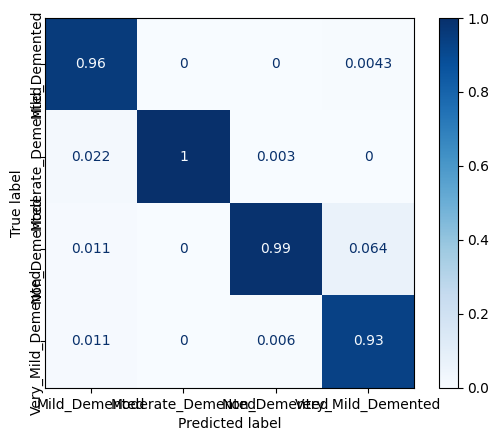

<Figure size 500x500 with 0 Axes>

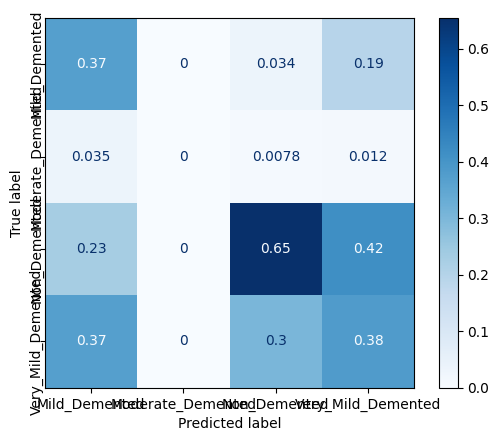

<Figure size 500x500 with 0 Axes>

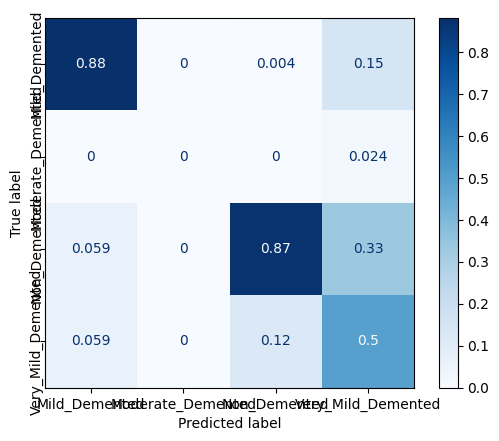

<Figure size 500x500 with 0 Axes>

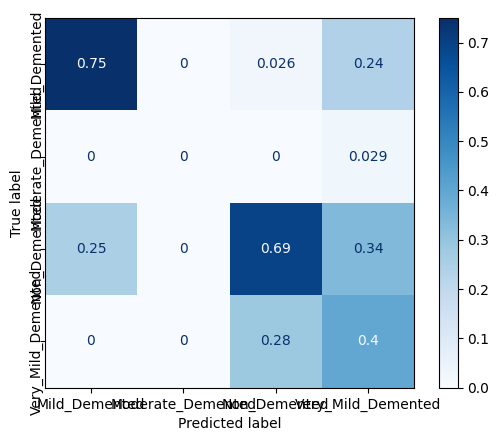

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r ResNet152V2.zip ./*